In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb

In [4]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")

In [5]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [6]:
def preprocess_data(df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    df = df.loc[df['release_speed'].notnull()].copy()
    int_cols = df.select_dtypes(include=['int64']).columns
    float_cols = df.select_dtypes(include=['float64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    df[float_cols] = df[float_cols].astype('float32')

    # Condense pitch types using a mapping dictionary
    pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "CH",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN"
    }
    df['pitch_type_condensed'] = df['pitch_type'].map(pitch_type_map).fillna("FAHCK")

    df['release_pos_y'] = 60.5 - df['release_extension']
    df['height_ratio'] = df['release_pos_z'] / df['height_numeric']
    # Create 'pitch_id_raw'
    df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + df['batter'].astype(str) + "_" + df['pitcher'].astype(str) + "_" + df['pitch_number'].astype(str) + "_" + df['at_bat_number'].astype(str) + "_" + df['inning'].astype(str)

    df['throws'] = df['p_throws'].map({'R': 1, 'L': 0})
    return df

In [7]:
# Apply the function to the 'pitch_type' column
training_data = preprocess_data(data)
testing_data_processed = preprocess_data(testing_data)

In [8]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [9]:
# Now, separate features and identifiers
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'height_numeric'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0', 'balls', 'strikes', 'height_numeric'
], axis=1)   # Exclude the identifier from the features

In [10]:
training_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'pitch_id_raw', 'throws'],
      dtype='object')

In [11]:
train_data = training_features.loc[training_features['pfx_z'].notnull()].drop(['pfx_z'], axis=1).copy()
train_label = training_features['pfx_z'].loc[training_features['pfx_z'].notnull()].copy()
testing_data = testing_features.loc[testing_features['pfx_z'].notnull()].drop(['pfx_z'], axis=1).copy()
testing_label = testing_features['pfx_z'].copy()

In [12]:
training_identifiers = train_data[['pitch_id_raw']]
testing_identifiers = testing_data[['pitch_id_raw']]
train_data = train_data.drop(['pitch_id_raw'], axis=1)
testing_data = testing_data.drop(['pitch_id_raw'], axis=1)

In [13]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [14]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [15]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.1,
    random_state=42
)

In [16]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
  'booster' : "gbtree",
  'objective' : "reg:squarederror",
  'eta' : 0.3,
  'max_depth' : 6,
  'min_child_weight' : 1,
  'subsample' : 0.5,
  'colsample_bytree' : 0.5
}

# Initial Model
model = xgb.train(params, dtrain)

In [17]:
y_pred = model.predict(dtest)

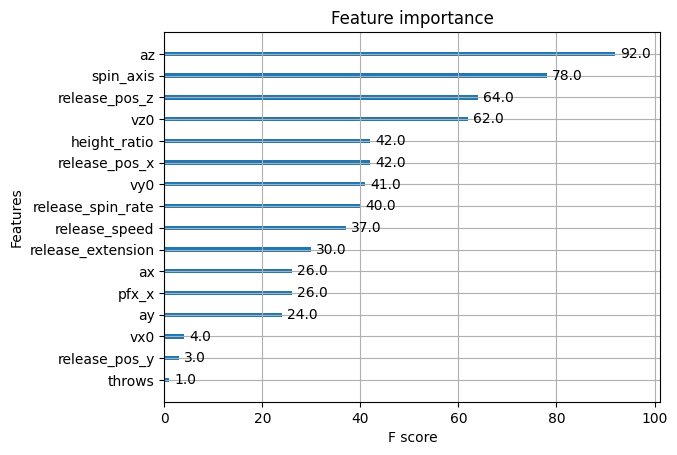

In [18]:
xgb.plot_importance(model)
plt.show()

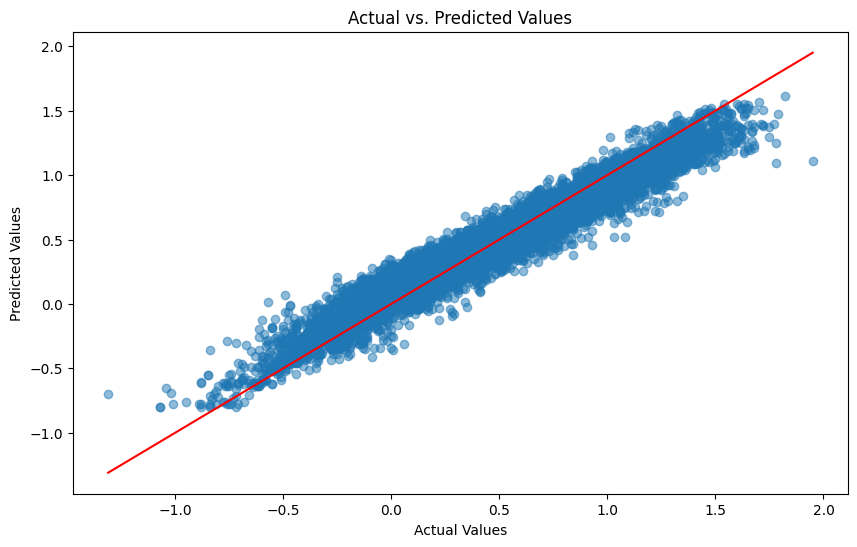

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

# Initial Paramater Tuning

In [20]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.2, 0.4),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=10  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))


    # Calculate the RMSE on the validation set
    loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))


    return loss

In [21]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 09:27:16,128] A new study created in memory with name: no-name-0566305d-acb4-4e6a-b1ba-f18374bfce52


[0]	eval-rmse:0.37258


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.33591
[2]	eval-rmse:0.32203
[3]	eval-rmse:0.24173
[4]	eval-rmse:0.23153
[5]	eval-rmse:0.18058
[6]	eval-rmse:0.17524
[7]	eval-rmse:0.17080
[8]	eval-rmse:0.16884
[9]	eval-rmse:0.16717
[10]	eval-rmse:0.16562
[11]	eval-rmse:0.16489
[12]	eval-rmse:0.16444
[13]	eval-rmse:0.14092
[14]	eval-rmse:0.14066
[15]	eval-rmse:0.12194
[16]	eval-rmse:0.12115
[17]	eval-rmse:0.12054
[18]	eval-rmse:0.12012
[19]	eval-rmse:0.10915
[20]	eval-rmse:0.10831
[21]	eval-rmse:0.10776
[22]	eval-rmse:0.10763
[23]	eval-rmse:0.10723
[24]	eval-rmse:0.10712
[25]	eval-rmse:0.10686
[26]	eval-rmse:0.10668
[27]	eval-rmse:0.10647
[28]	eval-rmse:0.09759
[29]	eval-rmse:0.09162
[30]	eval-rmse:0.09136
[31]	eval-rmse:0.09102
[32]	eval-rmse:0.08541
[33]	eval-rmse:0.08491
[34]	eval-rmse:0.08217
[35]	eval-rmse:0.08184
[36]	eval-rmse:0.07978
[37]	eval-rmse:0.07802
[38]	eval-rmse:0.07772
[39]	eval-rmse:0.07561
[40]	eval-rmse:0.07535
[41]	eval-rmse:0.07518
[42]	eval-rmse:0.07491
[43]	eval-rmse:0.07493
[44]	eval-rmse:0.073

[I 2023-11-15 09:27:18,998] Trial 0 finished with value: 0.06286899000406265 and parameters: {'max_depth': 8, 'eta': 0.29471892304859604, 'subsample': 0.45822272751050447, 'colsample_bytree': 0.4077004037510517, 'min_child_weight': 3}. Best is trial 0 with value: 0.06286899000406265.


[0]	eval-rmse:0.36767
[1]	eval-rmse:0.24987


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.17313
[3]	eval-rmse:0.12435
[4]	eval-rmse:0.11704
[5]	eval-rmse:0.09057
[6]	eval-rmse:0.08654
[7]	eval-rmse:0.08384
[8]	eval-rmse:0.08245
[9]	eval-rmse:0.07006
[10]	eval-rmse:0.06961
[11]	eval-rmse:0.06891
[12]	eval-rmse:0.06799
[13]	eval-rmse:0.06113
[14]	eval-rmse:0.05733
[15]	eval-rmse:0.05440
[16]	eval-rmse:0.05183
[17]	eval-rmse:0.05152
[18]	eval-rmse:0.05147
[19]	eval-rmse:0.05028
[20]	eval-rmse:0.04901
[21]	eval-rmse:0.04877
[22]	eval-rmse:0.04870
[23]	eval-rmse:0.04861
[24]	eval-rmse:0.04855
[25]	eval-rmse:0.04847
[26]	eval-rmse:0.04839
[27]	eval-rmse:0.04807
[28]	eval-rmse:0.04703
[29]	eval-rmse:0.04635
[30]	eval-rmse:0.04639
[31]	eval-rmse:0.04638
[32]	eval-rmse:0.04586
[33]	eval-rmse:0.04585
[34]	eval-rmse:0.04551
[35]	eval-rmse:0.04515
[36]	eval-rmse:0.04480
[37]	eval-rmse:0.04449
[38]	eval-rmse:0.04431
[39]	eval-rmse:0.04410
[40]	eval-rmse:0.04389
[41]	eval-rmse:0.04373
[42]	eval-rmse:0.04362
[43]	eval-rmse:0.04364
[44]	eval-rmse:0.04337
[45]	eval-rmse:0.04

[I 2023-11-15 09:27:21,575] Trial 1 finished with value: 0.04078614339232445 and parameters: {'max_depth': 8, 'eta': 0.34081092718093897, 'subsample': 0.47742041958417025, 'colsample_bytree': 0.5828626504475473, 'min_child_weight': 2}. Best is trial 1 with value: 0.04078614339232445.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38905
[1]	eval-rmse:0.36215
[2]	eval-rmse:0.35024
[3]	eval-rmse:0.28623
[4]	eval-rmse:0.27554
[5]	eval-rmse:0.22810
[6]	eval-rmse:0.22030
[7]	eval-rmse:0.21329
[8]	eval-rmse:0.20902
[9]	eval-rmse:0.20682
[10]	eval-rmse:0.20402
[11]	eval-rmse:0.20220
[12]	eval-rmse:0.20031
[13]	eval-rmse:0.17283
[14]	eval-rmse:0.17165
[15]	eval-rmse:0.14896
[16]	eval-rmse:0.14818
[17]	eval-rmse:0.14738
[18]	eval-rmse:0.14660
[19]	eval-rmse:0.13107
[20]	eval-rmse:0.13051
[21]	eval-rmse:0.12981
[22]	eval-rmse:0.12963
[23]	eval-rmse:0.12930
[24]	eval-rmse:0.12911
[25]	eval-rmse:0.12896
[26]	eval-rmse:0.12875
[27]	eval-rmse:0.12858
[28]	eval-rmse:0.11551
[29]	eval-rmse:0.10548
[30]	eval-rmse:0.10529
[31]	eval-rmse:0.10496
[32]	eval-rmse:0.09596
[33]	eval-rmse:0.09552
[34]	eval-rmse:0.09006
[35]	eval-rmse:0.08955
[36]	eval-rmse:0.08479
[37]	eval-rmse:0.08079
[38]	eval-rmse:0.08038
[39]	eval-rmse:0.07604
[40]	eval-rmse:0.07545
[41]	eval-rmse:0.07500
[42]	eval-rmse:0.07467
[43]	eval-rmse:0.0744

[I 2023-11-15 09:27:23,808] Trial 2 finished with value: 0.04398098215460777 and parameters: {'max_depth': 6, 'eta': 0.20111325553696682, 'subsample': 0.411782884109784, 'colsample_bytree': 0.4260820446354163, 'min_child_weight': 3}. Best is trial 1 with value: 0.04078614339232445.


[0]	eval-rmse:0.38704
[1]	eval-rmse:0.35326
[2]	eval-rmse:0.25868
[3]	eval-rmse:0.19458


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-rmse:0.19095
[5]	eval-rmse:0.15051
[6]	eval-rmse:0.14616
[7]	eval-rmse:0.14314
[8]	eval-rmse:0.14193
[9]	eval-rmse:0.11862
[10]	eval-rmse:0.11769
[11]	eval-rmse:0.11614
[12]	eval-rmse:0.11561
[13]	eval-rmse:0.09978
[14]	eval-rmse:0.09924
[15]	eval-rmse:0.08769
[16]	eval-rmse:0.08624
[17]	eval-rmse:0.08557
[18]	eval-rmse:0.08494
[19]	eval-rmse:0.07736
[20]	eval-rmse:0.07673
[21]	eval-rmse:0.07598
[22]	eval-rmse:0.07556
[23]	eval-rmse:0.07523
[24]	eval-rmse:0.07506
[25]	eval-rmse:0.07497
[26]	eval-rmse:0.07461
[27]	eval-rmse:0.07456
[28]	eval-rmse:0.06722
[29]	eval-rmse:0.06259
[30]	eval-rmse:0.06214
[31]	eval-rmse:0.06165
[32]	eval-rmse:0.05799
[33]	eval-rmse:0.05751
[34]	eval-rmse:0.05516
[35]	eval-rmse:0.05453
[36]	eval-rmse:0.05227
[37]	eval-rmse:0.05049
[38]	eval-rmse:0.04999
[39]	eval-rmse:0.04852
[40]	eval-rmse:0.04817
[41]	eval-rmse:0.04781
[42]	eval-rmse:0.04749
[43]	eval-rmse:0.04706
[44]	eval-rmse:0.04581
[45]	eval-rmse:0.04482
[46]	eval-rmse:0.04448
[47]	eval-rmse:0.

[I 2023-11-15 09:27:25,441] Trial 3 finished with value: 0.03257518261671066 and parameters: {'max_depth': 4, 'eta': 0.3071193599491937, 'subsample': 0.4381896414143698, 'colsample_bytree': 0.47073008711021636, 'min_child_weight': 1}. Best is trial 3 with value: 0.03257518261671066.


[0]	eval-rmse:0.38354
[1]	eval-rmse:0.34983
[2]	eval-rmse:0.33801


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-rmse:0.24155
[4]	eval-rmse:0.23383
[5]	eval-rmse:0.17869
[6]	eval-rmse:0.17449
[7]	eval-rmse:0.17075
[8]	eval-rmse:0.16879
[9]	eval-rmse:0.16856
[10]	eval-rmse:0.16666
[11]	eval-rmse:0.16556
[12]	eval-rmse:0.16456
[13]	eval-rmse:0.13812
[14]	eval-rmse:0.13765
[15]	eval-rmse:0.11707
[16]	eval-rmse:0.11540
[17]	eval-rmse:0.11401
[18]	eval-rmse:0.11341
[19]	eval-rmse:0.10061
[20]	eval-rmse:0.09966
[21]	eval-rmse:0.09891
[22]	eval-rmse:0.09830
[23]	eval-rmse:0.09750
[24]	eval-rmse:0.09729
[25]	eval-rmse:0.09701
[26]	eval-rmse:0.09672
[27]	eval-rmse:0.09635
[28]	eval-rmse:0.08585
[29]	eval-rmse:0.07965
[30]	eval-rmse:0.07916
[31]	eval-rmse:0.07861
[32]	eval-rmse:0.07317
[33]	eval-rmse:0.07236
[34]	eval-rmse:0.06883
[35]	eval-rmse:0.06810
[36]	eval-rmse:0.06534
[37]	eval-rmse:0.06325
[38]	eval-rmse:0.06283
[39]	eval-rmse:0.06104
[40]	eval-rmse:0.06045
[41]	eval-rmse:0.05989
[42]	eval-rmse:0.05951
[43]	eval-rmse:0.05926
[44]	eval-rmse:0.05772
[45]	eval-rmse:0.05640
[46]	eval-rmse:0.0

[I 2023-11-15 09:27:27,040] Trial 4 finished with value: 0.040528248995542526 and parameters: {'max_depth': 4, 'eta': 0.3566807368149126, 'subsample': 0.4858828668276392, 'colsample_bytree': 0.43345963721756636, 'min_child_weight': 5}. Best is trial 3 with value: 0.03257518261671066.


[0]	eval-rmse:0.38267
[1]	eval-rmse:0.35212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.33839
[3]	eval-rmse:0.27236
[4]	eval-rmse:0.26059
[5]	eval-rmse:0.21306
[6]	eval-rmse:0.20516
[7]	eval-rmse:0.19816
[8]	eval-rmse:0.19423
[9]	eval-rmse:0.19185
[10]	eval-rmse:0.18922
[11]	eval-rmse:0.18766
[12]	eval-rmse:0.18619
[13]	eval-rmse:0.16084
[14]	eval-rmse:0.16002
[15]	eval-rmse:0.13957
[16]	eval-rmse:0.13899
[17]	eval-rmse:0.13824
[18]	eval-rmse:0.13768
[19]	eval-rmse:0.12414
[20]	eval-rmse:0.12362
[21]	eval-rmse:0.12302
[22]	eval-rmse:0.12283
[23]	eval-rmse:0.12258
[24]	eval-rmse:0.12246
[25]	eval-rmse:0.12227
[26]	eval-rmse:0.12203
[27]	eval-rmse:0.12194
[28]	eval-rmse:0.11090
[29]	eval-rmse:0.10244
[30]	eval-rmse:0.10232
[31]	eval-rmse:0.10206
[32]	eval-rmse:0.09432
[33]	eval-rmse:0.09387
[34]	eval-rmse:0.08912
[35]	eval-rmse:0.08887
[36]	eval-rmse:0.08508
[37]	eval-rmse:0.08194
[38]	eval-rmse:0.08164
[39]	eval-rmse:0.07813
[40]	eval-rmse:0.07772
[41]	eval-rmse:0.07744
[42]	eval-rmse:0.07723
[43]	eval-rmse:0.07714
[44]	eval-rmse:0.07511
[45]	eval-rmse:0.07

[I 2023-11-15 09:27:30,077] Trial 5 finished with value: 0.05527542531490326 and parameters: {'max_depth': 8, 'eta': 0.2172415530394318, 'subsample': 0.4684766848560477, 'colsample_bytree': 0.43611332797780517, 'min_child_weight': 1}. Best is trial 3 with value: 0.03257518261671066.


[0]	eval-rmse:0.37850
[1]	eval-rmse:0.34110


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.25631
[3]	eval-rmse:0.19481
[4]	eval-rmse:0.18730
[5]	eval-rmse:0.14663
[6]	eval-rmse:0.14144
[7]	eval-rmse:0.13794
[8]	eval-rmse:0.13606
[9]	eval-rmse:0.11418
[10]	eval-rmse:0.11366
[11]	eval-rmse:0.11263
[12]	eval-rmse:0.11210
[13]	eval-rmse:0.09602
[14]	eval-rmse:0.09560
[15]	eval-rmse:0.08410
[16]	eval-rmse:0.08357
[17]	eval-rmse:0.08305
[18]	eval-rmse:0.08278
[19]	eval-rmse:0.07574
[20]	eval-rmse:0.07534
[21]	eval-rmse:0.07492
[22]	eval-rmse:0.07480
[23]	eval-rmse:0.07466
[24]	eval-rmse:0.07456
[25]	eval-rmse:0.07441
[26]	eval-rmse:0.07415
[27]	eval-rmse:0.07410
[28]	eval-rmse:0.06827
[29]	eval-rmse:0.06423
[30]	eval-rmse:0.06382
[31]	eval-rmse:0.06353
[32]	eval-rmse:0.05999
[33]	eval-rmse:0.05977
[34]	eval-rmse:0.05750
[35]	eval-rmse:0.05717
[36]	eval-rmse:0.05546
[37]	eval-rmse:0.05421
[38]	eval-rmse:0.05391
[39]	eval-rmse:0.05258
[40]	eval-rmse:0.05230
[41]	eval-rmse:0.05204
[42]	eval-rmse:0.05183
[43]	eval-rmse:0.05168
[44]	eval-rmse:0.05065
[45]	eval-rmse:0.04

[I 2023-11-15 09:27:32,155] Trial 6 finished with value: 0.042340561747550964 and parameters: {'max_depth': 7, 'eta': 0.27120436897389183, 'subsample': 0.4906698124034586, 'colsample_bytree': 0.439887865675493, 'min_child_weight': 1}. Best is trial 3 with value: 0.03257518261671066.


[0]	eval-rmse:0.38110
[1]	eval-rmse:0.34592


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.25980
[3]	eval-rmse:0.19813
[4]	eval-rmse:0.19138
[5]	eval-rmse:0.15066
[6]	eval-rmse:0.14562
[7]	eval-rmse:0.14183
[8]	eval-rmse:0.13929
[9]	eval-rmse:0.11575
[10]	eval-rmse:0.11517
[11]	eval-rmse:0.11425
[12]	eval-rmse:0.11376
[13]	eval-rmse:0.09676
[14]	eval-rmse:0.09649
[15]	eval-rmse:0.08450
[16]	eval-rmse:0.08390
[17]	eval-rmse:0.08346
[18]	eval-rmse:0.08320
[19]	eval-rmse:0.07525
[20]	eval-rmse:0.07480
[21]	eval-rmse:0.07442
[22]	eval-rmse:0.07412
[23]	eval-rmse:0.07398
[24]	eval-rmse:0.07394
[25]	eval-rmse:0.07382
[26]	eval-rmse:0.07359
[27]	eval-rmse:0.07354
[28]	eval-rmse:0.06681
[29]	eval-rmse:0.06225
[30]	eval-rmse:0.06190
[31]	eval-rmse:0.06161
[32]	eval-rmse:0.05796
[33]	eval-rmse:0.05774
[34]	eval-rmse:0.05553
[35]	eval-rmse:0.05516
[36]	eval-rmse:0.05318
[37]	eval-rmse:0.05163
[38]	eval-rmse:0.05124
[39]	eval-rmse:0.05005
[40]	eval-rmse:0.04976
[41]	eval-rmse:0.04863
[42]	eval-rmse:0.04829
[43]	eval-rmse:0.04819
[44]	eval-rmse:0.04734
[45]	eval-rmse:0.04

[I 2023-11-15 09:27:34,204] Trial 7 finished with value: 0.0377151183784008 and parameters: {'max_depth': 6, 'eta': 0.273556705659203, 'subsample': 0.4120775672317516, 'colsample_bytree': 0.557833302623079, 'min_child_weight': 2}. Best is trial 3 with value: 0.03257518261671066.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37133
[1]	eval-rmse:0.32997
[2]	eval-rmse:0.23463
[3]	eval-rmse:0.17089
[4]	eval-rmse:0.16561
[5]	eval-rmse:0.12705
[6]	eval-rmse:0.12359
[7]	eval-rmse:0.12085
[8]	eval-rmse:0.11912
[9]	eval-rmse:0.09954
[10]	eval-rmse:0.09922
[11]	eval-rmse:0.09852
[12]	eval-rmse:0.09775
[13]	eval-rmse:0.08440
[14]	eval-rmse:0.08424
[15]	eval-rmse:0.07542
[16]	eval-rmse:0.07448
[17]	eval-rmse:0.07397
[18]	eval-rmse:0.07382
[19]	eval-rmse:0.06842
[20]	eval-rmse:0.06770
[21]	eval-rmse:0.06734
[22]	eval-rmse:0.06692
[23]	eval-rmse:0.06678
[24]	eval-rmse:0.06662
[25]	eval-rmse:0.06630
[26]	eval-rmse:0.06601
[27]	eval-rmse:0.06593
[28]	eval-rmse:0.06136
[29]	eval-rmse:0.05872
[30]	eval-rmse:0.05835
[31]	eval-rmse:0.05805
[32]	eval-rmse:0.05591
[33]	eval-rmse:0.05573
[34]	eval-rmse:0.05427
[35]	eval-rmse:0.05396
[36]	eval-rmse:0.05274
[37]	eval-rmse:0.05196
[38]	eval-rmse:0.05187
[39]	eval-rmse:0.05118
[40]	eval-rmse:0.05089
[41]	eval-rmse:0.05028
[42]	eval-rmse:0.04990
[43]	eval-rmse:0.0498

[I 2023-11-15 09:27:36,592] Trial 8 finished with value: 0.04400815814733505 and parameters: {'max_depth': 7, 'eta': 0.32637849193265145, 'subsample': 0.5629190821361066, 'colsample_bytree': 0.5609429544948076, 'min_child_weight': 4}. Best is trial 3 with value: 0.03257518261671066.


[0]	eval-rmse:0.38088
[1]	eval-rmse:0.29825


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.23451
[3]	eval-rmse:0.18528
[4]	eval-rmse:0.17386
[5]	eval-rmse:0.13942
[6]	eval-rmse:0.13150
[7]	eval-rmse:0.12511
[8]	eval-rmse:0.12129
[9]	eval-rmse:0.10115
[10]	eval-rmse:0.09903
[11]	eval-rmse:0.09793
[12]	eval-rmse:0.09664
[13]	eval-rmse:0.08338
[14]	eval-rmse:0.07393
[15]	eval-rmse:0.06600
[16]	eval-rmse:0.06024
[17]	eval-rmse:0.05969
[18]	eval-rmse:0.05946
[19]	eval-rmse:0.05519
[20]	eval-rmse:0.05485
[21]	eval-rmse:0.05455
[22]	eval-rmse:0.05447
[23]	eval-rmse:0.05434
[24]	eval-rmse:0.05419
[25]	eval-rmse:0.05404
[26]	eval-rmse:0.05399
[27]	eval-rmse:0.05395
[28]	eval-rmse:0.05059
[29]	eval-rmse:0.04810
[30]	eval-rmse:0.04787
[31]	eval-rmse:0.04767
[32]	eval-rmse:0.04562
[33]	eval-rmse:0.04553
[34]	eval-rmse:0.04417
[35]	eval-rmse:0.04398
[36]	eval-rmse:0.04267
[37]	eval-rmse:0.04171
[38]	eval-rmse:0.04148
[39]	eval-rmse:0.04069
[40]	eval-rmse:0.04005
[41]	eval-rmse:0.03942
[42]	eval-rmse:0.03925
[43]	eval-rmse:0.03918
[44]	eval-rmse:0.03861
[45]	eval-rmse:0.03

[I 2023-11-15 09:27:39,164] Trial 9 finished with value: 0.033041201531887054 and parameters: {'max_depth': 8, 'eta': 0.22479722301698768, 'subsample': 0.5624032257469629, 'colsample_bytree': 0.5848206947182963, 'min_child_weight': 5}. Best is trial 3 with value: 0.03257518261671066.


[0]	eval-rmse:0.38075
[1]	eval-rmse:0.34149
[2]	eval-rmse:0.22961


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-rmse:0.16520
[4]	eval-rmse:0.16314
[5]	eval-rmse:0.12658
[6]	eval-rmse:0.12257
[7]	eval-rmse:0.12050
[8]	eval-rmse:0.11927
[9]	eval-rmse:0.10070
[10]	eval-rmse:0.09962
[11]	eval-rmse:0.09842
[12]	eval-rmse:0.09796
[13]	eval-rmse:0.08481
[14]	eval-rmse:0.08391
[15]	eval-rmse:0.07641
[16]	eval-rmse:0.07487
[17]	eval-rmse:0.07396
[18]	eval-rmse:0.07355
[19]	eval-rmse:0.06751
[20]	eval-rmse:0.06697
[21]	eval-rmse:0.06636
[22]	eval-rmse:0.06604
[23]	eval-rmse:0.06571
[24]	eval-rmse:0.06554
[25]	eval-rmse:0.06532
[26]	eval-rmse:0.06483
[27]	eval-rmse:0.06476
[28]	eval-rmse:0.05965
[29]	eval-rmse:0.05681
[30]	eval-rmse:0.05617
[31]	eval-rmse:0.05570
[32]	eval-rmse:0.05324
[33]	eval-rmse:0.05279
[34]	eval-rmse:0.05146
[35]	eval-rmse:0.05088
[36]	eval-rmse:0.04952
[37]	eval-rmse:0.04846
[38]	eval-rmse:0.04813
[39]	eval-rmse:0.04728
[40]	eval-rmse:0.04679
[41]	eval-rmse:0.04646
[42]	eval-rmse:0.04617
[43]	eval-rmse:0.04553
[44]	eval-rmse:0.04485
[45]	eval-rmse:0.04423
[46]	eval-rmse:0.0

[I 2023-11-15 09:27:40,682] Trial 10 finished with value: 0.03364308550953865 and parameters: {'max_depth': 4, 'eta': 0.3985676583543667, 'subsample': 0.5354313253968751, 'colsample_bytree': 0.4863514916231117, 'min_child_weight': 2}. Best is trial 3 with value: 0.03257518261671066.


[0]	eval-rmse:0.38676
[1]	eval-rmse:0.35550


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.27450
[3]	eval-rmse:0.21433
[4]	eval-rmse:0.20740
[5]	eval-rmse:0.16598
[6]	eval-rmse:0.16068
[7]	eval-rmse:0.15636
[8]	eval-rmse:0.15349
[9]	eval-rmse:0.12787
[10]	eval-rmse:0.12710
[11]	eval-rmse:0.12596
[12]	eval-rmse:0.12545
[13]	eval-rmse:0.10742
[14]	eval-rmse:0.10687
[15]	eval-rmse:0.09336
[16]	eval-rmse:0.09257
[17]	eval-rmse:0.09180
[18]	eval-rmse:0.09138
[19]	eval-rmse:0.08169
[20]	eval-rmse:0.08118
[21]	eval-rmse:0.08077
[22]	eval-rmse:0.08037
[23]	eval-rmse:0.08018
[24]	eval-rmse:0.08014
[25]	eval-rmse:0.07990
[26]	eval-rmse:0.07972
[27]	eval-rmse:0.07969
[28]	eval-rmse:0.07182
[29]	eval-rmse:0.06627
[30]	eval-rmse:0.06597
[31]	eval-rmse:0.06573
[32]	eval-rmse:0.06090
[33]	eval-rmse:0.06065
[34]	eval-rmse:0.05722
[35]	eval-rmse:0.05687
[36]	eval-rmse:0.05384
[37]	eval-rmse:0.05188
[38]	eval-rmse:0.05141
[39]	eval-rmse:0.04968
[40]	eval-rmse:0.04933
[41]	eval-rmse:0.04788
[42]	eval-rmse:0.04737
[43]	eval-rmse:0.04719
[44]	eval-rmse:0.04599
[45]	eval-rmse:0.04

[I 2023-11-15 09:27:42,554] Trial 11 finished with value: 0.03193066269159317 and parameters: {'max_depth': 5, 'eta': 0.24840647168475596, 'subsample': 0.5998652580402453, 'colsample_bytree': 0.5156283169275766, 'min_child_weight': 5}. Best is trial 11 with value: 0.03193066269159317.


[0]	eval-rmse:0.38672


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35554
[2]	eval-rmse:0.27498
[3]	eval-rmse:0.21532
[4]	eval-rmse:0.20844
[5]	eval-rmse:0.16662
[6]	eval-rmse:0.16103
[7]	eval-rmse:0.15678
[8]	eval-rmse:0.15401
[9]	eval-rmse:0.12809
[10]	eval-rmse:0.12730
[11]	eval-rmse:0.12607
[12]	eval-rmse:0.12549
[13]	eval-rmse:0.10714
[14]	eval-rmse:0.10670
[15]	eval-rmse:0.09300
[16]	eval-rmse:0.09231
[17]	eval-rmse:0.09156
[18]	eval-rmse:0.09103
[19]	eval-rmse:0.08138
[20]	eval-rmse:0.08086
[21]	eval-rmse:0.08051
[22]	eval-rmse:0.08010
[23]	eval-rmse:0.07992
[24]	eval-rmse:0.07979
[25]	eval-rmse:0.07960
[26]	eval-rmse:0.07944
[27]	eval-rmse:0.07945
[28]	eval-rmse:0.07151
[29]	eval-rmse:0.06600
[30]	eval-rmse:0.06567
[31]	eval-rmse:0.06542
[32]	eval-rmse:0.06051
[33]	eval-rmse:0.06021
[34]	eval-rmse:0.05680
[35]	eval-rmse:0.05642
[36]	eval-rmse:0.05343
[37]	eval-rmse:0.05139
[38]	eval-rmse:0.05095
[39]	eval-rmse:0.04917
[40]	eval-rmse:0.04868
[41]	eval-rmse:0.04721
[42]	eval-rmse:0.04676
[43]	eval-rmse:0.04656
[44]	eval-rmse:0.045

[I 2023-11-15 09:27:44,349] Trial 12 finished with value: 0.03141702711582184 and parameters: {'max_depth': 5, 'eta': 0.24663506933367546, 'subsample': 0.5843504598718616, 'colsample_bytree': 0.5001823216460144, 'min_child_weight': 4}. Best is trial 12 with value: 0.03141702711582184.


[0]	eval-rmse:0.38687
[1]	eval-rmse:0.35570


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.27498
[3]	eval-rmse:0.21490
[4]	eval-rmse:0.20797
[5]	eval-rmse:0.16628
[6]	eval-rmse:0.16083
[7]	eval-rmse:0.15659
[8]	eval-rmse:0.15370
[9]	eval-rmse:0.12814
[10]	eval-rmse:0.12738
[11]	eval-rmse:0.12616
[12]	eval-rmse:0.12549
[13]	eval-rmse:0.10741
[14]	eval-rmse:0.10690
[15]	eval-rmse:0.09312
[16]	eval-rmse:0.09220
[17]	eval-rmse:0.09142
[18]	eval-rmse:0.09095
[19]	eval-rmse:0.08141
[20]	eval-rmse:0.08097
[21]	eval-rmse:0.08051
[22]	eval-rmse:0.08003
[23]	eval-rmse:0.07980
[24]	eval-rmse:0.07977
[25]	eval-rmse:0.07967
[26]	eval-rmse:0.07950
[27]	eval-rmse:0.07952
[28]	eval-rmse:0.07173
[29]	eval-rmse:0.06613
[30]	eval-rmse:0.06579
[31]	eval-rmse:0.06547
[32]	eval-rmse:0.06053
[33]	eval-rmse:0.06025
[34]	eval-rmse:0.05697
[35]	eval-rmse:0.05658
[36]	eval-rmse:0.05368
[37]	eval-rmse:0.05150
[38]	eval-rmse:0.05103
[39]	eval-rmse:0.04904
[40]	eval-rmse:0.04862
[41]	eval-rmse:0.04729
[42]	eval-rmse:0.04665
[43]	eval-rmse:0.04645
[44]	eval-rmse:0.04518
[45]	eval-rmse:0.04

[I 2023-11-15 09:27:46,239] Trial 13 finished with value: 0.031185828149318695 and parameters: {'max_depth': 5, 'eta': 0.24730970475743388, 'subsample': 0.5995862903463272, 'colsample_bytree': 0.5260338861319264, 'min_child_weight': 4}. Best is trial 13 with value: 0.031185828149318695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38717
[1]	eval-rmse:0.35609
[2]	eval-rmse:0.27616
[3]	eval-rmse:0.21659
[4]	eval-rmse:0.20928
[5]	eval-rmse:0.16800
[6]	eval-rmse:0.16303
[7]	eval-rmse:0.15911
[8]	eval-rmse:0.15593
[9]	eval-rmse:0.12993
[10]	eval-rmse:0.12884
[11]	eval-rmse:0.12754
[12]	eval-rmse:0.12668
[13]	eval-rmse:0.10862
[14]	eval-rmse:0.10817
[15]	eval-rmse:0.09419
[16]	eval-rmse:0.09343
[17]	eval-rmse:0.09272
[18]	eval-rmse:0.09235
[19]	eval-rmse:0.08258
[20]	eval-rmse:0.08220
[21]	eval-rmse:0.08183
[22]	eval-rmse:0.08138
[23]	eval-rmse:0.08118
[24]	eval-rmse:0.08103
[25]	eval-rmse:0.08087
[26]	eval-rmse:0.08073
[27]	eval-rmse:0.08074
[28]	eval-rmse:0.07293
[29]	eval-rmse:0.06699
[30]	eval-rmse:0.06665
[31]	eval-rmse:0.06636
[32]	eval-rmse:0.06145
[33]	eval-rmse:0.06111
[34]	eval-rmse:0.05773
[35]	eval-rmse:0.05737
[36]	eval-rmse:0.05448
[37]	eval-rmse:0.05245
[38]	eval-rmse:0.05196
[39]	eval-rmse:0.05007
[40]	eval-rmse:0.04973
[41]	eval-rmse:0.04834
[42]	eval-rmse:0.04785
[43]	eval-rmse:0.0476

[I 2023-11-15 09:27:47,932] Trial 14 finished with value: 0.031674258410930634 and parameters: {'max_depth': 5, 'eta': 0.24446191331470313, 'subsample': 0.5979932724318598, 'colsample_bytree': 0.5180109437841566, 'min_child_weight': 4}. Best is trial 13 with value: 0.031185828149318695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38710
[1]	eval-rmse:0.35563
[2]	eval-rmse:0.27537
[3]	eval-rmse:0.21594
[4]	eval-rmse:0.20917
[5]	eval-rmse:0.16753
[6]	eval-rmse:0.16209
[7]	eval-rmse:0.15780
[8]	eval-rmse:0.15518
[9]	eval-rmse:0.12952
[10]	eval-rmse:0.12856
[11]	eval-rmse:0.12727
[12]	eval-rmse:0.12662
[13]	eval-rmse:0.10832
[14]	eval-rmse:0.10788
[15]	eval-rmse:0.09422
[16]	eval-rmse:0.09340
[17]	eval-rmse:0.09273
[18]	eval-rmse:0.09202
[19]	eval-rmse:0.08256
[20]	eval-rmse:0.08210
[21]	eval-rmse:0.08165
[22]	eval-rmse:0.08129
[23]	eval-rmse:0.08108
[24]	eval-rmse:0.08096
[25]	eval-rmse:0.08076
[26]	eval-rmse:0.08051
[27]	eval-rmse:0.08052
[28]	eval-rmse:0.07255
[29]	eval-rmse:0.06701
[30]	eval-rmse:0.06658
[31]	eval-rmse:0.06628
[32]	eval-rmse:0.06125
[33]	eval-rmse:0.06102
[34]	eval-rmse:0.05792
[35]	eval-rmse:0.05750
[36]	eval-rmse:0.05436
[37]	eval-rmse:0.05236
[38]	eval-rmse:0.05182
[39]	eval-rmse:0.05013
[40]	eval-rmse:0.04975
[41]	eval-rmse:0.04833
[42]	eval-rmse:0.04790
[43]	eval-rmse:0.0475

[I 2023-11-15 09:27:49,733] Trial 15 finished with value: 0.03245550021529198 and parameters: {'max_depth': 5, 'eta': 0.24628414575652005, 'subsample': 0.5249007110518704, 'colsample_bytree': 0.5296615104467329, 'min_child_weight': 4}. Best is trial 13 with value: 0.031185828149318695.


[0]	eval-rmse:0.38591


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35261
[2]	eval-rmse:0.26705
[3]	eval-rmse:0.20533
[4]	eval-rmse:0.19890
[5]	eval-rmse:0.15776
[6]	eval-rmse:0.15309
[7]	eval-rmse:0.14935
[8]	eval-rmse:0.14783
[9]	eval-rmse:0.12385
[10]	eval-rmse:0.12321
[11]	eval-rmse:0.12206
[12]	eval-rmse:0.12145
[13]	eval-rmse:0.10454
[14]	eval-rmse:0.10424
[15]	eval-rmse:0.09080
[16]	eval-rmse:0.08986
[17]	eval-rmse:0.08905
[18]	eval-rmse:0.08856
[19]	eval-rmse:0.07979
[20]	eval-rmse:0.07928
[21]	eval-rmse:0.07876
[22]	eval-rmse:0.07843
[23]	eval-rmse:0.07809
[24]	eval-rmse:0.07798
[25]	eval-rmse:0.07780
[26]	eval-rmse:0.07755
[27]	eval-rmse:0.07747
[28]	eval-rmse:0.06981
[29]	eval-rmse:0.06467
[30]	eval-rmse:0.06428
[31]	eval-rmse:0.06400
[32]	eval-rmse:0.05958
[33]	eval-rmse:0.05915
[34]	eval-rmse:0.05626
[35]	eval-rmse:0.05576
[36]	eval-rmse:0.05327
[37]	eval-rmse:0.05140
[38]	eval-rmse:0.05091
[39]	eval-rmse:0.04948
[40]	eval-rmse:0.04919
[41]	eval-rmse:0.04873
[42]	eval-rmse:0.04843
[43]	eval-rmse:0.04816
[44]	eval-rmse:0.046

[I 2023-11-15 09:27:51,452] Trial 16 finished with value: 0.03359413892030716 and parameters: {'max_depth': 5, 'eta': 0.2662501405772495, 'subsample': 0.5769792304147614, 'colsample_bytree': 0.49110262200581406, 'min_child_weight': 4}. Best is trial 13 with value: 0.031185828149318695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38620
[1]	eval-rmse:0.35454
[2]	eval-rmse:0.27878
[3]	eval-rmse:0.22093
[4]	eval-rmse:0.21266
[5]	eval-rmse:0.17162
[6]	eval-rmse:0.16539
[7]	eval-rmse:0.16059
[8]	eval-rmse:0.15779
[9]	eval-rmse:0.13316
[10]	eval-rmse:0.13192
[11]	eval-rmse:0.13053
[12]	eval-rmse:0.12974
[13]	eval-rmse:0.11126
[14]	eval-rmse:0.11074
[15]	eval-rmse:0.09634
[16]	eval-rmse:0.09566
[17]	eval-rmse:0.09499
[18]	eval-rmse:0.09462
[19]	eval-rmse:0.08540
[20]	eval-rmse:0.08485
[21]	eval-rmse:0.08459
[22]	eval-rmse:0.08428
[23]	eval-rmse:0.08409
[24]	eval-rmse:0.08400
[25]	eval-rmse:0.08376
[26]	eval-rmse:0.08338
[27]	eval-rmse:0.08328
[28]	eval-rmse:0.07566
[29]	eval-rmse:0.06977
[30]	eval-rmse:0.06933
[31]	eval-rmse:0.06902
[32]	eval-rmse:0.06405
[33]	eval-rmse:0.06367
[34]	eval-rmse:0.06048
[35]	eval-rmse:0.06010
[36]	eval-rmse:0.05736
[37]	eval-rmse:0.05524
[38]	eval-rmse:0.05483
[39]	eval-rmse:0.05274
[40]	eval-rmse:0.05243
[41]	eval-rmse:0.05202
[42]	eval-rmse:0.05179
[43]	eval-rmse:0.0515

[I 2023-11-15 09:27:53,553] Trial 17 finished with value: 0.03573960065841675 and parameters: {'max_depth': 6, 'eta': 0.22866054838247155, 'subsample': 0.523659554705344, 'colsample_bytree': 0.4673225632313406, 'min_child_weight': 3}. Best is trial 13 with value: 0.031185828149318695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39081
[1]	eval-rmse:0.36290
[2]	eval-rmse:0.29335
[3]	eval-rmse:0.23847
[4]	eval-rmse:0.23050
[5]	eval-rmse:0.19024
[6]	eval-rmse:0.18365
[7]	eval-rmse:0.17862
[8]	eval-rmse:0.17529
[9]	eval-rmse:0.14863
[10]	eval-rmse:0.14677
[11]	eval-rmse:0.14529
[12]	eval-rmse:0.14420
[13]	eval-rmse:0.12481
[14]	eval-rmse:0.12402
[15]	eval-rmse:0.10860
[16]	eval-rmse:0.10783
[17]	eval-rmse:0.10695
[18]	eval-rmse:0.10641
[19]	eval-rmse:0.09530
[20]	eval-rmse:0.09473
[21]	eval-rmse:0.09429
[22]	eval-rmse:0.09400
[23]	eval-rmse:0.09365
[24]	eval-rmse:0.09354
[25]	eval-rmse:0.09331
[26]	eval-rmse:0.09306
[27]	eval-rmse:0.09306
[28]	eval-rmse:0.08410
[29]	eval-rmse:0.07708
[30]	eval-rmse:0.07677
[31]	eval-rmse:0.07652
[32]	eval-rmse:0.07057
[33]	eval-rmse:0.07028
[34]	eval-rmse:0.06600
[35]	eval-rmse:0.06564
[36]	eval-rmse:0.06173
[37]	eval-rmse:0.05880
[38]	eval-rmse:0.05835
[39]	eval-rmse:0.05578
[40]	eval-rmse:0.05533
[41]	eval-rmse:0.05333
[42]	eval-rmse:0.05292
[43]	eval-rmse:0.0526

[I 2023-11-15 09:27:55,316] Trial 18 finished with value: 0.03163212165236473 and parameters: {'max_depth': 5, 'eta': 0.20556153444814226, 'subsample': 0.5803166881341645, 'colsample_bytree': 0.5370806549717707, 'min_child_weight': 4}. Best is trial 13 with value: 0.031185828149318695.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37596
[1]	eval-rmse:0.33762
[2]	eval-rmse:0.24954
[3]	eval-rmse:0.18712
[4]	eval-rmse:0.18034
[5]	eval-rmse:0.14001
[6]	eval-rmse:0.13502
[7]	eval-rmse:0.13176
[8]	eval-rmse:0.12929
[9]	eval-rmse:0.10774
[10]	eval-rmse:0.10713
[11]	eval-rmse:0.10621
[12]	eval-rmse:0.10561
[13]	eval-rmse:0.09056
[14]	eval-rmse:0.09052
[15]	eval-rmse:0.08019
[16]	eval-rmse:0.07960
[17]	eval-rmse:0.07929
[18]	eval-rmse:0.07914
[19]	eval-rmse:0.07230
[20]	eval-rmse:0.07168
[21]	eval-rmse:0.07134
[22]	eval-rmse:0.07119
[23]	eval-rmse:0.07106
[24]	eval-rmse:0.07100
[25]	eval-rmse:0.07094
[26]	eval-rmse:0.07078
[27]	eval-rmse:0.07061
[28]	eval-rmse:0.06527
[29]	eval-rmse:0.06165
[30]	eval-rmse:0.06146
[31]	eval-rmse:0.06119
[32]	eval-rmse:0.05815
[33]	eval-rmse:0.05800
[34]	eval-rmse:0.05618
[35]	eval-rmse:0.05584
[36]	eval-rmse:0.05415
[37]	eval-rmse:0.05301
[38]	eval-rmse:0.05276
[39]	eval-rmse:0.05168
[40]	eval-rmse:0.05142
[41]	eval-rmse:0.05062
[42]	eval-rmse:0.05033
[43]	eval-rmse:0.0501

[I 2023-11-15 09:27:57,718] Trial 19 finished with value: 0.041548315435647964 and parameters: {'max_depth': 7, 'eta': 0.2868618513257556, 'subsample': 0.550057162381587, 'colsample_bytree': 0.5053294063624415, 'min_child_weight': 3}. Best is trial 13 with value: 0.031185828149318695.


[0]	eval-rmse:0.38877
[1]	eval-rmse:0.35917


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.27608
[3]	eval-rmse:0.21547
[4]	eval-rmse:0.20992
[5]	eval-rmse:0.16879
[6]	eval-rmse:0.16451
[7]	eval-rmse:0.16021
[8]	eval-rmse:0.15777
[9]	eval-rmse:0.13247
[10]	eval-rmse:0.13122
[11]	eval-rmse:0.12994
[12]	eval-rmse:0.12952
[13]	eval-rmse:0.11221
[14]	eval-rmse:0.11169
[15]	eval-rmse:0.09813
[16]	eval-rmse:0.09712
[17]	eval-rmse:0.09622
[18]	eval-rmse:0.09561
[19]	eval-rmse:0.08609
[20]	eval-rmse:0.08545
[21]	eval-rmse:0.08500
[22]	eval-rmse:0.08446
[23]	eval-rmse:0.08412
[24]	eval-rmse:0.08396
[25]	eval-rmse:0.08374
[26]	eval-rmse:0.08347
[27]	eval-rmse:0.08346
[28]	eval-rmse:0.07543
[29]	eval-rmse:0.06956
[30]	eval-rmse:0.06913
[31]	eval-rmse:0.06877
[32]	eval-rmse:0.06379
[33]	eval-rmse:0.06336
[34]	eval-rmse:0.05983
[35]	eval-rmse:0.05941
[36]	eval-rmse:0.05659
[37]	eval-rmse:0.05451
[38]	eval-rmse:0.05404
[39]	eval-rmse:0.05211
[40]	eval-rmse:0.05166
[41]	eval-rmse:0.05010
[42]	eval-rmse:0.04951
[43]	eval-rmse:0.04924
[44]	eval-rmse:0.04766
[45]	eval-rmse:0.04

[I 2023-11-15 09:27:59,215] Trial 20 finished with value: 0.031011246144771576 and parameters: {'max_depth': 4, 'eta': 0.2586187083001532, 'subsample': 0.5077192680453063, 'colsample_bytree': 0.5408289687881089, 'min_child_weight': 5}. Best is trial 20 with value: 0.031011246144771576.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38879
[1]	eval-rmse:0.35933
[2]	eval-rmse:0.27727
[3]	eval-rmse:0.21705
[4]	eval-rmse:0.21145
[5]	eval-rmse:0.17005
[6]	eval-rmse:0.16534
[7]	eval-rmse:0.16098
[8]	eval-rmse:0.15835
[9]	eval-rmse:0.13267
[10]	eval-rmse:0.13161
[11]	eval-rmse:0.13038
[12]	eval-rmse:0.12977
[13]	eval-rmse:0.11225
[14]	eval-rmse:0.11161
[15]	eval-rmse:0.09841
[16]	eval-rmse:0.09733
[17]	eval-rmse:0.09635
[18]	eval-rmse:0.09573
[19]	eval-rmse:0.08617
[20]	eval-rmse:0.08571
[21]	eval-rmse:0.08516
[22]	eval-rmse:0.08472
[23]	eval-rmse:0.08446
[24]	eval-rmse:0.08432
[25]	eval-rmse:0.08411
[26]	eval-rmse:0.08391
[27]	eval-rmse:0.08389
[28]	eval-rmse:0.07540
[29]	eval-rmse:0.06984
[30]	eval-rmse:0.06935
[31]	eval-rmse:0.06897
[32]	eval-rmse:0.06429
[33]	eval-rmse:0.06400
[34]	eval-rmse:0.06038
[35]	eval-rmse:0.05985
[36]	eval-rmse:0.05668
[37]	eval-rmse:0.05457
[38]	eval-rmse:0.05407
[39]	eval-rmse:0.05231
[40]	eval-rmse:0.05176
[41]	eval-rmse:0.05023
[42]	eval-rmse:0.04975
[43]	eval-rmse:0.0494

[I 2023-11-15 09:28:00,822] Trial 21 finished with value: 0.03144972398877144 and parameters: {'max_depth': 4, 'eta': 0.25460257742959713, 'subsample': 0.5008609091649737, 'colsample_bytree': 0.540956209870098, 'min_child_weight': 5}. Best is trial 20 with value: 0.031011246144771576.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39072
[1]	eval-rmse:0.36331
[2]	eval-rmse:0.28693
[3]	eval-rmse:0.22886
[4]	eval-rmse:0.22274
[5]	eval-rmse:0.18197
[6]	eval-rmse:0.17666
[7]	eval-rmse:0.17148
[8]	eval-rmse:0.16836
[9]	eval-rmse:0.14204
[10]	eval-rmse:0.14061
[11]	eval-rmse:0.13927
[12]	eval-rmse:0.13806
[13]	eval-rmse:0.11982
[14]	eval-rmse:0.11923
[15]	eval-rmse:0.10546
[16]	eval-rmse:0.10452
[17]	eval-rmse:0.10361
[18]	eval-rmse:0.10307
[19]	eval-rmse:0.09274
[20]	eval-rmse:0.09216
[21]	eval-rmse:0.09182
[22]	eval-rmse:0.09140
[23]	eval-rmse:0.09123
[24]	eval-rmse:0.09095
[25]	eval-rmse:0.09066
[26]	eval-rmse:0.09039
[27]	eval-rmse:0.09034
[28]	eval-rmse:0.08169
[29]	eval-rmse:0.07545
[30]	eval-rmse:0.07508
[31]	eval-rmse:0.07476
[32]	eval-rmse:0.06928
[33]	eval-rmse:0.06899
[34]	eval-rmse:0.06484
[35]	eval-rmse:0.06439
[36]	eval-rmse:0.06107
[37]	eval-rmse:0.05838
[38]	eval-rmse:0.05790
[39]	eval-rmse:0.05569
[40]	eval-rmse:0.05511
[41]	eval-rmse:0.05312
[42]	eval-rmse:0.05257
[43]	eval-rmse:0.0523

[I 2023-11-15 09:28:02,427] Trial 22 finished with value: 0.03082958795130253 and parameters: {'max_depth': 4, 'eta': 0.23203477709416892, 'subsample': 0.5829886715173958, 'colsample_bytree': 0.5061547854576428, 'min_child_weight': 5}. Best is trial 22 with value: 0.03082958795130253.


[0]	eval-rmse:0.39109


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.36393
[2]	eval-rmse:0.28740
[3]	eval-rmse:0.22923
[4]	eval-rmse:0.22267
[5]	eval-rmse:0.18178
[6]	eval-rmse:0.17678
[7]	eval-rmse:0.17169
[8]	eval-rmse:0.16862
[9]	eval-rmse:0.14256
[10]	eval-rmse:0.14125
[11]	eval-rmse:0.13985
[12]	eval-rmse:0.13878
[13]	eval-rmse:0.12058
[14]	eval-rmse:0.11985
[15]	eval-rmse:0.10556
[16]	eval-rmse:0.10458
[17]	eval-rmse:0.10378
[18]	eval-rmse:0.10317
[19]	eval-rmse:0.09291
[20]	eval-rmse:0.09246
[21]	eval-rmse:0.09204
[22]	eval-rmse:0.09187
[23]	eval-rmse:0.09150
[24]	eval-rmse:0.09131
[25]	eval-rmse:0.09110
[26]	eval-rmse:0.09073
[27]	eval-rmse:0.09066
[28]	eval-rmse:0.08197
[29]	eval-rmse:0.07603
[30]	eval-rmse:0.07565
[31]	eval-rmse:0.07534
[32]	eval-rmse:0.06994
[33]	eval-rmse:0.06961
[34]	eval-rmse:0.06568
[35]	eval-rmse:0.06529
[36]	eval-rmse:0.06191
[37]	eval-rmse:0.05895
[38]	eval-rmse:0.05849
[39]	eval-rmse:0.05636
[40]	eval-rmse:0.05595
[41]	eval-rmse:0.05401
[42]	eval-rmse:0.05354
[43]	eval-rmse:0.05327
[44]	eval-rmse:0.051

[I 2023-11-15 09:28:03,920] Trial 23 finished with value: 0.03212068974971771 and parameters: {'max_depth': 4, 'eta': 0.23190804817290286, 'subsample': 0.5077763977427657, 'colsample_bytree': 0.5225759827701555, 'min_child_weight': 5}. Best is trial 22 with value: 0.03082958795130253.


[0]	eval-rmse:0.38796
[1]	eval-rmse:0.35797


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.27370
[3]	eval-rmse:0.21285
[4]	eval-rmse:0.20761
[5]	eval-rmse:0.16641
[6]	eval-rmse:0.16170
[7]	eval-rmse:0.15834
[8]	eval-rmse:0.15552
[9]	eval-rmse:0.13002
[10]	eval-rmse:0.12921
[11]	eval-rmse:0.12789
[12]	eval-rmse:0.12724
[13]	eval-rmse:0.11011
[14]	eval-rmse:0.10953
[15]	eval-rmse:0.09668
[16]	eval-rmse:0.09538
[17]	eval-rmse:0.09435
[18]	eval-rmse:0.09382
[19]	eval-rmse:0.08439
[20]	eval-rmse:0.08382
[21]	eval-rmse:0.08329
[22]	eval-rmse:0.08275
[23]	eval-rmse:0.08241
[24]	eval-rmse:0.08221
[25]	eval-rmse:0.08194
[26]	eval-rmse:0.08176
[27]	eval-rmse:0.08166
[28]	eval-rmse:0.07374
[29]	eval-rmse:0.06811
[30]	eval-rmse:0.06759
[31]	eval-rmse:0.06724
[32]	eval-rmse:0.06271
[33]	eval-rmse:0.06245
[34]	eval-rmse:0.05935
[35]	eval-rmse:0.05884
[36]	eval-rmse:0.05592
[37]	eval-rmse:0.05378
[38]	eval-rmse:0.05337
[39]	eval-rmse:0.05183
[40]	eval-rmse:0.05141
[41]	eval-rmse:0.05004
[42]	eval-rmse:0.04969
[43]	eval-rmse:0.04944
[44]	eval-rmse:0.04799
[45]	eval-rmse:0.04

[I 2023-11-15 09:28:05,407] Trial 24 finished with value: 0.031202640384435654 and parameters: {'max_depth': 4, 'eta': 0.26365809760246023, 'subsample': 0.5544763659368979, 'colsample_bytree': 0.5473391761524983, 'min_child_weight': 5}. Best is trial 22 with value: 0.03082958795130253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39068
[1]	eval-rmse:0.36336
[2]	eval-rmse:0.28679
[3]	eval-rmse:0.22887
[4]	eval-rmse:0.22261
[5]	eval-rmse:0.18141
[6]	eval-rmse:0.17644
[7]	eval-rmse:0.17143
[8]	eval-rmse:0.16852
[9]	eval-rmse:0.14181
[10]	eval-rmse:0.14040
[11]	eval-rmse:0.13898
[12]	eval-rmse:0.13784
[13]	eval-rmse:0.11927
[14]	eval-rmse:0.11863
[15]	eval-rmse:0.10460
[16]	eval-rmse:0.10359
[17]	eval-rmse:0.10276
[18]	eval-rmse:0.10196
[19]	eval-rmse:0.09162
[20]	eval-rmse:0.09111
[21]	eval-rmse:0.09061
[22]	eval-rmse:0.09031
[23]	eval-rmse:0.09009
[24]	eval-rmse:0.08982
[25]	eval-rmse:0.08969
[26]	eval-rmse:0.08935
[27]	eval-rmse:0.08929
[28]	eval-rmse:0.08068
[29]	eval-rmse:0.07436
[30]	eval-rmse:0.07400
[31]	eval-rmse:0.07365
[32]	eval-rmse:0.06841
[33]	eval-rmse:0.06810
[34]	eval-rmse:0.06468
[35]	eval-rmse:0.06422
[36]	eval-rmse:0.06035
[37]	eval-rmse:0.05795
[38]	eval-rmse:0.05732
[39]	eval-rmse:0.05498
[40]	eval-rmse:0.05447
[41]	eval-rmse:0.05254
[42]	eval-rmse:0.05213
[43]	eval-rmse:0.0519

[I 2023-11-15 09:28:06,950] Trial 25 finished with value: 0.03139687702059746 and parameters: {'max_depth': 4, 'eta': 0.23258850748544013, 'subsample': 0.5395985398936402, 'colsample_bytree': 0.5121932194401223, 'min_child_weight': 5}. Best is trial 22 with value: 0.03082958795130253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38999
[1]	eval-rmse:0.36111
[2]	eval-rmse:0.28909
[3]	eval-rmse:0.23307
[4]	eval-rmse:0.22527
[5]	eval-rmse:0.18443
[6]	eval-rmse:0.17808
[7]	eval-rmse:0.17324
[8]	eval-rmse:0.16985
[9]	eval-rmse:0.14348
[10]	eval-rmse:0.14213
[11]	eval-rmse:0.14069
[12]	eval-rmse:0.13950
[13]	eval-rmse:0.12028
[14]	eval-rmse:0.11970
[15]	eval-rmse:0.10492
[16]	eval-rmse:0.10416
[17]	eval-rmse:0.10339
[18]	eval-rmse:0.10279
[19]	eval-rmse:0.09188
[20]	eval-rmse:0.09124
[21]	eval-rmse:0.09083
[22]	eval-rmse:0.09057
[23]	eval-rmse:0.09034
[24]	eval-rmse:0.09021
[25]	eval-rmse:0.09001
[26]	eval-rmse:0.08972
[27]	eval-rmse:0.08962
[28]	eval-rmse:0.08073
[29]	eval-rmse:0.07412
[30]	eval-rmse:0.07383
[31]	eval-rmse:0.07358
[32]	eval-rmse:0.06797
[33]	eval-rmse:0.06768
[34]	eval-rmse:0.06364
[35]	eval-rmse:0.06326
[36]	eval-rmse:0.05983
[37]	eval-rmse:0.05716
[38]	eval-rmse:0.05671
[39]	eval-rmse:0.05432
[40]	eval-rmse:0.05396
[41]	eval-rmse:0.05206
[42]	eval-rmse:0.05159
[43]	eval-rmse:0.0513

[I 2023-11-15 09:28:08,740] Trial 26 finished with value: 0.031588852405548096 and parameters: {'max_depth': 5, 'eta': 0.21494925325631797, 'subsample': 0.5723417148272316, 'colsample_bytree': 0.5288583510656323, 'min_child_weight': 4}. Best is trial 22 with value: 0.03082958795130253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38645
[1]	eval-rmse:0.28614
[2]	eval-rmse:0.21473
[3]	eval-rmse:0.16387
[4]	eval-rmse:0.15725
[5]	eval-rmse:0.12432
[6]	eval-rmse:0.11899
[7]	eval-rmse:0.11506
[8]	eval-rmse:0.11195
[9]	eval-rmse:0.09300
[10]	eval-rmse:0.09200
[11]	eval-rmse:0.09070
[12]	eval-rmse:0.08976
[13]	eval-rmse:0.07782
[14]	eval-rmse:0.06969
[15]	eval-rmse:0.06282
[16]	eval-rmse:0.05820
[17]	eval-rmse:0.05718
[18]	eval-rmse:0.05647
[19]	eval-rmse:0.05281
[20]	eval-rmse:0.05193
[21]	eval-rmse:0.05151
[22]	eval-rmse:0.05114
[23]	eval-rmse:0.05070
[24]	eval-rmse:0.05032
[25]	eval-rmse:0.05018
[26]	eval-rmse:0.05005
[27]	eval-rmse:0.04996
[28]	eval-rmse:0.04628
[29]	eval-rmse:0.04400
[30]	eval-rmse:0.04378
[31]	eval-rmse:0.04359
[32]	eval-rmse:0.04161
[33]	eval-rmse:0.04136
[34]	eval-rmse:0.04021
[35]	eval-rmse:0.03989
[36]	eval-rmse:0.03859
[37]	eval-rmse:0.03770
[38]	eval-rmse:0.03746
[39]	eval-rmse:0.03659
[40]	eval-rmse:0.03570
[41]	eval-rmse:0.03511
[42]	eval-rmse:0.03461
[43]	eval-rmse:0.0344

[I 2023-11-15 09:28:10,363] Trial 27 finished with value: 0.02532973513007164 and parameters: {'max_depth': 4, 'eta': 0.28116102909305507, 'subsample': 0.5885285902087037, 'colsample_bytree': 0.5674318673802741, 'min_child_weight': 5}. Best is trial 27 with value: 0.02532973513007164.


[0]	eval-rmse:0.38678


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28707
[2]	eval-rmse:0.21600
[3]	eval-rmse:0.16520
[4]	eval-rmse:0.15854
[5]	eval-rmse:0.12541
[6]	eval-rmse:0.12042
[7]	eval-rmse:0.11652
[8]	eval-rmse:0.11353
[9]	eval-rmse:0.09443
[10]	eval-rmse:0.09304
[11]	eval-rmse:0.09174
[12]	eval-rmse:0.09058
[13]	eval-rmse:0.07879
[14]	eval-rmse:0.07064
[15]	eval-rmse:0.06393
[16]	eval-rmse:0.05918
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05722
[19]	eval-rmse:0.05329
[20]	eval-rmse:0.05266
[21]	eval-rmse:0.05232
[22]	eval-rmse:0.05198
[23]	eval-rmse:0.05165
[24]	eval-rmse:0.05137
[25]	eval-rmse:0.05096
[26]	eval-rmse:0.05083
[27]	eval-rmse:0.05074
[28]	eval-rmse:0.04719
[29]	eval-rmse:0.04482
[30]	eval-rmse:0.04459
[31]	eval-rmse:0.04434
[32]	eval-rmse:0.04237
[33]	eval-rmse:0.04221
[34]	eval-rmse:0.04080
[35]	eval-rmse:0.04039
[36]	eval-rmse:0.03920
[37]	eval-rmse:0.03827
[38]	eval-rmse:0.03801
[39]	eval-rmse:0.03715
[40]	eval-rmse:0.03633
[41]	eval-rmse:0.03567
[42]	eval-rmse:0.03545
[43]	eval-rmse:0.03525
[44]	eval-rmse:0.034

[I 2023-11-15 09:28:12,080] Trial 28 finished with value: 0.026014870032668114 and parameters: {'max_depth': 4, 'eta': 0.2785247300568856, 'subsample': 0.5155678353856052, 'colsample_bytree': 0.5991270216991172, 'min_child_weight': 5}. Best is trial 27 with value: 0.02532973513007164.


[0]	eval-rmse:0.38577


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28270
[2]	eval-rmse:0.21044
[3]	eval-rmse:0.15960
[4]	eval-rmse:0.15327
[5]	eval-rmse:0.12063
[6]	eval-rmse:0.11549
[7]	eval-rmse:0.11181
[8]	eval-rmse:0.10916
[9]	eval-rmse:0.09056
[10]	eval-rmse:0.08939
[11]	eval-rmse:0.08836
[12]	eval-rmse:0.08737
[13]	eval-rmse:0.07590
[14]	eval-rmse:0.06787
[15]	eval-rmse:0.06134
[16]	eval-rmse:0.05720
[17]	eval-rmse:0.05585
[18]	eval-rmse:0.05514
[19]	eval-rmse:0.05132
[20]	eval-rmse:0.05064
[21]	eval-rmse:0.05019
[22]	eval-rmse:0.04986
[23]	eval-rmse:0.04974
[24]	eval-rmse:0.04929
[25]	eval-rmse:0.04917
[26]	eval-rmse:0.04899
[27]	eval-rmse:0.04890
[28]	eval-rmse:0.04571
[29]	eval-rmse:0.04348
[30]	eval-rmse:0.04325
[31]	eval-rmse:0.04272
[32]	eval-rmse:0.04077
[33]	eval-rmse:0.04065
[34]	eval-rmse:0.03951
[35]	eval-rmse:0.03924
[36]	eval-rmse:0.03800
[37]	eval-rmse:0.03712
[38]	eval-rmse:0.03653
[39]	eval-rmse:0.03571
[40]	eval-rmse:0.03490
[41]	eval-rmse:0.03442
[42]	eval-rmse:0.03394
[43]	eval-rmse:0.03383
[44]	eval-rmse:0.033

[I 2023-11-15 09:28:13,613] Trial 29 finished with value: 0.025123337283730507 and parameters: {'max_depth': 4, 'eta': 0.289391532670064, 'subsample': 0.5456146630047373, 'colsample_bytree': 0.5876519866310494, 'min_child_weight': 5}. Best is trial 29 with value: 0.025123337283730507.


[0]	eval-rmse:0.38590


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28344
[2]	eval-rmse:0.21148
[3]	eval-rmse:0.16064
[4]	eval-rmse:0.15425
[5]	eval-rmse:0.12143
[6]	eval-rmse:0.11627
[7]	eval-rmse:0.11254
[8]	eval-rmse:0.10971
[9]	eval-rmse:0.09077
[10]	eval-rmse:0.08982
[11]	eval-rmse:0.08878
[12]	eval-rmse:0.08772
[13]	eval-rmse:0.07605
[14]	eval-rmse:0.06802
[15]	eval-rmse:0.06129
[16]	eval-rmse:0.05692
[17]	eval-rmse:0.05586
[18]	eval-rmse:0.05525
[19]	eval-rmse:0.05136
[20]	eval-rmse:0.05068
[21]	eval-rmse:0.05032
[22]	eval-rmse:0.04994
[23]	eval-rmse:0.04955
[24]	eval-rmse:0.04934
[25]	eval-rmse:0.04915
[26]	eval-rmse:0.04896
[27]	eval-rmse:0.04887
[28]	eval-rmse:0.04540
[29]	eval-rmse:0.04343
[30]	eval-rmse:0.04321
[31]	eval-rmse:0.04296
[32]	eval-rmse:0.04105
[33]	eval-rmse:0.04088
[34]	eval-rmse:0.03957
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03805
[37]	eval-rmse:0.03720
[38]	eval-rmse:0.03689
[39]	eval-rmse:0.03625
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03492
[42]	eval-rmse:0.03467
[43]	eval-rmse:0.03458
[44]	eval-rmse:0.034

[I 2023-11-15 09:28:15,375] Trial 30 finished with value: 0.025857815518975258 and parameters: {'max_depth': 4, 'eta': 0.28745203962688065, 'subsample': 0.5425472347817948, 'colsample_bytree': 0.5992278317443848, 'min_child_weight': 5}. Best is trial 29 with value: 0.025123337283730507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38615
[1]	eval-rmse:0.28451
[2]	eval-rmse:0.21274
[3]	eval-rmse:0.16187
[4]	eval-rmse:0.15544
[5]	eval-rmse:0.12251
[6]	eval-rmse:0.11726
[7]	eval-rmse:0.11349
[8]	eval-rmse:0.11065
[9]	eval-rmse:0.09160
[10]	eval-rmse:0.09049
[11]	eval-rmse:0.08947
[12]	eval-rmse:0.08844
[13]	eval-rmse:0.07701
[14]	eval-rmse:0.06891
[15]	eval-rmse:0.06219
[16]	eval-rmse:0.05780
[17]	eval-rmse:0.05650
[18]	eval-rmse:0.05574
[19]	eval-rmse:0.05208
[20]	eval-rmse:0.05124
[21]	eval-rmse:0.05086
[22]	eval-rmse:0.05048
[23]	eval-rmse:0.05025
[24]	eval-rmse:0.04997
[25]	eval-rmse:0.04981
[26]	eval-rmse:0.04970
[27]	eval-rmse:0.04954
[28]	eval-rmse:0.04599
[29]	eval-rmse:0.04385
[30]	eval-rmse:0.04368
[31]	eval-rmse:0.04345
[32]	eval-rmse:0.04144
[33]	eval-rmse:0.04130
[34]	eval-rmse:0.04004
[35]	eval-rmse:0.03970
[36]	eval-rmse:0.03833
[37]	eval-rmse:0.03751
[38]	eval-rmse:0.03708
[39]	eval-rmse:0.03628
[40]	eval-rmse:0.03557
[41]	eval-rmse:0.03493
[42]	eval-rmse:0.03473
[43]	eval-rmse:0.0346

[I 2023-11-15 09:28:16,988] Trial 31 finished with value: 0.026080980896949768 and parameters: {'max_depth': 4, 'eta': 0.2848169512862828, 'subsample': 0.5451487406524671, 'colsample_bytree': 0.5969857454011909, 'min_child_weight': 5}. Best is trial 29 with value: 0.025123337283730507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38532
[1]	eval-rmse:0.27871
[2]	eval-rmse:0.20538
[3]	eval-rmse:0.15454
[4]	eval-rmse:0.14814
[5]	eval-rmse:0.11605
[6]	eval-rmse:0.11149
[7]	eval-rmse:0.10735
[8]	eval-rmse:0.10489
[9]	eval-rmse:0.08717
[10]	eval-rmse:0.08646
[11]	eval-rmse:0.08530
[12]	eval-rmse:0.08437
[13]	eval-rmse:0.07335
[14]	eval-rmse:0.06637
[15]	eval-rmse:0.06041
[16]	eval-rmse:0.05617
[17]	eval-rmse:0.05496
[18]	eval-rmse:0.05433
[19]	eval-rmse:0.05101
[20]	eval-rmse:0.05017
[21]	eval-rmse:0.04984
[22]	eval-rmse:0.04944
[23]	eval-rmse:0.04917
[24]	eval-rmse:0.04902
[25]	eval-rmse:0.04889
[26]	eval-rmse:0.04873
[27]	eval-rmse:0.04871
[28]	eval-rmse:0.04537
[29]	eval-rmse:0.04320
[30]	eval-rmse:0.04300
[31]	eval-rmse:0.04281
[32]	eval-rmse:0.04104
[33]	eval-rmse:0.04086
[34]	eval-rmse:0.03962
[35]	eval-rmse:0.03924
[36]	eval-rmse:0.03812
[37]	eval-rmse:0.03728
[38]	eval-rmse:0.03702
[39]	eval-rmse:0.03629
[40]	eval-rmse:0.03551
[41]	eval-rmse:0.03494
[42]	eval-rmse:0.03464
[43]	eval-rmse:0.0344

[I 2023-11-15 09:28:18,618] Trial 32 finished with value: 0.02579164132475853 and parameters: {'max_depth': 4, 'eta': 0.3007356649539648, 'subsample': 0.5246881327880937, 'colsample_bytree': 0.5993130847482913, 'min_child_weight': 5}. Best is trial 29 with value: 0.025123337283730507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38497
[1]	eval-rmse:0.27899
[2]	eval-rmse:0.20592
[3]	eval-rmse:0.15509
[4]	eval-rmse:0.14879
[5]	eval-rmse:0.11658
[6]	eval-rmse:0.11198
[7]	eval-rmse:0.10816
[8]	eval-rmse:0.10566
[9]	eval-rmse:0.08791
[10]	eval-rmse:0.08705
[11]	eval-rmse:0.08587
[12]	eval-rmse:0.08492
[13]	eval-rmse:0.07381
[14]	eval-rmse:0.06630
[15]	eval-rmse:0.05995
[16]	eval-rmse:0.05602
[17]	eval-rmse:0.05490
[18]	eval-rmse:0.05420
[19]	eval-rmse:0.05063
[20]	eval-rmse:0.04992
[21]	eval-rmse:0.04951
[22]	eval-rmse:0.04911
[23]	eval-rmse:0.04892
[24]	eval-rmse:0.04859
[25]	eval-rmse:0.04853
[26]	eval-rmse:0.04821
[27]	eval-rmse:0.04811
[28]	eval-rmse:0.04503
[29]	eval-rmse:0.04289
[30]	eval-rmse:0.04263
[31]	eval-rmse:0.04232
[32]	eval-rmse:0.04068
[33]	eval-rmse:0.04046
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03909
[36]	eval-rmse:0.03790
[37]	eval-rmse:0.03709
[38]	eval-rmse:0.03686
[39]	eval-rmse:0.03622
[40]	eval-rmse:0.03563
[41]	eval-rmse:0.03515
[42]	eval-rmse:0.03485
[43]	eval-rmse:0.0346

[I 2023-11-15 09:28:20,330] Trial 33 finished with value: 0.02665608562529087 and parameters: {'max_depth': 4, 'eta': 0.2988697546128748, 'subsample': 0.5330099502646526, 'colsample_bytree': 0.577179521537235, 'min_child_weight': 5}. Best is trial 29 with value: 0.025123337283730507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38422
[1]	eval-rmse:0.27559
[2]	eval-rmse:0.20151
[3]	eval-rmse:0.15111
[4]	eval-rmse:0.14521
[5]	eval-rmse:0.11370
[6]	eval-rmse:0.10909
[7]	eval-rmse:0.10610
[8]	eval-rmse:0.10358
[9]	eval-rmse:0.08576
[10]	eval-rmse:0.08495
[11]	eval-rmse:0.08387
[12]	eval-rmse:0.08299
[13]	eval-rmse:0.07228
[14]	eval-rmse:0.06486
[15]	eval-rmse:0.05928
[16]	eval-rmse:0.05555
[17]	eval-rmse:0.05457
[18]	eval-rmse:0.05390
[19]	eval-rmse:0.05067
[20]	eval-rmse:0.05000
[21]	eval-rmse:0.04950
[22]	eval-rmse:0.04926
[23]	eval-rmse:0.04883
[24]	eval-rmse:0.04859
[25]	eval-rmse:0.04818
[26]	eval-rmse:0.04785
[27]	eval-rmse:0.04780
[28]	eval-rmse:0.04472
[29]	eval-rmse:0.04291
[30]	eval-rmse:0.04261
[31]	eval-rmse:0.04236
[32]	eval-rmse:0.04053
[33]	eval-rmse:0.04035
[34]	eval-rmse:0.03933
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03780
[37]	eval-rmse:0.03705
[38]	eval-rmse:0.03686
[39]	eval-rmse:0.03620
[40]	eval-rmse:0.03558
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03490
[43]	eval-rmse:0.0348

[I 2023-11-15 09:28:22,037] Trial 34 finished with value: 0.02684061788022518 and parameters: {'max_depth': 4, 'eta': 0.30783965300068616, 'subsample': 0.5546489405371681, 'colsample_bytree': 0.5754962496934474, 'min_child_weight': 4}. Best is trial 29 with value: 0.025123337283730507.


[0]	eval-rmse:0.38198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27617
[2]	eval-rmse:0.20218
[3]	eval-rmse:0.15098
[4]	eval-rmse:0.14398
[5]	eval-rmse:0.11068
[6]	eval-rmse:0.10555
[7]	eval-rmse:0.10162
[8]	eval-rmse:0.09949
[9]	eval-rmse:0.08129
[10]	eval-rmse:0.08039
[11]	eval-rmse:0.07948
[12]	eval-rmse:0.07864
[13]	eval-rmse:0.06773
[14]	eval-rmse:0.06035
[15]	eval-rmse:0.05453
[16]	eval-rmse:0.05059
[17]	eval-rmse:0.04999
[18]	eval-rmse:0.04956
[19]	eval-rmse:0.04683
[20]	eval-rmse:0.04636
[21]	eval-rmse:0.04573
[22]	eval-rmse:0.04552
[23]	eval-rmse:0.04521
[24]	eval-rmse:0.04492
[25]	eval-rmse:0.04486
[26]	eval-rmse:0.04475
[27]	eval-rmse:0.04466
[28]	eval-rmse:0.04212
[29]	eval-rmse:0.04052
[30]	eval-rmse:0.04033
[31]	eval-rmse:0.04006
[32]	eval-rmse:0.03860
[33]	eval-rmse:0.03842
[34]	eval-rmse:0.03750
[35]	eval-rmse:0.03721
[36]	eval-rmse:0.03631
[37]	eval-rmse:0.03565
[38]	eval-rmse:0.03491
[39]	eval-rmse:0.03425
[40]	eval-rmse:0.03353
[41]	eval-rmse:0.03314
[42]	eval-rmse:0.03293
[43]	eval-rmse:0.03283
[44]	eval-rmse:0.032

[I 2023-11-15 09:28:24,029] Trial 35 finished with value: 0.026197748258709908 and parameters: {'max_depth': 5, 'eta': 0.2940013204820989, 'subsample': 0.541681770566821, 'colsample_bytree': 0.5883965247230188, 'min_child_weight': 5}. Best is trial 29 with value: 0.025123337283730507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38446
[1]	eval-rmse:0.27458
[2]	eval-rmse:0.20016
[3]	eval-rmse:0.14960
[4]	eval-rmse:0.14339
[5]	eval-rmse:0.11180
[6]	eval-rmse:0.10753
[7]	eval-rmse:0.10365
[8]	eval-rmse:0.10163
[9]	eval-rmse:0.08438
[10]	eval-rmse:0.08349
[11]	eval-rmse:0.08267
[12]	eval-rmse:0.08150
[13]	eval-rmse:0.07097
[14]	eval-rmse:0.06422
[15]	eval-rmse:0.05840
[16]	eval-rmse:0.05455
[17]	eval-rmse:0.05356
[18]	eval-rmse:0.05296
[19]	eval-rmse:0.05005
[20]	eval-rmse:0.04921
[21]	eval-rmse:0.04890
[22]	eval-rmse:0.04858
[23]	eval-rmse:0.04808
[24]	eval-rmse:0.04779
[25]	eval-rmse:0.04774
[26]	eval-rmse:0.04767
[27]	eval-rmse:0.04739
[28]	eval-rmse:0.04429
[29]	eval-rmse:0.04228
[30]	eval-rmse:0.04204
[31]	eval-rmse:0.04170
[32]	eval-rmse:0.03988
[33]	eval-rmse:0.03970
[34]	eval-rmse:0.03856
[35]	eval-rmse:0.03824
[36]	eval-rmse:0.03710
[37]	eval-rmse:0.03640
[38]	eval-rmse:0.03620
[39]	eval-rmse:0.03560
[40]	eval-rmse:0.03494
[41]	eval-rmse:0.03421
[42]	eval-rmse:0.03409
[43]	eval-rmse:0.0338

[I 2023-11-15 09:28:25,745] Trial 36 finished with value: 0.025021012872457504 and parameters: {'max_depth': 4, 'eta': 0.31143469631761334, 'subsample': 0.5256963363668068, 'colsample_bytree': 0.5733934277592393, 'min_child_weight': 5}. Best is trial 36 with value: 0.025021012872457504.


[0]	eval-rmse:0.38457


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27511
[2]	eval-rmse:0.20076
[3]	eval-rmse:0.15021
[4]	eval-rmse:0.14397
[5]	eval-rmse:0.11216
[6]	eval-rmse:0.10787
[7]	eval-rmse:0.10397
[8]	eval-rmse:0.10194
[9]	eval-rmse:0.08466
[10]	eval-rmse:0.08393
[11]	eval-rmse:0.08305
[12]	eval-rmse:0.08168
[13]	eval-rmse:0.07101
[14]	eval-rmse:0.06371
[15]	eval-rmse:0.05746
[16]	eval-rmse:0.05389
[17]	eval-rmse:0.05283
[18]	eval-rmse:0.05215
[19]	eval-rmse:0.04896
[20]	eval-rmse:0.04824
[21]	eval-rmse:0.04792
[22]	eval-rmse:0.04760
[23]	eval-rmse:0.04693
[24]	eval-rmse:0.04666
[25]	eval-rmse:0.04636
[26]	eval-rmse:0.04619
[27]	eval-rmse:0.04605
[28]	eval-rmse:0.04314
[29]	eval-rmse:0.04120
[30]	eval-rmse:0.04087
[31]	eval-rmse:0.04056
[32]	eval-rmse:0.03870
[33]	eval-rmse:0.03846
[34]	eval-rmse:0.03754
[35]	eval-rmse:0.03724
[36]	eval-rmse:0.03636
[37]	eval-rmse:0.03559
[38]	eval-rmse:0.03537
[39]	eval-rmse:0.03475
[40]	eval-rmse:0.03391
[41]	eval-rmse:0.03337
[42]	eval-rmse:0.03317
[43]	eval-rmse:0.03299
[44]	eval-rmse:0.032

[I 2023-11-15 09:28:27,187] Trial 37 finished with value: 0.024909235537052155 and parameters: {'max_depth': 4, 'eta': 0.3100544453168865, 'subsample': 0.5234048133383546, 'colsample_bytree': 0.5663866339957927, 'min_child_weight': 4}. Best is trial 37 with value: 0.024909235537052155.


[0]	eval-rmse:0.37666


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.26334
[2]	eval-rmse:0.18683
[3]	eval-rmse:0.13559
[4]	eval-rmse:0.12805
[5]	eval-rmse:0.09782
[6]	eval-rmse:0.09309
[7]	eval-rmse:0.08944
[8]	eval-rmse:0.08793
[9]	eval-rmse:0.07216
[10]	eval-rmse:0.07138
[11]	eval-rmse:0.07034
[12]	eval-rmse:0.06971
[13]	eval-rmse:0.06048
[14]	eval-rmse:0.05462
[15]	eval-rmse:0.05028
[16]	eval-rmse:0.04744
[17]	eval-rmse:0.04672
[18]	eval-rmse:0.04649
[19]	eval-rmse:0.04445
[20]	eval-rmse:0.04331
[21]	eval-rmse:0.04300
[22]	eval-rmse:0.04284
[23]	eval-rmse:0.04267
[24]	eval-rmse:0.04245
[25]	eval-rmse:0.04246
[26]	eval-rmse:0.04231
[27]	eval-rmse:0.04222
[28]	eval-rmse:0.04048
[29]	eval-rmse:0.03942
[30]	eval-rmse:0.03929
[31]	eval-rmse:0.03904
[32]	eval-rmse:0.03816
[33]	eval-rmse:0.03804
[34]	eval-rmse:0.03756
[35]	eval-rmse:0.03721
[36]	eval-rmse:0.03660
[37]	eval-rmse:0.03623
[38]	eval-rmse:0.03585
[39]	eval-rmse:0.03552
[40]	eval-rmse:0.03521
[41]	eval-rmse:0.03485
[42]	eval-rmse:0.03465
[43]	eval-rmse:0.03456
[44]	eval-rmse:0.034

[I 2023-11-15 09:28:29,247] Trial 38 finished with value: 0.02977927029132843 and parameters: {'max_depth': 6, 'eta': 0.3175632737701392, 'subsample': 0.48618857559546885, 'colsample_bytree': 0.5667327305909609, 'min_child_weight': 3}. Best is trial 37 with value: 0.024909235537052155.


[0]	eval-rmse:0.38233


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.26715
[2]	eval-rmse:0.19131
[3]	eval-rmse:0.14190
[4]	eval-rmse:0.13627
[5]	eval-rmse:0.10624
[6]	eval-rmse:0.10232
[7]	eval-rmse:0.09950
[8]	eval-rmse:0.09711
[9]	eval-rmse:0.08033
[10]	eval-rmse:0.07956
[11]	eval-rmse:0.07836
[12]	eval-rmse:0.07736
[13]	eval-rmse:0.06714
[14]	eval-rmse:0.06087
[15]	eval-rmse:0.05571
[16]	eval-rmse:0.05241
[17]	eval-rmse:0.05142
[18]	eval-rmse:0.05082
[19]	eval-rmse:0.04785
[20]	eval-rmse:0.04687
[21]	eval-rmse:0.04632
[22]	eval-rmse:0.04592
[23]	eval-rmse:0.04552
[24]	eval-rmse:0.04533
[25]	eval-rmse:0.04493
[26]	eval-rmse:0.04472
[27]	eval-rmse:0.04474
[28]	eval-rmse:0.04195
[29]	eval-rmse:0.04024
[30]	eval-rmse:0.04004
[31]	eval-rmse:0.03974
[32]	eval-rmse:0.03823
[33]	eval-rmse:0.03803
[34]	eval-rmse:0.03724
[35]	eval-rmse:0.03701
[36]	eval-rmse:0.03606
[37]	eval-rmse:0.03552
[38]	eval-rmse:0.03530
[39]	eval-rmse:0.03460
[40]	eval-rmse:0.03423
[41]	eval-rmse:0.03379
[42]	eval-rmse:0.03366
[43]	eval-rmse:0.03357
[44]	eval-rmse:0.033

[I 2023-11-15 09:28:30,713] Trial 39 finished with value: 0.025943012908101082 and parameters: {'max_depth': 4, 'eta': 0.329716962722288, 'subsample': 0.5669625894326121, 'colsample_bytree': 0.5713676982726572, 'min_child_weight': 4}. Best is trial 37 with value: 0.024909235537052155.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38007
[1]	eval-rmse:0.34391
[2]	eval-rmse:0.24838
[3]	eval-rmse:0.18391
[4]	eval-rmse:0.17956
[5]	eval-rmse:0.13958
[6]	eval-rmse:0.13506
[7]	eval-rmse:0.13217
[8]	eval-rmse:0.13011
[9]	eval-rmse:0.10664
[10]	eval-rmse:0.10596
[11]	eval-rmse:0.10511
[12]	eval-rmse:0.10470
[13]	eval-rmse:0.08980
[14]	eval-rmse:0.08930
[15]	eval-rmse:0.07890
[16]	eval-rmse:0.07804
[17]	eval-rmse:0.07737
[18]	eval-rmse:0.07688
[19]	eval-rmse:0.06975
[20]	eval-rmse:0.06900
[21]	eval-rmse:0.06856
[22]	eval-rmse:0.06794
[23]	eval-rmse:0.06769
[24]	eval-rmse:0.06753
[25]	eval-rmse:0.06738
[26]	eval-rmse:0.06713
[27]	eval-rmse:0.06710
[28]	eval-rmse:0.06090
[29]	eval-rmse:0.05689
[30]	eval-rmse:0.05655
[31]	eval-rmse:0.05625
[32]	eval-rmse:0.05310
[33]	eval-rmse:0.05273
[34]	eval-rmse:0.05051
[35]	eval-rmse:0.05013
[36]	eval-rmse:0.04856
[37]	eval-rmse:0.04730
[38]	eval-rmse:0.04704
[39]	eval-rmse:0.04595
[40]	eval-rmse:0.04566
[41]	eval-rmse:0.04469
[42]	eval-rmse:0.04426
[43]	eval-rmse:0.0440

[I 2023-11-15 09:28:32,558] Trial 40 finished with value: 0.03368508070707321 and parameters: {'max_depth': 5, 'eta': 0.3142585545187241, 'subsample': 0.5596163213350428, 'colsample_bytree': 0.5558017299408056, 'min_child_weight': 4}. Best is trial 37 with value: 0.024909235537052155.


[0]	eval-rmse:0.38554
[1]	eval-rmse:0.27978


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.20673
[3]	eval-rmse:0.15582
[4]	eval-rmse:0.14931
[5]	eval-rmse:0.11720
[6]	eval-rmse:0.11252
[7]	eval-rmse:0.10835
[8]	eval-rmse:0.10618
[9]	eval-rmse:0.08815
[10]	eval-rmse:0.08704
[11]	eval-rmse:0.08611
[12]	eval-rmse:0.08485
[13]	eval-rmse:0.07401
[14]	eval-rmse:0.06683
[15]	eval-rmse:0.06075
[16]	eval-rmse:0.05658
[17]	eval-rmse:0.05539
[18]	eval-rmse:0.05474
[19]	eval-rmse:0.05129
[20]	eval-rmse:0.05054
[21]	eval-rmse:0.05012
[22]	eval-rmse:0.04972
[23]	eval-rmse:0.04930
[24]	eval-rmse:0.04895
[25]	eval-rmse:0.04855
[26]	eval-rmse:0.04819
[27]	eval-rmse:0.04816
[28]	eval-rmse:0.04494
[29]	eval-rmse:0.04277
[30]	eval-rmse:0.04250
[31]	eval-rmse:0.04219
[32]	eval-rmse:0.04042
[33]	eval-rmse:0.04029
[34]	eval-rmse:0.03934
[35]	eval-rmse:0.03891
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03688
[38]	eval-rmse:0.03662
[39]	eval-rmse:0.03601
[40]	eval-rmse:0.03540
[41]	eval-rmse:0.03488
[42]	eval-rmse:0.03471
[43]	eval-rmse:0.03452
[44]	eval-rmse:0.03400
[45]	eval-rmse:0.03

[I 2023-11-15 09:28:34,181] Trial 41 finished with value: 0.02564225159585476 and parameters: {'max_depth': 4, 'eta': 0.2979615936301724, 'subsample': 0.5265932586135893, 'colsample_bytree': 0.5864261708717761, 'min_child_weight': 5}. Best is trial 37 with value: 0.024909235537052155.


[0]	eval-rmse:0.38765


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28899
[2]	eval-rmse:0.21834
[3]	eval-rmse:0.16743
[4]	eval-rmse:0.16064
[5]	eval-rmse:0.12715
[6]	eval-rmse:0.12124
[7]	eval-rmse:0.11684
[8]	eval-rmse:0.11405
[9]	eval-rmse:0.09483
[10]	eval-rmse:0.09368
[11]	eval-rmse:0.09284
[12]	eval-rmse:0.09169
[13]	eval-rmse:0.07963
[14]	eval-rmse:0.07100
[15]	eval-rmse:0.06399
[16]	eval-rmse:0.05925
[17]	eval-rmse:0.05816
[18]	eval-rmse:0.05751
[19]	eval-rmse:0.05383
[20]	eval-rmse:0.05294
[21]	eval-rmse:0.05246
[22]	eval-rmse:0.05216
[23]	eval-rmse:0.05173
[24]	eval-rmse:0.05139
[25]	eval-rmse:0.05116
[26]	eval-rmse:0.05099
[27]	eval-rmse:0.05086
[28]	eval-rmse:0.04718
[29]	eval-rmse:0.04439
[30]	eval-rmse:0.04422
[31]	eval-rmse:0.04400
[32]	eval-rmse:0.04184
[33]	eval-rmse:0.04161
[34]	eval-rmse:0.04008
[35]	eval-rmse:0.03972
[36]	eval-rmse:0.03831
[37]	eval-rmse:0.03726
[38]	eval-rmse:0.03698
[39]	eval-rmse:0.03611
[40]	eval-rmse:0.03534
[41]	eval-rmse:0.03461
[42]	eval-rmse:0.03437
[43]	eval-rmse:0.03425
[44]	eval-rmse:0.033

[I 2023-11-15 09:28:35,639] Trial 42 finished with value: 0.025386551395058632 and parameters: {'max_depth': 4, 'eta': 0.2749347132968477, 'subsample': 0.51522721068789, 'colsample_bytree': 0.5832453187177188, 'min_child_weight': 5}. Best is trial 37 with value: 0.024909235537052155.


[0]	eval-rmse:0.38693


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28796
[2]	eval-rmse:0.21716
[3]	eval-rmse:0.16636
[4]	eval-rmse:0.15983
[5]	eval-rmse:0.12650
[6]	eval-rmse:0.12133
[7]	eval-rmse:0.11731
[8]	eval-rmse:0.11422
[9]	eval-rmse:0.09489
[10]	eval-rmse:0.09359
[11]	eval-rmse:0.09233
[12]	eval-rmse:0.09113
[13]	eval-rmse:0.07881
[14]	eval-rmse:0.07048
[15]	eval-rmse:0.06369
[16]	eval-rmse:0.05901
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05726
[19]	eval-rmse:0.05341
[20]	eval-rmse:0.05287
[21]	eval-rmse:0.05239
[22]	eval-rmse:0.05194
[23]	eval-rmse:0.05160
[24]	eval-rmse:0.05134
[25]	eval-rmse:0.05122
[26]	eval-rmse:0.05095
[27]	eval-rmse:0.05093
[28]	eval-rmse:0.04721
[29]	eval-rmse:0.04487
[30]	eval-rmse:0.04464
[31]	eval-rmse:0.04439
[32]	eval-rmse:0.04226
[33]	eval-rmse:0.04211
[34]	eval-rmse:0.04065
[35]	eval-rmse:0.04034
[36]	eval-rmse:0.03904
[37]	eval-rmse:0.03810
[38]	eval-rmse:0.03758
[39]	eval-rmse:0.03671
[40]	eval-rmse:0.03591
[41]	eval-rmse:0.03516
[42]	eval-rmse:0.03475
[43]	eval-rmse:0.03459
[44]	eval-rmse:0.034

[I 2023-11-15 09:28:37,183] Trial 43 finished with value: 0.025489266961812973 and parameters: {'max_depth': 4, 'eta': 0.27596844627589184, 'subsample': 0.49599356101855874, 'colsample_bytree': 0.5644230699158755, 'min_child_weight': 5}. Best is trial 37 with value: 0.024909235537052155.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38672
[1]	eval-rmse:0.28703
[2]	eval-rmse:0.21593
[3]	eval-rmse:0.16510
[4]	eval-rmse:0.15846
[5]	eval-rmse:0.12524
[6]	eval-rmse:0.12022
[7]	eval-rmse:0.11631
[8]	eval-rmse:0.11326
[9]	eval-rmse:0.09411
[10]	eval-rmse:0.09276
[11]	eval-rmse:0.09145
[12]	eval-rmse:0.09029
[13]	eval-rmse:0.07863
[14]	eval-rmse:0.07049
[15]	eval-rmse:0.06356
[16]	eval-rmse:0.05903
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05710
[19]	eval-rmse:0.05327
[20]	eval-rmse:0.05263
[21]	eval-rmse:0.05221
[22]	eval-rmse:0.05187
[23]	eval-rmse:0.05164
[24]	eval-rmse:0.05127
[25]	eval-rmse:0.05122
[26]	eval-rmse:0.05080
[27]	eval-rmse:0.05063
[28]	eval-rmse:0.04711
[29]	eval-rmse:0.04490
[30]	eval-rmse:0.04457
[31]	eval-rmse:0.04424
[32]	eval-rmse:0.04215
[33]	eval-rmse:0.04194
[34]	eval-rmse:0.04064
[35]	eval-rmse:0.04031
[36]	eval-rmse:0.03900
[37]	eval-rmse:0.03806
[38]	eval-rmse:0.03784
[39]	eval-rmse:0.03714
[40]	eval-rmse:0.03631
[41]	eval-rmse:0.03573
[42]	eval-rmse:0.03485
[43]	eval-rmse:0.0347

[I 2023-11-15 09:28:38,823] Trial 44 finished with value: 0.025043664500117302 and parameters: {'max_depth': 4, 'eta': 0.2785715226754051, 'subsample': 0.5156568559402164, 'colsample_bytree': 0.5761749981169246, 'min_child_weight': 2}. Best is trial 37 with value: 0.024909235537052155.


[0]	eval-rmse:0.38494
[1]	eval-rmse:0.35157


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.25700
[3]	eval-rmse:0.19335
[4]	eval-rmse:0.18931
[5]	eval-rmse:0.14993
[6]	eval-rmse:0.14551
[7]	eval-rmse:0.14264
[8]	eval-rmse:0.14010
[9]	eval-rmse:0.11599
[10]	eval-rmse:0.11525
[11]	eval-rmse:0.11416
[12]	eval-rmse:0.11374
[13]	eval-rmse:0.09696
[14]	eval-rmse:0.09625
[15]	eval-rmse:0.08461
[16]	eval-rmse:0.08346
[17]	eval-rmse:0.08257
[18]	eval-rmse:0.08197
[19]	eval-rmse:0.07375
[20]	eval-rmse:0.07329
[21]	eval-rmse:0.07274
[22]	eval-rmse:0.07229
[23]	eval-rmse:0.07194
[24]	eval-rmse:0.07181
[25]	eval-rmse:0.07157
[26]	eval-rmse:0.07146
[27]	eval-rmse:0.07146
[28]	eval-rmse:0.06479
[29]	eval-rmse:0.06040
[30]	eval-rmse:0.05972
[31]	eval-rmse:0.05940
[32]	eval-rmse:0.05566
[33]	eval-rmse:0.05520
[34]	eval-rmse:0.05276
[35]	eval-rmse:0.05216
[36]	eval-rmse:0.04986
[37]	eval-rmse:0.04809
[38]	eval-rmse:0.04765
[39]	eval-rmse:0.04632
[40]	eval-rmse:0.04600
[41]	eval-rmse:0.04481
[42]	eval-rmse:0.04450
[43]	eval-rmse:0.04416
[44]	eval-rmse:0.04305
[45]	eval-rmse:0.04

[I 2023-11-15 09:28:40,093] Trial 45 finished with value: 0.03074679709970951 and parameters: {'max_depth': 4, 'eta': 0.3083183643200194, 'subsample': 0.4789004037122638, 'colsample_bytree': 0.5561918328368662, 'min_child_weight': 2}. Best is trial 37 with value: 0.024909235537052155.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38212
[1]	eval-rmse:0.27653
[2]	eval-rmse:0.20271
[3]	eval-rmse:0.15128
[4]	eval-rmse:0.14408
[5]	eval-rmse:0.11140
[6]	eval-rmse:0.10627
[7]	eval-rmse:0.10237
[8]	eval-rmse:0.10015
[9]	eval-rmse:0.08173
[10]	eval-rmse:0.08081
[11]	eval-rmse:0.07997
[12]	eval-rmse:0.07905
[13]	eval-rmse:0.06810
[14]	eval-rmse:0.06062
[15]	eval-rmse:0.05493
[16]	eval-rmse:0.05107
[17]	eval-rmse:0.05030
[18]	eval-rmse:0.04993
[19]	eval-rmse:0.04693
[20]	eval-rmse:0.04614
[21]	eval-rmse:0.04591
[22]	eval-rmse:0.04575
[23]	eval-rmse:0.04546
[24]	eval-rmse:0.04514
[25]	eval-rmse:0.04518
[26]	eval-rmse:0.04506
[27]	eval-rmse:0.04500
[28]	eval-rmse:0.04255
[29]	eval-rmse:0.04094
[30]	eval-rmse:0.04074
[31]	eval-rmse:0.04050
[32]	eval-rmse:0.03924
[33]	eval-rmse:0.03910
[34]	eval-rmse:0.03815
[35]	eval-rmse:0.03790
[36]	eval-rmse:0.03711
[37]	eval-rmse:0.03633
[38]	eval-rmse:0.03551
[39]	eval-rmse:0.03482
[40]	eval-rmse:0.03406
[41]	eval-rmse:0.03369
[42]	eval-rmse:0.03347
[43]	eval-rmse:0.0333

[I 2023-11-15 09:28:41,824] Trial 46 finished with value: 0.02639077417552471 and parameters: {'max_depth': 5, 'eta': 0.2931107604377945, 'subsample': 0.5328929639303832, 'colsample_bytree': 0.5748528121189774, 'min_child_weight': 1}. Best is trial 37 with value: 0.024909235537052155.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38647
[1]	eval-rmse:0.28661
[2]	eval-rmse:0.21527
[3]	eval-rmse:0.16450
[4]	eval-rmse:0.15816
[5]	eval-rmse:0.12490
[6]	eval-rmse:0.11963
[7]	eval-rmse:0.11580
[8]	eval-rmse:0.11272
[9]	eval-rmse:0.09350
[10]	eval-rmse:0.09265
[11]	eval-rmse:0.09141
[12]	eval-rmse:0.09030
[13]	eval-rmse:0.07871
[14]	eval-rmse:0.07048
[15]	eval-rmse:0.06370
[16]	eval-rmse:0.05932
[17]	eval-rmse:0.05827
[18]	eval-rmse:0.05758
[19]	eval-rmse:0.05379
[20]	eval-rmse:0.05307
[21]	eval-rmse:0.05257
[22]	eval-rmse:0.05226
[23]	eval-rmse:0.05184
[24]	eval-rmse:0.05154
[25]	eval-rmse:0.05141
[26]	eval-rmse:0.05125
[27]	eval-rmse:0.05104
[28]	eval-rmse:0.04753
[29]	eval-rmse:0.04506
[30]	eval-rmse:0.04479
[31]	eval-rmse:0.04453
[32]	eval-rmse:0.04243
[33]	eval-rmse:0.04221
[34]	eval-rmse:0.04076
[35]	eval-rmse:0.04039
[36]	eval-rmse:0.03893
[37]	eval-rmse:0.03797
[38]	eval-rmse:0.03770
[39]	eval-rmse:0.03690
[40]	eval-rmse:0.03616
[41]	eval-rmse:0.03550
[42]	eval-rmse:0.03524
[43]	eval-rmse:0.0350

[I 2023-11-15 09:28:43,473] Trial 47 finished with value: 0.025797836482524872 and parameters: {'max_depth': 4, 'eta': 0.2796930949133177, 'subsample': 0.5676463114999141, 'colsample_bytree': 0.5688996382774736, 'min_child_weight': 2}. Best is trial 37 with value: 0.024909235537052155.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37766
[1]	eval-rmse:0.34057
[2]	eval-rmse:0.25687
[3]	eval-rmse:0.19582
[4]	eval-rmse:0.18839
[5]	eval-rmse:0.14781
[6]	eval-rmse:0.14228
[7]	eval-rmse:0.13858
[8]	eval-rmse:0.13617
[9]	eval-rmse:0.11394
[10]	eval-rmse:0.11334
[11]	eval-rmse:0.11223
[12]	eval-rmse:0.11158
[13]	eval-rmse:0.09585
[14]	eval-rmse:0.09561
[15]	eval-rmse:0.08402
[16]	eval-rmse:0.08338
[17]	eval-rmse:0.08288
[18]	eval-rmse:0.08271
[19]	eval-rmse:0.07539
[20]	eval-rmse:0.07482
[21]	eval-rmse:0.07461
[22]	eval-rmse:0.07437
[23]	eval-rmse:0.07428
[24]	eval-rmse:0.07412
[25]	eval-rmse:0.07390
[26]	eval-rmse:0.07369
[27]	eval-rmse:0.07364
[28]	eval-rmse:0.06783
[29]	eval-rmse:0.06361
[30]	eval-rmse:0.06345
[31]	eval-rmse:0.06319
[32]	eval-rmse:0.05978
[33]	eval-rmse:0.05956
[34]	eval-rmse:0.05731
[35]	eval-rmse:0.05708
[36]	eval-rmse:0.05508
[37]	eval-rmse:0.05358
[38]	eval-rmse:0.05338
[39]	eval-rmse:0.05220
[40]	eval-rmse:0.05199
[41]	eval-rmse:0.05103
[42]	eval-rmse:0.05073
[43]	eval-rmse:0.0505

[I 2023-11-15 09:28:45,907] Trial 48 finished with value: 0.04109560325741768 and parameters: {'max_depth': 7, 'eta': 0.2682643304869121, 'subsample': 0.5522386618819747, 'colsample_bytree': 0.5531039877438623, 'min_child_weight': 1}. Best is trial 37 with value: 0.024909235537052155.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37957
[1]	eval-rmse:0.34265
[2]	eval-rmse:0.24503
[3]	eval-rmse:0.18009
[4]	eval-rmse:0.17620
[5]	eval-rmse:0.13630
[6]	eval-rmse:0.13228
[7]	eval-rmse:0.12972
[8]	eval-rmse:0.12757
[9]	eval-rmse:0.10474
[10]	eval-rmse:0.10404
[11]	eval-rmse:0.10314
[12]	eval-rmse:0.10274
[13]	eval-rmse:0.08810
[14]	eval-rmse:0.08747
[15]	eval-rmse:0.07709
[16]	eval-rmse:0.07625
[17]	eval-rmse:0.07541
[18]	eval-rmse:0.07510
[19]	eval-rmse:0.06820
[20]	eval-rmse:0.06754
[21]	eval-rmse:0.06705
[22]	eval-rmse:0.06660
[23]	eval-rmse:0.06622
[24]	eval-rmse:0.06606
[25]	eval-rmse:0.06590
[26]	eval-rmse:0.06562
[27]	eval-rmse:0.06548
[28]	eval-rmse:0.05957
[29]	eval-rmse:0.05574
[30]	eval-rmse:0.05520
[31]	eval-rmse:0.05481
[32]	eval-rmse:0.05184
[33]	eval-rmse:0.05137
[34]	eval-rmse:0.04953
[35]	eval-rmse:0.04917
[36]	eval-rmse:0.04743
[37]	eval-rmse:0.04626
[38]	eval-rmse:0.04586
[39]	eval-rmse:0.04470
[40]	eval-rmse:0.04445
[41]	eval-rmse:0.04365
[42]	eval-rmse:0.04310
[43]	eval-rmse:0.0429

[I 2023-11-15 09:28:47,487] Trial 49 finished with value: 0.0333050861954689 and parameters: {'max_depth': 5, 'eta': 0.3239878492867758, 'subsample': 0.5901698762586325, 'colsample_bytree': 0.5623415674427625, 'min_child_weight': 3}. Best is trial 37 with value: 0.024909235537052155.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37406
[1]	eval-rmse:0.25362
[2]	eval-rmse:0.17532
[3]	eval-rmse:0.12552
[4]	eval-rmse:0.11880
[5]	eval-rmse:0.09078
[6]	eval-rmse:0.08704
[7]	eval-rmse:0.08424
[8]	eval-rmse:0.08271
[9]	eval-rmse:0.06869
[10]	eval-rmse:0.06824
[11]	eval-rmse:0.06704
[12]	eval-rmse:0.06617
[13]	eval-rmse:0.05799
[14]	eval-rmse:0.05322
[15]	eval-rmse:0.04956
[16]	eval-rmse:0.04684
[17]	eval-rmse:0.04616
[18]	eval-rmse:0.04593
[19]	eval-rmse:0.04424
[20]	eval-rmse:0.04290
[21]	eval-rmse:0.04225
[22]	eval-rmse:0.04208
[23]	eval-rmse:0.04175
[24]	eval-rmse:0.04163
[25]	eval-rmse:0.04158
[26]	eval-rmse:0.04143
[27]	eval-rmse:0.04124
[28]	eval-rmse:0.03970
[29]	eval-rmse:0.03885
[30]	eval-rmse:0.03872
[31]	eval-rmse:0.03845
[32]	eval-rmse:0.03775
[33]	eval-rmse:0.03759
[34]	eval-rmse:0.03704
[35]	eval-rmse:0.03666
[36]	eval-rmse:0.03614
[37]	eval-rmse:0.03576
[38]	eval-rmse:0.03566
[39]	eval-rmse:0.03535
[40]	eval-rmse:0.03505
[41]	eval-rmse:0.03483
[42]	eval-rmse:0.03456
[43]	eval-rmse:0.0341

[I 2023-11-15 09:28:49,569] Trial 50 finished with value: 0.03030719794332981 and parameters: {'max_depth': 6, 'eta': 0.3420084974529151, 'subsample': 0.5350457374419825, 'colsample_bytree': 0.5796915271481607, 'min_child_weight': 4}. Best is trial 37 with value: 0.024909235537052155.


[0]	eval-rmse:0.38773


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.29017
[2]	eval-rmse:0.21994
[3]	eval-rmse:0.16905
[4]	eval-rmse:0.16232
[5]	eval-rmse:0.12867
[6]	eval-rmse:0.12274
[7]	eval-rmse:0.11850
[8]	eval-rmse:0.11592
[9]	eval-rmse:0.09640
[10]	eval-rmse:0.09504
[11]	eval-rmse:0.09400
[12]	eval-rmse:0.09300
[13]	eval-rmse:0.08069
[14]	eval-rmse:0.07191
[15]	eval-rmse:0.06481
[16]	eval-rmse:0.05974
[17]	eval-rmse:0.05879
[18]	eval-rmse:0.05811
[19]	eval-rmse:0.05401
[20]	eval-rmse:0.05347
[21]	eval-rmse:0.05315
[22]	eval-rmse:0.05287
[23]	eval-rmse:0.05251
[24]	eval-rmse:0.05223
[25]	eval-rmse:0.05184
[26]	eval-rmse:0.05166
[27]	eval-rmse:0.05156
[28]	eval-rmse:0.04750
[29]	eval-rmse:0.04502
[30]	eval-rmse:0.04479
[31]	eval-rmse:0.04458
[32]	eval-rmse:0.04241
[33]	eval-rmse:0.04226
[34]	eval-rmse:0.04080
[35]	eval-rmse:0.04044
[36]	eval-rmse:0.03898
[37]	eval-rmse:0.03803
[38]	eval-rmse:0.03776
[39]	eval-rmse:0.03693
[40]	eval-rmse:0.03629
[41]	eval-rmse:0.03557
[42]	eval-rmse:0.03525
[43]	eval-rmse:0.03511
[44]	eval-rmse:0.034

[I 2023-11-15 09:28:51,094] Trial 51 finished with value: 0.025508591905236244 and parameters: {'max_depth': 4, 'eta': 0.2716713824758333, 'subsample': 0.5137440696726037, 'colsample_bytree': 0.5882900171859397, 'min_child_weight': 2}. Best is trial 37 with value: 0.024909235537052155.


[0]	eval-rmse:0.38580

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.28275
[2]	eval-rmse:0.21065
[3]	eval-rmse:0.15975
[4]	eval-rmse:0.15325
[5]	eval-rmse:0.12063
[6]	eval-rmse:0.11574
[7]	eval-rmse:0.11204
[8]	eval-rmse:0.10913
[9]	eval-rmse:0.09067
[10]	eval-rmse:0.08940
[11]	eval-rmse:0.08815
[12]	eval-rmse:0.08713
[13]	eval-rmse:0.07560
[14]	eval-rmse:0.06794
[15]	eval-rmse:0.06127
[16]	eval-rmse:0.05716
[17]	eval-rmse:0.05606
[18]	eval-rmse:0.05539
[19]	eval-rmse:0.05195
[20]	eval-rmse:0.05107
[21]	eval-rmse:0.05065
[22]	eval-rmse:0.05033
[23]	eval-rmse:0.05006
[24]	eval-rmse:0.04978
[25]	eval-rmse:0.04969
[26]	eval-rmse:0.04941
[27]	eval-rmse:0.04930
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04368
[30]	eval-rmse:0.04347
[31]	eval-rmse:0.04325
[32]	eval-rmse:0.04155
[33]	eval-rmse:0.04135
[34]	eval-rmse:0.04012
[35]	eval-rmse:0.03963
[36]	eval-rmse:0.03838
[37]	eval-rmse:0.03754
[38]	eval-rmse:0.03710
[39]	eval-rmse:0.03633
[40]	eval-rmse:0.03576
[41]	eval-rmse:0.03526
[42]	eval-rmse:0.03490
[43]	eval-rmse:0.03478
[44]	eval-rmse:0.03

[I 2023-11-15 09:28:52,653] Trial 52 finished with value: 0.02566561847925186 and parameters: {'max_depth': 4, 'eta': 0.2892906581971174, 'subsample': 0.5181528330005346, 'colsample_bytree': 0.5853284595334856, 'min_child_weight': 5}. Best is trial 37 with value: 0.024909235537052155.


[0]	eval-rmse:0.38641
[1]	eval-rmse:0.28537
[2]	eval-rmse:0.21378


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-rmse:0.16287
[4]	eval-rmse:0.15639
[5]	eval-rmse:0.12336
[6]	eval-rmse:0.11833
[7]	eval-rmse:0.11449
[8]	eval-rmse:0.11166
[9]	eval-rmse:0.09299
[10]	eval-rmse:0.09169
[11]	eval-rmse:0.09045
[12]	eval-rmse:0.08941
[13]	eval-rmse:0.07726
[14]	eval-rmse:0.06925
[15]	eval-rmse:0.06265
[16]	eval-rmse:0.05833
[17]	eval-rmse:0.05703
[18]	eval-rmse:0.05637
[19]	eval-rmse:0.05264
[20]	eval-rmse:0.05190
[21]	eval-rmse:0.05145
[22]	eval-rmse:0.05100
[23]	eval-rmse:0.05082
[24]	eval-rmse:0.05063
[25]	eval-rmse:0.05038
[26]	eval-rmse:0.05009
[27]	eval-rmse:0.04996
[28]	eval-rmse:0.04645
[29]	eval-rmse:0.04413
[30]	eval-rmse:0.04381
[31]	eval-rmse:0.04354
[32]	eval-rmse:0.04158
[33]	eval-rmse:0.04145
[34]	eval-rmse:0.04018
[35]	eval-rmse:0.03968
[36]	eval-rmse:0.03855
[37]	eval-rmse:0.03755
[38]	eval-rmse:0.03701
[39]	eval-rmse:0.03613
[40]	eval-rmse:0.03544
[41]	eval-rmse:0.03472
[42]	eval-rmse:0.03442
[43]	eval-rmse:0.03430
[44]	eval-rmse:0.03381
[45]	eval-rmse:0.03331
[46]	eval-rmse:0.0

[I 2023-11-15 09:28:54,168] Trial 53 finished with value: 0.02559322863817215 and parameters: {'max_depth': 4, 'eta': 0.28266189964513067, 'subsample': 0.5048538318286411, 'colsample_bytree': 0.5707020198805927, 'min_child_weight': 5}. Best is trial 37 with value: 0.024909235537052155.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37137
[1]	eval-rmse:0.26511
[2]	eval-rmse:0.19159
[3]	eval-rmse:0.14106
[4]	eval-rmse:0.13228
[5]	eval-rmse:0.10185
[6]	eval-rmse:0.09651
[7]	eval-rmse:0.09279
[8]	eval-rmse:0.09085
[9]	eval-rmse:0.07553
[10]	eval-rmse:0.07468
[11]	eval-rmse:0.07409
[12]	eval-rmse:0.07312
[13]	eval-rmse:0.06409
[14]	eval-rmse:0.05849
[15]	eval-rmse:0.05433
[16]	eval-rmse:0.05110
[17]	eval-rmse:0.05069
[18]	eval-rmse:0.05037
[19]	eval-rmse:0.04848
[20]	eval-rmse:0.04772
[21]	eval-rmse:0.04729
[22]	eval-rmse:0.04723
[23]	eval-rmse:0.04688
[24]	eval-rmse:0.04687
[25]	eval-rmse:0.04678
[26]	eval-rmse:0.04666
[27]	eval-rmse:0.04647
[28]	eval-rmse:0.04482
[29]	eval-rmse:0.04381
[30]	eval-rmse:0.04364
[31]	eval-rmse:0.04350
[32]	eval-rmse:0.04267
[33]	eval-rmse:0.04259
[34]	eval-rmse:0.04199
[35]	eval-rmse:0.04174
[36]	eval-rmse:0.04121
[37]	eval-rmse:0.04075
[38]	eval-rmse:0.04067
[39]	eval-rmse:0.04038
[40]	eval-rmse:0.04008
[41]	eval-rmse:0.03974
[42]	eval-rmse:0.03963
[43]	eval-rmse:0.0396

[I 2023-11-15 09:28:57,026] Trial 54 finished with value: 0.03658444061875343 and parameters: {'max_depth': 8, 'eta': 0.3000543878742576, 'subsample': 0.4970339636383649, 'colsample_bytree': 0.58230277309177, 'min_child_weight': 4}. Best is trial 37 with value: 0.024909235537052155.


[0]	eval-rmse:0.38782


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35706
[2]	eval-rmse:0.27114
[3]	eval-rmse:0.20972
[4]	eval-rmse:0.20482
[5]	eval-rmse:0.16375
[6]	eval-rmse:0.15895
[7]	eval-rmse:0.15550
[8]	eval-rmse:0.15292
[9]	eval-rmse:0.12762
[10]	eval-rmse:0.12636
[11]	eval-rmse:0.12507
[12]	eval-rmse:0.12438
[13]	eval-rmse:0.10738
[14]	eval-rmse:0.10688
[15]	eval-rmse:0.09360
[16]	eval-rmse:0.09277
[17]	eval-rmse:0.09192
[18]	eval-rmse:0.09139
[19]	eval-rmse:0.08245
[20]	eval-rmse:0.08183
[21]	eval-rmse:0.08132
[22]	eval-rmse:0.08078
[23]	eval-rmse:0.08047
[24]	eval-rmse:0.08032
[25]	eval-rmse:0.08014
[26]	eval-rmse:0.07979
[27]	eval-rmse:0.07977
[28]	eval-rmse:0.07215
[29]	eval-rmse:0.06691
[30]	eval-rmse:0.06649
[31]	eval-rmse:0.06614
[32]	eval-rmse:0.06159
[33]	eval-rmse:0.06129
[34]	eval-rmse:0.05786
[35]	eval-rmse:0.05728
[36]	eval-rmse:0.05423
[37]	eval-rmse:0.05225
[38]	eval-rmse:0.05180
[39]	eval-rmse:0.05024
[40]	eval-rmse:0.04978
[41]	eval-rmse:0.04853
[42]	eval-rmse:0.04814
[43]	eval-rmse:0.04788
[44]	eval-rmse:0.046

[I 2023-11-15 09:28:58,650] Trial 55 finished with value: 0.031195031479001045 and parameters: {'max_depth': 4, 'eta': 0.27054107710844266, 'subsample': 0.5136258640527193, 'colsample_bytree': 0.54863130102667, 'min_child_weight': 4}. Best is trial 37 with value: 0.024909235537052155.


[0]	eval-rmse:0.38376


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.34989
[2]	eval-rmse:0.26209
[3]	eval-rmse:0.20005
[4]	eval-rmse:0.19443
[5]	eval-rmse:0.15310
[6]	eval-rmse:0.14839
[7]	eval-rmse:0.14514
[8]	eval-rmse:0.14296
[9]	eval-rmse:0.11773
[10]	eval-rmse:0.11708
[11]	eval-rmse:0.11592
[12]	eval-rmse:0.11532
[13]	eval-rmse:0.09880
[14]	eval-rmse:0.09841
[15]	eval-rmse:0.08627
[16]	eval-rmse:0.08551
[17]	eval-rmse:0.08501
[18]	eval-rmse:0.08444
[19]	eval-rmse:0.07587
[20]	eval-rmse:0.07539
[21]	eval-rmse:0.07491
[22]	eval-rmse:0.07463
[23]	eval-rmse:0.07445
[24]	eval-rmse:0.07422
[25]	eval-rmse:0.07407
[26]	eval-rmse:0.07374
[27]	eval-rmse:0.07372
[28]	eval-rmse:0.06664
[29]	eval-rmse:0.06158
[30]	eval-rmse:0.06127
[31]	eval-rmse:0.06095
[32]	eval-rmse:0.05692
[33]	eval-rmse:0.05670
[34]	eval-rmse:0.05401
[35]	eval-rmse:0.05353
[36]	eval-rmse:0.05098
[37]	eval-rmse:0.04948
[38]	eval-rmse:0.04901
[39]	eval-rmse:0.04775
[40]	eval-rmse:0.04738
[41]	eval-rmse:0.04620
[42]	eval-rmse:0.04547
[43]	eval-rmse:0.04523
[44]	eval-rmse:0.044

[I 2023-11-15 09:29:00,413] Trial 56 finished with value: 0.03275154158473015 and parameters: {'max_depth': 5, 'eta': 0.2782833158253071, 'subsample': 0.5287999988500501, 'colsample_bytree': 0.5616625199669885, 'min_child_weight': 3}. Best is trial 37 with value: 0.024909235537052155.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38616
[1]	eval-rmse:0.28286
[2]	eval-rmse:0.21062
[3]	eval-rmse:0.15943
[4]	eval-rmse:0.15296
[5]	eval-rmse:0.12069
[6]	eval-rmse:0.11571
[7]	eval-rmse:0.11194
[8]	eval-rmse:0.10906
[9]	eval-rmse:0.09065
[10]	eval-rmse:0.08951
[11]	eval-rmse:0.08823
[12]	eval-rmse:0.08693
[13]	eval-rmse:0.07606
[14]	eval-rmse:0.06825
[15]	eval-rmse:0.06191
[16]	eval-rmse:0.05764
[17]	eval-rmse:0.05648
[18]	eval-rmse:0.05571
[19]	eval-rmse:0.05212
[20]	eval-rmse:0.05153
[21]	eval-rmse:0.05102
[22]	eval-rmse:0.05056
[23]	eval-rmse:0.05036
[24]	eval-rmse:0.05001
[25]	eval-rmse:0.04966
[26]	eval-rmse:0.04950
[27]	eval-rmse:0.04937
[28]	eval-rmse:0.04597
[29]	eval-rmse:0.04354
[30]	eval-rmse:0.04329
[31]	eval-rmse:0.04305
[32]	eval-rmse:0.04095
[33]	eval-rmse:0.04078
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03895
[36]	eval-rmse:0.03763
[37]	eval-rmse:0.03663
[38]	eval-rmse:0.03634
[39]	eval-rmse:0.03567
[40]	eval-rmse:0.03509
[41]	eval-rmse:0.03442
[42]	eval-rmse:0.03403
[43]	eval-rmse:0.0339

[I 2023-11-15 09:29:01,817] Trial 57 finished with value: 0.024468543007969856 and parameters: {'max_depth': 4, 'eta': 0.2901211790543903, 'subsample': 0.5469205902493596, 'colsample_bytree': 0.5911882884445535, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38608


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28247
[2]	eval-rmse:0.21012
[3]	eval-rmse:0.15893
[4]	eval-rmse:0.15249
[5]	eval-rmse:0.12027
[6]	eval-rmse:0.11533
[7]	eval-rmse:0.11157
[8]	eval-rmse:0.10870
[9]	eval-rmse:0.09046
[10]	eval-rmse:0.08937
[11]	eval-rmse:0.08836
[12]	eval-rmse:0.08697
[13]	eval-rmse:0.07607
[14]	eval-rmse:0.06839
[15]	eval-rmse:0.06205
[16]	eval-rmse:0.05770
[17]	eval-rmse:0.05658
[18]	eval-rmse:0.05587
[19]	eval-rmse:0.05227
[20]	eval-rmse:0.05120
[21]	eval-rmse:0.05078
[22]	eval-rmse:0.05035
[23]	eval-rmse:0.04997
[24]	eval-rmse:0.04970
[25]	eval-rmse:0.04950
[26]	eval-rmse:0.04936
[27]	eval-rmse:0.04928
[28]	eval-rmse:0.04575
[29]	eval-rmse:0.04347
[30]	eval-rmse:0.04328
[31]	eval-rmse:0.04300
[32]	eval-rmse:0.04106
[33]	eval-rmse:0.04082
[34]	eval-rmse:0.03958
[35]	eval-rmse:0.03918
[36]	eval-rmse:0.03781
[37]	eval-rmse:0.03688
[38]	eval-rmse:0.03647
[39]	eval-rmse:0.03559
[40]	eval-rmse:0.03489
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03393
[43]	eval-rmse:0.03389
[44]	eval-rmse:0.033

[I 2023-11-15 09:29:03,379] Trial 58 finished with value: 0.024944040924310684 and parameters: {'max_depth': 4, 'eta': 0.2911139796465926, 'subsample': 0.5464597176695394, 'colsample_bytree': 0.5702279467558891, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38110
[1]	eval-rmse:0.27213
[2]	eval-rmse:0.19715
[3]	eval-rmse:0.14594
[4]	eval-rmse:0.13866
[5]	eval-rmse:0.10674
[6]	eval-rmse:0.10210
[7]	eval-rmse:0.09875
[8]	eval-rmse:0.09614
[9]	eval-rmse:0.07886
[10]	eval-rmse:0.07791
[11]	eval-rmse:0.07691
[12]	eval-rmse:0.07601
[13]	eval-rmse:0.06582
[14]	eval-rmse:0.05904
[15]	eval-rmse:0.05411
[16]	eval-rmse:0.05068
[17]	eval-rmse:0.04979
[18]	eval-rmse:0.04934
[19]	eval-rmse:0.04696
[20]	eval-rmse:0.04611
[21]	eval-rmse:0.04575
[22]	eval-rmse:0.04552
[23]	eval-rmse:0.04531
[24]	eval-rmse:0.04504
[25]	eval-rmse:0.04465
[26]	eval-rmse:0.04460
[27]	eval-rmse:0.04432
[28]	eval-rmse:0.04189
[29]	eval-rmse:0.04044
[30]	eval-rmse:0.04016
[31]	eval-rmse:0.03995
[32]	eval-rmse:0.03858
[33]	eval-rmse:0.03849
[34]	eval-rmse:0.03747
[35]	eval-rmse:0.03711
[36]	eval-rmse:0.03641
[37]	eval-rmse:0.03560
[38]	eval-rmse:0.03532
[39]	eval-rmse:0.03484
[40]	eval-rmse:0.03414
[41]	eval-rmse:0.03384
[42]	eval-rmse:0.03344
[43]	eval-rmse:0.0332

[I 2023-11-15 09:29:05,188] Trial 59 finished with value: 0.02683977782726288 and parameters: {'max_depth': 5, 'eta': 0.3039312321161018, 'subsample': 0.5450366956687763, 'colsample_bytree': 0.5922764411258904, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38566
[1]	eval-rmse:0.28226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.21000
[3]	eval-rmse:0.15914
[4]	eval-rmse:0.15277
[5]	eval-rmse:0.12036
[6]	eval-rmse:0.11506
[7]	eval-rmse:0.11139
[8]	eval-rmse:0.10843
[9]	eval-rmse:0.09017
[10]	eval-rmse:0.08906
[11]	eval-rmse:0.08800
[12]	eval-rmse:0.08697
[13]	eval-rmse:0.07591
[14]	eval-rmse:0.06829
[15]	eval-rmse:0.06176
[16]	eval-rmse:0.05789
[17]	eval-rmse:0.05676
[18]	eval-rmse:0.05599
[19]	eval-rmse:0.05241
[20]	eval-rmse:0.05152
[21]	eval-rmse:0.05108
[22]	eval-rmse:0.05073
[23]	eval-rmse:0.05039
[24]	eval-rmse:0.05017
[25]	eval-rmse:0.04993
[26]	eval-rmse:0.04980
[27]	eval-rmse:0.04969
[28]	eval-rmse:0.04644
[29]	eval-rmse:0.04414
[30]	eval-rmse:0.04397
[31]	eval-rmse:0.04371
[32]	eval-rmse:0.04165
[33]	eval-rmse:0.04152
[34]	eval-rmse:0.04023
[35]	eval-rmse:0.03985
[36]	eval-rmse:0.03859
[37]	eval-rmse:0.03776
[38]	eval-rmse:0.03754
[39]	eval-rmse:0.03687
[40]	eval-rmse:0.03607
[41]	eval-rmse:0.03565
[42]	eval-rmse:0.03524
[43]	eval-rmse:0.03503
[44]	eval-rmse:0.03435
[45]	eval-rmse:0.03

[I 2023-11-15 09:29:06,698] Trial 60 finished with value: 0.025819996371865273 and parameters: {'max_depth': 4, 'eta': 0.29052454144125023, 'subsample': 0.5387611038463235, 'colsample_bytree': 0.5925450786624471, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38526


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28058
[2]	eval-rmse:0.20771
[3]	eval-rmse:0.15718
[4]	eval-rmse:0.15119
[5]	eval-rmse:0.11859
[6]	eval-rmse:0.11354
[7]	eval-rmse:0.10995
[8]	eval-rmse:0.10708
[9]	eval-rmse:0.08885
[10]	eval-rmse:0.08763
[11]	eval-rmse:0.08656
[12]	eval-rmse:0.08542
[13]	eval-rmse:0.07451
[14]	eval-rmse:0.06698
[15]	eval-rmse:0.06067
[16]	eval-rmse:0.05662
[17]	eval-rmse:0.05548
[18]	eval-rmse:0.05484
[19]	eval-rmse:0.05153
[20]	eval-rmse:0.05085
[21]	eval-rmse:0.05053
[22]	eval-rmse:0.05018
[23]	eval-rmse:0.04999
[24]	eval-rmse:0.04970
[25]	eval-rmse:0.04948
[26]	eval-rmse:0.04927
[27]	eval-rmse:0.04926
[28]	eval-rmse:0.04581
[29]	eval-rmse:0.04362
[30]	eval-rmse:0.04336
[31]	eval-rmse:0.04309
[32]	eval-rmse:0.04119
[33]	eval-rmse:0.04094
[34]	eval-rmse:0.03966
[35]	eval-rmse:0.03934
[36]	eval-rmse:0.03816
[37]	eval-rmse:0.03743
[38]	eval-rmse:0.03717
[39]	eval-rmse:0.03636
[40]	eval-rmse:0.03579
[41]	eval-rmse:0.03515
[42]	eval-rmse:0.03488
[43]	eval-rmse:0.03476
[44]	eval-rmse:0.034

[I 2023-11-15 09:29:08,263] Trial 61 finished with value: 0.02589842863380909 and parameters: {'max_depth': 4, 'eta': 0.2949519020049851, 'subsample': 0.559489978975721, 'colsample_bytree': 0.5782987511602775, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38663


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28509
[2]	eval-rmse:0.21328
[3]	eval-rmse:0.16248
[4]	eval-rmse:0.15576
[5]	eval-rmse:0.12314
[6]	eval-rmse:0.11780
[7]	eval-rmse:0.11391
[8]	eval-rmse:0.11091
[9]	eval-rmse:0.09226
[10]	eval-rmse:0.09137
[11]	eval-rmse:0.09020
[12]	eval-rmse:0.08882
[13]	eval-rmse:0.07767
[14]	eval-rmse:0.06973
[15]	eval-rmse:0.06301
[16]	eval-rmse:0.05892
[17]	eval-rmse:0.05771
[18]	eval-rmse:0.05702
[19]	eval-rmse:0.05309
[20]	eval-rmse:0.05225
[21]	eval-rmse:0.05173
[22]	eval-rmse:0.05128
[23]	eval-rmse:0.05092
[24]	eval-rmse:0.05066
[25]	eval-rmse:0.05046
[26]	eval-rmse:0.05034
[27]	eval-rmse:0.05015
[28]	eval-rmse:0.04659
[29]	eval-rmse:0.04424
[30]	eval-rmse:0.04408
[31]	eval-rmse:0.04387
[32]	eval-rmse:0.04181
[33]	eval-rmse:0.04160
[34]	eval-rmse:0.04036
[35]	eval-rmse:0.03998
[36]	eval-rmse:0.03860
[37]	eval-rmse:0.03763
[38]	eval-rmse:0.03716
[39]	eval-rmse:0.03640
[40]	eval-rmse:0.03561
[41]	eval-rmse:0.03501
[42]	eval-rmse:0.03464
[43]	eval-rmse:0.03450
[44]	eval-rmse:0.033

[I 2023-11-15 09:29:09,794] Trial 62 finished with value: 0.025922255590558052 and parameters: {'max_depth': 4, 'eta': 0.28430773963977457, 'subsample': 0.5493870068491057, 'colsample_bytree': 0.5676541220480005, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38409
[1]	eval-rmse:0.27461
[2]	eval-rmse:0.20025
[3]	eval-rmse:0.14980
[4]	eval-rmse:0.14370
[5]	eval-rmse:0.11172
[6]	eval-rmse:0.10727
[7]	eval-rmse:0.10391
[8]	eval-rmse:0.10126
[9]	eval-rmse:0.08408
[10]	eval-rmse:0.08335
[11]	eval-rmse:0.08235
[12]	eval-rmse:0.08129
[13]	eval-rmse:0.07047
[14]	eval-rmse:0.06310
[15]	eval-rmse:0.05706
[16]	eval-rmse:0.05362
[17]	eval-rmse:0.05254
[18]	eval-rmse:0.05189
[19]	eval-rmse:0.04874
[20]	eval-rmse:0.04795
[21]	eval-rmse:0.04753
[22]	eval-rmse:0.04719
[23]	eval-rmse:0.04681
[24]	eval-rmse:0.04655
[25]	eval-rmse:0.04642
[26]	eval-rmse:0.04610
[27]	eval-rmse:0.04598
[28]	eval-rmse:0.04304
[29]	eval-rmse:0.04118
[30]	eval-rmse:0.04094
[31]	eval-rmse:0.04072
[32]	eval-rmse:0.03915
[33]	eval-rmse:0.03903
[34]	eval-rmse:0.03810
[35]	eval-rmse:0.03779
[36]	eval-rmse:0.03654
[37]	eval-rmse:0.03594
[38]	eval-rmse:0.03567
[39]	eval-rmse:0.03511
[40]	eval-rmse:0.03459
[41]	eval-rmse:0.03402
[42]	eval-rmse:0.03372
[43]	eval-rmse:0.0335

[I 2023-11-15 09:29:11,046] Trial 63 finished with value: 0.02576894871890545 and parameters: {'max_depth': 4, 'eta': 0.31029521192939086, 'subsample': 0.52278473441341, 'colsample_bytree': 0.5742013729954643, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38441
[1]	eval-rmse:0.27700
[2]	eval-rmse:0.20324
[3]	eval-rmse:0.15282
[4]	eval-rmse:0.14698
[5]	eval-rmse:0.11528
[6]	eval-rmse:0.11072
[7]	eval-rmse:0.10769
[8]	eval-rmse:0.10504
[9]	eval-rmse:0.08690
[10]	eval-rmse:0.08558
[11]	eval-rmse:0.08458
[12]	eval-rmse:0.08366
[13]	eval-rmse:0.07265
[14]	eval-rmse:0.06520
[15]	eval-rmse:0.05943
[16]	eval-rmse:0.05588
[17]	eval-rmse:0.05492
[18]	eval-rmse:0.05425
[19]	eval-rmse:0.05099
[20]	eval-rmse:0.05029
[21]	eval-rmse:0.04982
[22]	eval-rmse:0.04952
[23]	eval-rmse:0.04899
[24]	eval-rmse:0.04874
[25]	eval-rmse:0.04847
[26]	eval-rmse:0.04832
[27]	eval-rmse:0.04823
[28]	eval-rmse:0.04503
[29]	eval-rmse:0.04289
[30]	eval-rmse:0.04258
[31]	eval-rmse:0.04237
[32]	eval-rmse:0.04067
[33]	eval-rmse:0.04054
[34]	eval-rmse:0.03937
[35]	eval-rmse:0.03891
[36]	eval-rmse:0.03784
[37]	eval-rmse:0.03702
[38]	eval-rmse:0.03666
[39]	eval-rmse:0.03595
[40]	eval-rmse:0.03545
[41]	eval-rmse:0.03483
[42]	eval-rmse:0.03462
[43]	eval-rmse:0.0345

[I 2023-11-15 09:29:12,754] Trial 64 finished with value: 0.025902433320879936 and parameters: {'max_depth': 4, 'eta': 0.30428545989739614, 'subsample': 0.5745122210083429, 'colsample_bytree': 0.5919839454785983, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38826


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.29448
[2]	eval-rmse:0.22578
[3]	eval-rmse:0.17541
[4]	eval-rmse:0.16855
[5]	eval-rmse:0.13436
[6]	eval-rmse:0.12859
[7]	eval-rmse:0.12384
[8]	eval-rmse:0.12063
[9]	eval-rmse:0.10091
[10]	eval-rmse:0.09986
[11]	eval-rmse:0.09858
[12]	eval-rmse:0.09748
[13]	eval-rmse:0.08485
[14]	eval-rmse:0.07584
[15]	eval-rmse:0.06823
[16]	eval-rmse:0.06303
[17]	eval-rmse:0.06215
[18]	eval-rmse:0.06128
[19]	eval-rmse:0.05715
[20]	eval-rmse:0.05660
[21]	eval-rmse:0.05617
[22]	eval-rmse:0.05585
[23]	eval-rmse:0.05545
[24]	eval-rmse:0.05520
[25]	eval-rmse:0.05497
[26]	eval-rmse:0.05477
[27]	eval-rmse:0.05476
[28]	eval-rmse:0.05061
[29]	eval-rmse:0.04795
[30]	eval-rmse:0.04768
[31]	eval-rmse:0.04742
[32]	eval-rmse:0.04497
[33]	eval-rmse:0.04481
[34]	eval-rmse:0.04330
[35]	eval-rmse:0.04295
[36]	eval-rmse:0.04150
[37]	eval-rmse:0.04034
[38]	eval-rmse:0.04009
[39]	eval-rmse:0.03912
[40]	eval-rmse:0.03820
[41]	eval-rmse:0.03739
[42]	eval-rmse:0.03697
[43]	eval-rmse:0.03689
[44]	eval-rmse:0.036

[I 2023-11-15 09:29:14,257] Trial 65 finished with value: 0.02601410262286663 and parameters: {'max_depth': 4, 'eta': 0.26003932485200465, 'subsample': 0.5324517496876198, 'colsample_bytree': 0.5628033058615335, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38559


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28194
[2]	eval-rmse:0.20959
[3]	eval-rmse:0.15875
[4]	eval-rmse:0.15240
[5]	eval-rmse:0.12002
[6]	eval-rmse:0.11472
[7]	eval-rmse:0.11103
[8]	eval-rmse:0.10818
[9]	eval-rmse:0.08965
[10]	eval-rmse:0.08879
[11]	eval-rmse:0.08763
[12]	eval-rmse:0.08659
[13]	eval-rmse:0.07565
[14]	eval-rmse:0.06813
[15]	eval-rmse:0.06155
[16]	eval-rmse:0.05725
[17]	eval-rmse:0.05616
[18]	eval-rmse:0.05550
[19]	eval-rmse:0.05192
[20]	eval-rmse:0.05106
[21]	eval-rmse:0.05056
[22]	eval-rmse:0.05025
[23]	eval-rmse:0.04998
[24]	eval-rmse:0.04965
[25]	eval-rmse:0.04945
[26]	eval-rmse:0.04910
[27]	eval-rmse:0.04904
[28]	eval-rmse:0.04560
[29]	eval-rmse:0.04345
[30]	eval-rmse:0.04317
[31]	eval-rmse:0.04300
[32]	eval-rmse:0.04107
[33]	eval-rmse:0.04083
[34]	eval-rmse:0.03962
[35]	eval-rmse:0.03923
[36]	eval-rmse:0.03799
[37]	eval-rmse:0.03715
[38]	eval-rmse:0.03675
[39]	eval-rmse:0.03592
[40]	eval-rmse:0.03518
[41]	eval-rmse:0.03482
[42]	eval-rmse:0.03410
[43]	eval-rmse:0.03400
[44]	eval-rmse:0.033

[I 2023-11-15 09:29:15,848] Trial 66 finished with value: 0.025810930877923965 and parameters: {'max_depth': 4, 'eta': 0.29133239331715327, 'subsample': 0.5390000970618432, 'colsample_bytree': 0.5783837696401651, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38334
[1]	eval-rmse:0.34920
[2]	eval-rmse:0.26017
[3]	eval-rmse:0.19735
[4]	eval-rmse:0.19175
[5]	eval-rmse:0.15044
[6]	eval-rmse:0.14585
[7]	eval-rmse:0.14272
[8]	eval-rmse:0.14020
[9]	eval-rmse:0.11546
[10]	eval-rmse:0.11464
[11]	eval-rmse:0.11357
[12]	eval-rmse:0.11312
[13]	eval-rmse:0.09686
[14]	eval-rmse:0.09637
[15]	eval-rmse:0.08449
[16]	eval-rmse:0.08373
[17]	eval-rmse:0.08316
[18]	eval-rmse:0.08268
[19]	eval-rmse:0.07427
[20]	eval-rmse:0.07378
[21]	eval-rmse:0.07347
[22]	eval-rmse:0.07303
[23]	eval-rmse:0.07276
[24]	eval-rmse:0.07265
[25]	eval-rmse:0.07243
[26]	eval-rmse:0.07200
[27]	eval-rmse:0.07199
[28]	eval-rmse:0.06511
[29]	eval-rmse:0.06058
[30]	eval-rmse:0.06020
[31]	eval-rmse:0.05984
[32]	eval-rmse:0.05564
[33]	eval-rmse:0.05541
[34]	eval-rmse:0.05285
[35]	eval-rmse:0.05231
[36]	eval-rmse:0.05005
[37]	eval-rmse:0.04837
[38]	eval-rmse:0.04790
[39]	eval-rmse:0.04658
[40]	eval-rmse:0.04608
[41]	eval-rmse:0.04491
[42]	eval-rmse:0.04431
[43]	eval-rmse:0.0440

[I 2023-11-15 09:29:17,565] Trial 67 finished with value: 0.03268051892518997 and parameters: {'max_depth': 5, 'eta': 0.28324711724867546, 'subsample': 0.5463095151972654, 'colsample_bytree': 0.5576062471569233, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38783

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.29238
[2]	eval-rmse:0.22300
[3]	eval-rmse:0.17228
[4]	eval-rmse:0.16570
[5]	eval-rmse:0.13160
[6]	eval-rmse:0.12593
[7]	eval-rmse:0.12135
[8]	eval-rmse:0.11850
[9]	eval-rmse:0.09888
[10]	eval-rmse:0.09786
[11]	eval-rmse:0.09650
[12]	eval-rmse:0.09552
[13]	eval-rmse:0.08299
[14]	eval-rmse:0.07379
[15]	eval-rmse:0.06687
[16]	eval-rmse:0.06177
[17]	eval-rmse:0.06081
[18]	eval-rmse:0.06003
[19]	eval-rmse:0.05586
[20]	eval-rmse:0.05528
[21]	eval-rmse:0.05497
[22]	eval-rmse:0.05453
[23]	eval-rmse:0.05405
[24]	eval-rmse:0.05377
[25]	eval-rmse:0.05346
[26]	eval-rmse:0.05325
[27]	eval-rmse:0.05311
[28]	eval-rmse:0.04914
[29]	eval-rmse:0.04648
[30]	eval-rmse:0.04623
[31]	eval-rmse:0.04605
[32]	eval-rmse:0.04363
[33]	eval-rmse:0.04342
[34]	eval-rmse:0.04185
[35]	eval-rmse:0.04153
[36]	eval-rmse:0.04007
[37]	eval-rmse:0.03899
[38]	eval-rmse:0.03873
[39]	eval-rmse:0.03795
[40]	eval-rmse:0.03708
[41]	eval-rmse:0.03653
[42]	eval-rmse:0.03625
[43]	eval-rmse:0.03614
[44]	eval-rmse:0.03

[I 2023-11-15 09:29:19,090] Trial 68 finished with value: 0.025500908493995667 and parameters: {'max_depth': 4, 'eta': 0.2653546513257362, 'subsample': 0.5567359265286347, 'colsample_bytree': 0.5709290660487741, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38494
[1]	eval-rmse:0.27934
[2]	eval-rmse:0.20611
[3]	eval-rmse:0.15549
[4]	eval-rmse:0.14948
[5]	eval-rmse:0.11738
[6]	eval-rmse:0.11236
[7]	eval-rmse:0.10878
[8]	eval-rmse:0.10596
[9]	eval-rmse:0.08793
[10]	eval-rmse:0.08704
[11]	eval-rmse:0.08585
[12]	eval-rmse:0.08483
[13]	eval-rmse:0.07432
[14]	eval-rmse:0.06687
[15]	eval-rmse:0.06102
[16]	eval-rmse:0.05711
[17]	eval-rmse:0.05606
[18]	eval-rmse:0.05535
[19]	eval-rmse:0.05191
[20]	eval-rmse:0.05125
[21]	eval-rmse:0.05082
[22]	eval-rmse:0.05041
[23]	eval-rmse:0.05004
[24]	eval-rmse:0.04980
[25]	eval-rmse:0.04957
[26]	eval-rmse:0.04918
[27]	eval-rmse:0.04903
[28]	eval-rmse:0.04564
[29]	eval-rmse:0.04355
[30]	eval-rmse:0.04331
[31]	eval-rmse:0.04307
[32]	eval-rmse:0.04114
[33]	eval-rmse:0.04101
[34]	eval-rmse:0.03981
[35]	eval-rmse:0.03941
[36]	eval-rmse:0.03845
[37]	eval-rmse:0.03747
[38]	eval-rmse:0.03729
[39]	eval-rmse:0.03656
[40]	eval-rmse:0.03599
[41]	eval-rmse:0.03549
[42]	eval-rmse:0.03496
[43]	eval-rmse:0.0348

[I 2023-11-15 09:29:20,709] Trial 69 finished with value: 0.025939371436834335 and parameters: {'max_depth': 4, 'eta': 0.2982422660844688, 'subsample': 0.5632512992751395, 'colsample_bytree': 0.5828412511044763, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38038
[1]	eval-rmse:0.26855
[2]	eval-rmse:0.19272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-rmse:0.14143
[4]	eval-rmse:0.13471
[5]	eval-rmse:0.10311
[6]	eval-rmse:0.09864
[7]	eval-rmse:0.09555
[8]	eval-rmse:0.09352
[9]	eval-rmse:0.07661
[10]	eval-rmse:0.07600
[11]	eval-rmse:0.07499
[12]	eval-rmse:0.07416
[13]	eval-rmse:0.06434
[14]	eval-rmse:0.05752
[15]	eval-rmse:0.05271
[16]	eval-rmse:0.04956
[17]	eval-rmse:0.04862
[18]	eval-rmse:0.04822
[19]	eval-rmse:0.04570
[20]	eval-rmse:0.04480
[21]	eval-rmse:0.04433
[22]	eval-rmse:0.04405
[23]	eval-rmse:0.04388
[24]	eval-rmse:0.04364
[25]	eval-rmse:0.04352
[26]	eval-rmse:0.04319
[27]	eval-rmse:0.04289
[28]	eval-rmse:0.04061
[29]	eval-rmse:0.03920
[30]	eval-rmse:0.03900
[31]	eval-rmse:0.03833
[32]	eval-rmse:0.03710
[33]	eval-rmse:0.03703
[34]	eval-rmse:0.03616
[35]	eval-rmse:0.03585
[36]	eval-rmse:0.03504
[37]	eval-rmse:0.03458
[38]	eval-rmse:0.03436
[39]	eval-rmse:0.03378
[40]	eval-rmse:0.03338
[41]	eval-rmse:0.03307
[42]	eval-rmse:0.03282
[43]	eval-rmse:0.03271
[44]	eval-rmse:0.03247
[45]	eval-rmse:0.03218
[46]	eval-rmse:0.0

[I 2023-11-15 09:29:22,412] Trial 70 finished with value: 0.026723843067884445 and parameters: {'max_depth': 5, 'eta': 0.31310970026627266, 'subsample': 0.5208441588116967, 'colsample_bytree': 0.5932896027418797, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38742
[1]	eval-rmse:0.28862
[2]	eval-rmse:0.21787
[3]	eval-rmse:0.16700
[4]	eval-rmse:0.16023
[5]	eval-rmse:0.12678
[6]	eval-rmse:0.12169
[7]	eval-rmse:0.11732
[8]	eval-rmse:0.11464
[9]	eval-rmse:0.09543
[10]	eval-rmse:0.09437
[11]	eval-rmse:0.09332
[12]	eval-rmse:0.09217
[13]	eval-rmse:0.07989
[14]	eval-rmse:0.07117
[15]	eval-rmse:0.06429
[16]	eval-rmse:0.05964
[17]	eval-rmse:0.05856
[18]	eval-rmse:0.05793
[19]	eval-rmse:0.05386
[20]	eval-rmse:0.05304
[21]	eval-rmse:0.05246
[22]	eval-rmse:0.05210
[23]	eval-rmse:0.05182
[24]	eval-rmse:0.05157
[25]	eval-rmse:0.05132
[26]	eval-rmse:0.05116
[27]	eval-rmse:0.05100
[28]	eval-rmse:0.04713
[29]	eval-rmse:0.04441
[30]	eval-rmse:0.04409
[31]	eval-rmse:0.04380
[32]	eval-rmse:0.04165
[33]	eval-rmse:0.04147
[34]	eval-rmse:0.04012
[35]	eval-rmse:0.03971
[36]	eval-rmse:0.03836
[37]	eval-rmse:0.03735
[38]	eval-rmse:0.03694
[39]	eval-rmse:0.03592
[40]	eval-rmse:0.03509
[41]	eval-rmse:0.03455
[42]	eval-rmse:0.03429
[43]	eval-rmse:0.0341

[I 2023-11-15 09:29:24,057] Trial 71 finished with value: 0.024644343182444572 and parameters: {'max_depth': 4, 'eta': 0.2756467783247601, 'subsample': 0.5287281792807061, 'colsample_bytree': 0.5869194854760027, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38644
[1]	eval-rmse:0.28394


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.21177
[3]	eval-rmse:0.16125
[4]	eval-rmse:0.15468
[5]	eval-rmse:0.12181
[6]	eval-rmse:0.11694
[7]	eval-rmse:0.11258
[8]	eval-rmse:0.10976
[9]	eval-rmse:0.09131
[10]	eval-rmse:0.09037
[11]	eval-rmse:0.08917
[12]	eval-rmse:0.08813
[13]	eval-rmse:0.07670
[14]	eval-rmse:0.06871
[15]	eval-rmse:0.06211
[16]	eval-rmse:0.05772
[17]	eval-rmse:0.05676
[18]	eval-rmse:0.05603
[19]	eval-rmse:0.05270
[20]	eval-rmse:0.05217
[21]	eval-rmse:0.05157
[22]	eval-rmse:0.05116
[23]	eval-rmse:0.05079
[24]	eval-rmse:0.05045
[25]	eval-rmse:0.05015
[26]	eval-rmse:0.04994
[27]	eval-rmse:0.04984
[28]	eval-rmse:0.04648
[29]	eval-rmse:0.04422
[30]	eval-rmse:0.04400
[31]	eval-rmse:0.04364
[32]	eval-rmse:0.04162
[33]	eval-rmse:0.04145
[34]	eval-rmse:0.04009
[35]	eval-rmse:0.03977
[36]	eval-rmse:0.03837
[37]	eval-rmse:0.03746
[38]	eval-rmse:0.03716
[39]	eval-rmse:0.03629
[40]	eval-rmse:0.03555
[41]	eval-rmse:0.03504
[42]	eval-rmse:0.03470
[43]	eval-rmse:0.03451
[44]	eval-rmse:0.03391
[45]	eval-rmse:0.03

[I 2023-11-15 09:29:25,556] Trial 72 finished with value: 0.025941932573914528 and parameters: {'max_depth': 4, 'eta': 0.28740407767056436, 'subsample': 0.5292056011580624, 'colsample_bytree': 0.5882709401477615, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38749
[1]	eval-rmse:0.28921


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.21861
[3]	eval-rmse:0.16774
[4]	eval-rmse:0.16097
[5]	eval-rmse:0.12758
[6]	eval-rmse:0.12180
[7]	eval-rmse:0.11733
[8]	eval-rmse:0.11453
[9]	eval-rmse:0.09524
[10]	eval-rmse:0.09425
[11]	eval-rmse:0.09320
[12]	eval-rmse:0.09210
[13]	eval-rmse:0.08029
[14]	eval-rmse:0.07153
[15]	eval-rmse:0.06450
[16]	eval-rmse:0.05993
[17]	eval-rmse:0.05885
[18]	eval-rmse:0.05827
[19]	eval-rmse:0.05409
[20]	eval-rmse:0.05330
[21]	eval-rmse:0.05293
[22]	eval-rmse:0.05258
[23]	eval-rmse:0.05224
[24]	eval-rmse:0.05193
[25]	eval-rmse:0.05172
[26]	eval-rmse:0.05148
[27]	eval-rmse:0.05135
[28]	eval-rmse:0.04760
[29]	eval-rmse:0.04499
[30]	eval-rmse:0.04475
[31]	eval-rmse:0.04453
[32]	eval-rmse:0.04238
[33]	eval-rmse:0.04214
[34]	eval-rmse:0.04063
[35]	eval-rmse:0.04026
[36]	eval-rmse:0.03882
[37]	eval-rmse:0.03774
[38]	eval-rmse:0.03752
[39]	eval-rmse:0.03658
[40]	eval-rmse:0.03585
[41]	eval-rmse:0.03525
[42]	eval-rmse:0.03493
[43]	eval-rmse:0.03476
[44]	eval-rmse:0.03409
[45]	eval-rmse:0.03

[I 2023-11-15 09:29:27,168] Trial 73 finished with value: 0.025668594986200333 and parameters: {'max_depth': 4, 'eta': 0.2741309515796417, 'subsample': 0.5468771998627036, 'colsample_bytree': 0.5811266054560137, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38653


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28629
[2]	eval-rmse:0.21511
[3]	eval-rmse:0.16414
[4]	eval-rmse:0.15766
[5]	eval-rmse:0.12451
[6]	eval-rmse:0.11905
[7]	eval-rmse:0.11518
[8]	eval-rmse:0.11211
[9]	eval-rmse:0.09328
[10]	eval-rmse:0.09204
[11]	eval-rmse:0.09083
[12]	eval-rmse:0.08986
[13]	eval-rmse:0.07853
[14]	eval-rmse:0.07055
[15]	eval-rmse:0.06314
[16]	eval-rmse:0.05861
[17]	eval-rmse:0.05759
[18]	eval-rmse:0.05692
[19]	eval-rmse:0.05316
[20]	eval-rmse:0.05239
[21]	eval-rmse:0.05197
[22]	eval-rmse:0.05164
[23]	eval-rmse:0.05127
[24]	eval-rmse:0.05105
[25]	eval-rmse:0.05070
[26]	eval-rmse:0.05038
[27]	eval-rmse:0.05030
[28]	eval-rmse:0.04663
[29]	eval-rmse:0.04431
[30]	eval-rmse:0.04403
[31]	eval-rmse:0.04376
[32]	eval-rmse:0.04186
[33]	eval-rmse:0.04165
[34]	eval-rmse:0.04020
[35]	eval-rmse:0.03986
[36]	eval-rmse:0.03874
[37]	eval-rmse:0.03770
[38]	eval-rmse:0.03731
[39]	eval-rmse:0.03652
[40]	eval-rmse:0.03589
[41]	eval-rmse:0.03536
[42]	eval-rmse:0.03503
[43]	eval-rmse:0.03486
[44]	eval-rmse:0.034

[I 2023-11-15 09:29:28,690] Trial 74 finished with value: 0.025549238547682762 and parameters: {'max_depth': 4, 'eta': 0.2803521255638821, 'subsample': 0.53643928923166, 'colsample_bytree': 0.5741504534055251, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38487


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27670
[2]	eval-rmse:0.20289
[3]	eval-rmse:0.15220
[4]	eval-rmse:0.14597
[5]	eval-rmse:0.11403
[6]	eval-rmse:0.10914
[7]	eval-rmse:0.10558
[8]	eval-rmse:0.10305
[9]	eval-rmse:0.08553
[10]	eval-rmse:0.08483
[11]	eval-rmse:0.08373
[12]	eval-rmse:0.08257
[13]	eval-rmse:0.07174
[14]	eval-rmse:0.06479
[15]	eval-rmse:0.05886
[16]	eval-rmse:0.05472
[17]	eval-rmse:0.05354
[18]	eval-rmse:0.05284
[19]	eval-rmse:0.04956
[20]	eval-rmse:0.04879
[21]	eval-rmse:0.04840
[22]	eval-rmse:0.04806
[23]	eval-rmse:0.04778
[24]	eval-rmse:0.04750
[25]	eval-rmse:0.04723
[26]	eval-rmse:0.04711
[27]	eval-rmse:0.04695
[28]	eval-rmse:0.04373
[29]	eval-rmse:0.04161
[30]	eval-rmse:0.04138
[31]	eval-rmse:0.04116
[32]	eval-rmse:0.03928
[33]	eval-rmse:0.03910
[34]	eval-rmse:0.03810
[35]	eval-rmse:0.03771
[36]	eval-rmse:0.03660
[37]	eval-rmse:0.03587
[38]	eval-rmse:0.03562
[39]	eval-rmse:0.03497
[40]	eval-rmse:0.03430
[41]	eval-rmse:0.03378
[42]	eval-rmse:0.03334
[43]	eval-rmse:0.03320
[44]	eval-rmse:0.032

[I 2023-11-15 09:29:30,220] Trial 75 finished with value: 0.025302575901150703 and parameters: {'max_depth': 4, 'eta': 0.3057428372980956, 'subsample': 0.5510549955697198, 'colsample_bytree': 0.5662113179167279, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38456
[1]	eval-rmse:0.27710
[2]	eval-rmse:0.20334
[3]	eval-rmse:0.15264
[4]	eval-rmse:0.14650
[5]	eval-rmse:0.11495
[6]	eval-rmse:0.11000
[7]	eval-rmse:0.10682
[8]	eval-rmse:0.10400
[9]	eval-rmse:0.08635
[10]	eval-rmse:0.08573
[11]	eval-rmse:0.08448
[12]	eval-rmse:0.08363
[13]	eval-rmse:0.07345
[14]	eval-rmse:0.06594
[15]	eval-rmse:0.05986
[16]	eval-rmse:0.05588
[17]	eval-rmse:0.05480
[18]	eval-rmse:0.05395
[19]	eval-rmse:0.05071
[20]	eval-rmse:0.05006
[21]	eval-rmse:0.04956
[22]	eval-rmse:0.04921
[23]	eval-rmse:0.04873
[24]	eval-rmse:0.04851
[25]	eval-rmse:0.04840
[26]	eval-rmse:0.04830
[27]	eval-rmse:0.04815
[28]	eval-rmse:0.04496
[29]	eval-rmse:0.04290
[30]	eval-rmse:0.04265
[31]	eval-rmse:0.04247
[32]	eval-rmse:0.04067
[33]	eval-rmse:0.04047
[34]	eval-rmse:0.03930
[35]	eval-rmse:0.03889
[36]	eval-rmse:0.03779
[37]	eval-rmse:0.03691
[38]	eval-rmse:0.03667
[39]	eval-rmse:0.03599
[40]	eval-rmse:0.03545
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03486
[43]	eval-rmse:0.0347

[I 2023-11-15 09:29:31,734] Trial 76 finished with value: 0.026596292853355408 and parameters: {'max_depth': 4, 'eta': 0.30393903535300015, 'subsample': 0.5518628719575194, 'colsample_bytree': 0.5961255323271244, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38404


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27246
[2]	eval-rmse:0.19773
[3]	eval-rmse:0.14742
[4]	eval-rmse:0.14135
[5]	eval-rmse:0.11015
[6]	eval-rmse:0.10580
[7]	eval-rmse:0.10220
[8]	eval-rmse:0.09981
[9]	eval-rmse:0.08283
[10]	eval-rmse:0.08199
[11]	eval-rmse:0.08103
[12]	eval-rmse:0.08028
[13]	eval-rmse:0.06977
[14]	eval-rmse:0.06283
[15]	eval-rmse:0.05683
[16]	eval-rmse:0.05335
[17]	eval-rmse:0.05230
[18]	eval-rmse:0.05172
[19]	eval-rmse:0.04865
[20]	eval-rmse:0.04784
[21]	eval-rmse:0.04748
[22]	eval-rmse:0.04709
[23]	eval-rmse:0.04675
[24]	eval-rmse:0.04651
[25]	eval-rmse:0.04590
[26]	eval-rmse:0.04562
[27]	eval-rmse:0.04558
[28]	eval-rmse:0.04264
[29]	eval-rmse:0.04098
[30]	eval-rmse:0.04070
[31]	eval-rmse:0.04047
[32]	eval-rmse:0.03849
[33]	eval-rmse:0.03836
[34]	eval-rmse:0.03734
[35]	eval-rmse:0.03696
[36]	eval-rmse:0.03577
[37]	eval-rmse:0.03504
[38]	eval-rmse:0.03472
[39]	eval-rmse:0.03396
[40]	eval-rmse:0.03334
[41]	eval-rmse:0.03289
[42]	eval-rmse:0.03254
[43]	eval-rmse:0.03248
[44]	eval-rmse:0.032

[I 2023-11-15 09:29:33,337] Trial 77 finished with value: 0.025201940909028053 and parameters: {'max_depth': 4, 'eta': 0.31720577570939545, 'subsample': 0.5298100819330717, 'colsample_bytree': 0.5868700379435821, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38389
[1]	eval-rmse:0.27187


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.19684
[3]	eval-rmse:0.14649
[4]	eval-rmse:0.14041
[5]	eval-rmse:0.10943
[6]	eval-rmse:0.10528
[7]	eval-rmse:0.10226
[8]	eval-rmse:0.09983
[9]	eval-rmse:0.08279
[10]	eval-rmse:0.08208
[11]	eval-rmse:0.08118
[12]	eval-rmse:0.07997
[13]	eval-rmse:0.06968
[14]	eval-rmse:0.06318
[15]	eval-rmse:0.05795
[16]	eval-rmse:0.05413
[17]	eval-rmse:0.05281
[18]	eval-rmse:0.05208
[19]	eval-rmse:0.04917
[20]	eval-rmse:0.04805
[21]	eval-rmse:0.04754
[22]	eval-rmse:0.04708
[23]	eval-rmse:0.04688
[24]	eval-rmse:0.04664
[25]	eval-rmse:0.04632
[26]	eval-rmse:0.04614
[27]	eval-rmse:0.04607
[28]	eval-rmse:0.04280
[29]	eval-rmse:0.04096
[30]	eval-rmse:0.04074
[31]	eval-rmse:0.04044
[32]	eval-rmse:0.03875
[33]	eval-rmse:0.03861
[34]	eval-rmse:0.03771
[35]	eval-rmse:0.03719
[36]	eval-rmse:0.03620
[37]	eval-rmse:0.03549
[38]	eval-rmse:0.03509
[39]	eval-rmse:0.03443
[40]	eval-rmse:0.03366
[41]	eval-rmse:0.03312
[42]	eval-rmse:0.03288
[43]	eval-rmse:0.03273
[44]	eval-rmse:0.03234
[45]	eval-rmse:0.03

[I 2023-11-15 09:29:34,711] Trial 78 finished with value: 0.025199513882398605 and parameters: {'max_depth': 4, 'eta': 0.31854612227023354, 'subsample': 0.527259410546605, 'colsample_bytree': 0.5999629275035018, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38580
[1]	eval-rmse:0.28095


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.20799
[3]	eval-rmse:0.15727
[4]	eval-rmse:0.15062
[5]	eval-rmse:0.11801
[6]	eval-rmse:0.11332
[7]	eval-rmse:0.10993
[8]	eval-rmse:0.10702
[9]	eval-rmse:0.08879
[10]	eval-rmse:0.08787
[11]	eval-rmse:0.08673
[12]	eval-rmse:0.08580
[13]	eval-rmse:0.07446
[14]	eval-rmse:0.06696
[15]	eval-rmse:0.06064
[16]	eval-rmse:0.05685
[17]	eval-rmse:0.05574
[18]	eval-rmse:0.05512
[19]	eval-rmse:0.05175
[20]	eval-rmse:0.05106
[21]	eval-rmse:0.05062
[22]	eval-rmse:0.05028
[23]	eval-rmse:0.04993
[24]	eval-rmse:0.04970
[25]	eval-rmse:0.04942
[26]	eval-rmse:0.04896
[27]	eval-rmse:0.04892
[28]	eval-rmse:0.04553
[29]	eval-rmse:0.04343
[30]	eval-rmse:0.04322
[31]	eval-rmse:0.04291
[32]	eval-rmse:0.04124
[33]	eval-rmse:0.04104
[34]	eval-rmse:0.03980
[35]	eval-rmse:0.03950
[36]	eval-rmse:0.03838
[37]	eval-rmse:0.03748
[38]	eval-rmse:0.03694
[39]	eval-rmse:0.03614
[40]	eval-rmse:0.03545
[41]	eval-rmse:0.03473
[42]	eval-rmse:0.03453
[43]	eval-rmse:0.03443
[44]	eval-rmse:0.03412
[45]	eval-rmse:0.03

[I 2023-11-15 09:29:36,059] Trial 79 finished with value: 0.026083016768097878 and parameters: {'max_depth': 4, 'eta': 0.2950024135582299, 'subsample': 0.5232186719291022, 'colsample_bytree': 0.5975134024373625, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38619
[1]	eval-rmse:0.28301


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.21076
[3]	eval-rmse:0.15999
[4]	eval-rmse:0.15363
[5]	eval-rmse:0.12121
[6]	eval-rmse:0.11569
[7]	eval-rmse:0.11197
[8]	eval-rmse:0.10904
[9]	eval-rmse:0.09041
[10]	eval-rmse:0.08933
[11]	eval-rmse:0.08827
[12]	eval-rmse:0.08721
[13]	eval-rmse:0.07551
[14]	eval-rmse:0.06787
[15]	eval-rmse:0.06108
[16]	eval-rmse:0.05672
[17]	eval-rmse:0.05562
[18]	eval-rmse:0.05498
[19]	eval-rmse:0.05152
[20]	eval-rmse:0.05100
[21]	eval-rmse:0.05060
[22]	eval-rmse:0.05023
[23]	eval-rmse:0.04969
[24]	eval-rmse:0.04941
[25]	eval-rmse:0.04923
[26]	eval-rmse:0.04900
[27]	eval-rmse:0.04892
[28]	eval-rmse:0.04570
[29]	eval-rmse:0.04377
[30]	eval-rmse:0.04353
[31]	eval-rmse:0.04331
[32]	eval-rmse:0.04132
[33]	eval-rmse:0.04119
[34]	eval-rmse:0.03997
[35]	eval-rmse:0.03957
[36]	eval-rmse:0.03844
[37]	eval-rmse:0.03760
[38]	eval-rmse:0.03734
[39]	eval-rmse:0.03677
[40]	eval-rmse:0.03615
[41]	eval-rmse:0.03549
[42]	eval-rmse:0.03491
[43]	eval-rmse:0.03476
[44]	eval-rmse:0.03415
[45]	eval-rmse:0.03

[I 2023-11-15 09:29:37,622] Trial 80 finished with value: 0.025978367775678635 and parameters: {'max_depth': 4, 'eta': 0.2892591150045439, 'subsample': 0.5103864992837664, 'colsample_bytree': 0.591903588676331, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38410

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.27278
[2]	eval-rmse:0.19792
[3]	eval-rmse:0.14753
[4]	eval-rmse:0.14148
[5]	eval-rmse:0.11030
[6]	eval-rmse:0.10609
[7]	eval-rmse:0.10232
[8]	eval-rmse:0.10051
[9]	eval-rmse:0.08360
[10]	eval-rmse:0.08290
[11]	eval-rmse:0.08184
[12]	eval-rmse:0.08052
[13]	eval-rmse:0.07013
[14]	eval-rmse:0.06349
[15]	eval-rmse:0.05752
[16]	eval-rmse:0.05390
[17]	eval-rmse:0.05297
[18]	eval-rmse:0.05224
[19]	eval-rmse:0.04947
[20]	eval-rmse:0.04863
[21]	eval-rmse:0.04828
[22]	eval-rmse:0.04796
[23]	eval-rmse:0.04760
[24]	eval-rmse:0.04740
[25]	eval-rmse:0.04730
[26]	eval-rmse:0.04688
[27]	eval-rmse:0.04666
[28]	eval-rmse:0.04347
[29]	eval-rmse:0.04158
[30]	eval-rmse:0.04129
[31]	eval-rmse:0.04102
[32]	eval-rmse:0.03933
[33]	eval-rmse:0.03910
[34]	eval-rmse:0.03828
[35]	eval-rmse:0.03789
[36]	eval-rmse:0.03679
[37]	eval-rmse:0.03613
[38]	eval-rmse:0.03584
[39]	eval-rmse:0.03506
[40]	eval-rmse:0.03442
[41]	eval-rmse:0.03384
[42]	eval-rmse:0.03367
[43]	eval-rmse:0.03352
[44]	eval-rmse:0.03

[I 2023-11-15 09:29:39,011] Trial 81 finished with value: 0.025669803842902184 and parameters: {'max_depth': 4, 'eta': 0.3161612673484442, 'subsample': 0.5291423536722394, 'colsample_bytree': 0.585124252733321, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38354
[1]	eval-rmse:0.27017


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.19468
[3]	eval-rmse:0.14454
[4]	eval-rmse:0.13858
[5]	eval-rmse:0.10791
[6]	eval-rmse:0.10334
[7]	eval-rmse:0.10037
[8]	eval-rmse:0.09791
[9]	eval-rmse:0.08136
[10]	eval-rmse:0.08069
[11]	eval-rmse:0.07955
[12]	eval-rmse:0.07866
[13]	eval-rmse:0.06855
[14]	eval-rmse:0.06175
[15]	eval-rmse:0.05614
[16]	eval-rmse:0.05309
[17]	eval-rmse:0.05192
[18]	eval-rmse:0.05125
[19]	eval-rmse:0.04843
[20]	eval-rmse:0.04731
[21]	eval-rmse:0.04682
[22]	eval-rmse:0.04654
[23]	eval-rmse:0.04625
[24]	eval-rmse:0.04596
[25]	eval-rmse:0.04563
[26]	eval-rmse:0.04543
[27]	eval-rmse:0.04527
[28]	eval-rmse:0.04241
[29]	eval-rmse:0.04061
[30]	eval-rmse:0.04044
[31]	eval-rmse:0.03980
[32]	eval-rmse:0.03831
[33]	eval-rmse:0.03818
[34]	eval-rmse:0.03725
[35]	eval-rmse:0.03698
[36]	eval-rmse:0.03591
[37]	eval-rmse:0.03528
[38]	eval-rmse:0.03506
[39]	eval-rmse:0.03446
[40]	eval-rmse:0.03369
[41]	eval-rmse:0.03328
[42]	eval-rmse:0.03303
[43]	eval-rmse:0.03285
[44]	eval-rmse:0.03224
[45]	eval-rmse:0.03

[I 2023-11-15 09:29:40,467] Trial 82 finished with value: 0.025197584182024002 and parameters: {'max_depth': 4, 'eta': 0.32257918575917544, 'subsample': 0.5201711623917699, 'colsample_bytree': 0.5775628096173878, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38407


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27474
[2]	eval-rmse:0.20079
[3]	eval-rmse:0.15014
[4]	eval-rmse:0.14444
[5]	eval-rmse:0.11284
[6]	eval-rmse:0.10852
[7]	eval-rmse:0.10558
[8]	eval-rmse:0.10287
[9]	eval-rmse:0.08527
[10]	eval-rmse:0.08445
[11]	eval-rmse:0.08324
[12]	eval-rmse:0.08209
[13]	eval-rmse:0.07148
[14]	eval-rmse:0.06441
[15]	eval-rmse:0.05891
[16]	eval-rmse:0.05533
[17]	eval-rmse:0.05409
[18]	eval-rmse:0.05349
[19]	eval-rmse:0.05036
[20]	eval-rmse:0.04970
[21]	eval-rmse:0.04925
[22]	eval-rmse:0.04888
[23]	eval-rmse:0.04842
[24]	eval-rmse:0.04815
[25]	eval-rmse:0.04774
[26]	eval-rmse:0.04759
[27]	eval-rmse:0.04754
[28]	eval-rmse:0.04464
[29]	eval-rmse:0.04259
[30]	eval-rmse:0.04234
[31]	eval-rmse:0.04207
[32]	eval-rmse:0.04033
[33]	eval-rmse:0.04012
[34]	eval-rmse:0.03893
[35]	eval-rmse:0.03863
[36]	eval-rmse:0.03772
[37]	eval-rmse:0.03699
[38]	eval-rmse:0.03661
[39]	eval-rmse:0.03585
[40]	eval-rmse:0.03525
[41]	eval-rmse:0.03477
[42]	eval-rmse:0.03426
[43]	eval-rmse:0.03416
[44]	eval-rmse:0.033

[I 2023-11-15 09:29:41,942] Trial 83 finished with value: 0.025768885388970375 and parameters: {'max_depth': 4, 'eta': 0.3095997793812544, 'subsample': 0.5411752614826641, 'colsample_bytree': 0.5785479026859566, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38303
[1]	eval-rmse:0.26938
[2]	eval-rmse:0.19393
[3]	eval-rmse:0.14393
[4]	eval-rmse:0.13814
[5]	eval-rmse:0.10762
[6]	eval-rmse:0.10329
[7]	eval-rmse:0.10027
[8]	eval-rmse:0.09782
[9]	eval-rmse:0.08097
[10]	eval-rmse:0.08029
[11]	eval-rmse:0.07901
[12]	eval-rmse:0.07826
[13]	eval-rmse:0.06829
[14]	eval-rmse:0.06155
[15]	eval-rmse:0.05612
[16]	eval-rmse:0.05327
[17]	eval-rmse:0.05246
[18]	eval-rmse:0.05181
[19]	eval-rmse:0.04917
[20]	eval-rmse:0.04847
[21]	eval-rmse:0.04818
[22]	eval-rmse:0.04794
[23]	eval-rmse:0.04751
[24]	eval-rmse:0.04731
[25]	eval-rmse:0.04707
[26]	eval-rmse:0.04665
[27]	eval-rmse:0.04663
[28]	eval-rmse:0.04423
[29]	eval-rmse:0.04229
[30]	eval-rmse:0.04203
[31]	eval-rmse:0.04185
[32]	eval-rmse:0.04021
[33]	eval-rmse:0.04007
[34]	eval-rmse:0.03901
[35]	eval-rmse:0.03869
[36]	eval-rmse:0.03761
[37]	eval-rmse:0.03699
[38]	eval-rmse:0.03648
[39]	eval-rmse:0.03592
[40]	eval-rmse:0.03532
[41]	eval-rmse:0.03486
[42]	eval-rmse:0.03464
[43]	eval-rmse:0.0345

[I 2023-11-15 09:29:43,461] Trial 84 finished with value: 0.027054570615291595 and parameters: {'max_depth': 4, 'eta': 0.32397372995185747, 'subsample': 0.5206941456915459, 'colsample_bytree': 0.5994934703054418, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37211
[1]	eval-rmse:0.25909
[2]	eval-rmse:0.18319
[3]	eval-rmse:0.13245
[4]	eval-rmse:0.12477
[5]	eval-rmse:0.09511
[6]	eval-rmse:0.09045
[7]	eval-rmse:0.08704
[8]	eval-rmse:0.08521
[9]	eval-rmse:0.07043
[10]	eval-rmse:0.06967
[11]	eval-rmse:0.06890
[12]	eval-rmse:0.06818
[13]	eval-rmse:0.05983
[14]	eval-rmse:0.05460
[15]	eval-rmse:0.05089
[16]	eval-rmse:0.04845
[17]	eval-rmse:0.04787
[18]	eval-rmse:0.04747
[19]	eval-rmse:0.04582
[20]	eval-rmse:0.04514
[21]	eval-rmse:0.04465
[22]	eval-rmse:0.04438
[23]	eval-rmse:0.04421
[24]	eval-rmse:0.04401
[25]	eval-rmse:0.04396
[26]	eval-rmse:0.04387
[27]	eval-rmse:0.04386
[28]	eval-rmse:0.04220
[29]	eval-rmse:0.04130
[30]	eval-rmse:0.04112
[31]	eval-rmse:0.04072
[32]	eval-rmse:0.03995
[33]	eval-rmse:0.03990
[34]	eval-rmse:0.03952
[35]	eval-rmse:0.03899
[36]	eval-rmse:0.03842
[37]	eval-rmse:0.03810
[38]	eval-rmse:0.03801
[39]	eval-rmse:0.03772
[40]	eval-rmse:0.03732
[41]	eval-rmse:0.03694
[42]	eval-rmse:0.03683
[43]	eval-rmse:0.0365

[I 2023-11-15 09:29:45,881] Trial 85 finished with value: 0.033171381801366806 and parameters: {'max_depth': 7, 'eta': 0.3197578299518456, 'subsample': 0.518800347188659, 'colsample_bytree': 0.5747163383448285, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38297


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.26737
[2]	eval-rmse:0.19145
[3]	eval-rmse:0.14166
[4]	eval-rmse:0.13592
[5]	eval-rmse:0.10591
[6]	eval-rmse:0.10130
[7]	eval-rmse:0.09823
[8]	eval-rmse:0.09588
[9]	eval-rmse:0.07976
[10]	eval-rmse:0.07912
[11]	eval-rmse:0.07771
[12]	eval-rmse:0.07696
[13]	eval-rmse:0.06724
[14]	eval-rmse:0.06059
[15]	eval-rmse:0.05498
[16]	eval-rmse:0.05151
[17]	eval-rmse:0.05049
[18]	eval-rmse:0.04988
[19]	eval-rmse:0.04718
[20]	eval-rmse:0.04611
[21]	eval-rmse:0.04575
[22]	eval-rmse:0.04524
[23]	eval-rmse:0.04492
[24]	eval-rmse:0.04470
[25]	eval-rmse:0.04437
[26]	eval-rmse:0.04410
[27]	eval-rmse:0.04407
[28]	eval-rmse:0.04161
[29]	eval-rmse:0.04008
[30]	eval-rmse:0.03984
[31]	eval-rmse:0.03961
[32]	eval-rmse:0.03850
[33]	eval-rmse:0.03834
[34]	eval-rmse:0.03761
[35]	eval-rmse:0.03727
[36]	eval-rmse:0.03634
[37]	eval-rmse:0.03566
[38]	eval-rmse:0.03510
[39]	eval-rmse:0.03452
[40]	eval-rmse:0.03379
[41]	eval-rmse:0.03331
[42]	eval-rmse:0.03300
[43]	eval-rmse:0.03281
[44]	eval-rmse:0.032

[I 2023-11-15 09:29:47,338] Trial 86 finished with value: 0.02529343217611313 and parameters: {'max_depth': 4, 'eta': 0.33024963332370505, 'subsample': 0.5254235176107818, 'colsample_bytree': 0.5805960047892414, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38401


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27395
[2]	eval-rmse:0.19966
[3]	eval-rmse:0.14900
[4]	eval-rmse:0.14312
[5]	eval-rmse:0.11187
[6]	eval-rmse:0.10697
[7]	eval-rmse:0.10389
[8]	eval-rmse:0.10110
[9]	eval-rmse:0.08396
[10]	eval-rmse:0.08331
[11]	eval-rmse:0.08191
[12]	eval-rmse:0.08085
[13]	eval-rmse:0.07042
[14]	eval-rmse:0.06328
[15]	eval-rmse:0.05730
[16]	eval-rmse:0.05378
[17]	eval-rmse:0.05251
[18]	eval-rmse:0.05182
[19]	eval-rmse:0.04878
[20]	eval-rmse:0.04770
[21]	eval-rmse:0.04738
[22]	eval-rmse:0.04701
[23]	eval-rmse:0.04679
[24]	eval-rmse:0.04654
[25]	eval-rmse:0.04632
[26]	eval-rmse:0.04603
[27]	eval-rmse:0.04604
[28]	eval-rmse:0.04292
[29]	eval-rmse:0.04119
[30]	eval-rmse:0.04091
[31]	eval-rmse:0.04061
[32]	eval-rmse:0.03897
[33]	eval-rmse:0.03879
[34]	eval-rmse:0.03776
[35]	eval-rmse:0.03743
[36]	eval-rmse:0.03643
[37]	eval-rmse:0.03560
[38]	eval-rmse:0.03545
[39]	eval-rmse:0.03484
[40]	eval-rmse:0.03427
[41]	eval-rmse:0.03396
[42]	eval-rmse:0.03342
[43]	eval-rmse:0.03324
[44]	eval-rmse:0.032

[I 2023-11-15 09:29:48,759] Trial 87 finished with value: 0.025852618739008904 and parameters: {'max_depth': 4, 'eta': 0.3114791510750735, 'subsample': 0.504772787668428, 'colsample_bytree': 0.589010014789468, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38133
[1]	eval-rmse:0.27319
[2]	eval-rmse:0.19846
[3]	eval-rmse:0.14722
[4]	eval-rmse:0.14011
[5]	eval-rmse:0.10775
[6]	eval-rmse:0.10280
[7]	eval-rmse:0.09930
[8]	eval-rmse:0.09711
[9]	eval-rmse:0.07968
[10]	eval-rmse:0.07908
[11]	eval-rmse:0.07810
[12]	eval-rmse:0.07709
[13]	eval-rmse:0.06641
[14]	eval-rmse:0.05944
[15]	eval-rmse:0.05431
[16]	eval-rmse:0.05093
[17]	eval-rmse:0.05018
[18]	eval-rmse:0.04974
[19]	eval-rmse:0.04707
[20]	eval-rmse:0.04584
[21]	eval-rmse:0.04545
[22]	eval-rmse:0.04527
[23]	eval-rmse:0.04515
[24]	eval-rmse:0.04495
[25]	eval-rmse:0.04476
[26]	eval-rmse:0.04457
[27]	eval-rmse:0.04444
[28]	eval-rmse:0.04170
[29]	eval-rmse:0.03997
[30]	eval-rmse:0.03981
[31]	eval-rmse:0.03960
[32]	eval-rmse:0.03815
[33]	eval-rmse:0.03801
[34]	eval-rmse:0.03705
[35]	eval-rmse:0.03673
[36]	eval-rmse:0.03573
[37]	eval-rmse:0.03512
[38]	eval-rmse:0.03500
[39]	eval-rmse:0.03447
[40]	eval-rmse:0.03388
[41]	eval-rmse:0.03343
[42]	eval-rmse:0.03313
[43]	eval-rmse:0.0329

[I 2023-11-15 09:29:50,575] Trial 88 finished with value: 0.026920247822999954 and parameters: {'max_depth': 5, 'eta': 0.30135087621024115, 'subsample': 0.5353599154448379, 'colsample_bytree': 0.5940531800523219, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38588
[1]	eval-rmse:0.28158
[2]	eval-rmse:0.20897
[3]	eval-rmse:0.15825
[4]	eval-rmse:0.15196
[5]	eval-rmse:0.11976
[6]	eval-rmse:0.11420
[7]	eval-rmse:0.11057
[8]	eval-rmse:0.10768
[9]	eval-rmse:0.08947
[10]	eval-rmse:0.08839
[11]	eval-rmse:0.08723
[12]	eval-rmse:0.08601
[13]	eval-rmse:0.07468
[14]	eval-rmse:0.06704
[15]	eval-rmse:0.06063
[16]	eval-rmse:0.05661
[17]	eval-rmse:0.05547
[18]	eval-rmse:0.05470
[19]	eval-rmse:0.05120
[20]	eval-rmse:0.05046
[21]	eval-rmse:0.05005
[22]	eval-rmse:0.04967
[23]	eval-rmse:0.04912
[24]	eval-rmse:0.04896
[25]	eval-rmse:0.04886
[26]	eval-rmse:0.04860
[27]	eval-rmse:0.04842
[28]	eval-rmse:0.04519
[29]	eval-rmse:0.04297
[30]	eval-rmse:0.04274
[31]	eval-rmse:0.04257
[32]	eval-rmse:0.04075
[33]	eval-rmse:0.04053
[34]	eval-rmse:0.03934
[35]	eval-rmse:0.03874
[36]	eval-rmse:0.03760
[37]	eval-rmse:0.03667
[38]	eval-rmse:0.03638
[39]	eval-rmse:0.03569
[40]	eval-rmse:0.03488
[41]	eval-rmse:0.03448
[42]	eval-rmse:0.03427
[43]	eval-rmse:0.0340

[I 2023-11-15 09:29:52,089] Trial 89 finished with value: 0.02622140757739544 and parameters: {'max_depth': 4, 'eta': 0.29285567722772315, 'subsample': 0.5109294701029555, 'colsample_bytree': 0.5716927177739457, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38522

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.27992
[2]	eval-rmse:0.20705
[3]	eval-rmse:0.15627
[4]	eval-rmse:0.14995
[5]	eval-rmse:0.11776
[6]	eval-rmse:0.11298
[7]	eval-rmse:0.10952
[8]	eval-rmse:0.10673
[9]	eval-rmse:0.08865
[10]	eval-rmse:0.08738
[11]	eval-rmse:0.08617
[12]	eval-rmse:0.08511
[13]	eval-rmse:0.07399
[14]	eval-rmse:0.06650
[15]	eval-rmse:0.06047
[16]	eval-rmse:0.05659
[17]	eval-rmse:0.05558
[18]	eval-rmse:0.05493
[19]	eval-rmse:0.05160
[20]	eval-rmse:0.05101
[21]	eval-rmse:0.05076
[22]	eval-rmse:0.05032
[23]	eval-rmse:0.05017
[24]	eval-rmse:0.04983
[25]	eval-rmse:0.04952
[26]	eval-rmse:0.04928
[27]	eval-rmse:0.04909
[28]	eval-rmse:0.04576
[29]	eval-rmse:0.04361
[30]	eval-rmse:0.04335
[31]	eval-rmse:0.04301
[32]	eval-rmse:0.04108
[33]	eval-rmse:0.04087
[34]	eval-rmse:0.03964
[35]	eval-rmse:0.03934
[36]	eval-rmse:0.03813
[37]	eval-rmse:0.03722
[38]	eval-rmse:0.03690
[39]	eval-rmse:0.03615
[40]	eval-rmse:0.03549
[41]	eval-rmse:0.03502
[42]	eval-rmse:0.03450
[43]	eval-rmse:0.03438
[44]	eval-rmse:0.03

[I 2023-11-15 09:29:53,563] Trial 90 finished with value: 0.025892874225974083 and parameters: {'max_depth': 4, 'eta': 0.2965009448861349, 'subsample': 0.5164828192001187, 'colsample_bytree': 0.583693173149936, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38333
[1]	eval-rmse:0.27110
[2]	eval-rmse:0.19619
[3]	eval-rmse:0.14590
[4]	eval-rmse:0.14003
[5]	eval-rmse:0.10894
[6]	eval-rmse:0.10446
[7]	eval-rmse:0.10165
[8]	eval-rmse:0.09907
[9]	eval-rmse:0.08202
[10]	eval-rmse:0.08098
[11]	eval-rmse:0.07978
[12]	eval-rmse:0.07865
[13]	eval-rmse:0.06845
[14]	eval-rmse:0.06213
[15]	eval-rmse:0.05661
[16]	eval-rmse:0.05282
[17]	eval-rmse:0.05181
[18]	eval-rmse:0.05109
[19]	eval-rmse:0.04827
[20]	eval-rmse:0.04741
[21]	eval-rmse:0.04707
[22]	eval-rmse:0.04676
[23]	eval-rmse:0.04645
[24]	eval-rmse:0.04621
[25]	eval-rmse:0.04612
[26]	eval-rmse:0.04577
[27]	eval-rmse:0.04572
[28]	eval-rmse:0.04288
[29]	eval-rmse:0.04129
[30]	eval-rmse:0.04102
[31]	eval-rmse:0.04079
[32]	eval-rmse:0.03936
[33]	eval-rmse:0.03916
[34]	eval-rmse:0.03819
[35]	eval-rmse:0.03787
[36]	eval-rmse:0.03684
[37]	eval-rmse:0.03614
[38]	eval-rmse:0.03594
[39]	eval-rmse:0.03548
[40]	eval-rmse:0.03506
[41]	eval-rmse:0.03451
[42]	eval-rmse:0.03430
[43]	eval-rmse:0.0341

[I 2023-11-15 09:29:55,219] Trial 91 finished with value: 0.026131780818104744 and parameters: {'max_depth': 4, 'eta': 0.31918968816270255, 'subsample': 0.5313197813588565, 'colsample_bytree': 0.5892719098277618, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38415
[1]	eval-rmse:0.27317


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.19845
[3]	eval-rmse:0.14800
[4]	eval-rmse:0.14189
[5]	eval-rmse:0.11062
[6]	eval-rmse:0.10639
[7]	eval-rmse:0.10255
[8]	eval-rmse:0.10073
[9]	eval-rmse:0.08375
[10]	eval-rmse:0.08307
[11]	eval-rmse:0.08215
[12]	eval-rmse:0.08083
[13]	eval-rmse:0.07052
[14]	eval-rmse:0.06395
[15]	eval-rmse:0.05788
[16]	eval-rmse:0.05419
[17]	eval-rmse:0.05325
[18]	eval-rmse:0.05267
[19]	eval-rmse:0.04927
[20]	eval-rmse:0.04825
[21]	eval-rmse:0.04789
[22]	eval-rmse:0.04753
[23]	eval-rmse:0.04736
[24]	eval-rmse:0.04718
[25]	eval-rmse:0.04688
[26]	eval-rmse:0.04667
[27]	eval-rmse:0.04650
[28]	eval-rmse:0.04339
[29]	eval-rmse:0.04110
[30]	eval-rmse:0.04084
[31]	eval-rmse:0.04059
[32]	eval-rmse:0.03881
[33]	eval-rmse:0.03861
[34]	eval-rmse:0.03749
[35]	eval-rmse:0.03717
[36]	eval-rmse:0.03601
[37]	eval-rmse:0.03535
[38]	eval-rmse:0.03510
[39]	eval-rmse:0.03442
[40]	eval-rmse:0.03390
[41]	eval-rmse:0.03327
[42]	eval-rmse:0.03294
[43]	eval-rmse:0.03278
[44]	eval-rmse:0.03241
[45]	eval-rmse:0.03

[I 2023-11-15 09:29:56,847] Trial 92 finished with value: 0.0255281999707222 and parameters: {'max_depth': 4, 'eta': 0.3150995338262309, 'subsample': 0.5270086960227763, 'colsample_bytree': 0.5858226094035703, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38409
[1]	eval-rmse:0.27488
[2]	eval-rmse:0.20082
[3]	eval-rmse:0.15016
[4]	eval-rmse:0.14420
[5]	eval-rmse:0.11280
[6]	eval-rmse:0.10791
[7]	eval-rmse:0.10469
[8]	eval-rmse:0.10208
[9]	eval-rmse:0.08478
[10]	eval-rmse:0.08416
[11]	eval-rmse:0.08316
[12]	eval-rmse:0.08214
[13]	eval-rmse:0.07185
[14]	eval-rmse:0.06456
[15]	eval-rmse:0.05870
[16]	eval-rmse:0.05501
[17]	eval-rmse:0.05407
[18]	eval-rmse:0.05338
[19]	eval-rmse:0.05029
[20]	eval-rmse:0.04965
[21]	eval-rmse:0.04907
[22]	eval-rmse:0.04875
[23]	eval-rmse:0.04843
[24]	eval-rmse:0.04808
[25]	eval-rmse:0.04783
[26]	eval-rmse:0.04748
[27]	eval-rmse:0.04730
[28]	eval-rmse:0.04427
[29]	eval-rmse:0.04236
[30]	eval-rmse:0.04212
[31]	eval-rmse:0.04185
[32]	eval-rmse:0.04011
[33]	eval-rmse:0.03999
[34]	eval-rmse:0.03891
[35]	eval-rmse:0.03847
[36]	eval-rmse:0.03746
[37]	eval-rmse:0.03664
[38]	eval-rmse:0.03645
[39]	eval-rmse:0.03587
[40]	eval-rmse:0.03529
[41]	eval-rmse:0.03481
[42]	eval-rmse:0.03462
[43]	eval-rmse:0.0344

[I 2023-11-15 09:29:58,258] Trial 93 finished with value: 0.02713678404688835 and parameters: {'max_depth': 4, 'eta': 0.3091529684864846, 'subsample': 0.541991762320119, 'colsample_bytree': 0.5777347599882231, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38458
[1]	eval-rmse:0.35178
[2]	eval-rmse:0.25860
[3]	eval-rmse:0.19541
[4]	eval-rmse:0.19216
[5]	eval-rmse:0.15180
[6]	eval-rmse:0.14762
[7]	eval-rmse:0.14432
[8]	eval-rmse:0.14219
[9]	eval-rmse:0.11726
[10]	eval-rmse:0.11654
[11]	eval-rmse:0.11541
[12]	eval-rmse:0.11485
[13]	eval-rmse:0.09886
[14]	eval-rmse:0.09801
[15]	eval-rmse:0.08702
[16]	eval-rmse:0.08576
[17]	eval-rmse:0.08493
[18]	eval-rmse:0.08418
[19]	eval-rmse:0.07600
[20]	eval-rmse:0.07538
[21]	eval-rmse:0.07477
[22]	eval-rmse:0.07415
[23]	eval-rmse:0.07374
[24]	eval-rmse:0.07348
[25]	eval-rmse:0.07324
[26]	eval-rmse:0.07295
[27]	eval-rmse:0.07287
[28]	eval-rmse:0.06598
[29]	eval-rmse:0.06147
[30]	eval-rmse:0.06095
[31]	eval-rmse:0.06056
[32]	eval-rmse:0.05696
[33]	eval-rmse:0.05662
[34]	eval-rmse:0.05425
[35]	eval-rmse:0.05372
[36]	eval-rmse:0.05118
[37]	eval-rmse:0.04933
[38]	eval-rmse:0.04858
[39]	eval-rmse:0.04712
[40]	eval-rmse:0.04667
[41]	eval-rmse:0.04555
[42]	eval-rmse:0.04517
[43]	eval-rmse:0.0448

[I 2023-11-15 09:29:59,878] Trial 94 finished with value: 0.03023294359445572 and parameters: {'max_depth': 4, 'eta': 0.30321892037266607, 'subsample': 0.5353121796399597, 'colsample_bytree': 0.5600976976334917, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38649
[1]	eval-rmse:0.28433
[2]	eval-rmse:0.21252
[3]	eval-rmse:0.16154
[4]	eval-rmse:0.15481
[5]	eval-rmse:0.12187
[6]	eval-rmse:0.11702
[7]	eval-rmse:0.11262
[8]	eval-rmse:0.10979
[9]	eval-rmse:0.09149
[10]	eval-rmse:0.09051
[11]	eval-rmse:0.08932
[12]	eval-rmse:0.08828
[13]	eval-rmse:0.07672
[14]	eval-rmse:0.06922
[15]	eval-rmse:0.06293
[16]	eval-rmse:0.05855
[17]	eval-rmse:0.05746
[18]	eval-rmse:0.05679
[19]	eval-rmse:0.05311
[20]	eval-rmse:0.05231
[21]	eval-rmse:0.05178
[22]	eval-rmse:0.05141
[23]	eval-rmse:0.05100
[24]	eval-rmse:0.05077
[25]	eval-rmse:0.05047
[26]	eval-rmse:0.05030
[27]	eval-rmse:0.05010
[28]	eval-rmse:0.04645
[29]	eval-rmse:0.04422
[30]	eval-rmse:0.04397
[31]	eval-rmse:0.04373
[32]	eval-rmse:0.04167
[33]	eval-rmse:0.04143
[34]	eval-rmse:0.04022
[35]	eval-rmse:0.03992
[36]	eval-rmse:0.03850
[37]	eval-rmse:0.03757
[38]	eval-rmse:0.03711
[39]	eval-rmse:0.03639
[40]	eval-rmse:0.03560
[41]	eval-rmse:0.03509
[42]	eval-rmse:0.03483
[43]	eval-rmse:0.0346

[I 2023-11-15 09:30:01,586] Trial 95 finished with value: 0.025660645216703415 and parameters: {'max_depth': 4, 'eta': 0.28634025747415126, 'subsample': 0.5201252310137227, 'colsample_bytree': 0.5668253174598167, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38269
[1]	eval-rmse:0.26602


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.18963
[3]	eval-rmse:0.14025
[4]	eval-rmse:0.13438
[5]	eval-rmse:0.10468
[6]	eval-rmse:0.10049
[7]	eval-rmse:0.09701
[8]	eval-rmse:0.09515
[9]	eval-rmse:0.07925
[10]	eval-rmse:0.07865
[11]	eval-rmse:0.07755
[12]	eval-rmse:0.07626
[13]	eval-rmse:0.06712
[14]	eval-rmse:0.06097
[15]	eval-rmse:0.05619
[16]	eval-rmse:0.05276
[17]	eval-rmse:0.05187
[18]	eval-rmse:0.05122
[19]	eval-rmse:0.04821
[20]	eval-rmse:0.04719
[21]	eval-rmse:0.04679
[22]	eval-rmse:0.04648
[23]	eval-rmse:0.04631
[24]	eval-rmse:0.04620
[25]	eval-rmse:0.04583
[26]	eval-rmse:0.04558
[27]	eval-rmse:0.04560
[28]	eval-rmse:0.04268
[29]	eval-rmse:0.04098
[30]	eval-rmse:0.04068
[31]	eval-rmse:0.04037
[32]	eval-rmse:0.03897
[33]	eval-rmse:0.03880
[34]	eval-rmse:0.03794
[35]	eval-rmse:0.03762
[36]	eval-rmse:0.03663
[37]	eval-rmse:0.03598
[38]	eval-rmse:0.03579
[39]	eval-rmse:0.03519
[40]	eval-rmse:0.03450
[41]	eval-rmse:0.03412
[42]	eval-rmse:0.03399
[43]	eval-rmse:0.03386
[44]	eval-rmse:0.03330
[45]	eval-rmse:0.03

[I 2023-11-15 09:30:03,181] Trial 96 finished with value: 0.025734420865774155 and parameters: {'max_depth': 4, 'eta': 0.3340742226185322, 'subsample': 0.5287478389633847, 'colsample_bytree': 0.5953812501545079, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38322


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27077
[2]	eval-rmse:0.19574
[3]	eval-rmse:0.14548
[4]	eval-rmse:0.13962
[5]	eval-rmse:0.10870
[6]	eval-rmse:0.10429
[7]	eval-rmse:0.10118
[8]	eval-rmse:0.09866
[9]	eval-rmse:0.08191
[10]	eval-rmse:0.08124
[11]	eval-rmse:0.07995
[12]	eval-rmse:0.07919
[13]	eval-rmse:0.06916
[14]	eval-rmse:0.06240
[15]	eval-rmse:0.05700
[16]	eval-rmse:0.05404
[17]	eval-rmse:0.05321
[18]	eval-rmse:0.05259
[19]	eval-rmse:0.04953
[20]	eval-rmse:0.04855
[21]	eval-rmse:0.04810
[22]	eval-rmse:0.04787
[23]	eval-rmse:0.04760
[24]	eval-rmse:0.04736
[25]	eval-rmse:0.04714
[26]	eval-rmse:0.04675
[27]	eval-rmse:0.04672
[28]	eval-rmse:0.04368
[29]	eval-rmse:0.04162
[30]	eval-rmse:0.04127
[31]	eval-rmse:0.04103
[32]	eval-rmse:0.03934
[33]	eval-rmse:0.03918
[34]	eval-rmse:0.03812
[35]	eval-rmse:0.03782
[36]	eval-rmse:0.03693
[37]	eval-rmse:0.03620
[38]	eval-rmse:0.03603
[39]	eval-rmse:0.03538
[40]	eval-rmse:0.03473
[41]	eval-rmse:0.03427
[42]	eval-rmse:0.03383
[43]	eval-rmse:0.03370
[44]	eval-rmse:0.033

[I 2023-11-15 09:30:04,886] Trial 97 finished with value: 0.025630658492445946 and parameters: {'max_depth': 4, 'eta': 0.32003022044051516, 'subsample': 0.5377731547128823, 'colsample_bytree': 0.5886733934121149, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38481

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.27626
[2]	eval-rmse:0.20232
[3]	eval-rmse:0.15161
[4]	eval-rmse:0.14535
[5]	eval-rmse:0.11338
[6]	eval-rmse:0.10908
[7]	eval-rmse:0.10509
[8]	eval-rmse:0.10304
[9]	eval-rmse:0.08533
[10]	eval-rmse:0.08445
[11]	eval-rmse:0.08350
[12]	eval-rmse:0.08231
[13]	eval-rmse:0.07151
[14]	eval-rmse:0.06445
[15]	eval-rmse:0.05822
[16]	eval-rmse:0.05469
[17]	eval-rmse:0.05370
[18]	eval-rmse:0.05306
[19]	eval-rmse:0.04977
[20]	eval-rmse:0.04900
[21]	eval-rmse:0.04864
[22]	eval-rmse:0.04828
[23]	eval-rmse:0.04788
[24]	eval-rmse:0.04766
[25]	eval-rmse:0.04754
[26]	eval-rmse:0.04719
[27]	eval-rmse:0.04702
[28]	eval-rmse:0.04384
[29]	eval-rmse:0.04187
[30]	eval-rmse:0.04158
[31]	eval-rmse:0.04095
[32]	eval-rmse:0.03924
[33]	eval-rmse:0.03901
[34]	eval-rmse:0.03785
[35]	eval-rmse:0.03757
[36]	eval-rmse:0.03651
[37]	eval-rmse:0.03570
[38]	eval-rmse:0.03544
[39]	eval-rmse:0.03480
[40]	eval-rmse:0.03422
[41]	eval-rmse:0.03367
[42]	eval-rmse:0.03342
[43]	eval-rmse:0.03327
[44]	eval-rmse:0.03

[I 2023-11-15 09:30:06,353] Trial 98 finished with value: 0.02535378187894821 and parameters: {'max_depth': 4, 'eta': 0.3070756918101651, 'subsample': 0.5252394094423256, 'colsample_bytree': 0.5821799318904815, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38489


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27864
[2]	eval-rmse:0.20545
[3]	eval-rmse:0.15461
[4]	eval-rmse:0.14814
[5]	eval-rmse:0.11602
[6]	eval-rmse:0.11121
[7]	eval-rmse:0.10777
[8]	eval-rmse:0.10500
[9]	eval-rmse:0.08746
[10]	eval-rmse:0.08662
[11]	eval-rmse:0.08537
[12]	eval-rmse:0.08446
[13]	eval-rmse:0.07352
[14]	eval-rmse:0.06642
[15]	eval-rmse:0.06037
[16]	eval-rmse:0.05637
[17]	eval-rmse:0.05535
[18]	eval-rmse:0.05462
[19]	eval-rmse:0.05152
[20]	eval-rmse:0.05075
[21]	eval-rmse:0.05035
[22]	eval-rmse:0.04989
[23]	eval-rmse:0.04972
[24]	eval-rmse:0.04949
[25]	eval-rmse:0.04927
[26]	eval-rmse:0.04909
[27]	eval-rmse:0.04898
[28]	eval-rmse:0.04592
[29]	eval-rmse:0.04398
[30]	eval-rmse:0.04366
[31]	eval-rmse:0.04344
[32]	eval-rmse:0.04166
[33]	eval-rmse:0.04148
[34]	eval-rmse:0.04016
[35]	eval-rmse:0.03978
[36]	eval-rmse:0.03857
[37]	eval-rmse:0.03778
[38]	eval-rmse:0.03730
[39]	eval-rmse:0.03663
[40]	eval-rmse:0.03608
[41]	eval-rmse:0.03541
[42]	eval-rmse:0.03518
[43]	eval-rmse:0.03503
[44]	eval-rmse:0.034

[I 2023-11-15 09:30:08,008] Trial 99 finished with value: 0.02655954845249653 and parameters: {'max_depth': 4, 'eta': 0.2997636260163182, 'subsample': 0.5440015199236475, 'colsample_bytree': 0.5714852409298852, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38684


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28771
[2]	eval-rmse:0.21688
[3]	eval-rmse:0.16613
[4]	eval-rmse:0.15941
[5]	eval-rmse:0.12623
[6]	eval-rmse:0.12097
[7]	eval-rmse:0.11664
[8]	eval-rmse:0.11399
[9]	eval-rmse:0.09488
[10]	eval-rmse:0.09348
[11]	eval-rmse:0.09256
[12]	eval-rmse:0.09156
[13]	eval-rmse:0.07954
[14]	eval-rmse:0.07128
[15]	eval-rmse:0.06433
[16]	eval-rmse:0.05987
[17]	eval-rmse:0.05879
[18]	eval-rmse:0.05812
[19]	eval-rmse:0.05421
[20]	eval-rmse:0.05349
[21]	eval-rmse:0.05297
[22]	eval-rmse:0.05265
[23]	eval-rmse:0.05226
[24]	eval-rmse:0.05198
[25]	eval-rmse:0.05160
[26]	eval-rmse:0.05134
[27]	eval-rmse:0.05125
[28]	eval-rmse:0.04740
[29]	eval-rmse:0.04491
[30]	eval-rmse:0.04469
[31]	eval-rmse:0.04446
[32]	eval-rmse:0.04239
[33]	eval-rmse:0.04213
[34]	eval-rmse:0.04077
[35]	eval-rmse:0.04045
[36]	eval-rmse:0.03915
[37]	eval-rmse:0.03810
[38]	eval-rmse:0.03779
[39]	eval-rmse:0.03699
[40]	eval-rmse:0.03611
[41]	eval-rmse:0.03560
[42]	eval-rmse:0.03528
[43]	eval-rmse:0.03517
[44]	eval-rmse:0.034

[I 2023-11-15 09:30:09,379] Trial 100 finished with value: 0.02561037614941597 and parameters: {'max_depth': 4, 'eta': 0.27686522833162863, 'subsample': 0.5315128785690515, 'colsample_bytree': 0.5757361891334859, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38284
[1]	eval-rmse:0.26579
[2]	eval-rmse:0.18942
[3]	eval-rmse:0.13973
[4]	eval-rmse:0.13392
[5]	eval-rmse:0.10472
[6]	eval-rmse:0.10064
[7]	eval-rmse:0.09722
[8]	eval-rmse:0.09511
[9]	eval-rmse:0.07875
[10]	eval-rmse:0.07802
[11]	eval-rmse:0.07670
[12]	eval-rmse:0.07529
[13]	eval-rmse:0.06558
[14]	eval-rmse:0.05931
[15]	eval-rmse:0.05421
[16]	eval-rmse:0.05138
[17]	eval-rmse:0.05024
[18]	eval-rmse:0.04945
[19]	eval-rmse:0.04671
[20]	eval-rmse:0.04609
[21]	eval-rmse:0.04544
[22]	eval-rmse:0.04513
[23]	eval-rmse:0.04482
[24]	eval-rmse:0.04459
[25]	eval-rmse:0.04412
[26]	eval-rmse:0.04376
[27]	eval-rmse:0.04355
[28]	eval-rmse:0.04095
[29]	eval-rmse:0.03957
[30]	eval-rmse:0.03936
[31]	eval-rmse:0.03904
[32]	eval-rmse:0.03780
[33]	eval-rmse:0.03757
[34]	eval-rmse:0.03679
[35]	eval-rmse:0.03641
[36]	eval-rmse:0.03556
[37]	eval-rmse:0.03490
[38]	eval-rmse:0.03470
[39]	eval-rmse:0.03417
[40]	eval-rmse:0.03374
[41]	eval-rmse:0.03344
[42]	eval-rmse:0.03320
[43]	eval-rmse:0.0331

[I 2023-11-15 09:30:10,879] Trial 101 finished with value: 0.026267683133482933 and parameters: {'max_depth': 4, 'eta': 0.3346572631206463, 'subsample': 0.5152119561687704, 'colsample_bytree': 0.5999060669777861, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38319
[1]	eval-rmse:0.26859
[2]	eval-rmse:0.19293
[3]	eval-rmse:0.14299
[4]	eval-rmse:0.13715
[5]	eval-rmse:0.10699
[6]	eval-rmse:0.10243
[7]	eval-rmse:0.09944
[8]	eval-rmse:0.09716
[9]	eval-rmse:0.08079
[10]	eval-rmse:0.08011
[11]	eval-rmse:0.07893
[12]	eval-rmse:0.07803
[13]	eval-rmse:0.06810
[14]	eval-rmse:0.06147
[15]	eval-rmse:0.05600
[16]	eval-rmse:0.05245
[17]	eval-rmse:0.05136
[18]	eval-rmse:0.05069
[19]	eval-rmse:0.04791
[20]	eval-rmse:0.04693
[21]	eval-rmse:0.04662
[22]	eval-rmse:0.04621
[23]	eval-rmse:0.04602
[24]	eval-rmse:0.04576
[25]	eval-rmse:0.04542
[26]	eval-rmse:0.04527
[27]	eval-rmse:0.04518
[28]	eval-rmse:0.04255
[29]	eval-rmse:0.04044
[30]	eval-rmse:0.04013
[31]	eval-rmse:0.03995
[32]	eval-rmse:0.03829
[33]	eval-rmse:0.03814
[34]	eval-rmse:0.03728
[35]	eval-rmse:0.03666
[36]	eval-rmse:0.03567
[37]	eval-rmse:0.03502
[38]	eval-rmse:0.03482
[39]	eval-rmse:0.03427
[40]	eval-rmse:0.03383
[41]	eval-rmse:0.03353
[42]	eval-rmse:0.03333
[43]	eval-rmse:0.0332

[I 2023-11-15 09:30:12,381] Trial 102 finished with value: 0.025933869183063507 and parameters: {'max_depth': 4, 'eta': 0.32720316259563914, 'subsample': 0.5261888730042341, 'colsample_bytree': 0.5808861613176263, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38298


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.26959
[2]	eval-rmse:0.19434
[3]	eval-rmse:0.14420
[4]	eval-rmse:0.13834
[5]	eval-rmse:0.10760
[6]	eval-rmse:0.10322
[7]	eval-rmse:0.10026
[8]	eval-rmse:0.09776
[9]	eval-rmse:0.08137
[10]	eval-rmse:0.08071
[11]	eval-rmse:0.07942
[12]	eval-rmse:0.07841
[13]	eval-rmse:0.06833
[14]	eval-rmse:0.06186
[15]	eval-rmse:0.05621
[16]	eval-rmse:0.05307
[17]	eval-rmse:0.05217
[18]	eval-rmse:0.05148
[19]	eval-rmse:0.04862
[20]	eval-rmse:0.04802
[21]	eval-rmse:0.04763
[22]	eval-rmse:0.04738
[23]	eval-rmse:0.04696
[24]	eval-rmse:0.04677
[25]	eval-rmse:0.04661
[26]	eval-rmse:0.04623
[27]	eval-rmse:0.04612
[28]	eval-rmse:0.04350
[29]	eval-rmse:0.04176
[30]	eval-rmse:0.04156
[31]	eval-rmse:0.04139
[32]	eval-rmse:0.03981
[33]	eval-rmse:0.03958
[34]	eval-rmse:0.03863
[35]	eval-rmse:0.03832
[36]	eval-rmse:0.03737
[37]	eval-rmse:0.03666
[38]	eval-rmse:0.03586
[39]	eval-rmse:0.03528
[40]	eval-rmse:0.03454
[41]	eval-rmse:0.03418
[42]	eval-rmse:0.03403
[43]	eval-rmse:0.03393
[44]	eval-rmse:0.033

[I 2023-11-15 09:30:13,984] Trial 103 finished with value: 0.025524137541651726 and parameters: {'max_depth': 4, 'eta': 0.32310272590429473, 'subsample': 0.5333670621629446, 'colsample_bytree': 0.5902711198774122, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38430


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27385
[2]	eval-rmse:0.19922
[3]	eval-rmse:0.14878
[4]	eval-rmse:0.14266
[5]	eval-rmse:0.11111
[6]	eval-rmse:0.10691
[7]	eval-rmse:0.10379
[8]	eval-rmse:0.10105
[9]	eval-rmse:0.08372
[10]	eval-rmse:0.08305
[11]	eval-rmse:0.08199
[12]	eval-rmse:0.08073
[13]	eval-rmse:0.07015
[14]	eval-rmse:0.06336
[15]	eval-rmse:0.05743
[16]	eval-rmse:0.05383
[17]	eval-rmse:0.05283
[18]	eval-rmse:0.05226
[19]	eval-rmse:0.04913
[20]	eval-rmse:0.04844
[21]	eval-rmse:0.04811
[22]	eval-rmse:0.04775
[23]	eval-rmse:0.04750
[24]	eval-rmse:0.04728
[25]	eval-rmse:0.04692
[26]	eval-rmse:0.04677
[27]	eval-rmse:0.04656
[28]	eval-rmse:0.04353
[29]	eval-rmse:0.04186
[30]	eval-rmse:0.04156
[31]	eval-rmse:0.04102
[32]	eval-rmse:0.03935
[33]	eval-rmse:0.03911
[34]	eval-rmse:0.03812
[35]	eval-rmse:0.03788
[36]	eval-rmse:0.03670
[37]	eval-rmse:0.03589
[38]	eval-rmse:0.03567
[39]	eval-rmse:0.03508
[40]	eval-rmse:0.03422
[41]	eval-rmse:0.03371
[42]	eval-rmse:0.03340
[43]	eval-rmse:0.03322
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:15,547] Trial 104 finished with value: 0.0251576267182827 and parameters: {'max_depth': 4, 'eta': 0.3133441999931025, 'subsample': 0.5235576928262086, 'colsample_bytree': 0.5841937515302109, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38423


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27362
[2]	eval-rmse:0.19896
[3]	eval-rmse:0.14854
[4]	eval-rmse:0.14239
[5]	eval-rmse:0.11100
[6]	eval-rmse:0.10675
[7]	eval-rmse:0.10306
[8]	eval-rmse:0.10118
[9]	eval-rmse:0.08413
[10]	eval-rmse:0.08347
[11]	eval-rmse:0.08250
[12]	eval-rmse:0.08108
[13]	eval-rmse:0.07062
[14]	eval-rmse:0.06391
[15]	eval-rmse:0.05823
[16]	eval-rmse:0.05446
[17]	eval-rmse:0.05332
[18]	eval-rmse:0.05265
[19]	eval-rmse:0.04917
[20]	eval-rmse:0.04828
[21]	eval-rmse:0.04802
[22]	eval-rmse:0.04763
[23]	eval-rmse:0.04726
[24]	eval-rmse:0.04703
[25]	eval-rmse:0.04652
[26]	eval-rmse:0.04640
[27]	eval-rmse:0.04635
[28]	eval-rmse:0.04332
[29]	eval-rmse:0.04112
[30]	eval-rmse:0.04086
[31]	eval-rmse:0.04063
[32]	eval-rmse:0.03903
[33]	eval-rmse:0.03890
[34]	eval-rmse:0.03777
[35]	eval-rmse:0.03741
[36]	eval-rmse:0.03634
[37]	eval-rmse:0.03565
[38]	eval-rmse:0.03547
[39]	eval-rmse:0.03491
[40]	eval-rmse:0.03413
[41]	eval-rmse:0.03374
[42]	eval-rmse:0.03355
[43]	eval-rmse:0.03341
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:17,067] Trial 105 finished with value: 0.02506435662508011 and parameters: {'max_depth': 4, 'eta': 0.31385879485480495, 'subsample': 0.5211520493517305, 'colsample_bytree': 0.5855594878104401, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38385


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27350
[2]	eval-rmse:0.19904
[3]	eval-rmse:0.14852
[4]	eval-rmse:0.14255
[5]	eval-rmse:0.11121
[6]	eval-rmse:0.10652
[7]	eval-rmse:0.10336
[8]	eval-rmse:0.10056
[9]	eval-rmse:0.08312
[10]	eval-rmse:0.08245
[11]	eval-rmse:0.08136
[12]	eval-rmse:0.08058
[13]	eval-rmse:0.07022
[14]	eval-rmse:0.06332
[15]	eval-rmse:0.05785
[16]	eval-rmse:0.05427
[17]	eval-rmse:0.05321
[18]	eval-rmse:0.05255
[19]	eval-rmse:0.04966
[20]	eval-rmse:0.04865
[21]	eval-rmse:0.04821
[22]	eval-rmse:0.04798
[23]	eval-rmse:0.04762
[24]	eval-rmse:0.04744
[25]	eval-rmse:0.04715
[26]	eval-rmse:0.04683
[27]	eval-rmse:0.04679
[28]	eval-rmse:0.04398
[29]	eval-rmse:0.04207
[30]	eval-rmse:0.04177
[31]	eval-rmse:0.04150
[32]	eval-rmse:0.03994
[33]	eval-rmse:0.03977
[34]	eval-rmse:0.03891
[35]	eval-rmse:0.03850
[36]	eval-rmse:0.03744
[37]	eval-rmse:0.03666
[38]	eval-rmse:0.03635
[39]	eval-rmse:0.03572
[40]	eval-rmse:0.03516
[41]	eval-rmse:0.03486
[42]	eval-rmse:0.03459
[43]	eval-rmse:0.03426
[44]	eval-rmse:0.033

[I 2023-11-15 09:30:18,690] Trial 106 finished with value: 0.025648463517427444 and parameters: {'max_depth': 4, 'eta': 0.312861139367048, 'subsample': 0.5192715907026882, 'colsample_bytree': 0.5942232358750076, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38509


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27936
[2]	eval-rmse:0.20610
[3]	eval-rmse:0.15551
[4]	eval-rmse:0.14916
[5]	eval-rmse:0.11666
[6]	eval-rmse:0.11194
[7]	eval-rmse:0.10865
[8]	eval-rmse:0.10586
[9]	eval-rmse:0.08794
[10]	eval-rmse:0.08700
[11]	eval-rmse:0.08576
[12]	eval-rmse:0.08471
[13]	eval-rmse:0.07374
[14]	eval-rmse:0.06662
[15]	eval-rmse:0.06086
[16]	eval-rmse:0.05693
[17]	eval-rmse:0.05587
[18]	eval-rmse:0.05509
[19]	eval-rmse:0.05158
[20]	eval-rmse:0.05065
[21]	eval-rmse:0.05034
[22]	eval-rmse:0.04991
[23]	eval-rmse:0.04971
[24]	eval-rmse:0.04948
[25]	eval-rmse:0.04930
[26]	eval-rmse:0.04916
[27]	eval-rmse:0.04894
[28]	eval-rmse:0.04549
[29]	eval-rmse:0.04344
[30]	eval-rmse:0.04329
[31]	eval-rmse:0.04312
[32]	eval-rmse:0.04133
[33]	eval-rmse:0.04108
[34]	eval-rmse:0.04008
[35]	eval-rmse:0.03980
[36]	eval-rmse:0.03865
[37]	eval-rmse:0.03772
[38]	eval-rmse:0.03742
[39]	eval-rmse:0.03676
[40]	eval-rmse:0.03601
[41]	eval-rmse:0.03545
[42]	eval-rmse:0.03502
[43]	eval-rmse:0.03487
[44]	eval-rmse:0.034

[I 2023-11-15 09:30:20,157] Trial 107 finished with value: 0.026177650317549706 and parameters: {'max_depth': 4, 'eta': 0.2980556705788227, 'subsample': 0.5224349627986531, 'colsample_bytree': 0.5651805854663865, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38078
[1]	eval-rmse:0.27152
[2]	eval-rmse:0.19635
[3]	eval-rmse:0.14528
[4]	eval-rmse:0.13864
[5]	eval-rmse:0.10637
[6]	eval-rmse:0.10153
[7]	eval-rmse:0.09807
[8]	eval-rmse:0.09588
[9]	eval-rmse:0.07871
[10]	eval-rmse:0.07807
[11]	eval-rmse:0.07716
[12]	eval-rmse:0.07629
[13]	eval-rmse:0.06618
[14]	eval-rmse:0.05954
[15]	eval-rmse:0.05444
[16]	eval-rmse:0.05104
[17]	eval-rmse:0.05030
[18]	eval-rmse:0.04998
[19]	eval-rmse:0.04732
[20]	eval-rmse:0.04655
[21]	eval-rmse:0.04601
[22]	eval-rmse:0.04576
[23]	eval-rmse:0.04559
[24]	eval-rmse:0.04544
[25]	eval-rmse:0.04508
[26]	eval-rmse:0.04478
[27]	eval-rmse:0.04464
[28]	eval-rmse:0.04197
[29]	eval-rmse:0.04041
[30]	eval-rmse:0.04024
[31]	eval-rmse:0.04009
[32]	eval-rmse:0.03878
[33]	eval-rmse:0.03860
[34]	eval-rmse:0.03774
[35]	eval-rmse:0.03745
[36]	eval-rmse:0.03661
[37]	eval-rmse:0.03591
[38]	eval-rmse:0.03578
[39]	eval-rmse:0.03531
[40]	eval-rmse:0.03463
[41]	eval-rmse:0.03424
[42]	eval-rmse:0.03395
[43]	eval-rmse:0.0337

[I 2023-11-15 09:30:21,898] Trial 108 finished with value: 0.027986401692032814 and parameters: {'max_depth': 5, 'eta': 0.30639104274680895, 'subsample': 0.5127493758664016, 'colsample_bytree': 0.5840437830350399, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38546


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28132
[2]	eval-rmse:0.20884
[3]	eval-rmse:0.15805
[4]	eval-rmse:0.15169
[5]	eval-rmse:0.11943
[6]	eval-rmse:0.11417
[7]	eval-rmse:0.11050
[8]	eval-rmse:0.10769
[9]	eval-rmse:0.08930
[10]	eval-rmse:0.08844
[11]	eval-rmse:0.08727
[12]	eval-rmse:0.08623
[13]	eval-rmse:0.07517
[14]	eval-rmse:0.06776
[15]	eval-rmse:0.06135
[16]	eval-rmse:0.05714
[17]	eval-rmse:0.05606
[18]	eval-rmse:0.05539
[19]	eval-rmse:0.05210
[20]	eval-rmse:0.05141
[21]	eval-rmse:0.05087
[22]	eval-rmse:0.05049
[23]	eval-rmse:0.05020
[24]	eval-rmse:0.04992
[25]	eval-rmse:0.04945
[26]	eval-rmse:0.04929
[27]	eval-rmse:0.04923
[28]	eval-rmse:0.04588
[29]	eval-rmse:0.04396
[30]	eval-rmse:0.04359
[31]	eval-rmse:0.04334
[32]	eval-rmse:0.04137
[33]	eval-rmse:0.04121
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03956
[36]	eval-rmse:0.03827
[37]	eval-rmse:0.03751
[38]	eval-rmse:0.03681
[39]	eval-rmse:0.03607
[40]	eval-rmse:0.03524
[41]	eval-rmse:0.03483
[42]	eval-rmse:0.03454
[43]	eval-rmse:0.03443
[44]	eval-rmse:0.033

[I 2023-11-15 09:30:23,405] Trial 109 finished with value: 0.025795847177505493 and parameters: {'max_depth': 4, 'eta': 0.29292028171772594, 'subsample': 0.5395737949020633, 'colsample_bytree': 0.5701359119088556, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38687
[1]	eval-rmse:0.28633
[2]	eval-rmse:0.21492
[3]	eval-rmse:0.16412
[4]	eval-rmse:0.15732
[5]	eval-rmse:0.12444
[6]	eval-rmse:0.11879
[7]	eval-rmse:0.11498
[8]	eval-rmse:0.11189
[9]	eval-rmse:0.09322
[10]	eval-rmse:0.09204
[11]	eval-rmse:0.09099
[12]	eval-rmse:0.08995
[13]	eval-rmse:0.07850
[14]	eval-rmse:0.07048
[15]	eval-rmse:0.06383
[16]	eval-rmse:0.05921
[17]	eval-rmse:0.05789
[18]	eval-rmse:0.05724
[19]	eval-rmse:0.05385
[20]	eval-rmse:0.05313
[21]	eval-rmse:0.05273
[22]	eval-rmse:0.05237
[23]	eval-rmse:0.05201
[24]	eval-rmse:0.05171
[25]	eval-rmse:0.05135
[26]	eval-rmse:0.05111
[27]	eval-rmse:0.05097
[28]	eval-rmse:0.04719
[29]	eval-rmse:0.04480
[30]	eval-rmse:0.04460
[31]	eval-rmse:0.04433
[32]	eval-rmse:0.04209
[33]	eval-rmse:0.04191
[34]	eval-rmse:0.04047
[35]	eval-rmse:0.04016
[36]	eval-rmse:0.03881
[37]	eval-rmse:0.03785
[38]	eval-rmse:0.03758
[39]	eval-rmse:0.03674
[40]	eval-rmse:0.03590
[41]	eval-rmse:0.03538
[42]	eval-rmse:0.03523
[43]	eval-rmse:0.0351

[I 2023-11-15 09:30:24,665] Trial 110 finished with value: 0.026440415531396866 and parameters: {'max_depth': 4, 'eta': 0.28099274210692204, 'subsample': 0.509279424491497, 'colsample_bytree': 0.5756162437233361, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38407


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27295
[2]	eval-rmse:0.19831
[3]	eval-rmse:0.14784
[4]	eval-rmse:0.14184
[5]	eval-rmse:0.11092
[6]	eval-rmse:0.10627
[7]	eval-rmse:0.10326
[8]	eval-rmse:0.10072
[9]	eval-rmse:0.08365
[10]	eval-rmse:0.08293
[11]	eval-rmse:0.08188
[12]	eval-rmse:0.08090
[13]	eval-rmse:0.07013
[14]	eval-rmse:0.06345
[15]	eval-rmse:0.05739
[16]	eval-rmse:0.05356
[17]	eval-rmse:0.05252
[18]	eval-rmse:0.05187
[19]	eval-rmse:0.04878
[20]	eval-rmse:0.04779
[21]	eval-rmse:0.04736
[22]	eval-rmse:0.04704
[23]	eval-rmse:0.04665
[24]	eval-rmse:0.04641
[25]	eval-rmse:0.04629
[26]	eval-rmse:0.04610
[27]	eval-rmse:0.04607
[28]	eval-rmse:0.04286
[29]	eval-rmse:0.04074
[30]	eval-rmse:0.04042
[31]	eval-rmse:0.04022
[32]	eval-rmse:0.03860
[33]	eval-rmse:0.03839
[34]	eval-rmse:0.03739
[35]	eval-rmse:0.03707
[36]	eval-rmse:0.03600
[37]	eval-rmse:0.03510
[38]	eval-rmse:0.03486
[39]	eval-rmse:0.03436
[40]	eval-rmse:0.03379
[41]	eval-rmse:0.03336
[42]	eval-rmse:0.03310
[43]	eval-rmse:0.03303
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:26,127] Trial 111 finished with value: 0.025177327916026115 and parameters: {'max_depth': 4, 'eta': 0.3156910599019358, 'subsample': 0.5485391024208675, 'colsample_bytree': 0.5866460423054847, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37693
[1]	eval-rmse:0.26499
[2]	eval-rmse:0.18888
[3]	eval-rmse:0.13753
[4]	eval-rmse:0.12984
[5]	eval-rmse:0.09906
[6]	eval-rmse:0.09437
[7]	eval-rmse:0.09133
[8]	eval-rmse:0.08922
[9]	eval-rmse:0.07293
[10]	eval-rmse:0.07204
[11]	eval-rmse:0.07124
[12]	eval-rmse:0.07037
[13]	eval-rmse:0.06122
[14]	eval-rmse:0.05522
[15]	eval-rmse:0.05082
[16]	eval-rmse:0.04747
[17]	eval-rmse:0.04690
[18]	eval-rmse:0.04641
[19]	eval-rmse:0.04436
[20]	eval-rmse:0.04341
[21]	eval-rmse:0.04304
[22]	eval-rmse:0.04278
[23]	eval-rmse:0.04250
[24]	eval-rmse:0.04235
[25]	eval-rmse:0.04192
[26]	eval-rmse:0.04157
[27]	eval-rmse:0.04139
[28]	eval-rmse:0.03950
[29]	eval-rmse:0.03834
[30]	eval-rmse:0.03823
[31]	eval-rmse:0.03789
[32]	eval-rmse:0.03692
[33]	eval-rmse:0.03686
[34]	eval-rmse:0.03628
[35]	eval-rmse:0.03597
[36]	eval-rmse:0.03540
[37]	eval-rmse:0.03483
[38]	eval-rmse:0.03469
[39]	eval-rmse:0.03428
[40]	eval-rmse:0.03402
[41]	eval-rmse:0.03374
[42]	eval-rmse:0.03340
[43]	eval-rmse:0.0333

[I 2023-11-15 09:30:28,189] Trial 112 finished with value: 0.02852308377623558 and parameters: {'max_depth': 6, 'eta': 0.31350245008345173, 'subsample': 0.5491123871375525, 'colsample_bytree': 0.5858750719466993, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38306
[1]	eval-rmse:0.27003
[2]	eval-rmse:0.19476
[3]	eval-rmse:0.14489
[4]	eval-rmse:0.13917
[5]	eval-rmse:0.10913
[6]	eval-rmse:0.10451
[7]	eval-rmse:0.10166
[8]	eval-rmse:0.09919
[9]	eval-rmse:0.08249
[10]	eval-rmse:0.08180
[11]	eval-rmse:0.08065
[12]	eval-rmse:0.07975
[13]	eval-rmse:0.06952
[14]	eval-rmse:0.06250
[15]	eval-rmse:0.05675
[16]	eval-rmse:0.05336
[17]	eval-rmse:0.05210
[18]	eval-rmse:0.05148
[19]	eval-rmse:0.04902
[20]	eval-rmse:0.04821
[21]	eval-rmse:0.04787
[22]	eval-rmse:0.04748
[23]	eval-rmse:0.04680
[24]	eval-rmse:0.04654
[25]	eval-rmse:0.04631
[26]	eval-rmse:0.04609
[27]	eval-rmse:0.04604
[28]	eval-rmse:0.04317
[29]	eval-rmse:0.04146
[30]	eval-rmse:0.04124
[31]	eval-rmse:0.04078
[32]	eval-rmse:0.03914
[33]	eval-rmse:0.03893
[34]	eval-rmse:0.03795
[35]	eval-rmse:0.03762
[36]	eval-rmse:0.03666
[37]	eval-rmse:0.03602
[38]	eval-rmse:0.03575
[39]	eval-rmse:0.03509
[40]	eval-rmse:0.03444
[41]	eval-rmse:0.03404
[42]	eval-rmse:0.03309
[43]	eval-rmse:0.0329

[I 2023-11-15 09:30:29,805] Trial 113 finished with value: 0.02497187815606594 and parameters: {'max_depth': 4, 'eta': 0.32211888912578396, 'subsample': 0.5550260414425768, 'colsample_bytree': 0.5955322554929418, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38399


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27450
[2]	eval-rmse:0.20018
[3]	eval-rmse:0.14988
[4]	eval-rmse:0.14399
[5]	eval-rmse:0.11272
[6]	eval-rmse:0.10819
[7]	eval-rmse:0.10524
[8]	eval-rmse:0.10273
[9]	eval-rmse:0.08507
[10]	eval-rmse:0.08426
[11]	eval-rmse:0.08315
[12]	eval-rmse:0.08228
[13]	eval-rmse:0.07172
[14]	eval-rmse:0.06442
[15]	eval-rmse:0.05893
[16]	eval-rmse:0.05549
[17]	eval-rmse:0.05442
[18]	eval-rmse:0.05371
[19]	eval-rmse:0.05063
[20]	eval-rmse:0.04971
[21]	eval-rmse:0.04919
[22]	eval-rmse:0.04893
[23]	eval-rmse:0.04852
[24]	eval-rmse:0.04830
[25]	eval-rmse:0.04755
[26]	eval-rmse:0.04739
[27]	eval-rmse:0.04735
[28]	eval-rmse:0.04407
[29]	eval-rmse:0.04217
[30]	eval-rmse:0.04194
[31]	eval-rmse:0.04170
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03966
[34]	eval-rmse:0.03866
[35]	eval-rmse:0.03837
[36]	eval-rmse:0.03716
[37]	eval-rmse:0.03633
[38]	eval-rmse:0.03585
[39]	eval-rmse:0.03506
[40]	eval-rmse:0.03429
[41]	eval-rmse:0.03387
[42]	eval-rmse:0.03324
[43]	eval-rmse:0.03312
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:31,385] Trial 114 finished with value: 0.025399794802069664 and parameters: {'max_depth': 4, 'eta': 0.31067588041775207, 'subsample': 0.5546195558440442, 'colsample_bytree': 0.5792869892390392, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38351
[1]	eval-rmse:0.27020
[2]	eval-rmse:0.19490
[3]	eval-rmse:0.14472
[4]	eval-rmse:0.13891
[5]	eval-rmse:0.10836
[6]	eval-rmse:0.10376
[7]	eval-rmse:0.10068
[8]	eval-rmse:0.09836
[9]	eval-rmse:0.08191
[10]	eval-rmse:0.08120
[11]	eval-rmse:0.08010
[12]	eval-rmse:0.07929
[13]	eval-rmse:0.06902
[14]	eval-rmse:0.06274
[15]	eval-rmse:0.05692
[16]	eval-rmse:0.05319
[17]	eval-rmse:0.05209
[18]	eval-rmse:0.05147
[19]	eval-rmse:0.04855
[20]	eval-rmse:0.04783
[21]	eval-rmse:0.04730
[22]	eval-rmse:0.04686
[23]	eval-rmse:0.04659
[24]	eval-rmse:0.04634
[25]	eval-rmse:0.04578
[26]	eval-rmse:0.04534
[27]	eval-rmse:0.04510
[28]	eval-rmse:0.04217
[29]	eval-rmse:0.04063
[30]	eval-rmse:0.04030
[31]	eval-rmse:0.04012
[32]	eval-rmse:0.03854
[33]	eval-rmse:0.03833
[34]	eval-rmse:0.03742
[35]	eval-rmse:0.03707
[36]	eval-rmse:0.03596
[37]	eval-rmse:0.03519
[38]	eval-rmse:0.03499
[39]	eval-rmse:0.03450
[40]	eval-rmse:0.03390
[41]	eval-rmse:0.03356
[42]	eval-rmse:0.03291
[43]	eval-rmse:0.0328

[I 2023-11-15 09:30:32,896] Trial 115 finished with value: 0.025259993970394135 and parameters: {'max_depth': 4, 'eta': 0.3227527001431968, 'subsample': 0.5469391537799969, 'colsample_bytree': 0.5948388343703208, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38473


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27806
[2]	eval-rmse:0.20456
[3]	eval-rmse:0.15388
[4]	eval-rmse:0.14761
[5]	eval-rmse:0.11587
[6]	eval-rmse:0.11073
[7]	eval-rmse:0.10724
[8]	eval-rmse:0.10447
[9]	eval-rmse:0.08662
[10]	eval-rmse:0.08573
[11]	eval-rmse:0.08465
[12]	eval-rmse:0.08355
[13]	eval-rmse:0.07292
[14]	eval-rmse:0.06550
[15]	eval-rmse:0.05954
[16]	eval-rmse:0.05576
[17]	eval-rmse:0.05473
[18]	eval-rmse:0.05372
[19]	eval-rmse:0.05033
[20]	eval-rmse:0.04967
[21]	eval-rmse:0.04942
[22]	eval-rmse:0.04909
[23]	eval-rmse:0.04887
[24]	eval-rmse:0.04857
[25]	eval-rmse:0.04843
[26]	eval-rmse:0.04809
[27]	eval-rmse:0.04769
[28]	eval-rmse:0.04448
[29]	eval-rmse:0.04259
[30]	eval-rmse:0.04235
[31]	eval-rmse:0.04210
[32]	eval-rmse:0.04026
[33]	eval-rmse:0.04009
[34]	eval-rmse:0.03906
[35]	eval-rmse:0.03878
[36]	eval-rmse:0.03757
[37]	eval-rmse:0.03679
[38]	eval-rmse:0.03616
[39]	eval-rmse:0.03550
[40]	eval-rmse:0.03481
[41]	eval-rmse:0.03437
[42]	eval-rmse:0.03416
[43]	eval-rmse:0.03404
[44]	eval-rmse:0.033

[I 2023-11-15 09:30:34,398] Trial 116 finished with value: 0.02591301128268242 and parameters: {'max_depth': 4, 'eta': 0.3014191230256068, 'subsample': 0.5586112716320576, 'colsample_bytree': 0.589948887909292, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38725
[1]	eval-rmse:0.28972
[2]	eval-rmse:0.21961
[3]	eval-rmse:0.16880
[4]	eval-rmse:0.16211
[5]	eval-rmse:0.12843
[6]	eval-rmse:0.12301
[7]	eval-rmse:0.11848
[8]	eval-rmse:0.11566
[9]	eval-rmse:0.09622
[10]	eval-rmse:0.09525
[11]	eval-rmse:0.09408
[12]	eval-rmse:0.09312
[13]	eval-rmse:0.08092
[14]	eval-rmse:0.07230
[15]	eval-rmse:0.06534
[16]	eval-rmse:0.06039
[17]	eval-rmse:0.05940
[18]	eval-rmse:0.05873
[19]	eval-rmse:0.05460
[20]	eval-rmse:0.05396
[21]	eval-rmse:0.05343
[22]	eval-rmse:0.05305
[23]	eval-rmse:0.05281
[24]	eval-rmse:0.05244
[25]	eval-rmse:0.05226
[26]	eval-rmse:0.05209
[27]	eval-rmse:0.05198
[28]	eval-rmse:0.04832
[29]	eval-rmse:0.04578
[30]	eval-rmse:0.04550
[31]	eval-rmse:0.04531
[32]	eval-rmse:0.04316
[33]	eval-rmse:0.04296
[34]	eval-rmse:0.04141
[35]	eval-rmse:0.04111
[36]	eval-rmse:0.03991
[37]	eval-rmse:0.03898
[38]	eval-rmse:0.03833
[39]	eval-rmse:0.03754
[40]	eval-rmse:0.03672
[41]	eval-rmse:0.03609
[42]	eval-rmse:0.03581
[43]	eval-rmse:0.0356

[I 2023-11-15 09:30:36,000] Trial 117 finished with value: 0.025968916714191437 and parameters: {'max_depth': 4, 'eta': 0.2717226348685231, 'subsample': 0.5428674399194386, 'colsample_bytree': 0.5734301073884949, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38613


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28444
[2]	eval-rmse:0.21273
[3]	eval-rmse:0.16183
[4]	eval-rmse:0.15535
[5]	eval-rmse:0.12261
[6]	eval-rmse:0.11720
[7]	eval-rmse:0.11335
[8]	eval-rmse:0.11032
[9]	eval-rmse:0.09150
[10]	eval-rmse:0.09036
[11]	eval-rmse:0.08920
[12]	eval-rmse:0.08812
[13]	eval-rmse:0.07717
[14]	eval-rmse:0.06900
[15]	eval-rmse:0.06221
[16]	eval-rmse:0.05771
[17]	eval-rmse:0.05663
[18]	eval-rmse:0.05598
[19]	eval-rmse:0.05210
[20]	eval-rmse:0.05125
[21]	eval-rmse:0.05086
[22]	eval-rmse:0.05041
[23]	eval-rmse:0.05018
[24]	eval-rmse:0.05000
[25]	eval-rmse:0.04973
[26]	eval-rmse:0.04959
[27]	eval-rmse:0.04944
[28]	eval-rmse:0.04600
[29]	eval-rmse:0.04371
[30]	eval-rmse:0.04342
[31]	eval-rmse:0.04315
[32]	eval-rmse:0.04120
[33]	eval-rmse:0.04100
[34]	eval-rmse:0.03964
[35]	eval-rmse:0.03924
[36]	eval-rmse:0.03791
[37]	eval-rmse:0.03700
[38]	eval-rmse:0.03674
[39]	eval-rmse:0.03620
[40]	eval-rmse:0.03552
[41]	eval-rmse:0.03491
[42]	eval-rmse:0.03467
[43]	eval-rmse:0.03449
[44]	eval-rmse:0.033

[I 2023-11-15 09:30:37,586] Trial 118 finished with value: 0.02558722533285618 and parameters: {'max_depth': 4, 'eta': 0.2849955646105983, 'subsample': 0.537579283473216, 'colsample_bytree': 0.5625504173645534, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38366
[1]	eval-rmse:0.27291
[2]	eval-rmse:0.19824
[3]	eval-rmse:0.14801
[4]	eval-rmse:0.14218
[5]	eval-rmse:0.11130
[6]	eval-rmse:0.10689
[7]	eval-rmse:0.10379
[8]	eval-rmse:0.10132
[9]	eval-rmse:0.08407
[10]	eval-rmse:0.08330
[11]	eval-rmse:0.08211
[12]	eval-rmse:0.08098
[13]	eval-rmse:0.07029
[14]	eval-rmse:0.06319
[15]	eval-rmse:0.05730
[16]	eval-rmse:0.05374
[17]	eval-rmse:0.05266
[18]	eval-rmse:0.05207
[19]	eval-rmse:0.04902
[20]	eval-rmse:0.04838
[21]	eval-rmse:0.04795
[22]	eval-rmse:0.04768
[23]	eval-rmse:0.04730
[24]	eval-rmse:0.04707
[25]	eval-rmse:0.04673
[26]	eval-rmse:0.04654
[27]	eval-rmse:0.04646
[28]	eval-rmse:0.04359
[29]	eval-rmse:0.04184
[30]	eval-rmse:0.04154
[31]	eval-rmse:0.04134
[32]	eval-rmse:0.03976
[33]	eval-rmse:0.03966
[34]	eval-rmse:0.03863
[35]	eval-rmse:0.03822
[36]	eval-rmse:0.03727
[37]	eval-rmse:0.03660
[38]	eval-rmse:0.03637
[39]	eval-rmse:0.03581
[40]	eval-rmse:0.03519
[41]	eval-rmse:0.03482
[42]	eval-rmse:0.03461
[43]	eval-rmse:0.0345

[I 2023-11-15 09:30:38,882] Trial 119 finished with value: 0.026845986023545265 and parameters: {'max_depth': 4, 'eta': 0.3148358207242063, 'subsample': 0.5542622872965245, 'colsample_bytree': 0.5688856564781286, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37223
[1]	eval-rmse:0.26972
[2]	eval-rmse:0.19731
[3]	eval-rmse:0.14662
[4]	eval-rmse:0.13718
[5]	eval-rmse:0.10585
[6]	eval-rmse:0.10030
[7]	eval-rmse:0.09615
[8]	eval-rmse:0.09395
[9]	eval-rmse:0.07770
[10]	eval-rmse:0.07673
[11]	eval-rmse:0.07616
[12]	eval-rmse:0.07535
[13]	eval-rmse:0.06550
[14]	eval-rmse:0.05927
[15]	eval-rmse:0.05454
[16]	eval-rmse:0.05111
[17]	eval-rmse:0.05073
[18]	eval-rmse:0.05058
[19]	eval-rmse:0.04835
[20]	eval-rmse:0.04736
[21]	eval-rmse:0.04704
[22]	eval-rmse:0.04689
[23]	eval-rmse:0.04674
[24]	eval-rmse:0.04664
[25]	eval-rmse:0.04634
[26]	eval-rmse:0.04626
[27]	eval-rmse:0.04608
[28]	eval-rmse:0.04433
[29]	eval-rmse:0.04307
[30]	eval-rmse:0.04301
[31]	eval-rmse:0.04298
[32]	eval-rmse:0.04190
[33]	eval-rmse:0.04183
[34]	eval-rmse:0.04116
[35]	eval-rmse:0.04096
[36]	eval-rmse:0.04043
[37]	eval-rmse:0.04006
[38]	eval-rmse:0.03996
[39]	eval-rmse:0.03956
[40]	eval-rmse:0.03926
[41]	eval-rmse:0.03898
[42]	eval-rmse:0.03886
[43]	eval-rmse:0.0388

[I 2023-11-15 09:30:41,664] Trial 120 finished with value: 0.03554827719926834 and parameters: {'max_depth': 8, 'eta': 0.28818159989485065, 'subsample': 0.5164322504146249, 'colsample_bytree': 0.5785311004429314, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38367
[1]	eval-rmse:0.27106
[2]	eval-rmse:0.19602
[3]	eval-rmse:0.14578
[4]	eval-rmse:0.13985
[5]	eval-rmse:0.10910
[6]	eval-rmse:0.10477
[7]	eval-rmse:0.10123
[8]	eval-rmse:0.09913
[9]	eval-rmse:0.08234
[10]	eval-rmse:0.08170
[11]	eval-rmse:0.08079
[12]	eval-rmse:0.07957
[13]	eval-rmse:0.06956
[14]	eval-rmse:0.06294
[15]	eval-rmse:0.05701
[16]	eval-rmse:0.05338
[17]	eval-rmse:0.05212
[18]	eval-rmse:0.05144
[19]	eval-rmse:0.04862
[20]	eval-rmse:0.04780
[21]	eval-rmse:0.04766
[22]	eval-rmse:0.04742
[23]	eval-rmse:0.04702
[24]	eval-rmse:0.04675
[25]	eval-rmse:0.04644
[26]	eval-rmse:0.04613
[27]	eval-rmse:0.04608
[28]	eval-rmse:0.04296
[29]	eval-rmse:0.04113
[30]	eval-rmse:0.04089
[31]	eval-rmse:0.04062
[32]	eval-rmse:0.03891
[33]	eval-rmse:0.03862
[34]	eval-rmse:0.03766
[35]	eval-rmse:0.03734
[36]	eval-rmse:0.03623
[37]	eval-rmse:0.03557
[38]	eval-rmse:0.03538
[39]	eval-rmse:0.03484
[40]	eval-rmse:0.03426
[41]	eval-rmse:0.03365
[42]	eval-rmse:0.03346
[43]	eval-rmse:0.0333

[I 2023-11-15 09:30:43,240] Trial 121 finished with value: 0.026557208970189095 and parameters: {'max_depth': 4, 'eta': 0.32070623295523093, 'subsample': 0.5483940029210379, 'colsample_bytree': 0.599821266285433, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38428
[1]	eval-rmse:0.27573
[2]	eval-rmse:0.20188
[3]	eval-rmse:0.15123
[4]	eval-rmse:0.14517
[5]	eval-rmse:0.11319
[6]	eval-rmse:0.10860
[7]	eval-rmse:0.10523
[8]	eval-rmse:0.10257
[9]	eval-rmse:0.08531
[10]	eval-rmse:0.08458
[11]	eval-rmse:0.08326
[12]	eval-rmse:0.08217
[13]	eval-rmse:0.07145
[14]	eval-rmse:0.06435
[15]	eval-rmse:0.05834
[16]	eval-rmse:0.05446
[17]	eval-rmse:0.05343
[18]	eval-rmse:0.05288
[19]	eval-rmse:0.04978
[20]	eval-rmse:0.04917
[21]	eval-rmse:0.04885
[22]	eval-rmse:0.04851
[23]	eval-rmse:0.04822
[24]	eval-rmse:0.04777
[25]	eval-rmse:0.04729
[26]	eval-rmse:0.04718
[27]	eval-rmse:0.04702
[28]	eval-rmse:0.04394
[29]	eval-rmse:0.04205
[30]	eval-rmse:0.04178
[31]	eval-rmse:0.04151
[32]	eval-rmse:0.03984
[33]	eval-rmse:0.03974
[34]	eval-rmse:0.03856
[35]	eval-rmse:0.03811
[36]	eval-rmse:0.03710
[37]	eval-rmse:0.03625
[38]	eval-rmse:0.03608
[39]	eval-rmse:0.03547
[40]	eval-rmse:0.03472
[41]	eval-rmse:0.03425
[42]	eval-rmse:0.03399
[43]	eval-rmse:0.0339

[I 2023-11-15 09:30:44,766] Trial 122 finished with value: 0.02601723186671734 and parameters: {'max_depth': 4, 'eta': 0.3072496148353201, 'subsample': 0.5332480894384651, 'colsample_bytree': 0.5923064510128169, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38388


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27198
[2]	eval-rmse:0.19700
[3]	eval-rmse:0.14630
[4]	eval-rmse:0.14053
[5]	eval-rmse:0.10939
[6]	eval-rmse:0.10464
[7]	eval-rmse:0.10155
[8]	eval-rmse:0.09901
[9]	eval-rmse:0.08200
[10]	eval-rmse:0.08135
[11]	eval-rmse:0.08019
[12]	eval-rmse:0.07914
[13]	eval-rmse:0.06891
[14]	eval-rmse:0.06230
[15]	eval-rmse:0.05634
[16]	eval-rmse:0.05284
[17]	eval-rmse:0.05167
[18]	eval-rmse:0.05103
[19]	eval-rmse:0.04813
[20]	eval-rmse:0.04696
[21]	eval-rmse:0.04665
[22]	eval-rmse:0.04634
[23]	eval-rmse:0.04612
[24]	eval-rmse:0.04596
[25]	eval-rmse:0.04577
[26]	eval-rmse:0.04549
[27]	eval-rmse:0.04549
[28]	eval-rmse:0.04259
[29]	eval-rmse:0.04079
[30]	eval-rmse:0.04053
[31]	eval-rmse:0.04024
[32]	eval-rmse:0.03890
[33]	eval-rmse:0.03870
[34]	eval-rmse:0.03770
[35]	eval-rmse:0.03735
[36]	eval-rmse:0.03646
[37]	eval-rmse:0.03572
[38]	eval-rmse:0.03552
[39]	eval-rmse:0.03498
[40]	eval-rmse:0.03444
[41]	eval-rmse:0.03406
[42]	eval-rmse:0.03378
[43]	eval-rmse:0.03359
[44]	eval-rmse:0.033

[I 2023-11-15 09:30:46,242] Trial 123 finished with value: 0.0254552960395813 and parameters: {'max_depth': 4, 'eta': 0.31737654879212174, 'subsample': 0.5062293818445107, 'colsample_bytree': 0.5855334140284164, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38267
[1]	eval-rmse:0.26853


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.19303
[3]	eval-rmse:0.14338
[4]	eval-rmse:0.13779
[5]	eval-rmse:0.10730
[6]	eval-rmse:0.10328
[7]	eval-rmse:0.09978
[8]	eval-rmse:0.09789
[9]	eval-rmse:0.08108
[10]	eval-rmse:0.08050
[11]	eval-rmse:0.07940
[12]	eval-rmse:0.07835
[13]	eval-rmse:0.06797
[14]	eval-rmse:0.06150
[15]	eval-rmse:0.05617
[16]	eval-rmse:0.05290
[17]	eval-rmse:0.05188
[18]	eval-rmse:0.05130
[19]	eval-rmse:0.04826
[20]	eval-rmse:0.04729
[21]	eval-rmse:0.04674
[22]	eval-rmse:0.04645
[23]	eval-rmse:0.04614
[24]	eval-rmse:0.04596
[25]	eval-rmse:0.04575
[26]	eval-rmse:0.04546
[27]	eval-rmse:0.04522
[28]	eval-rmse:0.04263
[29]	eval-rmse:0.04098
[30]	eval-rmse:0.04073
[31]	eval-rmse:0.04051
[32]	eval-rmse:0.03906
[33]	eval-rmse:0.03889
[34]	eval-rmse:0.03785
[35]	eval-rmse:0.03755
[36]	eval-rmse:0.03677
[37]	eval-rmse:0.03603
[38]	eval-rmse:0.03576
[39]	eval-rmse:0.03524
[40]	eval-rmse:0.03486
[41]	eval-rmse:0.03427
[42]	eval-rmse:0.03408
[43]	eval-rmse:0.03393
[44]	eval-rmse:0.03360
[45]	eval-rmse:0.03

[I 2023-11-15 09:30:47,712] Trial 124 finished with value: 0.026662560179829597 and parameters: {'max_depth': 4, 'eta': 0.325968939575394, 'subsample': 0.5629220132692038, 'colsample_bytree': 0.5967864933367217, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38394
[1]	eval-rmse:0.27209
[2]	eval-rmse:0.19707
[3]	eval-rmse:0.14677
[4]	eval-rmse:0.14072
[5]	eval-rmse:0.10962
[6]	eval-rmse:0.10552
[7]	eval-rmse:0.10252
[8]	eval-rmse:0.10002
[9]	eval-rmse:0.08290
[10]	eval-rmse:0.08219
[11]	eval-rmse:0.08106
[12]	eval-rmse:0.08008
[13]	eval-rmse:0.06960
[14]	eval-rmse:0.06275
[15]	eval-rmse:0.05670
[16]	eval-rmse:0.05338
[17]	eval-rmse:0.05225
[18]	eval-rmse:0.05168
[19]	eval-rmse:0.04880
[20]	eval-rmse:0.04780
[21]	eval-rmse:0.04733
[22]	eval-rmse:0.04703
[23]	eval-rmse:0.04674
[24]	eval-rmse:0.04655
[25]	eval-rmse:0.04646
[26]	eval-rmse:0.04619
[27]	eval-rmse:0.04601
[28]	eval-rmse:0.04286
[29]	eval-rmse:0.04100
[30]	eval-rmse:0.04071
[31]	eval-rmse:0.04051
[32]	eval-rmse:0.03896
[33]	eval-rmse:0.03863
[34]	eval-rmse:0.03775
[35]	eval-rmse:0.03738
[36]	eval-rmse:0.03643
[37]	eval-rmse:0.03569
[38]	eval-rmse:0.03512
[39]	eval-rmse:0.03434
[40]	eval-rmse:0.03373
[41]	eval-rmse:0.03305
[42]	eval-rmse:0.03289
[43]	eval-rmse:0.0328

[I 2023-11-15 09:30:49,267] Trial 125 finished with value: 0.024849094450473785 and parameters: {'max_depth': 4, 'eta': 0.31797456146044595, 'subsample': 0.5236747459122174, 'colsample_bytree': 0.5819408805352186, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38440
[1]	eval-rmse:0.27433
[2]	eval-rmse:0.19988
[3]	eval-rmse:0.14939
[4]	eval-rmse:0.14319
[5]	eval-rmse:0.11166
[6]	eval-rmse:0.10742
[7]	eval-rmse:0.10428
[8]	eval-rmse:0.10169
[9]	eval-rmse:0.08433
[10]	eval-rmse:0.08362
[11]	eval-rmse:0.08248
[12]	eval-rmse:0.08127
[13]	eval-rmse:0.07055
[14]	eval-rmse:0.06358
[15]	eval-rmse:0.05785
[16]	eval-rmse:0.05433
[17]	eval-rmse:0.05322
[18]	eval-rmse:0.05269
[19]	eval-rmse:0.04923
[20]	eval-rmse:0.04856
[21]	eval-rmse:0.04808
[22]	eval-rmse:0.04774
[23]	eval-rmse:0.04742
[24]	eval-rmse:0.04714
[25]	eval-rmse:0.04693
[26]	eval-rmse:0.04675
[27]	eval-rmse:0.04668
[28]	eval-rmse:0.04344
[29]	eval-rmse:0.04160
[30]	eval-rmse:0.04134
[31]	eval-rmse:0.04110
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03924
[34]	eval-rmse:0.03799
[35]	eval-rmse:0.03771
[36]	eval-rmse:0.03669
[37]	eval-rmse:0.03600
[38]	eval-rmse:0.03585
[39]	eval-rmse:0.03528
[40]	eval-rmse:0.03451
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03370
[43]	eval-rmse:0.0336

[I 2023-11-15 09:30:50,690] Trial 126 finished with value: 0.02507432922720909 and parameters: {'max_depth': 4, 'eta': 0.3118626483799925, 'subsample': 0.5202312037225918, 'colsample_bytree': 0.5815614655622563, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38466


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27705
[2]	eval-rmse:0.20323
[3]	eval-rmse:0.15247
[4]	eval-rmse:0.14616
[5]	eval-rmse:0.11433
[6]	eval-rmse:0.10976
[7]	eval-rmse:0.10626
[8]	eval-rmse:0.10348
[9]	eval-rmse:0.08607
[10]	eval-rmse:0.08517
[11]	eval-rmse:0.08411
[12]	eval-rmse:0.08320
[13]	eval-rmse:0.07205
[14]	eval-rmse:0.06485
[15]	eval-rmse:0.05858
[16]	eval-rmse:0.05465
[17]	eval-rmse:0.05359
[18]	eval-rmse:0.05300
[19]	eval-rmse:0.04966
[20]	eval-rmse:0.04888
[21]	eval-rmse:0.04850
[22]	eval-rmse:0.04811
[23]	eval-rmse:0.04778
[24]	eval-rmse:0.04750
[25]	eval-rmse:0.04732
[26]	eval-rmse:0.04707
[27]	eval-rmse:0.04691
[28]	eval-rmse:0.04384
[29]	eval-rmse:0.04215
[30]	eval-rmse:0.04195
[31]	eval-rmse:0.04175
[32]	eval-rmse:0.03995
[33]	eval-rmse:0.03978
[34]	eval-rmse:0.03847
[35]	eval-rmse:0.03817
[36]	eval-rmse:0.03701
[37]	eval-rmse:0.03622
[38]	eval-rmse:0.03559
[39]	eval-rmse:0.03497
[40]	eval-rmse:0.03431
[41]	eval-rmse:0.03381
[42]	eval-rmse:0.03355
[43]	eval-rmse:0.03341
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:52,291] Trial 127 finished with value: 0.025237267836928368 and parameters: {'max_depth': 4, 'eta': 0.30388613212482635, 'subsample': 0.5117716162258698, 'colsample_bytree': 0.5834771718513588, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38448


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27472
[2]	eval-rmse:0.20034
[3]	eval-rmse:0.14977
[4]	eval-rmse:0.14355
[5]	eval-rmse:0.11193
[6]	eval-rmse:0.10767
[7]	eval-rmse:0.10378
[8]	eval-rmse:0.10176
[9]	eval-rmse:0.08449
[10]	eval-rmse:0.08360
[11]	eval-rmse:0.08278
[12]	eval-rmse:0.08155
[13]	eval-rmse:0.07099
[14]	eval-rmse:0.06423
[15]	eval-rmse:0.05808
[16]	eval-rmse:0.05434
[17]	eval-rmse:0.05324
[18]	eval-rmse:0.05259
[19]	eval-rmse:0.04958
[20]	eval-rmse:0.04881
[21]	eval-rmse:0.04845
[22]	eval-rmse:0.04796
[23]	eval-rmse:0.04770
[24]	eval-rmse:0.04745
[25]	eval-rmse:0.04720
[26]	eval-rmse:0.04679
[27]	eval-rmse:0.04662
[28]	eval-rmse:0.04345
[29]	eval-rmse:0.04133
[30]	eval-rmse:0.04109
[31]	eval-rmse:0.04085
[32]	eval-rmse:0.03927
[33]	eval-rmse:0.03900
[34]	eval-rmse:0.03794
[35]	eval-rmse:0.03766
[36]	eval-rmse:0.03657
[37]	eval-rmse:0.03588
[38]	eval-rmse:0.03524
[39]	eval-rmse:0.03466
[40]	eval-rmse:0.03410
[41]	eval-rmse:0.03359
[42]	eval-rmse:0.03339
[43]	eval-rmse:0.03327
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:53,753] Trial 128 finished with value: 0.026006612926721573 and parameters: {'max_depth': 4, 'eta': 0.31109088063080625, 'subsample': 0.5240716557553369, 'colsample_bytree': 0.5888858087360614, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38490
[1]	eval-rmse:0.27835
[2]	eval-rmse:0.20509
[3]	eval-rmse:0.15433
[4]	eval-rmse:0.14799
[5]	eval-rmse:0.11597
[6]	eval-rmse:0.11158
[7]	eval-rmse:0.10778
[8]	eval-rmse:0.10544
[9]	eval-rmse:0.08758
[10]	eval-rmse:0.08657
[11]	eval-rmse:0.08543
[12]	eval-rmse:0.08420
[13]	eval-rmse:0.07314
[14]	eval-rmse:0.06600
[15]	eval-rmse:0.05977
[16]	eval-rmse:0.05575
[17]	eval-rmse:0.05447
[18]	eval-rmse:0.05378
[19]	eval-rmse:0.05049
[20]	eval-rmse:0.04957
[21]	eval-rmse:0.04926
[22]	eval-rmse:0.04891
[23]	eval-rmse:0.04878
[24]	eval-rmse:0.04848
[25]	eval-rmse:0.04819
[26]	eval-rmse:0.04790
[27]	eval-rmse:0.04790
[28]	eval-rmse:0.04496
[29]	eval-rmse:0.04300
[30]	eval-rmse:0.04268
[31]	eval-rmse:0.04232
[32]	eval-rmse:0.04058
[33]	eval-rmse:0.04044
[34]	eval-rmse:0.03913
[35]	eval-rmse:0.03879
[36]	eval-rmse:0.03761
[37]	eval-rmse:0.03687
[38]	eval-rmse:0.03674
[39]	eval-rmse:0.03616
[40]	eval-rmse:0.03551
[41]	eval-rmse:0.03497
[42]	eval-rmse:0.03452
[43]	eval-rmse:0.0344

[I 2023-11-15 09:30:55,332] Trial 129 finished with value: 0.02556075155735016 and parameters: {'max_depth': 4, 'eta': 0.30028877060037057, 'subsample': 0.5011700865537152, 'colsample_bytree': 0.5825940407009662, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38373
[1]	eval-rmse:0.27324
[2]	eval-rmse:0.19844
[3]	eval-rmse:0.14818
[4]	eval-rmse:0.14221
[5]	eval-rmse:0.11118
[6]	eval-rmse:0.10652
[7]	eval-rmse:0.10328
[8]	eval-rmse:0.10067
[9]	eval-rmse:0.08359
[10]	eval-rmse:0.08297
[11]	eval-rmse:0.08190
[12]	eval-rmse:0.08082
[13]	eval-rmse:0.07051
[14]	eval-rmse:0.06384
[15]	eval-rmse:0.05757
[16]	eval-rmse:0.05427
[17]	eval-rmse:0.05336
[18]	eval-rmse:0.05266
[19]	eval-rmse:0.04972
[20]	eval-rmse:0.04863
[21]	eval-rmse:0.04804
[22]	eval-rmse:0.04765
[23]	eval-rmse:0.04736
[24]	eval-rmse:0.04711
[25]	eval-rmse:0.04681
[26]	eval-rmse:0.04663
[27]	eval-rmse:0.04628
[28]	eval-rmse:0.04345
[29]	eval-rmse:0.04169
[30]	eval-rmse:0.04135
[31]	eval-rmse:0.04105
[32]	eval-rmse:0.03944
[33]	eval-rmse:0.03924
[34]	eval-rmse:0.03826
[35]	eval-rmse:0.03791
[36]	eval-rmse:0.03703
[37]	eval-rmse:0.03628
[38]	eval-rmse:0.03612
[39]	eval-rmse:0.03549
[40]	eval-rmse:0.03498
[41]	eval-rmse:0.03442
[42]	eval-rmse:0.03423
[43]	eval-rmse:0.0340

[I 2023-11-15 09:30:56,826] Trial 130 finished with value: 0.026130087673664093 and parameters: {'max_depth': 4, 'eta': 0.3137599774072226, 'subsample': 0.5403119820135884, 'colsample_bytree': 0.5730863908419552, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38316
[1]	eval-rmse:0.27028
[2]	eval-rmse:0.19492
[3]	eval-rmse:0.14502
[4]	eval-rmse:0.13915
[5]	eval-rmse:0.10812
[6]	eval-rmse:0.10377
[7]	eval-rmse:0.10069
[8]	eval-rmse:0.09824
[9]	eval-rmse:0.08180
[10]	eval-rmse:0.08110
[11]	eval-rmse:0.08002
[12]	eval-rmse:0.07937
[13]	eval-rmse:0.06921
[14]	eval-rmse:0.06240
[15]	eval-rmse:0.05691
[16]	eval-rmse:0.05342
[17]	eval-rmse:0.05246
[18]	eval-rmse:0.05188
[19]	eval-rmse:0.04922
[20]	eval-rmse:0.04816
[21]	eval-rmse:0.04783
[22]	eval-rmse:0.04754
[23]	eval-rmse:0.04709
[24]	eval-rmse:0.04681
[25]	eval-rmse:0.04670
[26]	eval-rmse:0.04622
[27]	eval-rmse:0.04602
[28]	eval-rmse:0.04317
[29]	eval-rmse:0.04146
[30]	eval-rmse:0.04121
[31]	eval-rmse:0.04093
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03909
[34]	eval-rmse:0.03807
[35]	eval-rmse:0.03767
[36]	eval-rmse:0.03673
[37]	eval-rmse:0.03614
[38]	eval-rmse:0.03593
[39]	eval-rmse:0.03535
[40]	eval-rmse:0.03482
[41]	eval-rmse:0.03443
[42]	eval-rmse:0.03424
[43]	eval-rmse:0.0341

[I 2023-11-15 09:30:58,361] Trial 131 finished with value: 0.026729661971330643 and parameters: {'max_depth': 4, 'eta': 0.3213004465634749, 'subsample': 0.5177194756984391, 'colsample_bytree': 0.5797857493005324, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38266


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.26783
[2]	eval-rmse:0.19180
[3]	eval-rmse:0.14187
[4]	eval-rmse:0.13604
[5]	eval-rmse:0.10581
[6]	eval-rmse:0.10158
[7]	eval-rmse:0.09807
[8]	eval-rmse:0.09574
[9]	eval-rmse:0.07959
[10]	eval-rmse:0.07882
[11]	eval-rmse:0.07774
[12]	eval-rmse:0.07696
[13]	eval-rmse:0.06697
[14]	eval-rmse:0.06033
[15]	eval-rmse:0.05524
[16]	eval-rmse:0.05229
[17]	eval-rmse:0.05122
[18]	eval-rmse:0.05071
[19]	eval-rmse:0.04788
[20]	eval-rmse:0.04680
[21]	eval-rmse:0.04639
[22]	eval-rmse:0.04617
[23]	eval-rmse:0.04590
[24]	eval-rmse:0.04556
[25]	eval-rmse:0.04538
[26]	eval-rmse:0.04495
[27]	eval-rmse:0.04477
[28]	eval-rmse:0.04195
[29]	eval-rmse:0.04034
[30]	eval-rmse:0.04012
[31]	eval-rmse:0.03986
[32]	eval-rmse:0.03846
[33]	eval-rmse:0.03829
[34]	eval-rmse:0.03747
[35]	eval-rmse:0.03722
[36]	eval-rmse:0.03629
[37]	eval-rmse:0.03570
[38]	eval-rmse:0.03548
[39]	eval-rmse:0.03482
[40]	eval-rmse:0.03420
[41]	eval-rmse:0.03370
[42]	eval-rmse:0.03351
[43]	eval-rmse:0.03338
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:59,808] Trial 132 finished with value: 0.025082295760512352 and parameters: {'max_depth': 4, 'eta': 0.32788732146776844, 'subsample': 0.5222865745402155, 'colsample_bytree': 0.5759487223134417, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37246
[1]	eval-rmse:0.25644
[2]	eval-rmse:0.17956
[3]	eval-rmse:0.12923
[4]	eval-rmse:0.12171
[5]	eval-rmse:0.09299
[6]	eval-rmse:0.08848
[7]	eval-rmse:0.08511
[8]	eval-rmse:0.08341
[9]	eval-rmse:0.06926
[10]	eval-rmse:0.06890
[11]	eval-rmse:0.06802
[12]	eval-rmse:0.06734
[13]	eval-rmse:0.05898
[14]	eval-rmse:0.05415
[15]	eval-rmse:0.05040
[16]	eval-rmse:0.04797
[17]	eval-rmse:0.04750
[18]	eval-rmse:0.04727
[19]	eval-rmse:0.04578
[20]	eval-rmse:0.04459
[21]	eval-rmse:0.04421
[22]	eval-rmse:0.04406
[23]	eval-rmse:0.04379
[24]	eval-rmse:0.04363
[25]	eval-rmse:0.04348
[26]	eval-rmse:0.04330
[27]	eval-rmse:0.04324
[28]	eval-rmse:0.04177
[29]	eval-rmse:0.04090
[30]	eval-rmse:0.04063
[31]	eval-rmse:0.04038
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03971
[34]	eval-rmse:0.03927
[35]	eval-rmse:0.03900
[36]	eval-rmse:0.03858
[37]	eval-rmse:0.03829
[38]	eval-rmse:0.03804
[39]	eval-rmse:0.03771
[40]	eval-rmse:0.03747
[41]	eval-rmse:0.03716
[42]	eval-rmse:0.03695
[43]	eval-rmse:0.0367

[I 2023-11-15 09:31:02,265] Trial 133 finished with value: 0.032705508172512054 and parameters: {'max_depth': 7, 'eta': 0.32844387044285706, 'subsample': 0.5298343292602861, 'colsample_bytree': 0.5680756134135303, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38572


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28059
[2]	eval-rmse:0.20749
[3]	eval-rmse:0.15682
[4]	eval-rmse:0.15018
[5]	eval-rmse:0.11790
[6]	eval-rmse:0.11314
[7]	eval-rmse:0.10974
[8]	eval-rmse:0.10686
[9]	eval-rmse:0.08839
[10]	eval-rmse:0.08746
[11]	eval-rmse:0.08626
[12]	eval-rmse:0.08532
[13]	eval-rmse:0.07413
[14]	eval-rmse:0.06687
[15]	eval-rmse:0.06101
[16]	eval-rmse:0.05715
[17]	eval-rmse:0.05586
[18]	eval-rmse:0.05517
[19]	eval-rmse:0.05170
[20]	eval-rmse:0.05095
[21]	eval-rmse:0.05069
[22]	eval-rmse:0.05033
[23]	eval-rmse:0.05007
[24]	eval-rmse:0.04981
[25]	eval-rmse:0.04964
[26]	eval-rmse:0.04942
[27]	eval-rmse:0.04928
[28]	eval-rmse:0.04603
[29]	eval-rmse:0.04399
[30]	eval-rmse:0.04371
[31]	eval-rmse:0.04350
[32]	eval-rmse:0.04188
[33]	eval-rmse:0.04163
[34]	eval-rmse:0.04046
[35]	eval-rmse:0.04013
[36]	eval-rmse:0.03902
[37]	eval-rmse:0.03794
[38]	eval-rmse:0.03773
[39]	eval-rmse:0.03699
[40]	eval-rmse:0.03645
[41]	eval-rmse:0.03597
[42]	eval-rmse:0.03554
[43]	eval-rmse:0.03539
[44]	eval-rmse:0.034

[I 2023-11-15 09:31:03,887] Trial 134 finished with value: 0.02661493979394436 and parameters: {'max_depth': 4, 'eta': 0.29596616416748367, 'subsample': 0.5232409303975555, 'colsample_bytree': 0.5864873690733382, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38426


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27564
[2]	eval-rmse:0.20180
[3]	eval-rmse:0.15117
[4]	eval-rmse:0.14507
[5]	eval-rmse:0.11308
[6]	eval-rmse:0.10831
[7]	eval-rmse:0.10496
[8]	eval-rmse:0.10210
[9]	eval-rmse:0.08477
[10]	eval-rmse:0.08410
[11]	eval-rmse:0.08305
[12]	eval-rmse:0.08205
[13]	eval-rmse:0.07152
[14]	eval-rmse:0.06442
[15]	eval-rmse:0.05846
[16]	eval-rmse:0.05496
[17]	eval-rmse:0.05386
[18]	eval-rmse:0.05323
[19]	eval-rmse:0.04992
[20]	eval-rmse:0.04899
[21]	eval-rmse:0.04857
[22]	eval-rmse:0.04819
[23]	eval-rmse:0.04793
[24]	eval-rmse:0.04767
[25]	eval-rmse:0.04750
[26]	eval-rmse:0.04733
[27]	eval-rmse:0.04718
[28]	eval-rmse:0.04390
[29]	eval-rmse:0.04186
[30]	eval-rmse:0.04158
[31]	eval-rmse:0.04126
[32]	eval-rmse:0.03944
[33]	eval-rmse:0.03924
[34]	eval-rmse:0.03827
[35]	eval-rmse:0.03804
[36]	eval-rmse:0.03709
[37]	eval-rmse:0.03627
[38]	eval-rmse:0.03551
[39]	eval-rmse:0.03483
[40]	eval-rmse:0.03415
[41]	eval-rmse:0.03369
[42]	eval-rmse:0.03344
[43]	eval-rmse:0.03332
[44]	eval-rmse:0.032

[I 2023-11-15 09:31:05,318] Trial 135 finished with value: 0.025473976507782936 and parameters: {'max_depth': 4, 'eta': 0.3076100838022988, 'subsample': 0.5355475644021527, 'colsample_bytree': 0.5918341461085564, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38364
[1]	eval-rmse:0.34990
[2]	eval-rmse:0.25423
[3]	eval-rmse:0.19039
[4]	eval-rmse:0.18734
[5]	eval-rmse:0.14755
[6]	eval-rmse:0.14329
[7]	eval-rmse:0.14018
[8]	eval-rmse:0.13802
[9]	eval-rmse:0.11482
[10]	eval-rmse:0.11413
[11]	eval-rmse:0.11285
[12]	eval-rmse:0.11242
[13]	eval-rmse:0.09684
[14]	eval-rmse:0.09588
[15]	eval-rmse:0.08534
[16]	eval-rmse:0.08432
[17]	eval-rmse:0.08318
[18]	eval-rmse:0.08261
[19]	eval-rmse:0.07464
[20]	eval-rmse:0.07395
[21]	eval-rmse:0.07333
[22]	eval-rmse:0.07274
[23]	eval-rmse:0.07235
[24]	eval-rmse:0.07216
[25]	eval-rmse:0.07197
[26]	eval-rmse:0.07176
[27]	eval-rmse:0.07175
[28]	eval-rmse:0.06489
[29]	eval-rmse:0.06020
[30]	eval-rmse:0.05967
[31]	eval-rmse:0.05934
[32]	eval-rmse:0.05589
[33]	eval-rmse:0.05553
[34]	eval-rmse:0.05310
[35]	eval-rmse:0.05252
[36]	eval-rmse:0.05042
[37]	eval-rmse:0.04910
[38]	eval-rmse:0.04870
[39]	eval-rmse:0.04751
[40]	eval-rmse:0.04721
[41]	eval-rmse:0.04611
[42]	eval-rmse:0.04565
[43]	eval-rmse:0.0454

[I 2023-11-15 09:31:06,903] Trial 136 finished with value: 0.030900515615940094 and parameters: {'max_depth': 4, 'eta': 0.31596618036258056, 'subsample': 0.5134467098412832, 'colsample_bytree': 0.553356760033356, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38554
[1]	eval-rmse:0.28167
[2]	eval-rmse:0.20925
[3]	eval-rmse:0.15830
[4]	eval-rmse:0.15171
[5]	eval-rmse:0.11952
[6]	eval-rmse:0.11470
[7]	eval-rmse:0.11037
[8]	eval-rmse:0.10754
[9]	eval-rmse:0.08949
[10]	eval-rmse:0.08878
[11]	eval-rmse:0.08771
[12]	eval-rmse:0.08675
[13]	eval-rmse:0.07562
[14]	eval-rmse:0.06828
[15]	eval-rmse:0.06163
[16]	eval-rmse:0.05736
[17]	eval-rmse:0.05625
[18]	eval-rmse:0.05557
[19]	eval-rmse:0.05210
[20]	eval-rmse:0.05137
[21]	eval-rmse:0.05099
[22]	eval-rmse:0.05062
[23]	eval-rmse:0.05036
[24]	eval-rmse:0.05015
[25]	eval-rmse:0.04993
[26]	eval-rmse:0.04957
[27]	eval-rmse:0.04946
[28]	eval-rmse:0.04618
[29]	eval-rmse:0.04409
[30]	eval-rmse:0.04382
[31]	eval-rmse:0.04356
[32]	eval-rmse:0.04166
[33]	eval-rmse:0.04150
[34]	eval-rmse:0.04011
[35]	eval-rmse:0.03969
[36]	eval-rmse:0.03843
[37]	eval-rmse:0.03753
[38]	eval-rmse:0.03722
[39]	eval-rmse:0.03643
[40]	eval-rmse:0.03566
[41]	eval-rmse:0.03497
[42]	eval-rmse:0.03468
[43]	eval-rmse:0.0344

[I 2023-11-15 09:31:08,490] Trial 137 finished with value: 0.0260004922747612 and parameters: {'max_depth': 4, 'eta': 0.29204506642852945, 'subsample': 0.544373218990678, 'colsample_bytree': 0.577162099443901, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38238
[1]	eval-rmse:0.26683
[2]	eval-rmse:0.19085
[3]	eval-rmse:0.14143
[4]	eval-rmse:0.13580
[5]	eval-rmse:0.10556
[6]	eval-rmse:0.10178
[7]	eval-rmse:0.09837
[8]	eval-rmse:0.09597
[9]	eval-rmse:0.07960
[10]	eval-rmse:0.07875
[11]	eval-rmse:0.07738
[12]	eval-rmse:0.07648
[13]	eval-rmse:0.06694
[14]	eval-rmse:0.06042
[15]	eval-rmse:0.05543
[16]	eval-rmse:0.05238
[17]	eval-rmse:0.05148
[18]	eval-rmse:0.05088
[19]	eval-rmse:0.04813
[20]	eval-rmse:0.04710
[21]	eval-rmse:0.04678
[22]	eval-rmse:0.04646
[23]	eval-rmse:0.04625
[24]	eval-rmse:0.04588
[25]	eval-rmse:0.04565
[26]	eval-rmse:0.04526
[27]	eval-rmse:0.04522
[28]	eval-rmse:0.04242
[29]	eval-rmse:0.04095
[30]	eval-rmse:0.04067
[31]	eval-rmse:0.04041
[32]	eval-rmse:0.03900
[33]	eval-rmse:0.03884
[34]	eval-rmse:0.03801
[35]	eval-rmse:0.03759
[36]	eval-rmse:0.03672
[37]	eval-rmse:0.03613
[38]	eval-rmse:0.03589
[39]	eval-rmse:0.03542
[40]	eval-rmse:0.03469
[41]	eval-rmse:0.03418
[42]	eval-rmse:0.03399
[43]	eval-rmse:0.0337

[I 2023-11-15 09:31:10,004] Trial 138 finished with value: 0.025944408029317856 and parameters: {'max_depth': 4, 'eta': 0.3306908772247042, 'subsample': 0.5514156872439606, 'colsample_bytree': 0.5731309519607499, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38728
[1]	eval-rmse:0.35611
[2]	eval-rmse:0.26849
[3]	eval-rmse:0.20651
[4]	eval-rmse:0.20184
[5]	eval-rmse:0.16082
[6]	eval-rmse:0.15660
[7]	eval-rmse:0.15314
[8]	eval-rmse:0.15061
[9]	eval-rmse:0.12549
[10]	eval-rmse:0.12459
[11]	eval-rmse:0.12346
[12]	eval-rmse:0.12290
[13]	eval-rmse:0.10496
[14]	eval-rmse:0.10451
[15]	eval-rmse:0.09225
[16]	eval-rmse:0.09114
[17]	eval-rmse:0.09031
[18]	eval-rmse:0.08980
[19]	eval-rmse:0.08058
[20]	eval-rmse:0.08005
[21]	eval-rmse:0.07966
[22]	eval-rmse:0.07910
[23]	eval-rmse:0.07877
[24]	eval-rmse:0.07856
[25]	eval-rmse:0.07839
[26]	eval-rmse:0.07805
[27]	eval-rmse:0.07798
[28]	eval-rmse:0.07076
[29]	eval-rmse:0.06564
[30]	eval-rmse:0.06529
[31]	eval-rmse:0.06487
[32]	eval-rmse:0.06013
[33]	eval-rmse:0.05988
[34]	eval-rmse:0.05690
[35]	eval-rmse:0.05643
[36]	eval-rmse:0.05351
[37]	eval-rmse:0.05178
[38]	eval-rmse:0.05117
[39]	eval-rmse:0.04977
[40]	eval-rmse:0.04922
[41]	eval-rmse:0.04781
[42]	eval-rmse:0.04728
[43]	eval-rmse:0.0470

[I 2023-11-15 09:31:11,558] Trial 139 finished with value: 0.03044252097606659 and parameters: {'max_depth': 4, 'eta': 0.2769275864494286, 'subsample': 0.5264526567268508, 'colsample_bytree': 0.5585085441887343, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38276
[1]	eval-rmse:0.26836
[2]	eval-rmse:0.19263
[3]	eval-rmse:0.14291
[4]	eval-rmse:0.13707
[5]	eval-rmse:0.10647
[6]	eval-rmse:0.10239
[7]	eval-rmse:0.09887
[8]	eval-rmse:0.09666
[9]	eval-rmse:0.08014
[10]	eval-rmse:0.07942
[11]	eval-rmse:0.07818
[12]	eval-rmse:0.07753
[13]	eval-rmse:0.06777
[14]	eval-rmse:0.06121
[15]	eval-rmse:0.05547
[16]	eval-rmse:0.05207
[17]	eval-rmse:0.05120
[18]	eval-rmse:0.05060
[19]	eval-rmse:0.04798
[20]	eval-rmse:0.04757
[21]	eval-rmse:0.04721
[22]	eval-rmse:0.04685
[23]	eval-rmse:0.04654
[24]	eval-rmse:0.04637
[25]	eval-rmse:0.04636
[26]	eval-rmse:0.04601
[27]	eval-rmse:0.04589
[28]	eval-rmse:0.04333
[29]	eval-rmse:0.04180
[30]	eval-rmse:0.04150
[31]	eval-rmse:0.04130
[32]	eval-rmse:0.03992
[33]	eval-rmse:0.03976
[34]	eval-rmse:0.03886
[35]	eval-rmse:0.03859
[36]	eval-rmse:0.03765
[37]	eval-rmse:0.03704
[38]	eval-rmse:0.03642
[39]	eval-rmse:0.03595
[40]	eval-rmse:0.03539
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03488
[43]	eval-rmse:0.0347

[I 2023-11-15 09:31:13,124] Trial 140 finished with value: 0.02697158046066761 and parameters: {'max_depth': 4, 'eta': 0.3263500383045788, 'subsample': 0.5195895959500962, 'colsample_bytree': 0.5824123239721055, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38306


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.26973
[2]	eval-rmse:0.19407
[3]	eval-rmse:0.14392
[4]	eval-rmse:0.13804
[5]	eval-rmse:0.10738
[6]	eval-rmse:0.10304
[7]	eval-rmse:0.09941
[8]	eval-rmse:0.09704
[9]	eval-rmse:0.08045
[10]	eval-rmse:0.07970
[11]	eval-rmse:0.07871
[12]	eval-rmse:0.07774
[13]	eval-rmse:0.06753
[14]	eval-rmse:0.06067
[15]	eval-rmse:0.05513
[16]	eval-rmse:0.05168
[17]	eval-rmse:0.05072
[18]	eval-rmse:0.05019
[19]	eval-rmse:0.04745
[20]	eval-rmse:0.04626
[21]	eval-rmse:0.04601
[22]	eval-rmse:0.04569
[23]	eval-rmse:0.04537
[24]	eval-rmse:0.04516
[25]	eval-rmse:0.04491
[26]	eval-rmse:0.04480
[27]	eval-rmse:0.04479
[28]	eval-rmse:0.04203
[29]	eval-rmse:0.04058
[30]	eval-rmse:0.04030
[31]	eval-rmse:0.04010
[32]	eval-rmse:0.03863
[33]	eval-rmse:0.03850
[34]	eval-rmse:0.03765
[35]	eval-rmse:0.03734
[36]	eval-rmse:0.03646
[37]	eval-rmse:0.03576
[38]	eval-rmse:0.03552
[39]	eval-rmse:0.03513
[40]	eval-rmse:0.03456
[41]	eval-rmse:0.03413
[42]	eval-rmse:0.03395
[43]	eval-rmse:0.03383
[44]	eval-rmse:0.033

[I 2023-11-15 09:31:14,828] Trial 141 finished with value: 0.026023082435131073 and parameters: {'max_depth': 4, 'eta': 0.3228213859365915, 'subsample': 0.5214874287437578, 'colsample_bytree': 0.5777798414283687, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38364


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27240
[2]	eval-rmse:0.19769
[3]	eval-rmse:0.14730
[4]	eval-rmse:0.14137
[5]	eval-rmse:0.11028
[6]	eval-rmse:0.10567
[7]	eval-rmse:0.10257
[8]	eval-rmse:0.09991
[9]	eval-rmse:0.08266
[10]	eval-rmse:0.08193
[11]	eval-rmse:0.08065
[12]	eval-rmse:0.07985
[13]	eval-rmse:0.06950
[14]	eval-rmse:0.06242
[15]	eval-rmse:0.05685
[16]	eval-rmse:0.05322
[17]	eval-rmse:0.05221
[18]	eval-rmse:0.05166
[19]	eval-rmse:0.04900
[20]	eval-rmse:0.04766
[21]	eval-rmse:0.04717
[22]	eval-rmse:0.04675
[23]	eval-rmse:0.04638
[24]	eval-rmse:0.04625
[25]	eval-rmse:0.04596
[26]	eval-rmse:0.04579
[27]	eval-rmse:0.04571
[28]	eval-rmse:0.04295
[29]	eval-rmse:0.04120
[30]	eval-rmse:0.04087
[31]	eval-rmse:0.04065
[32]	eval-rmse:0.03905
[33]	eval-rmse:0.03888
[34]	eval-rmse:0.03785
[35]	eval-rmse:0.03757
[36]	eval-rmse:0.03658
[37]	eval-rmse:0.03585
[38]	eval-rmse:0.03534
[39]	eval-rmse:0.03472
[40]	eval-rmse:0.03428
[41]	eval-rmse:0.03376
[42]	eval-rmse:0.03352
[43]	eval-rmse:0.03345
[44]	eval-rmse:0.033

[I 2023-11-15 09:31:16,327] Trial 142 finished with value: 0.02598569169640541 and parameters: {'max_depth': 4, 'eta': 0.31572455849219977, 'subsample': 0.5160175974284287, 'colsample_bytree': 0.5882479790159654, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38364


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27092
[2]	eval-rmse:0.19573
[3]	eval-rmse:0.14525
[4]	eval-rmse:0.13938
[5]	eval-rmse:0.10872
[6]	eval-rmse:0.10395
[7]	eval-rmse:0.10081
[8]	eval-rmse:0.09816
[9]	eval-rmse:0.08143
[10]	eval-rmse:0.08076
[11]	eval-rmse:0.07966
[12]	eval-rmse:0.07847
[13]	eval-rmse:0.06842
[14]	eval-rmse:0.06188
[15]	eval-rmse:0.05655
[16]	eval-rmse:0.05322
[17]	eval-rmse:0.05223
[18]	eval-rmse:0.05147
[19]	eval-rmse:0.04833
[20]	eval-rmse:0.04766
[21]	eval-rmse:0.04732
[22]	eval-rmse:0.04696
[23]	eval-rmse:0.04662
[24]	eval-rmse:0.04638
[25]	eval-rmse:0.04604
[26]	eval-rmse:0.04588
[27]	eval-rmse:0.04584
[28]	eval-rmse:0.04292
[29]	eval-rmse:0.04138
[30]	eval-rmse:0.04109
[31]	eval-rmse:0.04090
[32]	eval-rmse:0.03946
[33]	eval-rmse:0.03921
[34]	eval-rmse:0.03805
[35]	eval-rmse:0.03774
[36]	eval-rmse:0.03678
[37]	eval-rmse:0.03611
[38]	eval-rmse:0.03586
[39]	eval-rmse:0.03536
[40]	eval-rmse:0.03483
[41]	eval-rmse:0.03447
[42]	eval-rmse:0.03441
[43]	eval-rmse:0.03430
[44]	eval-rmse:0.033

[I 2023-11-15 09:31:17,901] Trial 143 finished with value: 0.02563951350748539 and parameters: {'max_depth': 4, 'eta': 0.32018245529487477, 'subsample': 0.5089068389544438, 'colsample_bytree': 0.5657703166701872, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38410


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27480
[2]	eval-rmse:0.20077
[3]	eval-rmse:0.15022
[4]	eval-rmse:0.14416
[5]	eval-rmse:0.11236
[6]	eval-rmse:0.10764
[7]	eval-rmse:0.10431
[8]	eval-rmse:0.10142
[9]	eval-rmse:0.08438
[10]	eval-rmse:0.08367
[11]	eval-rmse:0.08258
[12]	eval-rmse:0.08176
[13]	eval-rmse:0.07111
[14]	eval-rmse:0.06390
[15]	eval-rmse:0.05809
[16]	eval-rmse:0.05467
[17]	eval-rmse:0.05378
[18]	eval-rmse:0.05315
[19]	eval-rmse:0.04991
[20]	eval-rmse:0.04894
[21]	eval-rmse:0.04834
[22]	eval-rmse:0.04795
[23]	eval-rmse:0.04775
[24]	eval-rmse:0.04751
[25]	eval-rmse:0.04714
[26]	eval-rmse:0.04697
[27]	eval-rmse:0.04693
[28]	eval-rmse:0.04383
[29]	eval-rmse:0.04192
[30]	eval-rmse:0.04171
[31]	eval-rmse:0.04143
[32]	eval-rmse:0.03977
[33]	eval-rmse:0.03970
[34]	eval-rmse:0.03857
[35]	eval-rmse:0.03826
[36]	eval-rmse:0.03714
[37]	eval-rmse:0.03620
[38]	eval-rmse:0.03557
[39]	eval-rmse:0.03486
[40]	eval-rmse:0.03427
[41]	eval-rmse:0.03373
[42]	eval-rmse:0.03355
[43]	eval-rmse:0.03342
[44]	eval-rmse:0.032

[I 2023-11-15 09:31:19,566] Trial 144 finished with value: 0.02548798732459545 and parameters: {'max_depth': 4, 'eta': 0.3097359796556797, 'subsample': 0.5312943511333434, 'colsample_bytree': 0.5766056781871889, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38506


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27748
[2]	eval-rmse:0.20380
[3]	eval-rmse:0.15307
[4]	eval-rmse:0.14660
[5]	eval-rmse:0.11469
[6]	eval-rmse:0.11019
[7]	eval-rmse:0.10615
[8]	eval-rmse:0.10363
[9]	eval-rmse:0.08591
[10]	eval-rmse:0.08521
[11]	eval-rmse:0.08416
[12]	eval-rmse:0.08299
[13]	eval-rmse:0.07242
[14]	eval-rmse:0.06536
[15]	eval-rmse:0.05998
[16]	eval-rmse:0.05634
[17]	eval-rmse:0.05523
[18]	eval-rmse:0.05456
[19]	eval-rmse:0.05155
[20]	eval-rmse:0.05073
[21]	eval-rmse:0.05013
[22]	eval-rmse:0.04977
[23]	eval-rmse:0.04946
[24]	eval-rmse:0.04917
[25]	eval-rmse:0.04888
[26]	eval-rmse:0.04861
[27]	eval-rmse:0.04849
[28]	eval-rmse:0.04564
[29]	eval-rmse:0.04342
[30]	eval-rmse:0.04314
[31]	eval-rmse:0.04295
[32]	eval-rmse:0.04095
[33]	eval-rmse:0.04084
[34]	eval-rmse:0.03980
[35]	eval-rmse:0.03949
[36]	eval-rmse:0.03830
[37]	eval-rmse:0.03750
[38]	eval-rmse:0.03692
[39]	eval-rmse:0.03625
[40]	eval-rmse:0.03555
[41]	eval-rmse:0.03499
[42]	eval-rmse:0.03460
[43]	eval-rmse:0.03445
[44]	eval-rmse:0.034

[I 2023-11-15 09:31:21,069] Trial 145 finished with value: 0.02620641142129898 and parameters: {'max_depth': 4, 'eta': 0.30395392660298803, 'subsample': 0.5234393503839017, 'colsample_bytree': 0.593648149023542, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.26465
[2]	eval-rmse:0.18804
[3]	eval-rmse:0.13886
[4]	eval-rmse:0.13302
[5]	eval-rmse:0.10367
[6]	eval-rmse:0.09953
[7]	eval-rmse:0.09613
[8]	eval-rmse:0.09429
[9]	eval-rmse:0.07856
[10]	eval-rmse:0.07792
[11]	eval-rmse:0.07678
[12]	eval-rmse:0.07552
[13]	eval-rmse:0.06639
[14]	eval-rmse:0.06009
[15]	eval-rmse:0.05503
[16]	eval-rmse:0.05186
[17]	eval-rmse:0.05086
[18]	eval-rmse:0.05030
[19]	eval-rmse:0.04764
[20]	eval-rmse:0.04704
[21]	eval-rmse:0.04682
[22]	eval-rmse:0.04649
[23]	eval-rmse:0.04632
[24]	eval-rmse:0.04605
[25]	eval-rmse:0.04549
[26]	eval-rmse:0.04526
[27]	eval-rmse:0.04514
[28]	eval-rmse:0.04251
[29]	eval-rmse:0.04097
[30]	eval-rmse:0.04076
[31]	eval-rmse:0.04062
[32]	eval-rmse:0.03905
[33]	eval-rmse:0.03893
[34]	eval-rmse:0.03810
[35]	eval-rmse:0.03784
[36]	eval-rmse:0.03691
[37]	eval-rmse:0.03638
[38]	eval-rmse:0.03595
[39]	eval-rmse:0.03542
[40]	eval-rmse:0.03491
[41]	eval-rmse:0.03438
[42]	eval-rmse:0.03428
[43]	eval-rmse:0.03413
[44]	eval-rmse:0.033

[I 2023-11-15 09:31:22,442] Trial 146 finished with value: 0.026513244956731796 and parameters: {'max_depth': 4, 'eta': 0.33776032450603, 'subsample': 0.528505630102394, 'colsample_bytree': 0.5810010156632255, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38627
[1]	eval-rmse:0.28513
[2]	eval-rmse:0.21361
[3]	eval-rmse:0.16270
[4]	eval-rmse:0.15618
[5]	eval-rmse:0.12334
[6]	eval-rmse:0.11789
[7]	eval-rmse:0.11401
[8]	eval-rmse:0.11094
[9]	eval-rmse:0.09202
[10]	eval-rmse:0.09087
[11]	eval-rmse:0.08965
[12]	eval-rmse:0.08856
[13]	eval-rmse:0.07751
[14]	eval-rmse:0.06927
[15]	eval-rmse:0.06242
[16]	eval-rmse:0.05789
[17]	eval-rmse:0.05684
[18]	eval-rmse:0.05619
[19]	eval-rmse:0.05229
[20]	eval-rmse:0.05147
[21]	eval-rmse:0.05110
[22]	eval-rmse:0.05067
[23]	eval-rmse:0.05040
[24]	eval-rmse:0.05021
[25]	eval-rmse:0.04996
[26]	eval-rmse:0.04981
[27]	eval-rmse:0.04967
[28]	eval-rmse:0.04619
[29]	eval-rmse:0.04394
[30]	eval-rmse:0.04369
[31]	eval-rmse:0.04340
[32]	eval-rmse:0.04142
[33]	eval-rmse:0.04119
[34]	eval-rmse:0.03995
[35]	eval-rmse:0.03948
[36]	eval-rmse:0.03825
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03718
[39]	eval-rmse:0.03646
[40]	eval-rmse:0.03586
[41]	eval-rmse:0.03529
[42]	eval-rmse:0.03487
[43]	eval-rmse:0.0347

[I 2023-11-15 09:31:23,898] Trial 147 finished with value: 0.025787241756916046 and parameters: {'max_depth': 4, 'eta': 0.28328714407114636, 'subsample': 0.5368762586051092, 'colsample_bytree': 0.5857546304657077, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.26858
[2]	eval-rmse:0.19304
[3]	eval-rmse:0.14318
[4]	eval-rmse:0.13742
[5]	eval-rmse:0.10723
[6]	eval-rmse:0.10304
[7]	eval-rmse:0.09938
[8]	eval-rmse:0.09685
[9]	eval-rmse:0.08061
[10]	eval-rmse:0.07998
[11]	eval-rmse:0.07868
[12]	eval-rmse:0.07788
[13]	eval-rmse:0.06780
[14]	eval-rmse:0.06137
[15]	eval-rmse:0.05585
[16]	eval-rmse:0.05270
[17]	eval-rmse:0.05176
[18]	eval-rmse:0.05117
[19]	eval-rmse:0.04827
[20]	eval-rmse:0.04733
[21]	eval-rmse:0.04684
[22]	eval-rmse:0.04655
[23]	eval-rmse:0.04630
[24]	eval-rmse:0.04594
[25]	eval-rmse:0.04573
[26]	eval-rmse:0.04553
[27]	eval-rmse:0.04544
[28]	eval-rmse:0.04271
[29]	eval-rmse:0.04111
[30]	eval-rmse:0.04093
[31]	eval-rmse:0.04062
[32]	eval-rmse:0.03920
[33]	eval-rmse:0.03909
[34]	eval-rmse:0.03814
[35]	eval-rmse:0.03768
[36]	eval-rmse:0.03691
[37]	eval-rmse:0.03630
[38]	eval-rmse:0.03606
[39]	eval-rmse:0.03554
[40]	eval-rmse:0.03484
[41]	eval-rmse:0.03429
[42]	eval-rmse:0.03405
[43]	eval-rmse:0.03397
[44]	eval-rmse:0.033

[I 2023-11-15 09:31:25,533] Trial 148 finished with value: 0.026056749746203423 and parameters: {'max_depth': 4, 'eta': 0.32596016512926984, 'subsample': 0.5576127730790078, 'colsample_bytree': 0.5714441952882258, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38396
[1]	eval-rmse:0.27224
[2]	eval-rmse:0.19731
[3]	eval-rmse:0.14702
[4]	eval-rmse:0.14093
[5]	eval-rmse:0.10985
[6]	eval-rmse:0.10533
[7]	eval-rmse:0.10213
[8]	eval-rmse:0.09973
[9]	eval-rmse:0.08288
[10]	eval-rmse:0.08212
[11]	eval-rmse:0.08109
[12]	eval-rmse:0.08023
[13]	eval-rmse:0.06986
[14]	eval-rmse:0.06319
[15]	eval-rmse:0.05759
[16]	eval-rmse:0.05404
[17]	eval-rmse:0.05307
[18]	eval-rmse:0.05232
[19]	eval-rmse:0.04915
[20]	eval-rmse:0.04827
[21]	eval-rmse:0.04781
[22]	eval-rmse:0.04749
[23]	eval-rmse:0.04723
[24]	eval-rmse:0.04693
[25]	eval-rmse:0.04666
[26]	eval-rmse:0.04641
[27]	eval-rmse:0.04638
[28]	eval-rmse:0.04339
[29]	eval-rmse:0.04157
[30]	eval-rmse:0.04136
[31]	eval-rmse:0.04119
[32]	eval-rmse:0.03956
[33]	eval-rmse:0.03935
[34]	eval-rmse:0.03827
[35]	eval-rmse:0.03793
[36]	eval-rmse:0.03682
[37]	eval-rmse:0.03609
[38]	eval-rmse:0.03591
[39]	eval-rmse:0.03535
[40]	eval-rmse:0.03476
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03406
[43]	eval-rmse:0.0339

[I 2023-11-15 09:31:26,849] Trial 149 finished with value: 0.026157256215810776 and parameters: {'max_depth': 4, 'eta': 0.31734387293791055, 'subsample': 0.5199513833142178, 'colsample_bytree': 0.5626856329852874, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38307


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.34819
[2]	eval-rmse:0.24905
[3]	eval-rmse:0.18480
[4]	eval-rmse:0.18146
[5]	eval-rmse:0.14224
[6]	eval-rmse:0.13792
[7]	eval-rmse:0.13527
[8]	eval-rmse:0.13312
[9]	eval-rmse:0.11023
[10]	eval-rmse:0.10956
[11]	eval-rmse:0.10861
[12]	eval-rmse:0.10800
[13]	eval-rmse:0.09277
[14]	eval-rmse:0.09193
[15]	eval-rmse:0.08159
[16]	eval-rmse:0.08051
[17]	eval-rmse:0.07950
[18]	eval-rmse:0.07900
[19]	eval-rmse:0.07131
[20]	eval-rmse:0.07064
[21]	eval-rmse:0.06988
[22]	eval-rmse:0.06947
[23]	eval-rmse:0.06921
[24]	eval-rmse:0.06909
[25]	eval-rmse:0.06882
[26]	eval-rmse:0.06840
[27]	eval-rmse:0.06841
[28]	eval-rmse:0.06220
[29]	eval-rmse:0.05823
[30]	eval-rmse:0.05742
[31]	eval-rmse:0.05702
[32]	eval-rmse:0.05359
[33]	eval-rmse:0.05321
[34]	eval-rmse:0.05073
[35]	eval-rmse:0.05022
[36]	eval-rmse:0.04829
[37]	eval-rmse:0.04684
[38]	eval-rmse:0.04636
[39]	eval-rmse:0.04536
[40]	eval-rmse:0.04476
[41]	eval-rmse:0.04358
[42]	eval-rmse:0.04309
[43]	eval-rmse:0.04284
[44]	eval-rmse:0.041

[I 2023-11-15 09:31:28,504] Trial 150 finished with value: 0.03076990507543087 and parameters: {'max_depth': 4, 'eta': 0.3317257269760557, 'subsample': 0.5152109166208574, 'colsample_bytree': 0.534129612453632, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38337
[1]	eval-rmse:0.27142
[2]	eval-rmse:0.19655
[3]	eval-rmse:0.14621
[4]	eval-rmse:0.14029
[5]	eval-rmse:0.10919
[6]	eval-rmse:0.10471
[7]	eval-rmse:0.10191
[8]	eval-rmse:0.09932
[9]	eval-rmse:0.08221
[10]	eval-rmse:0.08117
[11]	eval-rmse:0.07991
[12]	eval-rmse:0.07884
[13]	eval-rmse:0.06855
[14]	eval-rmse:0.06200
[15]	eval-rmse:0.05613
[16]	eval-rmse:0.05303
[17]	eval-rmse:0.05205
[18]	eval-rmse:0.05153
[19]	eval-rmse:0.04850
[20]	eval-rmse:0.04750
[21]	eval-rmse:0.04723
[22]	eval-rmse:0.04695
[23]	eval-rmse:0.04669
[24]	eval-rmse:0.04644
[25]	eval-rmse:0.04621
[26]	eval-rmse:0.04589
[27]	eval-rmse:0.04576
[28]	eval-rmse:0.04267
[29]	eval-rmse:0.04089
[30]	eval-rmse:0.04073
[31]	eval-rmse:0.04054
[32]	eval-rmse:0.03907
[33]	eval-rmse:0.03893
[34]	eval-rmse:0.03808
[35]	eval-rmse:0.03774
[36]	eval-rmse:0.03662
[37]	eval-rmse:0.03597
[38]	eval-rmse:0.03580
[39]	eval-rmse:0.03517
[40]	eval-rmse:0.03458
[41]	eval-rmse:0.03428
[42]	eval-rmse:0.03408
[43]	eval-rmse:0.0338

[I 2023-11-15 09:31:29,744] Trial 151 finished with value: 0.026151636615395546 and parameters: {'max_depth': 4, 'eta': 0.3182741150101775, 'subsample': 0.532724342877583, 'colsample_bytree': 0.5964956790377276, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38437
[1]	eval-rmse:0.27422
[2]	eval-rmse:0.19972
[3]	eval-rmse:0.14919
[4]	eval-rmse:0.14299
[5]	eval-rmse:0.11149
[6]	eval-rmse:0.10725
[7]	eval-rmse:0.10338
[8]	eval-rmse:0.10138
[9]	eval-rmse:0.08415
[10]	eval-rmse:0.08337
[11]	eval-rmse:0.08243
[12]	eval-rmse:0.08125
[13]	eval-rmse:0.07076
[14]	eval-rmse:0.06403
[15]	eval-rmse:0.05835
[16]	eval-rmse:0.05472
[17]	eval-rmse:0.05366
[18]	eval-rmse:0.05302
[19]	eval-rmse:0.04989
[20]	eval-rmse:0.04891
[21]	eval-rmse:0.04863
[22]	eval-rmse:0.04826
[23]	eval-rmse:0.04782
[24]	eval-rmse:0.04737
[25]	eval-rmse:0.04702
[26]	eval-rmse:0.04657
[27]	eval-rmse:0.04642
[28]	eval-rmse:0.04314
[29]	eval-rmse:0.04114
[30]	eval-rmse:0.04090
[31]	eval-rmse:0.04068
[32]	eval-rmse:0.03910
[33]	eval-rmse:0.03887
[34]	eval-rmse:0.03774
[35]	eval-rmse:0.03748
[36]	eval-rmse:0.03657
[37]	eval-rmse:0.03587
[38]	eval-rmse:0.03559
[39]	eval-rmse:0.03501
[40]	eval-rmse:0.03435
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03362
[43]	eval-rmse:0.0334

[I 2023-11-15 09:31:31,503] Trial 152 finished with value: 0.025511907413601875 and parameters: {'max_depth': 4, 'eta': 0.31236575737309946, 'subsample': 0.5262515089475027, 'colsample_bytree': 0.591250355102057, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38343
[1]	eval-rmse:0.26975
[2]	eval-rmse:0.19433
[3]	eval-rmse:0.14424
[4]	eval-rmse:0.13835
[5]	eval-rmse:0.10797
[6]	eval-rmse:0.10335
[7]	eval-rmse:0.10029
[8]	eval-rmse:0.09796
[9]	eval-rmse:0.08145
[10]	eval-rmse:0.08079
[11]	eval-rmse:0.07962
[12]	eval-rmse:0.07874
[13]	eval-rmse:0.06851
[14]	eval-rmse:0.06157
[15]	eval-rmse:0.05613
[16]	eval-rmse:0.05258
[17]	eval-rmse:0.05147
[18]	eval-rmse:0.05068
[19]	eval-rmse:0.04798
[20]	eval-rmse:0.04691
[21]	eval-rmse:0.04648
[22]	eval-rmse:0.04619
[23]	eval-rmse:0.04599
[24]	eval-rmse:0.04576
[25]	eval-rmse:0.04547
[26]	eval-rmse:0.04529
[27]	eval-rmse:0.04520
[28]	eval-rmse:0.04250
[29]	eval-rmse:0.04080
[30]	eval-rmse:0.04064
[31]	eval-rmse:0.04038
[32]	eval-rmse:0.03875
[33]	eval-rmse:0.03855
[34]	eval-rmse:0.03757
[35]	eval-rmse:0.03721
[36]	eval-rmse:0.03619
[37]	eval-rmse:0.03558
[38]	eval-rmse:0.03532
[39]	eval-rmse:0.03480
[40]	eval-rmse:0.03419
[41]	eval-rmse:0.03353
[42]	eval-rmse:0.03321
[43]	eval-rmse:0.0331

[I 2023-11-15 09:31:33,019] Trial 153 finished with value: 0.026308858767151833 and parameters: {'max_depth': 4, 'eta': 0.32416466953504297, 'subsample': 0.5277557083434917, 'colsample_bytree': 0.596275286238568, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38318
[1]	eval-rmse:0.27050
[2]	eval-rmse:0.19532
[3]	eval-rmse:0.14506
[4]	eval-rmse:0.13913
[5]	eval-rmse:0.10854
[6]	eval-rmse:0.10411
[7]	eval-rmse:0.10042
[8]	eval-rmse:0.09807
[9]	eval-rmse:0.08142
[10]	eval-rmse:0.08059
[11]	eval-rmse:0.07939
[12]	eval-rmse:0.07850
[13]	eval-rmse:0.06826
[14]	eval-rmse:0.06160
[15]	eval-rmse:0.05647
[16]	eval-rmse:0.05321
[17]	eval-rmse:0.05215
[18]	eval-rmse:0.05160
[19]	eval-rmse:0.04862
[20]	eval-rmse:0.04782
[21]	eval-rmse:0.04738
[22]	eval-rmse:0.04704
[23]	eval-rmse:0.04685
[24]	eval-rmse:0.04656
[25]	eval-rmse:0.04632
[26]	eval-rmse:0.04611
[27]	eval-rmse:0.04596
[28]	eval-rmse:0.04323
[29]	eval-rmse:0.04139
[30]	eval-rmse:0.04112
[31]	eval-rmse:0.04080
[32]	eval-rmse:0.03918
[33]	eval-rmse:0.03894
[34]	eval-rmse:0.03791
[35]	eval-rmse:0.03750
[36]	eval-rmse:0.03650
[37]	eval-rmse:0.03585
[38]	eval-rmse:0.03566
[39]	eval-rmse:0.03512
[40]	eval-rmse:0.03449
[41]	eval-rmse:0.03397
[42]	eval-rmse:0.03370
[43]	eval-rmse:0.0336

[I 2023-11-15 09:31:34,668] Trial 154 finished with value: 0.025722073391079903 and parameters: {'max_depth': 4, 'eta': 0.3207206844111379, 'subsample': 0.5445674105682443, 'colsample_bytree': 0.5883201787350345, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38424


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27538
[2]	eval-rmse:0.20133
[3]	eval-rmse:0.15074
[4]	eval-rmse:0.14469
[5]	eval-rmse:0.11298
[6]	eval-rmse:0.10845
[7]	eval-rmse:0.10537
[8]	eval-rmse:0.10262
[9]	eval-rmse:0.08505
[10]	eval-rmse:0.08433
[11]	eval-rmse:0.08310
[12]	eval-rmse:0.08191
[13]	eval-rmse:0.07118
[14]	eval-rmse:0.06396
[15]	eval-rmse:0.05815
[16]	eval-rmse:0.05453
[17]	eval-rmse:0.05358
[18]	eval-rmse:0.05305
[19]	eval-rmse:0.04976
[20]	eval-rmse:0.04905
[21]	eval-rmse:0.04870
[22]	eval-rmse:0.04839
[23]	eval-rmse:0.04800
[24]	eval-rmse:0.04766
[25]	eval-rmse:0.04747
[26]	eval-rmse:0.04732
[27]	eval-rmse:0.04732
[28]	eval-rmse:0.04444
[29]	eval-rmse:0.04277
[30]	eval-rmse:0.04249
[31]	eval-rmse:0.04192
[32]	eval-rmse:0.04021
[33]	eval-rmse:0.03999
[34]	eval-rmse:0.03895
[35]	eval-rmse:0.03842
[36]	eval-rmse:0.03727
[37]	eval-rmse:0.03662
[38]	eval-rmse:0.03622
[39]	eval-rmse:0.03564
[40]	eval-rmse:0.03475
[41]	eval-rmse:0.03429
[42]	eval-rmse:0.03404
[43]	eval-rmse:0.03391
[44]	eval-rmse:0.033

[I 2023-11-15 09:31:36,313] Trial 155 finished with value: 0.02611858956515789 and parameters: {'max_depth': 4, 'eta': 0.3081399767254131, 'subsample': 0.5187295557246109, 'colsample_bytree': 0.5825934924903146, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38757


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.29101
[2]	eval-rmse:0.22101
[3]	eval-rmse:0.17024
[4]	eval-rmse:0.16362
[5]	eval-rmse:0.13018
[6]	eval-rmse:0.12455
[7]	eval-rmse:0.12043
[8]	eval-rmse:0.11723
[9]	eval-rmse:0.09773
[10]	eval-rmse:0.09625
[11]	eval-rmse:0.09534
[12]	eval-rmse:0.09436
[13]	eval-rmse:0.08175
[14]	eval-rmse:0.07302
[15]	eval-rmse:0.06554
[16]	eval-rmse:0.06080
[17]	eval-rmse:0.05977
[18]	eval-rmse:0.05911
[19]	eval-rmse:0.05525
[20]	eval-rmse:0.05466
[21]	eval-rmse:0.05423
[22]	eval-rmse:0.05381
[23]	eval-rmse:0.05333
[24]	eval-rmse:0.05299
[25]	eval-rmse:0.05287
[26]	eval-rmse:0.05244
[27]	eval-rmse:0.05237
[28]	eval-rmse:0.04858
[29]	eval-rmse:0.04590
[30]	eval-rmse:0.04567
[31]	eval-rmse:0.04543
[32]	eval-rmse:0.04343
[33]	eval-rmse:0.04330
[34]	eval-rmse:0.04190
[35]	eval-rmse:0.04155
[36]	eval-rmse:0.04037
[37]	eval-rmse:0.03947
[38]	eval-rmse:0.03887
[39]	eval-rmse:0.03786
[40]	eval-rmse:0.03704
[41]	eval-rmse:0.03641
[42]	eval-rmse:0.03627
[43]	eval-rmse:0.03614
[44]	eval-rmse:0.035

[I 2023-11-15 09:31:37,981] Trial 156 finished with value: 0.025977684184908867 and parameters: {'max_depth': 4, 'eta': 0.2687808813003842, 'subsample': 0.5224313783473128, 'colsample_bytree': 0.5749587591682536, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38245
[1]	eval-rmse:0.26717
[2]	eval-rmse:0.19144
[3]	eval-rmse:0.14165
[4]	eval-rmse:0.13587
[5]	eval-rmse:0.10576
[6]	eval-rmse:0.10167
[7]	eval-rmse:0.09812
[8]	eval-rmse:0.09574
[9]	eval-rmse:0.07980
[10]	eval-rmse:0.07919
[11]	eval-rmse:0.07801
[12]	eval-rmse:0.07706
[13]	eval-rmse:0.06728
[14]	eval-rmse:0.06081
[15]	eval-rmse:0.05582
[16]	eval-rmse:0.05279
[17]	eval-rmse:0.05199
[18]	eval-rmse:0.05146
[19]	eval-rmse:0.04868
[20]	eval-rmse:0.04795
[21]	eval-rmse:0.04755
[22]	eval-rmse:0.04728
[23]	eval-rmse:0.04669
[24]	eval-rmse:0.04647
[25]	eval-rmse:0.04553
[26]	eval-rmse:0.04530
[27]	eval-rmse:0.04521
[28]	eval-rmse:0.04209
[29]	eval-rmse:0.04028
[30]	eval-rmse:0.04008
[31]	eval-rmse:0.03993
[32]	eval-rmse:0.03829
[33]	eval-rmse:0.03821
[34]	eval-rmse:0.03721
[35]	eval-rmse:0.03687
[36]	eval-rmse:0.03600
[37]	eval-rmse:0.03510
[38]	eval-rmse:0.03493
[39]	eval-rmse:0.03445
[40]	eval-rmse:0.03383
[41]	eval-rmse:0.03344
[42]	eval-rmse:0.03304
[43]	eval-rmse:0.0329

[I 2023-11-15 09:31:39,493] Trial 157 finished with value: 0.02617967501282692 and parameters: {'max_depth': 4, 'eta': 0.32952206299139625, 'subsample': 0.5395032394343157, 'colsample_bytree': 0.5921922040937688, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38468
[1]	eval-rmse:0.27435
[2]	eval-rmse:0.19985
[3]	eval-rmse:0.14933
[4]	eval-rmse:0.14338
[5]	eval-rmse:0.11165
[6]	eval-rmse:0.10701
[7]	eval-rmse:0.10405
[8]	eval-rmse:0.10126
[9]	eval-rmse:0.08383
[10]	eval-rmse:0.08323
[11]	eval-rmse:0.08192
[12]	eval-rmse:0.08086
[13]	eval-rmse:0.07045
[14]	eval-rmse:0.06345
[15]	eval-rmse:0.05765
[16]	eval-rmse:0.05403
[17]	eval-rmse:0.05290
[18]	eval-rmse:0.05217
[19]	eval-rmse:0.04918
[20]	eval-rmse:0.04833
[21]	eval-rmse:0.04800
[22]	eval-rmse:0.04767
[23]	eval-rmse:0.04729
[24]	eval-rmse:0.04686
[25]	eval-rmse:0.04669
[26]	eval-rmse:0.04649
[27]	eval-rmse:0.04649
[28]	eval-rmse:0.04338
[29]	eval-rmse:0.04182
[30]	eval-rmse:0.04158
[31]	eval-rmse:0.04125
[32]	eval-rmse:0.03957
[33]	eval-rmse:0.03942
[34]	eval-rmse:0.03854
[35]	eval-rmse:0.03811
[36]	eval-rmse:0.03702
[37]	eval-rmse:0.03630
[38]	eval-rmse:0.03603
[39]	eval-rmse:0.03530
[40]	eval-rmse:0.03466
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03405
[43]	eval-rmse:0.0339

[I 2023-11-15 09:31:41,228] Trial 158 finished with value: 0.02630925178527832 and parameters: {'max_depth': 4, 'eta': 0.3128538790493011, 'subsample': 0.5123424567648656, 'colsample_bytree': 0.5857233552959619, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38583
[1]	eval-rmse:0.28298


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.21079
[3]	eval-rmse:0.15996
[4]	eval-rmse:0.15364
[5]	eval-rmse:0.12095
[6]	eval-rmse:0.11581
[7]	eval-rmse:0.11211
[8]	eval-rmse:0.10933
[9]	eval-rmse:0.09047
[10]	eval-rmse:0.08949
[11]	eval-rmse:0.08837
[12]	eval-rmse:0.08748
[13]	eval-rmse:0.07637
[14]	eval-rmse:0.06844
[15]	eval-rmse:0.06187
[16]	eval-rmse:0.05758
[17]	eval-rmse:0.05637
[18]	eval-rmse:0.05563
[19]	eval-rmse:0.05202
[20]	eval-rmse:0.05110
[21]	eval-rmse:0.05080
[22]	eval-rmse:0.05045
[23]	eval-rmse:0.05027
[24]	eval-rmse:0.04991
[25]	eval-rmse:0.04977
[26]	eval-rmse:0.04949
[27]	eval-rmse:0.04937
[28]	eval-rmse:0.04591
[29]	eval-rmse:0.04389
[30]	eval-rmse:0.04360
[31]	eval-rmse:0.04333
[32]	eval-rmse:0.04130
[33]	eval-rmse:0.04111
[34]	eval-rmse:0.03990
[35]	eval-rmse:0.03952
[36]	eval-rmse:0.03836
[37]	eval-rmse:0.03757
[38]	eval-rmse:0.03725
[39]	eval-rmse:0.03644
[40]	eval-rmse:0.03575
[41]	eval-rmse:0.03515
[42]	eval-rmse:0.03492
[43]	eval-rmse:0.03480
[44]	eval-rmse:0.03423
[45]	eval-rmse:0.03

[I 2023-11-15 09:31:42,709] Trial 159 finished with value: 0.025791466236114502 and parameters: {'max_depth': 4, 'eta': 0.28870933896711826, 'subsample': 0.5481290022364025, 'colsample_bytree': 0.5994591625437212, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38461
[1]	eval-rmse:0.27678
[2]	eval-rmse:0.20314
[3]	eval-rmse:0.15221
[4]	eval-rmse:0.14619
[5]	eval-rmse:0.11396
[6]	eval-rmse:0.10915
[7]	eval-rmse:0.10596
[8]	eval-rmse:0.10320
[9]	eval-rmse:0.08572
[10]	eval-rmse:0.08453
[11]	eval-rmse:0.08328
[12]	eval-rmse:0.08236
[13]	eval-rmse:0.07137
[14]	eval-rmse:0.06420
[15]	eval-rmse:0.05803
[16]	eval-rmse:0.05444
[17]	eval-rmse:0.05330
[18]	eval-rmse:0.05271
[19]	eval-rmse:0.04974
[20]	eval-rmse:0.04927
[21]	eval-rmse:0.04873
[22]	eval-rmse:0.04837
[23]	eval-rmse:0.04817
[24]	eval-rmse:0.04784
[25]	eval-rmse:0.04770
[26]	eval-rmse:0.04751
[27]	eval-rmse:0.04737
[28]	eval-rmse:0.04414
[29]	eval-rmse:0.04206
[30]	eval-rmse:0.04181
[31]	eval-rmse:0.04157
[32]	eval-rmse:0.03986
[33]	eval-rmse:0.03971
[34]	eval-rmse:0.03860
[35]	eval-rmse:0.03826
[36]	eval-rmse:0.03741
[37]	eval-rmse:0.03656
[38]	eval-rmse:0.03618
[39]	eval-rmse:0.03537
[40]	eval-rmse:0.03483
[41]	eval-rmse:0.03439
[42]	eval-rmse:0.03393
[43]	eval-rmse:0.0338

[I 2023-11-15 09:31:44,132] Trial 160 finished with value: 0.02512918785214424 and parameters: {'max_depth': 4, 'eta': 0.30434208573378496, 'subsample': 0.505320657137154, 'colsample_bytree': 0.5798336510291812, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38488


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27681
[2]	eval-rmse:0.20299
[3]	eval-rmse:0.15206
[4]	eval-rmse:0.14597
[5]	eval-rmse:0.11422
[6]	eval-rmse:0.10930
[7]	eval-rmse:0.10613
[8]	eval-rmse:0.10338
[9]	eval-rmse:0.08569
[10]	eval-rmse:0.08507
[11]	eval-rmse:0.08394
[12]	eval-rmse:0.08272
[13]	eval-rmse:0.07155
[14]	eval-rmse:0.06457
[15]	eval-rmse:0.05868
[16]	eval-rmse:0.05527
[17]	eval-rmse:0.05424
[18]	eval-rmse:0.05346
[19]	eval-rmse:0.05043
[20]	eval-rmse:0.04983
[21]	eval-rmse:0.04950
[22]	eval-rmse:0.04917
[23]	eval-rmse:0.04860
[24]	eval-rmse:0.04845
[25]	eval-rmse:0.04797
[26]	eval-rmse:0.04776
[27]	eval-rmse:0.04754
[28]	eval-rmse:0.04443
[29]	eval-rmse:0.04237
[30]	eval-rmse:0.04205
[31]	eval-rmse:0.04181
[32]	eval-rmse:0.03987
[33]	eval-rmse:0.03972
[34]	eval-rmse:0.03864
[35]	eval-rmse:0.03828
[36]	eval-rmse:0.03714
[37]	eval-rmse:0.03630
[38]	eval-rmse:0.03596
[39]	eval-rmse:0.03534
[40]	eval-rmse:0.03471
[41]	eval-rmse:0.03412
[42]	eval-rmse:0.03361
[43]	eval-rmse:0.03345
[44]	eval-rmse:0.033

[I 2023-11-15 09:31:45,689] Trial 161 finished with value: 0.025426307693123817 and parameters: {'max_depth': 4, 'eta': 0.30508339781467025, 'subsample': 0.5094619548037488, 'colsample_bytree': 0.5798877293424156, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38518


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27976
[2]	eval-rmse:0.20685
[3]	eval-rmse:0.15608
[4]	eval-rmse:0.14975
[5]	eval-rmse:0.11758
[6]	eval-rmse:0.11282
[7]	eval-rmse:0.10934
[8]	eval-rmse:0.10649
[9]	eval-rmse:0.08838
[10]	eval-rmse:0.08705
[11]	eval-rmse:0.08591
[12]	eval-rmse:0.08477
[13]	eval-rmse:0.07389
[14]	eval-rmse:0.06653
[15]	eval-rmse:0.06053
[16]	eval-rmse:0.05717
[17]	eval-rmse:0.05609
[18]	eval-rmse:0.05524
[19]	eval-rmse:0.05187
[20]	eval-rmse:0.05119
[21]	eval-rmse:0.05061
[22]	eval-rmse:0.05018
[23]	eval-rmse:0.04977
[24]	eval-rmse:0.04946
[25]	eval-rmse:0.04916
[26]	eval-rmse:0.04891
[27]	eval-rmse:0.04891
[28]	eval-rmse:0.04554
[29]	eval-rmse:0.04338
[30]	eval-rmse:0.04317
[31]	eval-rmse:0.04302
[32]	eval-rmse:0.04111
[33]	eval-rmse:0.04086
[34]	eval-rmse:0.03964
[35]	eval-rmse:0.03937
[36]	eval-rmse:0.03822
[37]	eval-rmse:0.03738
[38]	eval-rmse:0.03720
[39]	eval-rmse:0.03656
[40]	eval-rmse:0.03616
[41]	eval-rmse:0.03545
[42]	eval-rmse:0.03519
[43]	eval-rmse:0.03504
[44]	eval-rmse:0.034

[I 2023-11-15 09:31:47,087] Trial 162 finished with value: 0.026580270379781723 and parameters: {'max_depth': 4, 'eta': 0.29688924521925464, 'subsample': 0.5173603974762822, 'colsample_bytree': 0.5688634555896772, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38382
[1]	eval-rmse:0.27195


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.19678
[3]	eval-rmse:0.14614
[4]	eval-rmse:0.14079
[5]	eval-rmse:0.11012
[6]	eval-rmse:0.10532
[7]	eval-rmse:0.10203
[8]	eval-rmse:0.09944
[9]	eval-rmse:0.08225
[10]	eval-rmse:0.08152
[11]	eval-rmse:0.08023
[12]	eval-rmse:0.07936
[13]	eval-rmse:0.06891
[14]	eval-rmse:0.06225
[15]	eval-rmse:0.05649
[16]	eval-rmse:0.05310
[17]	eval-rmse:0.05175
[18]	eval-rmse:0.05094
[19]	eval-rmse:0.04795
[20]	eval-rmse:0.04689
[21]	eval-rmse:0.04640
[22]	eval-rmse:0.04613
[23]	eval-rmse:0.04598
[24]	eval-rmse:0.04575
[25]	eval-rmse:0.04562
[26]	eval-rmse:0.04534
[27]	eval-rmse:0.04533
[28]	eval-rmse:0.04264
[29]	eval-rmse:0.04088
[30]	eval-rmse:0.04066
[31]	eval-rmse:0.04049
[32]	eval-rmse:0.03903
[33]	eval-rmse:0.03889
[34]	eval-rmse:0.03793
[35]	eval-rmse:0.03760
[36]	eval-rmse:0.03678
[37]	eval-rmse:0.03605
[38]	eval-rmse:0.03560
[39]	eval-rmse:0.03494
[40]	eval-rmse:0.03437
[41]	eval-rmse:0.03390
[42]	eval-rmse:0.03349
[43]	eval-rmse:0.03326
[44]	eval-rmse:0.03285
[45]	eval-rmse:0.03

[I 2023-11-15 09:31:48,681] Trial 163 finished with value: 0.025437088683247566 and parameters: {'max_depth': 4, 'eta': 0.3174238746751449, 'subsample': 0.5018746720499442, 'colsample_bytree': 0.5775048287819879, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38297


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.26915
[2]	eval-rmse:0.19351
[3]	eval-rmse:0.14351
[4]	eval-rmse:0.13774
[5]	eval-rmse:0.10737
[6]	eval-rmse:0.10316
[7]	eval-rmse:0.09945
[8]	eval-rmse:0.09720
[9]	eval-rmse:0.08063
[10]	eval-rmse:0.08000
[11]	eval-rmse:0.07902
[12]	eval-rmse:0.07812
[13]	eval-rmse:0.06837
[14]	eval-rmse:0.06145
[15]	eval-rmse:0.05591
[16]	eval-rmse:0.05246
[17]	eval-rmse:0.05119
[18]	eval-rmse:0.05036
[19]	eval-rmse:0.04799
[20]	eval-rmse:0.04671
[21]	eval-rmse:0.04633
[22]	eval-rmse:0.04601
[23]	eval-rmse:0.04563
[24]	eval-rmse:0.04540
[25]	eval-rmse:0.04504
[26]	eval-rmse:0.04476
[27]	eval-rmse:0.04480
[28]	eval-rmse:0.04200
[29]	eval-rmse:0.04032
[30]	eval-rmse:0.04005
[31]	eval-rmse:0.03977
[32]	eval-rmse:0.03841
[33]	eval-rmse:0.03824
[34]	eval-rmse:0.03738
[35]	eval-rmse:0.03713
[36]	eval-rmse:0.03625
[37]	eval-rmse:0.03551
[38]	eval-rmse:0.03537
[39]	eval-rmse:0.03475
[40]	eval-rmse:0.03422
[41]	eval-rmse:0.03372
[42]	eval-rmse:0.03276
[43]	eval-rmse:0.03267
[44]	eval-rmse:0.032

[I 2023-11-15 09:31:50,273] Trial 164 finished with value: 0.02460269257426262 and parameters: {'max_depth': 4, 'eta': 0.3240074904389894, 'subsample': 0.5037567758190817, 'colsample_bytree': 0.5898700022192377, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38478
[1]	eval-rmse:0.27792


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.20457
[3]	eval-rmse:0.15376
[4]	eval-rmse:0.14745
[5]	eval-rmse:0.11571
[6]	eval-rmse:0.11085
[7]	eval-rmse:0.10756
[8]	eval-rmse:0.10472
[9]	eval-rmse:0.08699
[10]	eval-rmse:0.08611
[11]	eval-rmse:0.08483
[12]	eval-rmse:0.08381
[13]	eval-rmse:0.07277
[14]	eval-rmse:0.06576
[15]	eval-rmse:0.05961
[16]	eval-rmse:0.05577
[17]	eval-rmse:0.05446
[18]	eval-rmse:0.05379
[19]	eval-rmse:0.05029
[20]	eval-rmse:0.04924
[21]	eval-rmse:0.04880
[22]	eval-rmse:0.04846
[23]	eval-rmse:0.04825
[24]	eval-rmse:0.04811
[25]	eval-rmse:0.04798
[26]	eval-rmse:0.04772
[27]	eval-rmse:0.04748
[28]	eval-rmse:0.04434
[29]	eval-rmse:0.04238
[30]	eval-rmse:0.04223
[31]	eval-rmse:0.04203
[32]	eval-rmse:0.04017
[33]	eval-rmse:0.04005
[34]	eval-rmse:0.03905
[35]	eval-rmse:0.03873
[36]	eval-rmse:0.03755
[37]	eval-rmse:0.03678
[38]	eval-rmse:0.03628
[39]	eval-rmse:0.03551
[40]	eval-rmse:0.03495
[41]	eval-rmse:0.03456
[42]	eval-rmse:0.03420
[43]	eval-rmse:0.03410
[44]	eval-rmse:0.03349
[45]	eval-rmse:0.03

[I 2023-11-15 09:31:51,640] Trial 165 finished with value: 0.02556256763637066 and parameters: {'max_depth': 4, 'eta': 0.3013788983741886, 'subsample': 0.49710990236525654, 'colsample_bytree': 0.5835825249518072, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38408


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27434
[2]	eval-rmse:0.20013
[3]	eval-rmse:0.14944
[4]	eval-rmse:0.14347
[5]	eval-rmse:0.11216
[6]	eval-rmse:0.10723
[7]	eval-rmse:0.10416
[8]	eval-rmse:0.10136
[9]	eval-rmse:0.08418
[10]	eval-rmse:0.08353
[11]	eval-rmse:0.08207
[12]	eval-rmse:0.08111
[13]	eval-rmse:0.07061
[14]	eval-rmse:0.06345
[15]	eval-rmse:0.05751
[16]	eval-rmse:0.05397
[17]	eval-rmse:0.05268
[18]	eval-rmse:0.05203
[19]	eval-rmse:0.04914
[20]	eval-rmse:0.04866
[21]	eval-rmse:0.04828
[22]	eval-rmse:0.04780
[23]	eval-rmse:0.04768
[24]	eval-rmse:0.04725
[25]	eval-rmse:0.04686
[26]	eval-rmse:0.04661
[27]	eval-rmse:0.04651
[28]	eval-rmse:0.04352
[29]	eval-rmse:0.04160
[30]	eval-rmse:0.04127
[31]	eval-rmse:0.04102
[32]	eval-rmse:0.03943
[33]	eval-rmse:0.03934
[34]	eval-rmse:0.03816
[35]	eval-rmse:0.03776
[36]	eval-rmse:0.03666
[37]	eval-rmse:0.03595
[38]	eval-rmse:0.03578
[39]	eval-rmse:0.03514
[40]	eval-rmse:0.03468
[41]	eval-rmse:0.03418
[42]	eval-rmse:0.03388
[43]	eval-rmse:0.03348
[44]	eval-rmse:0.033

[I 2023-11-15 09:31:53,337] Trial 166 finished with value: 0.025771459564566612 and parameters: {'max_depth': 4, 'eta': 0.3104763351330587, 'subsample': 0.5043638261395363, 'colsample_bytree': 0.573512239037749, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38324


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.26920
[2]	eval-rmse:0.19352
[3]	eval-rmse:0.14347
[4]	eval-rmse:0.13779
[5]	eval-rmse:0.10788
[6]	eval-rmse:0.10334
[7]	eval-rmse:0.10051
[8]	eval-rmse:0.09768
[9]	eval-rmse:0.08087
[10]	eval-rmse:0.08025
[11]	eval-rmse:0.07897
[12]	eval-rmse:0.07821
[13]	eval-rmse:0.06840
[14]	eval-rmse:0.06158
[15]	eval-rmse:0.05610
[16]	eval-rmse:0.05284
[17]	eval-rmse:0.05169
[18]	eval-rmse:0.05104
[19]	eval-rmse:0.04824
[20]	eval-rmse:0.04718
[21]	eval-rmse:0.04694
[22]	eval-rmse:0.04678
[23]	eval-rmse:0.04664
[24]	eval-rmse:0.04638
[25]	eval-rmse:0.04615
[26]	eval-rmse:0.04572
[27]	eval-rmse:0.04541
[28]	eval-rmse:0.04252
[29]	eval-rmse:0.04062
[30]	eval-rmse:0.04036
[31]	eval-rmse:0.04014
[32]	eval-rmse:0.03864
[33]	eval-rmse:0.03850
[34]	eval-rmse:0.03751
[35]	eval-rmse:0.03714
[36]	eval-rmse:0.03620
[37]	eval-rmse:0.03549
[38]	eval-rmse:0.03528
[39]	eval-rmse:0.03475
[40]	eval-rmse:0.03414
[41]	eval-rmse:0.03372
[42]	eval-rmse:0.03333
[43]	eval-rmse:0.03324
[44]	eval-rmse:0.032

[I 2023-11-15 09:31:54,835] Trial 167 finished with value: 0.025668060407042503 and parameters: {'max_depth': 4, 'eta': 0.32466340222776946, 'subsample': 0.49134205856724583, 'colsample_bytree': 0.5892695418365129, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38651
[1]	eval-rmse:0.35528
[2]	eval-rmse:0.26705
[3]	eval-rmse:0.20509
[4]	eval-rmse:0.20081
[5]	eval-rmse:0.15981
[6]	eval-rmse:0.15536
[7]	eval-rmse:0.15192
[8]	eval-rmse:0.14929
[9]	eval-rmse:0.12432
[10]	eval-rmse:0.12355
[11]	eval-rmse:0.12229
[12]	eval-rmse:0.12168
[13]	eval-rmse:0.10514
[14]	eval-rmse:0.10454
[15]	eval-rmse:0.09216
[16]	eval-rmse:0.09116
[17]	eval-rmse:0.09029
[18]	eval-rmse:0.08956
[19]	eval-rmse:0.08049
[20]	eval-rmse:0.07984
[21]	eval-rmse:0.07931
[22]	eval-rmse:0.07881
[23]	eval-rmse:0.07846
[24]	eval-rmse:0.07823
[25]	eval-rmse:0.07807
[26]	eval-rmse:0.07782
[27]	eval-rmse:0.07779
[28]	eval-rmse:0.07020
[29]	eval-rmse:0.06481
[30]	eval-rmse:0.06447
[31]	eval-rmse:0.06407
[32]	eval-rmse:0.05974
[33]	eval-rmse:0.05933
[34]	eval-rmse:0.05648
[35]	eval-rmse:0.05585
[36]	eval-rmse:0.05337
[37]	eval-rmse:0.05165
[38]	eval-rmse:0.05121
[39]	eval-rmse:0.04963
[40]	eval-rmse:0.04914
[41]	eval-rmse:0.04778
[42]	eval-rmse:0.04746
[43]	eval-rmse:0.0471

[I 2023-11-15 09:31:56,350] Trial 168 finished with value: 0.030671024695038795 and parameters: {'max_depth': 4, 'eta': 0.28066875921143164, 'subsample': 0.5538419422471237, 'colsample_bytree': 0.519444324881883, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38582


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28137
[2]	eval-rmse:0.20879
[3]	eval-rmse:0.15774
[4]	eval-rmse:0.15118
[5]	eval-rmse:0.11882
[6]	eval-rmse:0.11387
[7]	eval-rmse:0.11033
[8]	eval-rmse:0.10752
[9]	eval-rmse:0.08958
[10]	eval-rmse:0.08866
[11]	eval-rmse:0.08737
[12]	eval-rmse:0.08629
[13]	eval-rmse:0.07485
[14]	eval-rmse:0.06714
[15]	eval-rmse:0.06056
[16]	eval-rmse:0.05645
[17]	eval-rmse:0.05519
[18]	eval-rmse:0.05457
[19]	eval-rmse:0.05092
[20]	eval-rmse:0.04979
[21]	eval-rmse:0.04945
[22]	eval-rmse:0.04915
[23]	eval-rmse:0.04882
[24]	eval-rmse:0.04850
[25]	eval-rmse:0.04833
[26]	eval-rmse:0.04821
[27]	eval-rmse:0.04809
[28]	eval-rmse:0.04496
[29]	eval-rmse:0.04294
[30]	eval-rmse:0.04273
[31]	eval-rmse:0.04252
[32]	eval-rmse:0.04073
[33]	eval-rmse:0.04050
[34]	eval-rmse:0.03935
[35]	eval-rmse:0.03894
[36]	eval-rmse:0.03776
[37]	eval-rmse:0.03676
[38]	eval-rmse:0.03639
[39]	eval-rmse:0.03569
[40]	eval-rmse:0.03505
[41]	eval-rmse:0.03448
[42]	eval-rmse:0.03405
[43]	eval-rmse:0.03387
[44]	eval-rmse:0.033

[I 2023-11-15 09:31:57,837] Trial 169 finished with value: 0.025559227913618088 and parameters: {'max_depth': 4, 'eta': 0.2934585372072358, 'subsample': 0.5059381120601631, 'colsample_bytree': 0.5795198061753725, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38743
[1]	eval-rmse:0.28896
[2]	eval-rmse:0.21833
[3]	eval-rmse:0.16747
[4]	eval-rmse:0.16074
[5]	eval-rmse:0.12713
[6]	eval-rmse:0.12178
[7]	eval-rmse:0.11798
[8]	eval-rmse:0.11481
[9]	eval-rmse:0.09561
[10]	eval-rmse:0.09435
[11]	eval-rmse:0.09319
[12]	eval-rmse:0.09195
[13]	eval-rmse:0.08011
[14]	eval-rmse:0.07152
[15]	eval-rmse:0.06479
[16]	eval-rmse:0.05977
[17]	eval-rmse:0.05856
[18]	eval-rmse:0.05787
[19]	eval-rmse:0.05390
[20]	eval-rmse:0.05316
[21]	eval-rmse:0.05262
[22]	eval-rmse:0.05226
[23]	eval-rmse:0.05185
[24]	eval-rmse:0.05168
[25]	eval-rmse:0.05144
[26]	eval-rmse:0.05122
[27]	eval-rmse:0.05112
[28]	eval-rmse:0.04742
[29]	eval-rmse:0.04463
[30]	eval-rmse:0.04442
[31]	eval-rmse:0.04415
[32]	eval-rmse:0.04197
[33]	eval-rmse:0.04179
[34]	eval-rmse:0.04043
[35]	eval-rmse:0.03998
[36]	eval-rmse:0.03872
[37]	eval-rmse:0.03768
[38]	eval-rmse:0.03742
[39]	eval-rmse:0.03662
[40]	eval-rmse:0.03575
[41]	eval-rmse:0.03516
[42]	eval-rmse:0.03489
[43]	eval-rmse:0.0347

[I 2023-11-15 09:31:59,461] Trial 170 finished with value: 0.025649862363934517 and parameters: {'max_depth': 4, 'eta': 0.27446436418713155, 'subsample': 0.5098586435857243, 'colsample_bytree': 0.585813343566606, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38379
[1]	eval-rmse:0.27139
[2]	eval-rmse:0.19624
[3]	eval-rmse:0.14608
[4]	eval-rmse:0.14006
[5]	eval-rmse:0.10901
[6]	eval-rmse:0.10496
[7]	eval-rmse:0.10117
[8]	eval-rmse:0.09881
[9]	eval-rmse:0.08211
[10]	eval-rmse:0.08136
[11]	eval-rmse:0.08026
[12]	eval-rmse:0.07908
[13]	eval-rmse:0.06897
[14]	eval-rmse:0.06251
[15]	eval-rmse:0.05691
[16]	eval-rmse:0.05315
[17]	eval-rmse:0.05206
[18]	eval-rmse:0.05124
[19]	eval-rmse:0.04821
[20]	eval-rmse:0.04744
[21]	eval-rmse:0.04688
[22]	eval-rmse:0.04663
[23]	eval-rmse:0.04631
[24]	eval-rmse:0.04603
[25]	eval-rmse:0.04565
[26]	eval-rmse:0.04555
[27]	eval-rmse:0.04543
[28]	eval-rmse:0.04260
[29]	eval-rmse:0.04084
[30]	eval-rmse:0.04047
[31]	eval-rmse:0.04020
[32]	eval-rmse:0.03869
[33]	eval-rmse:0.03858
[34]	eval-rmse:0.03742
[35]	eval-rmse:0.03681
[36]	eval-rmse:0.03564
[37]	eval-rmse:0.03504
[38]	eval-rmse:0.03485
[39]	eval-rmse:0.03421
[40]	eval-rmse:0.03357
[41]	eval-rmse:0.03307
[42]	eval-rmse:0.03280
[43]	eval-rmse:0.0326

[I 2023-11-15 09:32:01,095] Trial 171 finished with value: 0.025431089103221893 and parameters: {'max_depth': 4, 'eta': 0.3197699076672853, 'subsample': 0.5255209642023044, 'colsample_bytree': 0.5943599744350003, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38377
[1]	eval-rmse:0.27314
[2]	eval-rmse:0.19844
[3]	eval-rmse:0.14800
[4]	eval-rmse:0.14204
[5]	eval-rmse:0.11083
[6]	eval-rmse:0.10634
[7]	eval-rmse:0.10318
[8]	eval-rmse:0.10061


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-rmse:0.08365
[10]	eval-rmse:0.08291
[11]	eval-rmse:0.08168
[12]	eval-rmse:0.08097
[13]	eval-rmse:0.07037
[14]	eval-rmse:0.06326
[15]	eval-rmse:0.05681
[16]	eval-rmse:0.05337
[17]	eval-rmse:0.05240
[18]	eval-rmse:0.05166
[19]	eval-rmse:0.04836
[20]	eval-rmse:0.04720
[21]	eval-rmse:0.04684
[22]	eval-rmse:0.04648
[23]	eval-rmse:0.04616
[24]	eval-rmse:0.04588
[25]	eval-rmse:0.04556
[26]	eval-rmse:0.04542
[27]	eval-rmse:0.04537
[28]	eval-rmse:0.04258
[29]	eval-rmse:0.04085
[30]	eval-rmse:0.04056
[31]	eval-rmse:0.04034
[32]	eval-rmse:0.03883
[33]	eval-rmse:0.03861
[34]	eval-rmse:0.03754
[35]	eval-rmse:0.03723
[36]	eval-rmse:0.03621
[37]	eval-rmse:0.03542
[38]	eval-rmse:0.03520
[39]	eval-rmse:0.03457
[40]	eval-rmse:0.03405
[41]	eval-rmse:0.03347
[42]	eval-rmse:0.03328
[43]	eval-rmse:0.03315
[44]	eval-rmse:0.03256
[45]	eval-rmse:0.03213
[46]	eval-rmse:0.03188
[47]	eval-rmse:0.03145
[48]	eval-rmse:0.03135
[49]	eval-rmse:0.03113
[50]	eval-rmse:0.03092
[51]	eval-rmse:0.03063
[52]	eval-rm

[I 2023-11-15 09:32:02,736] Trial 172 finished with value: 0.02522219344973564 and parameters: {'max_depth': 4, 'eta': 0.3140981646861968, 'subsample': 0.5215038082777259, 'colsample_bytree': 0.589880999889769, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38261
[1]	eval-rmse:0.26571
[2]	eval-rmse:0.18934
[3]	eval-rmse:0.14003
[4]	eval-rmse:0.13422
[5]	eval-rmse:0.10429
[6]	eval-rmse:0.10019
[7]	eval-rmse:0.09682
[8]	eval-rmse:0.09490
[9]	eval-rmse:0.07910
[10]	eval-rmse:0.07845
[11]	eval-rmse:0.07722
[12]	eval-rmse:0.07620
[13]	eval-rmse:0.06687
[14]	eval-rmse:0.06037
[15]	eval-rmse:0.05542
[16]	eval-rmse:0.05208
[17]	eval-rmse:0.05115
[18]	eval-rmse:0.05062
[19]	eval-rmse:0.04787
[20]	eval-rmse:0.04693
[21]	eval-rmse:0.04646
[22]	eval-rmse:0.04622
[23]	eval-rmse:0.04589
[24]	eval-rmse:0.04561
[25]	eval-rmse:0.04535
[26]	eval-rmse:0.04522
[27]	eval-rmse:0.04514
[28]	eval-rmse:0.04266
[29]	eval-rmse:0.04112
[30]	eval-rmse:0.04087
[31]	eval-rmse:0.04069
[32]	eval-rmse:0.03912
[33]	eval-rmse:0.03899
[34]	eval-rmse:0.03800
[35]	eval-rmse:0.03774
[36]	eval-rmse:0.03683
[37]	eval-rmse:0.03611
[38]	eval-rmse:0.03601
[39]	eval-rmse:0.03539
[40]	eval-rmse:0.03485
[41]	eval-rmse:0.03460
[42]	eval-rmse:0.03432
[43]	eval-rmse:0.0341

[I 2023-11-15 09:32:04,227] Trial 173 finished with value: 0.026527032256126404 and parameters: {'max_depth': 4, 'eta': 0.33465812449748983, 'subsample': 0.5139512430167302, 'colsample_bytree': 0.5825254684298697, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38303
[1]	eval-rmse:0.26966
[2]	eval-rmse:0.19443
[3]	eval-rmse:0.14430
[4]	eval-rmse:0.13846
[5]	eval-rmse:0.10769
[6]	eval-rmse:0.10332
[7]	eval-rmse:0.10055
[8]	eval-rmse:0.09802
[9]	eval-rmse:0.08133
[10]	eval-rmse:0.08044
[11]	eval-rmse:0.07915
[12]	eval-rmse:0.07823
[13]	eval-rmse:0.06817
[14]	eval-rmse:0.06125
[15]	eval-rmse:0.05602
[16]	eval-rmse:0.05261
[17]	eval-rmse:0.05184
[18]	eval-rmse:0.05118
[19]	eval-rmse:0.04847
[20]	eval-rmse:0.04822
[21]	eval-rmse:0.04786
[22]	eval-rmse:0.04752
[23]	eval-rmse:0.04710
[24]	eval-rmse:0.04679
[25]	eval-rmse:0.04659
[26]	eval-rmse:0.04633
[27]	eval-rmse:0.04624
[28]	eval-rmse:0.04361
[29]	eval-rmse:0.04180
[30]	eval-rmse:0.04149
[31]	eval-rmse:0.04130
[32]	eval-rmse:0.03978
[33]	eval-rmse:0.03957
[34]	eval-rmse:0.03871
[35]	eval-rmse:0.03834
[36]	eval-rmse:0.03757
[37]	eval-rmse:0.03685
[38]	eval-rmse:0.03582
[39]	eval-rmse:0.03508
[40]	eval-rmse:0.03434
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03375
[43]	eval-rmse:0.0337

[I 2023-11-15 09:32:05,541] Trial 174 finished with value: 0.025484343990683556 and parameters: {'max_depth': 4, 'eta': 0.32301584636008474, 'subsample': 0.5309115740774853, 'colsample_bytree': 0.5954507202359075, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38427


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27608
[2]	eval-rmse:0.20212
[3]	eval-rmse:0.15152
[4]	eval-rmse:0.14559
[5]	eval-rmse:0.11402
[6]	eval-rmse:0.10905
[7]	eval-rmse:0.10566
[8]	eval-rmse:0.10307
[9]	eval-rmse:0.08548
[10]	eval-rmse:0.08486
[11]	eval-rmse:0.08381
[12]	eval-rmse:0.08269
[13]	eval-rmse:0.07240
[14]	eval-rmse:0.06494
[15]	eval-rmse:0.05845
[16]	eval-rmse:0.05438
[17]	eval-rmse:0.05336
[18]	eval-rmse:0.05268
[19]	eval-rmse:0.04978
[20]	eval-rmse:0.04906
[21]	eval-rmse:0.04853
[22]	eval-rmse:0.04816
[23]	eval-rmse:0.04797
[24]	eval-rmse:0.04767
[25]	eval-rmse:0.04738
[26]	eval-rmse:0.04717
[27]	eval-rmse:0.04713
[28]	eval-rmse:0.04418
[29]	eval-rmse:0.04230
[30]	eval-rmse:0.04211
[31]	eval-rmse:0.04195
[32]	eval-rmse:0.04023
[33]	eval-rmse:0.04012
[34]	eval-rmse:0.03901
[35]	eval-rmse:0.03869
[36]	eval-rmse:0.03770
[37]	eval-rmse:0.03692
[38]	eval-rmse:0.03590
[39]	eval-rmse:0.03526
[40]	eval-rmse:0.03449
[41]	eval-rmse:0.03384
[42]	eval-rmse:0.03354
[43]	eval-rmse:0.03342
[44]	eval-rmse:0.032

[I 2023-11-15 09:32:07,122] Trial 175 finished with value: 0.025972489267587662 and parameters: {'max_depth': 4, 'eta': 0.306379685110535, 'subsample': 0.5607924618649532, 'colsample_bytree': 0.5701815378907393, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38250
[1]	eval-rmse:0.26751
[2]	eval-rmse:0.19189
[3]	eval-rmse:0.14202
[4]	eval-rmse:0.13615
[5]	eval-rmse:0.10583
[6]	eval-rmse:0.10157
[7]	eval-rmse:0.09800
[8]	eval-rmse:0.09612
[9]	eval-rmse:0.07997
[10]	eval-rmse:0.07933
[11]	eval-rmse:0.07827
[12]	eval-rmse:0.07710
[13]	eval-rmse:0.06746
[14]	eval-rmse:0.06095
[15]	eval-rmse:0.05562
[16]	eval-rmse:0.05260
[17]	eval-rmse:0.05178
[18]	eval-rmse:0.05101
[19]	eval-rmse:0.04810
[20]	eval-rmse:0.04710
[21]	eval-rmse:0.04668
[22]	eval-rmse:0.04645
[23]	eval-rmse:0.04611
[24]	eval-rmse:0.04575
[25]	eval-rmse:0.04534
[26]	eval-rmse:0.04515
[27]	eval-rmse:0.04513
[28]	eval-rmse:0.04248
[29]	eval-rmse:0.04091
[30]	eval-rmse:0.04064
[31]	eval-rmse:0.04041
[32]	eval-rmse:0.03893
[33]	eval-rmse:0.03880
[34]	eval-rmse:0.03791
[35]	eval-rmse:0.03741
[36]	eval-rmse:0.03643
[37]	eval-rmse:0.03561
[38]	eval-rmse:0.03535
[39]	eval-rmse:0.03481
[40]	eval-rmse:0.03430
[41]	eval-rmse:0.03397
[42]	eval-rmse:0.03358
[43]	eval-rmse:0.0334

[I 2023-11-15 09:32:08,705] Trial 176 finished with value: 0.026322197169065475 and parameters: {'max_depth': 4, 'eta': 0.3285148330166623, 'subsample': 0.5343542578971362, 'colsample_bytree': 0.5999942478674144, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38364

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.27239
[2]	eval-rmse:0.19744
[3]	eval-rmse:0.14711
[4]	eval-rmse:0.14114
[5]	eval-rmse:0.11030
[6]	eval-rmse:0.10568
[7]	eval-rmse:0.10243
[8]	eval-rmse:0.09983
[9]	eval-rmse:0.08294
[10]	eval-rmse:0.08203
[11]	eval-rmse:0.08094
[12]	eval-rmse:0.08000
[13]	eval-rmse:0.06943
[14]	eval-rmse:0.06276
[15]	eval-rmse:0.05706
[16]	eval-rmse:0.05335
[17]	eval-rmse:0.05241
[18]	eval-rmse:0.05181
[19]	eval-rmse:0.04872
[20]	eval-rmse:0.04794
[21]	eval-rmse:0.04759
[22]	eval-rmse:0.04730
[23]	eval-rmse:0.04693
[24]	eval-rmse:0.04675
[25]	eval-rmse:0.04655
[26]	eval-rmse:0.04643
[27]	eval-rmse:0.04628
[28]	eval-rmse:0.04356
[29]	eval-rmse:0.04167
[30]	eval-rmse:0.04138
[31]	eval-rmse:0.04102
[32]	eval-rmse:0.03949
[33]	eval-rmse:0.03934
[34]	eval-rmse:0.03841
[35]	eval-rmse:0.03815
[36]	eval-rmse:0.03727
[37]	eval-rmse:0.03655
[38]	eval-rmse:0.03597
[39]	eval-rmse:0.03531
[40]	eval-rmse:0.03476
[41]	eval-rmse:0.03438
[42]	eval-rmse:0.03419
[43]	eval-rmse:0.03402
[44]	eval-rmse:0.03

[I 2023-11-15 09:32:10,089] Trial 177 finished with value: 0.026146046817302704 and parameters: {'max_depth': 4, 'eta': 0.3155740427920057, 'subsample': 0.5173399659279325, 'colsample_bytree': 0.5749843896332935, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38194
[1]	eval-rmse:0.34611
[2]	eval-rmse:0.24468
[3]	eval-rmse:0.18054
[4]	eval-rmse:0.17742
[5]	eval-rmse:0.13894
[6]	eval-rmse:0.13454
[7]	eval-rmse:0.13200
[8]	eval-rmse:0.13044
[9]	eval-rmse:0.10775
[10]	eval-rmse:0.10694
[11]	eval-rmse:0.10599
[12]	eval-rmse:0.10557
[13]	eval-rmse:0.09140
[14]	eval-rmse:0.09061
[15]	eval-rmse:0.08070
[16]	eval-rmse:0.07925
[17]	eval-rmse:0.07833
[18]	eval-rmse:0.07791
[19]	eval-rmse:0.07035
[20]	eval-rmse:0.06965
[21]	eval-rmse:0.06876
[22]	eval-rmse:0.06825
[23]	eval-rmse:0.06795
[24]	eval-rmse:0.06769
[25]	eval-rmse:0.06744
[26]	eval-rmse:0.06689
[27]	eval-rmse:0.06687
[28]	eval-rmse:0.06042
[29]	eval-rmse:0.05645
[30]	eval-rmse:0.05601
[31]	eval-rmse:0.05562
[32]	eval-rmse:0.05221
[33]	eval-rmse:0.05193
[34]	eval-rmse:0.04988
[35]	eval-rmse:0.04950
[36]	eval-rmse:0.04721
[37]	eval-rmse:0.04605
[38]	eval-rmse:0.04553
[39]	eval-rmse:0.04463
[40]	eval-rmse:0.04432
[41]	eval-rmse:0.04339
[42]	eval-rmse:0.04290
[43]	eval-rmse:0.0426

[I 2023-11-15 09:32:11,678] Trial 178 finished with value: 0.0306877251714468 and parameters: {'max_depth': 4, 'eta': 0.3433682044651202, 'subsample': 0.5235809198725451, 'colsample_bytree': 0.5482741843950799, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38395


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35040
[2]	eval-rmse:0.25501
[3]	eval-rmse:0.19107
[4]	eval-rmse:0.18761
[5]	eval-rmse:0.14727
[6]	eval-rmse:0.14334
[7]	eval-rmse:0.13999
[8]	eval-rmse:0.13770
[9]	eval-rmse:0.11434
[10]	eval-rmse:0.11362
[11]	eval-rmse:0.11244
[12]	eval-rmse:0.11187
[13]	eval-rmse:0.09517
[14]	eval-rmse:0.09438
[15]	eval-rmse:0.08388
[16]	eval-rmse:0.08277
[17]	eval-rmse:0.08186
[18]	eval-rmse:0.08143
[19]	eval-rmse:0.07357
[20]	eval-rmse:0.07282
[21]	eval-rmse:0.07246
[22]	eval-rmse:0.07198
[23]	eval-rmse:0.07170
[24]	eval-rmse:0.07156
[25]	eval-rmse:0.07130
[26]	eval-rmse:0.07088
[27]	eval-rmse:0.07078
[28]	eval-rmse:0.06424
[29]	eval-rmse:0.05981
[30]	eval-rmse:0.05932
[31]	eval-rmse:0.05902
[32]	eval-rmse:0.05537
[33]	eval-rmse:0.05491
[34]	eval-rmse:0.05249
[35]	eval-rmse:0.05204
[36]	eval-rmse:0.04965
[37]	eval-rmse:0.04804
[38]	eval-rmse:0.04764
[39]	eval-rmse:0.04650
[40]	eval-rmse:0.04605
[41]	eval-rmse:0.04491
[42]	eval-rmse:0.04451
[43]	eval-rmse:0.04425
[44]	eval-rmse:0.043

[I 2023-11-15 09:32:13,104] Trial 179 finished with value: 0.030906260013580322 and parameters: {'max_depth': 4, 'eta': 0.30988381437448287, 'subsample': 0.567132722731449, 'colsample_bytree': 0.5426526592201634, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38544


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27945
[2]	eval-rmse:0.20630
[3]	eval-rmse:0.15522
[4]	eval-rmse:0.14895
[5]	eval-rmse:0.11674
[6]	eval-rmse:0.11178
[7]	eval-rmse:0.10825
[8]	eval-rmse:0.10585
[9]	eval-rmse:0.08791
[10]	eval-rmse:0.08702
[11]	eval-rmse:0.08600
[12]	eval-rmse:0.08471
[13]	eval-rmse:0.07355
[14]	eval-rmse:0.06630
[15]	eval-rmse:0.06004
[16]	eval-rmse:0.05613
[17]	eval-rmse:0.05510
[18]	eval-rmse:0.05449
[19]	eval-rmse:0.05103
[20]	eval-rmse:0.05025
[21]	eval-rmse:0.04988
[22]	eval-rmse:0.04950
[23]	eval-rmse:0.04914
[24]	eval-rmse:0.04894
[25]	eval-rmse:0.04860
[26]	eval-rmse:0.04840
[27]	eval-rmse:0.04830
[28]	eval-rmse:0.04503
[29]	eval-rmse:0.04299
[30]	eval-rmse:0.04277
[31]	eval-rmse:0.04255
[32]	eval-rmse:0.04067
[33]	eval-rmse:0.04050
[34]	eval-rmse:0.03916
[35]	eval-rmse:0.03881
[36]	eval-rmse:0.03759
[37]	eval-rmse:0.03661
[38]	eval-rmse:0.03602
[39]	eval-rmse:0.03524
[40]	eval-rmse:0.03454
[41]	eval-rmse:0.03394
[42]	eval-rmse:0.03341
[43]	eval-rmse:0.03330
[44]	eval-rmse:0.032

[I 2023-11-15 09:32:14,667] Trial 180 finished with value: 0.025130266323685646 and parameters: {'max_depth': 4, 'eta': 0.29868275452410453, 'subsample': 0.5494324915103108, 'colsample_bytree': 0.5867759437881008, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38598


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28387
[2]	eval-rmse:0.21184
[3]	eval-rmse:0.16108
[4]	eval-rmse:0.15460
[5]	eval-rmse:0.12214
[6]	eval-rmse:0.11677
[7]	eval-rmse:0.11288
[8]	eval-rmse:0.11009
[9]	eval-rmse:0.09139
[10]	eval-rmse:0.09048
[11]	eval-rmse:0.08933
[12]	eval-rmse:0.08817
[13]	eval-rmse:0.07703
[14]	eval-rmse:0.06910
[15]	eval-rmse:0.06219
[16]	eval-rmse:0.05822
[17]	eval-rmse:0.05709
[18]	eval-rmse:0.05641
[19]	eval-rmse:0.05269
[20]	eval-rmse:0.05168
[21]	eval-rmse:0.05122
[22]	eval-rmse:0.05090
[23]	eval-rmse:0.05075
[24]	eval-rmse:0.05047
[25]	eval-rmse:0.05027
[26]	eval-rmse:0.05019
[27]	eval-rmse:0.05009
[28]	eval-rmse:0.04643
[29]	eval-rmse:0.04430
[30]	eval-rmse:0.04410
[31]	eval-rmse:0.04389
[32]	eval-rmse:0.04192
[33]	eval-rmse:0.04172
[34]	eval-rmse:0.04025
[35]	eval-rmse:0.03987
[36]	eval-rmse:0.03872
[37]	eval-rmse:0.03780
[38]	eval-rmse:0.03739
[39]	eval-rmse:0.03646
[40]	eval-rmse:0.03568
[41]	eval-rmse:0.03506
[42]	eval-rmse:0.03479
[43]	eval-rmse:0.03467
[44]	eval-rmse:0.034

[I 2023-11-15 09:32:16,324] Trial 181 finished with value: 0.02574946917593479 and parameters: {'max_depth': 4, 'eta': 0.2868405294336993, 'subsample': 0.5530499843379293, 'colsample_bytree': 0.5870556740404429, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38529
[1]	eval-rmse:0.27877


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.20545
[3]	eval-rmse:0.15440
[4]	eval-rmse:0.14812
[5]	eval-rmse:0.11606
[6]	eval-rmse:0.11117
[7]	eval-rmse:0.10766
[8]	eval-rmse:0.10518
[9]	eval-rmse:0.08739
[10]	eval-rmse:0.08655
[11]	eval-rmse:0.08543
[12]	eval-rmse:0.08418
[13]	eval-rmse:0.07310
[14]	eval-rmse:0.06594
[15]	eval-rmse:0.05949
[16]	eval-rmse:0.05539
[17]	eval-rmse:0.05429
[18]	eval-rmse:0.05368
[19]	eval-rmse:0.05042
[20]	eval-rmse:0.04973
[21]	eval-rmse:0.04941
[22]	eval-rmse:0.04912
[23]	eval-rmse:0.04886
[24]	eval-rmse:0.04846
[25]	eval-rmse:0.04819
[26]	eval-rmse:0.04777
[27]	eval-rmse:0.04772
[28]	eval-rmse:0.04452
[29]	eval-rmse:0.04232
[30]	eval-rmse:0.04207
[31]	eval-rmse:0.04181
[32]	eval-rmse:0.03995
[33]	eval-rmse:0.03976
[34]	eval-rmse:0.03875
[35]	eval-rmse:0.03842
[36]	eval-rmse:0.03730
[37]	eval-rmse:0.03667
[38]	eval-rmse:0.03640
[39]	eval-rmse:0.03570
[40]	eval-rmse:0.03500
[41]	eval-rmse:0.03439
[42]	eval-rmse:0.03406
[43]	eval-rmse:0.03393
[44]	eval-rmse:0.03347
[45]	eval-rmse:0.03

[I 2023-11-15 09:32:17,604] Trial 182 finished with value: 0.025594890117645264 and parameters: {'max_depth': 4, 'eta': 0.3004301612332517, 'subsample': 0.5491325830131429, 'colsample_bytree': 0.5928956188055627, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38557
[1]	eval-rmse:0.28182


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.20942
[3]	eval-rmse:0.15853
[4]	eval-rmse:0.15216
[5]	eval-rmse:0.11975
[6]	eval-rmse:0.11451
[7]	eval-rmse:0.11083
[8]	eval-rmse:0.10799
[9]	eval-rmse:0.08931
[10]	eval-rmse:0.08841
[11]	eval-rmse:0.08725
[12]	eval-rmse:0.08614
[13]	eval-rmse:0.07514
[14]	eval-rmse:0.06738
[15]	eval-rmse:0.06141
[16]	eval-rmse:0.05723
[17]	eval-rmse:0.05610
[18]	eval-rmse:0.05543
[19]	eval-rmse:0.05164
[20]	eval-rmse:0.05078
[21]	eval-rmse:0.05031
[22]	eval-rmse:0.04996
[23]	eval-rmse:0.04981
[24]	eval-rmse:0.04946
[25]	eval-rmse:0.04927
[26]	eval-rmse:0.04911
[27]	eval-rmse:0.04901
[28]	eval-rmse:0.04556
[29]	eval-rmse:0.04371
[30]	eval-rmse:0.04341
[31]	eval-rmse:0.04323
[32]	eval-rmse:0.04128
[33]	eval-rmse:0.04111
[34]	eval-rmse:0.03988
[35]	eval-rmse:0.03950
[36]	eval-rmse:0.03832
[37]	eval-rmse:0.03748
[38]	eval-rmse:0.03727
[39]	eval-rmse:0.03651
[40]	eval-rmse:0.03577
[41]	eval-rmse:0.03527
[42]	eval-rmse:0.03478
[43]	eval-rmse:0.03463
[44]	eval-rmse:0.03419
[45]	eval-rmse:0.03

[I 2023-11-15 09:32:19,060] Trial 183 finished with value: 0.02563926950097084 and parameters: {'max_depth': 4, 'eta': 0.29158061646816696, 'subsample': 0.5431327454647591, 'colsample_bytree': 0.580896219243813, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38336
[1]	eval-rmse:0.27163
[2]	eval-rmse:0.19682
[3]	eval-rmse:0.14689
[4]	eval-rmse:0.14110
[5]	eval-rmse:0.11049
[6]	eval-rmse:0.10619
[7]	eval-rmse:0.10305
[8]	eval-rmse:0.10064
[9]	eval-rmse:0.08353
[10]	eval-rmse:0.08274
[11]	eval-rmse:0.08165
[12]	eval-rmse:0.08075
[13]	eval-rmse:0.07033
[14]	eval-rmse:0.06316
[15]	eval-rmse:0.05776
[16]	eval-rmse:0.05443
[17]	eval-rmse:0.05350
[18]	eval-rmse:0.05281
[19]	eval-rmse:0.05002
[20]	eval-rmse:0.04874
[21]	eval-rmse:0.04825
[22]	eval-rmse:0.04799
[23]	eval-rmse:0.04776
[24]	eval-rmse:0.04746
[25]	eval-rmse:0.04715
[26]	eval-rmse:0.04695
[27]	eval-rmse:0.04685
[28]	eval-rmse:0.04380
[29]	eval-rmse:0.04198
[30]	eval-rmse:0.04167
[31]	eval-rmse:0.04088
[32]	eval-rmse:0.03910
[33]	eval-rmse:0.03893
[34]	eval-rmse:0.03791
[35]	eval-rmse:0.03758
[36]	eval-rmse:0.03647
[37]	eval-rmse:0.03562
[38]	eval-rmse:0.03497
[39]	eval-rmse:0.03431
[40]	eval-rmse:0.03364
[41]	eval-rmse:0.03318
[42]	eval-rmse:0.03298
[43]	eval-rmse:0.0328

[I 2023-11-15 09:32:20,680] Trial 184 finished with value: 0.025362515822052956 and parameters: {'max_depth': 4, 'eta': 0.3181628027173804, 'subsample': 0.5554678861392764, 'colsample_bytree': 0.5855898900249303, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38551
[1]	eval-rmse:0.27964


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.20657
[3]	eval-rmse:0.15563
[4]	eval-rmse:0.14913
[5]	eval-rmse:0.11697
[6]	eval-rmse:0.11232
[7]	eval-rmse:0.10815
[8]	eval-rmse:0.10600
[9]	eval-rmse:0.08799
[10]	eval-rmse:0.08687
[11]	eval-rmse:0.08595
[12]	eval-rmse:0.08470
[13]	eval-rmse:0.07383
[14]	eval-rmse:0.06669
[15]	eval-rmse:0.06057
[16]	eval-rmse:0.05641
[17]	eval-rmse:0.05518
[18]	eval-rmse:0.05444
[19]	eval-rmse:0.05120
[20]	eval-rmse:0.05037
[21]	eval-rmse:0.04994
[22]	eval-rmse:0.04950
[23]	eval-rmse:0.04914
[24]	eval-rmse:0.04888
[25]	eval-rmse:0.04854
[26]	eval-rmse:0.04837
[27]	eval-rmse:0.04828
[28]	eval-rmse:0.04496
[29]	eval-rmse:0.04296
[30]	eval-rmse:0.04263
[31]	eval-rmse:0.04241
[32]	eval-rmse:0.04057
[33]	eval-rmse:0.04037
[34]	eval-rmse:0.03927
[35]	eval-rmse:0.03880
[36]	eval-rmse:0.03753
[37]	eval-rmse:0.03685
[38]	eval-rmse:0.03665
[39]	eval-rmse:0.03596
[40]	eval-rmse:0.03531
[41]	eval-rmse:0.03477
[42]	eval-rmse:0.03451
[43]	eval-rmse:0.03435
[44]	eval-rmse:0.03384
[45]	eval-rmse:0.03

[I 2023-11-15 09:32:22,141] Trial 185 finished with value: 0.025440549477934837 and parameters: {'max_depth': 4, 'eta': 0.298361629795986, 'subsample': 0.5280376286716976, 'colsample_bytree': 0.5901847293988586, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37790
[1]	eval-rmse:0.26892
[2]	eval-rmse:0.19363
[3]	eval-rmse:0.14239
[4]	eval-rmse:0.13439
[5]	eval-rmse:0.10300
[6]	eval-rmse:0.09778
[7]	eval-rmse:0.09461
[8]	eval-rmse:0.09243
[9]	eval-rmse:0.07578
[10]	eval-rmse:0.07493
[11]	eval-rmse:0.07422
[12]	eval-rmse:0.07343
[13]	eval-rmse:0.06370
[14]	eval-rmse:0.05721
[15]	eval-rmse:0.05230
[16]	eval-rmse:0.04910
[17]	eval-rmse:0.04820
[18]	eval-rmse:0.04799
[19]	eval-rmse:0.04577
[20]	eval-rmse:0.04451
[21]	eval-rmse:0.04393
[22]	eval-rmse:0.04368
[23]	eval-rmse:0.04337
[24]	eval-rmse:0.04321
[25]	eval-rmse:0.04296
[26]	eval-rmse:0.04275
[27]	eval-rmse:0.04261
[28]	eval-rmse:0.04047
[29]	eval-rmse:0.03916
[30]	eval-rmse:0.03903
[31]	eval-rmse:0.03880
[32]	eval-rmse:0.03775
[33]	eval-rmse:0.03776
[34]	eval-rmse:0.03711
[35]	eval-rmse:0.03683
[36]	eval-rmse:0.03620
[37]	eval-rmse:0.03566
[38]	eval-rmse:0.03548
[39]	eval-rmse:0.03503
[40]	eval-rmse:0.03465
[41]	eval-rmse:0.03422
[42]	eval-rmse:0.03407
[43]	eval-rmse:0.0339

[I 2023-11-15 09:32:24,246] Trial 186 finished with value: 0.02907802350819111 and parameters: {'max_depth': 6, 'eta': 0.30400196427541293, 'subsample': 0.5412823877009915, 'colsample_bytree': 0.5767281924677342, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38443
[1]	eval-rmse:0.27464
[2]	eval-rmse:0.20036
[3]	eval-rmse:0.14959
[4]	eval-rmse:0.14354
[5]	eval-rmse:0.11232
[6]	eval-rmse:0.10746
[7]	eval-rmse:0.10412
[8]	eval-rmse:0.10147
[9]	eval-rmse:0.08427
[10]	eval-rmse:0.08356
[11]	eval-rmse:0.08253
[12]	eval-rmse:0.08155
[13]	eval-rmse:0.07085
[14]	eval-rmse:0.06413
[15]	eval-rmse:0.05791
[16]	eval-rmse:0.05396
[17]	eval-rmse:0.05279
[18]	eval-rmse:0.05217
[19]	eval-rmse:0.04907
[20]	eval-rmse:0.04819
[21]	eval-rmse:0.04778
[22]	eval-rmse:0.04740
[23]	eval-rmse:0.04716
[24]	eval-rmse:0.04682
[25]	eval-rmse:0.04660
[26]	eval-rmse:0.04642
[27]	eval-rmse:0.04635
[28]	eval-rmse:0.04323
[29]	eval-rmse:0.04109
[30]	eval-rmse:0.04076
[31]	eval-rmse:0.04053
[32]	eval-rmse:0.03896
[33]	eval-rmse:0.03871
[34]	eval-rmse:0.03777
[35]	eval-rmse:0.03726
[36]	eval-rmse:0.03633
[37]	eval-rmse:0.03552
[38]	eval-rmse:0.03522
[39]	eval-rmse:0.03467
[40]	eval-rmse:0.03384
[41]	eval-rmse:0.03329
[42]	eval-rmse:0.03310
[43]	eval-rmse:0.0330

[I 2023-11-15 09:32:26,050] Trial 187 finished with value: 0.024980029091238976 and parameters: {'max_depth': 4, 'eta': 0.31128932948836924, 'subsample': 0.5465346678807279, 'colsample_bytree': 0.5652985552030757, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38422
[1]	eval-rmse:0.35115
[2]	eval-rmse:0.25687
[3]	eval-rmse:0.19350
[4]	eval-rmse:0.19032
[5]	eval-rmse:0.15016
[6]	eval-rmse:0.14577
[7]	eval-rmse:0.14235
[8]	eval-rmse:0.13995
[9]	eval-rmse:0.11561
[10]	eval-rmse:0.11497
[11]	eval-rmse:0.11369
[12]	eval-rmse:0.11322
[13]	eval-rmse:0.09690
[14]	eval-rmse:0.09612
[15]	eval-rmse:0.08509
[16]	eval-rmse:0.08401
[17]	eval-rmse:0.08292
[18]	eval-rmse:0.08237
[19]	eval-rmse:0.07414
[20]	eval-rmse:0.07339
[21]	eval-rmse:0.07303
[22]	eval-rmse:0.07252
[23]	eval-rmse:0.07219
[24]	eval-rmse:0.07193
[25]	eval-rmse:0.07173
[26]	eval-rmse:0.07149
[27]	eval-rmse:0.07149
[28]	eval-rmse:0.06455
[29]	eval-rmse:0.06024
[30]	eval-rmse:0.05984
[31]	eval-rmse:0.05951
[32]	eval-rmse:0.05592
[33]	eval-rmse:0.05570
[34]	eval-rmse:0.05334
[35]	eval-rmse:0.05283
[36]	eval-rmse:0.05043
[37]	eval-rmse:0.04893
[38]	eval-rmse:0.04847
[39]	eval-rmse:0.04722
[40]	eval-rmse:0.04678
[41]	eval-rmse:0.04548
[42]	eval-rmse:0.04505
[43]	eval-rmse:0.0448

[I 2023-11-15 09:32:27,557] Trial 188 finished with value: 0.031069649383425713 and parameters: {'max_depth': 4, 'eta': 0.3080213664068067, 'subsample': 0.5446743512811515, 'colsample_bytree': 0.5592466638571176, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38382


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27364
[2]	eval-rmse:0.19922
[3]	eval-rmse:0.14901
[4]	eval-rmse:0.14302
[5]	eval-rmse:0.11152
[6]	eval-rmse:0.10718
[7]	eval-rmse:0.10401
[8]	eval-rmse:0.10126
[9]	eval-rmse:0.08403
[10]	eval-rmse:0.08342
[11]	eval-rmse:0.08248
[12]	eval-rmse:0.08142
[13]	eval-rmse:0.07080
[14]	eval-rmse:0.06377
[15]	eval-rmse:0.05821
[16]	eval-rmse:0.05470
[17]	eval-rmse:0.05376
[18]	eval-rmse:0.05313
[19]	eval-rmse:0.05012
[20]	eval-rmse:0.04903
[21]	eval-rmse:0.04853
[22]	eval-rmse:0.04820
[23]	eval-rmse:0.04792
[24]	eval-rmse:0.04767
[25]	eval-rmse:0.04753
[26]	eval-rmse:0.04709
[27]	eval-rmse:0.04709
[28]	eval-rmse:0.04402
[29]	eval-rmse:0.04216
[30]	eval-rmse:0.04194
[31]	eval-rmse:0.04169
[32]	eval-rmse:0.03991
[33]	eval-rmse:0.03968
[34]	eval-rmse:0.03846
[35]	eval-rmse:0.03803
[36]	eval-rmse:0.03679
[37]	eval-rmse:0.03606
[38]	eval-rmse:0.03572
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03443
[41]	eval-rmse:0.03374
[42]	eval-rmse:0.03356
[43]	eval-rmse:0.03346
[44]	eval-rmse:0.032

[I 2023-11-15 09:32:29,063] Trial 189 finished with value: 0.025389838963747025 and parameters: {'max_depth': 4, 'eta': 0.3129577009551782, 'subsample': 0.5564814081017774, 'colsample_bytree': 0.5648696216116157, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38662
[1]	eval-rmse:0.28503
[2]	eval-rmse:0.21319
[3]	eval-rmse:0.16239
[4]	eval-rmse:0.15573
[5]	eval-rmse:0.12295
[6]	eval-rmse:0.11785
[7]	eval-rmse:0.11407
[8]	eval-rmse:0.11123
[9]	eval-rmse:0.09238
[10]	eval-rmse:0.09147
[11]	eval-rmse:0.09039
[12]	eval-rmse:0.08927
[13]	eval-rmse:0.07784
[14]	eval-rmse:0.06973
[15]	eval-rmse:0.06346
[16]	eval-rmse:0.05915
[17]	eval-rmse:0.05800
[18]	eval-rmse:0.05709
[19]	eval-rmse:0.05319
[20]	eval-rmse:0.05240
[21]	eval-rmse:0.05202
[22]	eval-rmse:0.05161
[23]	eval-rmse:0.05123
[24]	eval-rmse:0.05094
[25]	eval-rmse:0.05069
[26]	eval-rmse:0.05050
[27]	eval-rmse:0.05048
[28]	eval-rmse:0.04685
[29]	eval-rmse:0.04453
[30]	eval-rmse:0.04431
[31]	eval-rmse:0.04404
[32]	eval-rmse:0.04189
[33]	eval-rmse:0.04169
[34]	eval-rmse:0.04015
[35]	eval-rmse:0.03977
[36]	eval-rmse:0.03833
[37]	eval-rmse:0.03737
[38]	eval-rmse:0.03713
[39]	eval-rmse:0.03627
[40]	eval-rmse:0.03552
[41]	eval-rmse:0.03503
[42]	eval-rmse:0.03460
[43]	eval-rmse:0.0344

[I 2023-11-15 09:32:30,587] Trial 190 finished with value: 0.02493647113442421 and parameters: {'max_depth': 4, 'eta': 0.28449232163304866, 'subsample': 0.5505002677002504, 'colsample_bytree': 0.5717400153476835, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38707


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28723
[2]	eval-rmse:0.21635
[3]	eval-rmse:0.16502
[4]	eval-rmse:0.15847
[5]	eval-rmse:0.12581
[6]	eval-rmse:0.12042
[7]	eval-rmse:0.11680
[8]	eval-rmse:0.11374
[9]	eval-rmse:0.09416
[10]	eval-rmse:0.09293
[11]	eval-rmse:0.09185
[12]	eval-rmse:0.09075
[13]	eval-rmse:0.07855
[14]	eval-rmse:0.07061
[15]	eval-rmse:0.06385
[16]	eval-rmse:0.05914
[17]	eval-rmse:0.05805
[18]	eval-rmse:0.05723
[19]	eval-rmse:0.05310
[20]	eval-rmse:0.05235
[21]	eval-rmse:0.05188
[22]	eval-rmse:0.05154
[23]	eval-rmse:0.05117
[24]	eval-rmse:0.05096
[25]	eval-rmse:0.05063
[26]	eval-rmse:0.05049
[27]	eval-rmse:0.05039
[28]	eval-rmse:0.04667
[29]	eval-rmse:0.04419
[30]	eval-rmse:0.04396
[31]	eval-rmse:0.04374
[32]	eval-rmse:0.04148
[33]	eval-rmse:0.04130
[34]	eval-rmse:0.03985
[35]	eval-rmse:0.03948
[36]	eval-rmse:0.03813
[37]	eval-rmse:0.03723
[38]	eval-rmse:0.03705
[39]	eval-rmse:0.03633
[40]	eval-rmse:0.03573
[41]	eval-rmse:0.03513
[42]	eval-rmse:0.03488
[43]	eval-rmse:0.03478
[44]	eval-rmse:0.034

[I 2023-11-15 09:32:31,868] Trial 191 finished with value: 0.026045100763440132 and parameters: {'max_depth': 4, 'eta': 0.2790184458801467, 'subsample': 0.5504782579669814, 'colsample_bytree': 0.5713033051417917, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38621
[1]	eval-rmse:0.28308
[2]	eval-rmse:0.21089
[3]	eval-rmse:0.15988
[4]	eval-rmse:0.15324
[5]	eval-rmse:0.12089
[6]	eval-rmse:0.11562
[7]	eval-rmse:0.11174
[8]	eval-rmse:0.10881
[9]	eval-rmse:0.09051
[10]	eval-rmse:0.08937
[11]	eval-rmse:0.08826
[12]	eval-rmse:0.08706
[13]	eval-rmse:0.07554
[14]	eval-rmse:0.06787
[15]	eval-rmse:0.06149
[16]	eval-rmse:0.05716
[17]	eval-rmse:0.05605
[18]	eval-rmse:0.05534
[19]	eval-rmse:0.05193
[20]	eval-rmse:0.05120
[21]	eval-rmse:0.05065
[22]	eval-rmse:0.05030
[23]	eval-rmse:0.05005
[24]	eval-rmse:0.04984
[25]	eval-rmse:0.04977
[26]	eval-rmse:0.04958
[27]	eval-rmse:0.04952
[28]	eval-rmse:0.04593
[29]	eval-rmse:0.04376
[30]	eval-rmse:0.04350
[31]	eval-rmse:0.04329
[32]	eval-rmse:0.04116
[33]	eval-rmse:0.04101
[34]	eval-rmse:0.03980
[35]	eval-rmse:0.03949
[36]	eval-rmse:0.03819
[37]	eval-rmse:0.03731
[38]	eval-rmse:0.03663
[39]	eval-rmse:0.03587
[40]	eval-rmse:0.03526
[41]	eval-rmse:0.03472
[42]	eval-rmse:0.03443
[43]	eval-rmse:0.0342

[I 2023-11-15 09:32:33,558] Trial 192 finished with value: 0.025033898651599884 and parameters: {'max_depth': 4, 'eta': 0.28941396603583874, 'subsample': 0.5505630625331116, 'colsample_bytree': 0.5683839429745842, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38661


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28508
[2]	eval-rmse:0.21323
[3]	eval-rmse:0.16241
[4]	eval-rmse:0.15602
[5]	eval-rmse:0.12301
[6]	eval-rmse:0.11770
[7]	eval-rmse:0.11382
[8]	eval-rmse:0.11092
[9]	eval-rmse:0.09176
[10]	eval-rmse:0.09060
[11]	eval-rmse:0.08954
[12]	eval-rmse:0.08843
[13]	eval-rmse:0.07677
[14]	eval-rmse:0.06874
[15]	eval-rmse:0.06220
[16]	eval-rmse:0.05763
[17]	eval-rmse:0.05658
[18]	eval-rmse:0.05594
[19]	eval-rmse:0.05194
[20]	eval-rmse:0.05104
[21]	eval-rmse:0.05065
[22]	eval-rmse:0.05031
[23]	eval-rmse:0.04999
[24]	eval-rmse:0.04979
[25]	eval-rmse:0.04941
[26]	eval-rmse:0.04934
[27]	eval-rmse:0.04920
[28]	eval-rmse:0.04564
[29]	eval-rmse:0.04330
[30]	eval-rmse:0.04303
[31]	eval-rmse:0.04275
[32]	eval-rmse:0.04064
[33]	eval-rmse:0.04042
[34]	eval-rmse:0.03908
[35]	eval-rmse:0.03882
[36]	eval-rmse:0.03755
[37]	eval-rmse:0.03662
[38]	eval-rmse:0.03631
[39]	eval-rmse:0.03550
[40]	eval-rmse:0.03490
[41]	eval-rmse:0.03421
[42]	eval-rmse:0.03389
[43]	eval-rmse:0.03376
[44]	eval-rmse:0.033

[I 2023-11-15 09:32:35,184] Trial 193 finished with value: 0.02493145316839218 and parameters: {'max_depth': 4, 'eta': 0.2845798089274763, 'subsample': 0.5511116580991781, 'colsample_bytree': 0.5631431587687549, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38612


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28444
[2]	eval-rmse:0.21247
[3]	eval-rmse:0.16178
[4]	eval-rmse:0.15536
[5]	eval-rmse:0.12265
[6]	eval-rmse:0.11739
[7]	eval-rmse:0.11358
[8]	eval-rmse:0.11082
[9]	eval-rmse:0.09192
[10]	eval-rmse:0.09081
[11]	eval-rmse:0.08974
[12]	eval-rmse:0.08872
[13]	eval-rmse:0.07734
[14]	eval-rmse:0.06969
[15]	eval-rmse:0.06259
[16]	eval-rmse:0.05821
[17]	eval-rmse:0.05714
[18]	eval-rmse:0.05645
[19]	eval-rmse:0.05255
[20]	eval-rmse:0.05190
[21]	eval-rmse:0.05141
[22]	eval-rmse:0.05109
[23]	eval-rmse:0.05087
[24]	eval-rmse:0.05053
[25]	eval-rmse:0.05042
[26]	eval-rmse:0.05024
[27]	eval-rmse:0.05006
[28]	eval-rmse:0.04673
[29]	eval-rmse:0.04441
[30]	eval-rmse:0.04426
[31]	eval-rmse:0.04396
[32]	eval-rmse:0.04197
[33]	eval-rmse:0.04170
[34]	eval-rmse:0.04035
[35]	eval-rmse:0.03995
[36]	eval-rmse:0.03866
[37]	eval-rmse:0.03784
[38]	eval-rmse:0.03716
[39]	eval-rmse:0.03633
[40]	eval-rmse:0.03561
[41]	eval-rmse:0.03506
[42]	eval-rmse:0.03457
[43]	eval-rmse:0.03446
[44]	eval-rmse:0.033

[I 2023-11-15 09:32:36,765] Trial 194 finished with value: 0.02519969642162323 and parameters: {'max_depth': 4, 'eta': 0.2852876633756038, 'subsample': 0.5517837879476822, 'colsample_bytree': 0.5657097676021251, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38570


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35401
[2]	eval-rmse:0.26401
[3]	eval-rmse:0.20152
[4]	eval-rmse:0.19746
[5]	eval-rmse:0.15689
[6]	eval-rmse:0.15239
[7]	eval-rmse:0.14880
[8]	eval-rmse:0.14626
[9]	eval-rmse:0.12134
[10]	eval-rmse:0.12075
[11]	eval-rmse:0.11945
[12]	eval-rmse:0.11893
[13]	eval-rmse:0.10261
[14]	eval-rmse:0.10195
[15]	eval-rmse:0.09060
[16]	eval-rmse:0.08958
[17]	eval-rmse:0.08887
[18]	eval-rmse:0.08834
[19]	eval-rmse:0.07988
[20]	eval-rmse:0.07932
[21]	eval-rmse:0.07873
[22]	eval-rmse:0.07805
[23]	eval-rmse:0.07776
[24]	eval-rmse:0.07748
[25]	eval-rmse:0.07728
[26]	eval-rmse:0.07698
[27]	eval-rmse:0.07686
[28]	eval-rmse:0.06976
[29]	eval-rmse:0.06457
[30]	eval-rmse:0.06403
[31]	eval-rmse:0.06363
[32]	eval-rmse:0.05939
[33]	eval-rmse:0.05909
[34]	eval-rmse:0.05617
[35]	eval-rmse:0.05568
[36]	eval-rmse:0.05341
[37]	eval-rmse:0.05150
[38]	eval-rmse:0.05086
[39]	eval-rmse:0.04926
[40]	eval-rmse:0.04878
[41]	eval-rmse:0.04751
[42]	eval-rmse:0.04696
[43]	eval-rmse:0.04661
[44]	eval-rmse:0.045

[I 2023-11-15 09:32:38,287] Trial 195 finished with value: 0.030980601906776428 and parameters: {'max_depth': 4, 'eta': 0.28878027127590783, 'subsample': 0.5618472059718397, 'colsample_bytree': 0.5623559416490008, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38626
[1]	eval-rmse:0.28499
[2]	eval-rmse:0.21335
[3]	eval-rmse:0.16249
[4]	eval-rmse:0.15607
[5]	eval-rmse:0.12311
[6]	eval-rmse:0.11783
[7]	eval-rmse:0.11404
[8]	eval-rmse:0.11127
[9]	eval-rmse:0.09219
[10]	eval-rmse:0.09108
[11]	eval-rmse:0.09005
[12]	eval-rmse:0.08902
[13]	eval-rmse:0.07757
[14]	eval-rmse:0.06932
[15]	eval-rmse:0.06256
[16]	eval-rmse:0.05833
[17]	eval-rmse:0.05695
[18]	eval-rmse:0.05622
[19]	eval-rmse:0.05238
[20]	eval-rmse:0.05153
[21]	eval-rmse:0.05111
[22]	eval-rmse:0.05071
[23]	eval-rmse:0.05047
[24]	eval-rmse:0.05007
[25]	eval-rmse:0.04983
[26]	eval-rmse:0.04968
[27]	eval-rmse:0.04953
[28]	eval-rmse:0.04609
[29]	eval-rmse:0.04367
[30]	eval-rmse:0.04345
[31]	eval-rmse:0.04316
[32]	eval-rmse:0.04119
[33]	eval-rmse:0.04096
[34]	eval-rmse:0.03946
[35]	eval-rmse:0.03908
[36]	eval-rmse:0.03791
[37]	eval-rmse:0.03692
[38]	eval-rmse:0.03672
[39]	eval-rmse:0.03600
[40]	eval-rmse:0.03516
[41]	eval-rmse:0.03464
[42]	eval-rmse:0.03433
[43]	eval-rmse:0.0342

[I 2023-11-15 09:32:39,861] Trial 196 finished with value: 0.025560971349477768 and parameters: {'max_depth': 4, 'eta': 0.2836259847760549, 'subsample': 0.5479316571821189, 'colsample_bytree': 0.5692964166120662, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38560
[1]	eval-rmse:0.35363
[2]	eval-rmse:0.26304
[3]	eval-rmse:0.20040
[4]	eval-rmse:0.19651
[5]	eval-rmse:0.15596
[6]	eval-rmse:0.15173
[7]	eval-rmse:0.14832
[8]	eval-rmse:0.14639
[9]	eval-rmse:0.12077
[10]	eval-rmse:0.11995
[11]	eval-rmse:0.11888
[12]	eval-rmse:0.11832
[13]	eval-rmse:0.10238
[14]	eval-rmse:0.10158
[15]	eval-rmse:0.08964
[16]	eval-rmse:0.08869
[17]	eval-rmse:0.08796
[18]	eval-rmse:0.08712
[19]	eval-rmse:0.07820
[20]	eval-rmse:0.07753
[21]	eval-rmse:0.07700
[22]	eval-rmse:0.07650
[23]	eval-rmse:0.07623
[24]	eval-rmse:0.07601
[25]	eval-rmse:0.07582
[26]	eval-rmse:0.07553
[27]	eval-rmse:0.07548
[28]	eval-rmse:0.06834
[29]	eval-rmse:0.06356
[30]	eval-rmse:0.06312
[31]	eval-rmse:0.06265
[32]	eval-rmse:0.05849
[33]	eval-rmse:0.05806
[34]	eval-rmse:0.05515
[35]	eval-rmse:0.05468
[36]	eval-rmse:0.05211
[37]	eval-rmse:0.05032
[38]	eval-rmse:0.04983
[39]	eval-rmse:0.04839
[40]	eval-rmse:0.04799
[41]	eval-rmse:0.04670
[42]	eval-rmse:0.04623
[43]	eval-rmse:0.0459

[I 2023-11-15 09:32:41,595] Trial 197 finished with value: 0.030964577570557594 and parameters: {'max_depth': 4, 'eta': 0.2913644303832371, 'subsample': 0.5454859404848005, 'colsample_bytree': 0.5538388471571617, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38527
[1]	eval-rmse:0.35306
[2]	eval-rmse:0.26166
[3]	eval-rmse:0.19897
[4]	eval-rmse:0.19538
[5]	eval-rmse:0.15472
[6]	eval-rmse:0.15031
[7]	eval-rmse:0.14683
[8]	eval-rmse:0.14442
[9]	eval-rmse:0.11975
[10]	eval-rmse:0.11901
[11]	eval-rmse:0.11790
[12]	eval-rmse:0.11740
[13]	eval-rmse:0.10060
[14]	eval-rmse:0.09987
[15]	eval-rmse:0.08799
[16]	eval-rmse:0.08694
[17]	eval-rmse:0.08588
[18]	eval-rmse:0.08534
[19]	eval-rmse:0.07709
[20]	eval-rmse:0.07669
[21]	eval-rmse:0.07628
[22]	eval-rmse:0.07574
[23]	eval-rmse:0.07541
[24]	eval-rmse:0.07527
[25]	eval-rmse:0.07502
[26]	eval-rmse:0.07484
[27]	eval-rmse:0.07473
[28]	eval-rmse:0.06766
[29]	eval-rmse:0.06304
[30]	eval-rmse:0.06245
[31]	eval-rmse:0.06206
[32]	eval-rmse:0.05819
[33]	eval-rmse:0.05772
[34]	eval-rmse:0.05482
[35]	eval-rmse:0.05438
[36]	eval-rmse:0.05179
[37]	eval-rmse:0.05010
[38]	eval-rmse:0.04959
[39]	eval-rmse:0.04821
[40]	eval-rmse:0.04774
[41]	eval-rmse:0.04641
[42]	eval-rmse:0.04593
[43]	eval-rmse:0.0456

[I 2023-11-15 09:32:43,096] Trial 198 finished with value: 0.03188967704772949 and parameters: {'max_depth': 4, 'eta': 0.2952781393568544, 'subsample': 0.5547071307461605, 'colsample_bytree': 0.5586513218686526, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38702
[1]	eval-rmse:0.28884
[2]	eval-rmse:0.21819
[3]	eval-rmse:0.16752
[4]	eval-rmse:0.16093
[5]	eval-rmse:0.12739
[6]	eval-rmse:0.12193
[7]	eval-rmse:0.11752
[8]	eval-rmse:0.11463
[9]	eval-rmse:0.09551
[10]	eval-rmse:0.09462
[11]	eval-rmse:0.09332
[12]	eval-rmse:0.09226
[13]	eval-rmse:0.08024
[14]	eval-rmse:0.07164
[15]	eval-rmse:0.06466
[16]	eval-rmse:0.06005
[17]	eval-rmse:0.05894
[18]	eval-rmse:0.05808
[19]	eval-rmse:0.05398
[20]	eval-rmse:0.05337
[21]	eval-rmse:0.05306
[22]	eval-rmse:0.05275
[23]	eval-rmse:0.05249
[24]	eval-rmse:0.05227
[25]	eval-rmse:0.05179
[26]	eval-rmse:0.05159
[27]	eval-rmse:0.05152
[28]	eval-rmse:0.04778
[29]	eval-rmse:0.04534
[30]	eval-rmse:0.04511
[31]	eval-rmse:0.04486
[32]	eval-rmse:0.04257
[33]	eval-rmse:0.04238
[34]	eval-rmse:0.04080
[35]	eval-rmse:0.04047
[36]	eval-rmse:0.03902
[37]	eval-rmse:0.03804
[38]	eval-rmse:0.03782
[39]	eval-rmse:0.03690
[40]	eval-rmse:0.03620
[41]	eval-rmse:0.03562
[42]	eval-rmse:0.03530
[43]	eval-rmse:0.0351

[I 2023-11-15 09:32:44,713] Trial 199 finished with value: 0.025683078914880753 and parameters: {'max_depth': 4, 'eta': 0.2742747078906067, 'subsample': 0.5587289955070159, 'colsample_bytree': 0.5728904374345829, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38593
[1]	eval-rmse:0.28354
[2]	eval-rmse:0.21157
[3]	eval-rmse:0.16070
[4]	eval-rmse:0.15426
[5]	eval-rmse:0.12168
[6]	eval-rmse:0.11636
[7]	eval-rmse:0.11257
[8]	eval-rmse:0.10970
[9]	eval-rmse:0.09076
[10]	eval-rmse:0.08974
[11]	eval-rmse:0.08865
[12]	eval-rmse:0.08782
[13]	eval-rmse:0.07686
[14]	eval-rmse:0.06872
[15]	eval-rmse:0.06274
[16]	eval-rmse:0.05840
[17]	eval-rmse:0.05732
[18]	eval-rmse:0.05672
[19]	eval-rmse:0.05278
[20]	eval-rmse:0.05207
[21]	eval-rmse:0.05162
[22]	eval-rmse:0.05121
[23]	eval-rmse:0.05098
[24]	eval-rmse:0.05059
[25]	eval-rmse:0.05037
[26]	eval-rmse:0.05015
[27]	eval-rmse:0.04996
[28]	eval-rmse:0.04637
[29]	eval-rmse:0.04428
[30]	eval-rmse:0.04397
[31]	eval-rmse:0.04380
[32]	eval-rmse:0.04179
[33]	eval-rmse:0.04155
[34]	eval-rmse:0.04032
[35]	eval-rmse:0.04003
[36]	eval-rmse:0.03888
[37]	eval-rmse:0.03799
[38]	eval-rmse:0.03771
[39]	eval-rmse:0.03696
[40]	eval-rmse:0.03635
[41]	eval-rmse:0.03563
[42]	eval-rmse:0.03546
[43]	eval-rmse:0.0353

[I 2023-11-15 09:32:46,314] Trial 200 finished with value: 0.026352321729063988 and parameters: {'max_depth': 4, 'eta': 0.28731139601594907, 'subsample': 0.5404630848680843, 'colsample_bytree': 0.5667977895326403, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38894


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35644
[2]	eval-rmse:0.26686
[3]	eval-rmse:0.20412
[4]	eval-rmse:0.19958
[5]	eval-rmse:0.15835
[6]	eval-rmse:0.15382
[7]	eval-rmse:0.15008
[8]	eval-rmse:0.14833
[9]	eval-rmse:0.12385
[10]	eval-rmse:0.12304
[11]	eval-rmse:0.12152
[12]	eval-rmse:0.12088
[13]	eval-rmse:0.10417
[14]	eval-rmse:0.10378
[15]	eval-rmse:0.09119
[16]	eval-rmse:0.08998
[17]	eval-rmse:0.08933
[18]	eval-rmse:0.08882
[19]	eval-rmse:0.08043
[20]	eval-rmse:0.07976
[21]	eval-rmse:0.07933
[22]	eval-rmse:0.07886
[23]	eval-rmse:0.07855
[24]	eval-rmse:0.07833
[25]	eval-rmse:0.07826
[26]	eval-rmse:0.07800
[27]	eval-rmse:0.07791
[28]	eval-rmse:0.06998
[29]	eval-rmse:0.06504
[30]	eval-rmse:0.06467
[31]	eval-rmse:0.06438
[32]	eval-rmse:0.06001
[33]	eval-rmse:0.05935
[34]	eval-rmse:0.05612
[35]	eval-rmse:0.05554
[36]	eval-rmse:0.05306
[37]	eval-rmse:0.05110
[38]	eval-rmse:0.05058
[39]	eval-rmse:0.04904
[40]	eval-rmse:0.04869
[41]	eval-rmse:0.04826
[42]	eval-rmse:0.04793
[43]	eval-rmse:0.04766
[44]	eval-rmse:0.046

[I 2023-11-15 09:32:47,842] Trial 201 finished with value: 0.031362708657979965 and parameters: {'max_depth': 4, 'eta': 0.28378820405669175, 'subsample': 0.5498080573643344, 'colsample_bytree': 0.49726321603908175, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38669
[1]	eval-rmse:0.28702
[2]	eval-rmse:0.21597
[3]	eval-rmse:0.16511
[4]	eval-rmse:0.15858
[5]	eval-rmse:0.12532
[6]	eval-rmse:0.11991
[7]	eval-rmse:0.11605


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.11310
[9]	eval-rmse:0.09395
[10]	eval-rmse:0.09287
[11]	eval-rmse:0.09167
[12]	eval-rmse:0.09058
[13]	eval-rmse:0.07873
[14]	eval-rmse:0.07043
[15]	eval-rmse:0.06385
[16]	eval-rmse:0.05927
[17]	eval-rmse:0.05822
[18]	eval-rmse:0.05760
[19]	eval-rmse:0.05363
[20]	eval-rmse:0.05289
[21]	eval-rmse:0.05247
[22]	eval-rmse:0.05211
[23]	eval-rmse:0.05179
[24]	eval-rmse:0.05138
[25]	eval-rmse:0.05106
[26]	eval-rmse:0.05089
[27]	eval-rmse:0.05081
[28]	eval-rmse:0.04717
[29]	eval-rmse:0.04497
[30]	eval-rmse:0.04466
[31]	eval-rmse:0.04443
[32]	eval-rmse:0.04221
[33]	eval-rmse:0.04206
[34]	eval-rmse:0.04071
[35]	eval-rmse:0.04046
[36]	eval-rmse:0.03934
[37]	eval-rmse:0.03845
[38]	eval-rmse:0.03776
[39]	eval-rmse:0.03681
[40]	eval-rmse:0.03607
[41]	eval-rmse:0.03559
[42]	eval-rmse:0.03523
[43]	eval-rmse:0.03506
[44]	eval-rmse:0.03434
[45]	eval-rmse:0.03380
[46]	eval-rmse:0.03350
[47]	eval-rmse:0.03305
[48]	eval-rmse:0.03293
[49]	eval-rmse:0.03249
[50]	eval-rmse:0.03210
[51]	eval-rms

[I 2023-11-15 09:32:49,492] Trial 202 finished with value: 0.026120411232113838 and parameters: {'max_depth': 4, 'eta': 0.2785159099500779, 'subsample': 0.5474649699098987, 'colsample_bytree': 0.580448869112552, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38529
[1]	eval-rmse:0.28057


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.20764
[3]	eval-rmse:0.15683
[4]	eval-rmse:0.15085
[5]	eval-rmse:0.11845
[6]	eval-rmse:0.11330
[7]	eval-rmse:0.10971
[8]	eval-rmse:0.10689
[9]	eval-rmse:0.08864
[10]	eval-rmse:0.08772
[11]	eval-rmse:0.08661
[12]	eval-rmse:0.08577
[13]	eval-rmse:0.07484
[14]	eval-rmse:0.06757
[15]	eval-rmse:0.06079
[16]	eval-rmse:0.05661
[17]	eval-rmse:0.05543
[18]	eval-rmse:0.05476
[19]	eval-rmse:0.05126
[20]	eval-rmse:0.05041
[21]	eval-rmse:0.04995
[22]	eval-rmse:0.04967
[23]	eval-rmse:0.04953
[24]	eval-rmse:0.04919
[25]	eval-rmse:0.04887
[26]	eval-rmse:0.04843
[27]	eval-rmse:0.04831
[28]	eval-rmse:0.04487
[29]	eval-rmse:0.04274
[30]	eval-rmse:0.04249
[31]	eval-rmse:0.04220
[32]	eval-rmse:0.04046
[33]	eval-rmse:0.04031
[34]	eval-rmse:0.03908
[35]	eval-rmse:0.03876
[36]	eval-rmse:0.03760
[37]	eval-rmse:0.03669
[38]	eval-rmse:0.03628
[39]	eval-rmse:0.03542
[40]	eval-rmse:0.03469
[41]	eval-rmse:0.03418
[42]	eval-rmse:0.03372
[43]	eval-rmse:0.03357
[44]	eval-rmse:0.03317
[45]	eval-rmse:0.03

[I 2023-11-15 09:32:50,946] Trial 203 finished with value: 0.026130570098757744 and parameters: {'max_depth': 4, 'eta': 0.2950400762871852, 'subsample': 0.5534040668611493, 'colsample_bytree': 0.575918311185404, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38654
[1]	eval-rmse:0.28632
[2]	eval-rmse:0.21504
[3]	eval-rmse:0.16418
[4]	eval-rmse:0.15770
[5]	eval-rmse:0.12454
[6]	eval-rmse:0.11917
[7]	eval-rmse:0.11534
[8]	eval-rmse:0.11243
[9]	eval-rmse:0.09329
[10]	eval-rmse:0.09209
[11]	eval-rmse:0.09093
[12]	eval-rmse:0.08981
[13]	eval-rmse:0.07816
[14]	eval-rmse:0.07011
[15]	eval-rmse:0.06340
[16]	eval-rmse:0.05888
[17]	eval-rmse:0.05779
[18]	eval-rmse:0.05712
[19]	eval-rmse:0.05328
[20]	eval-rmse:0.05255
[21]	eval-rmse:0.05214
[22]	eval-rmse:0.05173
[23]	eval-rmse:0.05160
[24]	eval-rmse:0.05125
[25]	eval-rmse:0.05114
[26]	eval-rmse:0.05086
[27]	eval-rmse:0.05080
[28]	eval-rmse:0.04726
[29]	eval-rmse:0.04494
[30]	eval-rmse:0.04464
[31]	eval-rmse:0.04438
[32]	eval-rmse:0.04223
[33]	eval-rmse:0.04200
[34]	eval-rmse:0.04048
[35]	eval-rmse:0.04010
[36]	eval-rmse:0.03887
[37]	eval-rmse:0.03803
[38]	eval-rmse:0.03774
[39]	eval-rmse:0.03699
[40]	eval-rmse:0.03622
[41]	eval-rmse:0.03574
[42]	eval-rmse:0.03550
[43]	eval-rmse:0.0352

[I 2023-11-15 09:32:52,476] Trial 204 finished with value: 0.02659055031836033 and parameters: {'max_depth': 4, 'eta': 0.2802778535258931, 'subsample': 0.5458158382104422, 'colsample_bytree': 0.5627118607832156, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38613
[1]	eval-rmse:0.28274
[2]	eval-rmse:0.21046
[3]	eval-rmse:0.15946
[4]	eval-rmse:0.15285
[5]	eval-rmse:0.12057
[6]	eval-rmse:0.11532
[7]	eval-rmse:0.11148
[8]	eval-rmse:0.10849
[9]	eval-rmse:0.09005
[10]	eval-rmse:0.08891
[11]	eval-rmse:0.08772
[12]	eval-rmse:0.08675
[13]	eval-rmse:0.07575
[14]	eval-rmse:0.06788
[15]	eval-rmse:0.06123
[16]	eval-rmse:0.05693
[17]	eval-rmse:0.05584
[18]	eval-rmse:0.05510
[19]	eval-rmse:0.05128
[20]	eval-rmse:0.05062
[21]	eval-rmse:0.05012
[22]	eval-rmse:0.04984
[23]	eval-rmse:0.04955
[24]	eval-rmse:0.04928
[25]	eval-rmse:0.04906
[26]	eval-rmse:0.04868
[27]	eval-rmse:0.04864
[28]	eval-rmse:0.04525
[29]	eval-rmse:0.04310
[30]	eval-rmse:0.04282
[31]	eval-rmse:0.04252
[32]	eval-rmse:0.04056
[33]	eval-rmse:0.04032
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03879
[36]	eval-rmse:0.03753
[37]	eval-rmse:0.03668
[38]	eval-rmse:0.03646
[39]	eval-rmse:0.03577
[40]	eval-rmse:0.03503
[41]	eval-rmse:0.03460
[42]	eval-rmse:0.03417
[43]	eval-rmse:0.0340

[I 2023-11-15 09:32:54,030] Trial 205 finished with value: 0.025141796097159386 and parameters: {'max_depth': 4, 'eta': 0.2902553768373882, 'subsample': 0.5514776866859036, 'colsample_bytree': 0.5837914140325915, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38567
[1]	eval-rmse:0.28239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.20990
[3]	eval-rmse:0.15918
[4]	eval-rmse:0.15281
[5]	eval-rmse:0.12023
[6]	eval-rmse:0.11539
[7]	eval-rmse:0.11123
[8]	eval-rmse:0.10877
[9]	eval-rmse:0.09010
[10]	eval-rmse:0.08920
[11]	eval-rmse:0.08803
[12]	eval-rmse:0.08687
[13]	eval-rmse:0.07551
[14]	eval-rmse:0.06750
[15]	eval-rmse:0.06104
[16]	eval-rmse:0.05709
[17]	eval-rmse:0.05594
[18]	eval-rmse:0.05526
[19]	eval-rmse:0.05188
[20]	eval-rmse:0.05087
[21]	eval-rmse:0.05064
[22]	eval-rmse:0.05027
[23]	eval-rmse:0.04997
[24]	eval-rmse:0.04966
[25]	eval-rmse:0.04943
[26]	eval-rmse:0.04931
[27]	eval-rmse:0.04922
[28]	eval-rmse:0.04578
[29]	eval-rmse:0.04364
[30]	eval-rmse:0.04338
[31]	eval-rmse:0.04316
[32]	eval-rmse:0.04103
[33]	eval-rmse:0.04078
[34]	eval-rmse:0.03958
[35]	eval-rmse:0.03912
[36]	eval-rmse:0.03791
[37]	eval-rmse:0.03703
[38]	eval-rmse:0.03660
[39]	eval-rmse:0.03581
[40]	eval-rmse:0.03519
[41]	eval-rmse:0.03472
[42]	eval-rmse:0.03443
[43]	eval-rmse:0.03428
[44]	eval-rmse:0.03362
[45]	eval-rmse:0.03

[I 2023-11-15 09:32:55,646] Trial 206 finished with value: 0.025289401412010193 and parameters: {'max_depth': 4, 'eta': 0.2905543226015287, 'subsample': 0.5580370669749968, 'colsample_bytree': 0.5693173878220151, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38506
[1]	eval-rmse:0.27947
[2]	eval-rmse:0.20649
[3]	eval-rmse:0.15561
[4]	eval-rmse:0.14953
[5]	eval-rmse:0.11732
[6]	eval-rmse:0.11214
[7]	eval-rmse:0.10858
[8]	eval-rmse:0.10586
[9]	eval-rmse:0.08769
[10]	eval-rmse:0.08677
[11]	eval-rmse:0.08560
[12]	eval-rmse:0.08474
[13]	eval-rmse:0.07439
[14]	eval-rmse:0.06707
[15]	eval-rmse:0.06065
[16]	eval-rmse:0.05659
[17]	eval-rmse:0.05550
[18]	eval-rmse:0.05482
[19]	eval-rmse:0.05152
[20]	eval-rmse:0.05085
[21]	eval-rmse:0.05048
[22]	eval-rmse:0.05017
[23]	eval-rmse:0.04997
[24]	eval-rmse:0.04962
[25]	eval-rmse:0.04942
[26]	eval-rmse:0.04902
[27]	eval-rmse:0.04888
[28]	eval-rmse:0.04558
[29]	eval-rmse:0.04343
[30]	eval-rmse:0.04316
[31]	eval-rmse:0.04292
[32]	eval-rmse:0.04103
[33]	eval-rmse:0.04077
[34]	eval-rmse:0.03961
[35]	eval-rmse:0.03927
[36]	eval-rmse:0.03803
[37]	eval-rmse:0.03723
[38]	eval-rmse:0.03699
[39]	eval-rmse:0.03614
[40]	eval-rmse:0.03550
[41]	eval-rmse:0.03497
[42]	eval-rmse:0.03458
[43]	eval-rmse:0.0344

[I 2023-11-15 09:32:57,261] Trial 207 finished with value: 0.025999890640378 and parameters: {'max_depth': 4, 'eta': 0.2976322824808954, 'subsample': 0.5368492530170867, 'colsample_bytree': 0.5818683117834778, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38714
[1]	eval-rmse:0.35637
[2]	eval-rmse:0.27037
[3]	eval-rmse:0.20873
[4]	eval-rmse:0.20402
[5]	eval-rmse:0.16338
[6]	eval-rmse:0.15881
[7]	eval-rmse:0.15532
[8]	eval-rmse:0.15252
[9]	eval-rmse:0.12719
[10]	eval-rmse:0.12649
[11]	eval-rmse:0.12538
[12]	eval-rmse:0.12485
[13]	eval-rmse:0.10758
[14]	eval-rmse:0.10707
[15]	eval-rmse:0.09463
[16]	eval-rmse:0.09353
[17]	eval-rmse:0.09262
[18]	eval-rmse:0.09209
[19]	eval-rmse:0.08321
[20]	eval-rmse:0.08264
[21]	eval-rmse:0.08206
[22]	eval-rmse:0.08160
[23]	eval-rmse:0.08128
[24]	eval-rmse:0.08106
[25]	eval-rmse:0.08087
[26]	eval-rmse:0.08041
[27]	eval-rmse:0.08037
[28]	eval-rmse:0.07282
[29]	eval-rmse:0.06750
[30]	eval-rmse:0.06690
[31]	eval-rmse:0.06653
[32]	eval-rmse:0.06231
[33]	eval-rmse:0.06193
[34]	eval-rmse:0.05866
[35]	eval-rmse:0.05814
[36]	eval-rmse:0.05530
[37]	eval-rmse:0.05341
[38]	eval-rmse:0.05288
[39]	eval-rmse:0.05120
[40]	eval-rmse:0.05085
[41]	eval-rmse:0.04970
[42]	eval-rmse:0.04889
[43]	eval-rmse:0.0486

[I 2023-11-15 09:32:59,026] Trial 208 finished with value: 0.030846798792481422 and parameters: {'max_depth': 4, 'eta': 0.27166857974605163, 'subsample': 0.571129357612461, 'colsample_bytree': 0.5260064246998474, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38623
[1]	eval-rmse:0.28544
[2]	eval-rmse:0.21382
[3]	eval-rmse:0.16312
[4]	eval-rmse:0.15670
[5]	eval-rmse:0.12360
[6]	eval-rmse:0.11836
[7]	eval-rmse:0.11456
[8]	eval-rmse:0.11158
[9]	eval-rmse:0.09261
[10]	eval-rmse:0.09137
[11]	eval-rmse:0.09031
[12]	eval-rmse:0.08925
[13]	eval-rmse:0.07739
[14]	eval-rmse:0.06938
[15]	eval-rmse:0.06261
[16]	eval-rmse:0.05804
[17]	eval-rmse:0.05690
[18]	eval-rmse:0.05617
[19]	eval-rmse:0.05252
[20]	eval-rmse:0.05178
[21]	eval-rmse:0.05140
[22]	eval-rmse:0.05105
[23]	eval-rmse:0.05072
[24]	eval-rmse:0.05051
[25]	eval-rmse:0.05036
[26]	eval-rmse:0.05006
[27]	eval-rmse:0.04996
[28]	eval-rmse:0.04645
[29]	eval-rmse:0.04408
[30]	eval-rmse:0.04381
[31]	eval-rmse:0.04356
[32]	eval-rmse:0.04136
[33]	eval-rmse:0.04116
[34]	eval-rmse:0.03991
[35]	eval-rmse:0.03950
[36]	eval-rmse:0.03833
[37]	eval-rmse:0.03749
[38]	eval-rmse:0.03698
[39]	eval-rmse:0.03625
[40]	eval-rmse:0.03557
[41]	eval-rmse:0.03486
[42]	eval-rmse:0.03461
[43]	eval-rmse:0.0345

[I 2023-11-15 09:33:00,766] Trial 209 finished with value: 0.025117652490735054 and parameters: {'max_depth': 4, 'eta': 0.2826309325377244, 'subsample': 0.5617797009445, 'colsample_bytree': 0.5740276315642039, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38626
[1]	eval-rmse:0.28544
[2]	eval-rmse:0.21376
[3]	eval-rmse:0.16307
[4]	eval-rmse:0.15665
[5]	eval-rmse:0.12362
[6]	eval-rmse:0.11838
[7]	eval-rmse:0.11457
[8]	eval-rmse:0.11167
[9]	eval-rmse:0.09271
[10]	eval-rmse:0.09163
[11]	eval-rmse:0.09038
[12]	eval-rmse:0.08937
[13]	eval-rmse:0.07771
[14]	eval-rmse:0.06934
[15]	eval-rmse:0.06263
[16]	eval-rmse:0.05827
[17]	eval-rmse:0.05720
[18]	eval-rmse:0.05659
[19]	eval-rmse:0.05287
[20]	eval-rmse:0.05209
[21]	eval-rmse:0.05177
[22]	eval-rmse:0.05149
[23]	eval-rmse:0.05107
[24]	eval-rmse:0.05082
[25]	eval-rmse:0.05064
[26]	eval-rmse:0.05050
[27]	eval-rmse:0.05041
[28]	eval-rmse:0.04679
[29]	eval-rmse:0.04463
[30]	eval-rmse:0.04444
[31]	eval-rmse:0.04415
[32]	eval-rmse:0.04206
[33]	eval-rmse:0.04188
[34]	eval-rmse:0.04058
[35]	eval-rmse:0.04018
[36]	eval-rmse:0.03902
[37]	eval-rmse:0.03802
[38]	eval-rmse:0.03775
[39]	eval-rmse:0.03696
[40]	eval-rmse:0.03626
[41]	eval-rmse:0.03574
[42]	eval-rmse:0.03544
[43]	eval-rmse:0.0353

[I 2023-11-15 09:33:02,360] Trial 210 finished with value: 0.025774244219064713 and parameters: {'max_depth': 4, 'eta': 0.28273502025744435, 'subsample': 0.5622966212128918, 'colsample_bytree': 0.5751986552986862, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38573


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28306
[2]	eval-rmse:0.21081
[3]	eval-rmse:0.16013
[4]	eval-rmse:0.15382
[5]	eval-rmse:0.12112
[6]	eval-rmse:0.11595
[7]	eval-rmse:0.11222
[8]	eval-rmse:0.10927
[9]	eval-rmse:0.09083
[10]	eval-rmse:0.08964
[11]	eval-rmse:0.08854
[12]	eval-rmse:0.08744
[13]	eval-rmse:0.07601
[14]	eval-rmse:0.06866
[15]	eval-rmse:0.06218
[16]	eval-rmse:0.05796
[17]	eval-rmse:0.05685
[18]	eval-rmse:0.05606
[19]	eval-rmse:0.05260
[20]	eval-rmse:0.05192
[21]	eval-rmse:0.05139
[22]	eval-rmse:0.05109
[23]	eval-rmse:0.05082
[24]	eval-rmse:0.05055
[25]	eval-rmse:0.05043
[26]	eval-rmse:0.05027
[27]	eval-rmse:0.05010
[28]	eval-rmse:0.04650
[29]	eval-rmse:0.04417
[30]	eval-rmse:0.04392
[31]	eval-rmse:0.04376
[32]	eval-rmse:0.04181
[33]	eval-rmse:0.04165
[34]	eval-rmse:0.04030
[35]	eval-rmse:0.03995
[36]	eval-rmse:0.03870
[37]	eval-rmse:0.03792
[38]	eval-rmse:0.03767
[39]	eval-rmse:0.03698
[40]	eval-rmse:0.03637
[41]	eval-rmse:0.03583
[42]	eval-rmse:0.03546
[43]	eval-rmse:0.03529
[44]	eval-rmse:0.034

[I 2023-11-15 09:33:03,689] Trial 211 finished with value: 0.02678605727851391 and parameters: {'max_depth': 4, 'eta': 0.28851599726117766, 'subsample': 0.5661213573954759, 'colsample_bytree': 0.5707456271243074, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38934
[1]	eval-rmse:0.35748
[2]	eval-rmse:0.26934
[3]	eval-rmse:0.20692
[4]	eval-rmse:0.20194
[5]	eval-rmse:0.16078
[6]	eval-rmse:0.15612
[7]	eval-rmse:0.15277
[8]	eval-rmse:0.15088
[9]	eval-rmse:0.12640
[10]	eval-rmse:0.12570
[11]	eval-rmse:0.12428
[12]	eval-rmse:0.12387
[13]	eval-rmse:0.10695
[14]	eval-rmse:0.10650
[15]	eval-rmse:0.09381
[16]	eval-rmse:0.09275
[17]	eval-rmse:0.09203
[18]	eval-rmse:0.09139
[19]	eval-rmse:0.08273
[20]	eval-rmse:0.08216
[21]	eval-rmse:0.08169
[22]	eval-rmse:0.08118
[23]	eval-rmse:0.08076
[24]	eval-rmse:0.08054
[25]	eval-rmse:0.08043
[26]	eval-rmse:0.08023
[27]	eval-rmse:0.08014
[28]	eval-rmse:0.07230
[29]	eval-rmse:0.06727
[30]	eval-rmse:0.06679
[31]	eval-rmse:0.06646
[32]	eval-rmse:0.06207
[33]	eval-rmse:0.06165
[34]	eval-rmse:0.05837
[35]	eval-rmse:0.05768
[36]	eval-rmse:0.05512
[37]	eval-rmse:0.05302
[38]	eval-rmse:0.05250
[39]	eval-rmse:0.05081
[40]	eval-rmse:0.05039
[41]	eval-rmse:0.04996
[42]	eval-rmse:0.04954
[43]	eval-rmse:0.0494

[I 2023-11-15 09:33:05,134] Trial 212 finished with value: 0.03189476951956749 and parameters: {'max_depth': 4, 'eta': 0.277051341817422, 'subsample': 0.5565870606268079, 'colsample_bytree': 0.46908955076048026, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38898
[1]	eval-rmse:0.35659
[2]	eval-rmse:0.26712
[3]	eval-rmse:0.20437
[4]	eval-rmse:0.19967
[5]	eval-rmse:0.15863
[6]	eval-rmse:0.15415
[7]	eval-rmse:0.15086
[8]	eval-rmse:0.14893
[9]	eval-rmse:0.12459
[10]	eval-rmse:0.12379
[11]	eval-rmse:0.12234
[12]	eval-rmse:0.12197
[13]	eval-rmse:0.10523
[14]	eval-rmse:0.10481
[15]	eval-rmse:0.09218
[16]	eval-rmse:0.09091
[17]	eval-rmse:0.09026
[18]	eval-rmse:0.08965
[19]	eval-rmse:0.08064
[20]	eval-rmse:0.08008
[21]	eval-rmse:0.07965
[22]	eval-rmse:0.07929
[23]	eval-rmse:0.07898
[24]	eval-rmse:0.07880
[25]	eval-rmse:0.07870
[26]	eval-rmse:0.07845
[27]	eval-rmse:0.07836
[28]	eval-rmse:0.07073
[29]	eval-rmse:0.06561
[30]	eval-rmse:0.06513
[31]	eval-rmse:0.06483
[32]	eval-rmse:0.06060
[33]	eval-rmse:0.06021
[34]	eval-rmse:0.05737
[35]	eval-rmse:0.05668
[36]	eval-rmse:0.05409
[37]	eval-rmse:0.05227
[38]	eval-rmse:0.05170
[39]	eval-rmse:0.04992
[40]	eval-rmse:0.04952
[41]	eval-rmse:0.04909
[42]	eval-rmse:0.04870
[43]	eval-rmse:0.0483

[I 2023-11-15 09:33:06,793] Trial 213 finished with value: 0.031598515808582306 and parameters: {'max_depth': 4, 'eta': 0.2832389342829546, 'subsample': 0.5511050180636689, 'colsample_bytree': 0.48333997741215945, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38541
[1]	eval-rmse:0.35340
[2]	eval-rmse:0.26241
[3]	eval-rmse:0.19970
[4]	eval-rmse:0.19565
[5]	eval-rmse:0.15527
[6]	eval-rmse:0.15103
[7]	eval-rmse:0.14748
[8]	eval-rmse:0.14484
[9]	eval-rmse:0.11962
[10]	eval-rmse:0.11905
[11]	eval-rmse:0.11789
[12]	eval-rmse:0.11729
[13]	eval-rmse:0.10067
[14]	eval-rmse:0.10016
[15]	eval-rmse:0.08875
[16]	eval-rmse:0.08760
[17]	eval-rmse:0.08660
[18]	eval-rmse:0.08605
[19]	eval-rmse:0.07761
[20]	eval-rmse:0.07706
[21]	eval-rmse:0.07655
[22]	eval-rmse:0.07598
[23]	eval-rmse:0.07560
[24]	eval-rmse:0.07543
[25]	eval-rmse:0.07525
[26]	eval-rmse:0.07491
[27]	eval-rmse:0.07492
[28]	eval-rmse:0.06753
[29]	eval-rmse:0.06286
[30]	eval-rmse:0.06225
[31]	eval-rmse:0.06185
[32]	eval-rmse:0.05794
[33]	eval-rmse:0.05767
[34]	eval-rmse:0.05485
[35]	eval-rmse:0.05432
[36]	eval-rmse:0.05180
[37]	eval-rmse:0.05019
[38]	eval-rmse:0.04969
[39]	eval-rmse:0.04832
[40]	eval-rmse:0.04771
[41]	eval-rmse:0.04648
[42]	eval-rmse:0.04585
[43]	eval-rmse:0.0456

[I 2023-11-15 09:33:08,367] Trial 214 finished with value: 0.030680615454912186 and parameters: {'max_depth': 4, 'eta': 0.2932370230873543, 'subsample': 0.5585023784867509, 'colsample_bytree': 0.5093548535608313, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38603
[1]	eval-rmse:0.28412
[2]	eval-rmse:0.21216
[3]	eval-rmse:0.16139
[4]	eval-rmse:0.15488
[5]	eval-rmse:0.12240
[6]	eval-rmse:0.11701
[7]	eval-rmse:0.11315
[8]	eval-rmse:0.11021
[9]	eval-rmse:0.09172
[10]	eval-rmse:0.09055
[11]	eval-rmse:0.08947
[12]	eval-rmse:0.08833
[13]	eval-rmse:0.07695
[14]	eval-rmse:0.06934
[15]	eval-rmse:0.06260
[16]	eval-rmse:0.05817
[17]	eval-rmse:0.05709
[18]	eval-rmse:0.05640
[19]	eval-rmse:0.05246
[20]	eval-rmse:0.05171
[21]	eval-rmse:0.05124
[22]	eval-rmse:0.05082
[23]	eval-rmse:0.05050
[24]	eval-rmse:0.05028
[25]	eval-rmse:0.05011
[26]	eval-rmse:0.04987
[27]	eval-rmse:0.04979
[28]	eval-rmse:0.04637
[29]	eval-rmse:0.04423
[30]	eval-rmse:0.04406
[31]	eval-rmse:0.04382
[32]	eval-rmse:0.04188
[33]	eval-rmse:0.04165
[34]	eval-rmse:0.04030
[35]	eval-rmse:0.03991
[36]	eval-rmse:0.03866
[37]	eval-rmse:0.03779
[38]	eval-rmse:0.03754
[39]	eval-rmse:0.03682
[40]	eval-rmse:0.03600
[41]	eval-rmse:0.03554
[42]	eval-rmse:0.03528
[43]	eval-rmse:0.0351

[I 2023-11-15 09:33:10,036] Trial 215 finished with value: 0.026184504851698875 and parameters: {'max_depth': 4, 'eta': 0.2862164745793292, 'subsample': 0.5529575657352572, 'colsample_bytree': 0.5789007861938973, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38659
[1]	eval-rmse:0.28660
[2]	eval-rmse:0.21541
[3]	eval-rmse:0.16456
[4]	eval-rmse:0.15805
[5]	eval-rmse:0.12482
[6]	eval-rmse:0.11943
[7]	eval-rmse:0.11577
[8]	eval-rmse:0.11274
[9]	eval-rmse:0.09347
[10]	eval-rmse:0.09224
[11]	eval-rmse:0.09102
[12]	eval-rmse:0.08994
[13]	eval-rmse:0.07819
[14]	eval-rmse:0.06995
[15]	eval-rmse:0.06327
[16]	eval-rmse:0.05885
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05732
[19]	eval-rmse:0.05351
[20]	eval-rmse:0.05276
[21]	eval-rmse:0.05250
[22]	eval-rmse:0.05217
[23]	eval-rmse:0.05187
[24]	eval-rmse:0.05153
[25]	eval-rmse:0.05126
[26]	eval-rmse:0.05091
[27]	eval-rmse:0.05064
[28]	eval-rmse:0.04689
[29]	eval-rmse:0.04446
[30]	eval-rmse:0.04417
[31]	eval-rmse:0.04395
[32]	eval-rmse:0.04185
[33]	eval-rmse:0.04167
[34]	eval-rmse:0.04020
[35]	eval-rmse:0.03981
[36]	eval-rmse:0.03857
[37]	eval-rmse:0.03761
[38]	eval-rmse:0.03697
[39]	eval-rmse:0.03610
[40]	eval-rmse:0.03531
[41]	eval-rmse:0.03473
[42]	eval-rmse:0.03455
[43]	eval-rmse:0.0343

[I 2023-11-15 09:33:11,694] Trial 216 finished with value: 0.025381697341799736 and parameters: {'max_depth': 4, 'eta': 0.27952141918613677, 'subsample': 0.5442528830045076, 'colsample_bytree': 0.5838302413564866, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38479


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27779
[2]	eval-rmse:0.20437
[3]	eval-rmse:0.15347
[4]	eval-rmse:0.14761
[5]	eval-rmse:0.11533
[6]	eval-rmse:0.11065
[7]	eval-rmse:0.10721
[8]	eval-rmse:0.10450
[9]	eval-rmse:0.08672
[10]	eval-rmse:0.08574
[11]	eval-rmse:0.08443
[12]	eval-rmse:0.08336
[13]	eval-rmse:0.07245
[14]	eval-rmse:0.06528
[15]	eval-rmse:0.05875
[16]	eval-rmse:0.05465
[17]	eval-rmse:0.05348
[18]	eval-rmse:0.05284
[19]	eval-rmse:0.04973
[20]	eval-rmse:0.04893
[21]	eval-rmse:0.04860
[22]	eval-rmse:0.04831
[23]	eval-rmse:0.04783
[24]	eval-rmse:0.04758
[25]	eval-rmse:0.04724
[26]	eval-rmse:0.04703
[27]	eval-rmse:0.04703
[28]	eval-rmse:0.04402
[29]	eval-rmse:0.04206
[30]	eval-rmse:0.04186
[31]	eval-rmse:0.04165
[32]	eval-rmse:0.03983
[33]	eval-rmse:0.03967
[34]	eval-rmse:0.03852
[35]	eval-rmse:0.03817
[36]	eval-rmse:0.03721
[37]	eval-rmse:0.03635
[38]	eval-rmse:0.03611
[39]	eval-rmse:0.03549
[40]	eval-rmse:0.03470
[41]	eval-rmse:0.03430
[42]	eval-rmse:0.03400
[43]	eval-rmse:0.03385
[44]	eval-rmse:0.033

[I 2023-11-15 09:33:13,403] Trial 217 finished with value: 0.025538865476846695 and parameters: {'max_depth': 4, 'eta': 0.30154976581669446, 'subsample': 0.5013041667848401, 'colsample_bytree': 0.5658075486102859, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38588
[1]	eval-rmse:0.28305
[2]	eval-rmse:0.21075
[3]	eval-rmse:0.16004
[4]	eval-rmse:0.15364
[5]	eval-rmse:0.12074
[6]	eval-rmse:0.11573
[7]	eval-rmse:0.11196
[8]	eval-rmse:0.10909
[9]	eval-rmse:0.09069
[10]	eval-rmse:0.08930
[11]	eval-rmse:0.08816
[12]	eval-rmse:0.08711
[13]	eval-rmse:0.07605
[14]	eval-rmse:0.06839
[15]	eval-rmse:0.06185
[16]	eval-rmse:0.05777
[17]	eval-rmse:0.05678
[18]	eval-rmse:0.05597
[19]	eval-rmse:0.05240
[20]	eval-rmse:0.05181
[21]	eval-rmse:0.05139
[22]	eval-rmse:0.05104
[23]	eval-rmse:0.05072
[24]	eval-rmse:0.05044
[25]	eval-rmse:0.05035
[26]	eval-rmse:0.04994
[27]	eval-rmse:0.04993
[28]	eval-rmse:0.04657
[29]	eval-rmse:0.04430
[30]	eval-rmse:0.04412
[31]	eval-rmse:0.04384
[32]	eval-rmse:0.04193
[33]	eval-rmse:0.04172
[34]	eval-rmse:0.04045
[35]	eval-rmse:0.04019
[36]	eval-rmse:0.03900
[37]	eval-rmse:0.03821
[38]	eval-rmse:0.03760
[39]	eval-rmse:0.03679
[40]	eval-rmse:0.03597
[41]	eval-rmse:0.03549
[42]	eval-rmse:0.03512
[43]	eval-rmse:0.0349

[I 2023-11-15 09:33:14,985] Trial 218 finished with value: 0.026283061131834984 and parameters: {'max_depth': 4, 'eta': 0.2886230351241201, 'subsample': 0.5214631451135732, 'colsample_bytree': 0.5747606550483221, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38232
[1]	eval-rmse:0.28608
[2]	eval-rmse:0.21544
[3]	eval-rmse:0.16389
[4]	eval-rmse:0.15499
[5]	eval-rmse:0.12096
[6]	eval-rmse:0.11445
[7]	eval-rmse:0.10972
[8]	eval-rmse:0.10673
[9]	eval-rmse:0.08749
[10]	eval-rmse:0.08620
[11]	eval-rmse:0.08541
[12]	eval-rmse:0.08427
[13]	eval-rmse:0.07246
[14]	eval-rmse:0.06418
[15]	eval-rmse:0.05788
[16]	eval-rmse:0.05348
[17]	eval-rmse:0.05282
[18]	eval-rmse:0.05255
[19]	eval-rmse:0.04921
[20]	eval-rmse:0.04853
[21]	eval-rmse:0.04799
[22]	eval-rmse:0.04780
[23]	eval-rmse:0.04764
[24]	eval-rmse:0.04749
[25]	eval-rmse:0.04738
[26]	eval-rmse:0.04729
[27]	eval-rmse:0.04718
[28]	eval-rmse:0.04432
[29]	eval-rmse:0.04247
[30]	eval-rmse:0.04216
[31]	eval-rmse:0.04190
[32]	eval-rmse:0.04023
[33]	eval-rmse:0.04008
[34]	eval-rmse:0.03903
[35]	eval-rmse:0.03872
[36]	eval-rmse:0.03769
[37]	eval-rmse:0.03691
[38]	eval-rmse:0.03669
[39]	eval-rmse:0.03599
[40]	eval-rmse:0.03551
[41]	eval-rmse:0.03505
[42]	eval-rmse:0.03478
[43]	eval-rmse:0.0346

[I 2023-11-15 09:33:17,228] Trial 219 finished with value: 0.02836752124130726 and parameters: {'max_depth': 6, 'eta': 0.2634132187823365, 'subsample': 0.5135030087741925, 'colsample_bytree': 0.5880480023282944, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37863
[1]	eval-rmse:0.24737
[2]	eval-rmse:0.16779
[3]	eval-rmse:0.12187
[4]	eval-rmse:0.11673
[5]	eval-rmse:0.09218
[6]	eval-rmse:0.08823
[7]	eval-rmse:0.08603
[8]	eval-rmse:0.08416
[9]	eval-rmse:0.07028
[10]	eval-rmse:0.06943
[11]	eval-rmse:0.06802
[12]	eval-rmse:0.06704
[13]	eval-rmse:0.05959
[14]	eval-rmse:0.05505
[15]	eval-rmse:0.05164
[16]	eval-rmse:0.04915
[17]	eval-rmse:0.04847
[18]	eval-rmse:0.04796
[19]	eval-rmse:0.04595
[20]	eval-rmse:0.04534
[21]	eval-rmse:0.04503
[22]	eval-rmse:0.04465
[23]	eval-rmse:0.04447
[24]	eval-rmse:0.04398
[25]	eval-rmse:0.04389
[26]	eval-rmse:0.04377
[27]	eval-rmse:0.04363
[28]	eval-rmse:0.04163
[29]	eval-rmse:0.04062
[30]	eval-rmse:0.04040
[31]	eval-rmse:0.04023
[32]	eval-rmse:0.03922
[33]	eval-rmse:0.03914
[34]	eval-rmse:0.03832
[35]	eval-rmse:0.03801
[36]	eval-rmse:0.03744
[37]	eval-rmse:0.03714
[38]	eval-rmse:0.03688
[39]	eval-rmse:0.03636
[40]	eval-rmse:0.03606
[41]	eval-rmse:0.03558
[42]	eval-rmse:0.03541
[43]	eval-rmse:0.0353

[I 2023-11-15 09:33:18,628] Trial 220 finished with value: 0.027490394189953804 and parameters: {'max_depth': 4, 'eta': 0.38656113930406993, 'subsample': 0.5502340984172058, 'colsample_bytree': 0.5783741537753686, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38422
[1]	eval-rmse:0.27553
[2]	eval-rmse:0.20139
[3]	eval-rmse:0.15081
[4]	eval-rmse:0.14480
[5]	eval-rmse:0.11331
[6]	eval-rmse:0.10840
[7]	eval-rmse:0.10510
[8]	eval-rmse:0.10239
[9]	eval-rmse:0.08509
[10]	eval-rmse:0.08446
[11]	eval-rmse:0.08324
[12]	eval-rmse:0.08233
[13]	eval-rmse:0.07203
[14]	eval-rmse:0.06460
[15]	eval-rmse:0.05866
[16]	eval-rmse:0.05482
[17]	eval-rmse:0.05380
[18]	eval-rmse:0.05324
[19]	eval-rmse:0.05015
[20]	eval-rmse:0.04941
[21]	eval-rmse:0.04885
[22]	eval-rmse:0.04848
[23]	eval-rmse:0.04819
[24]	eval-rmse:0.04789
[25]	eval-rmse:0.04763
[26]	eval-rmse:0.04747
[27]	eval-rmse:0.04714
[28]	eval-rmse:0.04397
[29]	eval-rmse:0.04195
[30]	eval-rmse:0.04173
[31]	eval-rmse:0.04150
[32]	eval-rmse:0.03970
[33]	eval-rmse:0.03938
[34]	eval-rmse:0.03828
[35]	eval-rmse:0.03797
[36]	eval-rmse:0.03685
[37]	eval-rmse:0.03617
[38]	eval-rmse:0.03594
[39]	eval-rmse:0.03532
[40]	eval-rmse:0.03456
[41]	eval-rmse:0.03405
[42]	eval-rmse:0.03374
[43]	eval-rmse:0.0336

[I 2023-11-15 09:33:20,239] Trial 221 finished with value: 0.026291921734809875 and parameters: {'max_depth': 4, 'eta': 0.3080354988916601, 'subsample': 0.5480166777287109, 'colsample_bytree': 0.5856284598180019, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38390
[1]	eval-rmse:0.27405
[2]	eval-rmse:0.19959
[3]	eval-rmse:0.14935
[4]	eval-rmse:0.14350
[5]	eval-rmse:0.11267
[6]	eval-rmse:0.10774
[7]	eval-rmse:0.10464
[8]	eval-rmse:0.10186
[9]	eval-rmse:0.08473
[10]	eval-rmse:0.08406
[11]	eval-rmse:0.08298
[12]	eval-rmse:0.08197
[13]	eval-rmse:0.07140
[14]	eval-rmse:0.06443
[15]	eval-rmse:0.05865
[16]	eval-rmse:0.05445
[17]	eval-rmse:0.05352
[18]	eval-rmse:0.05287
[19]	eval-rmse:0.04986
[20]	eval-rmse:0.04918
[21]	eval-rmse:0.04884
[22]	eval-rmse:0.04847
[23]	eval-rmse:0.04805
[24]	eval-rmse:0.04780
[25]	eval-rmse:0.04731
[26]	eval-rmse:0.04712
[27]	eval-rmse:0.04697
[28]	eval-rmse:0.04407
[29]	eval-rmse:0.04212
[30]	eval-rmse:0.04190
[31]	eval-rmse:0.04169
[32]	eval-rmse:0.04003
[33]	eval-rmse:0.03989
[34]	eval-rmse:0.03876
[35]	eval-rmse:0.03846
[36]	eval-rmse:0.03759
[37]	eval-rmse:0.03674
[38]	eval-rmse:0.03608
[39]	eval-rmse:0.03540
[40]	eval-rmse:0.03473
[41]	eval-rmse:0.03420
[42]	eval-rmse:0.03364
[43]	eval-rmse:0.0334

[I 2023-11-15 09:33:21,773] Trial 222 finished with value: 0.025905851274728775 and parameters: {'max_depth': 4, 'eta': 0.31161267915322605, 'subsample': 0.5429484959544371, 'colsample_bytree': 0.5832014456357242, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38543


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28170
[2]	eval-rmse:0.20906
[3]	eval-rmse:0.15827
[4]	eval-rmse:0.15193
[5]	eval-rmse:0.11960
[6]	eval-rmse:0.11435
[7]	eval-rmse:0.11062
[8]	eval-rmse:0.10775
[9]	eval-rmse:0.08949
[10]	eval-rmse:0.08867
[11]	eval-rmse:0.08745
[12]	eval-rmse:0.08627
[13]	eval-rmse:0.07512
[14]	eval-rmse:0.06727
[15]	eval-rmse:0.06093
[16]	eval-rmse:0.05681
[17]	eval-rmse:0.05565
[18]	eval-rmse:0.05493
[19]	eval-rmse:0.05132
[20]	eval-rmse:0.05069
[21]	eval-rmse:0.05014
[22]	eval-rmse:0.04985
[23]	eval-rmse:0.04959
[24]	eval-rmse:0.04925
[25]	eval-rmse:0.04909
[26]	eval-rmse:0.04882
[27]	eval-rmse:0.04878
[28]	eval-rmse:0.04559
[29]	eval-rmse:0.04341
[30]	eval-rmse:0.04317
[31]	eval-rmse:0.04299
[32]	eval-rmse:0.04106
[33]	eval-rmse:0.04085
[34]	eval-rmse:0.03950
[35]	eval-rmse:0.03918
[36]	eval-rmse:0.03801
[37]	eval-rmse:0.03723
[38]	eval-rmse:0.03648
[39]	eval-rmse:0.03577
[40]	eval-rmse:0.03532
[41]	eval-rmse:0.03469
[42]	eval-rmse:0.03442
[43]	eval-rmse:0.03430
[44]	eval-rmse:0.033

[I 2023-11-15 09:33:23,498] Trial 223 finished with value: 0.02584361657500267 and parameters: {'max_depth': 4, 'eta': 0.29198322423245876, 'subsample': 0.5635315328800274, 'colsample_bytree': 0.5902495362981838, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38362
[1]	eval-rmse:0.35012
[2]	eval-rmse:0.25433
[3]	eval-rmse:0.19084
[4]	eval-rmse:0.18772
[5]	eval-rmse:0.14804
[6]	eval-rmse:0.14383
[7]	eval-rmse:0.14088
[8]	eval-rmse:0.13874
[9]	eval-rmse:0.11444
[10]	eval-rmse:0.11377
[11]	eval-rmse:0.11260
[12]	eval-rmse:0.11212
[13]	eval-rmse:0.09634
[14]	eval-rmse:0.09529
[15]	eval-rmse:0.08481
[16]	eval-rmse:0.08378
[17]	eval-rmse:0.08269
[18]	eval-rmse:0.08218
[19]	eval-rmse:0.07450
[20]	eval-rmse:0.07397
[21]	eval-rmse:0.07338
[22]	eval-rmse:0.07273
[23]	eval-rmse:0.07237
[24]	eval-rmse:0.07223
[25]	eval-rmse:0.07203
[26]	eval-rmse:0.07170
[27]	eval-rmse:0.07166
[28]	eval-rmse:0.06506
[29]	eval-rmse:0.06066
[30]	eval-rmse:0.06024
[31]	eval-rmse:0.05978
[32]	eval-rmse:0.05618
[33]	eval-rmse:0.05583
[34]	eval-rmse:0.05323
[35]	eval-rmse:0.05282
[36]	eval-rmse:0.05046
[37]	eval-rmse:0.04904
[38]	eval-rmse:0.04855
[39]	eval-rmse:0.04726
[40]	eval-rmse:0.04670
[41]	eval-rmse:0.04555
[42]	eval-rmse:0.04505
[43]	eval-rmse:0.0447

[I 2023-11-15 09:33:24,802] Trial 224 finished with value: 0.03124827705323696 and parameters: {'max_depth': 4, 'eta': 0.3152159103966168, 'subsample': 0.5544810294333706, 'colsample_bytree': 0.5151939394741013, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38508
[1]	eval-rmse:0.35271
[2]	eval-rmse:0.26077
[3]	eval-rmse:0.19780
[4]	eval-rmse:0.19405
[5]	eval-rmse:0.15388
[6]	eval-rmse:0.14929
[7]	eval-rmse:0.14585
[8]	eval-rmse:0.14372
[9]	eval-rmse:0.11848
[10]	eval-rmse:0.11780
[11]	eval-rmse:0.11666
[12]	eval-rmse:0.11619
[13]	eval-rmse:0.09968
[14]	eval-rmse:0.09910
[15]	eval-rmse:0.08795
[16]	eval-rmse:0.08684
[17]	eval-rmse:0.08607
[18]	eval-rmse:0.08537
[19]	eval-rmse:0.07696
[20]	eval-rmse:0.07623
[21]	eval-rmse:0.07595
[22]	eval-rmse:0.07537
[23]	eval-rmse:0.07498
[24]	eval-rmse:0.07479
[25]	eval-rmse:0.07468
[26]	eval-rmse:0.07432
[27]	eval-rmse:0.07436
[28]	eval-rmse:0.06695
[29]	eval-rmse:0.06218
[30]	eval-rmse:0.06172
[31]	eval-rmse:0.06138
[32]	eval-rmse:0.05760
[33]	eval-rmse:0.05723
[34]	eval-rmse:0.05450
[35]	eval-rmse:0.05397
[36]	eval-rmse:0.05183
[37]	eval-rmse:0.05037
[38]	eval-rmse:0.04945
[39]	eval-rmse:0.04823
[40]	eval-rmse:0.04769
[41]	eval-rmse:0.04655
[42]	eval-rmse:0.04606
[43]	eval-rmse:0.0457

[I 2023-11-15 09:33:26,413] Trial 225 finished with value: 0.030588995665311813 and parameters: {'max_depth': 4, 'eta': 0.2973752964882411, 'subsample': 0.5384286898287166, 'colsample_bytree': 0.5555048710797995, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38676
[1]	eval-rmse:0.28582
[2]	eval-rmse:0.21424
[3]	eval-rmse:0.16343
[4]	eval-rmse:0.15675
[5]	eval-rmse:0.12395
[6]	eval-rmse:0.11851
[7]	eval-rmse:0.11472
[8]	eval-rmse:0.11166
[9]	eval-rmse:0.09293
[10]	eval-rmse:0.09195
[11]	eval-rmse:0.09081
[12]	eval-rmse:0.08967
[13]	eval-rmse:0.07826
[14]	eval-rmse:0.06998
[15]	eval-rmse:0.06326
[16]	eval-rmse:0.05912
[17]	eval-rmse:0.05793
[18]	eval-rmse:0.05722
[19]	eval-rmse:0.05338
[20]	eval-rmse:0.05274
[21]	eval-rmse:0.05232
[22]	eval-rmse:0.05200
[23]	eval-rmse:0.05154
[24]	eval-rmse:0.05126
[25]	eval-rmse:0.05121
[26]	eval-rmse:0.05097
[27]	eval-rmse:0.05095
[28]	eval-rmse:0.04727
[29]	eval-rmse:0.04494
[30]	eval-rmse:0.04466
[31]	eval-rmse:0.04437
[32]	eval-rmse:0.04239
[33]	eval-rmse:0.04229
[34]	eval-rmse:0.04090
[35]	eval-rmse:0.04029
[36]	eval-rmse:0.03910
[37]	eval-rmse:0.03814
[38]	eval-rmse:0.03763
[39]	eval-rmse:0.03664
[40]	eval-rmse:0.03598
[41]	eval-rmse:0.03533
[42]	eval-rmse:0.03490
[43]	eval-rmse:0.0347

[I 2023-11-15 09:33:28,018] Trial 226 finished with value: 0.026005255058407784 and parameters: {'max_depth': 4, 'eta': 0.2822407738548762, 'subsample': 0.5063559532279361, 'colsample_bytree': 0.5720558456966979, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38605
[1]	eval-rmse:0.28400
[2]	eval-rmse:0.21209
[3]	eval-rmse:0.16123
[4]	eval-rmse:0.15486
[5]	eval-rmse:0.12204
[6]	eval-rmse:0.11683
[7]	eval-rmse:0.11309
[8]	eval-rmse:0.11028
[9]	eval-rmse:0.09130
[10]	eval-rmse:0.09020
[11]	eval-rmse:0.08916
[12]	eval-rmse:0.08815
[13]	eval-rmse:0.07676
[14]	eval-rmse:0.06864
[15]	eval-rmse:0.06203
[16]	eval-rmse:0.05773
[17]	eval-rmse:0.05666
[18]	eval-rmse:0.05596
[19]	eval-rmse:0.05205
[20]	eval-rmse:0.05137
[21]	eval-rmse:0.05092
[22]	eval-rmse:0.05060
[23]	eval-rmse:0.05038
[24]	eval-rmse:0.04991
[25]	eval-rmse:0.04974
[26]	eval-rmse:0.04947
[27]	eval-rmse:0.04938
[28]	eval-rmse:0.04595
[29]	eval-rmse:0.04382
[30]	eval-rmse:0.04357
[31]	eval-rmse:0.04330
[32]	eval-rmse:0.04145
[33]	eval-rmse:0.04127
[34]	eval-rmse:0.03998
[35]	eval-rmse:0.03957
[36]	eval-rmse:0.03828
[37]	eval-rmse:0.03733
[38]	eval-rmse:0.03702
[39]	eval-rmse:0.03639
[40]	eval-rmse:0.03567
[41]	eval-rmse:0.03514
[42]	eval-rmse:0.03475
[43]	eval-rmse:0.0345

[I 2023-11-15 09:33:29,593] Trial 227 finished with value: 0.025567209348082542 and parameters: {'max_depth': 4, 'eta': 0.2861338325787048, 'subsample': 0.5477119570454193, 'colsample_bytree': 0.5870135182319226, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38508
[1]	eval-rmse:0.27757
[2]	eval-rmse:0.20395
[3]	eval-rmse:0.15315
[4]	eval-rmse:0.14686
[5]	eval-rmse:0.11464
[6]	eval-rmse:0.11016
[7]	eval-rmse:0.10666
[8]	eval-rmse:0.10390
[9]	eval-rmse:0.08613
[10]	eval-rmse:0.08516
[11]	eval-rmse:0.08406
[12]	eval-rmse:0.08313
[13]	eval-rmse:0.07235
[14]	eval-rmse:0.06535
[15]	eval-rmse:0.05901
[16]	eval-rmse:0.05514
[17]	eval-rmse:0.05403
[18]	eval-rmse:0.05313
[19]	eval-rmse:0.04983
[20]	eval-rmse:0.04921
[21]	eval-rmse:0.04888
[22]	eval-rmse:0.04854
[23]	eval-rmse:0.04819
[24]	eval-rmse:0.04793
[25]	eval-rmse:0.04778
[26]	eval-rmse:0.04740
[27]	eval-rmse:0.04727
[28]	eval-rmse:0.04408
[29]	eval-rmse:0.04202
[30]	eval-rmse:0.04172
[31]	eval-rmse:0.04145
[32]	eval-rmse:0.03976
[33]	eval-rmse:0.03956
[34]	eval-rmse:0.03826
[35]	eval-rmse:0.03796
[36]	eval-rmse:0.03691
[37]	eval-rmse:0.03601
[38]	eval-rmse:0.03575
[39]	eval-rmse:0.03503
[40]	eval-rmse:0.03424
[41]	eval-rmse:0.03354
[42]	eval-rmse:0.03327
[43]	eval-rmse:0.0331

[I 2023-11-15 09:33:31,225] Trial 228 finished with value: 0.025160474702715874 and parameters: {'max_depth': 4, 'eta': 0.30366611900637963, 'subsample': 0.5266870454511478, 'colsample_bytree': 0.5804551220140222, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38518
[1]	eval-rmse:0.27802


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.20452
[3]	eval-rmse:0.15371
[4]	eval-rmse:0.14721
[5]	eval-rmse:0.11496
[6]	eval-rmse:0.11044
[7]	eval-rmse:0.10645
[8]	eval-rmse:0.10392
[9]	eval-rmse:0.08643
[10]	eval-rmse:0.08575
[11]	eval-rmse:0.08470
[12]	eval-rmse:0.08385
[13]	eval-rmse:0.07296
[14]	eval-rmse:0.06598
[15]	eval-rmse:0.06036
[16]	eval-rmse:0.05607
[17]	eval-rmse:0.05491
[18]	eval-rmse:0.05414
[19]	eval-rmse:0.05083
[20]	eval-rmse:0.05002
[21]	eval-rmse:0.04951
[22]	eval-rmse:0.04920
[23]	eval-rmse:0.04907
[24]	eval-rmse:0.04876
[25]	eval-rmse:0.04858
[26]	eval-rmse:0.04834
[27]	eval-rmse:0.04828
[28]	eval-rmse:0.04504
[29]	eval-rmse:0.04306
[30]	eval-rmse:0.04284
[31]	eval-rmse:0.04261
[32]	eval-rmse:0.04067
[33]	eval-rmse:0.04052
[34]	eval-rmse:0.03935
[35]	eval-rmse:0.03901
[36]	eval-rmse:0.03784
[37]	eval-rmse:0.03709
[38]	eval-rmse:0.03675
[39]	eval-rmse:0.03598
[40]	eval-rmse:0.03521
[41]	eval-rmse:0.03469
[42]	eval-rmse:0.03454
[43]	eval-rmse:0.03439
[44]	eval-rmse:0.03400
[45]	eval-rmse:0.03

[I 2023-11-15 09:33:32,779] Trial 229 finished with value: 0.02522364817559719 and parameters: {'max_depth': 4, 'eta': 0.3025151967604791, 'subsample': 0.5247431463982855, 'colsample_bytree': 0.5787045764379309, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38497


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27709
[2]	eval-rmse:0.20338
[3]	eval-rmse:0.15257
[4]	eval-rmse:0.14629
[5]	eval-rmse:0.11414
[6]	eval-rmse:0.10963
[7]	eval-rmse:0.10614
[8]	eval-rmse:0.10339
[9]	eval-rmse:0.08591
[10]	eval-rmse:0.08495
[11]	eval-rmse:0.08381
[12]	eval-rmse:0.08281
[13]	eval-rmse:0.07216
[14]	eval-rmse:0.06541
[15]	eval-rmse:0.05922
[16]	eval-rmse:0.05524
[17]	eval-rmse:0.05415
[18]	eval-rmse:0.05348
[19]	eval-rmse:0.04985
[20]	eval-rmse:0.04916
[21]	eval-rmse:0.04884
[22]	eval-rmse:0.04857
[23]	eval-rmse:0.04838
[24]	eval-rmse:0.04808
[25]	eval-rmse:0.04794
[26]	eval-rmse:0.04749
[27]	eval-rmse:0.04730
[28]	eval-rmse:0.04414
[29]	eval-rmse:0.04217
[30]	eval-rmse:0.04190
[31]	eval-rmse:0.04164
[32]	eval-rmse:0.03990
[33]	eval-rmse:0.03972
[34]	eval-rmse:0.03860
[35]	eval-rmse:0.03832
[36]	eval-rmse:0.03709
[37]	eval-rmse:0.03622
[38]	eval-rmse:0.03530
[39]	eval-rmse:0.03464
[40]	eval-rmse:0.03401
[41]	eval-rmse:0.03356
[42]	eval-rmse:0.03331
[43]	eval-rmse:0.03317
[44]	eval-rmse:0.032

[I 2023-11-15 09:33:34,239] Trial 230 finished with value: 0.025254875421524048 and parameters: {'max_depth': 4, 'eta': 0.30495337173276665, 'subsample': 0.5278927059190804, 'colsample_bytree': 0.5675260194874382, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38403
[1]	eval-rmse:0.27442
[2]	eval-rmse:0.20015
[3]	eval-rmse:0.14963
[4]	eval-rmse:0.14361
[5]	eval-rmse:0.11210
[6]	eval-rmse:0.10743
[7]	eval-rmse:0.10413
[8]	eval-rmse:0.10137
[9]	eval-rmse:0.08402
[10]	eval-rmse:0.08333
[11]	eval-rmse:0.08232
[12]	eval-rmse:0.08153
[13]	eval-rmse:0.07093
[14]	eval-rmse:0.06367
[15]	eval-rmse:0.05797
[16]	eval-rmse:0.05436
[17]	eval-rmse:0.05338
[18]	eval-rmse:0.05278
[19]	eval-rmse:0.04982
[20]	eval-rmse:0.04913
[21]	eval-rmse:0.04861
[22]	eval-rmse:0.04829
[23]	eval-rmse:0.04801
[24]	eval-rmse:0.04769
[25]	eval-rmse:0.04744
[26]	eval-rmse:0.04719
[27]	eval-rmse:0.04715
[28]	eval-rmse:0.04427
[29]	eval-rmse:0.04237
[30]	eval-rmse:0.04212
[31]	eval-rmse:0.04195
[32]	eval-rmse:0.04031
[33]	eval-rmse:0.04016
[34]	eval-rmse:0.03927
[35]	eval-rmse:0.03895
[36]	eval-rmse:0.03802
[37]	eval-rmse:0.03719
[38]	eval-rmse:0.03701
[39]	eval-rmse:0.03621
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03501
[42]	eval-rmse:0.03474
[43]	eval-rmse:0.0346

[I 2023-11-15 09:33:35,695] Trial 231 finished with value: 0.02670486457645893 and parameters: {'max_depth': 4, 'eta': 0.31063435654825855, 'subsample': 0.5182451946546386, 'colsample_bytree': 0.5828150562583863, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38696
[1]	eval-rmse:0.28833
[2]	eval-rmse:0.21768
[3]	eval-rmse:0.16694
[4]	eval-rmse:0.16016
[5]	eval-rmse:0.12676
[6]	eval-rmse:0.12146
[7]	eval-rmse:0.11698
[8]	eval-rmse:0.11431
[9]	eval-rmse:0.09522
[10]	eval-rmse:0.09410
[11]	eval-rmse:0.09302
[12]	eval-rmse:0.09196
[13]	eval-rmse:0.08004
[14]	eval-rmse:0.07134
[15]	eval-rmse:0.06423
[16]	eval-rmse:0.05965
[17]	eval-rmse:0.05862
[18]	eval-rmse:0.05787
[19]	eval-rmse:0.05382
[20]	eval-rmse:0.05306
[21]	eval-rmse:0.05253
[22]	eval-rmse:0.05227
[23]	eval-rmse:0.05185
[24]	eval-rmse:0.05160
[25]	eval-rmse:0.05134
[26]	eval-rmse:0.05119
[27]	eval-rmse:0.05119
[28]	eval-rmse:0.04740
[29]	eval-rmse:0.04504
[30]	eval-rmse:0.04488
[31]	eval-rmse:0.04457
[32]	eval-rmse:0.04242
[33]	eval-rmse:0.04220
[34]	eval-rmse:0.04068
[35]	eval-rmse:0.04036
[36]	eval-rmse:0.03903
[37]	eval-rmse:0.03806
[38]	eval-rmse:0.03785
[39]	eval-rmse:0.03694
[40]	eval-rmse:0.03622
[41]	eval-rmse:0.03563
[42]	eval-rmse:0.03476
[43]	eval-rmse:0.0346

[I 2023-11-15 09:33:37,367] Trial 232 finished with value: 0.025437088683247566 and parameters: {'max_depth': 4, 'eta': 0.2753123186697322, 'subsample': 0.5306583442824101, 'colsample_bytree': 0.5923132746527329, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38587
[1]	eval-rmse:0.28132
[2]	eval-rmse:0.20861
[3]	eval-rmse:0.15772
[4]	eval-rmse:0.15126
[5]	eval-rmse:0.11909
[6]	eval-rmse:0.11436
[7]	eval-rmse:0.11004
[8]	eval-rmse:0.10783
[9]	eval-rmse:0.08920
[10]	eval-rmse:0.08796
[11]	eval-rmse:0.08708
[12]	eval-rmse:0.08583
[13]	eval-rmse:0.07468
[14]	eval-rmse:0.06716
[15]	eval-rmse:0.06093
[16]	eval-rmse:0.05657
[17]	eval-rmse:0.05553
[18]	eval-rmse:0.05488
[19]	eval-rmse:0.05162
[20]	eval-rmse:0.05072
[21]	eval-rmse:0.05034
[22]	eval-rmse:0.04994
[23]	eval-rmse:0.04942
[24]	eval-rmse:0.04924
[25]	eval-rmse:0.04885
[26]	eval-rmse:0.04854
[27]	eval-rmse:0.04849
[28]	eval-rmse:0.04519
[29]	eval-rmse:0.04286
[30]	eval-rmse:0.04261
[31]	eval-rmse:0.04244
[32]	eval-rmse:0.04059
[33]	eval-rmse:0.04038
[34]	eval-rmse:0.03933
[35]	eval-rmse:0.03896
[36]	eval-rmse:0.03773
[37]	eval-rmse:0.03687
[38]	eval-rmse:0.03658
[39]	eval-rmse:0.03585
[40]	eval-rmse:0.03510
[41]	eval-rmse:0.03438
[42]	eval-rmse:0.03405
[43]	eval-rmse:0.0339

[I 2023-11-15 09:33:38,705] Trial 233 finished with value: 0.025356613099575043 and parameters: {'max_depth': 4, 'eta': 0.2941007300876796, 'subsample': 0.5234384425440661, 'colsample_bytree': 0.5744322126610143, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38647
[1]	eval-rmse:0.35464
[2]	eval-rmse:0.34222
[3]	eval-rmse:0.25256
[4]	eval-rmse:0.24403
[5]	eval-rmse:0.18948
[6]	eval-rmse:0.18513
[7]	eval-rmse:0.18107
[8]	eval-rmse:0.17866
[9]	eval-rmse:0.17818
[10]	eval-rmse:0.17611
[11]	eval-rmse:0.17497
[12]	eval-rmse:0.17371
[13]	eval-rmse:0.14667
[14]	eval-rmse:0.14594
[15]	eval-rmse:0.12395
[16]	eval-rmse:0.12249
[17]	eval-rmse:0.12164
[18]	eval-rmse:0.12105
[19]	eval-rmse:0.10706
[20]	eval-rmse:0.10627
[21]	eval-rmse:0.10562
[22]	eval-rmse:0.10537
[23]	eval-rmse:0.10486
[24]	eval-rmse:0.10458
[25]	eval-rmse:0.10435
[26]	eval-rmse:0.10413
[27]	eval-rmse:0.10411
[28]	eval-rmse:0.09256
[29]	eval-rmse:0.08548
[30]	eval-rmse:0.08502
[31]	eval-rmse:0.08455
[32]	eval-rmse:0.07826
[33]	eval-rmse:0.07747
[34]	eval-rmse:0.07341
[35]	eval-rmse:0.07269
[36]	eval-rmse:0.06930
[37]	eval-rmse:0.06689
[38]	eval-rmse:0.06649
[39]	eval-rmse:0.06389
[40]	eval-rmse:0.06313
[41]	eval-rmse:0.06266
[42]	eval-rmse:0.06226
[43]	eval-rmse:0.0620

[I 2023-11-15 09:33:40,375] Trial 234 finished with value: 0.04008658602833748 and parameters: {'max_depth': 4, 'eta': 0.31757132285256323, 'subsample': 0.5508688134512005, 'colsample_bytree': 0.43664725708496877, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38546
[1]	eval-rmse:0.27747
[2]	eval-rmse:0.20347
[3]	eval-rmse:0.15251
[4]	eval-rmse:0.14671
[5]	eval-rmse:0.11496
[6]	eval-rmse:0.11049
[7]	eval-rmse:0.10647
[8]	eval-rmse:0.10373
[9]	eval-rmse:0.08610
[10]	eval-rmse:0.08539
[11]	eval-rmse:0.08438
[12]	eval-rmse:0.08311
[13]	eval-rmse:0.07200
[14]	eval-rmse:0.06452
[15]	eval-rmse:0.05850
[16]	eval-rmse:0.05480
[17]	eval-rmse:0.05368
[18]	eval-rmse:0.05300
[19]	eval-rmse:0.04994
[20]	eval-rmse:0.04908
[21]	eval-rmse:0.04884
[22]	eval-rmse:0.04846
[23]	eval-rmse:0.04811
[24]	eval-rmse:0.04774
[25]	eval-rmse:0.04729
[26]	eval-rmse:0.04718
[27]	eval-rmse:0.04718
[28]	eval-rmse:0.04419
[29]	eval-rmse:0.04211
[30]	eval-rmse:0.04186
[31]	eval-rmse:0.04150
[32]	eval-rmse:0.03975
[33]	eval-rmse:0.03958
[34]	eval-rmse:0.03839
[35]	eval-rmse:0.03803
[36]	eval-rmse:0.03695
[37]	eval-rmse:0.03615
[38]	eval-rmse:0.03592
[39]	eval-rmse:0.03538
[40]	eval-rmse:0.03472
[41]	eval-rmse:0.03426
[42]	eval-rmse:0.03406
[43]	eval-rmse:0.0339

[I 2023-11-15 09:33:41,827] Trial 235 finished with value: 0.025913339108228683 and parameters: {'max_depth': 4, 'eta': 0.3047977767968741, 'subsample': 0.45266004415652766, 'colsample_bytree': 0.5804615052557843, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38371
[1]	eval-rmse:0.35026
[2]	eval-rmse:0.25480
[3]	eval-rmse:0.19129
[4]	eval-rmse:0.18819
[5]	eval-rmse:0.14842
[6]	eval-rmse:0.14425
[7]	eval-rmse:0.14096
[8]	eval-rmse:0.13851
[9]	eval-rmse:0.11441
[10]	eval-rmse:0.11372
[11]	eval-rmse:0.11251
[12]	eval-rmse:0.11215
[13]	eval-rmse:0.09600
[14]	eval-rmse:0.09512
[15]	eval-rmse:0.08425
[16]	eval-rmse:0.08311
[17]	eval-rmse:0.08221
[18]	eval-rmse:0.08167
[19]	eval-rmse:0.07358
[20]	eval-rmse:0.07298
[21]	eval-rmse:0.07234
[22]	eval-rmse:0.07174
[23]	eval-rmse:0.07137
[24]	eval-rmse:0.07125
[25]	eval-rmse:0.07094
[26]	eval-rmse:0.07064
[27]	eval-rmse:0.07063
[28]	eval-rmse:0.06423
[29]	eval-rmse:0.06018
[30]	eval-rmse:0.05960
[31]	eval-rmse:0.05919
[32]	eval-rmse:0.05586
[33]	eval-rmse:0.05543
[34]	eval-rmse:0.05321
[35]	eval-rmse:0.05257
[36]	eval-rmse:0.05073
[37]	eval-rmse:0.04933
[38]	eval-rmse:0.04888
[39]	eval-rmse:0.04769
[40]	eval-rmse:0.04731
[41]	eval-rmse:0.04602
[42]	eval-rmse:0.04541
[43]	eval-rmse:0.0452

[I 2023-11-15 09:33:43,286] Trial 236 finished with value: 0.031055036932229996 and parameters: {'max_depth': 4, 'eta': 0.31386438113375226, 'subsample': 0.5415622069721974, 'colsample_bytree': 0.5382690561933692, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38305
[1]	eval-rmse:0.27007
[2]	eval-rmse:0.19493
[3]	eval-rmse:0.14474
[4]	eval-rmse:0.13888
[5]	eval-rmse:0.10803
[6]	eval-rmse:0.10361
[7]	eval-rmse:0.10086
[8]	eval-rmse:0.09830
[9]	eval-rmse:0.08156
[10]	eval-rmse:0.08052
[11]	eval-rmse:0.07929
[12]	eval-rmse:0.07817
[13]	eval-rmse:0.06806
[14]	eval-rmse:0.06103
[15]	eval-rmse:0.05530
[16]	eval-rmse:0.05207
[17]	eval-rmse:0.05127
[18]	eval-rmse:0.05049
[19]	eval-rmse:0.04765
[20]	eval-rmse:0.04646
[21]	eval-rmse:0.04619
[22]	eval-rmse:0.04601
[23]	eval-rmse:0.04570
[24]	eval-rmse:0.04550
[25]	eval-rmse:0.04523
[26]	eval-rmse:0.04513
[27]	eval-rmse:0.04512
[28]	eval-rmse:0.04256
[29]	eval-rmse:0.04106
[30]	eval-rmse:0.04088
[31]	eval-rmse:0.04072
[32]	eval-rmse:0.03887
[33]	eval-rmse:0.03883
[34]	eval-rmse:0.03778
[35]	eval-rmse:0.03746
[36]	eval-rmse:0.03658
[37]	eval-rmse:0.03598
[38]	eval-rmse:0.03542
[39]	eval-rmse:0.03472
[40]	eval-rmse:0.03402
[41]	eval-rmse:0.03352
[42]	eval-rmse:0.03338
[43]	eval-rmse:0.0332

[I 2023-11-15 09:33:44,870] Trial 237 finished with value: 0.025484668090939522 and parameters: {'max_depth': 4, 'eta': 0.32177274258379784, 'subsample': 0.5344019355312598, 'colsample_bytree': 0.5867222733511288, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38772
[1]	eval-rmse:0.35429
[2]	eval-rmse:0.26115
[3]	eval-rmse:0.19738
[4]	eval-rmse:0.19342
[5]	eval-rmse:0.15254
[6]	eval-rmse:0.14814
[7]	eval-rmse:0.14478
[8]	eval-rmse:0.14312
[9]	eval-rmse:0.11958
[10]	eval-rmse:0.11877
[11]	eval-rmse:0.11728
[12]	eval-rmse:0.11688
[13]	eval-rmse:0.10151
[14]	eval-rmse:0.10113
[15]	eval-rmse:0.08956
[16]	eval-rmse:0.08798
[17]	eval-rmse:0.08678
[18]	eval-rmse:0.08621
[19]	eval-rmse:0.07809
[20]	eval-rmse:0.07746
[21]	eval-rmse:0.07698
[22]	eval-rmse:0.07659
[23]	eval-rmse:0.07622
[24]	eval-rmse:0.07598
[25]	eval-rmse:0.07576
[26]	eval-rmse:0.07533
[27]	eval-rmse:0.07529
[28]	eval-rmse:0.06799
[29]	eval-rmse:0.06310
[30]	eval-rmse:0.06262
[31]	eval-rmse:0.06224
[32]	eval-rmse:0.05811
[33]	eval-rmse:0.05771
[34]	eval-rmse:0.05518
[35]	eval-rmse:0.05456
[36]	eval-rmse:0.05250
[37]	eval-rmse:0.05099
[38]	eval-rmse:0.05044
[39]	eval-rmse:0.04911
[40]	eval-rmse:0.04870
[41]	eval-rmse:0.04825
[42]	eval-rmse:0.04775
[43]	eval-rmse:0.0475

[I 2023-11-15 09:33:46,413] Trial 238 finished with value: 0.0324493870139122 and parameters: {'max_depth': 4, 'eta': 0.2991775091668637, 'subsample': 0.5210983247519697, 'colsample_bytree': 0.4435665112603199, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38636
[1]	eval-rmse:0.28282
[2]	eval-rmse:0.21056
[3]	eval-rmse:0.15948
[4]	eval-rmse:0.15286
[5]	eval-rmse:0.12058
[6]	eval-rmse:0.11574
[7]	eval-rmse:0.11193
[8]	eval-rmse:0.10911
[9]	eval-rmse:0.09082
[10]	eval-rmse:0.08980
[11]	eval-rmse:0.08867
[12]	eval-rmse:0.08749
[13]	eval-rmse:0.07560
[14]	eval-rmse:0.06786
[15]	eval-rmse:0.06143
[16]	eval-rmse:0.05723
[17]	eval-rmse:0.05611
[18]	eval-rmse:0.05534
[19]	eval-rmse:0.05175
[20]	eval-rmse:0.05101
[21]	eval-rmse:0.05059
[22]	eval-rmse:0.05022
[23]	eval-rmse:0.04989
[24]	eval-rmse:0.04962
[25]	eval-rmse:0.04929
[26]	eval-rmse:0.04904
[27]	eval-rmse:0.04893
[28]	eval-rmse:0.04559
[29]	eval-rmse:0.04331
[30]	eval-rmse:0.04306
[31]	eval-rmse:0.04281
[32]	eval-rmse:0.04098
[33]	eval-rmse:0.04070
[34]	eval-rmse:0.03975
[35]	eval-rmse:0.03931
[36]	eval-rmse:0.03809
[37]	eval-rmse:0.03721
[38]	eval-rmse:0.03690
[39]	eval-rmse:0.03605
[40]	eval-rmse:0.03535
[41]	eval-rmse:0.03479
[42]	eval-rmse:0.03452
[43]	eval-rmse:0.0343

[I 2023-11-15 09:33:48,006] Trial 239 finished with value: 0.025617923587560654 and parameters: {'max_depth': 4, 'eta': 0.2904758587935291, 'subsample': 0.5148203178582945, 'colsample_bytree': 0.5712789626309246, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38422
[1]	eval-rmse:0.35119
[2]	eval-rmse:0.25693
[3]	eval-rmse:0.19357
[4]	eval-rmse:0.19037
[5]	eval-rmse:0.15041
[6]	eval-rmse:0.14580
[7]	eval-rmse:0.14245
[8]	eval-rmse:0.13999
[9]	eval-rmse:0.11565
[10]	eval-rmse:0.11494
[11]	eval-rmse:0.11367
[12]	eval-rmse:0.11311
[13]	eval-rmse:0.09677
[14]	eval-rmse:0.09606
[15]	eval-rmse:0.08505
[16]	eval-rmse:0.08393
[17]	eval-rmse:0.08291
[18]	eval-rmse:0.08241
[19]	eval-rmse:0.07413
[20]	eval-rmse:0.07350
[21]	eval-rmse:0.07309
[22]	eval-rmse:0.07256
[23]	eval-rmse:0.07224
[24]	eval-rmse:0.07200
[25]	eval-rmse:0.07181
[26]	eval-rmse:0.07156
[27]	eval-rmse:0.07154
[28]	eval-rmse:0.06470
[29]	eval-rmse:0.06031
[30]	eval-rmse:0.05985
[31]	eval-rmse:0.05944
[32]	eval-rmse:0.05584
[33]	eval-rmse:0.05555
[34]	eval-rmse:0.05312
[35]	eval-rmse:0.05263
[36]	eval-rmse:0.05030
[37]	eval-rmse:0.04859
[38]	eval-rmse:0.04819
[39]	eval-rmse:0.04693
[40]	eval-rmse:0.04630
[41]	eval-rmse:0.04505
[42]	eval-rmse:0.04446
[43]	eval-rmse:0.0443

[I 2023-11-15 09:33:49,480] Trial 240 finished with value: 0.03118176758289337 and parameters: {'max_depth': 4, 'eta': 0.3078455860191049, 'subsample': 0.5548855446140749, 'colsample_bytree': 0.532438691052799, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38312
[1]	eval-rmse:0.27010
[2]	eval-rmse:0.19471
[3]	eval-rmse:0.14483
[4]	eval-rmse:0.13896
[5]	eval-rmse:0.10797
[6]	eval-rmse:0.10364


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.10079
[8]	eval-rmse:0.09830
[9]	eval-rmse:0.08179
[10]	eval-rmse:0.08072
[11]	eval-rmse:0.07958
[12]	eval-rmse:0.07864
[13]	eval-rmse:0.06866
[14]	eval-rmse:0.06203
[15]	eval-rmse:0.05651
[16]	eval-rmse:0.05312
[17]	eval-rmse:0.05217
[18]	eval-rmse:0.05152
[19]	eval-rmse:0.04876
[20]	eval-rmse:0.04813
[21]	eval-rmse:0.04775
[22]	eval-rmse:0.04746
[23]	eval-rmse:0.04712
[24]	eval-rmse:0.04684
[25]	eval-rmse:0.04655
[26]	eval-rmse:0.04631
[27]	eval-rmse:0.04630
[28]	eval-rmse:0.04361
[29]	eval-rmse:0.04194
[30]	eval-rmse:0.04166
[31]	eval-rmse:0.04126
[32]	eval-rmse:0.03959
[33]	eval-rmse:0.03940
[34]	eval-rmse:0.03862
[35]	eval-rmse:0.03827
[36]	eval-rmse:0.03718
[37]	eval-rmse:0.03650
[38]	eval-rmse:0.03615
[39]	eval-rmse:0.03566
[40]	eval-rmse:0.03501
[41]	eval-rmse:0.03454
[42]	eval-rmse:0.03439
[43]	eval-rmse:0.03425
[44]	eval-rmse:0.03369
[45]	eval-rmse:0.03336
[46]	eval-rmse:0.03309
[47]	eval-rmse:0.03273
[48]	eval-rmse:0.03265
[49]	eval-rmse:0.03233
[50]	eval-rmse

[I 2023-11-15 09:33:51,151] Trial 241 finished with value: 0.026218876242637634 and parameters: {'max_depth': 4, 'eta': 0.3217458414474585, 'subsample': 0.5184429781235769, 'colsample_bytree': 0.5787313486659429, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38387
[1]	eval-rmse:0.27177
[2]	eval-rmse:0.19669
[3]	eval-rmse:0.14650
[4]	eval-rmse:0.14046
[5]	eval-rmse:0.10933
[6]	eval-rmse:0.10511
[7]	eval-rmse:0.10177
[8]	eval-rmse:0.09894
[9]	eval-rmse:0.08230
[10]	eval-rmse:0.08166
[11]	eval-rmse:0.08052
[12]	eval-rmse:0.07957
[13]	eval-rmse:0.06940
[14]	eval-rmse:0.06263
[15]	eval-rmse:0.05648
[16]	eval-rmse:0.05301
[17]	eval-rmse:0.05191
[18]	eval-rmse:0.05133
[19]	eval-rmse:0.04848
[20]	eval-rmse:0.04738
[21]	eval-rmse:0.04707
[22]	eval-rmse:0.04671
[23]	eval-rmse:0.04649
[24]	eval-rmse:0.04613
[25]	eval-rmse:0.04593
[26]	eval-rmse:0.04564
[27]	eval-rmse:0.04551
[28]	eval-rmse:0.04274
[29]	eval-rmse:0.04074
[30]	eval-rmse:0.04052
[31]	eval-rmse:0.04029
[32]	eval-rmse:0.03868
[33]	eval-rmse:0.03854
[34]	eval-rmse:0.03770
[35]	eval-rmse:0.03741
[36]	eval-rmse:0.03632
[37]	eval-rmse:0.03574
[38]	eval-rmse:0.03556
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03443
[41]	eval-rmse:0.03400
[42]	eval-rmse:0.03348
[43]	eval-rmse:0.0333

[I 2023-11-15 09:33:52,716] Trial 242 finished with value: 0.025730416178703308 and parameters: {'max_depth': 4, 'eta': 0.31879814787809674, 'subsample': 0.5254471854602001, 'colsample_bytree': 0.5760787873945853, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38274
[1]	eval-rmse:0.26797
[2]	eval-rmse:0.19194
[3]	eval-rmse:0.14207
[4]	eval-rmse:0.13626
[5]	eval-rmse:0.10617
[6]	eval-rmse:0.10209
[7]	eval-rmse:0.09848
[8]	eval-rmse:0.09598
[9]	eval-rmse:0.07979
[10]	eval-rmse:0.07919
[11]	eval-rmse:0.07795
[12]	eval-rmse:0.07720
[13]	eval-rmse:0.06728
[14]	eval-rmse:0.06061
[15]	eval-rmse:0.05523
[16]	eval-rmse:0.05233
[17]	eval-rmse:0.05109
[18]	eval-rmse:0.05048
[19]	eval-rmse:0.04761
[20]	eval-rmse:0.04672
[21]	eval-rmse:0.04623
[22]	eval-rmse:0.04601
[23]	eval-rmse:0.04577
[24]	eval-rmse:0.04559
[25]	eval-rmse:0.04519
[26]	eval-rmse:0.04496
[27]	eval-rmse:0.04495
[28]	eval-rmse:0.04200
[29]	eval-rmse:0.04025
[30]	eval-rmse:0.03998
[31]	eval-rmse:0.03977
[32]	eval-rmse:0.03839
[33]	eval-rmse:0.03822
[34]	eval-rmse:0.03730
[35]	eval-rmse:0.03707
[36]	eval-rmse:0.03597
[37]	eval-rmse:0.03535
[38]	eval-rmse:0.03516
[39]	eval-rmse:0.03453
[40]	eval-rmse:0.03409
[41]	eval-rmse:0.03380
[42]	eval-rmse:0.03369
[43]	eval-rmse:0.0335

[I 2023-11-15 09:33:54,189] Trial 243 finished with value: 0.025387801229953766 and parameters: {'max_depth': 4, 'eta': 0.32740554982851305, 'subsample': 0.5115664142220928, 'colsample_bytree': 0.583116763634532, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38917


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.29870
[2]	eval-rmse:0.23142
[3]	eval-rmse:0.18102
[4]	eval-rmse:0.17403
[5]	eval-rmse:0.13975
[6]	eval-rmse:0.13348
[7]	eval-rmse:0.12873
[8]	eval-rmse:0.12576
[9]	eval-rmse:0.10504
[10]	eval-rmse:0.10372
[11]	eval-rmse:0.10263
[12]	eval-rmse:0.10139
[13]	eval-rmse:0.08792
[14]	eval-rmse:0.07775
[15]	eval-rmse:0.06957
[16]	eval-rmse:0.06413
[17]	eval-rmse:0.06301
[18]	eval-rmse:0.06233
[19]	eval-rmse:0.05780
[20]	eval-rmse:0.05719
[21]	eval-rmse:0.05688
[22]	eval-rmse:0.05663
[23]	eval-rmse:0.05632
[24]	eval-rmse:0.05598
[25]	eval-rmse:0.05580
[26]	eval-rmse:0.05550
[27]	eval-rmse:0.05547
[28]	eval-rmse:0.05119
[29]	eval-rmse:0.04841
[30]	eval-rmse:0.04818
[31]	eval-rmse:0.04790
[32]	eval-rmse:0.04525
[33]	eval-rmse:0.04498
[34]	eval-rmse:0.04308
[35]	eval-rmse:0.04268
[36]	eval-rmse:0.04118
[37]	eval-rmse:0.03995
[38]	eval-rmse:0.03967
[39]	eval-rmse:0.03858
[40]	eval-rmse:0.03761
[41]	eval-rmse:0.03678
[42]	eval-rmse:0.03628
[43]	eval-rmse:0.03615
[44]	eval-rmse:0.035

[I 2023-11-15 09:33:55,638] Trial 244 finished with value: 0.02552289143204689 and parameters: {'max_depth': 4, 'eta': 0.24997289667875197, 'subsample': 0.49514067311303944, 'colsample_bytree': 0.5906311121102319, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38391
[1]	eval-rmse:0.35038
[2]	eval-rmse:0.25552
[3]	eval-rmse:0.19200
[4]	eval-rmse:0.18899
[5]	eval-rmse:0.14871
[6]	eval-rmse:0.14416
[7]	eval-rmse:0.14087
[8]	eval-rmse:0.13856
[9]	eval-rmse:0.11493
[10]	eval-rmse:0.11420
[11]	eval-rmse:0.11295
[12]	eval-rmse:0.11252
[13]	eval-rmse:0.09720
[14]	eval-rmse:0.09623
[15]	eval-rmse:0.08588
[16]	eval-rmse:0.08483
[17]	eval-rmse:0.08383
[18]	eval-rmse:0.08329
[19]	eval-rmse:0.07512
[20]	eval-rmse:0.07461
[21]	eval-rmse:0.07410
[22]	eval-rmse:0.07369
[23]	eval-rmse:0.07331
[24]	eval-rmse:0.07313
[25]	eval-rmse:0.07294
[26]	eval-rmse:0.07262
[27]	eval-rmse:0.07265
[28]	eval-rmse:0.06569
[29]	eval-rmse:0.06100
[30]	eval-rmse:0.06034
[31]	eval-rmse:0.06005
[32]	eval-rmse:0.05661
[33]	eval-rmse:0.05619
[34]	eval-rmse:0.05411
[35]	eval-rmse:0.05332
[36]	eval-rmse:0.05097
[37]	eval-rmse:0.04965
[38]	eval-rmse:0.04918
[39]	eval-rmse:0.04761
[40]	eval-rmse:0.04716
[41]	eval-rmse:0.04619
[42]	eval-rmse:0.04581
[43]	eval-rmse:0.0454

[I 2023-11-15 09:33:57,219] Trial 245 finished with value: 0.031136568635702133 and parameters: {'max_depth': 4, 'eta': 0.3121435902231511, 'subsample': 0.5188314688100971, 'colsample_bytree': 0.5504013689470392, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38411
[1]	eval-rmse:0.27309
[2]	eval-rmse:0.19847
[3]	eval-rmse:0.14806
[4]	eval-rmse:0.14209
[5]	eval-rmse:0.11091
[6]	eval-rmse:0.10640
[7]	eval-rmse:0.10275
[8]	eval-rmse:0.10042
[9]	eval-rmse:0.08348
[10]	eval-rmse:0.08282
[11]	eval-rmse:0.08179
[12]	eval-rmse:0.08077
[13]	eval-rmse:0.07036
[14]	eval-rmse:0.06353
[15]	eval-rmse:0.05747
[16]	eval-rmse:0.05385
[17]	eval-rmse:0.05275
[18]	eval-rmse:0.05218
[19]	eval-rmse:0.04925
[20]	eval-rmse:0.04842
[21]	eval-rmse:0.04808
[22]	eval-rmse:0.04773
[23]	eval-rmse:0.04742
[24]	eval-rmse:0.04707
[25]	eval-rmse:0.04692
[26]	eval-rmse:0.04659
[27]	eval-rmse:0.04640
[28]	eval-rmse:0.04352
[29]	eval-rmse:0.04161
[30]	eval-rmse:0.04132
[31]	eval-rmse:0.04113
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03923
[34]	eval-rmse:0.03815
[35]	eval-rmse:0.03786
[36]	eval-rmse:0.03689
[37]	eval-rmse:0.03619
[38]	eval-rmse:0.03599
[39]	eval-rmse:0.03535
[40]	eval-rmse:0.03473
[41]	eval-rmse:0.03414
[42]	eval-rmse:0.03394
[43]	eval-rmse:0.0339

[I 2023-11-15 09:33:58,561] Trial 246 finished with value: 0.026182031258940697 and parameters: {'max_depth': 4, 'eta': 0.3153404611984297, 'subsample': 0.5463506694539452, 'colsample_bytree': 0.5645718977468337, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38751

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.29073
[2]	eval-rmse:0.22063
[3]	eval-rmse:0.16986
[4]	eval-rmse:0.16331
[5]	eval-rmse:0.12984
[6]	eval-rmse:0.12458
[7]	eval-rmse:0.12046
[8]	eval-rmse:0.11725
[9]	eval-rmse:0.09791
[10]	eval-rmse:0.09654
[11]	eval-rmse:0.09529
[12]	eval-rmse:0.09408
[13]	eval-rmse:0.08198
[14]	eval-rmse:0.07344
[15]	eval-rmse:0.06681
[16]	eval-rmse:0.06214
[17]	eval-rmse:0.06097
[18]	eval-rmse:0.06016
[19]	eval-rmse:0.05590
[20]	eval-rmse:0.05535
[21]	eval-rmse:0.05506
[22]	eval-rmse:0.05463
[23]	eval-rmse:0.05434
[24]	eval-rmse:0.05396
[25]	eval-rmse:0.05382
[26]	eval-rmse:0.05358
[27]	eval-rmse:0.05348
[28]	eval-rmse:0.04968
[29]	eval-rmse:0.04737
[30]	eval-rmse:0.04703
[31]	eval-rmse:0.04671
[32]	eval-rmse:0.04430
[33]	eval-rmse:0.04415
[34]	eval-rmse:0.04248
[35]	eval-rmse:0.04217
[36]	eval-rmse:0.04068
[37]	eval-rmse:0.03954
[38]	eval-rmse:0.03886
[39]	eval-rmse:0.03786
[40]	eval-rmse:0.03706
[41]	eval-rmse:0.03631
[42]	eval-rmse:0.03595
[43]	eval-rmse:0.03579
[44]	eval-rmse:0.03

[I 2023-11-15 09:34:00,078] Trial 247 finished with value: 0.02601652592420578 and parameters: {'max_depth': 4, 'eta': 0.26949664597806094, 'subsample': 0.5221853543868971, 'colsample_bytree': 0.5765675117445791, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38339
[1]	eval-rmse:0.26928
[2]	eval-rmse:0.19383
[3]	eval-rmse:0.14380
[4]	eval-rmse:0.13782
[5]	eval-rmse:0.10721
[6]	eval-rmse:0.10279
[7]	eval-rmse:0.09994
[8]	eval-rmse:0.09747
[9]	eval-rmse:0.08099
[10]	eval-rmse:0.08031
[11]	eval-rmse:0.07896
[12]	eval-rmse:0.07823
[13]	eval-rmse:0.06821
[14]	eval-rmse:0.06148
[15]	eval-rmse:0.05630
[16]	eval-rmse:0.05274
[17]	eval-rmse:0.05179
[18]	eval-rmse:0.05120
[19]	eval-rmse:0.04840
[20]	eval-rmse:0.04759
[21]	eval-rmse:0.04726
[22]	eval-rmse:0.04692
[23]	eval-rmse:0.04665
[24]	eval-rmse:0.04642
[25]	eval-rmse:0.04605
[26]	eval-rmse:0.04570
[27]	eval-rmse:0.04567
[28]	eval-rmse:0.04298
[29]	eval-rmse:0.04124
[30]	eval-rmse:0.04092
[31]	eval-rmse:0.04079
[32]	eval-rmse:0.03916
[33]	eval-rmse:0.03892
[34]	eval-rmse:0.03782
[35]	eval-rmse:0.03750
[36]	eval-rmse:0.03651
[37]	eval-rmse:0.03580
[38]	eval-rmse:0.03511
[39]	eval-rmse:0.03447
[40]	eval-rmse:0.03383
[41]	eval-rmse:0.03323
[42]	eval-rmse:0.03313
[43]	eval-rmse:0.0330

[I 2023-11-15 09:34:01,669] Trial 248 finished with value: 0.0258194450289011 and parameters: {'max_depth': 4, 'eta': 0.32538951686101536, 'subsample': 0.5296143796323529, 'colsample_bytree': 0.5848488287833118, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38585
[1]	eval-rmse:0.28412
[2]	eval-rmse:0.21228
[3]	eval-rmse:0.16160
[4]	eval-rmse:0.15524
[5]	eval-rmse:0.12238
[6]	eval-rmse:0.11763
[7]	eval-rmse:0.11336
[8]	eval-rmse:0.11061
[9]	eval-rmse:0.09142
[10]	eval-rmse:0.09039
[11]	eval-rmse:0.08951
[12]	eval-rmse:0.08803
[13]	eval-rmse:0.07625
[14]	eval-rmse:0.06830
[15]	eval-rmse:0.06152
[16]	eval-rmse:0.05705
[17]	eval-rmse:0.05611
[18]	eval-rmse:0.05540
[19]	eval-rmse:0.05188
[20]	eval-rmse:0.05114
[21]	eval-rmse:0.05081
[22]	eval-rmse:0.05042
[23]	eval-rmse:0.05020
[24]	eval-rmse:0.04983
[25]	eval-rmse:0.04974
[26]	eval-rmse:0.04948
[27]	eval-rmse:0.04951
[28]	eval-rmse:0.04623
[29]	eval-rmse:0.04391
[30]	eval-rmse:0.04369
[31]	eval-rmse:0.04304
[32]	eval-rmse:0.04117
[33]	eval-rmse:0.04080
[34]	eval-rmse:0.03964
[35]	eval-rmse:0.03925
[36]	eval-rmse:0.03816
[37]	eval-rmse:0.03738
[38]	eval-rmse:0.03714
[39]	eval-rmse:0.03640
[40]	eval-rmse:0.03569
[41]	eval-rmse:0.03495
[42]	eval-rmse:0.03458
[43]	eval-rmse:0.0343

[I 2023-11-15 09:34:03,425] Trial 249 finished with value: 0.025779327377676964 and parameters: {'max_depth': 4, 'eta': 0.2853345585781992, 'subsample': 0.42225452160182875, 'colsample_bytree': 0.5689607611701336, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38694
[1]	eval-rmse:0.35535
[2]	eval-rmse:0.26709
[3]	eval-rmse:0.20494
[4]	eval-rmse:0.20057
[5]	eval-rmse:0.15987
[6]	eval-rmse:0.15565
[7]	eval-rmse:0.15253
[8]	eval-rmse:0.15020
[9]	eval-rmse:0.12490
[10]	eval-rmse:0.12405
[11]	eval-rmse:0.12294
[12]	eval-rmse:0.12216
[13]	eval-rmse:0.10556
[14]	eval-rmse:0.10475
[15]	eval-rmse:0.09263
[16]	eval-rmse:0.09157
[17]	eval-rmse:0.09081
[18]	eval-rmse:0.09024
[19]	eval-rmse:0.08085
[20]	eval-rmse:0.08026
[21]	eval-rmse:0.07986
[22]	eval-rmse:0.07938
[23]	eval-rmse:0.07910
[24]	eval-rmse:0.07893
[25]	eval-rmse:0.07880
[26]	eval-rmse:0.07854
[27]	eval-rmse:0.07845
[28]	eval-rmse:0.07065
[29]	eval-rmse:0.06543
[30]	eval-rmse:0.06495
[31]	eval-rmse:0.06451
[32]	eval-rmse:0.06026
[33]	eval-rmse:0.05995
[34]	eval-rmse:0.05700
[35]	eval-rmse:0.05669
[36]	eval-rmse:0.05412
[37]	eval-rmse:0.05241
[38]	eval-rmse:0.05175
[39]	eval-rmse:0.05033
[40]	eval-rmse:0.04981
[41]	eval-rmse:0.04855
[42]	eval-rmse:0.04798
[43]	eval-rmse:0.0476

[I 2023-11-15 09:34:04,923] Trial 250 finished with value: 0.03194143995642662 and parameters: {'max_depth': 4, 'eta': 0.2806126164346534, 'subsample': 0.551016166189477, 'colsample_bytree': 0.5598152953608571, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38452
[1]	eval-rmse:0.27504
[2]	eval-rmse:0.20088
[3]	eval-rmse:0.14995
[4]	eval-rmse:0.14411
[5]	eval-rmse:0.11262
[6]	eval-rmse:0.10765
[7]	eval-rmse:0.10433
[8]	eval-rmse:0.10169
[9]	eval-rmse:0.08423
[10]	eval-rmse:0.08339
[11]	eval-rmse:0.08222
[12]	eval-rmse:0.08117
[13]	eval-rmse:0.07053
[14]	eval-rmse:0.06358
[15]	eval-rmse:0.05821
[16]	eval-rmse:0.05439
[17]	eval-rmse:0.05324
[18]	eval-rmse:0.05263
[19]	eval-rmse:0.04963
[20]	eval-rmse:0.04876
[21]	eval-rmse:0.04834
[22]	eval-rmse:0.04806
[23]	eval-rmse:0.04774
[24]	eval-rmse:0.04747
[25]	eval-rmse:0.04724
[26]	eval-rmse:0.04703
[27]	eval-rmse:0.04701
[28]	eval-rmse:0.04394
[29]	eval-rmse:0.04215
[30]	eval-rmse:0.04196
[31]	eval-rmse:0.04172
[32]	eval-rmse:0.04010
[33]	eval-rmse:0.03996
[34]	eval-rmse:0.03908
[35]	eval-rmse:0.03873
[36]	eval-rmse:0.03778
[37]	eval-rmse:0.03692
[38]	eval-rmse:0.03644
[39]	eval-rmse:0.03577
[40]	eval-rmse:0.03505
[41]	eval-rmse:0.03458
[42]	eval-rmse:0.03435
[43]	eval-rmse:0.0342

[I 2023-11-15 09:34:06,574] Trial 251 finished with value: 0.025806093588471413 and parameters: {'max_depth': 4, 'eta': 0.30934499576647917, 'subsample': 0.5084106925670305, 'colsample_bytree': 0.5732099117778885, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38300
[1]	eval-rmse:0.27007
[2]	eval-rmse:0.19484
[3]	eval-rmse:0.14499
[4]	eval-rmse:0.13936
[5]	eval-rmse:0.10850
[6]	eval-rmse:0.10429
[7]	eval-rmse:0.10125
[8]	eval-rmse:0.09872
[9]	eval-rmse:0.08182
[10]	eval-rmse:0.08094
[11]	eval-rmse:0.07972
[12]	eval-rmse:0.07887
[13]	eval-rmse:0.06903
[14]	eval-rmse:0.06216
[15]	eval-rmse:0.05672
[16]	eval-rmse:0.05334
[17]	eval-rmse:0.05241
[18]	eval-rmse:0.05177
[19]	eval-rmse:0.04862
[20]	eval-rmse:0.04794
[21]	eval-rmse:0.04747
[22]	eval-rmse:0.04718
[23]	eval-rmse:0.04679
[24]	eval-rmse:0.04646
[25]	eval-rmse:0.04597
[26]	eval-rmse:0.04579
[27]	eval-rmse:0.04548
[28]	eval-rmse:0.04258
[29]	eval-rmse:0.04105
[30]	eval-rmse:0.04088
[31]	eval-rmse:0.04063
[32]	eval-rmse:0.03912
[33]	eval-rmse:0.03891
[34]	eval-rmse:0.03790
[35]	eval-rmse:0.03745
[36]	eval-rmse:0.03644
[37]	eval-rmse:0.03588
[38]	eval-rmse:0.03562
[39]	eval-rmse:0.03490
[40]	eval-rmse:0.03434
[41]	eval-rmse:0.03395
[42]	eval-rmse:0.03382
[43]	eval-rmse:0.0336

[I 2023-11-15 09:34:08,108] Trial 252 finished with value: 0.025566646829247475 and parameters: {'max_depth': 4, 'eta': 0.321865303708993, 'subsample': 0.560486195722492, 'colsample_bytree': 0.5812825055843522, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39052
[1]	eval-rmse:0.30350
[2]	eval-rmse:0.23774
[3]	eval-rmse:0.18811
[4]	eval-rmse:0.18099
[5]	eval-rmse:0.14603
[6]	eval-rmse:0.13938
[7]	eval-rmse:0.13429
[8]	eval-rmse:0.13076
[9]	eval-rmse:0.10962
[10]	eval-rmse:0.10805
[11]	eval-rmse:0.10684
[12]	eval-rmse:0.10555
[13]	eval-rmse:0.09161
[14]	eval-rmse:0.08128
[15]	eval-rmse:0.07277
[16]	eval-rmse:0.06668
[17]	eval-rmse:0.06555
[18]	eval-rmse:0.06490
[19]	eval-rmse:0.06008
[20]	eval-rmse:0.05939
[21]	eval-rmse:0.05892
[22]	eval-rmse:0.05859
[23]	eval-rmse:0.05834
[24]	eval-rmse:0.05805
[25]	eval-rmse:0.05778
[26]	eval-rmse:0.05755
[27]	eval-rmse:0.05739
[28]	eval-rmse:0.05301
[29]	eval-rmse:0.04996
[30]	eval-rmse:0.04977
[31]	eval-rmse:0.04951
[32]	eval-rmse:0.04702
[33]	eval-rmse:0.04682
[34]	eval-rmse:0.04493
[35]	eval-rmse:0.04462
[36]	eval-rmse:0.04279
[37]	eval-rmse:0.04136
[38]	eval-rmse:0.04105
[39]	eval-rmse:0.03987
[40]	eval-rmse:0.03885
[41]	eval-rmse:0.03795
[42]	eval-rmse:0.03767
[43]	eval-rmse:0.0375

[I 2023-11-15 09:34:09,788] Trial 253 finished with value: 0.02613399550318718 and parameters: {'max_depth': 4, 'eta': 0.2392238870663389, 'subsample': 0.5256170393083635, 'colsample_bytree': 0.588297352422841, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38515


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27984
[2]	eval-rmse:0.20695
[3]	eval-rmse:0.15606
[4]	eval-rmse:0.14958
[5]	eval-rmse:0.11767
[6]	eval-rmse:0.11298
[7]	eval-rmse:0.10875
[8]	eval-rmse:0.10599
[9]	eval-rmse:0.08832
[10]	eval-rmse:0.08762
[11]	eval-rmse:0.08659
[12]	eval-rmse:0.08563
[13]	eval-rmse:0.07460
[14]	eval-rmse:0.06741
[15]	eval-rmse:0.06117
[16]	eval-rmse:0.05698
[17]	eval-rmse:0.05607
[18]	eval-rmse:0.05535
[19]	eval-rmse:0.05192
[20]	eval-rmse:0.05123
[21]	eval-rmse:0.05061
[22]	eval-rmse:0.05020
[23]	eval-rmse:0.04978
[24]	eval-rmse:0.04956
[25]	eval-rmse:0.04947
[26]	eval-rmse:0.04910
[27]	eval-rmse:0.04897
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04374
[30]	eval-rmse:0.04352
[31]	eval-rmse:0.04329
[32]	eval-rmse:0.04166
[33]	eval-rmse:0.04149
[34]	eval-rmse:0.04034
[35]	eval-rmse:0.03988
[36]	eval-rmse:0.03853
[37]	eval-rmse:0.03769
[38]	eval-rmse:0.03691
[39]	eval-rmse:0.03619
[40]	eval-rmse:0.03553
[41]	eval-rmse:0.03505
[42]	eval-rmse:0.03456
[43]	eval-rmse:0.03436
[44]	eval-rmse:0.033

[I 2023-11-15 09:34:11,402] Trial 254 finished with value: 0.025534754619002342 and parameters: {'max_depth': 4, 'eta': 0.2966903540120818, 'subsample': 0.544398522151922, 'colsample_bytree': 0.5929961081382359, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.39294


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.31632
[2]	eval-rmse:0.25595
[3]	eval-rmse:0.20809
[4]	eval-rmse:0.20003
[5]	eval-rmse:0.16473
[6]	eval-rmse:0.15759
[7]	eval-rmse:0.15161
[8]	eval-rmse:0.14808
[9]	eval-rmse:0.12562
[10]	eval-rmse:0.12320
[11]	eval-rmse:0.12191
[12]	eval-rmse:0.12034
[13]	eval-rmse:0.10470
[14]	eval-rmse:0.09274
[15]	eval-rmse:0.08289
[16]	eval-rmse:0.07575
[17]	eval-rmse:0.07465
[18]	eval-rmse:0.07384
[19]	eval-rmse:0.06776
[20]	eval-rmse:0.06726
[21]	eval-rmse:0.06685
[22]	eval-rmse:0.06661
[23]	eval-rmse:0.06616
[24]	eval-rmse:0.06586
[25]	eval-rmse:0.06567
[26]	eval-rmse:0.06545
[27]	eval-rmse:0.06540
[28]	eval-rmse:0.06032
[29]	eval-rmse:0.05624
[30]	eval-rmse:0.05594
[31]	eval-rmse:0.05570
[32]	eval-rmse:0.05218
[33]	eval-rmse:0.05192
[34]	eval-rmse:0.04944
[35]	eval-rmse:0.04913
[36]	eval-rmse:0.04703
[37]	eval-rmse:0.04516
[38]	eval-rmse:0.04486
[39]	eval-rmse:0.04330
[40]	eval-rmse:0.04189
[41]	eval-rmse:0.04077
[42]	eval-rmse:0.04046
[43]	eval-rmse:0.04025
[44]	eval-rmse:0.039

[I 2023-11-15 09:34:13,082] Trial 255 finished with value: 0.025508292019367218 and parameters: {'max_depth': 4, 'eta': 0.2081955266138134, 'subsample': 0.5172349885180075, 'colsample_bytree': 0.5789829585911195, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38577
[1]	eval-rmse:0.28281
[2]	eval-rmse:0.21042
[3]	eval-rmse:0.15968
[4]	eval-rmse:0.15329
[5]	eval-rmse:0.12063
[6]	eval-rmse:0.11583
[7]	eval-rmse:0.11166
[8]	eval-rmse:0.10922
[9]	eval-rmse:0.09036
[10]	eval-rmse:0.08944
[11]	eval-rmse:0.08827
[12]	eval-rmse:0.08712
[13]	eval-rmse:0.07553
[14]	eval-rmse:0.06753
[15]	eval-rmse:0.06082
[16]	eval-rmse:0.05647
[17]	eval-rmse:0.05547
[18]	eval-rmse:0.05491
[19]	eval-rmse:0.05137
[20]	eval-rmse:0.05067
[21]	eval-rmse:0.05042
[22]	eval-rmse:0.04998
[23]	eval-rmse:0.04974
[24]	eval-rmse:0.04951
[25]	eval-rmse:0.04945
[26]	eval-rmse:0.04926
[27]	eval-rmse:0.04907
[28]	eval-rmse:0.04567
[29]	eval-rmse:0.04348
[30]	eval-rmse:0.04321
[31]	eval-rmse:0.04297
[32]	eval-rmse:0.04118
[33]	eval-rmse:0.04105
[34]	eval-rmse:0.03990
[35]	eval-rmse:0.03932
[36]	eval-rmse:0.03821
[37]	eval-rmse:0.03726
[38]	eval-rmse:0.03696
[39]	eval-rmse:0.03613
[40]	eval-rmse:0.03537
[41]	eval-rmse:0.03471
[42]	eval-rmse:0.03441
[43]	eval-rmse:0.0342

[I 2023-11-15 09:34:14,582] Trial 256 finished with value: 0.025510281324386597 and parameters: {'max_depth': 4, 'eta': 0.2895112020882841, 'subsample': 0.5576418612191101, 'colsample_bytree': 0.5959535877305325, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38348
[1]	eval-rmse:0.27198
[2]	eval-rmse:0.19725
[3]	eval-rmse:0.14686
[4]	eval-rmse:0.14094
[5]	eval-rmse:0.10967
[6]	eval-rmse:0.10501
[7]	eval-rmse:0.10190
[8]	eval-rmse:0.09935
[9]	eval-rmse:0.08243
[10]	eval-rmse:0.08174
[11]	eval-rmse:0.08046
[12]	eval-rmse:0.07959
[13]	eval-rmse:0.06924
[14]	eval-rmse:0.06201
[15]	eval-rmse:0.05632
[16]	eval-rmse:0.05250
[17]	eval-rmse:0.05144
[18]	eval-rmse:0.05087
[19]	eval-rmse:0.04809
[20]	eval-rmse:0.04704
[21]	eval-rmse:0.04666
[22]	eval-rmse:0.04639
[23]	eval-rmse:0.04617
[24]	eval-rmse:0.04586
[25]	eval-rmse:0.04577
[26]	eval-rmse:0.04554
[27]	eval-rmse:0.04546
[28]	eval-rmse:0.04284
[29]	eval-rmse:0.04085
[30]	eval-rmse:0.04055
[31]	eval-rmse:0.04035
[32]	eval-rmse:0.03892
[33]	eval-rmse:0.03881
[34]	eval-rmse:0.03786
[35]	eval-rmse:0.03759
[36]	eval-rmse:0.03669
[37]	eval-rmse:0.03605
[38]	eval-rmse:0.03520
[39]	eval-rmse:0.03457
[40]	eval-rmse:0.03386
[41]	eval-rmse:0.03343
[42]	eval-rmse:0.03308
[43]	eval-rmse:0.0329

[I 2023-11-15 09:34:16,199] Trial 257 finished with value: 0.02559014968574047 and parameters: {'max_depth': 4, 'eta': 0.3168039260314709, 'subsample': 0.5325208674089323, 'colsample_bytree': 0.5854098986822788, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38719


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28807
[2]	eval-rmse:0.21718
[3]	eval-rmse:0.16640
[4]	eval-rmse:0.15957
[5]	eval-rmse:0.12627
[6]	eval-rmse:0.12109
[7]	eval-rmse:0.11733
[8]	eval-rmse:0.11424
[9]	eval-rmse:0.09532
[10]	eval-rmse:0.09402
[11]	eval-rmse:0.09293
[12]	eval-rmse:0.09179
[13]	eval-rmse:0.07967
[14]	eval-rmse:0.07141
[15]	eval-rmse:0.06458
[16]	eval-rmse:0.05963
[17]	eval-rmse:0.05840
[18]	eval-rmse:0.05765
[19]	eval-rmse:0.05370
[20]	eval-rmse:0.05289
[21]	eval-rmse:0.05242
[22]	eval-rmse:0.05205
[23]	eval-rmse:0.05170
[24]	eval-rmse:0.05135
[25]	eval-rmse:0.05117
[26]	eval-rmse:0.05103
[27]	eval-rmse:0.05091
[28]	eval-rmse:0.04737
[29]	eval-rmse:0.04506
[30]	eval-rmse:0.04482
[31]	eval-rmse:0.04452
[32]	eval-rmse:0.04249
[33]	eval-rmse:0.04225
[34]	eval-rmse:0.04088
[35]	eval-rmse:0.04043
[36]	eval-rmse:0.03916
[37]	eval-rmse:0.03813
[38]	eval-rmse:0.03785
[39]	eval-rmse:0.03700
[40]	eval-rmse:0.03603
[41]	eval-rmse:0.03537
[42]	eval-rmse:0.03502
[43]	eval-rmse:0.03486
[44]	eval-rmse:0.034

[I 2023-11-15 09:34:17,869] Trial 258 finished with value: 0.02581564337015152 and parameters: {'max_depth': 4, 'eta': 0.276536765378692, 'subsample': 0.5017749432107479, 'colsample_bytree': 0.5728509057620623, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38521
[1]	eval-rmse:0.35256
[2]	eval-rmse:0.25977
[3]	eval-rmse:0.19662
[4]	eval-rmse:0.19293
[5]	eval-rmse:0.15234
[6]	eval-rmse:0.14791
[7]	eval-rmse:0.14482
[8]	eval-rmse:0.14249
[9]	eval-rmse:0.11784
[10]	eval-rmse:0.11723
[11]	eval-rmse:0.11616
[12]	eval-rmse:0.11557
[13]	eval-rmse:0.09967
[14]	eval-rmse:0.09897
[15]	eval-rmse:0.08761
[16]	eval-rmse:0.08653
[17]	eval-rmse:0.08567
[18]	eval-rmse:0.08524
[19]	eval-rmse:0.07691
[20]	eval-rmse:0.07633
[21]	eval-rmse:0.07582
[22]	eval-rmse:0.07512
[23]	eval-rmse:0.07478
[24]	eval-rmse:0.07460
[25]	eval-rmse:0.07436
[26]	eval-rmse:0.07422
[27]	eval-rmse:0.07422
[28]	eval-rmse:0.06712
[29]	eval-rmse:0.06225
[30]	eval-rmse:0.06166
[31]	eval-rmse:0.06124
[32]	eval-rmse:0.05712
[33]	eval-rmse:0.05674
[34]	eval-rmse:0.05418
[35]	eval-rmse:0.05371
[36]	eval-rmse:0.05144
[37]	eval-rmse:0.04982
[38]	eval-rmse:0.04921
[39]	eval-rmse:0.04783
[40]	eval-rmse:0.04735
[41]	eval-rmse:0.04597
[42]	eval-rmse:0.04563
[43]	eval-rmse:0.0454

[I 2023-11-15 09:34:19,203] Trial 259 finished with value: 0.03156974911689758 and parameters: {'max_depth': 4, 'eta': 0.30140760468931377, 'subsample': 0.5491824408129942, 'colsample_bytree': 0.5449887505141857, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38540
[1]	eval-rmse:0.35326
[2]	eval-rmse:0.26221
[3]	eval-rmse:0.19947
[4]	eval-rmse:0.19564
[5]	eval-rmse:0.15513
[6]	eval-rmse:0.15097
[7]	eval-rmse:0.14760
[8]	eval-rmse:0.14526
[9]	eval-rmse:0.12003
[10]	eval-rmse:0.11943
[11]	eval-rmse:0.11825
[12]	eval-rmse:0.11794
[13]	eval-rmse:0.10174
[14]	eval-rmse:0.10092
[15]	eval-rmse:0.08944
[16]	eval-rmse:0.08821
[17]	eval-rmse:0.08743
[18]	eval-rmse:0.08644
[19]	eval-rmse:0.07771
[20]	eval-rmse:0.07724
[21]	eval-rmse:0.07667
[22]	eval-rmse:0.07609
[23]	eval-rmse:0.07571
[24]	eval-rmse:0.07545
[25]	eval-rmse:0.07520
[26]	eval-rmse:0.07487
[27]	eval-rmse:0.07484
[28]	eval-rmse:0.06731
[29]	eval-rmse:0.06203
[30]	eval-rmse:0.06153
[31]	eval-rmse:0.06117
[32]	eval-rmse:0.05724
[33]	eval-rmse:0.05693
[34]	eval-rmse:0.05420
[35]	eval-rmse:0.05367
[36]	eval-rmse:0.05127
[37]	eval-rmse:0.04970
[38]	eval-rmse:0.04894
[39]	eval-rmse:0.04757
[40]	eval-rmse:0.04714
[41]	eval-rmse:0.04617
[42]	eval-rmse:0.04571
[43]	eval-rmse:0.0454

[I 2023-11-15 09:34:20,804] Trial 260 finished with value: 0.030997682362794876 and parameters: {'max_depth': 4, 'eta': 0.2936030044933544, 'subsample': 0.5388262739729627, 'colsample_bytree': 0.5608902946916128, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38490
[1]	eval-rmse:0.27668
[2]	eval-rmse:0.20293
[3]	eval-rmse:0.15221
[4]	eval-rmse:0.14609
[5]	eval-rmse:0.11397
[6]	eval-rmse:0.10943
[7]	eval-rmse:0.10596
[8]	eval-rmse:0.10324
[9]	eval-rmse:0.08580
[10]	eval-rmse:0.08509
[11]	eval-rmse:0.08407
[12]	eval-rmse:0.08271
[13]	eval-rmse:0.07192
[14]	eval-rmse:0.06480
[15]	eval-rmse:0.05873
[16]	eval-rmse:0.05482
[17]	eval-rmse:0.05385
[18]	eval-rmse:0.05298
[19]	eval-rmse:0.04937
[20]	eval-rmse:0.04878
[21]	eval-rmse:0.04842
[22]	eval-rmse:0.04812
[23]	eval-rmse:0.04790
[24]	eval-rmse:0.04769
[25]	eval-rmse:0.04746
[26]	eval-rmse:0.04735
[27]	eval-rmse:0.04732
[28]	eval-rmse:0.04403
[29]	eval-rmse:0.04208
[30]	eval-rmse:0.04187
[31]	eval-rmse:0.04159
[32]	eval-rmse:0.03980
[33]	eval-rmse:0.03961
[34]	eval-rmse:0.03861
[35]	eval-rmse:0.03813
[36]	eval-rmse:0.03695
[37]	eval-rmse:0.03610
[38]	eval-rmse:0.03570
[39]	eval-rmse:0.03501
[40]	eval-rmse:0.03418
[41]	eval-rmse:0.03369
[42]	eval-rmse:0.03325
[43]	eval-rmse:0.0330

[I 2023-11-15 09:34:22,242] Trial 261 finished with value: 0.025088904425501823 and parameters: {'max_depth': 4, 'eta': 0.30589737434709957, 'subsample': 0.5137874761301202, 'colsample_bytree': 0.5692844250699565, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38510
[1]	eval-rmse:0.27763
[2]	eval-rmse:0.20411
[3]	eval-rmse:0.15333
[4]	eval-rmse:0.14719
[5]	eval-rmse:0.11488
[6]	eval-rmse:0.11026
[7]	eval-rmse:0.10675
[8]	eval-rmse:0.10400
[9]	eval-rmse:0.08643
[10]	eval-rmse:0.08569
[11]	eval-rmse:0.08457
[12]	eval-rmse:0.08355
[13]	eval-rmse:0.07256
[14]	eval-rmse:0.06522
[15]	eval-rmse:0.05912
[16]	eval-rmse:0.05522
[17]	eval-rmse:0.05429
[18]	eval-rmse:0.05368
[19]	eval-rmse:0.05021
[20]	eval-rmse:0.04961
[21]	eval-rmse:0.04929
[22]	eval-rmse:0.04880
[23]	eval-rmse:0.04858
[24]	eval-rmse:0.04834
[25]	eval-rmse:0.04789
[26]	eval-rmse:0.04765
[27]	eval-rmse:0.04756
[28]	eval-rmse:0.04420
[29]	eval-rmse:0.04193
[30]	eval-rmse:0.04162
[31]	eval-rmse:0.04143
[32]	eval-rmse:0.03972
[33]	eval-rmse:0.03949
[34]	eval-rmse:0.03850
[35]	eval-rmse:0.03819
[36]	eval-rmse:0.03707
[37]	eval-rmse:0.03626
[38]	eval-rmse:0.03606
[39]	eval-rmse:0.03529
[40]	eval-rmse:0.03451
[41]	eval-rmse:0.03402
[42]	eval-rmse:0.03376
[43]	eval-rmse:0.0335

[I 2023-11-15 09:34:23,828] Trial 262 finished with value: 0.025525541976094246 and parameters: {'max_depth': 4, 'eta': 0.30344126137504196, 'subsample': 0.5138013938352665, 'colsample_bytree': 0.5662732052413652, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37323
[1]	eval-rmse:0.26388
[2]	eval-rmse:0.18910
[3]	eval-rmse:0.13835
[4]	eval-rmse:0.13004
[5]	eval-rmse:0.09967
[6]	eval-rmse:0.09478
[7]	eval-rmse:0.09131
[8]	eval-rmse:0.08920
[9]	eval-rmse:0.07359
[10]	eval-rmse:0.07300
[11]	eval-rmse:0.07242
[12]	eval-rmse:0.07146
[13]	eval-rmse:0.06237
[14]	eval-rmse:0.05664
[15]	eval-rmse:0.05230
[16]	eval-rmse:0.04907
[17]	eval-rmse:0.04845
[18]	eval-rmse:0.04829
[19]	eval-rmse:0.04637
[20]	eval-rmse:0.04534
[21]	eval-rmse:0.04486
[22]	eval-rmse:0.04472
[23]	eval-rmse:0.04458
[24]	eval-rmse:0.04452
[25]	eval-rmse:0.04405
[26]	eval-rmse:0.04392
[27]	eval-rmse:0.04380
[28]	eval-rmse:0.04196
[29]	eval-rmse:0.04082
[30]	eval-rmse:0.04065
[31]	eval-rmse:0.04034
[32]	eval-rmse:0.03940
[33]	eval-rmse:0.03931
[34]	eval-rmse:0.03871
[35]	eval-rmse:0.03847
[36]	eval-rmse:0.03807
[37]	eval-rmse:0.03775
[38]	eval-rmse:0.03756
[39]	eval-rmse:0.03735
[40]	eval-rmse:0.03693
[41]	eval-rmse:0.03665
[42]	eval-rmse:0.03650
[43]	eval-rmse:0.0364

[I 2023-11-15 09:34:25,989] Trial 263 finished with value: 0.03249749913811684 and parameters: {'max_depth': 7, 'eta': 0.3075215977539265, 'subsample': 0.5543836258046321, 'colsample_bytree': 0.5882694816050388, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38440
[1]	eval-rmse:0.27453
[2]	eval-rmse:0.19987
[3]	eval-rmse:0.14926
[4]	eval-rmse:0.14327
[5]	eval-rmse:0.11204
[6]	eval-rmse:0.10724
[7]	eval-rmse:0.10422
[8]	eval-rmse:0.10145
[9]	eval-rmse:0.08397
[10]	eval-rmse:0.08335
[11]	eval-rmse:0.08227
[12]	eval-rmse:0.08131
[13]	eval-rmse:0.07045
[14]	eval-rmse:0.06351
[15]	eval-rmse:0.05766
[16]	eval-rmse:0.05402
[17]	eval-rmse:0.05303
[18]	eval-rmse:0.05244
[19]	eval-rmse:0.04958
[20]	eval-rmse:0.04841
[21]	eval-rmse:0.04805
[22]	eval-rmse:0.04782
[23]	eval-rmse:0.04744
[24]	eval-rmse:0.04722
[25]	eval-rmse:0.04700
[26]	eval-rmse:0.04688
[27]	eval-rmse:0.04669
[28]	eval-rmse:0.04384
[29]	eval-rmse:0.04199
[30]	eval-rmse:0.04173
[31]	eval-rmse:0.04153
[32]	eval-rmse:0.03977
[33]	eval-rmse:0.03955
[34]	eval-rmse:0.03858
[35]	eval-rmse:0.03820
[36]	eval-rmse:0.03694
[37]	eval-rmse:0.03619
[38]	eval-rmse:0.03553
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03425
[41]	eval-rmse:0.03394
[42]	eval-rmse:0.03346
[43]	eval-rmse:0.0333

[I 2023-11-15 09:34:27,503] Trial 264 finished with value: 0.02548469603061676 and parameters: {'max_depth': 4, 'eta': 0.3108806034406043, 'subsample': 0.5069265749032581, 'colsample_bytree': 0.5690900558828602, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38605
[1]	eval-rmse:0.28433
[2]	eval-rmse:0.21245
[3]	eval-rmse:0.16160
[4]	eval-rmse:0.15533
[5]	eval-rmse:0.12247
[6]	eval-rmse:0.11726
[7]	eval-rmse:0.11351
[8]	eval-rmse:0.11062
[9]	eval-rmse:0.09163
[10]	eval-rmse:0.09066
[11]	eval-rmse:0.08947
[12]	eval-rmse:0.08850
[13]	eval-rmse:0.07678
[14]	eval-rmse:0.06871
[15]	eval-rmse:0.06179
[16]	eval-rmse:0.05727
[17]	eval-rmse:0.05618
[18]	eval-rmse:0.05553
[19]	eval-rmse:0.05225
[20]	eval-rmse:0.05141
[21]	eval-rmse:0.05104
[22]	eval-rmse:0.05069
[23]	eval-rmse:0.05042
[24]	eval-rmse:0.05016
[25]	eval-rmse:0.04991
[26]	eval-rmse:0.04963
[27]	eval-rmse:0.04954
[28]	eval-rmse:0.04605
[29]	eval-rmse:0.04379
[30]	eval-rmse:0.04357
[31]	eval-rmse:0.04337
[32]	eval-rmse:0.04145
[33]	eval-rmse:0.04129
[34]	eval-rmse:0.03999
[35]	eval-rmse:0.03970
[36]	eval-rmse:0.03860
[37]	eval-rmse:0.03786
[38]	eval-rmse:0.03724
[39]	eval-rmse:0.03644
[40]	eval-rmse:0.03557
[41]	eval-rmse:0.03491
[42]	eval-rmse:0.03456
[43]	eval-rmse:0.0344

[I 2023-11-15 09:34:29,251] Trial 265 finished with value: 0.025295253843069077 and parameters: {'max_depth': 4, 'eta': 0.2857495451014396, 'subsample': 0.5850006153255951, 'colsample_bytree': 0.5828998827818781, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38716
[1]	eval-rmse:0.28933
[2]	eval-rmse:0.21909
[3]	eval-rmse:0.16827
[4]	eval-rmse:0.16159
[5]	eval-rmse:0.12796
[6]	eval-rmse:0.12274
[7]	eval-rmse:0.11872
[8]	eval-rmse:0.11553
[9]	eval-rmse:0.09598
[10]	eval-rmse:0.09462
[11]	eval-rmse:0.09337
[12]	eval-rmse:0.09222
[13]	eval-rmse:0.08014
[14]	eval-rmse:0.07158
[15]	eval-rmse:0.06468
[16]	eval-rmse:0.06016
[17]	eval-rmse:0.05910
[18]	eval-rmse:0.05835
[19]	eval-rmse:0.05412
[20]	eval-rmse:0.05359
[21]	eval-rmse:0.05309
[22]	eval-rmse:0.05277
[23]	eval-rmse:0.05231
[24]	eval-rmse:0.05202
[25]	eval-rmse:0.05190
[26]	eval-rmse:0.05159
[27]	eval-rmse:0.05145
[28]	eval-rmse:0.04753
[29]	eval-rmse:0.04495
[30]	eval-rmse:0.04471
[31]	eval-rmse:0.04449
[32]	eval-rmse:0.04221
[33]	eval-rmse:0.04201
[34]	eval-rmse:0.04038
[35]	eval-rmse:0.04008
[36]	eval-rmse:0.03877
[37]	eval-rmse:0.03777
[38]	eval-rmse:0.03723
[39]	eval-rmse:0.03645
[40]	eval-rmse:0.03579
[41]	eval-rmse:0.03514
[42]	eval-rmse:0.03501
[43]	eval-rmse:0.0348

[I 2023-11-15 09:34:30,859] Trial 266 finished with value: 0.025406144559383392 and parameters: {'max_depth': 4, 'eta': 0.2727088476332708, 'subsample': 0.5425838009287453, 'colsample_bytree': 0.5633390478792374, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38487
[1]	eval-rmse:0.27906
[2]	eval-rmse:0.20580
[3]	eval-rmse:0.15514
[4]	eval-rmse:0.14917
[5]	eval-rmse:0.11696
[6]	eval-rmse:0.11221
[7]	eval-rmse:0.10804
[8]	eval-rmse:0.10565
[9]	eval-rmse:0.08757
[10]	eval-rmse:0.08688
[11]	eval-rmse:0.08594
[12]	eval-rmse:0.08488
[13]	eval-rmse:0.07376
[14]	eval-rmse:0.06616
[15]	eval-rmse:0.05982
[16]	eval-rmse:0.05586
[17]	eval-rmse:0.05480
[18]	eval-rmse:0.05416
[19]	eval-rmse:0.05086
[20]	eval-rmse:0.04996
[21]	eval-rmse:0.04961
[22]	eval-rmse:0.04927
[23]	eval-rmse:0.04905
[24]	eval-rmse:0.04891
[25]	eval-rmse:0.04877
[26]	eval-rmse:0.04861
[27]	eval-rmse:0.04848
[28]	eval-rmse:0.04515
[29]	eval-rmse:0.04320
[30]	eval-rmse:0.04292
[31]	eval-rmse:0.04268
[32]	eval-rmse:0.04075
[33]	eval-rmse:0.04056
[34]	eval-rmse:0.03938
[35]	eval-rmse:0.03903
[36]	eval-rmse:0.03796
[37]	eval-rmse:0.03712
[38]	eval-rmse:0.03644
[39]	eval-rmse:0.03572
[40]	eval-rmse:0.03491
[41]	eval-rmse:0.03441
[42]	eval-rmse:0.03420
[43]	eval-rmse:0.0340

[I 2023-11-15 09:34:32,510] Trial 267 finished with value: 0.025975044816732407 and parameters: {'max_depth': 4, 'eta': 0.29883669814304875, 'subsample': 0.5699069782092411, 'colsample_bytree': 0.5760076852469287, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38433
[1]	eval-rmse:0.35148
[2]	eval-rmse:0.25794
[3]	eval-rmse:0.19430
[4]	eval-rmse:0.19060
[5]	eval-rmse:0.15054
[6]	eval-rmse:0.14609
[7]	eval-rmse:0.14286
[8]	eval-rmse:0.14058
[9]	eval-rmse:0.11636
[10]	eval-rmse:0.11545
[11]	eval-rmse:0.11439
[12]	eval-rmse:0.11402
[13]	eval-rmse:0.09784
[14]	eval-rmse:0.09730
[15]	eval-rmse:0.08614
[16]	eval-rmse:0.08514
[17]	eval-rmse:0.08438
[18]	eval-rmse:0.08399
[19]	eval-rmse:0.07620
[20]	eval-rmse:0.07563
[21]	eval-rmse:0.07502
[22]	eval-rmse:0.07446
[23]	eval-rmse:0.07418
[24]	eval-rmse:0.07402
[25]	eval-rmse:0.07378
[26]	eval-rmse:0.07346
[27]	eval-rmse:0.07330
[28]	eval-rmse:0.06629
[29]	eval-rmse:0.06184
[30]	eval-rmse:0.06116
[31]	eval-rmse:0.06073
[32]	eval-rmse:0.05701
[33]	eval-rmse:0.05655
[34]	eval-rmse:0.05379
[35]	eval-rmse:0.05328
[36]	eval-rmse:0.05100
[37]	eval-rmse:0.04920
[38]	eval-rmse:0.04880
[39]	eval-rmse:0.04741
[40]	eval-rmse:0.04684
[41]	eval-rmse:0.04562
[42]	eval-rmse:0.04526
[43]	eval-rmse:0.0451

[I 2023-11-15 09:34:34,030] Trial 268 finished with value: 0.031335774809122086 and parameters: {'max_depth': 4, 'eta': 0.3050380169443315, 'subsample': 0.57630305014463, 'colsample_bytree': 0.5417581503220293, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38613
[1]	eval-rmse:0.35481
[2]	eval-rmse:0.26597
[3]	eval-rmse:0.20360
[4]	eval-rmse:0.19898
[5]	eval-rmse:0.15836
[6]	eval-rmse:0.15404
[7]	eval-rmse:0.15052
[8]	eval-rmse:0.14806
[9]	eval-rmse:0.12307
[10]	eval-rmse:0.12235
[11]	eval-rmse:0.12109
[12]	eval-rmse:0.12047
[13]	eval-rmse:0.10335
[14]	eval-rmse:0.10272
[15]	eval-rmse:0.09044
[16]	eval-rmse:0.08944
[17]	eval-rmse:0.08878
[18]	eval-rmse:0.08815
[19]	eval-rmse:0.07944
[20]	eval-rmse:0.07886
[21]	eval-rmse:0.07844
[22]	eval-rmse:0.07786
[23]	eval-rmse:0.07745
[24]	eval-rmse:0.07721
[25]	eval-rmse:0.07705
[26]	eval-rmse:0.07678
[27]	eval-rmse:0.07680
[28]	eval-rmse:0.06959
[29]	eval-rmse:0.06482
[30]	eval-rmse:0.06425
[31]	eval-rmse:0.06386
[32]	eval-rmse:0.05954
[33]	eval-rmse:0.05920
[34]	eval-rmse:0.05635
[35]	eval-rmse:0.05591
[36]	eval-rmse:0.05333
[37]	eval-rmse:0.05144
[38]	eval-rmse:0.05081
[39]	eval-rmse:0.04919
[40]	eval-rmse:0.04884
[41]	eval-rmse:0.04775
[42]	eval-rmse:0.04726
[43]	eval-rmse:0.0469

[I 2023-11-15 09:34:35,812] Trial 269 finished with value: 0.030833669006824493 and parameters: {'max_depth': 4, 'eta': 0.2837485832711548, 'subsample': 0.5652290919801882, 'colsample_bytree': 0.5562807239684775, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38435
[1]	eval-rmse:0.27431
[2]	eval-rmse:0.19995
[3]	eval-rmse:0.14922
[4]	eval-rmse:0.14318
[5]	eval-rmse:0.11202
[6]	eval-rmse:0.10720
[7]	eval-rmse:0.10386
[8]	eval-rmse:0.10120
[9]	eval-rmse:0.08402
[10]	eval-rmse:0.08331
[11]	eval-rmse:0.08230
[12]	eval-rmse:0.08150
[13]	eval-rmse:0.07084
[14]	eval-rmse:0.06407
[15]	eval-rmse:0.05780
[16]	eval-rmse:0.05402
[17]	eval-rmse:0.05292
[18]	eval-rmse:0.05232
[19]	eval-rmse:0.04919
[20]	eval-rmse:0.04847
[21]	eval-rmse:0.04803
[22]	eval-rmse:0.04752
[23]	eval-rmse:0.04735
[24]	eval-rmse:0.04697
[25]	eval-rmse:0.04668
[26]	eval-rmse:0.04650
[27]	eval-rmse:0.04647
[28]	eval-rmse:0.04341
[29]	eval-rmse:0.04154
[30]	eval-rmse:0.04129
[31]	eval-rmse:0.04105
[32]	eval-rmse:0.03937
[33]	eval-rmse:0.03925
[34]	eval-rmse:0.03829
[35]	eval-rmse:0.03791
[36]	eval-rmse:0.03686
[37]	eval-rmse:0.03604
[38]	eval-rmse:0.03577
[39]	eval-rmse:0.03519
[40]	eval-rmse:0.03461
[41]	eval-rmse:0.03424
[42]	eval-rmse:0.03399
[43]	eval-rmse:0.0339

[I 2023-11-15 09:34:37,462] Trial 270 finished with value: 0.025247767567634583 and parameters: {'max_depth': 4, 'eta': 0.3121522844145833, 'subsample': 0.5486205601052685, 'colsample_bytree': 0.5713982222244046, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38567
[1]	eval-rmse:0.28190
[2]	eval-rmse:0.20949
[3]	eval-rmse:0.15860
[4]	eval-rmse:0.15217
[5]	eval-rmse:0.11966
[6]	eval-rmse:0.11473
[7]	eval-rmse:0.11118
[8]	eval-rmse:0.10833
[9]	eval-rmse:0.09001
[10]	eval-rmse:0.08871
[11]	eval-rmse:0.08751
[12]	eval-rmse:0.08644
[13]	eval-rmse:0.07524
[14]	eval-rmse:0.06769
[15]	eval-rmse:0.06152
[16]	eval-rmse:0.05758
[17]	eval-rmse:0.05653
[18]	eval-rmse:0.05578
[19]	eval-rmse:0.05235
[20]	eval-rmse:0.05151
[21]	eval-rmse:0.05105
[22]	eval-rmse:0.05075
[23]	eval-rmse:0.05037
[24]	eval-rmse:0.05025
[25]	eval-rmse:0.05014
[26]	eval-rmse:0.04975
[27]	eval-rmse:0.04954
[28]	eval-rmse:0.04635
[29]	eval-rmse:0.04424
[30]	eval-rmse:0.04400
[31]	eval-rmse:0.04374
[32]	eval-rmse:0.04180
[33]	eval-rmse:0.04158
[34]	eval-rmse:0.04041
[35]	eval-rmse:0.03997
[36]	eval-rmse:0.03871
[37]	eval-rmse:0.03777
[38]	eval-rmse:0.03751
[39]	eval-rmse:0.03670
[40]	eval-rmse:0.03601
[41]	eval-rmse:0.03518
[42]	eval-rmse:0.03493
[43]	eval-rmse:0.0348

[I 2023-11-15 09:34:38,963] Trial 271 finished with value: 0.026401082053780556 and parameters: {'max_depth': 4, 'eta': 0.2917205635068508, 'subsample': 0.5209208827551062, 'colsample_bytree': 0.5942776453074416, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38716


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35573
[2]	eval-rmse:0.26724
[3]	eval-rmse:0.20472
[4]	eval-rmse:0.20014
[5]	eval-rmse:0.15929
[6]	eval-rmse:0.15468
[7]	eval-rmse:0.15131
[8]	eval-rmse:0.14892
[9]	eval-rmse:0.12435
[10]	eval-rmse:0.12368
[11]	eval-rmse:0.12257
[12]	eval-rmse:0.12182
[13]	eval-rmse:0.10457
[14]	eval-rmse:0.10398
[15]	eval-rmse:0.09196
[16]	eval-rmse:0.09102
[17]	eval-rmse:0.09031
[18]	eval-rmse:0.08959
[19]	eval-rmse:0.08042
[20]	eval-rmse:0.07976
[21]	eval-rmse:0.07922
[22]	eval-rmse:0.07883
[23]	eval-rmse:0.07854
[24]	eval-rmse:0.07829
[25]	eval-rmse:0.07814
[26]	eval-rmse:0.07787
[27]	eval-rmse:0.07793
[28]	eval-rmse:0.07040
[29]	eval-rmse:0.06498
[30]	eval-rmse:0.06441
[31]	eval-rmse:0.06401
[32]	eval-rmse:0.05955
[33]	eval-rmse:0.05912
[34]	eval-rmse:0.05622
[35]	eval-rmse:0.05565
[36]	eval-rmse:0.05262
[37]	eval-rmse:0.05073
[38]	eval-rmse:0.05021
[39]	eval-rmse:0.04858
[40]	eval-rmse:0.04805
[41]	eval-rmse:0.04650
[42]	eval-rmse:0.04605
[43]	eval-rmse:0.04582
[44]	eval-rmse:0.044

[I 2023-11-15 09:34:40,334] Trial 272 finished with value: 0.030656063929200172 and parameters: {'max_depth': 4, 'eta': 0.2808976415834527, 'subsample': 0.48251724234349186, 'colsample_bytree': 0.5517311661484994, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37283
[1]	eval-rmse:0.26788
[2]	eval-rmse:0.19480
[3]	eval-rmse:0.14427
[4]	eval-rmse:0.13515
[5]	eval-rmse:0.10422
[6]	eval-rmse:0.09903
[7]	eval-rmse:0.09537
[8]	eval-rmse:0.09316
[9]	eval-rmse:0.07794
[10]	eval-rmse:0.07689
[11]	eval-rmse:0.07618
[12]	eval-rmse:0.07545
[13]	eval-rmse:0.06615
[14]	eval-rmse:0.06033
[15]	eval-rmse:0.05588
[16]	eval-rmse:0.05252
[17]	eval-rmse:0.05204
[18]	eval-rmse:0.05183
[19]	eval-rmse:0.04988
[20]	eval-rmse:0.04899
[21]	eval-rmse:0.04871
[22]	eval-rmse:0.04861
[23]	eval-rmse:0.04843
[24]	eval-rmse:0.04823
[25]	eval-rmse:0.04800
[26]	eval-rmse:0.04787
[27]	eval-rmse:0.04781
[28]	eval-rmse:0.04619
[29]	eval-rmse:0.04502
[30]	eval-rmse:0.04496
[31]	eval-rmse:0.04487
[32]	eval-rmse:0.04386
[33]	eval-rmse:0.04378
[34]	eval-rmse:0.04318
[35]	eval-rmse:0.04302
[36]	eval-rmse:0.04250
[37]	eval-rmse:0.04217
[38]	eval-rmse:0.04193
[39]	eval-rmse:0.04156
[40]	eval-rmse:0.04124
[41]	eval-rmse:0.04084
[42]	eval-rmse:0.04074
[43]	eval-rmse:0.0407

[I 2023-11-15 09:34:43,301] Trial 273 finished with value: 0.03768261522054672 and parameters: {'max_depth': 8, 'eta': 0.295882345313659, 'subsample': 0.5271030250528955, 'colsample_bytree': 0.5898921193264879, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38461
[1]	eval-rmse:0.27549
[2]	eval-rmse:0.20134
[3]	eval-rmse:0.15051
[4]	eval-rmse:0.14465
[5]	eval-rmse:0.11291
[6]	eval-rmse:0.10820
[7]	eval-rmse:0.10487
[8]	eval-rmse:0.10206
[9]	eval-rmse:0.08404
[10]	eval-rmse:0.08343
[11]	eval-rmse:0.08221
[12]	eval-rmse:0.08133
[13]	eval-rmse:0.07053
[14]	eval-rmse:0.06315
[15]	eval-rmse:0.05732
[16]	eval-rmse:0.05359
[17]	eval-rmse:0.05247
[18]	eval-rmse:0.05191
[19]	eval-rmse:0.04896
[20]	eval-rmse:0.04798
[21]	eval-rmse:0.04761
[22]	eval-rmse:0.04728
[23]	eval-rmse:0.04709
[24]	eval-rmse:0.04686
[25]	eval-rmse:0.04650
[26]	eval-rmse:0.04620
[27]	eval-rmse:0.04605
[28]	eval-rmse:0.04297
[29]	eval-rmse:0.04107
[30]	eval-rmse:0.04085
[31]	eval-rmse:0.04068
[32]	eval-rmse:0.03893
[33]	eval-rmse:0.03883
[34]	eval-rmse:0.03801
[35]	eval-rmse:0.03773
[36]	eval-rmse:0.03663
[37]	eval-rmse:0.03589
[38]	eval-rmse:0.03571
[39]	eval-rmse:0.03513
[40]	eval-rmse:0.03446
[41]	eval-rmse:0.03407
[42]	eval-rmse:0.03377
[43]	eval-rmse:0.0336

[I 2023-11-15 09:34:44,828] Trial 274 finished with value: 0.025571929290890694 and parameters: {'max_depth': 4, 'eta': 0.3085137316211862, 'subsample': 0.510823222667321, 'colsample_bytree': 0.5796823649357686, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38357
[1]	eval-rmse:0.35004
[2]	eval-rmse:0.25341
[3]	eval-rmse:0.18895
[4]	eval-rmse:0.18561
[5]	eval-rmse:0.14541
[6]	eval-rmse:0.14144
[7]	eval-rmse:0.13826
[8]	eval-rmse:0.13603
[9]	eval-rmse:0.11247
[10]	eval-rmse:0.11169
[11]	eval-rmse:0.11065
[12]	eval-rmse:0.11028
[13]	eval-rmse:0.09420
[14]	eval-rmse:0.09351
[15]	eval-rmse:0.08321
[16]	eval-rmse:0.08224
[17]	eval-rmse:0.08142
[18]	eval-rmse:0.08083
[19]	eval-rmse:0.07316
[20]	eval-rmse:0.07246
[21]	eval-rmse:0.07176
[22]	eval-rmse:0.07111
[23]	eval-rmse:0.07081
[24]	eval-rmse:0.07060
[25]	eval-rmse:0.07032
[26]	eval-rmse:0.07000
[27]	eval-rmse:0.06995
[28]	eval-rmse:0.06339
[29]	eval-rmse:0.05907
[30]	eval-rmse:0.05857
[31]	eval-rmse:0.05815
[32]	eval-rmse:0.05480
[33]	eval-rmse:0.05432
[34]	eval-rmse:0.05186
[35]	eval-rmse:0.05146
[36]	eval-rmse:0.04950
[37]	eval-rmse:0.04818
[38]	eval-rmse:0.04777
[39]	eval-rmse:0.04665
[40]	eval-rmse:0.04635
[41]	eval-rmse:0.04533
[42]	eval-rmse:0.04483
[43]	eval-rmse:0.0444

[I 2023-11-15 09:34:46,564] Trial 275 finished with value: 0.030487272888422012 and parameters: {'max_depth': 4, 'eta': 0.31486675389948326, 'subsample': 0.5606078036604218, 'colsample_bytree': 0.5213332956234454, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38471


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27780
[2]	eval-rmse:0.20419
[3]	eval-rmse:0.15345
[4]	eval-rmse:0.14743
[5]	eval-rmse:0.11581
[6]	eval-rmse:0.11081
[7]	eval-rmse:0.10727
[8]	eval-rmse:0.10450
[9]	eval-rmse:0.08674
[10]	eval-rmse:0.08585
[11]	eval-rmse:0.08458
[12]	eval-rmse:0.08343
[13]	eval-rmse:0.07312
[14]	eval-rmse:0.06605
[15]	eval-rmse:0.05991
[16]	eval-rmse:0.05600
[17]	eval-rmse:0.05493
[18]	eval-rmse:0.05422
[19]	eval-rmse:0.05101
[20]	eval-rmse:0.05030
[21]	eval-rmse:0.05006
[22]	eval-rmse:0.04966
[23]	eval-rmse:0.04936
[24]	eval-rmse:0.04912
[25]	eval-rmse:0.04897
[26]	eval-rmse:0.04884
[27]	eval-rmse:0.04868
[28]	eval-rmse:0.04516
[29]	eval-rmse:0.04308
[30]	eval-rmse:0.04290
[31]	eval-rmse:0.04253
[32]	eval-rmse:0.04060
[33]	eval-rmse:0.04041
[34]	eval-rmse:0.03917
[35]	eval-rmse:0.03877
[36]	eval-rmse:0.03758
[37]	eval-rmse:0.03686
[38]	eval-rmse:0.03639
[39]	eval-rmse:0.03567
[40]	eval-rmse:0.03498
[41]	eval-rmse:0.03441
[42]	eval-rmse:0.03412
[43]	eval-rmse:0.03397
[44]	eval-rmse:0.033

[I 2023-11-15 09:34:48,352] Trial 276 finished with value: 0.025286024436354637 and parameters: {'max_depth': 4, 'eta': 0.30216086870722897, 'subsample': 0.551758880891812, 'colsample_bytree': 0.5657650884811064, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38653
[1]	eval-rmse:0.28360
[2]	eval-rmse:0.21154
[3]	eval-rmse:0.16037
[4]	eval-rmse:0.15384
[5]	eval-rmse:0.12129
[6]	eval-rmse:0.11629
[7]	eval-rmse:0.11263
[8]	eval-rmse:0.10962
[9]	eval-rmse:0.09144
[10]	eval-rmse:0.09039
[11]	eval-rmse:0.08909
[12]	eval-rmse:0.08806
[13]	eval-rmse:0.07644
[14]	eval-rmse:0.06880
[15]	eval-rmse:0.06235
[16]	eval-rmse:0.05796
[17]	eval-rmse:0.05684
[18]	eval-rmse:0.05622
[19]	eval-rmse:0.05252
[20]	eval-rmse:0.05175
[21]	eval-rmse:0.05124
[22]	eval-rmse:0.05093
[23]	eval-rmse:0.05074
[24]	eval-rmse:0.05050
[25]	eval-rmse:0.05019
[26]	eval-rmse:0.05005
[27]	eval-rmse:0.04994
[28]	eval-rmse:0.04632
[29]	eval-rmse:0.04392
[30]	eval-rmse:0.04365
[31]	eval-rmse:0.04324
[32]	eval-rmse:0.04127
[33]	eval-rmse:0.04115
[34]	eval-rmse:0.03970
[35]	eval-rmse:0.03932
[36]	eval-rmse:0.03807
[37]	eval-rmse:0.03711
[38]	eval-rmse:0.03667
[39]	eval-rmse:0.03588
[40]	eval-rmse:0.03518
[41]	eval-rmse:0.03466
[42]	eval-rmse:0.03432
[43]	eval-rmse:0.0342

[I 2023-11-15 09:34:49,782] Trial 277 finished with value: 0.026071738451719284 and parameters: {'max_depth': 4, 'eta': 0.28850260523282, 'subsample': 0.5152626747116681, 'colsample_bytree': 0.5734589554955672, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38437
[1]	eval-rmse:0.27616
[2]	eval-rmse:0.20236
[3]	eval-rmse:0.15160
[4]	eval-rmse:0.14552
[5]	eval-rmse:0.11376
[6]	eval-rmse:0.10904
[7]	eval-rmse:0.10567
[8]	eval-rmse:0.10318
[9]	eval-rmse:0.08593
[10]	eval-rmse:0.08490
[11]	eval-rmse:0.08380
[12]	eval-rmse:0.08272
[13]	eval-rmse:0.07195
[14]	eval-rmse:0.06520
[15]	eval-rmse:0.05904
[16]	eval-rmse:0.05530
[17]	eval-rmse:0.05422
[18]	eval-rmse:0.05358
[19]	eval-rmse:0.05025
[20]	eval-rmse:0.04918
[21]	eval-rmse:0.04881
[22]	eval-rmse:0.04851
[23]	eval-rmse:0.04822
[24]	eval-rmse:0.04791
[25]	eval-rmse:0.04770
[26]	eval-rmse:0.04749
[27]	eval-rmse:0.04741
[28]	eval-rmse:0.04433
[29]	eval-rmse:0.04228
[30]	eval-rmse:0.04198
[31]	eval-rmse:0.04170
[32]	eval-rmse:0.04000
[33]	eval-rmse:0.03974
[34]	eval-rmse:0.03847
[35]	eval-rmse:0.03821
[36]	eval-rmse:0.03720
[37]	eval-rmse:0.03634
[38]	eval-rmse:0.03595
[39]	eval-rmse:0.03540
[40]	eval-rmse:0.03501
[41]	eval-rmse:0.03459
[42]	eval-rmse:0.03435
[43]	eval-rmse:0.0342

[I 2023-11-15 09:34:51,591] Trial 278 finished with value: 0.025644388049840927 and parameters: {'max_depth': 4, 'eta': 0.3061726007160936, 'subsample': 0.5449267617774755, 'colsample_bytree': 0.5852523501712756, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38396
[1]	eval-rmse:0.35065
[2]	eval-rmse:0.25580
[3]	eval-rmse:0.19228
[4]	eval-rmse:0.18918
[5]	eval-rmse:0.14927
[6]	eval-rmse:0.14504
[7]	eval-rmse:0.14171
[8]	eval-rmse:0.13963
[9]	eval-rmse:0.11537
[10]	eval-rmse:0.11467
[11]	eval-rmse:0.11339
[12]	eval-rmse:0.11291
[13]	eval-rmse:0.09659
[14]	eval-rmse:0.09581
[15]	eval-rmse:0.08480
[16]	eval-rmse:0.08375
[17]	eval-rmse:0.08270
[18]	eval-rmse:0.08210
[19]	eval-rmse:0.07386
[20]	eval-rmse:0.07325
[21]	eval-rmse:0.07286
[22]	eval-rmse:0.07240
[23]	eval-rmse:0.07205
[24]	eval-rmse:0.07185
[25]	eval-rmse:0.07166
[26]	eval-rmse:0.07135
[27]	eval-rmse:0.07139
[28]	eval-rmse:0.06433
[29]	eval-rmse:0.06018
[30]	eval-rmse:0.05963
[31]	eval-rmse:0.05921
[32]	eval-rmse:0.05567
[33]	eval-rmse:0.05527
[34]	eval-rmse:0.05266
[35]	eval-rmse:0.05229
[36]	eval-rmse:0.05025
[37]	eval-rmse:0.04870
[38]	eval-rmse:0.04832
[39]	eval-rmse:0.04696
[40]	eval-rmse:0.04660
[41]	eval-rmse:0.04555
[42]	eval-rmse:0.04525
[43]	eval-rmse:0.0449

[I 2023-11-15 09:34:53,336] Trial 279 finished with value: 0.030688336119055748 and parameters: {'max_depth': 4, 'eta': 0.31121260140211177, 'subsample': 0.5358559874465604, 'colsample_bytree': 0.5117937682991497, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38667


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28668
[2]	eval-rmse:0.21566
[3]	eval-rmse:0.16459
[4]	eval-rmse:0.15784
[5]	eval-rmse:0.12469
[6]	eval-rmse:0.11970
[7]	eval-rmse:0.11592
[8]	eval-rmse:0.11296
[9]	eval-rmse:0.09399
[10]	eval-rmse:0.09257
[11]	eval-rmse:0.09136
[12]	eval-rmse:0.09026
[13]	eval-rmse:0.07865
[14]	eval-rmse:0.07055
[15]	eval-rmse:0.06384
[16]	eval-rmse:0.05918
[17]	eval-rmse:0.05804
[18]	eval-rmse:0.05733
[19]	eval-rmse:0.05361
[20]	eval-rmse:0.05295
[21]	eval-rmse:0.05251
[22]	eval-rmse:0.05214
[23]	eval-rmse:0.05183
[24]	eval-rmse:0.05158
[25]	eval-rmse:0.05137
[26]	eval-rmse:0.05093
[27]	eval-rmse:0.05082
[28]	eval-rmse:0.04719
[29]	eval-rmse:0.04479
[30]	eval-rmse:0.04454
[31]	eval-rmse:0.04424
[32]	eval-rmse:0.04204
[33]	eval-rmse:0.04190
[34]	eval-rmse:0.04049
[35]	eval-rmse:0.04009
[36]	eval-rmse:0.03893
[37]	eval-rmse:0.03804
[38]	eval-rmse:0.03779
[39]	eval-rmse:0.03712
[40]	eval-rmse:0.03628
[41]	eval-rmse:0.03580
[42]	eval-rmse:0.03556
[43]	eval-rmse:0.03544
[44]	eval-rmse:0.034

[I 2023-11-15 09:34:54,948] Trial 280 finished with value: 0.02548406831920147 and parameters: {'max_depth': 4, 'eta': 0.27939739318239387, 'subsample': 0.5041702777017518, 'colsample_bytree': 0.5816451692105081, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38348
[1]	eval-rmse:0.27176
[2]	eval-rmse:0.19692
[3]	eval-rmse:0.14659
[4]	eval-rmse:0.14070
[5]	eval-rmse:0.10992
[6]	eval-rmse:0.10506
[7]	eval-rmse:0.10181
[8]	eval-rmse:0.09924
[9]	eval-rmse:0.08238
[10]	eval-rmse:0.08176
[11]	eval-rmse:0.08057
[12]	eval-rmse:0.07973
[13]	eval-rmse:0.06936
[14]	eval-rmse:0.06271
[15]	eval-rmse:0.05676
[16]	eval-rmse:0.05326
[17]	eval-rmse:0.05216
[18]	eval-rmse:0.05146
[19]	eval-rmse:0.04868
[20]	eval-rmse:0.04798
[21]	eval-rmse:0.04759
[22]	eval-rmse:0.04726
[23]	eval-rmse:0.04673
[24]	eval-rmse:0.04649
[25]	eval-rmse:0.04625
[26]	eval-rmse:0.04594
[27]	eval-rmse:0.04596
[28]	eval-rmse:0.04315
[29]	eval-rmse:0.04132
[30]	eval-rmse:0.04107
[31]	eval-rmse:0.04079
[32]	eval-rmse:0.03909
[33]	eval-rmse:0.03897
[34]	eval-rmse:0.03794
[35]	eval-rmse:0.03766
[36]	eval-rmse:0.03664
[37]	eval-rmse:0.03585
[38]	eval-rmse:0.03518
[39]	eval-rmse:0.03462
[40]	eval-rmse:0.03411
[41]	eval-rmse:0.03355
[42]	eval-rmse:0.03335
[43]	eval-rmse:0.0332

[I 2023-11-15 09:34:56,523] Trial 281 finished with value: 0.02544458769261837 and parameters: {'max_depth': 4, 'eta': 0.31714439923249976, 'subsample': 0.49724730398069783, 'colsample_bytree': 0.5761809464080604, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38809


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.29191
[2]	eval-rmse:0.22212
[3]	eval-rmse:0.17125
[4]	eval-rmse:0.16444
[5]	eval-rmse:0.13089
[6]	eval-rmse:0.12523
[7]	eval-rmse:0.12102
[8]	eval-rmse:0.11762
[9]	eval-rmse:0.09778
[10]	eval-rmse:0.09627
[11]	eval-rmse:0.09522
[12]	eval-rmse:0.09411
[13]	eval-rmse:0.08194
[14]	eval-rmse:0.07313
[15]	eval-rmse:0.06563
[16]	eval-rmse:0.06102
[17]	eval-rmse:0.05985
[18]	eval-rmse:0.05912
[19]	eval-rmse:0.05499
[20]	eval-rmse:0.05433
[21]	eval-rmse:0.05395
[22]	eval-rmse:0.05358
[23]	eval-rmse:0.05317
[24]	eval-rmse:0.05286
[25]	eval-rmse:0.05271
[26]	eval-rmse:0.05236
[27]	eval-rmse:0.05219
[28]	eval-rmse:0.04851
[29]	eval-rmse:0.04587
[30]	eval-rmse:0.04561
[31]	eval-rmse:0.04518
[32]	eval-rmse:0.04275
[33]	eval-rmse:0.04251
[34]	eval-rmse:0.04120
[35]	eval-rmse:0.04085
[36]	eval-rmse:0.03946
[37]	eval-rmse:0.03835
[38]	eval-rmse:0.03803
[39]	eval-rmse:0.03693
[40]	eval-rmse:0.03607
[41]	eval-rmse:0.03554
[42]	eval-rmse:0.03519
[43]	eval-rmse:0.03501
[44]	eval-rmse:0.034

[I 2023-11-15 09:34:58,198] Trial 282 finished with value: 0.02537044882774353 and parameters: {'max_depth': 4, 'eta': 0.2674449569138301, 'subsample': 0.5248082312006634, 'colsample_bytree': 0.568231303217463, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38232
[1]	eval-rmse:0.26654
[2]	eval-rmse:0.19064
[3]	eval-rmse:0.14124
[4]	eval-rmse:0.13573
[5]	eval-rmse:0.10588
[6]	eval-rmse:0.10189
[7]	eval-rmse:0.09832
[8]	eval-rmse:0.09631
[9]	eval-rmse:0.07984
[10]	eval-rmse:0.07915
[11]	eval-rmse:0.07792
[12]	eval-rmse:0.07724
[13]	eval-rmse:0.06750
[14]	eval-rmse:0.06085
[15]	eval-rmse:0.05554
[16]	eval-rmse:0.05256
[17]	eval-rmse:0.05174
[18]	eval-rmse:0.05105
[19]	eval-rmse:0.04846
[20]	eval-rmse:0.04753
[21]	eval-rmse:0.04701
[22]	eval-rmse:0.04675
[23]	eval-rmse:0.04655
[24]	eval-rmse:0.04631
[25]	eval-rmse:0.04602
[26]	eval-rmse:0.04584
[27]	eval-rmse:0.04538
[28]	eval-rmse:0.04261
[29]	eval-rmse:0.04104
[30]	eval-rmse:0.04085
[31]	eval-rmse:0.04066
[32]	eval-rmse:0.03937
[33]	eval-rmse:0.03919
[34]	eval-rmse:0.03823
[35]	eval-rmse:0.03787
[36]	eval-rmse:0.03705
[37]	eval-rmse:0.03636
[38]	eval-rmse:0.03561
[39]	eval-rmse:0.03502
[40]	eval-rmse:0.03450
[41]	eval-rmse:0.03421
[42]	eval-rmse:0.03384
[43]	eval-rmse:0.0337

[I 2023-11-15 09:34:59,830] Trial 283 finished with value: 0.026080872863531113 and parameters: {'max_depth': 4, 'eta': 0.331485950349912, 'subsample': 0.5564254115446698, 'colsample_bytree': 0.5899595372419707, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38542
[1]	eval-rmse:0.28107
[2]	eval-rmse:0.20866
[3]	eval-rmse:0.15738
[4]	eval-rmse:0.15110
[5]	eval-rmse:0.11883
[6]	eval-rmse:0.11381
[7]	eval-rmse:0.11029
[8]	eval-rmse:0.10766
[9]	eval-rmse:0.08918
[10]	eval-rmse:0.08822
[11]	eval-rmse:0.08718
[12]	eval-rmse:0.08613
[13]	eval-rmse:0.07521
[14]	eval-rmse:0.06738
[15]	eval-rmse:0.06077
[16]	eval-rmse:0.05678
[17]	eval-rmse:0.05570
[18]	eval-rmse:0.05509
[19]	eval-rmse:0.05171
[20]	eval-rmse:0.05097
[21]	eval-rmse:0.05049
[22]	eval-rmse:0.05020
[23]	eval-rmse:0.04985
[24]	eval-rmse:0.04970
[25]	eval-rmse:0.04916
[26]	eval-rmse:0.04884
[27]	eval-rmse:0.04873
[28]	eval-rmse:0.04522
[29]	eval-rmse:0.04304
[30]	eval-rmse:0.04282
[31]	eval-rmse:0.04252
[32]	eval-rmse:0.04050
[33]	eval-rmse:0.04037
[34]	eval-rmse:0.03929
[35]	eval-rmse:0.03898
[36]	eval-rmse:0.03790
[37]	eval-rmse:0.03710
[38]	eval-rmse:0.03643
[39]	eval-rmse:0.03560
[40]	eval-rmse:0.03491
[41]	eval-rmse:0.03445
[42]	eval-rmse:0.03397
[43]	eval-rmse:0.0338

[I 2023-11-15 09:35:01,491] Trial 284 finished with value: 0.025238242000341415 and parameters: {'max_depth': 4, 'eta': 0.29364521037551516, 'subsample': 0.5479486752579896, 'colsample_bytree': 0.5954520666602845, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38767
[1]	eval-rmse:0.35668
[2]	eval-rmse:0.34471
[3]	eval-rmse:0.25830
[4]	eval-rmse:0.24972
[5]	eval-rmse:0.19528
[6]	eval-rmse:0.19051
[7]	eval-rmse:0.18610
[8]	eval-rmse:0.18398
[9]	eval-rmse:0.18331
[10]	eval-rmse:0.18124
[11]	eval-rmse:0.18008
[12]	eval-rmse:0.17857
[13]	eval-rmse:0.15046
[14]	eval-rmse:0.14978
[15]	eval-rmse:0.12783
[16]	eval-rmse:0.12652
[17]	eval-rmse:0.12539
[18]	eval-rmse:0.12475
[19]	eval-rmse:0.11030
[20]	eval-rmse:0.10944
[21]	eval-rmse:0.10879
[22]	eval-rmse:0.10857
[23]	eval-rmse:0.10801
[24]	eval-rmse:0.10775
[25]	eval-rmse:0.10752
[26]	eval-rmse:0.10724
[27]	eval-rmse:0.10715
[28]	eval-rmse:0.09520
[29]	eval-rmse:0.08797
[30]	eval-rmse:0.08738
[31]	eval-rmse:0.08694
[32]	eval-rmse:0.07998
[33]	eval-rmse:0.07922
[34]	eval-rmse:0.07492
[35]	eval-rmse:0.07409
[36]	eval-rmse:0.07078
[37]	eval-rmse:0.06764
[38]	eval-rmse:0.06712
[39]	eval-rmse:0.06453
[40]	eval-rmse:0.06383
[41]	eval-rmse:0.06337
[42]	eval-rmse:0.06284
[43]	eval-rmse:0.0625

[I 2023-11-15 09:35:03,186] Trial 285 finished with value: 0.039643026888370514 and parameters: {'max_depth': 4, 'eta': 0.30072713036161625, 'subsample': 0.5305410245143122, 'colsample_bytree': 0.40670617059437564, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38323
[1]	eval-rmse:0.34941


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.25289
[3]	eval-rmse:0.18902
[4]	eval-rmse:0.18607
[5]	eval-rmse:0.14602
[6]	eval-rmse:0.14146
[7]	eval-rmse:0.13828
[8]	eval-rmse:0.13596
[9]	eval-rmse:0.11250
[10]	eval-rmse:0.11178
[11]	eval-rmse:0.11051
[12]	eval-rmse:0.10994
[13]	eval-rmse:0.09457
[14]	eval-rmse:0.09352
[15]	eval-rmse:0.08339
[16]	eval-rmse:0.08233
[17]	eval-rmse:0.08150
[18]	eval-rmse:0.08098
[19]	eval-rmse:0.07315
[20]	eval-rmse:0.07241
[21]	eval-rmse:0.07190
[22]	eval-rmse:0.07128
[23]	eval-rmse:0.07089
[24]	eval-rmse:0.07074
[25]	eval-rmse:0.07059
[26]	eval-rmse:0.07029
[27]	eval-rmse:0.07025
[28]	eval-rmse:0.06406
[29]	eval-rmse:0.05951
[30]	eval-rmse:0.05891
[31]	eval-rmse:0.05852
[32]	eval-rmse:0.05544
[33]	eval-rmse:0.05482
[34]	eval-rmse:0.05273
[35]	eval-rmse:0.05215
[36]	eval-rmse:0.05034
[37]	eval-rmse:0.04896
[38]	eval-rmse:0.04830
[39]	eval-rmse:0.04715
[40]	eval-rmse:0.04683
[41]	eval-rmse:0.04580
[42]	eval-rmse:0.04538
[43]	eval-rmse:0.04512
[44]	eval-rmse:0.04419
[45]	eval-rmse:0.04

[I 2023-11-15 09:35:04,805] Trial 286 finished with value: 0.03186285123229027 and parameters: {'max_depth': 4, 'eta': 0.31985739290211407, 'subsample': 0.5404367535152851, 'colsample_bytree': 0.5333811910745183, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38609


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35428
[2]	eval-rmse:0.26489
[3]	eval-rmse:0.20269
[4]	eval-rmse:0.19864
[5]	eval-rmse:0.15796
[6]	eval-rmse:0.15339
[7]	eval-rmse:0.14996
[8]	eval-rmse:0.14746
[9]	eval-rmse:0.12245
[10]	eval-rmse:0.12166
[11]	eval-rmse:0.12040
[12]	eval-rmse:0.11988
[13]	eval-rmse:0.10292
[14]	eval-rmse:0.10232
[15]	eval-rmse:0.09049
[16]	eval-rmse:0.08932
[17]	eval-rmse:0.08853
[18]	eval-rmse:0.08789
[19]	eval-rmse:0.07916
[20]	eval-rmse:0.07863
[21]	eval-rmse:0.07823
[22]	eval-rmse:0.07774
[23]	eval-rmse:0.07742
[24]	eval-rmse:0.07726
[25]	eval-rmse:0.07705
[26]	eval-rmse:0.07680
[27]	eval-rmse:0.07677
[28]	eval-rmse:0.06902
[29]	eval-rmse:0.06424
[30]	eval-rmse:0.06382
[31]	eval-rmse:0.06347
[32]	eval-rmse:0.05940
[33]	eval-rmse:0.05904
[34]	eval-rmse:0.05626
[35]	eval-rmse:0.05585
[36]	eval-rmse:0.05342
[37]	eval-rmse:0.05189
[38]	eval-rmse:0.05146
[39]	eval-rmse:0.05004
[40]	eval-rmse:0.04965
[41]	eval-rmse:0.04846
[42]	eval-rmse:0.04802
[43]	eval-rmse:0.04767
[44]	eval-rmse:0.046

[I 2023-11-15 09:35:06,453] Trial 287 finished with value: 0.03249533474445343 and parameters: {'max_depth': 4, 'eta': 0.28591739302974833, 'subsample': 0.5190590627360621, 'colsample_bytree': 0.5613068655318426, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38329
[1]	eval-rmse:0.26897
[2]	eval-rmse:0.19308
[3]	eval-rmse:0.14343
[4]	eval-rmse:0.13751
[5]	eval-rmse:0.10718
[6]	eval-rmse:0.10333
[7]	eval-rmse:0.09977
[8]	eval-rmse:0.09738
[9]	eval-rmse:0.08100
[10]	eval-rmse:0.08036
[11]	eval-rmse:0.07912
[12]	eval-rmse:0.07782
[13]	eval-rmse:0.06805
[14]	eval-rmse:0.06184
[15]	eval-rmse:0.05586
[16]	eval-rmse:0.05259
[17]	eval-rmse:0.05158
[18]	eval-rmse:0.05107
[19]	eval-rmse:0.04866
[20]	eval-rmse:0.04791
[21]	eval-rmse:0.04753
[22]	eval-rmse:0.04713
[23]	eval-rmse:0.04687
[24]	eval-rmse:0.04664
[25]	eval-rmse:0.04617
[26]	eval-rmse:0.04595
[27]	eval-rmse:0.04576
[28]	eval-rmse:0.04302
[29]	eval-rmse:0.04140
[30]	eval-rmse:0.04107
[31]	eval-rmse:0.04084
[32]	eval-rmse:0.03909
[33]	eval-rmse:0.03895
[34]	eval-rmse:0.03813
[35]	eval-rmse:0.03774
[36]	eval-rmse:0.03668
[37]	eval-rmse:0.03613
[38]	eval-rmse:0.03531
[39]	eval-rmse:0.03484
[40]	eval-rmse:0.03419
[41]	eval-rmse:0.03362
[42]	eval-rmse:0.03333
[43]	eval-rmse:0.0331

[I 2023-11-15 09:35:08,131] Trial 288 finished with value: 0.025786718353629112 and parameters: {'max_depth': 4, 'eta': 0.3260655848535034, 'subsample': 0.5228980612623242, 'colsample_bytree': 0.585390234360234, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38573


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28258
[2]	eval-rmse:0.21016
[3]	eval-rmse:0.15929
[4]	eval-rmse:0.15300
[5]	eval-rmse:0.12063
[6]	eval-rmse:0.11539
[7]	eval-rmse:0.11172
[8]	eval-rmse:0.10898
[9]	eval-rmse:0.09051
[10]	eval-rmse:0.08956
[11]	eval-rmse:0.08847
[12]	eval-rmse:0.08748
[13]	eval-rmse:0.07611
[14]	eval-rmse:0.06827
[15]	eval-rmse:0.06161
[16]	eval-rmse:0.05758
[17]	eval-rmse:0.05656
[18]	eval-rmse:0.05586
[19]	eval-rmse:0.05218
[20]	eval-rmse:0.05132
[21]	eval-rmse:0.05082
[22]	eval-rmse:0.05043
[23]	eval-rmse:0.05011
[24]	eval-rmse:0.04975
[25]	eval-rmse:0.04956
[26]	eval-rmse:0.04922
[27]	eval-rmse:0.04914
[28]	eval-rmse:0.04569
[29]	eval-rmse:0.04344
[30]	eval-rmse:0.04318
[31]	eval-rmse:0.04293
[32]	eval-rmse:0.04111
[33]	eval-rmse:0.04099
[34]	eval-rmse:0.03969
[35]	eval-rmse:0.03934
[36]	eval-rmse:0.03818
[37]	eval-rmse:0.03735
[38]	eval-rmse:0.03708
[39]	eval-rmse:0.03633
[40]	eval-rmse:0.03560
[41]	eval-rmse:0.03511
[42]	eval-rmse:0.03488
[43]	eval-rmse:0.03473
[44]	eval-rmse:0.034

[I 2023-11-15 09:35:09,615] Trial 289 finished with value: 0.025593096390366554 and parameters: {'max_depth': 4, 'eta': 0.28994551406508035, 'subsample': 0.5539154933993223, 'colsample_bytree': 0.5786285715304258, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38421
[1]	eval-rmse:0.35055
[2]	eval-rmse:0.25509
[3]	eval-rmse:0.19159
[4]	eval-rmse:0.18848
[5]	eval-rmse:0.14897
[6]	eval-rmse:0.14481
[7]	eval-rmse:0.14167
[8]	eval-rmse:0.13952
[9]	eval-rmse:0.11615
[10]	eval-rmse:0.11539
[11]	eval-rmse:0.11411
[12]	eval-rmse:0.11367
[13]	eval-rmse:0.09796
[14]	eval-rmse:0.09701
[15]	eval-rmse:0.08592
[16]	eval-rmse:0.08487
[17]	eval-rmse:0.08411
[18]	eval-rmse:0.08355
[19]	eval-rmse:0.07560
[20]	eval-rmse:0.07500
[21]	eval-rmse:0.07432
[22]	eval-rmse:0.07368
[23]	eval-rmse:0.07338
[24]	eval-rmse:0.07313
[25]	eval-rmse:0.07279
[26]	eval-rmse:0.07241
[27]	eval-rmse:0.07240
[28]	eval-rmse:0.06523
[29]	eval-rmse:0.06071
[30]	eval-rmse:0.06024
[31]	eval-rmse:0.05989
[32]	eval-rmse:0.05606
[33]	eval-rmse:0.05565
[34]	eval-rmse:0.05343
[35]	eval-rmse:0.05278
[36]	eval-rmse:0.05055
[37]	eval-rmse:0.04915
[38]	eval-rmse:0.04862
[39]	eval-rmse:0.04728
[40]	eval-rmse:0.04684
[41]	eval-rmse:0.04593
[42]	eval-rmse:0.04527
[43]	eval-rmse:0.0450

[I 2023-11-15 09:35:11,311] Trial 290 finished with value: 0.03153073787689209 and parameters: {'max_depth': 4, 'eta': 0.31348228481665597, 'subsample': 0.5099776930327179, 'colsample_bytree': 0.5037639282752073, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38828


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.29469
[2]	eval-rmse:0.22610
[3]	eval-rmse:0.17555
[4]	eval-rmse:0.16882
[5]	eval-rmse:0.13466
[6]	eval-rmse:0.12881
[7]	eval-rmse:0.12415
[8]	eval-rmse:0.12120
[9]	eval-rmse:0.10104
[10]	eval-rmse:0.09982
[11]	eval-rmse:0.09863
[12]	eval-rmse:0.09745
[13]	eval-rmse:0.08469
[14]	eval-rmse:0.07538
[15]	eval-rmse:0.06776
[16]	eval-rmse:0.06287
[17]	eval-rmse:0.06188
[18]	eval-rmse:0.06115
[19]	eval-rmse:0.05713
[20]	eval-rmse:0.05641
[21]	eval-rmse:0.05593
[22]	eval-rmse:0.05548
[23]	eval-rmse:0.05525
[24]	eval-rmse:0.05482
[25]	eval-rmse:0.05463
[26]	eval-rmse:0.05432
[27]	eval-rmse:0.05420
[28]	eval-rmse:0.05015
[29]	eval-rmse:0.04734
[30]	eval-rmse:0.04707
[31]	eval-rmse:0.04679
[32]	eval-rmse:0.04429
[33]	eval-rmse:0.04402
[34]	eval-rmse:0.04219
[35]	eval-rmse:0.04185
[36]	eval-rmse:0.04043
[37]	eval-rmse:0.03954
[38]	eval-rmse:0.03911
[39]	eval-rmse:0.03800
[40]	eval-rmse:0.03712
[41]	eval-rmse:0.03637
[42]	eval-rmse:0.03610
[43]	eval-rmse:0.03595
[44]	eval-rmse:0.035

[I 2023-11-15 09:35:12,888] Trial 291 finished with value: 0.026141608133912086 and parameters: {'max_depth': 4, 'eta': 0.25958384707161913, 'subsample': 0.5589421823939112, 'colsample_bytree': 0.5717157357525487, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39399
[1]	eval-rmse:0.36870
[2]	eval-rmse:0.35752
[3]	eval-rmse:0.28807
[4]	eval-rmse:0.27909
[5]	eval-rmse:0.22916
[6]	eval-rmse:0.22209
[7]	eval-rmse:0.21612
[8]	eval-rmse:0.21256
[9]	eval-rmse:0.21113
[10]	eval-rmse:0.20851
[11]	eval-rmse:0.20702
[12]	eval-rmse:0.20490
[13]	eval-rmse:0.17637
[14]	eval-rmse:0.17514
[15]	eval-rmse:0.15196
[16]	eval-rmse:0.15085
[17]	eval-rmse:0.14994
[18]	eval-rmse:0.14906
[19]	eval-rmse:0.13281
[20]	eval-rmse:0.13213
[21]	eval-rmse:0.13173
[22]	eval-rmse:0.13141
[23]	eval-rmse:0.13110
[24]	eval-rmse:0.13084
[25]	eval-rmse:0.13052
[26]	eval-rmse:0.13030
[27]	eval-rmse:0.13030
[28]	eval-rmse:0.11706
[29]	eval-rmse:0.10733
[30]	eval-rmse:0.10688
[31]	eval-rmse:0.10647
[32]	eval-rmse:0.09787
[33]	eval-rmse:0.09734
[34]	eval-rmse:0.09153
[35]	eval-rmse:0.09085
[36]	eval-rmse:0.08614
[37]	eval-rmse:0.08165
[38]	eval-rmse:0.08119
[39]	eval-rmse:0.07705
[40]	eval-rmse:0.07638
[41]	eval-rmse:0.07600
[42]	eval-rmse:0.07556
[43]	eval-rmse:0.0753

[I 2023-11-15 09:35:14,292] Trial 292 finished with value: 0.03929765149950981 and parameters: {'max_depth': 4, 'eta': 0.2198956676802335, 'subsample': 0.5146941853421833, 'colsample_bytree': 0.41674822148814844, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38127
[1]	eval-rmse:0.27165
[2]	eval-rmse:0.19673
[3]	eval-rmse:0.14525
[4]	eval-rmse:0.13810
[5]	eval-rmse:0.10627
[6]	eval-rmse:0.10150
[7]	eval-rmse:0.09850
[8]	eval-rmse:0.09585
[9]	eval-rmse:0.07870
[10]	eval-rmse:0.07782
[11]	eval-rmse:0.07686
[12]	eval-rmse:0.07592
[13]	eval-rmse:0.06589
[14]	eval-rmse:0.05916
[15]	eval-rmse:0.05361
[16]	eval-rmse:0.04995
[17]	eval-rmse:0.04914
[18]	eval-rmse:0.04862
[19]	eval-rmse:0.04585
[20]	eval-rmse:0.04524
[21]	eval-rmse:0.04496
[22]	eval-rmse:0.04463
[23]	eval-rmse:0.04441
[24]	eval-rmse:0.04424
[25]	eval-rmse:0.04404
[26]	eval-rmse:0.04377
[27]	eval-rmse:0.04344
[28]	eval-rmse:0.04111
[29]	eval-rmse:0.03965
[30]	eval-rmse:0.03949
[31]	eval-rmse:0.03935
[32]	eval-rmse:0.03806
[33]	eval-rmse:0.03796
[34]	eval-rmse:0.03708
[35]	eval-rmse:0.03678
[36]	eval-rmse:0.03590
[37]	eval-rmse:0.03528
[38]	eval-rmse:0.03510
[39]	eval-rmse:0.03458
[40]	eval-rmse:0.03403
[41]	eval-rmse:0.03371
[42]	eval-rmse:0.03361
[43]	eval-rmse:0.0334

[I 2023-11-15 09:35:15,957] Trial 293 finished with value: 0.027393203228712082 and parameters: {'max_depth': 5, 'eta': 0.30617896159239016, 'subsample': 0.5460569339393706, 'colsample_bytree': 0.5920477949635761, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38503
[1]	eval-rmse:0.35231
[2]	eval-rmse:0.26029
[3]	eval-rmse:0.19745
[4]	eval-rmse:0.19376
[5]	eval-rmse:0.15367
[6]	eval-rmse:0.14934
[7]	eval-rmse:0.14590
[8]	eval-rmse:0.14357
[9]	eval-rmse:0.11922
[10]	eval-rmse:0.11851
[11]	eval-rmse:0.11725
[12]	eval-rmse:0.11687
[13]	eval-rmse:0.09990
[14]	eval-rmse:0.09904
[15]	eval-rmse:0.08786
[16]	eval-rmse:0.08688
[17]	eval-rmse:0.08608
[18]	eval-rmse:0.08559
[19]	eval-rmse:0.07729
[20]	eval-rmse:0.07662
[21]	eval-rmse:0.07608
[22]	eval-rmse:0.07555
[23]	eval-rmse:0.07529
[24]	eval-rmse:0.07512
[25]	eval-rmse:0.07491
[26]	eval-rmse:0.07469
[27]	eval-rmse:0.07466
[28]	eval-rmse:0.06725
[29]	eval-rmse:0.06253
[30]	eval-rmse:0.06205
[31]	eval-rmse:0.06160
[32]	eval-rmse:0.05780
[33]	eval-rmse:0.05734
[34]	eval-rmse:0.05464
[35]	eval-rmse:0.05409
[36]	eval-rmse:0.05167
[37]	eval-rmse:0.05030
[38]	eval-rmse:0.04987
[39]	eval-rmse:0.04860
[40]	eval-rmse:0.04808
[41]	eval-rmse:0.04700
[42]	eval-rmse:0.04635
[43]	eval-rmse:0.0461

[I 2023-11-15 09:35:17,570] Trial 294 finished with value: 0.030934251844882965 and parameters: {'max_depth': 4, 'eta': 0.29822698328970443, 'subsample': 0.5514910299519407, 'colsample_bytree': 0.5297368688844429, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38686
[1]	eval-rmse:0.28610
[2]	eval-rmse:0.21464
[3]	eval-rmse:0.16404
[4]	eval-rmse:0.15729
[5]	eval-rmse:0.12398
[6]	eval-rmse:0.11896
[7]	eval-rmse:0.11444
[8]	eval-rmse:0.11163
[9]	eval-rmse:0.09295
[10]	eval-rmse:0.09200
[11]	eval-rmse:0.09100
[12]	eval-rmse:0.08988
[13]	eval-rmse:0.07844
[14]	eval-rmse:0.07038
[15]	eval-rmse:0.06350
[16]	eval-rmse:0.05916
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05717
[19]	eval-rmse:0.05351
[20]	eval-rmse:0.05272
[21]	eval-rmse:0.05226
[22]	eval-rmse:0.05190
[23]	eval-rmse:0.05177
[24]	eval-rmse:0.05140
[25]	eval-rmse:0.05104
[26]	eval-rmse:0.05079
[27]	eval-rmse:0.05065
[28]	eval-rmse:0.04698
[29]	eval-rmse:0.04465
[30]	eval-rmse:0.04439
[31]	eval-rmse:0.04420
[32]	eval-rmse:0.04189
[33]	eval-rmse:0.04162
[34]	eval-rmse:0.04019
[35]	eval-rmse:0.03980
[36]	eval-rmse:0.03834
[37]	eval-rmse:0.03742
[38]	eval-rmse:0.03717
[39]	eval-rmse:0.03630
[40]	eval-rmse:0.03572
[41]	eval-rmse:0.03502
[42]	eval-rmse:0.03439
[43]	eval-rmse:0.0342

[I 2023-11-15 09:35:19,242] Trial 295 finished with value: 0.02546011097729206 and parameters: {'max_depth': 4, 'eta': 0.2819361367721734, 'subsample': 0.5282505991613707, 'colsample_bytree': 0.5819322248248116, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38699
[1]	eval-rmse:0.35620
[2]	eval-rmse:0.26879
[3]	eval-rmse:0.20677
[4]	eval-rmse:0.20236
[5]	eval-rmse:0.16140
[6]	eval-rmse:0.15697
[7]	eval-rmse:0.15338
[8]	eval-rmse:0.15074
[9]	eval-rmse:0.12581
[10]	eval-rmse:0.12502
[11]	eval-rmse:0.12369
[12]	eval-rmse:0.12319
[13]	eval-rmse:0.10583
[14]	eval-rmse:0.10511
[15]	eval-rmse:0.09297
[16]	eval-rmse:0.09193
[17]	eval-rmse:0.09072
[18]	eval-rmse:0.09015
[19]	eval-rmse:0.08117
[20]	eval-rmse:0.08054
[21]	eval-rmse:0.08023
[22]	eval-rmse:0.07978
[23]	eval-rmse:0.07953
[24]	eval-rmse:0.07920
[25]	eval-rmse:0.07901
[26]	eval-rmse:0.07886
[27]	eval-rmse:0.07883
[28]	eval-rmse:0.07126
[29]	eval-rmse:0.06599
[30]	eval-rmse:0.06562
[31]	eval-rmse:0.06533
[32]	eval-rmse:0.06100
[33]	eval-rmse:0.06068
[34]	eval-rmse:0.05737
[35]	eval-rmse:0.05692
[36]	eval-rmse:0.05434
[37]	eval-rmse:0.05254
[38]	eval-rmse:0.05215
[39]	eval-rmse:0.05057
[40]	eval-rmse:0.05020
[41]	eval-rmse:0.04882
[42]	eval-rmse:0.04813
[43]	eval-rmse:0.0478

[I 2023-11-15 09:35:20,875] Trial 296 finished with value: 0.0317939855158329 and parameters: {'max_depth': 4, 'eta': 0.2783693135572893, 'subsample': 0.46943697633637377, 'colsample_bytree': 0.5577521494619826, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38727
[1]	eval-rmse:0.28981
[2]	eval-rmse:0.21972
[3]	eval-rmse:0.16893
[4]	eval-rmse:0.16225
[5]	eval-rmse:0.12850
[6]	eval-rmse:0.12308
[7]	eval-rmse:0.11926
[8]	eval-rmse:0.11602
[9]	eval-rmse:0.09622
[10]	eval-rmse:0.09517
[11]	eval-rmse:0.09421
[12]	eval-rmse:0.09306
[13]	eval-rmse:0.08082
[14]	eval-rmse:0.07219
[15]	eval-rmse:0.06521
[16]	eval-rmse:0.06043
[17]	eval-rmse:0.05930
[18]	eval-rmse:0.05842
[19]	eval-rmse:0.05450
[20]	eval-rmse:0.05381
[21]	eval-rmse:0.05345
[22]	eval-rmse:0.05310
[23]	eval-rmse:0.05283
[24]	eval-rmse:0.05260
[25]	eval-rmse:0.05254
[26]	eval-rmse:0.05207
[27]	eval-rmse:0.05194
[28]	eval-rmse:0.04831
[29]	eval-rmse:0.04576
[30]	eval-rmse:0.04544
[31]	eval-rmse:0.04521
[32]	eval-rmse:0.04302
[33]	eval-rmse:0.04283
[34]	eval-rmse:0.04124
[35]	eval-rmse:0.04082
[36]	eval-rmse:0.03939
[37]	eval-rmse:0.03841
[38]	eval-rmse:0.03799
[39]	eval-rmse:0.03721
[40]	eval-rmse:0.03637
[41]	eval-rmse:0.03568
[42]	eval-rmse:0.03547
[43]	eval-rmse:0.0353

[I 2023-11-15 09:35:22,568] Trial 297 finished with value: 0.026171892881393433 and parameters: {'max_depth': 4, 'eta': 0.2715804463550534, 'subsample': 0.5382328291308552, 'colsample_bytree': 0.5681344084486256, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38318
[1]	eval-rmse:0.34934
[2]	eval-rmse:0.25184
[3]	eval-rmse:0.18743
[4]	eval-rmse:0.18424
[5]	eval-rmse:0.14432
[6]	eval-rmse:0.14046
[7]	eval-rmse:0.13746
[8]	eval-rmse:0.13519
[9]	eval-rmse:0.11188
[10]	eval-rmse:0.11109
[11]	eval-rmse:0.10999
[12]	eval-rmse:0.10939
[13]	eval-rmse:0.09395
[14]	eval-rmse:0.09310
[15]	eval-rmse:0.08318
[16]	eval-rmse:0.08193
[17]	eval-rmse:0.08116
[18]	eval-rmse:0.08061
[19]	eval-rmse:0.07300
[20]	eval-rmse:0.07229
[21]	eval-rmse:0.07162
[22]	eval-rmse:0.07087
[23]	eval-rmse:0.07061
[24]	eval-rmse:0.07040
[25]	eval-rmse:0.07021
[26]	eval-rmse:0.06991
[27]	eval-rmse:0.06990
[28]	eval-rmse:0.06336
[29]	eval-rmse:0.05904
[30]	eval-rmse:0.05845
[31]	eval-rmse:0.05810
[32]	eval-rmse:0.05479
[33]	eval-rmse:0.05451
[34]	eval-rmse:0.05209
[35]	eval-rmse:0.05151
[36]	eval-rmse:0.04918
[37]	eval-rmse:0.04778
[38]	eval-rmse:0.04740
[39]	eval-rmse:0.04641
[40]	eval-rmse:0.04593
[41]	eval-rmse:0.04495
[42]	eval-rmse:0.04462
[43]	eval-rmse:0.0444

[I 2023-11-15 09:35:23,974] Trial 298 finished with value: 0.031155100092291832 and parameters: {'max_depth': 4, 'eta': 0.3191874728817888, 'subsample': 0.5650410018369058, 'colsample_bytree': 0.5377178547120052, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38404


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27483
[2]	eval-rmse:0.20080
[3]	eval-rmse:0.15024
[4]	eval-rmse:0.14417
[5]	eval-rmse:0.11237
[6]	eval-rmse:0.10783
[7]	eval-rmse:0.10445
[8]	eval-rmse:0.10181
[9]	eval-rmse:0.08462
[10]	eval-rmse:0.08390
[11]	eval-rmse:0.08264
[12]	eval-rmse:0.08162
[13]	eval-rmse:0.07090
[14]	eval-rmse:0.06377
[15]	eval-rmse:0.05783
[16]	eval-rmse:0.05410
[17]	eval-rmse:0.05313
[18]	eval-rmse:0.05247
[19]	eval-rmse:0.04949
[20]	eval-rmse:0.04843
[21]	eval-rmse:0.04819
[22]	eval-rmse:0.04790
[23]	eval-rmse:0.04767
[24]	eval-rmse:0.04745
[25]	eval-rmse:0.04741
[26]	eval-rmse:0.04724
[27]	eval-rmse:0.04709
[28]	eval-rmse:0.04405
[29]	eval-rmse:0.04192
[30]	eval-rmse:0.04171
[31]	eval-rmse:0.04135
[32]	eval-rmse:0.03960
[33]	eval-rmse:0.03945
[34]	eval-rmse:0.03848
[35]	eval-rmse:0.03819
[36]	eval-rmse:0.03715
[37]	eval-rmse:0.03643
[38]	eval-rmse:0.03598
[39]	eval-rmse:0.03544
[40]	eval-rmse:0.03473
[41]	eval-rmse:0.03428
[42]	eval-rmse:0.03402
[43]	eval-rmse:0.03389
[44]	eval-rmse:0.033

[I 2023-11-15 09:35:25,525] Trial 299 finished with value: 0.025632647797465324 and parameters: {'max_depth': 4, 'eta': 0.3095197050422087, 'subsample': 0.5337927678022263, 'colsample_bytree': 0.5757670919355298, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38921
[1]	eval-rmse:0.29729
[2]	eval-rmse:0.22931
[3]	eval-rmse:0.17879
[4]	eval-rmse:0.17171
[5]	eval-rmse:0.13740
[6]	eval-rmse:0.13110
[7]	eval-rmse:0.12646
[8]	eval-rmse:0.12329
[9]	eval-rmse:0.10295
[10]	eval-rmse:0.10158
[11]	eval-rmse:0.10054
[12]	eval-rmse:0.09926
[13]	eval-rmse:0.08620
[14]	eval-rmse:0.07643
[15]	eval-rmse:0.06915
[16]	eval-rmse:0.06371
[17]	eval-rmse:0.06250
[18]	eval-rmse:0.06162
[19]	eval-rmse:0.05741
[20]	eval-rmse:0.05683
[21]	eval-rmse:0.05638
[22]	eval-rmse:0.05596
[23]	eval-rmse:0.05578
[24]	eval-rmse:0.05542
[25]	eval-rmse:0.05523
[26]	eval-rmse:0.05506
[27]	eval-rmse:0.05483
[28]	eval-rmse:0.05069
[29]	eval-rmse:0.04768
[30]	eval-rmse:0.04747
[31]	eval-rmse:0.04719
[32]	eval-rmse:0.04468
[33]	eval-rmse:0.04452
[34]	eval-rmse:0.04272
[35]	eval-rmse:0.04237
[36]	eval-rmse:0.04091
[37]	eval-rmse:0.03964
[38]	eval-rmse:0.03938
[39]	eval-rmse:0.03829
[40]	eval-rmse:0.03752
[41]	eval-rmse:0.03699
[42]	eval-rmse:0.03653
[43]	eval-rmse:0.0363

[I 2023-11-15 09:35:27,181] Trial 300 finished with value: 0.0258317943662405 and parameters: {'max_depth': 4, 'eta': 0.25418174970115737, 'subsample': 0.52007261610849, 'colsample_bytree': 0.5872233881921505, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38530
[1]	eval-rmse:0.35309
[2]	eval-rmse:0.26170
[3]	eval-rmse:0.19891
[4]	eval-rmse:0.19499
[5]	eval-rmse:0.15460
[6]	eval-rmse:0.15017
[7]	eval-rmse:0.14682
[8]	eval-rmse:0.14445
[9]	eval-rmse:0.11953
[10]	eval-rmse:0.11889
[11]	eval-rmse:0.11755
[12]	eval-rmse:0.11710
[13]	eval-rmse:0.10120
[14]	eval-rmse:0.10037
[15]	eval-rmse:0.08888
[16]	eval-rmse:0.08784
[17]	eval-rmse:0.08693
[18]	eval-rmse:0.08648
[19]	eval-rmse:0.07804
[20]	eval-rmse:0.07741
[21]	eval-rmse:0.07682
[22]	eval-rmse:0.07631
[23]	eval-rmse:0.07591
[24]	eval-rmse:0.07571
[25]	eval-rmse:0.07551
[26]	eval-rmse:0.07524
[27]	eval-rmse:0.07527
[28]	eval-rmse:0.06790
[29]	eval-rmse:0.06309
[30]	eval-rmse:0.06241
[31]	eval-rmse:0.06210
[32]	eval-rmse:0.05817
[33]	eval-rmse:0.05774
[34]	eval-rmse:0.05490
[35]	eval-rmse:0.05456
[36]	eval-rmse:0.05228
[37]	eval-rmse:0.05066
[38]	eval-rmse:0.05025
[39]	eval-rmse:0.04900
[40]	eval-rmse:0.04859
[41]	eval-rmse:0.04729
[42]	eval-rmse:0.04692
[43]	eval-rmse:0.0466

[I 2023-11-15 09:35:28,784] Trial 301 finished with value: 0.030958233401179314 and parameters: {'max_depth': 4, 'eta': 0.29487241864970004, 'subsample': 0.5436680336637623, 'colsample_bytree': 0.5273334652626585, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38589
[1]	eval-rmse:0.28358
[2]	eval-rmse:0.21163
[3]	eval-rmse:0.16070
[4]	eval-rmse:0.15438
[5]	eval-rmse:0.12191
[6]	eval-rmse:0.11676
[7]	eval-rmse:0.11290
[8]	eval-rmse:0.10998
[9]	eval-rmse:0.09143
[10]	eval-rmse:0.09043
[11]	eval-rmse:0.08903
[12]	eval-rmse:0.08791
[13]	eval-rmse:0.07639
[14]	eval-rmse:0.06857
[15]	eval-rmse:0.06209
[16]	eval-rmse:0.05768
[17]	eval-rmse:0.05651
[18]	eval-rmse:0.05572
[19]	eval-rmse:0.05222
[20]	eval-rmse:0.05137
[21]	eval-rmse:0.05086
[22]	eval-rmse:0.05052
[23]	eval-rmse:0.05020
[24]	eval-rmse:0.04993
[25]	eval-rmse:0.04972
[26]	eval-rmse:0.04952
[27]	eval-rmse:0.04933
[28]	eval-rmse:0.04595
[29]	eval-rmse:0.04370
[30]	eval-rmse:0.04352
[31]	eval-rmse:0.04322
[32]	eval-rmse:0.04117
[33]	eval-rmse:0.04091
[34]	eval-rmse:0.03964
[35]	eval-rmse:0.03923
[36]	eval-rmse:0.03811
[37]	eval-rmse:0.03730
[38]	eval-rmse:0.03708
[39]	eval-rmse:0.03648
[40]	eval-rmse:0.03575
[41]	eval-rmse:0.03532
[42]	eval-rmse:0.03501
[43]	eval-rmse:0.0347

[I 2023-11-15 09:35:30,349] Trial 302 finished with value: 0.02552763931453228 and parameters: {'max_depth': 4, 'eta': 0.28751821069632144, 'subsample': 0.591423581973423, 'colsample_bytree': 0.5809562348567977, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38736
[1]	eval-rmse:0.28843
[2]	eval-rmse:0.21751
[3]	eval-rmse:0.16672
[4]	eval-rmse:0.15988
[5]	eval-rmse:0.12667
[6]	eval-rmse:0.12156
[7]	eval-rmse:0.11750
[8]	eval-rmse:0.11433
[9]	eval-rmse:0.09476
[10]	eval-rmse:0.09332
[11]	eval-rmse:0.09221
[12]	eval-rmse:0.09104
[13]	eval-rmse:0.07898
[14]	eval-rmse:0.07075
[15]	eval-rmse:0.06413
[16]	eval-rmse:0.05917
[17]	eval-rmse:0.05791
[18]	eval-rmse:0.05718
[19]	eval-rmse:0.05306
[20]	eval-rmse:0.05245
[21]	eval-rmse:0.05205
[22]	eval-rmse:0.05172
[23]	eval-rmse:0.05137
[24]	eval-rmse:0.05110
[25]	eval-rmse:0.05079
[26]	eval-rmse:0.05054
[27]	eval-rmse:0.05041
[28]	eval-rmse:0.04673
[29]	eval-rmse:0.04460
[30]	eval-rmse:0.04431
[31]	eval-rmse:0.04400
[32]	eval-rmse:0.04181
[33]	eval-rmse:0.04145
[34]	eval-rmse:0.04014
[35]	eval-rmse:0.03984
[36]	eval-rmse:0.03848
[37]	eval-rmse:0.03750
[38]	eval-rmse:0.03719
[39]	eval-rmse:0.03648
[40]	eval-rmse:0.03562
[41]	eval-rmse:0.03514
[42]	eval-rmse:0.03496
[43]	eval-rmse:0.0347

[I 2023-11-15 09:35:31,834] Trial 303 finished with value: 0.02625478431582451 and parameters: {'max_depth': 4, 'eta': 0.27614301285472725, 'subsample': 0.524204208575548, 'colsample_bytree': 0.5637143763450994, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38422
[1]	eval-rmse:0.27331
[2]	eval-rmse:0.19878
[3]	eval-rmse:0.14832
[4]	eval-rmse:0.14229
[5]	eval-rmse:0.11085
[6]	eval-rmse:0.10650
[7]	eval-rmse:0.10320
[8]	eval-rmse:0.10060
[9]	eval-rmse:0.08364
[10]	eval-rmse:0.08288
[11]	eval-rmse:0.08184
[12]	eval-rmse:0.08083
[13]	eval-rmse:0.07040
[14]	eval-rmse:0.06343
[15]	eval-rmse:0.05779
[16]	eval-rmse:0.05393
[17]	eval-rmse:0.05296
[18]	eval-rmse:0.05236
[19]	eval-rmse:0.04914
[20]	eval-rmse:0.04843
[21]	eval-rmse:0.04802
[22]	eval-rmse:0.04760
[23]	eval-rmse:0.04739
[24]	eval-rmse:0.04707
[25]	eval-rmse:0.04676
[26]	eval-rmse:0.04639
[27]	eval-rmse:0.04625
[28]	eval-rmse:0.04313
[29]	eval-rmse:0.04139
[30]	eval-rmse:0.04111
[31]	eval-rmse:0.04088
[32]	eval-rmse:0.03922
[33]	eval-rmse:0.03903
[34]	eval-rmse:0.03808
[35]	eval-rmse:0.03759
[36]	eval-rmse:0.03634
[37]	eval-rmse:0.03561
[38]	eval-rmse:0.03534
[39]	eval-rmse:0.03465
[40]	eval-rmse:0.03407
[41]	eval-rmse:0.03359
[42]	eval-rmse:0.03333
[43]	eval-rmse:0.0331

[I 2023-11-15 09:35:33,446] Trial 304 finished with value: 0.025856154039502144 and parameters: {'max_depth': 4, 'eta': 0.314661329911096, 'subsample': 0.516208698709616, 'colsample_bytree': 0.573101722679596, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38292
[1]	eval-rmse:0.26940
[2]	eval-rmse:0.19394
[3]	eval-rmse:0.14408
[4]	eval-rmse:0.13844
[5]	eval-rmse:0.10846
[6]	eval-rmse:0.10409
[7]	eval-rmse:0.10031
[8]	eval-rmse:0.09800
[9]	eval-rmse:0.08157
[10]	eval-rmse:0.08094
[11]	eval-rmse:0.07952
[12]	eval-rmse:0.07836
[13]	eval-rmse:0.06819
[14]	eval-rmse:0.06144
[15]	eval-rmse:0.05593
[16]	eval-rmse:0.05261
[17]	eval-rmse:0.05169
[18]	eval-rmse:0.05098
[19]	eval-rmse:0.04817
[20]	eval-rmse:0.04705
[21]	eval-rmse:0.04676
[22]	eval-rmse:0.04654
[23]	eval-rmse:0.04603
[24]	eval-rmse:0.04576
[25]	eval-rmse:0.04559
[26]	eval-rmse:0.04534
[27]	eval-rmse:0.04533
[28]	eval-rmse:0.04243
[29]	eval-rmse:0.04068
[30]	eval-rmse:0.04056
[31]	eval-rmse:0.04034
[32]	eval-rmse:0.03892
[33]	eval-rmse:0.03877
[34]	eval-rmse:0.03777
[35]	eval-rmse:0.03739
[36]	eval-rmse:0.03649
[37]	eval-rmse:0.03570
[38]	eval-rmse:0.03509
[39]	eval-rmse:0.03448
[40]	eval-rmse:0.03372
[41]	eval-rmse:0.03333
[42]	eval-rmse:0.03286
[43]	eval-rmse:0.0327

[I 2023-11-15 09:35:35,076] Trial 305 finished with value: 0.025444746017456055 and parameters: {'max_depth': 4, 'eta': 0.3238804000053111, 'subsample': 0.5524334866567439, 'colsample_bytree': 0.5953206854434275, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38498
[1]	eval-rmse:0.27747
[2]	eval-rmse:0.20397
[3]	eval-rmse:0.15321
[4]	eval-rmse:0.14705
[5]	eval-rmse:0.11506
[6]	eval-rmse:0.11034
[7]	eval-rmse:0.10723
[8]	eval-rmse:0.10435
[9]	eval-rmse:0.08663
[10]	eval-rmse:0.08546
[11]	eval-rmse:0.08438
[12]	eval-rmse:0.08338
[13]	eval-rmse:0.07253
[14]	eval-rmse:0.06543
[15]	eval-rmse:0.05956
[16]	eval-rmse:0.05602
[17]	eval-rmse:0.05484
[18]	eval-rmse:0.05418
[19]	eval-rmse:0.05098
[20]	eval-rmse:0.05042
[21]	eval-rmse:0.05014
[22]	eval-rmse:0.04967
[23]	eval-rmse:0.04949
[24]	eval-rmse:0.04925
[25]	eval-rmse:0.04915
[26]	eval-rmse:0.04882
[27]	eval-rmse:0.04863
[28]	eval-rmse:0.04546
[29]	eval-rmse:0.04337
[30]	eval-rmse:0.04322
[31]	eval-rmse:0.04302
[32]	eval-rmse:0.04118
[33]	eval-rmse:0.04094
[34]	eval-rmse:0.03974
[35]	eval-rmse:0.03915
[36]	eval-rmse:0.03812
[37]	eval-rmse:0.03738
[38]	eval-rmse:0.03681
[39]	eval-rmse:0.03605
[40]	eval-rmse:0.03539
[41]	eval-rmse:0.03492
[42]	eval-rmse:0.03455
[43]	eval-rmse:0.0343

[I 2023-11-15 09:35:36,631] Trial 306 finished with value: 0.026709865778684616 and parameters: {'max_depth': 4, 'eta': 0.30321118861955515, 'subsample': 0.49131099714393944, 'colsample_bytree': 0.5849651418479618, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38839


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35545
[2]	eval-rmse:0.26425
[3]	eval-rmse:0.20110
[4]	eval-rmse:0.19676
[5]	eval-rmse:0.15585
[6]	eval-rmse:0.15144
[7]	eval-rmse:0.14825
[8]	eval-rmse:0.14649
[9]	eval-rmse:0.12250
[10]	eval-rmse:0.12167
[11]	eval-rmse:0.12020
[12]	eval-rmse:0.11961
[13]	eval-rmse:0.10348
[14]	eval-rmse:0.10301
[15]	eval-rmse:0.09120
[16]	eval-rmse:0.09003
[17]	eval-rmse:0.08918
[18]	eval-rmse:0.08865
[19]	eval-rmse:0.08045
[20]	eval-rmse:0.07990
[21]	eval-rmse:0.07962
[22]	eval-rmse:0.07925
[23]	eval-rmse:0.07883
[24]	eval-rmse:0.07861
[25]	eval-rmse:0.07844
[26]	eval-rmse:0.07816
[27]	eval-rmse:0.07818
[28]	eval-rmse:0.07033
[29]	eval-rmse:0.06545
[30]	eval-rmse:0.06498
[31]	eval-rmse:0.06454
[32]	eval-rmse:0.06035
[33]	eval-rmse:0.05993
[34]	eval-rmse:0.05715
[35]	eval-rmse:0.05647
[36]	eval-rmse:0.05424
[37]	eval-rmse:0.05248
[38]	eval-rmse:0.05199
[39]	eval-rmse:0.05054
[40]	eval-rmse:0.05020
[41]	eval-rmse:0.04987
[42]	eval-rmse:0.04941
[43]	eval-rmse:0.04908
[44]	eval-rmse:0.047

[I 2023-11-15 09:35:38,402] Trial 307 finished with value: 0.032383836805820465 and parameters: {'max_depth': 4, 'eta': 0.29084196532142836, 'subsample': 0.5480580524124518, 'colsample_bytree': 0.49359578448481956, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38629
[1]	eval-rmse:0.28493
[2]	eval-rmse:0.21341
[3]	eval-rmse:0.16239
[4]	eval-rmse:0.15567
[5]	eval-rmse:0.12279
[6]	eval-rmse:0.11765
[7]	eval-rmse:0.11395
[8]	eval-rmse:0.11105
[9]	eval-rmse:0.09246
[10]	eval-rmse:0.09152
[11]	eval-rmse:0.09034
[12]	eval-rmse:0.08913
[13]	eval-rmse:0.07732
[14]	eval-rmse:0.06954
[15]	eval-rmse:0.06290
[16]	eval-rmse:0.05858
[17]	eval-rmse:0.05746
[18]	eval-rmse:0.05663
[19]	eval-rmse:0.05285
[20]	eval-rmse:0.05184
[21]	eval-rmse:0.05142
[22]	eval-rmse:0.05110
[23]	eval-rmse:0.05084
[24]	eval-rmse:0.05058
[25]	eval-rmse:0.05053
[26]	eval-rmse:0.05023
[27]	eval-rmse:0.05008
[28]	eval-rmse:0.04661
[29]	eval-rmse:0.04442
[30]	eval-rmse:0.04416
[31]	eval-rmse:0.04395
[32]	eval-rmse:0.04210
[33]	eval-rmse:0.04198
[34]	eval-rmse:0.04073
[35]	eval-rmse:0.04042
[36]	eval-rmse:0.03917
[37]	eval-rmse:0.03838
[38]	eval-rmse:0.03778
[39]	eval-rmse:0.03706
[40]	eval-rmse:0.03626
[41]	eval-rmse:0.03566
[42]	eval-rmse:0.03536
[43]	eval-rmse:0.0351

[I 2023-11-15 09:35:39,885] Trial 308 finished with value: 0.025795169174671173 and parameters: {'max_depth': 4, 'eta': 0.28376303625661103, 'subsample': 0.5036940620951518, 'colsample_bytree': 0.59057737246801, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38253
[1]	eval-rmse:0.26751
[2]	eval-rmse:0.19178
[3]	eval-rmse:0.14222
[4]	eval-rmse:0.13669
[5]	eval-rmse:0.10662
[6]	eval-rmse:0.10250
[7]	eval-rmse:0.09975
[8]	eval-rmse:0.09727
[9]	eval-rmse:0.08063
[10]	eval-rmse:0.07986
[11]	eval-rmse:0.07853
[12]	eval-rmse:0.07744
[13]	eval-rmse:0.06733
[14]	eval-rmse:0.06084
[15]	eval-rmse:0.05541
[16]	eval-rmse:0.05214
[17]	eval-rmse:0.05108
[18]	eval-rmse:0.05044
[19]	eval-rmse:0.04798
[20]	eval-rmse:0.04699
[21]	eval-rmse:0.04668
[22]	eval-rmse:0.04631
[23]	eval-rmse:0.04610
[24]	eval-rmse:0.04589
[25]	eval-rmse:0.04556
[26]	eval-rmse:0.04521
[27]	eval-rmse:0.04513
[28]	eval-rmse:0.04251
[29]	eval-rmse:0.04106
[30]	eval-rmse:0.04072
[31]	eval-rmse:0.04043
[32]	eval-rmse:0.03914
[33]	eval-rmse:0.03892
[34]	eval-rmse:0.03794
[35]	eval-rmse:0.03767
[36]	eval-rmse:0.03672
[37]	eval-rmse:0.03617
[38]	eval-rmse:0.03582
[39]	eval-rmse:0.03529
[40]	eval-rmse:0.03482
[41]	eval-rmse:0.03435
[42]	eval-rmse:0.03404
[43]	eval-rmse:0.0339

[I 2023-11-15 09:35:41,502] Trial 309 finished with value: 0.0258711539208889 and parameters: {'max_depth': 4, 'eta': 0.328845398943158, 'subsample': 0.5565498581326483, 'colsample_bytree': 0.5766049593056645, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38712
[1]	eval-rmse:0.35311
[2]	eval-rmse:0.25819
[3]	eval-rmse:0.19391
[4]	eval-rmse:0.19029
[5]	eval-rmse:0.15009
[6]	eval-rmse:0.14582
[7]	eval-rmse:0.14274
[8]	eval-rmse:0.14129
[9]	eval-rmse:0.11851
[10]	eval-rmse:0.11783
[11]	eval-rmse:0.11640
[12]	eval-rmse:0.11597
[13]	eval-rmse:0.09982
[14]	eval-rmse:0.09923
[15]	eval-rmse:0.08764
[16]	eval-rmse:0.08625
[17]	eval-rmse:0.08559
[18]	eval-rmse:0.08495
[19]	eval-rmse:0.07676
[20]	eval-rmse:0.07627
[21]	eval-rmse:0.07584
[22]	eval-rmse:0.07549
[23]	eval-rmse:0.07522
[24]	eval-rmse:0.07506
[25]	eval-rmse:0.07496
[26]	eval-rmse:0.07457
[27]	eval-rmse:0.07463
[28]	eval-rmse:0.06733
[29]	eval-rmse:0.06264
[30]	eval-rmse:0.06202
[31]	eval-rmse:0.06161
[32]	eval-rmse:0.05771
[33]	eval-rmse:0.05712
[34]	eval-rmse:0.05467
[35]	eval-rmse:0.05417
[36]	eval-rmse:0.05211
[37]	eval-rmse:0.05064
[38]	eval-rmse:0.05009
[39]	eval-rmse:0.04862
[40]	eval-rmse:0.04827
[41]	eval-rmse:0.04784
[42]	eval-rmse:0.04726
[43]	eval-rmse:0.0468

[I 2023-11-15 09:35:43,070] Trial 310 finished with value: 0.03178469091653824 and parameters: {'max_depth': 4, 'eta': 0.30756545351821446, 'subsample': 0.511606063374193, 'colsample_bytree': 0.476741643581512, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39166
[1]	eval-rmse:0.36454
[2]	eval-rmse:0.28958
[3]	eval-rmse:0.23249
[4]	eval-rmse:0.22607
[5]	eval-rmse:0.18537
[6]	eval-rmse:0.17996
[7]	eval-rmse:0.17474
[8]	eval-rmse:0.17134
[9]	eval-rmse:0.14453
[10]	eval-rmse:0.14307
[11]	eval-rmse:0.14170
[12]	eval-rmse:0.14060
[13]	eval-rmse:0.12194
[14]	eval-rmse:0.12125
[15]	eval-rmse:0.10746
[16]	eval-rmse:0.10654
[17]	eval-rmse:0.10570
[18]	eval-rmse:0.10509
[19]	eval-rmse:0.09431
[20]	eval-rmse:0.09379
[21]	eval-rmse:0.09333
[22]	eval-rmse:0.09294
[23]	eval-rmse:0.09258
[24]	eval-rmse:0.09241
[25]	eval-rmse:0.09225
[26]	eval-rmse:0.09208
[27]	eval-rmse:0.09205
[28]	eval-rmse:0.08350
[29]	eval-rmse:0.07722
[30]	eval-rmse:0.07667
[31]	eval-rmse:0.07636
[32]	eval-rmse:0.07101
[33]	eval-rmse:0.07076
[34]	eval-rmse:0.06634
[35]	eval-rmse:0.06584
[36]	eval-rmse:0.06227
[37]	eval-rmse:0.05943
[38]	eval-rmse:0.05894
[39]	eval-rmse:0.05658
[40]	eval-rmse:0.05599
[41]	eval-rmse:0.05401
[42]	eval-rmse:0.05357
[43]	eval-rmse:0.0532

[I 2023-11-15 09:35:44,871] Trial 311 finished with value: 0.031164994463324547 and parameters: {'max_depth': 4, 'eta': 0.22612058280010214, 'subsample': 0.5281846119631307, 'colsample_bytree': 0.5500389722591362, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38168
[1]	eval-rmse:0.26433
[2]	eval-rmse:0.18777
[3]	eval-rmse:0.13841
[4]	eval-rmse:0.13296
[5]	eval-rmse:0.10355
[6]	eval-rmse:0.09958
[7]	eval-rmse:0.09616
[8]	eval-rmse:0.09405
[9]	eval-rmse:0.07770
[10]	eval-rmse:0.07695
[11]	eval-rmse:0.07576
[12]	eval-rmse:0.07468
[13]	eval-rmse:0.06525
[14]	eval-rmse:0.05899
[15]	eval-rmse:0.05398
[16]	eval-rmse:0.05092
[17]	eval-rmse:0.05000
[18]	eval-rmse:0.04949
[19]	eval-rmse:0.04699
[20]	eval-rmse:0.04535
[21]	eval-rmse:0.04491
[22]	eval-rmse:0.04472
[23]	eval-rmse:0.04444
[24]	eval-rmse:0.04428
[25]	eval-rmse:0.04389
[26]	eval-rmse:0.04344
[27]	eval-rmse:0.04342
[28]	eval-rmse:0.04090
[29]	eval-rmse:0.03933
[30]	eval-rmse:0.03913
[31]	eval-rmse:0.03897
[32]	eval-rmse:0.03764
[33]	eval-rmse:0.03751
[34]	eval-rmse:0.03661
[35]	eval-rmse:0.03631
[36]	eval-rmse:0.03539
[37]	eval-rmse:0.03477
[38]	eval-rmse:0.03456
[39]	eval-rmse:0.03408
[40]	eval-rmse:0.03377
[41]	eval-rmse:0.03338
[42]	eval-rmse:0.03298
[43]	eval-rmse:0.0329

[I 2023-11-15 09:35:46,195] Trial 312 finished with value: 0.025316014885902405 and parameters: {'max_depth': 4, 'eta': 0.3371381112474856, 'subsample': 0.5735695179326434, 'colsample_bytree': 0.568775935358425, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38381
[1]	eval-rmse:0.27324
[2]	eval-rmse:0.19870
[3]	eval-rmse:0.14824
[4]	eval-rmse:0.14230
[5]	eval-rmse:0.11106
[6]	eval-rmse:0.10623
[7]	eval-rmse:0.10288
[8]	eval-rmse:0.10031
[9]	eval-rmse:0.08335
[10]	eval-rmse:0.08262
[11]	eval-rmse:0.08132
[12]	eval-rmse:0.08062
[13]	eval-rmse:0.06996
[14]	eval-rmse:0.06314
[15]	eval-rmse:0.05706
[16]	eval-rmse:0.05346
[17]	eval-rmse:0.05236
[18]	eval-rmse:0.05165
[19]	eval-rmse:0.04861
[20]	eval-rmse:0.04753
[21]	eval-rmse:0.04720
[22]	eval-rmse:0.04684
[23]	eval-rmse:0.04656
[24]	eval-rmse:0.04623
[25]	eval-rmse:0.04613
[26]	eval-rmse:0.04591
[27]	eval-rmse:0.04580
[28]	eval-rmse:0.04295
[29]	eval-rmse:0.04098
[30]	eval-rmse:0.04070
[31]	eval-rmse:0.04048
[32]	eval-rmse:0.03892
[33]	eval-rmse:0.03879
[34]	eval-rmse:0.03777
[35]	eval-rmse:0.03748
[36]	eval-rmse:0.03642
[37]	eval-rmse:0.03574
[38]	eval-rmse:0.03532
[39]	eval-rmse:0.03468
[40]	eval-rmse:0.03415
[41]	eval-rmse:0.03366
[42]	eval-rmse:0.03345
[43]	eval-rmse:0.0331

[I 2023-11-15 09:35:47,804] Trial 313 finished with value: 0.025728998705744743 and parameters: {'max_depth': 4, 'eta': 0.3132984603605485, 'subsample': 0.4987793207616471, 'colsample_bytree': 0.5973822725643859, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38193
[1]	eval-rmse:0.27474
[2]	eval-rmse:0.20041
[3]	eval-rmse:0.14890
[4]	eval-rmse:0.14199
[5]	eval-rmse:0.10917
[6]	eval-rmse:0.10422
[7]	eval-rmse:0.10052
[8]	eval-rmse:0.09840
[9]	eval-rmse:0.08084
[10]	eval-rmse:0.08004
[11]	eval-rmse:0.07908
[12]	eval-rmse:0.07832
[13]	eval-rmse:0.06780
[14]	eval-rmse:0.06067
[15]	eval-rmse:0.05529
[16]	eval-rmse:0.05172
[17]	eval-rmse:0.05073
[18]	eval-rmse:0.05032
[19]	eval-rmse:0.04738
[20]	eval-rmse:0.04636
[21]	eval-rmse:0.04588
[22]	eval-rmse:0.04574
[23]	eval-rmse:0.04555
[24]	eval-rmse:0.04541
[25]	eval-rmse:0.04515
[26]	eval-rmse:0.04501
[27]	eval-rmse:0.04483
[28]	eval-rmse:0.04215
[29]	eval-rmse:0.04051
[30]	eval-rmse:0.04005
[31]	eval-rmse:0.03974
[32]	eval-rmse:0.03829
[33]	eval-rmse:0.03813
[34]	eval-rmse:0.03717
[35]	eval-rmse:0.03681
[36]	eval-rmse:0.03591
[37]	eval-rmse:0.03509
[38]	eval-rmse:0.03493
[39]	eval-rmse:0.03439
[40]	eval-rmse:0.03394
[41]	eval-rmse:0.03353
[42]	eval-rmse:0.03324
[43]	eval-rmse:0.0331

[I 2023-11-15 09:35:49,490] Trial 314 finished with value: 0.027039730921387672 and parameters: {'max_depth': 5, 'eta': 0.29831917952559056, 'subsample': 0.5067847715279877, 'colsample_bytree': 0.5806727302290513, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38328
[1]	eval-rmse:0.27130
[2]	eval-rmse:0.19632
[3]	eval-rmse:0.14646
[4]	eval-rmse:0.14076
[5]	eval-rmse:0.10960
[6]	eval-rmse:0.10522
[7]	eval-rmse:0.10244
[8]	eval-rmse:0.09975
[9]	eval-rmse:0.08251
[10]	eval-rmse:0.08187
[11]	eval-rmse:0.08079
[12]	eval-rmse:0.07987
[13]	eval-rmse:0.06953
[14]	eval-rmse:0.06292
[15]	eval-rmse:0.05731
[16]	eval-rmse:0.05369
[17]	eval-rmse:0.05279
[18]	eval-rmse:0.05212
[19]	eval-rmse:0.04910
[20]	eval-rmse:0.04842
[21]	eval-rmse:0.04801
[22]	eval-rmse:0.04763
[23]	eval-rmse:0.04715
[24]	eval-rmse:0.04694
[25]	eval-rmse:0.04678
[26]	eval-rmse:0.04652
[27]	eval-rmse:0.04646
[28]	eval-rmse:0.04373
[29]	eval-rmse:0.04183
[30]	eval-rmse:0.04159
[31]	eval-rmse:0.04134
[32]	eval-rmse:0.03972
[33]	eval-rmse:0.03952
[34]	eval-rmse:0.03848
[35]	eval-rmse:0.03820
[36]	eval-rmse:0.03732
[37]	eval-rmse:0.03660
[38]	eval-rmse:0.03581
[39]	eval-rmse:0.03518
[40]	eval-rmse:0.03485
[41]	eval-rmse:0.03435
[42]	eval-rmse:0.03419
[43]	eval-rmse:0.0340

[I 2023-11-15 09:35:50,899] Trial 315 finished with value: 0.025323539972305298 and parameters: {'max_depth': 4, 'eta': 0.3186069133335851, 'subsample': 0.5614464831280798, 'colsample_bytree': 0.5886039399786355, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38589
[1]	eval-rmse:0.28334
[2]	eval-rmse:0.21131
[3]	eval-rmse:0.16045
[4]	eval-rmse:0.15402
[5]	eval-rmse:0.12147
[6]	eval-rmse:0.11615
[7]	eval-rmse:0.11233
[8]	eval-rmse:0.10964
[9]	eval-rmse:0.09074
[10]	eval-rmse:0.08959
[11]	eval-rmse:0.08860
[12]	eval-rmse:0.08767
[13]	eval-rmse:0.07665
[14]	eval-rmse:0.06859
[15]	eval-rmse:0.06263
[16]	eval-rmse:0.05802
[17]	eval-rmse:0.05699
[18]	eval-rmse:0.05636
[19]	eval-rmse:0.05260
[20]	eval-rmse:0.05176
[21]	eval-rmse:0.05100
[22]	eval-rmse:0.05053
[23]	eval-rmse:0.05016
[24]	eval-rmse:0.04990
[25]	eval-rmse:0.04960
[26]	eval-rmse:0.04931
[27]	eval-rmse:0.04913
[28]	eval-rmse:0.04551
[29]	eval-rmse:0.04319
[30]	eval-rmse:0.04294
[31]	eval-rmse:0.04272
[32]	eval-rmse:0.04074
[33]	eval-rmse:0.04062
[34]	eval-rmse:0.03930
[35]	eval-rmse:0.03898
[36]	eval-rmse:0.03766
[37]	eval-rmse:0.03668
[38]	eval-rmse:0.03604
[39]	eval-rmse:0.03526
[40]	eval-rmse:0.03444
[41]	eval-rmse:0.03385
[42]	eval-rmse:0.03360
[43]	eval-rmse:0.0334

[I 2023-11-15 09:35:52,538] Trial 316 finished with value: 0.02491154335439205 and parameters: {'max_depth': 4, 'eta': 0.28780197585110495, 'subsample': 0.5408224169272756, 'colsample_bytree': 0.5842319091268038, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38610


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35451
[2]	eval-rmse:0.26531
[3]	eval-rmse:0.20297
[4]	eval-rmse:0.19878
[5]	eval-rmse:0.15798
[6]	eval-rmse:0.15360
[7]	eval-rmse:0.15017
[8]	eval-rmse:0.14759
[9]	eval-rmse:0.12239
[10]	eval-rmse:0.12166
[11]	eval-rmse:0.12054
[12]	eval-rmse:0.12007
[13]	eval-rmse:0.10365
[14]	eval-rmse:0.10301
[15]	eval-rmse:0.09042
[16]	eval-rmse:0.08939
[17]	eval-rmse:0.08857
[18]	eval-rmse:0.08796
[19]	eval-rmse:0.07913
[20]	eval-rmse:0.07854
[21]	eval-rmse:0.07827
[22]	eval-rmse:0.07770
[23]	eval-rmse:0.07731
[24]	eval-rmse:0.07708
[25]	eval-rmse:0.07697
[26]	eval-rmse:0.07672
[27]	eval-rmse:0.07671
[28]	eval-rmse:0.06947
[29]	eval-rmse:0.06472
[30]	eval-rmse:0.06421
[31]	eval-rmse:0.06390
[32]	eval-rmse:0.05950
[33]	eval-rmse:0.05914
[34]	eval-rmse:0.05623
[35]	eval-rmse:0.05572
[36]	eval-rmse:0.05318
[37]	eval-rmse:0.05134
[38]	eval-rmse:0.05095
[39]	eval-rmse:0.04941
[40]	eval-rmse:0.04909
[41]	eval-rmse:0.04768
[42]	eval-rmse:0.04716
[43]	eval-rmse:0.04688
[44]	eval-rmse:0.045

[I 2023-11-15 09:35:54,232] Trial 317 finished with value: 0.0315839983522892 and parameters: {'max_depth': 4, 'eta': 0.28527696608172726, 'subsample': 0.5411175911379527, 'colsample_bytree': 0.5030811276051482, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38612
[1]	eval-rmse:0.28324
[2]	eval-rmse:0.21107
[3]	eval-rmse:0.15976
[4]	eval-rmse:0.15339
[5]	eval-rmse:0.12081
[6]	eval-rmse:0.11575
[7]	eval-rmse:0.11217
[8]	eval-rmse:0.10919
[9]	eval-rmse:0.09069
[10]	eval-rmse:0.08998
[11]	eval-rmse:0.08892
[12]	eval-rmse:0.08788
[13]	eval-rmse:0.07607
[14]	eval-rmse:0.06852
[15]	eval-rmse:0.06226
[16]	eval-rmse:0.05827
[17]	eval-rmse:0.05711
[18]	eval-rmse:0.05628
[19]	eval-rmse:0.05283
[20]	eval-rmse:0.05205
[21]	eval-rmse:0.05171
[22]	eval-rmse:0.05130
[23]	eval-rmse:0.05100
[24]	eval-rmse:0.05065
[25]	eval-rmse:0.05037
[26]	eval-rmse:0.05010
[27]	eval-rmse:0.05008
[28]	eval-rmse:0.04656
[29]	eval-rmse:0.04436
[30]	eval-rmse:0.04408
[31]	eval-rmse:0.04371
[32]	eval-rmse:0.04201
[33]	eval-rmse:0.04180
[34]	eval-rmse:0.04065
[35]	eval-rmse:0.04029
[36]	eval-rmse:0.03906
[37]	eval-rmse:0.03781
[38]	eval-rmse:0.03746
[39]	eval-rmse:0.03671
[40]	eval-rmse:0.03612
[41]	eval-rmse:0.03529
[42]	eval-rmse:0.03497
[43]	eval-rmse:0.0347

[I 2023-11-15 09:35:55,967] Trial 318 finished with value: 0.026050621643662453 and parameters: {'max_depth': 4, 'eta': 0.28876056973662967, 'subsample': 0.40725875143048107, 'colsample_bytree': 0.5730034091846196, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38545
[1]	eval-rmse:0.35333
[2]	eval-rmse:0.26240
[3]	eval-rmse:0.19956
[4]	eval-rmse:0.19564
[5]	eval-rmse:0.15529
[6]	eval-rmse:0.15064
[7]	eval-rmse:0.14741
[8]	eval-rmse:0.14480
[9]	eval-rmse:0.11997
[10]	eval-rmse:0.11925
[11]	eval-rmse:0.11803
[12]	eval-rmse:0.11761
[13]	eval-rmse:0.10082
[14]	eval-rmse:0.10002
[15]	eval-rmse:0.08829
[16]	eval-rmse:0.08731
[17]	eval-rmse:0.08649
[18]	eval-rmse:0.08573
[19]	eval-rmse:0.07747
[20]	eval-rmse:0.07691
[21]	eval-rmse:0.07642
[22]	eval-rmse:0.07580
[23]	eval-rmse:0.07548
[24]	eval-rmse:0.07526
[25]	eval-rmse:0.07506
[26]	eval-rmse:0.07480
[27]	eval-rmse:0.07478
[28]	eval-rmse:0.06757
[29]	eval-rmse:0.06270
[30]	eval-rmse:0.06197
[31]	eval-rmse:0.06163
[32]	eval-rmse:0.05749
[33]	eval-rmse:0.05711
[34]	eval-rmse:0.05432
[35]	eval-rmse:0.05374
[36]	eval-rmse:0.05154
[37]	eval-rmse:0.04983
[38]	eval-rmse:0.04906
[39]	eval-rmse:0.04753
[40]	eval-rmse:0.04709
[41]	eval-rmse:0.04583
[42]	eval-rmse:0.04543
[43]	eval-rmse:0.0451

[I 2023-11-15 09:35:57,562] Trial 319 finished with value: 0.030440760776400566 and parameters: {'max_depth': 4, 'eta': 0.29277252433754375, 'subsample': 0.5351192473571117, 'colsample_bytree': 0.5450083311865457, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38697
[1]	eval-rmse:0.28823
[2]	eval-rmse:0.21749
[3]	eval-rmse:0.16668
[4]	eval-rmse:0.15996
[5]	eval-rmse:0.12659
[6]	eval-rmse:0.12164
[7]	eval-rmse:0.11775
[8]	eval-rmse:0.11459
[9]	eval-rmse:0.09527
[10]	eval-rmse:0.09393
[11]	eval-rmse:0.09265
[12]	eval-rmse:0.09148
[13]	eval-rmse:0.07960
[14]	eval-rmse:0.07133
[15]	eval-rmse:0.06463
[16]	eval-rmse:0.05995
[17]	eval-rmse:0.05886
[18]	eval-rmse:0.05810
[19]	eval-rmse:0.05452
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05334
[22]	eval-rmse:0.05292
[23]	eval-rmse:0.05256
[24]	eval-rmse:0.05228
[25]	eval-rmse:0.05205
[26]	eval-rmse:0.05189
[27]	eval-rmse:0.05186
[28]	eval-rmse:0.04804
[29]	eval-rmse:0.04539
[30]	eval-rmse:0.04524
[31]	eval-rmse:0.04503
[32]	eval-rmse:0.04270
[33]	eval-rmse:0.04259
[34]	eval-rmse:0.04117
[35]	eval-rmse:0.04079
[36]	eval-rmse:0.03967
[37]	eval-rmse:0.03872
[38]	eval-rmse:0.03847
[39]	eval-rmse:0.03760
[40]	eval-rmse:0.03675
[41]	eval-rmse:0.03622
[42]	eval-rmse:0.03598
[43]	eval-rmse:0.0358

[I 2023-11-15 09:35:59,136] Trial 320 finished with value: 0.02592572011053562 and parameters: {'max_depth': 4, 'eta': 0.27548553768410555, 'subsample': 0.5196729067781488, 'colsample_bytree': 0.5764146435427331, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38638
[1]	eval-rmse:0.28563
[2]	eval-rmse:0.21418
[3]	eval-rmse:0.16364
[4]	eval-rmse:0.15711
[5]	eval-rmse:0.12378
[6]	eval-rmse:0.11860
[7]	eval-rmse:0.11468
[8]	eval-rmse:0.11171
[9]	eval-rmse:0.09298
[10]	eval-rmse:0.09164
[11]	eval-rmse:0.09040
[12]	eval-rmse:0.08913
[13]	eval-rmse:0.07748
[14]	eval-rmse:0.06950
[15]	eval-rmse:0.06276
[16]	eval-rmse:0.05845
[17]	eval-rmse:0.05734
[18]	eval-rmse:0.05665
[19]	eval-rmse:0.05314
[20]	eval-rmse:0.05247
[21]	eval-rmse:0.05213
[22]	eval-rmse:0.05173
[23]	eval-rmse:0.05144
[24]	eval-rmse:0.05122
[25]	eval-rmse:0.05094
[26]	eval-rmse:0.05076
[27]	eval-rmse:0.05065
[28]	eval-rmse:0.04714
[29]	eval-rmse:0.04488
[30]	eval-rmse:0.04466
[31]	eval-rmse:0.04438
[32]	eval-rmse:0.04222
[33]	eval-rmse:0.04202
[34]	eval-rmse:0.04079
[35]	eval-rmse:0.04045
[36]	eval-rmse:0.03910
[37]	eval-rmse:0.03824
[38]	eval-rmse:0.03798
[39]	eval-rmse:0.03726
[40]	eval-rmse:0.03655
[41]	eval-rmse:0.03606
[42]	eval-rmse:0.03561
[43]	eval-rmse:0.0354

[I 2023-11-15 09:36:00,797] Trial 321 finished with value: 0.026421619579195976 and parameters: {'max_depth': 4, 'eta': 0.2820242783810838, 'subsample': 0.5327417971735114, 'colsample_bytree': 0.5829698708753712, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37918
[1]	eval-rmse:0.27302
[2]	eval-rmse:0.19862
[3]	eval-rmse:0.14698
[4]	eval-rmse:0.13875
[5]	eval-rmse:0.10656
[6]	eval-rmse:0.10095
[7]	eval-rmse:0.09739
[8]	eval-rmse:0.09522
[9]	eval-rmse:0.07798
[10]	eval-rmse:0.07700
[11]	eval-rmse:0.07595
[12]	eval-rmse:0.07505
[13]	eval-rmse:0.06486
[14]	eval-rmse:0.05829
[15]	eval-rmse:0.05307
[16]	eval-rmse:0.04965
[17]	eval-rmse:0.04911
[18]	eval-rmse:0.04876
[19]	eval-rmse:0.04643
[20]	eval-rmse:0.04542
[21]	eval-rmse:0.04493
[22]	eval-rmse:0.04477
[23]	eval-rmse:0.04446
[24]	eval-rmse:0.04431
[25]	eval-rmse:0.04393
[26]	eval-rmse:0.04369
[27]	eval-rmse:0.04359
[28]	eval-rmse:0.04142
[29]	eval-rmse:0.04003
[30]	eval-rmse:0.03992
[31]	eval-rmse:0.03964
[32]	eval-rmse:0.03850
[33]	eval-rmse:0.03840
[34]	eval-rmse:0.03761
[35]	eval-rmse:0.03733
[36]	eval-rmse:0.03655
[37]	eval-rmse:0.03596
[38]	eval-rmse:0.03571
[39]	eval-rmse:0.03526
[40]	eval-rmse:0.03497
[41]	eval-rmse:0.03462
[42]	eval-rmse:0.03424
[43]	eval-rmse:0.0341

[I 2023-11-15 09:36:02,994] Trial 322 finished with value: 0.029023870825767517 and parameters: {'max_depth': 6, 'eta': 0.2951250754470839, 'subsample': 0.5237817879191018, 'colsample_bytree': 0.5705892399260744, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38783


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.29239
[2]	eval-rmse:0.22308
[3]	eval-rmse:0.17237
[4]	eval-rmse:0.16556
[5]	eval-rmse:0.13155
[6]	eval-rmse:0.12591
[7]	eval-rmse:0.12186
[8]	eval-rmse:0.11876
[9]	eval-rmse:0.09883
[10]	eval-rmse:0.09776
[11]	eval-rmse:0.09659
[12]	eval-rmse:0.09534
[13]	eval-rmse:0.08280
[14]	eval-rmse:0.07370
[15]	eval-rmse:0.06629
[16]	eval-rmse:0.06166
[17]	eval-rmse:0.06064
[18]	eval-rmse:0.05991
[19]	eval-rmse:0.05574
[20]	eval-rmse:0.05516
[21]	eval-rmse:0.05468
[22]	eval-rmse:0.05422
[23]	eval-rmse:0.05370
[24]	eval-rmse:0.05339
[25]	eval-rmse:0.05322
[26]	eval-rmse:0.05293
[27]	eval-rmse:0.05286
[28]	eval-rmse:0.04899
[29]	eval-rmse:0.04651
[30]	eval-rmse:0.04621
[31]	eval-rmse:0.04591
[32]	eval-rmse:0.04348
[33]	eval-rmse:0.04323
[34]	eval-rmse:0.04171
[35]	eval-rmse:0.04142
[36]	eval-rmse:0.04006
[37]	eval-rmse:0.03898
[38]	eval-rmse:0.03873
[39]	eval-rmse:0.03788
[40]	eval-rmse:0.03701
[41]	eval-rmse:0.03648
[42]	eval-rmse:0.03617
[43]	eval-rmse:0.03601
[44]	eval-rmse:0.035

[I 2023-11-15 09:36:04,624] Trial 323 finished with value: 0.0257957074791193 and parameters: {'max_depth': 4, 'eta': 0.26516453803513423, 'subsample': 0.5440026583082173, 'colsample_bytree': 0.5795053236654369, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38623
[1]	eval-rmse:0.35398
[2]	eval-rmse:0.26365
[3]	eval-rmse:0.20104
[4]	eval-rmse:0.19693
[5]	eval-rmse:0.15616
[6]	eval-rmse:0.15173
[7]	eval-rmse:0.14858
[8]	eval-rmse:0.14629
[9]	eval-rmse:0.12089
[10]	eval-rmse:0.12005
[11]	eval-rmse:0.11892
[12]	eval-rmse:0.11842
[13]	eval-rmse:0.10121
[14]	eval-rmse:0.10044
[15]	eval-rmse:0.08938
[16]	eval-rmse:0.08827
[17]	eval-rmse:0.08756
[18]	eval-rmse:0.08683
[19]	eval-rmse:0.07819
[20]	eval-rmse:0.07751
[21]	eval-rmse:0.07694
[22]	eval-rmse:0.07641
[23]	eval-rmse:0.07611
[24]	eval-rmse:0.07576
[25]	eval-rmse:0.07559
[26]	eval-rmse:0.07521
[27]	eval-rmse:0.07517
[28]	eval-rmse:0.06788
[29]	eval-rmse:0.06285
[30]	eval-rmse:0.06232
[31]	eval-rmse:0.06193
[32]	eval-rmse:0.05763
[33]	eval-rmse:0.05734
[34]	eval-rmse:0.05462
[35]	eval-rmse:0.05401
[36]	eval-rmse:0.05132
[37]	eval-rmse:0.04990
[38]	eval-rmse:0.04945
[39]	eval-rmse:0.04785
[40]	eval-rmse:0.04742
[41]	eval-rmse:0.04611
[42]	eval-rmse:0.04569
[43]	eval-rmse:0.0454

[I 2023-11-15 09:36:06,273] Trial 324 finished with value: 0.030505124479532242 and parameters: {'max_depth': 4, 'eta': 0.2898647168717436, 'subsample': 0.5292941073953357, 'colsample_bytree': 0.5618550160483105, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38483


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27807
[2]	eval-rmse:0.20474
[3]	eval-rmse:0.15403
[4]	eval-rmse:0.14781
[5]	eval-rmse:0.11592
[6]	eval-rmse:0.11141
[7]	eval-rmse:0.10751
[8]	eval-rmse:0.10539
[9]	eval-rmse:0.08733
[10]	eval-rmse:0.08618
[11]	eval-rmse:0.08495
[12]	eval-rmse:0.08386
[13]	eval-rmse:0.07314
[14]	eval-rmse:0.06598
[15]	eval-rmse:0.06013
[16]	eval-rmse:0.05635
[17]	eval-rmse:0.05525
[18]	eval-rmse:0.05444
[19]	eval-rmse:0.05113
[20]	eval-rmse:0.05034
[21]	eval-rmse:0.04985
[22]	eval-rmse:0.04951
[23]	eval-rmse:0.04900
[24]	eval-rmse:0.04877
[25]	eval-rmse:0.04859
[26]	eval-rmse:0.04821
[27]	eval-rmse:0.04801
[28]	eval-rmse:0.04491
[29]	eval-rmse:0.04290
[30]	eval-rmse:0.04266
[31]	eval-rmse:0.04244
[32]	eval-rmse:0.04075
[33]	eval-rmse:0.04058
[34]	eval-rmse:0.03946
[35]	eval-rmse:0.03913
[36]	eval-rmse:0.03806
[37]	eval-rmse:0.03721
[38]	eval-rmse:0.03649
[39]	eval-rmse:0.03575
[40]	eval-rmse:0.03522
[41]	eval-rmse:0.03478
[42]	eval-rmse:0.03459
[43]	eval-rmse:0.03446
[44]	eval-rmse:0.034

[I 2023-11-15 09:36:07,566] Trial 325 finished with value: 0.026060618460178375 and parameters: {'max_depth': 4, 'eta': 0.30121606660416383, 'subsample': 0.5168779493291755, 'colsample_bytree': 0.5647953358132193, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38591
[1]	eval-rmse:0.28345
[2]	eval-rmse:0.21145
[3]	eval-rmse:0.16058
[4]	eval-rmse:0.15415
[5]	eval-rmse:0.12158
[6]	eval-rmse:0.11625
[7]	eval-rmse:0.11243
[8]	eval-rmse:0.10973
[9]	eval-rmse:0.09082
[10]	eval-rmse:0.08967
[11]	eval-rmse:0.08868
[12]	eval-rmse:0.08775
[13]	eval-rmse:0.07671
[14]	eval-rmse:0.06864
[15]	eval-rmse:0.06263
[16]	eval-rmse:0.05807
[17]	eval-rmse:0.05712
[18]	eval-rmse:0.05656
[19]	eval-rmse:0.05261
[20]	eval-rmse:0.05200
[21]	eval-rmse:0.05153
[22]	eval-rmse:0.05113
[23]	eval-rmse:0.05078
[24]	eval-rmse:0.05059
[25]	eval-rmse:0.05032
[26]	eval-rmse:0.04985
[27]	eval-rmse:0.04969
[28]	eval-rmse:0.04604
[29]	eval-rmse:0.04371
[30]	eval-rmse:0.04343
[31]	eval-rmse:0.04323
[32]	eval-rmse:0.04137
[33]	eval-rmse:0.04118
[34]	eval-rmse:0.03971
[35]	eval-rmse:0.03940
[36]	eval-rmse:0.03818
[37]	eval-rmse:0.03736
[38]	eval-rmse:0.03674
[39]	eval-rmse:0.03609
[40]	eval-rmse:0.03551
[41]	eval-rmse:0.03501
[42]	eval-rmse:0.03423
[43]	eval-rmse:0.0341

[I 2023-11-15 09:36:09,309] Trial 326 finished with value: 0.025388309732079506 and parameters: {'max_depth': 4, 'eta': 0.2875486757041678, 'subsample': 0.5405452211225017, 'colsample_bytree': 0.5845240211439577, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38492
[1]	eval-rmse:0.35199
[2]	eval-rmse:0.25827
[3]	eval-rmse:0.19493
[4]	eval-rmse:0.19168
[5]	eval-rmse:0.15132
[6]	eval-rmse:0.14701
[7]	eval-rmse:0.14384
[8]	eval-rmse:0.14129
[9]	eval-rmse:0.11687
[10]	eval-rmse:0.11611
[11]	eval-rmse:0.11498
[12]	eval-rmse:0.11453
[13]	eval-rmse:0.09814
[14]	eval-rmse:0.09725
[15]	eval-rmse:0.08568
[16]	eval-rmse:0.08460
[17]	eval-rmse:0.08370
[18]	eval-rmse:0.08320
[19]	eval-rmse:0.07470
[20]	eval-rmse:0.07381
[21]	eval-rmse:0.07325
[22]	eval-rmse:0.07270
[23]	eval-rmse:0.07240
[24]	eval-rmse:0.07224
[25]	eval-rmse:0.07202
[26]	eval-rmse:0.07166
[27]	eval-rmse:0.07163
[28]	eval-rmse:0.06478
[29]	eval-rmse:0.06064
[30]	eval-rmse:0.06020
[31]	eval-rmse:0.05982
[32]	eval-rmse:0.05612
[33]	eval-rmse:0.05548
[34]	eval-rmse:0.05282
[35]	eval-rmse:0.05236
[36]	eval-rmse:0.04979
[37]	eval-rmse:0.04833
[38]	eval-rmse:0.04757
[39]	eval-rmse:0.04605
[40]	eval-rmse:0.04559
[41]	eval-rmse:0.04430
[42]	eval-rmse:0.04388
[43]	eval-rmse:0.0437

[I 2023-11-15 09:36:10,775] Trial 327 finished with value: 0.030224362388253212 and parameters: {'max_depth': 4, 'eta': 0.30524404007918504, 'subsample': 0.5473564091322256, 'colsample_bytree': 0.5534068313137162, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38668


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28682
[2]	eval-rmse:0.21557
[3]	eval-rmse:0.16483
[4]	eval-rmse:0.15821
[5]	eval-rmse:0.12479
[6]	eval-rmse:0.11964
[7]	eval-rmse:0.11569
[8]	eval-rmse:0.11270
[9]	eval-rmse:0.09377
[10]	eval-rmse:0.09236
[11]	eval-rmse:0.09115
[12]	eval-rmse:0.08993
[13]	eval-rmse:0.07836
[14]	eval-rmse:0.07034
[15]	eval-rmse:0.06350
[16]	eval-rmse:0.05944
[17]	eval-rmse:0.05832
[18]	eval-rmse:0.05759
[19]	eval-rmse:0.05359
[20]	eval-rmse:0.05296
[21]	eval-rmse:0.05244
[22]	eval-rmse:0.05203
[23]	eval-rmse:0.05168
[24]	eval-rmse:0.05143
[25]	eval-rmse:0.05123
[26]	eval-rmse:0.05103
[27]	eval-rmse:0.05093
[28]	eval-rmse:0.04750
[29]	eval-rmse:0.04507
[30]	eval-rmse:0.04491
[31]	eval-rmse:0.04470
[32]	eval-rmse:0.04277
[33]	eval-rmse:0.04254
[34]	eval-rmse:0.04117
[35]	eval-rmse:0.04087
[36]	eval-rmse:0.03971
[37]	eval-rmse:0.03865
[38]	eval-rmse:0.03806
[39]	eval-rmse:0.03732
[40]	eval-rmse:0.03645
[41]	eval-rmse:0.03579
[42]	eval-rmse:0.03547
[43]	eval-rmse:0.03534
[44]	eval-rmse:0.034

[I 2023-11-15 09:36:12,265] Trial 328 finished with value: 0.025845812633633614 and parameters: {'max_depth': 4, 'eta': 0.27917203644031374, 'subsample': 0.5216123592823734, 'colsample_bytree': 0.5938090390316317, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38660
[1]	eval-rmse:0.28484
[2]	eval-rmse:0.21292
[3]	eval-rmse:0.16210
[4]	eval-rmse:0.15545
[5]	eval-rmse:0.12248
[6]	eval-rmse:0.11769
[7]	eval-rmse:0.11326
[8]	eval-rmse:0.11047
[9]	eval-rmse:0.09200
[10]	eval-rmse:0.09104
[11]	eval-rmse:0.08978
[12]	eval-rmse:0.08865
[13]	eval-rmse:0.07706
[14]	eval-rmse:0.06930
[15]	eval-rmse:0.06316
[16]	eval-rmse:0.05908
[17]	eval-rmse:0.05781
[18]	eval-rmse:0.05713
[19]	eval-rmse:0.05299
[20]	eval-rmse:0.05215
[21]	eval-rmse:0.05166
[22]	eval-rmse:0.05134
[23]	eval-rmse:0.05110
[24]	eval-rmse:0.05084
[25]	eval-rmse:0.05060
[26]	eval-rmse:0.05050
[27]	eval-rmse:0.05036
[28]	eval-rmse:0.04659
[29]	eval-rmse:0.04426
[30]	eval-rmse:0.04405
[31]	eval-rmse:0.04379
[32]	eval-rmse:0.04146
[33]	eval-rmse:0.04125
[34]	eval-rmse:0.03992
[35]	eval-rmse:0.03960
[36]	eval-rmse:0.03811
[37]	eval-rmse:0.03716
[38]	eval-rmse:0.03666
[39]	eval-rmse:0.03595
[40]	eval-rmse:0.03530
[41]	eval-rmse:0.03474
[42]	eval-rmse:0.03455
[43]	eval-rmse:0.0344

[I 2023-11-15 09:36:13,888] Trial 329 finished with value: 0.025032667443156242 and parameters: {'max_depth': 4, 'eta': 0.2850856944815495, 'subsample': 0.526558646926123, 'colsample_bytree': 0.5892314772422285, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38616


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28510
[2]	eval-rmse:0.21337
[3]	eval-rmse:0.16255
[4]	eval-rmse:0.15615
[5]	eval-rmse:0.12337
[6]	eval-rmse:0.11804
[7]	eval-rmse:0.11417
[8]	eval-rmse:0.11115
[9]	eval-rmse:0.09242
[10]	eval-rmse:0.09115
[11]	eval-rmse:0.08983
[12]	eval-rmse:0.08876
[13]	eval-rmse:0.07746
[14]	eval-rmse:0.06958
[15]	eval-rmse:0.06328
[16]	eval-rmse:0.05875
[17]	eval-rmse:0.05764
[18]	eval-rmse:0.05691
[19]	eval-rmse:0.05315
[20]	eval-rmse:0.05220
[21]	eval-rmse:0.05176
[22]	eval-rmse:0.05140
[23]	eval-rmse:0.05113
[24]	eval-rmse:0.05078
[25]	eval-rmse:0.05047
[26]	eval-rmse:0.05023
[27]	eval-rmse:0.05017
[28]	eval-rmse:0.04684
[29]	eval-rmse:0.04462
[30]	eval-rmse:0.04434
[31]	eval-rmse:0.04410
[32]	eval-rmse:0.04208
[33]	eval-rmse:0.04181
[34]	eval-rmse:0.04058
[35]	eval-rmse:0.04027
[36]	eval-rmse:0.03882
[37]	eval-rmse:0.03780
[38]	eval-rmse:0.03690
[39]	eval-rmse:0.03612
[40]	eval-rmse:0.03547
[41]	eval-rmse:0.03494
[42]	eval-rmse:0.03456
[43]	eval-rmse:0.03443
[44]	eval-rmse:0.033

[I 2023-11-15 09:36:15,520] Trial 330 finished with value: 0.02593882381916046 and parameters: {'max_depth': 4, 'eta': 0.28369096299285346, 'subsample': 0.5794829931759835, 'colsample_bytree': 0.5882383131201971, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38610
[1]	eval-rmse:0.28435
[2]	eval-rmse:0.21236
[3]	eval-rmse:0.16166
[4]	eval-rmse:0.15524
[5]	eval-rmse:0.12254
[6]	eval-rmse:0.11727
[7]	eval-rmse:0.11345
[8]	eval-rmse:0.11068
[9]	eval-rmse:0.09183
[10]	eval-rmse:0.09072
[11]	eval-rmse:0.08966
[12]	eval-rmse:0.08863
[13]	eval-rmse:0.07722
[14]	eval-rmse:0.06915
[15]	eval-rmse:0.06214
[16]	eval-rmse:0.05768
[17]	eval-rmse:0.05666
[18]	eval-rmse:0.05603
[19]	eval-rmse:0.05233
[20]	eval-rmse:0.05168
[21]	eval-rmse:0.05130
[22]	eval-rmse:0.05098
[23]	eval-rmse:0.05082
[24]	eval-rmse:0.05058
[25]	eval-rmse:0.05037
[26]	eval-rmse:0.04994
[27]	eval-rmse:0.04967
[28]	eval-rmse:0.04620
[29]	eval-rmse:0.04386
[30]	eval-rmse:0.04364
[31]	eval-rmse:0.04339
[32]	eval-rmse:0.04128
[33]	eval-rmse:0.04104
[34]	eval-rmse:0.03964
[35]	eval-rmse:0.03931
[36]	eval-rmse:0.03813
[37]	eval-rmse:0.03737
[38]	eval-rmse:0.03703
[39]	eval-rmse:0.03622
[40]	eval-rmse:0.03544
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03464
[43]	eval-rmse:0.0344

[I 2023-11-15 09:36:16,901] Trial 331 finished with value: 0.025134582072496414 and parameters: {'max_depth': 4, 'eta': 0.2855159326334208, 'subsample': 0.5519508798794667, 'colsample_bytree': 0.5972688932506521, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38603
[1]	eval-rmse:0.28416
[2]	eval-rmse:0.21220
[3]	eval-rmse:0.16149
[4]	eval-rmse:0.15512
[5]	eval-rmse:0.12236
[6]	eval-rmse:0.11712
[7]	eval-rmse:0.11331


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.11060
[9]	eval-rmse:0.09161
[10]	eval-rmse:0.09051
[11]	eval-rmse:0.08946
[12]	eval-rmse:0.08845
[13]	eval-rmse:0.07672
[14]	eval-rmse:0.06888
[15]	eval-rmse:0.06243
[16]	eval-rmse:0.05768
[17]	eval-rmse:0.05668
[18]	eval-rmse:0.05598
[19]	eval-rmse:0.05212
[20]	eval-rmse:0.05132
[21]	eval-rmse:0.05098
[22]	eval-rmse:0.05067
[23]	eval-rmse:0.05039
[24]	eval-rmse:0.05002
[25]	eval-rmse:0.04989
[26]	eval-rmse:0.04975
[27]	eval-rmse:0.04964
[28]	eval-rmse:0.04605
[29]	eval-rmse:0.04369
[30]	eval-rmse:0.04345
[31]	eval-rmse:0.04322
[32]	eval-rmse:0.04137
[33]	eval-rmse:0.04123
[34]	eval-rmse:0.03980
[35]	eval-rmse:0.03946
[36]	eval-rmse:0.03826
[37]	eval-rmse:0.03731
[38]	eval-rmse:0.03673
[39]	eval-rmse:0.03608
[40]	eval-rmse:0.03541
[41]	eval-rmse:0.03482
[42]	eval-rmse:0.03441
[43]	eval-rmse:0.03427
[44]	eval-rmse:0.03365
[45]	eval-rmse:0.03311
[46]	eval-rmse:0.03291
[47]	eval-rmse:0.03241
[48]	eval-rmse:0.03224
[49]	eval-rmse:0.03184
[50]	eval-rmse:0.03148
[51]	eval-rms

[I 2023-11-15 09:36:18,539] Trial 332 finished with value: 0.025449082255363464 and parameters: {'max_depth': 4, 'eta': 0.2860697225123292, 'subsample': 0.5553281306572995, 'colsample_bytree': 0.599531100547444, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38688


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28638
[2]	eval-rmse:0.21491
[3]	eval-rmse:0.16408
[4]	eval-rmse:0.15766
[5]	eval-rmse:0.12449
[6]	eval-rmse:0.11911
[7]	eval-rmse:0.11527
[8]	eval-rmse:0.11230
[9]	eval-rmse:0.09300
[10]	eval-rmse:0.09208
[11]	eval-rmse:0.09092
[12]	eval-rmse:0.08972
[13]	eval-rmse:0.07815
[14]	eval-rmse:0.06978
[15]	eval-rmse:0.06322
[16]	eval-rmse:0.05883
[17]	eval-rmse:0.05778
[18]	eval-rmse:0.05709
[19]	eval-rmse:0.05303
[20]	eval-rmse:0.05213
[21]	eval-rmse:0.05153
[22]	eval-rmse:0.05114
[23]	eval-rmse:0.05088
[24]	eval-rmse:0.05062
[25]	eval-rmse:0.05029
[26]	eval-rmse:0.05013
[27]	eval-rmse:0.05013
[28]	eval-rmse:0.04628
[29]	eval-rmse:0.04394
[30]	eval-rmse:0.04366
[31]	eval-rmse:0.04342
[32]	eval-rmse:0.04136
[33]	eval-rmse:0.04117
[34]	eval-rmse:0.03986
[35]	eval-rmse:0.03944
[36]	eval-rmse:0.03823
[37]	eval-rmse:0.03732
[38]	eval-rmse:0.03692
[39]	eval-rmse:0.03610
[40]	eval-rmse:0.03528
[41]	eval-rmse:0.03474
[42]	eval-rmse:0.03442
[43]	eval-rmse:0.03429
[44]	eval-rmse:0.033

[I 2023-11-15 09:36:20,128] Trial 333 finished with value: 0.02516349032521248 and parameters: {'max_depth': 4, 'eta': 0.28128315746926386, 'subsample': 0.551350306063449, 'colsample_bytree': 0.5926097895381285, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38598
[1]	eval-rmse:0.28198
[2]	eval-rmse:0.20949
[3]	eval-rmse:0.15832
[4]	eval-rmse:0.15190
[5]	eval-rmse:0.11977
[6]	eval-rmse:0.11485
[7]	eval-rmse:0.11117
[8]	eval-rmse:0.10828
[9]	eval-rmse:0.09003
[10]	eval-rmse:0.08890
[11]	eval-rmse:0.08758
[12]	eval-rmse:0.08633
[13]	eval-rmse:0.07555
[14]	eval-rmse:0.06796
[15]	eval-rmse:0.06157
[16]	eval-rmse:0.05721
[17]	eval-rmse:0.05602
[18]	eval-rmse:0.05523
[19]	eval-rmse:0.05183
[20]	eval-rmse:0.05116
[21]	eval-rmse:0.05062
[22]	eval-rmse:0.05021
[23]	eval-rmse:0.04989
[24]	eval-rmse:0.04961
[25]	eval-rmse:0.04939
[26]	eval-rmse:0.04925
[27]	eval-rmse:0.04914
[28]	eval-rmse:0.04554
[29]	eval-rmse:0.04332
[30]	eval-rmse:0.04313
[31]	eval-rmse:0.04288
[32]	eval-rmse:0.04084
[33]	eval-rmse:0.04066
[34]	eval-rmse:0.03917
[35]	eval-rmse:0.03880
[36]	eval-rmse:0.03744
[37]	eval-rmse:0.03656
[38]	eval-rmse:0.03630
[39]	eval-rmse:0.03565
[40]	eval-rmse:0.03487
[41]	eval-rmse:0.03435
[42]	eval-rmse:0.03415
[43]	eval-rmse:0.0340

[I 2023-11-15 09:36:21,937] Trial 334 finished with value: 0.02548457309603691 and parameters: {'max_depth': 4, 'eta': 0.29237142182829223, 'subsample': 0.546737484745078, 'colsample_bytree': 0.5956835675341688, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38693


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35577
[2]	eval-rmse:0.26867
[3]	eval-rmse:0.20693
[4]	eval-rmse:0.20245
[5]	eval-rmse:0.16158
[6]	eval-rmse:0.15681
[7]	eval-rmse:0.15336
[8]	eval-rmse:0.15102
[9]	eval-rmse:0.12577
[10]	eval-rmse:0.12487
[11]	eval-rmse:0.12365
[12]	eval-rmse:0.12302
[13]	eval-rmse:0.10621
[14]	eval-rmse:0.10558
[15]	eval-rmse:0.09390
[16]	eval-rmse:0.09291
[17]	eval-rmse:0.09211
[18]	eval-rmse:0.09155
[19]	eval-rmse:0.08247
[20]	eval-rmse:0.08187
[21]	eval-rmse:0.08131
[22]	eval-rmse:0.08058
[23]	eval-rmse:0.08028
[24]	eval-rmse:0.08011
[25]	eval-rmse:0.07989
[26]	eval-rmse:0.07967
[27]	eval-rmse:0.07966
[28]	eval-rmse:0.07201
[29]	eval-rmse:0.06639
[30]	eval-rmse:0.06573
[31]	eval-rmse:0.06538
[32]	eval-rmse:0.06107
[33]	eval-rmse:0.06070
[34]	eval-rmse:0.05759
[35]	eval-rmse:0.05718
[36]	eval-rmse:0.05445
[37]	eval-rmse:0.05260
[38]	eval-rmse:0.05218
[39]	eval-rmse:0.05067
[40]	eval-rmse:0.05020
[41]	eval-rmse:0.04883
[42]	eval-rmse:0.04843
[43]	eval-rmse:0.04809
[44]	eval-rmse:0.046

[I 2023-11-15 09:36:23,457] Trial 335 finished with value: 0.03142603859305382 and parameters: {'max_depth': 4, 'eta': 0.27574987965314174, 'subsample': 0.5514619353896169, 'colsample_bytree': 0.557487031341589, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38622
[1]	eval-rmse:0.28484
[2]	eval-rmse:0.21325
[3]	eval-rmse:0.16234
[4]	eval-rmse:0.15583
[5]	eval-rmse:0.12304
[6]	eval-rmse:0.11760
[7]	eval-rmse:0.11373
[8]	eval-rmse:0.11068
[9]	eval-rmse:0.09180
[10]	eval-rmse:0.09065
[11]	eval-rmse:0.08943
[12]	eval-rmse:0.08835
[13]	eval-rmse:0.07730
[14]	eval-rmse:0.06908
[15]	eval-rmse:0.06225
[16]	eval-rmse:0.05775
[17]	eval-rmse:0.05666
[18]	eval-rmse:0.05605
[19]	eval-rmse:0.05215
[20]	eval-rmse:0.05143
[21]	eval-rmse:0.05107
[22]	eval-rmse:0.05072
[23]	eval-rmse:0.05046
[24]	eval-rmse:0.05013
[25]	eval-rmse:0.04958
[26]	eval-rmse:0.04943
[27]	eval-rmse:0.04933
[28]	eval-rmse:0.04567
[29]	eval-rmse:0.04335
[30]	eval-rmse:0.04315
[31]	eval-rmse:0.04288
[32]	eval-rmse:0.04070
[33]	eval-rmse:0.04052
[34]	eval-rmse:0.03910
[35]	eval-rmse:0.03879
[36]	eval-rmse:0.03746
[37]	eval-rmse:0.03656
[38]	eval-rmse:0.03634
[39]	eval-rmse:0.03547
[40]	eval-rmse:0.03473
[41]	eval-rmse:0.03412
[42]	eval-rmse:0.03376
[43]	eval-rmse:0.0336

[I 2023-11-15 09:36:25,012] Trial 336 finished with value: 0.024697888642549515 and parameters: {'max_depth': 4, 'eta': 0.2839837048796348, 'subsample': 0.537406845225636, 'colsample_bytree': 0.5926396719177224, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38649
[1]	eval-rmse:0.28613
[2]	eval-rmse:0.21489
[3]	eval-rmse:0.16398
[4]	eval-rmse:0.15740
[5]	eval-rmse:0.12443
[6]	eval-rmse:0.11899
[7]	eval-rmse:0.11507
[8]	eval-rmse:0.11195
[9]	eval-rmse:0.09292
[10]	eval-rmse:0.09208
[11]	eval-rmse:0.09089
[12]	eval-rmse:0.08950
[13]	eval-rmse:0.07833
[14]	eval-rmse:0.07015
[15]	eval-rmse:0.06345
[16]	eval-rmse:0.05918
[17]	eval-rmse:0.05791
[18]	eval-rmse:0.05718
[19]	eval-rmse:0.05353
[20]	eval-rmse:0.05272
[21]	eval-rmse:0.05213
[22]	eval-rmse:0.05167
[23]	eval-rmse:0.05128
[24]	eval-rmse:0.05106
[25]	eval-rmse:0.05082
[26]	eval-rmse:0.05072
[27]	eval-rmse:0.05067
[28]	eval-rmse:0.04713
[29]	eval-rmse:0.04487
[30]	eval-rmse:0.04460
[31]	eval-rmse:0.04437
[32]	eval-rmse:0.04232
[33]	eval-rmse:0.04207
[34]	eval-rmse:0.04051
[35]	eval-rmse:0.04016
[36]	eval-rmse:0.03902
[37]	eval-rmse:0.03811
[38]	eval-rmse:0.03771
[39]	eval-rmse:0.03670
[40]	eval-rmse:0.03608
[41]	eval-rmse:0.03530
[42]	eval-rmse:0.03495
[43]	eval-rmse:0.0347

[I 2023-11-15 09:36:26,880] Trial 337 finished with value: 0.025662967935204506 and parameters: {'max_depth': 4, 'eta': 0.28076795051710157, 'subsample': 0.5373096784303758, 'colsample_bytree': 0.5986193271111148, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38611
[1]	eval-rmse:0.28435
[2]	eval-rmse:0.21261
[3]	eval-rmse:0.16181
[4]	eval-rmse:0.15536
[5]	eval-rmse:0.12246
[6]	eval-rmse:0.11721
[7]	eval-rmse:0.11344
[8]	eval-rmse:0.11055
[9]	eval-rmse:0.09161
[10]	eval-rmse:0.09052
[11]	eval-rmse:0.08948
[12]	eval-rmse:0.08845
[13]	eval-rmse:0.07720
[14]	eval-rmse:0.06913
[15]	eval-rmse:0.06258
[16]	eval-rmse:0.05822
[17]	eval-rmse:0.05713
[18]	eval-rmse:0.05644
[19]	eval-rmse:0.05260
[20]	eval-rmse:0.05175
[21]	eval-rmse:0.05134
[22]	eval-rmse:0.05095
[23]	eval-rmse:0.05068
[24]	eval-rmse:0.05037
[25]	eval-rmse:0.05021
[26]	eval-rmse:0.05003
[27]	eval-rmse:0.04999
[28]	eval-rmse:0.04645
[29]	eval-rmse:0.04418
[30]	eval-rmse:0.04390
[31]	eval-rmse:0.04364
[32]	eval-rmse:0.04156
[33]	eval-rmse:0.04135
[34]	eval-rmse:0.04013
[35]	eval-rmse:0.03976
[36]	eval-rmse:0.03843
[37]	eval-rmse:0.03755
[38]	eval-rmse:0.03705
[39]	eval-rmse:0.03632
[40]	eval-rmse:0.03562
[41]	eval-rmse:0.03497
[42]	eval-rmse:0.03467
[43]	eval-rmse:0.0345

[I 2023-11-15 09:36:28,451] Trial 338 finished with value: 0.025669261813163757 and parameters: {'max_depth': 4, 'eta': 0.2852220182495833, 'subsample': 0.5413771996531731, 'colsample_bytree': 0.5922948847802232, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38705
[1]	eval-rmse:0.28888
[2]	eval-rmse:0.21841
[3]	eval-rmse:0.16755
[4]	eval-rmse:0.16100
[5]	eval-rmse:0.12754
[6]	eval-rmse:0.12236
[7]	eval-rmse:0.11787
[8]	eval-rmse:0.11483
[9]	eval-rmse:0.09572
[10]	eval-rmse:0.09435
[11]	eval-rmse:0.09297
[12]	eval-rmse:0.09177
[13]	eval-rmse:0.07974
[14]	eval-rmse:0.07119
[15]	eval-rmse:0.06434
[16]	eval-rmse:0.05985
[17]	eval-rmse:0.05891
[18]	eval-rmse:0.05815
[19]	eval-rmse:0.05433
[20]	eval-rmse:0.05373
[21]	eval-rmse:0.05332
[22]	eval-rmse:0.05282
[23]	eval-rmse:0.05247
[24]	eval-rmse:0.05212
[25]	eval-rmse:0.05207
[26]	eval-rmse:0.05188
[27]	eval-rmse:0.05178
[28]	eval-rmse:0.04791
[29]	eval-rmse:0.04531
[30]	eval-rmse:0.04508
[31]	eval-rmse:0.04486
[32]	eval-rmse:0.04294
[33]	eval-rmse:0.04269
[34]	eval-rmse:0.04119
[35]	eval-rmse:0.04087
[36]	eval-rmse:0.03967
[37]	eval-rmse:0.03861
[38]	eval-rmse:0.03827
[39]	eval-rmse:0.03737
[40]	eval-rmse:0.03661
[41]	eval-rmse:0.03599
[42]	eval-rmse:0.03545
[43]	eval-rmse:0.0352

[I 2023-11-15 09:36:30,030] Trial 339 finished with value: 0.02583061158657074 and parameters: {'max_depth': 4, 'eta': 0.2738485426447375, 'subsample': 0.5342528077699001, 'colsample_bytree': 0.5919035961866931, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38930
[1]	eval-rmse:0.35747
[2]	eval-rmse:0.26890
[3]	eval-rmse:0.20652
[4]	eval-rmse:0.20157
[5]	eval-rmse:0.16064
[6]	eval-rmse:0.15628
[7]	eval-rmse:0.15286
[8]	eval-rmse:0.15097
[9]	eval-rmse:0.12650
[10]	eval-rmse:0.12581
[11]	eval-rmse:0.12450
[12]	eval-rmse:0.12400
[13]	eval-rmse:0.10729
[14]	eval-rmse:0.10703
[15]	eval-rmse:0.09441
[16]	eval-rmse:0.09315
[17]	eval-rmse:0.09231
[18]	eval-rmse:0.09159
[19]	eval-rmse:0.08291
[20]	eval-rmse:0.08231
[21]	eval-rmse:0.08180
[22]	eval-rmse:0.08140
[23]	eval-rmse:0.08104
[24]	eval-rmse:0.08081
[25]	eval-rmse:0.08074
[26]	eval-rmse:0.08032
[27]	eval-rmse:0.08028
[28]	eval-rmse:0.07267
[29]	eval-rmse:0.06747
[30]	eval-rmse:0.06700
[31]	eval-rmse:0.06674
[32]	eval-rmse:0.06223
[33]	eval-rmse:0.06189
[34]	eval-rmse:0.05888
[35]	eval-rmse:0.05824
[36]	eval-rmse:0.05565
[37]	eval-rmse:0.05374
[38]	eval-rmse:0.05319
[39]	eval-rmse:0.05127
[40]	eval-rmse:0.05086
[41]	eval-rmse:0.05048
[42]	eval-rmse:0.05015
[43]	eval-rmse:0.0497

[I 2023-11-15 09:36:31,713] Trial 340 finished with value: 0.03267187625169754 and parameters: {'max_depth': 4, 'eta': 0.27854546341869624, 'subsample': 0.5379536341882353, 'colsample_bytree': 0.4555712435326531, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38733


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35677
[2]	eval-rmse:0.27071
[3]	eval-rmse:0.20939
[4]	eval-rmse:0.20481
[5]	eval-rmse:0.16355
[6]	eval-rmse:0.15872
[7]	eval-rmse:0.15504
[8]	eval-rmse:0.15226
[9]	eval-rmse:0.12716
[10]	eval-rmse:0.12638
[11]	eval-rmse:0.12498
[12]	eval-rmse:0.12460
[13]	eval-rmse:0.10741
[14]	eval-rmse:0.10674
[15]	eval-rmse:0.09407
[16]	eval-rmse:0.09296
[17]	eval-rmse:0.09202
[18]	eval-rmse:0.09126
[19]	eval-rmse:0.08184
[20]	eval-rmse:0.08128
[21]	eval-rmse:0.08096
[22]	eval-rmse:0.08043
[23]	eval-rmse:0.08012
[24]	eval-rmse:0.07994
[25]	eval-rmse:0.07977
[26]	eval-rmse:0.07952
[27]	eval-rmse:0.07941
[28]	eval-rmse:0.07182
[29]	eval-rmse:0.06643
[30]	eval-rmse:0.06599
[31]	eval-rmse:0.06565
[32]	eval-rmse:0.06158
[33]	eval-rmse:0.06114
[34]	eval-rmse:0.05792
[35]	eval-rmse:0.05757
[36]	eval-rmse:0.05466
[37]	eval-rmse:0.05270
[38]	eval-rmse:0.05220
[39]	eval-rmse:0.05054
[40]	eval-rmse:0.05009
[41]	eval-rmse:0.04860
[42]	eval-rmse:0.04827
[43]	eval-rmse:0.04799
[44]	eval-rmse:0.046

[I 2023-11-15 09:36:33,424] Trial 341 finished with value: 0.031258199363946915 and parameters: {'max_depth': 4, 'eta': 0.27127287293485824, 'subsample': 0.5313330615470923, 'colsample_bytree': 0.5240679077338004, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38601
[1]	eval-rmse:0.35433
[2]	eval-rmse:0.26449
[3]	eval-rmse:0.20185
[4]	eval-rmse:0.19757
[5]	eval-rmse:0.15694
[6]	eval-rmse:0.15237
[7]	eval-rmse:0.14903
[8]	eval-rmse:0.14663
[9]	eval-rmse:0.12197
[10]	eval-rmse:0.12123
[11]	eval-rmse:0.12010
[12]	eval-rmse:0.11972
[13]	eval-rmse:0.10296
[14]	eval-rmse:0.10237
[15]	eval-rmse:0.09017
[16]	eval-rmse:0.08915
[17]	eval-rmse:0.08831
[18]	eval-rmse:0.08782
[19]	eval-rmse:0.07883
[20]	eval-rmse:0.07832
[21]	eval-rmse:0.07770
[22]	eval-rmse:0.07734
[23]	eval-rmse:0.07702
[24]	eval-rmse:0.07678
[25]	eval-rmse:0.07658
[26]	eval-rmse:0.07637
[27]	eval-rmse:0.07631
[28]	eval-rmse:0.06915
[29]	eval-rmse:0.06395
[30]	eval-rmse:0.06336
[31]	eval-rmse:0.06297
[32]	eval-rmse:0.05891
[33]	eval-rmse:0.05845
[34]	eval-rmse:0.05524
[35]	eval-rmse:0.05483
[36]	eval-rmse:0.05234
[37]	eval-rmse:0.05055
[38]	eval-rmse:0.05013
[39]	eval-rmse:0.04855
[40]	eval-rmse:0.04810
[41]	eval-rmse:0.04679
[42]	eval-rmse:0.04647
[43]	eval-rmse:0.0461

[I 2023-11-15 09:36:35,050] Trial 342 finished with value: 0.030848409980535507 and parameters: {'max_depth': 4, 'eta': 0.28664026519809466, 'subsample': 0.49528906833394976, 'colsample_bytree': 0.5199954518059853, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38125
[1]	eval-rmse:0.26177
[2]	eval-rmse:0.18498
[3]	eval-rmse:0.13562
[4]	eval-rmse:0.13011
[5]	eval-rmse:0.10100
[6]	eval-rmse:0.09720
[7]	eval-rmse:0.09409
[8]	eval-rmse:0.09191
[9]	eval-rmse:0.07681
[10]	eval-rmse:0.07588
[11]	eval-rmse:0.07451
[12]	eval-rmse:0.07352
[13]	eval-rmse:0.06446
[14]	eval-rmse:0.05858
[15]	eval-rmse:0.05400
[16]	eval-rmse:0.05146
[17]	eval-rmse:0.05067
[18]	eval-rmse:0.05025
[19]	eval-rmse:0.04780
[20]	eval-rmse:0.04653
[21]	eval-rmse:0.04641
[22]	eval-rmse:0.04615
[23]	eval-rmse:0.04561
[24]	eval-rmse:0.04535
[25]	eval-rmse:0.04485
[26]	eval-rmse:0.04471
[27]	eval-rmse:0.04468
[28]	eval-rmse:0.04219
[29]	eval-rmse:0.04066
[30]	eval-rmse:0.04045
[31]	eval-rmse:0.04006
[32]	eval-rmse:0.03874
[33]	eval-rmse:0.03861
[34]	eval-rmse:0.03791
[35]	eval-rmse:0.03757
[36]	eval-rmse:0.03678
[37]	eval-rmse:0.03632
[38]	eval-rmse:0.03563
[39]	eval-rmse:0.03517
[40]	eval-rmse:0.03457
[41]	eval-rmse:0.03405
[42]	eval-rmse:0.03382
[43]	eval-rmse:0.0337

[I 2023-11-15 09:36:36,731] Trial 343 finished with value: 0.027196336537599564 and parameters: {'max_depth': 4, 'eta': 0.34430865791715487, 'subsample': 0.41715962788090133, 'colsample_bytree': 0.5974361280139732, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38618
[1]	eval-rmse:0.28469
[2]	eval-rmse:0.21304
[3]	eval-rmse:0.16218
[4]	eval-rmse:0.15571
[5]	eval-rmse:0.12270
[6]	eval-rmse:0.11748
[7]	eval-rmse:0.11368
[8]	eval-rmse:0.11084
[9]	eval-rmse:0.09170
[10]	eval-rmse:0.09060
[11]	eval-rmse:0.08960
[12]	eval-rmse:0.08860
[13]	eval-rmse:0.07695
[14]	eval-rmse:0.06902
[15]	eval-rmse:0.06220
[16]	eval-rmse:0.05753
[17]	eval-rmse:0.05646
[18]	eval-rmse:0.05569
[19]	eval-rmse:0.05178
[20]	eval-rmse:0.05097
[21]	eval-rmse:0.05069
[22]	eval-rmse:0.05027
[23]	eval-rmse:0.04983
[24]	eval-rmse:0.04967
[25]	eval-rmse:0.04942
[26]	eval-rmse:0.04930
[27]	eval-rmse:0.04921
[28]	eval-rmse:0.04578
[29]	eval-rmse:0.04333
[30]	eval-rmse:0.04307
[31]	eval-rmse:0.04283
[32]	eval-rmse:0.04094
[33]	eval-rmse:0.04081
[34]	eval-rmse:0.03946
[35]	eval-rmse:0.03911
[36]	eval-rmse:0.03794
[37]	eval-rmse:0.03712
[38]	eval-rmse:0.03689
[39]	eval-rmse:0.03617
[40]	eval-rmse:0.03532
[41]	eval-rmse:0.03485
[42]	eval-rmse:0.03453
[43]	eval-rmse:0.0343

[I 2023-11-15 09:36:38,303] Trial 344 finished with value: 0.02510961703956127 and parameters: {'max_depth': 4, 'eta': 0.2843339458361999, 'subsample': 0.5434750272562714, 'colsample_bytree': 0.5894040341881944, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38641
[1]	eval-rmse:0.28584
[2]	eval-rmse:0.21453
[3]	eval-rmse:0.16367
[4]	eval-rmse:0.15717
[5]	eval-rmse:0.12401
[6]	eval-rmse:0.11872
[7]	eval-rmse:0.11490
[8]	eval-rmse:0.11187
[9]	eval-rmse:0.09290
[10]	eval-rmse:0.09169
[11]	eval-rmse:0.09053
[12]	eval-rmse:0.08945
[13]	eval-rmse:0.07775
[14]	eval-rmse:0.06951
[15]	eval-rmse:0.06266
[16]	eval-rmse:0.05805
[17]	eval-rmse:0.05705
[18]	eval-rmse:0.05644
[19]	eval-rmse:0.05258
[20]	eval-rmse:0.05168
[21]	eval-rmse:0.05152
[22]	eval-rmse:0.05107
[23]	eval-rmse:0.05071
[24]	eval-rmse:0.05037
[25]	eval-rmse:0.05010
[26]	eval-rmse:0.04992
[27]	eval-rmse:0.04990
[28]	eval-rmse:0.04622
[29]	eval-rmse:0.04401
[30]	eval-rmse:0.04371
[31]	eval-rmse:0.04343
[32]	eval-rmse:0.04145
[33]	eval-rmse:0.04124
[34]	eval-rmse:0.03976
[35]	eval-rmse:0.03943
[36]	eval-rmse:0.03820
[37]	eval-rmse:0.03730
[38]	eval-rmse:0.03702
[39]	eval-rmse:0.03638
[40]	eval-rmse:0.03568
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03479
[43]	eval-rmse:0.0346

[I 2023-11-15 09:36:39,982] Trial 345 finished with value: 0.025552503764629364 and parameters: {'max_depth': 4, 'eta': 0.28139789108399577, 'subsample': 0.541967705364504, 'colsample_bytree': 0.5885191902048658, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37798
[1]	eval-rmse:0.34038
[2]	eval-rmse:0.23023
[3]	eval-rmse:0.16626
[4]	eval-rmse:0.16455
[5]	eval-rmse:0.12899
[6]	eval-rmse:0.12510
[7]	eval-rmse:0.12264
[8]	eval-rmse:0.12056
[9]	eval-rmse:0.09973
[10]	eval-rmse:0.09815
[11]	eval-rmse:0.09700
[12]	eval-rmse:0.09610
[13]	eval-rmse:0.08197
[14]	eval-rmse:0.08104
[15]	eval-rmse:0.07347
[16]	eval-rmse:0.07238
[17]	eval-rmse:0.07138
[18]	eval-rmse:0.07075
[19]	eval-rmse:0.06428
[20]	eval-rmse:0.06360
[21]	eval-rmse:0.06310
[22]	eval-rmse:0.06248
[23]	eval-rmse:0.06215
[24]	eval-rmse:0.06191
[25]	eval-rmse:0.06185
[26]	eval-rmse:0.06157
[27]	eval-rmse:0.06155
[28]	eval-rmse:0.05654
[29]	eval-rmse:0.05375
[30]	eval-rmse:0.05327
[31]	eval-rmse:0.05293
[32]	eval-rmse:0.05078
[33]	eval-rmse:0.05026
[34]	eval-rmse:0.04878
[35]	eval-rmse:0.04812
[36]	eval-rmse:0.04640
[37]	eval-rmse:0.04539
[38]	eval-rmse:0.04507
[39]	eval-rmse:0.04416
[40]	eval-rmse:0.04365
[41]	eval-rmse:0.04289
[42]	eval-rmse:0.04219
[43]	eval-rmse:0.0420

[I 2023-11-15 09:36:41,635] Trial 346 finished with value: 0.032107796519994736 and parameters: {'max_depth': 4, 'eta': 0.38747297317946583, 'subsample': 0.5442353459617003, 'colsample_bytree': 0.5074923984516475, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.37574


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27098
[2]	eval-rmse:0.19762
[3]	eval-rmse:0.14610
[4]	eval-rmse:0.13711
[5]	eval-rmse:0.10503
[6]	eval-rmse:0.09958
[7]	eval-rmse:0.09548
[8]	eval-rmse:0.09332
[9]	eval-rmse:0.07644
[10]	eval-rmse:0.07554
[11]	eval-rmse:0.07484
[12]	eval-rmse:0.07416
[13]	eval-rmse:0.06414
[14]	eval-rmse:0.05759
[15]	eval-rmse:0.05269
[16]	eval-rmse:0.04927
[17]	eval-rmse:0.04836
[18]	eval-rmse:0.04810
[19]	eval-rmse:0.04570
[20]	eval-rmse:0.04455
[21]	eval-rmse:0.04420
[22]	eval-rmse:0.04405
[23]	eval-rmse:0.04397
[24]	eval-rmse:0.04376
[25]	eval-rmse:0.04360
[26]	eval-rmse:0.04346
[27]	eval-rmse:0.04334
[28]	eval-rmse:0.04137
[29]	eval-rmse:0.04017
[30]	eval-rmse:0.04009
[31]	eval-rmse:0.03989
[32]	eval-rmse:0.03878
[33]	eval-rmse:0.03865
[34]	eval-rmse:0.03795
[35]	eval-rmse:0.03770
[36]	eval-rmse:0.03707
[37]	eval-rmse:0.03657
[38]	eval-rmse:0.03634
[39]	eval-rmse:0.03602
[40]	eval-rmse:0.03567
[41]	eval-rmse:0.03517
[42]	eval-rmse:0.03501
[43]	eval-rmse:0.03501
[44]	eval-rmse:0.034

[I 2023-11-15 09:36:43,860] Trial 347 finished with value: 0.030408207327127457 and parameters: {'max_depth': 7, 'eta': 0.291308692487362, 'subsample': 0.4998966096525213, 'colsample_bytree': 0.5666583245039041, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38931
[1]	eval-rmse:0.35741
[2]	eval-rmse:0.26878
[3]	eval-rmse:0.20619
[4]	eval-rmse:0.20101
[5]	eval-rmse:0.16028
[6]	eval-rmse:0.15596
[7]	eval-rmse:0.15251
[8]	eval-rmse:0.15071
[9]	eval-rmse:0.12668
[10]	eval-rmse:0.12604
[11]	eval-rmse:0.12445
[12]	eval-rmse:0.12375
[13]	eval-rmse:0.10748
[14]	eval-rmse:0.10710
[15]	eval-rmse:0.09444
[16]	eval-rmse:0.09311
[17]	eval-rmse:0.09215
[18]	eval-rmse:0.09161
[19]	eval-rmse:0.08325
[20]	eval-rmse:0.08271
[21]	eval-rmse:0.08221
[22]	eval-rmse:0.08176
[23]	eval-rmse:0.08132
[24]	eval-rmse:0.08110
[25]	eval-rmse:0.08097
[26]	eval-rmse:0.08044
[27]	eval-rmse:0.08035
[28]	eval-rmse:0.07256
[29]	eval-rmse:0.06776
[30]	eval-rmse:0.06724
[31]	eval-rmse:0.06695
[32]	eval-rmse:0.06247
[33]	eval-rmse:0.06205
[34]	eval-rmse:0.05925
[35]	eval-rmse:0.05857
[36]	eval-rmse:0.05593
[37]	eval-rmse:0.05406
[38]	eval-rmse:0.05343
[39]	eval-rmse:0.05174
[40]	eval-rmse:0.05145
[41]	eval-rmse:0.05094
[42]	eval-rmse:0.05043
[43]	eval-rmse:0.0501

[I 2023-11-15 09:36:45,486] Trial 348 finished with value: 0.0323195606470108 and parameters: {'max_depth': 4, 'eta': 0.2790154012589479, 'subsample': 0.5108238332378262, 'colsample_bytree': 0.485967242959386, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38523
[1]	eval-rmse:0.34960
[2]	eval-rmse:0.24951
[3]	eval-rmse:0.18456
[4]	eval-rmse:0.18164
[5]	eval-rmse:0.14175
[6]	eval-rmse:0.13783
[7]	eval-rmse:0.13525
[8]	eval-rmse:0.13423
[9]	eval-rmse:0.11236
[10]	eval-rmse:0.11163
[11]	eval-rmse:0.11017
[12]	eval-rmse:0.10960
[13]	eval-rmse:0.09449
[14]	eval-rmse:0.09380
[15]	eval-rmse:0.08321
[16]	eval-rmse:0.08157
[17]	eval-rmse:0.08066
[18]	eval-rmse:0.07999
[19]	eval-rmse:0.07275
[20]	eval-rmse:0.07208
[21]	eval-rmse:0.07127
[22]	eval-rmse:0.07087
[23]	eval-rmse:0.07032
[24]	eval-rmse:0.07004
[25]	eval-rmse:0.06999
[26]	eval-rmse:0.06957
[27]	eval-rmse:0.06951
[28]	eval-rmse:0.06302
[29]	eval-rmse:0.05907
[30]	eval-rmse:0.05844
[31]	eval-rmse:0.05818
[32]	eval-rmse:0.05481
[33]	eval-rmse:0.05439
[34]	eval-rmse:0.05208
[35]	eval-rmse:0.05142
[36]	eval-rmse:0.04941
[37]	eval-rmse:0.04794
[38]	eval-rmse:0.04748
[39]	eval-rmse:0.04621
[40]	eval-rmse:0.04565
[41]	eval-rmse:0.04515
[42]	eval-rmse:0.04486
[43]	eval-rmse:0.0445

[I 2023-11-15 09:36:47,196] Trial 349 finished with value: 0.031153008341789246 and parameters: {'max_depth': 4, 'eta': 0.33330385240066074, 'subsample': 0.5382323735425202, 'colsample_bytree': 0.4999905019279348, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38564
[1]	eval-rmse:0.28075
[2]	eval-rmse:0.20772
[3]	eval-rmse:0.15709
[4]	eval-rmse:0.15101
[5]	eval-rmse:0.11819
[6]	eval-rmse:0.11316
[7]	eval-rmse:0.11000
[8]	eval-rmse:0.10711
[9]	eval-rmse:0.08855
[10]	eval-rmse:0.08783
[11]	eval-rmse:0.08663
[12]	eval-rmse:0.08553
[13]	eval-rmse:0.07385
[14]	eval-rmse:0.06629
[15]	eval-rmse:0.06001
[16]	eval-rmse:0.05659
[17]	eval-rmse:0.05545
[18]	eval-rmse:0.05479
[19]	eval-rmse:0.05111
[20]	eval-rmse:0.05000
[21]	eval-rmse:0.04954
[22]	eval-rmse:0.04932
[23]	eval-rmse:0.04902
[24]	eval-rmse:0.04889
[25]	eval-rmse:0.04869
[26]	eval-rmse:0.04854
[27]	eval-rmse:0.04852
[28]	eval-rmse:0.04499
[29]	eval-rmse:0.04273
[30]	eval-rmse:0.04255
[31]	eval-rmse:0.04231
[32]	eval-rmse:0.04046
[33]	eval-rmse:0.04030
[34]	eval-rmse:0.03907
[35]	eval-rmse:0.03841
[36]	eval-rmse:0.03730
[37]	eval-rmse:0.03656
[38]	eval-rmse:0.03635
[39]	eval-rmse:0.03569
[40]	eval-rmse:0.03498
[41]	eval-rmse:0.03447
[42]	eval-rmse:0.03404
[43]	eval-rmse:0.0339

[I 2023-11-15 09:36:48,698] Trial 350 finished with value: 0.025695448741316795 and parameters: {'max_depth': 4, 'eta': 0.2955654676701831, 'subsample': 0.47339584364043025, 'colsample_bytree': 0.5887550892055615, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38673
[1]	eval-rmse:0.28557
[2]	eval-rmse:0.21392
[3]	eval-rmse:0.16304
[4]	eval-rmse:0.15649
[5]	eval-rmse:0.12354
[6]	eval-rmse:0.11869
[7]	eval-rmse:0.11501
[8]	eval-rmse:0.11202
[9]	eval-rmse:0.09298
[10]	eval-rmse:0.09179
[11]	eval-rmse:0.09077
[12]	eval-rmse:0.08942
[13]	eval-rmse:0.07787
[14]	eval-rmse:0.06962
[15]	eval-rmse:0.06283
[16]	eval-rmse:0.05849
[17]	eval-rmse:0.05744
[18]	eval-rmse:0.05654
[19]	eval-rmse:0.05261
[20]	eval-rmse:0.05180
[21]	eval-rmse:0.05132
[22]	eval-rmse:0.05105
[23]	eval-rmse:0.05082
[24]	eval-rmse:0.05053
[25]	eval-rmse:0.05041
[26]	eval-rmse:0.05023
[27]	eval-rmse:0.05022
[28]	eval-rmse:0.04652
[29]	eval-rmse:0.04394
[30]	eval-rmse:0.04374
[31]	eval-rmse:0.04350
[32]	eval-rmse:0.04139
[33]	eval-rmse:0.04121
[34]	eval-rmse:0.03977
[35]	eval-rmse:0.03936
[36]	eval-rmse:0.03794
[37]	eval-rmse:0.03691
[38]	eval-rmse:0.03665
[39]	eval-rmse:0.03605
[40]	eval-rmse:0.03536
[41]	eval-rmse:0.03471
[42]	eval-rmse:0.03437
[43]	eval-rmse:0.0341

[I 2023-11-15 09:36:50,479] Trial 351 finished with value: 0.025684840977191925 and parameters: {'max_depth': 4, 'eta': 0.2832381295487349, 'subsample': 0.546333324204614, 'colsample_bytree': 0.5701630757216261, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38367
[1]	eval-rmse:0.26964
[2]	eval-rmse:0.19390
[3]	eval-rmse:0.14362
[4]	eval-rmse:0.13774
[5]	eval-rmse:0.10772
[6]	eval-rmse:0.10406
[7]	eval-rmse:0.10075
[8]	eval-rmse:0.09831
[9]	eval-rmse:0.08158
[10]	eval-rmse:0.08099
[11]	eval-rmse:0.07968
[12]	eval-rmse:0.07852
[13]	eval-rmse:0.06834
[14]	eval-rmse:0.06167
[15]	eval-rmse:0.05608
[16]	eval-rmse:0.05240
[17]	eval-rmse:0.05131
[18]	eval-rmse:0.05065
[19]	eval-rmse:0.04810
[20]	eval-rmse:0.04728
[21]	eval-rmse:0.04687
[22]	eval-rmse:0.04646
[23]	eval-rmse:0.04622
[24]	eval-rmse:0.04606
[25]	eval-rmse:0.04571
[26]	eval-rmse:0.04552
[27]	eval-rmse:0.04545
[28]	eval-rmse:0.04274
[29]	eval-rmse:0.04105
[30]	eval-rmse:0.04086
[31]	eval-rmse:0.04062
[32]	eval-rmse:0.03912
[33]	eval-rmse:0.03897
[34]	eval-rmse:0.03823
[35]	eval-rmse:0.03790
[36]	eval-rmse:0.03696
[37]	eval-rmse:0.03624
[38]	eval-rmse:0.03587
[39]	eval-rmse:0.03536
[40]	eval-rmse:0.03449
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03375
[43]	eval-rmse:0.0336

[I 2023-11-15 09:36:51,849] Trial 352 finished with value: 0.02623762935400009 and parameters: {'max_depth': 4, 'eta': 0.3245363538294002, 'subsample': 0.44183736776041627, 'colsample_bytree': 0.5743672001426058, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28343
[2]	eval-rmse:0.21133
[3]	eval-rmse:0.16032
[4]	eval-rmse:0.15365
[5]	eval-rmse:0.12092
[6]	eval-rmse:0.11604
[7]	eval-rmse:0.11167
[8]	eval-rmse:0.10940
[9]	eval-rmse:0.09081
[10]	eval-rmse:0.08969
[11]	eval-rmse:0.08883
[12]	eval-rmse:0.08756
[13]	eval-rmse:0.07602
[14]	eval-rmse:0.06842
[15]	eval-rmse:0.06224
[16]	eval-rmse:0.05753
[17]	eval-rmse:0.05654
[18]	eval-rmse:0.05596
[19]	eval-rmse:0.05207
[20]	eval-rmse:0.05147
[21]	eval-rmse:0.05078
[22]	eval-rmse:0.05042
[23]	eval-rmse:0.05007
[24]	eval-rmse:0.04980
[25]	eval-rmse:0.04955
[26]	eval-rmse:0.04941
[27]	eval-rmse:0.04940
[28]	eval-rmse:0.04581
[29]	eval-rmse:0.04372
[30]	eval-rmse:0.04344
[31]	eval-rmse:0.04320
[32]	eval-rmse:0.04128
[33]	eval-rmse:0.04106
[34]	eval-rmse:0.03983
[35]	eval-rmse:0.03928
[36]	eval-rmse:0.03802
[37]	eval-rmse:0.03722
[38]	eval-rmse:0.03696
[39]	eval-rmse:0.03625
[40]	eval-rmse:0.03542
[41]	eval-rmse:0.03484
[42]	eval-rmse:0.03457
[43]	eval-rmse:0.03442
[44]	eval-rmse:0.033

[I 2023-11-15 09:36:53,215] Trial 353 finished with value: 0.025574874132871628 and parameters: {'max_depth': 4, 'eta': 0.288672459535931, 'subsample': 0.5263405359965033, 'colsample_bytree': 0.5854683563307286, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38008
[1]	eval-rmse:0.25694
[2]	eval-rmse:0.17895
[3]	eval-rmse:0.13057
[4]	eval-rmse:0.12515
[5]	eval-rmse:0.09746
[6]	eval-rmse:0.09388
[7]	eval-rmse:0.09145
[8]	eval-rmse:0.08915
[9]	eval-rmse:0.07419
[10]	eval-rmse:0.07336
[11]	eval-rmse:0.07218
[12]	eval-rmse:0.07119
[13]	eval-rmse:0.06253
[14]	eval-rmse:0.05671
[15]	eval-rmse:0.05266
[16]	eval-rmse:0.05015
[17]	eval-rmse:0.04920
[18]	eval-rmse:0.04874
[19]	eval-rmse:0.04673
[20]	eval-rmse:0.04521
[21]	eval-rmse:0.04484
[22]	eval-rmse:0.04459
[23]	eval-rmse:0.04415
[24]	eval-rmse:0.04390
[25]	eval-rmse:0.04349
[26]	eval-rmse:0.04310
[27]	eval-rmse:0.04306
[28]	eval-rmse:0.04108
[29]	eval-rmse:0.03969
[30]	eval-rmse:0.03947
[31]	eval-rmse:0.03906
[32]	eval-rmse:0.03786
[33]	eval-rmse:0.03771
[34]	eval-rmse:0.03692
[35]	eval-rmse:0.03653
[36]	eval-rmse:0.03585
[37]	eval-rmse:0.03533
[38]	eval-rmse:0.03517
[39]	eval-rmse:0.03469
[40]	eval-rmse:0.03438
[41]	eval-rmse:0.03385
[42]	eval-rmse:0.03372
[43]	eval-rmse:0.0335

[I 2023-11-15 09:36:54,676] Trial 354 finished with value: 0.02623668871819973 and parameters: {'max_depth': 4, 'eta': 0.35828451171985315, 'subsample': 0.5682738543012771, 'colsample_bytree': 0.5775322856644087, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38795
[1]	eval-rmse:0.35713
[2]	eval-rmse:0.27015
[3]	eval-rmse:0.20828
[4]	eval-rmse:0.20375
[5]	eval-rmse:0.16275
[6]	eval-rmse:0.15837
[7]	eval-rmse:0.15488
[8]	eval-rmse:0.15256
[9]	eval-rmse:0.12686
[10]	eval-rmse:0.12601
[11]	eval-rmse:0.12478
[12]	eval-rmse:0.12434
[13]	eval-rmse:0.10684
[14]	eval-rmse:0.10608
[15]	eval-rmse:0.09279
[16]	eval-rmse:0.09185
[17]	eval-rmse:0.09095
[18]	eval-rmse:0.09041
[19]	eval-rmse:0.08142
[20]	eval-rmse:0.08090
[21]	eval-rmse:0.08048
[22]	eval-rmse:0.08007
[23]	eval-rmse:0.07976
[24]	eval-rmse:0.07961
[25]	eval-rmse:0.07940
[26]	eval-rmse:0.07912
[27]	eval-rmse:0.07908
[28]	eval-rmse:0.07129
[29]	eval-rmse:0.06616
[30]	eval-rmse:0.06574
[31]	eval-rmse:0.06540
[32]	eval-rmse:0.06049
[33]	eval-rmse:0.06020
[34]	eval-rmse:0.05713
[35]	eval-rmse:0.05658
[36]	eval-rmse:0.05385
[37]	eval-rmse:0.05181
[38]	eval-rmse:0.05135
[39]	eval-rmse:0.04975
[40]	eval-rmse:0.04927
[41]	eval-rmse:0.04787
[42]	eval-rmse:0.04728
[43]	eval-rmse:0.0470

[I 2023-11-15 09:36:56,021] Trial 355 finished with value: 0.03133619576692581 and parameters: {'max_depth': 4, 'eta': 0.2745423909703765, 'subsample': 0.461824397301482, 'colsample_bytree': 0.547962989552053, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.39016
[1]	eval-rmse:0.35942
[2]	eval-rmse:0.27347
[3]	eval-rmse:0.21165
[4]	eval-rmse:0.20600
[5]	eval-rmse:0.16506
[6]	eval-rmse:0.16020
[7]	eval-rmse:0.15672
[8]	eval-rmse:0.15492


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-rmse:0.13031
[10]	eval-rmse:0.12932
[11]	eval-rmse:0.12793
[12]	eval-rmse:0.12767
[13]	eval-rmse:0.11066
[14]	eval-rmse:0.11032
[15]	eval-rmse:0.09715
[16]	eval-rmse:0.09595
[17]	eval-rmse:0.09532
[18]	eval-rmse:0.09455
[19]	eval-rmse:0.08567
[20]	eval-rmse:0.08519
[21]	eval-rmse:0.08481
[22]	eval-rmse:0.08441
[23]	eval-rmse:0.08396
[24]	eval-rmse:0.08378
[25]	eval-rmse:0.08363
[26]	eval-rmse:0.08320
[27]	eval-rmse:0.08310
[28]	eval-rmse:0.07466
[29]	eval-rmse:0.06936
[30]	eval-rmse:0.06893
[31]	eval-rmse:0.06857
[32]	eval-rmse:0.06388
[33]	eval-rmse:0.06338
[34]	eval-rmse:0.06002
[35]	eval-rmse:0.05949
[36]	eval-rmse:0.05689
[37]	eval-rmse:0.05489
[38]	eval-rmse:0.05429
[39]	eval-rmse:0.05233
[40]	eval-rmse:0.05190
[41]	eval-rmse:0.05154
[42]	eval-rmse:0.05117
[43]	eval-rmse:0.05063
[44]	eval-rmse:0.04880
[45]	eval-rmse:0.04756
[46]	eval-rmse:0.04705
[47]	eval-rmse:0.04592
[48]	eval-rmse:0.04548
[49]	eval-rmse:0.04469
[50]	eval-rmse:0.04391
[51]	eval-rmse:0.04368
[52]	eval-rm

[I 2023-11-15 09:36:57,682] Trial 356 finished with value: 0.03200855106115341 and parameters: {'max_depth': 4, 'eta': 0.2672784547959342, 'subsample': 0.5041694034338899, 'colsample_bytree': 0.49122129517527596, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38511
[1]	eval-rmse:0.35269
[2]	eval-rmse:0.26079
[3]	eval-rmse:0.19780
[4]	eval-rmse:0.19402
[5]	eval-rmse:0.15366
[6]	eval-rmse:0.14891
[7]	eval-rmse:0.14541
[8]	eval-rmse:0.14325
[9]	eval-rmse:0.11847
[10]	eval-rmse:0.11773
[11]	eval-rmse:0.11665
[12]	eval-rmse:0.11617
[13]	eval-rmse:0.09942
[14]	eval-rmse:0.09878
[15]	eval-rmse:0.08756
[16]	eval-rmse:0.08651
[17]	eval-rmse:0.08560
[18]	eval-rmse:0.08497
[19]	eval-rmse:0.07666
[20]	eval-rmse:0.07602
[21]	eval-rmse:0.07548
[22]	eval-rmse:0.07486
[23]	eval-rmse:0.07451
[24]	eval-rmse:0.07433
[25]	eval-rmse:0.07414
[26]	eval-rmse:0.07382
[27]	eval-rmse:0.07380
[28]	eval-rmse:0.06673
[29]	eval-rmse:0.06213
[30]	eval-rmse:0.06158
[31]	eval-rmse:0.06120
[32]	eval-rmse:0.05747
[33]	eval-rmse:0.05719
[34]	eval-rmse:0.05442
[35]	eval-rmse:0.05389
[36]	eval-rmse:0.05146
[37]	eval-rmse:0.04969
[38]	eval-rmse:0.04898
[39]	eval-rmse:0.04766
[40]	eval-rmse:0.04726
[41]	eval-rmse:0.04589
[42]	eval-rmse:0.04553
[43]	eval-rmse:0.0452

[I 2023-11-15 09:36:59,317] Trial 357 finished with value: 0.030782300978899002 and parameters: {'max_depth': 4, 'eta': 0.29743785314280047, 'subsample': 0.5316925860450994, 'colsample_bytree': 0.5140194287500457, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38624


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28499
[2]	eval-rmse:0.21358
[3]	eval-rmse:0.16254
[4]	eval-rmse:0.15575
[5]	eval-rmse:0.12291
[6]	eval-rmse:0.11785
[7]	eval-rmse:0.11418
[8]	eval-rmse:0.11109
[9]	eval-rmse:0.09228
[10]	eval-rmse:0.09092
[11]	eval-rmse:0.08984
[12]	eval-rmse:0.08874
[13]	eval-rmse:0.07744
[14]	eval-rmse:0.06946
[15]	eval-rmse:0.06234
[16]	eval-rmse:0.05800
[17]	eval-rmse:0.05696
[18]	eval-rmse:0.05616
[19]	eval-rmse:0.05257
[20]	eval-rmse:0.05160
[21]	eval-rmse:0.05117
[22]	eval-rmse:0.05085
[23]	eval-rmse:0.05040
[24]	eval-rmse:0.05012
[25]	eval-rmse:0.04998
[26]	eval-rmse:0.04985
[27]	eval-rmse:0.04959
[28]	eval-rmse:0.04605
[29]	eval-rmse:0.04362
[30]	eval-rmse:0.04339
[31]	eval-rmse:0.04313
[32]	eval-rmse:0.04103
[33]	eval-rmse:0.04081
[34]	eval-rmse:0.03954
[35]	eval-rmse:0.03923
[36]	eval-rmse:0.03795
[37]	eval-rmse:0.03708
[38]	eval-rmse:0.03673
[39]	eval-rmse:0.03590
[40]	eval-rmse:0.03520
[41]	eval-rmse:0.03479
[42]	eval-rmse:0.03435
[43]	eval-rmse:0.03422
[44]	eval-rmse:0.033

[I 2023-11-15 09:37:00,974] Trial 358 finished with value: 0.025546209886670113 and parameters: {'max_depth': 4, 'eta': 0.28372198892624056, 'subsample': 0.5362998576289523, 'colsample_bytree': 0.5912932942731779, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39276
[1]	eval-rmse:0.31545
[2]	eval-rmse:0.25468
[3]	eval-rmse:0.20694
[4]	eval-rmse:0.19935
[5]	eval-rmse:0.16386
[6]	eval-rmse:0.15671
[7]	eval-rmse:0.15067
[8]	eval-rmse:0.14690
[9]	eval-rmse:0.12446
[10]	eval-rmse:0.12255
[11]	eval-rmse:0.12124
[12]	eval-rmse:0.11937
[13]	eval-rmse:0.10388
[14]	eval-rmse:0.09192
[15]	eval-rmse:0.08223
[16]	eval-rmse:0.07553
[17]	eval-rmse:0.07436
[18]	eval-rmse:0.07349
[19]	eval-rmse:0.06788
[20]	eval-rmse:0.06734
[21]	eval-rmse:0.06688
[22]	eval-rmse:0.06655
[23]	eval-rmse:0.06628
[24]	eval-rmse:0.06601
[25]	eval-rmse:0.06581
[26]	eval-rmse:0.06566
[27]	eval-rmse:0.06559
[28]	eval-rmse:0.06022
[29]	eval-rmse:0.05643
[30]	eval-rmse:0.05620
[31]	eval-rmse:0.05592
[32]	eval-rmse:0.05245
[33]	eval-rmse:0.05218
[34]	eval-rmse:0.04965
[35]	eval-rmse:0.04922
[36]	eval-rmse:0.04691
[37]	eval-rmse:0.04514
[38]	eval-rmse:0.04487
[39]	eval-rmse:0.04328
[40]	eval-rmse:0.04195
[41]	eval-rmse:0.04088
[42]	eval-rmse:0.04040
[43]	eval-rmse:0.0402

[I 2023-11-15 09:37:02,687] Trial 359 finished with value: 0.025526951998472214 and parameters: {'max_depth': 4, 'eta': 0.21026059324956337, 'subsample': 0.5129972332669329, 'colsample_bytree': 0.5631852902313045, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37949
[1]	eval-rmse:0.27529
[2]	eval-rmse:0.20160
[3]	eval-rmse:0.15016
[4]	eval-rmse:0.14175
[5]	eval-rmse:0.10928
[6]	eval-rmse:0.10358
[7]	eval-rmse:0.09965
[8]	eval-rmse:0.09732
[9]	eval-rmse:0.07974
[10]	eval-rmse:0.07894
[11]	eval-rmse:0.07834
[12]	eval-rmse:0.07764
[13]	eval-rmse:0.06694
[14]	eval-rmse:0.05998
[15]	eval-rmse:0.05445
[16]	eval-rmse:0.05074
[17]	eval-rmse:0.05000
[18]	eval-rmse:0.04963
[19]	eval-rmse:0.04693
[20]	eval-rmse:0.04588
[21]	eval-rmse:0.04524
[22]	eval-rmse:0.04494
[23]	eval-rmse:0.04475
[24]	eval-rmse:0.04460
[25]	eval-rmse:0.04437
[26]	eval-rmse:0.04410
[27]	eval-rmse:0.04402
[28]	eval-rmse:0.04164
[29]	eval-rmse:0.04013
[30]	eval-rmse:0.03994
[31]	eval-rmse:0.03969
[32]	eval-rmse:0.03854
[33]	eval-rmse:0.03844
[34]	eval-rmse:0.03770
[35]	eval-rmse:0.03734
[36]	eval-rmse:0.03666
[37]	eval-rmse:0.03607
[38]	eval-rmse:0.03581
[39]	eval-rmse:0.03531
[40]	eval-rmse:0.03481
[41]	eval-rmse:0.03440
[42]	eval-rmse:0.03412
[43]	eval-rmse:0.0339

[I 2023-11-15 09:37:04,756] Trial 360 finished with value: 0.028350885957479477 and parameters: {'max_depth': 6, 'eta': 0.2883854203426943, 'subsample': 0.5167027555166555, 'colsample_bytree': 0.5678730131945627, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38713


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35612
[2]	eval-rmse:0.26850
[3]	eval-rmse:0.20658
[4]	eval-rmse:0.20194
[5]	eval-rmse:0.16107
[6]	eval-rmse:0.15639
[7]	eval-rmse:0.15270
[8]	eval-rmse:0.15015
[9]	eval-rmse:0.12503
[10]	eval-rmse:0.12434
[11]	eval-rmse:0.12311
[12]	eval-rmse:0.12278
[13]	eval-rmse:0.10505
[14]	eval-rmse:0.10449
[15]	eval-rmse:0.09231
[16]	eval-rmse:0.09117
[17]	eval-rmse:0.09044
[18]	eval-rmse:0.08970
[19]	eval-rmse:0.08048
[20]	eval-rmse:0.07973
[21]	eval-rmse:0.07929
[22]	eval-rmse:0.07875
[23]	eval-rmse:0.07834
[24]	eval-rmse:0.07805
[25]	eval-rmse:0.07793
[26]	eval-rmse:0.07759
[27]	eval-rmse:0.07761
[28]	eval-rmse:0.06990
[29]	eval-rmse:0.06484
[30]	eval-rmse:0.06440
[31]	eval-rmse:0.06397
[32]	eval-rmse:0.05976
[33]	eval-rmse:0.05944
[34]	eval-rmse:0.05646
[35]	eval-rmse:0.05590
[36]	eval-rmse:0.05335
[37]	eval-rmse:0.05138
[38]	eval-rmse:0.05087
[39]	eval-rmse:0.04926
[40]	eval-rmse:0.04879
[41]	eval-rmse:0.04736
[42]	eval-rmse:0.04682
[43]	eval-rmse:0.04651
[44]	eval-rmse:0.045

[I 2023-11-15 09:37:06,233] Trial 361 finished with value: 0.030939558520913124 and parameters: {'max_depth': 4, 'eta': 0.27788788599140296, 'subsample': 0.5076343276157667, 'colsample_bytree': 0.5349009118647359, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38530
[1]	eval-rmse:0.28063
[2]	eval-rmse:0.20794
[3]	eval-rmse:0.15708
[4]	eval-rmse:0.15099
[5]	eval-rmse:0.11844
[6]	eval-rmse:0.11324
[7]	eval-rmse:0.10965
[8]	eval-rmse:0.10691
[9]	eval-rmse:0.08829
[10]	eval-rmse:0.08737
[11]	eval-rmse:0.08621
[12]	eval-rmse:0.08524
[13]	eval-rmse:0.07424
[14]	eval-rmse:0.06669
[15]	eval-rmse:0.06035
[16]	eval-rmse:0.05625
[17]	eval-rmse:0.05524
[18]	eval-rmse:0.05452
[19]	eval-rmse:0.05102
[20]	eval-rmse:0.05011
[21]	eval-rmse:0.04972
[22]	eval-rmse:0.04927
[23]	eval-rmse:0.04908
[24]	eval-rmse:0.04872
[25]	eval-rmse:0.04852
[26]	eval-rmse:0.04835
[27]	eval-rmse:0.04831
[28]	eval-rmse:0.04492
[29]	eval-rmse:0.04280
[30]	eval-rmse:0.04261
[31]	eval-rmse:0.04234
[32]	eval-rmse:0.04044
[33]	eval-rmse:0.04025
[34]	eval-rmse:0.03911
[35]	eval-rmse:0.03877
[36]	eval-rmse:0.03759
[37]	eval-rmse:0.03679
[38]	eval-rmse:0.03660
[39]	eval-rmse:0.03597
[40]	eval-rmse:0.03500
[41]	eval-rmse:0.03442
[42]	eval-rmse:0.03404
[43]	eval-rmse:0.0339

[I 2023-11-15 09:37:07,891] Trial 362 finished with value: 0.0255123320966959 and parameters: {'max_depth': 4, 'eta': 0.29458108290876284, 'subsample': 0.5427026260760142, 'colsample_bytree': 0.5870742808546191, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38416
[1]	eval-rmse:0.27482
[2]	eval-rmse:0.20050
[3]	eval-rmse:0.15007
[4]	eval-rmse:0.14402
[5]	eval-rmse:0.11233
[6]	eval-rmse:0.10789
[7]	eval-rmse:0.10456
[8]	eval-rmse:0.10183
[9]	eval-rmse:0.08443
[10]	eval-rmse:0.08368
[11]	eval-rmse:0.08240
[12]	eval-rmse:0.08135
[13]	eval-rmse:0.07085
[14]	eval-rmse:0.06367
[15]	eval-rmse:0.05793
[16]	eval-rmse:0.05467
[17]	eval-rmse:0.05361
[18]	eval-rmse:0.05290
[19]	eval-rmse:0.04975
[20]	eval-rmse:0.04868
[21]	eval-rmse:0.04821
[22]	eval-rmse:0.04784
[23]	eval-rmse:0.04760
[24]	eval-rmse:0.04738
[25]	eval-rmse:0.04711
[26]	eval-rmse:0.04684
[27]	eval-rmse:0.04666
[28]	eval-rmse:0.04364
[29]	eval-rmse:0.04168
[30]	eval-rmse:0.04144
[31]	eval-rmse:0.04121
[32]	eval-rmse:0.03938
[33]	eval-rmse:0.03913
[34]	eval-rmse:0.03799
[35]	eval-rmse:0.03774
[36]	eval-rmse:0.03662
[37]	eval-rmse:0.03593
[38]	eval-rmse:0.03570
[39]	eval-rmse:0.03507
[40]	eval-rmse:0.03433
[41]	eval-rmse:0.03385
[42]	eval-rmse:0.03357
[43]	eval-rmse:0.0334

[I 2023-11-15 09:37:09,561] Trial 363 finished with value: 0.025408698245882988 and parameters: {'max_depth': 4, 'eta': 0.3099436306273062, 'subsample': 0.5215366438263429, 'colsample_bytree': 0.5818530769382717, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37762
[1]	eval-rmse:0.33995
[2]	eval-rmse:0.25959
[3]	eval-rmse:0.20021
[4]	eval-rmse:0.19150
[5]	eval-rmse:0.15150
[6]	eval-rmse:0.14563
[7]	eval-rmse:0.14191
[8]	eval-rmse:0.13956
[9]	eval-rmse:0.11780
[10]	eval-rmse:0.11703
[11]	eval-rmse:0.11614
[12]	eval-rmse:0.11559
[13]	eval-rmse:0.09962
[14]	eval-rmse:0.09929
[15]	eval-rmse:0.08744
[16]	eval-rmse:0.08700
[17]	eval-rmse:0.08667
[18]	eval-rmse:0.08648
[19]	eval-rmse:0.07923
[20]	eval-rmse:0.07880
[21]	eval-rmse:0.07858
[22]	eval-rmse:0.07850
[23]	eval-rmse:0.07836
[24]	eval-rmse:0.07824
[25]	eval-rmse:0.07814
[26]	eval-rmse:0.07791
[27]	eval-rmse:0.07780
[28]	eval-rmse:0.07193
[29]	eval-rmse:0.06766
[30]	eval-rmse:0.06753
[31]	eval-rmse:0.06732
[32]	eval-rmse:0.06364
[33]	eval-rmse:0.06348
[34]	eval-rmse:0.06115
[35]	eval-rmse:0.06087
[36]	eval-rmse:0.05911
[37]	eval-rmse:0.05762
[38]	eval-rmse:0.05728
[39]	eval-rmse:0.05578
[40]	eval-rmse:0.05551
[41]	eval-rmse:0.05526
[42]	eval-rmse:0.05515
[43]	eval-rmse:0.0549

[I 2023-11-15 09:37:12,323] Trial 364 finished with value: 0.045491039752960205 and parameters: {'max_depth': 8, 'eta': 0.2556149515518842, 'subsample': 0.5470584433431372, 'colsample_bytree': 0.46002804923668067, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39064
[1]	eval-rmse:0.36183
[2]	eval-rmse:0.35006
[3]	eval-rmse:0.27070
[4]	eval-rmse:0.26171
[5]	eval-rmse:0.20868
[6]	eval-rmse:0.20297
[7]	eval-rmse:0.19791
[8]	eval-rmse:0.19517
[9]	eval-rmse:0.19432
[10]	eval-rmse:0.19196
[11]	eval-rmse:0.19052
[12]	eval-rmse:0.18929
[13]	eval-rmse:0.16062
[14]	eval-rmse:0.15976
[15]	eval-rmse:0.13695
[16]	eval-rmse:0.13588
[17]	eval-rmse:0.13486
[18]	eval-rmse:0.13393
[19]	eval-rmse:0.11903
[20]	eval-rmse:0.11833
[21]	eval-rmse:0.11766
[22]	eval-rmse:0.11734
[23]	eval-rmse:0.11684
[24]	eval-rmse:0.11659
[25]	eval-rmse:0.11640
[26]	eval-rmse:0.11623
[27]	eval-rmse:0.11608
[28]	eval-rmse:0.10326
[29]	eval-rmse:0.09439
[30]	eval-rmse:0.09394
[31]	eval-rmse:0.09349
[32]	eval-rmse:0.08567
[33]	eval-rmse:0.08485
[34]	eval-rmse:0.08002
[35]	eval-rmse:0.07932
[36]	eval-rmse:0.07554
[37]	eval-rmse:0.07217
[38]	eval-rmse:0.07174
[39]	eval-rmse:0.06835
[40]	eval-rmse:0.06758
[41]	eval-rmse:0.06714
[42]	eval-rmse:0.06661
[43]	eval-rmse:0.0664

[I 2023-11-15 09:37:13,946] Trial 365 finished with value: 0.037538353353738785 and parameters: {'max_depth': 4, 'eta': 0.26362461653626884, 'subsample': 0.5272332607934043, 'colsample_bytree': 0.42943721054041545, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38553
[1]	eval-rmse:0.28217
[2]	eval-rmse:0.20966
[3]	eval-rmse:0.15882
[4]	eval-rmse:0.15256
[5]	eval-rmse:0.12009
[6]	eval-rmse:0.11497
[7]	eval-rmse:0.11134
[8]	eval-rmse:0.10846
[9]	eval-rmse:0.09000
[10]	eval-rmse:0.08876
[11]	eval-rmse:0.08769
[12]	eval-rmse:0.08667
[13]	eval-rmse:0.07521
[14]	eval-rmse:0.06727
[15]	eval-rmse:0.06092
[16]	eval-rmse:0.05662
[17]	eval-rmse:0.05562
[18]	eval-rmse:0.05501
[19]	eval-rmse:0.05162
[20]	eval-rmse:0.05094
[21]	eval-rmse:0.05050
[22]	eval-rmse:0.05008
[23]	eval-rmse:0.04972
[24]	eval-rmse:0.04951
[25]	eval-rmse:0.04940
[26]	eval-rmse:0.04925
[27]	eval-rmse:0.04915
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04374
[30]	eval-rmse:0.04348
[31]	eval-rmse:0.04324
[32]	eval-rmse:0.04130
[33]	eval-rmse:0.04107
[34]	eval-rmse:0.03981
[35]	eval-rmse:0.03946
[36]	eval-rmse:0.03839
[37]	eval-rmse:0.03758
[38]	eval-rmse:0.03693
[39]	eval-rmse:0.03600
[40]	eval-rmse:0.03539
[41]	eval-rmse:0.03492
[42]	eval-rmse:0.03457
[43]	eval-rmse:0.0344

[I 2023-11-15 09:37:15,613] Trial 366 finished with value: 0.026233237236738205 and parameters: {'max_depth': 4, 'eta': 0.290784701987461, 'subsample': 0.5633142770974376, 'colsample_bytree': 0.5718818244910724, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38319
[1]	eval-rmse:0.27055
[2]	eval-rmse:0.19540
[3]	eval-rmse:0.14524
[4]	eval-rmse:0.13946
[5]	eval-rmse:0.10882
[6]	eval-rmse:0.10437
[7]	eval-rmse:0.10150
[8]	eval-rmse:0.09889
[9]	eval-rmse:0.08223
[10]	eval-rmse:0.08165
[11]	eval-rmse:0.08050
[12]	eval-rmse:0.07943
[13]	eval-rmse:0.06920
[14]	eval-rmse:0.06292
[15]	eval-rmse:0.05695
[16]	eval-rmse:0.05372
[17]	eval-rmse:0.05269
[18]	eval-rmse:0.05198
[19]	eval-rmse:0.04901
[20]	eval-rmse:0.04797
[21]	eval-rmse:0.04748
[22]	eval-rmse:0.04712
[23]	eval-rmse:0.04683
[24]	eval-rmse:0.04666
[25]	eval-rmse:0.04641
[26]	eval-rmse:0.04626
[27]	eval-rmse:0.04614
[28]	eval-rmse:0.04319
[29]	eval-rmse:0.04151
[30]	eval-rmse:0.04127
[31]	eval-rmse:0.04105
[32]	eval-rmse:0.03951
[33]	eval-rmse:0.03934
[34]	eval-rmse:0.03817
[35]	eval-rmse:0.03775
[36]	eval-rmse:0.03676
[37]	eval-rmse:0.03610
[38]	eval-rmse:0.03559
[39]	eval-rmse:0.03492
[40]	eval-rmse:0.03423
[41]	eval-rmse:0.03384
[42]	eval-rmse:0.03346
[43]	eval-rmse:0.0333

[I 2023-11-15 09:37:17,263] Trial 367 finished with value: 0.024845562875270844 and parameters: {'max_depth': 4, 'eta': 0.32078391215417, 'subsample': 0.5567118965849063, 'colsample_bytree': 0.5762867605718539, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38306
[1]	eval-rmse:0.27005
[2]	eval-rmse:0.19472
[3]	eval-rmse:0.14451
[4]	eval-rmse:0.13925
[5]	eval-rmse:0.10886
[6]	eval-rmse:0.10442
[7]	eval-rmse:0.10153
[8]	eval-rmse:0.09896
[9]	eval-rmse:0.08218
[10]	eval-rmse:0.08115
[11]	eval-rmse:0.07990
[12]	eval-rmse:0.07912
[13]	eval-rmse:0.06913
[14]	eval-rmse:0.06233
[15]	eval-rmse:0.05693
[16]	eval-rmse:0.05357
[17]	eval-rmse:0.05267
[18]	eval-rmse:0.05212
[19]	eval-rmse:0.04896
[20]	eval-rmse:0.04820
[21]	eval-rmse:0.04784
[22]	eval-rmse:0.04760
[23]	eval-rmse:0.04729
[24]	eval-rmse:0.04701
[25]	eval-rmse:0.04685
[26]	eval-rmse:0.04665
[27]	eval-rmse:0.04650
[28]	eval-rmse:0.04359
[29]	eval-rmse:0.04192
[30]	eval-rmse:0.04168
[31]	eval-rmse:0.04145
[32]	eval-rmse:0.03975
[33]	eval-rmse:0.03952
[34]	eval-rmse:0.03831
[35]	eval-rmse:0.03805
[36]	eval-rmse:0.03701
[37]	eval-rmse:0.03633
[38]	eval-rmse:0.03556
[39]	eval-rmse:0.03501
[40]	eval-rmse:0.03451
[41]	eval-rmse:0.03402
[42]	eval-rmse:0.03379
[43]	eval-rmse:0.0335

[I 2023-11-15 09:37:18,874] Trial 368 finished with value: 0.02546994388103485 and parameters: {'max_depth': 4, 'eta': 0.32290927762899807, 'subsample': 0.5956676529285242, 'colsample_bytree': 0.5747862250735764, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38261
[1]	eval-rmse:0.34829
[2]	eval-rmse:0.25007
[3]	eval-rmse:0.18629
[4]	eval-rmse:0.18311
[5]	eval-rmse:0.14359
[6]	eval-rmse:0.13924
[7]	eval-rmse:0.13612
[8]	eval-rmse:0.13394
[9]	eval-rmse:0.11087
[10]	eval-rmse:0.11038
[11]	eval-rmse:0.10930
[12]	eval-rmse:0.10862
[13]	eval-rmse:0.09387
[14]	eval-rmse:0.09292
[15]	eval-rmse:0.08308
[16]	eval-rmse:0.08191
[17]	eval-rmse:0.08099
[18]	eval-rmse:0.08048
[19]	eval-rmse:0.07290
[20]	eval-rmse:0.07216
[21]	eval-rmse:0.07158
[22]	eval-rmse:0.07098
[23]	eval-rmse:0.07059
[24]	eval-rmse:0.07040
[25]	eval-rmse:0.07013
[26]	eval-rmse:0.06975
[27]	eval-rmse:0.06972
[28]	eval-rmse:0.06303
[29]	eval-rmse:0.05883
[30]	eval-rmse:0.05828
[31]	eval-rmse:0.05796
[32]	eval-rmse:0.05475
[33]	eval-rmse:0.05406
[34]	eval-rmse:0.05180
[35]	eval-rmse:0.05126
[36]	eval-rmse:0.04961
[37]	eval-rmse:0.04831
[38]	eval-rmse:0.04781
[39]	eval-rmse:0.04675
[40]	eval-rmse:0.04636
[41]	eval-rmse:0.04525
[42]	eval-rmse:0.04494
[43]	eval-rmse:0.0446

[I 2023-11-15 09:37:20,669] Trial 369 finished with value: 0.03101220168173313 and parameters: {'max_depth': 4, 'eta': 0.3280232255666281, 'subsample': 0.531740101797342, 'colsample_bytree': 0.5152692330152095, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38964
[1]	eval-rmse:0.36130
[2]	eval-rmse:0.28174
[3]	eval-rmse:0.22237
[4]	eval-rmse:0.21606
[5]	eval-rmse:0.17509
[6]	eval-rmse:0.16960
[7]	eval-rmse:0.16578
[8]	eval-rmse:0.16292
[9]	eval-rmse:0.13737
[10]	eval-rmse:0.13638
[11]	eval-rmse:0.13487
[12]	eval-rmse:0.13427
[13]	eval-rmse:0.11631
[14]	eval-rmse:0.11577
[15]	eval-rmse:0.10230
[16]	eval-rmse:0.10112
[17]	eval-rmse:0.10032
[18]	eval-rmse:0.09965
[19]	eval-rmse:0.08984
[20]	eval-rmse:0.08929
[21]	eval-rmse:0.08891
[22]	eval-rmse:0.08850
[23]	eval-rmse:0.08821
[24]	eval-rmse:0.08801
[25]	eval-rmse:0.08777
[26]	eval-rmse:0.08756
[27]	eval-rmse:0.08750
[28]	eval-rmse:0.07935
[29]	eval-rmse:0.07337
[30]	eval-rmse:0.07303
[31]	eval-rmse:0.07266
[32]	eval-rmse:0.06754
[33]	eval-rmse:0.06723
[34]	eval-rmse:0.06339
[35]	eval-rmse:0.06301
[36]	eval-rmse:0.05975
[37]	eval-rmse:0.05737
[38]	eval-rmse:0.05683
[39]	eval-rmse:0.05447
[40]	eval-rmse:0.05401
[41]	eval-rmse:0.05235
[42]	eval-rmse:0.05196
[43]	eval-rmse:0.0517

[I 2023-11-15 09:37:22,291] Trial 370 finished with value: 0.03150840103626251 and parameters: {'max_depth': 4, 'eta': 0.24408583145847576, 'subsample': 0.559592893236078, 'colsample_bytree': 0.5380217450790666, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37956
[1]	eval-rmse:0.34304
[2]	eval-rmse:0.24633
[3]	eval-rmse:0.18165
[4]	eval-rmse:0.17729
[5]	eval-rmse:0.13741
[6]	eval-rmse:0.13334
[7]	eval-rmse:0.13072
[8]	eval-rmse:0.12870
[9]	eval-rmse:0.10590
[10]	eval-rmse:0.10513
[11]	eval-rmse:0.10426
[12]	eval-rmse:0.10381
[13]	eval-rmse:0.08887
[14]	eval-rmse:0.08841
[15]	eval-rmse:0.07790
[16]	eval-rmse:0.07723
[17]	eval-rmse:0.07666
[18]	eval-rmse:0.07638
[19]	eval-rmse:0.06925
[20]	eval-rmse:0.06875
[21]	eval-rmse:0.06834
[22]	eval-rmse:0.06780
[23]	eval-rmse:0.06751
[24]	eval-rmse:0.06734
[25]	eval-rmse:0.06722
[26]	eval-rmse:0.06696
[27]	eval-rmse:0.06685
[28]	eval-rmse:0.06070
[29]	eval-rmse:0.05693
[30]	eval-rmse:0.05657
[31]	eval-rmse:0.05620
[32]	eval-rmse:0.05299
[33]	eval-rmse:0.05271
[34]	eval-rmse:0.05077
[35]	eval-rmse:0.05038
[36]	eval-rmse:0.04878
[37]	eval-rmse:0.04756
[38]	eval-rmse:0.04709
[39]	eval-rmse:0.04614
[40]	eval-rmse:0.04588
[41]	eval-rmse:0.04497
[42]	eval-rmse:0.04474
[43]	eval-rmse:0.0444

[I 2023-11-15 09:37:24,152] Trial 371 finished with value: 0.03460240364074707 and parameters: {'max_depth': 5, 'eta': 0.3203332289421874, 'subsample': 0.5580517671613472, 'colsample_bytree': 0.560828605403753, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38349
[1]	eval-rmse:0.27182
[2]	eval-rmse:0.19678
[3]	eval-rmse:0.14673
[4]	eval-rmse:0.14080
[5]	eval-rmse:0.10951
[6]	eval-rmse:0.10516
[7]	eval-rmse:0.10196
[8]	eval-rmse:0.09932
[9]	eval-rmse:0.08254
[10]	eval-rmse:0.08186
[11]	eval-rmse:0.08080
[12]	eval-rmse:0.07979
[13]	eval-rmse:0.06993
[14]	eval-rmse:0.06303
[15]	eval-rmse:0.05750
[16]	eval-rmse:0.05403
[17]	eval-rmse:0.05317
[18]	eval-rmse:0.05257
[19]	eval-rmse:0.04985
[20]	eval-rmse:0.04873
[21]	eval-rmse:0.04830
[22]	eval-rmse:0.04794
[23]	eval-rmse:0.04768
[24]	eval-rmse:0.04742
[25]	eval-rmse:0.04720
[26]	eval-rmse:0.04683
[27]	eval-rmse:0.04671
[28]	eval-rmse:0.04368
[29]	eval-rmse:0.04183
[30]	eval-rmse:0.04154
[31]	eval-rmse:0.04120
[32]	eval-rmse:0.03961
[33]	eval-rmse:0.03943
[34]	eval-rmse:0.03851
[35]	eval-rmse:0.03808
[36]	eval-rmse:0.03709
[37]	eval-rmse:0.03642
[38]	eval-rmse:0.03588
[39]	eval-rmse:0.03512
[40]	eval-rmse:0.03470
[41]	eval-rmse:0.03423
[42]	eval-rmse:0.03406
[43]	eval-rmse:0.0339

[I 2023-11-15 09:37:25,749] Trial 372 finished with value: 0.02603577822446823 and parameters: {'max_depth': 4, 'eta': 0.31725041876375776, 'subsample': 0.519067046034226, 'colsample_bytree': 0.5778557925155998, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38728
[1]	eval-rmse:0.29028
[2]	eval-rmse:0.22030
[3]	eval-rmse:0.16943
[4]	eval-rmse:0.16292
[5]	eval-rmse:0.12941
[6]	eval-rmse:0.12387
[7]	eval-rmse:0.11945
[8]	eval-rmse:0.11666
[9]	eval-rmse:0.09729
[10]	eval-rmse:0.09592
[11]	eval-rmse:0.09487
[12]	eval-rmse:0.09372
[13]	eval-rmse:0.08156
[14]	eval-rmse:0.07268
[15]	eval-rmse:0.06535
[16]	eval-rmse:0.06065
[17]	eval-rmse:0.05971
[18]	eval-rmse:0.05910
[19]	eval-rmse:0.05494
[20]	eval-rmse:0.05404
[21]	eval-rmse:0.05361
[22]	eval-rmse:0.05328
[23]	eval-rmse:0.05296
[24]	eval-rmse:0.05278
[25]	eval-rmse:0.05263
[26]	eval-rmse:0.05212
[27]	eval-rmse:0.05199
[28]	eval-rmse:0.04825
[29]	eval-rmse:0.04572
[30]	eval-rmse:0.04554
[31]	eval-rmse:0.04534
[32]	eval-rmse:0.04296
[33]	eval-rmse:0.04280
[34]	eval-rmse:0.04131
[35]	eval-rmse:0.04090
[36]	eval-rmse:0.03955
[37]	eval-rmse:0.03850
[38]	eval-rmse:0.03824
[39]	eval-rmse:0.03730
[40]	eval-rmse:0.03658
[41]	eval-rmse:0.03592
[42]	eval-rmse:0.03537
[43]	eval-rmse:0.0352

[I 2023-11-15 09:37:27,438] Trial 373 finished with value: 0.02567574381828308 and parameters: {'max_depth': 4, 'eta': 0.2703490900177972, 'subsample': 0.5663424632140801, 'colsample_bytree': 0.5665177714926327, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38312
[1]	eval-rmse:0.26990
[2]	eval-rmse:0.19456
[3]	eval-rmse:0.14446
[4]	eval-rmse:0.13873
[5]	eval-rmse:0.10836
[6]	eval-rmse:0.10387
[7]	eval-rmse:0.10011
[8]	eval-rmse:0.09767
[9]	eval-rmse:0.08102
[10]	eval-rmse:0.08035
[11]	eval-rmse:0.07907
[12]	eval-rmse:0.07820
[13]	eval-rmse:0.06814
[14]	eval-rmse:0.06142
[15]	eval-rmse:0.05587
[16]	eval-rmse:0.05281
[17]	eval-rmse:0.05165
[18]	eval-rmse:0.05112
[19]	eval-rmse:0.04836
[20]	eval-rmse:0.04755
[21]	eval-rmse:0.04710
[22]	eval-rmse:0.04683
[23]	eval-rmse:0.04648
[24]	eval-rmse:0.04633
[25]	eval-rmse:0.04624
[26]	eval-rmse:0.04605
[27]	eval-rmse:0.04599
[28]	eval-rmse:0.04325
[29]	eval-rmse:0.04164
[30]	eval-rmse:0.04133
[31]	eval-rmse:0.04108
[32]	eval-rmse:0.03951
[33]	eval-rmse:0.03930
[34]	eval-rmse:0.03833
[35]	eval-rmse:0.03805
[36]	eval-rmse:0.03708
[37]	eval-rmse:0.03645
[38]	eval-rmse:0.03536
[39]	eval-rmse:0.03471
[40]	eval-rmse:0.03409
[41]	eval-rmse:0.03357
[42]	eval-rmse:0.03320
[43]	eval-rmse:0.0330

[I 2023-11-15 09:37:29,052] Trial 374 finished with value: 0.025612490251660347 and parameters: {'max_depth': 4, 'eta': 0.32206980235306965, 'subsample': 0.49021195265566214, 'colsample_bytree': 0.5711597764076909, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38685


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28602
[2]	eval-rmse:0.21444
[3]	eval-rmse:0.16391
[4]	eval-rmse:0.15718
[5]	eval-rmse:0.12418
[6]	eval-rmse:0.11930
[7]	eval-rmse:0.11476
[8]	eval-rmse:0.11176
[9]	eval-rmse:0.09296
[10]	eval-rmse:0.09200
[11]	eval-rmse:0.09070
[12]	eval-rmse:0.08945
[13]	eval-rmse:0.07822
[14]	eval-rmse:0.07045
[15]	eval-rmse:0.06437
[16]	eval-rmse:0.05977
[17]	eval-rmse:0.05867
[18]	eval-rmse:0.05763
[19]	eval-rmse:0.05372
[20]	eval-rmse:0.05302
[21]	eval-rmse:0.05254
[22]	eval-rmse:0.05208
[23]	eval-rmse:0.05177
[24]	eval-rmse:0.05137
[25]	eval-rmse:0.05108
[26]	eval-rmse:0.05082
[27]	eval-rmse:0.05073
[28]	eval-rmse:0.04730
[29]	eval-rmse:0.04491
[30]	eval-rmse:0.04471
[31]	eval-rmse:0.04447
[32]	eval-rmse:0.04241
[33]	eval-rmse:0.04217
[34]	eval-rmse:0.04089
[35]	eval-rmse:0.04045
[36]	eval-rmse:0.03909
[37]	eval-rmse:0.03805
[38]	eval-rmse:0.03776
[39]	eval-rmse:0.03697
[40]	eval-rmse:0.03616
[41]	eval-rmse:0.03555
[42]	eval-rmse:0.03524
[43]	eval-rmse:0.03507
[44]	eval-rmse:0.034

[I 2023-11-15 09:37:30,705] Trial 375 finished with value: 0.025515060871839523 and parameters: {'max_depth': 4, 'eta': 0.282185121267494, 'subsample': 0.5243356228583316, 'colsample_bytree': 0.5772410474652696, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38364
[1]	eval-rmse:0.27279
[2]	eval-rmse:0.19821
[3]	eval-rmse:0.14799
[4]	eval-rmse:0.14190
[5]	eval-rmse:0.11082
[6]	eval-rmse:0.10607
[7]	eval-rmse:0.10275
[8]	eval-rmse:0.10020
[9]	eval-rmse:0.08307
[10]	eval-rmse:0.08244
[11]	eval-rmse:0.08131
[12]	eval-rmse:0.08056
[13]	eval-rmse:0.07009
[14]	eval-rmse:0.06308
[15]	eval-rmse:0.05735
[16]	eval-rmse:0.05386
[17]	eval-rmse:0.05291
[18]	eval-rmse:0.05228
[19]	eval-rmse:0.04949
[20]	eval-rmse:0.04840
[21]	eval-rmse:0.04808
[22]	eval-rmse:0.04771
[23]	eval-rmse:0.04730
[24]	eval-rmse:0.04696
[25]	eval-rmse:0.04678
[26]	eval-rmse:0.04656
[27]	eval-rmse:0.04631
[28]	eval-rmse:0.04348
[29]	eval-rmse:0.04155
[30]	eval-rmse:0.04124
[31]	eval-rmse:0.04106
[32]	eval-rmse:0.03948
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03822
[35]	eval-rmse:0.03798
[36]	eval-rmse:0.03673
[37]	eval-rmse:0.03596
[38]	eval-rmse:0.03534
[39]	eval-rmse:0.03466
[40]	eval-rmse:0.03400
[41]	eval-rmse:0.03347
[42]	eval-rmse:0.03316
[43]	eval-rmse:0.0330

[I 2023-11-15 09:37:32,185] Trial 376 finished with value: 0.02508625201880932 and parameters: {'max_depth': 4, 'eta': 0.3151544605333745, 'subsample': 0.5562097489610773, 'colsample_bytree': 0.593191370107444, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38358
[1]	eval-rmse:0.27251
[2]	eval-rmse:0.19776
[3]	eval-rmse:0.14756
[4]	eval-rmse:0.14174
[5]	eval-rmse:0.11095
[6]	eval-rmse:0.10656
[7]	eval-rmse:0.10348
[8]	eval-rmse:0.10101
[9]	eval-rmse:0.08382
[10]	eval-rmse:0.08305
[11]	eval-rmse:0.08185
[12]	eval-rmse:0.08072
[13]	eval-rmse:0.07008
[14]	eval-rmse:0.06303
[15]	eval-rmse:0.05718
[16]	eval-rmse:0.05368
[17]	eval-rmse:0.05269
[18]	eval-rmse:0.05209
[19]	eval-rmse:0.04896
[20]	eval-rmse:0.04799
[21]	eval-rmse:0.04769
[22]	eval-rmse:0.04739
[23]	eval-rmse:0.04706
[24]	eval-rmse:0.04677
[25]	eval-rmse:0.04655
[26]	eval-rmse:0.04629
[27]	eval-rmse:0.04627
[28]	eval-rmse:0.04338
[29]	eval-rmse:0.04152
[30]	eval-rmse:0.04122
[31]	eval-rmse:0.04096
[32]	eval-rmse:0.03954
[33]	eval-rmse:0.03935
[34]	eval-rmse:0.03836
[35]	eval-rmse:0.03801
[36]	eval-rmse:0.03699
[37]	eval-rmse:0.03636
[38]	eval-rmse:0.03594
[39]	eval-rmse:0.03523
[40]	eval-rmse:0.03453
[41]	eval-rmse:0.03396
[42]	eval-rmse:0.03374
[43]	eval-rmse:0.0336

[I 2023-11-15 09:37:33,884] Trial 377 finished with value: 0.02584012784063816 and parameters: {'max_depth': 4, 'eta': 0.3158955923384268, 'subsample': 0.5540195001616227, 'colsample_bytree': 0.592855576640877, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38265
[1]	eval-rmse:0.26825
[2]	eval-rmse:0.19270
[3]	eval-rmse:0.14308
[4]	eval-rmse:0.13750
[5]	eval-rmse:0.10704
[6]	eval-rmse:0.10305
[7]	eval-rmse:0.09953
[8]	eval-rmse:0.09763
[9]	eval-rmse:0.08083
[10]	eval-rmse:0.08019
[11]	eval-rmse:0.07907
[12]	eval-rmse:0.07792
[13]	eval-rmse:0.06792
[14]	eval-rmse:0.06170
[15]	eval-rmse:0.05633
[16]	eval-rmse:0.05332
[17]	eval-rmse:0.05235
[18]	eval-rmse:0.05169
[19]	eval-rmse:0.04883
[20]	eval-rmse:0.04752
[21]	eval-rmse:0.04717
[22]	eval-rmse:0.04683
[23]	eval-rmse:0.04668
[24]	eval-rmse:0.04632
[25]	eval-rmse:0.04605
[26]	eval-rmse:0.04580
[27]	eval-rmse:0.04577
[28]	eval-rmse:0.04287
[29]	eval-rmse:0.04114
[30]	eval-rmse:0.04091
[31]	eval-rmse:0.04074
[32]	eval-rmse:0.03928
[33]	eval-rmse:0.03911
[34]	eval-rmse:0.03839
[35]	eval-rmse:0.03798
[36]	eval-rmse:0.03701
[37]	eval-rmse:0.03637
[38]	eval-rmse:0.03616
[39]	eval-rmse:0.03556
[40]	eval-rmse:0.03505
[41]	eval-rmse:0.03461
[42]	eval-rmse:0.03424
[43]	eval-rmse:0.0339

[I 2023-11-15 09:37:35,710] Trial 378 finished with value: 0.026296105235815048 and parameters: {'max_depth': 4, 'eta': 0.3267466942899178, 'subsample': 0.5584428571178773, 'colsample_bytree': 0.5920609375579673, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39069
[1]	eval-rmse:0.30584
[2]	eval-rmse:0.24121
[3]	eval-rmse:0.19155
[4]	eval-rmse:0.18427
[5]	eval-rmse:0.14906
[6]	eval-rmse:0.14250
[7]	eval-rmse:0.13714
[8]	eval-rmse:0.13393
[9]	eval-rmse:0.11241
[10]	eval-rmse:0.11060
[11]	eval-rmse:0.10964
[12]	eval-rmse:0.10799
[13]	eval-rmse:0.09378
[14]	eval-rmse:0.08294
[15]	eval-rmse:0.07477
[16]	eval-rmse:0.06891
[17]	eval-rmse:0.06788
[18]	eval-rmse:0.06716
[19]	eval-rmse:0.06194
[20]	eval-rmse:0.06133
[21]	eval-rmse:0.06076
[22]	eval-rmse:0.06040
[23]	eval-rmse:0.06004
[24]	eval-rmse:0.05967
[25]	eval-rmse:0.05956
[26]	eval-rmse:0.05909
[27]	eval-rmse:0.05897
[28]	eval-rmse:0.05402
[29]	eval-rmse:0.05060
[30]	eval-rmse:0.05041
[31]	eval-rmse:0.05016
[32]	eval-rmse:0.04709
[33]	eval-rmse:0.04683
[34]	eval-rmse:0.04470
[35]	eval-rmse:0.04435
[36]	eval-rmse:0.04258
[37]	eval-rmse:0.04127
[38]	eval-rmse:0.04076
[39]	eval-rmse:0.03949
[40]	eval-rmse:0.03835
[41]	eval-rmse:0.03746
[42]	eval-rmse:0.03717
[43]	eval-rmse:0.0369

[I 2023-11-15 09:37:37,231] Trial 379 finished with value: 0.025384115055203438 and parameters: {'max_depth': 4, 'eta': 0.232762759063186, 'subsample': 0.5557302919179377, 'colsample_bytree': 0.5958173639099725, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38320
[1]	eval-rmse:0.27103
[2]	eval-rmse:0.19606
[3]	eval-rmse:0.14616
[4]	eval-rmse:0.14044
[5]	eval-rmse:0.10946
[6]	eval-rmse:0.10507
[7]	eval-rmse:0.10214
[8]	eval-rmse:0.09971
[9]	eval-rmse:0.08262
[10]	eval-rmse:0.08196
[11]	eval-rmse:0.08083
[12]	eval-rmse:0.08003
[13]	eval-rmse:0.06975
[14]	eval-rmse:0.06293
[15]	eval-rmse:0.05712
[16]	eval-rmse:0.05352
[17]	eval-rmse:0.05246
[18]	eval-rmse:0.05185
[19]	eval-rmse:0.04912
[20]	eval-rmse:0.04814
[21]	eval-rmse:0.04768
[22]	eval-rmse:0.04726
[23]	eval-rmse:0.04690
[24]	eval-rmse:0.04667
[25]	eval-rmse:0.04647
[26]	eval-rmse:0.04606
[27]	eval-rmse:0.04575
[28]	eval-rmse:0.04312
[29]	eval-rmse:0.04139
[30]	eval-rmse:0.04118
[31]	eval-rmse:0.04093
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03913
[34]	eval-rmse:0.03807
[35]	eval-rmse:0.03778
[36]	eval-rmse:0.03683
[37]	eval-rmse:0.03613
[38]	eval-rmse:0.03568
[39]	eval-rmse:0.03513
[40]	eval-rmse:0.03463
[41]	eval-rmse:0.03409
[42]	eval-rmse:0.03378
[43]	eval-rmse:0.0337

[I 2023-11-15 09:37:39,331] Trial 380 finished with value: 0.026469213888049126 and parameters: {'max_depth': 4, 'eta': 0.31933986220509647, 'subsample': 0.5627115434814629, 'colsample_bytree': 0.5872634610458791, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38366
[1]	eval-rmse:0.35008
[2]	eval-rmse:0.25461
[3]	eval-rmse:0.19094
[4]	eval-rmse:0.18768
[5]	eval-rmse:0.14802
[6]	eval-rmse:0.14385
[7]	eval-rmse:0.14061
[8]	eval-rmse:0.13841
[9]	eval-rmse:0.11491
[10]	eval-rmse:0.11409
[11]	eval-rmse:0.11295
[12]	eval-rmse:0.11241
[13]	eval-rmse:0.09594
[14]	eval-rmse:0.09535
[15]	eval-rmse:0.08432
[16]	eval-rmse:0.08328
[17]	eval-rmse:0.08256
[18]	eval-rmse:0.08216
[19]	eval-rmse:0.07437
[20]	eval-rmse:0.07367
[21]	eval-rmse:0.07316
[22]	eval-rmse:0.07276
[23]	eval-rmse:0.07249
[24]	eval-rmse:0.07237
[25]	eval-rmse:0.07220
[26]	eval-rmse:0.07199
[27]	eval-rmse:0.07188
[28]	eval-rmse:0.06539
[29]	eval-rmse:0.06131
[30]	eval-rmse:0.06082
[31]	eval-rmse:0.06036
[32]	eval-rmse:0.05640
[33]	eval-rmse:0.05604
[34]	eval-rmse:0.05355
[35]	eval-rmse:0.05296
[36]	eval-rmse:0.05062
[37]	eval-rmse:0.04891
[38]	eval-rmse:0.04851
[39]	eval-rmse:0.04737
[40]	eval-rmse:0.04673
[41]	eval-rmse:0.04557
[42]	eval-rmse:0.04524
[43]	eval-rmse:0.0449

[I 2023-11-15 09:37:41,143] Trial 381 finished with value: 0.03126592934131622 and parameters: {'max_depth': 4, 'eta': 0.3132015647500239, 'subsample': 0.5704291089125264, 'colsample_bytree': 0.5270310386854022, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38672
[1]	eval-rmse:0.35572
[2]	eval-rmse:0.26809
[3]	eval-rmse:0.20622
[4]	eval-rmse:0.20166
[5]	eval-rmse:0.16084


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.15620
[7]	eval-rmse:0.15245
[8]	eval-rmse:0.14990
[9]	eval-rmse:0.12470
[10]	eval-rmse:0.12389
[11]	eval-rmse:0.12279
[12]	eval-rmse:0.12218
[13]	eval-rmse:0.10473
[14]	eval-rmse:0.10408
[15]	eval-rmse:0.09181
[16]	eval-rmse:0.09080
[17]	eval-rmse:0.09015
[18]	eval-rmse:0.08953
[19]	eval-rmse:0.08037
[20]	eval-rmse:0.07989
[21]	eval-rmse:0.07940
[22]	eval-rmse:0.07890
[23]	eval-rmse:0.07858
[24]	eval-rmse:0.07840
[25]	eval-rmse:0.07823
[26]	eval-rmse:0.07799
[27]	eval-rmse:0.07793
[28]	eval-rmse:0.07039
[29]	eval-rmse:0.06546
[30]	eval-rmse:0.06509
[31]	eval-rmse:0.06478
[32]	eval-rmse:0.06050
[33]	eval-rmse:0.06020
[34]	eval-rmse:0.05702
[35]	eval-rmse:0.05642
[36]	eval-rmse:0.05385
[37]	eval-rmse:0.05203
[38]	eval-rmse:0.05160
[39]	eval-rmse:0.04997
[40]	eval-rmse:0.04946
[41]	eval-rmse:0.04813
[42]	eval-rmse:0.04748
[43]	eval-rmse:0.04724
[44]	eval-rmse:0.04604
[45]	eval-rmse:0.04496
[46]	eval-rmse:0.04452
[47]	eval-rmse:0.04379
[48]	eval-rmse:0.04339
[49]	eval-rmse:

[I 2023-11-15 09:37:43,467] Trial 382 finished with value: 0.03118930011987686 and parameters: {'max_depth': 4, 'eta': 0.2780332183841349, 'subsample': 0.5384861606675815, 'colsample_bytree': 0.5542125066604954, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38538
[1]	eval-rmse:0.35032
[2]	eval-rmse:0.25077
[3]	eval-rmse:0.18633
[4]	eval-rmse:0.18278
[5]	eval-rmse:0.14347
[6]	eval-rmse:0.13951
[7]	eval-rmse:0.13704
[8]	eval-rmse:0.13569
[9]	eval-rmse:0.11370
[10]	eval-rmse:0.11317
[11]	eval-rmse:0.11157
[12]	eval-rmse:0.11086
[13]	eval-rmse:0.09625
[14]	eval-rmse:0.09555
[15]	eval-rmse:0.08549
[16]	eval-rmse:0.08415
[17]	eval-rmse:0.08296
[18]	eval-rmse:0.08221
[19]	eval-rmse:0.07486
[20]	eval-rmse:0.07423
[21]	eval-rmse:0.07356
[22]	eval-rmse:0.07304
[23]	eval-rmse:0.07263
[24]	eval-rmse:0.07245
[25]	eval-rmse:0.07228
[26]	eval-rmse:0.07174
[27]	eval-rmse:0.07163
[28]	eval-rmse:0.06518
[29]	eval-rmse:0.06111
[30]	eval-rmse:0.06059
[31]	eval-rmse:0.06025
[32]	eval-rmse:0.05676
[33]	eval-rmse:0.05645
[34]	eval-rmse:0.05408
[35]	eval-rmse:0.05354
[36]	eval-rmse:0.05133
[37]	eval-rmse:0.04977
[38]	eval-rmse:0.04933
[39]	eval-rmse:0.04809
[40]	eval-rmse:0.04771
[41]	eval-rmse:0.04733
[42]	eval-rmse:0.04684
[43]	eval-rmse:0.0467

[I 2023-11-15 09:37:45,761] Trial 383 finished with value: 0.033344630151987076 and parameters: {'max_depth': 4, 'eta': 0.32957898916019096, 'subsample': 0.40257828524963374, 'colsample_bytree': 0.49825550553010167, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38430
[1]	eval-rmse:0.35046
[2]	eval-rmse:0.25430
[3]	eval-rmse:0.19033
[4]	eval-rmse:0.18678
[5]	eval-rmse:0.14753
[6]	eval-rmse:0.14315
[7]	eval-rmse:0.14021
[8]	eval-rmse:0.13797
[9]	eval-rmse:0.11380
[10]	eval-rmse:0.11317
[11]	eval-rmse:0.11239
[12]	eval-rmse:0.11195
[13]	eval-rmse:0.09618
[14]	eval-rmse:0.09544
[15]	eval-rmse:0.08413
[16]	eval-rmse:0.08280
[17]	eval-rmse:0.08189
[18]	eval-rmse:0.08141
[19]	eval-rmse:0.07337
[20]	eval-rmse:0.07263
[21]	eval-rmse:0.07202
[22]	eval-rmse:0.07149
[23]	eval-rmse:0.07116
[24]	eval-rmse:0.07104
[25]	eval-rmse:0.07080
[26]	eval-rmse:0.07057
[27]	eval-rmse:0.07060
[28]	eval-rmse:0.06388
[29]	eval-rmse:0.05927
[30]	eval-rmse:0.05867
[31]	eval-rmse:0.05830
[32]	eval-rmse:0.05477
[33]	eval-rmse:0.05433
[34]	eval-rmse:0.05179
[35]	eval-rmse:0.05135
[36]	eval-rmse:0.04913
[37]	eval-rmse:0.04775
[38]	eval-rmse:0.04732
[39]	eval-rmse:0.04605
[40]	eval-rmse:0.04560
[41]	eval-rmse:0.04463
[42]	eval-rmse:0.04435
[43]	eval-rmse:0.0441

[I 2023-11-15 09:37:47,552] Trial 384 finished with value: 0.03134642168879509 and parameters: {'max_depth': 4, 'eta': 0.31600172723604214, 'subsample': 0.4822047706552643, 'colsample_bytree': 0.5598541304551122, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38653
[1]	eval-rmse:0.28462
[2]	eval-rmse:0.21266
[3]	eval-rmse:0.16187
[4]	eval-rmse:0.15518
[5]	eval-rmse:0.12262
[6]	eval-rmse:0.11732
[7]	eval-rmse:0.11344
[8]	eval-rmse:0.11046
[9]	eval-rmse:0.09188
[10]	eval-rmse:0.09099
[11]	eval-rmse:0.08981
[12]	eval-rmse:0.08844
[13]	eval-rmse:0.07738
[14]	eval-rmse:0.06951
[15]	eval-rmse:0.06280
[16]	eval-rmse:0.05872
[17]	eval-rmse:0.05730
[18]	eval-rmse:0.05660
[19]	eval-rmse:0.05272
[20]	eval-rmse:0.05187
[21]	eval-rmse:0.05134
[22]	eval-rmse:0.05094
[23]	eval-rmse:0.05060
[24]	eval-rmse:0.05040
[25]	eval-rmse:0.04996
[26]	eval-rmse:0.04974
[27]	eval-rmse:0.04963
[28]	eval-rmse:0.04607
[29]	eval-rmse:0.04375
[30]	eval-rmse:0.04354
[31]	eval-rmse:0.04326
[32]	eval-rmse:0.04116
[33]	eval-rmse:0.04100
[34]	eval-rmse:0.03969
[35]	eval-rmse:0.03918
[36]	eval-rmse:0.03783
[37]	eval-rmse:0.03687
[38]	eval-rmse:0.03643
[39]	eval-rmse:0.03569
[40]	eval-rmse:0.03508
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03405
[43]	eval-rmse:0.0339

[I 2023-11-15 09:37:49,425] Trial 385 finished with value: 0.024759141728281975 and parameters: {'max_depth': 4, 'eta': 0.2855339180303882, 'subsample': 0.5503777785789223, 'colsample_bytree': 0.5834306618333133, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38890
[1]	eval-rmse:0.35915
[2]	eval-rmse:0.34727
[3]	eval-rmse:0.26378
[4]	eval-rmse:0.25503
[5]	eval-rmse:0.20118
[6]	eval-rmse:0.19596
[7]	eval-rmse:0.19128
[8]	eval-rmse:0.18882
[9]	eval-rmse:0.18789
[10]	eval-rmse:0.18578
[11]	eval-rmse:0.18445
[12]	eval-rmse:0.18313
[13]	eval-rmse:0.15546
[14]	eval-rmse:0.15466
[15]	eval-rmse:0.13239
[16]	eval-rmse:0.13109
[17]	eval-rmse:0.13015
[18]	eval-rmse:0.12947
[19]	eval-rmse:0.11457
[20]	eval-rmse:0.11376
[21]	eval-rmse:0.11304
[22]	eval-rmse:0.11268
[23]	eval-rmse:0.11222
[24]	eval-rmse:0.11201
[25]	eval-rmse:0.11182
[26]	eval-rmse:0.11160
[27]	eval-rmse:0.11151
[28]	eval-rmse:0.09918
[29]	eval-rmse:0.09101
[30]	eval-rmse:0.09051
[31]	eval-rmse:0.08995
[32]	eval-rmse:0.08285
[33]	eval-rmse:0.08192
[34]	eval-rmse:0.07742
[35]	eval-rmse:0.07664
[36]	eval-rmse:0.07313
[37]	eval-rmse:0.07021
[38]	eval-rmse:0.06977
[39]	eval-rmse:0.06677
[40]	eval-rmse:0.06615
[41]	eval-rmse:0.06566
[42]	eval-rmse:0.06524
[43]	eval-rmse:0.0650

[I 2023-11-15 09:37:51,245] Trial 386 finished with value: 0.03922368213534355 and parameters: {'max_depth': 4, 'eta': 0.28482709119797167, 'subsample': 0.5548901377171312, 'colsample_bytree': 0.40969778617852404, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38344
[1]	eval-rmse:0.26988
[2]	eval-rmse:0.19453
[3]	eval-rmse:0.14439
[4]	eval-rmse:0.13860
[5]	eval-rmse:0.10806
[6]	eval-rmse:0.10354
[7]	eval-rmse:0.10045
[8]	eval-rmse:0.09797
[9]	eval-rmse:0.08150
[10]	eval-rmse:0.08079
[11]	eval-rmse:0.07950
[12]	eval-rmse:0.07857
[13]	eval-rmse:0.06821
[14]	eval-rmse:0.06164
[15]	eval-rmse:0.05571
[16]	eval-rmse:0.05230
[17]	eval-rmse:0.05117
[18]	eval-rmse:0.05051
[19]	eval-rmse:0.04760
[20]	eval-rmse:0.04711
[21]	eval-rmse:0.04677
[22]	eval-rmse:0.04643
[23]	eval-rmse:0.04598
[24]	eval-rmse:0.04564
[25]	eval-rmse:0.04568
[26]	eval-rmse:0.04530
[27]	eval-rmse:0.04520
[28]	eval-rmse:0.04240
[29]	eval-rmse:0.04078
[30]	eval-rmse:0.04054
[31]	eval-rmse:0.04033
[32]	eval-rmse:0.03886
[33]	eval-rmse:0.03867
[34]	eval-rmse:0.03763
[35]	eval-rmse:0.03734
[36]	eval-rmse:0.03636
[37]	eval-rmse:0.03567
[38]	eval-rmse:0.03537
[39]	eval-rmse:0.03476
[40]	eval-rmse:0.03415
[41]	eval-rmse:0.03385
[42]	eval-rmse:0.03352
[43]	eval-rmse:0.0334

[I 2023-11-15 09:37:52,839] Trial 387 finished with value: 0.02594386786222458 and parameters: {'max_depth': 4, 'eta': 0.32363423020766874, 'subsample': 0.5499783996026039, 'colsample_bytree': 0.5673864807709036, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38386
[1]	eval-rmse:0.35053
[2]	eval-rmse:0.25464
[3]	eval-rmse:0.19029
[4]	eval-rmse:0.18684
[5]	eval-rmse:0.14652
[6]	eval-rmse:0.14272
[7]	eval-rmse:0.13949
[8]	eval-rmse:0.13720
[9]	eval-rmse:0.11388
[10]	eval-rmse:0.11316
[11]	eval-rmse:0.11179
[12]	eval-rmse:0.11119
[13]	eval-rmse:0.09619
[14]	eval-rmse:0.09545
[15]	eval-rmse:0.08510
[16]	eval-rmse:0.08385
[17]	eval-rmse:0.08313
[18]	eval-rmse:0.08254
[19]	eval-rmse:0.07473
[20]	eval-rmse:0.07404
[21]	eval-rmse:0.07328
[22]	eval-rmse:0.07255
[23]	eval-rmse:0.07223
[24]	eval-rmse:0.07206
[25]	eval-rmse:0.07190
[26]	eval-rmse:0.07172
[27]	eval-rmse:0.07161
[28]	eval-rmse:0.06479
[29]	eval-rmse:0.06073
[30]	eval-rmse:0.06015
[31]	eval-rmse:0.05977
[32]	eval-rmse:0.05609
[33]	eval-rmse:0.05556
[34]	eval-rmse:0.05308
[35]	eval-rmse:0.05262
[36]	eval-rmse:0.05041
[37]	eval-rmse:0.04888
[38]	eval-rmse:0.04838
[39]	eval-rmse:0.04705
[40]	eval-rmse:0.04653
[41]	eval-rmse:0.04560
[42]	eval-rmse:0.04519
[43]	eval-rmse:0.0449

[I 2023-11-15 09:37:54,521] Trial 388 finished with value: 0.030822301283478737 and parameters: {'max_depth': 4, 'eta': 0.3113512544575603, 'subsample': 0.5602236672005978, 'colsample_bytree': 0.5218391736965956, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39363
[1]	eval-rmse:0.31837
[2]	eval-rmse:0.25872
[3]	eval-rmse:0.21145
[4]	eval-rmse:0.20347
[5]	eval-rmse:0.16810
[6]	eval-rmse:0.16072
[7]	eval-rmse:0.15467
[8]	eval-rmse:0.15025
[9]	eval-rmse:0.12768
[10]	eval-rmse:0.12559
[11]	eval-rmse:0.12442
[12]	eval-rmse:0.12251
[13]	eval-rmse:0.10699
[14]	eval-rmse:0.09492
[15]	eval-rmse:0.08494
[16]	eval-rmse:0.07775
[17]	eval-rmse:0.07650
[18]	eval-rmse:0.07564
[19]	eval-rmse:0.06931
[20]	eval-rmse:0.06877
[21]	eval-rmse:0.06841
[22]	eval-rmse:0.06815
[23]	eval-rmse:0.06777
[24]	eval-rmse:0.06740
[25]	eval-rmse:0.06718
[26]	eval-rmse:0.06698
[27]	eval-rmse:0.06691
[28]	eval-rmse:0.06180
[29]	eval-rmse:0.05760
[30]	eval-rmse:0.05742
[31]	eval-rmse:0.05716
[32]	eval-rmse:0.05373
[33]	eval-rmse:0.05344
[34]	eval-rmse:0.05110
[35]	eval-rmse:0.05075
[36]	eval-rmse:0.04834
[37]	eval-rmse:0.04632
[38]	eval-rmse:0.04603
[39]	eval-rmse:0.04445
[40]	eval-rmse:0.04305
[41]	eval-rmse:0.04181
[42]	eval-rmse:0.04148
[43]	eval-rmse:0.0412

[I 2023-11-15 09:37:56,374] Trial 389 finished with value: 0.02559194713830948 and parameters: {'max_depth': 4, 'eta': 0.20413728286585628, 'subsample': 0.528007446353593, 'colsample_bytree': 0.5825844948665216, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38693
[1]	eval-rmse:0.28872
[2]	eval-rmse:0.21812
[3]	eval-rmse:0.16726
[4]	eval-rmse:0.16085
[5]	eval-rmse:0.12720
[6]	eval-rmse:0.12176
[7]	eval-rmse:0.11804
[8]	eval-rmse:0.11486
[9]	eval-rmse:0.09549
[10]	eval-rmse:0.09432
[11]	eval-rmse:0.09304
[12]	eval-rmse:0.09204
[13]	eval-rmse:0.07997
[14]	eval-rmse:0.07171
[15]	eval-rmse:0.06474
[16]	eval-rmse:0.05996
[17]	eval-rmse:0.05892
[18]	eval-rmse:0.05823
[19]	eval-rmse:0.05437
[20]	eval-rmse:0.05338
[21]	eval-rmse:0.05300
[22]	eval-rmse:0.05252
[23]	eval-rmse:0.05209
[24]	eval-rmse:0.05185
[25]	eval-rmse:0.05170
[26]	eval-rmse:0.05150
[27]	eval-rmse:0.05142
[28]	eval-rmse:0.04774
[29]	eval-rmse:0.04525
[30]	eval-rmse:0.04501
[31]	eval-rmse:0.04472
[32]	eval-rmse:0.04270
[33]	eval-rmse:0.04255
[34]	eval-rmse:0.04127
[35]	eval-rmse:0.04084
[36]	eval-rmse:0.03952
[37]	eval-rmse:0.03861
[38]	eval-rmse:0.03835
[39]	eval-rmse:0.03753
[40]	eval-rmse:0.03678
[41]	eval-rmse:0.03616
[42]	eval-rmse:0.03583
[43]	eval-rmse:0.0356

[I 2023-11-15 09:37:57,752] Trial 390 finished with value: 0.026207979768514633 and parameters: {'max_depth': 4, 'eta': 0.27440839652528926, 'subsample': 0.582372639909584, 'colsample_bytree': 0.5737151671284312, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38650
[1]	eval-rmse:0.28603
[2]	eval-rmse:0.21466
[3]	eval-rmse:0.16381
[4]	eval-rmse:0.15720
[5]	eval-rmse:0.12420
[6]	eval-rmse:0.11929
[7]	eval-rmse:0.11544
[8]	eval-rmse:0.11251
[9]	eval-rmse:0.09355
[10]	eval-rmse:0.09224
[11]	eval-rmse:0.09089
[12]	eval-rmse:0.08985
[13]	eval-rmse:0.07841
[14]	eval-rmse:0.07024
[15]	eval-rmse:0.06363
[16]	eval-rmse:0.05908
[17]	eval-rmse:0.05788
[18]	eval-rmse:0.05715
[19]	eval-rmse:0.05375
[20]	eval-rmse:0.05277
[21]	eval-rmse:0.05239
[22]	eval-rmse:0.05192
[23]	eval-rmse:0.05159
[24]	eval-rmse:0.05140
[25]	eval-rmse:0.05116
[26]	eval-rmse:0.05095
[27]	eval-rmse:0.05082
[28]	eval-rmse:0.04733
[29]	eval-rmse:0.04504
[30]	eval-rmse:0.04479
[31]	eval-rmse:0.04457
[32]	eval-rmse:0.04248
[33]	eval-rmse:0.04228
[34]	eval-rmse:0.04087
[35]	eval-rmse:0.04059
[36]	eval-rmse:0.03928
[37]	eval-rmse:0.03835
[38]	eval-rmse:0.03809
[39]	eval-rmse:0.03722
[40]	eval-rmse:0.03648
[41]	eval-rmse:0.03589
[42]	eval-rmse:0.03563
[43]	eval-rmse:0.0354

[I 2023-11-15 09:37:59,558] Trial 391 finished with value: 0.02638048678636551 and parameters: {'max_depth': 4, 'eta': 0.28097561240220853, 'subsample': 0.5196692189280375, 'colsample_bytree': 0.5937959163265246, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38655
[1]	eval-rmse:0.28450
[2]	eval-rmse:0.21259
[3]	eval-rmse:0.16183
[4]	eval-rmse:0.15522
[5]	eval-rmse:0.12271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.11773
[7]	eval-rmse:0.11410
[8]	eval-rmse:0.11105
[9]	eval-rmse:0.09246
[10]	eval-rmse:0.09151
[11]	eval-rmse:0.09024
[12]	eval-rmse:0.08889
[13]	eval-rmse:0.07699
[14]	eval-rmse:0.06938
[15]	eval-rmse:0.06248
[16]	eval-rmse:0.05809
[17]	eval-rmse:0.05691
[18]	eval-rmse:0.05624
[19]	eval-rmse:0.05273
[20]	eval-rmse:0.05209
[21]	eval-rmse:0.05141
[22]	eval-rmse:0.05105
[23]	eval-rmse:0.05067
[24]	eval-rmse:0.05045
[25]	eval-rmse:0.05013
[26]	eval-rmse:0.04986
[27]	eval-rmse:0.04976
[28]	eval-rmse:0.04624
[29]	eval-rmse:0.04392
[30]	eval-rmse:0.04359
[31]	eval-rmse:0.04330
[32]	eval-rmse:0.04141
[33]	eval-rmse:0.04119
[34]	eval-rmse:0.04004
[35]	eval-rmse:0.03949
[36]	eval-rmse:0.03827
[37]	eval-rmse:0.03724
[38]	eval-rmse:0.03689
[39]	eval-rmse:0.03619
[40]	eval-rmse:0.03551
[41]	eval-rmse:0.03485
[42]	eval-rmse:0.03448
[43]	eval-rmse:0.03429
[44]	eval-rmse:0.03382
[45]	eval-rmse:0.03327
[46]	eval-rmse:0.03299
[47]	eval-rmse:0.03249
[48]	eval-rmse:0.03237
[49]	eval-rmse:

[I 2023-11-15 09:38:01,461] Trial 392 finished with value: 0.025217635557055473 and parameters: {'max_depth': 4, 'eta': 0.2858880033581946, 'subsample': 0.5143973287055585, 'colsample_bytree': 0.5706696073174855, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38384
[1]	eval-rmse:0.27172
[2]	eval-rmse:0.19672
[3]	eval-rmse:0.14636
[4]	eval-rmse:0.14036
[5]	eval-rmse:0.10940
[6]	eval-rmse:0.10523
[7]	eval-rmse:0.10203
[8]	eval-rmse:0.09950
[9]	eval-rmse:0.08273
[10]	eval-rmse:0.08205
[11]	eval-rmse:0.08082
[12]	eval-rmse:0.07975
[13]	eval-rmse:0.06959
[14]	eval-rmse:0.06287
[15]	eval-rmse:0.05698
[16]	eval-rmse:0.05364
[17]	eval-rmse:0.05269
[18]	eval-rmse:0.05194
[19]	eval-rmse:0.04877
[20]	eval-rmse:0.04773
[21]	eval-rmse:0.04746
[22]	eval-rmse:0.04724
[23]	eval-rmse:0.04687
[24]	eval-rmse:0.04657
[25]	eval-rmse:0.04643
[26]	eval-rmse:0.04604
[27]	eval-rmse:0.04599
[28]	eval-rmse:0.04291
[29]	eval-rmse:0.04103
[30]	eval-rmse:0.04071
[31]	eval-rmse:0.04049
[32]	eval-rmse:0.03901
[33]	eval-rmse:0.03887
[34]	eval-rmse:0.03782
[35]	eval-rmse:0.03763
[36]	eval-rmse:0.03652
[37]	eval-rmse:0.03580
[38]	eval-rmse:0.03556
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03432
[41]	eval-rmse:0.03386
[42]	eval-rmse:0.03368
[43]	eval-rmse:0.0334

[I 2023-11-15 09:38:03,217] Trial 393 finished with value: 0.025639763101935387 and parameters: {'max_depth': 4, 'eta': 0.3187305817041271, 'subsample': 0.5467105965312358, 'colsample_bytree': 0.5647553009480717, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38675
[1]	eval-rmse:0.28751
[2]	eval-rmse:0.21668
[3]	eval-rmse:0.16616
[4]	eval-rmse:0.15942
[5]	eval-rmse:0.12583
[6]	eval-rmse:0.12057
[7]	eval-rmse:0.11660
[8]	eval-rmse:0.11376
[9]	eval-rmse:0.09466
[10]	eval-rmse:0.09333
[11]	eval-rmse:0.09213
[12]	eval-rmse:0.09105
[13]	eval-rmse:0.07912
[14]	eval-rmse:0.07093
[15]	eval-rmse:0.06406
[16]	eval-rmse:0.05971
[17]	eval-rmse:0.05870
[18]	eval-rmse:0.05803
[19]	eval-rmse:0.05399
[20]	eval-rmse:0.05326
[21]	eval-rmse:0.05286
[22]	eval-rmse:0.05255
[23]	eval-rmse:0.05234
[24]	eval-rmse:0.05200
[25]	eval-rmse:0.05177
[26]	eval-rmse:0.05159
[27]	eval-rmse:0.05142
[28]	eval-rmse:0.04758
[29]	eval-rmse:0.04515
[30]	eval-rmse:0.04494
[31]	eval-rmse:0.04467
[32]	eval-rmse:0.04250
[33]	eval-rmse:0.04223
[34]	eval-rmse:0.04081
[35]	eval-rmse:0.04049
[36]	eval-rmse:0.03920
[37]	eval-rmse:0.03816
[38]	eval-rmse:0.03794
[39]	eval-rmse:0.03703
[40]	eval-rmse:0.03629
[41]	eval-rmse:0.03567
[42]	eval-rmse:0.03524
[43]	eval-rmse:0.0350

[I 2023-11-15 09:38:04,924] Trial 394 finished with value: 0.02596551552414894 and parameters: {'max_depth': 4, 'eta': 0.27723950847137924, 'subsample': 0.53396212418411, 'colsample_bytree': 0.599644655360171, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38636
[1]	eval-rmse:0.28365
[2]	eval-rmse:0.21136
[3]	eval-rmse:0.16059
[4]	eval-rmse:0.15398
[5]	eval-rmse:0.12144
[6]	eval-rmse:0.11664
[7]	eval-rmse:0.11227
[8]	eval-rmse:0.10963
[9]	eval-rmse:0.09085
[10]	eval-rmse:0.08993
[11]	eval-rmse:0.08872
[12]	eval-rmse:0.08757
[13]	eval-rmse:0.07620
[14]	eval-rmse:0.06847
[15]	eval-rmse:0.06229
[16]	eval-rmse:0.05823
[17]	eval-rmse:0.05712
[18]	eval-rmse:0.05641
[19]	eval-rmse:0.05294
[20]	eval-rmse:0.05195
[21]	eval-rmse:0.05141
[22]	eval-rmse:0.05104
[23]	eval-rmse:0.05058
[24]	eval-rmse:0.05017
[25]	eval-rmse:0.04994
[26]	eval-rmse:0.04981
[27]	eval-rmse:0.04980
[28]	eval-rmse:0.04643
[29]	eval-rmse:0.04449
[30]	eval-rmse:0.04425
[31]	eval-rmse:0.04392
[32]	eval-rmse:0.04205
[33]	eval-rmse:0.04181
[34]	eval-rmse:0.04058
[35]	eval-rmse:0.04020
[36]	eval-rmse:0.03879
[37]	eval-rmse:0.03784
[38]	eval-rmse:0.03756
[39]	eval-rmse:0.03664
[40]	eval-rmse:0.03583
[41]	eval-rmse:0.03518
[42]	eval-rmse:0.03481
[43]	eval-rmse:0.0345

[I 2023-11-15 09:38:06,471] Trial 395 finished with value: 0.025674087926745415 and parameters: {'max_depth': 4, 'eta': 0.28817632811869565, 'subsample': 0.5235878491941379, 'colsample_bytree': 0.5837965113324429, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39368
[1]	eval-rmse:0.31873
[2]	eval-rmse:0.25927
[3]	eval-rmse:0.21173
[4]	eval-rmse:0.20353
[5]	eval-rmse:0.16840
[6]	eval-rmse:0.16122
[7]	eval-rmse:0.15504
[8]	eval-rmse:0.15110
[9]	eval-rmse:0.12846
[10]	eval-rmse:0.12603
[11]	eval-rmse:0.12501
[12]	eval-rmse:0.12299
[13]	eval-rmse:0.10708
[14]	eval-rmse:0.09488
[15]	eval-rmse:0.08491
[16]	eval-rmse:0.07760
[17]	eval-rmse:0.07642
[18]	eval-rmse:0.07558
[19]	eval-rmse:0.06950
[20]	eval-rmse:0.06892
[21]	eval-rmse:0.06835
[22]	eval-rmse:0.06800
[23]	eval-rmse:0.06767
[24]	eval-rmse:0.06748
[25]	eval-rmse:0.06738
[26]	eval-rmse:0.06718
[27]	eval-rmse:0.06712
[28]	eval-rmse:0.06171
[29]	eval-rmse:0.05770
[30]	eval-rmse:0.05741
[31]	eval-rmse:0.05711
[32]	eval-rmse:0.05357
[33]	eval-rmse:0.05330
[34]	eval-rmse:0.05063
[35]	eval-rmse:0.05026
[36]	eval-rmse:0.04780
[37]	eval-rmse:0.04600
[38]	eval-rmse:0.04548
[39]	eval-rmse:0.04368
[40]	eval-rmse:0.04235
[41]	eval-rmse:0.04119
[42]	eval-rmse:0.04086
[43]	eval-rmse:0.0406

[I 2023-11-15 09:38:07,924] Trial 396 finished with value: 0.02543134242296219 and parameters: {'max_depth': 4, 'eta': 0.20317825460580283, 'subsample': 0.5498453168289265, 'colsample_bytree': 0.5886346161080912, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38635
[1]	eval-rmse:0.28555
[2]	eval-rmse:0.21416
[3]	eval-rmse:0.16330
[4]	eval-rmse:0.15682
[5]	eval-rmse:0.12370
[6]	eval-rmse:0.11843
[7]	eval-rmse:0.11462
[8]	eval-rmse:0.11160
[9]	eval-rmse:0.09267
[10]	eval-rmse:0.09142
[11]	eval-rmse:0.09026
[12]	eval-rmse:0.08917
[13]	eval-rmse:0.07753
[14]	eval-rmse:0.06932
[15]	eval-rmse:0.06250
[16]	eval-rmse:0.05795
[17]	eval-rmse:0.05694
[18]	eval-rmse:0.05630
[19]	eval-rmse:0.05248
[20]	eval-rmse:0.05161
[21]	eval-rmse:0.05145
[22]	eval-rmse:0.05100
[23]	eval-rmse:0.05061
[24]	eval-rmse:0.05020
[25]	eval-rmse:0.04994
[26]	eval-rmse:0.04978
[27]	eval-rmse:0.04979
[28]	eval-rmse:0.04611
[29]	eval-rmse:0.04364
[30]	eval-rmse:0.04342
[31]	eval-rmse:0.04316
[32]	eval-rmse:0.04132
[33]	eval-rmse:0.04117
[34]	eval-rmse:0.03994
[35]	eval-rmse:0.03969
[36]	eval-rmse:0.03845
[37]	eval-rmse:0.03755
[38]	eval-rmse:0.03703
[39]	eval-rmse:0.03613
[40]	eval-rmse:0.03534
[41]	eval-rmse:0.03486
[42]	eval-rmse:0.03465
[43]	eval-rmse:0.0345

[I 2023-11-15 09:38:09,455] Trial 397 finished with value: 0.0257297120988369 and parameters: {'max_depth': 4, 'eta': 0.28212913304462767, 'subsample': 0.5422220122937325, 'colsample_bytree': 0.5790244025812806, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38389
[1]	eval-rmse:0.27397
[2]	eval-rmse:0.19952
[3]	eval-rmse:0.14919
[4]	eval-rmse:0.14333
[5]	eval-rmse:0.11221
[6]	eval-rmse:0.10773
[7]	eval-rmse:0.10456
[8]	eval-rmse:0.10203
[9]	eval-rmse:0.08465
[10]	eval-rmse:0.08391
[11]	eval-rmse:0.08268
[12]	eval-rmse:0.08159
[13]	eval-rmse:0.07104
[14]	eval-rmse:0.06341
[15]	eval-rmse:0.05772
[16]	eval-rmse:0.05398
[17]	eval-rmse:0.05301
[18]	eval-rmse:0.05250
[19]	eval-rmse:0.04945
[20]	eval-rmse:0.04863
[21]	eval-rmse:0.04833
[22]	eval-rmse:0.04809
[23]	eval-rmse:0.04767
[24]	eval-rmse:0.04742
[25]	eval-rmse:0.04717
[26]	eval-rmse:0.04674
[27]	eval-rmse:0.04659
[28]	eval-rmse:0.04353
[29]	eval-rmse:0.04160
[30]	eval-rmse:0.04130
[31]	eval-rmse:0.04113
[32]	eval-rmse:0.03947
[33]	eval-rmse:0.03931
[34]	eval-rmse:0.03830
[35]	eval-rmse:0.03797
[36]	eval-rmse:0.03693
[37]	eval-rmse:0.03619
[38]	eval-rmse:0.03551
[39]	eval-rmse:0.03479
[40]	eval-rmse:0.03407
[41]	eval-rmse:0.03360
[42]	eval-rmse:0.03337
[43]	eval-rmse:0.0332

[I 2023-11-15 09:38:10,893] Trial 398 finished with value: 0.0260262880474329 and parameters: {'max_depth': 4, 'eta': 0.3121149186018302, 'subsample': 0.555963968635766, 'colsample_bytree': 0.5903693900573865, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38771
[1]	eval-rmse:0.29000
[2]	eval-rmse:0.21968
[3]	eval-rmse:0.16884
[4]	eval-rmse:0.16198
[5]	eval-rmse:0.12838
[6]	eval-rmse:0.12252
[7]	eval-rmse:0.11803
[8]	eval-rmse:0.11525
[9]	eval-rmse:0.09604
[10]	eval-rmse:0.09490
[11]	eval-rmse:0.09399
[12]	eval-rmse:0.09287
[13]	eval-rmse:0.08059
[14]	eval-rmse:0.07189
[15]	eval-rmse:0.06493
[16]	eval-rmse:0.06005
[17]	eval-rmse:0.05900
[18]	eval-rmse:0.05834
[19]	eval-rmse:0.05444
[20]	eval-rmse:0.05375
[21]	eval-rmse:0.05327
[22]	eval-rmse:0.05282
[23]	eval-rmse:0.05243
[24]	eval-rmse:0.05214
[25]	eval-rmse:0.05188
[26]	eval-rmse:0.05170
[27]	eval-rmse:0.05164
[28]	eval-rmse:0.04776
[29]	eval-rmse:0.04527
[30]	eval-rmse:0.04502
[31]	eval-rmse:0.04484
[32]	eval-rmse:0.04270
[33]	eval-rmse:0.04250
[34]	eval-rmse:0.04116
[35]	eval-rmse:0.04077
[36]	eval-rmse:0.03941
[37]	eval-rmse:0.03819
[38]	eval-rmse:0.03770
[39]	eval-rmse:0.03685
[40]	eval-rmse:0.03616
[41]	eval-rmse:0.03535
[42]	eval-rmse:0.03487
[43]	eval-rmse:0.0346

[I 2023-11-15 09:38:12,236] Trial 399 finished with value: 0.025622189044952393 and parameters: {'max_depth': 4, 'eta': 0.2721803825005325, 'subsample': 0.5291482562978002, 'colsample_bytree': 0.5745494392098369, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38298
[1]	eval-rmse:0.34856
[2]	eval-rmse:0.25140
[3]	eval-rmse:0.18765
[4]	eval-rmse:0.18475
[5]	eval-rmse:0.14526
[6]	eval-rmse:0.14121
[7]	eval-rmse:0.13825
[8]	eval-rmse:0.13617
[9]	eval-rmse:0.11297
[10]	eval-rmse:0.11228
[11]	eval-rmse:0.11116
[12]	eval-rmse:0.11044
[13]	eval-rmse:0.09539
[14]	eval-rmse:0.09468
[15]	eval-rmse:0.08399
[16]	eval-rmse:0.08290
[17]	eval-rmse:0.08204
[18]	eval-rmse:0.08160
[19]	eval-rmse:0.07433
[20]	eval-rmse:0.07366
[21]	eval-rmse:0.07296
[22]	eval-rmse:0.07228
[23]	eval-rmse:0.07198
[24]	eval-rmse:0.07180
[25]	eval-rmse:0.07164
[26]	eval-rmse:0.07123
[27]	eval-rmse:0.07122
[28]	eval-rmse:0.06440
[29]	eval-rmse:0.06004
[30]	eval-rmse:0.05957
[31]	eval-rmse:0.05918
[32]	eval-rmse:0.05579
[33]	eval-rmse:0.05540
[34]	eval-rmse:0.05309
[35]	eval-rmse:0.05252
[36]	eval-rmse:0.05019
[37]	eval-rmse:0.04881
[38]	eval-rmse:0.04843
[39]	eval-rmse:0.04726
[40]	eval-rmse:0.04687
[41]	eval-rmse:0.04579
[42]	eval-rmse:0.04525
[43]	eval-rmse:0.0450

[I 2023-11-15 09:38:13,658] Trial 400 finished with value: 0.03169414401054382 and parameters: {'max_depth': 4, 'eta': 0.32390630773437873, 'subsample': 0.5222351059142579, 'colsample_bytree': 0.5587088645468794, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38207
[1]	eval-rmse:0.26595
[2]	eval-rmse:0.18989
[3]	eval-rmse:0.14067
[4]	eval-rmse:0.13514
[5]	eval-rmse:0.10537
[6]	eval-rmse:0.10157
[7]	eval-rmse:0.09823
[8]	eval-rmse:0.09578
[9]	eval-rmse:0.07931
[10]	eval-rmse:0.07857
[11]	eval-rmse:0.07725
[12]	eval-rmse:0.07653
[13]	eval-rmse:0.06658
[14]	eval-rmse:0.06047
[15]	eval-rmse:0.05554
[16]	eval-rmse:0.05225
[17]	eval-rmse:0.05138
[18]	eval-rmse:0.05082
[19]	eval-rmse:0.04807
[20]	eval-rmse:0.04709
[21]	eval-rmse:0.04643
[22]	eval-rmse:0.04612
[23]	eval-rmse:0.04592
[24]	eval-rmse:0.04563
[25]	eval-rmse:0.04554
[26]	eval-rmse:0.04533
[27]	eval-rmse:0.04499
[28]	eval-rmse:0.04242
[29]	eval-rmse:0.04085
[30]	eval-rmse:0.04063
[31]	eval-rmse:0.04042
[32]	eval-rmse:0.03883
[33]	eval-rmse:0.03868
[34]	eval-rmse:0.03775
[35]	eval-rmse:0.03738
[36]	eval-rmse:0.03651
[37]	eval-rmse:0.03592
[38]	eval-rmse:0.03564
[39]	eval-rmse:0.03514
[40]	eval-rmse:0.03471
[41]	eval-rmse:0.03432
[42]	eval-rmse:0.03395
[43]	eval-rmse:0.0337

[I 2023-11-15 09:38:15,033] Trial 401 finished with value: 0.026105672121047974 and parameters: {'max_depth': 4, 'eta': 0.3328880532170377, 'subsample': 0.5624080361090265, 'colsample_bytree': 0.583021412392139, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38317
[1]	eval-rmse:0.34932
[2]	eval-rmse:0.25249
[3]	eval-rmse:0.18868
[4]	eval-rmse:0.18572
[5]	eval-rmse:0.14573
[6]	eval-rmse:0.14119
[7]	eval-rmse:0.13802
[8]	eval-rmse:0.13569
[9]	eval-rmse:0.11210
[10]	eval-rmse:0.11145
[11]	eval-rmse:0.11019
[12]	eval-rmse:0.10975
[13]	eval-rmse:0.09464
[14]	eval-rmse:0.09369
[15]	eval-rmse:0.08382
[16]	eval-rmse:0.08265
[17]	eval-rmse:0.08170
[18]	eval-rmse:0.08114
[19]	eval-rmse:0.07335
[20]	eval-rmse:0.07262
[21]	eval-rmse:0.07204
[22]	eval-rmse:0.07145
[23]	eval-rmse:0.07119
[24]	eval-rmse:0.07095
[25]	eval-rmse:0.07072
[26]	eval-rmse:0.07042
[27]	eval-rmse:0.07036
[28]	eval-rmse:0.06368
[29]	eval-rmse:0.05920
[30]	eval-rmse:0.05868
[31]	eval-rmse:0.05828
[32]	eval-rmse:0.05466
[33]	eval-rmse:0.05435
[34]	eval-rmse:0.05202
[35]	eval-rmse:0.05156
[36]	eval-rmse:0.04940
[37]	eval-rmse:0.04801
[38]	eval-rmse:0.04748
[39]	eval-rmse:0.04651
[40]	eval-rmse:0.04615
[41]	eval-rmse:0.04482
[42]	eval-rmse:0.04430
[43]	eval-rmse:0.0439

[I 2023-11-15 09:38:16,471] Trial 402 finished with value: 0.031413450837135315 and parameters: {'max_depth': 4, 'eta': 0.3207415623836385, 'subsample': 0.552541761857726, 'colsample_bytree': 0.5159161934821248, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38400


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27506
[2]	eval-rmse:0.20073
[3]	eval-rmse:0.15056
[4]	eval-rmse:0.14482
[5]	eval-rmse:0.11341
[6]	eval-rmse:0.10858
[7]	eval-rmse:0.10525
[8]	eval-rmse:0.10252
[9]	eval-rmse:0.08499
[10]	eval-rmse:0.08434
[11]	eval-rmse:0.08315
[12]	eval-rmse:0.08229
[13]	eval-rmse:0.07175
[14]	eval-rmse:0.06460
[15]	eval-rmse:0.05851
[16]	eval-rmse:0.05482
[17]	eval-rmse:0.05387
[18]	eval-rmse:0.05325
[19]	eval-rmse:0.04964
[20]	eval-rmse:0.04895
[21]	eval-rmse:0.04873
[22]	eval-rmse:0.04835
[23]	eval-rmse:0.04810
[24]	eval-rmse:0.04785
[25]	eval-rmse:0.04772
[26]	eval-rmse:0.04744
[27]	eval-rmse:0.04712
[28]	eval-rmse:0.04392
[29]	eval-rmse:0.04212
[30]	eval-rmse:0.04187
[31]	eval-rmse:0.04168
[32]	eval-rmse:0.03998
[33]	eval-rmse:0.03977
[34]	eval-rmse:0.03883
[35]	eval-rmse:0.03847
[36]	eval-rmse:0.03742
[37]	eval-rmse:0.03673
[38]	eval-rmse:0.03603
[39]	eval-rmse:0.03521
[40]	eval-rmse:0.03451
[41]	eval-rmse:0.03394
[42]	eval-rmse:0.03352
[43]	eval-rmse:0.03340
[44]	eval-rmse:0.032

[I 2023-11-15 09:38:17,877] Trial 403 finished with value: 0.02529636211693287 and parameters: {'max_depth': 4, 'eta': 0.3090283890832272, 'subsample': 0.5762317503744939, 'colsample_bytree': 0.5691829743619701, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.39400


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.36713
[2]	eval-rmse:0.29362
[3]	eval-rmse:0.23677
[4]	eval-rmse:0.23001
[5]	eval-rmse:0.18941
[6]	eval-rmse:0.18301
[7]	eval-rmse:0.17820
[8]	eval-rmse:0.17550
[9]	eval-rmse:0.14958
[10]	eval-rmse:0.14822
[11]	eval-rmse:0.14668
[12]	eval-rmse:0.14572
[13]	eval-rmse:0.12680
[14]	eval-rmse:0.12614
[15]	eval-rmse:0.11100
[16]	eval-rmse:0.10997
[17]	eval-rmse:0.10912
[18]	eval-rmse:0.10828
[19]	eval-rmse:0.09768
[20]	eval-rmse:0.09719
[21]	eval-rmse:0.09671
[22]	eval-rmse:0.09643
[23]	eval-rmse:0.09615
[24]	eval-rmse:0.09596
[25]	eval-rmse:0.09591
[26]	eval-rmse:0.09564
[27]	eval-rmse:0.09556
[28]	eval-rmse:0.08668
[29]	eval-rmse:0.08011
[30]	eval-rmse:0.07955
[31]	eval-rmse:0.07928
[32]	eval-rmse:0.07334
[33]	eval-rmse:0.07291
[34]	eval-rmse:0.06846
[35]	eval-rmse:0.06792
[36]	eval-rmse:0.06461
[37]	eval-rmse:0.06169
[38]	eval-rmse:0.06109
[39]	eval-rmse:0.05844
[40]	eval-rmse:0.05795
[41]	eval-rmse:0.05767
[42]	eval-rmse:0.05734
[43]	eval-rmse:0.05704
[44]	eval-rmse:0.054

[I 2023-11-15 09:38:19,268] Trial 404 finished with value: 0.032111890614032745 and parameters: {'max_depth': 4, 'eta': 0.2193151508779729, 'subsample': 0.5460766537699924, 'colsample_bytree': 0.4826619819359958, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38372
[1]	eval-rmse:0.27286
[2]	eval-rmse:0.19822
[3]	eval-rmse:0.14788
[4]	eval-rmse:0.14192
[5]	eval-rmse:0.11066
[6]	eval-rmse:0.10610
[7]	eval-rmse:0.10290
[8]	eval-rmse:0.10022
[9]	eval-rmse:0.08311
[10]	eval-rmse:0.08237
[11]	eval-rmse:0.08135
[12]	eval-rmse:0.08028
[13]	eval-rmse:0.07001
[14]	eval-rmse:0.06293
[15]	eval-rmse:0.05765
[16]	eval-rmse:0.05421
[17]	eval-rmse:0.05323
[18]	eval-rmse:0.05253
[19]	eval-rmse:0.04943
[20]	eval-rmse:0.04873
[21]	eval-rmse:0.04806
[22]	eval-rmse:0.04778
[23]	eval-rmse:0.04739
[24]	eval-rmse:0.04708
[25]	eval-rmse:0.04694
[26]	eval-rmse:0.04661
[27]	eval-rmse:0.04661
[28]	eval-rmse:0.04372
[29]	eval-rmse:0.04187
[30]	eval-rmse:0.04161
[31]	eval-rmse:0.04140
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03950
[34]	eval-rmse:0.03859
[35]	eval-rmse:0.03832
[36]	eval-rmse:0.03738
[37]	eval-rmse:0.03656
[38]	eval-rmse:0.03598
[39]	eval-rmse:0.03537
[40]	eval-rmse:0.03490
[41]	eval-rmse:0.03444
[42]	eval-rmse:0.03364
[43]	eval-rmse:0.0334

[I 2023-11-15 09:38:20,705] Trial 405 finished with value: 0.02617371454834938 and parameters: {'max_depth': 4, 'eta': 0.31471222329937326, 'subsample': 0.5166005472637597, 'colsample_bytree': 0.5953130865211811, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38615
[1]	eval-rmse:0.35488
[2]	eval-rmse:0.26541
[3]	eval-rmse:0.20288
[4]	eval-rmse:0.19838
[5]	eval-rmse:0.15758
[6]	eval-rmse:0.15323
[7]	eval-rmse:0.14978
[8]	eval-rmse:0.14733
[9]	eval-rmse:0.12267
[10]	eval-rmse:0.12198
[11]	eval-rmse:0.12087
[12]	eval-rmse:0.12041
[13]	eval-rmse:0.10345
[14]	eval-rmse:0.10295
[15]	eval-rmse:0.09017
[16]	eval-rmse:0.08913
[17]	eval-rmse:0.08849
[18]	eval-rmse:0.08787
[19]	eval-rmse:0.07916
[20]	eval-rmse:0.07857
[21]	eval-rmse:0.07821
[22]	eval-rmse:0.07768
[23]	eval-rmse:0.07740
[24]	eval-rmse:0.07718
[25]	eval-rmse:0.07701
[26]	eval-rmse:0.07662
[27]	eval-rmse:0.07656
[28]	eval-rmse:0.06916
[29]	eval-rmse:0.06457
[30]	eval-rmse:0.06402
[31]	eval-rmse:0.06370
[32]	eval-rmse:0.05948
[33]	eval-rmse:0.05925
[34]	eval-rmse:0.05614
[35]	eval-rmse:0.05558
[36]	eval-rmse:0.05310
[37]	eval-rmse:0.05134
[38]	eval-rmse:0.05083
[39]	eval-rmse:0.04932
[40]	eval-rmse:0.04893
[41]	eval-rmse:0.04752
[42]	eval-rmse:0.04718
[43]	eval-rmse:0.0469

[I 2023-11-15 09:38:22,049] Trial 406 finished with value: 0.030900299549102783 and parameters: {'max_depth': 4, 'eta': 0.28555324912616226, 'subsample': 0.488694218263974, 'colsample_bytree': 0.5416048051980763, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38673
[1]	eval-rmse:0.28727
[2]	eval-rmse:0.21635
[3]	eval-rmse:0.16542
[4]	eval-rmse:0.15892
[5]	eval-rmse:0.12563
[6]	eval-rmse:0.12016
[7]	eval-rmse:0.11634
[8]	eval-rmse:0.11333
[9]	eval-rmse:0.09427
[10]	eval-rmse:0.09303
[11]	eval-rmse:0.09186
[12]	eval-rmse:0.09083
[13]	eval-rmse:0.07896
[14]	eval-rmse:0.07060
[15]	eval-rmse:0.06395
[16]	eval-rmse:0.05935
[17]	eval-rmse:0.05832
[18]	eval-rmse:0.05765
[19]	eval-rmse:0.05364
[20]	eval-rmse:0.05271
[21]	eval-rmse:0.05225
[22]	eval-rmse:0.05193
[23]	eval-rmse:0.05163
[24]	eval-rmse:0.05131
[25]	eval-rmse:0.05117
[26]	eval-rmse:0.05088
[27]	eval-rmse:0.05077
[28]	eval-rmse:0.04703
[29]	eval-rmse:0.04456
[30]	eval-rmse:0.04437
[31]	eval-rmse:0.04409
[32]	eval-rmse:0.04205
[33]	eval-rmse:0.04175
[34]	eval-rmse:0.04034
[35]	eval-rmse:0.04006
[36]	eval-rmse:0.03875
[37]	eval-rmse:0.03785
[38]	eval-rmse:0.03713
[39]	eval-rmse:0.03622
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03484
[42]	eval-rmse:0.03454
[43]	eval-rmse:0.0343

[I 2023-11-15 09:38:23,439] Trial 407 finished with value: 0.02487385831773281 and parameters: {'max_depth': 4, 'eta': 0.2779052992095058, 'subsample': 0.5398038978188489, 'colsample_bytree': 0.5795393516076887, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38679
[1]	eval-rmse:0.28752
[2]	eval-rmse:0.21668
[3]	eval-rmse:0.16571
[4]	eval-rmse:0.15938
[5]	eval-rmse:0.12591
[6]	eval-rmse:0.12091
[7]	eval-rmse:0.11643
[8]	eval-rmse:0.11335
[9]	eval-rmse:0.09433
[10]	eval-rmse:0.09347
[11]	eval-rmse:0.09216
[12]	eval-rmse:0.09125
[13]	eval-rmse:0.07964
[14]	eval-rmse:0.07105
[15]	eval-rmse:0.06430
[16]	eval-rmse:0.05977
[17]	eval-rmse:0.05886
[18]	eval-rmse:0.05819
[19]	eval-rmse:0.05424
[20]	eval-rmse:0.05343
[21]	eval-rmse:0.05299
[22]	eval-rmse:0.05257
[23]	eval-rmse:0.05230
[24]	eval-rmse:0.05205
[25]	eval-rmse:0.05172
[26]	eval-rmse:0.05139
[27]	eval-rmse:0.05111
[28]	eval-rmse:0.04734
[29]	eval-rmse:0.04506
[30]	eval-rmse:0.04476
[31]	eval-rmse:0.04437
[32]	eval-rmse:0.04221
[33]	eval-rmse:0.04210
[34]	eval-rmse:0.04096
[35]	eval-rmse:0.04056
[36]	eval-rmse:0.03920
[37]	eval-rmse:0.03823
[38]	eval-rmse:0.03785
[39]	eval-rmse:0.03717
[40]	eval-rmse:0.03632
[41]	eval-rmse:0.03566
[42]	eval-rmse:0.03534
[43]	eval-rmse:0.0351

[I 2023-11-15 09:38:24,877] Trial 408 finished with value: 0.025277448818087578 and parameters: {'max_depth': 4, 'eta': 0.2773029435459235, 'subsample': 0.5362227726336624, 'colsample_bytree': 0.5860040169781414, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38731


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35678
[2]	eval-rmse:0.27077
[3]	eval-rmse:0.20935
[4]	eval-rmse:0.20459
[5]	eval-rmse:0.16358
[6]	eval-rmse:0.15887
[7]	eval-rmse:0.15504
[8]	eval-rmse:0.15235
[9]	eval-rmse:0.12745
[10]	eval-rmse:0.12660
[11]	eval-rmse:0.12517
[12]	eval-rmse:0.12484
[13]	eval-rmse:0.10791
[14]	eval-rmse:0.10721
[15]	eval-rmse:0.09484
[16]	eval-rmse:0.09362
[17]	eval-rmse:0.09275
[18]	eval-rmse:0.09206
[19]	eval-rmse:0.08220
[20]	eval-rmse:0.08170
[21]	eval-rmse:0.08127
[22]	eval-rmse:0.08081
[23]	eval-rmse:0.08049
[24]	eval-rmse:0.08031
[25]	eval-rmse:0.08006
[26]	eval-rmse:0.07993
[27]	eval-rmse:0.07990
[28]	eval-rmse:0.07183
[29]	eval-rmse:0.06621
[30]	eval-rmse:0.06574
[31]	eval-rmse:0.06534
[32]	eval-rmse:0.06099
[33]	eval-rmse:0.06063
[34]	eval-rmse:0.05726
[35]	eval-rmse:0.05688
[36]	eval-rmse:0.05436
[37]	eval-rmse:0.05245
[38]	eval-rmse:0.05194
[39]	eval-rmse:0.05032
[40]	eval-rmse:0.04976
[41]	eval-rmse:0.04825
[42]	eval-rmse:0.04759
[43]	eval-rmse:0.04733
[44]	eval-rmse:0.046

[I 2023-11-15 09:38:26,330] Trial 409 finished with value: 0.031046556308865547 and parameters: {'max_depth': 4, 'eta': 0.27106775562273044, 'subsample': 0.5402788268340901, 'colsample_bytree': 0.545349920315096, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38258
[1]	eval-rmse:0.34824
[2]	eval-rmse:0.25004
[3]	eval-rmse:0.18625
[4]	eval-rmse:0.18306
[5]	eval-rmse:0.14344
[6]	eval-rmse:0.13909
[7]	eval-rmse:0.13607
[8]	eval-rmse:0.13374
[9]	eval-rmse:0.11072
[10]	eval-rmse:0.11024
[11]	eval-rmse:0.10912
[12]	eval-rmse:0.10839
[13]	eval-rmse:0.09359
[14]	eval-rmse:0.09265
[15]	eval-rmse:0.08280
[16]	eval-rmse:0.08155
[17]	eval-rmse:0.08052
[18]	eval-rmse:0.08005
[19]	eval-rmse:0.07196
[20]	eval-rmse:0.07103
[21]	eval-rmse:0.07046
[22]	eval-rmse:0.06989
[23]	eval-rmse:0.06957
[24]	eval-rmse:0.06938
[25]	eval-rmse:0.06908
[26]	eval-rmse:0.06879
[27]	eval-rmse:0.06880
[28]	eval-rmse:0.06216
[29]	eval-rmse:0.05791
[30]	eval-rmse:0.05734
[31]	eval-rmse:0.05686
[32]	eval-rmse:0.05349
[33]	eval-rmse:0.05310
[34]	eval-rmse:0.05077
[35]	eval-rmse:0.05024
[36]	eval-rmse:0.04849
[37]	eval-rmse:0.04727
[38]	eval-rmse:0.04636
[39]	eval-rmse:0.04514
[40]	eval-rmse:0.04468
[41]	eval-rmse:0.04359
[42]	eval-rmse:0.04313
[43]	eval-rmse:0.0429

[I 2023-11-15 09:38:27,861] Trial 410 finished with value: 0.030251795426011086 and parameters: {'max_depth': 4, 'eta': 0.3278768107432556, 'subsample': 0.5325094995804427, 'colsample_bytree': 0.5061480533045243, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38770
[1]	eval-rmse:0.29179
[2]	eval-rmse:0.22230
[3]	eval-rmse:0.17156
[4]	eval-rmse:0.16479
[5]	eval-rmse:0.13084
[6]	eval-rmse:0.12523
[7]	eval-rmse:0.12069
[8]	eval-rmse:0.11778
[9]	eval-rmse:0.09796
[10]	eval-rmse:0.09693
[11]	eval-rmse:0.09572
[12]	eval-rmse:0.09465
[13]	eval-rmse:0.08212
[14]	eval-rmse:0.07307
[15]	eval-rmse:0.06568
[16]	eval-rmse:0.06118
[17]	eval-rmse:0.05998
[18]	eval-rmse:0.05926
[19]	eval-rmse:0.05513
[20]	eval-rmse:0.05435
[21]	eval-rmse:0.05396
[22]	eval-rmse:0.05354
[23]	eval-rmse:0.05335
[24]	eval-rmse:0.05312
[25]	eval-rmse:0.05295
[26]	eval-rmse:0.05268
[27]	eval-rmse:0.05248
[28]	eval-rmse:0.04858
[29]	eval-rmse:0.04593
[30]	eval-rmse:0.04563
[31]	eval-rmse:0.04544
[32]	eval-rmse:0.04327
[33]	eval-rmse:0.04309
[34]	eval-rmse:0.04156
[35]	eval-rmse:0.04121
[36]	eval-rmse:0.03979
[37]	eval-rmse:0.03898
[38]	eval-rmse:0.03874
[39]	eval-rmse:0.03765
[40]	eval-rmse:0.03679
[41]	eval-rmse:0.03624
[42]	eval-rmse:0.03563
[43]	eval-rmse:0.0354

[I 2023-11-15 09:38:29,236] Trial 411 finished with value: 0.02512686513364315 and parameters: {'max_depth': 4, 'eta': 0.2666386663732957, 'subsample': 0.5435984532234989, 'colsample_bytree': 0.5789137672825863, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38568
[1]	eval-rmse:0.28238
[2]	eval-rmse:0.21015
[3]	eval-rmse:0.15929
[4]	eval-rmse:0.15291
[5]	eval-rmse:0.12046
[6]	eval-rmse:0.11514
[7]	eval-rmse:0.11140
[8]	eval-rmse:0.10855
[9]	eval-rmse:0.09023
[10]	eval-rmse:0.08907
[11]	eval-rmse:0.08799
[12]	eval-rmse:0.08691
[13]	eval-rmse:0.07600
[14]	eval-rmse:0.06818
[15]	eval-rmse:0.06181
[16]	eval-rmse:0.05768
[17]	eval-rmse:0.05640
[18]	eval-rmse:0.05570
[19]	eval-rmse:0.05225
[20]	eval-rmse:0.05124
[21]	eval-rmse:0.05081
[22]	eval-rmse:0.05031
[23]	eval-rmse:0.05002
[24]	eval-rmse:0.04983
[25]	eval-rmse:0.04955
[26]	eval-rmse:0.04937
[27]	eval-rmse:0.04923
[28]	eval-rmse:0.04590
[29]	eval-rmse:0.04362
[30]	eval-rmse:0.04342
[31]	eval-rmse:0.04312
[32]	eval-rmse:0.04109
[33]	eval-rmse:0.04090
[34]	eval-rmse:0.03956
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03813
[37]	eval-rmse:0.03735
[38]	eval-rmse:0.03711
[39]	eval-rmse:0.03641
[40]	eval-rmse:0.03571
[41]	eval-rmse:0.03502
[42]	eval-rmse:0.03463
[43]	eval-rmse:0.0344

[I 2023-11-15 09:38:30,658] Trial 412 finished with value: 0.02536732517182827 and parameters: {'max_depth': 4, 'eta': 0.2902263874514482, 'subsample': 0.5388566891471007, 'colsample_bytree': 0.5893355021714545, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38703
[1]	eval-rmse:0.28687
[2]	eval-rmse:0.21558
[3]	eval-rmse:0.16501
[4]	eval-rmse:0.15823
[5]	eval-rmse:0.12481
[6]	eval-rmse:0.11987
[7]	eval-rmse:0.11528
[8]	eval-rmse:0.11223
[9]	eval-rmse:0.09360
[10]	eval-rmse:0.09265
[11]	eval-rmse:0.09137
[12]	eval-rmse:0.09019
[13]	eval-rmse:0.07861
[14]	eval-rmse:0.07062
[15]	eval-rmse:0.06433
[16]	eval-rmse:0.05975
[17]	eval-rmse:0.05860
[18]	eval-rmse:0.05764
[19]	eval-rmse:0.05375
[20]	eval-rmse:0.05312
[21]	eval-rmse:0.05264
[22]	eval-rmse:0.05226
[23]	eval-rmse:0.05204
[24]	eval-rmse:0.05181
[25]	eval-rmse:0.05157
[26]	eval-rmse:0.05141
[27]	eval-rmse:0.05140
[28]	eval-rmse:0.04782
[29]	eval-rmse:0.04530
[30]	eval-rmse:0.04507
[31]	eval-rmse:0.04474
[32]	eval-rmse:0.04272
[33]	eval-rmse:0.04252
[34]	eval-rmse:0.04116
[35]	eval-rmse:0.04076
[36]	eval-rmse:0.03939
[37]	eval-rmse:0.03831
[38]	eval-rmse:0.03773
[39]	eval-rmse:0.03689
[40]	eval-rmse:0.03607
[41]	eval-rmse:0.03553
[42]	eval-rmse:0.03486
[43]	eval-rmse:0.0347

[I 2023-11-15 09:38:31,939] Trial 413 finished with value: 0.02522188052535057 and parameters: {'max_depth': 4, 'eta': 0.27997278074432164, 'subsample': 0.5270275225578501, 'colsample_bytree': 0.5828047810321754, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39096
[1]	eval-rmse:0.30481
[2]	eval-rmse:0.23952
[3]	eval-rmse:0.18969
[4]	eval-rmse:0.18247
[5]	eval-rmse:0.14753
[6]	eval-rmse:0.14091
[7]	eval-rmse:0.13549
[8]	eval-rmse:0.13208
[9]	eval-rmse:0.11081
[10]	eval-rmse:0.10923
[11]	eval-rmse:0.10827
[12]	eval-rmse:0.10695
[13]	eval-rmse:0.09271
[14]	eval-rmse:0.08197
[15]	eval-rmse:0.07366
[16]	eval-rmse:0.06796
[17]	eval-rmse:0.06686
[18]	eval-rmse:0.06607
[19]	eval-rmse:0.06110
[20]	eval-rmse:0.06055
[21]	eval-rmse:0.05992
[22]	eval-rmse:0.05967
[23]	eval-rmse:0.05940
[24]	eval-rmse:0.05903
[25]	eval-rmse:0.05877
[26]	eval-rmse:0.05845
[27]	eval-rmse:0.05845
[28]	eval-rmse:0.05379
[29]	eval-rmse:0.05055
[30]	eval-rmse:0.05028
[31]	eval-rmse:0.04997
[32]	eval-rmse:0.04691
[33]	eval-rmse:0.04667
[34]	eval-rmse:0.04455
[35]	eval-rmse:0.04418
[36]	eval-rmse:0.04224
[37]	eval-rmse:0.04093
[38]	eval-rmse:0.04060
[39]	eval-rmse:0.03950
[40]	eval-rmse:0.03856
[41]	eval-rmse:0.03760
[42]	eval-rmse:0.03715
[43]	eval-rmse:0.0369

[I 2023-11-15 09:38:33,393] Trial 414 finished with value: 0.025165099650621414 and parameters: {'max_depth': 4, 'eta': 0.23629863649499072, 'subsample': 0.47763174081915144, 'colsample_bytree': 0.599874394497642, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38349
[1]	eval-rmse:0.34985
[2]	eval-rmse:0.25370
[3]	eval-rmse:0.18998
[4]	eval-rmse:0.18697
[5]	eval-rmse:0.14740
[6]	eval-rmse:0.14285
[7]	eval-rmse:0.13971
[8]	eval-rmse:0.13753
[9]	eval-rmse:0.11364
[10]	eval-rmse:0.11294
[11]	eval-rmse:0.11168
[12]	eval-rmse:0.11110
[13]	eval-rmse:0.09517
[14]	eval-rmse:0.09430
[15]	eval-rmse:0.08415
[16]	eval-rmse:0.08311
[17]	eval-rmse:0.08214
[18]	eval-rmse:0.08171
[19]	eval-rmse:0.07354
[20]	eval-rmse:0.07285
[21]	eval-rmse:0.07227
[22]	eval-rmse:0.07170
[23]	eval-rmse:0.07135
[24]	eval-rmse:0.07113
[25]	eval-rmse:0.07094
[26]	eval-rmse:0.07062
[27]	eval-rmse:0.07059
[28]	eval-rmse:0.06406
[29]	eval-rmse:0.05991
[30]	eval-rmse:0.05933
[31]	eval-rmse:0.05894
[32]	eval-rmse:0.05546
[33]	eval-rmse:0.05520
[34]	eval-rmse:0.05273
[35]	eval-rmse:0.05230
[36]	eval-rmse:0.05022
[37]	eval-rmse:0.04883
[38]	eval-rmse:0.04826
[39]	eval-rmse:0.04701
[40]	eval-rmse:0.04649
[41]	eval-rmse:0.04534
[42]	eval-rmse:0.04485
[43]	eval-rmse:0.0445

[I 2023-11-15 09:38:34,830] Trial 415 finished with value: 0.031113119795918465 and parameters: {'max_depth': 4, 'eta': 0.31707091123657716, 'subsample': 0.547884960550854, 'colsample_bytree': 0.5118985299153374, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39441
[1]	eval-rmse:0.36801
[2]	eval-rmse:0.29590
[3]	eval-rmse:0.23969
[4]	eval-rmse:0.23275
[5]	eval-rmse:0.19229
[6]	eval-rmse:0.18583
[7]	eval-rmse:0.18055
[8]	eval-rmse:0.17762
[9]	eval-rmse:0.15156
[10]	eval-rmse:0.15018
[11]	eval-rmse:0.14865
[12]	eval-rmse:0.14754
[13]	eval-rmse:0.12864
[14]	eval-rmse:0.12776
[15]	eval-rmse:0.11293
[16]	eval-rmse:0.11194
[17]	eval-rmse:0.11098
[18]	eval-rmse:0.11032
[19]	eval-rmse:0.09952
[20]	eval-rmse:0.09899
[21]	eval-rmse:0.09852
[22]	eval-rmse:0.09829
[23]	eval-rmse:0.09808
[24]	eval-rmse:0.09792
[25]	eval-rmse:0.09780
[26]	eval-rmse:0.09747
[27]	eval-rmse:0.09733
[28]	eval-rmse:0.08818
[29]	eval-rmse:0.08116
[30]	eval-rmse:0.08061
[31]	eval-rmse:0.08032
[32]	eval-rmse:0.07443
[33]	eval-rmse:0.07413
[34]	eval-rmse:0.06964
[35]	eval-rmse:0.06907
[36]	eval-rmse:0.06548
[37]	eval-rmse:0.06257
[38]	eval-rmse:0.06201
[39]	eval-rmse:0.05929
[40]	eval-rmse:0.05884
[41]	eval-rmse:0.05848
[42]	eval-rmse:0.05813
[43]	eval-rmse:0.0578

[I 2023-11-15 09:38:36,299] Trial 416 finished with value: 0.032476767897605896 and parameters: {'max_depth': 4, 'eta': 0.21442309932923462, 'subsample': 0.535199731412709, 'colsample_bytree': 0.4731112494188123, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38107


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.34532
[2]	eval-rmse:0.25910
[3]	eval-rmse:0.19722
[4]	eval-rmse:0.19056
[5]	eval-rmse:0.14977
[6]	eval-rmse:0.14467
[7]	eval-rmse:0.14085
[8]	eval-rmse:0.13826
[9]	eval-rmse:0.11486
[10]	eval-rmse:0.11398
[11]	eval-rmse:0.11283
[12]	eval-rmse:0.11214
[13]	eval-rmse:0.09545
[14]	eval-rmse:0.09514
[15]	eval-rmse:0.08329
[16]	eval-rmse:0.08266
[17]	eval-rmse:0.08220
[18]	eval-rmse:0.08194
[19]	eval-rmse:0.07375
[20]	eval-rmse:0.07304
[21]	eval-rmse:0.07270
[22]	eval-rmse:0.07236
[23]	eval-rmse:0.07222
[24]	eval-rmse:0.07212
[25]	eval-rmse:0.07204
[26]	eval-rmse:0.07179
[27]	eval-rmse:0.07174
[28]	eval-rmse:0.06522
[29]	eval-rmse:0.06056
[30]	eval-rmse:0.06032
[31]	eval-rmse:0.05999
[32]	eval-rmse:0.05621
[33]	eval-rmse:0.05595
[34]	eval-rmse:0.05347
[35]	eval-rmse:0.05324
[36]	eval-rmse:0.05122
[37]	eval-rmse:0.04988
[38]	eval-rmse:0.04949
[39]	eval-rmse:0.04806
[40]	eval-rmse:0.04776
[41]	eval-rmse:0.04671
[42]	eval-rmse:0.04642
[43]	eval-rmse:0.04611
[44]	eval-rmse:0.045

[I 2023-11-15 09:38:38,205] Trial 417 finished with value: 0.035938411951065063 and parameters: {'max_depth': 6, 'eta': 0.27346732117313693, 'subsample': 0.5433847282305808, 'colsample_bytree': 0.5556293817856235, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38467
[1]	eval-rmse:0.27578
[2]	eval-rmse:0.20169
[3]	eval-rmse:0.15083
[4]	eval-rmse:0.14496
[5]	eval-rmse:0.11315
[6]	eval-rmse:0.10843
[7]	eval-rmse:0.10523
[8]	eval-rmse:0.10243
[9]	eval-rmse:0.08437
[10]	eval-rmse:0.08375
[11]	eval-rmse:0.08252
[12]	eval-rmse:0.08146
[13]	eval-rmse:0.07050
[14]	eval-rmse:0.06307
[15]	eval-rmse:0.05709
[16]	eval-rmse:0.05339
[17]	eval-rmse:0.05238
[18]	eval-rmse:0.05172
[19]	eval-rmse:0.04852
[20]	eval-rmse:0.04750
[21]	eval-rmse:0.04716
[22]	eval-rmse:0.04693
[23]	eval-rmse:0.04660
[24]	eval-rmse:0.04637
[25]	eval-rmse:0.04625
[26]	eval-rmse:0.04608
[27]	eval-rmse:0.04602
[28]	eval-rmse:0.04313
[29]	eval-rmse:0.04145
[30]	eval-rmse:0.04124
[31]	eval-rmse:0.04096
[32]	eval-rmse:0.03946
[33]	eval-rmse:0.03931
[34]	eval-rmse:0.03810
[35]	eval-rmse:0.03775
[36]	eval-rmse:0.03673
[37]	eval-rmse:0.03585
[38]	eval-rmse:0.03531
[39]	eval-rmse:0.03480
[40]	eval-rmse:0.03417
[41]	eval-rmse:0.03365
[42]	eval-rmse:0.03339
[43]	eval-rmse:0.0331

[I 2023-11-15 09:38:39,518] Trial 418 finished with value: 0.025528881698846817 and parameters: {'max_depth': 4, 'eta': 0.30776934273559575, 'subsample': 0.5099214378682472, 'colsample_bytree': 0.5633774873370576, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38128
[1]	eval-rmse:0.34366
[2]	eval-rmse:0.24559
[3]	eval-rmse:0.18062
[4]	eval-rmse:0.17650
[5]	eval-rmse:0.13620
[6]	eval-rmse:0.13222
[7]	eval-rmse:0.12967
[8]	eval-rmse:0.12851
[9]	eval-rmse:0.10736
[10]	eval-rmse:0.10680
[11]	eval-rmse:0.10553
[12]	eval-rmse:0.10508
[13]	eval-rmse:0.08977
[14]	eval-rmse:0.08940
[15]	eval-rmse:0.07876
[16]	eval-rmse:0.07781
[17]	eval-rmse:0.07715
[18]	eval-rmse:0.07665
[19]	eval-rmse:0.06996
[20]	eval-rmse:0.06943
[21]	eval-rmse:0.06901
[22]	eval-rmse:0.06871
[23]	eval-rmse:0.06831
[24]	eval-rmse:0.06818
[25]	eval-rmse:0.06802
[26]	eval-rmse:0.06760
[27]	eval-rmse:0.06755
[28]	eval-rmse:0.06199
[29]	eval-rmse:0.05831
[30]	eval-rmse:0.05770
[31]	eval-rmse:0.05744
[32]	eval-rmse:0.05422
[33]	eval-rmse:0.05382
[34]	eval-rmse:0.05189
[35]	eval-rmse:0.05144
[36]	eval-rmse:0.05006
[37]	eval-rmse:0.04888
[38]	eval-rmse:0.04853
[39]	eval-rmse:0.04755
[40]	eval-rmse:0.04719
[41]	eval-rmse:0.04694
[42]	eval-rmse:0.04660
[43]	eval-rmse:0.0464

[I 2023-11-15 09:38:41,127] Trial 419 finished with value: 0.03549342229962349 and parameters: {'max_depth': 5, 'eta': 0.3247482261702582, 'subsample': 0.5307955560305628, 'colsample_bytree': 0.4941025093427041, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38667
[1]	eval-rmse:0.35222
[2]	eval-rmse:0.25610
[3]	eval-rmse:0.19150
[4]	eval-rmse:0.18762
[5]	eval-rmse:0.14737
[6]	eval-rmse:0.14327
[7]	eval-rmse:0.14053
[8]	eval-rmse:0.13918
[9]	eval-rmse:0.11615
[10]	eval-rmse:0.11545
[11]	eval-rmse:0.11394
[12]	eval-rmse:0.11341
[13]	eval-rmse:0.09762
[14]	eval-rmse:0.09699
[15]	eval-rmse:0.08586
[16]	eval-rmse:0.08442
[17]	eval-rmse:0.08372
[18]	eval-rmse:0.08313
[19]	eval-rmse:0.07530
[20]	eval-rmse:0.07467
[21]	eval-rmse:0.07396
[22]	eval-rmse:0.07355
[23]	eval-rmse:0.07315
[24]	eval-rmse:0.07296
[25]	eval-rmse:0.07291
[26]	eval-rmse:0.07242
[27]	eval-rmse:0.07242
[28]	eval-rmse:0.06570
[29]	eval-rmse:0.06156
[30]	eval-rmse:0.06095
[31]	eval-rmse:0.06061
[32]	eval-rmse:0.05690
[33]	eval-rmse:0.05648
[34]	eval-rmse:0.05408
[35]	eval-rmse:0.05345
[36]	eval-rmse:0.05120
[37]	eval-rmse:0.04983
[38]	eval-rmse:0.04929
[39]	eval-rmse:0.04784
[40]	eval-rmse:0.04753
[41]	eval-rmse:0.04717
[42]	eval-rmse:0.04695
[43]	eval-rmse:0.0464

[I 2023-11-15 09:38:42,564] Trial 420 finished with value: 0.03127463534474373 and parameters: {'max_depth': 4, 'eta': 0.31339242135587, 'subsample': 0.5211284956745351, 'colsample_bytree': 0.4456558163587672, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38599
[1]	eval-rmse:0.35362
[2]	eval-rmse:0.26280
[3]	eval-rmse:0.20010
[4]	eval-rmse:0.19600
[5]	eval-rmse:0.15541
[6]	eval-rmse:0.15100
[7]	eval-rmse:0.14765
[8]	eval-rmse:0.14533
[9]	eval-rmse:0.12036
[10]	eval-rmse:0.11972
[11]	eval-rmse:0.11846
[12]	eval-rmse:0.11795
[13]	eval-rmse:0.10198
[14]	eval-rmse:0.10132
[15]	eval-rmse:0.09056
[16]	eval-rmse:0.08953
[17]	eval-rmse:0.08865
[18]	eval-rmse:0.08810
[19]	eval-rmse:0.07996
[20]	eval-rmse:0.07930
[21]	eval-rmse:0.07880
[22]	eval-rmse:0.07818
[23]	eval-rmse:0.07779
[24]	eval-rmse:0.07759
[25]	eval-rmse:0.07740
[26]	eval-rmse:0.07716
[27]	eval-rmse:0.07709
[28]	eval-rmse:0.06946
[29]	eval-rmse:0.06418
[30]	eval-rmse:0.06366
[31]	eval-rmse:0.06320
[32]	eval-rmse:0.05882
[33]	eval-rmse:0.05853
[34]	eval-rmse:0.05585
[35]	eval-rmse:0.05518
[36]	eval-rmse:0.05273
[37]	eval-rmse:0.05082
[38]	eval-rmse:0.05002
[39]	eval-rmse:0.04851
[40]	eval-rmse:0.04803
[41]	eval-rmse:0.04669
[42]	eval-rmse:0.04615
[43]	eval-rmse:0.0459

[I 2023-11-15 09:38:44,049] Trial 421 finished with value: 0.03022911213338375 and parameters: {'max_depth': 4, 'eta': 0.29196960419630197, 'subsample': 0.5503328951896058, 'colsample_bytree': 0.5502012377165206, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38403
[1]	eval-rmse:0.27149
[2]	eval-rmse:0.19625
[3]	eval-rmse:0.14568
[4]	eval-rmse:0.13994
[5]	eval-rmse:0.10930
[6]	eval-rmse:0.10494
[7]	eval-rmse:0.10190
[8]	eval-rmse:0.09942
[9]	eval-rmse:0.08227
[10]	eval-rmse:0.08117
[11]	eval-rmse:0.08005
[12]	eval-rmse:0.07899
[13]	eval-rmse:0.06822
[14]	eval-rmse:0.06136
[15]	eval-rmse:0.05573
[16]	eval-rmse:0.05224
[17]	eval-rmse:0.05116
[18]	eval-rmse:0.05060
[19]	eval-rmse:0.04750
[20]	eval-rmse:0.04699
[21]	eval-rmse:0.04653
[22]	eval-rmse:0.04610
[23]	eval-rmse:0.04580
[24]	eval-rmse:0.04557
[25]	eval-rmse:0.04530
[26]	eval-rmse:0.04502
[27]	eval-rmse:0.04485
[28]	eval-rmse:0.04224
[29]	eval-rmse:0.04052
[30]	eval-rmse:0.04029
[31]	eval-rmse:0.04008
[32]	eval-rmse:0.03853
[33]	eval-rmse:0.03837
[34]	eval-rmse:0.03735
[35]	eval-rmse:0.03706
[36]	eval-rmse:0.03584
[37]	eval-rmse:0.03514
[38]	eval-rmse:0.03491
[39]	eval-rmse:0.03436
[40]	eval-rmse:0.03373
[41]	eval-rmse:0.03332
[42]	eval-rmse:0.03319
[43]	eval-rmse:0.0331

[I 2023-11-15 09:38:45,439] Trial 422 finished with value: 0.02545107901096344 and parameters: {'max_depth': 4, 'eta': 0.31944625086976347, 'subsample': 0.514977184603304, 'colsample_bytree': 0.579254883547219, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38598
[1]	eval-rmse:0.28377
[2]	eval-rmse:0.21185
[3]	eval-rmse:0.16095
[4]	eval-rmse:0.15452
[5]	eval-rmse:0.12189
[6]	eval-rmse:0.11659
[7]	eval-rmse:0.11277
[8]	eval-rmse:0.10990
[9]	eval-rmse:0.09099
[10]	eval-rmse:0.08996
[11]	eval-rmse:0.08885
[12]	eval-rmse:0.08793
[13]	eval-rmse:0.07691
[14]	eval-rmse:0.06876
[15]	eval-rmse:0.06198
[16]	eval-rmse:0.05777
[17]	eval-rmse:0.05678
[18]	eval-rmse:0.05610
[19]	eval-rmse:0.05230
[20]	eval-rmse:0.05156
[21]	eval-rmse:0.05113
[22]	eval-rmse:0.05076
[23]	eval-rmse:0.05048
[24]	eval-rmse:0.05008
[25]	eval-rmse:0.04987
[26]	eval-rmse:0.04978
[27]	eval-rmse:0.04968
[28]	eval-rmse:0.04610
[29]	eval-rmse:0.04400
[30]	eval-rmse:0.04369
[31]	eval-rmse:0.04341
[32]	eval-rmse:0.04137
[33]	eval-rmse:0.04120
[34]	eval-rmse:0.04001
[35]	eval-rmse:0.03965
[36]	eval-rmse:0.03841
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03686
[39]	eval-rmse:0.03607
[40]	eval-rmse:0.03544
[41]	eval-rmse:0.03489
[42]	eval-rmse:0.03470
[43]	eval-rmse:0.0345

[I 2023-11-15 09:38:46,877] Trial 423 finished with value: 0.02584005892276764 and parameters: {'max_depth': 4, 'eta': 0.286710518433488, 'subsample': 0.5393291193780604, 'colsample_bytree': 0.5922893610768639, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38688


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28611
[2]	eval-rmse:0.21456
[3]	eval-rmse:0.16373
[4]	eval-rmse:0.15700
[5]	eval-rmse:0.12382
[6]	eval-rmse:0.11898
[7]	eval-rmse:0.11444
[8]	eval-rmse:0.11150
[9]	eval-rmse:0.09285
[10]	eval-rmse:0.09189
[11]	eval-rmse:0.09062
[12]	eval-rmse:0.08943
[13]	eval-rmse:0.07771
[14]	eval-rmse:0.06977
[15]	eval-rmse:0.06352
[16]	eval-rmse:0.05943
[17]	eval-rmse:0.05826
[18]	eval-rmse:0.05758
[19]	eval-rmse:0.05342
[20]	eval-rmse:0.05280
[21]	eval-rmse:0.05238
[22]	eval-rmse:0.05209
[23]	eval-rmse:0.05166
[24]	eval-rmse:0.05132
[25]	eval-rmse:0.05121
[26]	eval-rmse:0.05102
[27]	eval-rmse:0.05088
[28]	eval-rmse:0.04722
[29]	eval-rmse:0.04496
[30]	eval-rmse:0.04479
[31]	eval-rmse:0.04446
[32]	eval-rmse:0.04231
[33]	eval-rmse:0.04208
[34]	eval-rmse:0.04066
[35]	eval-rmse:0.04035
[36]	eval-rmse:0.03888
[37]	eval-rmse:0.03780
[38]	eval-rmse:0.03760
[39]	eval-rmse:0.03669
[40]	eval-rmse:0.03601
[41]	eval-rmse:0.03543
[42]	eval-rmse:0.03516
[43]	eval-rmse:0.03494
[44]	eval-rmse:0.034

[I 2023-11-15 09:38:48,299] Trial 424 finished with value: 0.0255876611918211 and parameters: {'max_depth': 4, 'eta': 0.28190780321307823, 'subsample': 0.5252652148649061, 'colsample_bytree': 0.5859923770238257, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38175
[1]	eval-rmse:0.26389
[2]	eval-rmse:0.18733
[3]	eval-rmse:0.13813
[4]	eval-rmse:0.13271
[5]	eval-rmse:0.10362
[6]	eval-rmse:0.09965
[7]	eval-rmse:0.09627
[8]	eval-rmse:0.09432
[9]	eval-rmse:0.07846
[10]	eval-rmse:0.07780
[11]	eval-rmse:0.07672
[12]	eval-rmse:0.07581
[13]	eval-rmse:0.06623
[14]	eval-rmse:0.06017
[15]	eval-rmse:0.05508
[16]	eval-rmse:0.05215
[17]	eval-rmse:0.05138
[18]	eval-rmse:0.05084
[19]	eval-rmse:0.04831
[20]	eval-rmse:0.04729
[21]	eval-rmse:0.04698
[22]	eval-rmse:0.04674
[23]	eval-rmse:0.04631
[24]	eval-rmse:0.04589
[25]	eval-rmse:0.04545
[26]	eval-rmse:0.04524
[27]	eval-rmse:0.04525
[28]	eval-rmse:0.04264
[29]	eval-rmse:0.04113
[30]	eval-rmse:0.04092
[31]	eval-rmse:0.04064
[32]	eval-rmse:0.03917
[33]	eval-rmse:0.03899
[34]	eval-rmse:0.03802
[35]	eval-rmse:0.03764
[36]	eval-rmse:0.03662
[37]	eval-rmse:0.03613
[38]	eval-rmse:0.03558
[39]	eval-rmse:0.03500
[40]	eval-rmse:0.03465
[41]	eval-rmse:0.03423
[42]	eval-rmse:0.03387
[43]	eval-rmse:0.0337

[I 2023-11-15 09:38:49,768] Trial 425 finished with value: 0.026179702952504158 and parameters: {'max_depth': 4, 'eta': 0.33848742674210286, 'subsample': 0.5449641611193898, 'colsample_bytree': 0.5751449314833285, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38544
[1]	eval-rmse:0.34993
[2]	eval-rmse:0.25025
[3]	eval-rmse:0.18505
[4]	eval-rmse:0.18206
[5]	eval-rmse:0.14256
[6]	eval-rmse:0.13860
[7]	eval-rmse:0.13620
[8]	eval-rmse:0.13496
[9]	eval-rmse:0.11293
[10]	eval-rmse:0.11217
[11]	eval-rmse:0.11087
[12]	eval-rmse:0.11035
[13]	eval-rmse:0.09530
[14]	eval-rmse:0.09458
[15]	eval-rmse:0.08420
[16]	eval-rmse:0.08273
[17]	eval-rmse:0.08160
[18]	eval-rmse:0.08115
[19]	eval-rmse:0.07356
[20]	eval-rmse:0.07296
[21]	eval-rmse:0.07225
[22]	eval-rmse:0.07186
[23]	eval-rmse:0.07140
[24]	eval-rmse:0.07122
[25]	eval-rmse:0.07116
[26]	eval-rmse:0.07080
[27]	eval-rmse:0.07078
[28]	eval-rmse:0.06400
[29]	eval-rmse:0.05938
[30]	eval-rmse:0.05887
[31]	eval-rmse:0.05853
[32]	eval-rmse:0.05503
[33]	eval-rmse:0.05463
[34]	eval-rmse:0.05232
[35]	eval-rmse:0.05179
[36]	eval-rmse:0.04987
[37]	eval-rmse:0.04854
[38]	eval-rmse:0.04808
[39]	eval-rmse:0.04699
[40]	eval-rmse:0.04654
[41]	eval-rmse:0.04613
[42]	eval-rmse:0.04571
[43]	eval-rmse:0.0455

[I 2023-11-15 09:38:51,205] Trial 426 finished with value: 0.03249276429414749 and parameters: {'max_depth': 4, 'eta': 0.33047146531256394, 'subsample': 0.5184562077552064, 'colsample_bytree': 0.4874281411889302, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38959
[1]	eval-rmse:0.36033
[2]	eval-rmse:0.34862
[3]	eval-rmse:0.26693
[4]	eval-rmse:0.25816
[5]	eval-rmse:0.20459
[6]	eval-rmse:0.19911
[7]	eval-rmse:0.19399
[8]	eval-rmse:0.19154
[9]	eval-rmse:0.19047
[10]	eval-rmse:0.18829
[11]	eval-rmse:0.18694
[12]	eval-rmse:0.18589
[13]	eval-rmse:0.15787
[14]	eval-rmse:0.15688
[15]	eval-rmse:0.13428
[16]	eval-rmse:0.13304
[17]	eval-rmse:0.13209
[18]	eval-rmse:0.13146
[19]	eval-rmse:0.11698
[20]	eval-rmse:0.11632
[21]	eval-rmse:0.11564
[22]	eval-rmse:0.11533
[23]	eval-rmse:0.11483
[24]	eval-rmse:0.11457
[25]	eval-rmse:0.11424
[26]	eval-rmse:0.11398
[27]	eval-rmse:0.11383
[28]	eval-rmse:0.10072
[29]	eval-rmse:0.09244
[30]	eval-rmse:0.09210
[31]	eval-rmse:0.09164
[32]	eval-rmse:0.08432
[33]	eval-rmse:0.08340
[34]	eval-rmse:0.07856
[35]	eval-rmse:0.07781
[36]	eval-rmse:0.07388
[37]	eval-rmse:0.07051
[38]	eval-rmse:0.07000
[39]	eval-rmse:0.06690
[40]	eval-rmse:0.06614
[41]	eval-rmse:0.06566
[42]	eval-rmse:0.06515
[43]	eval-rmse:0.0649

[I 2023-11-15 09:38:52,689] Trial 427 finished with value: 0.03871381655335426 and parameters: {'max_depth': 4, 'eta': 0.2758632561905696, 'subsample': 0.5550621770011885, 'colsample_bytree': 0.4018198224014824, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38901


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.29418
[2]	eval-rmse:0.22496
[3]	eval-rmse:0.17417
[4]	eval-rmse:0.16723
[5]	eval-rmse:0.13315
[6]	eval-rmse:0.12721
[7]	eval-rmse:0.12249
[8]	eval-rmse:0.11939
[9]	eval-rmse:0.09954
[10]	eval-rmse:0.09811
[11]	eval-rmse:0.09708
[12]	eval-rmse:0.09588
[13]	eval-rmse:0.08308
[14]	eval-rmse:0.07423
[15]	eval-rmse:0.06695
[16]	eval-rmse:0.06211
[17]	eval-rmse:0.06103
[18]	eval-rmse:0.06012
[19]	eval-rmse:0.05585
[20]	eval-rmse:0.05524
[21]	eval-rmse:0.05484
[22]	eval-rmse:0.05438
[23]	eval-rmse:0.05419
[24]	eval-rmse:0.05404
[25]	eval-rmse:0.05379
[26]	eval-rmse:0.05363
[27]	eval-rmse:0.05361
[28]	eval-rmse:0.04981
[29]	eval-rmse:0.04732
[30]	eval-rmse:0.04709
[31]	eval-rmse:0.04675
[32]	eval-rmse:0.04441
[33]	eval-rmse:0.04421
[34]	eval-rmse:0.04270
[35]	eval-rmse:0.04226
[36]	eval-rmse:0.04065
[37]	eval-rmse:0.03956
[38]	eval-rmse:0.03902
[39]	eval-rmse:0.03818
[40]	eval-rmse:0.03732
[41]	eval-rmse:0.03657
[42]	eval-rmse:0.03610
[43]	eval-rmse:0.03600
[44]	eval-rmse:0.035

[I 2023-11-15 09:38:54,127] Trial 428 finished with value: 0.02626813016831875 and parameters: {'max_depth': 4, 'eta': 0.26276616653063917, 'subsample': 0.4596858190021683, 'colsample_bytree': 0.5712746338964584, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38419
[1]	eval-rmse:0.27501
[2]	eval-rmse:0.20092
[3]	eval-rmse:0.15021
[4]	eval-rmse:0.14434
[5]	eval-rmse:0.11273
[6]	eval-rmse:0.10823
[7]	eval-rmse:0.10487
[8]	eval-rmse:0.10215
[9]	eval-rmse:0.08483
[10]	eval-rmse:0.08405
[11]	eval-rmse:0.08280
[12]	eval-rmse:0.08199
[13]	eval-rmse:0.07135
[14]	eval-rmse:0.06444
[15]	eval-rmse:0.05876
[16]	eval-rmse:0.05497
[17]	eval-rmse:0.05372
[18]	eval-rmse:0.05309
[19]	eval-rmse:0.04982
[20]	eval-rmse:0.04893
[21]	eval-rmse:0.04839
[22]	eval-rmse:0.04801
[23]	eval-rmse:0.04771
[24]	eval-rmse:0.04748
[25]	eval-rmse:0.04709
[26]	eval-rmse:0.04690
[27]	eval-rmse:0.04684
[28]	eval-rmse:0.04384
[29]	eval-rmse:0.04179
[30]	eval-rmse:0.04146
[31]	eval-rmse:0.04125
[32]	eval-rmse:0.03958
[33]	eval-rmse:0.03945
[34]	eval-rmse:0.03838
[35]	eval-rmse:0.03801
[36]	eval-rmse:0.03690
[37]	eval-rmse:0.03609
[38]	eval-rmse:0.03588
[39]	eval-rmse:0.03519
[40]	eval-rmse:0.03452
[41]	eval-rmse:0.03408
[42]	eval-rmse:0.03362
[43]	eval-rmse:0.0335

[I 2023-11-15 09:38:55,721] Trial 429 finished with value: 0.02536386251449585 and parameters: {'max_depth': 4, 'eta': 0.30872294241933584, 'subsample': 0.501519012571489, 'colsample_bytree': 0.5821475429212255, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38546
[1]	eval-rmse:0.35326
[2]	eval-rmse:0.26188
[3]	eval-rmse:0.19891
[4]	eval-rmse:0.19470
[5]	eval-rmse:0.15463
[6]	eval-rmse:0.15008
[7]	eval-rmse:0.14681
[8]	eval-rmse:0.14439
[9]	eval-rmse:0.11989
[10]	eval-rmse:0.11928
[11]	eval-rmse:0.11825
[12]	eval-rmse:0.11781
[13]	eval-rmse:0.10095
[14]	eval-rmse:0.10030
[15]	eval-rmse:0.08869
[16]	eval-rmse:0.08767
[17]	eval-rmse:0.08707
[18]	eval-rmse:0.08645
[19]	eval-rmse:0.07778
[20]	eval-rmse:0.07717
[21]	eval-rmse:0.07651
[22]	eval-rmse:0.07607
[23]	eval-rmse:0.07580
[24]	eval-rmse:0.07564
[25]	eval-rmse:0.07544
[26]	eval-rmse:0.07525
[27]	eval-rmse:0.07513
[28]	eval-rmse:0.06766
[29]	eval-rmse:0.06278
[30]	eval-rmse:0.06229
[31]	eval-rmse:0.06195
[32]	eval-rmse:0.05800
[33]	eval-rmse:0.05771
[34]	eval-rmse:0.05497
[35]	eval-rmse:0.05452
[36]	eval-rmse:0.05220
[37]	eval-rmse:0.05042
[38]	eval-rmse:0.04999
[39]	eval-rmse:0.04869
[40]	eval-rmse:0.04834
[41]	eval-rmse:0.04693
[42]	eval-rmse:0.04664
[43]	eval-rmse:0.0463

[I 2023-11-15 09:38:57,189] Trial 430 finished with value: 0.031363848596811295 and parameters: {'max_depth': 4, 'eta': 0.29357331510567813, 'subsample': 0.4927792817548797, 'colsample_bytree': 0.5286277913692832, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38646


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35186
[2]	eval-rmse:0.25513
[3]	eval-rmse:0.19076
[4]	eval-rmse:0.18737
[5]	eval-rmse:0.14684
[6]	eval-rmse:0.14275
[7]	eval-rmse:0.14034
[8]	eval-rmse:0.13887
[9]	eval-rmse:0.11583
[10]	eval-rmse:0.11504
[11]	eval-rmse:0.11368
[12]	eval-rmse:0.11322
[13]	eval-rmse:0.09765
[14]	eval-rmse:0.09710
[15]	eval-rmse:0.08607
[16]	eval-rmse:0.08454
[17]	eval-rmse:0.08376
[18]	eval-rmse:0.08315
[19]	eval-rmse:0.07557
[20]	eval-rmse:0.07491
[21]	eval-rmse:0.07424
[22]	eval-rmse:0.07386
[23]	eval-rmse:0.07341
[24]	eval-rmse:0.07326
[25]	eval-rmse:0.07317
[26]	eval-rmse:0.07273
[27]	eval-rmse:0.07274
[28]	eval-rmse:0.06579
[29]	eval-rmse:0.06141
[30]	eval-rmse:0.06104
[31]	eval-rmse:0.06064
[32]	eval-rmse:0.05672
[33]	eval-rmse:0.05629
[34]	eval-rmse:0.05393
[35]	eval-rmse:0.05334
[36]	eval-rmse:0.05126
[37]	eval-rmse:0.04987
[38]	eval-rmse:0.04932
[39]	eval-rmse:0.04789
[40]	eval-rmse:0.04756
[41]	eval-rmse:0.04712
[42]	eval-rmse:0.04673
[43]	eval-rmse:0.04651
[44]	eval-rmse:0.045

[I 2023-11-15 09:38:58,549] Trial 431 finished with value: 0.03170647844672203 and parameters: {'max_depth': 4, 'eta': 0.3169010342986456, 'subsample': 0.5502806981988564, 'colsample_bytree': 0.4658685103449084, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38930
[1]	eval-rmse:0.35969
[2]	eval-rmse:0.34794
[3]	eval-rmse:0.26579
[4]	eval-rmse:0.25708
[5]	eval-rmse:0.20319
[6]	eval-rmse:0.19805
[7]	eval-rmse:0.19314
[8]	eval-rmse:0.19070
[9]	eval-rmse:0.18941
[10]	eval-rmse:0.18697
[11]	eval-rmse:0.18587
[12]	eval-rmse:0.18470
[13]	eval-rmse:0.15687
[14]	eval-rmse:0.15604
[15]	eval-rmse:0.13392
[16]	eval-rmse:0.13288
[17]	eval-rmse:0.13188
[18]	eval-rmse:0.13112
[19]	eval-rmse:0.11618
[20]	eval-rmse:0.11555
[21]	eval-rmse:0.11495
[22]	eval-rmse:0.11467
[23]	eval-rmse:0.11409
[24]	eval-rmse:0.11385
[25]	eval-rmse:0.11354
[26]	eval-rmse:0.11307
[27]	eval-rmse:0.11292
[28]	eval-rmse:0.10076
[29]	eval-rmse:0.09280
[30]	eval-rmse:0.09216
[31]	eval-rmse:0.09169
[32]	eval-rmse:0.08403
[33]	eval-rmse:0.08338
[34]	eval-rmse:0.07893
[35]	eval-rmse:0.07817
[36]	eval-rmse:0.07445
[37]	eval-rmse:0.07124
[38]	eval-rmse:0.07081
[39]	eval-rmse:0.06760
[40]	eval-rmse:0.06682
[41]	eval-rmse:0.06631
[42]	eval-rmse:0.06586
[43]	eval-rmse:0.0655

[I 2023-11-15 09:39:00,002] Trial 432 finished with value: 0.03917011246085167 and parameters: {'max_depth': 4, 'eta': 0.2778352865016746, 'subsample': 0.44999219650687605, 'colsample_bytree': 0.4231920363374352, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38622
[1]	eval-rmse:0.28498
[2]	eval-rmse:0.21356
[3]	eval-rmse:0.16251
[4]	eval-rmse:0.15575
[5]	eval-rmse:0.12284
[6]	eval-rmse:0.11762
[7]	eval-rmse:0.11335
[8]	eval-rmse:0.11083
[9]	eval-rmse:0.09233
[10]	eval-rmse:0.09142
[11]	eval-rmse:0.09018
[12]	eval-rmse:0.08916
[13]	eval-rmse:0.07785
[14]	eval-rmse:0.06993
[15]	eval-rmse:0.06309
[16]	eval-rmse:0.05884
[17]	eval-rmse:0.05775
[18]	eval-rmse:0.05706
[19]	eval-rmse:0.05330
[20]	eval-rmse:0.05277
[21]	eval-rmse:0.05239
[22]	eval-rmse:0.05207
[23]	eval-rmse:0.05178
[24]	eval-rmse:0.05156
[25]	eval-rmse:0.05143
[26]	eval-rmse:0.05109
[27]	eval-rmse:0.05098
[28]	eval-rmse:0.04754
[29]	eval-rmse:0.04519
[30]	eval-rmse:0.04486
[31]	eval-rmse:0.04464
[32]	eval-rmse:0.04274
[33]	eval-rmse:0.04252
[34]	eval-rmse:0.04139
[35]	eval-rmse:0.04097
[36]	eval-rmse:0.03973
[37]	eval-rmse:0.03863
[38]	eval-rmse:0.03781
[39]	eval-rmse:0.03703
[40]	eval-rmse:0.03608
[41]	eval-rmse:0.03535
[42]	eval-rmse:0.03520
[43]	eval-rmse:0.0350

[I 2023-11-15 09:39:01,611] Trial 433 finished with value: 0.02577286586165428 and parameters: {'max_depth': 4, 'eta': 0.2836464277890878, 'subsample': 0.5351453728919192, 'colsample_bytree': 0.5945296584954507, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38528
[1]	eval-rmse:0.27842
[2]	eval-rmse:0.20497
[3]	eval-rmse:0.15419
[4]	eval-rmse:0.14802
[5]	eval-rmse:0.11568
[6]	eval-rmse:0.11104
[7]	eval-rmse:0.10750
[8]	eval-rmse:0.10477
[9]	eval-rmse:0.08714
[10]	eval-rmse:0.08618
[11]	eval-rmse:0.08501
[12]	eval-rmse:0.08401
[13]	eval-rmse:0.07320
[14]	eval-rmse:0.06576
[15]	eval-rmse:0.05938
[16]	eval-rmse:0.05535
[17]	eval-rmse:0.05428
[18]	eval-rmse:0.05358
[19]	eval-rmse:0.05043
[20]	eval-rmse:0.04957
[21]	eval-rmse:0.04901
[22]	eval-rmse:0.04856
[23]	eval-rmse:0.04825
[24]	eval-rmse:0.04805
[25]	eval-rmse:0.04769
[26]	eval-rmse:0.04744
[27]	eval-rmse:0.04732
[28]	eval-rmse:0.04381
[29]	eval-rmse:0.04175
[30]	eval-rmse:0.04150
[31]	eval-rmse:0.04130
[32]	eval-rmse:0.03944
[33]	eval-rmse:0.03916
[34]	eval-rmse:0.03808
[35]	eval-rmse:0.03776
[36]	eval-rmse:0.03660
[37]	eval-rmse:0.03585
[38]	eval-rmse:0.03562
[39]	eval-rmse:0.03486
[40]	eval-rmse:0.03419
[41]	eval-rmse:0.03369
[42]	eval-rmse:0.03343
[43]	eval-rmse:0.0332

[I 2023-11-15 09:39:02,971] Trial 434 finished with value: 0.025033537298440933 and parameters: {'max_depth': 4, 'eta': 0.30150004874810404, 'subsample': 0.5291042982937189, 'colsample_bytree': 0.5895333987643454, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38527
[1]	eval-rmse:0.27850
[2]	eval-rmse:0.20512
[3]	eval-rmse:0.15427
[4]	eval-rmse:0.14782
[5]	eval-rmse:0.11586
[6]	eval-rmse:0.11136
[7]	eval-rmse:0.10729
[8]	eval-rmse:0.10519
[9]	eval-rmse:0.08718
[10]	eval-rmse:0.08610
[11]	eval-rmse:0.08507
[12]	eval-rmse:0.08391
[13]	eval-rmse:0.07297
[14]	eval-rmse:0.06580
[15]	eval-rmse:0.05914
[16]	eval-rmse:0.05539
[17]	eval-rmse:0.05424
[18]	eval-rmse:0.05353
[19]	eval-rmse:0.05043
[20]	eval-rmse:0.04972
[21]	eval-rmse:0.04940
[22]	eval-rmse:0.04893
[23]	eval-rmse:0.04843
[24]	eval-rmse:0.04811
[25]	eval-rmse:0.04806
[26]	eval-rmse:0.04797
[27]	eval-rmse:0.04780
[28]	eval-rmse:0.04458
[29]	eval-rmse:0.04257
[30]	eval-rmse:0.04229
[31]	eval-rmse:0.04206
[32]	eval-rmse:0.04033
[33]	eval-rmse:0.04010
[34]	eval-rmse:0.03892
[35]	eval-rmse:0.03856
[36]	eval-rmse:0.03752
[37]	eval-rmse:0.03670
[38]	eval-rmse:0.03648
[39]	eval-rmse:0.03577
[40]	eval-rmse:0.03510
[41]	eval-rmse:0.03461
[42]	eval-rmse:0.03434
[43]	eval-rmse:0.0341

[I 2023-11-15 09:39:04,439] Trial 435 finished with value: 0.02573336474597454 and parameters: {'max_depth': 4, 'eta': 0.301262780952796, 'subsample': 0.5261503029945873, 'colsample_bytree': 0.5801783815621977, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38509


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35176
[2]	eval-rmse:0.25880
[3]	eval-rmse:0.19549
[4]	eval-rmse:0.19183
[5]	eval-rmse:0.15176
[6]	eval-rmse:0.14725
[7]	eval-rmse:0.14422
[8]	eval-rmse:0.14210
[9]	eval-rmse:0.11778
[10]	eval-rmse:0.11722
[11]	eval-rmse:0.11603
[12]	eval-rmse:0.11564
[13]	eval-rmse:0.09910
[14]	eval-rmse:0.09821
[15]	eval-rmse:0.08644
[16]	eval-rmse:0.08523
[17]	eval-rmse:0.08423
[18]	eval-rmse:0.08369
[19]	eval-rmse:0.07515
[20]	eval-rmse:0.07449
[21]	eval-rmse:0.07408
[22]	eval-rmse:0.07350
[23]	eval-rmse:0.07310
[24]	eval-rmse:0.07290
[25]	eval-rmse:0.07264
[26]	eval-rmse:0.07222
[27]	eval-rmse:0.07218
[28]	eval-rmse:0.06517
[29]	eval-rmse:0.06030
[30]	eval-rmse:0.05964
[31]	eval-rmse:0.05921
[32]	eval-rmse:0.05558
[33]	eval-rmse:0.05522
[34]	eval-rmse:0.05290
[35]	eval-rmse:0.05235
[36]	eval-rmse:0.04987
[37]	eval-rmse:0.04853
[38]	eval-rmse:0.04800
[39]	eval-rmse:0.04649
[40]	eval-rmse:0.04604
[41]	eval-rmse:0.04493
[42]	eval-rmse:0.04427
[43]	eval-rmse:0.04404
[44]	eval-rmse:0.042

[I 2023-11-15 09:39:05,877] Trial 436 finished with value: 0.03000991977751255 and parameters: {'max_depth': 4, 'eta': 0.30353699049513666, 'subsample': 0.523081856912761, 'colsample_bytree': 0.5391231587475355, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38973
[1]	eval-rmse:0.29960
[2]	eval-rmse:0.23247
[3]	eval-rmse:0.18221
[4]	eval-rmse:0.17510
[5]	eval-rmse:0.14050
[6]	eval-rmse:0.13426
[7]	eval-rmse:0.12930
[8]	eval-rmse:0.12626
[9]	eval-rmse:0.10547
[10]	eval-rmse:0.10406
[11]	eval-rmse:0.10303
[12]	eval-rmse:0.10189
[13]	eval-rmse:0.08826
[14]	eval-rmse:0.07811
[15]	eval-rmse:0.07024
[16]	eval-rmse:0.06481
[17]	eval-rmse:0.06381
[18]	eval-rmse:0.06320
[19]	eval-rmse:0.05849
[20]	eval-rmse:0.05765
[21]	eval-rmse:0.05728
[22]	eval-rmse:0.05684
[23]	eval-rmse:0.05643
[24]	eval-rmse:0.05620
[25]	eval-rmse:0.05610
[26]	eval-rmse:0.05589
[27]	eval-rmse:0.05583
[28]	eval-rmse:0.05147
[29]	eval-rmse:0.04856
[30]	eval-rmse:0.04825
[31]	eval-rmse:0.04795
[32]	eval-rmse:0.04529
[33]	eval-rmse:0.04508
[34]	eval-rmse:0.04325
[35]	eval-rmse:0.04287
[36]	eval-rmse:0.04122
[37]	eval-rmse:0.03999
[38]	eval-rmse:0.03967
[39]	eval-rmse:0.03849
[40]	eval-rmse:0.03733
[41]	eval-rmse:0.03666
[42]	eval-rmse:0.03621
[43]	eval-rmse:0.0360

[I 2023-11-15 09:39:07,377] Trial 437 finished with value: 0.025009503588080406 and parameters: {'max_depth': 4, 'eta': 0.24869837068053746, 'subsample': 0.529848635196087, 'colsample_bytree': 0.5682188354533249, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38925
[1]	eval-rmse:0.29906
[2]	eval-rmse:0.23188
[3]	eval-rmse:0.18162
[4]	eval-rmse:0.17446
[5]	eval-rmse:0.13983
[6]	eval-rmse:0.13366
[7]	eval-rmse:0.12877
[8]	eval-rmse:0.12552
[9]	eval-rmse:0.10495
[10]	eval-rmse:0.10356
[11]	eval-rmse:0.10261
[12]	eval-rmse:0.10156
[13]	eval-rmse:0.08816
[14]	eval-rmse:0.07809
[15]	eval-rmse:0.07051
[16]	eval-rmse:0.06526
[17]	eval-rmse:0.06434
[18]	eval-rmse:0.06371
[19]	eval-rmse:0.05899
[20]	eval-rmse:0.05822
[21]	eval-rmse:0.05782
[22]	eval-rmse:0.05743
[23]	eval-rmse:0.05703
[24]	eval-rmse:0.05675
[25]	eval-rmse:0.05667
[26]	eval-rmse:0.05633
[27]	eval-rmse:0.05613
[28]	eval-rmse:0.05170
[29]	eval-rmse:0.04870
[30]	eval-rmse:0.04849
[31]	eval-rmse:0.04809
[32]	eval-rmse:0.04529
[33]	eval-rmse:0.04505
[34]	eval-rmse:0.04321
[35]	eval-rmse:0.04288
[36]	eval-rmse:0.04146
[37]	eval-rmse:0.04013
[38]	eval-rmse:0.03992
[39]	eval-rmse:0.03893
[40]	eval-rmse:0.03784
[41]	eval-rmse:0.03710
[42]	eval-rmse:0.03672
[43]	eval-rmse:0.0365

[I 2023-11-15 09:39:08,783] Trial 438 finished with value: 0.025391975417733192 and parameters: {'max_depth': 4, 'eta': 0.24903200077079127, 'subsample': 0.5303544489753401, 'colsample_bytree': 0.5853994755525502, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38883


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.29533
[2]	eval-rmse:0.22672
[3]	eval-rmse:0.17615
[4]	eval-rmse:0.16915
[5]	eval-rmse:0.13498
[6]	eval-rmse:0.12895
[7]	eval-rmse:0.12418
[8]	eval-rmse:0.12118
[9]	eval-rmse:0.10090
[10]	eval-rmse:0.09985
[11]	eval-rmse:0.09865
[12]	eval-rmse:0.09752
[13]	eval-rmse:0.08443
[14]	eval-rmse:0.07493
[15]	eval-rmse:0.06740
[16]	eval-rmse:0.06241
[17]	eval-rmse:0.06145
[18]	eval-rmse:0.06062
[19]	eval-rmse:0.05639
[20]	eval-rmse:0.05572
[21]	eval-rmse:0.05539
[22]	eval-rmse:0.05503
[23]	eval-rmse:0.05472
[24]	eval-rmse:0.05450
[25]	eval-rmse:0.05433
[26]	eval-rmse:0.05414
[27]	eval-rmse:0.05399
[28]	eval-rmse:0.04981
[29]	eval-rmse:0.04728
[30]	eval-rmse:0.04705
[31]	eval-rmse:0.04675
[32]	eval-rmse:0.04433
[33]	eval-rmse:0.04414
[34]	eval-rmse:0.04248
[35]	eval-rmse:0.04209
[36]	eval-rmse:0.04052
[37]	eval-rmse:0.03940
[38]	eval-rmse:0.03907
[39]	eval-rmse:0.03799
[40]	eval-rmse:0.03709
[41]	eval-rmse:0.03631
[42]	eval-rmse:0.03588
[43]	eval-rmse:0.03570
[44]	eval-rmse:0.035

[I 2023-11-15 09:39:10,205] Trial 439 finished with value: 0.02543916366994381 and parameters: {'max_depth': 4, 'eta': 0.25912836462810296, 'subsample': 0.5299897543353383, 'colsample_bytree': 0.5663048899742704, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38012
[1]	eval-rmse:0.28735
[2]	eval-rmse:0.21836
[3]	eval-rmse:0.16732
[4]	eval-rmse:0.15727
[5]	eval-rmse:0.12329
[6]	eval-rmse:0.11648
[7]	eval-rmse:0.11127
[8]	eval-rmse:0.10834
[9]	eval-rmse:0.08903
[10]	eval-rmse:0.08743
[11]	eval-rmse:0.08638
[12]	eval-rmse:0.08538
[13]	eval-rmse:0.07322
[14]	eval-rmse:0.06471
[15]	eval-rmse:0.05800
[16]	eval-rmse:0.05352
[17]	eval-rmse:0.05292
[18]	eval-rmse:0.05258
[19]	eval-rmse:0.04936
[20]	eval-rmse:0.04867
[21]	eval-rmse:0.04838
[22]	eval-rmse:0.04821
[23]	eval-rmse:0.04793
[24]	eval-rmse:0.04783
[25]	eval-rmse:0.04767
[26]	eval-rmse:0.04747
[27]	eval-rmse:0.04722
[28]	eval-rmse:0.04445
[29]	eval-rmse:0.04263
[30]	eval-rmse:0.04242
[31]	eval-rmse:0.04223
[32]	eval-rmse:0.04069
[33]	eval-rmse:0.04057
[34]	eval-rmse:0.03943
[35]	eval-rmse:0.03913
[36]	eval-rmse:0.03823
[37]	eval-rmse:0.03749
[38]	eval-rmse:0.03735
[39]	eval-rmse:0.03680
[40]	eval-rmse:0.03632
[41]	eval-rmse:0.03586
[42]	eval-rmse:0.03566
[43]	eval-rmse:0.0356

[I 2023-11-15 09:39:12,471] Trial 440 finished with value: 0.030409134924411774 and parameters: {'max_depth': 7, 'eta': 0.2538673901854275, 'subsample': 0.5333289138318865, 'colsample_bytree': 0.5764645553409506, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39246
[1]	eval-rmse:0.36609
[2]	eval-rmse:0.29348
[3]	eval-rmse:0.23739
[4]	eval-rmse:0.23077
[5]	eval-rmse:0.19030
[6]	eval-rmse:0.18408
[7]	eval-rmse:0.17914
[8]	eval-rmse:0.17568
[9]	eval-rmse:0.14933
[10]	eval-rmse:0.14787
[11]	eval-rmse:0.14642
[12]	eval-rmse:0.14521
[13]	eval-rmse:0.12642
[14]	eval-rmse:0.12578
[15]	eval-rmse:0.11151
[16]	eval-rmse:0.11057
[17]	eval-rmse:0.10977
[18]	eval-rmse:0.10904
[19]	eval-rmse:0.09803
[20]	eval-rmse:0.09746
[21]	eval-rmse:0.09694
[22]	eval-rmse:0.09675
[23]	eval-rmse:0.09655
[24]	eval-rmse:0.09635
[25]	eval-rmse:0.09612
[26]	eval-rmse:0.09583
[27]	eval-rmse:0.09579
[28]	eval-rmse:0.08686
[29]	eval-rmse:0.07984
[30]	eval-rmse:0.07955
[31]	eval-rmse:0.07925
[32]	eval-rmse:0.07331
[33]	eval-rmse:0.07302
[34]	eval-rmse:0.06894
[35]	eval-rmse:0.06849
[36]	eval-rmse:0.06481
[37]	eval-rmse:0.06203
[38]	eval-rmse:0.06141
[39]	eval-rmse:0.05894
[40]	eval-rmse:0.05845
[41]	eval-rmse:0.05624
[42]	eval-rmse:0.05581
[43]	eval-rmse:0.0555

[I 2023-11-15 09:39:13,924] Trial 441 finished with value: 0.03149043396115303 and parameters: {'max_depth': 4, 'eta': 0.21724782598727793, 'subsample': 0.5254695636014192, 'colsample_bytree': 0.5619169248167405, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38801
[1]	eval-rmse:0.29355
[2]	eval-rmse:0.22457
[3]	eval-rmse:0.17386
[4]	eval-rmse:0.16710
[5]	eval-rmse:0.13306
[6]	eval-rmse:0.12726
[7]	eval-rmse:0.12262
[8]	eval-rmse:0.11961
[9]	eval-rmse:0.09960
[10]	eval-rmse:0.09834
[11]	eval-rmse:0.09717
[12]	eval-rmse:0.09593
[13]	eval-rmse:0.08329
[14]	eval-rmse:0.07403
[15]	eval-rmse:0.06692
[16]	eval-rmse:0.06197
[17]	eval-rmse:0.06090
[18]	eval-rmse:0.06019
[19]	eval-rmse:0.05603
[20]	eval-rmse:0.05553
[21]	eval-rmse:0.05518
[22]	eval-rmse:0.05485
[23]	eval-rmse:0.05436
[24]	eval-rmse:0.05409
[25]	eval-rmse:0.05395
[26]	eval-rmse:0.05359
[27]	eval-rmse:0.05354
[28]	eval-rmse:0.04980
[29]	eval-rmse:0.04698
[30]	eval-rmse:0.04664
[31]	eval-rmse:0.04637
[32]	eval-rmse:0.04401
[33]	eval-rmse:0.04378
[34]	eval-rmse:0.04222
[35]	eval-rmse:0.04191
[36]	eval-rmse:0.04044
[37]	eval-rmse:0.03959
[38]	eval-rmse:0.03933
[39]	eval-rmse:0.03826
[40]	eval-rmse:0.03735
[41]	eval-rmse:0.03677
[42]	eval-rmse:0.03617
[43]	eval-rmse:0.0360

[I 2023-11-15 09:39:15,377] Trial 442 finished with value: 0.026115737855434418 and parameters: {'max_depth': 4, 'eta': 0.2624600619637804, 'subsample': 0.42892495885710186, 'colsample_bytree': 0.5900114626977724, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38748
[1]	eval-rmse:0.29071
[2]	eval-rmse:0.22080
[3]	eval-rmse:0.17010
[4]	eval-rmse:0.16340
[5]	eval-rmse:0.12966
[6]	eval-rmse:0.12451
[7]	eval-rmse:0.12005
[8]	eval-rmse:0.11719
[9]	eval-rmse:0.09778
[10]	eval-rmse:0.09676
[11]	eval-rmse:0.09539
[12]	eval-rmse:0.09429
[13]	eval-rmse:0.08159
[14]	eval-rmse:0.07280
[15]	eval-rmse:0.06597
[16]	eval-rmse:0.06132
[17]	eval-rmse:0.06032
[18]	eval-rmse:0.05969
[19]	eval-rmse:0.05568
[20]	eval-rmse:0.05473
[21]	eval-rmse:0.05424
[22]	eval-rmse:0.05400
[23]	eval-rmse:0.05357
[24]	eval-rmse:0.05332
[25]	eval-rmse:0.05318
[26]	eval-rmse:0.05291
[27]	eval-rmse:0.05282
[28]	eval-rmse:0.04896
[29]	eval-rmse:0.04623
[30]	eval-rmse:0.04597
[31]	eval-rmse:0.04571
[32]	eval-rmse:0.04357
[33]	eval-rmse:0.04341
[34]	eval-rmse:0.04188
[35]	eval-rmse:0.04147
[36]	eval-rmse:0.04013
[37]	eval-rmse:0.03906
[38]	eval-rmse:0.03845
[39]	eval-rmse:0.03757
[40]	eval-rmse:0.03685
[41]	eval-rmse:0.03625
[42]	eval-rmse:0.03586
[43]	eval-rmse:0.0356

[I 2023-11-15 09:39:16,752] Trial 443 finished with value: 0.025815686210989952 and parameters: {'max_depth': 4, 'eta': 0.2693997332016004, 'subsample': 0.5315831091308464, 'colsample_bytree': 0.5939317758055818, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38879
[1]	eval-rmse:0.29524
[2]	eval-rmse:0.22659
[3]	eval-rmse:0.17618
[4]	eval-rmse:0.16942
[5]	eval-rmse:0.13494
[6]	eval-rmse:0.12871
[7]	eval-rmse:0.12391
[8]	eval-rmse:0.12078
[9]	eval-rmse:0.09998
[10]	eval-rmse:0.09870
[11]	eval-rmse:0.09764
[12]	eval-rmse:0.09652
[13]	eval-rmse:0.08340
[14]	eval-rmse:0.07419
[15]	eval-rmse:0.06683
[16]	eval-rmse:0.06184
[17]	eval-rmse:0.06094
[18]	eval-rmse:0.06023
[19]	eval-rmse:0.05606
[20]	eval-rmse:0.05540
[21]	eval-rmse:0.05509
[22]	eval-rmse:0.05472
[23]	eval-rmse:0.05447
[24]	eval-rmse:0.05427
[25]	eval-rmse:0.05397
[26]	eval-rmse:0.05353
[27]	eval-rmse:0.05343
[28]	eval-rmse:0.04940
[29]	eval-rmse:0.04662
[30]	eval-rmse:0.04644
[31]	eval-rmse:0.04620
[32]	eval-rmse:0.04378
[33]	eval-rmse:0.04357
[34]	eval-rmse:0.04191
[35]	eval-rmse:0.04145
[36]	eval-rmse:0.03990
[37]	eval-rmse:0.03880
[38]	eval-rmse:0.03854
[39]	eval-rmse:0.03770
[40]	eval-rmse:0.03673
[41]	eval-rmse:0.03608
[42]	eval-rmse:0.03553
[43]	eval-rmse:0.0353

[I 2023-11-15 09:39:18,221] Trial 444 finished with value: 0.025426030158996582 and parameters: {'max_depth': 4, 'eta': 0.25921205263281344, 'subsample': 0.5276345382289502, 'colsample_bytree': 0.5720482267159281, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39094
[1]	eval-rmse:0.30703
[2]	eval-rmse:0.24287
[3]	eval-rmse:0.19340
[4]	eval-rmse:0.18609
[5]	eval-rmse:0.15094
[6]	eval-rmse:0.14430
[7]	eval-rmse:0.13860
[8]	eval-rmse:0.13492
[9]	eval-rmse:0.11357
[10]	eval-rmse:0.11182
[11]	eval-rmse:0.11069
[12]	eval-rmse:0.10933
[13]	eval-rmse:0.09488
[14]	eval-rmse:0.08444
[15]	eval-rmse:0.07586
[16]	eval-rmse:0.06962
[17]	eval-rmse:0.06847
[18]	eval-rmse:0.06767
[19]	eval-rmse:0.06252
[20]	eval-rmse:0.06195
[21]	eval-rmse:0.06149
[22]	eval-rmse:0.06121
[23]	eval-rmse:0.06101
[24]	eval-rmse:0.06071
[25]	eval-rmse:0.06057
[26]	eval-rmse:0.06009
[27]	eval-rmse:0.06005
[28]	eval-rmse:0.05530
[29]	eval-rmse:0.05205
[30]	eval-rmse:0.05180
[31]	eval-rmse:0.05155
[32]	eval-rmse:0.04863
[33]	eval-rmse:0.04845
[34]	eval-rmse:0.04615
[35]	eval-rmse:0.04582
[36]	eval-rmse:0.04394
[37]	eval-rmse:0.04235
[38]	eval-rmse:0.04196
[39]	eval-rmse:0.04083
[40]	eval-rmse:0.03970
[41]	eval-rmse:0.03884
[42]	eval-rmse:0.03844
[43]	eval-rmse:0.0382

[I 2023-11-15 09:39:19,580] Trial 445 finished with value: 0.025574881583452225 and parameters: {'max_depth': 4, 'eta': 0.22987733316291098, 'subsample': 0.5361834301148678, 'colsample_bytree': 0.5857353876564536, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39002
[1]	eval-rmse:0.36104
[2]	eval-rmse:0.28137
[3]	eval-rmse:0.22206
[4]	eval-rmse:0.21602
[5]	eval-rmse:0.17495
[6]	eval-rmse:0.16958
[7]	eval-rmse:0.16584
[8]	eval-rmse:0.16305
[9]	eval-rmse:0.13753
[10]	eval-rmse:0.13642
[11]	eval-rmse:0.13497
[12]	eval-rmse:0.13398
[13]	eval-rmse:0.11614
[14]	eval-rmse:0.11559
[15]	eval-rmse:0.10220
[16]	eval-rmse:0.10106
[17]	eval-rmse:0.10008
[18]	eval-rmse:0.09949
[19]	eval-rmse:0.08931
[20]	eval-rmse:0.08886
[21]	eval-rmse:0.08827
[22]	eval-rmse:0.08784
[23]	eval-rmse:0.08760
[24]	eval-rmse:0.08744
[25]	eval-rmse:0.08731
[26]	eval-rmse:0.08703
[27]	eval-rmse:0.08700
[28]	eval-rmse:0.07860
[29]	eval-rmse:0.07236
[30]	eval-rmse:0.07199
[31]	eval-rmse:0.07167
[32]	eval-rmse:0.06654
[33]	eval-rmse:0.06627
[34]	eval-rmse:0.06275
[35]	eval-rmse:0.06222
[36]	eval-rmse:0.05905
[37]	eval-rmse:0.05671
[38]	eval-rmse:0.05619
[39]	eval-rmse:0.05415
[40]	eval-rmse:0.05372
[41]	eval-rmse:0.05196
[42]	eval-rmse:0.05134
[43]	eval-rmse:0.0510

[I 2023-11-15 09:39:20,955] Trial 446 finished with value: 0.030774476006627083 and parameters: {'max_depth': 4, 'eta': 0.2448993360217115, 'subsample': 0.5233761674984349, 'colsample_bytree': 0.5096957965786572, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39202
[1]	eval-rmse:0.30990
[2]	eval-rmse:0.24663
[3]	eval-rmse:0.19750
[4]	eval-rmse:0.19002
[5]	eval-rmse:0.15480
[6]	eval-rmse:0.14784
[7]	eval-rmse:0.14211
[8]	eval-rmse:0.13864
[9]	eval-rmse:0.11673
[10]	eval-rmse:0.11469
[11]	eval-rmse:0.11367
[12]	eval-rmse:0.11222
[13]	eval-rmse:0.09746
[14]	eval-rmse:0.08610
[15]	eval-rmse:0.07712
[16]	eval-rmse:0.07091
[17]	eval-rmse:0.06996
[18]	eval-rmse:0.06910
[19]	eval-rmse:0.06363
[20]	eval-rmse:0.06302
[21]	eval-rmse:0.06253
[22]	eval-rmse:0.06223
[23]	eval-rmse:0.06193
[24]	eval-rmse:0.06172
[25]	eval-rmse:0.06166
[26]	eval-rmse:0.06137
[27]	eval-rmse:0.06125
[28]	eval-rmse:0.05627
[29]	eval-rmse:0.05285
[30]	eval-rmse:0.05260
[31]	eval-rmse:0.05238
[32]	eval-rmse:0.04934
[33]	eval-rmse:0.04907
[34]	eval-rmse:0.04701
[35]	eval-rmse:0.04670
[36]	eval-rmse:0.04465
[37]	eval-rmse:0.04306
[38]	eval-rmse:0.04279
[39]	eval-rmse:0.04142
[40]	eval-rmse:0.04034
[41]	eval-rmse:0.03928
[42]	eval-rmse:0.03879
[43]	eval-rmse:0.0385

[I 2023-11-15 09:39:22,377] Trial 447 finished with value: 0.025498338043689728 and parameters: {'max_depth': 4, 'eta': 0.22420204902963245, 'subsample': 0.4841390569379824, 'colsample_bytree': 0.5776415401996845, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38504
[1]	eval-rmse:0.27913
[2]	eval-rmse:0.20607
[3]	eval-rmse:0.15529
[4]	eval-rmse:0.14893
[5]	eval-rmse:0.11680
[6]	eval-rmse:0.11193
[7]	eval-rmse:0.10851
[8]	eval-rmse:0.10586
[9]	eval-rmse:0.08825
[10]	eval-rmse:0.08725
[11]	eval-rmse:0.08613
[12]	eval-rmse:0.08519
[13]	eval-rmse:0.07382
[14]	eval-rmse:0.06648
[15]	eval-rmse:0.06040
[16]	eval-rmse:0.05650
[17]	eval-rmse:0.05543
[18]	eval-rmse:0.05486
[19]	eval-rmse:0.05140
[20]	eval-rmse:0.05097
[21]	eval-rmse:0.05049
[22]	eval-rmse:0.05011
[23]	eval-rmse:0.04984
[24]	eval-rmse:0.04956
[25]	eval-rmse:0.04926
[26]	eval-rmse:0.04895
[27]	eval-rmse:0.04872
[28]	eval-rmse:0.04555
[29]	eval-rmse:0.04345
[30]	eval-rmse:0.04326
[31]	eval-rmse:0.04305
[32]	eval-rmse:0.04135
[33]	eval-rmse:0.04124
[34]	eval-rmse:0.04006
[35]	eval-rmse:0.03975
[36]	eval-rmse:0.03843
[37]	eval-rmse:0.03764
[38]	eval-rmse:0.03742
[39]	eval-rmse:0.03680
[40]	eval-rmse:0.03613
[41]	eval-rmse:0.03566
[42]	eval-rmse:0.03543
[43]	eval-rmse:0.0352

[I 2023-11-15 09:39:23,861] Trial 448 finished with value: 0.02656744234263897 and parameters: {'max_depth': 4, 'eta': 0.2982299458238598, 'subsample': 0.49549383012632087, 'colsample_bytree': 0.5970196961157225, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.39318
[1]	eval-rmse:0.36491


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.28827
[3]	eval-rmse:0.22984
[4]	eval-rmse:0.22322
[5]	eval-rmse:0.18202
[6]	eval-rmse:0.17623
[7]	eval-rmse:0.17187
[8]	eval-rmse:0.16980
[9]	eval-rmse:0.14411
[10]	eval-rmse:0.14289
[11]	eval-rmse:0.14121
[12]	eval-rmse:0.14042
[13]	eval-rmse:0.12199
[14]	eval-rmse:0.12139
[15]	eval-rmse:0.10664
[16]	eval-rmse:0.10545
[17]	eval-rmse:0.10438
[18]	eval-rmse:0.10369
[19]	eval-rmse:0.09369
[20]	eval-rmse:0.09298
[21]	eval-rmse:0.09255
[22]	eval-rmse:0.09237
[23]	eval-rmse:0.09207
[24]	eval-rmse:0.09184
[25]	eval-rmse:0.09176
[26]	eval-rmse:0.09139
[27]	eval-rmse:0.09132
[28]	eval-rmse:0.08274
[29]	eval-rmse:0.07633
[30]	eval-rmse:0.07599
[31]	eval-rmse:0.07564
[32]	eval-rmse:0.07024
[33]	eval-rmse:0.06985
[34]	eval-rmse:0.06583
[35]	eval-rmse:0.06533
[36]	eval-rmse:0.06189
[37]	eval-rmse:0.05909
[38]	eval-rmse:0.05847
[39]	eval-rmse:0.05601
[40]	eval-rmse:0.05552
[41]	eval-rmse:0.05513
[42]	eval-rmse:0.05481
[43]	eval-rmse:0.05445
[44]	eval-rmse:0.05225
[45]	eval-rmse:0.05

[I 2023-11-15 09:39:25,268] Trial 449 finished with value: 0.03150395676493645 and parameters: {'max_depth': 4, 'eta': 0.2309200024353583, 'subsample': 0.5288742143009805, 'colsample_bytree': 0.4766054664525905, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39265
[1]	eval-rmse:0.36674
[2]	eval-rmse:0.29564
[3]	eval-rmse:0.24024
[4]	eval-rmse:0.23355
[5]	eval-rmse:0.19339
[6]	eval-rmse:0.18679
[7]	eval-rmse:0.18161
[8]	eval-rmse:0.17838
[9]	eval-rmse:0.15197
[10]	eval-rmse:0.15041
[11]	eval-rmse:0.14879
[12]	eval-rmse:0.14738
[13]	eval-rmse:0.12848
[14]	eval-rmse:0.12783
[15]	eval-rmse:0.11295
[16]	eval-rmse:0.11202
[17]	eval-rmse:0.11114
[18]	eval-rmse:0.11046
[19]	eval-rmse:0.09964
[20]	eval-rmse:0.09915
[21]	eval-rmse:0.09865
[22]	eval-rmse:0.09844
[23]	eval-rmse:0.09816
[24]	eval-rmse:0.09796
[25]	eval-rmse:0.09781
[26]	eval-rmse:0.09756
[27]	eval-rmse:0.09745
[28]	eval-rmse:0.08874
[29]	eval-rmse:0.08204
[30]	eval-rmse:0.08170
[31]	eval-rmse:0.08141
[32]	eval-rmse:0.07561
[33]	eval-rmse:0.07529
[34]	eval-rmse:0.07096
[35]	eval-rmse:0.07064
[36]	eval-rmse:0.06677
[37]	eval-rmse:0.06363
[38]	eval-rmse:0.06317
[39]	eval-rmse:0.06048
[40]	eval-rmse:0.05996
[41]	eval-rmse:0.05786
[42]	eval-rmse:0.05746
[43]	eval-rmse:0.0572

[I 2023-11-15 09:39:26,736] Trial 450 finished with value: 0.03237679600715637 and parameters: {'max_depth': 4, 'eta': 0.21183609860811004, 'subsample': 0.5202614814788792, 'colsample_bytree': 0.5569491401040509, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38841


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.29255
[2]	eval-rmse:0.22290
[3]	eval-rmse:0.17214
[4]	eval-rmse:0.16538
[5]	eval-rmse:0.13143
[6]	eval-rmse:0.12538
[7]	eval-rmse:0.12070
[8]	eval-rmse:0.11779
[9]	eval-rmse:0.09799
[10]	eval-rmse:0.09668
[11]	eval-rmse:0.09539
[12]	eval-rmse:0.09433
[13]	eval-rmse:0.08173
[14]	eval-rmse:0.07260
[15]	eval-rmse:0.06564
[16]	eval-rmse:0.06064
[17]	eval-rmse:0.05944
[18]	eval-rmse:0.05876
[19]	eval-rmse:0.05473
[20]	eval-rmse:0.05410
[21]	eval-rmse:0.05375
[22]	eval-rmse:0.05345
[23]	eval-rmse:0.05312
[24]	eval-rmse:0.05288
[25]	eval-rmse:0.05263
[26]	eval-rmse:0.05247
[27]	eval-rmse:0.05249
[28]	eval-rmse:0.04844
[29]	eval-rmse:0.04560
[30]	eval-rmse:0.04530
[31]	eval-rmse:0.04494
[32]	eval-rmse:0.04271
[33]	eval-rmse:0.04249
[34]	eval-rmse:0.04106
[35]	eval-rmse:0.04057
[36]	eval-rmse:0.03922
[37]	eval-rmse:0.03819
[38]	eval-rmse:0.03789
[39]	eval-rmse:0.03704
[40]	eval-rmse:0.03598
[41]	eval-rmse:0.03533
[42]	eval-rmse:0.03508
[43]	eval-rmse:0.03499
[44]	eval-rmse:0.034

[I 2023-11-15 09:39:28,158] Trial 451 finished with value: 0.025418894365429878 and parameters: {'max_depth': 4, 'eta': 0.26608141301156996, 'subsample': 0.47992395779387326, 'colsample_bytree': 0.5816527556441526, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38223
[1]	eval-rmse:0.27681
[2]	eval-rmse:0.20305
[3]	eval-rmse:0.15159
[4]	eval-rmse:0.14436
[5]	eval-rmse:0.11165
[6]	eval-rmse:0.10650
[7]	eval-rmse:0.10247
[8]	eval-rmse:0.10022
[9]	eval-rmse:0.08189
[10]	eval-rmse:0.08112
[11]	eval-rmse:0.08017
[12]	eval-rmse:0.07925
[13]	eval-rmse:0.06824
[14]	eval-rmse:0.06070
[15]	eval-rmse:0.05482
[16]	eval-rmse:0.05131
[17]	eval-rmse:0.05046
[18]	eval-rmse:0.05004
[19]	eval-rmse:0.04708
[20]	eval-rmse:0.04651
[21]	eval-rmse:0.04601
[22]	eval-rmse:0.04579
[23]	eval-rmse:0.04560
[24]	eval-rmse:0.04535
[25]	eval-rmse:0.04527
[26]	eval-rmse:0.04502
[27]	eval-rmse:0.04460
[28]	eval-rmse:0.04185
[29]	eval-rmse:0.04012
[30]	eval-rmse:0.03988
[31]	eval-rmse:0.03968
[32]	eval-rmse:0.03817
[33]	eval-rmse:0.03800
[34]	eval-rmse:0.03701
[35]	eval-rmse:0.03674
[36]	eval-rmse:0.03587
[37]	eval-rmse:0.03515
[38]	eval-rmse:0.03453
[39]	eval-rmse:0.03378
[40]	eval-rmse:0.03329
[41]	eval-rmse:0.03288
[42]	eval-rmse:0.03219
[43]	eval-rmse:0.0320

[I 2023-11-15 09:39:29,893] Trial 452 finished with value: 0.0260305218398571 and parameters: {'max_depth': 5, 'eta': 0.29254985604263645, 'subsample': 0.5334315936570988, 'colsample_bytree': 0.5688790773166845, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38935
[1]	eval-rmse:0.29963
[2]	eval-rmse:0.23271
[3]	eval-rmse:0.18233
[4]	eval-rmse:0.17539
[5]	eval-rmse:0.14074
[6]	eval-rmse:0.13462
[7]	eval-rmse:0.12992
[8]	eval-rmse:0.12662
[9]	eval-rmse:0.10567
[10]	eval-rmse:0.10427
[11]	eval-rmse:0.10331
[12]	eval-rmse:0.10213
[13]	eval-rmse:0.08831
[14]	eval-rmse:0.07811
[15]	eval-rmse:0.06992
[16]	eval-rmse:0.06442
[17]	eval-rmse:0.06338
[18]	eval-rmse:0.06277
[19]	eval-rmse:0.05822
[20]	eval-rmse:0.05777
[21]	eval-rmse:0.05744
[22]	eval-rmse:0.05717
[23]	eval-rmse:0.05687
[24]	eval-rmse:0.05652
[25]	eval-rmse:0.05644
[26]	eval-rmse:0.05631
[27]	eval-rmse:0.05612
[28]	eval-rmse:0.05165
[29]	eval-rmse:0.04874
[30]	eval-rmse:0.04844
[31]	eval-rmse:0.04821
[32]	eval-rmse:0.04561
[33]	eval-rmse:0.04533
[34]	eval-rmse:0.04352
[35]	eval-rmse:0.04319
[36]	eval-rmse:0.04151
[37]	eval-rmse:0.04044
[38]	eval-rmse:0.04020
[39]	eval-rmse:0.03915
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03756
[42]	eval-rmse:0.03701
[43]	eval-rmse:0.0368

[I 2023-11-15 09:39:31,377] Trial 453 finished with value: 0.025634216144680977 and parameters: {'max_depth': 4, 'eta': 0.24756456695393045, 'subsample': 0.5394187516230243, 'colsample_bytree': 0.5893505724946145, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.39022


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35899
[2]	eval-rmse:0.27295
[3]	eval-rmse:0.21128
[4]	eval-rmse:0.20593
[5]	eval-rmse:0.16476
[6]	eval-rmse:0.15989
[7]	eval-rmse:0.15644
[8]	eval-rmse:0.15438
[9]	eval-rmse:0.12978
[10]	eval-rmse:0.12883
[11]	eval-rmse:0.12752
[12]	eval-rmse:0.12690
[13]	eval-rmse:0.10931
[14]	eval-rmse:0.10885
[15]	eval-rmse:0.09618
[16]	eval-rmse:0.09496
[17]	eval-rmse:0.09404
[18]	eval-rmse:0.09351
[19]	eval-rmse:0.08500
[20]	eval-rmse:0.08432
[21]	eval-rmse:0.08384
[22]	eval-rmse:0.08342
[23]	eval-rmse:0.08305
[24]	eval-rmse:0.08286
[25]	eval-rmse:0.08269
[26]	eval-rmse:0.08237
[27]	eval-rmse:0.08227
[28]	eval-rmse:0.07411
[29]	eval-rmse:0.06868
[30]	eval-rmse:0.06826
[31]	eval-rmse:0.06782
[32]	eval-rmse:0.06331
[33]	eval-rmse:0.06280
[34]	eval-rmse:0.05924
[35]	eval-rmse:0.05863
[36]	eval-rmse:0.05590
[37]	eval-rmse:0.05399
[38]	eval-rmse:0.05342
[39]	eval-rmse:0.05169
[40]	eval-rmse:0.05130
[41]	eval-rmse:0.05083
[42]	eval-rmse:0.05046
[43]	eval-rmse:0.05013
[44]	eval-rmse:0.048

[I 2023-11-15 09:39:32,768] Trial 454 finished with value: 0.032601457089185715 and parameters: {'max_depth': 4, 'eta': 0.26791444586372837, 'subsample': 0.5581744683117328, 'colsample_bytree': 0.49732761702895617, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38973
[1]	eval-rmse:0.29974
[2]	eval-rmse:0.23267
[3]	eval-rmse:0.18259
[4]	eval-rmse:0.17558
[5]	eval-rmse:0.14074
[6]	eval-rmse:0.13438
[7]	eval-rmse:0.12938
[8]	eval-rmse:0.12609
[9]	eval-rmse:0.10487
[10]	eval-rmse:0.10341
[11]	eval-rmse:0.10246
[12]	eval-rmse:0.10121
[13]	eval-rmse:0.08756
[14]	eval-rmse:0.07762
[15]	eval-rmse:0.07006
[16]	eval-rmse:0.06435
[17]	eval-rmse:0.06340
[18]	eval-rmse:0.06274
[19]	eval-rmse:0.05796
[20]	eval-rmse:0.05740
[21]	eval-rmse:0.05702
[22]	eval-rmse:0.05676
[23]	eval-rmse:0.05644
[24]	eval-rmse:0.05606
[25]	eval-rmse:0.05584
[26]	eval-rmse:0.05540
[27]	eval-rmse:0.05534
[28]	eval-rmse:0.05094
[29]	eval-rmse:0.04829
[30]	eval-rmse:0.04809
[31]	eval-rmse:0.04785
[32]	eval-rmse:0.04530
[33]	eval-rmse:0.04511
[34]	eval-rmse:0.04323
[35]	eval-rmse:0.04286
[36]	eval-rmse:0.04121
[37]	eval-rmse:0.03988
[38]	eval-rmse:0.03944
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03739
[41]	eval-rmse:0.03664
[42]	eval-rmse:0.03617
[43]	eval-rmse:0.0360

[I 2023-11-15 09:39:34,205] Trial 455 finished with value: 0.02499285340309143 and parameters: {'max_depth': 4, 'eta': 0.24823903846043138, 'subsample': 0.5260202368081045, 'colsample_bytree': 0.5739468246566943, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39018
[1]	eval-rmse:0.30192
[2]	eval-rmse:0.23562
[3]	eval-rmse:0.18579
[4]	eval-rmse:0.17876
[5]	eval-rmse:0.14388
[6]	eval-rmse:0.13728
[7]	eval-rmse:0.13229
[8]	eval-rmse:0.12881
[9]	eval-rmse:0.10781
[10]	eval-rmse:0.10631
[11]	eval-rmse:0.10516
[12]	eval-rmse:0.10389
[13]	eval-rmse:0.09012
[14]	eval-rmse:0.08010
[15]	eval-rmse:0.07173
[16]	eval-rmse:0.06607
[17]	eval-rmse:0.06488
[18]	eval-rmse:0.06414
[19]	eval-rmse:0.05921
[20]	eval-rmse:0.05858
[21]	eval-rmse:0.05815
[22]	eval-rmse:0.05771
[23]	eval-rmse:0.05753
[24]	eval-rmse:0.05718
[25]	eval-rmse:0.05701
[26]	eval-rmse:0.05667
[27]	eval-rmse:0.05664
[28]	eval-rmse:0.05217
[29]	eval-rmse:0.04914
[30]	eval-rmse:0.04890
[31]	eval-rmse:0.04860
[32]	eval-rmse:0.04615
[33]	eval-rmse:0.04578
[34]	eval-rmse:0.04408
[35]	eval-rmse:0.04372
[36]	eval-rmse:0.04195
[37]	eval-rmse:0.04062
[38]	eval-rmse:0.04035
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03823
[41]	eval-rmse:0.03739
[42]	eval-rmse:0.03723
[43]	eval-rmse:0.0370

[I 2023-11-15 09:39:35,627] Trial 456 finished with value: 0.025582294911146164 and parameters: {'max_depth': 4, 'eta': 0.24298584606503126, 'subsample': 0.5263151960212631, 'colsample_bytree': 0.5732630040458357, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39003
[1]	eval-rmse:0.30102
[2]	eval-rmse:0.23439
[3]	eval-rmse:0.18426
[4]	eval-rmse:0.17707
[5]	eval-rmse:0.14236
[6]	eval-rmse:0.13602
[7]	eval-rmse:0.13087
[8]	eval-rmse:0.12754
[9]	eval-rmse:0.10649
[10]	eval-rmse:0.10508
[11]	eval-rmse:0.10409
[12]	eval-rmse:0.10288
[13]	eval-rmse:0.08908
[14]	eval-rmse:0.07887
[15]	eval-rmse:0.07106
[16]	eval-rmse:0.06554
[17]	eval-rmse:0.06459
[18]	eval-rmse:0.06370
[19]	eval-rmse:0.05895
[20]	eval-rmse:0.05822
[21]	eval-rmse:0.05779
[22]	eval-rmse:0.05746
[23]	eval-rmse:0.05727
[24]	eval-rmse:0.05704
[25]	eval-rmse:0.05685
[26]	eval-rmse:0.05667
[27]	eval-rmse:0.05667
[28]	eval-rmse:0.05231
[29]	eval-rmse:0.04927
[30]	eval-rmse:0.04899
[31]	eval-rmse:0.04864
[32]	eval-rmse:0.04597
[33]	eval-rmse:0.04575
[34]	eval-rmse:0.04379
[35]	eval-rmse:0.04338
[36]	eval-rmse:0.04179
[37]	eval-rmse:0.04056
[38]	eval-rmse:0.04017
[39]	eval-rmse:0.03897
[40]	eval-rmse:0.03793
[41]	eval-rmse:0.03701
[42]	eval-rmse:0.03673
[43]	eval-rmse:0.0365

[I 2023-11-15 09:39:37,096] Trial 457 finished with value: 0.02531198039650917 and parameters: {'max_depth': 4, 'eta': 0.2452711734905437, 'subsample': 0.5298777011938461, 'colsample_bytree': 0.5641891416776913, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38994
[1]	eval-rmse:0.30211
[2]	eval-rmse:0.23605
[3]	eval-rmse:0.18587
[4]	eval-rmse:0.17880
[5]	eval-rmse:0.14403
[6]	eval-rmse:0.13762
[7]	eval-rmse:0.13277
[8]	eval-rmse:0.12968
[9]	eval-rmse:0.10856
[10]	eval-rmse:0.10702
[11]	eval-rmse:0.10590
[12]	eval-rmse:0.10459
[13]	eval-rmse:0.09057
[14]	eval-rmse:0.08020
[15]	eval-rmse:0.07205
[16]	eval-rmse:0.06634
[17]	eval-rmse:0.06538
[18]	eval-rmse:0.06453
[19]	eval-rmse:0.05984
[20]	eval-rmse:0.05929
[21]	eval-rmse:0.05885
[22]	eval-rmse:0.05854
[23]	eval-rmse:0.05833
[24]	eval-rmse:0.05801
[25]	eval-rmse:0.05777
[26]	eval-rmse:0.05743
[27]	eval-rmse:0.05741
[28]	eval-rmse:0.05309
[29]	eval-rmse:0.05000
[30]	eval-rmse:0.04971
[31]	eval-rmse:0.04949
[32]	eval-rmse:0.04658
[33]	eval-rmse:0.04645
[34]	eval-rmse:0.04456
[35]	eval-rmse:0.04418
[36]	eval-rmse:0.04262
[37]	eval-rmse:0.04129
[38]	eval-rmse:0.04080
[39]	eval-rmse:0.03963
[40]	eval-rmse:0.03850
[41]	eval-rmse:0.03773
[42]	eval-rmse:0.03730
[43]	eval-rmse:0.0371

[I 2023-11-15 09:39:38,564] Trial 458 finished with value: 0.02553608827292919 and parameters: {'max_depth': 4, 'eta': 0.2417904576685116, 'subsample': 0.4876942043788088, 'colsample_bytree': 0.5759149617138944, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39003
[1]	eval-rmse:0.30243
[2]	eval-rmse:0.23640
[3]	eval-rmse:0.18651
[4]	eval-rmse:0.17945
[5]	eval-rmse:0.14451
[6]	eval-rmse:0.13807
[7]	eval-rmse:0.13309
[8]	eval-rmse:0.12986
[9]	eval-rmse:0.10883
[10]	eval-rmse:0.10729
[11]	eval-rmse:0.10634
[12]	eval-rmse:0.10518
[13]	eval-rmse:0.09115
[14]	eval-rmse:0.08059
[15]	eval-rmse:0.07254
[16]	eval-rmse:0.06702
[17]	eval-rmse:0.06598
[18]	eval-rmse:0.06536
[19]	eval-rmse:0.06042
[20]	eval-rmse:0.05968
[21]	eval-rmse:0.05916
[22]	eval-rmse:0.05891
[23]	eval-rmse:0.05869
[24]	eval-rmse:0.05829
[25]	eval-rmse:0.05814
[26]	eval-rmse:0.05795
[27]	eval-rmse:0.05783
[28]	eval-rmse:0.05327
[29]	eval-rmse:0.04993
[30]	eval-rmse:0.04965
[31]	eval-rmse:0.04942
[32]	eval-rmse:0.04647
[33]	eval-rmse:0.04619
[34]	eval-rmse:0.04417
[35]	eval-rmse:0.04384
[36]	eval-rmse:0.04210
[37]	eval-rmse:0.04070
[38]	eval-rmse:0.04045
[39]	eval-rmse:0.03925
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03753
[42]	eval-rmse:0.03706
[43]	eval-rmse:0.0368

[I 2023-11-15 09:39:40,049] Trial 459 finished with value: 0.02573329769074917 and parameters: {'max_depth': 4, 'eta': 0.24106368523466104, 'subsample': 0.5206799085901228, 'colsample_bytree': 0.5722199489113445, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38937
[1]	eval-rmse:0.35978
[2]	eval-rmse:0.27824
[3]	eval-rmse:0.21817
[4]	eval-rmse:0.21258
[5]	eval-rmse:0.17128
[6]	eval-rmse:0.16658
[7]	eval-rmse:0.16205
[8]	eval-rmse:0.15945
[9]	eval-rmse:0.13381
[10]	eval-rmse:0.13258
[11]	eval-rmse:0.13138
[12]	eval-rmse:0.13095
[13]	eval-rmse:0.11320
[14]	eval-rmse:0.11254
[15]	eval-rmse:0.09937
[16]	eval-rmse:0.09826
[17]	eval-rmse:0.09728
[18]	eval-rmse:0.09673
[19]	eval-rmse:0.08689
[20]	eval-rmse:0.08627
[21]	eval-rmse:0.08592
[22]	eval-rmse:0.08564
[23]	eval-rmse:0.08543
[24]	eval-rmse:0.08522
[25]	eval-rmse:0.08505
[26]	eval-rmse:0.08473
[27]	eval-rmse:0.08469
[28]	eval-rmse:0.07615
[29]	eval-rmse:0.07047
[30]	eval-rmse:0.06982
[31]	eval-rmse:0.06951
[32]	eval-rmse:0.06447
[33]	eval-rmse:0.06398
[34]	eval-rmse:0.06036
[35]	eval-rmse:0.05986
[36]	eval-rmse:0.05689
[37]	eval-rmse:0.05439
[38]	eval-rmse:0.05393
[39]	eval-rmse:0.05214
[40]	eval-rmse:0.05146
[41]	eval-rmse:0.04968
[42]	eval-rmse:0.04923
[43]	eval-rmse:0.0489

[I 2023-11-15 09:39:41,705] Trial 460 finished with value: 0.03130628168582916 and parameters: {'max_depth': 4, 'eta': 0.2524122809414707, 'subsample': 0.5245642885698916, 'colsample_bytree': 0.503860877480637, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38894
[1]	eval-rmse:0.29760
[2]	eval-rmse:0.22997
[3]	eval-rmse:0.17955
[4]	eval-rmse:0.17262
[5]	eval-rmse:0.13831
[6]	eval-rmse:0.13237
[7]	eval-rmse:0.12772
[8]	eval-rmse:0.12461
[9]	eval-rmse:0.10391
[10]	eval-rmse:0.10256
[11]	eval-rmse:0.10151
[12]	eval-rmse:0.10026
[13]	eval-rmse:0.08710
[14]	eval-rmse:0.07754
[15]	eval-rmse:0.07000
[16]	eval-rmse:0.06495
[17]	eval-rmse:0.06400
[18]	eval-rmse:0.06310
[19]	eval-rmse:0.05869
[20]	eval-rmse:0.05814
[21]	eval-rmse:0.05770
[22]	eval-rmse:0.05727
[23]	eval-rmse:0.05708
[24]	eval-rmse:0.05683
[25]	eval-rmse:0.05669
[26]	eval-rmse:0.05650
[27]	eval-rmse:0.05635
[28]	eval-rmse:0.05184
[29]	eval-rmse:0.04894
[30]	eval-rmse:0.04864
[31]	eval-rmse:0.04837
[32]	eval-rmse:0.04566
[33]	eval-rmse:0.04536
[34]	eval-rmse:0.04370
[35]	eval-rmse:0.04332
[36]	eval-rmse:0.04160
[37]	eval-rmse:0.04049
[38]	eval-rmse:0.04021
[39]	eval-rmse:0.03910
[40]	eval-rmse:0.03795
[41]	eval-rmse:0.03728
[42]	eval-rmse:0.03696
[43]	eval-rmse:0.0367

[I 2023-11-15 09:39:43,236] Trial 461 finished with value: 0.02541821077466011 and parameters: {'max_depth': 4, 'eta': 0.25250392087864737, 'subsample': 0.5358724372276453, 'colsample_bytree': 0.5671499230763271, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38950
[1]	eval-rmse:0.30014
[2]	eval-rmse:0.23333
[3]	eval-rmse:0.18320
[4]	eval-rmse:0.17611
[5]	eval-rmse:0.14140
[6]	eval-rmse:0.13516
[7]	eval-rmse:0.13033
[8]	eval-rmse:0.12725
[9]	eval-rmse:0.10649
[10]	eval-rmse:0.10496
[11]	eval-rmse:0.10403
[12]	eval-rmse:0.10286
[13]	eval-rmse:0.08930
[14]	eval-rmse:0.07919
[15]	eval-rmse:0.07115
[16]	eval-rmse:0.06554
[17]	eval-rmse:0.06463
[18]	eval-rmse:0.06375
[19]	eval-rmse:0.05879
[20]	eval-rmse:0.05841
[21]	eval-rmse:0.05797
[22]	eval-rmse:0.05767
[23]	eval-rmse:0.05735
[24]	eval-rmse:0.05715
[25]	eval-rmse:0.05703
[26]	eval-rmse:0.05668
[27]	eval-rmse:0.05653
[28]	eval-rmse:0.05203
[29]	eval-rmse:0.04920
[30]	eval-rmse:0.04890
[31]	eval-rmse:0.04867
[32]	eval-rmse:0.04613
[33]	eval-rmse:0.04599
[34]	eval-rmse:0.04434
[35]	eval-rmse:0.04395
[36]	eval-rmse:0.04217
[37]	eval-rmse:0.04078
[38]	eval-rmse:0.04016
[39]	eval-rmse:0.03919
[40]	eval-rmse:0.03803
[41]	eval-rmse:0.03718
[42]	eval-rmse:0.03681
[43]	eval-rmse:0.0365

[I 2023-11-15 09:39:44,752] Trial 462 finished with value: 0.025550447404384613 and parameters: {'max_depth': 4, 'eta': 0.24630264073564093, 'subsample': 0.5178634138769698, 'colsample_bytree': 0.5789739299092876, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.39051


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.36228
[2]	eval-rmse:0.28403
[3]	eval-rmse:0.22519
[4]	eval-rmse:0.21926
[5]	eval-rmse:0.17797
[6]	eval-rmse:0.17302
[7]	eval-rmse:0.16819
[8]	eval-rmse:0.16536
[9]	eval-rmse:0.13909
[10]	eval-rmse:0.13775
[11]	eval-rmse:0.13635
[12]	eval-rmse:0.13548
[13]	eval-rmse:0.11709
[14]	eval-rmse:0.11652
[15]	eval-rmse:0.10271
[16]	eval-rmse:0.10167
[17]	eval-rmse:0.10088
[18]	eval-rmse:0.10026
[19]	eval-rmse:0.09019
[20]	eval-rmse:0.08955
[21]	eval-rmse:0.08919
[22]	eval-rmse:0.08880
[23]	eval-rmse:0.08859
[24]	eval-rmse:0.08845
[25]	eval-rmse:0.08823
[26]	eval-rmse:0.08804
[27]	eval-rmse:0.08799
[28]	eval-rmse:0.07922
[29]	eval-rmse:0.07346
[30]	eval-rmse:0.07311
[31]	eval-rmse:0.07279
[32]	eval-rmse:0.06721
[33]	eval-rmse:0.06693
[34]	eval-rmse:0.06340
[35]	eval-rmse:0.06306
[36]	eval-rmse:0.05957
[37]	eval-rmse:0.05704
[38]	eval-rmse:0.05650
[39]	eval-rmse:0.05422
[40]	eval-rmse:0.05366
[41]	eval-rmse:0.05191
[42]	eval-rmse:0.05130
[43]	eval-rmse:0.05106
[44]	eval-rmse:0.049

[I 2023-11-15 09:39:46,143] Trial 463 finished with value: 0.03138429671525955 and parameters: {'max_depth': 4, 'eta': 0.23922878427295988, 'subsample': 0.5277200488004736, 'colsample_bytree': 0.5239663162392328, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39042
[1]	eval-rmse:0.30445
[2]	eval-rmse:0.23922
[3]	eval-rmse:0.18957
[4]	eval-rmse:0.18242
[5]	eval-rmse:0.14736
[6]	eval-rmse:0.14096
[7]	eval-rmse:0.13553
[8]	eval-rmse:0.13230
[9]	eval-rmse:0.11100
[10]	eval-rmse:0.10945
[11]	eval-rmse:0.10838
[12]	eval-rmse:0.10675
[13]	eval-rmse:0.09258
[14]	eval-rmse:0.08196
[15]	eval-rmse:0.07364
[16]	eval-rmse:0.06782
[17]	eval-rmse:0.06694
[18]	eval-rmse:0.06627
[19]	eval-rmse:0.06149
[20]	eval-rmse:0.06082
[21]	eval-rmse:0.06048
[22]	eval-rmse:0.06010
[23]	eval-rmse:0.05986
[24]	eval-rmse:0.05946
[25]	eval-rmse:0.05937
[26]	eval-rmse:0.05891
[27]	eval-rmse:0.05877
[28]	eval-rmse:0.05389
[29]	eval-rmse:0.05108
[30]	eval-rmse:0.05085
[31]	eval-rmse:0.05059
[32]	eval-rmse:0.04787
[33]	eval-rmse:0.04762
[34]	eval-rmse:0.04548
[35]	eval-rmse:0.04514
[36]	eval-rmse:0.04330
[37]	eval-rmse:0.04198
[38]	eval-rmse:0.04137
[39]	eval-rmse:0.04016
[40]	eval-rmse:0.03909
[41]	eval-rmse:0.03828
[42]	eval-rmse:0.03785
[43]	eval-rmse:0.0376

[I 2023-11-15 09:39:47,674] Trial 464 finished with value: 0.025759993121027946 and parameters: {'max_depth': 4, 'eta': 0.23613498146446593, 'subsample': 0.5218841953051111, 'colsample_bytree': 0.5756276586511754, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38898
[1]	eval-rmse:0.29687
[2]	eval-rmse:0.22872
[3]	eval-rmse:0.17812
[4]	eval-rmse:0.17129
[5]	eval-rmse:0.13686
[6]	eval-rmse:0.13107
[7]	eval-rmse:0.12692
[8]	eval-rmse:0.12338
[9]	eval-rmse:0.10276
[10]	eval-rmse:0.10164
[11]	eval-rmse:0.10054
[12]	eval-rmse:0.09947
[13]	eval-rmse:0.08606
[14]	eval-rmse:0.07636
[15]	eval-rmse:0.06879
[16]	eval-rmse:0.06375
[17]	eval-rmse:0.06263
[18]	eval-rmse:0.06164
[19]	eval-rmse:0.05701
[20]	eval-rmse:0.05633
[21]	eval-rmse:0.05598
[22]	eval-rmse:0.05555
[23]	eval-rmse:0.05525
[24]	eval-rmse:0.05495
[25]	eval-rmse:0.05471
[26]	eval-rmse:0.05448
[27]	eval-rmse:0.05449
[28]	eval-rmse:0.05035
[29]	eval-rmse:0.04764
[30]	eval-rmse:0.04743
[31]	eval-rmse:0.04711
[32]	eval-rmse:0.04493
[33]	eval-rmse:0.04456
[34]	eval-rmse:0.04304
[35]	eval-rmse:0.04260
[36]	eval-rmse:0.04103
[37]	eval-rmse:0.03975
[38]	eval-rmse:0.03933
[39]	eval-rmse:0.03834
[40]	eval-rmse:0.03743
[41]	eval-rmse:0.03670
[42]	eval-rmse:0.03641
[43]	eval-rmse:0.0362

[I 2023-11-15 09:39:49,049] Trial 465 finished with value: 0.025252507999539375 and parameters: {'max_depth': 4, 'eta': 0.25501346716844864, 'subsample': 0.40864281730332425, 'colsample_bytree': 0.5830591657524893, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38957
[1]	eval-rmse:0.30055
[2]	eval-rmse:0.23392
[3]	eval-rmse:0.18386
[4]	eval-rmse:0.17666
[5]	eval-rmse:0.14195
[6]	eval-rmse:0.13572
[7]	eval-rmse:0.13069
[8]	eval-rmse:0.12740
[9]	eval-rmse:0.10660
[10]	eval-rmse:0.10517
[11]	eval-rmse:0.10422
[12]	eval-rmse:0.10305
[13]	eval-rmse:0.08934
[14]	eval-rmse:0.07911
[15]	eval-rmse:0.07135
[16]	eval-rmse:0.06594
[17]	eval-rmse:0.06483
[18]	eval-rmse:0.06426
[19]	eval-rmse:0.05936
[20]	eval-rmse:0.05849
[21]	eval-rmse:0.05797
[22]	eval-rmse:0.05763
[23]	eval-rmse:0.05738
[24]	eval-rmse:0.05694
[25]	eval-rmse:0.05678
[26]	eval-rmse:0.05644
[27]	eval-rmse:0.05630
[28]	eval-rmse:0.05179
[29]	eval-rmse:0.04866
[30]	eval-rmse:0.04844
[31]	eval-rmse:0.04818
[32]	eval-rmse:0.04560
[33]	eval-rmse:0.04542
[34]	eval-rmse:0.04364
[35]	eval-rmse:0.04325
[36]	eval-rmse:0.04159
[37]	eval-rmse:0.04013
[38]	eval-rmse:0.03982
[39]	eval-rmse:0.03876
[40]	eval-rmse:0.03790
[41]	eval-rmse:0.03715
[42]	eval-rmse:0.03694
[43]	eval-rmse:0.0367

[I 2023-11-15 09:39:50,439] Trial 466 finished with value: 0.025286251679062843 and parameters: {'max_depth': 4, 'eta': 0.2454186001049784, 'subsample': 0.5317548870603794, 'colsample_bytree': 0.5802883197305, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39048
[1]	eval-rmse:0.36289
[2]	eval-rmse:0.28571
[3]	eval-rmse:0.22751
[4]	eval-rmse:0.22135
[5]	eval-rmse:0.18009
[6]	eval-rmse:0.17520
[7]	eval-rmse:0.17027
[8]	eval-rmse:0.16732
[9]	eval-rmse:0.14073
[10]	eval-rmse:0.13945
[11]	eval-rmse:0.13804
[12]	eval-rmse:0.13689
[13]	eval-rmse:0.11828
[14]	eval-rmse:0.11763
[15]	eval-rmse:0.10353
[16]	eval-rmse:0.10269
[17]	eval-rmse:0.10180
[18]	eval-rmse:0.10119
[19]	eval-rmse:0.09094
[20]	eval-rmse:0.09034
[21]	eval-rmse:0.08982
[22]	eval-rmse:0.08943
[23]	eval-rmse:0.08918
[24]	eval-rmse:0.08897
[25]	eval-rmse:0.08881
[26]	eval-rmse:0.08857
[27]	eval-rmse:0.08845
[28]	eval-rmse:0.07981
[29]	eval-rmse:0.07379
[30]	eval-rmse:0.07336
[31]	eval-rmse:0.07302
[32]	eval-rmse:0.06791
[33]	eval-rmse:0.06760
[34]	eval-rmse:0.06414
[35]	eval-rmse:0.06369
[36]	eval-rmse:0.06015
[37]	eval-rmse:0.05768
[38]	eval-rmse:0.05699
[39]	eval-rmse:0.05463
[40]	eval-rmse:0.05415
[41]	eval-rmse:0.05211
[42]	eval-rmse:0.05156
[43]	eval-rmse:0.0512

[I 2023-11-15 09:39:51,939] Trial 467 finished with value: 0.030663056299090385 and parameters: {'max_depth': 4, 'eta': 0.23493854622241103, 'subsample': 0.5407749100549772, 'colsample_bytree': 0.5518338027805598, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39178
[1]	eval-rmse:0.36473
[2]	eval-rmse:0.29007
[3]	eval-rmse:0.23316
[4]	eval-rmse:0.22659
[5]	eval-rmse:0.18596
[6]	eval-rmse:0.18059
[7]	eval-rmse:0.17546
[8]	eval-rmse:0.17226
[9]	eval-rmse:0.14562
[10]	eval-rmse:0.14414
[11]	eval-rmse:0.14270
[12]	eval-rmse:0.14159
[13]	eval-rmse:0.12281
[14]	eval-rmse:0.12216
[15]	eval-rmse:0.10792
[16]	eval-rmse:0.10697
[17]	eval-rmse:0.10607
[18]	eval-rmse:0.10543
[19]	eval-rmse:0.09486
[20]	eval-rmse:0.09424
[21]	eval-rmse:0.09373
[22]	eval-rmse:0.09354
[23]	eval-rmse:0.09338
[24]	eval-rmse:0.09318
[25]	eval-rmse:0.09306
[26]	eval-rmse:0.09277
[27]	eval-rmse:0.09271
[28]	eval-rmse:0.08393
[29]	eval-rmse:0.07744
[30]	eval-rmse:0.07698
[31]	eval-rmse:0.07667
[32]	eval-rmse:0.07108
[33]	eval-rmse:0.07078
[34]	eval-rmse:0.06674
[35]	eval-rmse:0.06624
[36]	eval-rmse:0.06263
[37]	eval-rmse:0.05977
[38]	eval-rmse:0.05919
[39]	eval-rmse:0.05678
[40]	eval-rmse:0.05636
[41]	eval-rmse:0.05433
[42]	eval-rmse:0.05387
[43]	eval-rmse:0.0535

[I 2023-11-15 09:39:53,330] Trial 468 finished with value: 0.03163300082087517 and parameters: {'max_depth': 4, 'eta': 0.22483268063379264, 'subsample': 0.5245565692102646, 'colsample_bytree': 0.5618081932960453, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39001
[1]	eval-rmse:0.30251
[2]	eval-rmse:0.23653
[3]	eval-rmse:0.18665
[4]	eval-rmse:0.17940
[5]	eval-rmse:0.14455
[6]	eval-rmse:0.13814
[7]	eval-rmse:0.13303
[8]	eval-rmse:0.12975
[9]	eval-rmse:0.10884
[10]	eval-rmse:0.10730
[11]	eval-rmse:0.10619
[12]	eval-rmse:0.10489
[13]	eval-rmse:0.09083
[14]	eval-rmse:0.08022
[15]	eval-rmse:0.07203
[16]	eval-rmse:0.06630
[17]	eval-rmse:0.06532
[18]	eval-rmse:0.06472
[19]	eval-rmse:0.05978
[20]	eval-rmse:0.05917
[21]	eval-rmse:0.05883
[22]	eval-rmse:0.05842
[23]	eval-rmse:0.05805
[24]	eval-rmse:0.05770
[25]	eval-rmse:0.05749
[26]	eval-rmse:0.05719
[27]	eval-rmse:0.05703
[28]	eval-rmse:0.05252
[29]	eval-rmse:0.04939
[30]	eval-rmse:0.04918
[31]	eval-rmse:0.04892
[32]	eval-rmse:0.04617
[33]	eval-rmse:0.04598
[34]	eval-rmse:0.04410
[35]	eval-rmse:0.04380
[36]	eval-rmse:0.04193
[37]	eval-rmse:0.04078
[38]	eval-rmse:0.04041
[39]	eval-rmse:0.03938
[40]	eval-rmse:0.03834
[41]	eval-rmse:0.03771
[42]	eval-rmse:0.03751
[43]	eval-rmse:0.0373

[I 2023-11-15 09:39:54,768] Trial 469 finished with value: 0.025997160002589226 and parameters: {'max_depth': 4, 'eta': 0.24076308466149848, 'subsample': 0.5164330433299889, 'colsample_bytree': 0.567687157558014, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38877
[1]	eval-rmse:0.29681
[2]	eval-rmse:0.22877
[3]	eval-rmse:0.17810
[4]	eval-rmse:0.17126
[5]	eval-rmse:0.13699
[6]	eval-rmse:0.13105
[7]	eval-rmse:0.12668
[8]	eval-rmse:0.12366
[9]	eval-rmse:0.10338
[10]	eval-rmse:0.10202
[11]	eval-rmse:0.10094
[12]	eval-rmse:0.09971
[13]	eval-rmse:0.08595
[14]	eval-rmse:0.07651
[15]	eval-rmse:0.06907
[16]	eval-rmse:0.06373
[17]	eval-rmse:0.06290
[18]	eval-rmse:0.06212
[19]	eval-rmse:0.05760
[20]	eval-rmse:0.05704
[21]	eval-rmse:0.05664
[22]	eval-rmse:0.05630
[23]	eval-rmse:0.05604
[24]	eval-rmse:0.05570
[25]	eval-rmse:0.05557
[26]	eval-rmse:0.05534
[27]	eval-rmse:0.05529
[28]	eval-rmse:0.05097
[29]	eval-rmse:0.04819
[30]	eval-rmse:0.04787
[31]	eval-rmse:0.04754
[32]	eval-rmse:0.04510
[33]	eval-rmse:0.04471
[34]	eval-rmse:0.04319
[35]	eval-rmse:0.04282
[36]	eval-rmse:0.04136
[37]	eval-rmse:0.04023
[38]	eval-rmse:0.03995
[39]	eval-rmse:0.03898
[40]	eval-rmse:0.03806
[41]	eval-rmse:0.03732
[42]	eval-rmse:0.03693
[43]	eval-rmse:0.0367

[I 2023-11-15 09:39:56,189] Trial 470 finished with value: 0.025638993829488754 and parameters: {'max_depth': 4, 'eta': 0.25443558663054683, 'subsample': 0.53483194674191, 'colsample_bytree': 0.5704994336211026, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39058
[1]	eval-rmse:0.30529
[2]	eval-rmse:0.24042
[3]	eval-rmse:0.19069
[4]	eval-rmse:0.18343
[5]	eval-rmse:0.14832
[6]	eval-rmse:0.14180
[7]	eval-rmse:0.13671
[8]	eval-rmse:0.13334
[9]	eval-rmse:0.11196
[10]	eval-rmse:0.11029
[11]	eval-rmse:0.10918
[12]	eval-rmse:0.10787
[13]	eval-rmse:0.09342
[14]	eval-rmse:0.08289
[15]	eval-rmse:0.07427
[16]	eval-rmse:0.06825
[17]	eval-rmse:0.06712
[18]	eval-rmse:0.06653
[19]	eval-rmse:0.06161
[20]	eval-rmse:0.06096
[21]	eval-rmse:0.06059
[22]	eval-rmse:0.06040
[23]	eval-rmse:0.06026
[24]	eval-rmse:0.05996
[25]	eval-rmse:0.05970
[26]	eval-rmse:0.05949
[27]	eval-rmse:0.05942
[28]	eval-rmse:0.05456
[29]	eval-rmse:0.05112
[30]	eval-rmse:0.05088
[31]	eval-rmse:0.05061
[32]	eval-rmse:0.04767
[33]	eval-rmse:0.04747
[34]	eval-rmse:0.04535
[35]	eval-rmse:0.04494
[36]	eval-rmse:0.04320
[37]	eval-rmse:0.04183
[38]	eval-rmse:0.04147
[39]	eval-rmse:0.04048
[40]	eval-rmse:0.03941
[41]	eval-rmse:0.03854
[42]	eval-rmse:0.03814
[43]	eval-rmse:0.0379

[I 2023-11-15 09:39:57,627] Trial 471 finished with value: 0.02586999163031578 and parameters: {'max_depth': 4, 'eta': 0.23398449536129856, 'subsample': 0.5476221085862389, 'colsample_bytree': 0.5855682661806961, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38956
[1]	eval-rmse:0.29894
[2]	eval-rmse:0.23157
[3]	eval-rmse:0.18141
[4]	eval-rmse:0.17446
[5]	eval-rmse:0.13970
[6]	eval-rmse:0.13347
[7]	eval-rmse:0.12855
[8]	eval-rmse:0.12556
[9]	eval-rmse:0.10448
[10]	eval-rmse:0.10304
[11]	eval-rmse:0.10196
[12]	eval-rmse:0.10076
[13]	eval-rmse:0.08720
[14]	eval-rmse:0.07752
[15]	eval-rmse:0.07011
[16]	eval-rmse:0.06488
[17]	eval-rmse:0.06403
[18]	eval-rmse:0.06319
[19]	eval-rmse:0.05873
[20]	eval-rmse:0.05807
[21]	eval-rmse:0.05764
[22]	eval-rmse:0.05723
[23]	eval-rmse:0.05680
[24]	eval-rmse:0.05666
[25]	eval-rmse:0.05645
[26]	eval-rmse:0.05625
[27]	eval-rmse:0.05605
[28]	eval-rmse:0.05181
[29]	eval-rmse:0.04904
[30]	eval-rmse:0.04882
[31]	eval-rmse:0.04845
[32]	eval-rmse:0.04582
[33]	eval-rmse:0.04559
[34]	eval-rmse:0.04382
[35]	eval-rmse:0.04341
[36]	eval-rmse:0.04174
[37]	eval-rmse:0.04049
[38]	eval-rmse:0.04014
[39]	eval-rmse:0.03924
[40]	eval-rmse:0.03831
[41]	eval-rmse:0.03755
[42]	eval-rmse:0.03725
[43]	eval-rmse:0.0371

[I 2023-11-15 09:39:59,174] Trial 472 finished with value: 0.02511760964989662 and parameters: {'max_depth': 4, 'eta': 0.25018260141770904, 'subsample': 0.5281090723958153, 'colsample_bytree': 0.5765784013635316, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38816
[1]	eval-rmse:0.35858
[2]	eval-rmse:0.27453
[3]	eval-rmse:0.21351
[4]	eval-rmse:0.20817
[5]	eval-rmse:0.16721
[6]	eval-rmse:0.16255
[7]	eval-rmse:0.15870
[8]	eval-rmse:0.15582
[9]	eval-rmse:0.13073
[10]	eval-rmse:0.13000
[11]	eval-rmse:0.12877
[12]	eval-rmse:0.12821
[13]	eval-rmse:0.11092
[14]	eval-rmse:0.11020
[15]	eval-rmse:0.09663
[16]	eval-rmse:0.09563
[17]	eval-rmse:0.09470
[18]	eval-rmse:0.09418
[19]	eval-rmse:0.08481
[20]	eval-rmse:0.08437
[21]	eval-rmse:0.08396
[22]	eval-rmse:0.08360
[23]	eval-rmse:0.08342
[24]	eval-rmse:0.08322
[25]	eval-rmse:0.08303
[26]	eval-rmse:0.08281
[27]	eval-rmse:0.08277
[28]	eval-rmse:0.07462
[29]	eval-rmse:0.06909
[30]	eval-rmse:0.06870
[31]	eval-rmse:0.06828
[32]	eval-rmse:0.06340
[33]	eval-rmse:0.06313
[34]	eval-rmse:0.05989
[35]	eval-rmse:0.05934
[36]	eval-rmse:0.05626
[37]	eval-rmse:0.05425
[38]	eval-rmse:0.05372
[39]	eval-rmse:0.05210
[40]	eval-rmse:0.05163
[41]	eval-rmse:0.05003
[42]	eval-rmse:0.04966
[43]	eval-rmse:0.0493

[I 2023-11-15 09:40:00,580] Trial 473 finished with value: 0.03199828043580055 and parameters: {'max_depth': 4, 'eta': 0.2622422969438064, 'subsample': 0.48649658975549803, 'colsample_bytree': 0.5484346436965339, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38505
[1]	eval-rmse:0.27987
[2]	eval-rmse:0.20688
[3]	eval-rmse:0.15604
[4]	eval-rmse:0.15000
[5]	eval-rmse:0.11745
[6]	eval-rmse:0.11229
[7]	eval-rmse:0.10874
[8]	eval-rmse:0.10587
[9]	eval-rmse:0.08802
[10]	eval-rmse:0.08708
[11]	eval-rmse:0.08582
[12]	eval-rmse:0.08485
[13]	eval-rmse:0.07367
[14]	eval-rmse:0.06622
[15]	eval-rmse:0.06003
[16]	eval-rmse:0.05594
[17]	eval-rmse:0.05493
[18]	eval-rmse:0.05423
[19]	eval-rmse:0.05076
[20]	eval-rmse:0.04996
[21]	eval-rmse:0.04956
[22]	eval-rmse:0.04925
[23]	eval-rmse:0.04894
[24]	eval-rmse:0.04871
[25]	eval-rmse:0.04852
[26]	eval-rmse:0.04825
[27]	eval-rmse:0.04810
[28]	eval-rmse:0.04499
[29]	eval-rmse:0.04304
[30]	eval-rmse:0.04279
[31]	eval-rmse:0.04243
[32]	eval-rmse:0.04039
[33]	eval-rmse:0.04016
[34]	eval-rmse:0.03894
[35]	eval-rmse:0.03863
[36]	eval-rmse:0.03754
[37]	eval-rmse:0.03679
[38]	eval-rmse:0.03645
[39]	eval-rmse:0.03566
[40]	eval-rmse:0.03511
[41]	eval-rmse:0.03461
[42]	eval-rmse:0.03439
[43]	eval-rmse:0.0341

[I 2023-11-15 09:40:02,002] Trial 474 finished with value: 0.025468742474913597 and parameters: {'max_depth': 4, 'eta': 0.2968342687926492, 'subsample': 0.5816639015717082, 'colsample_bytree': 0.5734433982935959, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38987
[1]	eval-rmse:0.36071
[2]	eval-rmse:0.27984
[3]	eval-rmse:0.22016
[4]	eval-rmse:0.21428
[5]	eval-rmse:0.17294
[6]	eval-rmse:0.16739
[7]	eval-rmse:0.16384
[8]	eval-rmse:0.16116
[9]	eval-rmse:0.13534
[10]	eval-rmse:0.13428
[11]	eval-rmse:0.13298
[12]	eval-rmse:0.13196
[13]	eval-rmse:0.11434
[14]	eval-rmse:0.11382
[15]	eval-rmse:0.10041
[16]	eval-rmse:0.09930
[17]	eval-rmse:0.09847
[18]	eval-rmse:0.09793
[19]	eval-rmse:0.08815
[20]	eval-rmse:0.08769
[21]	eval-rmse:0.08735
[22]	eval-rmse:0.08685
[23]	eval-rmse:0.08655
[24]	eval-rmse:0.08619
[25]	eval-rmse:0.08600
[26]	eval-rmse:0.08583
[27]	eval-rmse:0.08585
[28]	eval-rmse:0.07730
[29]	eval-rmse:0.07152
[30]	eval-rmse:0.07116
[31]	eval-rmse:0.07081
[32]	eval-rmse:0.06563
[33]	eval-rmse:0.06537
[34]	eval-rmse:0.06175
[35]	eval-rmse:0.06139
[36]	eval-rmse:0.05841
[37]	eval-rmse:0.05618
[38]	eval-rmse:0.05561
[39]	eval-rmse:0.05341
[40]	eval-rmse:0.05290
[41]	eval-rmse:0.05130
[42]	eval-rmse:0.05081
[43]	eval-rmse:0.0504

[I 2023-11-15 09:40:03,549] Trial 475 finished with value: 0.03136977553367615 and parameters: {'max_depth': 4, 'eta': 0.24968902310153118, 'subsample': 0.5124532866811291, 'colsample_bytree': 0.5406958298401621, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39340
[1]	eval-rmse:0.31859
[2]	eval-rmse:0.25924
[3]	eval-rmse:0.21184
[4]	eval-rmse:0.20371
[5]	eval-rmse:0.16845
[6]	eval-rmse:0.16120
[7]	eval-rmse:0.15495
[8]	eval-rmse:0.15078
[9]	eval-rmse:0.12824
[10]	eval-rmse:0.12589
[11]	eval-rmse:0.12464
[12]	eval-rmse:0.12282
[13]	eval-rmse:0.10718
[14]	eval-rmse:0.09507
[15]	eval-rmse:0.08529
[16]	eval-rmse:0.07785
[17]	eval-rmse:0.07673
[18]	eval-rmse:0.07591
[19]	eval-rmse:0.06999
[20]	eval-rmse:0.06947
[21]	eval-rmse:0.06905
[22]	eval-rmse:0.06864
[23]	eval-rmse:0.06835
[24]	eval-rmse:0.06801
[25]	eval-rmse:0.06784
[26]	eval-rmse:0.06759
[27]	eval-rmse:0.06752
[28]	eval-rmse:0.06210
[29]	eval-rmse:0.05816
[30]	eval-rmse:0.05791
[31]	eval-rmse:0.05768
[32]	eval-rmse:0.05420
[33]	eval-rmse:0.05393
[34]	eval-rmse:0.05114
[35]	eval-rmse:0.05082
[36]	eval-rmse:0.04850
[37]	eval-rmse:0.04672
[38]	eval-rmse:0.04642
[39]	eval-rmse:0.04466
[40]	eval-rmse:0.04314
[41]	eval-rmse:0.04202
[42]	eval-rmse:0.04156
[43]	eval-rmse:0.0413

[I 2023-11-15 09:40:05,033] Trial 476 finished with value: 0.02602839283645153 and parameters: {'max_depth': 4, 'eta': 0.20272705614615694, 'subsample': 0.5388805860672718, 'colsample_bytree': 0.5826442257478388, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38680


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35499
[2]	eval-rmse:0.26478
[3]	eval-rmse:0.20218
[4]	eval-rmse:0.19796
[5]	eval-rmse:0.15767
[6]	eval-rmse:0.15338
[7]	eval-rmse:0.15001
[8]	eval-rmse:0.14774
[9]	eval-rmse:0.12279
[10]	eval-rmse:0.12205
[11]	eval-rmse:0.12069
[12]	eval-rmse:0.12015
[13]	eval-rmse:0.10309
[14]	eval-rmse:0.10229
[15]	eval-rmse:0.09087
[16]	eval-rmse:0.08960
[17]	eval-rmse:0.08835
[18]	eval-rmse:0.08772
[19]	eval-rmse:0.07917
[20]	eval-rmse:0.07839
[21]	eval-rmse:0.07800
[22]	eval-rmse:0.07745
[23]	eval-rmse:0.07712
[24]	eval-rmse:0.07691
[25]	eval-rmse:0.07675
[26]	eval-rmse:0.07631
[27]	eval-rmse:0.07630
[28]	eval-rmse:0.06868
[29]	eval-rmse:0.06370
[30]	eval-rmse:0.06318
[31]	eval-rmse:0.06285
[32]	eval-rmse:0.05860
[33]	eval-rmse:0.05831
[34]	eval-rmse:0.05566
[35]	eval-rmse:0.05509
[36]	eval-rmse:0.05242
[37]	eval-rmse:0.05089
[38]	eval-rmse:0.05047
[39]	eval-rmse:0.04898
[40]	eval-rmse:0.04863
[41]	eval-rmse:0.04740
[42]	eval-rmse:0.04693
[43]	eval-rmse:0.04664
[44]	eval-rmse:0.045

[I 2023-11-15 09:40:06,377] Trial 477 finished with value: 0.03161326050758362 and parameters: {'max_depth': 4, 'eta': 0.288588473778489, 'subsample': 0.46187148010728807, 'colsample_bytree': 0.5104685884722323, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38534
[1]	eval-rmse:0.35293
[2]	eval-rmse:0.26179
[3]	eval-rmse:0.19894
[4]	eval-rmse:0.19496
[5]	eval-rmse:0.15437
[6]	eval-rmse:0.14987
[7]	eval-rmse:0.14654
[8]	eval-rmse:0.14434
[9]	eval-rmse:0.11973
[10]	eval-rmse:0.11911
[11]	eval-rmse:0.11800
[12]	eval-rmse:0.11742
[13]	eval-rmse:0.10122
[14]	eval-rmse:0.10047
[15]	eval-rmse:0.08922
[16]	eval-rmse:0.08806
[17]	eval-rmse:0.08723
[18]	eval-rmse:0.08638
[19]	eval-rmse:0.07782
[20]	eval-rmse:0.07724
[21]	eval-rmse:0.07697
[22]	eval-rmse:0.07642
[23]	eval-rmse:0.07600
[24]	eval-rmse:0.07582
[25]	eval-rmse:0.07561
[26]	eval-rmse:0.07521
[27]	eval-rmse:0.07523
[28]	eval-rmse:0.06828
[29]	eval-rmse:0.06342
[30]	eval-rmse:0.06267
[31]	eval-rmse:0.06228
[32]	eval-rmse:0.05822
[33]	eval-rmse:0.05790
[34]	eval-rmse:0.05494
[35]	eval-rmse:0.05449
[36]	eval-rmse:0.05213
[37]	eval-rmse:0.05023
[38]	eval-rmse:0.04978
[39]	eval-rmse:0.04844
[40]	eval-rmse:0.04794
[41]	eval-rmse:0.04656
[42]	eval-rmse:0.04600
[43]	eval-rmse:0.0456

[I 2023-11-15 09:40:07,783] Trial 478 finished with value: 0.03140416741371155 and parameters: {'max_depth': 4, 'eta': 0.29476732369652564, 'subsample': 0.5193145895963254, 'colsample_bytree': 0.5597745716055812, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38962
[1]	eval-rmse:0.35860
[2]	eval-rmse:0.27146
[3]	eval-rmse:0.20944
[4]	eval-rmse:0.20403
[5]	eval-rmse:0.16304
[6]	eval-rmse:0.15872
[7]	eval-rmse:0.15503
[8]	eval-rmse:0.15310
[9]	eval-rmse:0.12851
[10]	eval-rmse:0.12764
[11]	eval-rmse:0.12629
[12]	eval-rmse:0.12561
[13]	eval-rmse:0.10879
[14]	eval-rmse:0.10830
[15]	eval-rmse:0.09463
[16]	eval-rmse:0.09347
[17]	eval-rmse:0.09261
[18]	eval-rmse:0.09196
[19]	eval-rmse:0.08336
[20]	eval-rmse:0.08286
[21]	eval-rmse:0.08239
[22]	eval-rmse:0.08203
[23]	eval-rmse:0.08164
[24]	eval-rmse:0.08148
[25]	eval-rmse:0.08131
[26]	eval-rmse:0.08086
[27]	eval-rmse:0.08083
[28]	eval-rmse:0.07302
[29]	eval-rmse:0.06798
[30]	eval-rmse:0.06744
[31]	eval-rmse:0.06708
[32]	eval-rmse:0.06250
[33]	eval-rmse:0.06216
[34]	eval-rmse:0.05875
[35]	eval-rmse:0.05812
[36]	eval-rmse:0.05533
[37]	eval-rmse:0.05343
[38]	eval-rmse:0.05292
[39]	eval-rmse:0.05116
[40]	eval-rmse:0.05076
[41]	eval-rmse:0.05036
[42]	eval-rmse:0.05009
[43]	eval-rmse:0.0497

[I 2023-11-15 09:40:09,221] Trial 479 finished with value: 0.032642804086208344 and parameters: {'max_depth': 4, 'eta': 0.2723612357306909, 'subsample': 0.49771985901798466, 'colsample_bytree': 0.4389061126056927, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38608
[1]	eval-rmse:0.35430
[2]	eval-rmse:0.26378
[3]	eval-rmse:0.20121
[4]	eval-rmse:0.19663
[5]	eval-rmse:0.15649
[6]	eval-rmse:0.15215
[7]	eval-rmse:0.14891
[8]	eval-rmse:0.14637
[9]	eval-rmse:0.12182
[10]	eval-rmse:0.12109
[11]	eval-rmse:0.11993
[12]	eval-rmse:0.11940
[13]	eval-rmse:0.10323
[14]	eval-rmse:0.10255
[15]	eval-rmse:0.09083
[16]	eval-rmse:0.08978
[17]	eval-rmse:0.08914
[18]	eval-rmse:0.08853
[19]	eval-rmse:0.07977
[20]	eval-rmse:0.07896
[21]	eval-rmse:0.07845
[22]	eval-rmse:0.07807
[23]	eval-rmse:0.07780
[24]	eval-rmse:0.07762
[25]	eval-rmse:0.07741
[26]	eval-rmse:0.07703
[27]	eval-rmse:0.07701
[28]	eval-rmse:0.06999
[29]	eval-rmse:0.06462
[30]	eval-rmse:0.06395
[31]	eval-rmse:0.06360
[32]	eval-rmse:0.05928
[33]	eval-rmse:0.05902
[34]	eval-rmse:0.05644
[35]	eval-rmse:0.05585
[36]	eval-rmse:0.05333
[37]	eval-rmse:0.05159
[38]	eval-rmse:0.05101
[39]	eval-rmse:0.04928
[40]	eval-rmse:0.04889
[41]	eval-rmse:0.04769
[42]	eval-rmse:0.04713
[43]	eval-rmse:0.0468

[I 2023-11-15 09:40:10,674] Trial 480 finished with value: 0.031325940042734146 and parameters: {'max_depth': 4, 'eta': 0.28971673638638007, 'subsample': 0.40209083077496355, 'colsample_bytree': 0.5157793646520656, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38944
[1]	eval-rmse:0.29877
[2]	eval-rmse:0.23154
[3]	eval-rmse:0.18112
[4]	eval-rmse:0.17408
[5]	eval-rmse:0.13929
[6]	eval-rmse:0.13299
[7]	eval-rmse:0.12802
[8]	eval-rmse:0.12509
[9]	eval-rmse:0.10429
[10]	eval-rmse:0.10285
[11]	eval-rmse:0.10185
[12]	eval-rmse:0.10056
[13]	eval-rmse:0.08720
[14]	eval-rmse:0.07736
[15]	eval-rmse:0.06948
[16]	eval-rmse:0.06398
[17]	eval-rmse:0.06300
[18]	eval-rmse:0.06212
[19]	eval-rmse:0.05766
[20]	eval-rmse:0.05715
[21]	eval-rmse:0.05673
[22]	eval-rmse:0.05623
[23]	eval-rmse:0.05600
[24]	eval-rmse:0.05582
[25]	eval-rmse:0.05578
[26]	eval-rmse:0.05540
[27]	eval-rmse:0.05537
[28]	eval-rmse:0.05114
[29]	eval-rmse:0.04810
[30]	eval-rmse:0.04789
[31]	eval-rmse:0.04765
[32]	eval-rmse:0.04512
[33]	eval-rmse:0.04492
[34]	eval-rmse:0.04331
[35]	eval-rmse:0.04294
[36]	eval-rmse:0.04143
[37]	eval-rmse:0.04019
[38]	eval-rmse:0.03989
[39]	eval-rmse:0.03887
[40]	eval-rmse:0.03782
[41]	eval-rmse:0.03695
[42]	eval-rmse:0.03638
[43]	eval-rmse:0.0361

[I 2023-11-15 09:40:12,143] Trial 481 finished with value: 0.0258575901389122 and parameters: {'max_depth': 4, 'eta': 0.25044498119610276, 'subsample': 0.47280134191486795, 'colsample_bytree': 0.5649993958073525, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38296


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.34896
[2]	eval-rmse:0.25157
[3]	eval-rmse:0.18770
[4]	eval-rmse:0.18478
[5]	eval-rmse:0.14494
[6]	eval-rmse:0.14046
[7]	eval-rmse:0.13732
[8]	eval-rmse:0.13519
[9]	eval-rmse:0.11164
[10]	eval-rmse:0.11096
[11]	eval-rmse:0.10978
[12]	eval-rmse:0.10921
[13]	eval-rmse:0.09402
[14]	eval-rmse:0.09305
[15]	eval-rmse:0.08330
[16]	eval-rmse:0.08209
[17]	eval-rmse:0.08104
[18]	eval-rmse:0.08055
[19]	eval-rmse:0.07270
[20]	eval-rmse:0.07211
[21]	eval-rmse:0.07155
[22]	eval-rmse:0.07088
[23]	eval-rmse:0.07058
[24]	eval-rmse:0.07040
[25]	eval-rmse:0.07018
[26]	eval-rmse:0.06986
[27]	eval-rmse:0.06977
[28]	eval-rmse:0.06339
[29]	eval-rmse:0.05923
[30]	eval-rmse:0.05857
[31]	eval-rmse:0.05821
[32]	eval-rmse:0.05486
[33]	eval-rmse:0.05447
[34]	eval-rmse:0.05215
[35]	eval-rmse:0.05173
[36]	eval-rmse:0.04962
[37]	eval-rmse:0.04822
[38]	eval-rmse:0.04774
[39]	eval-rmse:0.04679
[40]	eval-rmse:0.04649
[41]	eval-rmse:0.04515
[42]	eval-rmse:0.04480
[43]	eval-rmse:0.04472
[44]	eval-rmse:0.043

[I 2023-11-15 09:40:13,580] Trial 482 finished with value: 0.03123573772609234 and parameters: {'max_depth': 4, 'eta': 0.3233868560162752, 'subsample': 0.5521982038349457, 'colsample_bytree': 0.5350434495415948, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38594
[1]	eval-rmse:0.28352
[2]	eval-rmse:0.21148
[3]	eval-rmse:0.16064
[4]	eval-rmse:0.15430
[5]	eval-rmse:0.12153
[6]	eval-rmse:0.11633
[7]	eval-rmse:0.11258
[8]	eval-rmse:0.10974
[9]	eval-rmse:0.09080
[10]	eval-rmse:0.08971
[11]	eval-rmse:0.08873
[12]	eval-rmse:0.08776
[13]	eval-rmse:0.07658
[14]	eval-rmse:0.06860
[15]	eval-rmse:0.06206
[16]	eval-rmse:0.05768
[17]	eval-rmse:0.05656
[18]	eval-rmse:0.05591
[19]	eval-rmse:0.05224
[20]	eval-rmse:0.05151
[21]	eval-rmse:0.05116
[22]	eval-rmse:0.05080
[23]	eval-rmse:0.05053
[24]	eval-rmse:0.05021
[25]	eval-rmse:0.05002
[26]	eval-rmse:0.04966
[27]	eval-rmse:0.04947
[28]	eval-rmse:0.04593
[29]	eval-rmse:0.04372
[30]	eval-rmse:0.04348
[31]	eval-rmse:0.04329
[32]	eval-rmse:0.04141
[33]	eval-rmse:0.04128
[34]	eval-rmse:0.04002
[35]	eval-rmse:0.03966
[36]	eval-rmse:0.03849
[37]	eval-rmse:0.03762
[38]	eval-rmse:0.03730
[39]	eval-rmse:0.03666
[40]	eval-rmse:0.03595
[41]	eval-rmse:0.03544
[42]	eval-rmse:0.03520
[43]	eval-rmse:0.0350

[I 2023-11-15 09:40:15,018] Trial 483 finished with value: 0.025560740381479263 and parameters: {'max_depth': 4, 'eta': 0.28730278678594456, 'subsample': 0.5444744424377421, 'colsample_bytree': 0.5875978089954991, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38058
[1]	eval-rmse:0.25603
[2]	eval-rmse:0.17811
[3]	eval-rmse:0.13005
[4]	eval-rmse:0.12455
[5]	eval-rmse:0.09733
[6]	eval-rmse:0.09346
[7]	eval-rmse:0.09107
[8]	eval-rmse:0.08923
[9]	eval-rmse:0.07403
[10]	eval-rmse:0.07344
[11]	eval-rmse:0.07217
[12]	eval-rmse:0.07110
[13]	eval-rmse:0.06264
[14]	eval-rmse:0.05683
[15]	eval-rmse:0.05250
[16]	eval-rmse:0.04938
[17]	eval-rmse:0.04868
[18]	eval-rmse:0.04808
[19]	eval-rmse:0.04569
[20]	eval-rmse:0.04492
[21]	eval-rmse:0.04458
[22]	eval-rmse:0.04444
[23]	eval-rmse:0.04407
[24]	eval-rmse:0.04392
[25]	eval-rmse:0.04362
[26]	eval-rmse:0.04344
[27]	eval-rmse:0.04335
[28]	eval-rmse:0.04142
[29]	eval-rmse:0.04005
[30]	eval-rmse:0.03983
[31]	eval-rmse:0.03918
[32]	eval-rmse:0.03783
[33]	eval-rmse:0.03772
[34]	eval-rmse:0.03707
[35]	eval-rmse:0.03686
[36]	eval-rmse:0.03604
[37]	eval-rmse:0.03563
[38]	eval-rmse:0.03547
[39]	eval-rmse:0.03496
[40]	eval-rmse:0.03449
[41]	eval-rmse:0.03393
[42]	eval-rmse:0.03379
[43]	eval-rmse:0.0336

[I 2023-11-15 09:40:16,549] Trial 484 finished with value: 0.02662900649011135 and parameters: {'max_depth': 4, 'eta': 0.36108462796066854, 'subsample': 0.5231346803685362, 'colsample_bytree': 0.5784755195543267, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38846
[1]	eval-rmse:0.29532
[2]	eval-rmse:0.22686
[3]	eval-rmse:0.17630
[4]	eval-rmse:0.16930
[5]	eval-rmse:0.13509
[6]	eval-rmse:0.12894
[7]	eval-rmse:0.12451
[8]	eval-rmse:0.12135
[9]	eval-rmse:0.10140
[10]	eval-rmse:0.10010
[11]	eval-rmse:0.09894
[12]	eval-rmse:0.09787
[13]	eval-rmse:0.08518
[14]	eval-rmse:0.07578
[15]	eval-rmse:0.06875
[16]	eval-rmse:0.06352
[17]	eval-rmse:0.06253
[18]	eval-rmse:0.06174
[19]	eval-rmse:0.05722
[20]	eval-rmse:0.05667
[21]	eval-rmse:0.05619
[22]	eval-rmse:0.05587
[23]	eval-rmse:0.05557
[24]	eval-rmse:0.05519
[25]	eval-rmse:0.05511
[26]	eval-rmse:0.05488
[27]	eval-rmse:0.05473
[28]	eval-rmse:0.05068
[29]	eval-rmse:0.04781
[30]	eval-rmse:0.04751
[31]	eval-rmse:0.04727
[32]	eval-rmse:0.04484
[33]	eval-rmse:0.04460
[34]	eval-rmse:0.04287
[35]	eval-rmse:0.04254
[36]	eval-rmse:0.04094
[37]	eval-rmse:0.03986
[38]	eval-rmse:0.03963
[39]	eval-rmse:0.03859
[40]	eval-rmse:0.03782
[41]	eval-rmse:0.03721
[42]	eval-rmse:0.03658
[43]	eval-rmse:0.0364

[I 2023-11-15 09:40:18,033] Trial 485 finished with value: 0.025463150814175606 and parameters: {'max_depth': 4, 'eta': 0.2581364978995145, 'subsample': 0.5313676384740635, 'colsample_bytree': 0.5702444710515296, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38879
[1]	eval-rmse:0.35870
[2]	eval-rmse:0.27550
[3]	eval-rmse:0.21486
[4]	eval-rmse:0.20944
[5]	eval-rmse:0.16825
[6]	eval-rmse:0.16350
[7]	eval-rmse:0.15904
[8]	eval-rmse:0.15652
[9]	eval-rmse:0.13116
[10]	eval-rmse:0.13002
[11]	eval-rmse:0.12862
[12]	eval-rmse:0.12802
[13]	eval-rmse:0.11060
[14]	eval-rmse:0.10999
[15]	eval-rmse:0.09694
[16]	eval-rmse:0.09577
[17]	eval-rmse:0.09501
[18]	eval-rmse:0.09436
[19]	eval-rmse:0.08489
[20]	eval-rmse:0.08446
[21]	eval-rmse:0.08399
[22]	eval-rmse:0.08356
[23]	eval-rmse:0.08331
[24]	eval-rmse:0.08313
[25]	eval-rmse:0.08298
[26]	eval-rmse:0.08268
[27]	eval-rmse:0.08256
[28]	eval-rmse:0.07439
[29]	eval-rmse:0.06882
[30]	eval-rmse:0.06836
[31]	eval-rmse:0.06803
[32]	eval-rmse:0.06291
[33]	eval-rmse:0.06265
[34]	eval-rmse:0.05921
[35]	eval-rmse:0.05864
[36]	eval-rmse:0.05561
[37]	eval-rmse:0.05362
[38]	eval-rmse:0.05309
[39]	eval-rmse:0.05114
[40]	eval-rmse:0.05065
[41]	eval-rmse:0.04922
[42]	eval-rmse:0.04893
[43]	eval-rmse:0.0486

[I 2023-11-15 09:40:19,596] Trial 486 finished with value: 0.03098851814866066 and parameters: {'max_depth': 4, 'eta': 0.25915865647637365, 'subsample': 0.5277013134699851, 'colsample_bytree': 0.5451836806444981, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39038
[1]	eval-rmse:0.30406
[2]	eval-rmse:0.23871
[3]	eval-rmse:0.18887
[4]	eval-rmse:0.18165
[5]	eval-rmse:0.14671
[6]	eval-rmse:0.14026
[7]	eval-rmse:0.13505
[8]	eval-rmse:0.13161
[9]	eval-rmse:0.11033
[10]	eval-rmse:0.10871
[11]	eval-rmse:0.10770
[12]	eval-rmse:0.10626
[13]	eval-rmse:0.09198
[14]	eval-rmse:0.08121
[15]	eval-rmse:0.07326
[16]	eval-rmse:0.06736
[17]	eval-rmse:0.06626
[18]	eval-rmse:0.06564
[19]	eval-rmse:0.06071
[20]	eval-rmse:0.06005
[21]	eval-rmse:0.05957
[22]	eval-rmse:0.05920
[23]	eval-rmse:0.05889
[24]	eval-rmse:0.05869
[25]	eval-rmse:0.05864
[26]	eval-rmse:0.05833
[27]	eval-rmse:0.05831
[28]	eval-rmse:0.05391
[29]	eval-rmse:0.05065
[30]	eval-rmse:0.05036
[31]	eval-rmse:0.05011
[32]	eval-rmse:0.04711
[33]	eval-rmse:0.04693
[34]	eval-rmse:0.04494
[35]	eval-rmse:0.04452
[36]	eval-rmse:0.04278
[37]	eval-rmse:0.04149
[38]	eval-rmse:0.04114
[39]	eval-rmse:0.04002
[40]	eval-rmse:0.03896
[41]	eval-rmse:0.03812
[42]	eval-rmse:0.03778
[43]	eval-rmse:0.0375

[I 2023-11-15 09:40:21,143] Trial 487 finished with value: 0.025283534079790115 and parameters: {'max_depth': 4, 'eta': 0.23695367337556136, 'subsample': 0.505139528255918, 'colsample_bytree': 0.5904489976099004, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38295
[1]	eval-rmse:0.29919
[2]	eval-rmse:0.23446
[3]	eval-rmse:0.18479
[4]	eval-rmse:0.17438
[5]	eval-rmse:0.13935
[6]	eval-rmse:0.13165
[7]	eval-rmse:0.12539
[8]	eval-rmse:0.12177
[9]	eval-rmse:0.10097
[10]	eval-rmse:0.09889
[11]	eval-rmse:0.09767
[12]	eval-rmse:0.09622
[13]	eval-rmse:0.08255
[14]	eval-rmse:0.07259
[15]	eval-rmse:0.06438
[16]	eval-rmse:0.05878
[17]	eval-rmse:0.05815
[18]	eval-rmse:0.05785
[19]	eval-rmse:0.05359
[20]	eval-rmse:0.05312
[21]	eval-rmse:0.05277
[22]	eval-rmse:0.05259
[23]	eval-rmse:0.05238
[24]	eval-rmse:0.05229
[25]	eval-rmse:0.05224
[26]	eval-rmse:0.05209
[27]	eval-rmse:0.05195
[28]	eval-rmse:0.04838
[29]	eval-rmse:0.04582
[30]	eval-rmse:0.04567
[31]	eval-rmse:0.04552
[32]	eval-rmse:0.04332
[33]	eval-rmse:0.04322
[34]	eval-rmse:0.04176
[35]	eval-rmse:0.04157
[36]	eval-rmse:0.04026
[37]	eval-rmse:0.03921
[38]	eval-rmse:0.03897
[39]	eval-rmse:0.03806
[40]	eval-rmse:0.03732
[41]	eval-rmse:0.03664
[42]	eval-rmse:0.03651
[43]	eval-rmse:0.0364

[I 2023-11-15 09:40:23,377] Trial 488 finished with value: 0.029667604714632034 and parameters: {'max_depth': 7, 'eta': 0.22697731781419309, 'subsample': 0.5367261406678445, 'colsample_bytree': 0.5999425703161623, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38714
[1]	eval-rmse:0.28755
[2]	eval-rmse:0.21646
[3]	eval-rmse:0.16559
[4]	eval-rmse:0.15893
[5]	eval-rmse:0.12573
[6]	eval-rmse:0.11999
[7]	eval-rmse:0.11625
[8]	eval-rmse:0.11325
[9]	eval-rmse:0.09402
[10]	eval-rmse:0.09287
[11]	eval-rmse:0.09191
[12]	eval-rmse:0.09078
[13]	eval-rmse:0.07877
[14]	eval-rmse:0.07017
[15]	eval-rmse:0.06339
[16]	eval-rmse:0.05894
[17]	eval-rmse:0.05778
[18]	eval-rmse:0.05713
[19]	eval-rmse:0.05303
[20]	eval-rmse:0.05228
[21]	eval-rmse:0.05192
[22]	eval-rmse:0.05161
[23]	eval-rmse:0.05128
[24]	eval-rmse:0.05104
[25]	eval-rmse:0.05078
[26]	eval-rmse:0.05066
[27]	eval-rmse:0.05055
[28]	eval-rmse:0.04648
[29]	eval-rmse:0.04406
[30]	eval-rmse:0.04386
[31]	eval-rmse:0.04355
[32]	eval-rmse:0.04145
[33]	eval-rmse:0.04133
[34]	eval-rmse:0.04019
[35]	eval-rmse:0.03983
[36]	eval-rmse:0.03848
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03723
[39]	eval-rmse:0.03641
[40]	eval-rmse:0.03556
[41]	eval-rmse:0.03500
[42]	eval-rmse:0.03464
[43]	eval-rmse:0.0344

[I 2023-11-15 09:40:24,814] Trial 489 finished with value: 0.02535976469516754 and parameters: {'max_depth': 4, 'eta': 0.2782594271449779, 'subsample': 0.5485330069435267, 'colsample_bytree': 0.5842553160835853, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38151
[1]	eval-rmse:0.27411
[2]	eval-rmse:0.19958
[3]	eval-rmse:0.14824
[4]	eval-rmse:0.14122
[5]	eval-rmse:0.10864
[6]	eval-rmse:0.10363
[7]	eval-rmse:0.09974
[8]	eval-rmse:0.09761
[9]	eval-rmse:0.08003
[10]	eval-rmse:0.07933
[11]	eval-rmse:0.07843
[12]	eval-rmse:0.07772
[13]	eval-rmse:0.06691
[14]	eval-rmse:0.05978
[15]	eval-rmse:0.05436
[16]	eval-rmse:0.05049
[17]	eval-rmse:0.04975
[18]	eval-rmse:0.04926
[19]	eval-rmse:0.04652
[20]	eval-rmse:0.04569
[21]	eval-rmse:0.04540
[22]	eval-rmse:0.04516
[23]	eval-rmse:0.04490
[24]	eval-rmse:0.04471
[25]	eval-rmse:0.04429
[26]	eval-rmse:0.04411
[27]	eval-rmse:0.04398
[28]	eval-rmse:0.04132
[29]	eval-rmse:0.03977
[30]	eval-rmse:0.03951
[31]	eval-rmse:0.03921
[32]	eval-rmse:0.03786
[33]	eval-rmse:0.03774
[34]	eval-rmse:0.03686
[35]	eval-rmse:0.03653
[36]	eval-rmse:0.03568
[37]	eval-rmse:0.03496
[38]	eval-rmse:0.03427
[39]	eval-rmse:0.03371
[40]	eval-rmse:0.03310
[41]	eval-rmse:0.03268
[42]	eval-rmse:0.03225
[43]	eval-rmse:0.0321

[I 2023-11-15 09:40:26,549] Trial 490 finished with value: 0.02582363970577717 and parameters: {'max_depth': 5, 'eta': 0.2990691817532303, 'subsample': 0.5415933908747352, 'colsample_bytree': 0.5731581495302539, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38145
[1]	eval-rmse:0.30025
[2]	eval-rmse:0.23726
[3]	eval-rmse:0.18820
[4]	eval-rmse:0.17678
[5]	eval-rmse:0.14209
[6]	eval-rmse:0.13403
[7]	eval-rmse:0.12731
[8]	eval-rmse:0.12348
[9]	eval-rmse:0.10297
[10]	eval-rmse:0.10077
[11]	eval-rmse:0.09959
[12]	eval-rmse:0.09791
[13]	eval-rmse:0.08428
[14]	eval-rmse:0.07455
[15]	eval-rmse:0.06625
[16]	eval-rmse:0.06043
[17]	eval-rmse:0.05991
[18]	eval-rmse:0.05969
[19]	eval-rmse:0.05541
[20]	eval-rmse:0.05512
[21]	eval-rmse:0.05488
[22]	eval-rmse:0.05479
[23]	eval-rmse:0.05464
[24]	eval-rmse:0.05457
[25]	eval-rmse:0.05447
[26]	eval-rmse:0.05437
[27]	eval-rmse:0.05425
[28]	eval-rmse:0.05078
[29]	eval-rmse:0.04820
[30]	eval-rmse:0.04803
[31]	eval-rmse:0.04788
[32]	eval-rmse:0.04570
[33]	eval-rmse:0.04563
[34]	eval-rmse:0.04406
[35]	eval-rmse:0.04387
[36]	eval-rmse:0.04268
[37]	eval-rmse:0.04169
[38]	eval-rmse:0.04151
[39]	eval-rmse:0.04066
[40]	eval-rmse:0.03988
[41]	eval-rmse:0.03923
[42]	eval-rmse:0.03906
[43]	eval-rmse:0.0389

[I 2023-11-15 09:40:29,361] Trial 491 finished with value: 0.03244394063949585 and parameters: {'max_depth': 8, 'eta': 0.2202869804199231, 'subsample': 0.511517899114812, 'colsample_bytree': 0.5800437266964746, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38867
[1]	eval-rmse:0.29640
[2]	eval-rmse:0.22842
[3]	eval-rmse:0.17769
[4]	eval-rmse:0.17096
[5]	eval-rmse:0.13655
[6]	eval-rmse:0.13062
[7]	eval-rmse:0.12601
[8]	eval-rmse:0.12294
[9]	eval-rmse:0.10261
[10]	eval-rmse:0.10133
[11]	eval-rmse:0.10022
[12]	eval-rmse:0.09915
[13]	eval-rmse:0.08607
[14]	eval-rmse:0.07650
[15]	eval-rmse:0.06885
[16]	eval-rmse:0.06347
[17]	eval-rmse:0.06253
[18]	eval-rmse:0.06163
[19]	eval-rmse:0.05737
[20]	eval-rmse:0.05676
[21]	eval-rmse:0.05621
[22]	eval-rmse:0.05592
[23]	eval-rmse:0.05555
[24]	eval-rmse:0.05529
[25]	eval-rmse:0.05513
[26]	eval-rmse:0.05468
[27]	eval-rmse:0.05460
[28]	eval-rmse:0.05044
[29]	eval-rmse:0.04787
[30]	eval-rmse:0.04757
[31]	eval-rmse:0.04725
[32]	eval-rmse:0.04467
[33]	eval-rmse:0.04450
[34]	eval-rmse:0.04281
[35]	eval-rmse:0.04248
[36]	eval-rmse:0.04090
[37]	eval-rmse:0.03954
[38]	eval-rmse:0.03928
[39]	eval-rmse:0.03841
[40]	eval-rmse:0.03752
[41]	eval-rmse:0.03677
[42]	eval-rmse:0.03612
[43]	eval-rmse:0.0359

[I 2023-11-15 09:40:30,768] Trial 492 finished with value: 0.025292780250310898 and parameters: {'max_depth': 4, 'eta': 0.25547198486604006, 'subsample': 0.5534713682926061, 'colsample_bytree': 0.5644843956260951, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38278
[1]	eval-rmse:0.34753
[2]	eval-rmse:0.24783
[3]	eval-rmse:0.18367
[4]	eval-rmse:0.18032
[5]	eval-rmse:0.14168
[6]	eval-rmse:0.13741
[7]	eval-rmse:0.13471
[8]	eval-rmse:0.13261
[9]	eval-rmse:0.11034
[10]	eval-rmse:0.10963
[11]	eval-rmse:0.10870
[12]	eval-rmse:0.10797
[13]	eval-rmse:0.09259
[14]	eval-rmse:0.09189
[15]	eval-rmse:0.08160
[16]	eval-rmse:0.08058
[17]	eval-rmse:0.07984
[18]	eval-rmse:0.07922
[19]	eval-rmse:0.07188
[20]	eval-rmse:0.07109
[21]	eval-rmse:0.07025
[22]	eval-rmse:0.06973
[23]	eval-rmse:0.06942
[24]	eval-rmse:0.06929
[25]	eval-rmse:0.06899
[26]	eval-rmse:0.06881
[27]	eval-rmse:0.06888
[28]	eval-rmse:0.06231
[29]	eval-rmse:0.05838
[30]	eval-rmse:0.05768
[31]	eval-rmse:0.05729
[32]	eval-rmse:0.05363
[33]	eval-rmse:0.05340
[34]	eval-rmse:0.05113
[35]	eval-rmse:0.05070
[36]	eval-rmse:0.04862
[37]	eval-rmse:0.04727
[38]	eval-rmse:0.04690
[39]	eval-rmse:0.04587
[40]	eval-rmse:0.04544
[41]	eval-rmse:0.04439
[42]	eval-rmse:0.04399
[43]	eval-rmse:0.0437

[I 2023-11-15 09:40:32,127] Trial 493 finished with value: 0.031224772334098816 and parameters: {'max_depth': 4, 'eta': 0.3351709637772639, 'subsample': 0.44940431730071145, 'colsample_bytree': 0.5533731872478356, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38591
[1]	eval-rmse:0.35019
[2]	eval-rmse:0.25089
[3]	eval-rmse:0.18586
[4]	eval-rmse:0.18270
[5]	eval-rmse:0.14288
[6]	eval-rmse:0.13910
[7]	eval-rmse:0.13662
[8]	eval-rmse:0.13540
[9]	eval-rmse:0.11325
[10]	eval-rmse:0.11252
[11]	eval-rmse:0.11116
[12]	eval-rmse:0.11058
[13]	eval-rmse:0.09536
[14]	eval-rmse:0.09461
[15]	eval-rmse:0.08415
[16]	eval-rmse:0.08287
[17]	eval-rmse:0.08199
[18]	eval-rmse:0.08141
[19]	eval-rmse:0.07390
[20]	eval-rmse:0.07327
[21]	eval-rmse:0.07278
[22]	eval-rmse:0.07233
[23]	eval-rmse:0.07208
[24]	eval-rmse:0.07187
[25]	eval-rmse:0.07175
[26]	eval-rmse:0.07116
[27]	eval-rmse:0.07115
[28]	eval-rmse:0.06429
[29]	eval-rmse:0.06007
[30]	eval-rmse:0.05939
[31]	eval-rmse:0.05893
[32]	eval-rmse:0.05521
[33]	eval-rmse:0.05467
[34]	eval-rmse:0.05261
[35]	eval-rmse:0.05181
[36]	eval-rmse:0.04999
[37]	eval-rmse:0.04857
[38]	eval-rmse:0.04801
[39]	eval-rmse:0.04676
[40]	eval-rmse:0.04641
[41]	eval-rmse:0.04599
[42]	eval-rmse:0.04553
[43]	eval-rmse:0.0451

[I 2023-11-15 09:40:33,674] Trial 494 finished with value: 0.03158486634492874 and parameters: {'max_depth': 4, 'eta': 0.3266057980722843, 'subsample': 0.5232983935644812, 'colsample_bytree': 0.48874573346738537, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38971
[1]	eval-rmse:0.36059
[2]	eval-rmse:0.28002
[3]	eval-rmse:0.22028
[4]	eval-rmse:0.21433
[5]	eval-rmse:0.17308
[6]	eval-rmse:0.16779
[7]	eval-rmse:0.16401
[8]	eval-rmse:0.16133
[9]	eval-rmse:0.13585
[10]	eval-rmse:0.13484
[11]	eval-rmse:0.13344
[12]	eval-rmse:0.13286
[13]	eval-rmse:0.11509
[14]	eval-rmse:0.11447
[15]	eval-rmse:0.10116
[16]	eval-rmse:0.09999
[17]	eval-rmse:0.09905
[18]	eval-rmse:0.09838
[19]	eval-rmse:0.08839
[20]	eval-rmse:0.08791
[21]	eval-rmse:0.08751
[22]	eval-rmse:0.08700
[23]	eval-rmse:0.08670
[24]	eval-rmse:0.08649
[25]	eval-rmse:0.08636
[26]	eval-rmse:0.08609
[27]	eval-rmse:0.08602
[28]	eval-rmse:0.07768
[29]	eval-rmse:0.07156
[30]	eval-rmse:0.07111
[31]	eval-rmse:0.07076
[32]	eval-rmse:0.06572
[33]	eval-rmse:0.06535
[34]	eval-rmse:0.06166
[35]	eval-rmse:0.06112
[36]	eval-rmse:0.05772
[37]	eval-rmse:0.05544
[38]	eval-rmse:0.05493
[39]	eval-rmse:0.05299
[40]	eval-rmse:0.05244
[41]	eval-rmse:0.05084
[42]	eval-rmse:0.05033
[43]	eval-rmse:0.0500

[I 2023-11-15 09:40:35,080] Trial 495 finished with value: 0.03099902905523777 and parameters: {'max_depth': 4, 'eta': 0.24872863436650608, 'subsample': 0.5159820044027833, 'colsample_bytree': 0.525083991090678, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38316
[1]	eval-rmse:0.27032
[2]	eval-rmse:0.19524
[3]	eval-rmse:0.14504
[4]	eval-rmse:0.13918
[5]	eval-rmse:0.10827
[6]	eval-rmse:0.10384
[7]	eval-rmse:0.10105
[8]	eval-rmse:0.09852
[9]	eval-rmse:0.08173
[10]	eval-rmse:0.08068
[11]	eval-rmse:0.07948
[12]	eval-rmse:0.07861
[13]	eval-rmse:0.06873
[14]	eval-rmse:0.06195
[15]	eval-rmse:0.05626
[16]	eval-rmse:0.05287
[17]	eval-rmse:0.05202
[18]	eval-rmse:0.05145
[19]	eval-rmse:0.04845
[20]	eval-rmse:0.04761
[21]	eval-rmse:0.04720
[22]	eval-rmse:0.04693
[23]	eval-rmse:0.04657
[24]	eval-rmse:0.04644
[25]	eval-rmse:0.04620
[26]	eval-rmse:0.04611
[27]	eval-rmse:0.04596
[28]	eval-rmse:0.04315
[29]	eval-rmse:0.04140
[30]	eval-rmse:0.04112
[31]	eval-rmse:0.04092
[32]	eval-rmse:0.03940
[33]	eval-rmse:0.03932
[34]	eval-rmse:0.03838
[35]	eval-rmse:0.03807
[36]	eval-rmse:0.03704
[37]	eval-rmse:0.03646
[38]	eval-rmse:0.03558
[39]	eval-rmse:0.03489
[40]	eval-rmse:0.03421
[41]	eval-rmse:0.03373
[42]	eval-rmse:0.03347
[43]	eval-rmse:0.0333

[I 2023-11-15 09:40:36,518] Trial 496 finished with value: 0.025730259716510773 and parameters: {'max_depth': 4, 'eta': 0.3212306179314833, 'subsample': 0.5317078104648358, 'colsample_bytree': 0.5872435481449153, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38360
[1]	eval-rmse:0.27391
[2]	eval-rmse:0.19963
[3]	eval-rmse:0.14883
[4]	eval-rmse:0.14295
[5]	eval-rmse:0.11181
[6]	eval-rmse:0.10718
[7]	eval-rmse:0.10393
[8]	eval-rmse:0.10121
[9]	eval-rmse:0.08403
[10]	eval-rmse:0.08330
[11]	eval-rmse:0.08203
[12]	eval-rmse:0.08103
[13]	eval-rmse:0.07034
[14]	eval-rmse:0.06324
[15]	eval-rmse:0.05740
[16]	eval-rmse:0.05373
[17]	eval-rmse:0.05251
[18]	eval-rmse:0.05178
[19]	eval-rmse:0.04870
[20]	eval-rmse:0.04803
[21]	eval-rmse:0.04765
[22]	eval-rmse:0.04737
[23]	eval-rmse:0.04700
[24]	eval-rmse:0.04672
[25]	eval-rmse:0.04659
[26]	eval-rmse:0.04639
[27]	eval-rmse:0.04641
[28]	eval-rmse:0.04348
[29]	eval-rmse:0.04159
[30]	eval-rmse:0.04137
[31]	eval-rmse:0.04111
[32]	eval-rmse:0.03954
[33]	eval-rmse:0.03938
[34]	eval-rmse:0.03847
[35]	eval-rmse:0.03812
[36]	eval-rmse:0.03719
[37]	eval-rmse:0.03637
[38]	eval-rmse:0.03593
[39]	eval-rmse:0.03532
[40]	eval-rmse:0.03481
[41]	eval-rmse:0.03434
[42]	eval-rmse:0.03415
[43]	eval-rmse:0.0339

[I 2023-11-15 09:40:37,908] Trial 497 finished with value: 0.027078481391072273 and parameters: {'max_depth': 4, 'eta': 0.31120585618429725, 'subsample': 0.4165164120611591, 'colsample_bytree': 0.5751779231174705, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39314
[1]	eval-rmse:0.36810
[2]	eval-rmse:0.29865
[3]	eval-rmse:0.24411
[4]	eval-rmse:0.23720
[5]	eval-rmse:0.19733
[6]	eval-rmse:0.19098
[7]	eval-rmse:0.18560
[8]	eval-rmse:0.18220
[9]	eval-rmse:0.15524
[10]	eval-rmse:0.15329
[11]	eval-rmse:0.15184
[12]	eval-rmse:0.15036
[13]	eval-rmse:0.13096
[14]	eval-rmse:0.13010
[15]	eval-rmse:0.11552
[16]	eval-rmse:0.11465
[17]	eval-rmse:0.11366
[18]	eval-rmse:0.11295
[19]	eval-rmse:0.10173
[20]	eval-rmse:0.10111
[21]	eval-rmse:0.10055
[22]	eval-rmse:0.10022
[23]	eval-rmse:0.09997
[24]	eval-rmse:0.09978
[25]	eval-rmse:0.09966
[26]	eval-rmse:0.09943
[27]	eval-rmse:0.09931
[28]	eval-rmse:0.09026
[29]	eval-rmse:0.08360
[30]	eval-rmse:0.08327
[31]	eval-rmse:0.08302
[32]	eval-rmse:0.07676
[33]	eval-rmse:0.07650
[34]	eval-rmse:0.07217
[35]	eval-rmse:0.07180
[36]	eval-rmse:0.06783
[37]	eval-rmse:0.06464
[38]	eval-rmse:0.06413
[39]	eval-rmse:0.06160
[40]	eval-rmse:0.06112
[41]	eval-rmse:0.05890
[42]	eval-rmse:0.05839
[43]	eval-rmse:0.0581

[I 2023-11-15 09:40:39,252] Trial 498 finished with value: 0.032161157578229904 and parameters: {'max_depth': 4, 'eta': 0.20568932402515355, 'subsample': 0.5453597562879614, 'colsample_bytree': 0.5017520555465302, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38885


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35711
[2]	eval-rmse:0.26770
[3]	eval-rmse:0.20498
[4]	eval-rmse:0.19984
[5]	eval-rmse:0.15921
[6]	eval-rmse:0.15494
[7]	eval-rmse:0.15126
[8]	eval-rmse:0.14950
[9]	eval-rmse:0.12519
[10]	eval-rmse:0.12433
[11]	eval-rmse:0.12293
[12]	eval-rmse:0.12273
[13]	eval-rmse:0.10631
[14]	eval-rmse:0.10578
[15]	eval-rmse:0.09349
[16]	eval-rmse:0.09211
[17]	eval-rmse:0.09148
[18]	eval-rmse:0.09086
[19]	eval-rmse:0.08239
[20]	eval-rmse:0.08196
[21]	eval-rmse:0.08137
[22]	eval-rmse:0.08093
[23]	eval-rmse:0.08060
[24]	eval-rmse:0.08038
[25]	eval-rmse:0.08022
[26]	eval-rmse:0.07964
[27]	eval-rmse:0.07961
[28]	eval-rmse:0.07172
[29]	eval-rmse:0.06634
[30]	eval-rmse:0.06591
[31]	eval-rmse:0.06546
[32]	eval-rmse:0.06116
[33]	eval-rmse:0.06076
[34]	eval-rmse:0.05790
[35]	eval-rmse:0.05730
[36]	eval-rmse:0.05481
[37]	eval-rmse:0.05266
[38]	eval-rmse:0.05206
[39]	eval-rmse:0.05031
[40]	eval-rmse:0.04993
[41]	eval-rmse:0.04960
[42]	eval-rmse:0.04928
[43]	eval-rmse:0.04903
[44]	eval-rmse:0.047

[I 2023-11-15 09:40:40,705] Trial 499 finished with value: 0.032559964805841446 and parameters: {'max_depth': 4, 'eta': 0.28200047092278907, 'subsample': 0.5014964620593165, 'colsample_bytree': 0.45405429381878454, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38504
[1]	eval-rmse:0.27739
[2]	eval-rmse:0.20374
[3]	eval-rmse:0.15295
[4]	eval-rmse:0.14666
[5]	eval-rmse:0.11447
[6]	eval-rmse:0.11001
[7]	eval-rmse:0.10652
[8]	eval-rmse:0.10373
[9]	eval-rmse:0.08600
[10]	eval-rmse:0.08503
[11]	eval-rmse:0.08393
[12]	eval-rmse:0.08303
[13]	eval-rmse:0.07218
[14]	eval-rmse:0.06510
[15]	eval-rmse:0.05875
[16]	eval-rmse:0.05479
[17]	eval-rmse:0.05375
[18]	eval-rmse:0.05294
[19]	eval-rmse:0.04962
[20]	eval-rmse:0.04882
[21]	eval-rmse:0.04850
[22]	eval-rmse:0.04805
[23]	eval-rmse:0.04775
[24]	eval-rmse:0.04751
[25]	eval-rmse:0.04718
[26]	eval-rmse:0.04704
[27]	eval-rmse:0.04692
[28]	eval-rmse:0.04376
[29]	eval-rmse:0.04165
[30]	eval-rmse:0.04139
[31]	eval-rmse:0.04113
[32]	eval-rmse:0.03943
[33]	eval-rmse:0.03925
[34]	eval-rmse:0.03818
[35]	eval-rmse:0.03771
[36]	eval-rmse:0.03657
[37]	eval-rmse:0.03575
[38]	eval-rmse:0.03548
[39]	eval-rmse:0.03480
[40]	eval-rmse:0.03397
[41]	eval-rmse:0.03347
[42]	eval-rmse:0.03331
[43]	eval-rmse:0.0331

[I 2023-11-15 09:40:42,033] Trial 500 finished with value: 0.025107121095061302 and parameters: {'max_depth': 4, 'eta': 0.3041293008046709, 'subsample': 0.5261492700007007, 'colsample_bytree': 0.5691066790785164, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38555
[1]	eval-rmse:0.28153
[2]	eval-rmse:0.20909
[3]	eval-rmse:0.15824
[4]	eval-rmse:0.15183
[5]	eval-rmse:0.11937
[6]	eval-rmse:0.11447
[7]	eval-rmse:0.11093
[8]	eval-rmse:0.10810
[9]	eval-rmse:0.08976
[10]	eval-rmse:0.08848
[11]	eval-rmse:0.08726
[12]	eval-rmse:0.08615
[13]	eval-rmse:0.07495
[14]	eval-rmse:0.06731
[15]	eval-rmse:0.06116
[16]	eval-rmse:0.05721
[17]	eval-rmse:0.05614
[18]	eval-rmse:0.05541
[19]	eval-rmse:0.05220
[20]	eval-rmse:0.05145
[21]	eval-rmse:0.05109
[22]	eval-rmse:0.05070
[23]	eval-rmse:0.05034
[24]	eval-rmse:0.05007
[25]	eval-rmse:0.04991
[26]	eval-rmse:0.04959
[27]	eval-rmse:0.04938
[28]	eval-rmse:0.04607
[29]	eval-rmse:0.04395
[30]	eval-rmse:0.04373
[31]	eval-rmse:0.04353
[32]	eval-rmse:0.04147
[33]	eval-rmse:0.04127
[34]	eval-rmse:0.04000
[35]	eval-rmse:0.03961
[36]	eval-rmse:0.03841
[37]	eval-rmse:0.03762
[38]	eval-rmse:0.03740
[39]	eval-rmse:0.03663
[40]	eval-rmse:0.03582
[41]	eval-rmse:0.03534
[42]	eval-rmse:0.03492
[43]	eval-rmse:0.0347

[I 2023-11-15 09:40:43,471] Trial 501 finished with value: 0.0262766070663929 and parameters: {'max_depth': 4, 'eta': 0.2923452446800896, 'subsample': 0.5195673715187609, 'colsample_bytree': 0.5926711130495285, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38086
[1]	eval-rmse:0.34528
[2]	eval-rmse:0.25832
[3]	eval-rmse:0.19601
[4]	eval-rmse:0.18963
[5]	eval-rmse:0.14816
[6]	eval-rmse:0.14302
[7]	eval-rmse:0.13927
[8]	eval-rmse:0.13661
[9]	eval-rmse:0.11333
[10]	eval-rmse:0.11258
[11]	eval-rmse:0.11165
[12]	eval-rmse:0.11116
[13]	eval-rmse:0.09429
[14]	eval-rmse:0.09405
[15]	eval-rmse:0.08224
[16]	eval-rmse:0.08145
[17]	eval-rmse:0.08105
[18]	eval-rmse:0.08076
[19]	eval-rmse:0.07311
[20]	eval-rmse:0.07241
[21]	eval-rmse:0.07192
[22]	eval-rmse:0.07162
[23]	eval-rmse:0.07143
[24]	eval-rmse:0.07128
[25]	eval-rmse:0.07114
[26]	eval-rmse:0.07082
[27]	eval-rmse:0.07075
[28]	eval-rmse:0.06406
[29]	eval-rmse:0.05976
[30]	eval-rmse:0.05949
[31]	eval-rmse:0.05917
[32]	eval-rmse:0.05555
[33]	eval-rmse:0.05525
[34]	eval-rmse:0.05308
[35]	eval-rmse:0.05276
[36]	eval-rmse:0.05075
[37]	eval-rmse:0.04955
[38]	eval-rmse:0.04930
[39]	eval-rmse:0.04793
[40]	eval-rmse:0.04757
[41]	eval-rmse:0.04662
[42]	eval-rmse:0.04634
[43]	eval-rmse:0.0461

[I 2023-11-15 09:40:45,455] Trial 502 finished with value: 0.03587843477725983 and parameters: {'max_depth': 6, 'eta': 0.2756674639087415, 'subsample': 0.5672762559642224, 'colsample_bytree': 0.5566818879581862, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38651
[1]	eval-rmse:0.35497
[2]	eval-rmse:0.26566
[3]	eval-rmse:0.20327
[4]	eval-rmse:0.19898
[5]	eval-rmse:0.15842
[6]	eval-rmse:0.15381
[7]	eval-rmse:0.15008
[8]	eval-rmse:0.14752
[9]	eval-rmse:0.12250
[10]	eval-rmse:0.12176
[11]	eval-rmse:0.12069
[12]	eval-rmse:0.12030
[13]	eval-rmse:0.10365
[14]	eval-rmse:0.10305
[15]	eval-rmse:0.09109
[16]	eval-rmse:0.08997
[17]	eval-rmse:0.08900
[18]	eval-rmse:0.08847
[19]	eval-rmse:0.07972
[20]	eval-rmse:0.07914
[21]	eval-rmse:0.07868
[22]	eval-rmse:0.07814
[23]	eval-rmse:0.07768
[24]	eval-rmse:0.07738
[25]	eval-rmse:0.07717
[26]	eval-rmse:0.07690
[27]	eval-rmse:0.07688
[28]	eval-rmse:0.06960
[29]	eval-rmse:0.06503
[30]	eval-rmse:0.06444
[31]	eval-rmse:0.06405
[32]	eval-rmse:0.05972
[33]	eval-rmse:0.05931
[34]	eval-rmse:0.05647
[35]	eval-rmse:0.05585
[36]	eval-rmse:0.05307
[37]	eval-rmse:0.05144
[38]	eval-rmse:0.05087
[39]	eval-rmse:0.04933
[40]	eval-rmse:0.04887
[41]	eval-rmse:0.04740
[42]	eval-rmse:0.04693
[43]	eval-rmse:0.0465

[I 2023-11-15 09:40:46,924] Trial 503 finished with value: 0.031686536967754364 and parameters: {'max_depth': 4, 'eta': 0.2853159039373759, 'subsample': 0.5078261574885959, 'colsample_bytree': 0.5307654385546405, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38769
[1]	eval-rmse:0.35432
[2]	eval-rmse:0.26089
[3]	eval-rmse:0.19737
[4]	eval-rmse:0.19319
[5]	eval-rmse:0.15249
[6]	eval-rmse:0.14839
[7]	eval-rmse:0.14504
[8]	eval-rmse:0.14342
[9]	eval-rmse:0.11956
[10]	eval-rmse:0.11867
[11]	eval-rmse:0.11727
[12]	eval-rmse:0.11677
[13]	eval-rmse:0.10062
[14]	eval-rmse:0.10011
[15]	eval-rmse:0.08883
[16]	eval-rmse:0.08741
[17]	eval-rmse:0.08653
[18]	eval-rmse:0.08588
[19]	eval-rmse:0.07783
[20]	eval-rmse:0.07721
[21]	eval-rmse:0.07681
[22]	eval-rmse:0.07647
[23]	eval-rmse:0.07616
[24]	eval-rmse:0.07599
[25]	eval-rmse:0.07585
[26]	eval-rmse:0.07550
[27]	eval-rmse:0.07545
[28]	eval-rmse:0.06819
[29]	eval-rmse:0.06329
[30]	eval-rmse:0.06275
[31]	eval-rmse:0.06238
[32]	eval-rmse:0.05833
[33]	eval-rmse:0.05788
[34]	eval-rmse:0.05506
[35]	eval-rmse:0.05430
[36]	eval-rmse:0.05198
[37]	eval-rmse:0.05054
[38]	eval-rmse:0.05005
[39]	eval-rmse:0.04872
[40]	eval-rmse:0.04840
[41]	eval-rmse:0.04804
[42]	eval-rmse:0.04756
[43]	eval-rmse:0.0473

[I 2023-11-15 09:40:48,346] Trial 504 finished with value: 0.03278291970491409 and parameters: {'max_depth': 4, 'eta': 0.29974963179237823, 'subsample': 0.5382250882659421, 'colsample_bytree': 0.4837267873223768, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38761
[1]	eval-rmse:0.29205
[2]	eval-rmse:0.22247
[3]	eval-rmse:0.17156
[4]	eval-rmse:0.16518
[5]	eval-rmse:0.13131
[6]	eval-rmse:0.12565
[7]	eval-rmse:0.12107
[8]	eval-rmse:0.11808
[9]	eval-rmse:0.09865
[10]	eval-rmse:0.09764
[11]	eval-rmse:0.09634
[12]	eval-rmse:0.09499
[13]	eval-rmse:0.08283
[14]	eval-rmse:0.07423
[15]	eval-rmse:0.06739
[16]	eval-rmse:0.06251
[17]	eval-rmse:0.06120
[18]	eval-rmse:0.06032
[19]	eval-rmse:0.05644
[20]	eval-rmse:0.05566
[21]	eval-rmse:0.05506
[22]	eval-rmse:0.05477
[23]	eval-rmse:0.05446
[24]	eval-rmse:0.05428
[25]	eval-rmse:0.05418
[26]	eval-rmse:0.05389
[27]	eval-rmse:0.05387
[28]	eval-rmse:0.04983
[29]	eval-rmse:0.04705
[30]	eval-rmse:0.04672
[31]	eval-rmse:0.04646
[32]	eval-rmse:0.04420
[33]	eval-rmse:0.04401
[34]	eval-rmse:0.04245
[35]	eval-rmse:0.04199
[36]	eval-rmse:0.04059
[37]	eval-rmse:0.03946
[38]	eval-rmse:0.03919
[39]	eval-rmse:0.03814
[40]	eval-rmse:0.03709
[41]	eval-rmse:0.03642
[42]	eval-rmse:0.03601
[43]	eval-rmse:0.0358

[I 2023-11-15 09:40:49,799] Trial 505 finished with value: 0.025181012228131294 and parameters: {'max_depth': 4, 'eta': 0.26623486371665595, 'subsample': 0.5746255095153303, 'colsample_bytree': 0.5835430946060571, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38502
[1]	eval-rmse:0.27620
[2]	eval-rmse:0.20209
[3]	eval-rmse:0.15113
[4]	eval-rmse:0.14521
[5]	eval-rmse:0.11370
[6]	eval-rmse:0.10922
[7]	eval-rmse:0.10580
[8]	eval-rmse:0.10325
[9]	eval-rmse:0.08565
[10]	eval-rmse:0.08496
[11]	eval-rmse:0.08360
[12]	eval-rmse:0.08268
[13]	eval-rmse:0.07175
[14]	eval-rmse:0.06460
[15]	eval-rmse:0.05842
[16]	eval-rmse:0.05449
[17]	eval-rmse:0.05336
[18]	eval-rmse:0.05272
[19]	eval-rmse:0.04964
[20]	eval-rmse:0.04886
[21]	eval-rmse:0.04859
[22]	eval-rmse:0.04832
[23]	eval-rmse:0.04788
[24]	eval-rmse:0.04761
[25]	eval-rmse:0.04733
[26]	eval-rmse:0.04712
[27]	eval-rmse:0.04708
[28]	eval-rmse:0.04399
[29]	eval-rmse:0.04190
[30]	eval-rmse:0.04172
[31]	eval-rmse:0.04155
[32]	eval-rmse:0.03974
[33]	eval-rmse:0.03954
[34]	eval-rmse:0.03856
[35]	eval-rmse:0.03817
[36]	eval-rmse:0.03709
[37]	eval-rmse:0.03633
[38]	eval-rmse:0.03601
[39]	eval-rmse:0.03545
[40]	eval-rmse:0.03487
[41]	eval-rmse:0.03426
[42]	eval-rmse:0.03384
[43]	eval-rmse:0.0336

[I 2023-11-15 09:40:51,283] Trial 506 finished with value: 0.02606102079153061 and parameters: {'max_depth': 4, 'eta': 0.3073102659852646, 'subsample': 0.4349434887755316, 'colsample_bytree': 0.5789019829457107, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38537
[1]	eval-rmse:0.34995
[2]	eval-rmse:0.24999
[3]	eval-rmse:0.18568
[4]	eval-rmse:0.18249
[5]	eval-rmse:0.14304
[6]	eval-rmse:0.13851
[7]	eval-rmse:0.13553
[8]	eval-rmse:0.13439
[9]	eval-rmse:0.11188
[10]	eval-rmse:0.11115
[11]	eval-rmse:0.10972
[12]	eval-rmse:0.10934
[13]	eval-rmse:0.09435
[14]	eval-rmse:0.09368
[15]	eval-rmse:0.08315
[16]	eval-rmse:0.08163
[17]	eval-rmse:0.08090
[18]	eval-rmse:0.08010
[19]	eval-rmse:0.07268
[20]	eval-rmse:0.07214
[21]	eval-rmse:0.07152
[22]	eval-rmse:0.07116
[23]	eval-rmse:0.07081
[24]	eval-rmse:0.07064
[25]	eval-rmse:0.07055
[26]	eval-rmse:0.07010
[27]	eval-rmse:0.07000
[28]	eval-rmse:0.06376
[29]	eval-rmse:0.06004
[30]	eval-rmse:0.05940
[31]	eval-rmse:0.05898
[32]	eval-rmse:0.05582
[33]	eval-rmse:0.05511
[34]	eval-rmse:0.05266
[35]	eval-rmse:0.05209
[36]	eval-rmse:0.05028
[37]	eval-rmse:0.04889
[38]	eval-rmse:0.04843
[39]	eval-rmse:0.04714
[40]	eval-rmse:0.04685
[41]	eval-rmse:0.04652
[42]	eval-rmse:0.04626
[43]	eval-rmse:0.0461

[I 2023-11-15 09:40:52,736] Trial 507 finished with value: 0.03213650360703468 and parameters: {'max_depth': 4, 'eta': 0.3312908246570945, 'subsample': 0.5943815869633504, 'colsample_bytree': 0.44713263719859075, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38623
[1]	eval-rmse:0.35405
[2]	eval-rmse:0.26385
[3]	eval-rmse:0.20129
[4]	eval-rmse:0.19711
[5]	eval-rmse:0.15640
[6]	eval-rmse:0.15198
[7]	eval-rmse:0.14858
[8]	eval-rmse:0.14618
[9]	eval-rmse:0.12106
[10]	eval-rmse:0.12059
[11]	eval-rmse:0.11935
[12]	eval-rmse:0.11881
[13]	eval-rmse:0.10261
[14]	eval-rmse:0.10192
[15]	eval-rmse:0.09090
[16]	eval-rmse:0.08990
[17]	eval-rmse:0.08905
[18]	eval-rmse:0.08854
[19]	eval-rmse:0.08027
[20]	eval-rmse:0.07967
[21]	eval-rmse:0.07915
[22]	eval-rmse:0.07861
[23]	eval-rmse:0.07824
[24]	eval-rmse:0.07803
[25]	eval-rmse:0.07783
[26]	eval-rmse:0.07752
[27]	eval-rmse:0.07754
[28]	eval-rmse:0.06980
[29]	eval-rmse:0.06444
[30]	eval-rmse:0.06387
[31]	eval-rmse:0.06343
[32]	eval-rmse:0.05912
[33]	eval-rmse:0.05891
[34]	eval-rmse:0.05584
[35]	eval-rmse:0.05530
[36]	eval-rmse:0.05286
[37]	eval-rmse:0.05104
[38]	eval-rmse:0.05033
[39]	eval-rmse:0.04893
[40]	eval-rmse:0.04848
[41]	eval-rmse:0.04692
[42]	eval-rmse:0.04659
[43]	eval-rmse:0.0463

[I 2023-11-15 09:40:54,142] Trial 508 finished with value: 0.03128287196159363 and parameters: {'max_depth': 4, 'eta': 0.2891496042863092, 'subsample': 0.5502801376982408, 'colsample_bytree': 0.5211191837481577, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39215
[1]	eval-rmse:0.36507
[2]	eval-rmse:0.35352
[3]	eval-rmse:0.27875
[4]	eval-rmse:0.26974
[5]	eval-rmse:0.21772
[6]	eval-rmse:0.21136
[7]	eval-rmse:0.20608
[8]	eval-rmse:0.20278
[9]	eval-rmse:0.20167
[10]	eval-rmse:0.19937
[11]	eval-rmse:0.19790
[12]	eval-rmse:0.19605
[13]	eval-rmse:0.16748
[14]	eval-rmse:0.16632
[15]	eval-rmse:0.14366
[16]	eval-rmse:0.14250
[17]	eval-rmse:0.14169
[18]	eval-rmse:0.14085
[19]	eval-rmse:0.12509
[20]	eval-rmse:0.12464
[21]	eval-rmse:0.12404
[22]	eval-rmse:0.12369
[23]	eval-rmse:0.12324
[24]	eval-rmse:0.12294
[25]	eval-rmse:0.12262
[26]	eval-rmse:0.12235
[27]	eval-rmse:0.12223
[28]	eval-rmse:0.11000
[29]	eval-rmse:0.10122
[30]	eval-rmse:0.10075
[31]	eval-rmse:0.10027
[32]	eval-rmse:0.09186
[33]	eval-rmse:0.09124
[34]	eval-rmse:0.08614
[35]	eval-rmse:0.08554
[36]	eval-rmse:0.08112
[37]	eval-rmse:0.07770
[38]	eval-rmse:0.07730
[39]	eval-rmse:0.07359
[40]	eval-rmse:0.07282
[41]	eval-rmse:0.07228
[42]	eval-rmse:0.07184
[43]	eval-rmse:0.0716

[I 2023-11-15 09:40:55,549] Trial 509 finished with value: 0.03928855434060097 and parameters: {'max_depth': 4, 'eta': 0.24275689280426804, 'subsample': 0.5340867654523496, 'colsample_bytree': 0.4284301336012151, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38706
[1]	eval-rmse:0.28689
[2]	eval-rmse:0.21557
[3]	eval-rmse:0.16503
[4]	eval-rmse:0.15832
[5]	eval-rmse:0.12493
[6]	eval-rmse:0.11995
[7]	eval-rmse:0.11541
[8]	eval-rmse:0.11238
[9]	eval-rmse:0.09381
[10]	eval-rmse:0.09286
[11]	eval-rmse:0.09159
[12]	eval-rmse:0.09047
[13]	eval-rmse:0.07863
[14]	eval-rmse:0.07071
[15]	eval-rmse:0.06436
[16]	eval-rmse:0.05949
[17]	eval-rmse:0.05848
[18]	eval-rmse:0.05781
[19]	eval-rmse:0.05391
[20]	eval-rmse:0.05316
[21]	eval-rmse:0.05268
[22]	eval-rmse:0.05227
[23]	eval-rmse:0.05214
[24]	eval-rmse:0.05182
[25]	eval-rmse:0.05141
[26]	eval-rmse:0.05105
[27]	eval-rmse:0.05090
[28]	eval-rmse:0.04728
[29]	eval-rmse:0.04487
[30]	eval-rmse:0.04463
[31]	eval-rmse:0.04438
[32]	eval-rmse:0.04216
[33]	eval-rmse:0.04200
[34]	eval-rmse:0.04063
[35]	eval-rmse:0.04017
[36]	eval-rmse:0.03891
[37]	eval-rmse:0.03794
[38]	eval-rmse:0.03764
[39]	eval-rmse:0.03675
[40]	eval-rmse:0.03599
[41]	eval-rmse:0.03538
[42]	eval-rmse:0.03508
[43]	eval-rmse:0.0349

[I 2023-11-15 09:40:57,049] Trial 510 finished with value: 0.025240818038582802 and parameters: {'max_depth': 4, 'eta': 0.2799756002776558, 'subsample': 0.5287137467472286, 'colsample_bytree': 0.5968398542576167, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39295
[1]	eval-rmse:0.36681
[2]	eval-rmse:0.35548
[3]	eval-rmse:0.28305
[4]	eval-rmse:0.27409
[5]	eval-rmse:0.22300
[6]	eval-rmse:0.21649
[7]	eval-rmse:0.21097
[8]	eval-rmse:0.20743
[9]	eval-rmse:0.20584
[10]	eval-rmse:0.20304
[11]	eval-rmse:0.20168
[12]	eval-rmse:0.19991
[13]	eval-rmse:0.17143
[14]	eval-rmse:0.17012
[15]	eval-rmse:0.14725
[16]	eval-rmse:0.14621
[17]	eval-rmse:0.14527
[18]	eval-rmse:0.14426
[19]	eval-rmse:0.12828
[20]	eval-rmse:0.12759
[21]	eval-rmse:0.12710
[22]	eval-rmse:0.12687
[23]	eval-rmse:0.12650
[24]	eval-rmse:0.12621
[25]	eval-rmse:0.12602
[26]	eval-rmse:0.12569
[27]	eval-rmse:0.12562
[28]	eval-rmse:0.11256
[29]	eval-rmse:0.10300
[30]	eval-rmse:0.10262
[31]	eval-rmse:0.10213
[32]	eval-rmse:0.09375
[33]	eval-rmse:0.09309
[34]	eval-rmse:0.08741
[35]	eval-rmse:0.08683
[36]	eval-rmse:0.08211
[37]	eval-rmse:0.07827
[38]	eval-rmse:0.07781
[39]	eval-rmse:0.07378
[40]	eval-rmse:0.07307
[41]	eval-rmse:0.07255
[42]	eval-rmse:0.07222
[43]	eval-rmse:0.0719

[I 2023-11-15 09:40:58,486] Trial 511 finished with value: 0.038942109793424606 and parameters: {'max_depth': 4, 'eta': 0.23250200705002344, 'subsample': 0.5428885707489354, 'colsample_bytree': 0.43521910293792687, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38335
[1]	eval-rmse:0.27111
[2]	eval-rmse:0.19573
[3]	eval-rmse:0.14541
[4]	eval-rmse:0.13949
[5]	eval-rmse:0.10854
[6]	eval-rmse:0.10393
[7]	eval-rmse:0.10083
[8]	eval-rmse:0.09827
[9]	eval-rmse:0.08168
[10]	eval-rmse:0.08096
[11]	eval-rmse:0.07980
[12]	eval-rmse:0.07890
[13]	eval-rmse:0.06861
[14]	eval-rmse:0.06222
[15]	eval-rmse:0.05635
[16]	eval-rmse:0.05280
[17]	eval-rmse:0.05185
[18]	eval-rmse:0.05100
[19]	eval-rmse:0.04817
[20]	eval-rmse:0.04725
[21]	eval-rmse:0.04690
[22]	eval-rmse:0.04660
[23]	eval-rmse:0.04618
[24]	eval-rmse:0.04596
[25]	eval-rmse:0.04575
[26]	eval-rmse:0.04555
[27]	eval-rmse:0.04554
[28]	eval-rmse:0.04253
[29]	eval-rmse:0.04078
[30]	eval-rmse:0.04054
[31]	eval-rmse:0.04030
[32]	eval-rmse:0.03879
[33]	eval-rmse:0.03861
[34]	eval-rmse:0.03774
[35]	eval-rmse:0.03739
[36]	eval-rmse:0.03640
[37]	eval-rmse:0.03563
[38]	eval-rmse:0.03542
[39]	eval-rmse:0.03492
[40]	eval-rmse:0.03423
[41]	eval-rmse:0.03369
[42]	eval-rmse:0.03343
[43]	eval-rmse:0.0332

[I 2023-11-15 09:40:59,893] Trial 512 finished with value: 0.025680193677544594 and parameters: {'max_depth': 4, 'eta': 0.3192240948636485, 'subsample': 0.5223194906485283, 'colsample_bytree': 0.5891455693932925, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38805
[1]	eval-rmse:0.35493
[2]	eval-rmse:0.26273
[3]	eval-rmse:0.19923
[4]	eval-rmse:0.19514
[5]	eval-rmse:0.15403
[6]	eval-rmse:0.14957
[7]	eval-rmse:0.14628
[8]	eval-rmse:0.14453
[9]	eval-rmse:0.12084
[10]	eval-rmse:0.12022
[11]	eval-rmse:0.11866
[12]	eval-rmse:0.11795
[13]	eval-rmse:0.10199
[14]	eval-rmse:0.10163
[15]	eval-rmse:0.08961
[16]	eval-rmse:0.08825
[17]	eval-rmse:0.08759
[18]	eval-rmse:0.08696
[19]	eval-rmse:0.07893
[20]	eval-rmse:0.07842
[21]	eval-rmse:0.07808
[22]	eval-rmse:0.07771
[23]	eval-rmse:0.07723
[24]	eval-rmse:0.07699
[25]	eval-rmse:0.07680
[26]	eval-rmse:0.07641
[27]	eval-rmse:0.07632
[28]	eval-rmse:0.06937
[29]	eval-rmse:0.06439
[30]	eval-rmse:0.06405
[31]	eval-rmse:0.06364
[32]	eval-rmse:0.05946
[33]	eval-rmse:0.05895
[34]	eval-rmse:0.05606
[35]	eval-rmse:0.05531
[36]	eval-rmse:0.05329
[37]	eval-rmse:0.05137
[38]	eval-rmse:0.05078
[39]	eval-rmse:0.04943
[40]	eval-rmse:0.04890
[41]	eval-rmse:0.04848
[42]	eval-rmse:0.04796
[43]	eval-rmse:0.0477

[I 2023-11-15 09:41:01,455] Trial 513 finished with value: 0.03209250792860985 and parameters: {'max_depth': 4, 'eta': 0.2953286743721869, 'subsample': 0.5532954845244694, 'colsample_bytree': 0.46402086964218575, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39132
[1]	eval-rmse:0.36446
[2]	eval-rmse:0.28874
[3]	eval-rmse:0.23100
[4]	eval-rmse:0.22427
[5]	eval-rmse:0.18343
[6]	eval-rmse:0.17747
[7]	eval-rmse:0.17308
[8]	eval-rmse:0.16969
[9]	eval-rmse:0.14365
[10]	eval-rmse:0.14235
[11]	eval-rmse:0.14088
[12]	eval-rmse:0.13995
[13]	eval-rmse:0.12149
[14]	eval-rmse:0.12087
[15]	eval-rmse:0.10670
[16]	eval-rmse:0.10577
[17]	eval-rmse:0.10473
[18]	eval-rmse:0.10408
[19]	eval-rmse:0.09378
[20]	eval-rmse:0.09319
[21]	eval-rmse:0.09273
[22]	eval-rmse:0.09252
[23]	eval-rmse:0.09230
[24]	eval-rmse:0.09196
[25]	eval-rmse:0.09171
[26]	eval-rmse:0.09151
[27]	eval-rmse:0.09141
[28]	eval-rmse:0.08288
[29]	eval-rmse:0.07650
[30]	eval-rmse:0.07612
[31]	eval-rmse:0.07581
[32]	eval-rmse:0.07049
[33]	eval-rmse:0.07024
[34]	eval-rmse:0.06625
[35]	eval-rmse:0.06591
[36]	eval-rmse:0.06244
[37]	eval-rmse:0.05964
[38]	eval-rmse:0.05913
[39]	eval-rmse:0.05687
[40]	eval-rmse:0.05639
[41]	eval-rmse:0.05454
[42]	eval-rmse:0.05406
[43]	eval-rmse:0.0537

[I 2023-11-15 09:41:02,939] Trial 514 finished with value: 0.03218216076493263 and parameters: {'max_depth': 4, 'eta': 0.2292726566194333, 'subsample': 0.47412228861567596, 'colsample_bytree': 0.505932791000307, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38818
[1]	eval-rmse:0.29034
[2]	eval-rmse:0.21990
[3]	eval-rmse:0.16895
[4]	eval-rmse:0.16225
[5]	eval-rmse:0.12852
[6]	eval-rmse:0.12295
[7]	eval-rmse:0.11855
[8]	eval-rmse:0.11590
[9]	eval-rmse:0.09630
[10]	eval-rmse:0.09536
[11]	eval-rmse:0.09423
[12]	eval-rmse:0.09313
[13]	eval-rmse:0.08072
[14]	eval-rmse:0.07191
[15]	eval-rmse:0.06498
[16]	eval-rmse:0.06009
[17]	eval-rmse:0.05891
[18]	eval-rmse:0.05823
[19]	eval-rmse:0.05397
[20]	eval-rmse:0.05332
[21]	eval-rmse:0.05295
[22]	eval-rmse:0.05260
[23]	eval-rmse:0.05234
[24]	eval-rmse:0.05209
[25]	eval-rmse:0.05174
[26]	eval-rmse:0.05139
[27]	eval-rmse:0.05140
[28]	eval-rmse:0.04761
[29]	eval-rmse:0.04520
[30]	eval-rmse:0.04492
[31]	eval-rmse:0.04449
[32]	eval-rmse:0.04242
[33]	eval-rmse:0.04223
[34]	eval-rmse:0.04085
[35]	eval-rmse:0.04055
[36]	eval-rmse:0.03915
[37]	eval-rmse:0.03808
[38]	eval-rmse:0.03782
[39]	eval-rmse:0.03705
[40]	eval-rmse:0.03643
[41]	eval-rmse:0.03579
[42]	eval-rmse:0.03551
[43]	eval-rmse:0.0353

[I 2023-11-15 09:41:04,393] Trial 515 finished with value: 0.025921104475855827 and parameters: {'max_depth': 4, 'eta': 0.2720857980719327, 'subsample': 0.4679886784016773, 'colsample_bytree': 0.5675438402076249, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38449
[1]	eval-rmse:0.35121
[2]	eval-rmse:0.25605
[3]	eval-rmse:0.19224
[4]	eval-rmse:0.18885
[5]	eval-rmse:0.14921
[6]	eval-rmse:0.14477
[7]	eval-rmse:0.14170
[8]	eval-rmse:0.13959
[9]	eval-rmse:0.11507
[10]	eval-rmse:0.11424
[11]	eval-rmse:0.11316
[12]	eval-rmse:0.11268
[13]	eval-rmse:0.09636
[14]	eval-rmse:0.09546
[15]	eval-rmse:0.08468
[16]	eval-rmse:0.08349
[17]	eval-rmse:0.08287
[18]	eval-rmse:0.08227
[19]	eval-rmse:0.07422
[20]	eval-rmse:0.07342
[21]	eval-rmse:0.07274
[22]	eval-rmse:0.07220
[23]	eval-rmse:0.07191
[24]	eval-rmse:0.07176
[25]	eval-rmse:0.07151
[26]	eval-rmse:0.07125
[27]	eval-rmse:0.07115
[28]	eval-rmse:0.06430
[29]	eval-rmse:0.05997
[30]	eval-rmse:0.05932
[31]	eval-rmse:0.05890
[32]	eval-rmse:0.05511
[33]	eval-rmse:0.05464
[34]	eval-rmse:0.05198
[35]	eval-rmse:0.05150
[36]	eval-rmse:0.04871
[37]	eval-rmse:0.04696
[38]	eval-rmse:0.04648
[39]	eval-rmse:0.04510
[40]	eval-rmse:0.04483
[41]	eval-rmse:0.04372
[42]	eval-rmse:0.04312
[43]	eval-rmse:0.0429

[I 2023-11-15 09:41:05,830] Trial 516 finished with value: 0.029692111536860466 and parameters: {'max_depth': 4, 'eta': 0.3106164426132115, 'subsample': 0.5467954251768548, 'colsample_bytree': 0.5599987715898416, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38608
[1]	eval-rmse:0.35461
[2]	eval-rmse:0.26542
[3]	eval-rmse:0.20306
[4]	eval-rmse:0.19886
[5]	eval-rmse:0.15837
[6]	eval-rmse:0.15385
[7]	eval-rmse:0.15022
[8]	eval-rmse:0.14814
[9]	eval-rmse:0.12293
[10]	eval-rmse:0.12203
[11]	eval-rmse:0.12088
[12]	eval-rmse:0.12034
[13]	eval-rmse:0.10378
[14]	eval-rmse:0.10315
[15]	eval-rmse:0.09068
[16]	eval-rmse:0.08962
[17]	eval-rmse:0.08887
[18]	eval-rmse:0.08845
[19]	eval-rmse:0.07943
[20]	eval-rmse:0.07880
[21]	eval-rmse:0.07837
[22]	eval-rmse:0.07779
[23]	eval-rmse:0.07744
[24]	eval-rmse:0.07723
[25]	eval-rmse:0.07709
[26]	eval-rmse:0.07685
[27]	eval-rmse:0.07689
[28]	eval-rmse:0.06924
[29]	eval-rmse:0.06434
[30]	eval-rmse:0.06396
[31]	eval-rmse:0.06355
[32]	eval-rmse:0.05941
[33]	eval-rmse:0.05889
[34]	eval-rmse:0.05619
[35]	eval-rmse:0.05587
[36]	eval-rmse:0.05328
[37]	eval-rmse:0.05163
[38]	eval-rmse:0.05121
[39]	eval-rmse:0.04973
[40]	eval-rmse:0.04918
[41]	eval-rmse:0.04778
[42]	eval-rmse:0.04725
[43]	eval-rmse:0.0469

[I 2023-11-15 09:41:07,221] Trial 517 finished with value: 0.030936405062675476 and parameters: {'max_depth': 4, 'eta': 0.28519699847597557, 'subsample': 0.559603837897431, 'colsample_bytree': 0.5296851185204484, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38372
[1]	eval-rmse:0.27288
[2]	eval-rmse:0.19808
[3]	eval-rmse:0.14793
[4]	eval-rmse:0.14197
[5]	eval-rmse:0.11046
[6]	eval-rmse:0.10604
[7]	eval-rmse:0.10311
[8]	eval-rmse:0.10038
[9]	eval-rmse:0.08317
[10]	eval-rmse:0.08254
[11]	eval-rmse:0.08128
[12]	eval-rmse:0.08027
[13]	eval-rmse:0.07055
[14]	eval-rmse:0.06358
[15]	eval-rmse:0.05761
[16]	eval-rmse:0.05408
[17]	eval-rmse:0.05307
[18]	eval-rmse:0.05224
[19]	eval-rmse:0.04930
[20]	eval-rmse:0.04816
[21]	eval-rmse:0.04777
[22]	eval-rmse:0.04751
[23]	eval-rmse:0.04727
[24]	eval-rmse:0.04706
[25]	eval-rmse:0.04679
[26]	eval-rmse:0.04632
[27]	eval-rmse:0.04624
[28]	eval-rmse:0.04336
[29]	eval-rmse:0.04161
[30]	eval-rmse:0.04139
[31]	eval-rmse:0.04117
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03944
[34]	eval-rmse:0.03846
[35]	eval-rmse:0.03808
[36]	eval-rmse:0.03708
[37]	eval-rmse:0.03646
[38]	eval-rmse:0.03630
[39]	eval-rmse:0.03555
[40]	eval-rmse:0.03496
[41]	eval-rmse:0.03443
[42]	eval-rmse:0.03418
[43]	eval-rmse:0.0340

[I 2023-11-15 09:41:08,674] Trial 518 finished with value: 0.025986047461628914 and parameters: {'max_depth': 4, 'eta': 0.31447038074457684, 'subsample': 0.5189077920709052, 'colsample_bytree': 0.5757383559631426, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38997
[1]	eval-rmse:0.30300
[2]	eval-rmse:0.23741
[3]	eval-rmse:0.18738
[4]	eval-rmse:0.18025
[5]	eval-rmse:0.14539
[6]	eval-rmse:0.13896
[7]	eval-rmse:0.13390
[8]	eval-rmse:0.13071
[9]	eval-rmse:0.10980
[10]	eval-rmse:0.10824
[11]	eval-rmse:0.10715
[12]	eval-rmse:0.10597
[13]	eval-rmse:0.09203
[14]	eval-rmse:0.08159
[15]	eval-rmse:0.07344
[16]	eval-rmse:0.06787
[17]	eval-rmse:0.06688
[18]	eval-rmse:0.06596
[19]	eval-rmse:0.06094
[20]	eval-rmse:0.06026
[21]	eval-rmse:0.05981
[22]	eval-rmse:0.05955
[23]	eval-rmse:0.05911
[24]	eval-rmse:0.05877
[25]	eval-rmse:0.05854
[26]	eval-rmse:0.05822
[27]	eval-rmse:0.05810
[28]	eval-rmse:0.05344
[29]	eval-rmse:0.05020
[30]	eval-rmse:0.04993
[31]	eval-rmse:0.04968
[32]	eval-rmse:0.04689
[33]	eval-rmse:0.04668
[34]	eval-rmse:0.04483
[35]	eval-rmse:0.04450
[36]	eval-rmse:0.04287
[37]	eval-rmse:0.04135
[38]	eval-rmse:0.04100
[39]	eval-rmse:0.03968
[40]	eval-rmse:0.03864
[41]	eval-rmse:0.03790
[42]	eval-rmse:0.03766
[43]	eval-rmse:0.0374

[I 2023-11-15 09:41:10,096] Trial 519 finished with value: 0.025527512654662132 and parameters: {'max_depth': 4, 'eta': 0.23941604359812851, 'subsample': 0.5711908688367043, 'colsample_bytree': 0.5830102615648631, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38556
[1]	eval-rmse:0.28178
[2]	eval-rmse:0.20947
[3]	eval-rmse:0.15848
[4]	eval-rmse:0.15205
[5]	eval-rmse:0.11986
[6]	eval-rmse:0.11467
[7]	eval-rmse:0.11112
[8]	eval-rmse:0.10809
[9]	eval-rmse:0.08975
[10]	eval-rmse:0.08882
[11]	eval-rmse:0.08774
[12]	eval-rmse:0.08664
[13]	eval-rmse:0.07503
[14]	eval-rmse:0.06761
[15]	eval-rmse:0.06146
[16]	eval-rmse:0.05756
[17]	eval-rmse:0.05671
[18]	eval-rmse:0.05608
[19]	eval-rmse:0.05229
[20]	eval-rmse:0.05154
[21]	eval-rmse:0.05114
[22]	eval-rmse:0.05083
[23]	eval-rmse:0.05065
[24]	eval-rmse:0.05041
[25]	eval-rmse:0.05032
[26]	eval-rmse:0.04992
[27]	eval-rmse:0.04972
[28]	eval-rmse:0.04621
[29]	eval-rmse:0.04378
[30]	eval-rmse:0.04364
[31]	eval-rmse:0.04340
[32]	eval-rmse:0.04171
[33]	eval-rmse:0.04157
[34]	eval-rmse:0.04032
[35]	eval-rmse:0.03966
[36]	eval-rmse:0.03836
[37]	eval-rmse:0.03768
[38]	eval-rmse:0.03718
[39]	eval-rmse:0.03632
[40]	eval-rmse:0.03543
[41]	eval-rmse:0.03484
[42]	eval-rmse:0.03458
[43]	eval-rmse:0.0344

[I 2023-11-15 09:41:11,518] Trial 520 finished with value: 0.025948626920580864 and parameters: {'max_depth': 4, 'eta': 0.2916920295014122, 'subsample': 0.4250697951686937, 'colsample_bytree': 0.5717252145428682, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38327
[1]	eval-rmse:0.26873
[2]	eval-rmse:0.19317
[3]	eval-rmse:0.14321
[4]	eval-rmse:0.13736
[5]	eval-rmse:0.10695
[6]	eval-rmse:0.10244
[7]	eval-rmse:0.09935
[8]	eval-rmse:0.09714
[9]	eval-rmse:0.08097
[10]	eval-rmse:0.08029
[11]	eval-rmse:0.07891
[12]	eval-rmse:0.07773
[13]	eval-rmse:0.06808
[14]	eval-rmse:0.06169
[15]	eval-rmse:0.05640
[16]	eval-rmse:0.05341
[17]	eval-rmse:0.05226
[18]	eval-rmse:0.05166
[19]	eval-rmse:0.04867
[20]	eval-rmse:0.04801
[21]	eval-rmse:0.04764
[22]	eval-rmse:0.04727
[23]	eval-rmse:0.04691
[24]	eval-rmse:0.04662
[25]	eval-rmse:0.04647
[26]	eval-rmse:0.04625
[27]	eval-rmse:0.04615
[28]	eval-rmse:0.04340
[29]	eval-rmse:0.04160
[30]	eval-rmse:0.04130
[31]	eval-rmse:0.04107
[32]	eval-rmse:0.03926
[33]	eval-rmse:0.03900
[34]	eval-rmse:0.03794
[35]	eval-rmse:0.03756
[36]	eval-rmse:0.03657
[37]	eval-rmse:0.03565
[38]	eval-rmse:0.03544
[39]	eval-rmse:0.03491
[40]	eval-rmse:0.03439
[41]	eval-rmse:0.03400
[42]	eval-rmse:0.03375
[43]	eval-rmse:0.0336

[I 2023-11-15 09:41:13,002] Trial 521 finished with value: 0.025520486757159233 and parameters: {'max_depth': 4, 'eta': 0.3268498689630325, 'subsample': 0.5299977158436062, 'colsample_bytree': 0.5869043627340392, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38877
[1]	eval-rmse:0.29448
[2]	eval-rmse:0.22548
[3]	eval-rmse:0.17449
[4]	eval-rmse:0.16770
[5]	eval-rmse:0.13375
[6]	eval-rmse:0.12813
[7]	eval-rmse:0.12398
[8]	eval-rmse:0.12054
[9]	eval-rmse:0.10046
[10]	eval-rmse:0.09904
[11]	eval-rmse:0.09775
[12]	eval-rmse:0.09655
[13]	eval-rmse:0.08371
[14]	eval-rmse:0.07439
[15]	eval-rmse:0.06710
[16]	eval-rmse:0.06232
[17]	eval-rmse:0.06135
[18]	eval-rmse:0.06067
[19]	eval-rmse:0.05619
[20]	eval-rmse:0.05557
[21]	eval-rmse:0.05511
[22]	eval-rmse:0.05478
[23]	eval-rmse:0.05447
[24]	eval-rmse:0.05412
[25]	eval-rmse:0.05389
[26]	eval-rmse:0.05359
[27]	eval-rmse:0.05361
[28]	eval-rmse:0.04946
[29]	eval-rmse:0.04660
[30]	eval-rmse:0.04635
[31]	eval-rmse:0.04602
[32]	eval-rmse:0.04347
[33]	eval-rmse:0.04327
[34]	eval-rmse:0.04170
[35]	eval-rmse:0.04124
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03852
[38]	eval-rmse:0.03821
[39]	eval-rmse:0.03740
[40]	eval-rmse:0.03646
[41]	eval-rmse:0.03577
[42]	eval-rmse:0.03535
[43]	eval-rmse:0.0352

[I 2023-11-15 09:41:14,596] Trial 522 finished with value: 0.025514621287584305 and parameters: {'max_depth': 4, 'eta': 0.26195312630720125, 'subsample': 0.44390266521129484, 'colsample_bytree': 0.5793176551933974, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38478
[1]	eval-rmse:0.27791
[2]	eval-rmse:0.20454
[3]	eval-rmse:0.15383
[4]	eval-rmse:0.14755
[5]	eval-rmse:0.11579
[6]	eval-rmse:0.11093
[7]	eval-rmse:0.10764
[8]	eval-rmse:0.10482
[9]	eval-rmse:0.08707
[10]	eval-rmse:0.08588
[11]	eval-rmse:0.08474
[12]	eval-rmse:0.08357
[13]	eval-rmse:0.07267
[14]	eval-rmse:0.06568
[15]	eval-rmse:0.05956
[16]	eval-rmse:0.05576
[17]	eval-rmse:0.05443
[18]	eval-rmse:0.05384
[19]	eval-rmse:0.05031
[20]	eval-rmse:0.04955
[21]	eval-rmse:0.04909
[22]	eval-rmse:0.04878
[23]	eval-rmse:0.04847
[24]	eval-rmse:0.04825
[25]	eval-rmse:0.04811
[26]	eval-rmse:0.04787
[27]	eval-rmse:0.04784
[28]	eval-rmse:0.04479
[29]	eval-rmse:0.04272
[30]	eval-rmse:0.04254
[31]	eval-rmse:0.04227
[32]	eval-rmse:0.04060
[33]	eval-rmse:0.04052
[34]	eval-rmse:0.03946
[35]	eval-rmse:0.03899
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03693
[38]	eval-rmse:0.03665
[39]	eval-rmse:0.03599
[40]	eval-rmse:0.03542
[41]	eval-rmse:0.03488
[42]	eval-rmse:0.03464
[43]	eval-rmse:0.0345

[I 2023-11-15 09:41:16,049] Trial 523 finished with value: 0.026012904942035675 and parameters: {'max_depth': 4, 'eta': 0.30134946942291296, 'subsample': 0.49522253261868443, 'colsample_bytree': 0.5944807050027392, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39323
[1]	eval-rmse:0.31638
[2]	eval-rmse:0.25587
[3]	eval-rmse:0.20828
[4]	eval-rmse:0.20005
[5]	eval-rmse:0.16462
[6]	eval-rmse:0.15745
[7]	eval-rmse:0.15170
[8]	eval-rmse:0.14741
[9]	eval-rmse:0.12511
[10]	eval-rmse:0.12309
[11]	eval-rmse:0.12183
[12]	eval-rmse:0.12004
[13]	eval-rmse:0.10451
[14]	eval-rmse:0.09264
[15]	eval-rmse:0.08276
[16]	eval-rmse:0.07576
[17]	eval-rmse:0.07478
[18]	eval-rmse:0.07397
[19]	eval-rmse:0.06811
[20]	eval-rmse:0.06774
[21]	eval-rmse:0.06747
[22]	eval-rmse:0.06715
[23]	eval-rmse:0.06688
[24]	eval-rmse:0.06649
[25]	eval-rmse:0.06630
[26]	eval-rmse:0.06596
[27]	eval-rmse:0.06594
[28]	eval-rmse:0.06055
[29]	eval-rmse:0.05678
[30]	eval-rmse:0.05660
[31]	eval-rmse:0.05631
[32]	eval-rmse:0.05266
[33]	eval-rmse:0.05246
[34]	eval-rmse:0.04990
[35]	eval-rmse:0.04951
[36]	eval-rmse:0.04717
[37]	eval-rmse:0.04549
[38]	eval-rmse:0.04514
[39]	eval-rmse:0.04351
[40]	eval-rmse:0.04213
[41]	eval-rmse:0.04093
[42]	eval-rmse:0.04044
[43]	eval-rmse:0.0402

[I 2023-11-15 09:41:17,611] Trial 524 finished with value: 0.02517741359770298 and parameters: {'max_depth': 4, 'eta': 0.2086678458059825, 'subsample': 0.514671172455192, 'colsample_bytree': 0.5648690093267152, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39194
[1]	eval-rmse:0.31026
[2]	eval-rmse:0.24713
[3]	eval-rmse:0.19840
[4]	eval-rmse:0.19080
[5]	eval-rmse:0.15534
[6]	eval-rmse:0.14834
[7]	eval-rmse:0.14274
[8]	eval-rmse:0.13935
[9]	eval-rmse:0.11737
[10]	eval-rmse:0.11550
[11]	eval-rmse:0.11431
[12]	eval-rmse:0.11265
[13]	eval-rmse:0.09804
[14]	eval-rmse:0.08704
[15]	eval-rmse:0.07821
[16]	eval-rmse:0.07198
[17]	eval-rmse:0.07090
[18]	eval-rmse:0.06996
[19]	eval-rmse:0.06448
[20]	eval-rmse:0.06385
[21]	eval-rmse:0.06345
[22]	eval-rmse:0.06319
[23]	eval-rmse:0.06308
[24]	eval-rmse:0.06274
[25]	eval-rmse:0.06257
[26]	eval-rmse:0.06227
[27]	eval-rmse:0.06221
[28]	eval-rmse:0.05706
[29]	eval-rmse:0.05347
[30]	eval-rmse:0.05326
[31]	eval-rmse:0.05297
[32]	eval-rmse:0.04987
[33]	eval-rmse:0.04948
[34]	eval-rmse:0.04750
[35]	eval-rmse:0.04708
[36]	eval-rmse:0.04494
[37]	eval-rmse:0.04317
[38]	eval-rmse:0.04288
[39]	eval-rmse:0.04143
[40]	eval-rmse:0.04029
[41]	eval-rmse:0.03933
[42]	eval-rmse:0.03901
[43]	eval-rmse:0.0388

[I 2023-11-15 09:41:19,143] Trial 525 finished with value: 0.02519833669066429 and parameters: {'max_depth': 4, 'eta': 0.22312546922912518, 'subsample': 0.5252298021282558, 'colsample_bytree': 0.5738087335500006, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38646
[1]	eval-rmse:0.28600
[2]	eval-rmse:0.21489
[3]	eval-rmse:0.16384
[4]	eval-rmse:0.15701
[5]	eval-rmse:0.12412
[6]	eval-rmse:0.11873
[7]	eval-rmse:0.11492
[8]	eval-rmse:0.11180
[9]	eval-rmse:0.09308
[10]	eval-rmse:0.09215
[11]	eval-rmse:0.09102
[12]	eval-rmse:0.08989
[13]	eval-rmse:0.07832
[14]	eval-rmse:0.07006
[15]	eval-rmse:0.06288
[16]	eval-rmse:0.05850
[17]	eval-rmse:0.05755
[18]	eval-rmse:0.05687
[19]	eval-rmse:0.05303
[20]	eval-rmse:0.05228
[21]	eval-rmse:0.05192
[22]	eval-rmse:0.05153
[23]	eval-rmse:0.05122
[24]	eval-rmse:0.05097
[25]	eval-rmse:0.05073
[26]	eval-rmse:0.05055
[27]	eval-rmse:0.05041
[28]	eval-rmse:0.04685
[29]	eval-rmse:0.04464
[30]	eval-rmse:0.04447
[31]	eval-rmse:0.04423
[32]	eval-rmse:0.04213
[33]	eval-rmse:0.04191
[34]	eval-rmse:0.04045
[35]	eval-rmse:0.04006
[36]	eval-rmse:0.03884
[37]	eval-rmse:0.03792
[38]	eval-rmse:0.03763
[39]	eval-rmse:0.03682
[40]	eval-rmse:0.03605
[41]	eval-rmse:0.03553
[42]	eval-rmse:0.03497
[43]	eval-rmse:0.0348

[I 2023-11-15 09:41:20,564] Trial 526 finished with value: 0.025759685784578323 and parameters: {'max_depth': 4, 'eta': 0.28118217285953845, 'subsample': 0.5359733773502908, 'colsample_bytree': 0.5912105976428788, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38711
[1]	eval-rmse:0.28872
[2]	eval-rmse:0.21823
[3]	eval-rmse:0.16748
[4]	eval-rmse:0.16093
[5]	eval-rmse:0.12726
[6]	eval-rmse:0.12194
[7]	eval-rmse:0.11755
[8]	eval-rmse:0.11496
[9]	eval-rmse:0.09523
[10]	eval-rmse:0.09384
[11]	eval-rmse:0.09258
[12]	eval-rmse:0.09172
[13]	eval-rmse:0.07897
[14]	eval-rmse:0.07068
[15]	eval-rmse:0.06358
[16]	eval-rmse:0.05882
[17]	eval-rmse:0.05778
[18]	eval-rmse:0.05714
[19]	eval-rmse:0.05340
[20]	eval-rmse:0.05257
[21]	eval-rmse:0.05218
[22]	eval-rmse:0.05187
[23]	eval-rmse:0.05157
[24]	eval-rmse:0.05133
[25]	eval-rmse:0.05121
[26]	eval-rmse:0.05089
[27]	eval-rmse:0.05085
[28]	eval-rmse:0.04708
[29]	eval-rmse:0.04463
[30]	eval-rmse:0.04437
[31]	eval-rmse:0.04414
[32]	eval-rmse:0.04197
[33]	eval-rmse:0.04176
[34]	eval-rmse:0.04040
[35]	eval-rmse:0.04003
[36]	eval-rmse:0.03885
[37]	eval-rmse:0.03791
[38]	eval-rmse:0.03716
[39]	eval-rmse:0.03627
[40]	eval-rmse:0.03539
[41]	eval-rmse:0.03481
[42]	eval-rmse:0.03452
[43]	eval-rmse:0.0343

[I 2023-11-15 09:41:22,189] Trial 527 finished with value: 0.025049330666661263 and parameters: {'max_depth': 4, 'eta': 0.2745225214088462, 'subsample': 0.4860689576404934, 'colsample_bytree': 0.5812051202201736, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38810
[1]	eval-rmse:0.29106
[2]	eval-rmse:0.22092
[3]	eval-rmse:0.17011
[4]	eval-rmse:0.16333
[5]	eval-rmse:0.12959
[6]	eval-rmse:0.12380
[7]	eval-rmse:0.11920
[8]	eval-rmse:0.11632
[9]	eval-rmse:0.09663
[10]	eval-rmse:0.09544
[11]	eval-rmse:0.09454
[12]	eval-rmse:0.09342
[13]	eval-rmse:0.08089
[14]	eval-rmse:0.07190
[15]	eval-rmse:0.06492
[16]	eval-rmse:0.05999
[17]	eval-rmse:0.05897
[18]	eval-rmse:0.05826
[19]	eval-rmse:0.05424
[20]	eval-rmse:0.05352
[21]	eval-rmse:0.05320
[22]	eval-rmse:0.05285
[23]	eval-rmse:0.05247
[24]	eval-rmse:0.05216
[25]	eval-rmse:0.05195
[26]	eval-rmse:0.05177
[27]	eval-rmse:0.05174
[28]	eval-rmse:0.04781
[29]	eval-rmse:0.04532
[30]	eval-rmse:0.04510
[31]	eval-rmse:0.04486
[32]	eval-rmse:0.04253
[33]	eval-rmse:0.04229
[34]	eval-rmse:0.04081
[35]	eval-rmse:0.04042
[36]	eval-rmse:0.03889
[37]	eval-rmse:0.03794
[38]	eval-rmse:0.03767
[39]	eval-rmse:0.03674
[40]	eval-rmse:0.03592
[41]	eval-rmse:0.03532
[42]	eval-rmse:0.03495
[43]	eval-rmse:0.0348

[I 2023-11-15 09:41:23,596] Trial 528 finished with value: 0.02568826824426651 and parameters: {'max_depth': 4, 'eta': 0.26981276053344627, 'subsample': 0.4778243637066723, 'colsample_bytree': 0.5846573368835335, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38948
[1]	eval-rmse:0.35807
[2]	eval-rmse:0.27002
[3]	eval-rmse:0.20762
[4]	eval-rmse:0.20210
[5]	eval-rmse:0.16141
[6]	eval-rmse:0.15726
[7]	eval-rmse:0.15360
[8]	eval-rmse:0.15173
[9]	eval-rmse:0.12735
[10]	eval-rmse:0.12654
[11]	eval-rmse:0.12520
[12]	eval-rmse:0.12480
[13]	eval-rmse:0.10818
[14]	eval-rmse:0.10765
[15]	eval-rmse:0.09492
[16]	eval-rmse:0.09362
[17]	eval-rmse:0.09285
[18]	eval-rmse:0.09224
[19]	eval-rmse:0.08387
[20]	eval-rmse:0.08325
[21]	eval-rmse:0.08257
[22]	eval-rmse:0.08214
[23]	eval-rmse:0.08172
[24]	eval-rmse:0.08146
[25]	eval-rmse:0.08127
[26]	eval-rmse:0.08087
[27]	eval-rmse:0.08090
[28]	eval-rmse:0.07325
[29]	eval-rmse:0.06823
[30]	eval-rmse:0.06770
[31]	eval-rmse:0.06734
[32]	eval-rmse:0.06257
[33]	eval-rmse:0.06219
[34]	eval-rmse:0.05884
[35]	eval-rmse:0.05824
[36]	eval-rmse:0.05562
[37]	eval-rmse:0.05354
[38]	eval-rmse:0.05300
[39]	eval-rmse:0.05105
[40]	eval-rmse:0.05069
[41]	eval-rmse:0.05033
[42]	eval-rmse:0.05001
[43]	eval-rmse:0.0497

[I 2023-11-15 09:41:25,064] Trial 529 finished with value: 0.03293986991047859 and parameters: {'max_depth': 4, 'eta': 0.2760241910830147, 'subsample': 0.5032167522402898, 'colsample_bytree': 0.4767598810243897, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38735
[1]	eval-rmse:0.35608
[2]	eval-rmse:0.26812
[3]	eval-rmse:0.20575
[4]	eval-rmse:0.20110
[5]	eval-rmse:0.16020
[6]	eval-rmse:0.15556
[7]	eval-rmse:0.15221
[8]	eval-rmse:0.14980
[9]	eval-rmse:0.12509
[10]	eval-rmse:0.12455
[11]	eval-rmse:0.12345
[12]	eval-rmse:0.12295
[13]	eval-rmse:0.10578
[14]	eval-rmse:0.10518
[15]	eval-rmse:0.09249
[16]	eval-rmse:0.09156
[17]	eval-rmse:0.09071
[18]	eval-rmse:0.09006
[19]	eval-rmse:0.08105
[20]	eval-rmse:0.08029
[21]	eval-rmse:0.07980
[22]	eval-rmse:0.07944
[23]	eval-rmse:0.07910
[24]	eval-rmse:0.07895
[25]	eval-rmse:0.07865
[26]	eval-rmse:0.07833
[27]	eval-rmse:0.07836
[28]	eval-rmse:0.07058
[29]	eval-rmse:0.06493
[30]	eval-rmse:0.06448
[31]	eval-rmse:0.06407
[32]	eval-rmse:0.05981
[33]	eval-rmse:0.05931
[34]	eval-rmse:0.05602
[35]	eval-rmse:0.05564
[36]	eval-rmse:0.05274
[37]	eval-rmse:0.05085
[38]	eval-rmse:0.05038
[39]	eval-rmse:0.04866
[40]	eval-rmse:0.04822
[41]	eval-rmse:0.04679
[42]	eval-rmse:0.04631
[43]	eval-rmse:0.0461

[I 2023-11-15 09:41:26,611] Trial 530 finished with value: 0.03037136048078537 and parameters: {'max_depth': 4, 'eta': 0.27860445336348727, 'subsample': 0.48183290900619385, 'colsample_bytree': 0.5343815136017103, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38704


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28898
[2]	eval-rmse:0.21842
[3]	eval-rmse:0.16753
[4]	eval-rmse:0.16119
[5]	eval-rmse:0.12751
[6]	eval-rmse:0.12206
[7]	eval-rmse:0.11831
[8]	eval-rmse:0.11498
[9]	eval-rmse:0.09552
[10]	eval-rmse:0.09415
[11]	eval-rmse:0.09299
[12]	eval-rmse:0.09186
[13]	eval-rmse:0.08010
[14]	eval-rmse:0.07189
[15]	eval-rmse:0.06500
[16]	eval-rmse:0.06020
[17]	eval-rmse:0.05917
[18]	eval-rmse:0.05841
[19]	eval-rmse:0.05462
[20]	eval-rmse:0.05398
[21]	eval-rmse:0.05337
[22]	eval-rmse:0.05296
[23]	eval-rmse:0.05267
[24]	eval-rmse:0.05237
[25]	eval-rmse:0.05217
[26]	eval-rmse:0.05197
[27]	eval-rmse:0.05192
[28]	eval-rmse:0.04801
[29]	eval-rmse:0.04545
[30]	eval-rmse:0.04514
[31]	eval-rmse:0.04481
[32]	eval-rmse:0.04260
[33]	eval-rmse:0.04232
[34]	eval-rmse:0.04085
[35]	eval-rmse:0.04042
[36]	eval-rmse:0.03911
[37]	eval-rmse:0.03820
[38]	eval-rmse:0.03791
[39]	eval-rmse:0.03702
[40]	eval-rmse:0.03636
[41]	eval-rmse:0.03580
[42]	eval-rmse:0.03546
[43]	eval-rmse:0.03531
[44]	eval-rmse:0.034

[I 2023-11-15 09:41:28,033] Trial 531 finished with value: 0.025815213099122047 and parameters: {'max_depth': 4, 'eta': 0.2740346497744317, 'subsample': 0.594178960034902, 'colsample_bytree': 0.5816163510947557, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38860
[1]	eval-rmse:0.29599
[2]	eval-rmse:0.22782
[3]	eval-rmse:0.17719
[4]	eval-rmse:0.17032
[5]	eval-rmse:0.13642
[6]	eval-rmse:0.13034
[7]	eval-rmse:0.12622
[8]	eval-rmse:0.12298
[9]	eval-rmse:0.10251
[10]	eval-rmse:0.10117
[11]	eval-rmse:0.10011
[12]	eval-rmse:0.09904
[13]	eval-rmse:0.08608
[14]	eval-rmse:0.07708
[15]	eval-rmse:0.06891
[16]	eval-rmse:0.06345
[17]	eval-rmse:0.06233
[18]	eval-rmse:0.06160
[19]	eval-rmse:0.05698
[20]	eval-rmse:0.05603
[21]	eval-rmse:0.05558
[22]	eval-rmse:0.05535
[23]	eval-rmse:0.05505
[24]	eval-rmse:0.05463
[25]	eval-rmse:0.05455
[26]	eval-rmse:0.05424
[27]	eval-rmse:0.05423
[28]	eval-rmse:0.05004
[29]	eval-rmse:0.04732
[30]	eval-rmse:0.04706
[31]	eval-rmse:0.04681
[32]	eval-rmse:0.04427
[33]	eval-rmse:0.04411
[34]	eval-rmse:0.04241
[35]	eval-rmse:0.04208
[36]	eval-rmse:0.04044
[37]	eval-rmse:0.03927
[38]	eval-rmse:0.03900
[39]	eval-rmse:0.03815
[40]	eval-rmse:0.03723
[41]	eval-rmse:0.03668
[42]	eval-rmse:0.03617
[43]	eval-rmse:0.0360

[I 2023-11-15 09:41:29,424] Trial 532 finished with value: 0.026264620944857597 and parameters: {'max_depth': 4, 'eta': 0.2565406940292586, 'subsample': 0.49433371896154094, 'colsample_bytree': 0.5884006687589675, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38903
[1]	eval-rmse:0.35689
[2]	eval-rmse:0.26747
[3]	eval-rmse:0.20490
[4]	eval-rmse:0.19988
[5]	eval-rmse:0.15902
[6]	eval-rmse:0.15476
[7]	eval-rmse:0.15118
[8]	eval-rmse:0.14937
[9]	eval-rmse:0.12492
[10]	eval-rmse:0.12426
[11]	eval-rmse:0.12281
[12]	eval-rmse:0.12232
[13]	eval-rmse:0.10572
[14]	eval-rmse:0.10525
[15]	eval-rmse:0.09318
[16]	eval-rmse:0.09187
[17]	eval-rmse:0.09110
[18]	eval-rmse:0.09043
[19]	eval-rmse:0.08193
[20]	eval-rmse:0.08132
[21]	eval-rmse:0.08088
[22]	eval-rmse:0.08047
[23]	eval-rmse:0.08013
[24]	eval-rmse:0.07990
[25]	eval-rmse:0.07974
[26]	eval-rmse:0.07938
[27]	eval-rmse:0.07932
[28]	eval-rmse:0.07142
[29]	eval-rmse:0.06629
[30]	eval-rmse:0.06585
[31]	eval-rmse:0.06546
[32]	eval-rmse:0.06126
[33]	eval-rmse:0.06080
[34]	eval-rmse:0.05761
[35]	eval-rmse:0.05695
[36]	eval-rmse:0.05440
[37]	eval-rmse:0.05251
[38]	eval-rmse:0.05196
[39]	eval-rmse:0.05038
[40]	eval-rmse:0.05000
[41]	eval-rmse:0.04955
[42]	eval-rmse:0.04915
[43]	eval-rmse:0.0489

[I 2023-11-15 09:41:30,783] Trial 533 finished with value: 0.03208667039871216 and parameters: {'max_depth': 4, 'eta': 0.28206457406190816, 'subsample': 0.5405423242227202, 'colsample_bytree': 0.49694358628139523, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38595
[1]	eval-rmse:0.35420
[2]	eval-rmse:0.26421
[3]	eval-rmse:0.20151
[4]	eval-rmse:0.19710
[5]	eval-rmse:0.15651
[6]	eval-rmse:0.15196
[7]	eval-rmse:0.14865
[8]	eval-rmse:0.14625
[9]	eval-rmse:0.12154
[10]	eval-rmse:0.12080
[11]	eval-rmse:0.11968
[12]	eval-rmse:0.11927
[13]	eval-rmse:0.10208
[14]	eval-rmse:0.10150
[15]	eval-rmse:0.08986
[16]	eval-rmse:0.08888
[17]	eval-rmse:0.08815
[18]	eval-rmse:0.08769
[19]	eval-rmse:0.07861
[20]	eval-rmse:0.07798
[21]	eval-rmse:0.07726
[22]	eval-rmse:0.07697
[23]	eval-rmse:0.07663
[24]	eval-rmse:0.07646
[25]	eval-rmse:0.07616
[26]	eval-rmse:0.07605
[27]	eval-rmse:0.07600
[28]	eval-rmse:0.06873
[29]	eval-rmse:0.06400
[30]	eval-rmse:0.06331
[31]	eval-rmse:0.06302
[32]	eval-rmse:0.05890
[33]	eval-rmse:0.05850
[34]	eval-rmse:0.05544
[35]	eval-rmse:0.05509
[36]	eval-rmse:0.05257
[37]	eval-rmse:0.05065
[38]	eval-rmse:0.05017
[39]	eval-rmse:0.04883
[40]	eval-rmse:0.04838
[41]	eval-rmse:0.04712
[42]	eval-rmse:0.04673
[43]	eval-rmse:0.0463

[I 2023-11-15 09:41:32,205] Trial 534 finished with value: 0.030948877334594727 and parameters: {'max_depth': 4, 'eta': 0.28751547312992937, 'subsample': 0.4942228780502976, 'colsample_bytree': 0.5470650130389965, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38760
[1]	eval-rmse:0.29100
[2]	eval-rmse:0.22110
[3]	eval-rmse:0.17032
[4]	eval-rmse:0.16364
[5]	eval-rmse:0.13005
[6]	eval-rmse:0.12442
[7]	eval-rmse:0.12056
[8]	eval-rmse:0.11719
[9]	eval-rmse:0.09716
[10]	eval-rmse:0.09584
[11]	eval-rmse:0.09479
[12]	eval-rmse:0.09368
[13]	eval-rmse:0.08118
[14]	eval-rmse:0.07241
[15]	eval-rmse:0.06556
[16]	eval-rmse:0.06068
[17]	eval-rmse:0.05978
[18]	eval-rmse:0.05894
[19]	eval-rmse:0.05484
[20]	eval-rmse:0.05420
[21]	eval-rmse:0.05357
[22]	eval-rmse:0.05320
[23]	eval-rmse:0.05289
[24]	eval-rmse:0.05244
[25]	eval-rmse:0.05213
[26]	eval-rmse:0.05183
[27]	eval-rmse:0.05186
[28]	eval-rmse:0.04779
[29]	eval-rmse:0.04533
[30]	eval-rmse:0.04505
[31]	eval-rmse:0.04478
[32]	eval-rmse:0.04267
[33]	eval-rmse:0.04251
[34]	eval-rmse:0.04100
[35]	eval-rmse:0.04064
[36]	eval-rmse:0.03923
[37]	eval-rmse:0.03805
[38]	eval-rmse:0.03776
[39]	eval-rmse:0.03677
[40]	eval-rmse:0.03603
[41]	eval-rmse:0.03532
[42]	eval-rmse:0.03506
[43]	eval-rmse:0.0348

[I 2023-11-15 09:41:33,752] Trial 535 finished with value: 0.02516687661409378 and parameters: {'max_depth': 4, 'eta': 0.26844678388296983, 'subsample': 0.49006183094372313, 'colsample_bytree': 0.5916256541151362, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38615
[1]	eval-rmse:0.28097
[2]	eval-rmse:0.20794
[3]	eval-rmse:0.15679
[4]	eval-rmse:0.15085
[5]	eval-rmse:0.11830
[6]	eval-rmse:0.11304
[7]	eval-rmse:0.10972
[8]	eval-rmse:0.10685
[9]	eval-rmse:0.08857
[10]	eval-rmse:0.08775
[11]	eval-rmse:0.08660
[12]	eval-rmse:0.08544
[13]	eval-rmse:0.07416
[14]	eval-rmse:0.06645
[15]	eval-rmse:0.06051
[16]	eval-rmse:0.05651
[17]	eval-rmse:0.05513
[18]	eval-rmse:0.05439
[19]	eval-rmse:0.05081
[20]	eval-rmse:0.04994
[21]	eval-rmse:0.04958
[22]	eval-rmse:0.04919
[23]	eval-rmse:0.04876
[24]	eval-rmse:0.04850
[25]	eval-rmse:0.04815
[26]	eval-rmse:0.04798
[27]	eval-rmse:0.04806
[28]	eval-rmse:0.04480
[29]	eval-rmse:0.04284
[30]	eval-rmse:0.04252
[31]	eval-rmse:0.04230
[32]	eval-rmse:0.04043
[33]	eval-rmse:0.04020
[34]	eval-rmse:0.03896
[35]	eval-rmse:0.03867
[36]	eval-rmse:0.03724
[37]	eval-rmse:0.03645
[38]	eval-rmse:0.03579
[39]	eval-rmse:0.03514
[40]	eval-rmse:0.03424
[41]	eval-rmse:0.03363
[42]	eval-rmse:0.03340
[43]	eval-rmse:0.0332

[I 2023-11-15 09:41:35,205] Trial 536 finished with value: 0.025473276153206825 and parameters: {'max_depth': 4, 'eta': 0.29586369187151096, 'subsample': 0.46493752141715683, 'colsample_bytree': 0.580012161286534, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38828
[1]	eval-rmse:0.29300
[2]	eval-rmse:0.22358
[3]	eval-rmse:0.17282
[4]	eval-rmse:0.16590
[5]	eval-rmse:0.13202
[6]	eval-rmse:0.12611
[7]	eval-rmse:0.12200
[8]	eval-rmse:0.11872
[9]	eval-rmse:0.09875
[10]	eval-rmse:0.09770
[11]	eval-rmse:0.09677
[12]	eval-rmse:0.09555
[13]	eval-rmse:0.08292
[14]	eval-rmse:0.07377
[15]	eval-rmse:0.06650
[16]	eval-rmse:0.06141
[17]	eval-rmse:0.06044
[18]	eval-rmse:0.05958
[19]	eval-rmse:0.05544
[20]	eval-rmse:0.05472
[21]	eval-rmse:0.05437
[22]	eval-rmse:0.05397
[23]	eval-rmse:0.05371
[24]	eval-rmse:0.05334
[25]	eval-rmse:0.05318
[26]	eval-rmse:0.05280
[27]	eval-rmse:0.05272
[28]	eval-rmse:0.04878
[29]	eval-rmse:0.04618
[30]	eval-rmse:0.04599
[31]	eval-rmse:0.04566
[32]	eval-rmse:0.04331
[33]	eval-rmse:0.04303
[34]	eval-rmse:0.04144
[35]	eval-rmse:0.04106
[36]	eval-rmse:0.03939
[37]	eval-rmse:0.03847
[38]	eval-rmse:0.03796
[39]	eval-rmse:0.03695
[40]	eval-rmse:0.03611
[41]	eval-rmse:0.03542
[42]	eval-rmse:0.03517
[43]	eval-rmse:0.0350

[I 2023-11-15 09:41:36,627] Trial 537 finished with value: 0.025334233418107033 and parameters: {'max_depth': 4, 'eta': 0.26472512333005765, 'subsample': 0.5481478028548519, 'colsample_bytree': 0.5861157198072292, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38765
[1]	eval-rmse:0.28886
[2]	eval-rmse:0.21806
[3]	eval-rmse:0.16717
[4]	eval-rmse:0.16048
[5]	eval-rmse:0.12703
[6]	eval-rmse:0.12135
[7]	eval-rmse:0.11712
[8]	eval-rmse:0.11451
[9]	eval-rmse:0.09498
[10]	eval-rmse:0.09352
[11]	eval-rmse:0.09259
[12]	eval-rmse:0.09156
[13]	eval-rmse:0.07946
[14]	eval-rmse:0.07092
[15]	eval-rmse:0.06387
[16]	eval-rmse:0.05943
[17]	eval-rmse:0.05832
[18]	eval-rmse:0.05773
[19]	eval-rmse:0.05362
[20]	eval-rmse:0.05291
[21]	eval-rmse:0.05262
[22]	eval-rmse:0.05229
[23]	eval-rmse:0.05187
[24]	eval-rmse:0.05153
[25]	eval-rmse:0.05146
[26]	eval-rmse:0.05104
[27]	eval-rmse:0.05096
[28]	eval-rmse:0.04720
[29]	eval-rmse:0.04477
[30]	eval-rmse:0.04452
[31]	eval-rmse:0.04423
[32]	eval-rmse:0.04207
[33]	eval-rmse:0.04189
[34]	eval-rmse:0.04060
[35]	eval-rmse:0.04016
[36]	eval-rmse:0.03865
[37]	eval-rmse:0.03754
[38]	eval-rmse:0.03729
[39]	eval-rmse:0.03641
[40]	eval-rmse:0.03555
[41]	eval-rmse:0.03476
[42]	eval-rmse:0.03454
[43]	eval-rmse:0.0343

[I 2023-11-15 09:41:38,080] Trial 538 finished with value: 0.02547399327158928 and parameters: {'max_depth': 4, 'eta': 0.2753113149011909, 'subsample': 0.48442762979200205, 'colsample_bytree': 0.5949162353742838, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39309
[1]	eval-rmse:0.36739
[2]	eval-rmse:0.29640
[3]	eval-rmse:0.24081
[4]	eval-rmse:0.23404
[5]	eval-rmse:0.19358
[6]	eval-rmse:0.18700
[7]	eval-rmse:0.18190
[8]	eval-rmse:0.17875
[9]	eval-rmse:0.15218
[10]	eval-rmse:0.15054
[11]	eval-rmse:0.14902
[12]	eval-rmse:0.14777
[13]	eval-rmse:0.12864
[14]	eval-rmse:0.12801
[15]	eval-rmse:0.11290
[16]	eval-rmse:0.11196
[17]	eval-rmse:0.11101
[18]	eval-rmse:0.11028
[19]	eval-rmse:0.09945
[20]	eval-rmse:0.09897
[21]	eval-rmse:0.09853
[22]	eval-rmse:0.09802
[23]	eval-rmse:0.09777
[24]	eval-rmse:0.09758
[25]	eval-rmse:0.09737
[26]	eval-rmse:0.09716
[27]	eval-rmse:0.09707
[28]	eval-rmse:0.08831
[29]	eval-rmse:0.08153
[30]	eval-rmse:0.08102
[31]	eval-rmse:0.08073
[32]	eval-rmse:0.07503
[33]	eval-rmse:0.07466
[34]	eval-rmse:0.07024
[35]	eval-rmse:0.06984
[36]	eval-rmse:0.06594
[37]	eval-rmse:0.06272
[38]	eval-rmse:0.06220
[39]	eval-rmse:0.05944
[40]	eval-rmse:0.05886
[41]	eval-rmse:0.05669
[42]	eval-rmse:0.05635
[43]	eval-rmse:0.0560

[I 2023-11-15 09:41:39,658] Trial 539 finished with value: 0.031873613595962524 and parameters: {'max_depth': 4, 'eta': 0.21219115252846998, 'subsample': 0.4847400701198347, 'colsample_bytree': 0.5171118638075132, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38871
[1]	eval-rmse:0.35662
[2]	eval-rmse:0.26677
[3]	eval-rmse:0.20382
[4]	eval-rmse:0.19913
[5]	eval-rmse:0.15837
[6]	eval-rmse:0.15401
[7]	eval-rmse:0.15051
[8]	eval-rmse:0.14862
[9]	eval-rmse:0.12405
[10]	eval-rmse:0.12324
[11]	eval-rmse:0.12182
[12]	eval-rmse:0.12147
[13]	eval-rmse:0.10487
[14]	eval-rmse:0.10434
[15]	eval-rmse:0.09206
[16]	eval-rmse:0.09079
[17]	eval-rmse:0.09002
[18]	eval-rmse:0.08929
[19]	eval-rmse:0.08070
[20]	eval-rmse:0.08010
[21]	eval-rmse:0.07957
[22]	eval-rmse:0.07913
[23]	eval-rmse:0.07892
[24]	eval-rmse:0.07877
[25]	eval-rmse:0.07872
[26]	eval-rmse:0.07831
[27]	eval-rmse:0.07829
[28]	eval-rmse:0.07089
[29]	eval-rmse:0.06589
[30]	eval-rmse:0.06535
[31]	eval-rmse:0.06493
[32]	eval-rmse:0.06115
[33]	eval-rmse:0.06062
[34]	eval-rmse:0.05763
[35]	eval-rmse:0.05717
[36]	eval-rmse:0.05486
[37]	eval-rmse:0.05286
[38]	eval-rmse:0.05240
[39]	eval-rmse:0.05088
[40]	eval-rmse:0.05050
[41]	eval-rmse:0.05006
[42]	eval-rmse:0.04952
[43]	eval-rmse:0.0492

[I 2023-11-15 09:41:41,096] Trial 540 finished with value: 0.03311479464173317 and parameters: {'max_depth': 4, 'eta': 0.28497268630818645, 'subsample': 0.4759236612897854, 'colsample_bytree': 0.49252792832223546, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38663
[1]	eval-rmse:0.28308
[2]	eval-rmse:0.21043
[3]	eval-rmse:0.15916
[4]	eval-rmse:0.15274
[5]	eval-rmse:0.12019
[6]	eval-rmse:0.11462
[7]	eval-rmse:0.11104
[8]	eval-rmse:0.10799
[9]	eval-rmse:0.08949
[10]	eval-rmse:0.08858
[11]	eval-rmse:0.08751
[12]	eval-rmse:0.08651
[13]	eval-rmse:0.07479
[14]	eval-rmse:0.06702
[15]	eval-rmse:0.06057
[16]	eval-rmse:0.05634
[17]	eval-rmse:0.05493
[18]	eval-rmse:0.05418
[19]	eval-rmse:0.05083
[20]	eval-rmse:0.05003
[21]	eval-rmse:0.04973
[22]	eval-rmse:0.04934
[23]	eval-rmse:0.04909
[24]	eval-rmse:0.04887
[25]	eval-rmse:0.04842
[26]	eval-rmse:0.04833
[27]	eval-rmse:0.04834
[28]	eval-rmse:0.04499
[29]	eval-rmse:0.04289
[30]	eval-rmse:0.04265
[31]	eval-rmse:0.04244
[32]	eval-rmse:0.04053
[33]	eval-rmse:0.04039
[34]	eval-rmse:0.03933
[35]	eval-rmse:0.03885
[36]	eval-rmse:0.03767
[37]	eval-rmse:0.03689
[38]	eval-rmse:0.03660
[39]	eval-rmse:0.03588
[40]	eval-rmse:0.03505
[41]	eval-rmse:0.03456
[42]	eval-rmse:0.03433
[43]	eval-rmse:0.0341

[I 2023-11-15 09:41:42,518] Trial 541 finished with value: 0.025903845205903053 and parameters: {'max_depth': 4, 'eta': 0.29068024100360723, 'subsample': 0.45424835982776646, 'colsample_bytree': 0.5697272270358802, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39551
[1]	eval-rmse:0.37039
[2]	eval-rmse:0.30210
[3]	eval-rmse:0.24803
[4]	eval-rmse:0.24027
[5]	eval-rmse:0.20018
[6]	eval-rmse:0.19357
[7]	eval-rmse:0.18826
[8]	eval-rmse:0.18496
[9]	eval-rmse:0.15862
[10]	eval-rmse:0.15728
[11]	eval-rmse:0.15574
[12]	eval-rmse:0.15464
[13]	eval-rmse:0.13501
[14]	eval-rmse:0.13425
[15]	eval-rmse:0.11865
[16]	eval-rmse:0.11761
[17]	eval-rmse:0.11665
[18]	eval-rmse:0.11592
[19]	eval-rmse:0.10451
[20]	eval-rmse:0.10391
[21]	eval-rmse:0.10327
[22]	eval-rmse:0.10290
[23]	eval-rmse:0.10259
[24]	eval-rmse:0.10237
[25]	eval-rmse:0.10221
[26]	eval-rmse:0.10193
[27]	eval-rmse:0.10174
[28]	eval-rmse:0.09248
[29]	eval-rmse:0.08558
[30]	eval-rmse:0.08514
[31]	eval-rmse:0.08498
[32]	eval-rmse:0.07877
[33]	eval-rmse:0.07840
[34]	eval-rmse:0.07376
[35]	eval-rmse:0.07337
[36]	eval-rmse:0.06946
[37]	eval-rmse:0.06627
[38]	eval-rmse:0.06569
[39]	eval-rmse:0.06278
[40]	eval-rmse:0.06225
[41]	eval-rmse:0.06190
[42]	eval-rmse:0.06157
[43]	eval-rmse:0.0613

[I 2023-11-15 09:41:43,986] Trial 542 finished with value: 0.032994192093610764 and parameters: {'max_depth': 4, 'eta': 0.20035135532937773, 'subsample': 0.5565329664636903, 'colsample_bytree': 0.47094861122790765, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38476
[1]	eval-rmse:0.27622
[2]	eval-rmse:0.20226
[3]	eval-rmse:0.15136
[4]	eval-rmse:0.14529
[5]	eval-rmse:0.11366
[6]	eval-rmse:0.10875
[7]	eval-rmse:0.10562
[8]	eval-rmse:0.10289
[9]	eval-rmse:0.08526
[10]	eval-rmse:0.08471
[11]	eval-rmse:0.08356
[12]	eval-rmse:0.08240
[13]	eval-rmse:0.07139
[14]	eval-rmse:0.06436
[15]	eval-rmse:0.05844
[16]	eval-rmse:0.05497
[17]	eval-rmse:0.05377
[18]	eval-rmse:0.05320
[19]	eval-rmse:0.05009
[20]	eval-rmse:0.04911
[21]	eval-rmse:0.04875
[22]	eval-rmse:0.04848
[23]	eval-rmse:0.04818
[24]	eval-rmse:0.04793
[25]	eval-rmse:0.04770
[26]	eval-rmse:0.04756
[27]	eval-rmse:0.04748
[28]	eval-rmse:0.04440
[29]	eval-rmse:0.04260
[30]	eval-rmse:0.04233
[31]	eval-rmse:0.04198
[32]	eval-rmse:0.04038
[33]	eval-rmse:0.04020
[34]	eval-rmse:0.03907
[35]	eval-rmse:0.03876
[36]	eval-rmse:0.03754
[37]	eval-rmse:0.03684
[38]	eval-rmse:0.03626
[39]	eval-rmse:0.03543
[40]	eval-rmse:0.03480
[41]	eval-rmse:0.03430
[42]	eval-rmse:0.03400
[43]	eval-rmse:0.0338

[I 2023-11-15 09:41:45,549] Trial 543 finished with value: 0.025380296632647514 and parameters: {'max_depth': 4, 'eta': 0.3066012843549673, 'subsample': 0.5094704391222292, 'colsample_bytree': 0.5773093763244939, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38458


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35079
[2]	eval-rmse:0.26297
[3]	eval-rmse:0.20073
[4]	eval-rmse:0.19508
[5]	eval-rmse:0.15333
[6]	eval-rmse:0.14878
[7]	eval-rmse:0.14495
[8]	eval-rmse:0.14258
[9]	eval-rmse:0.11767
[10]	eval-rmse:0.11709
[11]	eval-rmse:0.11588
[12]	eval-rmse:0.11526
[13]	eval-rmse:0.09834
[14]	eval-rmse:0.09777
[15]	eval-rmse:0.08589
[16]	eval-rmse:0.08499
[17]	eval-rmse:0.08442
[18]	eval-rmse:0.08400
[19]	eval-rmse:0.07564
[20]	eval-rmse:0.07521
[21]	eval-rmse:0.07480
[22]	eval-rmse:0.07453
[23]	eval-rmse:0.07429
[24]	eval-rmse:0.07419
[25]	eval-rmse:0.07409
[26]	eval-rmse:0.07387
[27]	eval-rmse:0.07384
[28]	eval-rmse:0.06653
[29]	eval-rmse:0.06176
[30]	eval-rmse:0.06138
[31]	eval-rmse:0.06108
[32]	eval-rmse:0.05702
[33]	eval-rmse:0.05660
[34]	eval-rmse:0.05421
[35]	eval-rmse:0.05381
[36]	eval-rmse:0.05144
[37]	eval-rmse:0.04971
[38]	eval-rmse:0.04925
[39]	eval-rmse:0.04771
[40]	eval-rmse:0.04734
[41]	eval-rmse:0.04617
[42]	eval-rmse:0.04572
[43]	eval-rmse:0.04541
[44]	eval-rmse:0.044

[I 2023-11-15 09:41:47,189] Trial 544 finished with value: 0.03231149911880493 and parameters: {'max_depth': 5, 'eta': 0.2784883332008195, 'subsample': 0.468935152359875, 'colsample_bytree': 0.5611691707956805, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38116
[1]	eval-rmse:0.26071
[2]	eval-rmse:0.18360
[3]	eval-rmse:0.13468
[4]	eval-rmse:0.12907
[5]	eval-rmse:0.10096
[6]	eval-rmse:0.09706
[7]	eval-rmse:0.09390
[8]	eval-rmse:0.09152
[9]	eval-rmse:0.07597
[10]	eval-rmse:0.07541
[11]	eval-rmse:0.07412
[12]	eval-rmse:0.07309
[13]	eval-rmse:0.06385
[14]	eval-rmse:0.05801
[15]	eval-rmse:0.05317
[16]	eval-rmse:0.05037
[17]	eval-rmse:0.04953
[18]	eval-rmse:0.04898
[19]	eval-rmse:0.04653
[20]	eval-rmse:0.04598
[21]	eval-rmse:0.04559
[22]	eval-rmse:0.04537
[23]	eval-rmse:0.04505
[24]	eval-rmse:0.04479
[25]	eval-rmse:0.04477
[26]	eval-rmse:0.04454
[27]	eval-rmse:0.04432
[28]	eval-rmse:0.04205
[29]	eval-rmse:0.04069
[30]	eval-rmse:0.04038
[31]	eval-rmse:0.04015
[32]	eval-rmse:0.03865
[33]	eval-rmse:0.03850
[34]	eval-rmse:0.03774
[35]	eval-rmse:0.03748
[36]	eval-rmse:0.03670
[37]	eval-rmse:0.03631
[38]	eval-rmse:0.03575
[39]	eval-rmse:0.03531
[40]	eval-rmse:0.03481
[41]	eval-rmse:0.03434
[42]	eval-rmse:0.03405
[43]	eval-rmse:0.0339

[I 2023-11-15 09:41:48,564] Trial 545 finished with value: 0.026369184255599976 and parameters: {'max_depth': 4, 'eta': 0.34677342916570114, 'subsample': 0.4896998484081554, 'colsample_bytree': 0.582370536423807, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38687
[1]	eval-rmse:0.35264
[2]	eval-rmse:0.25708
[3]	eval-rmse:0.19288
[4]	eval-rmse:0.18939
[5]	eval-rmse:0.14883
[6]	eval-rmse:0.14481
[7]	eval-rmse:0.14179
[8]	eval-rmse:0.14032
[9]	eval-rmse:0.11696
[10]	eval-rmse:0.11637
[11]	eval-rmse:0.11492
[12]	eval-rmse:0.11437
[13]	eval-rmse:0.09910
[14]	eval-rmse:0.09855
[15]	eval-rmse:0.08745
[16]	eval-rmse:0.08623
[17]	eval-rmse:0.08539
[18]	eval-rmse:0.08484
[19]	eval-rmse:0.07724
[20]	eval-rmse:0.07666
[21]	eval-rmse:0.07591
[22]	eval-rmse:0.07552
[23]	eval-rmse:0.07508
[24]	eval-rmse:0.07488
[25]	eval-rmse:0.07471
[26]	eval-rmse:0.07432
[27]	eval-rmse:0.07426
[28]	eval-rmse:0.06737
[29]	eval-rmse:0.06256
[30]	eval-rmse:0.06193
[31]	eval-rmse:0.06154
[32]	eval-rmse:0.05773
[33]	eval-rmse:0.05732
[34]	eval-rmse:0.05481
[35]	eval-rmse:0.05429
[36]	eval-rmse:0.05220
[37]	eval-rmse:0.05066
[38]	eval-rmse:0.05004
[39]	eval-rmse:0.04880
[40]	eval-rmse:0.04830
[41]	eval-rmse:0.04789
[42]	eval-rmse:0.04742
[43]	eval-rmse:0.0471

[I 2023-11-15 09:41:49,971] Trial 546 finished with value: 0.03212849423289299 and parameters: {'max_depth': 4, 'eta': 0.3113625826753249, 'subsample': 0.5502436022621923, 'colsample_bytree': 0.45499497034447006, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38838
[1]	eval-rmse:0.35905
[2]	eval-rmse:0.27568
[3]	eval-rmse:0.21493
[4]	eval-rmse:0.20941
[5]	eval-rmse:0.16843
[6]	eval-rmse:0.16369
[7]	eval-rmse:0.15913
[8]	eval-rmse:0.15693
[9]	eval-rmse:0.13163
[10]	eval-rmse:0.13059
[11]	eval-rmse:0.12951
[12]	eval-rmse:0.12907
[13]	eval-rmse:0.11116
[14]	eval-rmse:0.11039
[15]	eval-rmse:0.09692
[16]	eval-rmse:0.09609
[17]	eval-rmse:0.09529
[18]	eval-rmse:0.09474
[19]	eval-rmse:0.08534
[20]	eval-rmse:0.08492
[21]	eval-rmse:0.08461
[22]	eval-rmse:0.08413
[23]	eval-rmse:0.08384
[24]	eval-rmse:0.08350
[25]	eval-rmse:0.08334
[26]	eval-rmse:0.08302
[27]	eval-rmse:0.08292
[28]	eval-rmse:0.07511
[29]	eval-rmse:0.06943
[30]	eval-rmse:0.06889
[31]	eval-rmse:0.06860
[32]	eval-rmse:0.06403
[33]	eval-rmse:0.06368
[34]	eval-rmse:0.06014
[35]	eval-rmse:0.05971
[36]	eval-rmse:0.05652
[37]	eval-rmse:0.05411
[38]	eval-rmse:0.05359
[39]	eval-rmse:0.05164
[40]	eval-rmse:0.05117
[41]	eval-rmse:0.04972
[42]	eval-rmse:0.04905
[43]	eval-rmse:0.0488

[I 2023-11-15 09:41:51,580] Trial 547 finished with value: 0.031192321330308914 and parameters: {'max_depth': 4, 'eta': 0.25923749749969155, 'subsample': 0.4996323820418499, 'colsample_bytree': 0.5373754865591965, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38710


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.28622
[2]	eval-rmse:0.21465
[3]	eval-rmse:0.16379
[4]	eval-rmse:0.15726
[5]	eval-rmse:0.12437
[6]	eval-rmse:0.11913
[7]	eval-rmse:0.11531
[8]	eval-rmse:0.11227
[9]	eval-rmse:0.09349
[10]	eval-rmse:0.09241
[11]	eval-rmse:0.09139
[12]	eval-rmse:0.09043
[13]	eval-rmse:0.07838
[14]	eval-rmse:0.07027
[15]	eval-rmse:0.06333
[16]	eval-rmse:0.05840
[17]	eval-rmse:0.05724
[18]	eval-rmse:0.05657
[19]	eval-rmse:0.05301
[20]	eval-rmse:0.05220
[21]	eval-rmse:0.05187
[22]	eval-rmse:0.05149
[23]	eval-rmse:0.05120
[24]	eval-rmse:0.05089
[25]	eval-rmse:0.05081
[26]	eval-rmse:0.05065
[27]	eval-rmse:0.05051
[28]	eval-rmse:0.04692
[29]	eval-rmse:0.04455
[30]	eval-rmse:0.04433
[31]	eval-rmse:0.04404
[32]	eval-rmse:0.04182
[33]	eval-rmse:0.04160
[34]	eval-rmse:0.04029
[35]	eval-rmse:0.03991
[36]	eval-rmse:0.03841
[37]	eval-rmse:0.03742
[38]	eval-rmse:0.03691
[39]	eval-rmse:0.03621
[40]	eval-rmse:0.03536
[41]	eval-rmse:0.03464
[42]	eval-rmse:0.03430
[43]	eval-rmse:0.03417
[44]	eval-rmse:0.033

[I 2023-11-15 09:41:52,971] Trial 548 finished with value: 0.02571283094584942 and parameters: {'max_depth': 4, 'eta': 0.2817385071719032, 'subsample': 0.481260309100756, 'colsample_bytree': 0.5898464818597958, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38981
[1]	eval-rmse:0.30059
[2]	eval-rmse:0.23386
[3]	eval-rmse:0.18350
[4]	eval-rmse:0.17650
[5]	eval-rmse:0.14174
[6]	eval-rmse:0.13558
[7]	eval-rmse:0.13152
[8]	eval-rmse:0.12798
[9]	eval-rmse:0.10661
[10]	eval-rmse:0.10512
[11]	eval-rmse:0.10406
[12]	eval-rmse:0.10287
[13]	eval-rmse:0.08887
[14]	eval-rmse:0.07859
[15]	eval-rmse:0.07067
[16]	eval-rmse:0.06508
[17]	eval-rmse:0.06400
[18]	eval-rmse:0.06323
[19]	eval-rmse:0.05849
[20]	eval-rmse:0.05793
[21]	eval-rmse:0.05764
[22]	eval-rmse:0.05722
[23]	eval-rmse:0.05702
[24]	eval-rmse:0.05669
[25]	eval-rmse:0.05659
[26]	eval-rmse:0.05624
[27]	eval-rmse:0.05617
[28]	eval-rmse:0.05184
[29]	eval-rmse:0.04876
[30]	eval-rmse:0.04842
[31]	eval-rmse:0.04815
[32]	eval-rmse:0.04569
[33]	eval-rmse:0.04533
[34]	eval-rmse:0.04343
[35]	eval-rmse:0.04308
[36]	eval-rmse:0.04151
[37]	eval-rmse:0.04034
[38]	eval-rmse:0.04010
[39]	eval-rmse:0.03899
[40]	eval-rmse:0.03815
[41]	eval-rmse:0.03740
[42]	eval-rmse:0.03704
[43]	eval-rmse:0.0368

[I 2023-11-15 09:41:54,393] Trial 549 finished with value: 0.025817519053816795 and parameters: {'max_depth': 4, 'eta': 0.24605718065984514, 'subsample': 0.4912337718230198, 'colsample_bytree': 0.5969350533364376, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38642
[1]	eval-rmse:0.35187
[2]	eval-rmse:0.25485
[3]	eval-rmse:0.19059
[4]	eval-rmse:0.18740
[5]	eval-rmse:0.14755
[6]	eval-rmse:0.14331
[7]	eval-rmse:0.14029
[8]	eval-rmse:0.13861
[9]	eval-rmse:0.11566
[10]	eval-rmse:0.11491
[11]	eval-rmse:0.11333
[12]	eval-rmse:0.11311
[13]	eval-rmse:0.09790
[14]	eval-rmse:0.09744
[15]	eval-rmse:0.08518
[16]	eval-rmse:0.08394
[17]	eval-rmse:0.08289
[18]	eval-rmse:0.08215
[19]	eval-rmse:0.07435
[20]	eval-rmse:0.07391
[21]	eval-rmse:0.07350
[22]	eval-rmse:0.07296
[23]	eval-rmse:0.07257
[24]	eval-rmse:0.07243
[25]	eval-rmse:0.07226
[26]	eval-rmse:0.07194
[27]	eval-rmse:0.07184
[28]	eval-rmse:0.06527
[29]	eval-rmse:0.06100
[30]	eval-rmse:0.06050
[31]	eval-rmse:0.06013
[32]	eval-rmse:0.05648
[33]	eval-rmse:0.05579
[34]	eval-rmse:0.05328
[35]	eval-rmse:0.05243
[36]	eval-rmse:0.05057
[37]	eval-rmse:0.04921
[38]	eval-rmse:0.04867
[39]	eval-rmse:0.04753
[40]	eval-rmse:0.04727
[41]	eval-rmse:0.04690
[42]	eval-rmse:0.04663
[43]	eval-rmse:0.0463

[I 2023-11-15 09:41:55,846] Trial 550 finished with value: 0.03224792331457138 and parameters: {'max_depth': 4, 'eta': 0.31713806700431213, 'subsample': 0.586836429037251, 'colsample_bytree': 0.4430868431925605, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38110
[1]	eval-rmse:0.34509
[2]	eval-rmse:0.33260
[3]	eval-rmse:0.23103
[4]	eval-rmse:0.22385
[5]	eval-rmse:0.16968
[6]	eval-rmse:0.16597
[7]	eval-rmse:0.16293
[8]	eval-rmse:0.16167
[9]	eval-rmse:0.16104
[10]	eval-rmse:0.15906
[11]	eval-rmse:0.15803
[12]	eval-rmse:0.15699
[13]	eval-rmse:0.13120
[14]	eval-rmse:0.13092
[15]	eval-rmse:0.11060
[16]	eval-rmse:0.10873
[17]	eval-rmse:0.10767
[18]	eval-rmse:0.10707
[19]	eval-rmse:0.09524
[20]	eval-rmse:0.09431
[21]	eval-rmse:0.09368
[22]	eval-rmse:0.09319
[23]	eval-rmse:0.09243
[24]	eval-rmse:0.09202
[25]	eval-rmse:0.09187
[26]	eval-rmse:0.09149
[27]	eval-rmse:0.09140
[28]	eval-rmse:0.08179
[29]	eval-rmse:0.07566
[30]	eval-rmse:0.07472
[31]	eval-rmse:0.07412
[32]	eval-rmse:0.06914
[33]	eval-rmse:0.06825
[34]	eval-rmse:0.06539
[35]	eval-rmse:0.06454
[36]	eval-rmse:0.06243
[37]	eval-rmse:0.06052
[38]	eval-rmse:0.06020
[39]	eval-rmse:0.05849
[40]	eval-rmse:0.05782
[41]	eval-rmse:0.05743
[42]	eval-rmse:0.05692
[43]	eval-rmse:0.0567

[I 2023-11-15 09:41:57,408] Trial 551 finished with value: 0.04001232981681824 and parameters: {'max_depth': 4, 'eta': 0.39524537971018453, 'subsample': 0.5639702554730746, 'colsample_bytree': 0.4168742862425645, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38579
[1]	eval-rmse:0.35401
[2]	eval-rmse:0.26405
[3]	eval-rmse:0.20169
[4]	eval-rmse:0.19745
[5]	eval-rmse:0.15674
[6]	eval-rmse:0.15233
[7]	eval-rmse:0.14865
[8]	eval-rmse:0.14614
[9]	eval-rmse:0.12151
[10]	eval-rmse:0.12087
[11]	eval-rmse:0.11967
[12]	eval-rmse:0.11907
[13]	eval-rmse:0.10208
[14]	eval-rmse:0.10131
[15]	eval-rmse:0.08970
[16]	eval-rmse:0.08851
[17]	eval-rmse:0.08766
[18]	eval-rmse:0.08707
[19]	eval-rmse:0.07855
[20]	eval-rmse:0.07796
[21]	eval-rmse:0.07760
[22]	eval-rmse:0.07700
[23]	eval-rmse:0.07667
[24]	eval-rmse:0.07649
[25]	eval-rmse:0.07633
[26]	eval-rmse:0.07590
[27]	eval-rmse:0.07591
[28]	eval-rmse:0.06877
[29]	eval-rmse:0.06395
[30]	eval-rmse:0.06338
[31]	eval-rmse:0.06303
[32]	eval-rmse:0.05918
[33]	eval-rmse:0.05884
[34]	eval-rmse:0.05592
[35]	eval-rmse:0.05539
[36]	eval-rmse:0.05284
[37]	eval-rmse:0.05109
[38]	eval-rmse:0.05067
[39]	eval-rmse:0.04906
[40]	eval-rmse:0.04851
[41]	eval-rmse:0.04726
[42]	eval-rmse:0.04665
[43]	eval-rmse:0.0463

[I 2023-11-15 09:41:58,861] Trial 552 finished with value: 0.030679188668727875 and parameters: {'max_depth': 4, 'eta': 0.28873113117044596, 'subsample': 0.5854121136805559, 'colsample_bytree': 0.5548694350186452, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38454
[1]	eval-rmse:0.27672
[2]	eval-rmse:0.20307
[3]	eval-rmse:0.15241
[4]	eval-rmse:0.14623
[5]	eval-rmse:0.11433
[6]	eval-rmse:0.10956
[7]	eval-rmse:0.10623
[8]	eval-rmse:0.10354
[9]	eval-rmse:0.08603
[10]	eval-rmse:0.08536
[11]	eval-rmse:0.08429
[12]	eval-rmse:0.08333
[13]	eval-rmse:0.07216
[14]	eval-rmse:0.06492
[15]	eval-rmse:0.05884
[16]	eval-rmse:0.05475
[17]	eval-rmse:0.05361
[18]	eval-rmse:0.05305
[19]	eval-rmse:0.04971
[20]	eval-rmse:0.04874
[21]	eval-rmse:0.04839
[22]	eval-rmse:0.04798
[23]	eval-rmse:0.04766
[24]	eval-rmse:0.04748
[25]	eval-rmse:0.04719
[26]	eval-rmse:0.04700
[27]	eval-rmse:0.04686
[28]	eval-rmse:0.04361
[29]	eval-rmse:0.04175
[30]	eval-rmse:0.04155
[31]	eval-rmse:0.04135
[32]	eval-rmse:0.03962
[33]	eval-rmse:0.03950
[34]	eval-rmse:0.03832
[35]	eval-rmse:0.03798
[36]	eval-rmse:0.03696
[37]	eval-rmse:0.03617
[38]	eval-rmse:0.03553
[39]	eval-rmse:0.03486
[40]	eval-rmse:0.03419
[41]	eval-rmse:0.03367
[42]	eval-rmse:0.03345
[43]	eval-rmse:0.0333

[I 2023-11-15 09:42:00,283] Trial 553 finished with value: 0.025246882811188698 and parameters: {'max_depth': 4, 'eta': 0.3044592298774029, 'subsample': 0.49979993123682726, 'colsample_bytree': 0.5739874878923122, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39227
[1]	eval-rmse:0.36634
[2]	eval-rmse:0.29434
[3]	eval-rmse:0.23824
[4]	eval-rmse:0.23163
[5]	eval-rmse:0.19106
[6]	eval-rmse:0.18462
[7]	eval-rmse:0.17966
[8]	eval-rmse:0.17681
[9]	eval-rmse:0.15035
[10]	eval-rmse:0.14870
[11]	eval-rmse:0.14703
[12]	eval-rmse:0.14588
[13]	eval-rmse:0.12696
[14]	eval-rmse:0.12625
[15]	eval-rmse:0.11154
[16]	eval-rmse:0.11070
[17]	eval-rmse:0.10979
[18]	eval-rmse:0.10908
[19]	eval-rmse:0.09808
[20]	eval-rmse:0.09764
[21]	eval-rmse:0.09719
[22]	eval-rmse:0.09704
[23]	eval-rmse:0.09684
[24]	eval-rmse:0.09664
[25]	eval-rmse:0.09646
[26]	eval-rmse:0.09619
[27]	eval-rmse:0.09623
[28]	eval-rmse:0.08711
[29]	eval-rmse:0.08015
[30]	eval-rmse:0.07982
[31]	eval-rmse:0.07955
[32]	eval-rmse:0.07356
[33]	eval-rmse:0.07335
[34]	eval-rmse:0.06871
[35]	eval-rmse:0.06839
[36]	eval-rmse:0.06447
[37]	eval-rmse:0.06142
[38]	eval-rmse:0.06087
[39]	eval-rmse:0.05826
[40]	eval-rmse:0.05772
[41]	eval-rmse:0.05578
[42]	eval-rmse:0.05531
[43]	eval-rmse:0.0550

[I 2023-11-15 09:42:01,689] Trial 554 finished with value: 0.031469084322452545 and parameters: {'max_depth': 4, 'eta': 0.21586045797540876, 'subsample': 0.4869321222250096, 'colsample_bytree': 0.5177015356089705, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38922
[1]	eval-rmse:0.29895
[2]	eval-rmse:0.23180
[3]	eval-rmse:0.18144
[4]	eval-rmse:0.17448
[5]	eval-rmse:0.13989
[6]	eval-rmse:0.13373
[7]	eval-rmse:0.12900
[8]	eval-rmse:0.12581
[9]	eval-rmse:0.10498
[10]	eval-rmse:0.10354
[11]	eval-rmse:0.10253
[12]	eval-rmse:0.10128
[13]	eval-rmse:0.08783
[14]	eval-rmse:0.07790
[15]	eval-rmse:0.07007
[16]	eval-rmse:0.06472
[17]	eval-rmse:0.06372
[18]	eval-rmse:0.06302
[19]	eval-rmse:0.05829
[20]	eval-rmse:0.05749
[21]	eval-rmse:0.05710
[22]	eval-rmse:0.05684
[23]	eval-rmse:0.05660
[24]	eval-rmse:0.05632
[25]	eval-rmse:0.05627
[26]	eval-rmse:0.05607
[27]	eval-rmse:0.05590
[28]	eval-rmse:0.05161
[29]	eval-rmse:0.04852
[30]	eval-rmse:0.04822
[31]	eval-rmse:0.04795
[32]	eval-rmse:0.04533
[33]	eval-rmse:0.04514
[34]	eval-rmse:0.04333
[35]	eval-rmse:0.04301
[36]	eval-rmse:0.04127
[37]	eval-rmse:0.04007
[38]	eval-rmse:0.03976
[39]	eval-rmse:0.03880
[40]	eval-rmse:0.03783
[41]	eval-rmse:0.03703
[42]	eval-rmse:0.03675
[43]	eval-rmse:0.0366

[I 2023-11-15 09:42:03,236] Trial 555 finished with value: 0.02507798746228218 and parameters: {'max_depth': 4, 'eta': 0.24914794035412544, 'subsample': 0.5434303763137611, 'colsample_bytree': 0.5673433195303951, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38725
[1]	eval-rmse:0.28971
[2]	eval-rmse:0.21948
[3]	eval-rmse:0.16890
[4]	eval-rmse:0.16224
[5]	eval-rmse:0.12860
[6]	eval-rmse:0.12342
[7]	eval-rmse:0.11940
[8]	eval-rmse:0.11646
[9]	eval-rmse:0.09704
[10]	eval-rmse:0.09570
[11]	eval-rmse:0.09474
[12]	eval-rmse:0.09355
[13]	eval-rmse:0.08115
[14]	eval-rmse:0.07244
[15]	eval-rmse:0.06525
[16]	eval-rmse:0.06061
[17]	eval-rmse:0.05960
[18]	eval-rmse:0.05875
[19]	eval-rmse:0.05465
[20]	eval-rmse:0.05406
[21]	eval-rmse:0.05352
[22]	eval-rmse:0.05321
[23]	eval-rmse:0.05295
[24]	eval-rmse:0.05276
[25]	eval-rmse:0.05254
[26]	eval-rmse:0.05239
[27]	eval-rmse:0.05222
[28]	eval-rmse:0.04827
[29]	eval-rmse:0.04569
[30]	eval-rmse:0.04549
[31]	eval-rmse:0.04523
[32]	eval-rmse:0.04311
[33]	eval-rmse:0.04291
[34]	eval-rmse:0.04141
[35]	eval-rmse:0.04099
[36]	eval-rmse:0.03972
[37]	eval-rmse:0.03881
[38]	eval-rmse:0.03821
[39]	eval-rmse:0.03725
[40]	eval-rmse:0.03636
[41]	eval-rmse:0.03563
[42]	eval-rmse:0.03534
[43]	eval-rmse:0.0351

[I 2023-11-15 09:42:04,658] Trial 556 finished with value: 0.02542325295507908 and parameters: {'max_depth': 4, 'eta': 0.2718523029967049, 'subsample': 0.5334081537779424, 'colsample_bytree': 0.5853993548393589, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38514
[1]	eval-rmse:0.28064
[2]	eval-rmse:0.20797
[3]	eval-rmse:0.15658
[4]	eval-rmse:0.15054
[5]	eval-rmse:0.11834
[6]	eval-rmse:0.11340
[7]	eval-rmse:0.10987
[8]	eval-rmse:0.10690
[9]	eval-rmse:0.08840
[10]	eval-rmse:0.08752
[11]	eval-rmse:0.08638
[12]	eval-rmse:0.08518
[13]	eval-rmse:0.07421
[14]	eval-rmse:0.06657
[15]	eval-rmse:0.06055
[16]	eval-rmse:0.05665
[17]	eval-rmse:0.05559
[18]	eval-rmse:0.05494
[19]	eval-rmse:0.05163
[20]	eval-rmse:0.05093
[21]	eval-rmse:0.05049
[22]	eval-rmse:0.05016
[23]	eval-rmse:0.04984
[24]	eval-rmse:0.04959
[25]	eval-rmse:0.04911
[26]	eval-rmse:0.04892
[27]	eval-rmse:0.04891
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04374
[30]	eval-rmse:0.04338
[31]	eval-rmse:0.04311
[32]	eval-rmse:0.04126
[33]	eval-rmse:0.04107
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03956
[36]	eval-rmse:0.03839
[37]	eval-rmse:0.03757
[38]	eval-rmse:0.03736
[39]	eval-rmse:0.03670
[40]	eval-rmse:0.03597
[41]	eval-rmse:0.03546
[42]	eval-rmse:0.03518
[43]	eval-rmse:0.0350

[I 2023-11-15 09:42:06,018] Trial 557 finished with value: 0.026532931253314018 and parameters: {'max_depth': 4, 'eta': 0.29423900588121604, 'subsample': 0.41469213036550256, 'colsample_bytree': 0.5777185905828167, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38612
[1]	eval-rmse:0.28442
[2]	eval-rmse:0.21271
[3]	eval-rmse:0.16180
[4]	eval-rmse:0.15533
[5]	eval-rmse:0.12260
[6]	eval-rmse:0.11719
[7]	eval-rmse:0.11332
[8]	eval-rmse:0.11029
[9]	eval-rmse:0.09148
[10]	eval-rmse:0.09033
[11]	eval-rmse:0.08917
[12]	eval-rmse:0.08810
[13]	eval-rmse:0.07714
[14]	eval-rmse:0.06897
[15]	eval-rmse:0.06218
[16]	eval-rmse:0.05778
[17]	eval-rmse:0.05674
[18]	eval-rmse:0.05612
[19]	eval-rmse:0.05233
[20]	eval-rmse:0.05147
[21]	eval-rmse:0.05111
[22]	eval-rmse:0.05078
[23]	eval-rmse:0.05044
[24]	eval-rmse:0.05026
[25]	eval-rmse:0.05003
[26]	eval-rmse:0.04982
[27]	eval-rmse:0.04966
[28]	eval-rmse:0.04608
[29]	eval-rmse:0.04382
[30]	eval-rmse:0.04359
[31]	eval-rmse:0.04324
[32]	eval-rmse:0.04128
[33]	eval-rmse:0.04114
[34]	eval-rmse:0.03977
[35]	eval-rmse:0.03948
[36]	eval-rmse:0.03804
[37]	eval-rmse:0.03722
[38]	eval-rmse:0.03653
[39]	eval-rmse:0.03578
[40]	eval-rmse:0.03496
[41]	eval-rmse:0.03430
[42]	eval-rmse:0.03407
[43]	eval-rmse:0.0339

[I 2023-11-15 09:42:07,564] Trial 558 finished with value: 0.02468874305486679 and parameters: {'max_depth': 4, 'eta': 0.28503946714961637, 'subsample': 0.5379897806373994, 'colsample_bytree': 0.563272500771102, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38598


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35433
[2]	eval-rmse:0.26475
[3]	eval-rmse:0.20223
[4]	eval-rmse:0.19821
[5]	eval-rmse:0.15747
[6]	eval-rmse:0.15290
[7]	eval-rmse:0.14939
[8]	eval-rmse:0.14683
[9]	eval-rmse:0.12188
[10]	eval-rmse:0.12113
[11]	eval-rmse:0.11992
[12]	eval-rmse:0.11931
[13]	eval-rmse:0.10245
[14]	eval-rmse:0.10170
[15]	eval-rmse:0.08984
[16]	eval-rmse:0.08888
[17]	eval-rmse:0.08812
[18]	eval-rmse:0.08747
[19]	eval-rmse:0.07873
[20]	eval-rmse:0.07812
[21]	eval-rmse:0.07765
[22]	eval-rmse:0.07717
[23]	eval-rmse:0.07688
[24]	eval-rmse:0.07666
[25]	eval-rmse:0.07642
[26]	eval-rmse:0.07612
[27]	eval-rmse:0.07611
[28]	eval-rmse:0.06894
[29]	eval-rmse:0.06403
[30]	eval-rmse:0.06347
[31]	eval-rmse:0.06310
[32]	eval-rmse:0.05872
[33]	eval-rmse:0.05848
[34]	eval-rmse:0.05561
[35]	eval-rmse:0.05517
[36]	eval-rmse:0.05284
[37]	eval-rmse:0.05085
[38]	eval-rmse:0.05047
[39]	eval-rmse:0.04900
[40]	eval-rmse:0.04861
[41]	eval-rmse:0.04713
[42]	eval-rmse:0.04673
[43]	eval-rmse:0.04648
[44]	eval-rmse:0.045

[I 2023-11-15 09:42:09,018] Trial 559 finished with value: 0.030956633388996124 and parameters: {'max_depth': 4, 'eta': 0.28667672885951995, 'subsample': 0.5381350466393438, 'colsample_bytree': 0.5598037153078457, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38629
[1]	eval-rmse:0.28519
[2]	eval-rmse:0.21368
[3]	eval-rmse:0.16287
[4]	eval-rmse:0.15638
[5]	eval-rmse:0.12335
[6]	eval-rmse:0.11807
[7]	eval-rmse:0.11425
[8]	eval-rmse:0.11135
[9]	eval-rmse:0.09231
[10]	eval-rmse:0.09120
[11]	eval-rmse:0.09024
[12]	eval-rmse:0.08917
[13]	eval-rmse:0.07766
[14]	eval-rmse:0.06942
[15]	eval-rmse:0.06244
[16]	eval-rmse:0.05812
[17]	eval-rmse:0.05715
[18]	eval-rmse:0.05651
[19]	eval-rmse:0.05264
[20]	eval-rmse:0.05188
[21]	eval-rmse:0.05144
[22]	eval-rmse:0.05101
[23]	eval-rmse:0.05084
[24]	eval-rmse:0.05057
[25]	eval-rmse:0.05039
[26]	eval-rmse:0.05003
[27]	eval-rmse:0.04972
[28]	eval-rmse:0.04620
[29]	eval-rmse:0.04388
[30]	eval-rmse:0.04362
[31]	eval-rmse:0.04338
[32]	eval-rmse:0.04149
[33]	eval-rmse:0.04131
[34]	eval-rmse:0.03981
[35]	eval-rmse:0.03949
[36]	eval-rmse:0.03808
[37]	eval-rmse:0.03733
[38]	eval-rmse:0.03707
[39]	eval-rmse:0.03628
[40]	eval-rmse:0.03561
[41]	eval-rmse:0.03511
[42]	eval-rmse:0.03480
[43]	eval-rmse:0.0346

[I 2023-11-15 09:42:10,533] Trial 560 finished with value: 0.025479476898908615 and parameters: {'max_depth': 4, 'eta': 0.28311587787171544, 'subsample': 0.5413090442327755, 'colsample_bytree': 0.5635076960648047, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38655
[1]	eval-rmse:0.28639
[2]	eval-rmse:0.21513
[3]	eval-rmse:0.16428
[4]	eval-rmse:0.15779
[5]	eval-rmse:0.12462
[6]	eval-rmse:0.11924
[7]	eval-rmse:0.11541
[8]	eval-rmse:0.11250
[9]	eval-rmse:0.09335
[10]	eval-rmse:0.09215
[11]	eval-rmse:0.09099
[12]	eval-rmse:0.08986
[13]	eval-rmse:0.07820
[14]	eval-rmse:0.07014
[15]	eval-rmse:0.06343
[16]	eval-rmse:0.05890
[17]	eval-rmse:0.05781
[18]	eval-rmse:0.05714
[19]	eval-rmse:0.05329
[20]	eval-rmse:0.05256
[21]	eval-rmse:0.05215
[22]	eval-rmse:0.05175
[23]	eval-rmse:0.05161
[24]	eval-rmse:0.05126
[25]	eval-rmse:0.05116
[26]	eval-rmse:0.05089
[27]	eval-rmse:0.05076
[28]	eval-rmse:0.04721
[29]	eval-rmse:0.04490
[30]	eval-rmse:0.04458
[31]	eval-rmse:0.04431
[32]	eval-rmse:0.04238
[33]	eval-rmse:0.04220
[34]	eval-rmse:0.04079
[35]	eval-rmse:0.04045
[36]	eval-rmse:0.03936
[37]	eval-rmse:0.03830
[38]	eval-rmse:0.03805
[39]	eval-rmse:0.03718
[40]	eval-rmse:0.03645
[41]	eval-rmse:0.03582
[42]	eval-rmse:0.03523
[43]	eval-rmse:0.0351

[I 2023-11-15 09:42:11,986] Trial 561 finished with value: 0.026022303849458694 and parameters: {'max_depth': 4, 'eta': 0.28009556940465546, 'subsample': 0.5455942126207712, 'colsample_bytree': 0.5650970721917081, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.37913


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.27400
[2]	eval-rmse:0.19999
[3]	eval-rmse:0.14863
[4]	eval-rmse:0.14027
[5]	eval-rmse:0.10792
[6]	eval-rmse:0.10241
[7]	eval-rmse:0.09821
[8]	eval-rmse:0.09605
[9]	eval-rmse:0.07864
[10]	eval-rmse:0.07791
[11]	eval-rmse:0.07734
[12]	eval-rmse:0.07622
[13]	eval-rmse:0.06579
[14]	eval-rmse:0.05894
[15]	eval-rmse:0.05374
[16]	eval-rmse:0.04997
[17]	eval-rmse:0.04929
[18]	eval-rmse:0.04904
[19]	eval-rmse:0.04644
[20]	eval-rmse:0.04536
[21]	eval-rmse:0.04495
[22]	eval-rmse:0.04470
[23]	eval-rmse:0.04448
[24]	eval-rmse:0.04429
[25]	eval-rmse:0.04425
[26]	eval-rmse:0.04391
[27]	eval-rmse:0.04376
[28]	eval-rmse:0.04152
[29]	eval-rmse:0.04017
[30]	eval-rmse:0.03998
[31]	eval-rmse:0.03974
[32]	eval-rmse:0.03853
[33]	eval-rmse:0.03842
[34]	eval-rmse:0.03755
[35]	eval-rmse:0.03726
[36]	eval-rmse:0.03652
[37]	eval-rmse:0.03593
[38]	eval-rmse:0.03566
[39]	eval-rmse:0.03519
[40]	eval-rmse:0.03471
[41]	eval-rmse:0.03417
[42]	eval-rmse:0.03409
[43]	eval-rmse:0.03405
[44]	eval-rmse:0.033

[I 2023-11-15 09:42:13,861] Trial 562 finished with value: 0.02843063697218895 and parameters: {'max_depth': 6, 'eta': 0.29163854145877055, 'subsample': 0.5358809780808268, 'colsample_bytree': 0.5691269968546764, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38612
[1]	eval-rmse:0.35458
[2]	eval-rmse:0.26546
[3]	eval-rmse:0.20321
[4]	eval-rmse:0.19907
[5]	eval-rmse:0.15812
[6]	eval-rmse:0.15369
[7]	eval-rmse:0.15001
[8]	eval-rmse:0.14741
[9]	eval-rmse:0.12256
[10]	eval-rmse:0.12181
[11]	eval-rmse:0.12051
[12]	eval-rmse:0.12005
[13]	eval-rmse:0.10360
[14]	eval-rmse:0.10290
[15]	eval-rmse:0.09058
[16]	eval-rmse:0.08948
[17]	eval-rmse:0.08864
[18]	eval-rmse:0.08807
[19]	eval-rmse:0.07936
[20]	eval-rmse:0.07878
[21]	eval-rmse:0.07821
[22]	eval-rmse:0.07766
[23]	eval-rmse:0.07731
[24]	eval-rmse:0.07714
[25]	eval-rmse:0.07691
[26]	eval-rmse:0.07657
[27]	eval-rmse:0.07653
[28]	eval-rmse:0.06915
[29]	eval-rmse:0.06425
[30]	eval-rmse:0.06380
[31]	eval-rmse:0.06340
[32]	eval-rmse:0.05940
[33]	eval-rmse:0.05889
[34]	eval-rmse:0.05599
[35]	eval-rmse:0.05553
[36]	eval-rmse:0.05286
[37]	eval-rmse:0.05109
[38]	eval-rmse:0.05059
[39]	eval-rmse:0.04898
[40]	eval-rmse:0.04859
[41]	eval-rmse:0.04749
[42]	eval-rmse:0.04703
[43]	eval-rmse:0.0466

[I 2023-11-15 09:42:15,299] Trial 563 finished with value: 0.030667373910546303 and parameters: {'max_depth': 4, 'eta': 0.2851087303809005, 'subsample': 0.5531037400564445, 'colsample_bytree': 0.5237868790815802, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38695
[1]	eval-rmse:0.35610
[2]	eval-rmse:0.26911
[3]	eval-rmse:0.20752
[4]	eval-rmse:0.20305
[5]	eval-rmse:0.16195
[6]	eval-rmse:0.15724
[7]	eval-rmse:0.15358
[8]	eval-rmse:0.15125
[9]	eval-rmse:0.12576
[10]	eval-rmse:0.12484
[11]	eval-rmse:0.12358
[12]	eval-rmse:0.12321
[13]	eval-rmse:0.10621
[14]	eval-rmse:0.10552
[15]	eval-rmse:0.09252
[16]	eval-rmse:0.09136
[17]	eval-rmse:0.09036
[18]	eval-rmse:0.08988
[19]	eval-rmse:0.08059
[20]	eval-rmse:0.08001
[21]	eval-rmse:0.07964
[22]	eval-rmse:0.07916
[23]	eval-rmse:0.07885
[24]	eval-rmse:0.07864
[25]	eval-rmse:0.07845
[26]	eval-rmse:0.07811
[27]	eval-rmse:0.07807
[28]	eval-rmse:0.07032
[29]	eval-rmse:0.06517
[30]	eval-rmse:0.06473
[31]	eval-rmse:0.06434
[32]	eval-rmse:0.06001
[33]	eval-rmse:0.05970
[34]	eval-rmse:0.05703
[35]	eval-rmse:0.05638
[36]	eval-rmse:0.05361
[37]	eval-rmse:0.05164
[38]	eval-rmse:0.05118
[39]	eval-rmse:0.04951
[40]	eval-rmse:0.04905
[41]	eval-rmse:0.04768
[42]	eval-rmse:0.04721
[43]	eval-rmse:0.0469

[I 2023-11-15 09:42:16,861] Trial 564 finished with value: 0.030698826536536217 and parameters: {'max_depth': 4, 'eta': 0.275525367859923, 'subsample': 0.5321682030334425, 'colsample_bytree': 0.558844558479701, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39167
[1]	eval-rmse:0.31038
[2]	eval-rmse:0.24753
[3]	eval-rmse:0.19853
[4]	eval-rmse:0.19111
[5]	eval-rmse:0.15574
[6]	eval-rmse:0.14891
[7]	eval-rmse:0.14301
[8]	eval-rmse:0.13942
[9]	eval-rmse:0.11765
[10]	eval-rmse:0.11594
[11]	eval-rmse:0.11482
[12]	eval-rmse:0.11323
[13]	eval-rmse:0.09852
[14]	eval-rmse:0.08735
[15]	eval-rmse:0.07819
[16]	eval-rmse:0.07157
[17]	eval-rmse:0.07057
[18]	eval-rmse:0.06987
[19]	eval-rmse:0.06474
[20]	eval-rmse:0.06435
[21]	eval-rmse:0.06392
[22]	eval-rmse:0.06367
[23]	eval-rmse:0.06327
[24]	eval-rmse:0.06297
[25]	eval-rmse:0.06289
[26]	eval-rmse:0.06269
[27]	eval-rmse:0.06260
[28]	eval-rmse:0.05765
[29]	eval-rmse:0.05403
[30]	eval-rmse:0.05382
[31]	eval-rmse:0.05357
[32]	eval-rmse:0.05032
[33]	eval-rmse:0.05007
[34]	eval-rmse:0.04781
[35]	eval-rmse:0.04740
[36]	eval-rmse:0.04548
[37]	eval-rmse:0.04384
[38]	eval-rmse:0.04352
[39]	eval-rmse:0.04207
[40]	eval-rmse:0.04091
[41]	eval-rmse:0.03986
[42]	eval-rmse:0.03952
[43]	eval-rmse:0.0393

[I 2023-11-15 09:42:18,314] Trial 565 finished with value: 0.025533007457852364 and parameters: {'max_depth': 4, 'eta': 0.22193001672873203, 'subsample': 0.5479496399993871, 'colsample_bytree': 0.5999739024714907, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38823
[1]	eval-rmse:0.35780
[2]	eval-rmse:0.27233
[3]	eval-rmse:0.21088
[4]	eval-rmse:0.20604
[5]	eval-rmse:0.16486
[6]	eval-rmse:0.16035
[7]	eval-rmse:0.15661
[8]	eval-rmse:0.15376
[9]	eval-rmse:0.12841
[10]	eval-rmse:0.12736
[11]	eval-rmse:0.12626
[12]	eval-rmse:0.12570
[13]	eval-rmse:0.10841
[14]	eval-rmse:0.10778
[15]	eval-rmse:0.09457
[16]	eval-rmse:0.09363
[17]	eval-rmse:0.09290
[18]	eval-rmse:0.09219
[19]	eval-rmse:0.08332
[20]	eval-rmse:0.08280
[21]	eval-rmse:0.08241
[22]	eval-rmse:0.08198
[23]	eval-rmse:0.08167
[24]	eval-rmse:0.08149
[25]	eval-rmse:0.08126
[26]	eval-rmse:0.08095
[27]	eval-rmse:0.08092
[28]	eval-rmse:0.07310
[29]	eval-rmse:0.06805
[30]	eval-rmse:0.06755
[31]	eval-rmse:0.06710
[32]	eval-rmse:0.06250
[33]	eval-rmse:0.06213
[34]	eval-rmse:0.05891
[35]	eval-rmse:0.05836
[36]	eval-rmse:0.05527
[37]	eval-rmse:0.05338
[38]	eval-rmse:0.05289
[39]	eval-rmse:0.05095
[40]	eval-rmse:0.05054
[41]	eval-rmse:0.04932
[42]	eval-rmse:0.04888
[43]	eval-rmse:0.0485

[I 2023-11-15 09:42:19,689] Trial 566 finished with value: 0.03139246255159378 and parameters: {'max_depth': 4, 'eta': 0.26833056962349655, 'subsample': 0.4783610426962438, 'colsample_bytree': 0.5540741305621919, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37983
[1]	eval-rmse:0.25496
[2]	eval-rmse:0.17709
[3]	eval-rmse:0.12980
[4]	eval-rmse:0.12473
[5]	eval-rmse:0.09737
[6]	eval-rmse:0.09402
[7]	eval-rmse:0.09083
[8]	eval-rmse:0.08892
[9]	eval-rmse:0.07433
[10]	eval-rmse:0.07341
[11]	eval-rmse:0.07195
[12]	eval-rmse:0.07084
[13]	eval-rmse:0.06202
[14]	eval-rmse:0.05663
[15]	eval-rmse:0.05224
[16]	eval-rmse:0.04938
[17]	eval-rmse:0.04879
[18]	eval-rmse:0.04827
[19]	eval-rmse:0.04600
[20]	eval-rmse:0.04511
[21]	eval-rmse:0.04476
[22]	eval-rmse:0.04449
[23]	eval-rmse:0.04416
[24]	eval-rmse:0.04391
[25]	eval-rmse:0.04382
[26]	eval-rmse:0.04339
[27]	eval-rmse:0.04332
[28]	eval-rmse:0.04117
[29]	eval-rmse:0.03988
[30]	eval-rmse:0.03968
[31]	eval-rmse:0.03948
[32]	eval-rmse:0.03838
[33]	eval-rmse:0.03833
[34]	eval-rmse:0.03772
[35]	eval-rmse:0.03741
[36]	eval-rmse:0.03644
[37]	eval-rmse:0.03595
[38]	eval-rmse:0.03558
[39]	eval-rmse:0.03506
[40]	eval-rmse:0.03460
[41]	eval-rmse:0.03430
[42]	eval-rmse:0.03409
[43]	eval-rmse:0.0340

[I 2023-11-15 09:42:21,205] Trial 567 finished with value: 0.0257529616355896 and parameters: {'max_depth': 4, 'eta': 0.3629535688445196, 'subsample': 0.5406571006086673, 'colsample_bytree': 0.5643881399314078, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38584
[1]	eval-rmse:0.28312
[2]	eval-rmse:0.21105
[3]	eval-rmse:0.16006
[4]	eval-rmse:0.15366
[5]	eval-rmse:0.12110
[6]	eval-rmse:0.11577
[7]	eval-rmse:0.11203
[8]	eval-rmse:0.10915
[9]	eval-rmse:0.09058
[10]	eval-rmse:0.08947
[11]	eval-rmse:0.08835
[12]	eval-rmse:0.08747
[13]	eval-rmse:0.07638
[14]	eval-rmse:0.06846
[15]	eval-rmse:0.06186
[16]	eval-rmse:0.05764
[17]	eval-rmse:0.05650
[18]	eval-rmse:0.05575
[19]	eval-rmse:0.05192
[20]	eval-rmse:0.05116
[21]	eval-rmse:0.05073
[22]	eval-rmse:0.05038
[23]	eval-rmse:0.05018
[24]	eval-rmse:0.04983
[25]	eval-rmse:0.04961
[26]	eval-rmse:0.04949
[27]	eval-rmse:0.04938
[28]	eval-rmse:0.04591
[29]	eval-rmse:0.04374
[30]	eval-rmse:0.04352
[31]	eval-rmse:0.04325
[32]	eval-rmse:0.04125
[33]	eval-rmse:0.04107
[34]	eval-rmse:0.03954
[35]	eval-rmse:0.03921
[36]	eval-rmse:0.03807
[37]	eval-rmse:0.03714
[38]	eval-rmse:0.03636
[39]	eval-rmse:0.03553
[40]	eval-rmse:0.03477
[41]	eval-rmse:0.03433
[42]	eval-rmse:0.03408
[43]	eval-rmse:0.0338

[I 2023-11-15 09:42:22,689] Trial 568 finished with value: 0.0259016714990139 and parameters: {'max_depth': 4, 'eta': 0.2883448153220044, 'subsample': 0.5369010039183294, 'colsample_bytree': 0.572929540508392, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39015
[1]	eval-rmse:0.30345
[2]	eval-rmse:0.23795
[3]	eval-rmse:0.18800
[4]	eval-rmse:0.18085
[5]	eval-rmse:0.14575
[6]	eval-rmse:0.13932
[7]	eval-rmse:0.13411
[8]	eval-rmse:0.13095
[9]	eval-rmse:0.10974
[10]	eval-rmse:0.10816
[11]	eval-rmse:0.10707
[12]	eval-rmse:0.10570
[13]	eval-rmse:0.09162
[14]	eval-rmse:0.08138
[15]	eval-rmse:0.07288
[16]	eval-rmse:0.06702
[17]	eval-rmse:0.06611
[18]	eval-rmse:0.06528
[19]	eval-rmse:0.06045
[20]	eval-rmse:0.05983
[21]	eval-rmse:0.05943
[22]	eval-rmse:0.05915
[23]	eval-rmse:0.05885
[24]	eval-rmse:0.05858
[25]	eval-rmse:0.05853
[26]	eval-rmse:0.05829
[27]	eval-rmse:0.05823
[28]	eval-rmse:0.05357
[29]	eval-rmse:0.05042
[30]	eval-rmse:0.05016
[31]	eval-rmse:0.04986
[32]	eval-rmse:0.04681
[33]	eval-rmse:0.04659
[34]	eval-rmse:0.04436
[35]	eval-rmse:0.04406
[36]	eval-rmse:0.04215
[37]	eval-rmse:0.04082
[38]	eval-rmse:0.04027
[39]	eval-rmse:0.03919
[40]	eval-rmse:0.03817
[41]	eval-rmse:0.03737
[42]	eval-rmse:0.03697
[43]	eval-rmse:0.0368

[I 2023-11-15 09:42:24,111] Trial 569 finished with value: 0.024895526468753815 and parameters: {'max_depth': 4, 'eta': 0.23836653229199936, 'subsample': 0.5589011165320661, 'colsample_bytree': 0.5698085483913319, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39031
[1]	eval-rmse:0.36263
[2]	eval-rmse:0.28504
[3]	eval-rmse:0.22661
[4]	eval-rmse:0.22070
[5]	eval-rmse:0.17935
[6]	eval-rmse:0.17409
[7]	eval-rmse:0.16947
[8]	eval-rmse:0.16665
[9]	eval-rmse:0.14036
[10]	eval-rmse:0.13914
[11]	eval-rmse:0.13768
[12]	eval-rmse:0.13634
[13]	eval-rmse:0.11788
[14]	eval-rmse:0.11736
[15]	eval-rmse:0.10336
[16]	eval-rmse:0.10240
[17]	eval-rmse:0.10139
[18]	eval-rmse:0.10077
[19]	eval-rmse:0.09052
[20]	eval-rmse:0.08998
[21]	eval-rmse:0.08962
[22]	eval-rmse:0.08938
[23]	eval-rmse:0.08911
[24]	eval-rmse:0.08895
[25]	eval-rmse:0.08873
[26]	eval-rmse:0.08849
[27]	eval-rmse:0.08841
[28]	eval-rmse:0.07982
[29]	eval-rmse:0.07356
[30]	eval-rmse:0.07316
[31]	eval-rmse:0.07281
[32]	eval-rmse:0.06729
[33]	eval-rmse:0.06705
[34]	eval-rmse:0.06318
[35]	eval-rmse:0.06266
[36]	eval-rmse:0.05905
[37]	eval-rmse:0.05666
[38]	eval-rmse:0.05607
[39]	eval-rmse:0.05404
[40]	eval-rmse:0.05362
[41]	eval-rmse:0.05180
[42]	eval-rmse:0.05135
[43]	eval-rmse:0.0511

[I 2023-11-15 09:42:25,596] Trial 570 finished with value: 0.030587008222937584 and parameters: {'max_depth': 4, 'eta': 0.23657959421418356, 'subsample': 0.558888904950778, 'colsample_bytree': 0.5404490050217399, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38994
[1]	eval-rmse:0.30275
[2]	eval-rmse:0.23702
[3]	eval-rmse:0.18700
[4]	eval-rmse:0.17987
[5]	eval-rmse:0.14486
[6]	eval-rmse:0.13845
[7]	eval-rmse:0.13325
[8]	eval-rmse:0.13014
[9]	eval-rmse:0.10893
[10]	eval-rmse:0.10741
[11]	eval-rmse:0.10640
[12]	eval-rmse:0.10517
[13]	eval-rmse:0.09111
[14]	eval-rmse:0.08108
[15]	eval-rmse:0.07279
[16]	eval-rmse:0.06666
[17]	eval-rmse:0.06563
[18]	eval-rmse:0.06499
[19]	eval-rmse:0.05993
[20]	eval-rmse:0.05936
[21]	eval-rmse:0.05891
[22]	eval-rmse:0.05862
[23]	eval-rmse:0.05826
[24]	eval-rmse:0.05788
[25]	eval-rmse:0.05778
[26]	eval-rmse:0.05745
[27]	eval-rmse:0.05735
[28]	eval-rmse:0.05265
[29]	eval-rmse:0.04948
[30]	eval-rmse:0.04917
[31]	eval-rmse:0.04894
[32]	eval-rmse:0.04624
[33]	eval-rmse:0.04600
[34]	eval-rmse:0.04411
[35]	eval-rmse:0.04375
[36]	eval-rmse:0.04200
[37]	eval-rmse:0.04072
[38]	eval-rmse:0.04038
[39]	eval-rmse:0.03928
[40]	eval-rmse:0.03823
[41]	eval-rmse:0.03738
[42]	eval-rmse:0.03686
[43]	eval-rmse:0.0367

[I 2023-11-15 09:42:27,189] Trial 571 finished with value: 0.025266068056225777 and parameters: {'max_depth': 4, 'eta': 0.23996352611199182, 'subsample': 0.5654523973361844, 'colsample_bytree': 0.5686883424708782, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39016
[1]	eval-rmse:0.30357
[2]	eval-rmse:0.23813
[3]	eval-rmse:0.18819
[4]	eval-rmse:0.18103
[5]	eval-rmse:0.14597
[6]	eval-rmse:0.13952
[7]	eval-rmse:0.13425
[8]	eval-rmse:0.13111
[9]	eval-rmse:0.10985
[10]	eval-rmse:0.10830
[11]	eval-rmse:0.10720
[12]	eval-rmse:0.10585
[13]	eval-rmse:0.09167
[14]	eval-rmse:0.08129
[15]	eval-rmse:0.07286
[16]	eval-rmse:0.06703
[17]	eval-rmse:0.06611
[18]	eval-rmse:0.06510
[19]	eval-rmse:0.06042
[20]	eval-rmse:0.05992
[21]	eval-rmse:0.05956
[22]	eval-rmse:0.05918
[23]	eval-rmse:0.05904
[24]	eval-rmse:0.05869
[25]	eval-rmse:0.05860
[26]	eval-rmse:0.05831
[27]	eval-rmse:0.05819
[28]	eval-rmse:0.05363
[29]	eval-rmse:0.05048
[30]	eval-rmse:0.05025
[31]	eval-rmse:0.05005
[32]	eval-rmse:0.04712
[33]	eval-rmse:0.04697
[34]	eval-rmse:0.04487
[35]	eval-rmse:0.04452
[36]	eval-rmse:0.04282
[37]	eval-rmse:0.04136
[38]	eval-rmse:0.04075
[39]	eval-rmse:0.03964
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03771
[42]	eval-rmse:0.03735
[43]	eval-rmse:0.0372

[I 2023-11-15 09:42:28,627] Trial 572 finished with value: 0.02535843849182129 and parameters: {'max_depth': 4, 'eta': 0.23797078162300767, 'subsample': 0.5602509833163531, 'colsample_bytree': 0.571035712900048, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39097
[1]	eval-rmse:0.36384
[2]	eval-rmse:0.28777
[3]	eval-rmse:0.23015
[4]	eval-rmse:0.22397
[5]	eval-rmse:0.18341
[6]	eval-rmse:0.17803
[7]	eval-rmse:0.17405
[8]	eval-rmse:0.17045
[9]	eval-rmse:0.14388
[10]	eval-rmse:0.14236
[11]	eval-rmse:0.14081
[12]	eval-rmse:0.13979
[13]	eval-rmse:0.12153
[14]	eval-rmse:0.12077
[15]	eval-rmse:0.10653
[16]	eval-rmse:0.10535
[17]	eval-rmse:0.10451
[18]	eval-rmse:0.10385
[19]	eval-rmse:0.09340
[20]	eval-rmse:0.09291
[21]	eval-rmse:0.09254
[22]	eval-rmse:0.09219
[23]	eval-rmse:0.09191
[24]	eval-rmse:0.09178
[25]	eval-rmse:0.09156
[26]	eval-rmse:0.09121
[27]	eval-rmse:0.09113
[28]	eval-rmse:0.08228
[29]	eval-rmse:0.07619
[30]	eval-rmse:0.07575
[31]	eval-rmse:0.07538
[32]	eval-rmse:0.06996
[33]	eval-rmse:0.06956
[34]	eval-rmse:0.06538
[35]	eval-rmse:0.06505
[36]	eval-rmse:0.06130
[37]	eval-rmse:0.05859
[38]	eval-rmse:0.05812
[39]	eval-rmse:0.05577
[40]	eval-rmse:0.05532
[41]	eval-rmse:0.05331
[42]	eval-rmse:0.05280
[43]	eval-rmse:0.0524

[I 2023-11-15 09:42:30,033] Trial 573 finished with value: 0.03106355108320713 and parameters: {'max_depth': 4, 'eta': 0.22971090967046826, 'subsample': 0.5573508090463025, 'colsample_bytree': 0.5304017546058047, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38978
[1]	eval-rmse:0.30008
[2]	eval-rmse:0.23310
[3]	eval-rmse:0.18272
[4]	eval-rmse:0.17572
[5]	eval-rmse:0.14144
[6]	eval-rmse:0.13520
[7]	eval-rmse:0.13029
[8]	eval-rmse:0.12711
[9]	eval-rmse:0.10618
[10]	eval-rmse:0.10474
[11]	eval-rmse:0.10361
[12]	eval-rmse:0.10245
[13]	eval-rmse:0.08884
[14]	eval-rmse:0.07899
[15]	eval-rmse:0.07079
[16]	eval-rmse:0.06527
[17]	eval-rmse:0.06428
[18]	eval-rmse:0.06345
[19]	eval-rmse:0.05873
[20]	eval-rmse:0.05803
[21]	eval-rmse:0.05747
[22]	eval-rmse:0.05717
[23]	eval-rmse:0.05670
[24]	eval-rmse:0.05639
[25]	eval-rmse:0.05619
[26]	eval-rmse:0.05594
[27]	eval-rmse:0.05589
[28]	eval-rmse:0.05140
[29]	eval-rmse:0.04825
[30]	eval-rmse:0.04803
[31]	eval-rmse:0.04781
[32]	eval-rmse:0.04525
[33]	eval-rmse:0.04508
[34]	eval-rmse:0.04330
[35]	eval-rmse:0.04297
[36]	eval-rmse:0.04134
[37]	eval-rmse:0.03998
[38]	eval-rmse:0.03975
[39]	eval-rmse:0.03862
[40]	eval-rmse:0.03762
[41]	eval-rmse:0.03679
[42]	eval-rmse:0.03648
[43]	eval-rmse:0.0363

[I 2023-11-15 09:42:31,580] Trial 574 finished with value: 0.025656338781118393 and parameters: {'max_depth': 4, 'eta': 0.2472649950760239, 'subsample': 0.550484648615846, 'colsample_bytree': 0.5629636630141933, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38844
[1]	eval-rmse:0.35887
[2]	eval-rmse:0.27592
[3]	eval-rmse:0.21549
[4]	eval-rmse:0.20990
[5]	eval-rmse:0.16867
[6]	eval-rmse:0.16400
[7]	eval-rmse:0.16043
[8]	eval-rmse:0.15749
[9]	eval-rmse:0.13185
[10]	eval-rmse:0.13067
[11]	eval-rmse:0.12945
[12]	eval-rmse:0.12908
[13]	eval-rmse:0.11188
[14]	eval-rmse:0.11138
[15]	eval-rmse:0.09833
[16]	eval-rmse:0.09719
[17]	eval-rmse:0.09627
[18]	eval-rmse:0.09560
[19]	eval-rmse:0.08625
[20]	eval-rmse:0.08558
[21]	eval-rmse:0.08508
[22]	eval-rmse:0.08456
[23]	eval-rmse:0.08429
[24]	eval-rmse:0.08410
[25]	eval-rmse:0.08401
[26]	eval-rmse:0.08368
[27]	eval-rmse:0.08362
[28]	eval-rmse:0.07540
[29]	eval-rmse:0.07001
[30]	eval-rmse:0.06948
[31]	eval-rmse:0.06910
[32]	eval-rmse:0.06420
[33]	eval-rmse:0.06386
[34]	eval-rmse:0.06040
[35]	eval-rmse:0.05992
[36]	eval-rmse:0.05695
[37]	eval-rmse:0.05479
[38]	eval-rmse:0.05439
[39]	eval-rmse:0.05228
[40]	eval-rmse:0.05195
[41]	eval-rmse:0.05029
[42]	eval-rmse:0.04972
[43]	eval-rmse:0.0495

[I 2023-11-15 09:42:33,002] Trial 575 finished with value: 0.03167424723505974 and parameters: {'max_depth': 4, 'eta': 0.2581921118971373, 'subsample': 0.5542144978383278, 'colsample_bytree': 0.5575801950564089, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.39100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.36395
[2]	eval-rmse:0.28846
[3]	eval-rmse:0.23081
[4]	eval-rmse:0.22479
[5]	eval-rmse:0.18402
[6]	eval-rmse:0.17794
[7]	eval-rmse:0.17353
[8]	eval-rmse:0.16985
[9]	eval-rmse:0.14373
[10]	eval-rmse:0.14244
[11]	eval-rmse:0.14098
[12]	eval-rmse:0.13984
[13]	eval-rmse:0.12140
[14]	eval-rmse:0.12071
[15]	eval-rmse:0.10712
[16]	eval-rmse:0.10614
[17]	eval-rmse:0.10520
[18]	eval-rmse:0.10446
[19]	eval-rmse:0.09375
[20]	eval-rmse:0.09312
[21]	eval-rmse:0.09262
[22]	eval-rmse:0.09238
[23]	eval-rmse:0.09210
[24]	eval-rmse:0.09193
[25]	eval-rmse:0.09174
[26]	eval-rmse:0.09146
[27]	eval-rmse:0.09143
[28]	eval-rmse:0.08287
[29]	eval-rmse:0.07631
[30]	eval-rmse:0.07591
[31]	eval-rmse:0.07559
[32]	eval-rmse:0.07021
[33]	eval-rmse:0.06992
[34]	eval-rmse:0.06577
[35]	eval-rmse:0.06535
[36]	eval-rmse:0.06191
[37]	eval-rmse:0.05907
[38]	eval-rmse:0.05860
[39]	eval-rmse:0.05629
[40]	eval-rmse:0.05569
[41]	eval-rmse:0.05395
[42]	eval-rmse:0.05337
[43]	eval-rmse:0.05303
[44]	eval-rmse:0.051

[I 2023-11-15 09:42:34,424] Trial 576 finished with value: 0.031114183366298676 and parameters: {'max_depth': 4, 'eta': 0.22852850830478103, 'subsample': 0.5620574908326761, 'colsample_bytree': 0.5437622951360186, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39056
[1]	eval-rmse:0.30522
[2]	eval-rmse:0.24035
[3]	eval-rmse:0.19061
[4]	eval-rmse:0.18336
[5]	eval-rmse:0.14830
[6]	eval-rmse:0.14180
[7]	eval-rmse:0.13647
[8]	eval-rmse:0.13326
[9]	eval-rmse:0.11186
[10]	eval-rmse:0.11037
[11]	eval-rmse:0.10927
[12]	eval-rmse:0.10756
[13]	eval-rmse:0.09336
[14]	eval-rmse:0.08299
[15]	eval-rmse:0.07469
[16]	eval-rmse:0.06856
[17]	eval-rmse:0.06757
[18]	eval-rmse:0.06669
[19]	eval-rmse:0.06183
[20]	eval-rmse:0.06124
[21]	eval-rmse:0.06062
[22]	eval-rmse:0.06021
[23]	eval-rmse:0.05993
[24]	eval-rmse:0.05962
[25]	eval-rmse:0.05945
[26]	eval-rmse:0.05917
[27]	eval-rmse:0.05908
[28]	eval-rmse:0.05432
[29]	eval-rmse:0.05083
[30]	eval-rmse:0.05055
[31]	eval-rmse:0.05033
[32]	eval-rmse:0.04737
[33]	eval-rmse:0.04720
[34]	eval-rmse:0.04503
[35]	eval-rmse:0.04469
[36]	eval-rmse:0.04284
[37]	eval-rmse:0.04141
[38]	eval-rmse:0.04112
[39]	eval-rmse:0.03998
[40]	eval-rmse:0.03888
[41]	eval-rmse:0.03805
[42]	eval-rmse:0.03783
[43]	eval-rmse:0.0377

[I 2023-11-15 09:42:35,799] Trial 577 finished with value: 0.025290658697485924 and parameters: {'max_depth': 4, 'eta': 0.23409741544265333, 'subsample': 0.543900373869467, 'colsample_bytree': 0.5685960714693904, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38874
[1]	eval-rmse:0.35944
[2]	eval-rmse:0.27734
[3]	eval-rmse:0.21716
[4]	eval-rmse:0.21147
[5]	eval-rmse:0.17030
[6]	eval-rmse:0.16507
[7]	eval-rmse:0.16150
[8]	eval-rmse:0.15912
[9]	eval-rmse:0.13344
[10]	eval-rmse:0.13227
[11]	eval-rmse:0.13109
[12]	eval-rmse:0.13066
[13]	eval-rmse:0.11298
[14]	eval-rmse:0.11240
[15]	eval-rmse:0.09921
[16]	eval-rmse:0.09818
[17]	eval-rmse:0.09731
[18]	eval-rmse:0.09674
[19]	eval-rmse:0.08705
[20]	eval-rmse:0.08659
[21]	eval-rmse:0.08609
[22]	eval-rmse:0.08560
[23]	eval-rmse:0.08535
[24]	eval-rmse:0.08519
[25]	eval-rmse:0.08503
[26]	eval-rmse:0.08484
[27]	eval-rmse:0.08467
[28]	eval-rmse:0.07626
[29]	eval-rmse:0.07059
[30]	eval-rmse:0.07009
[31]	eval-rmse:0.06975
[32]	eval-rmse:0.06457
[33]	eval-rmse:0.06437
[34]	eval-rmse:0.06077
[35]	eval-rmse:0.06019
[36]	eval-rmse:0.05702
[37]	eval-rmse:0.05458
[38]	eval-rmse:0.05402
[39]	eval-rmse:0.05225
[40]	eval-rmse:0.05179
[41]	eval-rmse:0.05017
[42]	eval-rmse:0.04969
[43]	eval-rmse:0.0494

[I 2023-11-15 09:42:37,252] Trial 578 finished with value: 0.031433191150426865 and parameters: {'max_depth': 4, 'eta': 0.2547436937330673, 'subsample': 0.5559858976471375, 'colsample_bytree': 0.5021437994711888, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38549
[1]	eval-rmse:0.27998
[2]	eval-rmse:0.20680
[3]	eval-rmse:0.15603
[4]	eval-rmse:0.15030
[5]	eval-rmse:0.11775
[6]	eval-rmse:0.11283
[7]	eval-rmse:0.10953
[8]	eval-rmse:0.10658
[9]	eval-rmse:0.08799
[10]	eval-rmse:0.08716
[11]	eval-rmse:0.08585
[12]	eval-rmse:0.08481
[13]	eval-rmse:0.07324
[14]	eval-rmse:0.06571
[15]	eval-rmse:0.05978
[16]	eval-rmse:0.05599
[17]	eval-rmse:0.05501
[18]	eval-rmse:0.05433
[19]	eval-rmse:0.05115
[20]	eval-rmse:0.05043
[21]	eval-rmse:0.05016
[22]	eval-rmse:0.04984
[23]	eval-rmse:0.04940
[24]	eval-rmse:0.04905
[25]	eval-rmse:0.04873
[26]	eval-rmse:0.04860
[27]	eval-rmse:0.04863
[28]	eval-rmse:0.04536
[29]	eval-rmse:0.04321
[30]	eval-rmse:0.04297
[31]	eval-rmse:0.04276
[32]	eval-rmse:0.04075
[33]	eval-rmse:0.04058
[34]	eval-rmse:0.03921
[35]	eval-rmse:0.03892
[36]	eval-rmse:0.03778
[37]	eval-rmse:0.03685
[38]	eval-rmse:0.03667
[39]	eval-rmse:0.03603
[40]	eval-rmse:0.03533
[41]	eval-rmse:0.03489
[42]	eval-rmse:0.03447
[43]	eval-rmse:0.0343

[I 2023-11-15 09:42:38,846] Trial 579 finished with value: 0.026259418576955795 and parameters: {'max_depth': 4, 'eta': 0.2975238209743477, 'subsample': 0.474075487372228, 'colsample_bytree': 0.5653309468434222, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37845
[1]	eval-rmse:0.34212
[2]	eval-rmse:0.26503
[3]	eval-rmse:0.20706
[4]	eval-rmse:0.19824
[5]	eval-rmse:0.15794
[6]	eval-rmse:0.15163
[7]	eval-rmse:0.14669
[8]	eval-rmse:0.14360
[9]	eval-rmse:0.12107
[10]	eval-rmse:0.11995
[11]	eval-rmse:0.11903
[12]	eval-rmse:0.11837
[13]	eval-rmse:0.10203
[14]	eval-rmse:0.10172
[15]	eval-rmse:0.08942
[16]	eval-rmse:0.08899
[17]	eval-rmse:0.08864
[18]	eval-rmse:0.08835
[19]	eval-rmse:0.08052
[20]	eval-rmse:0.08014
[21]	eval-rmse:0.07984
[22]	eval-rmse:0.07973
[23]	eval-rmse:0.07957
[24]	eval-rmse:0.07955
[25]	eval-rmse:0.07944
[26]	eval-rmse:0.07929
[27]	eval-rmse:0.07923
[28]	eval-rmse:0.07294
[29]	eval-rmse:0.06837
[30]	eval-rmse:0.06822
[31]	eval-rmse:0.06807
[32]	eval-rmse:0.06435
[33]	eval-rmse:0.06420
[34]	eval-rmse:0.06165
[35]	eval-rmse:0.06135
[36]	eval-rmse:0.05913
[37]	eval-rmse:0.05760
[38]	eval-rmse:0.05735
[39]	eval-rmse:0.05579
[40]	eval-rmse:0.05559
[41]	eval-rmse:0.05447
[42]	eval-rmse:0.05431
[43]	eval-rmse:0.0541

[I 2023-11-15 09:42:41,596] Trial 580 finished with value: 0.04397085681557655 and parameters: {'max_depth': 8, 'eta': 0.24292070452016296, 'subsample': 0.5526016050222199, 'colsample_bytree': 0.510729683200201, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38057
[1]	eval-rmse:0.27959
[2]	eval-rmse:0.20691
[3]	eval-rmse:0.15545
[4]	eval-rmse:0.14709
[5]	eval-rmse:0.11366
[6]	eval-rmse:0.10776
[7]	eval-rmse:0.10332
[8]	eval-rmse:0.10067
[9]	eval-rmse:0.08230
[10]	eval-rmse:0.08113
[11]	eval-rmse:0.08036
[12]	eval-rmse:0.07954
[13]	eval-rmse:0.06831
[14]	eval-rmse:0.06083
[15]	eval-rmse:0.05508
[16]	eval-rmse:0.05124
[17]	eval-rmse:0.05045
[18]	eval-rmse:0.05013
[19]	eval-rmse:0.04730
[20]	eval-rmse:0.04646
[21]	eval-rmse:0.04599
[22]	eval-rmse:0.04589
[23]	eval-rmse:0.04553
[24]	eval-rmse:0.04540
[25]	eval-rmse:0.04517
[26]	eval-rmse:0.04503
[27]	eval-rmse:0.04495
[28]	eval-rmse:0.04237
[29]	eval-rmse:0.04068
[30]	eval-rmse:0.04054
[31]	eval-rmse:0.04031
[32]	eval-rmse:0.03896
[33]	eval-rmse:0.03887
[34]	eval-rmse:0.03797
[35]	eval-rmse:0.03774
[36]	eval-rmse:0.03687
[37]	eval-rmse:0.03627
[38]	eval-rmse:0.03604
[39]	eval-rmse:0.03553
[40]	eval-rmse:0.03506
[41]	eval-rmse:0.03454
[42]	eval-rmse:0.03440
[43]	eval-rmse:0.0341

[I 2023-11-15 09:42:43,658] Trial 581 finished with value: 0.028399676084518433 and parameters: {'max_depth': 6, 'eta': 0.2785867239216404, 'subsample': 0.5467007958024057, 'colsample_bytree': 0.5740391252162578, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39400
[1]	eval-rmse:0.36721
[2]	eval-rmse:0.29374
[3]	eval-rmse:0.23699
[4]	eval-rmse:0.23033
[5]	eval-rmse:0.18976
[6]	eval-rmse:0.18337
[7]	eval-rmse:0.17840
[8]	eval-rmse:0.17557
[9]	eval-rmse:0.14948
[10]	eval-rmse:0.14816
[11]	eval-rmse:0.14650
[12]	eval-rmse:0.14561
[13]	eval-rmse:0.12661
[14]	eval-rmse:0.12606
[15]	eval-rmse:0.11057
[16]	eval-rmse:0.10950
[17]	eval-rmse:0.10871
[18]	eval-rmse:0.10804
[19]	eval-rmse:0.09717
[20]	eval-rmse:0.09656
[21]	eval-rmse:0.09615
[22]	eval-rmse:0.09584
[23]	eval-rmse:0.09558
[24]	eval-rmse:0.09545
[25]	eval-rmse:0.09530
[26]	eval-rmse:0.09505
[27]	eval-rmse:0.09490
[28]	eval-rmse:0.08588
[29]	eval-rmse:0.07940
[30]	eval-rmse:0.07902
[31]	eval-rmse:0.07871
[32]	eval-rmse:0.07293
[33]	eval-rmse:0.07251
[34]	eval-rmse:0.06856
[35]	eval-rmse:0.06806
[36]	eval-rmse:0.06461
[37]	eval-rmse:0.06186
[38]	eval-rmse:0.06128
[39]	eval-rmse:0.05855
[40]	eval-rmse:0.05808
[41]	eval-rmse:0.05775
[42]	eval-rmse:0.05744
[43]	eval-rmse:0.0571

[I 2023-11-15 09:42:45,142] Trial 582 finished with value: 0.03238341584801674 and parameters: {'max_depth': 4, 'eta': 0.2191665537940733, 'subsample': 0.5389165857340089, 'colsample_bytree': 0.4886012366526097, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39066
[1]	eval-rmse:0.36326
[2]	eval-rmse:0.28658
[3]	eval-rmse:0.22861
[4]	eval-rmse:0.22239
[5]	eval-rmse:0.18117
[6]	eval-rmse:0.17620
[7]	eval-rmse:0.17125
[8]	eval-rmse:0.16836
[9]	eval-rmse:0.14162
[10]	eval-rmse:0.14020
[11]	eval-rmse:0.13876
[12]	eval-rmse:0.13749
[13]	eval-rmse:0.11906
[14]	eval-rmse:0.11837
[15]	eval-rmse:0.10372
[16]	eval-rmse:0.10281
[17]	eval-rmse:0.10207
[18]	eval-rmse:0.10144
[19]	eval-rmse:0.09124
[20]	eval-rmse:0.09068
[21]	eval-rmse:0.09028
[22]	eval-rmse:0.09001
[23]	eval-rmse:0.08980
[24]	eval-rmse:0.08961
[25]	eval-rmse:0.08941
[26]	eval-rmse:0.08922
[27]	eval-rmse:0.08921
[28]	eval-rmse:0.08052
[29]	eval-rmse:0.07455
[30]	eval-rmse:0.07422
[31]	eval-rmse:0.07392
[32]	eval-rmse:0.06854
[33]	eval-rmse:0.06831
[34]	eval-rmse:0.06469
[35]	eval-rmse:0.06428
[36]	eval-rmse:0.06085
[37]	eval-rmse:0.05824
[38]	eval-rmse:0.05760
[39]	eval-rmse:0.05545
[40]	eval-rmse:0.05494
[41]	eval-rmse:0.05312
[42]	eval-rmse:0.05273
[43]	eval-rmse:0.0524

[I 2023-11-15 09:42:46,705] Trial 583 finished with value: 0.03162030130624771 and parameters: {'max_depth': 4, 'eta': 0.2330445456984616, 'subsample': 0.532920201168715, 'colsample_bytree': 0.5611485324387584, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38282
[1]	eval-rmse:0.34504
[2]	eval-rmse:0.23813
[3]	eval-rmse:0.17296
[4]	eval-rmse:0.17088
[5]	eval-rmse:0.13243
[6]	eval-rmse:0.12837
[7]	eval-rmse:0.12591
[8]	eval-rmse:0.12495
[9]	eval-rmse:0.10467
[10]	eval-rmse:0.10379
[11]	eval-rmse:0.10234
[12]	eval-rmse:0.10174
[13]	eval-rmse:0.08820
[14]	eval-rmse:0.08733
[15]	eval-rmse:0.07826
[16]	eval-rmse:0.07672
[17]	eval-rmse:0.07588
[18]	eval-rmse:0.07522
[19]	eval-rmse:0.06870
[20]	eval-rmse:0.06814
[21]	eval-rmse:0.06756
[22]	eval-rmse:0.06718
[23]	eval-rmse:0.06683
[24]	eval-rmse:0.06666
[25]	eval-rmse:0.06656
[26]	eval-rmse:0.06586
[27]	eval-rmse:0.06570
[28]	eval-rmse:0.06017
[29]	eval-rmse:0.05700
[30]	eval-rmse:0.05639
[31]	eval-rmse:0.05615
[32]	eval-rmse:0.05295
[33]	eval-rmse:0.05258
[34]	eval-rmse:0.05077
[35]	eval-rmse:0.05024
[36]	eval-rmse:0.04887
[37]	eval-rmse:0.04774
[38]	eval-rmse:0.04730
[39]	eval-rmse:0.04636
[40]	eval-rmse:0.04597
[41]	eval-rmse:0.04552
[42]	eval-rmse:0.04524
[43]	eval-rmse:0.0446

[I 2023-11-15 09:42:48,127] Trial 584 finished with value: 0.03324246034026146 and parameters: {'max_depth': 4, 'eta': 0.368319645315698, 'subsample': 0.5499035193962695, 'colsample_bytree': 0.4770841537576415, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38900
[1]	eval-rmse:0.29796
[2]	eval-rmse:0.23048
[3]	eval-rmse:0.18003
[4]	eval-rmse:0.17313
[5]	eval-rmse:0.13862
[6]	eval-rmse:0.13253
[7]	eval-rmse:0.12786
[8]	eval-rmse:0.12470
[9]	eval-rmse:0.10399
[10]	eval-rmse:0.10261
[11]	eval-rmse:0.10161
[12]	eval-rmse:0.10042
[13]	eval-rmse:0.08710
[14]	eval-rmse:0.07725
[15]	eval-rmse:0.06953
[16]	eval-rmse:0.06426
[17]	eval-rmse:0.06323
[18]	eval-rmse:0.06253
[19]	eval-rmse:0.05785
[20]	eval-rmse:0.05702
[21]	eval-rmse:0.05662
[22]	eval-rmse:0.05635
[23]	eval-rmse:0.05603
[24]	eval-rmse:0.05566
[25]	eval-rmse:0.05548
[26]	eval-rmse:0.05514
[27]	eval-rmse:0.05502
[28]	eval-rmse:0.05061
[29]	eval-rmse:0.04781
[30]	eval-rmse:0.04754
[31]	eval-rmse:0.04738
[32]	eval-rmse:0.04484
[33]	eval-rmse:0.04466
[34]	eval-rmse:0.04274
[35]	eval-rmse:0.04248
[36]	eval-rmse:0.04086
[37]	eval-rmse:0.03979
[38]	eval-rmse:0.03957
[39]	eval-rmse:0.03863
[40]	eval-rmse:0.03773
[41]	eval-rmse:0.03698
[42]	eval-rmse:0.03646
[43]	eval-rmse:0.0363

[I 2023-11-15 09:42:49,799] Trial 585 finished with value: 0.025484509766101837 and parameters: {'max_depth': 4, 'eta': 0.2515334365700396, 'subsample': 0.5428608582971004, 'colsample_bytree': 0.5720202348065607, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38883
[1]	eval-rmse:0.35651
[2]	eval-rmse:0.26672
[3]	eval-rmse:0.20397
[4]	eval-rmse:0.19943
[5]	eval-rmse:0.15840
[6]	eval-rmse:0.15406
[7]	eval-rmse:0.15059
[8]	eval-rmse:0.14870
[9]	eval-rmse:0.12414
[10]	eval-rmse:0.12335
[11]	eval-rmse:0.12207
[12]	eval-rmse:0.12171
[13]	eval-rmse:0.10516
[14]	eval-rmse:0.10472
[15]	eval-rmse:0.09227
[16]	eval-rmse:0.09097
[17]	eval-rmse:0.09018
[18]	eval-rmse:0.08961
[19]	eval-rmse:0.08088
[20]	eval-rmse:0.08029
[21]	eval-rmse:0.07981
[22]	eval-rmse:0.07933
[23]	eval-rmse:0.07893
[24]	eval-rmse:0.07874
[25]	eval-rmse:0.07861
[26]	eval-rmse:0.07819
[27]	eval-rmse:0.07808
[28]	eval-rmse:0.07070
[29]	eval-rmse:0.06559
[30]	eval-rmse:0.06514
[31]	eval-rmse:0.06479
[32]	eval-rmse:0.06027
[33]	eval-rmse:0.05974
[34]	eval-rmse:0.05673
[35]	eval-rmse:0.05617
[36]	eval-rmse:0.05385
[37]	eval-rmse:0.05190
[38]	eval-rmse:0.05145
[39]	eval-rmse:0.04971
[40]	eval-rmse:0.04925
[41]	eval-rmse:0.04890
[42]	eval-rmse:0.04861
[43]	eval-rmse:0.0482

[I 2023-11-15 09:42:51,268] Trial 586 finished with value: 0.031054988503456116 and parameters: {'max_depth': 4, 'eta': 0.28383104602223685, 'subsample': 0.5700955387219366, 'colsample_bytree': 0.481560396436137, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37966
[1]	eval-rmse:0.25152
[2]	eval-rmse:0.17335
[3]	eval-rmse:0.12655
[4]	eval-rmse:0.12098
[5]	eval-rmse:0.09524
[6]	eval-rmse:0.09146
[7]	eval-rmse:0.08926
[8]	eval-rmse:0.08725
[9]	eval-rmse:0.07249
[10]	eval-rmse:0.07190
[11]	eval-rmse:0.07029
[12]	eval-rmse:0.06922
[13]	eval-rmse:0.06070
[14]	eval-rmse:0.05522
[15]	eval-rmse:0.05174
[16]	eval-rmse:0.04900
[17]	eval-rmse:0.04831
[18]	eval-rmse:0.04778
[19]	eval-rmse:0.04569
[20]	eval-rmse:0.04502
[21]	eval-rmse:0.04478
[22]	eval-rmse:0.04456
[23]	eval-rmse:0.04435
[24]	eval-rmse:0.04424
[25]	eval-rmse:0.04375
[26]	eval-rmse:0.04365
[27]	eval-rmse:0.04347
[28]	eval-rmse:0.04135
[29]	eval-rmse:0.04016
[30]	eval-rmse:0.03990
[31]	eval-rmse:0.03967
[32]	eval-rmse:0.03864
[33]	eval-rmse:0.03854
[34]	eval-rmse:0.03797
[35]	eval-rmse:0.03751
[36]	eval-rmse:0.03687
[37]	eval-rmse:0.03637
[38]	eval-rmse:0.03581
[39]	eval-rmse:0.03515
[40]	eval-rmse:0.03464
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03404
[43]	eval-rmse:0.0339

[I 2023-11-15 09:42:52,830] Trial 587 finished with value: 0.026114555075764656 and parameters: {'max_depth': 4, 'eta': 0.3741084921462236, 'subsample': 0.5299962731264298, 'colsample_bytree': 0.577365019998546, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39125
[1]	eval-rmse:0.36431
[2]	eval-rmse:0.28933
[3]	eval-rmse:0.23203
[4]	eval-rmse:0.22555
[5]	eval-rmse:0.18471
[6]	eval-rmse:0.17877
[7]	eval-rmse:0.17443
[8]	eval-rmse:0.17089
[9]	eval-rmse:0.14449
[10]	eval-rmse:0.14317
[11]	eval-rmse:0.14170
[12]	eval-rmse:0.14064
[13]	eval-rmse:0.12193
[14]	eval-rmse:0.12131
[15]	eval-rmse:0.10710
[16]	eval-rmse:0.10613
[17]	eval-rmse:0.10524
[18]	eval-rmse:0.10461
[19]	eval-rmse:0.09387
[20]	eval-rmse:0.09344
[21]	eval-rmse:0.09309
[22]	eval-rmse:0.09274
[23]	eval-rmse:0.09252
[24]	eval-rmse:0.09223
[25]	eval-rmse:0.09204
[26]	eval-rmse:0.09182
[27]	eval-rmse:0.09176
[28]	eval-rmse:0.08288
[29]	eval-rmse:0.07665
[30]	eval-rmse:0.07634
[31]	eval-rmse:0.07604
[32]	eval-rmse:0.07053
[33]	eval-rmse:0.07024
[34]	eval-rmse:0.06625
[35]	eval-rmse:0.06589
[36]	eval-rmse:0.06230
[37]	eval-rmse:0.05917
[38]	eval-rmse:0.05865
[39]	eval-rmse:0.05611
[40]	eval-rmse:0.05576
[41]	eval-rmse:0.05406
[42]	eval-rmse:0.05359
[43]	eval-rmse:0.0533

[I 2023-11-15 09:42:54,533] Trial 588 finished with value: 0.031548112630844116 and parameters: {'max_depth': 4, 'eta': 0.22683048999900599, 'subsample': 0.4930016822995691, 'colsample_bytree': 0.550365911261601, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38699
[1]	eval-rmse:0.28890
[2]	eval-rmse:0.21851
[3]	eval-rmse:0.16769
[4]	eval-rmse:0.16119
[5]	eval-rmse:0.12769
[6]	eval-rmse:0.12222
[7]	eval-rmse:0.11846
[8]	eval-rmse:0.11525
[9]	eval-rmse:0.09569
[10]	eval-rmse:0.09458
[11]	eval-rmse:0.09326
[12]	eval-rmse:0.09216
[13]	eval-rmse:0.08016
[14]	eval-rmse:0.07154
[15]	eval-rmse:0.06454
[16]	eval-rmse:0.05987
[17]	eval-rmse:0.05899
[18]	eval-rmse:0.05839
[19]	eval-rmse:0.05434
[20]	eval-rmse:0.05358
[21]	eval-rmse:0.05319
[22]	eval-rmse:0.05286
[23]	eval-rmse:0.05252
[24]	eval-rmse:0.05227
[25]	eval-rmse:0.05197
[26]	eval-rmse:0.05175
[27]	eval-rmse:0.05161
[28]	eval-rmse:0.04798
[29]	eval-rmse:0.04556
[30]	eval-rmse:0.04526
[31]	eval-rmse:0.04502
[32]	eval-rmse:0.04293
[33]	eval-rmse:0.04268
[34]	eval-rmse:0.04112
[35]	eval-rmse:0.04079
[36]	eval-rmse:0.03945
[37]	eval-rmse:0.03852
[38]	eval-rmse:0.03805
[39]	eval-rmse:0.03729
[40]	eval-rmse:0.03654
[41]	eval-rmse:0.03585
[42]	eval-rmse:0.03558
[43]	eval-rmse:0.0352

[I 2023-11-15 09:42:56,174] Trial 589 finished with value: 0.025905612856149673 and parameters: {'max_depth': 4, 'eta': 0.27375458248521123, 'subsample': 0.5663140308220063, 'colsample_bytree': 0.5662496083662929, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39047
[1]	eval-rmse:0.35953
[2]	eval-rmse:0.27444
[3]	eval-rmse:0.21307
[4]	eval-rmse:0.20743
[5]	eval-rmse:0.16616
[6]	eval-rmse:0.16105
[7]	eval-rmse:0.15738
[8]	eval-rmse:0.15524
[9]	eval-rmse:0.13064
[10]	eval-rmse:0.12979
[11]	eval-rmse:0.12840
[12]	eval-rmse:0.12773
[13]	eval-rmse:0.11072
[14]	eval-rmse:0.11030
[15]	eval-rmse:0.09689
[16]	eval-rmse:0.09570
[17]	eval-rmse:0.09497
[18]	eval-rmse:0.09427
[19]	eval-rmse:0.08551
[20]	eval-rmse:0.08487
[21]	eval-rmse:0.08444
[22]	eval-rmse:0.08398
[23]	eval-rmse:0.08364
[24]	eval-rmse:0.08344
[25]	eval-rmse:0.08332
[26]	eval-rmse:0.08299
[27]	eval-rmse:0.08299
[28]	eval-rmse:0.07454
[29]	eval-rmse:0.06915
[30]	eval-rmse:0.06879
[31]	eval-rmse:0.06847
[32]	eval-rmse:0.06391
[33]	eval-rmse:0.06358
[34]	eval-rmse:0.06038
[35]	eval-rmse:0.05978
[36]	eval-rmse:0.05694
[37]	eval-rmse:0.05470
[38]	eval-rmse:0.05413
[39]	eval-rmse:0.05221
[40]	eval-rmse:0.05177
[41]	eval-rmse:0.05136
[42]	eval-rmse:0.05111
[43]	eval-rmse:0.0506

[I 2023-11-15 09:42:57,861] Trial 590 finished with value: 0.03203975409269333 and parameters: {'max_depth': 4, 'eta': 0.2639304030987002, 'subsample': 0.5543020627041977, 'colsample_bytree': 0.4613410094093523, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38826
[1]	eval-rmse:0.35590
[2]	eval-rmse:0.26512
[3]	eval-rmse:0.20184
[4]	eval-rmse:0.19743
[5]	eval-rmse:0.15658
[6]	eval-rmse:0.15226
[7]	eval-rmse:0.14880
[8]	eval-rmse:0.14704
[9]	eval-rmse:0.12267
[10]	eval-rmse:0.12205
[11]	eval-rmse:0.12055
[12]	eval-rmse:0.12006
[13]	eval-rmse:0.10388
[14]	eval-rmse:0.10339
[15]	eval-rmse:0.09180
[16]	eval-rmse:0.09062
[17]	eval-rmse:0.08968
[18]	eval-rmse:0.08915
[19]	eval-rmse:0.08098
[20]	eval-rmse:0.08028
[21]	eval-rmse:0.08009
[22]	eval-rmse:0.07971
[23]	eval-rmse:0.07936
[24]	eval-rmse:0.07921
[25]	eval-rmse:0.07911
[26]	eval-rmse:0.07869
[27]	eval-rmse:0.07873
[28]	eval-rmse:0.07121
[29]	eval-rmse:0.06591
[30]	eval-rmse:0.06552
[31]	eval-rmse:0.06516
[32]	eval-rmse:0.06074
[33]	eval-rmse:0.06040
[34]	eval-rmse:0.05740
[35]	eval-rmse:0.05695
[36]	eval-rmse:0.05450
[37]	eval-rmse:0.05275
[38]	eval-rmse:0.05221
[39]	eval-rmse:0.05070
[40]	eval-rmse:0.05034
[41]	eval-rmse:0.04994
[42]	eval-rmse:0.04954
[43]	eval-rmse:0.0492

[I 2023-11-15 09:42:59,486] Trial 591 finished with value: 0.03339338302612305 and parameters: {'max_depth': 4, 'eta': 0.29008720127811294, 'subsample': 0.46522034062830503, 'colsample_bytree': 0.4725603860032528, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39223
[1]	eval-rmse:0.31334
[2]	eval-rmse:0.25162
[3]	eval-rmse:0.20311
[4]	eval-rmse:0.19550
[5]	eval-rmse:0.16015
[6]	eval-rmse:0.15317
[7]	eval-rmse:0.14714
[8]	eval-rmse:0.14355
[9]	eval-rmse:0.12139
[10]	eval-rmse:0.11924
[11]	eval-rmse:0.11795
[12]	eval-rmse:0.11606
[13]	eval-rmse:0.10103
[14]	eval-rmse:0.08964
[15]	eval-rmse:0.08023
[16]	eval-rmse:0.07360
[17]	eval-rmse:0.07240
[18]	eval-rmse:0.07155
[19]	eval-rmse:0.06594
[20]	eval-rmse:0.06529
[21]	eval-rmse:0.06474
[22]	eval-rmse:0.06439
[23]	eval-rmse:0.06395
[24]	eval-rmse:0.06373
[25]	eval-rmse:0.06356
[26]	eval-rmse:0.06330
[27]	eval-rmse:0.06323
[28]	eval-rmse:0.05812
[29]	eval-rmse:0.05436
[30]	eval-rmse:0.05408
[31]	eval-rmse:0.05382
[32]	eval-rmse:0.05056
[33]	eval-rmse:0.05027
[34]	eval-rmse:0.04792
[35]	eval-rmse:0.04759
[36]	eval-rmse:0.04549
[37]	eval-rmse:0.04379
[38]	eval-rmse:0.04354
[39]	eval-rmse:0.04226
[40]	eval-rmse:0.04099
[41]	eval-rmse:0.03974
[42]	eval-rmse:0.03925
[43]	eval-rmse:0.0390

[I 2023-11-15 09:43:01,033] Trial 592 finished with value: 0.02567727118730545 and parameters: {'max_depth': 4, 'eta': 0.2152227391142043, 'subsample': 0.5918272072550456, 'colsample_bytree': 0.5933301921224863, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38638
[1]	eval-rmse:0.28560
[2]	eval-rmse:0.21436
[3]	eval-rmse:0.16332
[4]	eval-rmse:0.15650
[5]	eval-rmse:0.12367
[6]	eval-rmse:0.11836
[7]	eval-rmse:0.11455
[8]	eval-rmse:0.11143
[9]	eval-rmse:0.09278
[10]	eval-rmse:0.09194
[11]	eval-rmse:0.09066
[12]	eval-rmse:0.08937
[13]	eval-rmse:0.07805
[14]	eval-rmse:0.07015
[15]	eval-rmse:0.06318
[16]	eval-rmse:0.05899
[17]	eval-rmse:0.05801
[18]	eval-rmse:0.05732
[19]	eval-rmse:0.05336
[20]	eval-rmse:0.05262
[21]	eval-rmse:0.05213
[22]	eval-rmse:0.05167
[23]	eval-rmse:0.05135
[24]	eval-rmse:0.05107
[25]	eval-rmse:0.05090
[26]	eval-rmse:0.05073
[27]	eval-rmse:0.05054
[28]	eval-rmse:0.04714
[29]	eval-rmse:0.04497
[30]	eval-rmse:0.04470
[31]	eval-rmse:0.04442
[32]	eval-rmse:0.04246
[33]	eval-rmse:0.04223
[34]	eval-rmse:0.04078
[35]	eval-rmse:0.04045
[36]	eval-rmse:0.03911
[37]	eval-rmse:0.03831
[38]	eval-rmse:0.03767
[39]	eval-rmse:0.03689
[40]	eval-rmse:0.03599
[41]	eval-rmse:0.03544
[42]	eval-rmse:0.03513
[43]	eval-rmse:0.0350

[I 2023-11-15 09:43:02,564] Trial 593 finished with value: 0.025892434641718864 and parameters: {'max_depth': 4, 'eta': 0.2822028956163051, 'subsample': 0.5359666770156432, 'colsample_bytree': 0.5707937582011782, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38734
[1]	eval-rmse:0.35623
[2]	eval-rmse:0.27726
[3]	eval-rmse:0.21814
[4]	eval-rmse:0.21140
[5]	eval-rmse:0.17017
[6]	eval-rmse:0.16450
[7]	eval-rmse:0.16044
[8]	eval-rmse:0.15789
[9]	eval-rmse:0.13188
[10]	eval-rmse:0.13094
[11]	eval-rmse:0.12957
[12]	eval-rmse:0.12863
[13]	eval-rmse:0.11064
[14]	eval-rmse:0.10997
[15]	eval-rmse:0.09601
[16]	eval-rmse:0.09528
[17]	eval-rmse:0.09448
[18]	eval-rmse:0.09384
[19]	eval-rmse:0.08400
[20]	eval-rmse:0.08362
[21]	eval-rmse:0.08320
[22]	eval-rmse:0.08301
[23]	eval-rmse:0.08280
[24]	eval-rmse:0.08276
[25]	eval-rmse:0.08269
[26]	eval-rmse:0.08252
[27]	eval-rmse:0.08245
[28]	eval-rmse:0.07442
[29]	eval-rmse:0.06898
[30]	eval-rmse:0.06859
[31]	eval-rmse:0.06826
[32]	eval-rmse:0.06324
[33]	eval-rmse:0.06290
[34]	eval-rmse:0.05917
[35]	eval-rmse:0.05876
[36]	eval-rmse:0.05562
[37]	eval-rmse:0.05332
[38]	eval-rmse:0.05291
[39]	eval-rmse:0.05092
[40]	eval-rmse:0.05052
[41]	eval-rmse:0.04883
[42]	eval-rmse:0.04834
[43]	eval-rmse:0.0481

[I 2023-11-15 09:43:04,252] Trial 594 finished with value: 0.03238563984632492 and parameters: {'max_depth': 5, 'eta': 0.2417524367209069, 'subsample': 0.5063558601994336, 'colsample_bytree': 0.5566899497534067, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38280
[1]	eval-rmse:0.26456
[2]	eval-rmse:0.18756
[3]	eval-rmse:0.13801
[4]	eval-rmse:0.13265
[5]	eval-rmse:0.10345
[6]	eval-rmse:0.09941
[7]	eval-rmse:0.09603
[8]	eval-rmse:0.09385
[9]	eval-rmse:0.07785
[10]	eval-rmse:0.07707
[11]	eval-rmse:0.07588
[12]	eval-rmse:0.07466
[13]	eval-rmse:0.06450
[14]	eval-rmse:0.05821
[15]	eval-rmse:0.05336
[16]	eval-rmse:0.05018
[17]	eval-rmse:0.04914
[18]	eval-rmse:0.04860
[19]	eval-rmse:0.04603
[20]	eval-rmse:0.04562
[21]	eval-rmse:0.04544
[22]	eval-rmse:0.04512
[23]	eval-rmse:0.04475
[24]	eval-rmse:0.04452
[25]	eval-rmse:0.04424
[26]	eval-rmse:0.04405
[27]	eval-rmse:0.04373
[28]	eval-rmse:0.04095
[29]	eval-rmse:0.03917
[30]	eval-rmse:0.03889
[31]	eval-rmse:0.03867
[32]	eval-rmse:0.03732
[33]	eval-rmse:0.03715
[34]	eval-rmse:0.03649
[35]	eval-rmse:0.03600
[36]	eval-rmse:0.03507
[37]	eval-rmse:0.03448
[38]	eval-rmse:0.03426
[39]	eval-rmse:0.03369
[40]	eval-rmse:0.03316
[41]	eval-rmse:0.03278
[42]	eval-rmse:0.03258
[43]	eval-rmse:0.0325

[I 2023-11-15 09:43:05,783] Trial 595 finished with value: 0.025360649451613426 and parameters: {'max_depth': 4, 'eta': 0.33921093679284714, 'subsample': 0.4542575665341301, 'colsample_bytree': 0.577106807446576, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38947
[1]	eval-rmse:0.30015
[2]	eval-rmse:0.23341
[3]	eval-rmse:0.18316
[4]	eval-rmse:0.17610
[5]	eval-rmse:0.14141
[6]	eval-rmse:0.13526
[7]	eval-rmse:0.13050
[8]	eval-rmse:0.12716
[9]	eval-rmse:0.10613
[10]	eval-rmse:0.10463
[11]	eval-rmse:0.10367
[12]	eval-rmse:0.10239
[13]	eval-rmse:0.08854
[14]	eval-rmse:0.07826
[15]	eval-rmse:0.07007
[16]	eval-rmse:0.06444
[17]	eval-rmse:0.06346
[18]	eval-rmse:0.06281
[19]	eval-rmse:0.05815
[20]	eval-rmse:0.05755
[21]	eval-rmse:0.05713
[22]	eval-rmse:0.05695
[23]	eval-rmse:0.05682
[24]	eval-rmse:0.05647
[25]	eval-rmse:0.05635
[26]	eval-rmse:0.05613
[27]	eval-rmse:0.05591
[28]	eval-rmse:0.05151
[29]	eval-rmse:0.04853
[30]	eval-rmse:0.04822
[31]	eval-rmse:0.04798
[32]	eval-rmse:0.04542
[33]	eval-rmse:0.04517
[34]	eval-rmse:0.04346
[35]	eval-rmse:0.04315
[36]	eval-rmse:0.04157
[37]	eval-rmse:0.04029
[38]	eval-rmse:0.04005
[39]	eval-rmse:0.03899
[40]	eval-rmse:0.03806
[41]	eval-rmse:0.03710
[42]	eval-rmse:0.03674
[43]	eval-rmse:0.0366

[I 2023-11-15 09:43:07,685] Trial 596 finished with value: 0.025762733072042465 and parameters: {'max_depth': 4, 'eta': 0.2463066666258774, 'subsample': 0.540730390928477, 'colsample_bytree': 0.5811864814923313, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38540
[1]	eval-rmse:0.28124
[2]	eval-rmse:0.20854
[3]	eval-rmse:0.15794
[4]	eval-rmse:0.15195
[5]	eval-rmse:0.11925
[6]	eval-rmse:0.11415
[7]	eval-rmse:0.11053
[8]	eval-rmse:0.10766
[9]	eval-rmse:0.08933
[10]	eval-rmse:0.08810
[11]	eval-rmse:0.08703
[12]	eval-rmse:0.08589
[13]	eval-rmse:0.07487
[14]	eval-rmse:0.06728
[15]	eval-rmse:0.06088
[16]	eval-rmse:0.05689
[17]	eval-rmse:0.05576
[18]	eval-rmse:0.05516
[19]	eval-rmse:0.05152
[20]	eval-rmse:0.05084
[21]	eval-rmse:0.05057
[22]	eval-rmse:0.05023
[23]	eval-rmse:0.04996
[24]	eval-rmse:0.04962
[25]	eval-rmse:0.04944
[26]	eval-rmse:0.04905
[27]	eval-rmse:0.04881
[28]	eval-rmse:0.04557
[29]	eval-rmse:0.04360
[30]	eval-rmse:0.04336
[31]	eval-rmse:0.04306
[32]	eval-rmse:0.04118
[33]	eval-rmse:0.04102
[34]	eval-rmse:0.03956
[35]	eval-rmse:0.03918
[36]	eval-rmse:0.03805
[37]	eval-rmse:0.03726
[38]	eval-rmse:0.03649
[39]	eval-rmse:0.03573
[40]	eval-rmse:0.03499
[41]	eval-rmse:0.03443
[42]	eval-rmse:0.03376
[43]	eval-rmse:0.0335

[I 2023-11-15 09:43:09,511] Trial 597 finished with value: 0.025177551433444023 and parameters: {'max_depth': 4, 'eta': 0.2932546958332206, 'subsample': 0.5592839264365425, 'colsample_bytree': 0.5903684159065637, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38928
[1]	eval-rmse:0.35780
[2]	eval-rmse:0.26986
[3]	eval-rmse:0.20753
[4]	eval-rmse:0.20232
[5]	eval-rmse:0.16119
[6]	eval-rmse:0.15703
[7]	eval-rmse:0.15342
[8]	eval-rmse:0.15154
[9]	eval-rmse:0.12696
[10]	eval-rmse:0.12612
[11]	eval-rmse:0.12473
[12]	eval-rmse:0.12416
[13]	eval-rmse:0.10759
[14]	eval-rmse:0.10716
[15]	eval-rmse:0.09473
[16]	eval-rmse:0.09350
[17]	eval-rmse:0.09268
[18]	eval-rmse:0.09205
[19]	eval-rmse:0.08313
[20]	eval-rmse:0.08255
[21]	eval-rmse:0.08210
[22]	eval-rmse:0.08171
[23]	eval-rmse:0.08140
[24]	eval-rmse:0.08123
[25]	eval-rmse:0.08104
[26]	eval-rmse:0.08062
[27]	eval-rmse:0.08064
[28]	eval-rmse:0.07308
[29]	eval-rmse:0.06771
[30]	eval-rmse:0.06727
[31]	eval-rmse:0.06691
[32]	eval-rmse:0.06246
[33]	eval-rmse:0.06208
[34]	eval-rmse:0.05877
[35]	eval-rmse:0.05833
[36]	eval-rmse:0.05577
[37]	eval-rmse:0.05338
[38]	eval-rmse:0.05286
[39]	eval-rmse:0.05128
[40]	eval-rmse:0.05090
[41]	eval-rmse:0.05048
[42]	eval-rmse:0.05020
[43]	eval-rmse:0.0498

[I 2023-11-15 09:43:11,451] Trial 598 finished with value: 0.03247956931591034 and parameters: {'max_depth': 4, 'eta': 0.2776262125142014, 'subsample': 0.48682903301553043, 'colsample_bytree': 0.4478378748316261, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38866
[1]	eval-rmse:0.35657
[2]	eval-rmse:0.26674
[3]	eval-rmse:0.20381
[4]	eval-rmse:0.19897
[5]	eval-rmse:0.15828
[6]	eval-rmse:0.15410
[7]	eval-rmse:0.15046
[8]	eval-rmse:0.14875
[9]	eval-rmse:0.12452
[10]	eval-rmse:0.12371
[11]	eval-rmse:0.12242
[12]	eval-rmse:0.12223
[13]	eval-rmse:0.10581
[14]	eval-rmse:0.10533
[15]	eval-rmse:0.09294
[16]	eval-rmse:0.09177
[17]	eval-rmse:0.09076
[18]	eval-rmse:0.09009
[19]	eval-rmse:0.08154
[20]	eval-rmse:0.08097
[21]	eval-rmse:0.08043
[22]	eval-rmse:0.07998
[23]	eval-rmse:0.07974
[24]	eval-rmse:0.07960
[25]	eval-rmse:0.07952
[26]	eval-rmse:0.07906
[27]	eval-rmse:0.07897
[28]	eval-rmse:0.07152
[29]	eval-rmse:0.06636
[30]	eval-rmse:0.06595
[31]	eval-rmse:0.06568
[32]	eval-rmse:0.06147
[33]	eval-rmse:0.06097
[34]	eval-rmse:0.05795
[35]	eval-rmse:0.05738
[36]	eval-rmse:0.05493
[37]	eval-rmse:0.05330
[38]	eval-rmse:0.05275
[39]	eval-rmse:0.05130
[40]	eval-rmse:0.05093
[41]	eval-rmse:0.05056
[42]	eval-rmse:0.05000
[43]	eval-rmse:0.0497

[I 2023-11-15 09:43:13,329] Trial 599 finished with value: 0.03278183937072754 and parameters: {'max_depth': 4, 'eta': 0.2858184768363009, 'subsample': 0.4702893757148457, 'colsample_bytree': 0.46700965904625547, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38724
[1]	eval-rmse:0.28943
[2]	eval-rmse:0.21912
[3]	eval-rmse:0.16830
[4]	eval-rmse:0.16169
[5]	eval-rmse:0.12815
[6]	eval-rmse:0.12289
[7]	eval-rmse:0.11880
[8]	eval-rmse:0.11563
[9]	eval-rmse:0.09620
[10]	eval-rmse:0.09485
[11]	eval-rmse:0.09358
[12]	eval-rmse:0.09235
[13]	eval-rmse:0.07978
[14]	eval-rmse:0.07124
[15]	eval-rmse:0.06418
[16]	eval-rmse:0.05938
[17]	eval-rmse:0.05836
[18]	eval-rmse:0.05766
[19]	eval-rmse:0.05367
[20]	eval-rmse:0.05281
[21]	eval-rmse:0.05254
[22]	eval-rmse:0.05228
[23]	eval-rmse:0.05188
[24]	eval-rmse:0.05158
[25]	eval-rmse:0.05136
[26]	eval-rmse:0.05120
[27]	eval-rmse:0.05121
[28]	eval-rmse:0.04733
[29]	eval-rmse:0.04472
[30]	eval-rmse:0.04450
[31]	eval-rmse:0.04427
[32]	eval-rmse:0.04206
[33]	eval-rmse:0.04188
[34]	eval-rmse:0.04060
[35]	eval-rmse:0.04027
[36]	eval-rmse:0.03903
[37]	eval-rmse:0.03803
[38]	eval-rmse:0.03765
[39]	eval-rmse:0.03672
[40]	eval-rmse:0.03574
[41]	eval-rmse:0.03495
[42]	eval-rmse:0.03476
[43]	eval-rmse:0.0346

[I 2023-11-15 09:43:15,348] Trial 600 finished with value: 0.025300048291683197 and parameters: {'max_depth': 4, 'eta': 0.27234896547114, 'subsample': 0.4995103970013506, 'colsample_bytree': 0.596785162662176, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39124
[1]	eval-rmse:0.36196
[2]	eval-rmse:0.27954
[3]	eval-rmse:0.21920
[4]	eval-rmse:0.21291
[5]	eval-rmse:0.17193
[6]	eval-rmse:0.16643
[7]	eval-rmse:0.16199
[8]	eval-rmse:0.16012
[9]	eval-rmse:0.13517
[10]	eval-rmse:0.13414
[11]	eval-rmse:0.13274
[12]	eval-rmse:0.13221
[13]	eval-rmse:0.11474
[14]	eval-rmse:0.11433
[15]	eval-rmse:0.10092
[16]	eval-rmse:0.09975
[17]	eval-rmse:0.09897
[18]	eval-rmse:0.09821
[19]	eval-rmse:0.08880
[20]	eval-rmse:0.08820
[21]	eval-rmse:0.08773
[22]	eval-rmse:0.08737
[23]	eval-rmse:0.08702
[24]	eval-rmse:0.08683
[25]	eval-rmse:0.08663
[26]	eval-rmse:0.08638
[27]	eval-rmse:0.08630
[28]	eval-rmse:0.07813
[29]	eval-rmse:0.07242
[30]	eval-rmse:0.07185
[31]	eval-rmse:0.07153
[32]	eval-rmse:0.06649
[33]	eval-rmse:0.06608
[34]	eval-rmse:0.06300
[35]	eval-rmse:0.06253
[36]	eval-rmse:0.05977
[37]	eval-rmse:0.05748
[38]	eval-rmse:0.05680
[39]	eval-rmse:0.05473
[40]	eval-rmse:0.05430
[41]	eval-rmse:0.05389
[42]	eval-rmse:0.05345
[43]	eval-rmse:0.0530

[I 2023-11-15 09:43:17,319] Trial 601 finished with value: 0.032933421432971954 and parameters: {'max_depth': 4, 'eta': 0.25275477605386776, 'subsample': 0.4070009790832837, 'colsample_bytree': 0.45056841444694185, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38768
[1]	eval-rmse:0.35408
[2]	eval-rmse:0.26083
[3]	eval-rmse:0.19716
[4]	eval-rmse:0.19327
[5]	eval-rmse:0.15235
[6]	eval-rmse:0.14824
[7]	eval-rmse:0.14456
[8]	eval-rmse:0.14300
[9]	eval-rmse:0.11974
[10]	eval-rmse:0.11901
[11]	eval-rmse:0.11742
[12]	eval-rmse:0.11680
[13]	eval-rmse:0.10096
[14]	eval-rmse:0.10057
[15]	eval-rmse:0.08825
[16]	eval-rmse:0.08687
[17]	eval-rmse:0.08616
[18]	eval-rmse:0.08568
[19]	eval-rmse:0.07722
[20]	eval-rmse:0.07667
[21]	eval-rmse:0.07622
[22]	eval-rmse:0.07586
[23]	eval-rmse:0.07557
[24]	eval-rmse:0.07542
[25]	eval-rmse:0.07537
[26]	eval-rmse:0.07515
[27]	eval-rmse:0.07501
[28]	eval-rmse:0.06814
[29]	eval-rmse:0.06337
[30]	eval-rmse:0.06271
[31]	eval-rmse:0.06234
[32]	eval-rmse:0.05835
[33]	eval-rmse:0.05795
[34]	eval-rmse:0.05533
[35]	eval-rmse:0.05462
[36]	eval-rmse:0.05247
[37]	eval-rmse:0.05079
[38]	eval-rmse:0.05025
[39]	eval-rmse:0.04875
[40]	eval-rmse:0.04830
[41]	eval-rmse:0.04787
[42]	eval-rmse:0.04753
[43]	eval-rmse:0.0472

[I 2023-11-15 09:43:19,193] Trial 602 finished with value: 0.032127853482961655 and parameters: {'max_depth': 4, 'eta': 0.3000891577131067, 'subsample': 0.5463735864011104, 'colsample_bytree': 0.4992960564721851, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37684
[1]	eval-rmse:0.27317
[2]	eval-rmse:0.20000
[3]	eval-rmse:0.14847
[4]	eval-rmse:0.13956
[5]	eval-rmse:0.10742
[6]	eval-rmse:0.10167
[7]	eval-rmse:0.09743
[8]	eval-rmse:0.09513
[9]	eval-rmse:0.07787
[10]	eval-rmse:0.07681
[11]	eval-rmse:0.07592
[12]	eval-rmse:0.07510
[13]	eval-rmse:0.06488
[14]	eval-rmse:0.05801
[15]	eval-rmse:0.05289
[16]	eval-rmse:0.04933
[17]	eval-rmse:0.04882
[18]	eval-rmse:0.04861
[19]	eval-rmse:0.04635
[20]	eval-rmse:0.04560
[21]	eval-rmse:0.04527
[22]	eval-rmse:0.04507
[23]	eval-rmse:0.04486
[24]	eval-rmse:0.04475
[25]	eval-rmse:0.04445
[26]	eval-rmse:0.04430
[27]	eval-rmse:0.04422
[28]	eval-rmse:0.04217
[29]	eval-rmse:0.04079
[30]	eval-rmse:0.04060
[31]	eval-rmse:0.04048
[32]	eval-rmse:0.03938
[33]	eval-rmse:0.03929
[34]	eval-rmse:0.03856
[35]	eval-rmse:0.03829
[36]	eval-rmse:0.03755
[37]	eval-rmse:0.03706
[38]	eval-rmse:0.03690
[39]	eval-rmse:0.03652
[40]	eval-rmse:0.03602
[41]	eval-rmse:0.03575
[42]	eval-rmse:0.03552
[43]	eval-rmse:0.0353

[I 2023-11-15 09:43:21,969] Trial 603 finished with value: 0.030968040227890015 and parameters: {'max_depth': 7, 'eta': 0.2877398809365567, 'subsample': 0.5288008558764781, 'colsample_bytree': 0.5625292802067612, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39071
[1]	eval-rmse:0.30457
[2]	eval-rmse:0.23925
[3]	eval-rmse:0.18929
[4]	eval-rmse:0.18209
[5]	eval-rmse:0.14728
[6]	eval-rmse:0.14087
[7]	eval-rmse:0.13553
[8]	eval-rmse:0.13231
[9]	eval-rmse:0.11069
[10]	eval-rmse:0.10908
[11]	eval-rmse:0.10806
[12]	eval-rmse:0.10683
[13]	eval-rmse:0.09268
[14]	eval-rmse:0.08224
[15]	eval-rmse:0.07394
[16]	eval-rmse:0.06785
[17]	eval-rmse:0.06690
[18]	eval-rmse:0.06631
[19]	eval-rmse:0.06142
[20]	eval-rmse:0.06085
[21]	eval-rmse:0.06040
[22]	eval-rmse:0.06012
[23]	eval-rmse:0.05992
[24]	eval-rmse:0.05946
[25]	eval-rmse:0.05932
[26]	eval-rmse:0.05908
[27]	eval-rmse:0.05897
[28]	eval-rmse:0.05434
[29]	eval-rmse:0.05140
[30]	eval-rmse:0.05113
[31]	eval-rmse:0.05086
[32]	eval-rmse:0.04777
[33]	eval-rmse:0.04757
[34]	eval-rmse:0.04542
[35]	eval-rmse:0.04493
[36]	eval-rmse:0.04307
[37]	eval-rmse:0.04154
[38]	eval-rmse:0.04122
[39]	eval-rmse:0.03989
[40]	eval-rmse:0.03883
[41]	eval-rmse:0.03818
[42]	eval-rmse:0.03788
[43]	eval-rmse:0.0376

[I 2023-11-15 09:43:24,393] Trial 604 finished with value: 0.025332191959023476 and parameters: {'max_depth': 4, 'eta': 0.23645013499915388, 'subsample': 0.5491254817346173, 'colsample_bytree': 0.5677019417536114, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38595
[1]	eval-rmse:0.35393
[2]	eval-rmse:0.34208
[3]	eval-rmse:0.25153
[4]	eval-rmse:0.24315
[5]	eval-rmse:0.18832
[6]	eval-rmse:0.18398
[7]	eval-rmse:0.18000
[8]	eval-rmse:0.17770
[9]	eval-rmse:0.17692
[10]	eval-rmse:0.17498
[11]	eval-rmse:0.17366
[12]	eval-rmse:0.17256
[13]	eval-rmse:0.14543
[14]	eval-rmse:0.14495
[15]	eval-rmse:0.12327
[16]	eval-rmse:0.12167
[17]	eval-rmse:0.12043
[18]	eval-rmse:0.11992
[19]	eval-rmse:0.10641
[20]	eval-rmse:0.10561
[21]	eval-rmse:0.10498
[22]	eval-rmse:0.10474
[23]	eval-rmse:0.10413
[24]	eval-rmse:0.10399
[25]	eval-rmse:0.10375
[26]	eval-rmse:0.10358
[27]	eval-rmse:0.10348
[28]	eval-rmse:0.09217
[29]	eval-rmse:0.08510
[30]	eval-rmse:0.08458
[31]	eval-rmse:0.08398
[32]	eval-rmse:0.07714
[33]	eval-rmse:0.07633
[34]	eval-rmse:0.07255
[35]	eval-rmse:0.07170
[36]	eval-rmse:0.06861
[37]	eval-rmse:0.06582
[38]	eval-rmse:0.06540
[39]	eval-rmse:0.06287
[40]	eval-rmse:0.06210
[41]	eval-rmse:0.06176
[42]	eval-rmse:0.06109
[43]	eval-rmse:0.0609

[I 2023-11-15 09:43:26,445] Trial 605 finished with value: 0.04017936438322067 and parameters: {'max_depth': 4, 'eta': 0.3228081911711207, 'subsample': 0.4808957633155458, 'colsample_bytree': 0.432839220477737, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38514
[1]	eval-rmse:0.28059
[2]	eval-rmse:0.20752
[3]	eval-rmse:0.15613
[4]	eval-rmse:0.15005
[5]	eval-rmse:0.11780
[6]	eval-rmse:0.11300
[7]	eval-rmse:0.10886
[8]	eval-rmse:0.10622
[9]	eval-rmse:0.08757
[10]	eval-rmse:0.08687
[11]	eval-rmse:0.08570
[12]	eval-rmse:0.08479
[13]	eval-rmse:0.07380
[14]	eval-rmse:0.06611
[15]	eval-rmse:0.06001
[16]	eval-rmse:0.05640
[17]	eval-rmse:0.05519
[18]	eval-rmse:0.05449
[19]	eval-rmse:0.05137
[20]	eval-rmse:0.05044
[21]	eval-rmse:0.05012
[22]	eval-rmse:0.04970
[23]	eval-rmse:0.04929
[24]	eval-rmse:0.04903
[25]	eval-rmse:0.04889
[26]	eval-rmse:0.04857
[27]	eval-rmse:0.04859
[28]	eval-rmse:0.04543
[29]	eval-rmse:0.04313
[30]	eval-rmse:0.04293
[31]	eval-rmse:0.04261
[32]	eval-rmse:0.04084
[33]	eval-rmse:0.04060
[34]	eval-rmse:0.03944
[35]	eval-rmse:0.03923
[36]	eval-rmse:0.03818
[37]	eval-rmse:0.03723
[38]	eval-rmse:0.03708
[39]	eval-rmse:0.03635
[40]	eval-rmse:0.03572
[41]	eval-rmse:0.03533
[42]	eval-rmse:0.03482
[43]	eval-rmse:0.0347

[I 2023-11-15 09:43:28,622] Trial 606 finished with value: 0.02594258263707161 and parameters: {'max_depth': 4, 'eta': 0.2944596655444903, 'subsample': 0.4123466108041058, 'colsample_bytree': 0.574631948230123, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38821
[1]	eval-rmse:0.29416
[2]	eval-rmse:0.22535
[3]	eval-rmse:0.17478
[4]	eval-rmse:0.16789
[5]	eval-rmse:0.13374
[6]	eval-rmse:0.12768
[7]	eval-rmse:0.12332
[8]	eval-rmse:0.12044
[9]	eval-rmse:0.10044
[10]	eval-rmse:0.09917
[11]	eval-rmse:0.09807
[12]	eval-rmse:0.09700
[13]	eval-rmse:0.08429
[14]	eval-rmse:0.07511
[15]	eval-rmse:0.06791
[16]	eval-rmse:0.06278
[17]	eval-rmse:0.06182
[18]	eval-rmse:0.06114
[19]	eval-rmse:0.05719
[20]	eval-rmse:0.05659
[21]	eval-rmse:0.05608
[22]	eval-rmse:0.05566
[23]	eval-rmse:0.05508
[24]	eval-rmse:0.05482
[25]	eval-rmse:0.05473
[26]	eval-rmse:0.05448
[27]	eval-rmse:0.05446
[28]	eval-rmse:0.05029
[29]	eval-rmse:0.04759
[30]	eval-rmse:0.04736
[31]	eval-rmse:0.04712
[32]	eval-rmse:0.04459
[33]	eval-rmse:0.04436
[34]	eval-rmse:0.04261
[35]	eval-rmse:0.04228
[36]	eval-rmse:0.04074
[37]	eval-rmse:0.03954
[38]	eval-rmse:0.03925
[39]	eval-rmse:0.03828
[40]	eval-rmse:0.03740
[41]	eval-rmse:0.03673
[42]	eval-rmse:0.03649
[43]	eval-rmse:0.0363

[I 2023-11-15 09:43:30,287] Trial 607 finished with value: 0.026012804359197617 and parameters: {'max_depth': 4, 'eta': 0.26092321672867924, 'subsample': 0.5319315803318102, 'colsample_bytree': 0.5870721035814264, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38914
[1]	eval-rmse:0.35706
[2]	eval-rmse:0.26829
[3]	eval-rmse:0.20563
[4]	eval-rmse:0.20100
[5]	eval-rmse:0.15986
[6]	eval-rmse:0.15535
[7]	eval-rmse:0.15199
[8]	eval-rmse:0.15010
[9]	eval-rmse:0.12577
[10]	eval-rmse:0.12494
[11]	eval-rmse:0.12359
[12]	eval-rmse:0.12306
[13]	eval-rmse:0.10626
[14]	eval-rmse:0.10582
[15]	eval-rmse:0.09294
[16]	eval-rmse:0.09172
[17]	eval-rmse:0.09107
[18]	eval-rmse:0.09051
[19]	eval-rmse:0.08186
[20]	eval-rmse:0.08129
[21]	eval-rmse:0.08065
[22]	eval-rmse:0.08015
[23]	eval-rmse:0.07978
[24]	eval-rmse:0.07959
[25]	eval-rmse:0.07950
[26]	eval-rmse:0.07913
[27]	eval-rmse:0.07908
[28]	eval-rmse:0.07200
[29]	eval-rmse:0.06649
[30]	eval-rmse:0.06612
[31]	eval-rmse:0.06573
[32]	eval-rmse:0.06113
[33]	eval-rmse:0.06073
[34]	eval-rmse:0.05761
[35]	eval-rmse:0.05698
[36]	eval-rmse:0.05459
[37]	eval-rmse:0.05298
[38]	eval-rmse:0.05239
[39]	eval-rmse:0.05064
[40]	eval-rmse:0.05019
[41]	eval-rmse:0.04981
[42]	eval-rmse:0.04938
[43]	eval-rmse:0.0490

[I 2023-11-15 09:43:32,570] Trial 608 finished with value: 0.03147783875465393 and parameters: {'max_depth': 4, 'eta': 0.27973314969477725, 'subsample': 0.5561877620621449, 'colsample_bytree': 0.4511991259484473, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38808
[1]	eval-rmse:0.29189
[2]	eval-rmse:0.22217
[3]	eval-rmse:0.17131
[4]	eval-rmse:0.16441
[5]	eval-rmse:0.13058
[6]	eval-rmse:0.12455
[7]	eval-rmse:0.12016
[8]	eval-rmse:0.11744
[9]	eval-rmse:0.09760
[10]	eval-rmse:0.09626
[11]	eval-rmse:0.09537
[12]	eval-rmse:0.09431
[13]	eval-rmse:0.08161
[14]	eval-rmse:0.07259
[15]	eval-rmse:0.06554
[16]	eval-rmse:0.06066
[17]	eval-rmse:0.05942
[18]	eval-rmse:0.05862
[19]	eval-rmse:0.05478
[20]	eval-rmse:0.05405
[21]	eval-rmse:0.05366
[22]	eval-rmse:0.05322
[23]	eval-rmse:0.05307
[24]	eval-rmse:0.05278
[25]	eval-rmse:0.05262
[26]	eval-rmse:0.05234
[27]	eval-rmse:0.05220
[28]	eval-rmse:0.04815
[29]	eval-rmse:0.04566
[30]	eval-rmse:0.04547
[31]	eval-rmse:0.04527
[32]	eval-rmse:0.04288
[33]	eval-rmse:0.04267
[34]	eval-rmse:0.04102
[35]	eval-rmse:0.04067
[36]	eval-rmse:0.03927
[37]	eval-rmse:0.03821
[38]	eval-rmse:0.03793
[39]	eval-rmse:0.03706
[40]	eval-rmse:0.03594
[41]	eval-rmse:0.03528
[42]	eval-rmse:0.03501
[43]	eval-rmse:0.0348

[I 2023-11-15 09:43:34,545] Trial 609 finished with value: 0.02574661746621132 and parameters: {'max_depth': 4, 'eta': 0.2674653380491984, 'subsample': 0.5260833757275634, 'colsample_bytree': 0.580805354631784, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38134
[1]	eval-rmse:0.26197
[2]	eval-rmse:0.18498
[3]	eval-rmse:0.13590
[4]	eval-rmse:0.13050
[5]	eval-rmse:0.10190
[6]	eval-rmse:0.09793
[7]	eval-rmse:0.09485
[8]	eval-rmse:0.09302


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-rmse:0.07773
[10]	eval-rmse:0.07698
[11]	eval-rmse:0.07592
[12]	eval-rmse:0.07496
[13]	eval-rmse:0.06538
[14]	eval-rmse:0.05971
[15]	eval-rmse:0.05509
[16]	eval-rmse:0.05241
[17]	eval-rmse:0.05157
[18]	eval-rmse:0.05092
[19]	eval-rmse:0.04830
[20]	eval-rmse:0.04703
[21]	eval-rmse:0.04671
[22]	eval-rmse:0.04644
[23]	eval-rmse:0.04624
[24]	eval-rmse:0.04604
[25]	eval-rmse:0.04557
[26]	eval-rmse:0.04537
[27]	eval-rmse:0.04535
[28]	eval-rmse:0.04285
[29]	eval-rmse:0.04134
[30]	eval-rmse:0.04100
[31]	eval-rmse:0.04076
[32]	eval-rmse:0.03928
[33]	eval-rmse:0.03918
[34]	eval-rmse:0.03814
[35]	eval-rmse:0.03780
[36]	eval-rmse:0.03700
[37]	eval-rmse:0.03635
[38]	eval-rmse:0.03566
[39]	eval-rmse:0.03501
[40]	eval-rmse:0.03447
[41]	eval-rmse:0.03413
[42]	eval-rmse:0.03387
[43]	eval-rmse:0.03378
[44]	eval-rmse:0.03349
[45]	eval-rmse:0.03318
[46]	eval-rmse:0.03305
[47]	eval-rmse:0.03267
[48]	eval-rmse:0.03261
[49]	eval-rmse:0.03236
[50]	eval-rmse:0.03204
[51]	eval-rmse:0.03185
[52]	eval-rm

[I 2023-11-15 09:43:36,055] Trial 610 finished with value: 0.026811346411705017 and parameters: {'max_depth': 4, 'eta': 0.3436763454635657, 'subsample': 0.5445361102713384, 'colsample_bytree': 0.5716884888560725, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.37711
[1]	eval-rmse:0.33917
[2]	eval-rmse:0.22728
[3]	eval-rmse:0.16377
[4]	eval-rmse:0.16216
[5]	eval-rmse:0.12637
[6]	eval-rmse:0.12248
[7]	eval-rmse:0.11980


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.11859
[9]	eval-rmse:0.09804
[10]	eval-rmse:0.09671
[11]	eval-rmse:0.09550
[12]	eval-rmse:0.09464
[13]	eval-rmse:0.08093
[14]	eval-rmse:0.07992
[15]	eval-rmse:0.07228
[16]	eval-rmse:0.07099
[17]	eval-rmse:0.06991
[18]	eval-rmse:0.06953
[19]	eval-rmse:0.06332
[20]	eval-rmse:0.06268
[21]	eval-rmse:0.06213
[22]	eval-rmse:0.06147
[23]	eval-rmse:0.06120
[24]	eval-rmse:0.06114
[25]	eval-rmse:0.06097
[26]	eval-rmse:0.06075
[27]	eval-rmse:0.06068
[28]	eval-rmse:0.05577
[29]	eval-rmse:0.05318
[30]	eval-rmse:0.05286
[31]	eval-rmse:0.05259
[32]	eval-rmse:0.05043
[33]	eval-rmse:0.04995
[34]	eval-rmse:0.04829
[35]	eval-rmse:0.04796
[36]	eval-rmse:0.04656
[37]	eval-rmse:0.04571
[38]	eval-rmse:0.04544
[39]	eval-rmse:0.04483
[40]	eval-rmse:0.04461
[41]	eval-rmse:0.04395
[42]	eval-rmse:0.04340
[43]	eval-rmse:0.04315
[44]	eval-rmse:0.04247
[45]	eval-rmse:0.04197
[46]	eval-rmse:0.04166
[47]	eval-rmse:0.04127
[48]	eval-rmse:0.04112
[49]	eval-rmse:0.04057
[50]	eval-rmse:0.04016
[51]	eval-rms

[I 2023-11-15 09:43:38,114] Trial 611 finished with value: 0.033030178397893906 and parameters: {'max_depth': 4, 'eta': 0.3989741623448435, 'subsample': 0.5390946720093692, 'colsample_bytree': 0.5501002945228627, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38044
[1]	eval-rmse:0.25752
[2]	eval-rmse:0.17986
[3]	eval-rmse:0.13183
[4]	eval-rmse:0.12646
[5]	eval-rmse:0.09843
[6]	eval-rmse:0.09478
[7]	eval-rmse:0.09206
[8]	eval-rmse:0.08992
[9]	eval-rmse:0.07457
[10]	eval-rmse:0.07355
[11]	eval-rmse:0.07214
[12]	eval-rmse:0.07128
[13]	eval-rmse:0.06255
[14]	eval-rmse:0.05686
[15]	eval-rmse:0.05285
[16]	eval-rmse:0.04989
[17]	eval-rmse:0.04892
[18]	eval-rmse:0.04824
[19]	eval-rmse:0.04587
[20]	eval-rmse:0.04473
[21]	eval-rmse:0.04447
[22]	eval-rmse:0.04428
[23]	eval-rmse:0.04391
[24]	eval-rmse:0.04364
[25]	eval-rmse:0.04328
[26]	eval-rmse:0.04317
[27]	eval-rmse:0.04277
[28]	eval-rmse:0.04069
[29]	eval-rmse:0.03950
[30]	eval-rmse:0.03929
[31]	eval-rmse:0.03906
[32]	eval-rmse:0.03780
[33]	eval-rmse:0.03759
[34]	eval-rmse:0.03666
[35]	eval-rmse:0.03641
[36]	eval-rmse:0.03572
[37]	eval-rmse:0.03511
[38]	eval-rmse:0.03496
[39]	eval-rmse:0.03448
[40]	eval-rmse:0.03405
[41]	eval-rmse:0.03349
[42]	eval-rmse:0.03332
[43]	eval-rmse:0.0331

[I 2023-11-15 09:43:40,000] Trial 612 finished with value: 0.026720212772488594 and parameters: {'max_depth': 4, 'eta': 0.35619772083258994, 'subsample': 0.5960897528107046, 'colsample_bytree': 0.5924601015287936, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38626
[1]	eval-rmse:0.28545
[2]	eval-rmse:0.21387
[3]	eval-rmse:0.16316
[4]	eval-rmse:0.15672
[5]	eval-rmse:0.12362
[6]	eval-rmse:0.11830
[7]	eval-rmse:0.11451
[8]	eval-rmse:0.11169
[9]	eval-rmse:0.09257
[10]	eval-rmse:0.09144
[11]	eval-rmse:0.09048
[12]	eval-rmse:0.08945
[13]	eval-rmse:0.07748
[14]	eval-rmse:0.06912
[15]	eval-rmse:0.06223
[16]	eval-rmse:0.05767
[17]	eval-rmse:0.05666
[18]	eval-rmse:0.05605
[19]	eval-rmse:0.05275
[20]	eval-rmse:0.05187
[21]	eval-rmse:0.05142
[22]	eval-rmse:0.05102
[23]	eval-rmse:0.05089
[24]	eval-rmse:0.05056
[25]	eval-rmse:0.05042
[26]	eval-rmse:0.05005
[27]	eval-rmse:0.05000
[28]	eval-rmse:0.04648
[29]	eval-rmse:0.04423
[30]	eval-rmse:0.04397
[31]	eval-rmse:0.04369
[32]	eval-rmse:0.04171
[33]	eval-rmse:0.04155
[34]	eval-rmse:0.04024
[35]	eval-rmse:0.03985
[36]	eval-rmse:0.03846
[37]	eval-rmse:0.03759
[38]	eval-rmse:0.03730
[39]	eval-rmse:0.03652
[40]	eval-rmse:0.03597
[41]	eval-rmse:0.03542
[42]	eval-rmse:0.03528
[43]	eval-rmse:0.0351

[I 2023-11-15 09:43:41,470] Trial 613 finished with value: 0.025646815076470375 and parameters: {'max_depth': 4, 'eta': 0.2827024899432507, 'subsample': 0.5620760213210998, 'colsample_bytree': 0.5852509437601697, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38558
[1]	eval-rmse:0.35352
[2]	eval-rmse:0.26319
[3]	eval-rmse:0.20037
[4]	eval-rmse:0.19593
[5]	eval-rmse:0.15582
[6]	eval-rmse:0.15128
[7]	eval-rmse:0.14829
[8]	eval-rmse:0.14625
[9]	eval-rmse:0.12117
[10]	eval-rmse:0.12051
[11]	eval-rmse:0.11934
[12]	eval-rmse:0.11894
[13]	eval-rmse:0.10223
[14]	eval-rmse:0.10152
[15]	eval-rmse:0.09013
[16]	eval-rmse:0.08914
[17]	eval-rmse:0.08822
[18]	eval-rmse:0.08779
[19]	eval-rmse:0.07920
[20]	eval-rmse:0.07857
[21]	eval-rmse:0.07802
[22]	eval-rmse:0.07749
[23]	eval-rmse:0.07713
[24]	eval-rmse:0.07692
[25]	eval-rmse:0.07661
[26]	eval-rmse:0.07624
[27]	eval-rmse:0.07619
[28]	eval-rmse:0.06863
[29]	eval-rmse:0.06327
[30]	eval-rmse:0.06265
[31]	eval-rmse:0.06233
[32]	eval-rmse:0.05799
[33]	eval-rmse:0.05768
[34]	eval-rmse:0.05475
[35]	eval-rmse:0.05425
[36]	eval-rmse:0.05150
[37]	eval-rmse:0.04935
[38]	eval-rmse:0.04884
[39]	eval-rmse:0.04740
[40]	eval-rmse:0.04696
[41]	eval-rmse:0.04580
[42]	eval-rmse:0.04533
[43]	eval-rmse:0.0450

[I 2023-11-15 09:43:43,622] Trial 614 finished with value: 0.030507782474160194 and parameters: {'max_depth': 4, 'eta': 0.2902327517440288, 'subsample': 0.5741043293544646, 'colsample_bytree': 0.53360236634715, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37877
[1]	eval-rmse:0.25008
[2]	eval-rmse:0.17161
[3]	eval-rmse:0.12545
[4]	eval-rmse:0.11999
[5]	eval-rmse:0.09390
[6]	eval-rmse:0.09020
[7]	eval-rmse:0.08748
[8]	eval-rmse:0.08584
[9]	eval-rmse:0.07175
[10]	eval-rmse:0.07098
[11]	eval-rmse:0.06988
[12]	eval-rmse:0.06867
[13]	eval-rmse:0.06042
[14]	eval-rmse:0.05582
[15]	eval-rmse:0.05194
[16]	eval-rmse:0.04955
[17]	eval-rmse:0.04882
[18]	eval-rmse:0.04813
[19]	eval-rmse:0.04621
[20]	eval-rmse:0.04487
[21]	eval-rmse:0.04465
[22]	eval-rmse:0.04439
[23]	eval-rmse:0.04406
[24]	eval-rmse:0.04388
[25]	eval-rmse:0.04371
[26]	eval-rmse:0.04350
[27]	eval-rmse:0.04339
[28]	eval-rmse:0.04151
[29]	eval-rmse:0.04026
[30]	eval-rmse:0.04002
[31]	eval-rmse:0.03977
[32]	eval-rmse:0.03873
[33]	eval-rmse:0.03858
[34]	eval-rmse:0.03784
[35]	eval-rmse:0.03753
[36]	eval-rmse:0.03666
[37]	eval-rmse:0.03612
[38]	eval-rmse:0.03509
[39]	eval-rmse:0.03473
[40]	eval-rmse:0.03437
[41]	eval-rmse:0.03401
[42]	eval-rmse:0.03362
[43]	eval-rmse:0.0335

[I 2023-11-15 09:43:45,506] Trial 615 finished with value: 0.025615960359573364 and parameters: {'max_depth': 4, 'eta': 0.37656060755526477, 'subsample': 0.534992345347254, 'colsample_bytree': 0.5759270125839683, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.39087
[1]	eval-rmse:0.30670
[2]	eval-rmse:0.24241
[3]	eval-rmse:0.19286
[4]	eval-rmse:0.18559
[5]	eval-rmse:0.15038


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.14385
[7]	eval-rmse:0.13821
[8]	eval-rmse:0.13491
[9]	eval-rmse:0.11341
[10]	eval-rmse:0.11164
[11]	eval-rmse:0.11045
[12]	eval-rmse:0.10900
[13]	eval-rmse:0.09460
[14]	eval-rmse:0.08406
[15]	eval-rmse:0.07536
[16]	eval-rmse:0.06909
[17]	eval-rmse:0.06799
[18]	eval-rmse:0.06710
[19]	eval-rmse:0.06200
[20]	eval-rmse:0.06150
[21]	eval-rmse:0.06108
[22]	eval-rmse:0.06083
[23]	eval-rmse:0.06036
[24]	eval-rmse:0.06003
[25]	eval-rmse:0.05991
[26]	eval-rmse:0.05971
[27]	eval-rmse:0.05968
[28]	eval-rmse:0.05489
[29]	eval-rmse:0.05168
[30]	eval-rmse:0.05144
[31]	eval-rmse:0.05118
[32]	eval-rmse:0.04820
[33]	eval-rmse:0.04797
[34]	eval-rmse:0.04584
[35]	eval-rmse:0.04552
[36]	eval-rmse:0.04377
[37]	eval-rmse:0.04223
[38]	eval-rmse:0.04188
[39]	eval-rmse:0.04074
[40]	eval-rmse:0.03968
[41]	eval-rmse:0.03877
[42]	eval-rmse:0.03838
[43]	eval-rmse:0.03821
[44]	eval-rmse:0.03743
[45]	eval-rmse:0.03668
[46]	eval-rmse:0.03638
[47]	eval-rmse:0.03579
[48]	eval-rmse:0.03552
[49]	eval-rmse:

[I 2023-11-15 09:43:47,437] Trial 616 finished with value: 0.02565237507224083 and parameters: {'max_depth': 4, 'eta': 0.23073744166815832, 'subsample': 0.5519042705641558, 'colsample_bytree': 0.5666744095481324, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39130
[1]	eval-rmse:0.30876
[2]	eval-rmse:0.24530
[3]	eval-rmse:0.19608
[4]	eval-rmse:0.18872
[5]	eval-rmse:0.15347
[6]	eval-rmse:0.14681
[7]	eval-rmse:0.14103
[8]	eval-rmse:0.13748
[9]	eval-rmse:0.11584
[10]	eval-rmse:0.11412
[11]	eval-rmse:0.11296
[12]	eval-rmse:0.11161
[13]	eval-rmse:0.09681
[14]	eval-rmse:0.08571
[15]	eval-rmse:0.07675
[16]	eval-rmse:0.07052
[17]	eval-rmse:0.06945
[18]	eval-rmse:0.06861
[19]	eval-rmse:0.06340
[20]	eval-rmse:0.06288
[21]	eval-rmse:0.06253
[22]	eval-rmse:0.06225
[23]	eval-rmse:0.06197
[24]	eval-rmse:0.06159
[25]	eval-rmse:0.06142
[26]	eval-rmse:0.06118
[27]	eval-rmse:0.06117
[28]	eval-rmse:0.05625
[29]	eval-rmse:0.05275
[30]	eval-rmse:0.05249
[31]	eval-rmse:0.05225
[32]	eval-rmse:0.04914
[33]	eval-rmse:0.04893
[34]	eval-rmse:0.04657
[35]	eval-rmse:0.04619
[36]	eval-rmse:0.04440
[37]	eval-rmse:0.04284
[38]	eval-rmse:0.04256
[39]	eval-rmse:0.04114
[40]	eval-rmse:0.03980
[41]	eval-rmse:0.03877
[42]	eval-rmse:0.03848
[43]	eval-rmse:0.0382

[I 2023-11-15 09:43:48,989] Trial 617 finished with value: 0.02524043433368206 and parameters: {'max_depth': 4, 'eta': 0.2256762638975957, 'subsample': 0.5427882555063026, 'colsample_bytree': 0.5959951686332298, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38951
[1]	eval-rmse:0.35777
[2]	eval-rmse:0.26991
[3]	eval-rmse:0.20739
[4]	eval-rmse:0.20204
[5]	eval-rmse:0.16119
[6]	eval-rmse:0.15719
[7]	eval-rmse:0.15356
[8]	eval-rmse:0.15171
[9]	eval-rmse:0.12721
[10]	eval-rmse:0.12644
[11]	eval-rmse:0.12502
[12]	eval-rmse:0.12452
[13]	eval-rmse:0.10703
[14]	eval-rmse:0.10661
[15]	eval-rmse:0.09417
[16]	eval-rmse:0.09295
[17]	eval-rmse:0.09227
[18]	eval-rmse:0.09178
[19]	eval-rmse:0.08319
[20]	eval-rmse:0.08252
[21]	eval-rmse:0.08199
[22]	eval-rmse:0.08160
[23]	eval-rmse:0.08131
[24]	eval-rmse:0.08117
[25]	eval-rmse:0.08104
[26]	eval-rmse:0.08065
[27]	eval-rmse:0.08065
[28]	eval-rmse:0.07287
[29]	eval-rmse:0.06753
[30]	eval-rmse:0.06707
[31]	eval-rmse:0.06671
[32]	eval-rmse:0.06232
[33]	eval-rmse:0.06185
[34]	eval-rmse:0.05878
[35]	eval-rmse:0.05809
[36]	eval-rmse:0.05561
[37]	eval-rmse:0.05364
[38]	eval-rmse:0.05307
[39]	eval-rmse:0.05125
[40]	eval-rmse:0.05083
[41]	eval-rmse:0.05037
[42]	eval-rmse:0.04991
[43]	eval-rmse:0.0495

[I 2023-11-15 09:43:50,659] Trial 618 finished with value: 0.03233760595321655 and parameters: {'max_depth': 4, 'eta': 0.27616222828437365, 'subsample': 0.507195676687222, 'colsample_bytree': 0.4952610688940253, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38961
[1]	eval-rmse:0.36122
[2]	eval-rmse:0.28159
[3]	eval-rmse:0.22217
[4]	eval-rmse:0.21590
[5]	eval-rmse:0.17479
[6]	eval-rmse:0.16928
[7]	eval-rmse:0.16587
[8]	eval-rmse:0.16293
[9]	eval-rmse:0.13715
[10]	eval-rmse:0.13630
[11]	eval-rmse:0.13506
[12]	eval-rmse:0.13436
[13]	eval-rmse:0.11619
[14]	eval-rmse:0.11554
[15]	eval-rmse:0.10175
[16]	eval-rmse:0.10076
[17]	eval-rmse:0.10001
[18]	eval-rmse:0.09941
[19]	eval-rmse:0.08963
[20]	eval-rmse:0.08909
[21]	eval-rmse:0.08875
[22]	eval-rmse:0.08858
[23]	eval-rmse:0.08832
[24]	eval-rmse:0.08806
[25]	eval-rmse:0.08782
[26]	eval-rmse:0.08741
[27]	eval-rmse:0.08740
[28]	eval-rmse:0.07856
[29]	eval-rmse:0.07225
[30]	eval-rmse:0.07187
[31]	eval-rmse:0.07151
[32]	eval-rmse:0.06630
[33]	eval-rmse:0.06583
[34]	eval-rmse:0.06233
[35]	eval-rmse:0.06186
[36]	eval-rmse:0.05869
[37]	eval-rmse:0.05630
[38]	eval-rmse:0.05582
[39]	eval-rmse:0.05372
[40]	eval-rmse:0.05328
[41]	eval-rmse:0.05160
[42]	eval-rmse:0.05114
[43]	eval-rmse:0.0508

[I 2023-11-15 09:43:52,431] Trial 619 finished with value: 0.03129328787326813 and parameters: {'max_depth': 4, 'eta': 0.24406398139201882, 'subsample': 0.5895027508644243, 'colsample_bytree': 0.5371979884943889, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38895
[1]	eval-rmse:0.35864
[2]	eval-rmse:0.34667
[3]	eval-rmse:0.26313
[4]	eval-rmse:0.25419
[5]	eval-rmse:0.20014
[6]	eval-rmse:0.19493
[7]	eval-rmse:0.19031
[8]	eval-rmse:0.18807
[9]	eval-rmse:0.18729
[10]	eval-rmse:0.18518
[11]	eval-rmse:0.18383
[12]	eval-rmse:0.18271
[13]	eval-rmse:0.15500
[14]	eval-rmse:0.15430
[15]	eval-rmse:0.13216
[16]	eval-rmse:0.13086
[17]	eval-rmse:0.12981
[18]	eval-rmse:0.12914
[19]	eval-rmse:0.11458
[20]	eval-rmse:0.11378
[21]	eval-rmse:0.11306
[22]	eval-rmse:0.11271
[23]	eval-rmse:0.11219
[24]	eval-rmse:0.11199
[25]	eval-rmse:0.11181
[26]	eval-rmse:0.11149
[27]	eval-rmse:0.11144
[28]	eval-rmse:0.09908
[29]	eval-rmse:0.09126
[30]	eval-rmse:0.09065
[31]	eval-rmse:0.09028
[32]	eval-rmse:0.08294
[33]	eval-rmse:0.08234
[34]	eval-rmse:0.07773
[35]	eval-rmse:0.07715
[36]	eval-rmse:0.07333
[37]	eval-rmse:0.07026
[38]	eval-rmse:0.06966
[39]	eval-rmse:0.06662
[40]	eval-rmse:0.06596
[41]	eval-rmse:0.06550
[42]	eval-rmse:0.06496
[43]	eval-rmse:0.0647

[I 2023-11-15 09:43:54,914] Trial 620 finished with value: 0.03915848582983017 and parameters: {'max_depth': 4, 'eta': 0.2855669966307388, 'subsample': 0.5285331717135399, 'colsample_bytree': 0.435080391562529, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38326
[1]	eval-rmse:0.34854
[2]	eval-rmse:0.24865
[3]	eval-rmse:0.18393
[4]	eval-rmse:0.18073
[5]	eval-rmse:0.14158
[6]	eval-rmse:0.13727
[7]	eval-rmse:0.13430
[8]	eval-rmse:0.13217
[9]	eval-rmse:0.10872
[10]	eval-rmse:0.10801
[11]	eval-rmse:0.10708
[12]	eval-rmse:0.10624
[13]	eval-rmse:0.09108
[14]	eval-rmse:0.09040
[15]	eval-rmse:0.08017
[16]	eval-rmse:0.07881
[17]	eval-rmse:0.07805
[18]	eval-rmse:0.07747
[19]	eval-rmse:0.07000
[20]	eval-rmse:0.06932
[21]	eval-rmse:0.06856
[22]	eval-rmse:0.06814
[23]	eval-rmse:0.06776
[24]	eval-rmse:0.06755
[25]	eval-rmse:0.06728
[26]	eval-rmse:0.06682
[27]	eval-rmse:0.06681
[28]	eval-rmse:0.06038
[29]	eval-rmse:0.05694
[30]	eval-rmse:0.05646
[31]	eval-rmse:0.05605
[32]	eval-rmse:0.05253
[33]	eval-rmse:0.05207
[34]	eval-rmse:0.04995
[35]	eval-rmse:0.04953
[36]	eval-rmse:0.04767
[37]	eval-rmse:0.04635
[38]	eval-rmse:0.04599
[39]	eval-rmse:0.04479
[40]	eval-rmse:0.04440
[41]	eval-rmse:0.04320
[42]	eval-rmse:0.04285
[43]	eval-rmse:0.0426

[I 2023-11-15 09:43:57,222] Trial 621 finished with value: 0.03146741911768913 and parameters: {'max_depth': 4, 'eta': 0.3338522748302109, 'subsample': 0.4769007177352977, 'colsample_bytree': 0.5590760407041206, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38553
[1]	eval-rmse:0.27990
[2]	eval-rmse:0.20689
[3]	eval-rmse:0.15579
[4]	eval-rmse:0.14948
[5]	eval-rmse:0.11725
[6]	eval-rmse:0.11264
[7]	eval-rmse:0.10936
[8]	eval-rmse:0.10657
[9]	eval-rmse:0.08828
[10]	eval-rmse:0.08730
[11]	eval-rmse:0.08604
[12]	eval-rmse:0.08497
[13]	eval-rmse:0.07386
[14]	eval-rmse:0.06640
[15]	eval-rmse:0.05990
[16]	eval-rmse:0.05588
[17]	eval-rmse:0.05450
[18]	eval-rmse:0.05376
[19]	eval-rmse:0.05020
[20]	eval-rmse:0.04937
[21]	eval-rmse:0.04884
[22]	eval-rmse:0.04844
[23]	eval-rmse:0.04810
[24]	eval-rmse:0.04771
[25]	eval-rmse:0.04750
[26]	eval-rmse:0.04728
[27]	eval-rmse:0.04721
[28]	eval-rmse:0.04399
[29]	eval-rmse:0.04190
[30]	eval-rmse:0.04163
[31]	eval-rmse:0.04140
[32]	eval-rmse:0.03954
[33]	eval-rmse:0.03940
[34]	eval-rmse:0.03807
[35]	eval-rmse:0.03777
[36]	eval-rmse:0.03658
[37]	eval-rmse:0.03574
[38]	eval-rmse:0.03559
[39]	eval-rmse:0.03494
[40]	eval-rmse:0.03434
[41]	eval-rmse:0.03361
[42]	eval-rmse:0.03343
[43]	eval-rmse:0.0332

[I 2023-11-15 09:43:59,198] Trial 622 finished with value: 0.024941623210906982 and parameters: {'max_depth': 4, 'eta': 0.2976728535366748, 'subsample': 0.5483977679167709, 'colsample_bytree': 0.5888095734293458, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38552
[1]	eval-rmse:0.27988
[2]	eval-rmse:0.20686
[3]	eval-rmse:0.15576
[4]	eval-rmse:0.14946
[5]	eval-rmse:0.11723
[6]	eval-rmse:0.11262
[7]	eval-rmse:0.10934
[8]	eval-rmse:0.10655
[9]	eval-rmse:0.08826
[10]	eval-rmse:0.08728
[11]	eval-rmse:0.08602
[12]	eval-rmse:0.08495
[13]	eval-rmse:0.07385
[14]	eval-rmse:0.06639
[15]	eval-rmse:0.05989
[16]	eval-rmse:0.05587
[17]	eval-rmse:0.05449
[18]	eval-rmse:0.05375
[19]	eval-rmse:0.05019
[20]	eval-rmse:0.04936
[21]	eval-rmse:0.04884
[22]	eval-rmse:0.04840
[23]	eval-rmse:0.04805
[24]	eval-rmse:0.04767
[25]	eval-rmse:0.04749
[26]	eval-rmse:0.04731
[27]	eval-rmse:0.04722
[28]	eval-rmse:0.04385
[29]	eval-rmse:0.04180
[30]	eval-rmse:0.04152
[31]	eval-rmse:0.04133
[32]	eval-rmse:0.03946
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03801
[35]	eval-rmse:0.03762
[36]	eval-rmse:0.03637
[37]	eval-rmse:0.03554
[38]	eval-rmse:0.03521
[39]	eval-rmse:0.03463
[40]	eval-rmse:0.03370
[41]	eval-rmse:0.03329
[42]	eval-rmse:0.03291
[43]	eval-rmse:0.0328

[I 2023-11-15 09:44:01,370] Trial 623 finished with value: 0.025154713541269302 and parameters: {'max_depth': 4, 'eta': 0.2977333798006408, 'subsample': 0.5484292922747765, 'colsample_bytree': 0.590427844425268, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38815
[1]	eval-rmse:0.35749
[2]	eval-rmse:0.34521
[3]	eval-rmse:0.25970
[4]	eval-rmse:0.25154
[5]	eval-rmse:0.19667
[6]	eval-rmse:0.19145
[7]	eval-rmse:0.18709
[8]	eval-rmse:0.18487
[9]	eval-rmse:0.18408
[10]	eval-rmse:0.18191
[11]	eval-rmse:0.18070
[12]	eval-rmse:0.17946
[13]	eval-rmse:0.15141
[14]	eval-rmse:0.15070
[15]	eval-rmse:0.12795
[16]	eval-rmse:0.12673
[17]	eval-rmse:0.12594
[18]	eval-rmse:0.12528
[19]	eval-rmse:0.11127
[20]	eval-rmse:0.11047
[21]	eval-rmse:0.11002
[22]	eval-rmse:0.10967
[23]	eval-rmse:0.10911
[24]	eval-rmse:0.10889
[25]	eval-rmse:0.10860
[26]	eval-rmse:0.10828
[27]	eval-rmse:0.10828
[28]	eval-rmse:0.09578
[29]	eval-rmse:0.08774
[30]	eval-rmse:0.08719
[31]	eval-rmse:0.08677
[32]	eval-rmse:0.07973
[33]	eval-rmse:0.07900
[34]	eval-rmse:0.07490
[35]	eval-rmse:0.07406
[36]	eval-rmse:0.07079
[37]	eval-rmse:0.06775
[38]	eval-rmse:0.06726
[39]	eval-rmse:0.06455
[40]	eval-rmse:0.06387
[41]	eval-rmse:0.06330
[42]	eval-rmse:0.06260
[43]	eval-rmse:0.0624

[I 2023-11-15 09:44:03,017] Trial 624 finished with value: 0.03847920149564743 and parameters: {'max_depth': 4, 'eta': 0.2954718660959038, 'subsample': 0.5820805104756223, 'colsample_bytree': 0.40182859655230907, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38467
[1]	eval-rmse:0.35200
[2]	eval-rmse:0.25900
[3]	eval-rmse:0.19607
[4]	eval-rmse:0.19281
[5]	eval-rmse:0.15248
[6]	eval-rmse:0.14772
[7]	eval-rmse:0.14434
[8]	eval-rmse:0.14204
[9]	eval-rmse:0.11735
[10]	eval-rmse:0.11663
[11]	eval-rmse:0.11541
[12]	eval-rmse:0.11499
[13]	eval-rmse:0.09859
[14]	eval-rmse:0.09784
[15]	eval-rmse:0.08658
[16]	eval-rmse:0.08555
[17]	eval-rmse:0.08469
[18]	eval-rmse:0.08389
[19]	eval-rmse:0.07564
[20]	eval-rmse:0.07501
[21]	eval-rmse:0.07440
[22]	eval-rmse:0.07390
[23]	eval-rmse:0.07352
[24]	eval-rmse:0.07332
[25]	eval-rmse:0.07330
[26]	eval-rmse:0.07309
[27]	eval-rmse:0.07301
[28]	eval-rmse:0.06591
[29]	eval-rmse:0.06161
[30]	eval-rmse:0.06116
[31]	eval-rmse:0.06077
[32]	eval-rmse:0.05713
[33]	eval-rmse:0.05678
[34]	eval-rmse:0.05389
[35]	eval-rmse:0.05322
[36]	eval-rmse:0.05114
[37]	eval-rmse:0.04951
[38]	eval-rmse:0.04907
[39]	eval-rmse:0.04773
[40]	eval-rmse:0.04719
[41]	eval-rmse:0.04576
[42]	eval-rmse:0.04535
[43]	eval-rmse:0.0450

[I 2023-11-15 09:44:04,572] Trial 625 finished with value: 0.030804773792624474 and parameters: {'max_depth': 4, 'eta': 0.30240958487205105, 'subsample': 0.5526997316471861, 'colsample_bytree': 0.5424330582161375, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38477
[1]	eval-rmse:0.27801
[2]	eval-rmse:0.20464
[3]	eval-rmse:0.15384
[4]	eval-rmse:0.14751
[5]	eval-rmse:0.11542
[6]	eval-rmse:0.11067
[7]	eval-rmse:0.10722
[8]	eval-rmse:0.10455
[9]	eval-rmse:0.08697
[10]	eval-rmse:0.08580
[11]	eval-rmse:0.08471
[12]	eval-rmse:0.08355
[13]	eval-rmse:0.07268
[14]	eval-rmse:0.06540
[15]	eval-rmse:0.05904
[16]	eval-rmse:0.05506
[17]	eval-rmse:0.05413
[18]	eval-rmse:0.05353
[19]	eval-rmse:0.05019
[20]	eval-rmse:0.04938
[21]	eval-rmse:0.04908
[22]	eval-rmse:0.04876
[23]	eval-rmse:0.04838
[24]	eval-rmse:0.04821
[25]	eval-rmse:0.04798
[26]	eval-rmse:0.04784
[27]	eval-rmse:0.04776
[28]	eval-rmse:0.04457
[29]	eval-rmse:0.04261
[30]	eval-rmse:0.04244
[31]	eval-rmse:0.04225
[32]	eval-rmse:0.04057
[33]	eval-rmse:0.04043
[34]	eval-rmse:0.03922
[35]	eval-rmse:0.03876
[36]	eval-rmse:0.03769
[37]	eval-rmse:0.03692
[38]	eval-rmse:0.03640
[39]	eval-rmse:0.03577
[40]	eval-rmse:0.03513
[41]	eval-rmse:0.03470
[42]	eval-rmse:0.03448
[43]	eval-rmse:0.0342

[I 2023-11-15 09:44:06,115] Trial 626 finished with value: 0.025633493438363075 and parameters: {'max_depth': 4, 'eta': 0.30136619749575455, 'subsample': 0.5455030516653102, 'colsample_bytree': 0.5947578249503762, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38632
[1]	eval-rmse:0.28251
[2]	eval-rmse:0.21004
[3]	eval-rmse:0.15901
[4]	eval-rmse:0.15258
[5]	eval-rmse:0.11963
[6]	eval-rmse:0.11437
[7]	eval-rmse:0.11089
[8]	eval-rmse:0.10786
[9]	eval-rmse:0.08977
[10]	eval-rmse:0.08896
[11]	eval-rmse:0.08770
[12]	eval-rmse:0.08671
[13]	eval-rmse:0.07511
[14]	eval-rmse:0.06723
[15]	eval-rmse:0.06113
[16]	eval-rmse:0.05702
[17]	eval-rmse:0.05604
[18]	eval-rmse:0.05524
[19]	eval-rmse:0.05175
[20]	eval-rmse:0.05113
[21]	eval-rmse:0.05073
[22]	eval-rmse:0.05027
[23]	eval-rmse:0.04979
[24]	eval-rmse:0.04961
[25]	eval-rmse:0.04951
[26]	eval-rmse:0.04927
[27]	eval-rmse:0.04926
[28]	eval-rmse:0.04601
[29]	eval-rmse:0.04400
[30]	eval-rmse:0.04378
[31]	eval-rmse:0.04346
[32]	eval-rmse:0.04145
[33]	eval-rmse:0.04127
[34]	eval-rmse:0.04030
[35]	eval-rmse:0.03986
[36]	eval-rmse:0.03873
[37]	eval-rmse:0.03773
[38]	eval-rmse:0.03752
[39]	eval-rmse:0.03678
[40]	eval-rmse:0.03586
[41]	eval-rmse:0.03547
[42]	eval-rmse:0.03517
[43]	eval-rmse:0.0349

[I 2023-11-15 09:44:07,507] Trial 627 finished with value: 0.026415811851620674 and parameters: {'max_depth': 4, 'eta': 0.2912923644823833, 'subsample': 0.4345154726808982, 'colsample_bytree': 0.5865560097429728, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38585
[1]	eval-rmse:0.28142
[2]	eval-rmse:0.20880
[3]	eval-rmse:0.15764
[4]	eval-rmse:0.15127
[5]	eval-rmse:0.11918
[6]	eval-rmse:0.11430
[7]	eval-rmse:0.11063
[8]	eval-rmse:0.10777
[9]	eval-rmse:0.08958
[10]	eval-rmse:0.08846
[11]	eval-rmse:0.08717
[12]	eval-rmse:0.08591
[13]	eval-rmse:0.07525
[14]	eval-rmse:0.06772
[15]	eval-rmse:0.06135
[16]	eval-rmse:0.05732
[17]	eval-rmse:0.05614
[18]	eval-rmse:0.05534
[19]	eval-rmse:0.05182
[20]	eval-rmse:0.05100
[21]	eval-rmse:0.05051
[22]	eval-rmse:0.05015
[23]	eval-rmse:0.05000
[24]	eval-rmse:0.04964
[25]	eval-rmse:0.04937
[26]	eval-rmse:0.04897
[27]	eval-rmse:0.04885
[28]	eval-rmse:0.04525
[29]	eval-rmse:0.04295
[30]	eval-rmse:0.04273
[31]	eval-rmse:0.04249
[32]	eval-rmse:0.04052
[33]	eval-rmse:0.04032
[34]	eval-rmse:0.03904
[35]	eval-rmse:0.03866
[36]	eval-rmse:0.03743
[37]	eval-rmse:0.03647
[38]	eval-rmse:0.03623
[39]	eval-rmse:0.03538
[40]	eval-rmse:0.03464
[41]	eval-rmse:0.03406
[42]	eval-rmse:0.03389
[43]	eval-rmse:0.0337

[I 2023-11-15 09:44:09,512] Trial 628 finished with value: 0.025539580732584 and parameters: {'max_depth': 4, 'eta': 0.2937644729945368, 'subsample': 0.548929261336013, 'colsample_bytree': 0.590485349204731, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37903
[1]	eval-rmse:0.34344
[2]	eval-rmse:0.33129
[3]	eval-rmse:0.23709
[4]	eval-rmse:0.22920
[5]	eval-rmse:0.17389
[6]	eval-rmse:0.17032
[7]	eval-rmse:0.16657
[8]	eval-rmse:0.16489
[9]	eval-rmse:0.16409
[10]	eval-rmse:0.16196
[11]	eval-rmse:0.16068
[12]	eval-rmse:0.15988
[13]	eval-rmse:0.13380
[14]	eval-rmse:0.13351
[15]	eval-rmse:0.11208
[16]	eval-rmse:0.11020
[17]	eval-rmse:0.10906
[18]	eval-rmse:0.10869
[19]	eval-rmse:0.09756
[20]	eval-rmse:0.09679
[21]	eval-rmse:0.09569
[22]	eval-rmse:0.09535
[23]	eval-rmse:0.09458
[24]	eval-rmse:0.09444
[25]	eval-rmse:0.09407
[26]	eval-rmse:0.09377
[27]	eval-rmse:0.09371
[28]	eval-rmse:0.08347
[29]	eval-rmse:0.07753
[30]	eval-rmse:0.07709
[31]	eval-rmse:0.07651
[32]	eval-rmse:0.07068
[33]	eval-rmse:0.06997
[34]	eval-rmse:0.06744
[35]	eval-rmse:0.06690
[36]	eval-rmse:0.06480
[37]	eval-rmse:0.06323
[38]	eval-rmse:0.06266
[39]	eval-rmse:0.06060
[40]	eval-rmse:0.05997
[41]	eval-rmse:0.05954
[42]	eval-rmse:0.05919
[43]	eval-rmse:0.0590

[I 2023-11-15 09:44:11,652] Trial 629 finished with value: 0.044593844562768936 and parameters: {'max_depth': 5, 'eta': 0.3530265971167088, 'subsample': 0.5556839891378879, 'colsample_bytree': 0.4117782981429613, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38282
[1]	eval-rmse:0.34872
[2]	eval-rmse:0.25113
[3]	eval-rmse:0.18737
[4]	eval-rmse:0.18448
[5]	eval-rmse:0.14488
[6]	eval-rmse:0.14042
[7]	eval-rmse:0.13730
[8]	eval-rmse:0.13527
[9]	eval-rmse:0.11224
[10]	eval-rmse:0.11149
[11]	eval-rmse:0.11030
[12]	eval-rmse:0.10986
[13]	eval-rmse:0.09524
[14]	eval-rmse:0.09407
[15]	eval-rmse:0.08351
[16]	eval-rmse:0.08238
[17]	eval-rmse:0.08155
[18]	eval-rmse:0.08111
[19]	eval-rmse:0.07328
[20]	eval-rmse:0.07252
[21]	eval-rmse:0.07188
[22]	eval-rmse:0.07127
[23]	eval-rmse:0.07088
[24]	eval-rmse:0.07074
[25]	eval-rmse:0.07053
[26]	eval-rmse:0.07019
[27]	eval-rmse:0.07018
[28]	eval-rmse:0.06349
[29]	eval-rmse:0.05934
[30]	eval-rmse:0.05868
[31]	eval-rmse:0.05830
[32]	eval-rmse:0.05480
[33]	eval-rmse:0.05459
[34]	eval-rmse:0.05232
[35]	eval-rmse:0.05179
[36]	eval-rmse:0.04960
[37]	eval-rmse:0.04801
[38]	eval-rmse:0.04752
[39]	eval-rmse:0.04637
[40]	eval-rmse:0.04600
[41]	eval-rmse:0.04502
[42]	eval-rmse:0.04446
[43]	eval-rmse:0.0441

[I 2023-11-15 09:44:13,326] Trial 630 finished with value: 0.03152317553758621 and parameters: {'max_depth': 4, 'eta': 0.32495911013344725, 'subsample': 0.538677027244988, 'colsample_bytree': 0.5263392866991272, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38497
[1]	eval-rmse:0.27901
[2]	eval-rmse:0.20569
[3]	eval-rmse:0.15495
[4]	eval-rmse:0.14899
[5]	eval-rmse:0.11684
[6]	eval-rmse:0.11180
[7]	eval-rmse:0.10829
[8]	eval-rmse:0.10561
[9]	eval-rmse:0.08773
[10]	eval-rmse:0.08679
[11]	eval-rmse:0.08576
[12]	eval-rmse:0.08490
[13]	eval-rmse:0.07443
[14]	eval-rmse:0.06662
[15]	eval-rmse:0.05985
[16]	eval-rmse:0.05595
[17]	eval-rmse:0.05488
[18]	eval-rmse:0.05420
[19]	eval-rmse:0.05083
[20]	eval-rmse:0.05008
[21]	eval-rmse:0.04965
[22]	eval-rmse:0.04931
[23]	eval-rmse:0.04912
[24]	eval-rmse:0.04884
[25]	eval-rmse:0.04866
[26]	eval-rmse:0.04819
[27]	eval-rmse:0.04804
[28]	eval-rmse:0.04453
[29]	eval-rmse:0.04242
[30]	eval-rmse:0.04223
[31]	eval-rmse:0.04199
[32]	eval-rmse:0.03998
[33]	eval-rmse:0.03977
[34]	eval-rmse:0.03844
[35]	eval-rmse:0.03806
[36]	eval-rmse:0.03701
[37]	eval-rmse:0.03609
[38]	eval-rmse:0.03594
[39]	eval-rmse:0.03522
[40]	eval-rmse:0.03458
[41]	eval-rmse:0.03417
[42]	eval-rmse:0.03384
[43]	eval-rmse:0.0337

[I 2023-11-15 09:44:14,687] Trial 631 finished with value: 0.02524380013346672 and parameters: {'max_depth': 4, 'eta': 0.2990425069182938, 'subsample': 0.5517668962635052, 'colsample_bytree': 0.5999923246907874, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38564
[1]	eval-rmse:0.35047
[2]	eval-rmse:0.25079
[3]	eval-rmse:0.18620
[4]	eval-rmse:0.18334
[5]	eval-rmse:0.14371
[6]	eval-rmse:0.13985
[7]	eval-rmse:0.13741
[8]	eval-rmse:0.13582
[9]	eval-rmse:0.11316
[10]	eval-rmse:0.11255
[11]	eval-rmse:0.11121
[12]	eval-rmse:0.11093
[13]	eval-rmse:0.09525
[14]	eval-rmse:0.09457
[15]	eval-rmse:0.08394
[16]	eval-rmse:0.08242
[17]	eval-rmse:0.08180
[18]	eval-rmse:0.08135
[19]	eval-rmse:0.07385
[20]	eval-rmse:0.07319
[21]	eval-rmse:0.07259
[22]	eval-rmse:0.07217
[23]	eval-rmse:0.07178
[24]	eval-rmse:0.07164
[25]	eval-rmse:0.07151
[26]	eval-rmse:0.07113
[27]	eval-rmse:0.07107
[28]	eval-rmse:0.06396
[29]	eval-rmse:0.05934
[30]	eval-rmse:0.05886
[31]	eval-rmse:0.05840
[32]	eval-rmse:0.05485
[33]	eval-rmse:0.05443
[34]	eval-rmse:0.05226
[35]	eval-rmse:0.05174
[36]	eval-rmse:0.04976
[37]	eval-rmse:0.04823
[38]	eval-rmse:0.04784
[39]	eval-rmse:0.04646
[40]	eval-rmse:0.04603
[41]	eval-rmse:0.04566
[42]	eval-rmse:0.04524
[43]	eval-rmse:0.0450

[I 2023-11-15 09:44:16,335] Trial 632 finished with value: 0.031241264194250107 and parameters: {'max_depth': 4, 'eta': 0.3294317918686841, 'subsample': 0.5790128512180013, 'colsample_bytree': 0.4948012102412573, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38958
[1]	eval-rmse:0.36045
[2]	eval-rmse:0.27872
[3]	eval-rmse:0.21877
[4]	eval-rmse:0.21271
[5]	eval-rmse:0.17199
[6]	eval-rmse:0.16747
[7]	eval-rmse:0.16284
[8]	eval-rmse:0.16017
[9]	eval-rmse:0.13456
[10]	eval-rmse:0.13344
[11]	eval-rmse:0.13195
[12]	eval-rmse:0.13093
[13]	eval-rmse:0.11345
[14]	eval-rmse:0.11289
[15]	eval-rmse:0.09955
[16]	eval-rmse:0.09849
[17]	eval-rmse:0.09755
[18]	eval-rmse:0.09705
[19]	eval-rmse:0.08751
[20]	eval-rmse:0.08697
[21]	eval-rmse:0.08644
[22]	eval-rmse:0.08602
[23]	eval-rmse:0.08576
[24]	eval-rmse:0.08557
[25]	eval-rmse:0.08543
[26]	eval-rmse:0.08513
[27]	eval-rmse:0.08510
[28]	eval-rmse:0.07700
[29]	eval-rmse:0.07129
[30]	eval-rmse:0.07091
[31]	eval-rmse:0.07050
[32]	eval-rmse:0.06567
[33]	eval-rmse:0.06536
[34]	eval-rmse:0.06183
[35]	eval-rmse:0.06143
[36]	eval-rmse:0.05857
[37]	eval-rmse:0.05623
[38]	eval-rmse:0.05548
[39]	eval-rmse:0.05344
[40]	eval-rmse:0.05301
[41]	eval-rmse:0.05138
[42]	eval-rmse:0.05093
[43]	eval-rmse:0.0506

[I 2023-11-15 09:44:18,047] Trial 633 finished with value: 0.03210883587598801 and parameters: {'max_depth': 4, 'eta': 0.2518813782480015, 'subsample': 0.43864639647894904, 'colsample_bytree': 0.5200478137072875, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38581
[1]	eval-rmse:0.28300
[2]	eval-rmse:0.21085
[3]	eval-rmse:0.15995
[4]	eval-rmse:0.15354
[5]	eval-rmse:0.12103
[6]	eval-rmse:0.11575
[7]	eval-rmse:0.11198
[8]	eval-rmse:0.10913
[9]	eval-rmse:0.09020
[10]	eval-rmse:0.08919
[11]	eval-rmse:0.08822
[12]	eval-rmse:0.08730
[13]	eval-rmse:0.07627
[14]	eval-rmse:0.06810
[15]	eval-rmse:0.06203
[16]	eval-rmse:0.05757
[17]	eval-rmse:0.05655
[18]	eval-rmse:0.05591
[19]	eval-rmse:0.05220
[20]	eval-rmse:0.05131
[21]	eval-rmse:0.05085
[22]	eval-rmse:0.05042
[23]	eval-rmse:0.05021
[24]	eval-rmse:0.04994
[25]	eval-rmse:0.04965
[26]	eval-rmse:0.04924
[27]	eval-rmse:0.04906
[28]	eval-rmse:0.04551
[29]	eval-rmse:0.04351
[30]	eval-rmse:0.04322
[31]	eval-rmse:0.04300
[32]	eval-rmse:0.04108
[33]	eval-rmse:0.04093
[34]	eval-rmse:0.03966
[35]	eval-rmse:0.03932
[36]	eval-rmse:0.03821
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03713
[39]	eval-rmse:0.03639
[40]	eval-rmse:0.03562
[41]	eval-rmse:0.03513
[42]	eval-rmse:0.03486
[43]	eval-rmse:0.0347

[I 2023-11-15 09:44:19,853] Trial 634 finished with value: 0.02602522075176239 and parameters: {'max_depth': 4, 'eta': 0.2885676460250504, 'subsample': 0.5417208727693655, 'colsample_bytree': 0.5646271140717818, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39253
[1]	eval-rmse:0.36577
[2]	eval-rmse:0.35427
[3]	eval-rmse:0.28048
[4]	eval-rmse:0.27160
[5]	eval-rmse:0.22008
[6]	eval-rmse:0.21379
[7]	eval-rmse:0.20846
[8]	eval-rmse:0.20500
[9]	eval-rmse:0.20330
[10]	eval-rmse:0.20068
[11]	eval-rmse:0.19922
[12]	eval-rmse:0.19761
[13]	eval-rmse:0.16898
[14]	eval-rmse:0.16780
[15]	eval-rmse:0.14465
[16]	eval-rmse:0.14369
[17]	eval-rmse:0.14290
[18]	eval-rmse:0.14210
[19]	eval-rmse:0.12619
[20]	eval-rmse:0.12571
[21]	eval-rmse:0.12521
[22]	eval-rmse:0.12502
[23]	eval-rmse:0.12451
[24]	eval-rmse:0.12426
[25]	eval-rmse:0.12397
[26]	eval-rmse:0.12366
[27]	eval-rmse:0.12353
[28]	eval-rmse:0.11102
[29]	eval-rmse:0.10108
[30]	eval-rmse:0.10073
[31]	eval-rmse:0.10029
[32]	eval-rmse:0.09175
[33]	eval-rmse:0.09100
[34]	eval-rmse:0.08562
[35]	eval-rmse:0.08499
[36]	eval-rmse:0.08050
[37]	eval-rmse:0.07688
[38]	eval-rmse:0.07644
[39]	eval-rmse:0.07262
[40]	eval-rmse:0.07184
[41]	eval-rmse:0.07127
[42]	eval-rmse:0.07074
[43]	eval-rmse:0.0705

[I 2023-11-15 09:44:21,631] Trial 635 finished with value: 0.0386011078953743 and parameters: {'max_depth': 4, 'eta': 0.23895659374048708, 'subsample': 0.558774825222592, 'colsample_bytree': 0.4237402006318862, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38449
[1]	eval-rmse:0.27671
[2]	eval-rmse:0.20303
[3]	eval-rmse:0.15224
[4]	eval-rmse:0.14626
[5]	eval-rmse:0.11443
[6]	eval-rmse:0.10966
[7]	eval-rmse:0.10622
[8]	eval-rmse:0.10366
[9]	eval-rmse:0.08618
[10]	eval-rmse:0.08514
[11]	eval-rmse:0.08399
[12]	eval-rmse:0.08293
[13]	eval-rmse:0.07212
[14]	eval-rmse:0.06529
[15]	eval-rmse:0.05909
[16]	eval-rmse:0.05522
[17]	eval-rmse:0.05417
[18]	eval-rmse:0.05355
[19]	eval-rmse:0.05025
[20]	eval-rmse:0.04959
[21]	eval-rmse:0.04914
[22]	eval-rmse:0.04887
[23]	eval-rmse:0.04849
[24]	eval-rmse:0.04833
[25]	eval-rmse:0.04806
[26]	eval-rmse:0.04786
[27]	eval-rmse:0.04777
[28]	eval-rmse:0.04456
[29]	eval-rmse:0.04252
[30]	eval-rmse:0.04219
[31]	eval-rmse:0.04197
[32]	eval-rmse:0.04026
[33]	eval-rmse:0.04012
[34]	eval-rmse:0.03907
[35]	eval-rmse:0.03869
[36]	eval-rmse:0.03761
[37]	eval-rmse:0.03688
[38]	eval-rmse:0.03615
[39]	eval-rmse:0.03551
[40]	eval-rmse:0.03487
[41]	eval-rmse:0.03428
[42]	eval-rmse:0.03405
[43]	eval-rmse:0.0339

[I 2023-11-15 09:44:23,308] Trial 636 finished with value: 0.025537578389048576 and parameters: {'max_depth': 4, 'eta': 0.3047704769885303, 'subsample': 0.545168395675165, 'colsample_bytree': 0.583879205593706, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38611
[1]	eval-rmse:0.35114
[2]	eval-rmse:0.25328
[3]	eval-rmse:0.18877
[4]	eval-rmse:0.18564
[5]	eval-rmse:0.14547
[6]	eval-rmse:0.14159
[7]	eval-rmse:0.13885
[8]	eval-rmse:0.13760
[9]	eval-rmse:0.11503
[10]	eval-rmse:0.11429
[11]	eval-rmse:0.11268
[12]	eval-rmse:0.11226
[13]	eval-rmse:0.09711
[14]	eval-rmse:0.09645
[15]	eval-rmse:0.08576
[16]	eval-rmse:0.08424
[17]	eval-rmse:0.08346
[18]	eval-rmse:0.08265
[19]	eval-rmse:0.07482
[20]	eval-rmse:0.07419
[21]	eval-rmse:0.07371
[22]	eval-rmse:0.07328
[23]	eval-rmse:0.07289
[24]	eval-rmse:0.07267
[25]	eval-rmse:0.07253
[26]	eval-rmse:0.07193
[27]	eval-rmse:0.07182
[28]	eval-rmse:0.06504
[29]	eval-rmse:0.06044
[30]	eval-rmse:0.05969
[31]	eval-rmse:0.05938
[32]	eval-rmse:0.05564
[33]	eval-rmse:0.05522
[34]	eval-rmse:0.05277
[35]	eval-rmse:0.05204
[36]	eval-rmse:0.05019
[37]	eval-rmse:0.04876
[38]	eval-rmse:0.04827
[39]	eval-rmse:0.04710
[40]	eval-rmse:0.04664
[41]	eval-rmse:0.04630
[42]	eval-rmse:0.04594
[43]	eval-rmse:0.0456

[I 2023-11-15 09:44:25,110] Trial 637 finished with value: 0.03235412761569023 and parameters: {'max_depth': 4, 'eta': 0.32125050800003546, 'subsample': 0.5341320424902659, 'colsample_bytree': 0.46288284610967056, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38502
[1]	eval-rmse:0.27980
[2]	eval-rmse:0.20668
[3]	eval-rmse:0.15596
[4]	eval-rmse:0.14975
[5]	eval-rmse:0.11746
[6]	eval-rmse:0.11241
[7]	eval-rmse:0.10881
[8]	eval-rmse:0.10598
[9]	eval-rmse:0.08792
[10]	eval-rmse:0.08704
[11]	eval-rmse:0.08582
[12]	eval-rmse:0.08464
[13]	eval-rmse:0.07365
[14]	eval-rmse:0.06616
[15]	eval-rmse:0.05987
[16]	eval-rmse:0.05601
[17]	eval-rmse:0.05501
[18]	eval-rmse:0.05436
[19]	eval-rmse:0.05067
[20]	eval-rmse:0.05000
[21]	eval-rmse:0.04977
[22]	eval-rmse:0.04958
[23]	eval-rmse:0.04920
[24]	eval-rmse:0.04886
[25]	eval-rmse:0.04860
[26]	eval-rmse:0.04834
[27]	eval-rmse:0.04830
[28]	eval-rmse:0.04504
[29]	eval-rmse:0.04305
[30]	eval-rmse:0.04282
[31]	eval-rmse:0.04251
[32]	eval-rmse:0.04072
[33]	eval-rmse:0.04048
[34]	eval-rmse:0.03918
[35]	eval-rmse:0.03886
[36]	eval-rmse:0.03785
[37]	eval-rmse:0.03688
[38]	eval-rmse:0.03666
[39]	eval-rmse:0.03590
[40]	eval-rmse:0.03529
[41]	eval-rmse:0.03487
[42]	eval-rmse:0.03455
[43]	eval-rmse:0.0344

[I 2023-11-15 09:44:26,577] Trial 638 finished with value: 0.0256652869284153 and parameters: {'max_depth': 4, 'eta': 0.29682219968146384, 'subsample': 0.5632812755505046, 'colsample_bytree': 0.5692947246505495, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38881
[1]	eval-rmse:0.35583
[2]	eval-rmse:0.26517
[3]	eval-rmse:0.20201
[4]	eval-rmse:0.19734
[5]	eval-rmse:0.15649
[6]	eval-rmse:0.15231
[7]	eval-rmse:0.14833
[8]	eval-rmse:0.14682
[9]	eval-rmse:0.12258
[10]	eval-rmse:0.12195
[11]	eval-rmse:0.12066
[12]	eval-rmse:0.12033
[13]	eval-rmse:0.10386
[14]	eval-rmse:0.10346
[15]	eval-rmse:0.09132
[16]	eval-rmse:0.09008
[17]	eval-rmse:0.08914
[18]	eval-rmse:0.08848
[19]	eval-rmse:0.07977
[20]	eval-rmse:0.07923
[21]	eval-rmse:0.07883
[22]	eval-rmse:0.07844
[23]	eval-rmse:0.07814
[24]	eval-rmse:0.07797
[25]	eval-rmse:0.07778
[26]	eval-rmse:0.07728
[27]	eval-rmse:0.07727
[28]	eval-rmse:0.06959
[29]	eval-rmse:0.06471
[30]	eval-rmse:0.06419
[31]	eval-rmse:0.06379
[32]	eval-rmse:0.05966
[33]	eval-rmse:0.05916
[34]	eval-rmse:0.05627
[35]	eval-rmse:0.05570
[36]	eval-rmse:0.05332
[37]	eval-rmse:0.05163
[38]	eval-rmse:0.05103
[39]	eval-rmse:0.04925
[40]	eval-rmse:0.04879
[41]	eval-rmse:0.04845
[42]	eval-rmse:0.04807
[43]	eval-rmse:0.0476

[I 2023-11-15 09:44:28,151] Trial 639 finished with value: 0.03128201514482498 and parameters: {'max_depth': 4, 'eta': 0.2872480337092684, 'subsample': 0.5251284724203857, 'colsample_bytree': 0.4589392556469007, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38826
[1]	eval-rmse:0.35516
[2]	eval-rmse:0.26342
[3]	eval-rmse:0.20011
[4]	eval-rmse:0.19591
[5]	eval-rmse:0.15506
[6]	eval-rmse:0.15067
[7]	eval-rmse:0.14761


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.14581
[9]	eval-rmse:0.12212
[10]	eval-rmse:0.12156
[11]	eval-rmse:0.12017
[12]	eval-rmse:0.11970
[13]	eval-rmse:0.10370
[14]	eval-rmse:0.10320
[15]	eval-rmse:0.09158
[16]	eval-rmse:0.09023
[17]	eval-rmse:0.08929
[18]	eval-rmse:0.08877
[19]	eval-rmse:0.08055
[20]	eval-rmse:0.07993
[21]	eval-rmse:0.07961
[22]	eval-rmse:0.07925
[23]	eval-rmse:0.07888
[24]	eval-rmse:0.07867
[25]	eval-rmse:0.07852
[26]	eval-rmse:0.07822
[27]	eval-rmse:0.07818
[28]	eval-rmse:0.07001
[29]	eval-rmse:0.06503
[30]	eval-rmse:0.06451
[31]	eval-rmse:0.06415
[32]	eval-rmse:0.05982
[33]	eval-rmse:0.05932
[34]	eval-rmse:0.05652
[35]	eval-rmse:0.05586
[36]	eval-rmse:0.05356
[37]	eval-rmse:0.05190
[38]	eval-rmse:0.05136
[39]	eval-rmse:0.04982
[40]	eval-rmse:0.04950
[41]	eval-rmse:0.04914
[42]	eval-rmse:0.04873
[43]	eval-rmse:0.04836
[44]	eval-rmse:0.04674
[45]	eval-rmse:0.04550
[46]	eval-rmse:0.04507
[47]	eval-rmse:0.04422
[48]	eval-rmse:0.04371
[49]	eval-rmse:0.04310
[50]	eval-rmse:0.04248
[51]	eval-rms

[I 2023-11-15 09:44:30,018] Trial 640 finished with value: 0.03186878561973572 and parameters: {'max_depth': 4, 'eta': 0.2926163498463326, 'subsample': 0.5531037740121897, 'colsample_bytree': 0.46720412043212967, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39175
[1]	eval-rmse:0.36538
[2]	eval-rmse:0.29174
[3]	eval-rmse:0.23530
[4]	eval-rmse:0.22875
[5]	eval-rmse:0.18826
[6]	eval-rmse:0.18250
[7]	eval-rmse:0.17740
[8]	eval-rmse:0.17422
[9]	eval-rmse:0.14747
[10]	eval-rmse:0.14578
[11]	eval-rmse:0.14437
[12]	eval-rmse:0.14327
[13]	eval-rmse:0.12443
[14]	eval-rmse:0.12373
[15]	eval-rmse:0.10942
[16]	eval-rmse:0.10847
[17]	eval-rmse:0.10750
[18]	eval-rmse:0.10682
[19]	eval-rmse:0.09594
[20]	eval-rmse:0.09530
[21]	eval-rmse:0.09501
[22]	eval-rmse:0.09477
[23]	eval-rmse:0.09454
[24]	eval-rmse:0.09430
[25]	eval-rmse:0.09413
[26]	eval-rmse:0.09390
[27]	eval-rmse:0.09384
[28]	eval-rmse:0.08509
[29]	eval-rmse:0.07839
[30]	eval-rmse:0.07802
[31]	eval-rmse:0.07772
[32]	eval-rmse:0.07207
[33]	eval-rmse:0.07176
[34]	eval-rmse:0.06760
[35]	eval-rmse:0.06717
[36]	eval-rmse:0.06356
[37]	eval-rmse:0.06085
[38]	eval-rmse:0.06043
[39]	eval-rmse:0.05786
[40]	eval-rmse:0.05742
[41]	eval-rmse:0.05537
[42]	eval-rmse:0.05492
[43]	eval-rmse:0.0546

[I 2023-11-15 09:44:31,737] Trial 641 finished with value: 0.03145333379507065 and parameters: {'max_depth': 4, 'eta': 0.22110139831808903, 'subsample': 0.5312854168313769, 'colsample_bytree': 0.5555631078024581, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38413
[1]	eval-rmse:0.27509
[2]	eval-rmse:0.20109
[3]	eval-rmse:0.15054
[4]	eval-rmse:0.14445
[5]	eval-rmse:0.11261
[6]	eval-rmse:0.10790
[7]	eval-rmse:0.10456
[8]	eval-rmse:0.10179
[9]	eval-rmse:0.08463
[10]	eval-rmse:0.08393
[11]	eval-rmse:0.08292
[12]	eval-rmse:0.08203
[13]	eval-rmse:0.07129
[14]	eval-rmse:0.06441
[15]	eval-rmse:0.05860
[16]	eval-rmse:0.05474
[17]	eval-rmse:0.05372
[18]	eval-rmse:0.05310
[19]	eval-rmse:0.04992
[20]	eval-rmse:0.04919
[21]	eval-rmse:0.04883
[22]	eval-rmse:0.04848
[23]	eval-rmse:0.04819
[24]	eval-rmse:0.04789
[25]	eval-rmse:0.04761
[26]	eval-rmse:0.04737
[27]	eval-rmse:0.04724
[28]	eval-rmse:0.04427
[29]	eval-rmse:0.04244
[30]	eval-rmse:0.04220
[31]	eval-rmse:0.04200
[32]	eval-rmse:0.04027
[33]	eval-rmse:0.04007
[34]	eval-rmse:0.03902
[35]	eval-rmse:0.03881
[36]	eval-rmse:0.03760
[37]	eval-rmse:0.03681
[38]	eval-rmse:0.03619
[39]	eval-rmse:0.03552
[40]	eval-rmse:0.03484
[41]	eval-rmse:0.03415
[42]	eval-rmse:0.03401
[43]	eval-rmse:0.0337

[I 2023-11-15 09:44:33,535] Trial 642 finished with value: 0.026082489639520645 and parameters: {'max_depth': 4, 'eta': 0.30899412213325506, 'subsample': 0.5371904421674124, 'colsample_bytree': 0.5882138887980672, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38343
[1]	eval-rmse:0.27174
[2]	eval-rmse:0.19674
[3]	eval-rmse:0.14674
[4]	eval-rmse:0.14095
[5]	eval-rmse:0.11027
[6]	eval-rmse:0.10591
[7]	eval-rmse:0.10286
[8]	eval-rmse:0.10025
[9]	eval-rmse:0.08323
[10]	eval-rmse:0.08250
[11]	eval-rmse:0.08124
[12]	eval-rmse:0.08031
[13]	eval-rmse:0.07026
[14]	eval-rmse:0.06301
[15]	eval-rmse:0.05758
[16]	eval-rmse:0.05430
[17]	eval-rmse:0.05323
[18]	eval-rmse:0.05270
[19]	eval-rmse:0.04985
[20]	eval-rmse:0.04901
[21]	eval-rmse:0.04866
[22]	eval-rmse:0.04825
[23]	eval-rmse:0.04784
[24]	eval-rmse:0.04748
[25]	eval-rmse:0.04680
[26]	eval-rmse:0.04642
[27]	eval-rmse:0.04635
[28]	eval-rmse:0.04329
[29]	eval-rmse:0.04147
[30]	eval-rmse:0.04117
[31]	eval-rmse:0.04080
[32]	eval-rmse:0.03911
[33]	eval-rmse:0.03893
[34]	eval-rmse:0.03782
[35]	eval-rmse:0.03757
[36]	eval-rmse:0.03645
[37]	eval-rmse:0.03579
[38]	eval-rmse:0.03557
[39]	eval-rmse:0.03497
[40]	eval-rmse:0.03434
[41]	eval-rmse:0.03386
[42]	eval-rmse:0.03346
[43]	eval-rmse:0.0333

[I 2023-11-15 09:44:35,424] Trial 643 finished with value: 0.025329267606139183 and parameters: {'max_depth': 4, 'eta': 0.3177373265230289, 'subsample': 0.5478299245867525, 'colsample_bytree': 0.5934373488081796, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39242
[1]	eval-rmse:0.36690
[2]	eval-rmse:0.29613
[3]	eval-rmse:0.24076
[4]	eval-rmse:0.23358
[5]	eval-rmse:0.19345
[6]	eval-rmse:0.18744
[7]	eval-rmse:0.18229
[8]	eval-rmse:0.17872
[9]	eval-rmse:0.15224
[10]	eval-rmse:0.15051
[11]	eval-rmse:0.14901
[12]	eval-rmse:0.14776
[13]	eval-rmse:0.12878
[14]	eval-rmse:0.12799
[15]	eval-rmse:0.11349
[16]	eval-rmse:0.11248
[17]	eval-rmse:0.11154
[18]	eval-rmse:0.11071
[19]	eval-rmse:0.09988
[20]	eval-rmse:0.09927
[21]	eval-rmse:0.09895
[22]	eval-rmse:0.09856
[23]	eval-rmse:0.09821
[24]	eval-rmse:0.09797
[25]	eval-rmse:0.09774
[26]	eval-rmse:0.09750
[27]	eval-rmse:0.09735
[28]	eval-rmse:0.08865
[29]	eval-rmse:0.08226
[30]	eval-rmse:0.08195
[31]	eval-rmse:0.08171
[32]	eval-rmse:0.07592
[33]	eval-rmse:0.07565
[34]	eval-rmse:0.07146
[35]	eval-rmse:0.07101
[36]	eval-rmse:0.06735
[37]	eval-rmse:0.06425
[38]	eval-rmse:0.06369
[39]	eval-rmse:0.06092
[40]	eval-rmse:0.06050
[41]	eval-rmse:0.05847
[42]	eval-rmse:0.05803
[43]	eval-rmse:0.0578

[I 2023-11-15 09:44:36,986] Trial 644 finished with value: 0.03340170159935951 and parameters: {'max_depth': 4, 'eta': 0.21075309611290607, 'subsample': 0.4203485641037192, 'colsample_bytree': 0.5616981613242841, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38620
[1]	eval-rmse:0.28474
[2]	eval-rmse:0.21311
[3]	eval-rmse:0.16225
[4]	eval-rmse:0.15578
[5]	eval-rmse:0.12276
[6]	eval-rmse:0.11753
[7]	eval-rmse:0.11373
[8]	eval-rmse:0.11088
[9]	eval-rmse:0.09174
[10]	eval-rmse:0.09064
[11]	eval-rmse:0.08964
[12]	eval-rmse:0.08864
[13]	eval-rmse:0.07700
[14]	eval-rmse:0.06907
[15]	eval-rmse:0.06230
[16]	eval-rmse:0.05761
[17]	eval-rmse:0.05656
[18]	eval-rmse:0.05581
[19]	eval-rmse:0.05198
[20]	eval-rmse:0.05117
[21]	eval-rmse:0.05076
[22]	eval-rmse:0.05038
[23]	eval-rmse:0.05015
[24]	eval-rmse:0.04977
[25]	eval-rmse:0.04957
[26]	eval-rmse:0.04933
[27]	eval-rmse:0.04925
[28]	eval-rmse:0.04588
[29]	eval-rmse:0.04372
[30]	eval-rmse:0.04347
[31]	eval-rmse:0.04321
[32]	eval-rmse:0.04134
[33]	eval-rmse:0.04121
[34]	eval-rmse:0.03993
[35]	eval-rmse:0.03951
[36]	eval-rmse:0.03826
[37]	eval-rmse:0.03729
[38]	eval-rmse:0.03674
[39]	eval-rmse:0.03600
[40]	eval-rmse:0.03509
[41]	eval-rmse:0.03454
[42]	eval-rmse:0.03412
[43]	eval-rmse:0.0339

[I 2023-11-15 09:44:38,562] Trial 645 finished with value: 0.025231994688510895 and parameters: {'max_depth': 4, 'eta': 0.28419974966737305, 'subsample': 0.5432905728917498, 'colsample_bytree': 0.5771391408667165, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38378
[1]	eval-rmse:0.27346
[2]	eval-rmse:0.19900
[3]	eval-rmse:0.14881
[4]	eval-rmse:0.14282
[5]	eval-rmse:0.11135
[6]	eval-rmse:0.10703
[7]	eval-rmse:0.10377
[8]	eval-rmse:0.10117
[9]	eval-rmse:0.08404
[10]	eval-rmse:0.08286
[11]	eval-rmse:0.08187
[12]	eval-rmse:0.08082
[13]	eval-rmse:0.07065
[14]	eval-rmse:0.06379
[15]	eval-rmse:0.05816
[16]	eval-rmse:0.05465
[17]	eval-rmse:0.05357
[18]	eval-rmse:0.05293
[19]	eval-rmse:0.04999
[20]	eval-rmse:0.04925
[21]	eval-rmse:0.04879
[22]	eval-rmse:0.04854
[23]	eval-rmse:0.04810
[24]	eval-rmse:0.04789
[25]	eval-rmse:0.04786
[26]	eval-rmse:0.04768
[27]	eval-rmse:0.04747
[28]	eval-rmse:0.04447
[29]	eval-rmse:0.04240
[30]	eval-rmse:0.04218
[31]	eval-rmse:0.04199
[32]	eval-rmse:0.04026
[33]	eval-rmse:0.04006
[34]	eval-rmse:0.03899
[35]	eval-rmse:0.03866
[36]	eval-rmse:0.03754
[37]	eval-rmse:0.03691
[38]	eval-rmse:0.03664
[39]	eval-rmse:0.03609
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03509
[42]	eval-rmse:0.03492
[43]	eval-rmse:0.0346

[I 2023-11-15 09:44:40,234] Trial 646 finished with value: 0.026011155918240547 and parameters: {'max_depth': 4, 'eta': 0.3134215225898808, 'subsample': 0.5563993516772324, 'colsample_bytree': 0.5720004586421613, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38969
[1]	eval-rmse:0.29957
[2]	eval-rmse:0.23231
[3]	eval-rmse:0.18192
[4]	eval-rmse:0.17478
[5]	eval-rmse:0.14033
[6]	eval-rmse:0.13413
[7]	eval-rmse:0.12944
[8]	eval-rmse:0.12639
[9]	eval-rmse:0.10570
[10]	eval-rmse:0.10425
[11]	eval-rmse:0.10323
[12]	eval-rmse:0.10201
[13]	eval-rmse:0.08854
[14]	eval-rmse:0.07850
[15]	eval-rmse:0.07036
[16]	eval-rmse:0.06499
[17]	eval-rmse:0.06382
[18]	eval-rmse:0.06312
[19]	eval-rmse:0.05849
[20]	eval-rmse:0.05789
[21]	eval-rmse:0.05733
[22]	eval-rmse:0.05705
[23]	eval-rmse:0.05666
[24]	eval-rmse:0.05632
[25]	eval-rmse:0.05609
[26]	eval-rmse:0.05588
[27]	eval-rmse:0.05571
[28]	eval-rmse:0.05140
[29]	eval-rmse:0.04852
[30]	eval-rmse:0.04822
[31]	eval-rmse:0.04791
[32]	eval-rmse:0.04546
[33]	eval-rmse:0.04521
[34]	eval-rmse:0.04337
[35]	eval-rmse:0.04303
[36]	eval-rmse:0.04134
[37]	eval-rmse:0.04010
[38]	eval-rmse:0.03979
[39]	eval-rmse:0.03867
[40]	eval-rmse:0.03772
[41]	eval-rmse:0.03706
[42]	eval-rmse:0.03660
[43]	eval-rmse:0.0364

[I 2023-11-15 09:44:41,953] Trial 647 finished with value: 0.025334641337394714 and parameters: {'max_depth': 4, 'eta': 0.24870036720829372, 'subsample': 0.5230827658400354, 'colsample_bytree': 0.5805394124090908, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39284
[1]	eval-rmse:0.36468
[2]	eval-rmse:0.28751
[3]	eval-rmse:0.22890
[4]	eval-rmse:0.22244
[5]	eval-rmse:0.18123
[6]	eval-rmse:0.17525
[7]	eval-rmse:0.17063
[8]	eval-rmse:0.16842
[9]	eval-rmse:0.14277
[10]	eval-rmse:0.14162
[11]	eval-rmse:0.14016
[12]	eval-rmse:0.13922
[13]	eval-rmse:0.12113
[14]	eval-rmse:0.12056
[15]	eval-rmse:0.10657
[16]	eval-rmse:0.10532
[17]	eval-rmse:0.10429
[18]	eval-rmse:0.10362
[19]	eval-rmse:0.09396
[20]	eval-rmse:0.09345
[21]	eval-rmse:0.09300
[22]	eval-rmse:0.09270
[23]	eval-rmse:0.09237
[24]	eval-rmse:0.09221
[25]	eval-rmse:0.09210
[26]	eval-rmse:0.09180
[27]	eval-rmse:0.09174
[28]	eval-rmse:0.08299
[29]	eval-rmse:0.07678
[30]	eval-rmse:0.07634
[31]	eval-rmse:0.07608
[32]	eval-rmse:0.07052
[33]	eval-rmse:0.07006
[34]	eval-rmse:0.06584
[35]	eval-rmse:0.06521
[36]	eval-rmse:0.06195
[37]	eval-rmse:0.05928
[38]	eval-rmse:0.05874
[39]	eval-rmse:0.05634
[40]	eval-rmse:0.05590
[41]	eval-rmse:0.05552
[42]	eval-rmse:0.05510
[43]	eval-rmse:0.0547

[I 2023-11-15 09:44:43,633] Trial 648 finished with value: 0.03251948952674866 and parameters: {'max_depth': 4, 'eta': 0.2328871349996513, 'subsample': 0.5674735118459723, 'colsample_bytree': 0.49210963556075954, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38218
[1]	eval-rmse:0.34730
[2]	eval-rmse:0.24789
[3]	eval-rmse:0.18381
[4]	eval-rmse:0.18077
[5]	eval-rmse:0.14196
[6]	eval-rmse:0.13739
[7]	eval-rmse:0.13488
[8]	eval-rmse:0.13311
[9]	eval-rmse:0.11026
[10]	eval-rmse:0.10941
[11]	eval-rmse:0.10829
[12]	eval-rmse:0.10782
[13]	eval-rmse:0.09266
[14]	eval-rmse:0.09162
[15]	eval-rmse:0.08218
[16]	eval-rmse:0.08108
[17]	eval-rmse:0.07992
[18]	eval-rmse:0.07951
[19]	eval-rmse:0.07216
[20]	eval-rmse:0.07135
[21]	eval-rmse:0.07070
[22]	eval-rmse:0.07009
[23]	eval-rmse:0.06988
[24]	eval-rmse:0.06979
[25]	eval-rmse:0.06961
[26]	eval-rmse:0.06916
[27]	eval-rmse:0.06901
[28]	eval-rmse:0.06259
[29]	eval-rmse:0.05866
[30]	eval-rmse:0.05826
[31]	eval-rmse:0.05784
[32]	eval-rmse:0.05472
[33]	eval-rmse:0.05419
[34]	eval-rmse:0.05192
[35]	eval-rmse:0.05132
[36]	eval-rmse:0.04919
[37]	eval-rmse:0.04764
[38]	eval-rmse:0.04733
[39]	eval-rmse:0.04620
[40]	eval-rmse:0.04588
[41]	eval-rmse:0.04483
[42]	eval-rmse:0.04442
[43]	eval-rmse:0.0441

[I 2023-11-15 09:44:45,376] Trial 649 finished with value: 0.0319996140897274 and parameters: {'max_depth': 4, 'eta': 0.3344107757855046, 'subsample': 0.5118067659802056, 'colsample_bytree': 0.5142425037581431, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39031
[1]	eval-rmse:0.30265
[2]	eval-rmse:0.23670
[3]	eval-rmse:0.18702
[4]	eval-rmse:0.17989
[5]	eval-rmse:0.14474
[6]	eval-rmse:0.13821
[7]	eval-rmse:0.13326
[8]	eval-rmse:0.12999
[9]	eval-rmse:0.10880
[10]	eval-rmse:0.10733
[11]	eval-rmse:0.10617
[12]	eval-rmse:0.10497
[13]	eval-rmse:0.09110
[14]	eval-rmse:0.08083
[15]	eval-rmse:0.07247
[16]	eval-rmse:0.06656
[17]	eval-rmse:0.06559
[18]	eval-rmse:0.06485
[19]	eval-rmse:0.06009
[20]	eval-rmse:0.05951
[21]	eval-rmse:0.05891
[22]	eval-rmse:0.05859
[23]	eval-rmse:0.05821
[24]	eval-rmse:0.05793
[25]	eval-rmse:0.05761
[26]	eval-rmse:0.05739
[27]	eval-rmse:0.05739
[28]	eval-rmse:0.05300
[29]	eval-rmse:0.04986
[30]	eval-rmse:0.04967
[31]	eval-rmse:0.04932
[32]	eval-rmse:0.04632
[33]	eval-rmse:0.04614
[34]	eval-rmse:0.04419
[35]	eval-rmse:0.04380
[36]	eval-rmse:0.04193
[37]	eval-rmse:0.04034
[38]	eval-rmse:0.04008
[39]	eval-rmse:0.03885
[40]	eval-rmse:0.03776
[41]	eval-rmse:0.03710
[42]	eval-rmse:0.03661
[43]	eval-rmse:0.0364

[I 2023-11-15 09:44:46,972] Trial 650 finished with value: 0.025291383266448975 and parameters: {'max_depth': 4, 'eta': 0.2411720891881696, 'subsample': 0.5501310334284154, 'colsample_bytree': 0.588805932374801, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38728
[1]	eval-rmse:0.35294
[2]	eval-rmse:0.25772
[3]	eval-rmse:0.19351
[4]	eval-rmse:0.18951
[5]	eval-rmse:0.14905
[6]	eval-rmse:0.14521
[7]	eval-rmse:0.14211
[8]	eval-rmse:0.14072
[9]	eval-rmse:0.11746
[10]	eval-rmse:0.11680
[11]	eval-rmse:0.11543
[12]	eval-rmse:0.11501
[13]	eval-rmse:0.09925
[14]	eval-rmse:0.09862
[15]	eval-rmse:0.08673
[16]	eval-rmse:0.08534
[17]	eval-rmse:0.08471
[18]	eval-rmse:0.08403
[19]	eval-rmse:0.07586
[20]	eval-rmse:0.07523
[21]	eval-rmse:0.07476
[22]	eval-rmse:0.07439
[23]	eval-rmse:0.07399
[24]	eval-rmse:0.07381
[25]	eval-rmse:0.07358
[26]	eval-rmse:0.07311
[27]	eval-rmse:0.07304
[28]	eval-rmse:0.06619
[29]	eval-rmse:0.06158
[30]	eval-rmse:0.06093
[31]	eval-rmse:0.06052
[32]	eval-rmse:0.05651
[33]	eval-rmse:0.05603
[34]	eval-rmse:0.05335
[35]	eval-rmse:0.05274
[36]	eval-rmse:0.05073
[37]	eval-rmse:0.04911
[38]	eval-rmse:0.04866
[39]	eval-rmse:0.04739
[40]	eval-rmse:0.04703
[41]	eval-rmse:0.04660
[42]	eval-rmse:0.04620
[43]	eval-rmse:0.0459

[I 2023-11-15 09:44:48,735] Trial 651 finished with value: 0.031561315059661865 and parameters: {'max_depth': 4, 'eta': 0.3075869351409899, 'subsample': 0.527525517811582, 'colsample_bytree': 0.4400351552072873, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38554
[1]	eval-rmse:0.28170
[2]	eval-rmse:0.20928
[3]	eval-rmse:0.15845
[4]	eval-rmse:0.15215
[5]	eval-rmse:0.11987
[6]	eval-rmse:0.11460
[7]	eval-rmse:0.11091
[8]	eval-rmse:0.10807
[9]	eval-rmse:0.08953
[10]	eval-rmse:0.08861
[11]	eval-rmse:0.08746
[12]	eval-rmse:0.08653
[13]	eval-rmse:0.07580
[14]	eval-rmse:0.06776
[15]	eval-rmse:0.06171
[16]	eval-rmse:0.05744
[17]	eval-rmse:0.05648
[18]	eval-rmse:0.05580
[19]	eval-rmse:0.05238
[20]	eval-rmse:0.05136
[21]	eval-rmse:0.05096
[22]	eval-rmse:0.05061
[23]	eval-rmse:0.05028
[24]	eval-rmse:0.05004
[25]	eval-rmse:0.04990
[26]	eval-rmse:0.04974
[27]	eval-rmse:0.04964
[28]	eval-rmse:0.04602
[29]	eval-rmse:0.04384
[30]	eval-rmse:0.04361
[31]	eval-rmse:0.04333
[32]	eval-rmse:0.04127
[33]	eval-rmse:0.04106
[34]	eval-rmse:0.03969
[35]	eval-rmse:0.03935
[36]	eval-rmse:0.03815
[37]	eval-rmse:0.03728
[38]	eval-rmse:0.03705
[39]	eval-rmse:0.03629
[40]	eval-rmse:0.03549
[41]	eval-rmse:0.03502
[42]	eval-rmse:0.03472
[43]	eval-rmse:0.0345

[I 2023-11-15 09:44:50,430] Trial 652 finished with value: 0.025900717824697495 and parameters: {'max_depth': 4, 'eta': 0.2919585651138573, 'subsample': 0.5402956569609724, 'colsample_bytree': 0.5752985069091753, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38770
[1]	eval-rmse:0.35675
[2]	eval-rmse:0.34479
[3]	eval-rmse:0.25841
[4]	eval-rmse:0.24982
[5]	eval-rmse:0.19531
[6]	eval-rmse:0.19036
[7]	eval-rmse:0.18600
[8]	eval-rmse:0.18401
[9]	eval-rmse:0.18333
[10]	eval-rmse:0.18126
[11]	eval-rmse:0.17979
[12]	eval-rmse:0.17851
[13]	eval-rmse:0.15071
[14]	eval-rmse:0.15011
[15]	eval-rmse:0.12863
[16]	eval-rmse:0.12727
[17]	eval-rmse:0.12622
[18]	eval-rmse:0.12537
[19]	eval-rmse:0.11127
[20]	eval-rmse:0.11042
[21]	eval-rmse:0.10963
[22]	eval-rmse:0.10930
[23]	eval-rmse:0.10878
[24]	eval-rmse:0.10859
[25]	eval-rmse:0.10836
[26]	eval-rmse:0.10802
[27]	eval-rmse:0.10803
[28]	eval-rmse:0.09616
[29]	eval-rmse:0.08852
[30]	eval-rmse:0.08788
[31]	eval-rmse:0.08738
[32]	eval-rmse:0.08039
[33]	eval-rmse:0.07951
[34]	eval-rmse:0.07527
[35]	eval-rmse:0.07464
[36]	eval-rmse:0.07149
[37]	eval-rmse:0.06874
[38]	eval-rmse:0.06838
[39]	eval-rmse:0.06566
[40]	eval-rmse:0.06491
[41]	eval-rmse:0.06436
[42]	eval-rmse:0.06372
[43]	eval-rmse:0.0634

[I 2023-11-15 09:44:52,134] Trial 653 finished with value: 0.039548397064208984 and parameters: {'max_depth': 4, 'eta': 0.3003877373930896, 'subsample': 0.5343576599919625, 'colsample_bytree': 0.4281981523113754, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38698
[1]	eval-rmse:0.35574
[2]	eval-rmse:0.26746
[3]	eval-rmse:0.20524
[4]	eval-rmse:0.20076
[5]	eval-rmse:0.15977
[6]	eval-rmse:0.15555
[7]	eval-rmse:0.15227
[8]	eval-rmse:0.14953
[9]	eval-rmse:0.12473
[10]	eval-rmse:0.12407
[11]	eval-rmse:0.12271
[12]	eval-rmse:0.12232
[13]	eval-rmse:0.10553
[14]	eval-rmse:0.10476
[15]	eval-rmse:0.09228
[16]	eval-rmse:0.09112
[17]	eval-rmse:0.09012
[18]	eval-rmse:0.08967
[19]	eval-rmse:0.08108
[20]	eval-rmse:0.08052
[21]	eval-rmse:0.07986
[22]	eval-rmse:0.07933
[23]	eval-rmse:0.07899
[24]	eval-rmse:0.07884
[25]	eval-rmse:0.07864
[26]	eval-rmse:0.07832
[27]	eval-rmse:0.07825
[28]	eval-rmse:0.07060
[29]	eval-rmse:0.06558
[30]	eval-rmse:0.06496
[31]	eval-rmse:0.06459
[32]	eval-rmse:0.06031
[33]	eval-rmse:0.05983
[34]	eval-rmse:0.05656
[35]	eval-rmse:0.05595
[36]	eval-rmse:0.05325
[37]	eval-rmse:0.05134
[38]	eval-rmse:0.05086
[39]	eval-rmse:0.04904
[40]	eval-rmse:0.04856
[41]	eval-rmse:0.04741
[42]	eval-rmse:0.04687
[43]	eval-rmse:0.0465

[I 2023-11-15 09:44:53,536] Trial 654 finished with value: 0.030679043382406235 and parameters: {'max_depth': 4, 'eta': 0.28021487917618343, 'subsample': 0.5458914698235, 'colsample_bytree': 0.5188708502628124, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38853
[1]	eval-rmse:0.29551
[2]	eval-rmse:0.22708
[3]	eval-rmse:0.17656
[4]	eval-rmse:0.16962
[5]	eval-rmse:0.13540
[6]	eval-rmse:0.12932
[7]	eval-rmse:0.12475
[8]	eval-rmse:0.12197
[9]	eval-rmse:0.10156
[10]	eval-rmse:0.10013
[11]	eval-rmse:0.09910
[12]	eval-rmse:0.09799
[13]	eval-rmse:0.08512
[14]	eval-rmse:0.07571
[15]	eval-rmse:0.06814
[16]	eval-rmse:0.06289
[17]	eval-rmse:0.06207
[18]	eval-rmse:0.06124
[19]	eval-rmse:0.05690
[20]	eval-rmse:0.05636
[21]	eval-rmse:0.05595
[22]	eval-rmse:0.05544
[23]	eval-rmse:0.05526
[24]	eval-rmse:0.05487
[25]	eval-rmse:0.05484
[26]	eval-rmse:0.05468
[27]	eval-rmse:0.05456
[28]	eval-rmse:0.05029
[29]	eval-rmse:0.04763
[30]	eval-rmse:0.04737
[31]	eval-rmse:0.04712
[32]	eval-rmse:0.04466
[33]	eval-rmse:0.04442
[34]	eval-rmse:0.04294
[35]	eval-rmse:0.04266
[36]	eval-rmse:0.04127
[37]	eval-rmse:0.04026
[38]	eval-rmse:0.03999
[39]	eval-rmse:0.03897
[40]	eval-rmse:0.03792
[41]	eval-rmse:0.03726
[42]	eval-rmse:0.03665
[43]	eval-rmse:0.0364

[I 2023-11-15 09:44:55,277] Trial 655 finished with value: 0.02601746842265129 and parameters: {'max_depth': 4, 'eta': 0.2575806945218709, 'subsample': 0.517092940653362, 'colsample_bytree': 0.5675268493902436, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37760
[1]	eval-rmse:0.24460
[2]	eval-rmse:0.16616
[3]	eval-rmse:0.12085
[4]	eval-rmse:0.11576
[5]	eval-rmse:0.09129
[6]	eval-rmse:0.08780
[7]	eval-rmse:0.08497
[8]	eval-rmse:0.08309
[9]	eval-rmse:0.07000
[10]	eval-rmse:0.06938
[11]	eval-rmse:0.06821
[12]	eval-rmse:0.06763
[13]	eval-rmse:0.06026
[14]	eval-rmse:0.05546
[15]	eval-rmse:0.05208
[16]	eval-rmse:0.04991
[17]	eval-rmse:0.04879
[18]	eval-rmse:0.04843
[19]	eval-rmse:0.04633
[20]	eval-rmse:0.04493
[21]	eval-rmse:0.04469
[22]	eval-rmse:0.04444
[23]	eval-rmse:0.04412
[24]	eval-rmse:0.04376
[25]	eval-rmse:0.04369
[26]	eval-rmse:0.04338
[27]	eval-rmse:0.04324
[28]	eval-rmse:0.04174
[29]	eval-rmse:0.04066
[30]	eval-rmse:0.04052
[31]	eval-rmse:0.04034
[32]	eval-rmse:0.03935
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03842
[35]	eval-rmse:0.03826
[36]	eval-rmse:0.03758
[37]	eval-rmse:0.03719
[38]	eval-rmse:0.03702
[39]	eval-rmse:0.03649
[40]	eval-rmse:0.03614
[41]	eval-rmse:0.03514
[42]	eval-rmse:0.03495
[43]	eval-rmse:0.0349

[I 2023-11-15 09:44:56,935] Trial 656 finished with value: 0.02785612642765045 and parameters: {'max_depth': 4, 'eta': 0.3920343060780377, 'subsample': 0.5592163502379566, 'colsample_bytree': 0.5835995484476812, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38616
[1]	eval-rmse:0.28348
[2]	eval-rmse:0.21099
[3]	eval-rmse:0.16010
[4]	eval-rmse:0.15392
[5]	eval-rmse:0.12107
[6]	eval-rmse:0.11586
[7]	eval-rmse:0.11232
[8]	eval-rmse:0.10937
[9]	eval-rmse:0.09080
[10]	eval-rmse:0.09017
[11]	eval-rmse:0.08896
[12]	eval-rmse:0.08778
[13]	eval-rmse:0.07619
[14]	eval-rmse:0.06831
[15]	eval-rmse:0.06181
[16]	eval-rmse:0.05730
[17]	eval-rmse:0.05624
[18]	eval-rmse:0.05554
[19]	eval-rmse:0.05215
[20]	eval-rmse:0.05129
[21]	eval-rmse:0.05090
[22]	eval-rmse:0.05035
[23]	eval-rmse:0.04994
[24]	eval-rmse:0.04967
[25]	eval-rmse:0.04944
[26]	eval-rmse:0.04920
[27]	eval-rmse:0.04906
[28]	eval-rmse:0.04569
[29]	eval-rmse:0.04340
[30]	eval-rmse:0.04314
[31]	eval-rmse:0.04289
[32]	eval-rmse:0.04100
[33]	eval-rmse:0.04081
[34]	eval-rmse:0.03959
[35]	eval-rmse:0.03925
[36]	eval-rmse:0.03820
[37]	eval-rmse:0.03721
[38]	eval-rmse:0.03696
[39]	eval-rmse:0.03626
[40]	eval-rmse:0.03574
[41]	eval-rmse:0.03520
[42]	eval-rmse:0.03481
[43]	eval-rmse:0.0347

[I 2023-11-15 09:44:58,268] Trial 657 finished with value: 0.026560362428426743 and parameters: {'max_depth': 4, 'eta': 0.28837487966561703, 'subsample': 0.40552384792108764, 'colsample_bytree': 0.595785636168763, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38817
[1]	eval-rmse:0.35722
[2]	eval-rmse:0.34518
[3]	eval-rmse:0.25963
[4]	eval-rmse:0.25123
[5]	eval-rmse:0.19625
[6]	eval-rmse:0.19112
[7]	eval-rmse:0.18670
[8]	eval-rmse:0.18445
[9]	eval-rmse:0.18354
[10]	eval-rmse:0.18150
[11]	eval-rmse:0.18031
[12]	eval-rmse:0.17928
[13]	eval-rmse:0.15175
[14]	eval-rmse:0.15114
[15]	eval-rmse:0.12915
[16]	eval-rmse:0.12776
[17]	eval-rmse:0.12662
[18]	eval-rmse:0.12601
[19]	eval-rmse:0.11164
[20]	eval-rmse:0.11088
[21]	eval-rmse:0.11028
[22]	eval-rmse:0.11008
[23]	eval-rmse:0.10944
[24]	eval-rmse:0.10925
[25]	eval-rmse:0.10900
[26]	eval-rmse:0.10864
[27]	eval-rmse:0.10850
[28]	eval-rmse:0.09614
[29]	eval-rmse:0.08889
[30]	eval-rmse:0.08840
[31]	eval-rmse:0.08792
[32]	eval-rmse:0.08038
[33]	eval-rmse:0.07946
[34]	eval-rmse:0.07525
[35]	eval-rmse:0.07461
[36]	eval-rmse:0.07081
[37]	eval-rmse:0.06819
[38]	eval-rmse:0.06776
[39]	eval-rmse:0.06484
[40]	eval-rmse:0.06389
[41]	eval-rmse:0.06341
[42]	eval-rmse:0.06287
[43]	eval-rmse:0.0626

[I 2023-11-15 09:45:00,008] Trial 658 finished with value: 0.03853918984532356 and parameters: {'max_depth': 4, 'eta': 0.29593596402917866, 'subsample': 0.5284891069290524, 'colsample_bytree': 0.42182501112861914, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38549
[1]	eval-rmse:0.35264
[2]	eval-rmse:0.26837
[3]	eval-rmse:0.20735
[4]	eval-rmse:0.20087
[5]	eval-rmse:0.15955
[6]	eval-rmse:0.15461
[7]	eval-rmse:0.15067
[8]	eval-rmse:0.14829
[9]	eval-rmse:0.12303
[10]	eval-rmse:0.12216
[11]	eval-rmse:0.12087
[12]	eval-rmse:0.12049
[13]	eval-rmse:0.10269
[14]	eval-rmse:0.10214
[15]	eval-rmse:0.08922
[16]	eval-rmse:0.08835
[17]	eval-rmse:0.08769
[18]	eval-rmse:0.08720
[19]	eval-rmse:0.07813
[20]	eval-rmse:0.07763
[21]	eval-rmse:0.07731
[22]	eval-rmse:0.07710
[23]	eval-rmse:0.07698
[24]	eval-rmse:0.07687
[25]	eval-rmse:0.07668
[26]	eval-rmse:0.07643
[27]	eval-rmse:0.07642
[28]	eval-rmse:0.06882
[29]	eval-rmse:0.06385
[30]	eval-rmse:0.06344
[31]	eval-rmse:0.06311
[32]	eval-rmse:0.05876
[33]	eval-rmse:0.05850
[34]	eval-rmse:0.05560
[35]	eval-rmse:0.05519
[36]	eval-rmse:0.05255
[37]	eval-rmse:0.05069
[38]	eval-rmse:0.05015
[39]	eval-rmse:0.04860
[40]	eval-rmse:0.04824
[41]	eval-rmse:0.04693
[42]	eval-rmse:0.04654
[43]	eval-rmse:0.0462

[I 2023-11-15 09:45:01,862] Trial 659 finished with value: 0.03284190595149994 and parameters: {'max_depth': 5, 'eta': 0.2630120904503779, 'subsample': 0.5210063815975279, 'colsample_bytree': 0.562367789504358, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38330
[1]	eval-rmse:0.27115
[2]	eval-rmse:0.19621
[3]	eval-rmse:0.14594
[4]	eval-rmse:0.14004
[5]	eval-rmse:0.10906
[6]	eval-rmse:0.10462
[7]	eval-rmse:0.10176


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.09917
[9]	eval-rmse:0.08220
[10]	eval-rmse:0.08154
[11]	eval-rmse:0.08033
[12]	eval-rmse:0.07936
[13]	eval-rmse:0.06928
[14]	eval-rmse:0.06264
[15]	eval-rmse:0.05709
[16]	eval-rmse:0.05357
[17]	eval-rmse:0.05247
[18]	eval-rmse:0.05169
[19]	eval-rmse:0.04914
[20]	eval-rmse:0.04792
[21]	eval-rmse:0.04750
[22]	eval-rmse:0.04725
[23]	eval-rmse:0.04686
[24]	eval-rmse:0.04672
[25]	eval-rmse:0.04643
[26]	eval-rmse:0.04626
[27]	eval-rmse:0.04618
[28]	eval-rmse:0.04301
[29]	eval-rmse:0.04140
[30]	eval-rmse:0.04123
[31]	eval-rmse:0.04105
[32]	eval-rmse:0.03942
[33]	eval-rmse:0.03925
[34]	eval-rmse:0.03832
[35]	eval-rmse:0.03785
[36]	eval-rmse:0.03683
[37]	eval-rmse:0.03621
[38]	eval-rmse:0.03606
[39]	eval-rmse:0.03547
[40]	eval-rmse:0.03482
[41]	eval-rmse:0.03429
[42]	eval-rmse:0.03389
[43]	eval-rmse:0.03374
[44]	eval-rmse:0.03327
[45]	eval-rmse:0.03287
[46]	eval-rmse:0.03273
[47]	eval-rmse:0.03232
[48]	eval-rmse:0.03224
[49]	eval-rmse:0.03188
[50]	eval-rmse:0.03159
[51]	eval-rms

[I 2023-11-15 09:45:03,833] Trial 660 finished with value: 0.026272257789969444 and parameters: {'max_depth': 4, 'eta': 0.3190326952834556, 'subsample': 0.5384673531755826, 'colsample_bytree': 0.5726711993179763, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38243
[1]	eval-rmse:0.34814
[2]	eval-rmse:0.24942
[3]	eval-rmse:0.18559
[4]	eval-rmse:0.18282
[5]	eval-rmse:0.14337
[6]	eval-rmse:0.13924
[7]	eval-rmse:0.13617
[8]	eval-rmse:0.13401
[9]	eval-rmse:0.11089
[10]	eval-rmse:0.11029
[11]	eval-rmse:0.10906
[12]	eval-rmse:0.10845
[13]	eval-rmse:0.09349
[14]	eval-rmse:0.09236
[15]	eval-rmse:0.08282
[16]	eval-rmse:0.08167
[17]	eval-rmse:0.08070
[18]	eval-rmse:0.08017
[19]	eval-rmse:0.07230
[20]	eval-rmse:0.07154
[21]	eval-rmse:0.07095
[22]	eval-rmse:0.07034
[23]	eval-rmse:0.07001
[24]	eval-rmse:0.06975
[25]	eval-rmse:0.06954
[26]	eval-rmse:0.06919
[27]	eval-rmse:0.06922
[28]	eval-rmse:0.06344
[29]	eval-rmse:0.05974
[30]	eval-rmse:0.05899
[31]	eval-rmse:0.05852
[32]	eval-rmse:0.05542
[33]	eval-rmse:0.05497
[34]	eval-rmse:0.05216
[35]	eval-rmse:0.05168
[36]	eval-rmse:0.04944
[37]	eval-rmse:0.04793
[38]	eval-rmse:0.04720
[39]	eval-rmse:0.04598
[40]	eval-rmse:0.04571
[41]	eval-rmse:0.04462
[42]	eval-rmse:0.04409
[43]	eval-rmse:0.0438

[I 2023-11-15 09:45:05,402] Trial 661 finished with value: 0.030685408040881157 and parameters: {'max_depth': 4, 'eta': 0.32989005540743704, 'subsample': 0.5529407450440735, 'colsample_bytree': 0.5270722874139198, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38489
[1]	eval-rmse:0.34891
[2]	eval-rmse:0.24772
[3]	eval-rmse:0.18266
[4]	eval-rmse:0.18009
[5]	eval-rmse:0.14023
[6]	eval-rmse:0.13632
[7]	eval-rmse:0.13381
[8]	eval-rmse:0.13225
[9]	eval-rmse:0.11030
[10]	eval-rmse:0.10966
[11]	eval-rmse:0.10839
[12]	eval-rmse:0.10762
[13]	eval-rmse:0.09229
[14]	eval-rmse:0.09160
[15]	eval-rmse:0.08157
[16]	eval-rmse:0.08037
[17]	eval-rmse:0.07950
[18]	eval-rmse:0.07905
[19]	eval-rmse:0.07187
[20]	eval-rmse:0.07130
[21]	eval-rmse:0.07035
[22]	eval-rmse:0.06999
[23]	eval-rmse:0.06960
[24]	eval-rmse:0.06939
[25]	eval-rmse:0.06918
[26]	eval-rmse:0.06875
[27]	eval-rmse:0.06871
[28]	eval-rmse:0.06255
[29]	eval-rmse:0.05861
[30]	eval-rmse:0.05811
[31]	eval-rmse:0.05768
[32]	eval-rmse:0.05434
[33]	eval-rmse:0.05390
[34]	eval-rmse:0.05193
[35]	eval-rmse:0.05132
[36]	eval-rmse:0.04941
[37]	eval-rmse:0.04839
[38]	eval-rmse:0.04790
[39]	eval-rmse:0.04680
[40]	eval-rmse:0.04638
[41]	eval-rmse:0.04599
[42]	eval-rmse:0.04562
[43]	eval-rmse:0.0452

[I 2023-11-15 09:45:07,062] Trial 662 finished with value: 0.032535672187805176 and parameters: {'max_depth': 4, 'eta': 0.3384888531914979, 'subsample': 0.549185133640809, 'colsample_bytree': 0.4825933289355037, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38631
[1]	eval-rmse:0.35486
[2]	eval-rmse:0.26611
[3]	eval-rmse:0.20392
[4]	eval-rmse:0.19974
[5]	eval-rmse:0.15867
[6]	eval-rmse:0.15443
[7]	eval-rmse:0.15101
[8]	eval-rmse:0.14832
[9]	eval-rmse:0.12360
[10]	eval-rmse:0.12274
[11]	eval-rmse:0.12145
[12]	eval-rmse:0.12090
[13]	eval-rmse:0.10355
[14]	eval-rmse:0.10283
[15]	eval-rmse:0.09073
[16]	eval-rmse:0.08971
[17]	eval-rmse:0.08902
[18]	eval-rmse:0.08823
[19]	eval-rmse:0.07943
[20]	eval-rmse:0.07895
[21]	eval-rmse:0.07868
[22]	eval-rmse:0.07822
[23]	eval-rmse:0.07788
[24]	eval-rmse:0.07765
[25]	eval-rmse:0.07751
[26]	eval-rmse:0.07728
[27]	eval-rmse:0.07727
[28]	eval-rmse:0.06999
[29]	eval-rmse:0.06498
[30]	eval-rmse:0.06461
[31]	eval-rmse:0.06420
[32]	eval-rmse:0.06009
[33]	eval-rmse:0.05980
[34]	eval-rmse:0.05682
[35]	eval-rmse:0.05637
[36]	eval-rmse:0.05389
[37]	eval-rmse:0.05205
[38]	eval-rmse:0.05114
[39]	eval-rmse:0.04946
[40]	eval-rmse:0.04906
[41]	eval-rmse:0.04773
[42]	eval-rmse:0.04738
[43]	eval-rmse:0.0471

[I 2023-11-15 09:45:08,804] Trial 663 finished with value: 0.03119916468858719 and parameters: {'max_depth': 4, 'eta': 0.28306751104040345, 'subsample': 0.5320189039952165, 'colsample_bytree': 0.5481811929155646, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38445
[1]	eval-rmse:0.35046
[2]	eval-rmse:0.25502
[3]	eval-rmse:0.19100
[4]	eval-rmse:0.18734
[5]	eval-rmse:0.14780
[6]	eval-rmse:0.14347
[7]	eval-rmse:0.14074
[8]	eval-rmse:0.13893
[9]	eval-rmse:0.11555
[10]	eval-rmse:0.11483
[11]	eval-rmse:0.11361
[12]	eval-rmse:0.11314
[13]	eval-rmse:0.09692
[14]	eval-rmse:0.09604
[15]	eval-rmse:0.08527
[16]	eval-rmse:0.08405
[17]	eval-rmse:0.08318
[18]	eval-rmse:0.08275
[19]	eval-rmse:0.07494
[20]	eval-rmse:0.07418
[21]	eval-rmse:0.07371
[22]	eval-rmse:0.07325
[23]	eval-rmse:0.07295
[24]	eval-rmse:0.07275
[25]	eval-rmse:0.07247
[26]	eval-rmse:0.07224
[27]	eval-rmse:0.07224
[28]	eval-rmse:0.06569
[29]	eval-rmse:0.06096
[30]	eval-rmse:0.06028
[31]	eval-rmse:0.05986
[32]	eval-rmse:0.05550
[33]	eval-rmse:0.05524
[34]	eval-rmse:0.05276
[35]	eval-rmse:0.05231
[36]	eval-rmse:0.04995
[37]	eval-rmse:0.04848
[38]	eval-rmse:0.04809
[39]	eval-rmse:0.04679
[40]	eval-rmse:0.04623
[41]	eval-rmse:0.04510
[42]	eval-rmse:0.04483
[43]	eval-rmse:0.0445

[I 2023-11-15 09:45:10,592] Trial 664 finished with value: 0.030691197142004967 and parameters: {'max_depth': 4, 'eta': 0.3144631859256532, 'subsample': 0.43339501471551334, 'colsample_bytree': 0.5528886461132525, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38368
[1]	eval-rmse:0.34921
[2]	eval-rmse:0.25172
[3]	eval-rmse:0.18765
[4]	eval-rmse:0.18407
[5]	eval-rmse:0.14496
[6]	eval-rmse:0.14068
[7]	eval-rmse:0.13792
[8]	eval-rmse:0.13588
[9]	eval-rmse:0.11283
[10]	eval-rmse:0.11197
[11]	eval-rmse:0.11100
[12]	eval-rmse:0.11006
[13]	eval-rmse:0.09453
[14]	eval-rmse:0.09380
[15]	eval-rmse:0.08314
[16]	eval-rmse:0.08228
[17]	eval-rmse:0.08145
[18]	eval-rmse:0.08098
[19]	eval-rmse:0.07301
[20]	eval-rmse:0.07230
[21]	eval-rmse:0.07159
[22]	eval-rmse:0.07104
[23]	eval-rmse:0.07087
[24]	eval-rmse:0.07070
[25]	eval-rmse:0.07048
[26]	eval-rmse:0.07022
[27]	eval-rmse:0.07029
[28]	eval-rmse:0.06380
[29]	eval-rmse:0.05903
[30]	eval-rmse:0.05856
[31]	eval-rmse:0.05813
[32]	eval-rmse:0.05454
[33]	eval-rmse:0.05427
[34]	eval-rmse:0.05218
[35]	eval-rmse:0.05171
[36]	eval-rmse:0.04985
[37]	eval-rmse:0.04819
[38]	eval-rmse:0.04785
[39]	eval-rmse:0.04656
[40]	eval-rmse:0.04605
[41]	eval-rmse:0.04524
[42]	eval-rmse:0.04481
[43]	eval-rmse:0.0445

[I 2023-11-15 09:45:12,248] Trial 665 finished with value: 0.031532179564237595 and parameters: {'max_depth': 4, 'eta': 0.32382520992430625, 'subsample': 0.4453058870970315, 'colsample_bytree': 0.5063315291533258, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38967
[1]	eval-rmse:0.30112
[2]	eval-rmse:0.23474
[3]	eval-rmse:0.18458
[4]	eval-rmse:0.17752
[5]	eval-rmse:0.14270
[6]	eval-rmse:0.13644
[7]	eval-rmse:0.13163
[8]	eval-rmse:0.12821
[9]	eval-rmse:0.10728
[10]	eval-rmse:0.10577
[11]	eval-rmse:0.10473
[12]	eval-rmse:0.10339
[13]	eval-rmse:0.08956
[14]	eval-rmse:0.07932
[15]	eval-rmse:0.07140
[16]	eval-rmse:0.06612
[17]	eval-rmse:0.06505
[18]	eval-rmse:0.06434
[19]	eval-rmse:0.05940
[20]	eval-rmse:0.05894
[21]	eval-rmse:0.05843
[22]	eval-rmse:0.05814
[23]	eval-rmse:0.05794
[24]	eval-rmse:0.05757
[25]	eval-rmse:0.05733
[26]	eval-rmse:0.05714
[27]	eval-rmse:0.05704
[28]	eval-rmse:0.05259
[29]	eval-rmse:0.04947
[30]	eval-rmse:0.04915
[31]	eval-rmse:0.04889
[32]	eval-rmse:0.04612
[33]	eval-rmse:0.04584
[34]	eval-rmse:0.04394
[35]	eval-rmse:0.04358
[36]	eval-rmse:0.04191
[37]	eval-rmse:0.04061
[38]	eval-rmse:0.04018
[39]	eval-rmse:0.03913
[40]	eval-rmse:0.03811
[41]	eval-rmse:0.03732
[42]	eval-rmse:0.03687
[43]	eval-rmse:0.0367

[I 2023-11-15 09:45:14,173] Trial 666 finished with value: 0.02494639903306961 and parameters: {'max_depth': 4, 'eta': 0.24388650765862346, 'subsample': 0.5423450078335391, 'colsample_bytree': 0.591292315460053, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38982
[1]	eval-rmse:0.30177
[2]	eval-rmse:0.23561
[3]	eval-rmse:0.18552
[4]	eval-rmse:0.17842
[5]	eval-rmse:0.14358
[6]	eval-rmse:0.13737
[7]	eval-rmse:0.13249
[8]	eval-rmse:0.12910
[9]	eval-rmse:0.10812
[10]	eval-rmse:0.10663
[11]	eval-rmse:0.10550
[12]	eval-rmse:0.10418
[13]	eval-rmse:0.09036
[14]	eval-rmse:0.08008
[15]	eval-rmse:0.07216
[16]	eval-rmse:0.06645
[17]	eval-rmse:0.06528
[18]	eval-rmse:0.06455
[19]	eval-rmse:0.05974
[20]	eval-rmse:0.05908
[21]	eval-rmse:0.05852
[22]	eval-rmse:0.05823
[23]	eval-rmse:0.05783
[24]	eval-rmse:0.05762
[25]	eval-rmse:0.05751
[26]	eval-rmse:0.05708
[27]	eval-rmse:0.05693
[28]	eval-rmse:0.05240
[29]	eval-rmse:0.04952
[30]	eval-rmse:0.04925
[31]	eval-rmse:0.04903
[32]	eval-rmse:0.04632
[33]	eval-rmse:0.04613
[34]	eval-rmse:0.04424
[35]	eval-rmse:0.04397
[36]	eval-rmse:0.04232
[37]	eval-rmse:0.04088
[38]	eval-rmse:0.04038
[39]	eval-rmse:0.03929
[40]	eval-rmse:0.03823
[41]	eval-rmse:0.03744
[42]	eval-rmse:0.03718
[43]	eval-rmse:0.0370

[I 2023-11-15 09:45:15,483] Trial 667 finished with value: 0.025261029601097107 and parameters: {'max_depth': 4, 'eta': 0.24235784421572398, 'subsample': 0.543837766213389, 'colsample_bytree': 0.5926536866288825, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38155
[1]	eval-rmse:0.29397
[2]	eval-rmse:0.22745
[3]	eval-rmse:0.17705
[4]	eval-rmse:0.16695
[5]	eval-rmse:0.13213
[6]	eval-rmse:0.12482
[7]	eval-rmse:0.11908
[8]	eval-rmse:0.11554
[9]	eval-rmse:0.09515
[10]	eval-rmse:0.09334
[11]	eval-rmse:0.09222
[12]	eval-rmse:0.09116
[13]	eval-rmse:0.07824
[14]	eval-rmse:0.06899
[15]	eval-rmse:0.06149
[16]	eval-rmse:0.05634
[17]	eval-rmse:0.05582
[18]	eval-rmse:0.05557
[19]	eval-rmse:0.05172
[20]	eval-rmse:0.05116
[21]	eval-rmse:0.05081
[22]	eval-rmse:0.05063
[23]	eval-rmse:0.05051
[24]	eval-rmse:0.05037
[25]	eval-rmse:0.05034
[26]	eval-rmse:0.05013
[27]	eval-rmse:0.04999
[28]	eval-rmse:0.04680
[29]	eval-rmse:0.04453
[30]	eval-rmse:0.04432
[31]	eval-rmse:0.04414
[32]	eval-rmse:0.04219
[33]	eval-rmse:0.04205
[34]	eval-rmse:0.04083
[35]	eval-rmse:0.04065
[36]	eval-rmse:0.03951
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03839
[39]	eval-rmse:0.03761
[40]	eval-rmse:0.03694
[41]	eval-rmse:0.03635
[42]	eval-rmse:0.03619
[43]	eval-rmse:0.0361

[I 2023-11-15 09:45:18,102] Trial 668 finished with value: 0.030101386830210686 and parameters: {'max_depth': 7, 'eta': 0.23854923384458515, 'subsample': 0.5412815320119435, 'colsample_bytree': 0.5903445846804033, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38946
[1]	eval-rmse:0.30006
[2]	eval-rmse:0.23331
[3]	eval-rmse:0.18293
[4]	eval-rmse:0.17595
[5]	eval-rmse:0.14125
[6]	eval-rmse:0.13513
[7]	eval-rmse:0.13037
[8]	eval-rmse:0.12712
[9]	eval-rmse:0.10614
[10]	eval-rmse:0.10465
[11]	eval-rmse:0.10367
[12]	eval-rmse:0.10265
[13]	eval-rmse:0.08898
[14]	eval-rmse:0.07888
[15]	eval-rmse:0.07126
[16]	eval-rmse:0.06612
[17]	eval-rmse:0.06494
[18]	eval-rmse:0.06412
[19]	eval-rmse:0.05910
[20]	eval-rmse:0.05843
[21]	eval-rmse:0.05798
[22]	eval-rmse:0.05754
[23]	eval-rmse:0.05739
[24]	eval-rmse:0.05716
[25]	eval-rmse:0.05698
[26]	eval-rmse:0.05680
[27]	eval-rmse:0.05666
[28]	eval-rmse:0.05215
[29]	eval-rmse:0.04894
[30]	eval-rmse:0.04868
[31]	eval-rmse:0.04844
[32]	eval-rmse:0.04570
[33]	eval-rmse:0.04552
[34]	eval-rmse:0.04347
[35]	eval-rmse:0.04315
[36]	eval-rmse:0.04160
[37]	eval-rmse:0.04043
[38]	eval-rmse:0.04016
[39]	eval-rmse:0.03930
[40]	eval-rmse:0.03833
[41]	eval-rmse:0.03732
[42]	eval-rmse:0.03709
[43]	eval-rmse:0.0369

[I 2023-11-15 09:45:19,625] Trial 669 finished with value: 0.02547995001077652 and parameters: {'max_depth': 4, 'eta': 0.24652818561994053, 'subsample': 0.5366307595732871, 'colsample_bytree': 0.5978058498859096, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39159
[1]	eval-rmse:0.36193
[2]	eval-rmse:0.28056
[3]	eval-rmse:0.22043
[4]	eval-rmse:0.21429
[5]	eval-rmse:0.17279
[6]	eval-rmse:0.16738
[7]	eval-rmse:0.16325
[8]	eval-rmse:0.16120
[9]	eval-rmse:0.13575
[10]	eval-rmse:0.13473
[11]	eval-rmse:0.13331
[12]	eval-rmse:0.13274
[13]	eval-rmse:0.11501
[14]	eval-rmse:0.11453
[15]	eval-rmse:0.10053
[16]	eval-rmse:0.09938
[17]	eval-rmse:0.09843
[18]	eval-rmse:0.09784
[19]	eval-rmse:0.08859
[20]	eval-rmse:0.08781
[21]	eval-rmse:0.08735
[22]	eval-rmse:0.08698
[23]	eval-rmse:0.08663
[24]	eval-rmse:0.08638
[25]	eval-rmse:0.08623
[26]	eval-rmse:0.08583
[27]	eval-rmse:0.08578
[28]	eval-rmse:0.07764
[29]	eval-rmse:0.07188
[30]	eval-rmse:0.07145
[31]	eval-rmse:0.07105
[32]	eval-rmse:0.06588
[33]	eval-rmse:0.06542
[34]	eval-rmse:0.06176
[35]	eval-rmse:0.06119
[36]	eval-rmse:0.05820
[37]	eval-rmse:0.05571
[38]	eval-rmse:0.05510
[39]	eval-rmse:0.05315
[40]	eval-rmse:0.05269
[41]	eval-rmse:0.05229
[42]	eval-rmse:0.05197
[43]	eval-rmse:0.0515

[I 2023-11-15 09:45:21,567] Trial 670 finished with value: 0.03131604567170143 and parameters: {'max_depth': 4, 'eta': 0.24909835206950887, 'subsample': 0.5412182953537567, 'colsample_bytree': 0.4875520480794663, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38992
[1]	eval-rmse:0.29875
[2]	eval-rmse:0.23091
[3]	eval-rmse:0.18037
[4]	eval-rmse:0.17325
[5]	eval-rmse:0.13853
[6]	eval-rmse:0.13224
[7]	eval-rmse:0.12721
[8]	eval-rmse:0.12406
[9]	eval-rmse:0.10346
[10]	eval-rmse:0.10216
[11]	eval-rmse:0.10110
[12]	eval-rmse:0.09990
[13]	eval-rmse:0.08646
[14]	eval-rmse:0.07656
[15]	eval-rmse:0.06904
[16]	eval-rmse:0.06394
[17]	eval-rmse:0.06274
[18]	eval-rmse:0.06195
[19]	eval-rmse:0.05767
[20]	eval-rmse:0.05706
[21]	eval-rmse:0.05656
[22]	eval-rmse:0.05617
[23]	eval-rmse:0.05581
[24]	eval-rmse:0.05562
[25]	eval-rmse:0.05539
[26]	eval-rmse:0.05512
[27]	eval-rmse:0.05506
[28]	eval-rmse:0.05069
[29]	eval-rmse:0.04762
[30]	eval-rmse:0.04742
[31]	eval-rmse:0.04699
[32]	eval-rmse:0.04456
[33]	eval-rmse:0.04425
[34]	eval-rmse:0.04260
[35]	eval-rmse:0.04193
[36]	eval-rmse:0.04033
[37]	eval-rmse:0.03926
[38]	eval-rmse:0.03898
[39]	eval-rmse:0.03810
[40]	eval-rmse:0.03725
[41]	eval-rmse:0.03646
[42]	eval-rmse:0.03614
[43]	eval-rmse:0.0360

[I 2023-11-15 09:45:23,342] Trial 671 finished with value: 0.02582564763724804 and parameters: {'max_depth': 4, 'eta': 0.2520247074807085, 'subsample': 0.4578237222419308, 'colsample_bytree': 0.5869649971364566, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38412
[1]	eval-rmse:0.29392
[2]	eval-rmse:0.22592
[3]	eval-rmse:0.17485
[4]	eval-rmse:0.16592
[5]	eval-rmse:0.13082
[6]	eval-rmse:0.12378
[7]	eval-rmse:0.11817
[8]	eval-rmse:0.11472
[9]	eval-rmse:0.09439
[10]	eval-rmse:0.09269
[11]	eval-rmse:0.09177
[12]	eval-rmse:0.09042
[13]	eval-rmse:0.07717
[14]	eval-rmse:0.06780
[15]	eval-rmse:0.06041
[16]	eval-rmse:0.05531
[17]	eval-rmse:0.05471
[18]	eval-rmse:0.05436
[19]	eval-rmse:0.05046
[20]	eval-rmse:0.05002
[21]	eval-rmse:0.04966
[22]	eval-rmse:0.04947
[23]	eval-rmse:0.04927
[24]	eval-rmse:0.04919
[25]	eval-rmse:0.04892
[26]	eval-rmse:0.04862
[27]	eval-rmse:0.04842
[28]	eval-rmse:0.04508
[29]	eval-rmse:0.04289
[30]	eval-rmse:0.04268
[31]	eval-rmse:0.04248
[32]	eval-rmse:0.04056
[33]	eval-rmse:0.04047
[34]	eval-rmse:0.03916
[35]	eval-rmse:0.03884
[36]	eval-rmse:0.03769
[37]	eval-rmse:0.03691
[38]	eval-rmse:0.03656
[39]	eval-rmse:0.03578
[40]	eval-rmse:0.03504
[41]	eval-rmse:0.03451
[42]	eval-rmse:0.03401
[43]	eval-rmse:0.0339

[I 2023-11-15 09:45:25,636] Trial 672 finished with value: 0.026604410260915756 and parameters: {'max_depth': 6, 'eta': 0.24546416199028975, 'subsample': 0.5466943109462702, 'colsample_bytree': 0.5932648980012782, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38459
[1]	eval-rmse:0.27729
[2]	eval-rmse:0.20381
[3]	eval-rmse:0.15311
[4]	eval-rmse:0.14705
[5]	eval-rmse:0.11496
[6]	eval-rmse:0.11007
[7]	eval-rmse:0.10675
[8]	eval-rmse:0.10396
[9]	eval-rmse:0.08633
[10]	eval-rmse:0.08535
[11]	eval-rmse:0.08418
[12]	eval-rmse:0.08317
[13]	eval-rmse:0.07250
[14]	eval-rmse:0.06546
[15]	eval-rmse:0.05936
[16]	eval-rmse:0.05513
[17]	eval-rmse:0.05403
[18]	eval-rmse:0.05338
[19]	eval-rmse:0.05018
[20]	eval-rmse:0.04930
[21]	eval-rmse:0.04892
[22]	eval-rmse:0.04851
[23]	eval-rmse:0.04822
[24]	eval-rmse:0.04796
[25]	eval-rmse:0.04779
[26]	eval-rmse:0.04762
[27]	eval-rmse:0.04742
[28]	eval-rmse:0.04456
[29]	eval-rmse:0.04253
[30]	eval-rmse:0.04229
[31]	eval-rmse:0.04210
[32]	eval-rmse:0.04024
[33]	eval-rmse:0.04004
[34]	eval-rmse:0.03891
[35]	eval-rmse:0.03851
[36]	eval-rmse:0.03747
[37]	eval-rmse:0.03651
[38]	eval-rmse:0.03632
[39]	eval-rmse:0.03572
[40]	eval-rmse:0.03504
[41]	eval-rmse:0.03466
[42]	eval-rmse:0.03440
[43]	eval-rmse:0.0343

[I 2023-11-15 09:45:27,392] Trial 673 finished with value: 0.025424975901842117 and parameters: {'max_depth': 4, 'eta': 0.30328583136184006, 'subsample': 0.5380797332353648, 'colsample_bytree': 0.58639673411811, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39246
[1]	eval-rmse:0.36371
[2]	eval-rmse:0.28512
[3]	eval-rmse:0.22613
[4]	eval-rmse:0.21964
[5]	eval-rmse:0.17829
[6]	eval-rmse:0.17258
[7]	eval-rmse:0.16832
[8]	eval-rmse:0.16611
[9]	eval-rmse:0.14035
[10]	eval-rmse:0.13918
[11]	eval-rmse:0.13773
[12]	eval-rmse:0.13699
[13]	eval-rmse:0.11884
[14]	eval-rmse:0.11822
[15]	eval-rmse:0.10380
[16]	eval-rmse:0.10266
[17]	eval-rmse:0.10193
[18]	eval-rmse:0.10114
[19]	eval-rmse:0.09132
[20]	eval-rmse:0.09086
[21]	eval-rmse:0.09035
[22]	eval-rmse:0.09002
[23]	eval-rmse:0.08973
[24]	eval-rmse:0.08953
[25]	eval-rmse:0.08931
[26]	eval-rmse:0.08907
[27]	eval-rmse:0.08903
[28]	eval-rmse:0.08052
[29]	eval-rmse:0.07462
[30]	eval-rmse:0.07426
[31]	eval-rmse:0.07399
[32]	eval-rmse:0.06870
[33]	eval-rmse:0.06822
[34]	eval-rmse:0.06418
[35]	eval-rmse:0.06361
[36]	eval-rmse:0.06021
[37]	eval-rmse:0.05774
[38]	eval-rmse:0.05709
[39]	eval-rmse:0.05480
[40]	eval-rmse:0.05436
[41]	eval-rmse:0.05393
[42]	eval-rmse:0.05363
[43]	eval-rmse:0.0532

[I 2023-11-15 09:45:28,846] Trial 674 finished with value: 0.03203335404396057 and parameters: {'max_depth': 4, 'eta': 0.23838707816373744, 'subsample': 0.5452973764391782, 'colsample_bytree': 0.4799313416280624, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38866
[1]	eval-rmse:0.29642
[2]	eval-rmse:0.22829
[3]	eval-rmse:0.17758
[4]	eval-rmse:0.17073
[5]	eval-rmse:0.13629
[6]	eval-rmse:0.13039
[7]	eval-rmse:0.12583
[8]	eval-rmse:0.12277
[9]	eval-rmse:0.10240
[10]	eval-rmse:0.10110
[11]	eval-rmse:0.10014
[12]	eval-rmse:0.09918
[13]	eval-rmse:0.08605
[14]	eval-rmse:0.07631
[15]	eval-rmse:0.06883
[16]	eval-rmse:0.06334
[17]	eval-rmse:0.06223
[18]	eval-rmse:0.06150
[19]	eval-rmse:0.05730
[20]	eval-rmse:0.05648
[21]	eval-rmse:0.05596
[22]	eval-rmse:0.05556
[23]	eval-rmse:0.05536
[24]	eval-rmse:0.05502
[25]	eval-rmse:0.05483
[26]	eval-rmse:0.05436
[27]	eval-rmse:0.05427
[28]	eval-rmse:0.05010
[29]	eval-rmse:0.04730
[30]	eval-rmse:0.04705
[31]	eval-rmse:0.04681
[32]	eval-rmse:0.04433
[33]	eval-rmse:0.04411
[34]	eval-rmse:0.04252
[35]	eval-rmse:0.04227
[36]	eval-rmse:0.04073
[37]	eval-rmse:0.03975
[38]	eval-rmse:0.03953
[39]	eval-rmse:0.03852
[40]	eval-rmse:0.03763
[41]	eval-rmse:0.03700
[42]	eval-rmse:0.03674
[43]	eval-rmse:0.0365

[I 2023-11-15 09:45:30,669] Trial 675 finished with value: 0.026460256427526474 and parameters: {'max_depth': 4, 'eta': 0.2553056659724366, 'subsample': 0.5351077071564101, 'colsample_bytree': 0.5964207402548215, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38561
[1]	eval-rmse:0.35369
[2]	eval-rmse:0.26316
[3]	eval-rmse:0.20064
[4]	eval-rmse:0.19674
[5]	eval-rmse:0.15608
[6]	eval-rmse:0.15182
[7]	eval-rmse:0.14825
[8]	eval-rmse:0.14606
[9]	eval-rmse:0.12115
[10]	eval-rmse:0.12040
[11]	eval-rmse:0.11927
[12]	eval-rmse:0.11881
[13]	eval-rmse:0.10266
[14]	eval-rmse:0.10187
[15]	eval-rmse:0.08998
[16]	eval-rmse:0.08891
[17]	eval-rmse:0.08831
[18]	eval-rmse:0.08759
[19]	eval-rmse:0.07847
[20]	eval-rmse:0.07796
[21]	eval-rmse:0.07769
[22]	eval-rmse:0.07718
[23]	eval-rmse:0.07696
[24]	eval-rmse:0.07676
[25]	eval-rmse:0.07657
[26]	eval-rmse:0.07622
[27]	eval-rmse:0.07621
[28]	eval-rmse:0.06887
[29]	eval-rmse:0.06403
[30]	eval-rmse:0.06361
[31]	eval-rmse:0.06316
[32]	eval-rmse:0.05929
[33]	eval-rmse:0.05891
[34]	eval-rmse:0.05587
[35]	eval-rmse:0.05542
[36]	eval-rmse:0.05273
[37]	eval-rmse:0.05113
[38]	eval-rmse:0.05065
[39]	eval-rmse:0.04922
[40]	eval-rmse:0.04866
[41]	eval-rmse:0.04750
[42]	eval-rmse:0.04703
[43]	eval-rmse:0.0467

[I 2023-11-15 09:45:32,337] Trial 676 finished with value: 0.031722791492938995 and parameters: {'max_depth': 4, 'eta': 0.2913307051586596, 'subsample': 0.5557795684254655, 'colsample_bytree': 0.5006146170907166, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38144
[1]	eval-rmse:0.26042
[2]	eval-rmse:0.18311
[3]	eval-rmse:0.13435
[4]	eval-rmse:0.12895
[5]	eval-rmse:0.10074
[6]	eval-rmse:0.09663
[7]	eval-rmse:0.09307
[8]	eval-rmse:0.09132
[9]	eval-rmse:0.07636
[10]	eval-rmse:0.07565
[11]	eval-rmse:0.07431
[12]	eval-rmse:0.07349
[13]	eval-rmse:0.06447
[14]	eval-rmse:0.05877
[15]	eval-rmse:0.05417
[16]	eval-rmse:0.05096
[17]	eval-rmse:0.05012
[18]	eval-rmse:0.04948
[19]	eval-rmse:0.04708
[20]	eval-rmse:0.04617
[21]	eval-rmse:0.04591
[22]	eval-rmse:0.04562
[23]	eval-rmse:0.04521
[24]	eval-rmse:0.04493
[25]	eval-rmse:0.04492
[26]	eval-rmse:0.04476
[27]	eval-rmse:0.04465
[28]	eval-rmse:0.04234
[29]	eval-rmse:0.04097
[30]	eval-rmse:0.04064
[31]	eval-rmse:0.04044
[32]	eval-rmse:0.03910
[33]	eval-rmse:0.03895
[34]	eval-rmse:0.03823
[35]	eval-rmse:0.03782
[36]	eval-rmse:0.03674
[37]	eval-rmse:0.03609
[38]	eval-rmse:0.03590
[39]	eval-rmse:0.03526
[40]	eval-rmse:0.03491
[41]	eval-rmse:0.03451
[42]	eval-rmse:0.03422
[43]	eval-rmse:0.0341

[I 2023-11-15 09:45:33,847] Trial 677 finished with value: 0.026924708858132362 and parameters: {'max_depth': 4, 'eta': 0.3491908896947899, 'subsample': 0.5488315641358588, 'colsample_bytree': 0.5882594318729819, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38530
[1]	eval-rmse:0.29871
[2]	eval-rmse:0.23252
[3]	eval-rmse:0.18212
[4]	eval-rmse:0.17267
[5]	eval-rmse:0.13721
[6]	eval-rmse:0.12989
[7]	eval-rmse:0.12410
[8]	eval-rmse:0.12040
[9]	eval-rmse:0.09955
[10]	eval-rmse:0.09762
[11]	eval-rmse:0.09654
[12]	eval-rmse:0.09528
[13]	eval-rmse:0.08150
[14]	eval-rmse:0.07184
[15]	eval-rmse:0.06359
[16]	eval-rmse:0.05789
[17]	eval-rmse:0.05734
[18]	eval-rmse:0.05699
[19]	eval-rmse:0.05249
[20]	eval-rmse:0.05201
[21]	eval-rmse:0.05169
[22]	eval-rmse:0.05148
[23]	eval-rmse:0.05125
[24]	eval-rmse:0.05120
[25]	eval-rmse:0.05102
[26]	eval-rmse:0.05063
[27]	eval-rmse:0.05060
[28]	eval-rmse:0.04681
[29]	eval-rmse:0.04425
[30]	eval-rmse:0.04405
[31]	eval-rmse:0.04385
[32]	eval-rmse:0.04160
[33]	eval-rmse:0.04150
[34]	eval-rmse:0.04004
[35]	eval-rmse:0.03974
[36]	eval-rmse:0.03843
[37]	eval-rmse:0.03756
[38]	eval-rmse:0.03727
[39]	eval-rmse:0.03638
[40]	eval-rmse:0.03567
[41]	eval-rmse:0.03499
[42]	eval-rmse:0.03476
[43]	eval-rmse:0.0346

[I 2023-11-15 09:45:35,813] Trial 678 finished with value: 0.027458859607577324 and parameters: {'max_depth': 6, 'eta': 0.23460725022532003, 'subsample': 0.5523798869823597, 'colsample_bytree': 0.5924534792294867, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38505
[1]	eval-rmse:0.27980
[2]	eval-rmse:0.20690
[3]	eval-rmse:0.15564
[4]	eval-rmse:0.14940
[5]	eval-rmse:0.11715
[6]	eval-rmse:0.11279
[7]	eval-rmse:0.10895
[8]	eval-rmse:0.10645
[9]	eval-rmse:0.08813
[10]	eval-rmse:0.08744
[11]	eval-rmse:0.08620
[12]	eval-rmse:0.08509
[13]	eval-rmse:0.07376
[14]	eval-rmse:0.06642
[15]	eval-rmse:0.06026
[16]	eval-rmse:0.05587
[17]	eval-rmse:0.05490
[18]	eval-rmse:0.05414
[19]	eval-rmse:0.05079
[20]	eval-rmse:0.05003
[21]	eval-rmse:0.04974
[22]	eval-rmse:0.04942
[23]	eval-rmse:0.04905
[24]	eval-rmse:0.04891
[25]	eval-rmse:0.04876
[26]	eval-rmse:0.04844
[27]	eval-rmse:0.04844
[28]	eval-rmse:0.04535
[29]	eval-rmse:0.04330
[30]	eval-rmse:0.04298
[31]	eval-rmse:0.04273
[32]	eval-rmse:0.04091
[33]	eval-rmse:0.04062
[34]	eval-rmse:0.03962
[35]	eval-rmse:0.03926
[36]	eval-rmse:0.03819
[37]	eval-rmse:0.03723
[38]	eval-rmse:0.03685
[39]	eval-rmse:0.03598
[40]	eval-rmse:0.03553
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03453
[43]	eval-rmse:0.0343

[I 2023-11-15 09:45:37,524] Trial 679 finished with value: 0.026462720707058907 and parameters: {'max_depth': 4, 'eta': 0.2964418722651931, 'subsample': 0.4221510113181548, 'colsample_bytree': 0.5832011640062766, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38970
[1]	eval-rmse:0.30127
[2]	eval-rmse:0.23495
[3]	eval-rmse:0.18481
[4]	eval-rmse:0.17773
[5]	eval-rmse:0.14292
[6]	eval-rmse:0.13664
[7]	eval-rmse:0.13182
[8]	eval-rmse:0.12839
[9]	eval-rmse:0.10745
[10]	eval-rmse:0.10593
[11]	eval-rmse:0.10492
[12]	eval-rmse:0.10361
[13]	eval-rmse:0.08978
[14]	eval-rmse:0.07953
[15]	eval-rmse:0.07163
[16]	eval-rmse:0.06629
[17]	eval-rmse:0.06518
[18]	eval-rmse:0.06439
[19]	eval-rmse:0.05937
[20]	eval-rmse:0.05891
[21]	eval-rmse:0.05841
[22]	eval-rmse:0.05796
[23]	eval-rmse:0.05768
[24]	eval-rmse:0.05737
[25]	eval-rmse:0.05731
[26]	eval-rmse:0.05706
[27]	eval-rmse:0.05693
[28]	eval-rmse:0.05246
[29]	eval-rmse:0.04941
[30]	eval-rmse:0.04914
[31]	eval-rmse:0.04894
[32]	eval-rmse:0.04617
[33]	eval-rmse:0.04600
[34]	eval-rmse:0.04428
[35]	eval-rmse:0.04399
[36]	eval-rmse:0.04232
[37]	eval-rmse:0.04094
[38]	eval-rmse:0.04069
[39]	eval-rmse:0.03948
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03779
[42]	eval-rmse:0.03730
[43]	eval-rmse:0.0371

[I 2023-11-15 09:45:39,055] Trial 680 finished with value: 0.02562222070991993 and parameters: {'max_depth': 4, 'eta': 0.24351854764013156, 'subsample': 0.541804798001501, 'colsample_bytree': 0.5664548407331768, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38432
[1]	eval-rmse:0.35128
[2]	eval-rmse:0.25740
[3]	eval-rmse:0.19399
[4]	eval-rmse:0.19081
[5]	eval-rmse:0.15068
[6]	eval-rmse:0.14625
[7]	eval-rmse:0.14286
[8]	eval-rmse:0.14067
[9]	eval-rmse:0.11599
[10]	eval-rmse:0.11529
[11]	eval-rmse:0.11401
[12]	eval-rmse:0.11348
[13]	eval-rmse:0.09710
[14]	eval-rmse:0.09617
[15]	eval-rmse:0.08529
[16]	eval-rmse:0.08416
[17]	eval-rmse:0.08322
[18]	eval-rmse:0.08256
[19]	eval-rmse:0.07435
[20]	eval-rmse:0.07379
[21]	eval-rmse:0.07306
[22]	eval-rmse:0.07243
[23]	eval-rmse:0.07213
[24]	eval-rmse:0.07190
[25]	eval-rmse:0.07169
[26]	eval-rmse:0.07138
[27]	eval-rmse:0.07134
[28]	eval-rmse:0.06464
[29]	eval-rmse:0.06021
[30]	eval-rmse:0.05962
[31]	eval-rmse:0.05927
[32]	eval-rmse:0.05585
[33]	eval-rmse:0.05550
[34]	eval-rmse:0.05295
[35]	eval-rmse:0.05255
[36]	eval-rmse:0.05032
[37]	eval-rmse:0.04885
[38]	eval-rmse:0.04828
[39]	eval-rmse:0.04689
[40]	eval-rmse:0.04637
[41]	eval-rmse:0.04515
[42]	eval-rmse:0.04455
[43]	eval-rmse:0.0443

[I 2023-11-15 09:45:40,925] Trial 681 finished with value: 0.03064403124153614 and parameters: {'max_depth': 4, 'eta': 0.30651073688059255, 'subsample': 0.532452940413923, 'colsample_bytree': 0.5595395362192433, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38304
[1]	eval-rmse:0.34915
[2]	eval-rmse:0.25122
[3]	eval-rmse:0.18676
[4]	eval-rmse:0.18349
[5]	eval-rmse:0.14325
[6]	eval-rmse:0.13928
[7]	eval-rmse:0.13635
[8]	eval-rmse:0.13428
[9]	eval-rmse:0.11132
[10]	eval-rmse:0.11046
[11]	eval-rmse:0.10943
[12]	eval-rmse:0.10892
[13]	eval-rmse:0.09428
[14]	eval-rmse:0.09331
[15]	eval-rmse:0.08347
[16]	eval-rmse:0.08248
[17]	eval-rmse:0.08172
[18]	eval-rmse:0.08126
[19]	eval-rmse:0.07388
[20]	eval-rmse:0.07324
[21]	eval-rmse:0.07246
[22]	eval-rmse:0.07178
[23]	eval-rmse:0.07149
[24]	eval-rmse:0.07132
[25]	eval-rmse:0.07120
[26]	eval-rmse:0.07087
[27]	eval-rmse:0.07086
[28]	eval-rmse:0.06437
[29]	eval-rmse:0.06004
[30]	eval-rmse:0.05957
[31]	eval-rmse:0.05926
[32]	eval-rmse:0.05584
[33]	eval-rmse:0.05557
[34]	eval-rmse:0.05332
[35]	eval-rmse:0.05280
[36]	eval-rmse:0.05090
[37]	eval-rmse:0.04979
[38]	eval-rmse:0.04937
[39]	eval-rmse:0.04806
[40]	eval-rmse:0.04766
[41]	eval-rmse:0.04662
[42]	eval-rmse:0.04635
[43]	eval-rmse:0.0459

[I 2023-11-15 09:45:42,579] Trial 682 finished with value: 0.031868427991867065 and parameters: {'max_depth': 4, 'eta': 0.32137812617434314, 'subsample': 0.5628742785160797, 'colsample_bytree': 0.5094199025698994, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38227
[1]	eval-rmse:0.34410
[2]	eval-rmse:0.23618
[3]	eval-rmse:0.17144
[4]	eval-rmse:0.16937
[5]	eval-rmse:0.13166
[6]	eval-rmse:0.12743
[7]	eval-rmse:0.12527
[8]	eval-rmse:0.12419
[9]	eval-rmse:0.10400
[10]	eval-rmse:0.10303
[11]	eval-rmse:0.10171
[12]	eval-rmse:0.10085
[13]	eval-rmse:0.08738
[14]	eval-rmse:0.08649
[15]	eval-rmse:0.07739
[16]	eval-rmse:0.07605
[17]	eval-rmse:0.07484
[18]	eval-rmse:0.07438
[19]	eval-rmse:0.06765
[20]	eval-rmse:0.06715
[21]	eval-rmse:0.06654
[22]	eval-rmse:0.06618
[23]	eval-rmse:0.06578
[24]	eval-rmse:0.06555
[25]	eval-rmse:0.06542
[26]	eval-rmse:0.06507
[27]	eval-rmse:0.06508
[28]	eval-rmse:0.05969
[29]	eval-rmse:0.05653
[30]	eval-rmse:0.05554
[31]	eval-rmse:0.05508
[32]	eval-rmse:0.05243
[33]	eval-rmse:0.05192
[34]	eval-rmse:0.05020
[35]	eval-rmse:0.04938
[36]	eval-rmse:0.04796
[37]	eval-rmse:0.04698
[38]	eval-rmse:0.04663
[39]	eval-rmse:0.04574
[40]	eval-rmse:0.04538
[41]	eval-rmse:0.04494
[42]	eval-rmse:0.04470
[43]	eval-rmse:0.0443

[I 2023-11-15 09:45:43,953] Trial 683 finished with value: 0.032832369208335876 and parameters: {'max_depth': 4, 'eta': 0.3753986038321442, 'subsample': 0.5036618353227126, 'colsample_bytree': 0.46070181016540174, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38867
[1]	eval-rmse:0.35609
[2]	eval-rmse:0.26579
[3]	eval-rmse:0.20285
[4]	eval-rmse:0.19835
[5]	eval-rmse:0.15733
[6]	eval-rmse:0.15262
[7]	eval-rmse:0.14900
[8]	eval-rmse:0.14733
[9]	eval-rmse:0.12311
[10]	eval-rmse:0.12244
[11]	eval-rmse:0.12097
[12]	eval-rmse:0.12044
[13]	eval-rmse:0.10418
[14]	eval-rmse:0.10380
[15]	eval-rmse:0.09134
[16]	eval-rmse:0.09009
[17]	eval-rmse:0.08934
[18]	eval-rmse:0.08888
[19]	eval-rmse:0.08000
[20]	eval-rmse:0.07941
[21]	eval-rmse:0.07911
[22]	eval-rmse:0.07876
[23]	eval-rmse:0.07845
[24]	eval-rmse:0.07828
[25]	eval-rmse:0.07812
[26]	eval-rmse:0.07774
[27]	eval-rmse:0.07761
[28]	eval-rmse:0.06998
[29]	eval-rmse:0.06511
[30]	eval-rmse:0.06473
[31]	eval-rmse:0.06443
[32]	eval-rmse:0.06034
[33]	eval-rmse:0.05993
[34]	eval-rmse:0.05670
[35]	eval-rmse:0.05605
[36]	eval-rmse:0.05361
[37]	eval-rmse:0.05201
[38]	eval-rmse:0.05150
[39]	eval-rmse:0.04992
[40]	eval-rmse:0.04947
[41]	eval-rmse:0.04906
[42]	eval-rmse:0.04869
[43]	eval-rmse:0.0485

[I 2023-11-15 09:45:45,666] Trial 684 finished with value: 0.03284059464931488 and parameters: {'max_depth': 4, 'eta': 0.28687925786884494, 'subsample': 0.5451873796914766, 'colsample_bytree': 0.4426089973426663, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38432
[1]	eval-rmse:0.27475
[2]	eval-rmse:0.20030
[3]	eval-rmse:0.14968
[4]	eval-rmse:0.14371
[5]	eval-rmse:0.11186
[6]	eval-rmse:0.10740
[7]	eval-rmse:0.10359
[8]	eval-rmse:0.10131
[9]	eval-rmse:0.08430
[10]	eval-rmse:0.08348
[11]	eval-rmse:0.08236
[12]	eval-rmse:0.08114
[13]	eval-rmse:0.07069
[14]	eval-rmse:0.06361
[15]	eval-rmse:0.05810
[16]	eval-rmse:0.05427
[17]	eval-rmse:0.05318
[18]	eval-rmse:0.05249
[19]	eval-rmse:0.04922
[20]	eval-rmse:0.04857
[21]	eval-rmse:0.04826
[22]	eval-rmse:0.04792
[23]	eval-rmse:0.04758
[24]	eval-rmse:0.04731
[25]	eval-rmse:0.04683
[26]	eval-rmse:0.04652
[27]	eval-rmse:0.04646
[28]	eval-rmse:0.04336
[29]	eval-rmse:0.04144
[30]	eval-rmse:0.04127
[31]	eval-rmse:0.04100
[32]	eval-rmse:0.03922
[33]	eval-rmse:0.03911
[34]	eval-rmse:0.03814
[35]	eval-rmse:0.03786
[36]	eval-rmse:0.03691
[37]	eval-rmse:0.03597
[38]	eval-rmse:0.03582
[39]	eval-rmse:0.03522
[40]	eval-rmse:0.03459
[41]	eval-rmse:0.03415
[42]	eval-rmse:0.03401
[43]	eval-rmse:0.0338

[I 2023-11-15 09:45:47,267] Trial 685 finished with value: 0.02627267688512802 and parameters: {'max_depth': 4, 'eta': 0.31078529356571843, 'subsample': 0.40000968003638965, 'colsample_bytree': 0.5790654783521999, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37955
[1]	eval-rmse:0.34309
[2]	eval-rmse:0.23696
[3]	eval-rmse:0.17205
[4]	eval-rmse:0.16966
[5]	eval-rmse:0.13251
[6]	eval-rmse:0.12842
[7]	eval-rmse:0.12598
[8]	eval-rmse:0.12458
[9]	eval-rmse:0.10273
[10]	eval-rmse:0.10142
[11]	eval-rmse:0.10062
[12]	eval-rmse:0.09962
[13]	eval-rmse:0.08560
[14]	eval-rmse:0.08463
[15]	eval-rmse:0.07558
[16]	eval-rmse:0.07426
[17]	eval-rmse:0.07323
[18]	eval-rmse:0.07278
[19]	eval-rmse:0.06599
[20]	eval-rmse:0.06524
[21]	eval-rmse:0.06482
[22]	eval-rmse:0.06414
[23]	eval-rmse:0.06379
[24]	eval-rmse:0.06358
[25]	eval-rmse:0.06333
[26]	eval-rmse:0.06306
[27]	eval-rmse:0.06306
[28]	eval-rmse:0.05787
[29]	eval-rmse:0.05470
[30]	eval-rmse:0.05419
[31]	eval-rmse:0.05380
[32]	eval-rmse:0.05108
[33]	eval-rmse:0.05071
[34]	eval-rmse:0.04887
[35]	eval-rmse:0.04833
[36]	eval-rmse:0.04698
[37]	eval-rmse:0.04585
[38]	eval-rmse:0.04523
[39]	eval-rmse:0.04423
[40]	eval-rmse:0.04368
[41]	eval-rmse:0.04259
[42]	eval-rmse:0.04220
[43]	eval-rmse:0.0421

[I 2023-11-15 09:45:49,231] Trial 686 finished with value: 0.031197113916277885 and parameters: {'max_depth': 4, 'eta': 0.3647679973482779, 'subsample': 0.5769027135138445, 'colsample_bytree': 0.5467533302547217, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38151
[1]	eval-rmse:0.26298
[2]	eval-rmse:0.18630
[3]	eval-rmse:0.13713
[4]	eval-rmse:0.13167
[5]	eval-rmse:0.10229
[6]	eval-rmse:0.09849
[7]	eval-rmse:0.09580
[8]	eval-rmse:0.09407
[9]	eval-rmse:0.07794
[10]	eval-rmse:0.07714
[11]	eval-rmse:0.07605
[12]	eval-rmse:0.07476
[13]	eval-rmse:0.06507
[14]	eval-rmse:0.05902
[15]	eval-rmse:0.05407
[16]	eval-rmse:0.05138
[17]	eval-rmse:0.05040
[18]	eval-rmse:0.04986
[19]	eval-rmse:0.04732
[20]	eval-rmse:0.04602
[21]	eval-rmse:0.04571
[22]	eval-rmse:0.04537
[23]	eval-rmse:0.04502
[24]	eval-rmse:0.04479
[25]	eval-rmse:0.04462
[26]	eval-rmse:0.04442
[27]	eval-rmse:0.04443
[28]	eval-rmse:0.04202
[29]	eval-rmse:0.04074
[30]	eval-rmse:0.04049
[31]	eval-rmse:0.04019
[32]	eval-rmse:0.03871
[33]	eval-rmse:0.03861
[34]	eval-rmse:0.03765
[35]	eval-rmse:0.03734
[36]	eval-rmse:0.03652
[37]	eval-rmse:0.03585
[38]	eval-rmse:0.03539
[39]	eval-rmse:0.03479
[40]	eval-rmse:0.03439
[41]	eval-rmse:0.03400
[42]	eval-rmse:0.03378
[43]	eval-rmse:0.0336

[I 2023-11-15 09:45:50,943] Trial 687 finished with value: 0.026223886758089066 and parameters: {'max_depth': 4, 'eta': 0.3413448803100511, 'subsample': 0.5898485408614522, 'colsample_bytree': 0.5903516192591333, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38090
[1]	eval-rmse:0.25998
[2]	eval-rmse:0.18243
[3]	eval-rmse:0.13386
[4]	eval-rmse:0.12870
[5]	eval-rmse:0.10032
[6]	eval-rmse:0.09644
[7]	eval-rmse:0.09324
[8]	eval-rmse:0.09110
[9]	eval-rmse:0.07608
[10]	eval-rmse:0.07551
[11]	eval-rmse:0.07407
[12]	eval-rmse:0.07298
[13]	eval-rmse:0.06382
[14]	eval-rmse:0.05791
[15]	eval-rmse:0.05343
[16]	eval-rmse:0.05057
[17]	eval-rmse:0.04989
[18]	eval-rmse:0.04952
[19]	eval-rmse:0.04686
[20]	eval-rmse:0.04516
[21]	eval-rmse:0.04491
[22]	eval-rmse:0.04469
[23]	eval-rmse:0.04439
[24]	eval-rmse:0.04407
[25]	eval-rmse:0.04384
[26]	eval-rmse:0.04368
[27]	eval-rmse:0.04345
[28]	eval-rmse:0.04101
[29]	eval-rmse:0.03952
[30]	eval-rmse:0.03927
[31]	eval-rmse:0.03907
[32]	eval-rmse:0.03793
[33]	eval-rmse:0.03780
[34]	eval-rmse:0.03714
[35]	eval-rmse:0.03680
[36]	eval-rmse:0.03602
[37]	eval-rmse:0.03534
[38]	eval-rmse:0.03482
[39]	eval-rmse:0.03437
[40]	eval-rmse:0.03364
[41]	eval-rmse:0.03335
[42]	eval-rmse:0.03323
[43]	eval-rmse:0.0330

[I 2023-11-15 09:45:52,331] Trial 688 finished with value: 0.02582542411983013 and parameters: {'max_depth': 4, 'eta': 0.3491846887471118, 'subsample': 0.537528335122226, 'colsample_bytree': 0.5993248291021523, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39324
[1]	eval-rmse:0.31638
[2]	eval-rmse:0.25586
[3]	eval-rmse:0.20820
[4]	eval-rmse:0.20032
[5]	eval-rmse:0.16494
[6]	eval-rmse:0.15768
[7]	eval-rmse:0.15169
[8]	eval-rmse:0.14771
[9]	eval-rmse:0.12551
[10]	eval-rmse:0.12333
[11]	eval-rmse:0.12209
[12]	eval-rmse:0.12048
[13]	eval-rmse:0.10513
[14]	eval-rmse:0.09330
[15]	eval-rmse:0.08352
[16]	eval-rmse:0.07658
[17]	eval-rmse:0.07555
[18]	eval-rmse:0.07486
[19]	eval-rmse:0.06901
[20]	eval-rmse:0.06863
[21]	eval-rmse:0.06811
[22]	eval-rmse:0.06774
[23]	eval-rmse:0.06733
[24]	eval-rmse:0.06705
[25]	eval-rmse:0.06677
[26]	eval-rmse:0.06656
[27]	eval-rmse:0.06649
[28]	eval-rmse:0.06120
[29]	eval-rmse:0.05746
[30]	eval-rmse:0.05725
[31]	eval-rmse:0.05700
[32]	eval-rmse:0.05336
[33]	eval-rmse:0.05310
[34]	eval-rmse:0.05039
[35]	eval-rmse:0.05010
[36]	eval-rmse:0.04769
[37]	eval-rmse:0.04595
[38]	eval-rmse:0.04556
[39]	eval-rmse:0.04404
[40]	eval-rmse:0.04259
[41]	eval-rmse:0.04146
[42]	eval-rmse:0.04087
[43]	eval-rmse:0.0406

[I 2023-11-15 09:45:54,381] Trial 689 finished with value: 0.025197084993124008 and parameters: {'max_depth': 4, 'eta': 0.2088017247277578, 'subsample': 0.5300598863982167, 'colsample_bytree': 0.5846111682126927, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38638
[1]	eval-rmse:0.35186
[2]	eval-rmse:0.25520
[3]	eval-rmse:0.19080
[4]	eval-rmse:0.18721
[5]	eval-rmse:0.14703
[6]	eval-rmse:0.14285
[7]	eval-rmse:0.13982


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.13859
[9]	eval-rmse:0.11568
[10]	eval-rmse:0.11511
[11]	eval-rmse:0.11357
[12]	eval-rmse:0.11325
[13]	eval-rmse:0.09841
[14]	eval-rmse:0.09783
[15]	eval-rmse:0.08678
[16]	eval-rmse:0.08509
[17]	eval-rmse:0.08423
[18]	eval-rmse:0.08364
[19]	eval-rmse:0.07616
[20]	eval-rmse:0.07550
[21]	eval-rmse:0.07496
[22]	eval-rmse:0.07440
[23]	eval-rmse:0.07397
[24]	eval-rmse:0.07378
[25]	eval-rmse:0.07358
[26]	eval-rmse:0.07298
[27]	eval-rmse:0.07299
[28]	eval-rmse:0.06621
[29]	eval-rmse:0.06149
[30]	eval-rmse:0.06081
[31]	eval-rmse:0.06044
[32]	eval-rmse:0.05691
[33]	eval-rmse:0.05636
[34]	eval-rmse:0.05375
[35]	eval-rmse:0.05301
[36]	eval-rmse:0.05079
[37]	eval-rmse:0.04902
[38]	eval-rmse:0.04849
[39]	eval-rmse:0.04709
[40]	eval-rmse:0.04672
[41]	eval-rmse:0.04633
[42]	eval-rmse:0.04593
[43]	eval-rmse:0.04567
[44]	eval-rmse:0.04456
[45]	eval-rmse:0.04362
[46]	eval-rmse:0.04312
[47]	eval-rmse:0.04236
[48]	eval-rmse:0.04200
[49]	eval-rmse:0.04138
[50]	eval-rmse:0.04081
[51]	eval-rms

[I 2023-11-15 09:45:56,180] Trial 690 finished with value: 0.031906116753816605 and parameters: {'max_depth': 4, 'eta': 0.3164613174996157, 'subsample': 0.5713011107206158, 'colsample_bytree': 0.43847116998930225, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37867
[1]	eval-rmse:0.34053
[2]	eval-rmse:0.23010
[3]	eval-rmse:0.16656
[4]	eval-rmse:0.16423
[5]	eval-rmse:0.12876
[6]	eval-rmse:0.12462
[7]	eval-rmse:0.12233
[8]	eval-rmse:0.12071
[9]	eval-rmse:0.10019
[10]	eval-rmse:0.09890
[11]	eval-rmse:0.09784
[12]	eval-rmse:0.09690
[13]	eval-rmse:0.08411
[14]	eval-rmse:0.08318
[15]	eval-rmse:0.07518
[16]	eval-rmse:0.07389
[17]	eval-rmse:0.07260
[18]	eval-rmse:0.07198
[19]	eval-rmse:0.06544
[20]	eval-rmse:0.06479
[21]	eval-rmse:0.06413
[22]	eval-rmse:0.06363
[23]	eval-rmse:0.06326
[24]	eval-rmse:0.06302
[25]	eval-rmse:0.06290
[26]	eval-rmse:0.06251
[27]	eval-rmse:0.06242
[28]	eval-rmse:0.05716
[29]	eval-rmse:0.05409
[30]	eval-rmse:0.05368
[31]	eval-rmse:0.05332
[32]	eval-rmse:0.05094
[33]	eval-rmse:0.05056
[34]	eval-rmse:0.04911
[35]	eval-rmse:0.04865
[36]	eval-rmse:0.04720
[37]	eval-rmse:0.04646
[38]	eval-rmse:0.04608
[39]	eval-rmse:0.04528
[40]	eval-rmse:0.04485
[41]	eval-rmse:0.04420
[42]	eval-rmse:0.04392
[43]	eval-rmse:0.0436

[I 2023-11-15 09:45:57,550] Trial 691 finished with value: 0.03395553305745125 and parameters: {'max_depth': 4, 'eta': 0.39519814753707616, 'subsample': 0.45083093213307257, 'colsample_bytree': 0.5072032778154911, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38505
[1]	eval-rmse:0.35261
[2]	eval-rmse:0.26054
[3]	eval-rmse:0.19772
[4]	eval-rmse:0.19394
[5]	eval-rmse:0.15367
[6]	eval-rmse:0.14937
[7]	eval-rmse:0.14621
[8]	eval-rmse:0.14375
[9]	eval-rmse:0.11921
[10]	eval-rmse:0.11814
[11]	eval-rmse:0.11696
[12]	eval-rmse:0.11649
[13]	eval-rmse:0.10030
[14]	eval-rmse:0.09959
[15]	eval-rmse:0.08803
[16]	eval-rmse:0.08693
[17]	eval-rmse:0.08649
[18]	eval-rmse:0.08582
[19]	eval-rmse:0.07797
[20]	eval-rmse:0.07732
[21]	eval-rmse:0.07697
[22]	eval-rmse:0.07633
[23]	eval-rmse:0.07599
[24]	eval-rmse:0.07580
[25]	eval-rmse:0.07567
[26]	eval-rmse:0.07541
[27]	eval-rmse:0.07540
[28]	eval-rmse:0.06789
[29]	eval-rmse:0.06291
[30]	eval-rmse:0.06247
[31]	eval-rmse:0.06205
[32]	eval-rmse:0.05802
[33]	eval-rmse:0.05769
[34]	eval-rmse:0.05500
[35]	eval-rmse:0.05453
[36]	eval-rmse:0.05201
[37]	eval-rmse:0.05057
[38]	eval-rmse:0.04999
[39]	eval-rmse:0.04839
[40]	eval-rmse:0.04797
[41]	eval-rmse:0.04683
[42]	eval-rmse:0.04633
[43]	eval-rmse:0.0460

[I 2023-11-15 09:45:59,297] Trial 692 finished with value: 0.030688146129250526 and parameters: {'max_depth': 4, 'eta': 0.2984364778321336, 'subsample': 0.5981301244285601, 'colsample_bytree': 0.5236409482751305, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38577
[1]	eval-rmse:0.35057
[2]	eval-rmse:0.25178
[3]	eval-rmse:0.18686
[4]	eval-rmse:0.18392
[5]	eval-rmse:0.14391
[6]	eval-rmse:0.13998
[7]	eval-rmse:0.13737
[8]	eval-rmse:0.13610
[9]	eval-rmse:0.11389
[10]	eval-rmse:0.11288
[11]	eval-rmse:0.11151
[12]	eval-rmse:0.11100
[13]	eval-rmse:0.09548
[14]	eval-rmse:0.09490
[15]	eval-rmse:0.08426
[16]	eval-rmse:0.08271
[17]	eval-rmse:0.08197
[18]	eval-rmse:0.08156
[19]	eval-rmse:0.07423
[20]	eval-rmse:0.07355
[21]	eval-rmse:0.07275
[22]	eval-rmse:0.07230
[23]	eval-rmse:0.07182
[24]	eval-rmse:0.07155
[25]	eval-rmse:0.07141
[26]	eval-rmse:0.07092
[27]	eval-rmse:0.07086
[28]	eval-rmse:0.06400
[29]	eval-rmse:0.05983
[30]	eval-rmse:0.05915
[31]	eval-rmse:0.05869
[32]	eval-rmse:0.05525
[33]	eval-rmse:0.05471
[34]	eval-rmse:0.05248
[35]	eval-rmse:0.05182
[36]	eval-rmse:0.04996
[37]	eval-rmse:0.04850
[38]	eval-rmse:0.04805
[39]	eval-rmse:0.04689
[40]	eval-rmse:0.04654
[41]	eval-rmse:0.04611
[42]	eval-rmse:0.04576
[43]	eval-rmse:0.0455

[I 2023-11-15 09:46:00,836] Trial 693 finished with value: 0.03205854818224907 and parameters: {'max_depth': 4, 'eta': 0.32639769839604305, 'subsample': 0.5505105258327398, 'colsample_bytree': 0.47535974710340084, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38539
[1]	eval-rmse:0.35320
[2]	eval-rmse:0.26174
[3]	eval-rmse:0.19877
[4]	eval-rmse:0.19464
[5]	eval-rmse:0.15460
[6]	eval-rmse:0.14996
[7]	eval-rmse:0.14666
[8]	eval-rmse:0.14431
[9]	eval-rmse:0.11961
[10]	eval-rmse:0.11894
[11]	eval-rmse:0.11784
[12]	eval-rmse:0.11733
[13]	eval-rmse:0.10136
[14]	eval-rmse:0.10076
[15]	eval-rmse:0.08902
[16]	eval-rmse:0.08804
[17]	eval-rmse:0.08736
[18]	eval-rmse:0.08687
[19]	eval-rmse:0.07839
[20]	eval-rmse:0.07774
[21]	eval-rmse:0.07707
[22]	eval-rmse:0.07669
[23]	eval-rmse:0.07638
[24]	eval-rmse:0.07619
[25]	eval-rmse:0.07595
[26]	eval-rmse:0.07558
[27]	eval-rmse:0.07556
[28]	eval-rmse:0.06853
[29]	eval-rmse:0.06369
[30]	eval-rmse:0.06316
[31]	eval-rmse:0.06284
[32]	eval-rmse:0.05865
[33]	eval-rmse:0.05841
[34]	eval-rmse:0.05555
[35]	eval-rmse:0.05517
[36]	eval-rmse:0.05278
[37]	eval-rmse:0.05095
[38]	eval-rmse:0.05052
[39]	eval-rmse:0.04900
[40]	eval-rmse:0.04852
[41]	eval-rmse:0.04733
[42]	eval-rmse:0.04683
[43]	eval-rmse:0.0465

[I 2023-11-15 09:46:02,556] Trial 694 finished with value: 0.0310768261551857 and parameters: {'max_depth': 4, 'eta': 0.2939630997715176, 'subsample': 0.49727143593123635, 'colsample_bytree': 0.5373192620263755, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39242
[1]	eval-rmse:0.31400
[2]	eval-rmse:0.25269
[3]	eval-rmse:0.20438
[4]	eval-rmse:0.19624
[5]	eval-rmse:0.16097
[6]	eval-rmse:0.15406
[7]	eval-rmse:0.14806
[8]	eval-rmse:0.14451
[9]	eval-rmse:0.12207
[10]	eval-rmse:0.11987
[11]	eval-rmse:0.11892
[12]	eval-rmse:0.11735
[13]	eval-rmse:0.10208
[14]	eval-rmse:0.09034
[15]	eval-rmse:0.08084
[16]	eval-rmse:0.07383
[17]	eval-rmse:0.07284
[18]	eval-rmse:0.07215
[19]	eval-rmse:0.06648
[20]	eval-rmse:0.06593
[21]	eval-rmse:0.06556
[22]	eval-rmse:0.06537
[23]	eval-rmse:0.06499
[24]	eval-rmse:0.06468
[25]	eval-rmse:0.06450
[26]	eval-rmse:0.06429
[27]	eval-rmse:0.06425
[28]	eval-rmse:0.05905
[29]	eval-rmse:0.05549
[30]	eval-rmse:0.05513
[31]	eval-rmse:0.05490
[32]	eval-rmse:0.05150
[33]	eval-rmse:0.05128
[34]	eval-rmse:0.04884
[35]	eval-rmse:0.04848
[36]	eval-rmse:0.04637
[37]	eval-rmse:0.04464
[38]	eval-rmse:0.04438
[39]	eval-rmse:0.04289
[40]	eval-rmse:0.04159
[41]	eval-rmse:0.04049
[42]	eval-rmse:0.04016
[43]	eval-rmse:0.0399

[I 2023-11-15 09:46:04,253] Trial 695 finished with value: 0.025786124169826508 and parameters: {'max_depth': 4, 'eta': 0.21343300797121223, 'subsample': 0.5412918040176483, 'colsample_bytree': 0.5696077183334853, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38579
[1]	eval-rmse:0.35408
[2]	eval-rmse:0.26408
[3]	eval-rmse:0.20162
[4]	eval-rmse:0.19739
[5]	eval-rmse:0.15671
[6]	eval-rmse:0.15225
[7]	eval-rmse:0.14859


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.14606
[9]	eval-rmse:0.12134
[10]	eval-rmse:0.12059
[11]	eval-rmse:0.11925
[12]	eval-rmse:0.11878
[13]	eval-rmse:0.10277
[14]	eval-rmse:0.10201
[15]	eval-rmse:0.09034
[16]	eval-rmse:0.08929
[17]	eval-rmse:0.08841
[18]	eval-rmse:0.08755
[19]	eval-rmse:0.07902
[20]	eval-rmse:0.07847
[21]	eval-rmse:0.07784
[22]	eval-rmse:0.07720
[23]	eval-rmse:0.07685
[24]	eval-rmse:0.07670
[25]	eval-rmse:0.07659
[26]	eval-rmse:0.07633
[27]	eval-rmse:0.07632
[28]	eval-rmse:0.06851
[29]	eval-rmse:0.06358
[30]	eval-rmse:0.06321
[31]	eval-rmse:0.06283
[32]	eval-rmse:0.05872
[33]	eval-rmse:0.05845
[34]	eval-rmse:0.05550
[35]	eval-rmse:0.05494
[36]	eval-rmse:0.05246
[37]	eval-rmse:0.05074
[38]	eval-rmse:0.05008
[39]	eval-rmse:0.04853
[40]	eval-rmse:0.04805
[41]	eval-rmse:0.04684
[42]	eval-rmse:0.04632
[43]	eval-rmse:0.04612
[44]	eval-rmse:0.04499
[45]	eval-rmse:0.04409
[46]	eval-rmse:0.04360
[47]	eval-rmse:0.04303
[48]	eval-rmse:0.04269
[49]	eval-rmse:0.04204
[50]	eval-rmse:0.04154
[51]	eval-rms

[I 2023-11-15 09:46:05,927] Trial 696 finished with value: 0.03144260123372078 and parameters: {'max_depth': 4, 'eta': 0.28874424569479173, 'subsample': 0.558697786180348, 'colsample_bytree': 0.5434162430299581, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38467
[1]	eval-rmse:0.27771
[2]	eval-rmse:0.20411
[3]	eval-rmse:0.15356
[4]	eval-rmse:0.14765
[5]	eval-rmse:0.11573
[6]	eval-rmse:0.11098


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.10783
[8]	eval-rmse:0.10518
[9]	eval-rmse:0.08684
[10]	eval-rmse:0.08581
[11]	eval-rmse:0.08467
[12]	eval-rmse:0.08357
[13]	eval-rmse:0.07232
[14]	eval-rmse:0.06507
[15]	eval-rmse:0.05938
[16]	eval-rmse:0.05567
[17]	eval-rmse:0.05468
[18]	eval-rmse:0.05407
[19]	eval-rmse:0.05087
[20]	eval-rmse:0.04995
[21]	eval-rmse:0.04956
[22]	eval-rmse:0.04931
[23]	eval-rmse:0.04911
[24]	eval-rmse:0.04888
[25]	eval-rmse:0.04869
[26]	eval-rmse:0.04858
[27]	eval-rmse:0.04853
[28]	eval-rmse:0.04542
[29]	eval-rmse:0.04326
[30]	eval-rmse:0.04305
[31]	eval-rmse:0.04285
[32]	eval-rmse:0.04096
[33]	eval-rmse:0.04067
[34]	eval-rmse:0.03947
[35]	eval-rmse:0.03901
[36]	eval-rmse:0.03801
[37]	eval-rmse:0.03729
[38]	eval-rmse:0.03703
[39]	eval-rmse:0.03639
[40]	eval-rmse:0.03572
[41]	eval-rmse:0.03526
[42]	eval-rmse:0.03472
[43]	eval-rmse:0.03461
[44]	eval-rmse:0.03413
[45]	eval-rmse:0.03370
[46]	eval-rmse:0.03346
[47]	eval-rmse:0.03296
[48]	eval-rmse:0.03291
[49]	eval-rmse:0.03258
[50]	eval-rmse

[I 2023-11-15 09:46:07,841] Trial 697 finished with value: 0.02575738914310932 and parameters: {'max_depth': 4, 'eta': 0.3023664603921165, 'subsample': 0.5551622650409002, 'colsample_bytree': 0.5950623218841838, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39527
[1]	eval-rmse:0.37022
[2]	eval-rmse:0.30116
[3]	eval-rmse:0.24664
[4]	eval-rmse:0.23900
[5]	eval-rmse:0.19908
[6]	eval-rmse:0.19237
[7]	eval-rmse:0.18691
[8]	eval-rmse:0.18396
[9]	eval-rmse:0.15737
[10]	eval-rmse:0.15596
[11]	eval-rmse:0.15437
[12]	eval-rmse:0.15298
[13]	eval-rmse:0.13341
[14]	eval-rmse:0.13253
[15]	eval-rmse:0.11735
[16]	eval-rmse:0.11630
[17]	eval-rmse:0.11542
[18]	eval-rmse:0.11479
[19]	eval-rmse:0.10357
[20]	eval-rmse:0.10293
[21]	eval-rmse:0.10250
[22]	eval-rmse:0.10219
[23]	eval-rmse:0.10183
[24]	eval-rmse:0.10167
[25]	eval-rmse:0.10152
[26]	eval-rmse:0.10121
[27]	eval-rmse:0.10108
[28]	eval-rmse:0.09187
[29]	eval-rmse:0.08457
[30]	eval-rmse:0.08427
[31]	eval-rmse:0.08408
[32]	eval-rmse:0.07805
[33]	eval-rmse:0.07761
[34]	eval-rmse:0.07324
[35]	eval-rmse:0.07285
[36]	eval-rmse:0.06903
[37]	eval-rmse:0.06593
[38]	eval-rmse:0.06529
[39]	eval-rmse:0.06232
[40]	eval-rmse:0.06183
[41]	eval-rmse:0.06146
[42]	eval-rmse:0.06116
[43]	eval-rmse:0.0609

[I 2023-11-15 09:46:09,469] Trial 698 finished with value: 0.03357046842575073 and parameters: {'max_depth': 4, 'eta': 0.20298614204326243, 'subsample': 0.4088307071188258, 'colsample_bytree': 0.4868585496392839, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38055
[1]	eval-rmse:0.25839
[2]	eval-rmse:0.18094
[3]	eval-rmse:0.13237
[4]	eval-rmse:0.12725
[5]	eval-rmse:0.09963
[6]	eval-rmse:0.09587
[7]	eval-rmse:0.09307
[8]	eval-rmse:0.09082
[9]	eval-rmse:0.07604
[10]	eval-rmse:0.07515
[11]	eval-rmse:0.07364
[12]	eval-rmse:0.07274
[13]	eval-rmse:0.06373
[14]	eval-rmse:0.05814
[15]	eval-rmse:0.05346
[16]	eval-rmse:0.05053
[17]	eval-rmse:0.04967
[18]	eval-rmse:0.04923
[19]	eval-rmse:0.04691
[20]	eval-rmse:0.04610
[21]	eval-rmse:0.04572
[22]	eval-rmse:0.04547
[23]	eval-rmse:0.04534
[24]	eval-rmse:0.04497
[25]	eval-rmse:0.04487
[26]	eval-rmse:0.04458
[27]	eval-rmse:0.04457
[28]	eval-rmse:0.04224
[29]	eval-rmse:0.04089
[30]	eval-rmse:0.04066
[31]	eval-rmse:0.04023
[32]	eval-rmse:0.03912
[33]	eval-rmse:0.03901
[34]	eval-rmse:0.03828
[35]	eval-rmse:0.03789
[36]	eval-rmse:0.03718
[37]	eval-rmse:0.03663
[38]	eval-rmse:0.03649
[39]	eval-rmse:0.03619
[40]	eval-rmse:0.03575
[41]	eval-rmse:0.03541
[42]	eval-rmse:0.03522
[43]	eval-rmse:0.0348

[I 2023-11-15 09:46:11,263] Trial 699 finished with value: 0.026751117780804634 and parameters: {'max_depth': 4, 'eta': 0.3532473196187686, 'subsample': 0.5344317367128013, 'colsample_bytree': 0.5793534082595203, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39144
[1]	eval-rmse:0.30790
[2]	eval-rmse:0.24385
[3]	eval-rmse:0.19477
[4]	eval-rmse:0.18727
[5]	eval-rmse:0.15186
[6]	eval-rmse:0.14516
[7]	eval-rmse:0.13956
[8]	eval-rmse:0.13615
[9]	eval-rmse:0.11447
[10]	eval-rmse:0.11276
[11]	eval-rmse:0.11167
[12]	eval-rmse:0.10999
[13]	eval-rmse:0.09561
[14]	eval-rmse:0.08471
[15]	eval-rmse:0.07606
[16]	eval-rmse:0.06989
[17]	eval-rmse:0.06884
[18]	eval-rmse:0.06823
[19]	eval-rmse:0.06299
[20]	eval-rmse:0.06239
[21]	eval-rmse:0.06196
[22]	eval-rmse:0.06155
[23]	eval-rmse:0.06145
[24]	eval-rmse:0.06128
[25]	eval-rmse:0.06096
[26]	eval-rmse:0.06067
[27]	eval-rmse:0.06054
[28]	eval-rmse:0.05570
[29]	eval-rmse:0.05227
[30]	eval-rmse:0.05205
[31]	eval-rmse:0.05184
[32]	eval-rmse:0.04873
[33]	eval-rmse:0.04844
[34]	eval-rmse:0.04607
[35]	eval-rmse:0.04571
[36]	eval-rmse:0.04399
[37]	eval-rmse:0.04240
[38]	eval-rmse:0.04209
[39]	eval-rmse:0.04075
[40]	eval-rmse:0.03953
[41]	eval-rmse:0.03850
[42]	eval-rmse:0.03804
[43]	eval-rmse:0.0378

[I 2023-11-15 09:46:13,309] Trial 700 finished with value: 0.024697057902812958 and parameters: {'max_depth': 4, 'eta': 0.22871453469688027, 'subsample': 0.5254617213313251, 'colsample_bytree': 0.5628380301293696, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39128
[1]	eval-rmse:0.30712
[2]	eval-rmse:0.24275
[3]	eval-rmse:0.19356
[4]	eval-rmse:0.18610
[5]	eval-rmse:0.15073
[6]	eval-rmse:0.14395
[7]	eval-rmse:0.13853
[8]	eval-rmse:0.13519
[9]	eval-rmse:0.11359
[10]	eval-rmse:0.11194
[11]	eval-rmse:0.11075
[12]	eval-rmse:0.10928
[13]	eval-rmse:0.09492
[14]	eval-rmse:0.08403
[15]	eval-rmse:0.07554
[16]	eval-rmse:0.06958
[17]	eval-rmse:0.06869
[18]	eval-rmse:0.06793
[19]	eval-rmse:0.06253
[20]	eval-rmse:0.06181
[21]	eval-rmse:0.06133
[22]	eval-rmse:0.06099
[23]	eval-rmse:0.06065
[24]	eval-rmse:0.06039
[25]	eval-rmse:0.06019
[26]	eval-rmse:0.05976
[27]	eval-rmse:0.05972
[28]	eval-rmse:0.05483
[29]	eval-rmse:0.05163
[30]	eval-rmse:0.05133
[31]	eval-rmse:0.05107
[32]	eval-rmse:0.04796
[33]	eval-rmse:0.04775
[34]	eval-rmse:0.04581
[35]	eval-rmse:0.04547
[36]	eval-rmse:0.04361
[37]	eval-rmse:0.04203
[38]	eval-rmse:0.04172
[39]	eval-rmse:0.04058
[40]	eval-rmse:0.03934
[41]	eval-rmse:0.03832
[42]	eval-rmse:0.03791
[43]	eval-rmse:0.0377

[I 2023-11-15 09:46:14,868] Trial 701 finished with value: 0.025058778002858162 and parameters: {'max_depth': 4, 'eta': 0.23056594476168465, 'subsample': 0.5258298505563714, 'colsample_bytree': 0.5631064272532429, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39240
[1]	eval-rmse:0.36596
[2]	eval-rmse:0.29317
[3]	eval-rmse:0.23700
[4]	eval-rmse:0.23040
[5]	eval-rmse:0.18992
[6]	eval-rmse:0.18371
[7]	eval-rmse:0.17882
[8]	eval-rmse:0.17522
[9]	eval-rmse:0.14884
[10]	eval-rmse:0.14746
[11]	eval-rmse:0.14587
[12]	eval-rmse:0.14462
[13]	eval-rmse:0.12589
[14]	eval-rmse:0.12538
[15]	eval-rmse:0.11126
[16]	eval-rmse:0.11022
[17]	eval-rmse:0.10931
[18]	eval-rmse:0.10864
[19]	eval-rmse:0.09785
[20]	eval-rmse:0.09741
[21]	eval-rmse:0.09685
[22]	eval-rmse:0.09659
[23]	eval-rmse:0.09622
[24]	eval-rmse:0.09598
[25]	eval-rmse:0.09590
[26]	eval-rmse:0.09558
[27]	eval-rmse:0.09551
[28]	eval-rmse:0.08686
[29]	eval-rmse:0.07996
[30]	eval-rmse:0.07952
[31]	eval-rmse:0.07925
[32]	eval-rmse:0.07352
[33]	eval-rmse:0.07326
[34]	eval-rmse:0.06909
[35]	eval-rmse:0.06861
[36]	eval-rmse:0.06491
[37]	eval-rmse:0.06207
[38]	eval-rmse:0.06141
[39]	eval-rmse:0.05906
[40]	eval-rmse:0.05852
[41]	eval-rmse:0.05653
[42]	eval-rmse:0.05612
[43]	eval-rmse:0.0558

[I 2023-11-15 09:46:16,579] Trial 702 finished with value: 0.03190264105796814 and parameters: {'max_depth': 4, 'eta': 0.2179126640164935, 'subsample': 0.52400776149618, 'colsample_bytree': 0.556256447627597, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39034
[1]	eval-rmse:0.30268
[2]	eval-rmse:0.23667
[3]	eval-rmse:0.18693
[4]	eval-rmse:0.17986
[5]	eval-rmse:0.14492
[6]	eval-rmse:0.13830
[7]	eval-rmse:0.13328
[8]	eval-rmse:0.12977
[9]	eval-rmse:0.10870
[10]	eval-rmse:0.10703
[11]	eval-rmse:0.10583
[12]	eval-rmse:0.10452
[13]	eval-rmse:0.09069
[14]	eval-rmse:0.08052
[15]	eval-rmse:0.07212
[16]	eval-rmse:0.06644
[17]	eval-rmse:0.06547
[18]	eval-rmse:0.06484
[19]	eval-rmse:0.06002
[20]	eval-rmse:0.05938
[21]	eval-rmse:0.05882
[22]	eval-rmse:0.05855
[23]	eval-rmse:0.05825
[24]	eval-rmse:0.05803
[25]	eval-rmse:0.05790
[26]	eval-rmse:0.05755
[27]	eval-rmse:0.05750
[28]	eval-rmse:0.05310
[29]	eval-rmse:0.04995
[30]	eval-rmse:0.04973
[31]	eval-rmse:0.04941
[32]	eval-rmse:0.04661
[33]	eval-rmse:0.04633
[34]	eval-rmse:0.04439
[35]	eval-rmse:0.04399
[36]	eval-rmse:0.04225
[37]	eval-rmse:0.04102
[38]	eval-rmse:0.04071
[39]	eval-rmse:0.03962
[40]	eval-rmse:0.03868
[41]	eval-rmse:0.03796
[42]	eval-rmse:0.03748
[43]	eval-rmse:0.0373

[I 2023-11-15 09:46:18,239] Trial 703 finished with value: 0.025732113048434258 and parameters: {'max_depth': 4, 'eta': 0.24115557104617963, 'subsample': 0.5278984560734797, 'colsample_bytree': 0.5876742327681802, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.39386
[1]	eval-rmse:0.36855
[2]	eval-rmse:0.35738
[3]	eval-rmse:0.28763
[4]	eval-rmse:0.27854
[5]	eval-rmse:0.22848
[6]	eval-rmse:0.22183


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.21594
[8]	eval-rmse:0.21247
[9]	eval-rmse:0.21053
[10]	eval-rmse:0.20764
[11]	eval-rmse:0.20634
[12]	eval-rmse:0.20451
[13]	eval-rmse:0.17589
[14]	eval-rmse:0.17467
[15]	eval-rmse:0.15150
[16]	eval-rmse:0.15026
[17]	eval-rmse:0.14931
[18]	eval-rmse:0.14838
[19]	eval-rmse:0.13195
[20]	eval-rmse:0.13133
[21]	eval-rmse:0.13079
[22]	eval-rmse:0.13058
[23]	eval-rmse:0.13030
[24]	eval-rmse:0.13002
[25]	eval-rmse:0.12981
[26]	eval-rmse:0.12955
[27]	eval-rmse:0.12948
[28]	eval-rmse:0.11647
[29]	eval-rmse:0.10704
[30]	eval-rmse:0.10659
[31]	eval-rmse:0.10613
[32]	eval-rmse:0.09757
[33]	eval-rmse:0.09680
[34]	eval-rmse:0.09128
[35]	eval-rmse:0.09072
[36]	eval-rmse:0.08602
[37]	eval-rmse:0.08179
[38]	eval-rmse:0.08129
[39]	eval-rmse:0.07720
[40]	eval-rmse:0.07652
[41]	eval-rmse:0.07608
[42]	eval-rmse:0.07566
[43]	eval-rmse:0.07543
[44]	eval-rmse:0.07197
[45]	eval-rmse:0.06882
[46]	eval-rmse:0.06838
[47]	eval-rmse:0.06671
[48]	eval-rmse:0.06604
[49]	eval-rmse:0.06423
[50]	eval-rmse

[I 2023-11-15 09:46:20,058] Trial 704 finished with value: 0.0386318564414978 and parameters: {'max_depth': 4, 'eta': 0.22140431768433705, 'subsample': 0.530757448791296, 'colsample_bytree': 0.4174957629299209, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39141
[1]	eval-rmse:0.36429
[2]	eval-rmse:0.28952
[3]	eval-rmse:0.23243
[4]	eval-rmse:0.22618
[5]	eval-rmse:0.18562
[6]	eval-rmse:0.17940
[7]	eval-rmse:0.17459
[8]	eval-rmse:0.17119
[9]	eval-rmse:0.14535
[10]	eval-rmse:0.14400
[11]	eval-rmse:0.14248
[12]	eval-rmse:0.14148
[13]	eval-rmse:0.12300
[14]	eval-rmse:0.12245
[15]	eval-rmse:0.10822
[16]	eval-rmse:0.10714
[17]	eval-rmse:0.10632
[18]	eval-rmse:0.10569
[19]	eval-rmse:0.09511
[20]	eval-rmse:0.09466
[21]	eval-rmse:0.09429
[22]	eval-rmse:0.09387
[23]	eval-rmse:0.09365
[24]	eval-rmse:0.09346
[25]	eval-rmse:0.09332
[26]	eval-rmse:0.09309
[27]	eval-rmse:0.09309
[28]	eval-rmse:0.08454
[29]	eval-rmse:0.07782
[30]	eval-rmse:0.07748
[31]	eval-rmse:0.07721
[32]	eval-rmse:0.07169
[33]	eval-rmse:0.07132
[34]	eval-rmse:0.06716
[35]	eval-rmse:0.06679
[36]	eval-rmse:0.06331
[37]	eval-rmse:0.06056
[38]	eval-rmse:0.06007
[39]	eval-rmse:0.05780
[40]	eval-rmse:0.05730
[41]	eval-rmse:0.05557
[42]	eval-rmse:0.05516
[43]	eval-rmse:0.0549

[I 2023-11-15 09:46:21,911] Trial 705 finished with value: 0.03232152387499809 and parameters: {'max_depth': 4, 'eta': 0.2255612193209291, 'subsample': 0.5208615749829995, 'colsample_bytree': 0.5507084531681221, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39107
[1]	eval-rmse:0.36336
[2]	eval-rmse:0.28659
[3]	eval-rmse:0.22874
[4]	eval-rmse:0.22269
[5]	eval-rmse:0.18177
[6]	eval-rmse:0.17581
[7]	eval-rmse:0.17109
[8]	eval-rmse:0.16825
[9]	eval-rmse:0.14187
[10]	eval-rmse:0.14063
[11]	eval-rmse:0.13926
[12]	eval-rmse:0.13814
[13]	eval-rmse:0.11945
[14]	eval-rmse:0.11893
[15]	eval-rmse:0.10510
[16]	eval-rmse:0.10403
[17]	eval-rmse:0.10318
[18]	eval-rmse:0.10238
[19]	eval-rmse:0.09186
[20]	eval-rmse:0.09131
[21]	eval-rmse:0.09095
[22]	eval-rmse:0.09049
[23]	eval-rmse:0.09020
[24]	eval-rmse:0.09001
[25]	eval-rmse:0.08976
[26]	eval-rmse:0.08955
[27]	eval-rmse:0.08952
[28]	eval-rmse:0.08111
[29]	eval-rmse:0.07454
[30]	eval-rmse:0.07416
[31]	eval-rmse:0.07383
[32]	eval-rmse:0.06827
[33]	eval-rmse:0.06791
[34]	eval-rmse:0.06405
[35]	eval-rmse:0.06361
[36]	eval-rmse:0.06011
[37]	eval-rmse:0.05778
[38]	eval-rmse:0.05724
[39]	eval-rmse:0.05502
[40]	eval-rmse:0.05451
[41]	eval-rmse:0.05255
[42]	eval-rmse:0.05209
[43]	eval-rmse:0.0518

[I 2023-11-15 09:46:23,468] Trial 706 finished with value: 0.030604582279920578 and parameters: {'max_depth': 4, 'eta': 0.23288057850769178, 'subsample': 0.5271255098225385, 'colsample_bytree': 0.5610296679920136, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38685
[1]	eval-rmse:0.35254
[2]	eval-rmse:0.25681
[3]	eval-rmse:0.19243
[4]	eval-rmse:0.18893
[5]	eval-rmse:0.14835
[6]	eval-rmse:0.14418
[7]	eval-rmse:0.14123
[8]	eval-rmse:0.13980
[9]	eval-rmse:0.11695
[10]	eval-rmse:0.11633
[11]	eval-rmse:0.11498
[12]	eval-rmse:0.11465
[13]	eval-rmse:0.09823
[14]	eval-rmse:0.09767
[15]	eval-rmse:0.08654
[16]	eval-rmse:0.08505
[17]	eval-rmse:0.08448
[18]	eval-rmse:0.08384
[19]	eval-rmse:0.07575
[20]	eval-rmse:0.07516
[21]	eval-rmse:0.07475
[22]	eval-rmse:0.07426
[23]	eval-rmse:0.07392
[24]	eval-rmse:0.07368
[25]	eval-rmse:0.07358
[26]	eval-rmse:0.07310
[27]	eval-rmse:0.07306
[28]	eval-rmse:0.06635
[29]	eval-rmse:0.06239
[30]	eval-rmse:0.06170
[31]	eval-rmse:0.06138
[32]	eval-rmse:0.05698
[33]	eval-rmse:0.05648
[34]	eval-rmse:0.05413
[35]	eval-rmse:0.05323
[36]	eval-rmse:0.05129
[37]	eval-rmse:0.04972
[38]	eval-rmse:0.04914
[39]	eval-rmse:0.04772
[40]	eval-rmse:0.04730
[41]	eval-rmse:0.04686
[42]	eval-rmse:0.04638
[43]	eval-rmse:0.0459

[I 2023-11-15 09:46:25,010] Trial 707 finished with value: 0.03175308182835579 and parameters: {'max_depth': 4, 'eta': 0.3113430230946148, 'subsample': 0.5156211404264469, 'colsample_bytree': 0.4915251503935847, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39108
[1]	eval-rmse:0.36411
[2]	eval-rmse:0.28857
[3]	eval-rmse:0.23115
[4]	eval-rmse:0.22491
[5]	eval-rmse:0.18440
[6]	eval-rmse:0.17915
[7]	eval-rmse:0.17390
[8]	eval-rmse:0.17061
[9]	eval-rmse:0.14423
[10]	eval-rmse:0.14278
[11]	eval-rmse:0.14140
[12]	eval-rmse:0.14045
[13]	eval-rmse:0.12215
[14]	eval-rmse:0.12140
[15]	eval-rmse:0.10746
[16]	eval-rmse:0.10640
[17]	eval-rmse:0.10554
[18]	eval-rmse:0.10492
[19]	eval-rmse:0.09450
[20]	eval-rmse:0.09384
[21]	eval-rmse:0.09341
[22]	eval-rmse:0.09306
[23]	eval-rmse:0.09274
[24]	eval-rmse:0.09254
[25]	eval-rmse:0.09240
[26]	eval-rmse:0.09205
[27]	eval-rmse:0.09188
[28]	eval-rmse:0.08337
[29]	eval-rmse:0.07702
[30]	eval-rmse:0.07666
[31]	eval-rmse:0.07630
[32]	eval-rmse:0.07093
[33]	eval-rmse:0.07061
[34]	eval-rmse:0.06661
[35]	eval-rmse:0.06607
[36]	eval-rmse:0.06277
[37]	eval-rmse:0.06010
[38]	eval-rmse:0.05965
[39]	eval-rmse:0.05710
[40]	eval-rmse:0.05664
[41]	eval-rmse:0.05487
[42]	eval-rmse:0.05441
[43]	eval-rmse:0.0540

[I 2023-11-15 09:46:27,068] Trial 708 finished with value: 0.03228529915213585 and parameters: {'max_depth': 4, 'eta': 0.22799747092633624, 'subsample': 0.5341678113493589, 'colsample_bytree': 0.5120396537564476, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39077
[1]	eval-rmse:0.30470
[2]	eval-rmse:0.23940
[3]	eval-rmse:0.18991
[4]	eval-rmse:0.18273
[5]	eval-rmse:0.14744
[6]	eval-rmse:0.14092
[7]	eval-rmse:0.13554
[8]	eval-rmse:0.13204
[9]	eval-rmse:0.11074
[10]	eval-rmse:0.10916
[11]	eval-rmse:0.10790
[12]	eval-rmse:0.10660
[13]	eval-rmse:0.09259
[14]	eval-rmse:0.08210
[15]	eval-rmse:0.07379
[16]	eval-rmse:0.06790
[17]	eval-rmse:0.06701
[18]	eval-rmse:0.06610
[19]	eval-rmse:0.06121
[20]	eval-rmse:0.06072
[21]	eval-rmse:0.06023
[22]	eval-rmse:0.05987
[23]	eval-rmse:0.05965
[24]	eval-rmse:0.05935
[25]	eval-rmse:0.05918
[26]	eval-rmse:0.05869
[27]	eval-rmse:0.05861
[28]	eval-rmse:0.05384
[29]	eval-rmse:0.05077
[30]	eval-rmse:0.05056
[31]	eval-rmse:0.05029
[32]	eval-rmse:0.04768
[33]	eval-rmse:0.04741
[34]	eval-rmse:0.04548
[35]	eval-rmse:0.04495
[36]	eval-rmse:0.04299
[37]	eval-rmse:0.04162
[38]	eval-rmse:0.04124
[39]	eval-rmse:0.03989
[40]	eval-rmse:0.03880
[41]	eval-rmse:0.03789
[42]	eval-rmse:0.03754
[43]	eval-rmse:0.0373

[I 2023-11-15 09:46:28,855] Trial 709 finished with value: 0.025218069553375244 and parameters: {'max_depth': 4, 'eta': 0.2363561089058067, 'subsample': 0.5242799476753464, 'colsample_bytree': 0.5908007374894667, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39155
[1]	eval-rmse:0.30980
[2]	eval-rmse:0.24668
[3]	eval-rmse:0.19788
[4]	eval-rmse:0.19035
[5]	eval-rmse:0.15497
[6]	eval-rmse:0.14817
[7]	eval-rmse:0.14228
[8]	eval-rmse:0.13861
[9]	eval-rmse:0.11684
[10]	eval-rmse:0.11517
[11]	eval-rmse:0.11400
[12]	eval-rmse:0.11212
[13]	eval-rmse:0.09757
[14]	eval-rmse:0.08672
[15]	eval-rmse:0.07751
[16]	eval-rmse:0.07110
[17]	eval-rmse:0.06994
[18]	eval-rmse:0.06897
[19]	eval-rmse:0.06391
[20]	eval-rmse:0.06331
[21]	eval-rmse:0.06283
[22]	eval-rmse:0.06255
[23]	eval-rmse:0.06226
[24]	eval-rmse:0.06186
[25]	eval-rmse:0.06168
[26]	eval-rmse:0.06151
[27]	eval-rmse:0.06144
[28]	eval-rmse:0.05649
[29]	eval-rmse:0.05315
[30]	eval-rmse:0.05293
[31]	eval-rmse:0.05270
[32]	eval-rmse:0.04965
[33]	eval-rmse:0.04925
[34]	eval-rmse:0.04699
[35]	eval-rmse:0.04660
[36]	eval-rmse:0.04446
[37]	eval-rmse:0.04304
[38]	eval-rmse:0.04262
[39]	eval-rmse:0.04135
[40]	eval-rmse:0.04016
[41]	eval-rmse:0.03911
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0383

[I 2023-11-15 09:46:30,722] Trial 710 finished with value: 0.02526804991066456 and parameters: {'max_depth': 4, 'eta': 0.22337693942000567, 'subsample': 0.5309262818619479, 'colsample_bytree': 0.5832254363603057, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39232
[1]	eval-rmse:0.31324
[2]	eval-rmse:0.25155
[3]	eval-rmse:0.20305
[4]	eval-rmse:0.19508
[5]	eval-rmse:0.15989
[6]	eval-rmse:0.15305
[7]	eval-rmse:0.14710
[8]	eval-rmse:0.14329
[9]	eval-rmse:0.12113
[10]	eval-rmse:0.11912
[11]	eval-rmse:0.11789
[12]	eval-rmse:0.11617
[13]	eval-rmse:0.10110
[14]	eval-rmse:0.08945
[15]	eval-rmse:0.08054
[16]	eval-rmse:0.07378
[17]	eval-rmse:0.07282
[18]	eval-rmse:0.07203
[19]	eval-rmse:0.06650
[20]	eval-rmse:0.06594
[21]	eval-rmse:0.06555
[22]	eval-rmse:0.06530
[23]	eval-rmse:0.06499
[24]	eval-rmse:0.06475
[25]	eval-rmse:0.06458
[26]	eval-rmse:0.06440
[27]	eval-rmse:0.06436
[28]	eval-rmse:0.05902
[29]	eval-rmse:0.05519
[30]	eval-rmse:0.05500
[31]	eval-rmse:0.05476
[32]	eval-rmse:0.05155
[33]	eval-rmse:0.05134
[34]	eval-rmse:0.04896
[35]	eval-rmse:0.04860
[36]	eval-rmse:0.04641
[37]	eval-rmse:0.04461
[38]	eval-rmse:0.04428
[39]	eval-rmse:0.04292
[40]	eval-rmse:0.04169
[41]	eval-rmse:0.04077
[42]	eval-rmse:0.04052
[43]	eval-rmse:0.0404

[I 2023-11-15 09:46:32,466] Trial 711 finished with value: 0.026198334991931915 and parameters: {'max_depth': 4, 'eta': 0.21544836118033653, 'subsample': 0.5204593666775577, 'colsample_bytree': 0.5663849257841617, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39164
[1]	eval-rmse:0.36520
[2]	eval-rmse:0.29061
[3]	eval-rmse:0.23336
[4]	eval-rmse:0.22655
[5]	eval-rmse:0.18573
[6]	eval-rmse:0.17957
[7]	eval-rmse:0.17472
[8]	eval-rmse:0.17127
[9]	eval-rmse:0.14541
[10]	eval-rmse:0.14412
[11]	eval-rmse:0.14258
[12]	eval-rmse:0.14149
[13]	eval-rmse:0.12314
[14]	eval-rmse:0.12245
[15]	eval-rmse:0.10824
[16]	eval-rmse:0.10729
[17]	eval-rmse:0.10627
[18]	eval-rmse:0.10564
[19]	eval-rmse:0.09501
[20]	eval-rmse:0.09447
[21]	eval-rmse:0.09416
[22]	eval-rmse:0.09397
[23]	eval-rmse:0.09363
[24]	eval-rmse:0.09346
[25]	eval-rmse:0.09332
[26]	eval-rmse:0.09306
[27]	eval-rmse:0.09303
[28]	eval-rmse:0.08450
[29]	eval-rmse:0.07786
[30]	eval-rmse:0.07746
[31]	eval-rmse:0.07717
[32]	eval-rmse:0.07181
[33]	eval-rmse:0.07140
[34]	eval-rmse:0.06747
[35]	eval-rmse:0.06706
[36]	eval-rmse:0.06350
[37]	eval-rmse:0.06063
[38]	eval-rmse:0.06019
[39]	eval-rmse:0.05785
[40]	eval-rmse:0.05741
[41]	eval-rmse:0.05549
[42]	eval-rmse:0.05505
[43]	eval-rmse:0.0547

[I 2023-11-15 09:46:34,225] Trial 712 finished with value: 0.03263712301850319 and parameters: {'max_depth': 4, 'eta': 0.224905610019005, 'subsample': 0.47016667971982706, 'colsample_bytree': 0.53402336074043, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38071
[1]	eval-rmse:0.29099
[2]	eval-rmse:0.22351
[3]	eval-rmse:0.17286
[4]	eval-rmse:0.16286
[5]	eval-rmse:0.12847
[6]	eval-rmse:0.12142
[7]	eval-rmse:0.11600
[8]	eval-rmse:0.11269
[9]	eval-rmse:0.09278
[10]	eval-rmse:0.09112
[11]	eval-rmse:0.09019
[12]	eval-rmse:0.08916
[13]	eval-rmse:0.07647
[14]	eval-rmse:0.06745
[15]	eval-rmse:0.06034
[16]	eval-rmse:0.05553
[17]	eval-rmse:0.05496
[18]	eval-rmse:0.05477
[19]	eval-rmse:0.05123
[20]	eval-rmse:0.05071
[21]	eval-rmse:0.05034
[22]	eval-rmse:0.05024
[23]	eval-rmse:0.05000
[24]	eval-rmse:0.04992
[25]	eval-rmse:0.04964
[26]	eval-rmse:0.04951
[27]	eval-rmse:0.04934
[28]	eval-rmse:0.04625
[29]	eval-rmse:0.04408
[30]	eval-rmse:0.04398
[31]	eval-rmse:0.04385
[32]	eval-rmse:0.04203
[33]	eval-rmse:0.04185
[34]	eval-rmse:0.04057
[35]	eval-rmse:0.04037
[36]	eval-rmse:0.03932
[37]	eval-rmse:0.03851
[38]	eval-rmse:0.03835
[39]	eval-rmse:0.03773
[40]	eval-rmse:0.03712
[41]	eval-rmse:0.03657
[42]	eval-rmse:0.03641
[43]	eval-rmse:0.0363

[I 2023-11-15 09:46:37,019] Trial 713 finished with value: 0.030414745211601257 and parameters: {'max_depth': 7, 'eta': 0.24526269531215145, 'subsample': 0.5390747431523389, 'colsample_bytree': 0.574017481364429, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37769
[1]	eval-rmse:0.28719
[2]	eval-rmse:0.21973
[3]	eval-rmse:0.16931
[4]	eval-rmse:0.15876
[5]	eval-rmse:0.12508
[6]	eval-rmse:0.11786
[7]	eval-rmse:0.11223
[8]	eval-rmse:0.10904
[9]	eval-rmse:0.09044
[10]	eval-rmse:0.08881
[11]	eval-rmse:0.08791
[12]	eval-rmse:0.08679
[13]	eval-rmse:0.07516
[14]	eval-rmse:0.06708
[15]	eval-rmse:0.06050
[16]	eval-rmse:0.05598
[17]	eval-rmse:0.05550
[18]	eval-rmse:0.05531
[19]	eval-rmse:0.05204
[20]	eval-rmse:0.05140
[21]	eval-rmse:0.05105
[22]	eval-rmse:0.05098
[23]	eval-rmse:0.05087
[24]	eval-rmse:0.05077
[25]	eval-rmse:0.05055
[26]	eval-rmse:0.05044
[27]	eval-rmse:0.05027
[28]	eval-rmse:0.04762
[29]	eval-rmse:0.04575
[30]	eval-rmse:0.04552
[31]	eval-rmse:0.04536
[32]	eval-rmse:0.04380
[33]	eval-rmse:0.04369
[34]	eval-rmse:0.04266
[35]	eval-rmse:0.04247
[36]	eval-rmse:0.04166
[37]	eval-rmse:0.04090
[38]	eval-rmse:0.04078
[39]	eval-rmse:0.04021
[40]	eval-rmse:0.03971
[41]	eval-rmse:0.03918
[42]	eval-rmse:0.03904
[43]	eval-rmse:0.0389

[I 2023-11-15 09:46:40,075] Trial 714 finished with value: 0.03420795872807503 and parameters: {'max_depth': 8, 'eta': 0.24923638419928934, 'subsample': 0.5353058526698404, 'colsample_bytree': 0.5953820037055111, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39298
[1]	eval-rmse:0.36669
[2]	eval-rmse:0.35555
[3]	eval-rmse:0.28319
[4]	eval-rmse:0.27419
[5]	eval-rmse:0.22312
[6]	eval-rmse:0.21630
[7]	eval-rmse:0.21063
[8]	eval-rmse:0.20730
[9]	eval-rmse:0.20549
[10]	eval-rmse:0.20307
[11]	eval-rmse:0.20160
[12]	eval-rmse:0.19990
[13]	eval-rmse:0.17142
[14]	eval-rmse:0.17013
[15]	eval-rmse:0.14688
[16]	eval-rmse:0.14577
[17]	eval-rmse:0.14501
[18]	eval-rmse:0.14397
[19]	eval-rmse:0.12788
[20]	eval-rmse:0.12736
[21]	eval-rmse:0.12673
[22]	eval-rmse:0.12649
[23]	eval-rmse:0.12609
[24]	eval-rmse:0.12592
[25]	eval-rmse:0.12567
[26]	eval-rmse:0.12542
[27]	eval-rmse:0.12528
[28]	eval-rmse:0.11212
[29]	eval-rmse:0.10281
[30]	eval-rmse:0.10241
[31]	eval-rmse:0.10199
[32]	eval-rmse:0.09346
[33]	eval-rmse:0.09282
[34]	eval-rmse:0.08734
[35]	eval-rmse:0.08678
[36]	eval-rmse:0.08201
[37]	eval-rmse:0.07782
[38]	eval-rmse:0.07739
[39]	eval-rmse:0.07363
[40]	eval-rmse:0.07297
[41]	eval-rmse:0.07245
[42]	eval-rmse:0.07204
[43]	eval-rmse:0.0718

[I 2023-11-15 09:46:41,536] Trial 715 finished with value: 0.03890319913625717 and parameters: {'max_depth': 4, 'eta': 0.23229237724947405, 'subsample': 0.5125295735933973, 'colsample_bytree': 0.4021904714579726, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38870
[1]	eval-rmse:0.35930
[2]	eval-rmse:0.27739
[3]	eval-rmse:0.21727
[4]	eval-rmse:0.21169
[5]	eval-rmse:0.17036
[6]	eval-rmse:0.16563
[7]	eval-rmse:0.16117
[8]	eval-rmse:0.15901
[9]	eval-rmse:0.13310
[10]	eval-rmse:0.13182
[11]	eval-rmse:0.13059
[12]	eval-rmse:0.13025
[13]	eval-rmse:0.11241
[14]	eval-rmse:0.11175
[15]	eval-rmse:0.09830
[16]	eval-rmse:0.09735
[17]	eval-rmse:0.09652
[18]	eval-rmse:0.09601
[19]	eval-rmse:0.08637
[20]	eval-rmse:0.08577
[21]	eval-rmse:0.08523
[22]	eval-rmse:0.08479
[23]	eval-rmse:0.08450
[24]	eval-rmse:0.08430
[25]	eval-rmse:0.08406
[26]	eval-rmse:0.08374
[27]	eval-rmse:0.08373
[28]	eval-rmse:0.07535
[29]	eval-rmse:0.07008
[30]	eval-rmse:0.06958
[31]	eval-rmse:0.06923
[32]	eval-rmse:0.06417
[33]	eval-rmse:0.06375
[34]	eval-rmse:0.06036
[35]	eval-rmse:0.05991
[36]	eval-rmse:0.05682
[37]	eval-rmse:0.05479
[38]	eval-rmse:0.05434
[39]	eval-rmse:0.05259
[40]	eval-rmse:0.05210
[41]	eval-rmse:0.05065
[42]	eval-rmse:0.05024
[43]	eval-rmse:0.0500

[I 2023-11-15 09:46:43,274] Trial 716 finished with value: 0.031243393197655678 and parameters: {'max_depth': 4, 'eta': 0.25405421906469966, 'subsample': 0.5664361845825165, 'colsample_bytree': 0.5538187058131513, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38638
[1]	eval-rmse:0.35118
[2]	eval-rmse:0.25338
[3]	eval-rmse:0.18876
[4]	eval-rmse:0.18533
[5]	eval-rmse:0.14519


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.14140
[7]	eval-rmse:0.13849
[8]	eval-rmse:0.13729
[9]	eval-rmse:0.11490
[10]	eval-rmse:0.11413
[11]	eval-rmse:0.11267
[12]	eval-rmse:0.11189
[13]	eval-rmse:0.09695
[14]	eval-rmse:0.09621
[15]	eval-rmse:0.08553
[16]	eval-rmse:0.08399
[17]	eval-rmse:0.08321
[18]	eval-rmse:0.08254
[19]	eval-rmse:0.07522
[20]	eval-rmse:0.07452
[21]	eval-rmse:0.07374
[22]	eval-rmse:0.07321
[23]	eval-rmse:0.07275
[24]	eval-rmse:0.07246
[25]	eval-rmse:0.07234
[26]	eval-rmse:0.07187
[27]	eval-rmse:0.07184
[28]	eval-rmse:0.06495
[29]	eval-rmse:0.06048
[30]	eval-rmse:0.05987
[31]	eval-rmse:0.05946
[32]	eval-rmse:0.05568
[33]	eval-rmse:0.05523
[34]	eval-rmse:0.05283
[35]	eval-rmse:0.05229
[36]	eval-rmse:0.05024
[37]	eval-rmse:0.04883
[38]	eval-rmse:0.04826
[39]	eval-rmse:0.04703
[40]	eval-rmse:0.04666
[41]	eval-rmse:0.04631
[42]	eval-rmse:0.04593
[43]	eval-rmse:0.04579
[44]	eval-rmse:0.04476
[45]	eval-rmse:0.04401
[46]	eval-rmse:0.04355
[47]	eval-rmse:0.04291
[48]	eval-rmse:0.04249
[49]	eval-rmse:

[I 2023-11-15 09:46:45,057] Trial 717 finished with value: 0.03212922811508179 and parameters: {'max_depth': 4, 'eta': 0.3198038137215057, 'subsample': 0.526438346138389, 'colsample_bytree': 0.46765361283413054, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38240
[1]	eval-rmse:0.26355
[2]	eval-rmse:0.18670
[3]	eval-rmse:0.13718
[4]	eval-rmse:0.13165
[5]	eval-rmse:0.10275
[6]	eval-rmse:0.09905
[7]	eval-rmse:0.09586
[8]	eval-rmse:0.09360
[9]	eval-rmse:0.07812
[10]	eval-rmse:0.07740
[11]	eval-rmse:0.07592
[12]	eval-rmse:0.07483
[13]	eval-rmse:0.06506
[14]	eval-rmse:0.05871
[15]	eval-rmse:0.05379
[16]	eval-rmse:0.05071
[17]	eval-rmse:0.04986
[18]	eval-rmse:0.04939
[19]	eval-rmse:0.04673
[20]	eval-rmse:0.04598
[21]	eval-rmse:0.04568
[22]	eval-rmse:0.04534
[23]	eval-rmse:0.04470
[24]	eval-rmse:0.04446
[25]	eval-rmse:0.04357
[26]	eval-rmse:0.04336
[27]	eval-rmse:0.04336
[28]	eval-rmse:0.04121
[29]	eval-rmse:0.03984
[30]	eval-rmse:0.03953
[31]	eval-rmse:0.03924
[32]	eval-rmse:0.03797
[33]	eval-rmse:0.03777
[34]	eval-rmse:0.03714
[35]	eval-rmse:0.03687
[36]	eval-rmse:0.03585
[37]	eval-rmse:0.03513
[38]	eval-rmse:0.03450
[39]	eval-rmse:0.03383
[40]	eval-rmse:0.03338
[41]	eval-rmse:0.03305
[42]	eval-rmse:0.03288
[43]	eval-rmse:0.0327

[I 2023-11-15 09:46:46,724] Trial 718 finished with value: 0.025553403422236443 and parameters: {'max_depth': 4, 'eta': 0.3408751691206401, 'subsample': 0.44380987858006266, 'colsample_bytree': 0.5999627387686629, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38538
[1]	eval-rmse:0.35282
[2]	eval-rmse:0.34064
[3]	eval-rmse:0.24846
[4]	eval-rmse:0.24007
[5]	eval-rmse:0.18553
[6]	eval-rmse:0.18121
[7]	eval-rmse:0.17723
[8]	eval-rmse:0.17521
[9]	eval-rmse:0.17484
[10]	eval-rmse:0.17283
[11]	eval-rmse:0.17139
[12]	eval-rmse:0.17020
[13]	eval-rmse:0.14366
[14]	eval-rmse:0.14324
[15]	eval-rmse:0.12181
[16]	eval-rmse:0.12000
[17]	eval-rmse:0.11878
[18]	eval-rmse:0.11828
[19]	eval-rmse:0.10477
[20]	eval-rmse:0.10407
[21]	eval-rmse:0.10342
[22]	eval-rmse:0.10313
[23]	eval-rmse:0.10248
[24]	eval-rmse:0.10217
[25]	eval-rmse:0.10194
[26]	eval-rmse:0.10180
[27]	eval-rmse:0.10172
[28]	eval-rmse:0.09026
[29]	eval-rmse:0.08330
[30]	eval-rmse:0.08280
[31]	eval-rmse:0.08221
[32]	eval-rmse:0.07611
[33]	eval-rmse:0.07521
[34]	eval-rmse:0.07152
[35]	eval-rmse:0.07069
[36]	eval-rmse:0.06796
[37]	eval-rmse:0.06538
[38]	eval-rmse:0.06498
[39]	eval-rmse:0.06259
[40]	eval-rmse:0.06185
[41]	eval-rmse:0.06142
[42]	eval-rmse:0.06074
[43]	eval-rmse:0.0605

[I 2023-11-15 09:46:48,483] Trial 719 finished with value: 0.040224723517894745 and parameters: {'max_depth': 4, 'eta': 0.3319948187936327, 'subsample': 0.5438832354532402, 'colsample_bytree': 0.40731754454730307, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39028
[1]	eval-rmse:0.36255
[2]	eval-rmse:0.28470
[3]	eval-rmse:0.22613
[4]	eval-rmse:0.22010
[5]	eval-rmse:0.17859
[6]	eval-rmse:0.17338
[7]	eval-rmse:0.16885
[8]	eval-rmse:0.16614
[9]	eval-rmse:0.13974
[10]	eval-rmse:0.13841
[11]	eval-rmse:0.13706
[12]	eval-rmse:0.13588
[13]	eval-rmse:0.11756
[14]	eval-rmse:0.11689
[15]	eval-rmse:0.10302
[16]	eval-rmse:0.10222
[17]	eval-rmse:0.10144
[18]	eval-rmse:0.10095
[19]	eval-rmse:0.09068
[20]	eval-rmse:0.09026
[21]	eval-rmse:0.08989
[22]	eval-rmse:0.08975
[23]	eval-rmse:0.08947
[24]	eval-rmse:0.08922
[25]	eval-rmse:0.08898
[26]	eval-rmse:0.08864
[27]	eval-rmse:0.08855
[28]	eval-rmse:0.07926
[29]	eval-rmse:0.07366
[30]	eval-rmse:0.07329
[31]	eval-rmse:0.07295
[32]	eval-rmse:0.06770
[33]	eval-rmse:0.06723
[34]	eval-rmse:0.06324
[35]	eval-rmse:0.06273
[36]	eval-rmse:0.05938
[37]	eval-rmse:0.05672
[38]	eval-rmse:0.05620
[39]	eval-rmse:0.05413
[40]	eval-rmse:0.05354
[41]	eval-rmse:0.05180
[42]	eval-rmse:0.05132
[43]	eval-rmse:0.0510

[I 2023-11-15 09:46:49,944] Trial 720 finished with value: 0.031336043030023575 and parameters: {'max_depth': 4, 'eta': 0.23755606374546126, 'subsample': 0.530852890671107, 'colsample_bytree': 0.5585112256288693, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38008
[1]	eval-rmse:0.34371
[2]	eval-rmse:0.24812
[3]	eval-rmse:0.18413
[4]	eval-rmse:0.17996
[5]	eval-rmse:0.13974
[6]	eval-rmse:0.13553
[7]	eval-rmse:0.13252
[8]	eval-rmse:0.13020
[9]	eval-rmse:0.10716
[10]	eval-rmse:0.10641
[11]	eval-rmse:0.10561
[12]	eval-rmse:0.10503
[13]	eval-rmse:0.08974
[14]	eval-rmse:0.08909
[15]	eval-rmse:0.07857
[16]	eval-rmse:0.07763
[17]	eval-rmse:0.07678
[18]	eval-rmse:0.07636
[19]	eval-rmse:0.06908
[20]	eval-rmse:0.06826
[21]	eval-rmse:0.06778
[22]	eval-rmse:0.06738
[23]	eval-rmse:0.06718
[24]	eval-rmse:0.06710
[25]	eval-rmse:0.06697
[26]	eval-rmse:0.06672
[27]	eval-rmse:0.06663
[28]	eval-rmse:0.06063
[29]	eval-rmse:0.05665
[30]	eval-rmse:0.05619
[31]	eval-rmse:0.05582
[32]	eval-rmse:0.05270
[33]	eval-rmse:0.05243
[34]	eval-rmse:0.05044
[35]	eval-rmse:0.05000
[36]	eval-rmse:0.04804
[37]	eval-rmse:0.04693
[38]	eval-rmse:0.04642
[39]	eval-rmse:0.04536
[40]	eval-rmse:0.04492
[41]	eval-rmse:0.04402
[42]	eval-rmse:0.04373
[43]	eval-rmse:0.0436

[I 2023-11-15 09:46:51,672] Trial 721 finished with value: 0.033188991248607635 and parameters: {'max_depth': 5, 'eta': 0.31581068634405474, 'subsample': 0.518612727758571, 'colsample_bytree': 0.5307488342817213, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39101
[1]	eval-rmse:0.30751
[2]	eval-rmse:0.24355
[3]	eval-rmse:0.19414
[4]	eval-rmse:0.18686
[5]	eval-rmse:0.15177
[6]	eval-rmse:0.14524
[7]	eval-rmse:0.13951
[8]	eval-rmse:0.13567
[9]	eval-rmse:0.11431
[10]	eval-rmse:0.11265
[11]	eval-rmse:0.11153
[12]	eval-rmse:0.11020
[13]	eval-rmse:0.09554
[14]	eval-rmse:0.08523
[15]	eval-rmse:0.07685
[16]	eval-rmse:0.07056
[17]	eval-rmse:0.06940
[18]	eval-rmse:0.06855
[19]	eval-rmse:0.06345
[20]	eval-rmse:0.06289
[21]	eval-rmse:0.06254
[22]	eval-rmse:0.06215
[23]	eval-rmse:0.06190
[24]	eval-rmse:0.06146
[25]	eval-rmse:0.06132
[26]	eval-rmse:0.06096
[27]	eval-rmse:0.06093
[28]	eval-rmse:0.05612
[29]	eval-rmse:0.05269
[30]	eval-rmse:0.05240
[31]	eval-rmse:0.05213
[32]	eval-rmse:0.04918
[33]	eval-rmse:0.04896
[34]	eval-rmse:0.04689
[35]	eval-rmse:0.04650
[36]	eval-rmse:0.04466
[37]	eval-rmse:0.04322
[38]	eval-rmse:0.04278
[39]	eval-rmse:0.04149
[40]	eval-rmse:0.04029
[41]	eval-rmse:0.03927
[42]	eval-rmse:0.03897
[43]	eval-rmse:0.0388

[I 2023-11-15 09:46:53,229] Trial 722 finished with value: 0.025955649092793465 and parameters: {'max_depth': 4, 'eta': 0.22875593565734387, 'subsample': 0.4313118968889081, 'colsample_bytree': 0.5835848073523263, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38432
[1]	eval-rmse:0.27558
[2]	eval-rmse:0.20167
[3]	eval-rmse:0.15108
[4]	eval-rmse:0.14497
[5]	eval-rmse:0.11350
[6]	eval-rmse:0.10929
[7]	eval-rmse:0.10560
[8]	eval-rmse:0.10316
[9]	eval-rmse:0.08577
[10]	eval-rmse:0.08497
[11]	eval-rmse:0.08400
[12]	eval-rmse:0.08280
[13]	eval-rmse:0.07203
[14]	eval-rmse:0.06478
[15]	eval-rmse:0.05864
[16]	eval-rmse:0.05473
[17]	eval-rmse:0.05374
[18]	eval-rmse:0.05313
[19]	eval-rmse:0.04982
[20]	eval-rmse:0.04914
[21]	eval-rmse:0.04873
[22]	eval-rmse:0.04844
[23]	eval-rmse:0.04815
[24]	eval-rmse:0.04791
[25]	eval-rmse:0.04760
[26]	eval-rmse:0.04733
[27]	eval-rmse:0.04735
[28]	eval-rmse:0.04427
[29]	eval-rmse:0.04238
[30]	eval-rmse:0.04216
[31]	eval-rmse:0.04181
[32]	eval-rmse:0.04007
[33]	eval-rmse:0.03986
[34]	eval-rmse:0.03874
[35]	eval-rmse:0.03846
[36]	eval-rmse:0.03742
[37]	eval-rmse:0.03661
[38]	eval-rmse:0.03612
[39]	eval-rmse:0.03544
[40]	eval-rmse:0.03468
[41]	eval-rmse:0.03423
[42]	eval-rmse:0.03409
[43]	eval-rmse:0.0339

[I 2023-11-15 09:46:55,116] Trial 723 finished with value: 0.026260655373334885 and parameters: {'max_depth': 4, 'eta': 0.3073357816995383, 'subsample': 0.49276091902256036, 'colsample_bytree': 0.5885031587307794, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39195
[1]	eval-rmse:0.31216
[2]	eval-rmse:0.25004
[3]	eval-rmse:0.20129
[4]	eval-rmse:0.19328
[5]	eval-rmse:0.15816
[6]	eval-rmse:0.15154
[7]	eval-rmse:0.14567
[8]	eval-rmse:0.14184
[9]	eval-rmse:0.11982
[10]	eval-rmse:0.11773
[11]	eval-rmse:0.11683
[12]	eval-rmse:0.11561
[13]	eval-rmse:0.10021
[14]	eval-rmse:0.08875
[15]	eval-rmse:0.07933
[16]	eval-rmse:0.07262
[17]	eval-rmse:0.07161
[18]	eval-rmse:0.07082
[19]	eval-rmse:0.06514
[20]	eval-rmse:0.06461
[21]	eval-rmse:0.06419
[22]	eval-rmse:0.06391
[23]	eval-rmse:0.06364
[24]	eval-rmse:0.06343
[25]	eval-rmse:0.06326
[26]	eval-rmse:0.06301
[27]	eval-rmse:0.06298
[28]	eval-rmse:0.05775
[29]	eval-rmse:0.05407
[30]	eval-rmse:0.05385
[31]	eval-rmse:0.05358
[32]	eval-rmse:0.05070
[33]	eval-rmse:0.05048
[34]	eval-rmse:0.04810
[35]	eval-rmse:0.04777
[36]	eval-rmse:0.04584
[37]	eval-rmse:0.04420
[38]	eval-rmse:0.04385
[39]	eval-rmse:0.04248
[40]	eval-rmse:0.04130
[41]	eval-rmse:0.04033
[42]	eval-rmse:0.03999
[43]	eval-rmse:0.0397

[I 2023-11-15 09:46:56,893] Trial 724 finished with value: 0.026430916041135788 and parameters: {'max_depth': 4, 'eta': 0.21821871244129667, 'subsample': 0.4179111658568036, 'colsample_bytree': 0.5781035308815714, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38510
[1]	eval-rmse:0.35235
[2]	eval-rmse:0.34017
[3]	eval-rmse:0.24732
[4]	eval-rmse:0.23895
[5]	eval-rmse:0.18459
[6]	eval-rmse:0.18035
[7]	eval-rmse:0.17648
[8]	eval-rmse:0.17446
[9]	eval-rmse:0.17418
[10]	eval-rmse:0.17230
[11]	eval-rmse:0.17100
[12]	eval-rmse:0.16983
[13]	eval-rmse:0.14324
[14]	eval-rmse:0.14272
[15]	eval-rmse:0.12152
[16]	eval-rmse:0.11974
[17]	eval-rmse:0.11851
[18]	eval-rmse:0.11787
[19]	eval-rmse:0.10475
[20]	eval-rmse:0.10400
[21]	eval-rmse:0.10331
[22]	eval-rmse:0.10306
[23]	eval-rmse:0.10234
[24]	eval-rmse:0.10219
[25]	eval-rmse:0.10194
[26]	eval-rmse:0.10165
[27]	eval-rmse:0.10163
[28]	eval-rmse:0.09006
[29]	eval-rmse:0.08337
[30]	eval-rmse:0.08283
[31]	eval-rmse:0.08247
[32]	eval-rmse:0.07589
[33]	eval-rmse:0.07499
[34]	eval-rmse:0.07160
[35]	eval-rmse:0.07100
[36]	eval-rmse:0.06810
[37]	eval-rmse:0.06574
[38]	eval-rmse:0.06532
[39]	eval-rmse:0.06312
[40]	eval-rmse:0.06238
[41]	eval-rmse:0.06187
[42]	eval-rmse:0.06126
[43]	eval-rmse:0.0610

[I 2023-11-15 09:46:58,672] Trial 725 finished with value: 0.04053402319550514 and parameters: {'max_depth': 4, 'eta': 0.33594867243368354, 'subsample': 0.537567953618089, 'colsample_bytree': 0.4308761298058624, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38574
[1]	eval-rmse:0.35050
[2]	eval-rmse:0.25172
[3]	eval-rmse:0.18732
[4]	eval-rmse:0.18413
[5]	eval-rmse:0.14428
[6]	eval-rmse:0.14045
[7]	eval-rmse:0.13794
[8]	eval-rmse:0.13625
[9]	eval-rmse:0.11375
[10]	eval-rmse:0.11316
[11]	eval-rmse:0.11187
[12]	eval-rmse:0.11146
[13]	eval-rmse:0.09625
[14]	eval-rmse:0.09563
[15]	eval-rmse:0.08444
[16]	eval-rmse:0.08299
[17]	eval-rmse:0.08226
[18]	eval-rmse:0.08181
[19]	eval-rmse:0.07411
[20]	eval-rmse:0.07343
[21]	eval-rmse:0.07267
[22]	eval-rmse:0.07233
[23]	eval-rmse:0.07194
[24]	eval-rmse:0.07173
[25]	eval-rmse:0.07162
[26]	eval-rmse:0.07126
[27]	eval-rmse:0.07122
[28]	eval-rmse:0.06451
[29]	eval-rmse:0.06004
[30]	eval-rmse:0.05959
[31]	eval-rmse:0.05916
[32]	eval-rmse:0.05554
[33]	eval-rmse:0.05511
[34]	eval-rmse:0.05305
[35]	eval-rmse:0.05237
[36]	eval-rmse:0.05047
[37]	eval-rmse:0.04921
[38]	eval-rmse:0.04868
[39]	eval-rmse:0.04761
[40]	eval-rmse:0.04731
[41]	eval-rmse:0.04696
[42]	eval-rmse:0.04661
[43]	eval-rmse:0.0464

[I 2023-11-15 09:47:00,072] Trial 726 finished with value: 0.03264998272061348 and parameters: {'max_depth': 4, 'eta': 0.3267045083887894, 'subsample': 0.5482490705091362, 'colsample_bytree': 0.45398984123895647, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38832
[1]	eval-rmse:0.29205
[2]	eval-rmse:0.22227
[3]	eval-rmse:0.17127
[4]	eval-rmse:0.16441
[5]	eval-rmse:0.13049
[6]	eval-rmse:0.12462
[7]	eval-rmse:0.12020
[8]	eval-rmse:0.11746
[9]	eval-rmse:0.09768
[10]	eval-rmse:0.09657
[11]	eval-rmse:0.09556
[12]	eval-rmse:0.09438
[13]	eval-rmse:0.08117
[14]	eval-rmse:0.07220
[15]	eval-rmse:0.06467
[16]	eval-rmse:0.05989
[17]	eval-rmse:0.05884
[18]	eval-rmse:0.05817
[19]	eval-rmse:0.05412
[20]	eval-rmse:0.05336
[21]	eval-rmse:0.05286
[22]	eval-rmse:0.05263
[23]	eval-rmse:0.05243
[24]	eval-rmse:0.05230
[25]	eval-rmse:0.05218
[26]	eval-rmse:0.05184
[27]	eval-rmse:0.05172
[28]	eval-rmse:0.04780
[29]	eval-rmse:0.04524
[30]	eval-rmse:0.04497
[31]	eval-rmse:0.04469
[32]	eval-rmse:0.04244
[33]	eval-rmse:0.04229
[34]	eval-rmse:0.04062
[35]	eval-rmse:0.04011
[36]	eval-rmse:0.03890
[37]	eval-rmse:0.03787
[38]	eval-rmse:0.03744
[39]	eval-rmse:0.03663
[40]	eval-rmse:0.03579
[41]	eval-rmse:0.03513
[42]	eval-rmse:0.03491
[43]	eval-rmse:0.0347

[I 2023-11-15 09:47:01,824] Trial 727 finished with value: 0.025998380035161972 and parameters: {'max_depth': 4, 'eta': 0.2682245266853689, 'subsample': 0.44133254725723625, 'colsample_bytree': 0.5695876595024938, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38645
[1]	eval-rmse:0.28575
[2]	eval-rmse:0.21415
[3]	eval-rmse:0.16344
[4]	eval-rmse:0.15687
[5]	eval-rmse:0.12387
[6]	eval-rmse:0.11878
[7]	eval-rmse:0.11489
[8]	eval-rmse:0.11194
[9]	eval-rmse:0.09296
[10]	eval-rmse:0.09153
[11]	eval-rmse:0.09031
[12]	eval-rmse:0.08909
[13]	eval-rmse:0.07783
[14]	eval-rmse:0.06991
[15]	eval-rmse:0.06338
[16]	eval-rmse:0.05939
[17]	eval-rmse:0.05824
[18]	eval-rmse:0.05740
[19]	eval-rmse:0.05350
[20]	eval-rmse:0.05284
[21]	eval-rmse:0.05235
[22]	eval-rmse:0.05192
[23]	eval-rmse:0.05147
[24]	eval-rmse:0.05126
[25]	eval-rmse:0.05111
[26]	eval-rmse:0.05090
[27]	eval-rmse:0.05078
[28]	eval-rmse:0.04722
[29]	eval-rmse:0.04492
[30]	eval-rmse:0.04470
[31]	eval-rmse:0.04449
[32]	eval-rmse:0.04254
[33]	eval-rmse:0.04234
[34]	eval-rmse:0.04095
[35]	eval-rmse:0.04055
[36]	eval-rmse:0.03923
[37]	eval-rmse:0.03826
[38]	eval-rmse:0.03805
[39]	eval-rmse:0.03735
[40]	eval-rmse:0.03646
[41]	eval-rmse:0.03592
[42]	eval-rmse:0.03548
[43]	eval-rmse:0.0353

[I 2023-11-15 09:47:03,123] Trial 728 finished with value: 0.026299813762307167 and parameters: {'max_depth': 4, 'eta': 0.2818927523505393, 'subsample': 0.5225449163062499, 'colsample_bytree': 0.5919747752320332, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38930
[1]	eval-rmse:0.35963
[2]	eval-rmse:0.27675
[3]	eval-rmse:0.21649
[4]	eval-rmse:0.21062
[5]	eval-rmse:0.16960
[6]	eval-rmse:0.16444
[7]	eval-rmse:0.16072
[8]	eval-rmse:0.15808
[9]	eval-rmse:0.13264
[10]	eval-rmse:0.13156
[11]	eval-rmse:0.13007
[12]	eval-rmse:0.12921
[13]	eval-rmse:0.11163
[14]	eval-rmse:0.11109
[15]	eval-rmse:0.09801
[16]	eval-rmse:0.09689
[17]	eval-rmse:0.09599
[18]	eval-rmse:0.09544
[19]	eval-rmse:0.08562
[20]	eval-rmse:0.08511
[21]	eval-rmse:0.08469
[22]	eval-rmse:0.08431
[23]	eval-rmse:0.08405
[24]	eval-rmse:0.08389
[25]	eval-rmse:0.08379
[26]	eval-rmse:0.08340
[27]	eval-rmse:0.08338
[28]	eval-rmse:0.07539
[29]	eval-rmse:0.06991
[30]	eval-rmse:0.06958
[31]	eval-rmse:0.06919
[32]	eval-rmse:0.06399
[33]	eval-rmse:0.06364
[34]	eval-rmse:0.06028
[35]	eval-rmse:0.05965
[36]	eval-rmse:0.05680
[37]	eval-rmse:0.05463
[38]	eval-rmse:0.05410
[39]	eval-rmse:0.05200
[40]	eval-rmse:0.05158
[41]	eval-rmse:0.04992
[42]	eval-rmse:0.04955
[43]	eval-rmse:0.0492

[I 2023-11-15 09:47:04,458] Trial 729 finished with value: 0.031190628185868263 and parameters: {'max_depth': 4, 'eta': 0.25648188641608227, 'subsample': 0.4394747586917544, 'colsample_bytree': 0.5179157570341894, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39176
[1]	eval-rmse:0.36234
[2]	eval-rmse:0.28141
[3]	eval-rmse:0.22132
[4]	eval-rmse:0.21511
[5]	eval-rmse:0.17395
[6]	eval-rmse:0.16864
[7]	eval-rmse:0.16497
[8]	eval-rmse:0.16281
[9]	eval-rmse:0.13749
[10]	eval-rmse:0.13648
[11]	eval-rmse:0.13502
[12]	eval-rmse:0.13431
[13]	eval-rmse:0.11636
[14]	eval-rmse:0.11583
[15]	eval-rmse:0.10202
[16]	eval-rmse:0.10086
[17]	eval-rmse:0.09987
[18]	eval-rmse:0.09925
[19]	eval-rmse:0.08979
[20]	eval-rmse:0.08910
[21]	eval-rmse:0.08872
[22]	eval-rmse:0.08834
[23]	eval-rmse:0.08801
[24]	eval-rmse:0.08785
[25]	eval-rmse:0.08764
[26]	eval-rmse:0.08726
[27]	eval-rmse:0.08721
[28]	eval-rmse:0.07877
[29]	eval-rmse:0.07298
[30]	eval-rmse:0.07249
[31]	eval-rmse:0.07220
[32]	eval-rmse:0.06713
[33]	eval-rmse:0.06667
[34]	eval-rmse:0.06314
[35]	eval-rmse:0.06257
[36]	eval-rmse:0.05973
[37]	eval-rmse:0.05748
[38]	eval-rmse:0.05685
[39]	eval-rmse:0.05478
[40]	eval-rmse:0.05426
[41]	eval-rmse:0.05396
[42]	eval-rmse:0.05358
[43]	eval-rmse:0.0531

[I 2023-11-15 09:47:06,054] Trial 730 finished with value: 0.03218977898359299 and parameters: {'max_depth': 4, 'eta': 0.24736633194574117, 'subsample': 0.5070151328142662, 'colsample_bytree': 0.4712353587648689, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39030
[1]	eval-rmse:0.30289
[2]	eval-rmse:0.23695
[3]	eval-rmse:0.18701
[4]	eval-rmse:0.17982
[5]	eval-rmse:0.14490
[6]	eval-rmse:0.13838
[7]	eval-rmse:0.13320
[8]	eval-rmse:0.12978
[9]	eval-rmse:0.10898
[10]	eval-rmse:0.10753
[11]	eval-rmse:0.10648
[12]	eval-rmse:0.10515
[13]	eval-rmse:0.09099
[14]	eval-rmse:0.08054
[15]	eval-rmse:0.07234
[16]	eval-rmse:0.06659
[17]	eval-rmse:0.06567
[18]	eval-rmse:0.06494
[19]	eval-rmse:0.06001
[20]	eval-rmse:0.05956
[21]	eval-rmse:0.05918
[22]	eval-rmse:0.05889
[23]	eval-rmse:0.05826
[24]	eval-rmse:0.05799
[25]	eval-rmse:0.05785
[26]	eval-rmse:0.05750
[27]	eval-rmse:0.05744
[28]	eval-rmse:0.05306
[29]	eval-rmse:0.04993
[30]	eval-rmse:0.04969
[31]	eval-rmse:0.04942
[32]	eval-rmse:0.04679
[33]	eval-rmse:0.04655
[34]	eval-rmse:0.04463
[35]	eval-rmse:0.04424
[36]	eval-rmse:0.04247
[37]	eval-rmse:0.04101
[38]	eval-rmse:0.04057
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03751
[42]	eval-rmse:0.03724
[43]	eval-rmse:0.0370

[I 2023-11-15 09:47:07,707] Trial 731 finished with value: 0.02571050450205803 and parameters: {'max_depth': 4, 'eta': 0.2403884983539521, 'subsample': 0.5017005421535004, 'colsample_bytree': 0.5648448304670407, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38779
[1]	eval-rmse:0.29264
[2]	eval-rmse:0.22341
[3]	eval-rmse:0.17274
[4]	eval-rmse:0.16613
[5]	eval-rmse:0.13216
[6]	eval-rmse:0.12645
[7]	eval-rmse:0.12189
[8]	eval-rmse:0.11895
[9]	eval-rmse:0.09902
[10]	eval-rmse:0.09798
[11]	eval-rmse:0.09682
[12]	eval-rmse:0.09576
[13]	eval-rmse:0.08312
[14]	eval-rmse:0.07406
[15]	eval-rmse:0.06662
[16]	eval-rmse:0.06197
[17]	eval-rmse:0.06090
[18]	eval-rmse:0.06018
[19]	eval-rmse:0.05611
[20]	eval-rmse:0.05552
[21]	eval-rmse:0.05491
[22]	eval-rmse:0.05458
[23]	eval-rmse:0.05422
[24]	eval-rmse:0.05396
[25]	eval-rmse:0.05362
[26]	eval-rmse:0.05336
[27]	eval-rmse:0.05327
[28]	eval-rmse:0.04928
[29]	eval-rmse:0.04677
[30]	eval-rmse:0.04650
[31]	eval-rmse:0.04627
[32]	eval-rmse:0.04388
[33]	eval-rmse:0.04362
[34]	eval-rmse:0.04193
[35]	eval-rmse:0.04162
[36]	eval-rmse:0.04015
[37]	eval-rmse:0.03897
[38]	eval-rmse:0.03867
[39]	eval-rmse:0.03776
[40]	eval-rmse:0.03698
[41]	eval-rmse:0.03635
[42]	eval-rmse:0.03609
[43]	eval-rmse:0.0359

[I 2023-11-15 09:47:09,579] Trial 732 finished with value: 0.025977766141295433 and parameters: {'max_depth': 4, 'eta': 0.26444265068450407, 'subsample': 0.5612768203546287, 'colsample_bytree': 0.5736535114289747, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38903
[1]	eval-rmse:0.29812
[2]	eval-rmse:0.23070
[3]	eval-rmse:0.18026
[4]	eval-rmse:0.17335
[5]	eval-rmse:0.13883
[6]	eval-rmse:0.13273
[7]	eval-rmse:0.12805
[8]	eval-rmse:0.12489
[9]	eval-rmse:0.10416
[10]	eval-rmse:0.10277
[11]	eval-rmse:0.10177
[12]	eval-rmse:0.10058
[13]	eval-rmse:0.08720
[14]	eval-rmse:0.07733
[15]	eval-rmse:0.06959
[16]	eval-rmse:0.06424
[17]	eval-rmse:0.06323
[18]	eval-rmse:0.06254
[19]	eval-rmse:0.05787
[20]	eval-rmse:0.05711
[21]	eval-rmse:0.05670
[22]	eval-rmse:0.05643
[23]	eval-rmse:0.05604
[24]	eval-rmse:0.05577
[25]	eval-rmse:0.05570
[26]	eval-rmse:0.05548
[27]	eval-rmse:0.05535
[28]	eval-rmse:0.05098
[29]	eval-rmse:0.04802
[30]	eval-rmse:0.04774
[31]	eval-rmse:0.04757
[32]	eval-rmse:0.04506
[33]	eval-rmse:0.04489
[34]	eval-rmse:0.04301
[35]	eval-rmse:0.04267
[36]	eval-rmse:0.04115
[37]	eval-rmse:0.03999
[38]	eval-rmse:0.03971
[39]	eval-rmse:0.03860
[40]	eval-rmse:0.03765
[41]	eval-rmse:0.03697
[42]	eval-rmse:0.03656
[43]	eval-rmse:0.0364

[I 2023-11-15 09:47:11,545] Trial 733 finished with value: 0.025215841829776764 and parameters: {'max_depth': 4, 'eta': 0.251138780756354, 'subsample': 0.5428175645971547, 'colsample_bytree': 0.5809077142745065, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38910
[1]	eval-rmse:0.35725
[2]	eval-rmse:0.26866
[3]	eval-rmse:0.20615
[4]	eval-rmse:0.20142
[5]	eval-rmse:0.16040
[6]	eval-rmse:0.15590
[7]	eval-rmse:0.15200
[8]	eval-rmse:0.15028
[9]	eval-rmse:0.12609
[10]	eval-rmse:0.12547
[11]	eval-rmse:0.12403
[12]	eval-rmse:0.12358
[13]	eval-rmse:0.10653
[14]	eval-rmse:0.10632
[15]	eval-rmse:0.09372
[16]	eval-rmse:0.09241
[17]	eval-rmse:0.09145
[18]	eval-rmse:0.09092
[19]	eval-rmse:0.08240
[20]	eval-rmse:0.08164
[21]	eval-rmse:0.08125
[22]	eval-rmse:0.08086
[23]	eval-rmse:0.08056
[24]	eval-rmse:0.08040
[25]	eval-rmse:0.08026
[26]	eval-rmse:0.07987
[27]	eval-rmse:0.07986
[28]	eval-rmse:0.07247
[29]	eval-rmse:0.06746
[30]	eval-rmse:0.06706
[31]	eval-rmse:0.06676
[32]	eval-rmse:0.06207
[33]	eval-rmse:0.06156
[34]	eval-rmse:0.05857
[35]	eval-rmse:0.05793
[36]	eval-rmse:0.05529
[37]	eval-rmse:0.05351
[38]	eval-rmse:0.05295
[39]	eval-rmse:0.05132
[40]	eval-rmse:0.05092
[41]	eval-rmse:0.05042
[42]	eval-rmse:0.04993
[43]	eval-rmse:0.0497

[I 2023-11-15 09:47:12,814] Trial 734 finished with value: 0.03251747041940689 and parameters: {'max_depth': 4, 'eta': 0.2793168380602499, 'subsample': 0.4456306199273355, 'colsample_bytree': 0.45035725805253807, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38609
[1]	eval-rmse:0.28427
[2]	eval-rmse:0.21265
[3]	eval-rmse:0.16158
[4]	eval-rmse:0.15492
[5]	eval-rmse:0.12220
[6]	eval-rmse:0.11703
[7]	eval-rmse:0.11318
[8]	eval-rmse:0.11011
[9]	eval-rmse:0.09151
[10]	eval-rmse:0.09014
[11]	eval-rmse:0.08898
[12]	eval-rmse:0.08799
[13]	eval-rmse:0.07698
[14]	eval-rmse:0.06898
[15]	eval-rmse:0.06243
[16]	eval-rmse:0.05816
[17]	eval-rmse:0.05711
[18]	eval-rmse:0.05649
[19]	eval-rmse:0.05275
[20]	eval-rmse:0.05194
[21]	eval-rmse:0.05154
[22]	eval-rmse:0.05118
[23]	eval-rmse:0.05082
[24]	eval-rmse:0.05054
[25]	eval-rmse:0.05034
[26]	eval-rmse:0.05022
[27]	eval-rmse:0.05012
[28]	eval-rmse:0.04667
[29]	eval-rmse:0.04435
[30]	eval-rmse:0.04404
[31]	eval-rmse:0.04377
[32]	eval-rmse:0.04171
[33]	eval-rmse:0.04153
[34]	eval-rmse:0.04011
[35]	eval-rmse:0.03982
[36]	eval-rmse:0.03850
[37]	eval-rmse:0.03766
[38]	eval-rmse:0.03743
[39]	eval-rmse:0.03661
[40]	eval-rmse:0.03598
[41]	eval-rmse:0.03534
[42]	eval-rmse:0.03524
[43]	eval-rmse:0.0349

[I 2023-11-15 09:47:14,572] Trial 735 finished with value: 0.025928054004907608 and parameters: {'max_depth': 4, 'eta': 0.2854789427589375, 'subsample': 0.5302585374711701, 'colsample_bytree': 0.5860802442122294, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38184
[1]	eval-rmse:0.34710
[2]	eval-rmse:0.33530
[3]	eval-rmse:0.23553
[4]	eval-rmse:0.22777
[5]	eval-rmse:0.17300
[6]	eval-rmse:0.16911
[7]	eval-rmse:0.16564
[8]	eval-rmse:0.16379
[9]	eval-rmse:0.16330
[10]	eval-rmse:0.16140
[11]	eval-rmse:0.16053
[12]	eval-rmse:0.15953
[13]	eval-rmse:0.13346
[14]	eval-rmse:0.13303
[15]	eval-rmse:0.11247
[16]	eval-rmse:0.11068
[17]	eval-rmse:0.10951
[18]	eval-rmse:0.10903
[19]	eval-rmse:0.09701
[20]	eval-rmse:0.09614
[21]	eval-rmse:0.09523
[22]	eval-rmse:0.09462
[23]	eval-rmse:0.09380
[24]	eval-rmse:0.09350
[25]	eval-rmse:0.09331
[26]	eval-rmse:0.09307
[27]	eval-rmse:0.09291
[28]	eval-rmse:0.08339
[29]	eval-rmse:0.07845
[30]	eval-rmse:0.07753
[31]	eval-rmse:0.07693
[32]	eval-rmse:0.07191
[33]	eval-rmse:0.07098
[34]	eval-rmse:0.06808
[35]	eval-rmse:0.06717
[36]	eval-rmse:0.06496
[37]	eval-rmse:0.06266
[38]	eval-rmse:0.06195
[39]	eval-rmse:0.06027
[40]	eval-rmse:0.05956
[41]	eval-rmse:0.05889
[42]	eval-rmse:0.05852
[43]	eval-rmse:0.0584

[I 2023-11-15 09:47:16,303] Trial 736 finished with value: 0.04103127494454384 and parameters: {'max_depth': 4, 'eta': 0.38051055003908385, 'subsample': 0.4624609206133707, 'colsample_bytree': 0.4115428613240989, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39071
[1]	eval-rmse:0.36008
[2]	eval-rmse:0.27604
[3]	eval-rmse:0.21486
[4]	eval-rmse:0.20926
[5]	eval-rmse:0.16788
[6]	eval-rmse:0.16268
[7]	eval-rmse:0.15903
[8]	eval-rmse:0.15674
[9]	eval-rmse:0.13184
[10]	eval-rmse:0.13093
[11]	eval-rmse:0.12962
[12]	eval-rmse:0.12908
[13]	eval-rmse:0.11146
[14]	eval-rmse:0.11099
[15]	eval-rmse:0.09798
[16]	eval-rmse:0.09688
[17]	eval-rmse:0.09621
[18]	eval-rmse:0.09549
[19]	eval-rmse:0.08646
[20]	eval-rmse:0.08583
[21]	eval-rmse:0.08539
[22]	eval-rmse:0.08506
[23]	eval-rmse:0.08471
[24]	eval-rmse:0.08454
[25]	eval-rmse:0.08442
[26]	eval-rmse:0.08414
[27]	eval-rmse:0.08405
[28]	eval-rmse:0.07611
[29]	eval-rmse:0.07029
[30]	eval-rmse:0.06982
[31]	eval-rmse:0.06948
[32]	eval-rmse:0.06467
[33]	eval-rmse:0.06423
[34]	eval-rmse:0.06085
[35]	eval-rmse:0.06025
[36]	eval-rmse:0.05743
[37]	eval-rmse:0.05497
[38]	eval-rmse:0.05440
[39]	eval-rmse:0.05252
[40]	eval-rmse:0.05206
[41]	eval-rmse:0.05171
[42]	eval-rmse:0.05140
[43]	eval-rmse:0.0509

[I 2023-11-15 09:47:17,770] Trial 737 finished with value: 0.03223278000950813 and parameters: {'max_depth': 4, 'eta': 0.2606210772444438, 'subsample': 0.5462285622717894, 'colsample_bytree': 0.46970350059843147, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38267
[1]	eval-rmse:0.34517
[2]	eval-rmse:0.23833
[3]	eval-rmse:0.17390
[4]	eval-rmse:0.17186
[5]	eval-rmse:0.13389
[6]	eval-rmse:0.12996


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.12782
[8]	eval-rmse:0.12668
[9]	eval-rmse:0.10628
[10]	eval-rmse:0.10545
[11]	eval-rmse:0.10403
[12]	eval-rmse:0.10304
[13]	eval-rmse:0.08913
[14]	eval-rmse:0.08846
[15]	eval-rmse:0.07902
[16]	eval-rmse:0.07721
[17]	eval-rmse:0.07602
[18]	eval-rmse:0.07565
[19]	eval-rmse:0.06958
[20]	eval-rmse:0.06913
[21]	eval-rmse:0.06848
[22]	eval-rmse:0.06789
[23]	eval-rmse:0.06757
[24]	eval-rmse:0.06747
[25]	eval-rmse:0.06740
[26]	eval-rmse:0.06682
[27]	eval-rmse:0.06686
[28]	eval-rmse:0.06100
[29]	eval-rmse:0.05732
[30]	eval-rmse:0.05683
[31]	eval-rmse:0.05629
[32]	eval-rmse:0.05326
[33]	eval-rmse:0.05275
[34]	eval-rmse:0.05075
[35]	eval-rmse:0.05022
[36]	eval-rmse:0.04872
[37]	eval-rmse:0.04747
[38]	eval-rmse:0.04709
[39]	eval-rmse:0.04612
[40]	eval-rmse:0.04583
[41]	eval-rmse:0.04529
[42]	eval-rmse:0.04511
[43]	eval-rmse:0.04496
[44]	eval-rmse:0.04409
[45]	eval-rmse:0.04315
[46]	eval-rmse:0.04286
[47]	eval-rmse:0.04212
[48]	eval-rmse:0.04190
[49]	eval-rmse:0.04142
[50]	eval-rmse

[I 2023-11-15 09:47:19,616] Trial 738 finished with value: 0.03374379873275757 and parameters: {'max_depth': 4, 'eta': 0.3683358165853752, 'subsample': 0.438545724561397, 'colsample_bytree': 0.4450473062888188, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38304
[1]	eval-rmse:0.34910
[2]	eval-rmse:0.25209
[3]	eval-rmse:0.18822
[4]	eval-rmse:0.18531
[5]	eval-rmse:0.14553
[6]	eval-rmse:0.14082
[7]	eval-rmse:0.13771
[8]	eval-rmse:0.13549
[9]	eval-rmse:0.11201
[10]	eval-rmse:0.11135
[11]	eval-rmse:0.11013
[12]	eval-rmse:0.10969
[13]	eval-rmse:0.09460
[14]	eval-rmse:0.09362
[15]	eval-rmse:0.08348
[16]	eval-rmse:0.08224
[17]	eval-rmse:0.08127
[18]	eval-rmse:0.08065
[19]	eval-rmse:0.07306
[20]	eval-rmse:0.07241
[21]	eval-rmse:0.07178
[22]	eval-rmse:0.07120
[23]	eval-rmse:0.07079
[24]	eval-rmse:0.07061
[25]	eval-rmse:0.07039
[26]	eval-rmse:0.07002
[27]	eval-rmse:0.07003
[28]	eval-rmse:0.06334
[29]	eval-rmse:0.05933
[30]	eval-rmse:0.05869
[31]	eval-rmse:0.05834
[32]	eval-rmse:0.05528
[33]	eval-rmse:0.05482
[34]	eval-rmse:0.05256
[35]	eval-rmse:0.05200
[36]	eval-rmse:0.04970
[37]	eval-rmse:0.04836
[38]	eval-rmse:0.04793
[39]	eval-rmse:0.04677
[40]	eval-rmse:0.04634
[41]	eval-rmse:0.04520
[42]	eval-rmse:0.04440
[43]	eval-rmse:0.0440

[I 2023-11-15 09:47:21,145] Trial 739 finished with value: 0.03030964732170105 and parameters: {'max_depth': 4, 'eta': 0.32222344686499754, 'subsample': 0.5390445765466603, 'colsample_bytree': 0.5026706655348446, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38738
[1]	eval-rmse:0.35364
[2]	eval-rmse:0.25950
[3]	eval-rmse:0.19563
[4]	eval-rmse:0.19185
[5]	eval-rmse:0.15105
[6]	eval-rmse:0.14677
[7]	eval-rmse:0.14320
[8]	eval-rmse:0.14168
[9]	eval-rmse:0.11867
[10]	eval-rmse:0.11794
[11]	eval-rmse:0.11640
[12]	eval-rmse:0.11593
[13]	eval-rmse:0.10027
[14]	eval-rmse:0.09973
[15]	eval-rmse:0.08770
[16]	eval-rmse:0.08624
[17]	eval-rmse:0.08561
[18]	eval-rmse:0.08494
[19]	eval-rmse:0.07675
[20]	eval-rmse:0.07614
[21]	eval-rmse:0.07583
[22]	eval-rmse:0.07547
[23]	eval-rmse:0.07508
[24]	eval-rmse:0.07496
[25]	eval-rmse:0.07489
[26]	eval-rmse:0.07461
[27]	eval-rmse:0.07457
[28]	eval-rmse:0.06750
[29]	eval-rmse:0.06320
[30]	eval-rmse:0.06266
[31]	eval-rmse:0.06229
[32]	eval-rmse:0.05822
[33]	eval-rmse:0.05780
[34]	eval-rmse:0.05488
[35]	eval-rmse:0.05441
[36]	eval-rmse:0.05213
[37]	eval-rmse:0.05048
[38]	eval-rmse:0.04996
[39]	eval-rmse:0.04865
[40]	eval-rmse:0.04825
[41]	eval-rmse:0.04788
[42]	eval-rmse:0.04748
[43]	eval-rmse:0.0472

[I 2023-11-15 09:47:22,916] Trial 740 finished with value: 0.03234042227268219 and parameters: {'max_depth': 4, 'eta': 0.30416242923438713, 'subsample': 0.5528357329899233, 'colsample_bytree': 0.4580225609155456, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39093
[1]	eval-rmse:0.30548
[2]	eval-rmse:0.24048
[3]	eval-rmse:0.19108
[4]	eval-rmse:0.18370
[5]	eval-rmse:0.14843
[6]	eval-rmse:0.14188
[7]	eval-rmse:0.13643
[8]	eval-rmse:0.13283
[9]	eval-rmse:0.11156
[10]	eval-rmse:0.11008
[11]	eval-rmse:0.10902
[12]	eval-rmse:0.10772
[13]	eval-rmse:0.09347
[14]	eval-rmse:0.08284
[15]	eval-rmse:0.07452
[16]	eval-rmse:0.06882
[17]	eval-rmse:0.06789
[18]	eval-rmse:0.06697
[19]	eval-rmse:0.06181
[20]	eval-rmse:0.06129
[21]	eval-rmse:0.06080
[22]	eval-rmse:0.06043
[23]	eval-rmse:0.06007
[24]	eval-rmse:0.05965
[25]	eval-rmse:0.05949
[26]	eval-rmse:0.05910
[27]	eval-rmse:0.05900
[28]	eval-rmse:0.05414
[29]	eval-rmse:0.05081
[30]	eval-rmse:0.05057
[31]	eval-rmse:0.05026
[32]	eval-rmse:0.04715
[33]	eval-rmse:0.04698
[34]	eval-rmse:0.04509
[35]	eval-rmse:0.04475
[36]	eval-rmse:0.04287
[37]	eval-rmse:0.04153
[38]	eval-rmse:0.04110
[39]	eval-rmse:0.03996
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03815
[42]	eval-rmse:0.03769
[43]	eval-rmse:0.0374

[I 2023-11-15 09:47:24,651] Trial 741 finished with value: 0.025254730135202408 and parameters: {'max_depth': 4, 'eta': 0.23447520956859816, 'subsample': 0.5258414316874388, 'colsample_bytree': 0.5945954626883992, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38675
[1]	eval-rmse:0.35256
[2]	eval-rmse:0.25674
[3]	eval-rmse:0.19291
[4]	eval-rmse:0.18929
[5]	eval-rmse:0.14925
[6]	eval-rmse:0.14483
[7]	eval-rmse:0.14186
[8]	eval-rmse:0.14037
[9]	eval-rmse:0.11718
[10]	eval-rmse:0.11658
[11]	eval-rmse:0.11516
[12]	eval-rmse:0.11493
[13]	eval-rmse:0.09964
[14]	eval-rmse:0.09904
[15]	eval-rmse:0.08690
[16]	eval-rmse:0.08538
[17]	eval-rmse:0.08467
[18]	eval-rmse:0.08416
[19]	eval-rmse:0.07609
[20]	eval-rmse:0.07556
[21]	eval-rmse:0.07482
[22]	eval-rmse:0.07444
[23]	eval-rmse:0.07409
[24]	eval-rmse:0.07385
[25]	eval-rmse:0.07368
[26]	eval-rmse:0.07310
[27]	eval-rmse:0.07305
[28]	eval-rmse:0.06672
[29]	eval-rmse:0.06222
[30]	eval-rmse:0.06164
[31]	eval-rmse:0.06116
[32]	eval-rmse:0.05717
[33]	eval-rmse:0.05669
[34]	eval-rmse:0.05394
[35]	eval-rmse:0.05317
[36]	eval-rmse:0.05114
[37]	eval-rmse:0.04989
[38]	eval-rmse:0.04935
[39]	eval-rmse:0.04792
[40]	eval-rmse:0.04756
[41]	eval-rmse:0.04722
[42]	eval-rmse:0.04678
[43]	eval-rmse:0.0464

[I 2023-11-15 09:47:26,189] Trial 742 finished with value: 0.031684987246990204 and parameters: {'max_depth': 4, 'eta': 0.3126631356137261, 'subsample': 0.5793893079763011, 'colsample_bytree': 0.4963400149748104, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38541
[1]	eval-rmse:0.28124
[2]	eval-rmse:0.20878
[3]	eval-rmse:0.15789
[4]	eval-rmse:0.15148
[5]	eval-rmse:0.11887
[6]	eval-rmse:0.11412
[7]	eval-rmse:0.10995
[8]	eval-rmse:0.10713
[9]	eval-rmse:0.08909
[10]	eval-rmse:0.08801
[11]	eval-rmse:0.08687
[12]	eval-rmse:0.08565
[13]	eval-rmse:0.07450
[14]	eval-rmse:0.06726
[15]	eval-rmse:0.06114
[16]	eval-rmse:0.05699
[17]	eval-rmse:0.05587
[18]	eval-rmse:0.05521
[19]	eval-rmse:0.05192
[20]	eval-rmse:0.05129
[21]	eval-rmse:0.05095
[22]	eval-rmse:0.05053
[23]	eval-rmse:0.05017
[24]	eval-rmse:0.05000
[25]	eval-rmse:0.04983
[26]	eval-rmse:0.04961
[27]	eval-rmse:0.04949
[28]	eval-rmse:0.04624
[29]	eval-rmse:0.04428
[30]	eval-rmse:0.04398
[31]	eval-rmse:0.04368
[32]	eval-rmse:0.04170
[33]	eval-rmse:0.04149
[34]	eval-rmse:0.04027
[35]	eval-rmse:0.03990
[36]	eval-rmse:0.03875
[37]	eval-rmse:0.03791
[38]	eval-rmse:0.03723
[39]	eval-rmse:0.03629
[40]	eval-rmse:0.03537
[41]	eval-rmse:0.03464
[42]	eval-rmse:0.03437
[43]	eval-rmse:0.0342

[I 2023-11-15 09:47:27,902] Trial 743 finished with value: 0.025744369253516197 and parameters: {'max_depth': 4, 'eta': 0.2930742193292188, 'subsample': 0.5340524143731531, 'colsample_bytree': 0.5628924591880049, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38978
[1]	eval-rmse:0.35865
[2]	eval-rmse:0.27221
[3]	eval-rmse:0.21032
[4]	eval-rmse:0.20491
[5]	eval-rmse:0.16387
[6]	eval-rmse:0.15967


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.15602
[8]	eval-rmse:0.15418
[9]	eval-rmse:0.12937
[10]	eval-rmse:0.12860
[11]	eval-rmse:0.12723
[12]	eval-rmse:0.12677
[13]	eval-rmse:0.10890
[14]	eval-rmse:0.10851
[15]	eval-rmse:0.09550
[16]	eval-rmse:0.09428
[17]	eval-rmse:0.09331
[18]	eval-rmse:0.09271
[19]	eval-rmse:0.08366
[20]	eval-rmse:0.08313
[21]	eval-rmse:0.08283
[22]	eval-rmse:0.08252
[23]	eval-rmse:0.08227
[24]	eval-rmse:0.08211
[25]	eval-rmse:0.08200
[26]	eval-rmse:0.08163
[27]	eval-rmse:0.08160
[28]	eval-rmse:0.07390
[29]	eval-rmse:0.06857
[30]	eval-rmse:0.06807
[31]	eval-rmse:0.06760
[32]	eval-rmse:0.06296
[33]	eval-rmse:0.06243
[34]	eval-rmse:0.05942
[35]	eval-rmse:0.05890
[36]	eval-rmse:0.05627
[37]	eval-rmse:0.05432
[38]	eval-rmse:0.05377
[39]	eval-rmse:0.05199
[40]	eval-rmse:0.05154
[41]	eval-rmse:0.05107
[42]	eval-rmse:0.05062
[43]	eval-rmse:0.05027
[44]	eval-rmse:0.04858
[45]	eval-rmse:0.04709
[46]	eval-rmse:0.04662
[47]	eval-rmse:0.04559
[48]	eval-rmse:0.04527
[49]	eval-rmse:0.04449
[50]	eval-rmse

[I 2023-11-15 09:47:29,804] Trial 744 finished with value: 0.03288447856903076 and parameters: {'max_depth': 4, 'eta': 0.27041007763917774, 'subsample': 0.45418944777000925, 'colsample_bytree': 0.4856097840627686, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38438
[1]	eval-rmse:0.27205
[2]	eval-rmse:0.19674
[3]	eval-rmse:0.14601
[4]	eval-rmse:0.13984
[5]	eval-rmse:0.10962
[6]	eval-rmse:0.10522
[7]	eval-rmse:0.10147
[8]	eval-rmse:0.09918
[9]	eval-rmse:0.08238
[10]	eval-rmse:0.08172
[11]	eval-rmse:0.08057
[12]	eval-rmse:0.07967
[13]	eval-rmse:0.06901
[14]	eval-rmse:0.06231
[15]	eval-rmse:0.05661
[16]	eval-rmse:0.05314
[17]	eval-rmse:0.05180
[18]	eval-rmse:0.05094
[19]	eval-rmse:0.04811
[20]	eval-rmse:0.04758
[21]	eval-rmse:0.04717
[22]	eval-rmse:0.04687
[23]	eval-rmse:0.04657
[24]	eval-rmse:0.04638
[25]	eval-rmse:0.04614
[26]	eval-rmse:0.04604
[27]	eval-rmse:0.04599
[28]	eval-rmse:0.04311
[29]	eval-rmse:0.04109
[30]	eval-rmse:0.04080
[31]	eval-rmse:0.04061
[32]	eval-rmse:0.03895
[33]	eval-rmse:0.03879
[34]	eval-rmse:0.03798
[35]	eval-rmse:0.03742
[36]	eval-rmse:0.03645
[37]	eval-rmse:0.03573
[38]	eval-rmse:0.03515
[39]	eval-rmse:0.03461
[40]	eval-rmse:0.03393
[41]	eval-rmse:0.03350
[42]	eval-rmse:0.03306
[43]	eval-rmse:0.0329

[I 2023-11-15 09:47:31,663] Trial 745 finished with value: 0.02527620643377304 and parameters: {'max_depth': 4, 'eta': 0.31862962303620795, 'subsample': 0.4601746931409263, 'colsample_bytree': 0.5763162030734406, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38492


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35247
[2]	eval-rmse:0.26010
[3]	eval-rmse:0.19725
[4]	eval-rmse:0.19380
[5]	eval-rmse:0.15338
[6]	eval-rmse:0.14873
[7]	eval-rmse:0.14518
[8]	eval-rmse:0.14308
[9]	eval-rmse:0.11859
[10]	eval-rmse:0.11788
[11]	eval-rmse:0.11669
[12]	eval-rmse:0.11617
[13]	eval-rmse:0.09923
[14]	eval-rmse:0.09838
[15]	eval-rmse:0.08754
[16]	eval-rmse:0.08641
[17]	eval-rmse:0.08532
[18]	eval-rmse:0.08479
[19]	eval-rmse:0.07649
[20]	eval-rmse:0.07588
[21]	eval-rmse:0.07556
[22]	eval-rmse:0.07488
[23]	eval-rmse:0.07451
[24]	eval-rmse:0.07432
[25]	eval-rmse:0.07410
[26]	eval-rmse:0.07382
[27]	eval-rmse:0.07374
[28]	eval-rmse:0.06656
[29]	eval-rmse:0.06192
[30]	eval-rmse:0.06136
[31]	eval-rmse:0.06099
[32]	eval-rmse:0.05731
[33]	eval-rmse:0.05697
[34]	eval-rmse:0.05445
[35]	eval-rmse:0.05390
[36]	eval-rmse:0.05155
[37]	eval-rmse:0.04975
[38]	eval-rmse:0.04935
[39]	eval-rmse:0.04798
[40]	eval-rmse:0.04746
[41]	eval-rmse:0.04630
[42]	eval-rmse:0.04592
[43]	eval-rmse:0.04562
[44]	eval-rmse:0.044

[I 2023-11-15 09:47:33,252] Trial 746 finished with value: 0.03145372122526169 and parameters: {'max_depth': 4, 'eta': 0.29962619544989694, 'subsample': 0.5569984977102608, 'colsample_bytree': 0.5576076777375127, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38629
[1]	eval-rmse:0.28513
[2]	eval-rmse:0.21349
[3]	eval-rmse:0.16280
[4]	eval-rmse:0.15625
[5]	eval-rmse:0.12354
[6]	eval-rmse:0.11871
[7]	eval-rmse:0.11425
[8]	eval-rmse:0.11163
[9]	eval-rmse:0.09305
[10]	eval-rmse:0.09203
[11]	eval-rmse:0.09091
[12]	eval-rmse:0.08978
[13]	eval-rmse:0.07768
[14]	eval-rmse:0.06958
[15]	eval-rmse:0.06258
[16]	eval-rmse:0.05820
[17]	eval-rmse:0.05723
[18]	eval-rmse:0.05659
[19]	eval-rmse:0.05292
[20]	eval-rmse:0.05215
[21]	eval-rmse:0.05180
[22]	eval-rmse:0.05145
[23]	eval-rmse:0.05112
[24]	eval-rmse:0.05081
[25]	eval-rmse:0.05063
[26]	eval-rmse:0.05034
[27]	eval-rmse:0.05034
[28]	eval-rmse:0.04695
[29]	eval-rmse:0.04472
[30]	eval-rmse:0.04449
[31]	eval-rmse:0.04428
[32]	eval-rmse:0.04210
[33]	eval-rmse:0.04187
[34]	eval-rmse:0.04063
[35]	eval-rmse:0.04037
[36]	eval-rmse:0.03917
[37]	eval-rmse:0.03836
[38]	eval-rmse:0.03795
[39]	eval-rmse:0.03724
[40]	eval-rmse:0.03630
[41]	eval-rmse:0.03568
[42]	eval-rmse:0.03541
[43]	eval-rmse:0.0353

[I 2023-11-15 09:47:34,890] Trial 747 finished with value: 0.026082683354616165 and parameters: {'max_depth': 4, 'eta': 0.2832858703841923, 'subsample': 0.4261247323125314, 'colsample_bytree': 0.5708907835687349, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37841
[1]	eval-rmse:0.34113
[2]	eval-rmse:0.23212
[3]	eval-rmse:0.16742
[4]	eval-rmse:0.16539
[5]	eval-rmse:0.12874
[6]	eval-rmse:0.12494
[7]	eval-rmse:0.12259
[8]	eval-rmse:0.12096
[9]	eval-rmse:0.10044
[10]	eval-rmse:0.09924
[11]	eval-rmse:0.09828
[12]	eval-rmse:0.09745
[13]	eval-rmse:0.08511
[14]	eval-rmse:0.08404
[15]	eval-rmse:0.07576
[16]	eval-rmse:0.07455
[17]	eval-rmse:0.07333
[18]	eval-rmse:0.07297
[19]	eval-rmse:0.06703
[20]	eval-rmse:0.06645
[21]	eval-rmse:0.06574
[22]	eval-rmse:0.06506
[23]	eval-rmse:0.06473
[24]	eval-rmse:0.06447
[25]	eval-rmse:0.06421
[26]	eval-rmse:0.06407
[27]	eval-rmse:0.06402
[28]	eval-rmse:0.05839
[29]	eval-rmse:0.05522
[30]	eval-rmse:0.05449
[31]	eval-rmse:0.05411
[32]	eval-rmse:0.05142
[33]	eval-rmse:0.05098
[34]	eval-rmse:0.04928
[35]	eval-rmse:0.04901
[36]	eval-rmse:0.04793
[37]	eval-rmse:0.04703
[38]	eval-rmse:0.04671
[39]	eval-rmse:0.04592
[40]	eval-rmse:0.04538
[41]	eval-rmse:0.04428
[42]	eval-rmse:0.04411
[43]	eval-rmse:0.0439

[I 2023-11-15 09:47:36,594] Trial 748 finished with value: 0.033350586891174316 and parameters: {'max_depth': 4, 'eta': 0.3814209794725625, 'subsample': 0.5842353640779301, 'colsample_bytree': 0.5405198984033599, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38971
[1]	eval-rmse:0.30112
[2]	eval-rmse:0.23463
[3]	eval-rmse:0.18462
[4]	eval-rmse:0.17744
[5]	eval-rmse:0.14268
[6]	eval-rmse:0.13632
[7]	eval-rmse:0.13132
[8]	eval-rmse:0.12833
[9]	eval-rmse:0.10740
[10]	eval-rmse:0.10583
[11]	eval-rmse:0.10486
[12]	eval-rmse:0.10368
[13]	eval-rmse:0.08987
[14]	eval-rmse:0.07943
[15]	eval-rmse:0.07155
[16]	eval-rmse:0.06610
[17]	eval-rmse:0.06509
[18]	eval-rmse:0.06443
[19]	eval-rmse:0.05937
[20]	eval-rmse:0.05859
[21]	eval-rmse:0.05817
[22]	eval-rmse:0.05794
[23]	eval-rmse:0.05765
[24]	eval-rmse:0.05727
[25]	eval-rmse:0.05714
[26]	eval-rmse:0.05694
[27]	eval-rmse:0.05680
[28]	eval-rmse:0.05223
[29]	eval-rmse:0.04905
[30]	eval-rmse:0.04874
[31]	eval-rmse:0.04850
[32]	eval-rmse:0.04582
[33]	eval-rmse:0.04554
[34]	eval-rmse:0.04354
[35]	eval-rmse:0.04320
[36]	eval-rmse:0.04159
[37]	eval-rmse:0.04024
[38]	eval-rmse:0.03992
[39]	eval-rmse:0.03884
[40]	eval-rmse:0.03789
[41]	eval-rmse:0.03716
[42]	eval-rmse:0.03663
[43]	eval-rmse:0.0364

[I 2023-11-15 09:47:38,340] Trial 749 finished with value: 0.0247812382876873 and parameters: {'max_depth': 4, 'eta': 0.24408560942381152, 'subsample': 0.5167816799156296, 'colsample_bytree': 0.5901695943882003, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39232
[1]	eval-rmse:0.36354
[2]	eval-rmse:0.28470
[3]	eval-rmse:0.22538
[4]	eval-rmse:0.21886
[5]	eval-rmse:0.17775
[6]	eval-rmse:0.17211
[7]	eval-rmse:0.16797
[8]	eval-rmse:0.16563
[9]	eval-rmse:0.14041
[10]	eval-rmse:0.13934
[11]	eval-rmse:0.13787
[12]	eval-rmse:0.13726
[13]	eval-rmse:0.11928
[14]	eval-rmse:0.11873
[15]	eval-rmse:0.10431
[16]	eval-rmse:0.10307
[17]	eval-rmse:0.10208
[18]	eval-rmse:0.10152
[19]	eval-rmse:0.09177
[20]	eval-rmse:0.09106
[21]	eval-rmse:0.09050
[22]	eval-rmse:0.09017
[23]	eval-rmse:0.08989
[24]	eval-rmse:0.08968
[25]	eval-rmse:0.08960
[26]	eval-rmse:0.08923
[27]	eval-rmse:0.08918
[28]	eval-rmse:0.08090
[29]	eval-rmse:0.07471
[30]	eval-rmse:0.07423
[31]	eval-rmse:0.07392
[32]	eval-rmse:0.06868
[33]	eval-rmse:0.06827
[34]	eval-rmse:0.06428
[35]	eval-rmse:0.06375
[36]	eval-rmse:0.06064
[37]	eval-rmse:0.05810
[38]	eval-rmse:0.05750
[39]	eval-rmse:0.05519
[40]	eval-rmse:0.05476
[41]	eval-rmse:0.05440
[42]	eval-rmse:0.05405
[43]	eval-rmse:0.0537

[I 2023-11-15 09:47:39,752] Trial 750 finished with value: 0.032113201916217804 and parameters: {'max_depth': 4, 'eta': 0.24016199394833512, 'subsample': 0.5113462881535564, 'colsample_bytree': 0.4623991998638449, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37806
[1]	eval-rmse:0.24642
[2]	eval-rmse:0.16798
[3]	eval-rmse:0.12210
[4]	eval-rmse:0.11684
[5]	eval-rmse:0.09220
[6]	eval-rmse:0.08897
[7]	eval-rmse:0.08618
[8]	eval-rmse:0.08426
[9]	eval-rmse:0.07016
[10]	eval-rmse:0.06916
[11]	eval-rmse:0.06800
[12]	eval-rmse:0.06741
[13]	eval-rmse:0.05942
[14]	eval-rmse:0.05447
[15]	eval-rmse:0.05069
[16]	eval-rmse:0.04797
[17]	eval-rmse:0.04715
[18]	eval-rmse:0.04647
[19]	eval-rmse:0.04489
[20]	eval-rmse:0.04396
[21]	eval-rmse:0.04385
[22]	eval-rmse:0.04355
[23]	eval-rmse:0.04323
[24]	eval-rmse:0.04291
[25]	eval-rmse:0.04237
[26]	eval-rmse:0.04217
[27]	eval-rmse:0.04207
[28]	eval-rmse:0.04015
[29]	eval-rmse:0.03905
[30]	eval-rmse:0.03889
[31]	eval-rmse:0.03871
[32]	eval-rmse:0.03774
[33]	eval-rmse:0.03759
[34]	eval-rmse:0.03709
[35]	eval-rmse:0.03674
[36]	eval-rmse:0.03599
[37]	eval-rmse:0.03537
[38]	eval-rmse:0.03514
[39]	eval-rmse:0.03463
[40]	eval-rmse:0.03427
[41]	eval-rmse:0.03393
[42]	eval-rmse:0.03372
[43]	eval-rmse:0.0335

[I 2023-11-15 09:47:41,097] Trial 751 finished with value: 0.026566630229353905 and parameters: {'max_depth': 4, 'eta': 0.3870158370584823, 'subsample': 0.5194047100020326, 'colsample_bytree': 0.5850403785535967, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39167
[1]	eval-rmse:0.36409
[2]	eval-rmse:0.35273
[3]	eval-rmse:0.27665
[4]	eval-rmse:0.26781
[5]	eval-rmse:0.21544
[6]	eval-rmse:0.20919
[7]	eval-rmse:0.20395
[8]	eval-rmse:0.20095
[9]	eval-rmse:0.19987
[10]	eval-rmse:0.19751
[11]	eval-rmse:0.19602
[12]	eval-rmse:0.19437
[13]	eval-rmse:0.16590
[14]	eval-rmse:0.16471
[15]	eval-rmse:0.14190
[16]	eval-rmse:0.14078
[17]	eval-rmse:0.14004
[18]	eval-rmse:0.13919
[19]	eval-rmse:0.12361
[20]	eval-rmse:0.12301
[21]	eval-rmse:0.12240
[22]	eval-rmse:0.12204
[23]	eval-rmse:0.12157
[24]	eval-rmse:0.12127
[25]	eval-rmse:0.12108
[26]	eval-rmse:0.12087
[27]	eval-rmse:0.12075
[28]	eval-rmse:0.10817
[29]	eval-rmse:0.09930
[30]	eval-rmse:0.09881
[31]	eval-rmse:0.09841
[32]	eval-rmse:0.09058
[33]	eval-rmse:0.08979
[34]	eval-rmse:0.08472
[35]	eval-rmse:0.08413
[36]	eval-rmse:0.07972
[37]	eval-rmse:0.07600
[38]	eval-rmse:0.07562
[39]	eval-rmse:0.07207
[40]	eval-rmse:0.07129
[41]	eval-rmse:0.07073
[42]	eval-rmse:0.07021
[43]	eval-rmse:0.0700

[I 2023-11-15 09:47:42,965] Trial 752 finished with value: 0.039334025233983994 and parameters: {'max_depth': 4, 'eta': 0.24889320943113047, 'subsample': 0.515359226773517, 'colsample_bytree': 0.431127647240485, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39011
[1]	eval-rmse:0.30156
[2]	eval-rmse:0.23507
[3]	eval-rmse:0.18522
[4]	eval-rmse:0.17819
[5]	eval-rmse:0.14338
[6]	eval-rmse:0.13695
[7]	eval-rmse:0.13181
[8]	eval-rmse:0.12831
[9]	eval-rmse:0.10746
[10]	eval-rmse:0.10591
[11]	eval-rmse:0.10490
[12]	eval-rmse:0.10364
[13]	eval-rmse:0.08996
[14]	eval-rmse:0.07976
[15]	eval-rmse:0.07159
[16]	eval-rmse:0.06624
[17]	eval-rmse:0.06510
[18]	eval-rmse:0.06445
[19]	eval-rmse:0.05985
[20]	eval-rmse:0.05926
[21]	eval-rmse:0.05901
[22]	eval-rmse:0.05856
[23]	eval-rmse:0.05808
[24]	eval-rmse:0.05777
[25]	eval-rmse:0.05738
[26]	eval-rmse:0.05721
[27]	eval-rmse:0.05715
[28]	eval-rmse:0.05267
[29]	eval-rmse:0.04947
[30]	eval-rmse:0.04924
[31]	eval-rmse:0.04893
[32]	eval-rmse:0.04630
[33]	eval-rmse:0.04606
[34]	eval-rmse:0.04416
[35]	eval-rmse:0.04382
[36]	eval-rmse:0.04219
[37]	eval-rmse:0.04089
[38]	eval-rmse:0.04058
[39]	eval-rmse:0.03942
[40]	eval-rmse:0.03849
[41]	eval-rmse:0.03771
[42]	eval-rmse:0.03732
[43]	eval-rmse:0.0371

[I 2023-11-15 09:47:44,841] Trial 753 finished with value: 0.02574293315410614 and parameters: {'max_depth': 4, 'eta': 0.24389872266273907, 'subsample': 0.5239598652015903, 'colsample_bytree': 0.5900609922032652, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.39201
[1]	eval-rmse:0.36282
[2]	eval-rmse:0.28272
[3]	eval-rmse:0.22304
[4]	eval-rmse:0.21668
[5]	eval-rmse:0.17554
[6]	eval-rmse:0.17014


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.16627
[8]	eval-rmse:0.16393
[9]	eval-rmse:0.13856
[10]	eval-rmse:0.13753
[11]	eval-rmse:0.13606
[12]	eval-rmse:0.13553
[13]	eval-rmse:0.11739
[14]	eval-rmse:0.11682
[15]	eval-rmse:0.10290
[16]	eval-rmse:0.10178
[17]	eval-rmse:0.10081
[18]	eval-rmse:0.10027
[19]	eval-rmse:0.09077
[20]	eval-rmse:0.09036
[21]	eval-rmse:0.08988
[22]	eval-rmse:0.08947
[23]	eval-rmse:0.08914
[24]	eval-rmse:0.08894
[25]	eval-rmse:0.08877
[26]	eval-rmse:0.08841
[27]	eval-rmse:0.08835
[28]	eval-rmse:0.07997
[29]	eval-rmse:0.07416
[30]	eval-rmse:0.07375
[31]	eval-rmse:0.07334
[32]	eval-rmse:0.06806
[33]	eval-rmse:0.06768
[34]	eval-rmse:0.06361
[35]	eval-rmse:0.06306
[36]	eval-rmse:0.06005
[37]	eval-rmse:0.05779
[38]	eval-rmse:0.05721
[39]	eval-rmse:0.05490
[40]	eval-rmse:0.05444
[41]	eval-rmse:0.05406
[42]	eval-rmse:0.05380
[43]	eval-rmse:0.05355
[44]	eval-rmse:0.05156
[45]	eval-rmse:0.04995
[46]	eval-rmse:0.04947
[47]	eval-rmse:0.04830
[48]	eval-rmse:0.04773
[49]	eval-rmse:0.04657
[50]	eval-rmse

[I 2023-11-15 09:47:46,617] Trial 754 finished with value: 0.032148975878953934 and parameters: {'max_depth': 4, 'eta': 0.24442740087544862, 'subsample': 0.5095823958917314, 'colsample_bytree': 0.4801928969869481, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39062
[1]	eval-rmse:0.30407
[2]	eval-rmse:0.23857
[3]	eval-rmse:0.18861
[4]	eval-rmse:0.18142
[5]	eval-rmse:0.14672
[6]	eval-rmse:0.14026
[7]	eval-rmse:0.13497
[8]	eval-rmse:0.13164
[9]	eval-rmse:0.10999
[10]	eval-rmse:0.10843
[11]	eval-rmse:0.10735
[12]	eval-rmse:0.10625
[13]	eval-rmse:0.09213
[14]	eval-rmse:0.08196
[15]	eval-rmse:0.07353
[16]	eval-rmse:0.06748
[17]	eval-rmse:0.06651
[18]	eval-rmse:0.06555
[19]	eval-rmse:0.06067
[20]	eval-rmse:0.06006
[21]	eval-rmse:0.05943
[22]	eval-rmse:0.05910
[23]	eval-rmse:0.05891
[24]	eval-rmse:0.05861
[25]	eval-rmse:0.05843
[26]	eval-rmse:0.05805
[27]	eval-rmse:0.05800
[28]	eval-rmse:0.05325
[29]	eval-rmse:0.05009
[30]	eval-rmse:0.04985
[31]	eval-rmse:0.04957
[32]	eval-rmse:0.04670
[33]	eval-rmse:0.04639
[34]	eval-rmse:0.04421
[35]	eval-rmse:0.04377
[36]	eval-rmse:0.04188
[37]	eval-rmse:0.04054
[38]	eval-rmse:0.04019
[39]	eval-rmse:0.03918
[40]	eval-rmse:0.03819
[41]	eval-rmse:0.03726
[42]	eval-rmse:0.03695
[43]	eval-rmse:0.0367

[I 2023-11-15 09:47:48,579] Trial 755 finished with value: 0.02478380687534809 and parameters: {'max_depth': 4, 'eta': 0.23764736408399545, 'subsample': 0.550537948402445, 'colsample_bytree': 0.5806450943343779, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39077
[1]	eval-rmse:0.30482
[2]	eval-rmse:0.23960
[3]	eval-rmse:0.18967
[4]	eval-rmse:0.18246
[5]	eval-rmse:0.14773
[6]	eval-rmse:0.14123
[7]	eval-rmse:0.13587
[8]	eval-rmse:0.13266
[9]	eval-rmse:0.11102
[10]	eval-rmse:0.10942
[11]	eval-rmse:0.10829
[12]	eval-rmse:0.10696
[13]	eval-rmse:0.09266
[14]	eval-rmse:0.08216
[15]	eval-rmse:0.07364
[16]	eval-rmse:0.06756
[17]	eval-rmse:0.06664
[18]	eval-rmse:0.06585
[19]	eval-rmse:0.06105
[20]	eval-rmse:0.06035
[21]	eval-rmse:0.05995
[22]	eval-rmse:0.05973
[23]	eval-rmse:0.05959
[24]	eval-rmse:0.05936
[25]	eval-rmse:0.05928
[26]	eval-rmse:0.05895
[27]	eval-rmse:0.05886
[28]	eval-rmse:0.05411
[29]	eval-rmse:0.05092
[30]	eval-rmse:0.05062
[31]	eval-rmse:0.05035
[32]	eval-rmse:0.04735
[33]	eval-rmse:0.04710
[34]	eval-rmse:0.04508
[35]	eval-rmse:0.04470
[36]	eval-rmse:0.04283
[37]	eval-rmse:0.04121
[38]	eval-rmse:0.04097
[39]	eval-rmse:0.03971
[40]	eval-rmse:0.03873
[41]	eval-rmse:0.03781
[42]	eval-rmse:0.03751
[43]	eval-rmse:0.0373

[I 2023-11-15 09:47:50,638] Trial 756 finished with value: 0.025515083223581314 and parameters: {'max_depth': 4, 'eta': 0.23585667511945876, 'subsample': 0.5497851025639816, 'colsample_bytree': 0.578729037777587, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39098
[1]	eval-rmse:0.30724
[2]	eval-rmse:0.24317
[3]	eval-rmse:0.19365
[4]	eval-rmse:0.18637
[5]	eval-rmse:0.15111
[6]	eval-rmse:0.14456
[7]	eval-rmse:0.13887
[8]	eval-rmse:0.13547
[9]	eval-rmse:0.11391
[10]	eval-rmse:0.11221
[11]	eval-rmse:0.11107
[12]	eval-rmse:0.10976
[13]	eval-rmse:0.09516
[14]	eval-rmse:0.08458
[15]	eval-rmse:0.07607
[16]	eval-rmse:0.07002
[17]	eval-rmse:0.06886
[18]	eval-rmse:0.06802
[19]	eval-rmse:0.06269
[20]	eval-rmse:0.06219
[21]	eval-rmse:0.06179
[22]	eval-rmse:0.06139
[23]	eval-rmse:0.06108
[24]	eval-rmse:0.06085
[25]	eval-rmse:0.06071
[26]	eval-rmse:0.06030
[27]	eval-rmse:0.06030
[28]	eval-rmse:0.05555
[29]	eval-rmse:0.05207
[30]	eval-rmse:0.05184
[31]	eval-rmse:0.05162
[32]	eval-rmse:0.04871
[33]	eval-rmse:0.04854
[34]	eval-rmse:0.04639
[35]	eval-rmse:0.04608
[36]	eval-rmse:0.04416
[37]	eval-rmse:0.04271
[38]	eval-rmse:0.04239
[39]	eval-rmse:0.04100
[40]	eval-rmse:0.03988
[41]	eval-rmse:0.03905
[42]	eval-rmse:0.03851
[43]	eval-rmse:0.0383

[I 2023-11-15 09:47:52,492] Trial 757 finished with value: 0.02529505454003811 and parameters: {'max_depth': 4, 'eta': 0.22944080350119497, 'subsample': 0.5540628080394218, 'colsample_bytree': 0.5743564600966915, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38740
[1]	eval-rmse:0.29958
[2]	eval-rmse:0.23294
[3]	eval-rmse:0.18257
[4]	eval-rmse:0.17432
[5]	eval-rmse:0.13882
[6]	eval-rmse:0.13192
[7]	eval-rmse:0.12650
[8]	eval-rmse:0.12290
[9]	eval-rmse:0.10176
[10]	eval-rmse:0.10023
[11]	eval-rmse:0.09926
[12]	eval-rmse:0.09810
[13]	eval-rmse:0.08427
[14]	eval-rmse:0.07431
[15]	eval-rmse:0.06614
[16]	eval-rmse:0.06073
[17]	eval-rmse:0.05986
[18]	eval-rmse:0.05921
[19]	eval-rmse:0.05473
[20]	eval-rmse:0.05423
[21]	eval-rmse:0.05377
[22]	eval-rmse:0.05351
[23]	eval-rmse:0.05337
[24]	eval-rmse:0.05318
[25]	eval-rmse:0.05307
[26]	eval-rmse:0.05285
[27]	eval-rmse:0.05283
[28]	eval-rmse:0.04882
[29]	eval-rmse:0.04593
[30]	eval-rmse:0.04570
[31]	eval-rmse:0.04549
[32]	eval-rmse:0.04303
[33]	eval-rmse:0.04288
[34]	eval-rmse:0.04122
[35]	eval-rmse:0.04084
[36]	eval-rmse:0.03924
[37]	eval-rmse:0.03810
[38]	eval-rmse:0.03778
[39]	eval-rmse:0.03685
[40]	eval-rmse:0.03605
[41]	eval-rmse:0.03540
[42]	eval-rmse:0.03490
[43]	eval-rmse:0.0347

[I 2023-11-15 09:47:54,378] Trial 758 finished with value: 0.02564135193824768 and parameters: {'max_depth': 5, 'eta': 0.2383333568208511, 'subsample': 0.5480274995463622, 'colsample_bytree': 0.567474706604078, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39040
[1]	eval-rmse:0.30463
[2]	eval-rmse:0.23958
[3]	eval-rmse:0.18977
[4]	eval-rmse:0.18257
[5]	eval-rmse:0.14741
[6]	eval-rmse:0.14084
[7]	eval-rmse:0.13573
[8]	eval-rmse:0.13236
[9]	eval-rmse:0.11105
[10]	eval-rmse:0.10922
[11]	eval-rmse:0.10815
[12]	eval-rmse:0.10689
[13]	eval-rmse:0.09257
[14]	eval-rmse:0.08183
[15]	eval-rmse:0.07318
[16]	eval-rmse:0.06737
[17]	eval-rmse:0.06649
[18]	eval-rmse:0.06569
[19]	eval-rmse:0.06052
[20]	eval-rmse:0.05992
[21]	eval-rmse:0.05949
[22]	eval-rmse:0.05929
[23]	eval-rmse:0.05895
[24]	eval-rmse:0.05853
[25]	eval-rmse:0.05844
[26]	eval-rmse:0.05827
[27]	eval-rmse:0.05816
[28]	eval-rmse:0.05361
[29]	eval-rmse:0.05020
[30]	eval-rmse:0.04999
[31]	eval-rmse:0.04977
[32]	eval-rmse:0.04697
[33]	eval-rmse:0.04679
[34]	eval-rmse:0.04490
[35]	eval-rmse:0.04455
[36]	eval-rmse:0.04286
[37]	eval-rmse:0.04140
[38]	eval-rmse:0.04115
[39]	eval-rmse:0.04001
[40]	eval-rmse:0.03891
[41]	eval-rmse:0.03788
[42]	eval-rmse:0.03730
[43]	eval-rmse:0.0371

[I 2023-11-15 09:47:56,076] Trial 759 finished with value: 0.025237539783120155 and parameters: {'max_depth': 4, 'eta': 0.23553187229867817, 'subsample': 0.5595955613687346, 'colsample_bytree': 0.5812279056204265, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38977
[1]	eval-rmse:0.30150
[2]	eval-rmse:0.23525
[3]	eval-rmse:0.18503
[4]	eval-rmse:0.17796
[5]	eval-rmse:0.14317
[6]	eval-rmse:0.13693
[7]	eval-rmse:0.13198
[8]	eval-rmse:0.12861
[9]	eval-rmse:0.10769
[10]	eval-rmse:0.10622
[11]	eval-rmse:0.10499
[12]	eval-rmse:0.10375
[13]	eval-rmse:0.08999
[14]	eval-rmse:0.07974
[15]	eval-rmse:0.07180
[16]	eval-rmse:0.06607
[17]	eval-rmse:0.06498
[18]	eval-rmse:0.06427
[19]	eval-rmse:0.05969
[20]	eval-rmse:0.05918
[21]	eval-rmse:0.05866
[22]	eval-rmse:0.05840
[23]	eval-rmse:0.05826
[24]	eval-rmse:0.05799
[25]	eval-rmse:0.05770
[26]	eval-rmse:0.05715
[27]	eval-rmse:0.05710
[28]	eval-rmse:0.05281
[29]	eval-rmse:0.04969
[30]	eval-rmse:0.04948
[31]	eval-rmse:0.04920
[32]	eval-rmse:0.04635
[33]	eval-rmse:0.04609
[34]	eval-rmse:0.04412
[35]	eval-rmse:0.04378
[36]	eval-rmse:0.04201
[37]	eval-rmse:0.04075
[38]	eval-rmse:0.04034
[39]	eval-rmse:0.03922
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03750
[42]	eval-rmse:0.03697
[43]	eval-rmse:0.0368

[I 2023-11-15 09:47:57,412] Trial 760 finished with value: 0.025204332545399666 and parameters: {'max_depth': 4, 'eta': 0.2431629302916383, 'subsample': 0.5516688927217971, 'colsample_bytree': 0.5717440763519419, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38977
[1]	eval-rmse:0.30152
[2]	eval-rmse:0.23526
[3]	eval-rmse:0.18513
[4]	eval-rmse:0.17804
[5]	eval-rmse:0.14319
[6]	eval-rmse:0.13700
[7]	eval-rmse:0.13212
[8]	eval-rmse:0.12875
[9]	eval-rmse:0.10782
[10]	eval-rmse:0.10634
[11]	eval-rmse:0.10525
[12]	eval-rmse:0.10393
[13]	eval-rmse:0.09013
[14]	eval-rmse:0.07990
[15]	eval-rmse:0.07204
[16]	eval-rmse:0.06649
[17]	eval-rmse:0.06562
[18]	eval-rmse:0.06478
[19]	eval-rmse:0.05998
[20]	eval-rmse:0.05932
[21]	eval-rmse:0.05873
[22]	eval-rmse:0.05842
[23]	eval-rmse:0.05828
[24]	eval-rmse:0.05792
[25]	eval-rmse:0.05781
[26]	eval-rmse:0.05730
[27]	eval-rmse:0.05722
[28]	eval-rmse:0.05293
[29]	eval-rmse:0.05000
[30]	eval-rmse:0.04974
[31]	eval-rmse:0.04932
[32]	eval-rmse:0.04652
[33]	eval-rmse:0.04629
[34]	eval-rmse:0.04418
[35]	eval-rmse:0.04384
[36]	eval-rmse:0.04208
[37]	eval-rmse:0.04092
[38]	eval-rmse:0.04057
[39]	eval-rmse:0.03947
[40]	eval-rmse:0.03836
[41]	eval-rmse:0.03757
[42]	eval-rmse:0.03704
[43]	eval-rmse:0.0368

[I 2023-11-15 09:47:59,201] Trial 761 finished with value: 0.025301048532128334 and parameters: {'max_depth': 4, 'eta': 0.24299081880181045, 'subsample': 0.5456367682991027, 'colsample_bytree': 0.5773935946488561, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39122
[1]	eval-rmse:0.30873
[2]	eval-rmse:0.24530
[3]	eval-rmse:0.19607
[4]	eval-rmse:0.18874
[5]	eval-rmse:0.15343
[6]	eval-rmse:0.14666
[7]	eval-rmse:0.14085
[8]	eval-rmse:0.13746
[9]	eval-rmse:0.11557
[10]	eval-rmse:0.11376
[11]	eval-rmse:0.11283
[12]	eval-rmse:0.11130
[13]	eval-rmse:0.09669
[14]	eval-rmse:0.08547
[15]	eval-rmse:0.07666
[16]	eval-rmse:0.07033
[17]	eval-rmse:0.06938
[18]	eval-rmse:0.06863
[19]	eval-rmse:0.06327
[20]	eval-rmse:0.06272
[21]	eval-rmse:0.06219
[22]	eval-rmse:0.06192
[23]	eval-rmse:0.06155
[24]	eval-rmse:0.06112
[25]	eval-rmse:0.06099
[26]	eval-rmse:0.06054
[27]	eval-rmse:0.06038
[28]	eval-rmse:0.05564
[29]	eval-rmse:0.05230
[30]	eval-rmse:0.05203
[31]	eval-rmse:0.05175
[32]	eval-rmse:0.04874
[33]	eval-rmse:0.04848
[34]	eval-rmse:0.04630
[35]	eval-rmse:0.04597
[36]	eval-rmse:0.04404
[37]	eval-rmse:0.04239
[38]	eval-rmse:0.04208
[39]	eval-rmse:0.04086
[40]	eval-rmse:0.03970
[41]	eval-rmse:0.03893
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0382

[I 2023-11-15 09:48:01,124] Trial 762 finished with value: 0.0252961628139019 and parameters: {'max_depth': 4, 'eta': 0.22573188933939908, 'subsample': 0.5641034223094857, 'colsample_bytree': 0.5634841370544148, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39068
[1]	eval-rmse:0.30621
[2]	eval-rmse:0.24181
[3]	eval-rmse:0.19220
[4]	eval-rmse:0.18500
[5]	eval-rmse:0.14995
[6]	eval-rmse:0.14332
[7]	eval-rmse:0.13765
[8]	eval-rmse:0.13429
[9]	eval-rmse:0.11278
[10]	eval-rmse:0.11103
[11]	eval-rmse:0.11008
[12]	eval-rmse:0.10882
[13]	eval-rmse:0.09435
[14]	eval-rmse:0.08395
[15]	eval-rmse:0.07525
[16]	eval-rmse:0.06880
[17]	eval-rmse:0.06768
[18]	eval-rmse:0.06698
[19]	eval-rmse:0.06176
[20]	eval-rmse:0.06117
[21]	eval-rmse:0.06081
[22]	eval-rmse:0.06060
[23]	eval-rmse:0.06046
[24]	eval-rmse:0.06003
[25]	eval-rmse:0.05989
[26]	eval-rmse:0.05969
[27]	eval-rmse:0.05966
[28]	eval-rmse:0.05502
[29]	eval-rmse:0.05155
[30]	eval-rmse:0.05135
[31]	eval-rmse:0.05114
[32]	eval-rmse:0.04828
[33]	eval-rmse:0.04791
[34]	eval-rmse:0.04586
[35]	eval-rmse:0.04550
[36]	eval-rmse:0.04368
[37]	eval-rmse:0.04224
[38]	eval-rmse:0.04186
[39]	eval-rmse:0.04067
[40]	eval-rmse:0.03956
[41]	eval-rmse:0.03855
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0380

[I 2023-11-15 09:48:02,501] Trial 763 finished with value: 0.025548724457621574 and parameters: {'max_depth': 4, 'eta': 0.23176789746373877, 'subsample': 0.569585080478805, 'colsample_bytree': 0.5816363001167061, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39031
[1]	eval-rmse:0.36110
[2]	eval-rmse:0.28059
[3]	eval-rmse:0.22121
[4]	eval-rmse:0.21541
[5]	eval-rmse:0.17456
[6]	eval-rmse:0.16886
[7]	eval-rmse:0.16499
[8]	eval-rmse:0.16197
[9]	eval-rmse:0.13664
[10]	eval-rmse:0.13588
[11]	eval-rmse:0.13434
[12]	eval-rmse:0.13362
[13]	eval-rmse:0.11600
[14]	eval-rmse:0.11541
[15]	eval-rmse:0.10210
[16]	eval-rmse:0.10079
[17]	eval-rmse:0.09981
[18]	eval-rmse:0.09916
[19]	eval-rmse:0.08949
[20]	eval-rmse:0.08885
[21]	eval-rmse:0.08836
[22]	eval-rmse:0.08797
[23]	eval-rmse:0.08773
[24]	eval-rmse:0.08758
[25]	eval-rmse:0.08736
[26]	eval-rmse:0.08708
[27]	eval-rmse:0.08708
[28]	eval-rmse:0.07810
[29]	eval-rmse:0.07242
[30]	eval-rmse:0.07208
[31]	eval-rmse:0.07175
[32]	eval-rmse:0.06653
[33]	eval-rmse:0.06625
[34]	eval-rmse:0.06276
[35]	eval-rmse:0.06232
[36]	eval-rmse:0.05913
[37]	eval-rmse:0.05693
[38]	eval-rmse:0.05641
[39]	eval-rmse:0.05456
[40]	eval-rmse:0.05406
[41]	eval-rmse:0.05239
[42]	eval-rmse:0.05198
[43]	eval-rmse:0.0516

[I 2023-11-15 09:48:04,344] Trial 764 finished with value: 0.032298389822244644 and parameters: {'max_depth': 4, 'eta': 0.24735733986780842, 'subsample': 0.45864451930885275, 'colsample_bytree': 0.5536684577611204, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39225
[1]	eval-rmse:0.36320
[2]	eval-rmse:0.28382
[3]	eval-rmse:0.22452
[4]	eval-rmse:0.21818
[5]	eval-rmse:0.17676
[6]	eval-rmse:0.17096
[7]	eval-rmse:0.16662
[8]	eval-rmse:0.16443
[9]	eval-rmse:0.13892
[10]	eval-rmse:0.13778
[11]	eval-rmse:0.13619
[12]	eval-rmse:0.13546
[13]	eval-rmse:0.11751
[14]	eval-rmse:0.11692
[15]	eval-rmse:0.10345
[16]	eval-rmse:0.10222
[17]	eval-rmse:0.10123
[18]	eval-rmse:0.10055
[19]	eval-rmse:0.09080
[20]	eval-rmse:0.09018
[21]	eval-rmse:0.08972
[22]	eval-rmse:0.08932
[23]	eval-rmse:0.08905
[24]	eval-rmse:0.08891
[25]	eval-rmse:0.08880
[26]	eval-rmse:0.08839
[27]	eval-rmse:0.08825
[28]	eval-rmse:0.07926
[29]	eval-rmse:0.07321
[30]	eval-rmse:0.07277
[31]	eval-rmse:0.07239
[32]	eval-rmse:0.06724
[33]	eval-rmse:0.06677
[34]	eval-rmse:0.06286
[35]	eval-rmse:0.06230
[36]	eval-rmse:0.05912
[37]	eval-rmse:0.05657
[38]	eval-rmse:0.05598
[39]	eval-rmse:0.05388
[40]	eval-rmse:0.05342
[41]	eval-rmse:0.05307
[42]	eval-rmse:0.05268
[43]	eval-rmse:0.0523

[I 2023-11-15 09:48:06,083] Trial 765 finished with value: 0.03220290690660477 and parameters: {'max_depth': 4, 'eta': 0.24129549088180907, 'subsample': 0.5549081084657786, 'colsample_bytree': 0.4785265056310249, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39031
[1]	eval-rmse:0.36260
[2]	eval-rmse:0.28490
[3]	eval-rmse:0.22647
[4]	eval-rmse:0.22034
[5]	eval-rmse:0.17910
[6]	eval-rmse:0.17421
[7]	eval-rmse:0.16935
[8]	eval-rmse:0.16651
[9]	eval-rmse:0.14012
[10]	eval-rmse:0.13880
[11]	eval-rmse:0.13735
[12]	eval-rmse:0.13639
[13]	eval-rmse:0.11803
[14]	eval-rmse:0.11746
[15]	eval-rmse:0.10357
[16]	eval-rmse:0.10258
[17]	eval-rmse:0.10176
[18]	eval-rmse:0.10082
[19]	eval-rmse:0.09082
[20]	eval-rmse:0.09030
[21]	eval-rmse:0.08972
[22]	eval-rmse:0.08946
[23]	eval-rmse:0.08917
[24]	eval-rmse:0.08901
[25]	eval-rmse:0.08886
[26]	eval-rmse:0.08868
[27]	eval-rmse:0.08861
[28]	eval-rmse:0.08022
[29]	eval-rmse:0.07391
[30]	eval-rmse:0.07354
[31]	eval-rmse:0.07320
[32]	eval-rmse:0.06775
[33]	eval-rmse:0.06740
[34]	eval-rmse:0.06322
[35]	eval-rmse:0.06276
[36]	eval-rmse:0.05911
[37]	eval-rmse:0.05671
[38]	eval-rmse:0.05617
[39]	eval-rmse:0.05404
[40]	eval-rmse:0.05361
[41]	eval-rmse:0.05180
[42]	eval-rmse:0.05133
[43]	eval-rmse:0.0510

[I 2023-11-15 09:48:07,688] Trial 766 finished with value: 0.03079058788716793 and parameters: {'max_depth': 4, 'eta': 0.23684970853892878, 'subsample': 0.5438296761465908, 'colsample_bytree': 0.5263024719886966, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38851
[1]	eval-rmse:0.29561
[2]	eval-rmse:0.22712
[3]	eval-rmse:0.17640
[4]	eval-rmse:0.16993
[5]	eval-rmse:0.13557
[6]	eval-rmse:0.12955
[7]	eval-rmse:0.12493
[8]	eval-rmse:0.12183
[9]	eval-rmse:0.10147
[10]	eval-rmse:0.10019
[11]	eval-rmse:0.09905
[12]	eval-rmse:0.09802
[13]	eval-rmse:0.08490
[14]	eval-rmse:0.07550
[15]	eval-rmse:0.06778
[16]	eval-rmse:0.06266
[17]	eval-rmse:0.06167
[18]	eval-rmse:0.06097
[19]	eval-rmse:0.05665
[20]	eval-rmse:0.05580
[21]	eval-rmse:0.05546
[22]	eval-rmse:0.05516
[23]	eval-rmse:0.05480
[24]	eval-rmse:0.05442
[25]	eval-rmse:0.05417
[26]	eval-rmse:0.05379
[27]	eval-rmse:0.05371
[28]	eval-rmse:0.04967
[29]	eval-rmse:0.04691
[30]	eval-rmse:0.04668
[31]	eval-rmse:0.04645
[32]	eval-rmse:0.04402
[33]	eval-rmse:0.04382
[34]	eval-rmse:0.04224
[35]	eval-rmse:0.04186
[36]	eval-rmse:0.04041
[37]	eval-rmse:0.03941
[38]	eval-rmse:0.03914
[39]	eval-rmse:0.03826
[40]	eval-rmse:0.03735
[41]	eval-rmse:0.03659
[42]	eval-rmse:0.03632
[43]	eval-rmse:0.0361

[I 2023-11-15 09:48:09,509] Trial 767 finished with value: 0.025536105036735535 and parameters: {'max_depth': 4, 'eta': 0.257892985062872, 'subsample': 0.596232884674764, 'colsample_bytree': 0.568877184596312, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38314
[1]	eval-rmse:0.26845
[2]	eval-rmse:0.19283
[3]	eval-rmse:0.14287
[4]	eval-rmse:0.13711
[5]	eval-rmse:0.10685
[6]	eval-rmse:0.10243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.09944
[8]	eval-rmse:0.09713
[9]	eval-rmse:0.08076
[10]	eval-rmse:0.08009
[11]	eval-rmse:0.07858
[12]	eval-rmse:0.07759
[13]	eval-rmse:0.06817
[14]	eval-rmse:0.06148
[15]	eval-rmse:0.05558
[16]	eval-rmse:0.05210
[17]	eval-rmse:0.05096
[18]	eval-rmse:0.05033
[19]	eval-rmse:0.04757
[20]	eval-rmse:0.04669
[21]	eval-rmse:0.04629
[22]	eval-rmse:0.04590
[23]	eval-rmse:0.04565
[24]	eval-rmse:0.04519
[25]	eval-rmse:0.04501
[26]	eval-rmse:0.04481
[27]	eval-rmse:0.04467
[28]	eval-rmse:0.04186
[29]	eval-rmse:0.03989
[30]	eval-rmse:0.03965
[31]	eval-rmse:0.03946
[32]	eval-rmse:0.03799
[33]	eval-rmse:0.03779
[34]	eval-rmse:0.03687
[35]	eval-rmse:0.03669
[36]	eval-rmse:0.03565
[37]	eval-rmse:0.03484
[38]	eval-rmse:0.03464
[39]	eval-rmse:0.03401
[40]	eval-rmse:0.03330
[41]	eval-rmse:0.03286
[42]	eval-rmse:0.03245
[43]	eval-rmse:0.03235
[44]	eval-rmse:0.03179
[45]	eval-rmse:0.03144
[46]	eval-rmse:0.03120
[47]	eval-rmse:0.03095
[48]	eval-rmse:0.03090
[49]	eval-rmse:0.03063
[50]	eval-rmse

[I 2023-11-15 09:48:11,291] Trial 768 finished with value: 0.02500573731958866 and parameters: {'max_depth': 4, 'eta': 0.32741896558614986, 'subsample': 0.5497019423114561, 'colsample_bytree': 0.5761935990135288, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38355
[1]	eval-rmse:0.27036
[2]	eval-rmse:0.19512
[3]	eval-rmse:0.14493
[4]	eval-rmse:0.13912
[5]	eval-rmse:0.10847
[6]	eval-rmse:0.10392
[7]	eval-rmse:0.10084
[8]	eval-rmse:0.09850
[9]	eval-rmse:0.08194
[10]	eval-rmse:0.08124
[11]	eval-rmse:0.08026
[12]	eval-rmse:0.07892
[13]	eval-rmse:0.06861
[14]	eval-rmse:0.06187
[15]	eval-rmse:0.05621
[16]	eval-rmse:0.05280
[17]	eval-rmse:0.05167
[18]	eval-rmse:0.05097
[19]	eval-rmse:0.04816
[20]	eval-rmse:0.04699
[21]	eval-rmse:0.04664
[22]	eval-rmse:0.04628
[23]	eval-rmse:0.04598
[24]	eval-rmse:0.04569
[25]	eval-rmse:0.04537
[26]	eval-rmse:0.04519
[27]	eval-rmse:0.04505
[28]	eval-rmse:0.04203
[29]	eval-rmse:0.04044
[30]	eval-rmse:0.04024
[31]	eval-rmse:0.04005
[32]	eval-rmse:0.03840
[33]	eval-rmse:0.03825
[34]	eval-rmse:0.03727
[35]	eval-rmse:0.03699
[36]	eval-rmse:0.03594
[37]	eval-rmse:0.03522
[38]	eval-rmse:0.03494
[39]	eval-rmse:0.03435
[40]	eval-rmse:0.03386
[41]	eval-rmse:0.03297
[42]	eval-rmse:0.03251
[43]	eval-rmse:0.0324

[I 2023-11-15 09:48:13,085] Trial 769 finished with value: 0.025398924946784973 and parameters: {'max_depth': 4, 'eta': 0.32233120238975255, 'subsample': 0.549496921266867, 'colsample_bytree': 0.5844559935297239, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38240
[1]	eval-rmse:0.26689
[2]	eval-rmse:0.19104
[3]	eval-rmse:0.14159
[4]	eval-rmse:0.13607
[5]	eval-rmse:0.10583
[6]	eval-rmse:0.10198
[7]	eval-rmse:0.09848
[8]	eval-rmse:0.09610
[9]	eval-rmse:0.07962
[10]	eval-rmse:0.07891
[11]	eval-rmse:0.07762
[12]	eval-rmse:0.07648
[13]	eval-rmse:0.06686
[14]	eval-rmse:0.05989
[15]	eval-rmse:0.05512
[16]	eval-rmse:0.05211
[17]	eval-rmse:0.05090
[18]	eval-rmse:0.05040
[19]	eval-rmse:0.04764
[20]	eval-rmse:0.04658
[21]	eval-rmse:0.04617
[22]	eval-rmse:0.04586
[23]	eval-rmse:0.04577
[24]	eval-rmse:0.04544
[25]	eval-rmse:0.04506
[26]	eval-rmse:0.04487
[27]	eval-rmse:0.04462
[28]	eval-rmse:0.04174
[29]	eval-rmse:0.03999
[30]	eval-rmse:0.03984
[31]	eval-rmse:0.03964
[32]	eval-rmse:0.03815
[33]	eval-rmse:0.03804
[34]	eval-rmse:0.03714
[35]	eval-rmse:0.03669
[36]	eval-rmse:0.03576
[37]	eval-rmse:0.03523
[38]	eval-rmse:0.03500
[39]	eval-rmse:0.03457
[40]	eval-rmse:0.03406
[41]	eval-rmse:0.03357
[42]	eval-rmse:0.03343
[43]	eval-rmse:0.0333

[I 2023-11-15 09:48:14,924] Trial 770 finished with value: 0.025462685152888298 and parameters: {'max_depth': 4, 'eta': 0.3305210233730518, 'subsample': 0.5573549577435869, 'colsample_bytree': 0.5752753030812987, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38193
[1]	eval-rmse:0.26498
[2]	eval-rmse:0.18864
[3]	eval-rmse:0.13916
[4]	eval-rmse:0.13339
[5]	eval-rmse:0.10334
[6]	eval-rmse:0.09939
[7]	eval-rmse:0.09604
[8]	eval-rmse:0.09415
[9]	eval-rmse:0.07809
[10]	eval-rmse:0.07748
[11]	eval-rmse:0.07644
[12]	eval-rmse:0.07529
[13]	eval-rmse:0.06564
[14]	eval-rmse:0.05928
[15]	eval-rmse:0.05466
[16]	eval-rmse:0.05204
[17]	eval-rmse:0.05087
[18]	eval-rmse:0.05022
[19]	eval-rmse:0.04760
[20]	eval-rmse:0.04671
[21]	eval-rmse:0.04615
[22]	eval-rmse:0.04593
[23]	eval-rmse:0.04562
[24]	eval-rmse:0.04514
[25]	eval-rmse:0.04489
[26]	eval-rmse:0.04471
[27]	eval-rmse:0.04452
[28]	eval-rmse:0.04199
[29]	eval-rmse:0.04051
[30]	eval-rmse:0.04033
[31]	eval-rmse:0.04011
[32]	eval-rmse:0.03901
[33]	eval-rmse:0.03889
[34]	eval-rmse:0.03808
[35]	eval-rmse:0.03768
[36]	eval-rmse:0.03704
[37]	eval-rmse:0.03641
[38]	eval-rmse:0.03606
[39]	eval-rmse:0.03552
[40]	eval-rmse:0.03486
[41]	eval-rmse:0.03439
[42]	eval-rmse:0.03394
[43]	eval-rmse:0.0338

[I 2023-11-15 09:48:16,477] Trial 771 finished with value: 0.026452604681253433 and parameters: {'max_depth': 4, 'eta': 0.3358849271981693, 'subsample': 0.5863383886510111, 'colsample_bytree': 0.5796721769732673, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38339
[1]	eval-rmse:0.26962
[2]	eval-rmse:0.19422
[3]	eval-rmse:0.14411
[4]	eval-rmse:0.13834
[5]	eval-rmse:0.10789
[6]	eval-rmse:0.10339
[7]	eval-rmse:0.10032
[8]	eval-rmse:0.09784
[9]	eval-rmse:0.08144
[10]	eval-rmse:0.08077
[11]	eval-rmse:0.07945
[12]	eval-rmse:0.07848
[13]	eval-rmse:0.06816
[14]	eval-rmse:0.06143
[15]	eval-rmse:0.05573
[16]	eval-rmse:0.05239
[17]	eval-rmse:0.05150
[18]	eval-rmse:0.05086
[19]	eval-rmse:0.04799
[20]	eval-rmse:0.04714
[21]	eval-rmse:0.04690
[22]	eval-rmse:0.04641
[23]	eval-rmse:0.04609
[24]	eval-rmse:0.04573
[25]	eval-rmse:0.04559
[26]	eval-rmse:0.04548
[27]	eval-rmse:0.04542
[28]	eval-rmse:0.04262
[29]	eval-rmse:0.04090
[30]	eval-rmse:0.04053
[31]	eval-rmse:0.04030
[32]	eval-rmse:0.03888
[33]	eval-rmse:0.03868
[34]	eval-rmse:0.03761
[35]	eval-rmse:0.03733
[36]	eval-rmse:0.03636
[37]	eval-rmse:0.03557
[38]	eval-rmse:0.03523
[39]	eval-rmse:0.03456
[40]	eval-rmse:0.03391
[41]	eval-rmse:0.03352
[42]	eval-rmse:0.03333
[43]	eval-rmse:0.0332

[I 2023-11-15 09:48:18,052] Trial 772 finished with value: 0.025319594889879227 and parameters: {'max_depth': 4, 'eta': 0.3243077577907714, 'subsample': 0.5507593121175872, 'colsample_bytree': 0.5853360248753025, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38340
[1]	eval-rmse:0.34863
[2]	eval-rmse:0.25050
[3]	eval-rmse:0.18641
[4]	eval-rmse:0.18294
[5]	eval-rmse:0.14373
[6]	eval-rmse:0.13946
[7]	eval-rmse:0.13675
[8]	eval-rmse:0.13463
[9]	eval-rmse:0.11168
[10]	eval-rmse:0.11092
[11]	eval-rmse:0.11006
[12]	eval-rmse:0.10940
[13]	eval-rmse:0.09389
[14]	eval-rmse:0.09309
[15]	eval-rmse:0.08265
[16]	eval-rmse:0.08164
[17]	eval-rmse:0.08089
[18]	eval-rmse:0.08025
[19]	eval-rmse:0.07282
[20]	eval-rmse:0.07195
[21]	eval-rmse:0.07133
[22]	eval-rmse:0.07082
[23]	eval-rmse:0.07050
[24]	eval-rmse:0.07042
[25]	eval-rmse:0.07019
[26]	eval-rmse:0.06998
[27]	eval-rmse:0.06999
[28]	eval-rmse:0.06344
[29]	eval-rmse:0.05873
[30]	eval-rmse:0.05832
[31]	eval-rmse:0.05784
[32]	eval-rmse:0.05435
[33]	eval-rmse:0.05384
[34]	eval-rmse:0.05128
[35]	eval-rmse:0.05085
[36]	eval-rmse:0.04886
[37]	eval-rmse:0.04734
[38]	eval-rmse:0.04676
[39]	eval-rmse:0.04568
[40]	eval-rmse:0.04530
[41]	eval-rmse:0.04432
[42]	eval-rmse:0.04376
[43]	eval-rmse:0.0434

[I 2023-11-15 09:48:19,368] Trial 773 finished with value: 0.0303936917334795 and parameters: {'max_depth': 4, 'eta': 0.32721813598075544, 'subsample': 0.44941001767264044, 'colsample_bytree': 0.5581586092271278, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39364
[1]	eval-rmse:0.31970
[2]	eval-rmse:0.26081
[3]	eval-rmse:0.21365
[4]	eval-rmse:0.20553
[5]	eval-rmse:0.17028
[6]	eval-rmse:0.16293
[7]	eval-rmse:0.15665
[8]	eval-rmse:0.15244
[9]	eval-rmse:0.12984
[10]	eval-rmse:0.12734
[11]	eval-rmse:0.12615
[12]	eval-rmse:0.12445
[13]	eval-rmse:0.10857
[14]	eval-rmse:0.09633
[15]	eval-rmse:0.08647
[16]	eval-rmse:0.07894
[17]	eval-rmse:0.07794
[18]	eval-rmse:0.07703
[19]	eval-rmse:0.07104
[20]	eval-rmse:0.07038
[21]	eval-rmse:0.06993
[22]	eval-rmse:0.06960
[23]	eval-rmse:0.06939
[24]	eval-rmse:0.06909
[25]	eval-rmse:0.06887
[26]	eval-rmse:0.06860
[27]	eval-rmse:0.06850
[28]	eval-rmse:0.06322
[29]	eval-rmse:0.05915
[30]	eval-rmse:0.05896
[31]	eval-rmse:0.05869
[32]	eval-rmse:0.05491
[33]	eval-rmse:0.05462
[34]	eval-rmse:0.05196
[35]	eval-rmse:0.05166
[36]	eval-rmse:0.04913
[37]	eval-rmse:0.04746
[38]	eval-rmse:0.04717
[39]	eval-rmse:0.04545
[40]	eval-rmse:0.04402
[41]	eval-rmse:0.04287
[42]	eval-rmse:0.04245
[43]	eval-rmse:0.0422

[I 2023-11-15 09:48:21,053] Trial 774 finished with value: 0.026087140664458275 and parameters: {'max_depth': 4, 'eta': 0.20031017134615292, 'subsample': 0.5475242111290298, 'colsample_bytree': 0.5942579306735634, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38238
[1]	eval-rmse:0.26686
[2]	eval-rmse:0.19085
[3]	eval-rmse:0.14134
[4]	eval-rmse:0.13563
[5]	eval-rmse:0.10584
[6]	eval-rmse:0.10183
[7]	eval-rmse:0.09829
[8]	eval-rmse:0.09633
[9]	eval-rmse:0.07986
[10]	eval-rmse:0.07932
[11]	eval-rmse:0.07825
[12]	eval-rmse:0.07735
[13]	eval-rmse:0.06736
[14]	eval-rmse:0.06118
[15]	eval-rmse:0.05609
[16]	eval-rmse:0.05279
[17]	eval-rmse:0.05186
[18]	eval-rmse:0.05122
[19]	eval-rmse:0.04848
[20]	eval-rmse:0.04743
[21]	eval-rmse:0.04681
[22]	eval-rmse:0.04652
[23]	eval-rmse:0.04634
[24]	eval-rmse:0.04611
[25]	eval-rmse:0.04595
[26]	eval-rmse:0.04575
[27]	eval-rmse:0.04567
[28]	eval-rmse:0.04306
[29]	eval-rmse:0.04160
[30]	eval-rmse:0.04135
[31]	eval-rmse:0.04107
[32]	eval-rmse:0.03959
[33]	eval-rmse:0.03949
[34]	eval-rmse:0.03850
[35]	eval-rmse:0.03810
[36]	eval-rmse:0.03720
[37]	eval-rmse:0.03646
[38]	eval-rmse:0.03632
[39]	eval-rmse:0.03587
[40]	eval-rmse:0.03540
[41]	eval-rmse:0.03493
[42]	eval-rmse:0.03385
[43]	eval-rmse:0.0337

[I 2023-11-15 09:48:22,643] Trial 775 finished with value: 0.026775691658258438 and parameters: {'max_depth': 4, 'eta': 0.330610020233711, 'subsample': 0.5534053493046013, 'colsample_bytree': 0.5727258900109753, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38905
[1]	eval-rmse:0.29818
[2]	eval-rmse:0.23078
[3]	eval-rmse:0.18036
[4]	eval-rmse:0.17340
[5]	eval-rmse:0.13890
[6]	eval-rmse:0.13283
[7]	eval-rmse:0.12815
[8]	eval-rmse:0.12499
[9]	eval-rmse:0.10423
[10]	eval-rmse:0.10284
[11]	eval-rmse:0.10185
[12]	eval-rmse:0.10079
[13]	eval-rmse:0.08729
[14]	eval-rmse:0.07730
[15]	eval-rmse:0.06945
[16]	eval-rmse:0.06397
[17]	eval-rmse:0.06308
[18]	eval-rmse:0.06240
[19]	eval-rmse:0.05790
[20]	eval-rmse:0.05724
[21]	eval-rmse:0.05674
[22]	eval-rmse:0.05648
[23]	eval-rmse:0.05622
[24]	eval-rmse:0.05592
[25]	eval-rmse:0.05572
[26]	eval-rmse:0.05531
[27]	eval-rmse:0.05508
[28]	eval-rmse:0.05075
[29]	eval-rmse:0.04775
[30]	eval-rmse:0.04749
[31]	eval-rmse:0.04722
[32]	eval-rmse:0.04462
[33]	eval-rmse:0.04439
[34]	eval-rmse:0.04265
[35]	eval-rmse:0.04237
[36]	eval-rmse:0.04094
[37]	eval-rmse:0.03989
[38]	eval-rmse:0.03959
[39]	eval-rmse:0.03857
[40]	eval-rmse:0.03772
[41]	eval-rmse:0.03686
[42]	eval-rmse:0.03650
[43]	eval-rmse:0.0363

[I 2023-11-15 09:48:24,421] Trial 776 finished with value: 0.0255640409886837 and parameters: {'max_depth': 4, 'eta': 0.2509802908541319, 'subsample': 0.5416968925804447, 'colsample_bytree': 0.5654213250979188, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38952
[1]	eval-rmse:0.30032
[2]	eval-rmse:0.23364
[3]	eval-rmse:0.18340
[4]	eval-rmse:0.17636
[5]	eval-rmse:0.14163
[6]	eval-rmse:0.13542
[7]	eval-rmse:0.13063
[8]	eval-rmse:0.12726
[9]	eval-rmse:0.10644
[10]	eval-rmse:0.10499
[11]	eval-rmse:0.10397
[12]	eval-rmse:0.10267
[13]	eval-rmse:0.08881
[14]	eval-rmse:0.07866
[15]	eval-rmse:0.07066
[16]	eval-rmse:0.06493
[17]	eval-rmse:0.06401
[18]	eval-rmse:0.06325
[19]	eval-rmse:0.05870
[20]	eval-rmse:0.05824
[21]	eval-rmse:0.05779
[22]	eval-rmse:0.05729
[23]	eval-rmse:0.05708
[24]	eval-rmse:0.05668
[25]	eval-rmse:0.05649
[26]	eval-rmse:0.05627
[27]	eval-rmse:0.05616
[28]	eval-rmse:0.05171
[29]	eval-rmse:0.04889
[30]	eval-rmse:0.04862
[31]	eval-rmse:0.04838
[32]	eval-rmse:0.04568
[33]	eval-rmse:0.04551
[34]	eval-rmse:0.04374
[35]	eval-rmse:0.04341
[36]	eval-rmse:0.04166
[37]	eval-rmse:0.04042
[38]	eval-rmse:0.04008
[39]	eval-rmse:0.03900
[40]	eval-rmse:0.03809
[41]	eval-rmse:0.03740
[42]	eval-rmse:0.03683
[43]	eval-rmse:0.0366

[I 2023-11-15 09:48:26,006] Trial 777 finished with value: 0.025286002084612846 and parameters: {'max_depth': 4, 'eta': 0.24587572967486482, 'subsample': 0.5457190068304311, 'colsample_bytree': 0.5771922473793318, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38888
[1]	eval-rmse:0.35985
[2]	eval-rmse:0.27808
[3]	eval-rmse:0.21801
[4]	eval-rmse:0.21195
[5]	eval-rmse:0.17091
[6]	eval-rmse:0.16561
[7]	eval-rmse:0.16213
[8]	eval-rmse:0.15920
[9]	eval-rmse:0.13376
[10]	eval-rmse:0.13285
[11]	eval-rmse:0.13143
[12]	eval-rmse:0.13090
[13]	eval-rmse:0.11352
[14]	eval-rmse:0.11308
[15]	eval-rmse:0.09997
[16]	eval-rmse:0.09897
[17]	eval-rmse:0.09820
[18]	eval-rmse:0.09773
[19]	eval-rmse:0.08792
[20]	eval-rmse:0.08746
[21]	eval-rmse:0.08703
[22]	eval-rmse:0.08658
[23]	eval-rmse:0.08628
[24]	eval-rmse:0.08612
[25]	eval-rmse:0.08594
[26]	eval-rmse:0.08568
[27]	eval-rmse:0.08563
[28]	eval-rmse:0.07698
[29]	eval-rmse:0.07124
[30]	eval-rmse:0.07079
[31]	eval-rmse:0.07046
[32]	eval-rmse:0.06558
[33]	eval-rmse:0.06525
[34]	eval-rmse:0.06175
[35]	eval-rmse:0.06124
[36]	eval-rmse:0.05799
[37]	eval-rmse:0.05592
[38]	eval-rmse:0.05541
[39]	eval-rmse:0.05349
[40]	eval-rmse:0.05280
[41]	eval-rmse:0.05116
[42]	eval-rmse:0.05061
[43]	eval-rmse:0.0502

[I 2023-11-15 09:48:27,945] Trial 778 finished with value: 0.03129437565803528 and parameters: {'max_depth': 4, 'eta': 0.2528482946352917, 'subsample': 0.5585718645287117, 'colsample_bytree': 0.5225112677405346, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38120
[1]	eval-rmse:0.34218
[2]	eval-rmse:0.23122
[3]	eval-rmse:0.16678
[4]	eval-rmse:0.16482
[5]	eval-rmse:0.12772
[6]	eval-rmse:0.12351
[7]	eval-rmse:0.12158
[8]	eval-rmse:0.12035
[9]	eval-rmse:0.10116
[10]	eval-rmse:0.10001
[11]	eval-rmse:0.09886
[12]	eval-rmse:0.09836
[13]	eval-rmse:0.08501
[14]	eval-rmse:0.08419
[15]	eval-rmse:0.07644
[16]	eval-rmse:0.07507
[17]	eval-rmse:0.07377
[18]	eval-rmse:0.07339
[19]	eval-rmse:0.06788
[20]	eval-rmse:0.06732
[21]	eval-rmse:0.06643
[22]	eval-rmse:0.06611
[23]	eval-rmse:0.06555
[24]	eval-rmse:0.06531
[25]	eval-rmse:0.06520
[26]	eval-rmse:0.06473
[27]	eval-rmse:0.06471
[28]	eval-rmse:0.05939
[29]	eval-rmse:0.05647
[30]	eval-rmse:0.05613
[31]	eval-rmse:0.05573
[32]	eval-rmse:0.05312
[33]	eval-rmse:0.05270
[34]	eval-rmse:0.05097
[35]	eval-rmse:0.05040
[36]	eval-rmse:0.04912
[37]	eval-rmse:0.04795
[38]	eval-rmse:0.04758
[39]	eval-rmse:0.04674
[40]	eval-rmse:0.04646
[41]	eval-rmse:0.04619
[42]	eval-rmse:0.04581
[43]	eval-rmse:0.0455

[I 2023-11-15 09:48:29,471] Trial 779 finished with value: 0.03421172499656677 and parameters: {'max_depth': 4, 'eta': 0.39208114444017467, 'subsample': 0.5521362689718422, 'colsample_bytree': 0.4478291357668475, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38220
[1]	eval-rmse:0.26597
[2]	eval-rmse:0.18992
[3]	eval-rmse:0.14023
[4]	eval-rmse:0.13433
[5]	eval-rmse:0.10500
[6]	eval-rmse:0.10089
[7]	eval-rmse:0.09742
[8]	eval-rmse:0.09537
[9]	eval-rmse:0.07919
[10]	eval-rmse:0.07853
[11]	eval-rmse:0.07747
[12]	eval-rmse:0.07633
[13]	eval-rmse:0.06661
[14]	eval-rmse:0.06012
[15]	eval-rmse:0.05518
[16]	eval-rmse:0.05229
[17]	eval-rmse:0.05147
[18]	eval-rmse:0.05081
[19]	eval-rmse:0.04807
[20]	eval-rmse:0.04719
[21]	eval-rmse:0.04670
[22]	eval-rmse:0.04647
[23]	eval-rmse:0.04622
[24]	eval-rmse:0.04602
[25]	eval-rmse:0.04575
[26]	eval-rmse:0.04547
[27]	eval-rmse:0.04543
[28]	eval-rmse:0.04289
[29]	eval-rmse:0.04134
[30]	eval-rmse:0.04114
[31]	eval-rmse:0.04038
[32]	eval-rmse:0.03892
[33]	eval-rmse:0.03875
[34]	eval-rmse:0.03797
[35]	eval-rmse:0.03767
[36]	eval-rmse:0.03692
[37]	eval-rmse:0.03614
[38]	eval-rmse:0.03555
[39]	eval-rmse:0.03507
[40]	eval-rmse:0.03448
[41]	eval-rmse:0.03403
[42]	eval-rmse:0.03384
[43]	eval-rmse:0.0336

[I 2023-11-15 09:48:31,234] Trial 780 finished with value: 0.0262682493776083 and parameters: {'max_depth': 4, 'eta': 0.3326989353319358, 'subsample': 0.5434656526534675, 'colsample_bytree': 0.5819489964966931, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38263
[1]	eval-rmse:0.34818
[2]	eval-rmse:0.25002
[3]	eval-rmse:0.18605
[4]	eval-rmse:0.18292
[5]	eval-rmse:0.14422
[6]	eval-rmse:0.14009
[7]	eval-rmse:0.13720
[8]	eval-rmse:0.13493
[9]	eval-rmse:0.11190
[10]	eval-rmse:0.11130
[11]	eval-rmse:0.11040
[12]	eval-rmse:0.10978
[13]	eval-rmse:0.09513
[14]	eval-rmse:0.09432
[15]	eval-rmse:0.08433
[16]	eval-rmse:0.08330
[17]	eval-rmse:0.08206
[18]	eval-rmse:0.08152
[19]	eval-rmse:0.07362
[20]	eval-rmse:0.07321
[21]	eval-rmse:0.07262
[22]	eval-rmse:0.07188
[23]	eval-rmse:0.07157
[24]	eval-rmse:0.07133
[25]	eval-rmse:0.07108
[26]	eval-rmse:0.07068
[27]	eval-rmse:0.07073
[28]	eval-rmse:0.06395
[29]	eval-rmse:0.05907
[30]	eval-rmse:0.05857
[31]	eval-rmse:0.05810
[32]	eval-rmse:0.05478
[33]	eval-rmse:0.05439
[34]	eval-rmse:0.05204
[35]	eval-rmse:0.05149
[36]	eval-rmse:0.04955
[37]	eval-rmse:0.04829
[38]	eval-rmse:0.04788
[39]	eval-rmse:0.04666
[40]	eval-rmse:0.04608
[41]	eval-rmse:0.04519
[42]	eval-rmse:0.04475
[43]	eval-rmse:0.0443

[I 2023-11-15 09:48:32,989] Trial 781 finished with value: 0.031339116394519806 and parameters: {'max_depth': 4, 'eta': 0.32799004624400513, 'subsample': 0.5028965964718904, 'colsample_bytree': 0.510554559254673, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39105
[1]	eval-rmse:0.36399
[2]	eval-rmse:0.28819
[3]	eval-rmse:0.23065
[4]	eval-rmse:0.22450
[5]	eval-rmse:0.18400
[6]	eval-rmse:0.17864
[7]	eval-rmse:0.17404
[8]	eval-rmse:0.17044
[9]	eval-rmse:0.14406
[10]	eval-rmse:0.14274
[11]	eval-rmse:0.14123
[12]	eval-rmse:0.14023
[13]	eval-rmse:0.12186
[14]	eval-rmse:0.12122
[15]	eval-rmse:0.10736
[16]	eval-rmse:0.10622
[17]	eval-rmse:0.10531
[18]	eval-rmse:0.10466
[19]	eval-rmse:0.09403
[20]	eval-rmse:0.09343
[21]	eval-rmse:0.09302
[22]	eval-rmse:0.09275
[23]	eval-rmse:0.09253
[24]	eval-rmse:0.09219
[25]	eval-rmse:0.09196
[26]	eval-rmse:0.09168
[27]	eval-rmse:0.09156
[28]	eval-rmse:0.08315
[29]	eval-rmse:0.07642
[30]	eval-rmse:0.07609
[31]	eval-rmse:0.07575
[32]	eval-rmse:0.07040
[33]	eval-rmse:0.07008
[34]	eval-rmse:0.06623
[35]	eval-rmse:0.06586
[36]	eval-rmse:0.06230
[37]	eval-rmse:0.05938
[38]	eval-rmse:0.05877
[39]	eval-rmse:0.05637
[40]	eval-rmse:0.05596
[41]	eval-rmse:0.05413
[42]	eval-rmse:0.05361
[43]	eval-rmse:0.0532

[I 2023-11-15 09:48:34,641] Trial 782 finished with value: 0.031569208949804306 and parameters: {'max_depth': 4, 'eta': 0.22881757146581652, 'subsample': 0.5478581177142939, 'colsample_bytree': 0.513019069201405, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39155
[1]	eval-rmse:0.30987
[2]	eval-rmse:0.24684
[3]	eval-rmse:0.19778
[4]	eval-rmse:0.19039
[5]	eval-rmse:0.15502
[6]	eval-rmse:0.14827
[7]	eval-rmse:0.14263
[8]	eval-rmse:0.13917
[9]	eval-rmse:0.11723
[10]	eval-rmse:0.11543
[11]	eval-rmse:0.11421
[12]	eval-rmse:0.11237
[13]	eval-rmse:0.09764
[14]	eval-rmse:0.08634
[15]	eval-rmse:0.07770
[16]	eval-rmse:0.07109
[17]	eval-rmse:0.06989
[18]	eval-rmse:0.06896
[19]	eval-rmse:0.06342
[20]	eval-rmse:0.06276
[21]	eval-rmse:0.06235
[22]	eval-rmse:0.06208
[23]	eval-rmse:0.06162
[24]	eval-rmse:0.06138
[25]	eval-rmse:0.06120
[26]	eval-rmse:0.06097
[27]	eval-rmse:0.06091
[28]	eval-rmse:0.05631
[29]	eval-rmse:0.05269
[30]	eval-rmse:0.05245
[31]	eval-rmse:0.05222
[32]	eval-rmse:0.04912
[33]	eval-rmse:0.04891
[34]	eval-rmse:0.04668
[35]	eval-rmse:0.04633
[36]	eval-rmse:0.04443
[37]	eval-rmse:0.04290
[38]	eval-rmse:0.04252
[39]	eval-rmse:0.04112
[40]	eval-rmse:0.04005
[41]	eval-rmse:0.03910
[42]	eval-rmse:0.03854
[43]	eval-rmse:0.0383

[I 2023-11-15 09:48:36,393] Trial 783 finished with value: 0.025545088574290276 and parameters: {'max_depth': 4, 'eta': 0.22318595906483865, 'subsample': 0.5562899486221113, 'colsample_bytree': 0.5874308009619086, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39014
[1]	eval-rmse:0.30323
[2]	eval-rmse:0.23760
[3]	eval-rmse:0.18764
[4]	eval-rmse:0.18038
[5]	eval-rmse:0.14545
[6]	eval-rmse:0.13896
[7]	eval-rmse:0.13393
[8]	eval-rmse:0.13072
[9]	eval-rmse:0.10961
[10]	eval-rmse:0.10804
[11]	eval-rmse:0.10693
[12]	eval-rmse:0.10567
[13]	eval-rmse:0.09142
[14]	eval-rmse:0.08116
[15]	eval-rmse:0.07261
[16]	eval-rmse:0.06674
[17]	eval-rmse:0.06585
[18]	eval-rmse:0.06497
[19]	eval-rmse:0.06018
[20]	eval-rmse:0.05964
[21]	eval-rmse:0.05919
[22]	eval-rmse:0.05877
[23]	eval-rmse:0.05848
[24]	eval-rmse:0.05823
[25]	eval-rmse:0.05810
[26]	eval-rmse:0.05781
[27]	eval-rmse:0.05775
[28]	eval-rmse:0.05333
[29]	eval-rmse:0.05021
[30]	eval-rmse:0.04996
[31]	eval-rmse:0.04964
[32]	eval-rmse:0.04682
[33]	eval-rmse:0.04653
[34]	eval-rmse:0.04468
[35]	eval-rmse:0.04432
[36]	eval-rmse:0.04247
[37]	eval-rmse:0.04106
[38]	eval-rmse:0.04076
[39]	eval-rmse:0.03967
[40]	eval-rmse:0.03866
[41]	eval-rmse:0.03794
[42]	eval-rmse:0.03769
[43]	eval-rmse:0.0375

[I 2023-11-15 09:48:38,425] Trial 784 finished with value: 0.025805020704865456 and parameters: {'max_depth': 4, 'eta': 0.23913000423665096, 'subsample': 0.49877402650134045, 'colsample_bytree': 0.5965215433952138, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39064
[1]	eval-rmse:0.30597
[2]	eval-rmse:0.24145
[3]	eval-rmse:0.19181
[4]	eval-rmse:0.18452
[5]	eval-rmse:0.14934
[6]	eval-rmse:0.14276
[7]	eval-rmse:0.13737
[8]	eval-rmse:0.13409
[9]	eval-rmse:0.11252
[10]	eval-rmse:0.11099
[11]	eval-rmse:0.10995
[12]	eval-rmse:0.10818
[13]	eval-rmse:0.09386
[14]	eval-rmse:0.08354
[15]	eval-rmse:0.07477
[16]	eval-rmse:0.06831
[17]	eval-rmse:0.06730
[18]	eval-rmse:0.06663
[19]	eval-rmse:0.06181
[20]	eval-rmse:0.06126
[21]	eval-rmse:0.06082
[22]	eval-rmse:0.06051
[23]	eval-rmse:0.06009
[24]	eval-rmse:0.05975
[25]	eval-rmse:0.05963
[26]	eval-rmse:0.05924
[27]	eval-rmse:0.05912
[28]	eval-rmse:0.05439
[29]	eval-rmse:0.05078
[30]	eval-rmse:0.05052
[31]	eval-rmse:0.05025
[32]	eval-rmse:0.04736
[33]	eval-rmse:0.04710
[34]	eval-rmse:0.04508
[35]	eval-rmse:0.04474
[36]	eval-rmse:0.04284
[37]	eval-rmse:0.04132
[38]	eval-rmse:0.04079
[39]	eval-rmse:0.03966
[40]	eval-rmse:0.03865
[41]	eval-rmse:0.03778
[42]	eval-rmse:0.03749
[43]	eval-rmse:0.0373

[I 2023-11-15 09:48:40,072] Trial 785 finished with value: 0.025300158187747 and parameters: {'max_depth': 4, 'eta': 0.23221584106997736, 'subsample': 0.5614116329389159, 'colsample_bytree': 0.5698988010814249, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38291
[1]	eval-rmse:0.34889
[2]	eval-rmse:0.25188
[3]	eval-rmse:0.18789
[4]	eval-rmse:0.18443
[5]	eval-rmse:0.14571
[6]	eval-rmse:0.14146
[7]	eval-rmse:0.13849
[8]	eval-rmse:0.13627
[9]	eval-rmse:0.11285
[10]	eval-rmse:0.11225
[11]	eval-rmse:0.11112
[12]	eval-rmse:0.11041
[13]	eval-rmse:0.09473
[14]	eval-rmse:0.09388
[15]	eval-rmse:0.08358
[16]	eval-rmse:0.08248
[17]	eval-rmse:0.08151
[18]	eval-rmse:0.08102
[19]	eval-rmse:0.07323
[20]	eval-rmse:0.07271
[21]	eval-rmse:0.07224
[22]	eval-rmse:0.07163
[23]	eval-rmse:0.07127
[24]	eval-rmse:0.07114
[25]	eval-rmse:0.07094
[26]	eval-rmse:0.07072
[27]	eval-rmse:0.07059
[28]	eval-rmse:0.06414
[29]	eval-rmse:0.06006
[30]	eval-rmse:0.05944
[31]	eval-rmse:0.05905
[32]	eval-rmse:0.05557
[33]	eval-rmse:0.05520
[34]	eval-rmse:0.05334
[35]	eval-rmse:0.05303
[36]	eval-rmse:0.05081
[37]	eval-rmse:0.04915
[38]	eval-rmse:0.04887
[39]	eval-rmse:0.04769
[40]	eval-rmse:0.04717
[41]	eval-rmse:0.04585
[42]	eval-rmse:0.04543
[43]	eval-rmse:0.0450

[I 2023-11-15 09:48:41,874] Trial 786 finished with value: 0.031651534140110016 and parameters: {'max_depth': 4, 'eta': 0.32338130981503144, 'subsample': 0.43101311648822976, 'colsample_bytree': 0.5468210621415419, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37995
[1]	eval-rmse:0.34390
[2]	eval-rmse:0.23905
[3]	eval-rmse:0.17477
[4]	eval-rmse:0.17235
[5]	eval-rmse:0.13476
[6]	eval-rmse:0.13071
[7]	eval-rmse:0.12831
[8]	eval-rmse:0.12680
[9]	eval-rmse:0.10441
[10]	eval-rmse:0.10336
[11]	eval-rmse:0.10241
[12]	eval-rmse:0.10165
[13]	eval-rmse:0.08765
[14]	eval-rmse:0.08678
[15]	eval-rmse:0.07702
[16]	eval-rmse:0.07600
[17]	eval-rmse:0.07506
[18]	eval-rmse:0.07454
[19]	eval-rmse:0.06739
[20]	eval-rmse:0.06658
[21]	eval-rmse:0.06586
[22]	eval-rmse:0.06539
[23]	eval-rmse:0.06509
[24]	eval-rmse:0.06499
[25]	eval-rmse:0.06477
[26]	eval-rmse:0.06428
[27]	eval-rmse:0.06421
[28]	eval-rmse:0.05869
[29]	eval-rmse:0.05535
[30]	eval-rmse:0.05476
[31]	eval-rmse:0.05436
[32]	eval-rmse:0.05163
[33]	eval-rmse:0.05112
[34]	eval-rmse:0.04921
[35]	eval-rmse:0.04871
[36]	eval-rmse:0.04726
[37]	eval-rmse:0.04617
[38]	eval-rmse:0.04567
[39]	eval-rmse:0.04470
[40]	eval-rmse:0.04437
[41]	eval-rmse:0.04362
[42]	eval-rmse:0.04330
[43]	eval-rmse:0.0431

[I 2023-11-15 09:48:43,743] Trial 787 finished with value: 0.0317692793905735 and parameters: {'max_depth': 4, 'eta': 0.36112819891315806, 'subsample': 0.5426795271310696, 'colsample_bytree': 0.5609519069935911, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38090
[1]	eval-rmse:0.25999
[2]	eval-rmse:0.18244
[3]	eval-rmse:0.13386
[4]	eval-rmse:0.12870
[5]	eval-rmse:0.10033
[6]	eval-rmse:0.09647
[7]	eval-rmse:0.09327
[8]	eval-rmse:0.09115
[9]	eval-rmse:0.07606
[10]	eval-rmse:0.07550
[11]	eval-rmse:0.07412
[12]	eval-rmse:0.07327
[13]	eval-rmse:0.06413
[14]	eval-rmse:0.05791
[15]	eval-rmse:0.05337
[16]	eval-rmse:0.05051
[17]	eval-rmse:0.04996
[18]	eval-rmse:0.04965
[19]	eval-rmse:0.04701
[20]	eval-rmse:0.04607
[21]	eval-rmse:0.04584
[22]	eval-rmse:0.04565
[23]	eval-rmse:0.04557
[24]	eval-rmse:0.04530
[25]	eval-rmse:0.04491
[26]	eval-rmse:0.04468
[27]	eval-rmse:0.04464
[28]	eval-rmse:0.04215
[29]	eval-rmse:0.04064
[30]	eval-rmse:0.04045
[31]	eval-rmse:0.04026
[32]	eval-rmse:0.03890
[33]	eval-rmse:0.03874
[34]	eval-rmse:0.03779
[35]	eval-rmse:0.03751
[36]	eval-rmse:0.03670
[37]	eval-rmse:0.03600
[38]	eval-rmse:0.03583
[39]	eval-rmse:0.03523
[40]	eval-rmse:0.03471
[41]	eval-rmse:0.03426
[42]	eval-rmse:0.03371
[43]	eval-rmse:0.0335

[I 2023-11-15 09:48:45,698] Trial 788 finished with value: 0.026547163724899292 and parameters: {'max_depth': 4, 'eta': 0.3491644475634857, 'subsample': 0.5402735260936803, 'colsample_bytree': 0.5927232925520932, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39493
[1]	eval-rmse:0.36902
[2]	eval-rmse:0.29852
[3]	eval-rmse:0.24315
[4]	eval-rmse:0.23614
[5]	eval-rmse:0.19590
[6]	eval-rmse:0.18923
[7]	eval-rmse:0.18392
[8]	eval-rmse:0.18086
[9]	eval-rmse:0.15477
[10]	eval-rmse:0.15327
[11]	eval-rmse:0.15163
[12]	eval-rmse:0.15052
[13]	eval-rmse:0.13124
[14]	eval-rmse:0.13043
[15]	eval-rmse:0.11475
[16]	eval-rmse:0.11370
[17]	eval-rmse:0.11278
[18]	eval-rmse:0.11212
[19]	eval-rmse:0.10114
[20]	eval-rmse:0.10068
[21]	eval-rmse:0.10009
[22]	eval-rmse:0.09981
[23]	eval-rmse:0.09956
[24]	eval-rmse:0.09938
[25]	eval-rmse:0.09925
[26]	eval-rmse:0.09901
[27]	eval-rmse:0.09888
[28]	eval-rmse:0.08988
[29]	eval-rmse:0.08286
[30]	eval-rmse:0.08251
[31]	eval-rmse:0.08225
[32]	eval-rmse:0.07624
[33]	eval-rmse:0.07584
[34]	eval-rmse:0.07130
[35]	eval-rmse:0.07073
[36]	eval-rmse:0.06701
[37]	eval-rmse:0.06380
[38]	eval-rmse:0.06318
[39]	eval-rmse:0.06038
[40]	eval-rmse:0.05988
[41]	eval-rmse:0.05957
[42]	eval-rmse:0.05926
[43]	eval-rmse:0.0589

[I 2023-11-15 09:48:47,322] Trial 789 finished with value: 0.03235755115747452 and parameters: {'max_depth': 4, 'eta': 0.20833838924204998, 'subsample': 0.5494550922398937, 'colsample_bytree': 0.47032484749282455, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38671
[1]	eval-rmse:0.35558
[2]	eval-rmse:0.26846
[3]	eval-rmse:0.20658
[4]	eval-rmse:0.20164


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-rmse:0.16119
[6]	eval-rmse:0.15681
[7]	eval-rmse:0.15324
[8]	eval-rmse:0.15063
[9]	eval-rmse:0.12553
[10]	eval-rmse:0.12471
[11]	eval-rmse:0.12330
[12]	eval-rmse:0.12276
[13]	eval-rmse:0.10612
[14]	eval-rmse:0.10537
[15]	eval-rmse:0.09350
[16]	eval-rmse:0.09246
[17]	eval-rmse:0.09170
[18]	eval-rmse:0.09124
[19]	eval-rmse:0.08229
[20]	eval-rmse:0.08172
[21]	eval-rmse:0.08133
[22]	eval-rmse:0.08091
[23]	eval-rmse:0.08055
[24]	eval-rmse:0.08034
[25]	eval-rmse:0.08020
[26]	eval-rmse:0.07986
[27]	eval-rmse:0.07971
[28]	eval-rmse:0.07215
[29]	eval-rmse:0.06670
[30]	eval-rmse:0.06636
[31]	eval-rmse:0.06599
[32]	eval-rmse:0.06168
[33]	eval-rmse:0.06122
[34]	eval-rmse:0.05796
[35]	eval-rmse:0.05745
[36]	eval-rmse:0.05479
[37]	eval-rmse:0.05300
[38]	eval-rmse:0.05251
[39]	eval-rmse:0.05090
[40]	eval-rmse:0.05038
[41]	eval-rmse:0.04890
[42]	eval-rmse:0.04824
[43]	eval-rmse:0.04792
[44]	eval-rmse:0.04678
[45]	eval-rmse:0.04573
[46]	eval-rmse:0.04523
[47]	eval-rmse:0.04456
[48]	eval-rmse:0

[I 2023-11-15 09:48:48,908] Trial 790 finished with value: 0.03144219145178795 and parameters: {'max_depth': 4, 'eta': 0.2765012176417813, 'subsample': 0.5734660786680549, 'colsample_bytree': 0.5395709188519513, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38888
[1]	eval-rmse:0.35805
[2]	eval-rmse:0.27897
[3]	eval-rmse:0.21956
[4]	eval-rmse:0.21226
[5]	eval-rmse:0.17098
[6]	eval-rmse:0.16524
[7]	eval-rmse:0.16105
[8]	eval-rmse:0.15889
[9]	eval-rmse:0.13374
[10]	eval-rmse:0.13278
[11]	eval-rmse:0.13131
[12]	eval-rmse:0.13071
[13]	eval-rmse:0.11228
[14]	eval-rmse:0.11182
[15]	eval-rmse:0.09761
[16]	eval-rmse:0.09666
[17]	eval-rmse:0.09583
[18]	eval-rmse:0.09525
[19]	eval-rmse:0.08583
[20]	eval-rmse:0.08528
[21]	eval-rmse:0.08488
[22]	eval-rmse:0.08459
[23]	eval-rmse:0.08437
[24]	eval-rmse:0.08425
[25]	eval-rmse:0.08411
[26]	eval-rmse:0.08385
[27]	eval-rmse:0.08376
[28]	eval-rmse:0.07554
[29]	eval-rmse:0.06969
[30]	eval-rmse:0.06938
[31]	eval-rmse:0.06900
[32]	eval-rmse:0.06396
[33]	eval-rmse:0.06353
[34]	eval-rmse:0.05996
[35]	eval-rmse:0.05957
[36]	eval-rmse:0.05677
[37]	eval-rmse:0.05463
[38]	eval-rmse:0.05411
[39]	eval-rmse:0.05199
[40]	eval-rmse:0.05156
[41]	eval-rmse:0.05115
[42]	eval-rmse:0.05086
[43]	eval-rmse:0.0505

[I 2023-11-15 09:48:50,941] Trial 791 finished with value: 0.032979466021060944 and parameters: {'max_depth': 5, 'eta': 0.23983047207395222, 'subsample': 0.5542305488964521, 'colsample_bytree': 0.45447816863700485, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39311
[1]	eval-rmse:0.31720
[2]	eval-rmse:0.25717
[3]	eval-rmse:0.20953
[4]	eval-rmse:0.20146
[5]	eval-rmse:0.16619
[6]	eval-rmse:0.15914
[7]	eval-rmse:0.15304
[8]	eval-rmse:0.14941
[9]	eval-rmse:0.12690
[10]	eval-rmse:0.12461
[11]	eval-rmse:0.12324
[12]	eval-rmse:0.12139
[13]	eval-rmse:0.10583
[14]	eval-rmse:0.09390
[15]	eval-rmse:0.08413
[16]	eval-rmse:0.07704
[17]	eval-rmse:0.07590
[18]	eval-rmse:0.07515
[19]	eval-rmse:0.06932
[20]	eval-rmse:0.06885
[21]	eval-rmse:0.06830
[22]	eval-rmse:0.06799
[23]	eval-rmse:0.06774
[24]	eval-rmse:0.06744
[25]	eval-rmse:0.06718
[26]	eval-rmse:0.06683
[27]	eval-rmse:0.06673
[28]	eval-rmse:0.06137
[29]	eval-rmse:0.05708
[30]	eval-rmse:0.05688
[31]	eval-rmse:0.05664
[32]	eval-rmse:0.05295
[33]	eval-rmse:0.05277
[34]	eval-rmse:0.05016
[35]	eval-rmse:0.04969
[36]	eval-rmse:0.04747
[37]	eval-rmse:0.04550
[38]	eval-rmse:0.04524
[39]	eval-rmse:0.04375
[40]	eval-rmse:0.04232
[41]	eval-rmse:0.04123
[42]	eval-rmse:0.04088
[43]	eval-rmse:0.0406

[I 2023-11-15 09:48:52,598] Trial 792 finished with value: 0.025870999321341515 and parameters: {'max_depth': 4, 'eta': 0.20618073986510077, 'subsample': 0.49700318936254406, 'colsample_bytree': 0.5757987216696006, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38932
[1]	eval-rmse:0.29971
[2]	eval-rmse:0.23282
[3]	eval-rmse:0.18248
[4]	eval-rmse:0.17543
[5]	eval-rmse:0.14088
[6]	eval-rmse:0.13475
[7]	eval-rmse:0.12976
[8]	eval-rmse:0.12673
[9]	eval-rmse:0.10597
[10]	eval-rmse:0.10456
[11]	eval-rmse:0.10352
[12]	eval-rmse:0.10226
[13]	eval-rmse:0.08844
[14]	eval-rmse:0.07828
[15]	eval-rmse:0.07066
[16]	eval-rmse:0.06519
[17]	eval-rmse:0.06420
[18]	eval-rmse:0.06338
[19]	eval-rmse:0.05880
[20]	eval-rmse:0.05824
[21]	eval-rmse:0.05778
[22]	eval-rmse:0.05739
[23]	eval-rmse:0.05716
[24]	eval-rmse:0.05685
[25]	eval-rmse:0.05678
[26]	eval-rmse:0.05645
[27]	eval-rmse:0.05646
[28]	eval-rmse:0.05223
[29]	eval-rmse:0.04919
[30]	eval-rmse:0.04882
[31]	eval-rmse:0.04848
[32]	eval-rmse:0.04592
[33]	eval-rmse:0.04568
[34]	eval-rmse:0.04383
[35]	eval-rmse:0.04332
[36]	eval-rmse:0.04168
[37]	eval-rmse:0.04047
[38]	eval-rmse:0.04021
[39]	eval-rmse:0.03919
[40]	eval-rmse:0.03823
[41]	eval-rmse:0.03758
[42]	eval-rmse:0.03731
[43]	eval-rmse:0.0371

[I 2023-11-15 09:48:53,933] Trial 793 finished with value: 0.026900125667452812 and parameters: {'max_depth': 4, 'eta': 0.24754045594728, 'subsample': 0.41774543863940744, 'colsample_bytree': 0.5812728569254589, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38613
[1]	eval-rmse:0.35156
[2]	eval-rmse:0.25386
[3]	eval-rmse:0.18959
[4]	eval-rmse:0.18566
[5]	eval-rmse:0.14602
[6]	eval-rmse:0.14208
[7]	eval-rmse:0.13921
[8]	eval-rmse:0.13794
[9]	eval-rmse:0.11541
[10]	eval-rmse:0.11479
[11]	eval-rmse:0.11336
[12]	eval-rmse:0.11279
[13]	eval-rmse:0.09774
[14]	eval-rmse:0.09690
[15]	eval-rmse:0.08565
[16]	eval-rmse:0.08406
[17]	eval-rmse:0.08308
[18]	eval-rmse:0.08260
[19]	eval-rmse:0.07480
[20]	eval-rmse:0.07425
[21]	eval-rmse:0.07384
[22]	eval-rmse:0.07343
[23]	eval-rmse:0.07294
[24]	eval-rmse:0.07276
[25]	eval-rmse:0.07268
[26]	eval-rmse:0.07231
[27]	eval-rmse:0.07229
[28]	eval-rmse:0.06549
[29]	eval-rmse:0.06065
[30]	eval-rmse:0.06020
[31]	eval-rmse:0.05980
[32]	eval-rmse:0.05598
[33]	eval-rmse:0.05558
[34]	eval-rmse:0.05349
[35]	eval-rmse:0.05293
[36]	eval-rmse:0.05108
[37]	eval-rmse:0.04973
[38]	eval-rmse:0.04916
[39]	eval-rmse:0.04771
[40]	eval-rmse:0.04737
[41]	eval-rmse:0.04698
[42]	eval-rmse:0.04650
[43]	eval-rmse:0.0462

[I 2023-11-15 09:48:55,885] Trial 794 finished with value: 0.03254612535238266 and parameters: {'max_depth': 4, 'eta': 0.3196369822650593, 'subsample': 0.564783142684449, 'colsample_bytree': 0.4399867177896881, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38318
[1]	eval-rmse:0.34893
[2]	eval-rmse:0.25044
[3]	eval-rmse:0.18614
[4]	eval-rmse:0.18310
[5]	eval-rmse:0.14366
[6]	eval-rmse:0.13908
[7]	eval-rmse:0.13613
[8]	eval-rmse:0.13397
[9]	eval-rmse:0.11041
[10]	eval-rmse:0.10960
[11]	eval-rmse:0.10845
[12]	eval-rmse:0.10757
[13]	eval-rmse:0.09282
[14]	eval-rmse:0.09197
[15]	eval-rmse:0.08226
[16]	eval-rmse:0.08128
[17]	eval-rmse:0.08031
[18]	eval-rmse:0.07959
[19]	eval-rmse:0.07188
[20]	eval-rmse:0.07091
[21]	eval-rmse:0.07029
[22]	eval-rmse:0.06973
[23]	eval-rmse:0.06941
[24]	eval-rmse:0.06933
[25]	eval-rmse:0.06904
[26]	eval-rmse:0.06882
[27]	eval-rmse:0.06876
[28]	eval-rmse:0.06197
[29]	eval-rmse:0.05786
[30]	eval-rmse:0.05733
[31]	eval-rmse:0.05683
[32]	eval-rmse:0.05332
[33]	eval-rmse:0.05298
[34]	eval-rmse:0.05076
[35]	eval-rmse:0.05030
[36]	eval-rmse:0.04816
[37]	eval-rmse:0.04662
[38]	eval-rmse:0.04625
[39]	eval-rmse:0.04504
[40]	eval-rmse:0.04466
[41]	eval-rmse:0.04338
[42]	eval-rmse:0.04294
[43]	eval-rmse:0.0427

[I 2023-11-15 09:48:57,426] Trial 795 finished with value: 0.030387820675969124 and parameters: {'max_depth': 4, 'eta': 0.32701770092922616, 'subsample': 0.5460238332497911, 'colsample_bytree': 0.5312815689903969, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37588
[1]	eval-rmse:0.28135
[2]	eval-rmse:0.21204
[3]	eval-rmse:0.16120
[4]	eval-rmse:0.15075
[5]	eval-rmse:0.11771
[6]	eval-rmse:0.11125
[7]	eval-rmse:0.10630
[8]	eval-rmse:0.10360
[9]	eval-rmse:0.08580
[10]	eval-rmse:0.08447
[11]	eval-rmse:0.08382
[12]	eval-rmse:0.08285
[13]	eval-rmse:0.07162
[14]	eval-rmse:0.06413
[15]	eval-rmse:0.05819
[16]	eval-rmse:0.05372
[17]	eval-rmse:0.05329
[18]	eval-rmse:0.05313
[19]	eval-rmse:0.05028
[20]	eval-rmse:0.04952
[21]	eval-rmse:0.04925
[22]	eval-rmse:0.04905
[23]	eval-rmse:0.04886
[24]	eval-rmse:0.04873
[25]	eval-rmse:0.04848
[26]	eval-rmse:0.04829
[27]	eval-rmse:0.04798
[28]	eval-rmse:0.04553
[29]	eval-rmse:0.04392
[30]	eval-rmse:0.04381
[31]	eval-rmse:0.04358
[32]	eval-rmse:0.04226
[33]	eval-rmse:0.04226
[34]	eval-rmse:0.04145
[35]	eval-rmse:0.04129
[36]	eval-rmse:0.04049
[37]	eval-rmse:0.03987
[38]	eval-rmse:0.03977
[39]	eval-rmse:0.03922
[40]	eval-rmse:0.03885
[41]	eval-rmse:0.03842
[42]	eval-rmse:0.03834
[43]	eval-rmse:0.0382

[I 2023-11-15 09:49:00,376] Trial 796 finished with value: 0.034165382385253906 and parameters: {'max_depth': 8, 'eta': 0.26241216965900704, 'subsample': 0.4905067202879048, 'colsample_bytree': 0.5880546096663586, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38726
[1]	eval-rmse:0.28979
[2]	eval-rmse:0.21964
[3]	eval-rmse:0.16886
[4]	eval-rmse:0.16219
[5]	eval-rmse:0.12846
[6]	eval-rmse:0.12302
[7]	eval-rmse:0.11847
[8]	eval-rmse:0.11566
[9]	eval-rmse:0.09632
[10]	eval-rmse:0.09522
[11]	eval-rmse:0.09401
[12]	eval-rmse:0.09305
[13]	eval-rmse:0.08083
[14]	eval-rmse:0.07221
[15]	eval-rmse:0.06498
[16]	eval-rmse:0.06018
[17]	eval-rmse:0.05914
[18]	eval-rmse:0.05845
[19]	eval-rmse:0.05439
[20]	eval-rmse:0.05373
[21]	eval-rmse:0.05329
[22]	eval-rmse:0.05289
[23]	eval-rmse:0.05250
[24]	eval-rmse:0.05223
[25]	eval-rmse:0.05211
[26]	eval-rmse:0.05195
[27]	eval-rmse:0.05178
[28]	eval-rmse:0.04800
[29]	eval-rmse:0.04537
[30]	eval-rmse:0.04513
[31]	eval-rmse:0.04492
[32]	eval-rmse:0.04280
[33]	eval-rmse:0.04253
[34]	eval-rmse:0.04115
[35]	eval-rmse:0.04082
[36]	eval-rmse:0.03960
[37]	eval-rmse:0.03874
[38]	eval-rmse:0.03844
[39]	eval-rmse:0.03752
[40]	eval-rmse:0.03678
[41]	eval-rmse:0.03611
[42]	eval-rmse:0.03557
[43]	eval-rmse:0.0353

[I 2023-11-15 09:49:02,104] Trial 797 finished with value: 0.02646985650062561 and parameters: {'max_depth': 4, 'eta': 0.27163011586624297, 'subsample': 0.538933978322648, 'colsample_bytree': 0.5654352236472027, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38275
[1]	eval-rmse:0.34836
[2]	eval-rmse:0.33575
[3]	eval-rmse:0.23754
[4]	eval-rmse:0.22970
[5]	eval-rmse:0.17495
[6]	eval-rmse:0.17070
[7]	eval-rmse:0.16726
[8]	eval-rmse:0.16556
[9]	eval-rmse:0.16516
[10]	eval-rmse:0.16318
[11]	eval-rmse:0.16209
[12]	eval-rmse:0.16107
[13]	eval-rmse:0.13451
[14]	eval-rmse:0.13406
[15]	eval-rmse:0.11382
[16]	eval-rmse:0.11205
[17]	eval-rmse:0.11090
[18]	eval-rmse:0.11036
[19]	eval-rmse:0.09825
[20]	eval-rmse:0.09745
[21]	eval-rmse:0.09645
[22]	eval-rmse:0.09604
[23]	eval-rmse:0.09544
[24]	eval-rmse:0.09526
[25]	eval-rmse:0.09503
[26]	eval-rmse:0.09464
[27]	eval-rmse:0.09441
[28]	eval-rmse:0.08368
[29]	eval-rmse:0.07804
[30]	eval-rmse:0.07748
[31]	eval-rmse:0.07684
[32]	eval-rmse:0.07174
[33]	eval-rmse:0.07088
[34]	eval-rmse:0.06770
[35]	eval-rmse:0.06684
[36]	eval-rmse:0.06442
[37]	eval-rmse:0.06226
[38]	eval-rmse:0.06191
[39]	eval-rmse:0.06006
[40]	eval-rmse:0.05936
[41]	eval-rmse:0.05899
[42]	eval-rmse:0.05828
[43]	eval-rmse:0.0581

[I 2023-11-15 09:49:03,489] Trial 798 finished with value: 0.040665145963430405 and parameters: {'max_depth': 4, 'eta': 0.37030897455819395, 'subsample': 0.5499576957185722, 'colsample_bytree': 0.41874949341133755, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39171
[1]	eval-rmse:0.36530
[2]	eval-rmse:0.29147
[3]	eval-rmse:0.23483
[4]	eval-rmse:0.22836
[5]	eval-rmse:0.18800
[6]	eval-rmse:0.18175
[7]	eval-rmse:0.17687
[8]	eval-rmse:0.17351
[9]	eval-rmse:0.14716
[10]	eval-rmse:0.14573
[11]	eval-rmse:0.14429
[12]	eval-rmse:0.14324
[13]	eval-rmse:0.12471
[14]	eval-rmse:0.12406
[15]	eval-rmse:0.11010
[16]	eval-rmse:0.10908
[17]	eval-rmse:0.10807
[18]	eval-rmse:0.10742
[19]	eval-rmse:0.09683
[20]	eval-rmse:0.09628
[21]	eval-rmse:0.09590
[22]	eval-rmse:0.09566
[23]	eval-rmse:0.09529
[24]	eval-rmse:0.09508
[25]	eval-rmse:0.09483
[26]	eval-rmse:0.09468
[27]	eval-rmse:0.09457
[28]	eval-rmse:0.08552
[29]	eval-rmse:0.07888
[30]	eval-rmse:0.07847
[31]	eval-rmse:0.07820
[32]	eval-rmse:0.07255
[33]	eval-rmse:0.07223
[34]	eval-rmse:0.06812
[35]	eval-rmse:0.06769
[36]	eval-rmse:0.06387
[37]	eval-rmse:0.06101
[38]	eval-rmse:0.06044
[39]	eval-rmse:0.05778
[40]	eval-rmse:0.05733
[41]	eval-rmse:0.05545
[42]	eval-rmse:0.05500
[43]	eval-rmse:0.0547

[I 2023-11-15 09:49:05,296] Trial 799 finished with value: 0.03157419711351395 and parameters: {'max_depth': 4, 'eta': 0.22135066931720226, 'subsample': 0.5578208398704715, 'colsample_bytree': 0.5508894199317454, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38169
[1]	eval-rmse:0.34667
[2]	eval-rmse:0.24522
[3]	eval-rmse:0.18030
[4]	eval-rmse:0.17750
[5]	eval-rmse:0.13837
[6]	eval-rmse:0.13414
[7]	eval-rmse:0.13134
[8]	eval-rmse:0.12934
[9]	eval-rmse:0.10714
[10]	eval-rmse:0.10632
[11]	eval-rmse:0.10519
[12]	eval-rmse:0.10461
[13]	eval-rmse:0.08982
[14]	eval-rmse:0.08888
[15]	eval-rmse:0.07915
[16]	eval-rmse:0.07813
[17]	eval-rmse:0.07741
[18]	eval-rmse:0.07705
[19]	eval-rmse:0.07009
[20]	eval-rmse:0.06916
[21]	eval-rmse:0.06857
[22]	eval-rmse:0.06795
[23]	eval-rmse:0.06768
[24]	eval-rmse:0.06744
[25]	eval-rmse:0.06721
[26]	eval-rmse:0.06696
[27]	eval-rmse:0.06688
[28]	eval-rmse:0.06083
[29]	eval-rmse:0.05676
[30]	eval-rmse:0.05621
[31]	eval-rmse:0.05578
[32]	eval-rmse:0.05288
[33]	eval-rmse:0.05236
[34]	eval-rmse:0.05037
[35]	eval-rmse:0.04980
[36]	eval-rmse:0.04812
[37]	eval-rmse:0.04704
[38]	eval-rmse:0.04658
[39]	eval-rmse:0.04565
[40]	eval-rmse:0.04533
[41]	eval-rmse:0.04433
[42]	eval-rmse:0.04410
[43]	eval-rmse:0.0437

[I 2023-11-15 09:49:06,606] Trial 800 finished with value: 0.031171001493930817 and parameters: {'max_depth': 4, 'eta': 0.33924363727129403, 'subsample': 0.5530158545552774, 'colsample_bytree': 0.5447779248318183, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39214
[1]	eval-rmse:0.36505
[2]	eval-rmse:0.35352
[3]	eval-rmse:0.27884
[4]	eval-rmse:0.26992
[5]	eval-rmse:0.21791
[6]	eval-rmse:0.21152
[7]	eval-rmse:0.20613
[8]	eval-rmse:0.20299
[9]	eval-rmse:0.20191
[10]	eval-rmse:0.19947
[11]	eval-rmse:0.19807
[12]	eval-rmse:0.19638
[13]	eval-rmse:0.16785
[14]	eval-rmse:0.16658
[15]	eval-rmse:0.14389
[16]	eval-rmse:0.14270
[17]	eval-rmse:0.14187
[18]	eval-rmse:0.14086
[19]	eval-rmse:0.12494
[20]	eval-rmse:0.12427
[21]	eval-rmse:0.12364
[22]	eval-rmse:0.12326
[23]	eval-rmse:0.12289
[24]	eval-rmse:0.12254
[25]	eval-rmse:0.12228
[26]	eval-rmse:0.12213
[27]	eval-rmse:0.12200
[28]	eval-rmse:0.10981
[29]	eval-rmse:0.10072
[30]	eval-rmse:0.10039
[31]	eval-rmse:0.09996
[32]	eval-rmse:0.09173
[33]	eval-rmse:0.09082
[34]	eval-rmse:0.08561
[35]	eval-rmse:0.08491
[36]	eval-rmse:0.08078
[37]	eval-rmse:0.07679
[38]	eval-rmse:0.07633
[39]	eval-rmse:0.07275
[40]	eval-rmse:0.07204
[41]	eval-rmse:0.07159
[42]	eval-rmse:0.07129
[43]	eval-rmse:0.0710

[I 2023-11-15 09:49:08,193] Trial 801 finished with value: 0.03926721587777138 and parameters: {'max_depth': 4, 'eta': 0.24293703428881103, 'subsample': 0.5454768513712088, 'colsample_bytree': 0.42101441073781, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39097
[1]	eval-rmse:0.30586
[2]	eval-rmse:0.24109
[3]	eval-rmse:0.19163
[4]	eval-rmse:0.18440
[5]	eval-rmse:0.14916
[6]	eval-rmse:0.14254
[7]	eval-rmse:0.13707
[8]	eval-rmse:0.13358
[9]	eval-rmse:0.11224
[10]	eval-rmse:0.11049
[11]	eval-rmse:0.10949
[12]	eval-rmse:0.10807
[13]	eval-rmse:0.09360
[14]	eval-rmse:0.08273
[15]	eval-rmse:0.07414
[16]	eval-rmse:0.06834
[17]	eval-rmse:0.06723
[18]	eval-rmse:0.06669
[19]	eval-rmse:0.06163
[20]	eval-rmse:0.06109
[21]	eval-rmse:0.06060
[22]	eval-rmse:0.06022
[23]	eval-rmse:0.06004
[24]	eval-rmse:0.05979
[25]	eval-rmse:0.05970
[26]	eval-rmse:0.05939
[27]	eval-rmse:0.05928
[28]	eval-rmse:0.05441
[29]	eval-rmse:0.05133
[30]	eval-rmse:0.05111
[31]	eval-rmse:0.05085
[32]	eval-rmse:0.04803
[33]	eval-rmse:0.04780
[34]	eval-rmse:0.04574
[35]	eval-rmse:0.04530
[36]	eval-rmse:0.04337
[37]	eval-rmse:0.04201
[38]	eval-rmse:0.04168
[39]	eval-rmse:0.04040
[40]	eval-rmse:0.03921
[41]	eval-rmse:0.03838
[42]	eval-rmse:0.03800
[43]	eval-rmse:0.0378

[I 2023-11-15 09:49:09,903] Trial 802 finished with value: 0.025682438164949417 and parameters: {'max_depth': 4, 'eta': 0.23321405165393388, 'subsample': 0.50677063854217, 'colsample_bytree': 0.5722938356267916, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38610
[1]	eval-rmse:0.28314
[2]	eval-rmse:0.21094
[3]	eval-rmse:0.15962
[4]	eval-rmse:0.15327
[5]	eval-rmse:0.12082
[6]	eval-rmse:0.11578
[7]	eval-rmse:0.11219
[8]	eval-rmse:0.10914
[9]	eval-rmse:0.09057
[10]	eval-rmse:0.08984
[11]	eval-rmse:0.08882
[12]	eval-rmse:0.08781
[13]	eval-rmse:0.07599
[14]	eval-rmse:0.06834
[15]	eval-rmse:0.06201
[16]	eval-rmse:0.05772
[17]	eval-rmse:0.05649
[18]	eval-rmse:0.05578
[19]	eval-rmse:0.05261
[20]	eval-rmse:0.05179
[21]	eval-rmse:0.05138
[22]	eval-rmse:0.05096
[23]	eval-rmse:0.05051
[24]	eval-rmse:0.05017
[25]	eval-rmse:0.04985
[26]	eval-rmse:0.04969
[27]	eval-rmse:0.04960
[28]	eval-rmse:0.04615
[29]	eval-rmse:0.04389
[30]	eval-rmse:0.04368
[31]	eval-rmse:0.04336
[32]	eval-rmse:0.04152
[33]	eval-rmse:0.04122
[34]	eval-rmse:0.04010
[35]	eval-rmse:0.03980
[36]	eval-rmse:0.03855
[37]	eval-rmse:0.03764
[38]	eval-rmse:0.03743
[39]	eval-rmse:0.03653
[40]	eval-rmse:0.03568
[41]	eval-rmse:0.03514
[42]	eval-rmse:0.03486
[43]	eval-rmse:0.0346

[I 2023-11-15 09:49:11,628] Trial 803 finished with value: 0.026310741901397705 and parameters: {'max_depth': 4, 'eta': 0.28904105832990357, 'subsample': 0.40915656096722797, 'colsample_bytree': 0.5913825258770674, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37328
[1]	eval-rmse:0.33219
[2]	eval-rmse:0.23027
[3]	eval-rmse:0.16557
[4]	eval-rmse:0.16199
[5]	eval-rmse:0.12429
[6]	eval-rmse:0.12091
[7]	eval-rmse:0.11849
[8]	eval-rmse:0.11664
[9]	eval-rmse:0.09685
[10]	eval-rmse:0.09625
[11]	eval-rmse:0.09553
[12]	eval-rmse:0.09476
[13]	eval-rmse:0.08179
[14]	eval-rmse:0.08142
[15]	eval-rmse:0.07274
[16]	eval-rmse:0.07169
[17]	eval-rmse:0.07122
[18]	eval-rmse:0.07094
[19]	eval-rmse:0.06548
[20]	eval-rmse:0.06456
[21]	eval-rmse:0.06402
[22]	eval-rmse:0.06376
[23]	eval-rmse:0.06360
[24]	eval-rmse:0.06346
[25]	eval-rmse:0.06320
[26]	eval-rmse:0.06278
[27]	eval-rmse:0.06269
[28]	eval-rmse:0.05845
[29]	eval-rmse:0.05587
[30]	eval-rmse:0.05557
[31]	eval-rmse:0.05528
[32]	eval-rmse:0.05320
[33]	eval-rmse:0.05292
[34]	eval-rmse:0.05158
[35]	eval-rmse:0.05125
[36]	eval-rmse:0.04997
[37]	eval-rmse:0.04912
[38]	eval-rmse:0.04880
[39]	eval-rmse:0.04808
[40]	eval-rmse:0.04783
[41]	eval-rmse:0.04715
[42]	eval-rmse:0.04693
[43]	eval-rmse:0.0466

[I 2023-11-15 09:49:13,918] Trial 804 finished with value: 0.040575768798589706 and parameters: {'max_depth': 6, 'eta': 0.35341435116737774, 'subsample': 0.5131713248329461, 'colsample_bytree': 0.5170475233727068, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38861
[1]	eval-rmse:0.29614
[2]	eval-rmse:0.22809
[3]	eval-rmse:0.17738


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-rmse:0.17063
[5]	eval-rmse:0.13644
[6]	eval-rmse:0.13055
[7]	eval-rmse:0.12580
[8]	eval-rmse:0.12244
[9]	eval-rmse:0.10231
[10]	eval-rmse:0.10105
[11]	eval-rmse:0.09995
[12]	eval-rmse:0.09894
[13]	eval-rmse:0.08581
[14]	eval-rmse:0.07621
[15]	eval-rmse:0.06849
[16]	eval-rmse:0.06320
[17]	eval-rmse:0.06233
[18]	eval-rmse:0.06157
[19]	eval-rmse:0.05701
[20]	eval-rmse:0.05646
[21]	eval-rmse:0.05586
[22]	eval-rmse:0.05561
[23]	eval-rmse:0.05540
[24]	eval-rmse:0.05509
[25]	eval-rmse:0.05495
[26]	eval-rmse:0.05473
[27]	eval-rmse:0.05458
[28]	eval-rmse:0.05027
[29]	eval-rmse:0.04746
[30]	eval-rmse:0.04721
[31]	eval-rmse:0.04691
[32]	eval-rmse:0.04447
[33]	eval-rmse:0.04421
[34]	eval-rmse:0.04240
[35]	eval-rmse:0.04207
[36]	eval-rmse:0.04071
[37]	eval-rmse:0.03965
[38]	eval-rmse:0.03940
[39]	eval-rmse:0.03835
[40]	eval-rmse:0.03735
[41]	eval-rmse:0.03669
[42]	eval-rmse:0.03637
[43]	eval-rmse:0.03621
[44]	eval-rmse:0.03548
[45]	eval-rmse:0.03495
[46]	eval-rmse:0.03462
[47]	eval-rmse:0.

[I 2023-11-15 09:49:15,826] Trial 805 finished with value: 0.025660734623670578 and parameters: {'max_depth': 4, 'eta': 0.2560153078587672, 'subsample': 0.5395857989555093, 'colsample_bytree': 0.5845411425140105, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39431
[1]	eval-rmse:0.36957
[2]	eval-rmse:0.35857
[3]	eval-rmse:0.29020
[4]	eval-rmse:0.28120
[5]	eval-rmse:0.23170
[6]	eval-rmse:0.22471
[7]	eval-rmse:0.21915
[8]	eval-rmse:0.21547
[9]	eval-rmse:0.21341
[10]	eval-rmse:0.21065
[11]	eval-rmse:0.20906
[12]	eval-rmse:0.20698
[13]	eval-rmse:0.17823
[14]	eval-rmse:0.17692
[15]	eval-rmse:0.15354
[16]	eval-rmse:0.15245
[17]	eval-rmse:0.15155
[18]	eval-rmse:0.15068
[19]	eval-rmse:0.13388
[20]	eval-rmse:0.13320
[21]	eval-rmse:0.13273
[22]	eval-rmse:0.13247
[23]	eval-rmse:0.13209
[24]	eval-rmse:0.13174
[25]	eval-rmse:0.13149
[26]	eval-rmse:0.13114
[27]	eval-rmse:0.13109
[28]	eval-rmse:0.11784
[29]	eval-rmse:0.10788
[30]	eval-rmse:0.10756
[31]	eval-rmse:0.10718
[32]	eval-rmse:0.09814
[33]	eval-rmse:0.09734
[34]	eval-rmse:0.09143
[35]	eval-rmse:0.09082
[36]	eval-rmse:0.08561
[37]	eval-rmse:0.08132
[38]	eval-rmse:0.08095
[39]	eval-rmse:0.07681
[40]	eval-rmse:0.07618
[41]	eval-rmse:0.07574
[42]	eval-rmse:0.07531
[43]	eval-rmse:0.0751

[I 2023-11-15 09:49:17,584] Trial 806 finished with value: 0.038849711418151855 and parameters: {'max_depth': 4, 'eta': 0.21518001796150155, 'subsample': 0.5611167229702053, 'colsample_bytree': 0.4262189731622052, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38707
[1]	eval-rmse:0.28723
[2]	eval-rmse:0.21604
[3]	eval-rmse:0.16518
[4]	eval-rmse:0.15855
[5]	eval-rmse:0.12540
[6]	eval-rmse:0.12040
[7]	eval-rmse:0.11661
[8]	eval-rmse:0.11356


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-rmse:0.09427
[10]	eval-rmse:0.09308
[11]	eval-rmse:0.09208
[12]	eval-rmse:0.09074
[13]	eval-rmse:0.07905
[14]	eval-rmse:0.07061
[15]	eval-rmse:0.06385
[16]	eval-rmse:0.05893
[17]	eval-rmse:0.05785
[18]	eval-rmse:0.05719
[19]	eval-rmse:0.05320
[20]	eval-rmse:0.05220
[21]	eval-rmse:0.05173
[22]	eval-rmse:0.05128
[23]	eval-rmse:0.05086
[24]	eval-rmse:0.05064
[25]	eval-rmse:0.05041
[26]	eval-rmse:0.05025
[27]	eval-rmse:0.05028
[28]	eval-rmse:0.04620
[29]	eval-rmse:0.04371
[30]	eval-rmse:0.04348
[31]	eval-rmse:0.04320
[32]	eval-rmse:0.04099
[33]	eval-rmse:0.04084
[34]	eval-rmse:0.03944
[35]	eval-rmse:0.03914
[36]	eval-rmse:0.03775
[37]	eval-rmse:0.03678
[38]	eval-rmse:0.03657
[39]	eval-rmse:0.03567
[40]	eval-rmse:0.03496
[41]	eval-rmse:0.03447
[42]	eval-rmse:0.03405
[43]	eval-rmse:0.03399
[44]	eval-rmse:0.03332
[45]	eval-rmse:0.03275
[46]	eval-rmse:0.03248
[47]	eval-rmse:0.03187
[48]	eval-rmse:0.03182
[49]	eval-rmse:0.03142
[50]	eval-rmse:0.03113
[51]	eval-rmse:0.03096
[52]	eval-rm

[I 2023-11-15 09:49:19,038] Trial 807 finished with value: 0.02465708926320076 and parameters: {'max_depth': 4, 'eta': 0.27906988272460975, 'subsample': 0.5501071420803627, 'colsample_bytree': 0.5775985306120094, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38666
[1]	eval-rmse:0.28692
[2]	eval-rmse:0.21588
[3]	eval-rmse:0.16500
[4]	eval-rmse:0.15846
[5]	eval-rmse:0.12524
[6]	eval-rmse:0.12015
[7]	eval-rmse:0.11625
[8]	eval-rmse:0.11330
[9]	eval-rmse:0.09429
[10]	eval-rmse:0.09296
[11]	eval-rmse:0.09172
[12]	eval-rmse:0.09067
[13]	eval-rmse:0.07858
[14]	eval-rmse:0.07037
[15]	eval-rmse:0.06362
[16]	eval-rmse:0.05904
[17]	eval-rmse:0.05803
[18]	eval-rmse:0.05733
[19]	eval-rmse:0.05359
[20]	eval-rmse:0.05305
[21]	eval-rmse:0.05253
[22]	eval-rmse:0.05215
[23]	eval-rmse:0.05180
[24]	eval-rmse:0.05149
[25]	eval-rmse:0.05121
[26]	eval-rmse:0.05079
[27]	eval-rmse:0.05069
[28]	eval-rmse:0.04699
[29]	eval-rmse:0.04474
[30]	eval-rmse:0.04446
[31]	eval-rmse:0.04426
[32]	eval-rmse:0.04213
[33]	eval-rmse:0.04190
[34]	eval-rmse:0.04047
[35]	eval-rmse:0.04008
[36]	eval-rmse:0.03880
[37]	eval-rmse:0.03771
[38]	eval-rmse:0.03746
[39]	eval-rmse:0.03666
[40]	eval-rmse:0.03604
[41]	eval-rmse:0.03542
[42]	eval-rmse:0.03516
[43]	eval-rmse:0.0350

[I 2023-11-15 09:49:20,762] Trial 808 finished with value: 0.02595808357000351 and parameters: {'max_depth': 4, 'eta': 0.27892698457621623, 'subsample': 0.5520049733916323, 'colsample_bytree': 0.579358624686968, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38742
[1]	eval-rmse:0.28886
[2]	eval-rmse:0.21815
[3]	eval-rmse:0.16728
[4]	eval-rmse:0.16054
[5]	eval-rmse:0.12711
[6]	eval-rmse:0.12129
[7]	eval-rmse:0.11738
[8]	eval-rmse:0.11440
[9]	eval-rmse:0.09500
[10]	eval-rmse:0.09394
[11]	eval-rmse:0.09298
[12]	eval-rmse:0.09189
[13]	eval-rmse:0.07979
[14]	eval-rmse:0.07109
[15]	eval-rmse:0.06425
[16]	eval-rmse:0.05972
[17]	eval-rmse:0.05858
[18]	eval-rmse:0.05768
[19]	eval-rmse:0.05372
[20]	eval-rmse:0.05298
[21]	eval-rmse:0.05256
[22]	eval-rmse:0.05220
[23]	eval-rmse:0.05200
[24]	eval-rmse:0.05162
[25]	eval-rmse:0.05153
[26]	eval-rmse:0.05127
[27]	eval-rmse:0.05112
[28]	eval-rmse:0.04721
[29]	eval-rmse:0.04462
[30]	eval-rmse:0.04446
[31]	eval-rmse:0.04423
[32]	eval-rmse:0.04189
[33]	eval-rmse:0.04158
[34]	eval-rmse:0.04003
[35]	eval-rmse:0.03963
[36]	eval-rmse:0.03827
[37]	eval-rmse:0.03727
[38]	eval-rmse:0.03697
[39]	eval-rmse:0.03614
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03486
[42]	eval-rmse:0.03452
[43]	eval-rmse:0.0343

[I 2023-11-15 09:49:22,870] Trial 809 finished with value: 0.025205109268426895 and parameters: {'max_depth': 4, 'eta': 0.27500495520509727, 'subsample': 0.5463656178353883, 'colsample_bytree': 0.5997610186063874, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38661
[1]	eval-rmse:0.28678
[2]	eval-rmse:0.21554
[3]	eval-rmse:0.16483
[4]	eval-rmse:0.15831
[5]	eval-rmse:0.12518
[6]	eval-rmse:0.11979
[7]	eval-rmse:0.11590
[8]	eval-rmse:0.11303
[9]	eval-rmse:0.09374
[10]	eval-rmse:0.09284
[11]	eval-rmse:0.09167
[12]	eval-rmse:0.09050
[13]	eval-rmse:0.07876
[14]	eval-rmse:0.07063
[15]	eval-rmse:0.06399
[16]	eval-rmse:0.05932
[17]	eval-rmse:0.05825
[18]	eval-rmse:0.05753
[19]	eval-rmse:0.05367
[20]	eval-rmse:0.05286
[21]	eval-rmse:0.05233
[22]	eval-rmse:0.05197
[23]	eval-rmse:0.05157
[24]	eval-rmse:0.05126
[25]	eval-rmse:0.05109
[26]	eval-rmse:0.05080
[27]	eval-rmse:0.05070
[28]	eval-rmse:0.04715
[29]	eval-rmse:0.04475
[30]	eval-rmse:0.04444
[31]	eval-rmse:0.04415
[32]	eval-rmse:0.04204
[33]	eval-rmse:0.04186
[34]	eval-rmse:0.04054
[35]	eval-rmse:0.04016
[36]	eval-rmse:0.03889
[37]	eval-rmse:0.03809
[38]	eval-rmse:0.03786
[39]	eval-rmse:0.03700
[40]	eval-rmse:0.03631
[41]	eval-rmse:0.03570
[42]	eval-rmse:0.03550
[43]	eval-rmse:0.0353

[I 2023-11-15 09:49:24,685] Trial 810 finished with value: 0.026234310120344162 and parameters: {'max_depth': 4, 'eta': 0.27948603462220867, 'subsample': 0.5560876872128192, 'colsample_bytree': 0.5775776544944126, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38628
[1]	eval-rmse:0.28510
[2]	eval-rmse:0.21350
[3]	eval-rmse:0.16266
[4]	eval-rmse:0.15625
[5]	eval-rmse:0.12327
[6]	eval-rmse:0.11796
[7]	eval-rmse:0.11418
[8]	eval-rmse:0.11132
[9]	eval-rmse:0.09211
[10]	eval-rmse:0.09122
[11]	eval-rmse:0.09018
[12]	eval-rmse:0.08921
[13]	eval-rmse:0.07796
[14]	eval-rmse:0.06975
[15]	eval-rmse:0.06299
[16]	eval-rmse:0.05853
[17]	eval-rmse:0.05758
[18]	eval-rmse:0.05686
[19]	eval-rmse:0.05286
[20]	eval-rmse:0.05209
[21]	eval-rmse:0.05158
[22]	eval-rmse:0.05123
[23]	eval-rmse:0.05083
[24]	eval-rmse:0.05052
[25]	eval-rmse:0.05037
[26]	eval-rmse:0.05024
[27]	eval-rmse:0.05005
[28]	eval-rmse:0.04654
[29]	eval-rmse:0.04436
[30]	eval-rmse:0.04409
[31]	eval-rmse:0.04385
[32]	eval-rmse:0.04173
[33]	eval-rmse:0.04149
[34]	eval-rmse:0.04004
[35]	eval-rmse:0.03972
[36]	eval-rmse:0.03860
[37]	eval-rmse:0.03772
[38]	eval-rmse:0.03698
[39]	eval-rmse:0.03621
[40]	eval-rmse:0.03555
[41]	eval-rmse:0.03505
[42]	eval-rmse:0.03481
[43]	eval-rmse:0.0346

[I 2023-11-15 09:49:26,502] Trial 811 finished with value: 0.025727441534399986 and parameters: {'max_depth': 4, 'eta': 0.28333613921191997, 'subsample': 0.5480828830990853, 'colsample_bytree': 0.5857990389498825, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38735
[1]	eval-rmse:0.28854
[2]	eval-rmse:0.21773
[3]	eval-rmse:0.16685
[4]	eval-rmse:0.16014
[5]	eval-rmse:0.12686
[6]	eval-rmse:0.12114
[7]	eval-rmse:0.11678
[8]	eval-rmse:0.11410
[9]	eval-rmse:0.09493
[10]	eval-rmse:0.09396
[11]	eval-rmse:0.09296
[12]	eval-rmse:0.09185
[13]	eval-rmse:0.07983
[14]	eval-rmse:0.07117
[15]	eval-rmse:0.06435
[16]	eval-rmse:0.05979
[17]	eval-rmse:0.05878
[18]	eval-rmse:0.05815
[19]	eval-rmse:0.05417
[20]	eval-rmse:0.05340
[21]	eval-rmse:0.05302
[22]	eval-rmse:0.05261
[23]	eval-rmse:0.05214
[24]	eval-rmse:0.05190
[25]	eval-rmse:0.05164
[26]	eval-rmse:0.05148
[27]	eval-rmse:0.05143
[28]	eval-rmse:0.04754
[29]	eval-rmse:0.04515
[30]	eval-rmse:0.04494
[31]	eval-rmse:0.04468
[32]	eval-rmse:0.04235
[33]	eval-rmse:0.04217
[34]	eval-rmse:0.04073
[35]	eval-rmse:0.04033
[36]	eval-rmse:0.03890
[37]	eval-rmse:0.03788
[38]	eval-rmse:0.03755
[39]	eval-rmse:0.03663
[40]	eval-rmse:0.03585
[41]	eval-rmse:0.03530
[42]	eval-rmse:0.03496
[43]	eval-rmse:0.0348

[I 2023-11-15 09:49:28,288] Trial 812 finished with value: 0.025618357583880424 and parameters: {'max_depth': 4, 'eta': 0.27580584185136675, 'subsample': 0.5499340056388545, 'colsample_bytree': 0.582282649916669, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38041
[1]	eval-rmse:0.25748
[2]	eval-rmse:0.17952
[3]	eval-rmse:0.13137
[4]	eval-rmse:0.12593
[5]	eval-rmse:0.09866
[6]	eval-rmse:0.09488
[7]	eval-rmse:0.09203
[8]	eval-rmse:0.09022
[9]	eval-rmse:0.07553
[10]	eval-rmse:0.07462
[11]	eval-rmse:0.07336
[12]	eval-rmse:0.07255
[13]	eval-rmse:0.06316
[14]	eval-rmse:0.05773
[15]	eval-rmse:0.05342
[16]	eval-rmse:0.05077
[17]	eval-rmse:0.05001
[18]	eval-rmse:0.04957
[19]	eval-rmse:0.04720
[20]	eval-rmse:0.04597
[21]	eval-rmse:0.04569
[22]	eval-rmse:0.04536
[23]	eval-rmse:0.04487
[24]	eval-rmse:0.04459
[25]	eval-rmse:0.04452
[26]	eval-rmse:0.04427
[27]	eval-rmse:0.04414
[28]	eval-rmse:0.04203
[29]	eval-rmse:0.04056
[30]	eval-rmse:0.04030
[31]	eval-rmse:0.04012
[32]	eval-rmse:0.03892
[33]	eval-rmse:0.03886
[34]	eval-rmse:0.03814
[35]	eval-rmse:0.03797
[36]	eval-rmse:0.03716
[37]	eval-rmse:0.03661
[38]	eval-rmse:0.03646
[39]	eval-rmse:0.03597
[40]	eval-rmse:0.03554
[41]	eval-rmse:0.03500
[42]	eval-rmse:0.03464
[43]	eval-rmse:0.0345

[I 2023-11-15 09:49:30,127] Trial 813 finished with value: 0.027194274589419365 and parameters: {'max_depth': 4, 'eta': 0.3557644139526826, 'subsample': 0.5555353704202568, 'colsample_bytree': 0.576747883906969, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37962
[1]	eval-rmse:0.25401
[2]	eval-rmse:0.17602
[3]	eval-rmse:0.12890
[4]	eval-rmse:0.12377
[5]	eval-rmse:0.09669
[6]	eval-rmse:0.09302
[7]	eval-rmse:0.08996
[8]	eval-rmse:0.08819
[9]	eval-rmse:0.07375
[10]	eval-rmse:0.07295
[11]	eval-rmse:0.07153
[12]	eval-rmse:0.07047
[13]	eval-rmse:0.06192
[14]	eval-rmse:0.05650
[15]	eval-rmse:0.05252
[16]	eval-rmse:0.05002
[17]	eval-rmse:0.04929
[18]	eval-rmse:0.04861
[19]	eval-rmse:0.04655
[20]	eval-rmse:0.04548
[21]	eval-rmse:0.04527
[22]	eval-rmse:0.04503
[23]	eval-rmse:0.04479
[24]	eval-rmse:0.04451
[25]	eval-rmse:0.04413
[26]	eval-rmse:0.04391
[27]	eval-rmse:0.04377
[28]	eval-rmse:0.04157
[29]	eval-rmse:0.04040
[30]	eval-rmse:0.04020
[31]	eval-rmse:0.03988
[32]	eval-rmse:0.03853
[33]	eval-rmse:0.03823
[34]	eval-rmse:0.03740
[35]	eval-rmse:0.03708
[36]	eval-rmse:0.03640
[37]	eval-rmse:0.03585
[38]	eval-rmse:0.03574
[39]	eval-rmse:0.03519
[40]	eval-rmse:0.03484
[41]	eval-rmse:0.03436
[42]	eval-rmse:0.03420
[43]	eval-rmse:0.0341

[I 2023-11-15 09:49:32,056] Trial 814 finished with value: 0.026344848796725273 and parameters: {'max_depth': 4, 'eta': 0.36559272832582357, 'subsample': 0.543009877522661, 'colsample_bytree': 0.589690694014696, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39032
[1]	eval-rmse:0.36156
[2]	eval-rmse:0.34969
[3]	eval-rmse:0.26999
[4]	eval-rmse:0.26114
[5]	eval-rmse:0.20813
[6]	eval-rmse:0.20222
[7]	eval-rmse:0.19729
[8]	eval-rmse:0.19454
[9]	eval-rmse:0.19354
[10]	eval-rmse:0.19120
[11]	eval-rmse:0.18992
[12]	eval-rmse:0.18854
[13]	eval-rmse:0.16033
[14]	eval-rmse:0.15944
[15]	eval-rmse:0.13699
[16]	eval-rmse:0.13587
[17]	eval-rmse:0.13492
[18]	eval-rmse:0.13412
[19]	eval-rmse:0.11905
[20]	eval-rmse:0.11829
[21]	eval-rmse:0.11763
[22]	eval-rmse:0.11739
[23]	eval-rmse:0.11689
[24]	eval-rmse:0.11663
[25]	eval-rmse:0.11640
[26]	eval-rmse:0.11611
[27]	eval-rmse:0.11599
[28]	eval-rmse:0.10340
[29]	eval-rmse:0.09501
[30]	eval-rmse:0.09454
[31]	eval-rmse:0.09409
[32]	eval-rmse:0.08670
[33]	eval-rmse:0.08584
[34]	eval-rmse:0.08079
[35]	eval-rmse:0.08003
[36]	eval-rmse:0.07605
[37]	eval-rmse:0.07293
[38]	eval-rmse:0.07252
[39]	eval-rmse:0.06925
[40]	eval-rmse:0.06842
[41]	eval-rmse:0.06791
[42]	eval-rmse:0.06759
[43]	eval-rmse:0.0673

[I 2023-11-15 09:49:33,772] Trial 815 finished with value: 0.03853580355644226 and parameters: {'max_depth': 4, 'eta': 0.2664181361905814, 'subsample': 0.5512955702116288, 'colsample_bytree': 0.4056843532669339, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38879
[1]	eval-rmse:0.35632
[2]	eval-rmse:0.26637
[3]	eval-rmse:0.20355
[4]	eval-rmse:0.19900
[5]	eval-rmse:0.15795
[6]	eval-rmse:0.15355
[7]	eval-rmse:0.15034
[8]	eval-rmse:0.14842
[9]	eval-rmse:0.12413
[10]	eval-rmse:0.12332
[11]	eval-rmse:0.12204
[12]	eval-rmse:0.12121
[13]	eval-rmse:0.10484
[14]	eval-rmse:0.10457
[15]	eval-rmse:0.09203
[16]	eval-rmse:0.09073
[17]	eval-rmse:0.08996
[18]	eval-rmse:0.08938
[19]	eval-rmse:0.08069
[20]	eval-rmse:0.08021
[21]	eval-rmse:0.07976
[22]	eval-rmse:0.07940
[23]	eval-rmse:0.07909
[24]	eval-rmse:0.07889
[25]	eval-rmse:0.07869
[26]	eval-rmse:0.07842
[27]	eval-rmse:0.07845
[28]	eval-rmse:0.07084
[29]	eval-rmse:0.06574
[30]	eval-rmse:0.06523
[31]	eval-rmse:0.06480
[32]	eval-rmse:0.06055
[33]	eval-rmse:0.06014
[34]	eval-rmse:0.05701
[35]	eval-rmse:0.05649
[36]	eval-rmse:0.05404
[37]	eval-rmse:0.05209
[38]	eval-rmse:0.05153
[39]	eval-rmse:0.05009
[40]	eval-rmse:0.04969
[41]	eval-rmse:0.04933
[42]	eval-rmse:0.04908
[43]	eval-rmse:0.0488

[I 2023-11-15 09:49:35,273] Trial 816 finished with value: 0.03237597644329071 and parameters: {'max_depth': 4, 'eta': 0.2853503625080825, 'subsample': 0.5446219466238873, 'colsample_bytree': 0.4645954363493491, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38998
[1]	eval-rmse:0.35869
[2]	eval-rmse:0.27238
[3]	eval-rmse:0.21065
[4]	eval-rmse:0.20536
[5]	eval-rmse:0.16425


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.15930
[7]	eval-rmse:0.15564
[8]	eval-rmse:0.15366
[9]	eval-rmse:0.12913
[10]	eval-rmse:0.12830
[11]	eval-rmse:0.12693
[12]	eval-rmse:0.12659
[13]	eval-rmse:0.10884
[14]	eval-rmse:0.10845
[15]	eval-rmse:0.09554
[16]	eval-rmse:0.09433
[17]	eval-rmse:0.09345
[18]	eval-rmse:0.09285
[19]	eval-rmse:0.08414
[20]	eval-rmse:0.08361
[21]	eval-rmse:0.08306
[22]	eval-rmse:0.08272
[23]	eval-rmse:0.08234
[24]	eval-rmse:0.08208
[25]	eval-rmse:0.08197
[26]	eval-rmse:0.08173
[27]	eval-rmse:0.08175
[28]	eval-rmse:0.07368
[29]	eval-rmse:0.06833
[30]	eval-rmse:0.06790
[31]	eval-rmse:0.06759
[32]	eval-rmse:0.06295
[33]	eval-rmse:0.06254
[34]	eval-rmse:0.05946
[35]	eval-rmse:0.05876
[36]	eval-rmse:0.05598
[37]	eval-rmse:0.05389
[38]	eval-rmse:0.05325
[39]	eval-rmse:0.05143
[40]	eval-rmse:0.05106
[41]	eval-rmse:0.05077
[42]	eval-rmse:0.05040
[43]	eval-rmse:0.04998
[44]	eval-rmse:0.04816
[45]	eval-rmse:0.04675
[46]	eval-rmse:0.04633
[47]	eval-rmse:0.04545
[48]	eval-rmse:0.04499
[49]	eval-rmse:

[I 2023-11-15 09:49:36,981] Trial 817 finished with value: 0.03188622370362282 and parameters: {'max_depth': 4, 'eta': 0.26908655559724703, 'subsample': 0.5606751940003947, 'colsample_bytree': 0.4892232696415065, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38922
[1]	eval-rmse:0.35964
[2]	eval-rmse:0.34780
[3]	eval-rmse:0.26517
[4]	eval-rmse:0.25643
[5]	eval-rmse:0.20264
[6]	eval-rmse:0.19731
[7]	eval-rmse:0.19253
[8]	eval-rmse:0.19009
[9]	eval-rmse:0.18923
[10]	eval-rmse:0.18703
[11]	eval-rmse:0.18568
[12]	eval-rmse:0.18432
[13]	eval-rmse:0.15619
[14]	eval-rmse:0.15539
[15]	eval-rmse:0.13299
[16]	eval-rmse:0.13172
[17]	eval-rmse:0.13099
[18]	eval-rmse:0.13038
[19]	eval-rmse:0.11567
[20]	eval-rmse:0.11491
[21]	eval-rmse:0.11414
[22]	eval-rmse:0.11384
[23]	eval-rmse:0.11339
[24]	eval-rmse:0.11308
[25]	eval-rmse:0.11284
[26]	eval-rmse:0.11244
[27]	eval-rmse:0.11222
[28]	eval-rmse:0.09968
[29]	eval-rmse:0.09155
[30]	eval-rmse:0.09113
[31]	eval-rmse:0.09064
[32]	eval-rmse:0.08341
[33]	eval-rmse:0.08259
[34]	eval-rmse:0.07801
[35]	eval-rmse:0.07718
[36]	eval-rmse:0.07364
[37]	eval-rmse:0.07042
[38]	eval-rmse:0.06990
[39]	eval-rmse:0.06703
[40]	eval-rmse:0.06622
[41]	eval-rmse:0.06581
[42]	eval-rmse:0.06531
[43]	eval-rmse:0.0651

[I 2023-11-15 09:49:38,629] Trial 818 finished with value: 0.03939521685242653 and parameters: {'max_depth': 4, 'eta': 0.28058645117941466, 'subsample': 0.5522438239784941, 'colsample_bytree': 0.41152583419904254, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38581
[1]	eval-rmse:0.28302
[2]	eval-rmse:0.21063
[3]	eval-rmse:0.15977
[4]	eval-rmse:0.15346
[5]	eval-rmse:0.12099
[6]	eval-rmse:0.11604
[7]	eval-rmse:0.11159
[8]	eval-rmse:0.10897
[9]	eval-rmse:0.09056
[10]	eval-rmse:0.08988
[11]	eval-rmse:0.08879
[12]	eval-rmse:0.08775
[13]	eval-rmse:0.07656
[14]	eval-rmse:0.06879
[15]	eval-rmse:0.06240
[16]	eval-rmse:0.05809
[17]	eval-rmse:0.05700
[18]	eval-rmse:0.05635
[19]	eval-rmse:0.05303
[20]	eval-rmse:0.05213
[21]	eval-rmse:0.05154
[22]	eval-rmse:0.05127
[23]	eval-rmse:0.05080
[24]	eval-rmse:0.05059
[25]	eval-rmse:0.05037
[26]	eval-rmse:0.05021
[27]	eval-rmse:0.05015
[28]	eval-rmse:0.04652
[29]	eval-rmse:0.04428
[30]	eval-rmse:0.04402
[31]	eval-rmse:0.04379
[32]	eval-rmse:0.04176
[33]	eval-rmse:0.04149
[34]	eval-rmse:0.04008
[35]	eval-rmse:0.03959
[36]	eval-rmse:0.03837
[37]	eval-rmse:0.03748
[38]	eval-rmse:0.03722
[39]	eval-rmse:0.03644
[40]	eval-rmse:0.03569
[41]	eval-rmse:0.03505
[42]	eval-rmse:0.03461
[43]	eval-rmse:0.0345

[I 2023-11-15 09:49:40,014] Trial 819 finished with value: 0.025408554822206497 and parameters: {'max_depth': 4, 'eta': 0.2893890144954117, 'subsample': 0.5978810184089806, 'colsample_bytree': 0.581500305638876, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38124
[1]	eval-rmse:0.26206
[2]	eval-rmse:0.18502
[3]	eval-rmse:0.13616
[4]	eval-rmse:0.13068
[5]	eval-rmse:0.10182
[6]	eval-rmse:0.09780
[7]	eval-rmse:0.09465
[8]	eval-rmse:0.09281
[9]	eval-rmse:0.07700
[10]	eval-rmse:0.07641
[11]	eval-rmse:0.07520
[12]	eval-rmse:0.07413
[13]	eval-rmse:0.06485
[14]	eval-rmse:0.05919
[15]	eval-rmse:0.05500
[16]	eval-rmse:0.05212
[17]	eval-rmse:0.05089
[18]	eval-rmse:0.05022
[19]	eval-rmse:0.04771
[20]	eval-rmse:0.04683
[21]	eval-rmse:0.04654
[22]	eval-rmse:0.04615
[23]	eval-rmse:0.04592
[24]	eval-rmse:0.04561
[25]	eval-rmse:0.04541
[26]	eval-rmse:0.04526
[27]	eval-rmse:0.04525
[28]	eval-rmse:0.04292
[29]	eval-rmse:0.04146
[30]	eval-rmse:0.04117
[31]	eval-rmse:0.04096
[32]	eval-rmse:0.03973
[33]	eval-rmse:0.03947
[34]	eval-rmse:0.03852
[35]	eval-rmse:0.03826
[36]	eval-rmse:0.03736
[37]	eval-rmse:0.03670
[38]	eval-rmse:0.03656
[39]	eval-rmse:0.03597
[40]	eval-rmse:0.03549
[41]	eval-rmse:0.03510
[42]	eval-rmse:0.03480
[43]	eval-rmse:0.0346

[I 2023-11-15 09:49:42,043] Trial 820 finished with value: 0.026368115097284317 and parameters: {'max_depth': 4, 'eta': 0.3434065682110409, 'subsample': 0.5658996936195964, 'colsample_bytree': 0.5958209340197016, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37711
[1]	eval-rmse:0.33898
[2]	eval-rmse:0.22700
[3]	eval-rmse:0.16325
[4]	eval-rmse:0.16180
[5]	eval-rmse:0.12639
[6]	eval-rmse:0.12224
[7]	eval-rmse:0.11967
[8]	eval-rmse:0.11812
[9]	eval-rmse:0.09788
[10]	eval-rmse:0.09631
[11]	eval-rmse:0.09505
[12]	eval-rmse:0.09443
[13]	eval-rmse:0.08130
[14]	eval-rmse:0.08021
[15]	eval-rmse:0.07201
[16]	eval-rmse:0.07037
[17]	eval-rmse:0.06926
[18]	eval-rmse:0.06872
[19]	eval-rmse:0.06268
[20]	eval-rmse:0.06208
[21]	eval-rmse:0.06152
[22]	eval-rmse:0.06102
[23]	eval-rmse:0.06068
[24]	eval-rmse:0.06037
[25]	eval-rmse:0.06009
[26]	eval-rmse:0.05962
[27]	eval-rmse:0.05951
[28]	eval-rmse:0.05474
[29]	eval-rmse:0.05180
[30]	eval-rmse:0.05146
[31]	eval-rmse:0.05117
[32]	eval-rmse:0.04885
[33]	eval-rmse:0.04856
[34]	eval-rmse:0.04718
[35]	eval-rmse:0.04686
[36]	eval-rmse:0.04558
[37]	eval-rmse:0.04466
[38]	eval-rmse:0.04443
[39]	eval-rmse:0.04383
[40]	eval-rmse:0.04331
[41]	eval-rmse:0.04258
[42]	eval-rmse:0.04200
[43]	eval-rmse:0.0418

[I 2023-11-15 09:49:43,637] Trial 821 finished with value: 0.031176429241895676 and parameters: {'max_depth': 4, 'eta': 0.39916667046165255, 'subsample': 0.541333700915762, 'colsample_bytree': 0.5010714157320719, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38360
[1]	eval-rmse:0.35005
[2]	eval-rmse:0.25418
[3]	eval-rmse:0.19049
[4]	eval-rmse:0.18746
[5]	eval-rmse:0.14781
[6]	eval-rmse:0.14340
[7]	eval-rmse:0.14035
[8]	eval-rmse:0.13825
[9]	eval-rmse:0.11427
[10]	eval-rmse:0.11357
[11]	eval-rmse:0.11227
[12]	eval-rmse:0.11193
[13]	eval-rmse:0.09571
[14]	eval-rmse:0.09476
[15]	eval-rmse:0.08463
[16]	eval-rmse:0.08353
[17]	eval-rmse:0.08250
[18]	eval-rmse:0.08196
[19]	eval-rmse:0.07402
[20]	eval-rmse:0.07335
[21]	eval-rmse:0.07276
[22]	eval-rmse:0.07215
[23]	eval-rmse:0.07184
[24]	eval-rmse:0.07162
[25]	eval-rmse:0.07139
[26]	eval-rmse:0.07103
[27]	eval-rmse:0.07098
[28]	eval-rmse:0.06431
[29]	eval-rmse:0.05965
[30]	eval-rmse:0.05915
[31]	eval-rmse:0.05880
[32]	eval-rmse:0.05540
[33]	eval-rmse:0.05508
[34]	eval-rmse:0.05289
[35]	eval-rmse:0.05241
[36]	eval-rmse:0.05056
[37]	eval-rmse:0.04897
[38]	eval-rmse:0.04830
[39]	eval-rmse:0.04700
[40]	eval-rmse:0.04661
[41]	eval-rmse:0.04554
[42]	eval-rmse:0.04521
[43]	eval-rmse:0.0449

[I 2023-11-15 09:49:45,116] Trial 822 finished with value: 0.031134726479649544 and parameters: {'max_depth': 4, 'eta': 0.31566601984926157, 'subsample': 0.5477779454707986, 'colsample_bytree': 0.5208764559982129, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38728
[1]	eval-rmse:0.28966
[2]	eval-rmse:0.21937
[3]	eval-rmse:0.16858
[4]	eval-rmse:0.16178
[5]	eval-rmse:0.12823
[6]	eval-rmse:0.12292
[7]	eval-rmse:0.11861


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.11605
[9]	eval-rmse:0.09659
[10]	eval-rmse:0.09533
[11]	eval-rmse:0.09407
[12]	eval-rmse:0.09284
[13]	eval-rmse:0.08069
[14]	eval-rmse:0.07229
[15]	eval-rmse:0.06510
[16]	eval-rmse:0.06051
[17]	eval-rmse:0.05949
[18]	eval-rmse:0.05861
[19]	eval-rmse:0.05457
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05348
[22]	eval-rmse:0.05310
[23]	eval-rmse:0.05288
[24]	eval-rmse:0.05266
[25]	eval-rmse:0.05253
[26]	eval-rmse:0.05219
[27]	eval-rmse:0.05206
[28]	eval-rmse:0.04829
[29]	eval-rmse:0.04593
[30]	eval-rmse:0.04571
[31]	eval-rmse:0.04545
[32]	eval-rmse:0.04335
[33]	eval-rmse:0.04321
[34]	eval-rmse:0.04164
[35]	eval-rmse:0.04119
[36]	eval-rmse:0.03988
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03846
[39]	eval-rmse:0.03767
[40]	eval-rmse:0.03681
[41]	eval-rmse:0.03602
[42]	eval-rmse:0.03572
[43]	eval-rmse:0.03558
[44]	eval-rmse:0.03492
[45]	eval-rmse:0.03453
[46]	eval-rmse:0.03424
[47]	eval-rmse:0.03380
[48]	eval-rmse:0.03368
[49]	eval-rmse:0.03324
[50]	eval-rmse:0.03288
[51]	eval-rms

[I 2023-11-15 09:49:46,806] Trial 823 finished with value: 0.02606797032058239 and parameters: {'max_depth': 4, 'eta': 0.27200632639895184, 'subsample': 0.515660515922367, 'colsample_bytree': 0.5738745945524683, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38591
[1]	eval-rmse:0.28199
[2]	eval-rmse:0.20931
[3]	eval-rmse:0.15854
[4]	eval-rmse:0.15239
[5]	eval-rmse:0.11950
[6]	eval-rmse:0.11449
[7]	eval-rmse:0.11114
[8]	eval-rmse:0.10827
[9]	eval-rmse:0.08952
[10]	eval-rmse:0.08878
[11]	eval-rmse:0.08757
[12]	eval-rmse:0.08650
[13]	eval-rmse:0.07476
[14]	eval-rmse:0.06725
[15]	eval-rmse:0.06101
[16]	eval-rmse:0.05688
[17]	eval-rmse:0.05557
[18]	eval-rmse:0.05488
[19]	eval-rmse:0.05166
[20]	eval-rmse:0.05083
[21]	eval-rmse:0.05021
[22]	eval-rmse:0.05002
[23]	eval-rmse:0.04971
[24]	eval-rmse:0.04947
[25]	eval-rmse:0.04932
[26]	eval-rmse:0.04901
[27]	eval-rmse:0.04888
[28]	eval-rmse:0.04555
[29]	eval-rmse:0.04355
[30]	eval-rmse:0.04326
[31]	eval-rmse:0.04300
[32]	eval-rmse:0.04119
[33]	eval-rmse:0.04096
[34]	eval-rmse:0.03985
[35]	eval-rmse:0.03950
[36]	eval-rmse:0.03852
[37]	eval-rmse:0.03766
[38]	eval-rmse:0.03740
[39]	eval-rmse:0.03672
[40]	eval-rmse:0.03578
[41]	eval-rmse:0.03520
[42]	eval-rmse:0.03469
[43]	eval-rmse:0.0345

[I 2023-11-15 09:49:48,421] Trial 824 finished with value: 0.026157114654779434 and parameters: {'max_depth': 4, 'eta': 0.292339059923566, 'subsample': 0.4757695367494213, 'colsample_bytree': 0.5877170496633962, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38284
[1]	eval-rmse:0.26855
[2]	eval-rmse:0.19278
[3]	eval-rmse:0.14286
[4]	eval-rmse:0.13712
[5]	eval-rmse:0.10687
[6]	eval-rmse:0.10270
[7]	eval-rmse:0.09900
[8]	eval-rmse:0.09656
[9]	eval-rmse:0.08011
[10]	eval-rmse:0.07956
[11]	eval-rmse:0.07846
[12]	eval-rmse:0.07768
[13]	eval-rmse:0.06784
[14]	eval-rmse:0.06093
[15]	eval-rmse:0.05544
[16]	eval-rmse:0.05195
[17]	eval-rmse:0.05103
[18]	eval-rmse:0.05046
[19]	eval-rmse:0.04753
[20]	eval-rmse:0.04634
[21]	eval-rmse:0.04600
[22]	eval-rmse:0.04571
[23]	eval-rmse:0.04559
[24]	eval-rmse:0.04530
[25]	eval-rmse:0.04487
[26]	eval-rmse:0.04454
[27]	eval-rmse:0.04451
[28]	eval-rmse:0.04194
[29]	eval-rmse:0.04045
[30]	eval-rmse:0.04018
[31]	eval-rmse:0.03990
[32]	eval-rmse:0.03847
[33]	eval-rmse:0.03827
[34]	eval-rmse:0.03727
[35]	eval-rmse:0.03678
[36]	eval-rmse:0.03587
[37]	eval-rmse:0.03531
[38]	eval-rmse:0.03519
[39]	eval-rmse:0.03451
[40]	eval-rmse:0.03403
[41]	eval-rmse:0.03363
[42]	eval-rmse:0.03329
[43]	eval-rmse:0.0331

[I 2023-11-15 09:49:50,353] Trial 825 finished with value: 0.025957459583878517 and parameters: {'max_depth': 4, 'eta': 0.325603055407644, 'subsample': 0.5038848614162573, 'colsample_bytree': 0.5922751361766633, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39122
[1]	eval-rmse:0.30835
[2]	eval-rmse:0.24469
[3]	eval-rmse:0.19539
[4]	eval-rmse:0.18806
[5]	eval-rmse:0.15274
[6]	eval-rmse:0.14610
[7]	eval-rmse:0.14030
[8]	eval-rmse:0.13681
[9]	eval-rmse:0.11516
[10]	eval-rmse:0.11344
[11]	eval-rmse:0.11243
[12]	eval-rmse:0.11115
[13]	eval-rmse:0.09651
[14]	eval-rmse:0.08569
[15]	eval-rmse:0.07676
[16]	eval-rmse:0.07025
[17]	eval-rmse:0.06908
[18]	eval-rmse:0.06820
[19]	eval-rmse:0.06282
[20]	eval-rmse:0.06240
[21]	eval-rmse:0.06201
[22]	eval-rmse:0.06178
[23]	eval-rmse:0.06159
[24]	eval-rmse:0.06118
[25]	eval-rmse:0.06099
[26]	eval-rmse:0.06071
[27]	eval-rmse:0.06058
[28]	eval-rmse:0.05594
[29]	eval-rmse:0.05260
[30]	eval-rmse:0.05235
[31]	eval-rmse:0.05212
[32]	eval-rmse:0.04916
[33]	eval-rmse:0.04896
[34]	eval-rmse:0.04672
[35]	eval-rmse:0.04637
[36]	eval-rmse:0.04438
[37]	eval-rmse:0.04282
[38]	eval-rmse:0.04231
[39]	eval-rmse:0.04104
[40]	eval-rmse:0.03982
[41]	eval-rmse:0.03905
[42]	eval-rmse:0.03874
[43]	eval-rmse:0.0385

[I 2023-11-15 09:49:52,172] Trial 826 finished with value: 0.025240251794457436 and parameters: {'max_depth': 4, 'eta': 0.22680736087148123, 'subsample': 0.555607101172291, 'colsample_bytree': 0.5842164184277441, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38880
[1]	eval-rmse:0.35885
[2]	eval-rmse:0.34720
[3]	eval-rmse:0.26381
[4]	eval-rmse:0.25503
[5]	eval-rmse:0.20108
[6]	eval-rmse:0.19579
[7]	eval-rmse:0.19110
[8]	eval-rmse:0.18877
[9]	eval-rmse:0.18774
[10]	eval-rmse:0.18558
[11]	eval-rmse:0.18427
[12]	eval-rmse:0.18313
[13]	eval-rmse:0.15519
[14]	eval-rmse:0.15438
[15]	eval-rmse:0.13197
[16]	eval-rmse:0.13073
[17]	eval-rmse:0.12984
[18]	eval-rmse:0.12919
[19]	eval-rmse:0.11461
[20]	eval-rmse:0.11384
[21]	eval-rmse:0.11319
[22]	eval-rmse:0.11288
[23]	eval-rmse:0.11228
[24]	eval-rmse:0.11207
[25]	eval-rmse:0.11186
[26]	eval-rmse:0.11161
[27]	eval-rmse:0.11144
[28]	eval-rmse:0.09902
[29]	eval-rmse:0.09092
[30]	eval-rmse:0.09044
[31]	eval-rmse:0.08998
[32]	eval-rmse:0.08237
[33]	eval-rmse:0.08164
[34]	eval-rmse:0.07707
[35]	eval-rmse:0.07635
[36]	eval-rmse:0.07277
[37]	eval-rmse:0.06954
[38]	eval-rmse:0.06904
[39]	eval-rmse:0.06621
[40]	eval-rmse:0.06531
[41]	eval-rmse:0.06494
[42]	eval-rmse:0.06437
[43]	eval-rmse:0.0641

[I 2023-11-15 09:49:53,866] Trial 827 finished with value: 0.039309896528720856 and parameters: {'max_depth': 4, 'eta': 0.28434271360626284, 'subsample': 0.47334562648854517, 'colsample_bytree': 0.4281503882486866, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38619
[1]	eval-rmse:0.35135
[2]	eval-rmse:0.25359
[3]	eval-rmse:0.18915
[4]	eval-rmse:0.18525
[5]	eval-rmse:0.14549
[6]	eval-rmse:0.14161
[7]	eval-rmse:0.13904
[8]	eval-rmse:0.13772
[9]	eval-rmse:0.11475
[10]	eval-rmse:0.11421
[11]	eval-rmse:0.11279
[12]	eval-rmse:0.11226
[13]	eval-rmse:0.09679
[14]	eval-rmse:0.09616
[15]	eval-rmse:0.08556
[16]	eval-rmse:0.08408
[17]	eval-rmse:0.08306
[18]	eval-rmse:0.08257
[19]	eval-rmse:0.07440
[20]	eval-rmse:0.07376
[21]	eval-rmse:0.07305
[22]	eval-rmse:0.07270
[23]	eval-rmse:0.07231
[24]	eval-rmse:0.07213
[25]	eval-rmse:0.07196
[26]	eval-rmse:0.07165
[27]	eval-rmse:0.07162
[28]	eval-rmse:0.06500
[29]	eval-rmse:0.06064
[30]	eval-rmse:0.06007
[31]	eval-rmse:0.05971
[32]	eval-rmse:0.05592
[33]	eval-rmse:0.05542
[34]	eval-rmse:0.05300
[35]	eval-rmse:0.05235
[36]	eval-rmse:0.05046
[37]	eval-rmse:0.04899
[38]	eval-rmse:0.04855
[39]	eval-rmse:0.04731
[40]	eval-rmse:0.04703
[41]	eval-rmse:0.04652
[42]	eval-rmse:0.04623
[43]	eval-rmse:0.0459

[I 2023-11-15 09:49:55,546] Trial 828 finished with value: 0.031859900802373886 and parameters: {'max_depth': 4, 'eta': 0.32006745400799236, 'subsample': 0.5375134213549069, 'colsample_bytree': 0.4855570194661214, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38226
[1]	eval-rmse:0.26622
[2]	eval-rmse:0.19021
[3]	eval-rmse:0.14048
[4]	eval-rmse:0.13458
[5]	eval-rmse:0.10521
[6]	eval-rmse:0.10099
[7]	eval-rmse:0.09745
[8]	eval-rmse:0.09549
[9]	eval-rmse:0.07950
[10]	eval-rmse:0.07890
[11]	eval-rmse:0.07784
[12]	eval-rmse:0.07695
[13]	eval-rmse:0.06700
[14]	eval-rmse:0.06057
[15]	eval-rmse:0.05556
[16]	eval-rmse:0.05287
[17]	eval-rmse:0.05211
[18]	eval-rmse:0.05135
[19]	eval-rmse:0.04872
[20]	eval-rmse:0.04807
[21]	eval-rmse:0.04777
[22]	eval-rmse:0.04750
[23]	eval-rmse:0.04727
[24]	eval-rmse:0.04698
[25]	eval-rmse:0.04677
[26]	eval-rmse:0.04649
[27]	eval-rmse:0.04641
[28]	eval-rmse:0.04355
[29]	eval-rmse:0.04194
[30]	eval-rmse:0.04171
[31]	eval-rmse:0.04151
[32]	eval-rmse:0.04006
[33]	eval-rmse:0.03990
[34]	eval-rmse:0.03899
[35]	eval-rmse:0.03865
[36]	eval-rmse:0.03764
[37]	eval-rmse:0.03697
[38]	eval-rmse:0.03621
[39]	eval-rmse:0.03565
[40]	eval-rmse:0.03474
[41]	eval-rmse:0.03430
[42]	eval-rmse:0.03411
[43]	eval-rmse:0.0340

[I 2023-11-15 09:49:57,315] Trial 829 finished with value: 0.02625819854438305 and parameters: {'max_depth': 4, 'eta': 0.3320400804813606, 'subsample': 0.5441743184346278, 'colsample_bytree': 0.5790298526279207, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38553
[1]	eval-rmse:0.35360
[2]	eval-rmse:0.28254
[3]	eval-rmse:0.22692
[4]	eval-rmse:0.21734
[5]	eval-rmse:0.17731
[6]	eval-rmse:0.17017
[7]	eval-rmse:0.16471
[8]	eval-rmse:0.16135
[9]	eval-rmse:0.13687
[10]	eval-rmse:0.13535
[11]	eval-rmse:0.13397
[12]	eval-rmse:0.13280
[13]	eval-rmse:0.11418
[14]	eval-rmse:0.11348
[15]	eval-rmse:0.09873
[16]	eval-rmse:0.09805
[17]	eval-rmse:0.09747
[18]	eval-rmse:0.09703
[19]	eval-rmse:0.08764
[20]	eval-rmse:0.08735
[21]	eval-rmse:0.08709
[22]	eval-rmse:0.08699
[23]	eval-rmse:0.08683
[24]	eval-rmse:0.08675
[25]	eval-rmse:0.08667
[26]	eval-rmse:0.08647
[27]	eval-rmse:0.08643
[28]	eval-rmse:0.07864
[29]	eval-rmse:0.07260
[30]	eval-rmse:0.07229
[31]	eval-rmse:0.07196
[32]	eval-rmse:0.06678
[33]	eval-rmse:0.06658
[34]	eval-rmse:0.06313
[35]	eval-rmse:0.06282
[36]	eval-rmse:0.05993
[37]	eval-rmse:0.05775
[38]	eval-rmse:0.05738
[39]	eval-rmse:0.05510
[40]	eval-rmse:0.05481
[41]	eval-rmse:0.05451
[42]	eval-rmse:0.05428
[43]	eval-rmse:0.0540

[I 2023-11-15 09:50:00,031] Trial 830 finished with value: 0.0381813608109951 and parameters: {'max_depth': 7, 'eta': 0.2129905537093912, 'subsample': 0.5094621770571375, 'colsample_bytree': 0.49744926913044935, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38717
[1]	eval-rmse:0.28767
[2]	eval-rmse:0.21662
[3]	eval-rmse:0.16575
[4]	eval-rmse:0.15908
[5]	eval-rmse:0.12587
[6]	eval-rmse:0.12007
[7]	eval-rmse:0.11631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.11332
[9]	eval-rmse:0.09406
[10]	eval-rmse:0.09300
[11]	eval-rmse:0.09198
[12]	eval-rmse:0.09080
[13]	eval-rmse:0.07918
[14]	eval-rmse:0.07069
[15]	eval-rmse:0.06393
[16]	eval-rmse:0.05911
[17]	eval-rmse:0.05797
[18]	eval-rmse:0.05731
[19]	eval-rmse:0.05331
[20]	eval-rmse:0.05266
[21]	eval-rmse:0.05219
[22]	eval-rmse:0.05176
[23]	eval-rmse:0.05142
[24]	eval-rmse:0.05121
[25]	eval-rmse:0.05101
[26]	eval-rmse:0.05082
[27]	eval-rmse:0.05081
[28]	eval-rmse:0.04672
[29]	eval-rmse:0.04434
[30]	eval-rmse:0.04410
[31]	eval-rmse:0.04386
[32]	eval-rmse:0.04180
[33]	eval-rmse:0.04157
[34]	eval-rmse:0.04007
[35]	eval-rmse:0.03969
[36]	eval-rmse:0.03837
[37]	eval-rmse:0.03750
[38]	eval-rmse:0.03721
[39]	eval-rmse:0.03634
[40]	eval-rmse:0.03563
[41]	eval-rmse:0.03506
[42]	eval-rmse:0.03466
[43]	eval-rmse:0.03453
[44]	eval-rmse:0.03390
[45]	eval-rmse:0.03350
[46]	eval-rmse:0.03329
[47]	eval-rmse:0.03287
[48]	eval-rmse:0.03277
[49]	eval-rmse:0.03240
[50]	eval-rmse:0.03205
[51]	eval-rms

[I 2023-11-15 09:50:01,836] Trial 831 finished with value: 0.02575959637761116 and parameters: {'max_depth': 4, 'eta': 0.2779699011417219, 'subsample': 0.5508114577502894, 'colsample_bytree': 0.5711094482947241, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38589
[1]	eval-rmse:0.35422
[2]	eval-rmse:0.26436
[3]	eval-rmse:0.20203
[4]	eval-rmse:0.19778
[5]	eval-rmse:0.15696
[6]	eval-rmse:0.15262
[7]	eval-rmse:0.14957
[8]	eval-rmse:0.14709
[9]	eval-rmse:0.12233
[10]	eval-rmse:0.12162
[11]	eval-rmse:0.12034
[12]	eval-rmse:0.11975
[13]	eval-rmse:0.10317
[14]	eval-rmse:0.10247
[15]	eval-rmse:0.09043
[16]	eval-rmse:0.08931
[17]	eval-rmse:0.08860
[18]	eval-rmse:0.08810
[19]	eval-rmse:0.07934
[20]	eval-rmse:0.07870
[21]	eval-rmse:0.07827
[22]	eval-rmse:0.07776
[23]	eval-rmse:0.07746
[24]	eval-rmse:0.07734
[25]	eval-rmse:0.07713
[26]	eval-rmse:0.07673
[27]	eval-rmse:0.07668
[28]	eval-rmse:0.06907
[29]	eval-rmse:0.06407
[30]	eval-rmse:0.06366
[31]	eval-rmse:0.06323
[32]	eval-rmse:0.05910
[33]	eval-rmse:0.05875
[34]	eval-rmse:0.05594
[35]	eval-rmse:0.05541
[36]	eval-rmse:0.05275
[37]	eval-rmse:0.05084
[38]	eval-rmse:0.05041
[39]	eval-rmse:0.04907
[40]	eval-rmse:0.04862
[41]	eval-rmse:0.04730
[42]	eval-rmse:0.04670
[43]	eval-rmse:0.0465

[I 2023-11-15 09:50:03,408] Trial 832 finished with value: 0.03126171603798866 and parameters: {'max_depth': 4, 'eta': 0.28805071987345626, 'subsample': 0.5576483748485856, 'colsample_bytree': 0.5345709112347007, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38595
[1]	eval-rmse:0.28063
[2]	eval-rmse:0.20762
[3]	eval-rmse:0.15647
[4]	eval-rmse:0.15052
[5]	eval-rmse:0.11812
[6]	eval-rmse:0.11268
[7]	eval-rmse:0.10906
[8]	eval-rmse:0.10626
[9]	eval-rmse:0.08786
[10]	eval-rmse:0.08648
[11]	eval-rmse:0.08562
[12]	eval-rmse:0.08445
[13]	eval-rmse:0.07322
[14]	eval-rmse:0.06564
[15]	eval-rmse:0.05977
[16]	eval-rmse:0.05568
[17]	eval-rmse:0.05451
[18]	eval-rmse:0.05387
[19]	eval-rmse:0.05055
[20]	eval-rmse:0.05000
[21]	eval-rmse:0.04954
[22]	eval-rmse:0.04929
[23]	eval-rmse:0.04883
[24]	eval-rmse:0.04863
[25]	eval-rmse:0.04851
[26]	eval-rmse:0.04825
[27]	eval-rmse:0.04817
[28]	eval-rmse:0.04466
[29]	eval-rmse:0.04247
[30]	eval-rmse:0.04230
[31]	eval-rmse:0.04205
[32]	eval-rmse:0.04018
[33]	eval-rmse:0.03986
[34]	eval-rmse:0.03864
[35]	eval-rmse:0.03836
[36]	eval-rmse:0.03720
[37]	eval-rmse:0.03636
[38]	eval-rmse:0.03606
[39]	eval-rmse:0.03529
[40]	eval-rmse:0.03461
[41]	eval-rmse:0.03408
[42]	eval-rmse:0.03385
[43]	eval-rmse:0.0336

[I 2023-11-15 09:50:05,105] Trial 833 finished with value: 0.025207005441188812 and parameters: {'max_depth': 4, 'eta': 0.29589624105184503, 'subsample': 0.4847449391063877, 'colsample_bytree': 0.5754539692654392, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38904
[1]	eval-rmse:0.35666
[2]	eval-rmse:0.26746
[3]	eval-rmse:0.20481
[4]	eval-rmse:0.20009
[5]	eval-rmse:0.15891


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.15426
[7]	eval-rmse:0.15096
[8]	eval-rmse:0.14910
[9]	eval-rmse:0.12437
[10]	eval-rmse:0.12349
[11]	eval-rmse:0.12203
[12]	eval-rmse:0.12143
[13]	eval-rmse:0.10468
[14]	eval-rmse:0.10423
[15]	eval-rmse:0.09161
[16]	eval-rmse:0.09032
[17]	eval-rmse:0.08939
[18]	eval-rmse:0.08885
[19]	eval-rmse:0.08041
[20]	eval-rmse:0.07980
[21]	eval-rmse:0.07932
[22]	eval-rmse:0.07889
[23]	eval-rmse:0.07858
[24]	eval-rmse:0.07840
[25]	eval-rmse:0.07822
[26]	eval-rmse:0.07782
[27]	eval-rmse:0.07767
[28]	eval-rmse:0.07033
[29]	eval-rmse:0.06523
[30]	eval-rmse:0.06472
[31]	eval-rmse:0.06439
[32]	eval-rmse:0.06030
[33]	eval-rmse:0.05990
[34]	eval-rmse:0.05688
[35]	eval-rmse:0.05625
[36]	eval-rmse:0.05372
[37]	eval-rmse:0.05190
[38]	eval-rmse:0.05127
[39]	eval-rmse:0.04964
[40]	eval-rmse:0.04925
[41]	eval-rmse:0.04873
[42]	eval-rmse:0.04828
[43]	eval-rmse:0.04793
[44]	eval-rmse:0.04649
[45]	eval-rmse:0.04540
[46]	eval-rmse:0.04488
[47]	eval-rmse:0.04395
[48]	eval-rmse:0.04365
[49]	eval-rmse:

[I 2023-11-15 09:50:07,165] Trial 834 finished with value: 0.031776003539562225 and parameters: {'max_depth': 4, 'eta': 0.28224226134727276, 'subsample': 0.5471335027694691, 'colsample_bytree': 0.4781966048055497, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37889
[1]	eval-rmse:0.24624
[2]	eval-rmse:0.16752
[3]	eval-rmse:0.12162
[4]	eval-rmse:0.11638
[5]	eval-rmse:0.09168
[6]	eval-rmse:0.08798
[7]	eval-rmse:0.08505
[8]	eval-rmse:0.08331
[9]	eval-rmse:0.07043
[10]	eval-rmse:0.06979
[11]	eval-rmse:0.06839
[12]	eval-rmse:0.06747
[13]	eval-rmse:0.05967
[14]	eval-rmse:0.05523
[15]	eval-rmse:0.05171
[16]	eval-rmse:0.04957
[17]	eval-rmse:0.04890
[18]	eval-rmse:0.04833
[19]	eval-rmse:0.04645
[20]	eval-rmse:0.04495
[21]	eval-rmse:0.04473
[22]	eval-rmse:0.04449
[23]	eval-rmse:0.04387
[24]	eval-rmse:0.04370
[25]	eval-rmse:0.04300
[26]	eval-rmse:0.04291
[27]	eval-rmse:0.04288
[28]	eval-rmse:0.04083
[29]	eval-rmse:0.03952
[30]	eval-rmse:0.03931
[31]	eval-rmse:0.03913
[32]	eval-rmse:0.03829
[33]	eval-rmse:0.03826
[34]	eval-rmse:0.03767
[35]	eval-rmse:0.03726
[36]	eval-rmse:0.03651
[37]	eval-rmse:0.03619
[38]	eval-rmse:0.03532
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03431
[41]	eval-rmse:0.03388
[42]	eval-rmse:0.03373
[43]	eval-rmse:0.0335

[I 2023-11-15 09:50:08,805] Trial 835 finished with value: 0.02710612118244171 and parameters: {'max_depth': 4, 'eta': 0.38995037056669246, 'subsample': 0.44092595617290753, 'colsample_bytree': 0.596667181099493, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39035
[1]	eval-rmse:0.36248
[2]	eval-rmse:0.28526
[3]	eval-rmse:0.22698
[4]	eval-rmse:0.22132
[5]	eval-rmse:0.17985
[6]	eval-rmse:0.17498
[7]	eval-rmse:0.17010
[8]	eval-rmse:0.16696
[9]	eval-rmse:0.14077
[10]	eval-rmse:0.13968
[11]	eval-rmse:0.13801
[12]	eval-rmse:0.13731
[13]	eval-rmse:0.11895
[14]	eval-rmse:0.11840
[15]	eval-rmse:0.10435
[16]	eval-rmse:0.10321
[17]	eval-rmse:0.10233
[18]	eval-rmse:0.10162
[19]	eval-rmse:0.09136
[20]	eval-rmse:0.09079
[21]	eval-rmse:0.09025
[22]	eval-rmse:0.09004
[23]	eval-rmse:0.08974
[24]	eval-rmse:0.08951
[25]	eval-rmse:0.08940
[26]	eval-rmse:0.08905
[27]	eval-rmse:0.08899
[28]	eval-rmse:0.08035
[29]	eval-rmse:0.07403
[30]	eval-rmse:0.07371
[31]	eval-rmse:0.07332
[32]	eval-rmse:0.06794
[33]	eval-rmse:0.06763
[34]	eval-rmse:0.06370
[35]	eval-rmse:0.06318
[36]	eval-rmse:0.05970
[37]	eval-rmse:0.05706
[38]	eval-rmse:0.05657
[39]	eval-rmse:0.05446
[40]	eval-rmse:0.05380
[41]	eval-rmse:0.05203
[42]	eval-rmse:0.05161
[43]	eval-rmse:0.0513

[I 2023-11-15 09:50:10,577] Trial 836 finished with value: 0.030573559924960136 and parameters: {'max_depth': 4, 'eta': 0.2357022005717404, 'subsample': 0.5787362548445846, 'colsample_bytree': 0.5563362823153337, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38724
[1]	eval-rmse:0.28947
[2]	eval-rmse:0.21912
[3]	eval-rmse:0.16835
[4]	eval-rmse:0.16174
[5]	eval-rmse:0.12822
[6]	eval-rmse:0.12275
[7]	eval-rmse:0.11876
[8]	eval-rmse:0.11562
[9]	eval-rmse:0.09614
[10]	eval-rmse:0.09480
[11]	eval-rmse:0.09364
[12]	eval-rmse:0.09237
[13]	eval-rmse:0.07983
[14]	eval-rmse:0.07135
[15]	eval-rmse:0.06442
[16]	eval-rmse:0.05991
[17]	eval-rmse:0.05883
[18]	eval-rmse:0.05813
[19]	eval-rmse:0.05417
[20]	eval-rmse:0.05348
[21]	eval-rmse:0.05316
[22]	eval-rmse:0.05278
[23]	eval-rmse:0.05233
[24]	eval-rmse:0.05206
[25]	eval-rmse:0.05185
[26]	eval-rmse:0.05156
[27]	eval-rmse:0.05154
[28]	eval-rmse:0.04770
[29]	eval-rmse:0.04525
[30]	eval-rmse:0.04503
[31]	eval-rmse:0.04477
[32]	eval-rmse:0.04263
[33]	eval-rmse:0.04247
[34]	eval-rmse:0.04100
[35]	eval-rmse:0.04052
[36]	eval-rmse:0.03913
[37]	eval-rmse:0.03818
[38]	eval-rmse:0.03757
[39]	eval-rmse:0.03669
[40]	eval-rmse:0.03582
[41]	eval-rmse:0.03505
[42]	eval-rmse:0.03484
[43]	eval-rmse:0.0346

[I 2023-11-15 09:50:12,378] Trial 837 finished with value: 0.025435417890548706 and parameters: {'max_depth': 4, 'eta': 0.27221603294804786, 'subsample': 0.4951123874554929, 'colsample_bytree': 0.5873101560822254, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38272
[1]	eval-rmse:0.26541
[2]	eval-rmse:0.18864
[3]	eval-rmse:0.13891
[4]	eval-rmse:0.13345
[5]	eval-rmse:0.10374
[6]	eval-rmse:0.09997
[7]	eval-rmse:0.09673
[8]	eval-rmse:0.09465
[9]	eval-rmse:0.07881
[10]	eval-rmse:0.07808
[11]	eval-rmse:0.07665
[12]	eval-rmse:0.07529
[13]	eval-rmse:0.06530
[14]	eval-rmse:0.05899
[15]	eval-rmse:0.05389
[16]	eval-rmse:0.05085
[17]	eval-rmse:0.04965
[18]	eval-rmse:0.04901
[19]	eval-rmse:0.04667
[20]	eval-rmse:0.04570
[21]	eval-rmse:0.04527
[22]	eval-rmse:0.04490
[23]	eval-rmse:0.04446
[24]	eval-rmse:0.04424
[25]	eval-rmse:0.04359
[26]	eval-rmse:0.04346
[27]	eval-rmse:0.04347
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.03946
[30]	eval-rmse:0.03924
[31]	eval-rmse:0.03903
[32]	eval-rmse:0.03768
[33]	eval-rmse:0.03753
[34]	eval-rmse:0.03671
[35]	eval-rmse:0.03648
[36]	eval-rmse:0.03562
[37]	eval-rmse:0.03471
[38]	eval-rmse:0.03460
[39]	eval-rmse:0.03410
[40]	eval-rmse:0.03357
[41]	eval-rmse:0.03323
[42]	eval-rmse:0.03300
[43]	eval-rmse:0.0329

[I 2023-11-15 09:50:13,816] Trial 838 finished with value: 0.02573326602578163 and parameters: {'max_depth': 4, 'eta': 0.33611025434884295, 'subsample': 0.4449733197129559, 'colsample_bytree': 0.5815487812102984, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38295
[1]	eval-rmse:0.34892
[2]	eval-rmse:0.25169
[3]	eval-rmse:0.18778
[4]	eval-rmse:0.18494
[5]	eval-rmse:0.14527
[6]	eval-rmse:0.14056
[7]	eval-rmse:0.13749
[8]	eval-rmse:0.13539
[9]	eval-rmse:0.11205
[10]	eval-rmse:0.11123
[11]	eval-rmse:0.11003
[12]	eval-rmse:0.10967
[13]	eval-rmse:0.09502
[14]	eval-rmse:0.09399
[15]	eval-rmse:0.08406
[16]	eval-rmse:0.08277
[17]	eval-rmse:0.08177
[18]	eval-rmse:0.08107
[19]	eval-rmse:0.07273
[20]	eval-rmse:0.07213
[21]	eval-rmse:0.07148
[22]	eval-rmse:0.07077
[23]	eval-rmse:0.07045
[24]	eval-rmse:0.07029
[25]	eval-rmse:0.07012
[26]	eval-rmse:0.07008
[27]	eval-rmse:0.07005
[28]	eval-rmse:0.06336
[29]	eval-rmse:0.05906
[30]	eval-rmse:0.05851
[31]	eval-rmse:0.05811
[32]	eval-rmse:0.05473
[33]	eval-rmse:0.05426
[34]	eval-rmse:0.05221
[35]	eval-rmse:0.05165
[36]	eval-rmse:0.04945
[37]	eval-rmse:0.04807
[38]	eval-rmse:0.04742
[39]	eval-rmse:0.04622
[40]	eval-rmse:0.04585
[41]	eval-rmse:0.04483
[42]	eval-rmse:0.04455
[43]	eval-rmse:0.0442

[I 2023-11-15 09:50:15,631] Trial 839 finished with value: 0.030733611434698105 and parameters: {'max_depth': 4, 'eta': 0.32333777912638223, 'subsample': 0.5411484062035519, 'colsample_bytree': 0.5605787731862287, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38623
[1]	eval-rmse:0.28231
[2]	eval-rmse:0.20962
[3]	eval-rmse:0.15839
[4]	eval-rmse:0.15209
[5]	eval-rmse:0.11956
[6]	eval-rmse:0.11478
[7]	eval-rmse:0.11130
[8]	eval-rmse:0.10828
[9]	eval-rmse:0.08985
[10]	eval-rmse:0.08893
[11]	eval-rmse:0.08785
[12]	eval-rmse:0.08667
[13]	eval-rmse:0.07504
[14]	eval-rmse:0.06716
[15]	eval-rmse:0.06120
[16]	eval-rmse:0.05728
[17]	eval-rmse:0.05576
[18]	eval-rmse:0.05497
[19]	eval-rmse:0.05175
[20]	eval-rmse:0.05113
[21]	eval-rmse:0.05074
[22]	eval-rmse:0.05026
[23]	eval-rmse:0.05005
[24]	eval-rmse:0.04974
[25]	eval-rmse:0.04937
[26]	eval-rmse:0.04909
[27]	eval-rmse:0.04907
[28]	eval-rmse:0.04560
[29]	eval-rmse:0.04315
[30]	eval-rmse:0.04294
[31]	eval-rmse:0.04271
[32]	eval-rmse:0.04073
[33]	eval-rmse:0.04059
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03891
[36]	eval-rmse:0.03778
[37]	eval-rmse:0.03696
[38]	eval-rmse:0.03672
[39]	eval-rmse:0.03607
[40]	eval-rmse:0.03533
[41]	eval-rmse:0.03466
[42]	eval-rmse:0.03441
[43]	eval-rmse:0.0343

[I 2023-11-15 09:50:17,397] Trial 840 finished with value: 0.025568360462784767 and parameters: {'max_depth': 4, 'eta': 0.29173590837051017, 'subsample': 0.4467577203205278, 'colsample_bytree': 0.5913696305074593, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38347
[1]	eval-rmse:0.34981
[2]	eval-rmse:0.25400
[3]	eval-rmse:0.19025
[4]	eval-rmse:0.18677
[5]	eval-rmse:0.14737
[6]	eval-rmse:0.14316
[7]	eval-rmse:0.14013
[8]	eval-rmse:0.13786
[9]	eval-rmse:0.11418
[10]	eval-rmse:0.11371
[11]	eval-rmse:0.11255
[12]	eval-rmse:0.11211
[13]	eval-rmse:0.09655
[14]	eval-rmse:0.09569
[15]	eval-rmse:0.08434
[16]	eval-rmse:0.08323
[17]	eval-rmse:0.08236
[18]	eval-rmse:0.08194
[19]	eval-rmse:0.07404
[20]	eval-rmse:0.07330
[21]	eval-rmse:0.07295
[22]	eval-rmse:0.07221
[23]	eval-rmse:0.07184
[24]	eval-rmse:0.07173
[25]	eval-rmse:0.07158
[26]	eval-rmse:0.07121
[27]	eval-rmse:0.07124
[28]	eval-rmse:0.06489
[29]	eval-rmse:0.06083
[30]	eval-rmse:0.05996
[31]	eval-rmse:0.05962
[32]	eval-rmse:0.05613
[33]	eval-rmse:0.05580
[34]	eval-rmse:0.05326
[35]	eval-rmse:0.05270
[36]	eval-rmse:0.05023
[37]	eval-rmse:0.04857
[38]	eval-rmse:0.04777
[39]	eval-rmse:0.04661
[40]	eval-rmse:0.04630
[41]	eval-rmse:0.04512
[42]	eval-rmse:0.04471
[43]	eval-rmse:0.0445

[I 2023-11-15 09:50:19,110] Trial 841 finished with value: 0.030895952135324478 and parameters: {'max_depth': 4, 'eta': 0.31717925374792877, 'subsample': 0.426200464172613, 'colsample_bytree': 0.5258452098226927, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38594
[1]	eval-rmse:0.35416
[2]	eval-rmse:0.26482
[3]	eval-rmse:0.20253
[4]	eval-rmse:0.19806
[5]	eval-rmse:0.15748
[6]	eval-rmse:0.15324
[7]	eval-rmse:0.14963
[8]	eval-rmse:0.14711
[9]	eval-rmse:0.12248
[10]	eval-rmse:0.12180
[11]	eval-rmse:0.12044
[12]	eval-rmse:0.11979
[13]	eval-rmse:0.10375
[14]	eval-rmse:0.10286
[15]	eval-rmse:0.09133
[16]	eval-rmse:0.09018
[17]	eval-rmse:0.08931
[18]	eval-rmse:0.08862
[19]	eval-rmse:0.07992
[20]	eval-rmse:0.07935
[21]	eval-rmse:0.07872
[22]	eval-rmse:0.07799
[23]	eval-rmse:0.07768
[24]	eval-rmse:0.07753
[25]	eval-rmse:0.07739
[26]	eval-rmse:0.07718
[27]	eval-rmse:0.07712
[28]	eval-rmse:0.06959
[29]	eval-rmse:0.06418
[30]	eval-rmse:0.06372
[31]	eval-rmse:0.06334
[32]	eval-rmse:0.05913
[33]	eval-rmse:0.05869
[34]	eval-rmse:0.05586
[35]	eval-rmse:0.05552
[36]	eval-rmse:0.05310
[37]	eval-rmse:0.05134
[38]	eval-rmse:0.05048
[39]	eval-rmse:0.04903
[40]	eval-rmse:0.04854
[41]	eval-rmse:0.04720
[42]	eval-rmse:0.04683
[43]	eval-rmse:0.0466

[I 2023-11-15 09:50:20,695] Trial 842 finished with value: 0.030922668054699898 and parameters: {'max_depth': 4, 'eta': 0.28609523576511786, 'subsample': 0.5684560567579409, 'colsample_bytree': 0.5319635722956306, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37387
[1]	eval-rmse:0.33332
[2]	eval-rmse:0.23272
[3]	eval-rmse:0.16785
[4]	eval-rmse:0.16394
[5]	eval-rmse:0.12548
[6]	eval-rmse:0.12184
[7]	eval-rmse:0.11929
[8]	eval-rmse:0.11738
[9]	eval-rmse:0.09715
[10]	eval-rmse:0.09670
[11]	eval-rmse:0.09590
[12]	eval-rmse:0.09501
[13]	eval-rmse:0.08187
[14]	eval-rmse:0.08152
[15]	eval-rmse:0.07251
[16]	eval-rmse:0.07154
[17]	eval-rmse:0.07087
[18]	eval-rmse:0.07067
[19]	eval-rmse:0.06483
[20]	eval-rmse:0.06380
[21]	eval-rmse:0.06330
[22]	eval-rmse:0.06288
[23]	eval-rmse:0.06260
[24]	eval-rmse:0.06253
[25]	eval-rmse:0.06247
[26]	eval-rmse:0.06217
[27]	eval-rmse:0.06208
[28]	eval-rmse:0.05769
[29]	eval-rmse:0.05488
[30]	eval-rmse:0.05467
[31]	eval-rmse:0.05436
[32]	eval-rmse:0.05210
[33]	eval-rmse:0.05190
[34]	eval-rmse:0.05063
[35]	eval-rmse:0.05044
[36]	eval-rmse:0.04925
[37]	eval-rmse:0.04826
[38]	eval-rmse:0.04798
[39]	eval-rmse:0.04715
[40]	eval-rmse:0.04694
[41]	eval-rmse:0.04642
[42]	eval-rmse:0.04592
[43]	eval-rmse:0.0457

[I 2023-11-15 09:50:22,945] Trial 843 finished with value: 0.038488831371068954 and parameters: {'max_depth': 6, 'eta': 0.34529825613446674, 'subsample': 0.5537901129509536, 'colsample_bytree': 0.5521540586264679, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38778
[1]	eval-rmse:0.29249
[2]	eval-rmse:0.22321
[3]	eval-rmse:0.17253
[4]	eval-rmse:0.16590
[5]	eval-rmse:0.13195
[6]	eval-rmse:0.12622
[7]	eval-rmse:0.12172
[8]	eval-rmse:0.11885
[9]	eval-rmse:0.09894
[10]	eval-rmse:0.09796
[11]	eval-rmse:0.09666
[12]	eval-rmse:0.09551
[13]	eval-rmse:0.08296
[14]	eval-rmse:0.07376
[15]	eval-rmse:0.06645
[16]	eval-rmse:0.06178
[17]	eval-rmse:0.06082
[18]	eval-rmse:0.06004
[19]	eval-rmse:0.05574
[20]	eval-rmse:0.05503
[21]	eval-rmse:0.05450
[22]	eval-rmse:0.05415
[23]	eval-rmse:0.05366
[24]	eval-rmse:0.05338
[25]	eval-rmse:0.05323
[26]	eval-rmse:0.05279
[27]	eval-rmse:0.05269
[28]	eval-rmse:0.04877
[29]	eval-rmse:0.04620
[30]	eval-rmse:0.04594
[31]	eval-rmse:0.04572
[32]	eval-rmse:0.04343
[33]	eval-rmse:0.04322
[34]	eval-rmse:0.04171
[35]	eval-rmse:0.04130
[36]	eval-rmse:0.03971
[37]	eval-rmse:0.03870
[38]	eval-rmse:0.03841
[39]	eval-rmse:0.03760
[40]	eval-rmse:0.03690
[41]	eval-rmse:0.03604
[42]	eval-rmse:0.03580
[43]	eval-rmse:0.0356

[I 2023-11-15 09:50:25,061] Trial 844 finished with value: 0.025594906881451607 and parameters: {'max_depth': 4, 'eta': 0.2648697260369767, 'subsample': 0.5611261698989085, 'colsample_bytree': 0.5675464525075387, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39318
[1]	eval-rmse:0.36524
[2]	eval-rmse:0.28904
[3]	eval-rmse:0.23104
[4]	eval-rmse:0.22434
[5]	eval-rmse:0.18333
[6]	eval-rmse:0.17740
[7]	eval-rmse:0.17305
[8]	eval-rmse:0.17093
[9]	eval-rmse:0.14513
[10]	eval-rmse:0.14385
[11]	eval-rmse:0.14230
[12]	eval-rmse:0.14156
[13]	eval-rmse:0.12307
[14]	eval-rmse:0.12236
[15]	eval-rmse:0.10778
[16]	eval-rmse:0.10657
[17]	eval-rmse:0.10545
[18]	eval-rmse:0.10478
[19]	eval-rmse:0.09432
[20]	eval-rmse:0.09363
[21]	eval-rmse:0.09309
[22]	eval-rmse:0.09290
[23]	eval-rmse:0.09263
[24]	eval-rmse:0.09242
[25]	eval-rmse:0.09225
[26]	eval-rmse:0.09191
[27]	eval-rmse:0.09182
[28]	eval-rmse:0.08297
[29]	eval-rmse:0.07679
[30]	eval-rmse:0.07632
[31]	eval-rmse:0.07607
[32]	eval-rmse:0.07051
[33]	eval-rmse:0.07009
[34]	eval-rmse:0.06614
[35]	eval-rmse:0.06557
[36]	eval-rmse:0.06241
[37]	eval-rmse:0.05945
[38]	eval-rmse:0.05887
[39]	eval-rmse:0.05637
[40]	eval-rmse:0.05600
[41]	eval-rmse:0.05562
[42]	eval-rmse:0.05520
[43]	eval-rmse:0.0548

[I 2023-11-15 09:50:26,811] Trial 845 finished with value: 0.03157942369580269 and parameters: {'max_depth': 4, 'eta': 0.2294254611904113, 'subsample': 0.5364389662715409, 'colsample_bytree': 0.4756224162299071, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38680
[1]	eval-rmse:0.35581
[2]	eval-rmse:0.26839
[3]	eval-rmse:0.20649
[4]	eval-rmse:0.20196
[5]	eval-rmse:0.16099
[6]	eval-rmse:0.15632
[7]	eval-rmse:0.15286
[8]	eval-rmse:0.15035
[9]	eval-rmse:0.12477
[10]	eval-rmse:0.12359
[11]	eval-rmse:0.12250
[12]	eval-rmse:0.12196
[13]	eval-rmse:0.10507
[14]	eval-rmse:0.10429
[15]	eval-rmse:0.09173
[16]	eval-rmse:0.09077
[17]	eval-rmse:0.09007
[18]	eval-rmse:0.08962
[19]	eval-rmse:0.08036
[20]	eval-rmse:0.07971
[21]	eval-rmse:0.07935
[22]	eval-rmse:0.07883
[23]	eval-rmse:0.07850
[24]	eval-rmse:0.07833
[25]	eval-rmse:0.07809
[26]	eval-rmse:0.07777
[27]	eval-rmse:0.07777
[28]	eval-rmse:0.07024
[29]	eval-rmse:0.06547
[30]	eval-rmse:0.06507
[31]	eval-rmse:0.06472
[32]	eval-rmse:0.06063
[33]	eval-rmse:0.06004
[34]	eval-rmse:0.05701
[35]	eval-rmse:0.05669
[36]	eval-rmse:0.05400
[37]	eval-rmse:0.05199
[38]	eval-rmse:0.05152
[39]	eval-rmse:0.04968
[40]	eval-rmse:0.04927
[41]	eval-rmse:0.04799
[42]	eval-rmse:0.04768
[43]	eval-rmse:0.0473

[I 2023-11-15 09:50:28,554] Trial 846 finished with value: 0.03097519651055336 and parameters: {'max_depth': 4, 'eta': 0.27724957170271886, 'subsample': 0.5481249999712283, 'colsample_bytree': 0.5149687096848669, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38257
[1]	eval-rmse:0.26745
[2]	eval-rmse:0.19155
[3]	eval-rmse:0.14195
[4]	eval-rmse:0.13612
[5]	eval-rmse:0.10571
[6]	eval-rmse:0.10168
[7]	eval-rmse:0.09819
[8]	eval-rmse:0.09644
[9]	eval-rmse:0.08024
[10]	eval-rmse:0.07958
[11]	eval-rmse:0.07855
[12]	eval-rmse:0.07744
[13]	eval-rmse:0.06750
[14]	eval-rmse:0.06093
[15]	eval-rmse:0.05551
[16]	eval-rmse:0.05238
[17]	eval-rmse:0.05135
[18]	eval-rmse:0.05078
[19]	eval-rmse:0.04808
[20]	eval-rmse:0.04729
[21]	eval-rmse:0.04696
[22]	eval-rmse:0.04666
[23]	eval-rmse:0.04650
[24]	eval-rmse:0.04616
[25]	eval-rmse:0.04588
[26]	eval-rmse:0.04568
[27]	eval-rmse:0.04566
[28]	eval-rmse:0.04305
[29]	eval-rmse:0.04132
[30]	eval-rmse:0.04113
[31]	eval-rmse:0.04094
[32]	eval-rmse:0.03950
[33]	eval-rmse:0.03933
[34]	eval-rmse:0.03847
[35]	eval-rmse:0.03809
[36]	eval-rmse:0.03720
[37]	eval-rmse:0.03644
[38]	eval-rmse:0.03625
[39]	eval-rmse:0.03574
[40]	eval-rmse:0.03526
[41]	eval-rmse:0.03478
[42]	eval-rmse:0.03440
[43]	eval-rmse:0.0342

[I 2023-11-15 09:50:30,365] Trial 847 finished with value: 0.02677234448492527 and parameters: {'max_depth': 4, 'eta': 0.3287570914442302, 'subsample': 0.5187499759280728, 'colsample_bytree': 0.5838263591074649, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38015
[1]	eval-rmse:0.25174
[2]	eval-rmse:0.17295
[3]	eval-rmse:0.12554
[4]	eval-rmse:0.12035
[5]	eval-rmse:0.09464
[6]	eval-rmse:0.09091
[7]	eval-rmse:0.08862
[8]	eval-rmse:0.08616
[9]	eval-rmse:0.07177
[10]	eval-rmse:0.07112
[11]	eval-rmse:0.06947
[12]	eval-rmse:0.06821
[13]	eval-rmse:0.06011
[14]	eval-rmse:0.05494
[15]	eval-rmse:0.05116
[16]	eval-rmse:0.04847
[17]	eval-rmse:0.04778
[18]	eval-rmse:0.04729
[19]	eval-rmse:0.04497
[20]	eval-rmse:0.04453
[21]	eval-rmse:0.04411
[22]	eval-rmse:0.04388
[23]	eval-rmse:0.04352
[24]	eval-rmse:0.04338
[25]	eval-rmse:0.04264
[26]	eval-rmse:0.04243
[27]	eval-rmse:0.04235
[28]	eval-rmse:0.04030
[29]	eval-rmse:0.03914
[30]	eval-rmse:0.03891
[31]	eval-rmse:0.03871
[32]	eval-rmse:0.03754
[33]	eval-rmse:0.03739
[34]	eval-rmse:0.03679
[35]	eval-rmse:0.03661
[36]	eval-rmse:0.03585
[37]	eval-rmse:0.03538
[38]	eval-rmse:0.03435
[39]	eval-rmse:0.03388
[40]	eval-rmse:0.03338
[41]	eval-rmse:0.03315
[42]	eval-rmse:0.03300
[43]	eval-rmse:0.0328

[I 2023-11-15 09:50:31,861] Trial 848 finished with value: 0.026627125218510628 and parameters: {'max_depth': 4, 'eta': 0.3739890194002869, 'subsample': 0.46331264796301136, 'colsample_bytree': 0.5728650488133192, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38655
[1]	eval-rmse:0.28637
[2]	eval-rmse:0.21520
[3]	eval-rmse:0.16419
[4]	eval-rmse:0.15783
[5]	eval-rmse:0.12458
[6]	eval-rmse:0.11919
[7]	eval-rmse:0.11538
[8]	eval-rmse:0.11245
[9]	eval-rmse:0.09347
[10]	eval-rmse:0.09213
[11]	eval-rmse:0.09093
[12]	eval-rmse:0.08994
[13]	eval-rmse:0.07816
[14]	eval-rmse:0.06967
[15]	eval-rmse:0.06284
[16]	eval-rmse:0.05853
[17]	eval-rmse:0.05752
[18]	eval-rmse:0.05687
[19]	eval-rmse:0.05302
[20]	eval-rmse:0.05214
[21]	eval-rmse:0.05168
[22]	eval-rmse:0.05136
[23]	eval-rmse:0.05087
[24]	eval-rmse:0.05063
[25]	eval-rmse:0.05050
[26]	eval-rmse:0.05010
[27]	eval-rmse:0.04998
[28]	eval-rmse:0.04656
[29]	eval-rmse:0.04431
[30]	eval-rmse:0.04406
[31]	eval-rmse:0.04379
[32]	eval-rmse:0.04167
[33]	eval-rmse:0.04150
[34]	eval-rmse:0.04021
[35]	eval-rmse:0.03984
[36]	eval-rmse:0.03856
[37]	eval-rmse:0.03763
[38]	eval-rmse:0.03735
[39]	eval-rmse:0.03660
[40]	eval-rmse:0.03586
[41]	eval-rmse:0.03544
[42]	eval-rmse:0.03486
[43]	eval-rmse:0.0347

[I 2023-11-15 09:50:33,727] Trial 849 finished with value: 0.02556309476494789 and parameters: {'max_depth': 4, 'eta': 0.2801022494251801, 'subsample': 0.5436490476414652, 'colsample_bytree': 0.578801916148005, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39386
[1]	eval-rmse:0.36731
[2]	eval-rmse:0.29372
[3]	eval-rmse:0.23693
[4]	eval-rmse:0.22977
[5]	eval-rmse:0.18908
[6]	eval-rmse:0.18305
[7]	eval-rmse:0.17788
[8]	eval-rmse:0.17523
[9]	eval-rmse:0.14886
[10]	eval-rmse:0.14758
[11]	eval-rmse:0.14599
[12]	eval-rmse:0.14496
[13]	eval-rmse:0.12613
[14]	eval-rmse:0.12547
[15]	eval-rmse:0.11099
[16]	eval-rmse:0.10982
[17]	eval-rmse:0.10888
[18]	eval-rmse:0.10819
[19]	eval-rmse:0.09727
[20]	eval-rmse:0.09680
[21]	eval-rmse:0.09622
[22]	eval-rmse:0.09589
[23]	eval-rmse:0.09560
[24]	eval-rmse:0.09543
[25]	eval-rmse:0.09518
[26]	eval-rmse:0.09492
[27]	eval-rmse:0.09487
[28]	eval-rmse:0.08610
[29]	eval-rmse:0.07919
[30]	eval-rmse:0.07868
[31]	eval-rmse:0.07844
[32]	eval-rmse:0.07283
[33]	eval-rmse:0.07252
[34]	eval-rmse:0.06872
[35]	eval-rmse:0.06832
[36]	eval-rmse:0.06504
[37]	eval-rmse:0.06209
[38]	eval-rmse:0.06153
[39]	eval-rmse:0.05907
[40]	eval-rmse:0.05867
[41]	eval-rmse:0.05827
[42]	eval-rmse:0.05792
[43]	eval-rmse:0.0576

[I 2023-11-15 09:50:35,372] Trial 850 finished with value: 0.03355996310710907 and parameters: {'max_depth': 4, 'eta': 0.2194038793435375, 'subsample': 0.4146477027281781, 'colsample_bytree': 0.4580918636362109, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39020
[1]	eval-rmse:0.30354
[2]	eval-rmse:0.23805
[3]	eval-rmse:0.18809
[4]	eval-rmse:0.18088
[5]	eval-rmse:0.14586
[6]	eval-rmse:0.13949
[7]	eval-rmse:0.13431
[8]	eval-rmse:0.13096
[9]	eval-rmse:0.10975
[10]	eval-rmse:0.10816
[11]	eval-rmse:0.10707
[12]	eval-rmse:0.10577
[13]	eval-rmse:0.09169
[14]	eval-rmse:0.08118
[15]	eval-rmse:0.07309
[16]	eval-rmse:0.06754
[17]	eval-rmse:0.06668
[18]	eval-rmse:0.06585
[19]	eval-rmse:0.06091
[20]	eval-rmse:0.06048
[21]	eval-rmse:0.06005
[22]	eval-rmse:0.05958
[23]	eval-rmse:0.05919
[24]	eval-rmse:0.05887
[25]	eval-rmse:0.05875
[26]	eval-rmse:0.05849
[27]	eval-rmse:0.05841
[28]	eval-rmse:0.05356
[29]	eval-rmse:0.05014
[30]	eval-rmse:0.04991
[31]	eval-rmse:0.04969
[32]	eval-rmse:0.04699
[33]	eval-rmse:0.04683
[34]	eval-rmse:0.04498
[35]	eval-rmse:0.04464
[36]	eval-rmse:0.04282
[37]	eval-rmse:0.04147
[38]	eval-rmse:0.04119
[39]	eval-rmse:0.04006
[40]	eval-rmse:0.03899
[41]	eval-rmse:0.03818
[42]	eval-rmse:0.03752
[43]	eval-rmse:0.0373

[I 2023-11-15 09:50:36,973] Trial 851 finished with value: 0.025745322927832603 and parameters: {'max_depth': 4, 'eta': 0.23826401915535061, 'subsample': 0.551968810085947, 'colsample_bytree': 0.5931010395931886, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39078
[1]	eval-rmse:0.36028
[2]	eval-rmse:0.27635
[3]	eval-rmse:0.21533
[4]	eval-rmse:0.20950
[5]	eval-rmse:0.16813
[6]	eval-rmse:0.16304
[7]	eval-rmse:0.15938
[8]	eval-rmse:0.15733
[9]	eval-rmse:0.13247
[10]	eval-rmse:0.13162
[11]	eval-rmse:0.13014
[12]	eval-rmse:0.12951
[13]	eval-rmse:0.11173
[14]	eval-rmse:0.11136
[15]	eval-rmse:0.09820
[16]	eval-rmse:0.09701
[17]	eval-rmse:0.09608
[18]	eval-rmse:0.09561
[19]	eval-rmse:0.08665
[20]	eval-rmse:0.08617
[21]	eval-rmse:0.08572
[22]	eval-rmse:0.08530
[23]	eval-rmse:0.08498
[24]	eval-rmse:0.08475
[25]	eval-rmse:0.08465
[26]	eval-rmse:0.08425
[27]	eval-rmse:0.08421
[28]	eval-rmse:0.07586
[29]	eval-rmse:0.07003
[30]	eval-rmse:0.06967
[31]	eval-rmse:0.06928
[32]	eval-rmse:0.06441
[33]	eval-rmse:0.06398
[34]	eval-rmse:0.06058
[35]	eval-rmse:0.06007
[36]	eval-rmse:0.05718
[37]	eval-rmse:0.05487
[38]	eval-rmse:0.05427
[39]	eval-rmse:0.05237
[40]	eval-rmse:0.05188
[41]	eval-rmse:0.05147
[42]	eval-rmse:0.05118
[43]	eval-rmse:0.0507

[I 2023-11-15 09:50:38,608] Trial 852 finished with value: 0.032146673649549484 and parameters: {'max_depth': 4, 'eta': 0.25929693097206896, 'subsample': 0.5414544433005338, 'colsample_bytree': 0.4378802678214434, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38383
[1]	eval-rmse:0.27327
[2]	eval-rmse:0.19850
[3]	eval-rmse:0.14804
[4]	eval-rmse:0.14204
[5]	eval-rmse:0.11098
[6]	eval-rmse:0.10630
[7]	eval-rmse:0.10313
[8]	eval-rmse:0.10051
[9]	eval-rmse:0.08358
[10]	eval-rmse:0.08295
[11]	eval-rmse:0.08182
[12]	eval-rmse:0.08098
[13]	eval-rmse:0.07043
[14]	eval-rmse:0.06358
[15]	eval-rmse:0.05760
[16]	eval-rmse:0.05387
[17]	eval-rmse:0.05279
[18]	eval-rmse:0.05211
[19]	eval-rmse:0.04895
[20]	eval-rmse:0.04812
[21]	eval-rmse:0.04772
[22]	eval-rmse:0.04745
[23]	eval-rmse:0.04723
[24]	eval-rmse:0.04691
[25]	eval-rmse:0.04664
[26]	eval-rmse:0.04649
[27]	eval-rmse:0.04643
[28]	eval-rmse:0.04333
[29]	eval-rmse:0.04149
[30]	eval-rmse:0.04123
[31]	eval-rmse:0.04097
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03921
[34]	eval-rmse:0.03812
[35]	eval-rmse:0.03769
[36]	eval-rmse:0.03659
[37]	eval-rmse:0.03581
[38]	eval-rmse:0.03505
[39]	eval-rmse:0.03449
[40]	eval-rmse:0.03403
[41]	eval-rmse:0.03344
[42]	eval-rmse:0.03323
[43]	eval-rmse:0.0331

[I 2023-11-15 09:50:40,445] Trial 853 finished with value: 0.025346599519252777 and parameters: {'max_depth': 4, 'eta': 0.31356986446564217, 'subsample': 0.5134576102024548, 'colsample_bytree': 0.5875005650345574, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39064
[1]	eval-rmse:0.36320
[2]	eval-rmse:0.28620
[3]	eval-rmse:0.22819
[4]	eval-rmse:0.22213
[5]	eval-rmse:0.18145
[6]	eval-rmse:0.17549
[7]	eval-rmse:0.17085
[8]	eval-rmse:0.16813
[9]	eval-rmse:0.14202
[10]	eval-rmse:0.14087
[11]	eval-rmse:0.13923
[12]	eval-rmse:0.13804
[13]	eval-rmse:0.11985
[14]	eval-rmse:0.11927
[15]	eval-rmse:0.10525
[16]	eval-rmse:0.10425
[17]	eval-rmse:0.10326
[18]	eval-rmse:0.10266
[19]	eval-rmse:0.09231
[20]	eval-rmse:0.09174
[21]	eval-rmse:0.09139
[22]	eval-rmse:0.09093
[23]	eval-rmse:0.09068
[24]	eval-rmse:0.09052
[25]	eval-rmse:0.09037
[26]	eval-rmse:0.09016
[27]	eval-rmse:0.09013
[28]	eval-rmse:0.08157
[29]	eval-rmse:0.07534
[30]	eval-rmse:0.07498
[31]	eval-rmse:0.07466
[32]	eval-rmse:0.06929
[33]	eval-rmse:0.06898
[34]	eval-rmse:0.06486
[35]	eval-rmse:0.06456
[36]	eval-rmse:0.06099
[37]	eval-rmse:0.05852
[38]	eval-rmse:0.05797
[39]	eval-rmse:0.05594
[40]	eval-rmse:0.05549
[41]	eval-rmse:0.05370
[42]	eval-rmse:0.05326
[43]	eval-rmse:0.0529

[I 2023-11-15 09:50:41,976] Trial 854 finished with value: 0.03160753846168518 and parameters: {'max_depth': 4, 'eta': 0.23332013242225758, 'subsample': 0.5555943898277349, 'colsample_bytree': 0.5620437258139301, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38785
[1]	eval-rmse:0.35719
[2]	eval-rmse:0.34543
[3]	eval-rmse:0.25959
[4]	eval-rmse:0.25098
[5]	eval-rmse:0.19649
[6]	eval-rmse:0.19156
[7]	eval-rmse:0.18708
[8]	eval-rmse:0.18467
[9]	eval-rmse:0.18380
[10]	eval-rmse:0.18177
[11]	eval-rmse:0.18040
[12]	eval-rmse:0.17902
[13]	eval-rmse:0.15105
[14]	eval-rmse:0.15048
[15]	eval-rmse:0.12844
[16]	eval-rmse:0.12713
[17]	eval-rmse:0.12612
[18]	eval-rmse:0.12562
[19]	eval-rmse:0.11112
[20]	eval-rmse:0.11047
[21]	eval-rmse:0.10992
[22]	eval-rmse:0.10956
[23]	eval-rmse:0.10898
[24]	eval-rmse:0.10875
[25]	eval-rmse:0.10849
[26]	eval-rmse:0.10814
[27]	eval-rmse:0.10798
[28]	eval-rmse:0.09581
[29]	eval-rmse:0.08849
[30]	eval-rmse:0.08785
[31]	eval-rmse:0.08739
[32]	eval-rmse:0.08012
[33]	eval-rmse:0.07932
[34]	eval-rmse:0.07504
[35]	eval-rmse:0.07424
[36]	eval-rmse:0.07093
[37]	eval-rmse:0.06789
[38]	eval-rmse:0.06753
[39]	eval-rmse:0.06470
[40]	eval-rmse:0.06395
[41]	eval-rmse:0.06349
[42]	eval-rmse:0.06309
[43]	eval-rmse:0.0629

[I 2023-11-15 09:50:43,760] Trial 855 finished with value: 0.03901175409555435 and parameters: {'max_depth': 4, 'eta': 0.2971787567755023, 'subsample': 0.48189304762898494, 'colsample_bytree': 0.43531203482803854, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38433
[1]	eval-rmse:0.34917
[2]	eval-rmse:0.25830
[3]	eval-rmse:0.19480
[4]	eval-rmse:0.18907
[5]	eval-rmse:0.14797
[6]	eval-rmse:0.14388
[7]	eval-rmse:0.14069
[8]	eval-rmse:0.13925
[9]	eval-rmse:0.11575
[10]	eval-rmse:0.11511
[11]	eval-rmse:0.11389
[12]	eval-rmse:0.11339
[13]	eval-rmse:0.09754
[14]	eval-rmse:0.09739
[15]	eval-rmse:0.08525
[16]	eval-rmse:0.08433
[17]	eval-rmse:0.08351
[18]	eval-rmse:0.08315
[19]	eval-rmse:0.07536
[20]	eval-rmse:0.07478
[21]	eval-rmse:0.07431
[22]	eval-rmse:0.07399
[23]	eval-rmse:0.07371
[24]	eval-rmse:0.07355
[25]	eval-rmse:0.07339
[26]	eval-rmse:0.07301
[27]	eval-rmse:0.07284
[28]	eval-rmse:0.06614
[29]	eval-rmse:0.06185
[30]	eval-rmse:0.06141
[31]	eval-rmse:0.06112
[32]	eval-rmse:0.05749
[33]	eval-rmse:0.05719
[34]	eval-rmse:0.05484
[35]	eval-rmse:0.05440
[36]	eval-rmse:0.05236
[37]	eval-rmse:0.05108
[38]	eval-rmse:0.05065
[39]	eval-rmse:0.04935
[40]	eval-rmse:0.04908
[41]	eval-rmse:0.04873
[42]	eval-rmse:0.04842
[43]	eval-rmse:0.0480

[I 2023-11-15 09:50:45,520] Trial 856 finished with value: 0.03518720716238022 and parameters: {'max_depth': 5, 'eta': 0.2897904424855734, 'subsample': 0.5476256878100065, 'colsample_bytree': 0.4898763917710133, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38601
[1]	eval-rmse:0.35163
[2]	eval-rmse:0.25396
[3]	eval-rmse:0.18966
[4]	eval-rmse:0.18689
[5]	eval-rmse:0.14660
[6]	eval-rmse:0.14252
[7]	eval-rmse:0.13945
[8]	eval-rmse:0.13788
[9]	eval-rmse:0.11526
[10]	eval-rmse:0.11437
[11]	eval-rmse:0.11303
[12]	eval-rmse:0.11248
[13]	eval-rmse:0.09728
[14]	eval-rmse:0.09676
[15]	eval-rmse:0.08537
[16]	eval-rmse:0.08409
[17]	eval-rmse:0.08343
[18]	eval-rmse:0.08280
[19]	eval-rmse:0.07513
[20]	eval-rmse:0.07449
[21]	eval-rmse:0.07398
[22]	eval-rmse:0.07353
[23]	eval-rmse:0.07315
[24]	eval-rmse:0.07300
[25]	eval-rmse:0.07297
[26]	eval-rmse:0.07267
[27]	eval-rmse:0.07256
[28]	eval-rmse:0.06583
[29]	eval-rmse:0.06118
[30]	eval-rmse:0.06069
[31]	eval-rmse:0.06027
[32]	eval-rmse:0.05649
[33]	eval-rmse:0.05615
[34]	eval-rmse:0.05380
[35]	eval-rmse:0.05323
[36]	eval-rmse:0.05105
[37]	eval-rmse:0.04963
[38]	eval-rmse:0.04915
[39]	eval-rmse:0.04796
[40]	eval-rmse:0.04759
[41]	eval-rmse:0.04728
[42]	eval-rmse:0.04711
[43]	eval-rmse:0.0469

[I 2023-11-15 09:50:47,079] Trial 857 finished with value: 0.03297079727053642 and parameters: {'max_depth': 4, 'eta': 0.3204307585455454, 'subsample': 0.42111302143601403, 'colsample_bytree': 0.4915217203265869, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38401
[1]	eval-rmse:0.27512
[2]	eval-rmse:0.20075
[3]	eval-rmse:0.15050
[4]	eval-rmse:0.14476
[5]	eval-rmse:0.11338
[6]	eval-rmse:0.10884
[7]	eval-rmse:0.10561
[8]	eval-rmse:0.10283
[9]	eval-rmse:0.08521
[10]	eval-rmse:0.08456
[11]	eval-rmse:0.08352
[12]	eval-rmse:0.08267
[13]	eval-rmse:0.07217
[14]	eval-rmse:0.06506
[15]	eval-rmse:0.05857
[16]	eval-rmse:0.05477
[17]	eval-rmse:0.05375
[18]	eval-rmse:0.05305
[19]	eval-rmse:0.05011
[20]	eval-rmse:0.04890
[21]	eval-rmse:0.04845
[22]	eval-rmse:0.04810
[23]	eval-rmse:0.04769
[24]	eval-rmse:0.04748
[25]	eval-rmse:0.04729
[26]	eval-rmse:0.04702
[27]	eval-rmse:0.04688
[28]	eval-rmse:0.04372
[29]	eval-rmse:0.04160
[30]	eval-rmse:0.04124
[31]	eval-rmse:0.04104
[32]	eval-rmse:0.03920
[33]	eval-rmse:0.03889
[34]	eval-rmse:0.03779
[35]	eval-rmse:0.03736
[36]	eval-rmse:0.03648
[37]	eval-rmse:0.03582
[38]	eval-rmse:0.03553
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03418
[41]	eval-rmse:0.03368
[42]	eval-rmse:0.03348
[43]	eval-rmse:0.0333

[I 2023-11-15 09:50:48,807] Trial 858 finished with value: 0.025039702653884888 and parameters: {'max_depth': 4, 'eta': 0.3091770969225168, 'subsample': 0.5744856823359523, 'colsample_bytree': 0.5999262001795022, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38701
[1]	eval-rmse:0.28855
[2]	eval-rmse:0.21803
[3]	eval-rmse:0.16707
[4]	eval-rmse:0.16068
[5]	eval-rmse:0.12706
[6]	eval-rmse:0.12169
[7]	eval-rmse:0.11808
[8]	eval-rmse:0.11474
[9]	eval-rmse:0.09508
[10]	eval-rmse:0.09372
[11]	eval-rmse:0.09255
[12]	eval-rmse:0.09145
[13]	eval-rmse:0.07944
[14]	eval-rmse:0.07089
[15]	eval-rmse:0.06375
[16]	eval-rmse:0.05945
[17]	eval-rmse:0.05852
[18]	eval-rmse:0.05782
[19]	eval-rmse:0.05390
[20]	eval-rmse:0.05334
[21]	eval-rmse:0.05293
[22]	eval-rmse:0.05238
[23]	eval-rmse:0.05217
[24]	eval-rmse:0.05172
[25]	eval-rmse:0.05155
[26]	eval-rmse:0.05141
[27]	eval-rmse:0.05124
[28]	eval-rmse:0.04758
[29]	eval-rmse:0.04517
[30]	eval-rmse:0.04489
[31]	eval-rmse:0.04463
[32]	eval-rmse:0.04226
[33]	eval-rmse:0.04204
[34]	eval-rmse:0.04048
[35]	eval-rmse:0.04015
[36]	eval-rmse:0.03884
[37]	eval-rmse:0.03787
[38]	eval-rmse:0.03762
[39]	eval-rmse:0.03679
[40]	eval-rmse:0.03599
[41]	eval-rmse:0.03540
[42]	eval-rmse:0.03473
[43]	eval-rmse:0.0346

[I 2023-11-15 09:50:50,798] Trial 859 finished with value: 0.025256311520934105 and parameters: {'max_depth': 4, 'eta': 0.2747165857991612, 'subsample': 0.53614373700319, 'colsample_bytree': 0.5700382389973002, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39298
[1]	eval-rmse:0.36773
[2]	eval-rmse:0.29790
[3]	eval-rmse:0.24288
[4]	eval-rmse:0.23602
[5]	eval-rmse:0.19582
[6]	eval-rmse:0.18903
[7]	eval-rmse:0.18398
[8]	eval-rmse:0.18054
[9]	eval-rmse:0.15423
[10]	eval-rmse:0.15236
[11]	eval-rmse:0.15072
[12]	eval-rmse:0.14957
[13]	eval-rmse:0.13050
[14]	eval-rmse:0.12966
[15]	eval-rmse:0.11491
[16]	eval-rmse:0.11395
[17]	eval-rmse:0.11308
[18]	eval-rmse:0.11225
[19]	eval-rmse:0.10111
[20]	eval-rmse:0.10072
[21]	eval-rmse:0.10029
[22]	eval-rmse:0.09997
[23]	eval-rmse:0.09968
[24]	eval-rmse:0.09946
[25]	eval-rmse:0.09931
[26]	eval-rmse:0.09904
[27]	eval-rmse:0.09900
[28]	eval-rmse:0.08966
[29]	eval-rmse:0.08247
[30]	eval-rmse:0.08210
[31]	eval-rmse:0.08182
[32]	eval-rmse:0.07593
[33]	eval-rmse:0.07569
[34]	eval-rmse:0.07108
[35]	eval-rmse:0.07063
[36]	eval-rmse:0.06658
[37]	eval-rmse:0.06353
[38]	eval-rmse:0.06307
[39]	eval-rmse:0.06047
[40]	eval-rmse:0.05985
[41]	eval-rmse:0.05758
[42]	eval-rmse:0.05719
[43]	eval-rmse:0.0570

[I 2023-11-15 09:50:52,600] Trial 860 finished with value: 0.03188196197152138 and parameters: {'max_depth': 4, 'eta': 0.20792462254083444, 'subsample': 0.48981568012343074, 'colsample_bytree': 0.5399911767315297, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38710
[1]	eval-rmse:0.28520
[2]	eval-rmse:0.21315
[3]	eval-rmse:0.16227
[4]	eval-rmse:0.15591
[5]	eval-rmse:0.12313
[6]	eval-rmse:0.11755
[7]	eval-rmse:0.11395
[8]	eval-rmse:0.11088
[9]	eval-rmse:0.09208
[10]	eval-rmse:0.09083
[11]	eval-rmse:0.08972
[12]	eval-rmse:0.08854
[13]	eval-rmse:0.07713
[14]	eval-rmse:0.06892
[15]	eval-rmse:0.06244
[16]	eval-rmse:0.05785
[17]	eval-rmse:0.05658
[18]	eval-rmse:0.05584
[19]	eval-rmse:0.05234
[20]	eval-rmse:0.05167
[21]	eval-rmse:0.05110
[22]	eval-rmse:0.05062
[23]	eval-rmse:0.05023
[24]	eval-rmse:0.05002
[25]	eval-rmse:0.04969
[26]	eval-rmse:0.04943
[27]	eval-rmse:0.04948
[28]	eval-rmse:0.04589
[29]	eval-rmse:0.04378
[30]	eval-rmse:0.04345
[31]	eval-rmse:0.04312
[32]	eval-rmse:0.04116
[33]	eval-rmse:0.04102
[34]	eval-rmse:0.03979
[35]	eval-rmse:0.03945
[36]	eval-rmse:0.03826
[37]	eval-rmse:0.03735
[38]	eval-rmse:0.03716
[39]	eval-rmse:0.03636
[40]	eval-rmse:0.03551
[41]	eval-rmse:0.03493
[42]	eval-rmse:0.03460
[43]	eval-rmse:0.0344

[I 2023-11-15 09:50:53,959] Trial 861 finished with value: 0.0258901659399271 and parameters: {'max_depth': 4, 'eta': 0.2850877560850791, 'subsample': 0.46402456264032227, 'colsample_bytree': 0.576646237700491, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38913
[1]	eval-rmse:0.35934
[2]	eval-rmse:0.34761
[3]	eval-rmse:0.26481
[4]	eval-rmse:0.25596
[5]	eval-rmse:0.20223
[6]	eval-rmse:0.19690
[7]	eval-rmse:0.19210
[8]	eval-rmse:0.18960
[9]	eval-rmse:0.18875
[10]	eval-rmse:0.18666
[11]	eval-rmse:0.18537
[12]	eval-rmse:0.18411
[13]	eval-rmse:0.15636
[14]	eval-rmse:0.15562
[15]	eval-rmse:0.13355
[16]	eval-rmse:0.13237
[17]	eval-rmse:0.13142
[18]	eval-rmse:0.13062
[19]	eval-rmse:0.11580
[20]	eval-rmse:0.11506
[21]	eval-rmse:0.11442
[22]	eval-rmse:0.11414
[23]	eval-rmse:0.11359
[24]	eval-rmse:0.11339
[25]	eval-rmse:0.11312
[26]	eval-rmse:0.11252
[27]	eval-rmse:0.11229
[28]	eval-rmse:0.10036
[29]	eval-rmse:0.09255
[30]	eval-rmse:0.09202
[31]	eval-rmse:0.09159
[32]	eval-rmse:0.08406
[33]	eval-rmse:0.08319
[34]	eval-rmse:0.07837
[35]	eval-rmse:0.07770
[36]	eval-rmse:0.07390
[37]	eval-rmse:0.07068
[38]	eval-rmse:0.07025
[39]	eval-rmse:0.06725
[40]	eval-rmse:0.06643
[41]	eval-rmse:0.06593
[42]	eval-rmse:0.06533
[43]	eval-rmse:0.0651

[I 2023-11-15 09:50:55,766] Trial 862 finished with value: 0.03857627511024475 and parameters: {'max_depth': 4, 'eta': 0.281685913892835, 'subsample': 0.5072921777315337, 'colsample_bytree': 0.4136047387182875, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39206
[1]	eval-rmse:0.31045
[2]	eval-rmse:0.24719
[3]	eval-rmse:0.19809
[4]	eval-rmse:0.19056
[5]	eval-rmse:0.15531
[6]	eval-rmse:0.14859
[7]	eval-rmse:0.14289
[8]	eval-rmse:0.13932
[9]	eval-rmse:0.11745
[10]	eval-rmse:0.11537
[11]	eval-rmse:0.11430
[12]	eval-rmse:0.11290
[13]	eval-rmse:0.09804
[14]	eval-rmse:0.08690
[15]	eval-rmse:0.07790
[16]	eval-rmse:0.07147
[17]	eval-rmse:0.07037
[18]	eval-rmse:0.06962
[19]	eval-rmse:0.06429
[20]	eval-rmse:0.06368
[21]	eval-rmse:0.06322
[22]	eval-rmse:0.06296
[23]	eval-rmse:0.06275
[24]	eval-rmse:0.06235
[25]	eval-rmse:0.06207
[26]	eval-rmse:0.06177
[27]	eval-rmse:0.06173
[28]	eval-rmse:0.05692
[29]	eval-rmse:0.05320
[30]	eval-rmse:0.05297
[31]	eval-rmse:0.05266
[32]	eval-rmse:0.04943
[33]	eval-rmse:0.04919
[34]	eval-rmse:0.04689
[35]	eval-rmse:0.04656
[36]	eval-rmse:0.04457
[37]	eval-rmse:0.04292
[38]	eval-rmse:0.04255
[39]	eval-rmse:0.04117
[40]	eval-rmse:0.03999
[41]	eval-rmse:0.03897
[42]	eval-rmse:0.03863
[43]	eval-rmse:0.0384

[I 2023-11-15 09:50:57,938] Trial 863 finished with value: 0.025820905342698097 and parameters: {'max_depth': 4, 'eta': 0.2232571050324143, 'subsample': 0.44797104332744603, 'colsample_bytree': 0.5806214307277875, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38274
[1]	eval-rmse:0.26869
[2]	eval-rmse:0.19323
[3]	eval-rmse:0.14355
[4]	eval-rmse:0.13795
[5]	eval-rmse:0.10738
[6]	eval-rmse:0.10325
[7]	eval-rmse:0.10030
[8]	eval-rmse:0.09778
[9]	eval-rmse:0.08118
[10]	eval-rmse:0.08036
[11]	eval-rmse:0.07915
[12]	eval-rmse:0.07798
[13]	eval-rmse:0.06778
[14]	eval-rmse:0.06126
[15]	eval-rmse:0.05610
[16]	eval-rmse:0.05300
[17]	eval-rmse:0.05206
[18]	eval-rmse:0.05142
[19]	eval-rmse:0.04874
[20]	eval-rmse:0.04803
[21]	eval-rmse:0.04775
[22]	eval-rmse:0.04743
[23]	eval-rmse:0.04696
[24]	eval-rmse:0.04661
[25]	eval-rmse:0.04625
[26]	eval-rmse:0.04605
[27]	eval-rmse:0.04590
[28]	eval-rmse:0.04316
[29]	eval-rmse:0.04145
[30]	eval-rmse:0.04130
[31]	eval-rmse:0.04103
[32]	eval-rmse:0.03955
[33]	eval-rmse:0.03936
[34]	eval-rmse:0.03822
[35]	eval-rmse:0.03788
[36]	eval-rmse:0.03706
[37]	eval-rmse:0.03633
[38]	eval-rmse:0.03603
[39]	eval-rmse:0.03543
[40]	eval-rmse:0.03484
[41]	eval-rmse:0.03402
[42]	eval-rmse:0.03386
[43]	eval-rmse:0.0337

[I 2023-11-15 09:50:59,813] Trial 864 finished with value: 0.026034988462924957 and parameters: {'max_depth': 4, 'eta': 0.3255551894211477, 'subsample': 0.559307278121274, 'colsample_bytree': 0.5664013771551457, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39374
[1]	eval-rmse:0.31815
[2]	eval-rmse:0.25837
[3]	eval-rmse:0.21079
[4]	eval-rmse:0.20253
[5]	eval-rmse:0.16735
[6]	eval-rmse:0.16017
[7]	eval-rmse:0.15398
[8]	eval-rmse:0.15028
[9]	eval-rmse:0.12784
[10]	eval-rmse:0.12556
[11]	eval-rmse:0.12428
[12]	eval-rmse:0.12240
[13]	eval-rmse:0.10684
[14]	eval-rmse:0.09480
[15]	eval-rmse:0.08503
[16]	eval-rmse:0.07769
[17]	eval-rmse:0.07656
[18]	eval-rmse:0.07564
[19]	eval-rmse:0.06934
[20]	eval-rmse:0.06887
[21]	eval-rmse:0.06839
[22]	eval-rmse:0.06805
[23]	eval-rmse:0.06781
[24]	eval-rmse:0.06745
[25]	eval-rmse:0.06728
[26]	eval-rmse:0.06696
[27]	eval-rmse:0.06689
[28]	eval-rmse:0.06152
[29]	eval-rmse:0.05763
[30]	eval-rmse:0.05741
[31]	eval-rmse:0.05707
[32]	eval-rmse:0.05367
[33]	eval-rmse:0.05343
[34]	eval-rmse:0.05066
[35]	eval-rmse:0.05019
[36]	eval-rmse:0.04771
[37]	eval-rmse:0.04574
[38]	eval-rmse:0.04540
[39]	eval-rmse:0.04365
[40]	eval-rmse:0.04228
[41]	eval-rmse:0.04109
[42]	eval-rmse:0.04067
[43]	eval-rmse:0.0404

[I 2023-11-15 09:51:01,709] Trial 865 finished with value: 0.025374745950102806 and parameters: {'max_depth': 4, 'eta': 0.20481543455761891, 'subsample': 0.4797935133989366, 'colsample_bytree': 0.5851494147473849, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37991
[1]	eval-rmse:0.25025
[2]	eval-rmse:0.17147
[3]	eval-rmse:0.12439
[4]	eval-rmse:0.11901
[5]	eval-rmse:0.09419
[6]	eval-rmse:0.09011
[7]	eval-rmse:0.08724
[8]	eval-rmse:0.08549
[9]	eval-rmse:0.07122
[10]	eval-rmse:0.07056
[11]	eval-rmse:0.06887
[12]	eval-rmse:0.06759
[13]	eval-rmse:0.06009
[14]	eval-rmse:0.05485
[15]	eval-rmse:0.05136
[16]	eval-rmse:0.04916
[17]	eval-rmse:0.04818
[18]	eval-rmse:0.04769
[19]	eval-rmse:0.04581
[20]	eval-rmse:0.04514
[21]	eval-rmse:0.04501
[22]	eval-rmse:0.04468
[23]	eval-rmse:0.04403
[24]	eval-rmse:0.04378
[25]	eval-rmse:0.04359
[26]	eval-rmse:0.04349
[27]	eval-rmse:0.04322
[28]	eval-rmse:0.04100
[29]	eval-rmse:0.04003
[30]	eval-rmse:0.03979
[31]	eval-rmse:0.03941
[32]	eval-rmse:0.03845
[33]	eval-rmse:0.03833
[34]	eval-rmse:0.03770
[35]	eval-rmse:0.03745
[36]	eval-rmse:0.03655
[37]	eval-rmse:0.03619
[38]	eval-rmse:0.03599
[39]	eval-rmse:0.03552
[40]	eval-rmse:0.03512
[41]	eval-rmse:0.03467
[42]	eval-rmse:0.03451
[43]	eval-rmse:0.0341

[I 2023-11-15 09:51:03,404] Trial 866 finished with value: 0.027420492842793465 and parameters: {'max_depth': 4, 'eta': 0.37968130969445313, 'subsample': 0.45584871596290016, 'colsample_bytree': 0.5893367869696893, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38539
[1]	eval-rmse:0.28079
[2]	eval-rmse:0.20817
[3]	eval-rmse:0.15732
[4]	eval-rmse:0.15094
[5]	eval-rmse:0.11859
[6]	eval-rmse:0.11375
[7]	eval-rmse:0.11023
[8]	eval-rmse:0.10743
[9]	eval-rmse:0.08918
[10]	eval-rmse:0.08788
[11]	eval-rmse:0.08667
[12]	eval-rmse:0.08544
[13]	eval-rmse:0.07438
[14]	eval-rmse:0.06702
[15]	eval-rmse:0.06101
[16]	eval-rmse:0.05716
[17]	eval-rmse:0.05604
[18]	eval-rmse:0.05521
[19]	eval-rmse:0.05182
[20]	eval-rmse:0.05105
[21]	eval-rmse:0.05071
[22]	eval-rmse:0.05017
[23]	eval-rmse:0.04986
[24]	eval-rmse:0.04952
[25]	eval-rmse:0.04942
[26]	eval-rmse:0.04924
[27]	eval-rmse:0.04912
[28]	eval-rmse:0.04581
[29]	eval-rmse:0.04366
[30]	eval-rmse:0.04348
[31]	eval-rmse:0.04333
[32]	eval-rmse:0.04135
[33]	eval-rmse:0.04116
[34]	eval-rmse:0.03986
[35]	eval-rmse:0.03959
[36]	eval-rmse:0.03838
[37]	eval-rmse:0.03749
[38]	eval-rmse:0.03682
[39]	eval-rmse:0.03621
[40]	eval-rmse:0.03543
[41]	eval-rmse:0.03486
[42]	eval-rmse:0.03461
[43]	eval-rmse:0.0345

[I 2023-11-15 09:51:05,186] Trial 867 finished with value: 0.026228221133351326 and parameters: {'max_depth': 4, 'eta': 0.2942398848652731, 'subsample': 0.5182093839314068, 'colsample_bytree': 0.5735069865509574, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37834
[1]	eval-rmse:0.34074
[2]	eval-rmse:0.23178
[3]	eval-rmse:0.16744
[4]	eval-rmse:0.16507
[5]	eval-rmse:0.12876
[6]	eval-rmse:0.12477
[7]	eval-rmse:0.12246
[8]	eval-rmse:0.12070
[9]	eval-rmse:0.10005
[10]	eval-rmse:0.09917
[11]	eval-rmse:0.09796
[12]	eval-rmse:0.09710
[13]	eval-rmse:0.08386
[14]	eval-rmse:0.08296
[15]	eval-rmse:0.07452
[16]	eval-rmse:0.07347
[17]	eval-rmse:0.07226
[18]	eval-rmse:0.07172
[19]	eval-rmse:0.06563
[20]	eval-rmse:0.06488
[21]	eval-rmse:0.06452
[22]	eval-rmse:0.06413
[23]	eval-rmse:0.06378
[24]	eval-rmse:0.06361
[25]	eval-rmse:0.06344
[26]	eval-rmse:0.06317
[27]	eval-rmse:0.06309
[28]	eval-rmse:0.05784
[29]	eval-rmse:0.05505
[30]	eval-rmse:0.05458
[31]	eval-rmse:0.05416
[32]	eval-rmse:0.05175
[33]	eval-rmse:0.05116
[34]	eval-rmse:0.04978
[35]	eval-rmse:0.04939
[36]	eval-rmse:0.04795
[37]	eval-rmse:0.04688
[38]	eval-rmse:0.04654
[39]	eval-rmse:0.04576
[40]	eval-rmse:0.04544
[41]	eval-rmse:0.04449
[42]	eval-rmse:0.04411
[43]	eval-rmse:0.0439

[I 2023-11-15 09:51:06,521] Trial 868 finished with value: 0.033471982926130295 and parameters: {'max_depth': 4, 'eta': 0.3833392340065076, 'subsample': 0.5008107279783015, 'colsample_bytree': 0.5558714012892542, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38967
[1]	eval-rmse:0.36145
[2]	eval-rmse:0.28228
[3]	eval-rmse:0.22314
[4]	eval-rmse:0.21735
[5]	eval-rmse:0.17577
[6]	eval-rmse:0.17096
[7]	eval-rmse:0.16618
[8]	eval-rmse:0.16337
[9]	eval-rmse:0.13720
[10]	eval-rmse:0.13591
[11]	eval-rmse:0.13460
[12]	eval-rmse:0.13379
[13]	eval-rmse:0.11548
[14]	eval-rmse:0.11483
[15]	eval-rmse:0.10120
[16]	eval-rmse:0.10020
[17]	eval-rmse:0.09930
[18]	eval-rmse:0.09879
[19]	eval-rmse:0.08863
[20]	eval-rmse:0.08805
[21]	eval-rmse:0.08767
[22]	eval-rmse:0.08727
[23]	eval-rmse:0.08699
[24]	eval-rmse:0.08679
[25]	eval-rmse:0.08657
[26]	eval-rmse:0.08638
[27]	eval-rmse:0.08632
[28]	eval-rmse:0.07744
[29]	eval-rmse:0.07151
[30]	eval-rmse:0.07118
[31]	eval-rmse:0.07084
[32]	eval-rmse:0.06558
[33]	eval-rmse:0.06530
[34]	eval-rmse:0.06144
[35]	eval-rmse:0.06098
[36]	eval-rmse:0.05746
[37]	eval-rmse:0.05519
[38]	eval-rmse:0.05465
[39]	eval-rmse:0.05261
[40]	eval-rmse:0.05223
[41]	eval-rmse:0.05061
[42]	eval-rmse:0.04996
[43]	eval-rmse:0.0497

[I 2023-11-15 09:51:08,524] Trial 869 finished with value: 0.030490906909108162 and parameters: {'max_depth': 4, 'eta': 0.242950690894365, 'subsample': 0.56363853808886, 'colsample_bytree': 0.5083576800867666, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38858
[1]	eval-rmse:0.35842
[2]	eval-rmse:0.34641
[3]	eval-rmse:0.26215
[4]	eval-rmse:0.25342
[5]	eval-rmse:0.19907
[6]	eval-rmse:0.19377
[7]	eval-rmse:0.18924
[8]	eval-rmse:0.18709
[9]	eval-rmse:0.18625
[10]	eval-rmse:0.18391
[11]	eval-rmse:0.18242
[12]	eval-rmse:0.18111
[13]	eval-rmse:0.15295
[14]	eval-rmse:0.15219
[15]	eval-rmse:0.12999
[16]	eval-rmse:0.12863
[17]	eval-rmse:0.12766
[18]	eval-rmse:0.12703
[19]	eval-rmse:0.11272
[20]	eval-rmse:0.11188
[21]	eval-rmse:0.11112
[22]	eval-rmse:0.11083
[23]	eval-rmse:0.11029
[24]	eval-rmse:0.11001
[25]	eval-rmse:0.10977
[26]	eval-rmse:0.10955
[27]	eval-rmse:0.10937
[28]	eval-rmse:0.09769
[29]	eval-rmse:0.09022
[30]	eval-rmse:0.08978
[31]	eval-rmse:0.08921
[32]	eval-rmse:0.08208
[33]	eval-rmse:0.08130
[34]	eval-rmse:0.07695
[35]	eval-rmse:0.07608
[36]	eval-rmse:0.07264
[37]	eval-rmse:0.06978
[38]	eval-rmse:0.06921
[39]	eval-rmse:0.06652
[40]	eval-rmse:0.06576
[41]	eval-rmse:0.06520
[42]	eval-rmse:0.06461
[43]	eval-rmse:0.0644

[I 2023-11-15 09:51:10,366] Trial 870 finished with value: 0.03996533155441284 and parameters: {'max_depth': 4, 'eta': 0.28906176459016036, 'subsample': 0.5490528349903385, 'colsample_bytree': 0.4338071818271435, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38837
[1]	eval-rmse:0.29148
[2]	eval-rmse:0.22140
[3]	eval-rmse:0.17059
[4]	eval-rmse:0.16380
[5]	eval-rmse:0.12992
[6]	eval-rmse:0.12425
[7]	eval-rmse:0.11982
[8]	eval-rmse:0.11681
[9]	eval-rmse:0.09717
[10]	eval-rmse:0.09610
[11]	eval-rmse:0.09500
[12]	eval-rmse:0.09392
[13]	eval-rmse:0.08157
[14]	eval-rmse:0.07268
[15]	eval-rmse:0.06597
[16]	eval-rmse:0.06120
[17]	eval-rmse:0.05999
[18]	eval-rmse:0.05912
[19]	eval-rmse:0.05493
[20]	eval-rmse:0.05432
[21]	eval-rmse:0.05387
[22]	eval-rmse:0.05353
[23]	eval-rmse:0.05332
[24]	eval-rmse:0.05308
[25]	eval-rmse:0.05292
[26]	eval-rmse:0.05254
[27]	eval-rmse:0.05251
[28]	eval-rmse:0.04877
[29]	eval-rmse:0.04611
[30]	eval-rmse:0.04580
[31]	eval-rmse:0.04542
[32]	eval-rmse:0.04320
[33]	eval-rmse:0.04303
[34]	eval-rmse:0.04130
[35]	eval-rmse:0.04087
[36]	eval-rmse:0.03945
[37]	eval-rmse:0.03842
[38]	eval-rmse:0.03810
[39]	eval-rmse:0.03731
[40]	eval-rmse:0.03646
[41]	eval-rmse:0.03569
[42]	eval-rmse:0.03503
[43]	eval-rmse:0.0348

[I 2023-11-15 09:51:11,893] Trial 871 finished with value: 0.025456367060542107 and parameters: {'max_depth': 4, 'eta': 0.2694807117104283, 'subsample': 0.46602540496318473, 'colsample_bytree': 0.5950834107537121, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38213
[1]	eval-rmse:0.26566
[2]	eval-rmse:0.18957
[3]	eval-rmse:0.14004
[4]	eval-rmse:0.13428
[5]	eval-rmse:0.10456
[6]	eval-rmse:0.10053
[7]	eval-rmse:0.09703
[8]	eval-rmse:0.09521
[9]	eval-rmse:0.07939
[10]	eval-rmse:0.07882
[11]	eval-rmse:0.07769
[12]	eval-rmse:0.07639
[13]	eval-rmse:0.06683
[14]	eval-rmse:0.06072
[15]	eval-rmse:0.05602
[16]	eval-rmse:0.05294
[17]	eval-rmse:0.05218
[18]	eval-rmse:0.05168
[19]	eval-rmse:0.04889
[20]	eval-rmse:0.04779
[21]	eval-rmse:0.04737
[22]	eval-rmse:0.04718
[23]	eval-rmse:0.04672
[24]	eval-rmse:0.04654
[25]	eval-rmse:0.04610
[26]	eval-rmse:0.04593
[27]	eval-rmse:0.04576
[28]	eval-rmse:0.04318
[29]	eval-rmse:0.04138
[30]	eval-rmse:0.04118
[31]	eval-rmse:0.04101
[32]	eval-rmse:0.03948
[33]	eval-rmse:0.03930
[34]	eval-rmse:0.03850
[35]	eval-rmse:0.03815
[36]	eval-rmse:0.03719
[37]	eval-rmse:0.03647
[38]	eval-rmse:0.03614
[39]	eval-rmse:0.03553
[40]	eval-rmse:0.03505
[41]	eval-rmse:0.03468
[42]	eval-rmse:0.03451
[43]	eval-rmse:0.0344

[I 2023-11-15 09:51:13,628] Trial 872 finished with value: 0.026964647695422173 and parameters: {'max_depth': 4, 'eta': 0.3335768284380883, 'subsample': 0.5393153250557395, 'colsample_bytree': 0.5634765971601096, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39046
[1]	eval-rmse:0.30477
[2]	eval-rmse:0.23974
[3]	eval-rmse:0.18986
[4]	eval-rmse:0.18267
[5]	eval-rmse:0.14763
[6]	eval-rmse:0.14117
[7]	eval-rmse:0.13587
[8]	eval-rmse:0.13268
[9]	eval-rmse:0.11121
[10]	eval-rmse:0.10954
[11]	eval-rmse:0.10845
[12]	eval-rmse:0.10692
[13]	eval-rmse:0.09269
[14]	eval-rmse:0.08225
[15]	eval-rmse:0.07396
[16]	eval-rmse:0.06811
[17]	eval-rmse:0.06715
[18]	eval-rmse:0.06639
[19]	eval-rmse:0.06125
[20]	eval-rmse:0.06065
[21]	eval-rmse:0.06024
[22]	eval-rmse:0.05990
[23]	eval-rmse:0.05972
[24]	eval-rmse:0.05941
[25]	eval-rmse:0.05931
[26]	eval-rmse:0.05901
[27]	eval-rmse:0.05898
[28]	eval-rmse:0.05422
[29]	eval-rmse:0.05103
[30]	eval-rmse:0.05073
[31]	eval-rmse:0.05047
[32]	eval-rmse:0.04764
[33]	eval-rmse:0.04727
[34]	eval-rmse:0.04510
[35]	eval-rmse:0.04468
[36]	eval-rmse:0.04294
[37]	eval-rmse:0.04142
[38]	eval-rmse:0.04113
[39]	eval-rmse:0.04007
[40]	eval-rmse:0.03909
[41]	eval-rmse:0.03816
[42]	eval-rmse:0.03785
[43]	eval-rmse:0.0376

[I 2023-11-15 09:51:15,370] Trial 873 finished with value: 0.025272665545344353 and parameters: {'max_depth': 4, 'eta': 0.23516615542676939, 'subsample': 0.5441295586212116, 'colsample_bytree': 0.5777112765252282, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38427
[1]	eval-rmse:0.34774
[2]	eval-rmse:0.24483
[3]	eval-rmse:0.17987
[4]	eval-rmse:0.17747
[5]	eval-rmse:0.13817
[6]	eval-rmse:0.13431
[7]	eval-rmse:0.13198
[8]	eval-rmse:0.13059
[9]	eval-rmse:0.10918
[10]	eval-rmse:0.10850
[11]	eval-rmse:0.10723
[12]	eval-rmse:0.10641
[13]	eval-rmse:0.09124
[14]	eval-rmse:0.09058
[15]	eval-rmse:0.08074
[16]	eval-rmse:0.07935
[17]	eval-rmse:0.07839
[18]	eval-rmse:0.07795
[19]	eval-rmse:0.07124
[20]	eval-rmse:0.07056
[21]	eval-rmse:0.06955
[22]	eval-rmse:0.06911
[23]	eval-rmse:0.06869
[24]	eval-rmse:0.06851
[25]	eval-rmse:0.06839
[26]	eval-rmse:0.06793
[27]	eval-rmse:0.06790
[28]	eval-rmse:0.06174
[29]	eval-rmse:0.05772
[30]	eval-rmse:0.05725
[31]	eval-rmse:0.05691
[32]	eval-rmse:0.05351
[33]	eval-rmse:0.05314
[34]	eval-rmse:0.05121
[35]	eval-rmse:0.05055
[36]	eval-rmse:0.04863
[37]	eval-rmse:0.04738
[38]	eval-rmse:0.04693
[39]	eval-rmse:0.04596
[40]	eval-rmse:0.04560
[41]	eval-rmse:0.04519
[42]	eval-rmse:0.04475
[43]	eval-rmse:0.0443

[I 2023-11-15 09:51:17,090] Trial 874 finished with value: 0.03138113021850586 and parameters: {'max_depth': 4, 'eta': 0.3472649418504322, 'subsample': 0.5531686141205135, 'colsample_bytree': 0.4832331131450978, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37967
[1]	eval-rmse:0.34282
[2]	eval-rmse:0.23670
[3]	eval-rmse:0.17229
[4]	eval-rmse:0.16961
[5]	eval-rmse:0.13240
[6]	eval-rmse:0.12818
[7]	eval-rmse:0.12577
[8]	eval-rmse:0.12373
[9]	eval-rmse:0.10249
[10]	eval-rmse:0.10123
[11]	eval-rmse:0.10030
[12]	eval-rmse:0.09960
[13]	eval-rmse:0.08587
[14]	eval-rmse:0.08496
[15]	eval-rmse:0.07648
[16]	eval-rmse:0.07525
[17]	eval-rmse:0.07435
[18]	eval-rmse:0.07396
[19]	eval-rmse:0.06723
[20]	eval-rmse:0.06670
[21]	eval-rmse:0.06619
[22]	eval-rmse:0.06552
[23]	eval-rmse:0.06523
[24]	eval-rmse:0.06507
[25]	eval-rmse:0.06490
[26]	eval-rmse:0.06457
[27]	eval-rmse:0.06454
[28]	eval-rmse:0.05869
[29]	eval-rmse:0.05538
[30]	eval-rmse:0.05493
[31]	eval-rmse:0.05462
[32]	eval-rmse:0.05202
[33]	eval-rmse:0.05166
[34]	eval-rmse:0.05004
[35]	eval-rmse:0.04921
[36]	eval-rmse:0.04728
[37]	eval-rmse:0.04635
[38]	eval-rmse:0.04604
[39]	eval-rmse:0.04508
[40]	eval-rmse:0.04471
[41]	eval-rmse:0.04384
[42]	eval-rmse:0.04334
[43]	eval-rmse:0.0430

[I 2023-11-15 09:51:18,832] Trial 875 finished with value: 0.03132502734661102 and parameters: {'max_depth': 4, 'eta': 0.3660269848226357, 'subsample': 0.5223381562382777, 'colsample_bytree': 0.5466766065307794, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38350
[1]	eval-rmse:0.27258
[2]	eval-rmse:0.19777
[3]	eval-rmse:0.14715
[4]	eval-rmse:0.14129
[5]	eval-rmse:0.11017
[6]	eval-rmse:0.10583
[7]	eval-rmse:0.10256
[8]	eval-rmse:0.10018
[9]	eval-rmse:0.08321
[10]	eval-rmse:0.08255
[11]	eval-rmse:0.08134
[12]	eval-rmse:0.08053
[13]	eval-rmse:0.06974
[14]	eval-rmse:0.06223
[15]	eval-rmse:0.05651
[16]	eval-rmse:0.05268
[17]	eval-rmse:0.05169
[18]	eval-rmse:0.05103
[19]	eval-rmse:0.04845
[20]	eval-rmse:0.04753
[21]	eval-rmse:0.04702
[22]	eval-rmse:0.04679
[23]	eval-rmse:0.04632
[24]	eval-rmse:0.04601
[25]	eval-rmse:0.04582
[26]	eval-rmse:0.04565
[27]	eval-rmse:0.04537
[28]	eval-rmse:0.04259
[29]	eval-rmse:0.04099
[30]	eval-rmse:0.04074
[31]	eval-rmse:0.04051
[32]	eval-rmse:0.03890
[33]	eval-rmse:0.03870
[34]	eval-rmse:0.03770
[35]	eval-rmse:0.03741
[36]	eval-rmse:0.03657
[37]	eval-rmse:0.03577
[38]	eval-rmse:0.03561
[39]	eval-rmse:0.03507
[40]	eval-rmse:0.03453
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03361
[43]	eval-rmse:0.0335

[I 2023-11-15 09:51:20,689] Trial 876 finished with value: 0.025266246870160103 and parameters: {'max_depth': 4, 'eta': 0.3161818380331435, 'subsample': 0.5993693294370253, 'colsample_bytree': 0.5832335963485766, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38770
[1]	eval-rmse:0.35683
[2]	eval-rmse:0.34488
[3]	eval-rmse:0.25844
[4]	eval-rmse:0.24967
[5]	eval-rmse:0.19527
[6]	eval-rmse:0.19026
[7]	eval-rmse:0.18590
[8]	eval-rmse:0.18374
[9]	eval-rmse:0.18289
[10]	eval-rmse:0.18105
[11]	eval-rmse:0.17998
[12]	eval-rmse:0.17852
[13]	eval-rmse:0.15072
[14]	eval-rmse:0.15011
[15]	eval-rmse:0.12803
[16]	eval-rmse:0.12658
[17]	eval-rmse:0.12573
[18]	eval-rmse:0.12497
[19]	eval-rmse:0.11067
[20]	eval-rmse:0.10981
[21]	eval-rmse:0.10907
[22]	eval-rmse:0.10871
[23]	eval-rmse:0.10823
[24]	eval-rmse:0.10804
[25]	eval-rmse:0.10779
[26]	eval-rmse:0.10757
[27]	eval-rmse:0.10754
[28]	eval-rmse:0.09514
[29]	eval-rmse:0.08779
[30]	eval-rmse:0.08719
[31]	eval-rmse:0.08667
[32]	eval-rmse:0.07998
[33]	eval-rmse:0.07918
[34]	eval-rmse:0.07491
[35]	eval-rmse:0.07429
[36]	eval-rmse:0.07107
[37]	eval-rmse:0.06863
[38]	eval-rmse:0.06809
[39]	eval-rmse:0.06528
[40]	eval-rmse:0.06467
[41]	eval-rmse:0.06415
[42]	eval-rmse:0.06343
[43]	eval-rmse:0.0631

[I 2023-11-15 09:51:22,425] Trial 877 finished with value: 0.039864204823970795 and parameters: {'max_depth': 4, 'eta': 0.3005053436273316, 'subsample': 0.5459123223326704, 'colsample_bytree': 0.4163693478264049, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39116
[1]	eval-rmse:0.30825
[2]	eval-rmse:0.24444
[3]	eval-rmse:0.19498
[4]	eval-rmse:0.18774
[5]	eval-rmse:0.15262
[6]	eval-rmse:0.14597
[7]	eval-rmse:0.14015
[8]	eval-rmse:0.13671
[9]	eval-rmse:0.11499
[10]	eval-rmse:0.11340
[11]	eval-rmse:0.11233
[12]	eval-rmse:0.11061
[13]	eval-rmse:0.09595
[14]	eval-rmse:0.08502
[15]	eval-rmse:0.07619
[16]	eval-rmse:0.06994
[17]	eval-rmse:0.06909
[18]	eval-rmse:0.06833
[19]	eval-rmse:0.06294
[20]	eval-rmse:0.06235
[21]	eval-rmse:0.06198
[22]	eval-rmse:0.06176
[23]	eval-rmse:0.06149
[24]	eval-rmse:0.06114
[25]	eval-rmse:0.06103
[26]	eval-rmse:0.06077
[27]	eval-rmse:0.06076
[28]	eval-rmse:0.05587
[29]	eval-rmse:0.05253
[30]	eval-rmse:0.05220
[31]	eval-rmse:0.05199
[32]	eval-rmse:0.04882
[33]	eval-rmse:0.04857
[34]	eval-rmse:0.04641
[35]	eval-rmse:0.04605
[36]	eval-rmse:0.04422
[37]	eval-rmse:0.04262
[38]	eval-rmse:0.04222
[39]	eval-rmse:0.04105
[40]	eval-rmse:0.03993
[41]	eval-rmse:0.03899
[42]	eval-rmse:0.03839
[43]	eval-rmse:0.0381

[I 2023-11-15 09:51:24,252] Trial 878 finished with value: 0.025135328993201256 and parameters: {'max_depth': 4, 'eta': 0.22730946925089313, 'subsample': 0.5928681166496137, 'colsample_bytree': 0.5709335775098564, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38868
[1]	eval-rmse:0.35620
[2]	eval-rmse:0.26586
[3]	eval-rmse:0.20285
[4]	eval-rmse:0.19818
[5]	eval-rmse:0.15749
[6]	eval-rmse:0.15322
[7]	eval-rmse:0.14972
[8]	eval-rmse:0.14805
[9]	eval-rmse:0.12362
[10]	eval-rmse:0.12294
[11]	eval-rmse:0.12152
[12]	eval-rmse:0.12111
[13]	eval-rmse:0.10465
[14]	eval-rmse:0.10418
[15]	eval-rmse:0.09197
[16]	eval-rmse:0.09069
[17]	eval-rmse:0.08994
[18]	eval-rmse:0.08936
[19]	eval-rmse:0.08076
[20]	eval-rmse:0.08011
[21]	eval-rmse:0.07956
[22]	eval-rmse:0.07914
[23]	eval-rmse:0.07874
[24]	eval-rmse:0.07860
[25]	eval-rmse:0.07850
[26]	eval-rmse:0.07807
[27]	eval-rmse:0.07807
[28]	eval-rmse:0.07044
[29]	eval-rmse:0.06536
[30]	eval-rmse:0.06488
[31]	eval-rmse:0.06459
[32]	eval-rmse:0.06048
[33]	eval-rmse:0.06002
[34]	eval-rmse:0.05697
[35]	eval-rmse:0.05637
[36]	eval-rmse:0.05404
[37]	eval-rmse:0.05223
[38]	eval-rmse:0.05171
[39]	eval-rmse:0.05007
[40]	eval-rmse:0.04954
[41]	eval-rmse:0.04911
[42]	eval-rmse:0.04881
[43]	eval-rmse:0.0485

[I 2023-11-15 09:51:26,047] Trial 879 finished with value: 0.032294612377882004 and parameters: {'max_depth': 4, 'eta': 0.28678565920015764, 'subsample': 0.5359404581028178, 'colsample_bytree': 0.4731043359459818, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38637
[1]	eval-rmse:0.28607
[2]	eval-rmse:0.21469
[3]	eval-rmse:0.16375
[4]	eval-rmse:0.15750
[5]	eval-rmse:0.12434
[6]	eval-rmse:0.11932
[7]	eval-rmse:0.11475
[8]	eval-rmse:0.11200
[9]	eval-rmse:0.09295
[10]	eval-rmse:0.09184
[11]	eval-rmse:0.09059
[12]	eval-rmse:0.08966
[13]	eval-rmse:0.07779
[14]	eval-rmse:0.06979
[15]	eval-rmse:0.06287
[16]	eval-rmse:0.05845
[17]	eval-rmse:0.05738
[18]	eval-rmse:0.05679
[19]	eval-rmse:0.05322
[20]	eval-rmse:0.05224
[21]	eval-rmse:0.05184
[22]	eval-rmse:0.05136
[23]	eval-rmse:0.05106
[24]	eval-rmse:0.05088
[25]	eval-rmse:0.05078
[26]	eval-rmse:0.05051
[27]	eval-rmse:0.05041
[28]	eval-rmse:0.04685
[29]	eval-rmse:0.04451
[30]	eval-rmse:0.04420
[31]	eval-rmse:0.04396
[32]	eval-rmse:0.04207
[33]	eval-rmse:0.04192
[34]	eval-rmse:0.04050
[35]	eval-rmse:0.04014
[36]	eval-rmse:0.03899
[37]	eval-rmse:0.03811
[38]	eval-rmse:0.03772
[39]	eval-rmse:0.03687
[40]	eval-rmse:0.03626
[41]	eval-rmse:0.03557
[42]	eval-rmse:0.03512
[43]	eval-rmse:0.0349

[I 2023-11-15 09:51:27,641] Trial 880 finished with value: 0.025826865807175636 and parameters: {'max_depth': 4, 'eta': 0.28115566575295375, 'subsample': 0.5815563148248662, 'colsample_bytree': 0.5919246654849396, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38297
[1]	eval-rmse:0.34887
[2]	eval-rmse:0.25171
[3]	eval-rmse:0.18785
[4]	eval-rmse:0.18472


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-rmse:0.14594
[6]	eval-rmse:0.14188
[7]	eval-rmse:0.13873
[8]	eval-rmse:0.13651
[9]	eval-rmse:0.11308
[10]	eval-rmse:0.11227
[11]	eval-rmse:0.11125
[12]	eval-rmse:0.11066
[13]	eval-rmse:0.09481
[14]	eval-rmse:0.09383
[15]	eval-rmse:0.08392
[16]	eval-rmse:0.08275
[17]	eval-rmse:0.08206
[18]	eval-rmse:0.08131
[19]	eval-rmse:0.07377
[20]	eval-rmse:0.07329
[21]	eval-rmse:0.07258
[22]	eval-rmse:0.07207
[23]	eval-rmse:0.07169
[24]	eval-rmse:0.07142
[25]	eval-rmse:0.07125
[26]	eval-rmse:0.07089
[27]	eval-rmse:0.07078
[28]	eval-rmse:0.06439
[29]	eval-rmse:0.06006
[30]	eval-rmse:0.05947
[31]	eval-rmse:0.05907
[32]	eval-rmse:0.05565
[33]	eval-rmse:0.05506
[34]	eval-rmse:0.05248
[35]	eval-rmse:0.05202
[36]	eval-rmse:0.04977
[37]	eval-rmse:0.04837
[38]	eval-rmse:0.04799
[39]	eval-rmse:0.04684
[40]	eval-rmse:0.04642
[41]	eval-rmse:0.04522
[42]	eval-rmse:0.04445
[43]	eval-rmse:0.04414
[44]	eval-rmse:0.04320
[45]	eval-rmse:0.04222
[46]	eval-rmse:0.04198
[47]	eval-rmse:0.04144
[48]	eval-rmse:0

[I 2023-11-15 09:51:29,486] Trial 881 finished with value: 0.03175527602434158 and parameters: {'max_depth': 4, 'eta': 0.3215113450629553, 'subsample': 0.5706344114675614, 'colsample_bytree': 0.5034905596292366, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38703
[1]	eval-rmse:0.28889
[2]	eval-rmse:0.21842
[3]	eval-rmse:0.16761
[4]	eval-rmse:0.16102
[5]	eval-rmse:0.12743
[6]	eval-rmse:0.12210
[7]	eval-rmse:0.11762
[8]	eval-rmse:0.11476
[9]	eval-rmse:0.09542
[10]	eval-rmse:0.09436
[11]	eval-rmse:0.09321
[12]	eval-rmse:0.09207
[13]	eval-rmse:0.07960
[14]	eval-rmse:0.07094
[15]	eval-rmse:0.06384
[16]	eval-rmse:0.05901
[17]	eval-rmse:0.05806
[18]	eval-rmse:0.05751
[19]	eval-rmse:0.05366
[20]	eval-rmse:0.05300
[21]	eval-rmse:0.05264
[22]	eval-rmse:0.05227
[23]	eval-rmse:0.05189
[24]	eval-rmse:0.05169
[25]	eval-rmse:0.05154
[26]	eval-rmse:0.05124
[27]	eval-rmse:0.05125
[28]	eval-rmse:0.04763
[29]	eval-rmse:0.04522
[30]	eval-rmse:0.04504
[31]	eval-rmse:0.04476
[32]	eval-rmse:0.04273
[33]	eval-rmse:0.04255
[34]	eval-rmse:0.04111
[35]	eval-rmse:0.04080
[36]	eval-rmse:0.03947
[37]	eval-rmse:0.03820
[38]	eval-rmse:0.03789
[39]	eval-rmse:0.03692
[40]	eval-rmse:0.03620
[41]	eval-rmse:0.03564
[42]	eval-rmse:0.03509
[43]	eval-rmse:0.0349

[I 2023-11-15 09:51:31,203] Trial 882 finished with value: 0.025468410924077034 and parameters: {'max_depth': 4, 'eta': 0.27370528602328104, 'subsample': 0.4271488910918268, 'colsample_bytree': 0.5868585821511502, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38721
[1]	eval-rmse:0.35384
[2]	eval-rmse:0.25961
[3]	eval-rmse:0.19597
[4]	eval-rmse:0.19147
[5]	eval-rmse:0.15116
[6]	eval-rmse:0.14674
[7]	eval-rmse:0.14401
[8]	eval-rmse:0.14230
[9]	eval-rmse:0.11837
[10]	eval-rmse:0.11760
[11]	eval-rmse:0.11632
[12]	eval-rmse:0.11589
[13]	eval-rmse:0.10021
[14]	eval-rmse:0.09974
[15]	eval-rmse:0.08861
[16]	eval-rmse:0.08743
[17]	eval-rmse:0.08656
[18]	eval-rmse:0.08595
[19]	eval-rmse:0.07817
[20]	eval-rmse:0.07777
[21]	eval-rmse:0.07733
[22]	eval-rmse:0.07701
[23]	eval-rmse:0.07655
[24]	eval-rmse:0.07632
[25]	eval-rmse:0.07614
[26]	eval-rmse:0.07580
[27]	eval-rmse:0.07570
[28]	eval-rmse:0.06798
[29]	eval-rmse:0.06330
[30]	eval-rmse:0.06296
[31]	eval-rmse:0.06275
[32]	eval-rmse:0.05900
[33]	eval-rmse:0.05877
[34]	eval-rmse:0.05607
[35]	eval-rmse:0.05557
[36]	eval-rmse:0.05323
[37]	eval-rmse:0.05130
[38]	eval-rmse:0.05078
[39]	eval-rmse:0.04934
[40]	eval-rmse:0.04903
[41]	eval-rmse:0.04872
[42]	eval-rmse:0.04845
[43]	eval-rmse:0.0482

[I 2023-11-15 09:51:32,930] Trial 883 finished with value: 0.033853109925985336 and parameters: {'max_depth': 4, 'eta': 0.3043749325107273, 'subsample': 0.40382122858690933, 'colsample_bytree': 0.4939125295672686, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39136
[1]	eval-rmse:0.36134
[2]	eval-rmse:0.27929
[3]	eval-rmse:0.21884
[4]	eval-rmse:0.21283
[5]	eval-rmse:0.17144
[6]	eval-rmse:0.16594
[7]	eval-rmse:0.16203
[8]	eval-rmse:0.15990
[9]	eval-rmse:0.13499
[10]	eval-rmse:0.13405
[11]	eval-rmse:0.13263
[12]	eval-rmse:0.13206
[13]	eval-rmse:0.11430
[14]	eval-rmse:0.11387
[15]	eval-rmse:0.10001
[16]	eval-rmse:0.09893
[17]	eval-rmse:0.09807
[18]	eval-rmse:0.09742
[19]	eval-rmse:0.08833
[20]	eval-rmse:0.08770
[21]	eval-rmse:0.08731
[22]	eval-rmse:0.08690
[23]	eval-rmse:0.08656
[24]	eval-rmse:0.08637
[25]	eval-rmse:0.08623
[26]	eval-rmse:0.08596
[27]	eval-rmse:0.08582
[28]	eval-rmse:0.07782
[29]	eval-rmse:0.07162
[30]	eval-rmse:0.07123
[31]	eval-rmse:0.07088
[32]	eval-rmse:0.06586
[33]	eval-rmse:0.06543
[34]	eval-rmse:0.06201
[35]	eval-rmse:0.06139
[36]	eval-rmse:0.05833
[37]	eval-rmse:0.05594
[38]	eval-rmse:0.05533
[39]	eval-rmse:0.05325
[40]	eval-rmse:0.05282
[41]	eval-rmse:0.05243
[42]	eval-rmse:0.05205
[43]	eval-rmse:0.0517

[I 2023-11-15 09:51:34,374] Trial 884 finished with value: 0.03215761110186577 and parameters: {'max_depth': 4, 'eta': 0.2524453694120408, 'subsample': 0.5510794032072002, 'colsample_bytree': 0.45639887195746415, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37814
[1]	eval-rmse:0.24705
[2]	eval-rmse:0.16854
[3]	eval-rmse:0.12264
[4]	eval-rmse:0.11723
[5]	eval-rmse:0.09243
[6]	eval-rmse:0.08881
[7]	eval-rmse:0.08640
[8]	eval-rmse:0.08454
[9]	eval-rmse:0.07139
[10]	eval-rmse:0.07031
[11]	eval-rmse:0.06919
[12]	eval-rmse:0.06830
[13]	eval-rmse:0.06089
[14]	eval-rmse:0.05648
[15]	eval-rmse:0.05285
[16]	eval-rmse:0.05057
[17]	eval-rmse:0.04985
[18]	eval-rmse:0.04928
[19]	eval-rmse:0.04696
[20]	eval-rmse:0.04585
[21]	eval-rmse:0.04566
[22]	eval-rmse:0.04551
[23]	eval-rmse:0.04521
[24]	eval-rmse:0.04489
[25]	eval-rmse:0.04461
[26]	eval-rmse:0.04434
[27]	eval-rmse:0.04421
[28]	eval-rmse:0.04218
[29]	eval-rmse:0.04098
[30]	eval-rmse:0.04075
[31]	eval-rmse:0.04036
[32]	eval-rmse:0.03955
[33]	eval-rmse:0.03943
[34]	eval-rmse:0.03898
[35]	eval-rmse:0.03861
[36]	eval-rmse:0.03794
[37]	eval-rmse:0.03752
[38]	eval-rmse:0.03624
[39]	eval-rmse:0.03568
[40]	eval-rmse:0.03517
[41]	eval-rmse:0.03477
[42]	eval-rmse:0.03456
[43]	eval-rmse:0.0344

[I 2023-11-15 09:51:35,912] Trial 885 finished with value: 0.027803365141153336 and parameters: {'max_depth': 4, 'eta': 0.38531861252840366, 'subsample': 0.4250908217300417, 'colsample_bytree': 0.5750364991863192, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38816
[1]	eval-rmse:0.35561
[2]	eval-rmse:0.26429
[3]	eval-rmse:0.20096
[4]	eval-rmse:0.19663
[5]	eval-rmse:0.15568
[6]	eval-rmse:0.15141
[7]	eval-rmse:0.14792
[8]	eval-rmse:0.14629
[9]	eval-rmse:0.12223
[10]	eval-rmse:0.12162
[11]	eval-rmse:0.12010
[12]	eval-rmse:0.11973
[13]	eval-rmse:0.10358
[14]	eval-rmse:0.10298
[15]	eval-rmse:0.09109
[16]	eval-rmse:0.08979
[17]	eval-rmse:0.08887
[18]	eval-rmse:0.08811
[19]	eval-rmse:0.08021
[20]	eval-rmse:0.07952
[21]	eval-rmse:0.07885
[22]	eval-rmse:0.07843
[23]	eval-rmse:0.07813
[24]	eval-rmse:0.07795
[25]	eval-rmse:0.07779
[26]	eval-rmse:0.07735
[27]	eval-rmse:0.07741
[28]	eval-rmse:0.07005
[29]	eval-rmse:0.06483
[30]	eval-rmse:0.06433
[31]	eval-rmse:0.06402
[32]	eval-rmse:0.05992
[33]	eval-rmse:0.05933
[34]	eval-rmse:0.05645
[35]	eval-rmse:0.05594
[36]	eval-rmse:0.05376
[37]	eval-rmse:0.05197
[38]	eval-rmse:0.05144
[39]	eval-rmse:0.05018
[40]	eval-rmse:0.04987
[41]	eval-rmse:0.04959
[42]	eval-rmse:0.04930
[43]	eval-rmse:0.0490

[I 2023-11-15 09:51:37,667] Trial 886 finished with value: 0.033401474356651306 and parameters: {'max_depth': 4, 'eta': 0.2923484477924098, 'subsample': 0.4700643391381029, 'colsample_bytree': 0.4661598766087975, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39264
[1]	eval-rmse:0.36644
[2]	eval-rmse:0.29374
[3]	eval-rmse:0.23747
[4]	eval-rmse:0.23067
[5]	eval-rmse:0.19024
[6]	eval-rmse:0.18400
[7]	eval-rmse:0.17876
[8]	eval-rmse:0.17545
[9]	eval-rmse:0.14913
[10]	eval-rmse:0.14758
[11]	eval-rmse:0.14604
[12]	eval-rmse:0.14482
[13]	eval-rmse:0.12595
[14]	eval-rmse:0.12523
[15]	eval-rmse:0.11082
[16]	eval-rmse:0.10968
[17]	eval-rmse:0.10878
[18]	eval-rmse:0.10801
[19]	eval-rmse:0.09742
[20]	eval-rmse:0.09693
[21]	eval-rmse:0.09658
[22]	eval-rmse:0.09625
[23]	eval-rmse:0.09603
[24]	eval-rmse:0.09580
[25]	eval-rmse:0.09556
[26]	eval-rmse:0.09521
[27]	eval-rmse:0.09516
[28]	eval-rmse:0.08637
[29]	eval-rmse:0.07935
[30]	eval-rmse:0.07895
[31]	eval-rmse:0.07865
[32]	eval-rmse:0.07286
[33]	eval-rmse:0.07262
[34]	eval-rmse:0.06820
[35]	eval-rmse:0.06767
[36]	eval-rmse:0.06427
[37]	eval-rmse:0.06155
[38]	eval-rmse:0.06106
[39]	eval-rmse:0.05861
[40]	eval-rmse:0.05816
[41]	eval-rmse:0.05605
[42]	eval-rmse:0.05562
[43]	eval-rmse:0.0553

[I 2023-11-15 09:51:39,394] Trial 887 finished with value: 0.03198074921965599 and parameters: {'max_depth': 4, 'eta': 0.21730972676817617, 'subsample': 0.43217745751399494, 'colsample_bytree': 0.5303935038192081, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38257
[1]	eval-rmse:0.26767
[2]	eval-rmse:0.19195
[3]	eval-rmse:0.14222
[4]	eval-rmse:0.13648
[5]	eval-rmse:0.10650
[6]	eval-rmse:0.10246
[7]	eval-rmse:0.09891
[8]	eval-rmse:0.09635
[9]	eval-rmse:0.08022
[10]	eval-rmse:0.07966
[11]	eval-rmse:0.07844
[12]	eval-rmse:0.07733
[13]	eval-rmse:0.06737
[14]	eval-rmse:0.06110
[15]	eval-rmse:0.05589
[16]	eval-rmse:0.05280
[17]	eval-rmse:0.05194
[18]	eval-rmse:0.05136
[19]	eval-rmse:0.04834
[20]	eval-rmse:0.04756
[21]	eval-rmse:0.04711
[22]	eval-rmse:0.04679
[23]	eval-rmse:0.04647
[24]	eval-rmse:0.04623
[25]	eval-rmse:0.04626
[26]	eval-rmse:0.04594
[27]	eval-rmse:0.04588
[28]	eval-rmse:0.04330
[29]	eval-rmse:0.04181
[30]	eval-rmse:0.04156
[31]	eval-rmse:0.04113
[32]	eval-rmse:0.03951
[33]	eval-rmse:0.03930
[34]	eval-rmse:0.03829
[35]	eval-rmse:0.03794
[36]	eval-rmse:0.03707
[37]	eval-rmse:0.03658
[38]	eval-rmse:0.03565
[39]	eval-rmse:0.03505
[40]	eval-rmse:0.03446
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03371
[43]	eval-rmse:0.0335

[I 2023-11-15 09:51:41,169] Trial 888 finished with value: 0.02602621167898178 and parameters: {'max_depth': 4, 'eta': 0.3284699343328053, 'subsample': 0.5574599305279411, 'colsample_bytree': 0.5675290296583084, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38994
[1]	eval-rmse:0.30236
[2]	eval-rmse:0.23643
[3]	eval-rmse:0.18628
[4]	eval-rmse:0.17918
[5]	eval-rmse:0.14431
[6]	eval-rmse:0.13803
[7]	eval-rmse:0.13306
[8]	eval-rmse:0.12954
[9]	eval-rmse:0.10860
[10]	eval-rmse:0.10703
[11]	eval-rmse:0.10584
[12]	eval-rmse:0.10459
[13]	eval-rmse:0.09052
[14]	eval-rmse:0.08074
[15]	eval-rmse:0.07233
[16]	eval-rmse:0.06652
[17]	eval-rmse:0.06543
[18]	eval-rmse:0.06479
[19]	eval-rmse:0.05994
[20]	eval-rmse:0.05944
[21]	eval-rmse:0.05903
[22]	eval-rmse:0.05876
[23]	eval-rmse:0.05867
[24]	eval-rmse:0.05824
[25]	eval-rmse:0.05801
[26]	eval-rmse:0.05777
[27]	eval-rmse:0.05760
[28]	eval-rmse:0.05311
[29]	eval-rmse:0.05001
[30]	eval-rmse:0.04975
[31]	eval-rmse:0.04952
[32]	eval-rmse:0.04688
[33]	eval-rmse:0.04669
[34]	eval-rmse:0.04477
[35]	eval-rmse:0.04440
[36]	eval-rmse:0.04270
[37]	eval-rmse:0.04137
[38]	eval-rmse:0.04111
[39]	eval-rmse:0.03997
[40]	eval-rmse:0.03884
[41]	eval-rmse:0.03812
[42]	eval-rmse:0.03776
[43]	eval-rmse:0.0375

[I 2023-11-15 09:51:42,733] Trial 889 finished with value: 0.025816285982728004 and parameters: {'max_depth': 4, 'eta': 0.24098819376901998, 'subsample': 0.5405713049765177, 'colsample_bytree': 0.5966480467897941, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38484
[1]	eval-rmse:0.35186
[2]	eval-rmse:0.26712
[3]	eval-rmse:0.20578
[4]	eval-rmse:0.19956
[5]	eval-rmse:0.15814
[6]	eval-rmse:0.15324
[7]	eval-rmse:0.14936
[8]	eval-rmse:0.14703
[9]	eval-rmse:0.12164
[10]	eval-rmse:0.12088
[11]	eval-rmse:0.11983
[12]	eval-rmse:0.11934
[13]	eval-rmse:0.10181
[14]	eval-rmse:0.10129
[15]	eval-rmse:0.08867
[16]	eval-rmse:0.08775
[17]	eval-rmse:0.08712
[18]	eval-rmse:0.08664
[19]	eval-rmse:0.07761
[20]	eval-rmse:0.07714
[21]	eval-rmse:0.07681
[22]	eval-rmse:0.07658
[23]	eval-rmse:0.07642
[24]	eval-rmse:0.07627
[25]	eval-rmse:0.07610
[26]	eval-rmse:0.07580
[27]	eval-rmse:0.07579
[28]	eval-rmse:0.06852
[29]	eval-rmse:0.06353
[30]	eval-rmse:0.06319
[31]	eval-rmse:0.06279
[32]	eval-rmse:0.05860
[33]	eval-rmse:0.05832
[34]	eval-rmse:0.05554
[35]	eval-rmse:0.05521
[36]	eval-rmse:0.05248
[37]	eval-rmse:0.05074
[38]	eval-rmse:0.05022
[39]	eval-rmse:0.04843
[40]	eval-rmse:0.04792
[41]	eval-rmse:0.04674
[42]	eval-rmse:0.04613
[43]	eval-rmse:0.0459

[I 2023-11-15 09:51:44,622] Trial 890 finished with value: 0.03225187584757805 and parameters: {'max_depth': 5, 'eta': 0.2651351211146297, 'subsample': 0.532776608202792, 'colsample_bytree': 0.558772092528329, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37882
[1]	eval-rmse:0.24502
[2]	eval-rmse:0.16630
[3]	eval-rmse:0.12111
[4]	eval-rmse:0.11570
[5]	eval-rmse:0.09148
[6]	eval-rmse:0.08774
[7]	eval-rmse:0.08448
[8]	eval-rmse:0.08302
[9]	eval-rmse:0.06987
[10]	eval-rmse:0.06878
[11]	eval-rmse:0.06706
[12]	eval-rmse:0.06612
[13]	eval-rmse:0.05844
[14]	eval-rmse:0.05416
[15]	eval-rmse:0.05092
[16]	eval-rmse:0.04856
[17]	eval-rmse:0.04752
[18]	eval-rmse:0.04691
[19]	eval-rmse:0.04529
[20]	eval-rmse:0.04458
[21]	eval-rmse:0.04414
[22]	eval-rmse:0.04389
[23]	eval-rmse:0.04352
[24]	eval-rmse:0.04343
[25]	eval-rmse:0.04327
[26]	eval-rmse:0.04322
[27]	eval-rmse:0.04302
[28]	eval-rmse:0.04118
[29]	eval-rmse:0.04004
[30]	eval-rmse:0.03983
[31]	eval-rmse:0.03966
[32]	eval-rmse:0.03866
[33]	eval-rmse:0.03850
[34]	eval-rmse:0.03801
[35]	eval-rmse:0.03762
[36]	eval-rmse:0.03692
[37]	eval-rmse:0.03632
[38]	eval-rmse:0.03611
[39]	eval-rmse:0.03545
[40]	eval-rmse:0.03513
[41]	eval-rmse:0.03462
[42]	eval-rmse:0.03451
[43]	eval-rmse:0.0343

[I 2023-11-15 09:51:46,382] Trial 891 finished with value: 0.02831091172993183 and parameters: {'max_depth': 4, 'eta': 0.39308203751487764, 'subsample': 0.46845440630193413, 'colsample_bytree': 0.5815108613646944, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38698
[1]	eval-rmse:0.35543
[2]	eval-rmse:0.34353
[3]	eval-rmse:0.25517
[4]	eval-rmse:0.24670
[5]	eval-rmse:0.19208
[6]	eval-rmse:0.18707
[7]	eval-rmse:0.18297
[8]	eval-rmse:0.18117
[9]	eval-rmse:0.18044
[10]	eval-rmse:0.17837
[11]	eval-rmse:0.17691
[12]	eval-rmse:0.17565
[13]	eval-rmse:0.14855
[14]	eval-rmse:0.14801
[15]	eval-rmse:0.12643
[16]	eval-rmse:0.12493
[17]	eval-rmse:0.12371
[18]	eval-rmse:0.12297
[19]	eval-rmse:0.10912
[20]	eval-rmse:0.10833
[21]	eval-rmse:0.10774
[22]	eval-rmse:0.10753
[23]	eval-rmse:0.10685
[24]	eval-rmse:0.10659
[25]	eval-rmse:0.10636
[26]	eval-rmse:0.10603
[27]	eval-rmse:0.10600
[28]	eval-rmse:0.09418
[29]	eval-rmse:0.08661
[30]	eval-rmse:0.08614
[31]	eval-rmse:0.08564
[32]	eval-rmse:0.07911
[33]	eval-rmse:0.07827
[34]	eval-rmse:0.07449
[35]	eval-rmse:0.07361
[36]	eval-rmse:0.07033
[37]	eval-rmse:0.06774
[38]	eval-rmse:0.06740
[39]	eval-rmse:0.06472
[40]	eval-rmse:0.06390
[41]	eval-rmse:0.06349
[42]	eval-rmse:0.06299
[43]	eval-rmse:0.0627

[I 2023-11-15 09:51:47,585] Trial 892 finished with value: 0.040754955261945724 and parameters: {'max_depth': 4, 'eta': 0.3107566399545642, 'subsample': 0.5107187015506564, 'colsample_bytree': 0.40131969150829794, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38940
[1]	eval-rmse:0.35995
[2]	eval-rmse:0.34812
[3]	eval-rmse:0.26591
[4]	eval-rmse:0.25713
[5]	eval-rmse:0.20349
[6]	eval-rmse:0.19812
[7]	eval-rmse:0.19331
[8]	eval-rmse:0.19077
[9]	eval-rmse:0.18988
[10]	eval-rmse:0.18770
[11]	eval-rmse:0.18635
[12]	eval-rmse:0.18495
[13]	eval-rmse:0.15710
[14]	eval-rmse:0.15634
[15]	eval-rmse:0.13398
[16]	eval-rmse:0.13276
[17]	eval-rmse:0.13174
[18]	eval-rmse:0.13099
[19]	eval-rmse:0.11603
[20]	eval-rmse:0.11524
[21]	eval-rmse:0.11456
[22]	eval-rmse:0.11427
[23]	eval-rmse:0.11379
[24]	eval-rmse:0.11357
[25]	eval-rmse:0.11337
[26]	eval-rmse:0.11309
[27]	eval-rmse:0.11289
[28]	eval-rmse:0.10044
[29]	eval-rmse:0.09236
[30]	eval-rmse:0.09189
[31]	eval-rmse:0.09140
[32]	eval-rmse:0.08409
[33]	eval-rmse:0.08329
[34]	eval-rmse:0.07861
[35]	eval-rmse:0.07778
[36]	eval-rmse:0.07415
[37]	eval-rmse:0.07096
[38]	eval-rmse:0.07050
[39]	eval-rmse:0.06727
[40]	eval-rmse:0.06648
[41]	eval-rmse:0.06599
[42]	eval-rmse:0.06555
[43]	eval-rmse:0.0653

[I 2023-11-15 09:51:49,403] Trial 893 finished with value: 0.038979217410087585 and parameters: {'max_depth': 4, 'eta': 0.2784757642088411, 'subsample': 0.5497750062787068, 'colsample_bytree': 0.41984764226139537, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38279
[1]	eval-rmse:0.26398
[2]	eval-rmse:0.18690
[3]	eval-rmse:0.13725
[4]	eval-rmse:0.13167
[5]	eval-rmse:0.10275
[6]	eval-rmse:0.09918
[7]	eval-rmse:0.09574
[8]	eval-rmse:0.09350
[9]	eval-rmse:0.07744
[10]	eval-rmse:0.07665
[11]	eval-rmse:0.07522
[12]	eval-rmse:0.07417
[13]	eval-rmse:0.06455
[14]	eval-rmse:0.05885
[15]	eval-rmse:0.05439
[16]	eval-rmse:0.05127
[17]	eval-rmse:0.05000
[18]	eval-rmse:0.04944
[19]	eval-rmse:0.04732
[20]	eval-rmse:0.04621
[21]	eval-rmse:0.04567
[22]	eval-rmse:0.04539
[23]	eval-rmse:0.04503
[24]	eval-rmse:0.04480
[25]	eval-rmse:0.04451
[26]	eval-rmse:0.04428
[27]	eval-rmse:0.04418
[28]	eval-rmse:0.04145
[29]	eval-rmse:0.03987
[30]	eval-rmse:0.03969
[31]	eval-rmse:0.03945
[32]	eval-rmse:0.03795
[33]	eval-rmse:0.03773
[34]	eval-rmse:0.03697
[35]	eval-rmse:0.03654
[36]	eval-rmse:0.03563
[37]	eval-rmse:0.03501
[38]	eval-rmse:0.03481
[39]	eval-rmse:0.03405
[40]	eval-rmse:0.03333
[41]	eval-rmse:0.03299
[42]	eval-rmse:0.03257
[43]	eval-rmse:0.0324

[I 2023-11-15 09:51:50,880] Trial 894 finished with value: 0.025922095403075218 and parameters: {'max_depth': 4, 'eta': 0.34110134455843294, 'subsample': 0.45812999332317, 'colsample_bytree': 0.5903849616441615, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38340
[1]	eval-rmse:0.34972
[2]	eval-rmse:0.33780
[3]	eval-rmse:0.24167
[4]	eval-rmse:0.23395
[5]	eval-rmse:0.17868
[6]	eval-rmse:0.17458
[7]	eval-rmse:0.17080
[8]	eval-rmse:0.16900
[9]	eval-rmse:0.16875
[10]	eval-rmse:0.16682
[11]	eval-rmse:0.16564
[12]	eval-rmse:0.16489
[13]	eval-rmse:0.13892
[14]	eval-rmse:0.13855
[15]	eval-rmse:0.11737
[16]	eval-rmse:0.11578
[17]	eval-rmse:0.11462
[18]	eval-rmse:0.11406
[19]	eval-rmse:0.10136
[20]	eval-rmse:0.10075
[21]	eval-rmse:0.09990
[22]	eval-rmse:0.09932
[23]	eval-rmse:0.09853
[24]	eval-rmse:0.09830
[25]	eval-rmse:0.09810
[26]	eval-rmse:0.09777
[27]	eval-rmse:0.09769
[28]	eval-rmse:0.08706
[29]	eval-rmse:0.08072
[30]	eval-rmse:0.08001
[31]	eval-rmse:0.07940
[32]	eval-rmse:0.07343
[33]	eval-rmse:0.07273
[34]	eval-rmse:0.06970
[35]	eval-rmse:0.06874
[36]	eval-rmse:0.06578
[37]	eval-rmse:0.06314
[38]	eval-rmse:0.06255
[39]	eval-rmse:0.06050
[40]	eval-rmse:0.05982
[41]	eval-rmse:0.05928
[42]	eval-rmse:0.05889
[43]	eval-rmse:0.0586

[I 2023-11-15 09:51:52,652] Trial 895 finished with value: 0.040130481123924255 and parameters: {'max_depth': 4, 'eta': 0.35737556958636535, 'subsample': 0.4985874809135033, 'colsample_bytree': 0.4151470391045954, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39033
[1]	eval-rmse:0.30410
[2]	eval-rmse:0.23881
[3]	eval-rmse:0.18893
[4]	eval-rmse:0.18172
[5]	eval-rmse:0.14683
[6]	eval-rmse:0.14021
[7]	eval-rmse:0.13500
[8]	eval-rmse:0.13177
[9]	eval-rmse:0.11065
[10]	eval-rmse:0.10895
[11]	eval-rmse:0.10785
[12]	eval-rmse:0.10649
[13]	eval-rmse:0.09228
[14]	eval-rmse:0.08159
[15]	eval-rmse:0.07328
[16]	eval-rmse:0.06724
[17]	eval-rmse:0.06614
[18]	eval-rmse:0.06541
[19]	eval-rmse:0.06041
[20]	eval-rmse:0.05975
[21]	eval-rmse:0.05940
[22]	eval-rmse:0.05904
[23]	eval-rmse:0.05879
[24]	eval-rmse:0.05843
[25]	eval-rmse:0.05834
[26]	eval-rmse:0.05800
[27]	eval-rmse:0.05790
[28]	eval-rmse:0.05332
[29]	eval-rmse:0.05009
[30]	eval-rmse:0.04988
[31]	eval-rmse:0.04965
[32]	eval-rmse:0.04685
[33]	eval-rmse:0.04669
[34]	eval-rmse:0.04477
[35]	eval-rmse:0.04445
[36]	eval-rmse:0.04276
[37]	eval-rmse:0.04148
[38]	eval-rmse:0.04123
[39]	eval-rmse:0.04019
[40]	eval-rmse:0.03914
[41]	eval-rmse:0.03835
[42]	eval-rmse:0.03797
[43]	eval-rmse:0.0377

[I 2023-11-15 09:51:54,448] Trial 896 finished with value: 0.025890545919537544 and parameters: {'max_depth': 4, 'eta': 0.23698057185377563, 'subsample': 0.4934489232527937, 'colsample_bytree': 0.5848295456336139, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39306
[1]	eval-rmse:0.36700
[2]	eval-rmse:0.35570
[3]	eval-rmse:0.28353
[4]	eval-rmse:0.27458
[5]	eval-rmse:0.22365
[6]	eval-rmse:0.21704
[7]	eval-rmse:0.21147
[8]	eval-rmse:0.20788
[9]	eval-rmse:0.20628
[10]	eval-rmse:0.20347
[11]	eval-rmse:0.20206
[12]	eval-rmse:0.20025
[13]	eval-rmse:0.17186
[14]	eval-rmse:0.17056
[15]	eval-rmse:0.14742
[16]	eval-rmse:0.14622
[17]	eval-rmse:0.14518
[18]	eval-rmse:0.14426
[19]	eval-rmse:0.12819
[20]	eval-rmse:0.12766
[21]	eval-rmse:0.12719
[22]	eval-rmse:0.12689
[23]	eval-rmse:0.12647
[24]	eval-rmse:0.12617
[25]	eval-rmse:0.12593
[26]	eval-rmse:0.12562
[27]	eval-rmse:0.12546
[28]	eval-rmse:0.11235
[29]	eval-rmse:0.10296
[30]	eval-rmse:0.10260
[31]	eval-rmse:0.10211
[32]	eval-rmse:0.09369
[33]	eval-rmse:0.09292
[34]	eval-rmse:0.08713
[35]	eval-rmse:0.08655
[36]	eval-rmse:0.08194
[37]	eval-rmse:0.07775
[38]	eval-rmse:0.07733
[39]	eval-rmse:0.07358
[40]	eval-rmse:0.07281
[41]	eval-rmse:0.07232
[42]	eval-rmse:0.07201
[43]	eval-rmse:0.0717

[I 2023-11-15 09:51:56,462] Trial 897 finished with value: 0.038375042378902435 and parameters: {'max_depth': 4, 'eta': 0.23140544844418273, 'subsample': 0.543985701774096, 'colsample_bytree': 0.4236078424888494, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38524
[1]	eval-rmse:0.28029
[2]	eval-rmse:0.20731
[3]	eval-rmse:0.15683
[4]	eval-rmse:0.15055
[5]	eval-rmse:0.11820
[6]	eval-rmse:0.11309
[7]	eval-rmse:0.10953
[8]	eval-rmse:0.10670
[9]	eval-rmse:0.08856
[10]	eval-rmse:0.08772
[11]	eval-rmse:0.08655
[12]	eval-rmse:0.08529
[13]	eval-rmse:0.07426
[14]	eval-rmse:0.06673
[15]	eval-rmse:0.06037
[16]	eval-rmse:0.05646
[17]	eval-rmse:0.05542
[18]	eval-rmse:0.05469
[19]	eval-rmse:0.05135
[20]	eval-rmse:0.05060
[21]	eval-rmse:0.05024
[22]	eval-rmse:0.04991
[23]	eval-rmse:0.04974
[24]	eval-rmse:0.04948
[25]	eval-rmse:0.04922
[26]	eval-rmse:0.04898
[27]	eval-rmse:0.04888
[28]	eval-rmse:0.04560
[29]	eval-rmse:0.04346
[30]	eval-rmse:0.04322
[31]	eval-rmse:0.04299
[32]	eval-rmse:0.04098
[33]	eval-rmse:0.04071
[34]	eval-rmse:0.03943
[35]	eval-rmse:0.03908
[36]	eval-rmse:0.03775
[37]	eval-rmse:0.03690
[38]	eval-rmse:0.03669
[39]	eval-rmse:0.03591
[40]	eval-rmse:0.03527
[41]	eval-rmse:0.03479
[42]	eval-rmse:0.03411
[43]	eval-rmse:0.0340

[I 2023-11-15 09:51:58,035] Trial 898 finished with value: 0.02574348822236061 and parameters: {'max_depth': 4, 'eta': 0.29579202005752797, 'subsample': 0.555878886359412, 'colsample_bytree': 0.5790535574990634, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38606
[1]	eval-rmse:0.35421
[2]	eval-rmse:0.26473
[3]	eval-rmse:0.20249
[4]	eval-rmse:0.19846
[5]	eval-rmse:0.15779
[6]	eval-rmse:0.15322
[7]	eval-rmse:0.14980
[8]	eval-rmse:0.14729
[9]	eval-rmse:0.12227
[10]	eval-rmse:0.12149
[11]	eval-rmse:0.12022
[12]	eval-rmse:0.11971
[13]	eval-rmse:0.10277
[14]	eval-rmse:0.10218
[15]	eval-rmse:0.09037
[16]	eval-rmse:0.08921
[17]	eval-rmse:0.08821
[18]	eval-rmse:0.08761
[19]	eval-rmse:0.07924
[20]	eval-rmse:0.07871
[21]	eval-rmse:0.07830
[22]	eval-rmse:0.07770
[23]	eval-rmse:0.07738
[24]	eval-rmse:0.07714
[25]	eval-rmse:0.07695
[26]	eval-rmse:0.07667
[27]	eval-rmse:0.07666
[28]	eval-rmse:0.06927
[29]	eval-rmse:0.06423
[30]	eval-rmse:0.06370
[31]	eval-rmse:0.06332
[32]	eval-rmse:0.05927
[33]	eval-rmse:0.05902
[34]	eval-rmse:0.05610
[35]	eval-rmse:0.05555
[36]	eval-rmse:0.05295
[37]	eval-rmse:0.05114
[38]	eval-rmse:0.05071
[39]	eval-rmse:0.04927
[40]	eval-rmse:0.04881
[41]	eval-rmse:0.04729
[42]	eval-rmse:0.04674
[43]	eval-rmse:0.0464

[I 2023-11-15 09:51:59,867] Trial 899 finished with value: 0.030913813039660454 and parameters: {'max_depth': 4, 'eta': 0.2864127821977317, 'subsample': 0.5169592458076891, 'colsample_bytree': 0.5364092588749101, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38672
[1]	eval-rmse:0.28540
[2]	eval-rmse:0.21363
[3]	eval-rmse:0.16281
[4]	eval-rmse:0.15613
[5]	eval-rmse:0.12306
[6]	eval-rmse:0.11826
[7]	eval-rmse:0.11377
[8]	eval-rmse:0.11098
[9]	eval-rmse:0.09246
[10]	eval-rmse:0.09149
[11]	eval-rmse:0.09024
[12]	eval-rmse:0.08911
[13]	eval-rmse:0.07747
[14]	eval-rmse:0.06962
[15]	eval-rmse:0.06344
[16]	eval-rmse:0.05931
[17]	eval-rmse:0.05800
[18]	eval-rmse:0.05727
[19]	eval-rmse:0.05320
[20]	eval-rmse:0.05237
[21]	eval-rmse:0.05197
[22]	eval-rmse:0.05160
[23]	eval-rmse:0.05128
[24]	eval-rmse:0.05100
[25]	eval-rmse:0.05074
[26]	eval-rmse:0.05062
[27]	eval-rmse:0.05048
[28]	eval-rmse:0.04678
[29]	eval-rmse:0.04441
[30]	eval-rmse:0.04424
[31]	eval-rmse:0.04403
[32]	eval-rmse:0.04183
[33]	eval-rmse:0.04159
[34]	eval-rmse:0.04019
[35]	eval-rmse:0.03983
[36]	eval-rmse:0.03831
[37]	eval-rmse:0.03737
[38]	eval-rmse:0.03714
[39]	eval-rmse:0.03642
[40]	eval-rmse:0.03569
[41]	eval-rmse:0.03500
[42]	eval-rmse:0.03470
[43]	eval-rmse:0.0345

[I 2023-11-15 09:52:01,595] Trial 900 finished with value: 0.02545790560543537 and parameters: {'max_depth': 4, 'eta': 0.28369647742175497, 'subsample': 0.5229023667245947, 'colsample_bytree': 0.5702420027022688, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39043
[1]	eval-rmse:0.36048
[2]	eval-rmse:0.27580
[3]	eval-rmse:0.21455
[4]	eval-rmse:0.20857
[5]	eval-rmse:0.16747
[6]	eval-rmse:0.16232
[7]	eval-rmse:0.15895
[8]	eval-rmse:0.15681
[9]	eval-rmse:0.13212
[10]	eval-rmse:0.13126
[11]	eval-rmse:0.13005
[12]	eval-rmse:0.12932
[13]	eval-rmse:0.11191
[14]	eval-rmse:0.11159
[15]	eval-rmse:0.09867
[16]	eval-rmse:0.09747
[17]	eval-rmse:0.09667
[18]	eval-rmse:0.09595
[19]	eval-rmse:0.08705
[20]	eval-rmse:0.08651
[21]	eval-rmse:0.08610
[22]	eval-rmse:0.08570
[23]	eval-rmse:0.08531
[24]	eval-rmse:0.08508
[25]	eval-rmse:0.08498
[26]	eval-rmse:0.08466
[27]	eval-rmse:0.08453
[28]	eval-rmse:0.07630
[29]	eval-rmse:0.07061
[30]	eval-rmse:0.07022
[31]	eval-rmse:0.06993
[32]	eval-rmse:0.06519
[33]	eval-rmse:0.06474
[34]	eval-rmse:0.06167
[35]	eval-rmse:0.06093
[36]	eval-rmse:0.05802
[37]	eval-rmse:0.05572
[38]	eval-rmse:0.05514
[39]	eval-rmse:0.05308
[40]	eval-rmse:0.05265
[41]	eval-rmse:0.05233
[42]	eval-rmse:0.05189
[43]	eval-rmse:0.0514

[I 2023-11-15 09:52:03,314] Trial 901 finished with value: 0.03281725198030472 and parameters: {'max_depth': 4, 'eta': 0.2620845555602231, 'subsample': 0.4219222966382029, 'colsample_bytree': 0.460780105241519, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38940
[1]	eval-rmse:0.36093
[2]	eval-rmse:0.28105
[3]	eval-rmse:0.22160
[4]	eval-rmse:0.21598
[5]	eval-rmse:0.17438
[6]	eval-rmse:0.16940
[7]	eval-rmse:0.16473
[8]	eval-rmse:0.16198
[9]	eval-rmse:0.13597
[10]	eval-rmse:0.13472
[11]	eval-rmse:0.13335
[12]	eval-rmse:0.13275
[13]	eval-rmse:0.11455
[14]	eval-rmse:0.11392
[15]	eval-rmse:0.10029
[16]	eval-rmse:0.09922
[17]	eval-rmse:0.09822
[18]	eval-rmse:0.09758
[19]	eval-rmse:0.08770
[20]	eval-rmse:0.08712
[21]	eval-rmse:0.08672
[22]	eval-rmse:0.08626
[23]	eval-rmse:0.08597
[24]	eval-rmse:0.08581
[25]	eval-rmse:0.08560
[26]	eval-rmse:0.08531
[27]	eval-rmse:0.08528
[28]	eval-rmse:0.07661
[29]	eval-rmse:0.07071
[30]	eval-rmse:0.07036
[31]	eval-rmse:0.07003
[32]	eval-rmse:0.06501
[33]	eval-rmse:0.06464
[34]	eval-rmse:0.06107
[35]	eval-rmse:0.06071
[36]	eval-rmse:0.05742
[37]	eval-rmse:0.05518
[38]	eval-rmse:0.05464
[39]	eval-rmse:0.05258
[40]	eval-rmse:0.05215
[41]	eval-rmse:0.05055
[42]	eval-rmse:0.05014
[43]	eval-rmse:0.0498

[I 2023-11-15 09:52:04,739] Trial 902 finished with value: 0.031508348882198334 and parameters: {'max_depth': 4, 'eta': 0.24612764280236624, 'subsample': 0.5648122209910912, 'colsample_bytree': 0.5440860449136985, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39404
[1]	eval-rmse:0.36919
[2]	eval-rmse:0.30084
[3]	eval-rmse:0.24673
[4]	eval-rmse:0.23910
[5]	eval-rmse:0.19924
[6]	eval-rmse:0.19262
[7]	eval-rmse:0.18743
[8]	eval-rmse:0.18415
[9]	eval-rmse:0.15736
[10]	eval-rmse:0.15543
[11]	eval-rmse:0.15383
[12]	eval-rmse:0.15272
[13]	eval-rmse:0.13332
[14]	eval-rmse:0.13252
[15]	eval-rmse:0.11740
[16]	eval-rmse:0.11647
[17]	eval-rmse:0.11556
[18]	eval-rmse:0.11474
[19]	eval-rmse:0.10326
[20]	eval-rmse:0.10266
[21]	eval-rmse:0.10227
[22]	eval-rmse:0.10185
[23]	eval-rmse:0.10159
[24]	eval-rmse:0.10134
[25]	eval-rmse:0.10124
[26]	eval-rmse:0.10096
[27]	eval-rmse:0.10088
[28]	eval-rmse:0.09186
[29]	eval-rmse:0.08443
[30]	eval-rmse:0.08410
[31]	eval-rmse:0.08386
[32]	eval-rmse:0.07787
[33]	eval-rmse:0.07763
[34]	eval-rmse:0.07300
[35]	eval-rmse:0.07261
[36]	eval-rmse:0.06853
[37]	eval-rmse:0.06531
[38]	eval-rmse:0.06482
[39]	eval-rmse:0.06218
[40]	eval-rmse:0.06169
[41]	eval-rmse:0.05938
[42]	eval-rmse:0.05888
[43]	eval-rmse:0.0585

[I 2023-11-15 09:52:06,556] Trial 903 finished with value: 0.03240415081381798 and parameters: {'max_depth': 4, 'eta': 0.20141147709485885, 'subsample': 0.43559018676248434, 'colsample_bytree': 0.5082937572229654, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38560
[1]	eval-rmse:0.28196
[2]	eval-rmse:0.20961
[3]	eval-rmse:0.15875
[4]	eval-rmse:0.15239
[5]	eval-rmse:0.12001
[6]	eval-rmse:0.11472
[7]	eval-rmse:0.11098
[8]	eval-rmse:0.10826
[9]	eval-rmse:0.08969
[10]	eval-rmse:0.08883
[11]	eval-rmse:0.08774
[12]	eval-rmse:0.08688
[13]	eval-rmse:0.07596
[14]	eval-rmse:0.06804
[15]	eval-rmse:0.06148
[16]	eval-rmse:0.05731
[17]	eval-rmse:0.05615
[18]	eval-rmse:0.05545
[19]	eval-rmse:0.05178
[20]	eval-rmse:0.05076
[21]	eval-rmse:0.05027
[22]	eval-rmse:0.04998
[23]	eval-rmse:0.04971
[24]	eval-rmse:0.04956
[25]	eval-rmse:0.04939
[26]	eval-rmse:0.04903
[27]	eval-rmse:0.04895
[28]	eval-rmse:0.04573
[29]	eval-rmse:0.04362
[30]	eval-rmse:0.04331
[31]	eval-rmse:0.04295
[32]	eval-rmse:0.04113
[33]	eval-rmse:0.04085
[34]	eval-rmse:0.03965
[35]	eval-rmse:0.03934
[36]	eval-rmse:0.03824
[37]	eval-rmse:0.03740
[38]	eval-rmse:0.03680
[39]	eval-rmse:0.03606
[40]	eval-rmse:0.03539
[41]	eval-rmse:0.03481
[42]	eval-rmse:0.03447
[43]	eval-rmse:0.0343

[I 2023-11-15 09:52:08,506] Trial 904 finished with value: 0.02528506889939308 and parameters: {'max_depth': 4, 'eta': 0.29126336239615197, 'subsample': 0.5380580684315406, 'colsample_bytree': 0.5626830792489327, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38392
[1]	eval-rmse:0.27213
[2]	eval-rmse:0.19723
[3]	eval-rmse:0.14683
[4]	eval-rmse:0.14081
[5]	eval-rmse:0.10977
[6]	eval-rmse:0.10557
[7]	eval-rmse:0.10235
[8]	eval-rmse:0.09969
[9]	eval-rmse:0.08290
[10]	eval-rmse:0.08210
[11]	eval-rmse:0.08108
[12]	eval-rmse:0.07997
[13]	eval-rmse:0.06961
[14]	eval-rmse:0.06314
[15]	eval-rmse:0.05723
[16]	eval-rmse:0.05327
[17]	eval-rmse:0.05222
[18]	eval-rmse:0.05153
[19]	eval-rmse:0.04865
[20]	eval-rmse:0.04797
[21]	eval-rmse:0.04768
[22]	eval-rmse:0.04724
[23]	eval-rmse:0.04682
[24]	eval-rmse:0.04661
[25]	eval-rmse:0.04644
[26]	eval-rmse:0.04621
[27]	eval-rmse:0.04618
[28]	eval-rmse:0.04308
[29]	eval-rmse:0.04118
[30]	eval-rmse:0.04094
[31]	eval-rmse:0.04068
[32]	eval-rmse:0.03906
[33]	eval-rmse:0.03890
[34]	eval-rmse:0.03768
[35]	eval-rmse:0.03735
[36]	eval-rmse:0.03634
[37]	eval-rmse:0.03549
[38]	eval-rmse:0.03520
[39]	eval-rmse:0.03459
[40]	eval-rmse:0.03384
[41]	eval-rmse:0.03314
[42]	eval-rmse:0.03302
[43]	eval-rmse:0.0330

[I 2023-11-15 09:52:10,434] Trial 905 finished with value: 0.025000009685754776 and parameters: {'max_depth': 4, 'eta': 0.3176524624374664, 'subsample': 0.547065473838414, 'colsample_bytree': 0.5753125501150224, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37708
[1]	eval-rmse:0.26470
[2]	eval-rmse:0.18862
[3]	eval-rmse:0.13759
[4]	eval-rmse:0.12994
[5]	eval-rmse:0.09943
[6]	eval-rmse:0.09476
[7]	eval-rmse:0.09130
[8]	eval-rmse:0.08929
[9]	eval-rmse:0.07330
[10]	eval-rmse:0.07254
[11]	eval-rmse:0.07161
[12]	eval-rmse:0.07083
[13]	eval-rmse:0.06152
[14]	eval-rmse:0.05521
[15]	eval-rmse:0.05104
[16]	eval-rmse:0.04822
[17]	eval-rmse:0.04765
[18]	eval-rmse:0.04729
[19]	eval-rmse:0.04533
[20]	eval-rmse:0.04433
[21]	eval-rmse:0.04374
[22]	eval-rmse:0.04346
[23]	eval-rmse:0.04321
[24]	eval-rmse:0.04309
[25]	eval-rmse:0.04289
[26]	eval-rmse:0.04269
[27]	eval-rmse:0.04256
[28]	eval-rmse:0.04063
[29]	eval-rmse:0.03946
[30]	eval-rmse:0.03935
[31]	eval-rmse:0.03919
[32]	eval-rmse:0.03825
[33]	eval-rmse:0.03815
[34]	eval-rmse:0.03754
[35]	eval-rmse:0.03720
[36]	eval-rmse:0.03659
[37]	eval-rmse:0.03613
[38]	eval-rmse:0.03579
[39]	eval-rmse:0.03545
[40]	eval-rmse:0.03503
[41]	eval-rmse:0.03478
[42]	eval-rmse:0.03457
[43]	eval-rmse:0.0344

[I 2023-11-15 09:52:13,192] Trial 906 finished with value: 0.029400648549199104 and parameters: {'max_depth': 6, 'eta': 0.31429484222993365, 'subsample': 0.5333421541936031, 'colsample_bytree': 0.5935824631437696, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38388
[1]	eval-rmse:0.35018
[2]	eval-rmse:0.25343
[3]	eval-rmse:0.18932
[4]	eval-rmse:0.18611
[5]	eval-rmse:0.14638
[6]	eval-rmse:0.14171
[7]	eval-rmse:0.13860
[8]	eval-rmse:0.13657
[9]	eval-rmse:0.11284
[10]	eval-rmse:0.11209
[11]	eval-rmse:0.11097
[12]	eval-rmse:0.11060
[13]	eval-rmse:0.09430
[14]	eval-rmse:0.09355
[15]	eval-rmse:0.08331
[16]	eval-rmse:0.08216
[17]	eval-rmse:0.08118
[18]	eval-rmse:0.08053
[19]	eval-rmse:0.07258
[20]	eval-rmse:0.07166
[21]	eval-rmse:0.07098
[22]	eval-rmse:0.07068
[23]	eval-rmse:0.07032
[24]	eval-rmse:0.07012
[25]	eval-rmse:0.06979
[26]	eval-rmse:0.06939
[27]	eval-rmse:0.06940
[28]	eval-rmse:0.06284
[29]	eval-rmse:0.05845
[30]	eval-rmse:0.05794
[31]	eval-rmse:0.05750
[32]	eval-rmse:0.05403
[33]	eval-rmse:0.05366
[34]	eval-rmse:0.05101
[35]	eval-rmse:0.05048
[36]	eval-rmse:0.04827
[37]	eval-rmse:0.04668
[38]	eval-rmse:0.04625
[39]	eval-rmse:0.04512
[40]	eval-rmse:0.04471
[41]	eval-rmse:0.04359
[42]	eval-rmse:0.04325
[43]	eval-rmse:0.0431

[I 2023-11-15 09:52:15,231] Trial 907 finished with value: 0.03014364093542099 and parameters: {'max_depth': 4, 'eta': 0.3181503021226673, 'subsample': 0.546305864393207, 'colsample_bytree': 0.5517715643009078, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38483
[1]	eval-rmse:0.27408
[2]	eval-rmse:0.19924
[3]	eval-rmse:0.14837
[4]	eval-rmse:0.14212
[5]	eval-rmse:0.11131
[6]	eval-rmse:0.10685
[7]	eval-rmse:0.10380
[8]	eval-rmse:0.10085
[9]	eval-rmse:0.08374
[10]	eval-rmse:0.08316
[11]	eval-rmse:0.08201
[12]	eval-rmse:0.08072
[13]	eval-rmse:0.07022
[14]	eval-rmse:0.06326
[15]	eval-rmse:0.05729
[16]	eval-rmse:0.05389
[17]	eval-rmse:0.05279
[18]	eval-rmse:0.05217
[19]	eval-rmse:0.04912
[20]	eval-rmse:0.04836
[21]	eval-rmse:0.04809
[22]	eval-rmse:0.04766
[23]	eval-rmse:0.04718
[24]	eval-rmse:0.04688
[25]	eval-rmse:0.04654
[26]	eval-rmse:0.04627
[27]	eval-rmse:0.04620
[28]	eval-rmse:0.04337
[29]	eval-rmse:0.04162
[30]	eval-rmse:0.04134
[31]	eval-rmse:0.04098
[32]	eval-rmse:0.03953
[33]	eval-rmse:0.03922
[34]	eval-rmse:0.03819
[35]	eval-rmse:0.03789
[36]	eval-rmse:0.03685
[37]	eval-rmse:0.03610
[38]	eval-rmse:0.03591
[39]	eval-rmse:0.03533
[40]	eval-rmse:0.03458
[41]	eval-rmse:0.03404
[42]	eval-rmse:0.03381
[43]	eval-rmse:0.0336

[I 2023-11-15 09:52:16,629] Trial 908 finished with value: 0.02633068524301052 and parameters: {'max_depth': 4, 'eta': 0.31348488431627786, 'subsample': 0.4500388045763156, 'colsample_bytree': 0.5666638536528311, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38351
[1]	eval-rmse:0.27165
[2]	eval-rmse:0.19670
[3]	eval-rmse:0.14635
[4]	eval-rmse:0.14049
[5]	eval-rmse:0.10994
[6]	eval-rmse:0.10556
[7]	eval-rmse:0.10258
[8]	eval-rmse:0.09997
[9]	eval-rmse:0.08284
[10]	eval-rmse:0.08220
[11]	eval-rmse:0.08096
[12]	eval-rmse:0.07967
[13]	eval-rmse:0.06949
[14]	eval-rmse:0.06284
[15]	eval-rmse:0.05693
[16]	eval-rmse:0.05371
[17]	eval-rmse:0.05246
[18]	eval-rmse:0.05175
[19]	eval-rmse:0.04869
[20]	eval-rmse:0.04810
[21]	eval-rmse:0.04759
[22]	eval-rmse:0.04724
[23]	eval-rmse:0.04693
[24]	eval-rmse:0.04674
[25]	eval-rmse:0.04651
[26]	eval-rmse:0.04620
[27]	eval-rmse:0.04613
[28]	eval-rmse:0.04319
[29]	eval-rmse:0.04132
[30]	eval-rmse:0.04111
[31]	eval-rmse:0.04077
[32]	eval-rmse:0.03916
[33]	eval-rmse:0.03900
[34]	eval-rmse:0.03796
[35]	eval-rmse:0.03760
[36]	eval-rmse:0.03653
[37]	eval-rmse:0.03586
[38]	eval-rmse:0.03537
[39]	eval-rmse:0.03478
[40]	eval-rmse:0.03429
[41]	eval-rmse:0.03387
[42]	eval-rmse:0.03359
[43]	eval-rmse:0.0334

[I 2023-11-15 09:52:18,343] Trial 909 finished with value: 0.025705592706799507 and parameters: {'max_depth': 4, 'eta': 0.31746126780221184, 'subsample': 0.48792875340469394, 'colsample_bytree': 0.588201186834433, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38400
[1]	eval-rmse:0.27444
[2]	eval-rmse:0.20042
[3]	eval-rmse:0.14979
[4]	eval-rmse:0.14410
[5]	eval-rmse:0.11256
[6]	eval-rmse:0.10827
[7]	eval-rmse:0.10534
[8]	eval-rmse:0.10264
[9]	eval-rmse:0.08509
[10]	eval-rmse:0.08397
[11]	eval-rmse:0.08286
[12]	eval-rmse:0.08162
[13]	eval-rmse:0.07129
[14]	eval-rmse:0.06427
[15]	eval-rmse:0.05874
[16]	eval-rmse:0.05521
[17]	eval-rmse:0.05398
[18]	eval-rmse:0.05333
[19]	eval-rmse:0.05017
[20]	eval-rmse:0.04922
[21]	eval-rmse:0.04858
[22]	eval-rmse:0.04824
[23]	eval-rmse:0.04794
[24]	eval-rmse:0.04751
[25]	eval-rmse:0.04723
[26]	eval-rmse:0.04708
[27]	eval-rmse:0.04702
[28]	eval-rmse:0.04394
[29]	eval-rmse:0.04208
[30]	eval-rmse:0.04187
[31]	eval-rmse:0.04158
[32]	eval-rmse:0.03985
[33]	eval-rmse:0.03970
[34]	eval-rmse:0.03862
[35]	eval-rmse:0.03831
[36]	eval-rmse:0.03711
[37]	eval-rmse:0.03644
[38]	eval-rmse:0.03605
[39]	eval-rmse:0.03545
[40]	eval-rmse:0.03472
[41]	eval-rmse:0.03414
[42]	eval-rmse:0.03390
[43]	eval-rmse:0.0337

[I 2023-11-15 09:52:19,953] Trial 910 finished with value: 0.025324523448944092 and parameters: {'max_depth': 4, 'eta': 0.31039834269754424, 'subsample': 0.5411644176689949, 'colsample_bytree': 0.5737657342506385, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38606
[1]	eval-rmse:0.35156
[2]	eval-rmse:0.25383
[3]	eval-rmse:0.18920
[4]	eval-rmse:0.18576
[5]	eval-rmse:0.14567
[6]	eval-rmse:0.14170
[7]	eval-rmse:0.13892
[8]	eval-rmse:0.13750
[9]	eval-rmse:0.11495
[10]	eval-rmse:0.11436
[11]	eval-rmse:0.11312
[12]	eval-rmse:0.11268
[13]	eval-rmse:0.09675
[14]	eval-rmse:0.09633
[15]	eval-rmse:0.08534
[16]	eval-rmse:0.08385
[17]	eval-rmse:0.08312
[18]	eval-rmse:0.08263
[19]	eval-rmse:0.07549
[20]	eval-rmse:0.07505
[21]	eval-rmse:0.07444
[22]	eval-rmse:0.07400
[23]	eval-rmse:0.07365
[24]	eval-rmse:0.07348
[25]	eval-rmse:0.07333
[26]	eval-rmse:0.07276
[27]	eval-rmse:0.07268
[28]	eval-rmse:0.06572
[29]	eval-rmse:0.06131
[30]	eval-rmse:0.06065
[31]	eval-rmse:0.06028
[32]	eval-rmse:0.05649
[33]	eval-rmse:0.05612
[34]	eval-rmse:0.05377
[35]	eval-rmse:0.05315
[36]	eval-rmse:0.05103
[37]	eval-rmse:0.04960
[38]	eval-rmse:0.04915
[39]	eval-rmse:0.04787
[40]	eval-rmse:0.04746
[41]	eval-rmse:0.04708
[42]	eval-rmse:0.04665
[43]	eval-rmse:0.0463

[I 2023-11-15 09:52:22,030] Trial 911 finished with value: 0.032554782927036285 and parameters: {'max_depth': 4, 'eta': 0.321535039464098, 'subsample': 0.5030498372603952, 'colsample_bytree': 0.482615163232621, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38073
[1]	eval-rmse:0.25913
[2]	eval-rmse:0.18187
[3]	eval-rmse:0.13351
[4]	eval-rmse:0.12827
[5]	eval-rmse:0.10032
[6]	eval-rmse:0.09648
[7]	eval-rmse:0.09407
[8]	eval-rmse:0.09220
[9]	eval-rmse:0.07689
[10]	eval-rmse:0.07606
[11]	eval-rmse:0.07495
[12]	eval-rmse:0.07369
[13]	eval-rmse:0.06424
[14]	eval-rmse:0.05821
[15]	eval-rmse:0.05360
[16]	eval-rmse:0.05078
[17]	eval-rmse:0.04997
[18]	eval-rmse:0.04940
[19]	eval-rmse:0.04708
[20]	eval-rmse:0.04528
[21]	eval-rmse:0.04495
[22]	eval-rmse:0.04465
[23]	eval-rmse:0.04427
[24]	eval-rmse:0.04398
[25]	eval-rmse:0.04375
[26]	eval-rmse:0.04350
[27]	eval-rmse:0.04345
[28]	eval-rmse:0.04104
[29]	eval-rmse:0.03975
[30]	eval-rmse:0.03963
[31]	eval-rmse:0.03942
[32]	eval-rmse:0.03823
[33]	eval-rmse:0.03815
[34]	eval-rmse:0.03736
[35]	eval-rmse:0.03721
[36]	eval-rmse:0.03644
[37]	eval-rmse:0.03588
[38]	eval-rmse:0.03573
[39]	eval-rmse:0.03517
[40]	eval-rmse:0.03478
[41]	eval-rmse:0.03437
[42]	eval-rmse:0.03414
[43]	eval-rmse:0.0340

[I 2023-11-15 09:52:23,877] Trial 912 finished with value: 0.026622148230671883 and parameters: {'max_depth': 4, 'eta': 0.35142029115183415, 'subsample': 0.5445916978121368, 'colsample_bytree': 0.5819168522601119, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37985
[1]	eval-rmse:0.25537
[2]	eval-rmse:0.17707
[3]	eval-rmse:0.12924
[4]	eval-rmse:0.12391
[5]	eval-rmse:0.09693
[6]	eval-rmse:0.09344
[7]	eval-rmse:0.09083
[8]	eval-rmse:0.08863
[9]	eval-rmse:0.07411
[10]	eval-rmse:0.07315
[11]	eval-rmse:0.07166
[12]	eval-rmse:0.07066
[13]	eval-rmse:0.06200
[14]	eval-rmse:0.05684
[15]	eval-rmse:0.05292
[16]	eval-rmse:0.05054
[17]	eval-rmse:0.04981
[18]	eval-rmse:0.04922
[19]	eval-rmse:0.04708
[20]	eval-rmse:0.04624
[21]	eval-rmse:0.04596
[22]	eval-rmse:0.04574
[23]	eval-rmse:0.04534
[24]	eval-rmse:0.04510
[25]	eval-rmse:0.04484
[26]	eval-rmse:0.04462
[27]	eval-rmse:0.04449
[28]	eval-rmse:0.04229
[29]	eval-rmse:0.04100
[30]	eval-rmse:0.04073
[31]	eval-rmse:0.04043
[32]	eval-rmse:0.03932
[33]	eval-rmse:0.03921
[34]	eval-rmse:0.03852
[35]	eval-rmse:0.03820
[36]	eval-rmse:0.03750
[37]	eval-rmse:0.03701
[38]	eval-rmse:0.03682
[39]	eval-rmse:0.03616
[40]	eval-rmse:0.03579
[41]	eval-rmse:0.03529
[42]	eval-rmse:0.03504
[43]	eval-rmse:0.0349

[I 2023-11-15 09:52:25,574] Trial 913 finished with value: 0.02713269181549549 and parameters: {'max_depth': 4, 'eta': 0.36284522992346774, 'subsample': 0.5535292552844882, 'colsample_bytree': 0.596723448976491, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38511
[1]	eval-rmse:0.27767
[2]	eval-rmse:0.20407
[3]	eval-rmse:0.15325
[4]	eval-rmse:0.14698
[5]	eval-rmse:0.11476
[6]	eval-rmse:0.11016
[7]	eval-rmse:0.10666
[8]	eval-rmse:0.10397
[9]	eval-rmse:0.08641
[10]	eval-rmse:0.08566
[11]	eval-rmse:0.08467
[12]	eval-rmse:0.08354
[13]	eval-rmse:0.07249
[14]	eval-rmse:0.06542
[15]	eval-rmse:0.05930
[16]	eval-rmse:0.05485
[17]	eval-rmse:0.05368
[18]	eval-rmse:0.05300
[19]	eval-rmse:0.04937
[20]	eval-rmse:0.04857
[21]	eval-rmse:0.04822
[22]	eval-rmse:0.04795
[23]	eval-rmse:0.04772
[24]	eval-rmse:0.04741
[25]	eval-rmse:0.04718
[26]	eval-rmse:0.04708
[27]	eval-rmse:0.04690
[28]	eval-rmse:0.04388
[29]	eval-rmse:0.04196
[30]	eval-rmse:0.04174
[31]	eval-rmse:0.04152
[32]	eval-rmse:0.03995
[33]	eval-rmse:0.03970
[34]	eval-rmse:0.03870
[35]	eval-rmse:0.03837
[36]	eval-rmse:0.03707
[37]	eval-rmse:0.03624
[38]	eval-rmse:0.03597
[39]	eval-rmse:0.03525
[40]	eval-rmse:0.03452
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03388
[43]	eval-rmse:0.0337

[I 2023-11-15 09:52:26,929] Trial 914 finished with value: 0.02598295733332634 and parameters: {'max_depth': 4, 'eta': 0.3034061279444738, 'subsample': 0.5273683409067773, 'colsample_bytree': 0.5706294507541959, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38413
[1]	eval-rmse:0.35095
[2]	eval-rmse:0.25579
[3]	eval-rmse:0.19160
[4]	eval-rmse:0.18811
[5]	eval-rmse:0.14744
[6]	eval-rmse:0.14336
[7]	eval-rmse:0.14006
[8]	eval-rmse:0.13782
[9]	eval-rmse:0.11420
[10]	eval-rmse:0.11333
[11]	eval-rmse:0.11223
[12]	eval-rmse:0.11188
[13]	eval-rmse:0.09641
[14]	eval-rmse:0.09561
[15]	eval-rmse:0.08504
[16]	eval-rmse:0.08398
[17]	eval-rmse:0.08330
[18]	eval-rmse:0.08275
[19]	eval-rmse:0.07486
[20]	eval-rmse:0.07426
[21]	eval-rmse:0.07360
[22]	eval-rmse:0.07288
[23]	eval-rmse:0.07258
[24]	eval-rmse:0.07242
[25]	eval-rmse:0.07234
[26]	eval-rmse:0.07203
[27]	eval-rmse:0.07201
[28]	eval-rmse:0.06510
[29]	eval-rmse:0.06092
[30]	eval-rmse:0.06031
[31]	eval-rmse:0.05996
[32]	eval-rmse:0.05621
[33]	eval-rmse:0.05585
[34]	eval-rmse:0.05303
[35]	eval-rmse:0.05244
[36]	eval-rmse:0.05019
[37]	eval-rmse:0.04854
[38]	eval-rmse:0.04811
[39]	eval-rmse:0.04674
[40]	eval-rmse:0.04645
[41]	eval-rmse:0.04539
[42]	eval-rmse:0.04498
[43]	eval-rmse:0.0445

[I 2023-11-15 09:52:28,623] Trial 915 finished with value: 0.03138625621795654 and parameters: {'max_depth': 4, 'eta': 0.3080572597439588, 'subsample': 0.5607220832921785, 'colsample_bytree': 0.5187681445112129, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37547
[1]	eval-rmse:0.27640
[2]	eval-rmse:0.20524
[3]	eval-rmse:0.15445
[4]	eval-rmse:0.14480
[5]	eval-rmse:0.11290
[6]	eval-rmse:0.10661
[7]	eval-rmse:0.10206
[8]	eval-rmse:0.09945
[9]	eval-rmse:0.08291
[10]	eval-rmse:0.08170
[11]	eval-rmse:0.08101
[12]	eval-rmse:0.08014
[13]	eval-rmse:0.06980
[14]	eval-rmse:0.06318
[15]	eval-rmse:0.05815
[16]	eval-rmse:0.05451
[17]	eval-rmse:0.05406
[18]	eval-rmse:0.05391
[19]	eval-rmse:0.05137
[20]	eval-rmse:0.05070
[21]	eval-rmse:0.05051
[22]	eval-rmse:0.05033
[23]	eval-rmse:0.05016
[24]	eval-rmse:0.05010
[25]	eval-rmse:0.04989
[26]	eval-rmse:0.04988
[27]	eval-rmse:0.04984
[28]	eval-rmse:0.04794
[29]	eval-rmse:0.04675
[30]	eval-rmse:0.04655
[31]	eval-rmse:0.04631
[32]	eval-rmse:0.04514
[33]	eval-rmse:0.04502
[34]	eval-rmse:0.04435
[35]	eval-rmse:0.04398
[36]	eval-rmse:0.04337
[37]	eval-rmse:0.04282
[38]	eval-rmse:0.04260
[39]	eval-rmse:0.04222
[40]	eval-rmse:0.04187
[41]	eval-rmse:0.04161
[42]	eval-rmse:0.04155
[43]	eval-rmse:0.0415

[I 2023-11-15 09:52:31,939] Trial 916 finished with value: 0.03785669058561325 and parameters: {'max_depth': 8, 'eta': 0.27675162724473695, 'subsample': 0.406282633120998, 'colsample_bytree': 0.5911880345398086, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38501
[1]	eval-rmse:0.27919
[2]	eval-rmse:0.20614
[3]	eval-rmse:0.15528
[4]	eval-rmse:0.14920
[5]	eval-rmse:0.11705
[6]	eval-rmse:0.11189
[7]	eval-rmse:0.10834
[8]	eval-rmse:0.10563
[9]	eval-rmse:0.08751
[10]	eval-rmse:0.08658
[11]	eval-rmse:0.08542
[12]	eval-rmse:0.08424
[13]	eval-rmse:0.07401
[14]	eval-rmse:0.06690
[15]	eval-rmse:0.06061
[16]	eval-rmse:0.05658
[17]	eval-rmse:0.05545
[18]	eval-rmse:0.05476
[19]	eval-rmse:0.05126
[20]	eval-rmse:0.05057
[21]	eval-rmse:0.05025
[22]	eval-rmse:0.04984
[23]	eval-rmse:0.04938
[24]	eval-rmse:0.04910
[25]	eval-rmse:0.04895
[26]	eval-rmse:0.04876
[27]	eval-rmse:0.04865
[28]	eval-rmse:0.04552
[29]	eval-rmse:0.04358
[30]	eval-rmse:0.04336
[31]	eval-rmse:0.04312
[32]	eval-rmse:0.04119
[33]	eval-rmse:0.04099
[34]	eval-rmse:0.03975
[35]	eval-rmse:0.03950
[36]	eval-rmse:0.03837
[37]	eval-rmse:0.03743
[38]	eval-rmse:0.03670
[39]	eval-rmse:0.03609
[40]	eval-rmse:0.03539
[41]	eval-rmse:0.03495
[42]	eval-rmse:0.03469
[43]	eval-rmse:0.0345

[I 2023-11-15 09:52:33,695] Trial 917 finished with value: 0.025708988308906555 and parameters: {'max_depth': 4, 'eta': 0.2983417451405558, 'subsample': 0.5371349208045186, 'colsample_bytree': 0.5788780480312916, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38043
[1]	eval-rmse:0.28907
[2]	eval-rmse:0.22081
[3]	eval-rmse:0.17007
[4]	eval-rmse:0.16008
[5]	eval-rmse:0.12588
[6]	eval-rmse:0.11891
[7]	eval-rmse:0.11350
[8]	eval-rmse:0.11047
[9]	eval-rmse:0.09106
[10]	eval-rmse:0.08956
[11]	eval-rmse:0.08873
[12]	eval-rmse:0.08790
[13]	eval-rmse:0.07544
[14]	eval-rmse:0.06710
[15]	eval-rmse:0.06041
[16]	eval-rmse:0.05580
[17]	eval-rmse:0.05525
[18]	eval-rmse:0.05506
[19]	eval-rmse:0.05168
[20]	eval-rmse:0.05105
[21]	eval-rmse:0.05079
[22]	eval-rmse:0.05058
[23]	eval-rmse:0.05035
[24]	eval-rmse:0.05028
[25]	eval-rmse:0.04992
[26]	eval-rmse:0.04983
[27]	eval-rmse:0.04970
[28]	eval-rmse:0.04679
[29]	eval-rmse:0.04478
[30]	eval-rmse:0.04458
[31]	eval-rmse:0.04436
[32]	eval-rmse:0.04277
[33]	eval-rmse:0.04267
[34]	eval-rmse:0.04159
[35]	eval-rmse:0.04112
[36]	eval-rmse:0.04016
[37]	eval-rmse:0.03943
[38]	eval-rmse:0.03937
[39]	eval-rmse:0.03873
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03791
[42]	eval-rmse:0.03768
[43]	eval-rmse:0.0376

[I 2023-11-15 09:52:35,939] Trial 918 finished with value: 0.03263833001255989 and parameters: {'max_depth': 7, 'eta': 0.25030289341397766, 'subsample': 0.41236297800200317, 'colsample_bytree': 0.5855217514370556, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38757
[1]	eval-rmse:0.35679
[2]	eval-rmse:0.27120
[3]	eval-rmse:0.20993
[4]	eval-rmse:0.20489
[5]	eval-rmse:0.16399
[6]	eval-rmse:0.15931
[7]	eval-rmse:0.15563
[8]	eval-rmse:0.15297
[9]	eval-rmse:0.12771
[10]	eval-rmse:0.12693
[11]	eval-rmse:0.12568
[12]	eval-rmse:0.12526
[13]	eval-rmse:0.10734
[14]	eval-rmse:0.10681
[15]	eval-rmse:0.09472
[16]	eval-rmse:0.09357
[17]	eval-rmse:0.09255
[18]	eval-rmse:0.09203
[19]	eval-rmse:0.08296
[20]	eval-rmse:0.08249
[21]	eval-rmse:0.08203
[22]	eval-rmse:0.08154
[23]	eval-rmse:0.08122
[24]	eval-rmse:0.08090
[25]	eval-rmse:0.08071
[26]	eval-rmse:0.08052
[27]	eval-rmse:0.08042
[28]	eval-rmse:0.07288
[29]	eval-rmse:0.06774
[30]	eval-rmse:0.06729
[31]	eval-rmse:0.06694
[32]	eval-rmse:0.06253
[33]	eval-rmse:0.06214
[34]	eval-rmse:0.05880
[35]	eval-rmse:0.05830
[36]	eval-rmse:0.05525
[37]	eval-rmse:0.05311
[38]	eval-rmse:0.05275
[39]	eval-rmse:0.05100
[40]	eval-rmse:0.05062
[41]	eval-rmse:0.04941
[42]	eval-rmse:0.04882
[43]	eval-rmse:0.0485

[I 2023-11-15 09:52:37,911] Trial 919 finished with value: 0.03154218941926956 and parameters: {'max_depth': 4, 'eta': 0.26934904208323124, 'subsample': 0.5200483815325518, 'colsample_bytree': 0.5580393066106153, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.37774


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.34000
[2]	eval-rmse:0.22939
[3]	eval-rmse:0.16555
[4]	eval-rmse:0.16381
[5]	eval-rmse:0.12827
[6]	eval-rmse:0.12447
[7]	eval-rmse:0.12227
[8]	eval-rmse:0.12057
[9]	eval-rmse:0.09949
[10]	eval-rmse:0.09802
[11]	eval-rmse:0.09711
[12]	eval-rmse:0.09601
[13]	eval-rmse:0.08257
[14]	eval-rmse:0.08167
[15]	eval-rmse:0.07355
[16]	eval-rmse:0.07240
[17]	eval-rmse:0.07097
[18]	eval-rmse:0.07041
[19]	eval-rmse:0.06439
[20]	eval-rmse:0.06328
[21]	eval-rmse:0.06284
[22]	eval-rmse:0.06201
[23]	eval-rmse:0.06163
[24]	eval-rmse:0.06148
[25]	eval-rmse:0.06134
[26]	eval-rmse:0.06113
[27]	eval-rmse:0.06097
[28]	eval-rmse:0.05582
[29]	eval-rmse:0.05276
[30]	eval-rmse:0.05221
[31]	eval-rmse:0.05177
[32]	eval-rmse:0.04944
[33]	eval-rmse:0.04913
[34]	eval-rmse:0.04756
[35]	eval-rmse:0.04681
[36]	eval-rmse:0.04540
[37]	eval-rmse:0.04447
[38]	eval-rmse:0.04411
[39]	eval-rmse:0.04353
[40]	eval-rmse:0.04302
[41]	eval-rmse:0.04226
[42]	eval-rmse:0.04176
[43]	eval-rmse:0.04148
[44]	eval-rmse:0.040

[I 2023-11-15 09:52:39,841] Trial 920 finished with value: 0.030901826918125153 and parameters: {'max_depth': 4, 'eta': 0.3904679734198738, 'subsample': 0.5416052753714998, 'colsample_bytree': 0.5624703000033676, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39370
[1]	eval-rmse:0.36624
[2]	eval-rmse:0.29170
[3]	eval-rmse:0.23448
[4]	eval-rmse:0.22776
[5]	eval-rmse:0.18704
[6]	eval-rmse:0.18084
[7]	eval-rmse:0.17575
[8]	eval-rmse:0.17315
[9]	eval-rmse:0.14736
[10]	eval-rmse:0.14609
[11]	eval-rmse:0.14461
[12]	eval-rmse:0.14368
[13]	eval-rmse:0.12499
[14]	eval-rmse:0.12437
[15]	eval-rmse:0.10944
[16]	eval-rmse:0.10841
[17]	eval-rmse:0.10736
[18]	eval-rmse:0.10659
[19]	eval-rmse:0.09614
[20]	eval-rmse:0.09552
[21]	eval-rmse:0.09494
[22]	eval-rmse:0.09470
[23]	eval-rmse:0.09444
[24]	eval-rmse:0.09429
[25]	eval-rmse:0.09412
[26]	eval-rmse:0.09375
[27]	eval-rmse:0.09375
[28]	eval-rmse:0.08517
[29]	eval-rmse:0.07893
[30]	eval-rmse:0.07852
[31]	eval-rmse:0.07824
[32]	eval-rmse:0.07255
[33]	eval-rmse:0.07212
[34]	eval-rmse:0.06808
[35]	eval-rmse:0.06754
[36]	eval-rmse:0.06414
[37]	eval-rmse:0.06117
[38]	eval-rmse:0.06052
[39]	eval-rmse:0.05788
[40]	eval-rmse:0.05740
[41]	eval-rmse:0.05701
[42]	eval-rmse:0.05677
[43]	eval-rmse:0.0564

[I 2023-11-15 09:52:41,589] Trial 921 finished with value: 0.03261972591280937 and parameters: {'max_depth': 4, 'eta': 0.22325616293628253, 'subsample': 0.5480536285754681, 'colsample_bytree': 0.4951590090645352, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38633
[1]	eval-rmse:0.28538
[2]	eval-rmse:0.21389
[3]	eval-rmse:0.16292
[4]	eval-rmse:0.15643
[5]	eval-rmse:0.12344
[6]	eval-rmse:0.11800
[7]	eval-rmse:0.11418
[8]	eval-rmse:0.11133
[9]	eval-rmse:0.09235
[10]	eval-rmse:0.09123
[11]	eval-rmse:0.09006
[12]	eval-rmse:0.08876
[13]	eval-rmse:0.07736
[14]	eval-rmse:0.06960
[15]	eval-rmse:0.06318
[16]	eval-rmse:0.05863
[17]	eval-rmse:0.05755
[18]	eval-rmse:0.05697
[19]	eval-rmse:0.05323
[20]	eval-rmse:0.05240
[21]	eval-rmse:0.05193
[22]	eval-rmse:0.05157
[23]	eval-rmse:0.05116
[24]	eval-rmse:0.05089
[25]	eval-rmse:0.05051
[26]	eval-rmse:0.05013
[27]	eval-rmse:0.05001
[28]	eval-rmse:0.04644
[29]	eval-rmse:0.04424
[30]	eval-rmse:0.04403
[31]	eval-rmse:0.04379
[32]	eval-rmse:0.04181
[33]	eval-rmse:0.04163
[34]	eval-rmse:0.04028
[35]	eval-rmse:0.03984
[36]	eval-rmse:0.03871
[37]	eval-rmse:0.03784
[38]	eval-rmse:0.03767
[39]	eval-rmse:0.03689
[40]	eval-rmse:0.03607
[41]	eval-rmse:0.03543
[42]	eval-rmse:0.03483
[43]	eval-rmse:0.0346

[I 2023-11-15 09:52:43,346] Trial 922 finished with value: 0.025548862293362617 and parameters: {'max_depth': 4, 'eta': 0.28273685043668073, 'subsample': 0.5534680832036414, 'colsample_bytree': 0.5750637921980318, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38862
[1]	eval-rmse:0.35608
[2]	eval-rmse:0.26557
[3]	eval-rmse:0.20254
[4]	eval-rmse:0.19791
[5]	eval-rmse:0.15712
[6]	eval-rmse:0.15285
[7]	eval-rmse:0.14942
[8]	eval-rmse:0.14760
[9]	eval-rmse:0.12315
[10]	eval-rmse:0.12253
[11]	eval-rmse:0.12120
[12]	eval-rmse:0.12064
[13]	eval-rmse:0.10417
[14]	eval-rmse:0.10371
[15]	eval-rmse:0.09174
[16]	eval-rmse:0.09042
[17]	eval-rmse:0.08958
[18]	eval-rmse:0.08915
[19]	eval-rmse:0.08063
[20]	eval-rmse:0.07996
[21]	eval-rmse:0.07950
[22]	eval-rmse:0.07912
[23]	eval-rmse:0.07877
[24]	eval-rmse:0.07861
[25]	eval-rmse:0.07849
[26]	eval-rmse:0.07811
[27]	eval-rmse:0.07812
[28]	eval-rmse:0.07007
[29]	eval-rmse:0.06518
[30]	eval-rmse:0.06464
[31]	eval-rmse:0.06434
[32]	eval-rmse:0.06022
[33]	eval-rmse:0.05981
[34]	eval-rmse:0.05713
[35]	eval-rmse:0.05660
[36]	eval-rmse:0.05416
[37]	eval-rmse:0.05252
[38]	eval-rmse:0.05193
[39]	eval-rmse:0.05010
[40]	eval-rmse:0.04975
[41]	eval-rmse:0.04937
[42]	eval-rmse:0.04883
[43]	eval-rmse:0.0484

[I 2023-11-15 09:52:44,741] Trial 923 finished with value: 0.03238780051469803 and parameters: {'max_depth': 4, 'eta': 0.287527830816913, 'subsample': 0.535829407228917, 'colsample_bytree': 0.47465135438106004, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38268
[1]	eval-rmse:0.34386
[2]	eval-rmse:0.23752
[3]	eval-rmse:0.17306
[4]	eval-rmse:0.17041
[5]	eval-rmse:0.13374
[6]	eval-rmse:0.12922
[7]	eval-rmse:0.12716
[8]	eval-rmse:0.12624
[9]	eval-rmse:0.10605
[10]	eval-rmse:0.10513
[11]	eval-rmse:0.10363
[12]	eval-rmse:0.10303
[13]	eval-rmse:0.08874
[14]	eval-rmse:0.08800
[15]	eval-rmse:0.07930
[16]	eval-rmse:0.07763
[17]	eval-rmse:0.07644
[18]	eval-rmse:0.07586
[19]	eval-rmse:0.06945
[20]	eval-rmse:0.06904
[21]	eval-rmse:0.06862
[22]	eval-rmse:0.06801
[23]	eval-rmse:0.06764
[24]	eval-rmse:0.06748
[25]	eval-rmse:0.06738
[26]	eval-rmse:0.06694
[27]	eval-rmse:0.06689
[28]	eval-rmse:0.06132
[29]	eval-rmse:0.05763
[30]	eval-rmse:0.05718
[31]	eval-rmse:0.05682
[32]	eval-rmse:0.05379
[33]	eval-rmse:0.05327
[34]	eval-rmse:0.05151
[35]	eval-rmse:0.05113
[36]	eval-rmse:0.04969
[37]	eval-rmse:0.04854
[38]	eval-rmse:0.04806
[39]	eval-rmse:0.04702
[40]	eval-rmse:0.04661
[41]	eval-rmse:0.04616
[42]	eval-rmse:0.04590
[43]	eval-rmse:0.0453

[I 2023-11-15 09:52:46,785] Trial 924 finished with value: 0.03421078249812126 and parameters: {'max_depth': 4, 'eta': 0.36904530776229516, 'subsample': 0.42954980086395866, 'colsample_bytree': 0.4459831169148831, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39220
[1]	eval-rmse:0.36324
[2]	eval-rmse:0.28399
[3]	eval-rmse:0.22462
[4]	eval-rmse:0.21827
[5]	eval-rmse:0.17681
[6]	eval-rmse:0.17125
[7]	eval-rmse:0.16730
[8]	eval-rmse:0.16500
[9]	eval-rmse:0.13921
[10]	eval-rmse:0.13811
[11]	eval-rmse:0.13660
[12]	eval-rmse:0.13603
[13]	eval-rmse:0.11780
[14]	eval-rmse:0.11725
[15]	eval-rmse:0.10291
[16]	eval-rmse:0.10171
[17]	eval-rmse:0.10100
[18]	eval-rmse:0.10033
[19]	eval-rmse:0.09074
[20]	eval-rmse:0.09019
[21]	eval-rmse:0.08985
[22]	eval-rmse:0.08952
[23]	eval-rmse:0.08916
[24]	eval-rmse:0.08899
[25]	eval-rmse:0.08880
[26]	eval-rmse:0.08848
[27]	eval-rmse:0.08850
[28]	eval-rmse:0.07981
[29]	eval-rmse:0.07391
[30]	eval-rmse:0.07349
[31]	eval-rmse:0.07322
[32]	eval-rmse:0.06769
[33]	eval-rmse:0.06726
[34]	eval-rmse:0.06351
[35]	eval-rmse:0.06297
[36]	eval-rmse:0.05988
[37]	eval-rmse:0.05728
[38]	eval-rmse:0.05666
[39]	eval-rmse:0.05441
[40]	eval-rmse:0.05395
[41]	eval-rmse:0.05354
[42]	eval-rmse:0.05324
[43]	eval-rmse:0.0528

[I 2023-11-15 09:52:48,498] Trial 925 finished with value: 0.03163788095116615 and parameters: {'max_depth': 4, 'eta': 0.24153617077655049, 'subsample': 0.513389496978259, 'colsample_bytree': 0.4983690977226074, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38380
[1]	eval-rmse:0.27236
[2]	eval-rmse:0.19749
[3]	eval-rmse:0.14681
[4]	eval-rmse:0.14095
[5]	eval-rmse:0.11016
[6]	eval-rmse:0.10620
[7]	eval-rmse:0.10236
[8]	eval-rmse:0.10014
[9]	eval-rmse:0.08292
[10]	eval-rmse:0.08215
[11]	eval-rmse:0.08091
[12]	eval-rmse:0.08009
[13]	eval-rmse:0.06936
[14]	eval-rmse:0.06229
[15]	eval-rmse:0.05653
[16]	eval-rmse:0.05276
[17]	eval-rmse:0.05143
[18]	eval-rmse:0.05069
[19]	eval-rmse:0.04763
[20]	eval-rmse:0.04692
[21]	eval-rmse:0.04655
[22]	eval-rmse:0.04623
[23]	eval-rmse:0.04581
[24]	eval-rmse:0.04560
[25]	eval-rmse:0.04527
[26]	eval-rmse:0.04503
[27]	eval-rmse:0.04481
[28]	eval-rmse:0.04216
[29]	eval-rmse:0.04028
[30]	eval-rmse:0.04000
[31]	eval-rmse:0.03978
[32]	eval-rmse:0.03833
[33]	eval-rmse:0.03818
[34]	eval-rmse:0.03712
[35]	eval-rmse:0.03688
[36]	eval-rmse:0.03587
[37]	eval-rmse:0.03516
[38]	eval-rmse:0.03498
[39]	eval-rmse:0.03445
[40]	eval-rmse:0.03388
[41]	eval-rmse:0.03360
[42]	eval-rmse:0.03313
[43]	eval-rmse:0.0330

[I 2023-11-15 09:52:50,365] Trial 926 finished with value: 0.02540554292500019 and parameters: {'max_depth': 4, 'eta': 0.3165784771284436, 'subsample': 0.4116704740822052, 'colsample_bytree': 0.5997440150606959, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38929
[1]	eval-rmse:0.29683
[2]	eval-rmse:0.22865
[3]	eval-rmse:0.17796
[4]	eval-rmse:0.17118
[5]	eval-rmse:0.13657
[6]	eval-rmse:0.13050
[7]	eval-rmse:0.12574
[8]	eval-rmse:0.12275
[9]	eval-rmse:0.10246
[10]	eval-rmse:0.10104
[11]	eval-rmse:0.09998
[12]	eval-rmse:0.09879
[13]	eval-rmse:0.08554
[14]	eval-rmse:0.07600
[15]	eval-rmse:0.06849
[16]	eval-rmse:0.06343
[17]	eval-rmse:0.06235
[18]	eval-rmse:0.06155
[19]	eval-rmse:0.05714
[20]	eval-rmse:0.05648
[21]	eval-rmse:0.05616
[22]	eval-rmse:0.05555
[23]	eval-rmse:0.05529
[24]	eval-rmse:0.05491
[25]	eval-rmse:0.05476
[26]	eval-rmse:0.05451
[27]	eval-rmse:0.05442
[28]	eval-rmse:0.05008
[29]	eval-rmse:0.04715
[30]	eval-rmse:0.04690
[31]	eval-rmse:0.04662
[32]	eval-rmse:0.04415
[33]	eval-rmse:0.04399
[34]	eval-rmse:0.04228
[35]	eval-rmse:0.04184
[36]	eval-rmse:0.04027
[37]	eval-rmse:0.03903
[38]	eval-rmse:0.03868
[39]	eval-rmse:0.03759
[40]	eval-rmse:0.03659
[41]	eval-rmse:0.03594
[42]	eval-rmse:0.03555
[43]	eval-rmse:0.0354

[I 2023-11-15 09:52:52,096] Trial 927 finished with value: 0.025235358625650406 and parameters: {'max_depth': 4, 'eta': 0.2558184052436969, 'subsample': 0.4421827752852635, 'colsample_bytree': 0.5658721061887444, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38684
[1]	eval-rmse:0.29685
[2]	eval-rmse:0.22921
[3]	eval-rmse:0.17866
[4]	eval-rmse:0.17059
[5]	eval-rmse:0.13545
[6]	eval-rmse:0.12878


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.12343
[8]	eval-rmse:0.12011
[9]	eval-rmse:0.09938
[10]	eval-rmse:0.09806
[11]	eval-rmse:0.09709
[12]	eval-rmse:0.09585
[13]	eval-rmse:0.08219
[14]	eval-rmse:0.07260
[15]	eval-rmse:0.06462
[16]	eval-rmse:0.05913
[17]	eval-rmse:0.05850
[18]	eval-rmse:0.05794
[19]	eval-rmse:0.05369
[20]	eval-rmse:0.05308
[21]	eval-rmse:0.05260
[22]	eval-rmse:0.05237
[23]	eval-rmse:0.05216
[24]	eval-rmse:0.05198
[25]	eval-rmse:0.05178
[26]	eval-rmse:0.05144
[27]	eval-rmse:0.05138
[28]	eval-rmse:0.04749
[29]	eval-rmse:0.04504
[30]	eval-rmse:0.04486
[31]	eval-rmse:0.04469
[32]	eval-rmse:0.04228
[33]	eval-rmse:0.04211
[34]	eval-rmse:0.04065
[35]	eval-rmse:0.04031
[36]	eval-rmse:0.03881
[37]	eval-rmse:0.03776
[38]	eval-rmse:0.03749
[39]	eval-rmse:0.03656
[40]	eval-rmse:0.03572
[41]	eval-rmse:0.03509
[42]	eval-rmse:0.03472
[43]	eval-rmse:0.03455
[44]	eval-rmse:0.03400
[45]	eval-rmse:0.03349
[46]	eval-rmse:0.03322
[47]	eval-rmse:0.03275
[48]	eval-rmse:0.03268
[49]	eval-rmse:0.03225
[50]	eval-rmse

[I 2023-11-15 09:52:54,502] Trial 928 finished with value: 0.026226451620459557 and parameters: {'max_depth': 5, 'eta': 0.24473528195715655, 'subsample': 0.532940068734464, 'colsample_bytree': 0.5887760838741342, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39310
[1]	eval-rmse:0.31582
[2]	eval-rmse:0.25503
[3]	eval-rmse:0.20731
[4]	eval-rmse:0.19944
[5]	eval-rmse:0.16399
[6]	eval-rmse:0.15672
[7]	eval-rmse:0.15062
[8]	eval-rmse:0.14691
[9]	eval-rmse:0.12426
[10]	eval-rmse:0.12183
[11]	eval-rmse:0.12057
[12]	eval-rmse:0.11909
[13]	eval-rmse:0.10358
[14]	eval-rmse:0.09172
[15]	eval-rmse:0.08196
[16]	eval-rmse:0.07499
[17]	eval-rmse:0.07397
[18]	eval-rmse:0.07311
[19]	eval-rmse:0.06704
[20]	eval-rmse:0.06650
[21]	eval-rmse:0.06617
[22]	eval-rmse:0.06588
[23]	eval-rmse:0.06559
[24]	eval-rmse:0.06519
[25]	eval-rmse:0.06511
[26]	eval-rmse:0.06485
[27]	eval-rmse:0.06479
[28]	eval-rmse:0.05926
[29]	eval-rmse:0.05541
[30]	eval-rmse:0.05506
[31]	eval-rmse:0.05478
[32]	eval-rmse:0.05132
[33]	eval-rmse:0.05101
[34]	eval-rmse:0.04855
[35]	eval-rmse:0.04818
[36]	eval-rmse:0.04586
[37]	eval-rmse:0.04412
[38]	eval-rmse:0.04380
[39]	eval-rmse:0.04224
[40]	eval-rmse:0.04080
[41]	eval-rmse:0.03964
[42]	eval-rmse:0.03930
[43]	eval-rmse:0.0390

[I 2023-11-15 09:52:56,280] Trial 929 finished with value: 0.025221094489097595 and parameters: {'max_depth': 4, 'eta': 0.21006502815961275, 'subsample': 0.5241737573396075, 'colsample_bytree': 0.5827847331389174, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39184
[1]	eval-rmse:0.36469
[2]	eval-rmse:0.28903
[3]	eval-rmse:0.23148
[4]	eval-rmse:0.22493
[5]	eval-rmse:0.18405
[6]	eval-rmse:0.17830
[7]	eval-rmse:0.17367
[8]	eval-rmse:0.17020
[9]	eval-rmse:0.14390
[10]	eval-rmse:0.14250
[11]	eval-rmse:0.14108
[12]	eval-rmse:0.13997
[13]	eval-rmse:0.12151
[14]	eval-rmse:0.12096
[15]	eval-rmse:0.10660
[16]	eval-rmse:0.10556
[17]	eval-rmse:0.10478
[18]	eval-rmse:0.10409
[19]	eval-rmse:0.09367
[20]	eval-rmse:0.09314
[21]	eval-rmse:0.09280
[22]	eval-rmse:0.09251
[23]	eval-rmse:0.09226
[24]	eval-rmse:0.09204
[25]	eval-rmse:0.09191
[26]	eval-rmse:0.09164
[27]	eval-rmse:0.09158
[28]	eval-rmse:0.08289
[29]	eval-rmse:0.07639
[30]	eval-rmse:0.07600
[31]	eval-rmse:0.07566
[32]	eval-rmse:0.07009
[33]	eval-rmse:0.06976
[34]	eval-rmse:0.06586
[35]	eval-rmse:0.06535
[36]	eval-rmse:0.06201
[37]	eval-rmse:0.05900
[38]	eval-rmse:0.05831
[39]	eval-rmse:0.05582
[40]	eval-rmse:0.05538
[41]	eval-rmse:0.05330
[42]	eval-rmse:0.05289
[43]	eval-rmse:0.0527

[I 2023-11-15 09:52:58,125] Trial 930 finished with value: 0.03132903203368187 and parameters: {'max_depth': 4, 'eta': 0.22823769343245126, 'subsample': 0.4556858679564347, 'colsample_bytree': 0.5542610074108415, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38474
[1]	eval-rmse:0.35182
[2]	eval-rmse:0.25806
[3]	eval-rmse:0.19450
[4]	eval-rmse:0.19112
[5]	eval-rmse:0.15088
[6]	eval-rmse:0.14639
[7]	eval-rmse:0.14316
[8]	eval-rmse:0.14074
[9]	eval-rmse:0.11641
[10]	eval-rmse:0.11564
[11]	eval-rmse:0.11451
[12]	eval-rmse:0.11403
[13]	eval-rmse:0.09767
[14]	eval-rmse:0.09693
[15]	eval-rmse:0.08588
[16]	eval-rmse:0.08485
[17]	eval-rmse:0.08401
[18]	eval-rmse:0.08340
[19]	eval-rmse:0.07509
[20]	eval-rmse:0.07449
[21]	eval-rmse:0.07407
[22]	eval-rmse:0.07355
[23]	eval-rmse:0.07331
[24]	eval-rmse:0.07317
[25]	eval-rmse:0.07302
[26]	eval-rmse:0.07271
[27]	eval-rmse:0.07267
[28]	eval-rmse:0.06558
[29]	eval-rmse:0.06126
[30]	eval-rmse:0.06055
[31]	eval-rmse:0.06018
[32]	eval-rmse:0.05662
[33]	eval-rmse:0.05619
[34]	eval-rmse:0.05350
[35]	eval-rmse:0.05294
[36]	eval-rmse:0.05074
[37]	eval-rmse:0.04925
[38]	eval-rmse:0.04881
[39]	eval-rmse:0.04753
[40]	eval-rmse:0.04706
[41]	eval-rmse:0.04586
[42]	eval-rmse:0.04521
[43]	eval-rmse:0.0450

[I 2023-11-15 09:52:59,675] Trial 931 finished with value: 0.031125184148550034 and parameters: {'max_depth': 4, 'eta': 0.3066988609000829, 'subsample': 0.5082707999752578, 'colsample_bytree': 0.549607957899057, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38653
[1]	eval-rmse:0.28630
[2]	eval-rmse:0.21502
[3]	eval-rmse:0.16417
[4]	eval-rmse:0.15765
[5]	eval-rmse:0.12446
[6]	eval-rmse:0.11910
[7]	eval-rmse:0.11528
[8]	eval-rmse:0.11224
[9]	eval-rmse:0.09315
[10]	eval-rmse:0.09193
[11]	eval-rmse:0.09078
[12]	eval-rmse:0.08963
[13]	eval-rmse:0.07823
[14]	eval-rmse:0.06997
[15]	eval-rmse:0.06307
[16]	eval-rmse:0.05867
[17]	eval-rmse:0.05770
[18]	eval-rmse:0.05685
[19]	eval-rmse:0.05294
[20]	eval-rmse:0.05228
[21]	eval-rmse:0.05177
[22]	eval-rmse:0.05139
[23]	eval-rmse:0.05114
[24]	eval-rmse:0.05081
[25]	eval-rmse:0.05046
[26]	eval-rmse:0.05032
[27]	eval-rmse:0.05017
[28]	eval-rmse:0.04646
[29]	eval-rmse:0.04409
[30]	eval-rmse:0.04388
[31]	eval-rmse:0.04365
[32]	eval-rmse:0.04157
[33]	eval-rmse:0.04144
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03951
[36]	eval-rmse:0.03827
[37]	eval-rmse:0.03732
[38]	eval-rmse:0.03676
[39]	eval-rmse:0.03587
[40]	eval-rmse:0.03524
[41]	eval-rmse:0.03470
[42]	eval-rmse:0.03445
[43]	eval-rmse:0.0343

[I 2023-11-15 09:53:01,498] Trial 932 finished with value: 0.025141576305031776 and parameters: {'max_depth': 4, 'eta': 0.280294823586854, 'subsample': 0.5440192065576064, 'colsample_bytree': 0.5702575877001432, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38536
[1]	eval-rmse:0.28087
[2]	eval-rmse:0.20804
[3]	eval-rmse:0.15749
[4]	eval-rmse:0.15148
[5]	eval-rmse:0.11884
[6]	eval-rmse:0.11382
[7]	eval-rmse:0.11025
[8]	eval-rmse:0.10734
[9]	eval-rmse:0.08909
[10]	eval-rmse:0.08787
[11]	eval-rmse:0.08672
[12]	eval-rmse:0.08584
[13]	eval-rmse:0.07477
[14]	eval-rmse:0.06712
[15]	eval-rmse:0.06083
[16]	eval-rmse:0.05664
[17]	eval-rmse:0.05564
[18]	eval-rmse:0.05498
[19]	eval-rmse:0.05169
[20]	eval-rmse:0.05081
[21]	eval-rmse:0.05054
[22]	eval-rmse:0.05015
[23]	eval-rmse:0.04986
[24]	eval-rmse:0.04953
[25]	eval-rmse:0.04920
[26]	eval-rmse:0.04895
[27]	eval-rmse:0.04890
[28]	eval-rmse:0.04558
[29]	eval-rmse:0.04345
[30]	eval-rmse:0.04308
[31]	eval-rmse:0.04230
[32]	eval-rmse:0.04056
[33]	eval-rmse:0.04044
[34]	eval-rmse:0.03926
[35]	eval-rmse:0.03897
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03684
[38]	eval-rmse:0.03632
[39]	eval-rmse:0.03549
[40]	eval-rmse:0.03480
[41]	eval-rmse:0.03424
[42]	eval-rmse:0.03403
[43]	eval-rmse:0.0339

[I 2023-11-15 09:53:03,533] Trial 933 finished with value: 0.02544211409986019 and parameters: {'max_depth': 4, 'eta': 0.2943017814070489, 'subsample': 0.5578749490344893, 'colsample_bytree': 0.5788292829897637, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39048
[1]	eval-rmse:0.36229
[2]	eval-rmse:0.28397
[3]	eval-rmse:0.22520
[4]	eval-rmse:0.21926
[5]	eval-rmse:0.17798
[6]	eval-rmse:0.17221
[7]	eval-rmse:0.16789
[8]	eval-rmse:0.16521
[9]	eval-rmse:0.13913
[10]	eval-rmse:0.13795
[11]	eval-rmse:0.13654
[12]	eval-rmse:0.13576
[13]	eval-rmse:0.11752
[14]	eval-rmse:0.11697
[15]	eval-rmse:0.10315
[16]	eval-rmse:0.10210
[17]	eval-rmse:0.10116
[18]	eval-rmse:0.10039
[19]	eval-rmse:0.09046
[20]	eval-rmse:0.08988
[21]	eval-rmse:0.08944
[22]	eval-rmse:0.08905
[23]	eval-rmse:0.08877
[24]	eval-rmse:0.08858
[25]	eval-rmse:0.08849
[26]	eval-rmse:0.08827
[27]	eval-rmse:0.08822
[28]	eval-rmse:0.07984
[29]	eval-rmse:0.07356
[30]	eval-rmse:0.07320
[31]	eval-rmse:0.07282
[32]	eval-rmse:0.06745
[33]	eval-rmse:0.06718
[34]	eval-rmse:0.06349
[35]	eval-rmse:0.06303
[36]	eval-rmse:0.05948
[37]	eval-rmse:0.05700
[38]	eval-rmse:0.05628
[39]	eval-rmse:0.05372
[40]	eval-rmse:0.05323
[41]	eval-rmse:0.05145
[42]	eval-rmse:0.05107
[43]	eval-rmse:0.0508

[I 2023-11-15 09:53:05,304] Trial 934 finished with value: 0.03077847510576248 and parameters: {'max_depth': 4, 'eta': 0.23919205246637848, 'subsample': 0.5498895519877702, 'colsample_bytree': 0.5047788058765718, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38294
[1]	eval-rmse:0.35099
[2]	eval-rmse:0.33840
[3]	eval-rmse:0.26125
[4]	eval-rmse:0.25105
[5]	eval-rmse:0.19889
[6]	eval-rmse:0.19246
[7]	eval-rmse:0.18688
[8]	eval-rmse:0.18370
[9]	eval-rmse:0.18209
[10]	eval-rmse:0.17988
[11]	eval-rmse:0.17863
[12]	eval-rmse:0.17765
[13]	eval-rmse:0.15086
[14]	eval-rmse:0.15021
[15]	eval-rmse:0.12867
[16]	eval-rmse:0.12759
[17]	eval-rmse:0.12682
[18]	eval-rmse:0.12624
[19]	eval-rmse:0.11266
[20]	eval-rmse:0.11171
[21]	eval-rmse:0.11118
[22]	eval-rmse:0.11102
[23]	eval-rmse:0.11051
[24]	eval-rmse:0.11039
[25]	eval-rmse:0.11014
[26]	eval-rmse:0.10993
[27]	eval-rmse:0.10979
[28]	eval-rmse:0.09791
[29]	eval-rmse:0.09003
[30]	eval-rmse:0.08958
[31]	eval-rmse:0.08916
[32]	eval-rmse:0.08170
[33]	eval-rmse:0.08099
[34]	eval-rmse:0.07696
[35]	eval-rmse:0.07633
[36]	eval-rmse:0.07300
[37]	eval-rmse:0.07030
[38]	eval-rmse:0.06977
[39]	eval-rmse:0.06677
[40]	eval-rmse:0.06611
[41]	eval-rmse:0.06560
[42]	eval-rmse:0.06535
[43]	eval-rmse:0.0650

[I 2023-11-15 09:53:07,390] Trial 935 finished with value: 0.04397263377904892 and parameters: {'max_depth': 6, 'eta': 0.2597748540987404, 'subsample': 0.5295265027936804, 'colsample_bytree': 0.4050969279207926, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38706
[1]	eval-rmse:0.28883
[2]	eval-rmse:0.21836
[3]	eval-rmse:0.16745
[4]	eval-rmse:0.16087
[5]	eval-rmse:0.12738
[6]	eval-rmse:0.12184
[7]	eval-rmse:0.11791
[8]	eval-rmse:0.11472
[9]	eval-rmse:0.09571
[10]	eval-rmse:0.09481
[11]	eval-rmse:0.09357
[12]	eval-rmse:0.09250
[13]	eval-rmse:0.08074
[14]	eval-rmse:0.07215
[15]	eval-rmse:0.06495
[16]	eval-rmse:0.06041
[17]	eval-rmse:0.05931
[18]	eval-rmse:0.05843
[19]	eval-rmse:0.05452
[20]	eval-rmse:0.05360
[21]	eval-rmse:0.05307
[22]	eval-rmse:0.05269
[23]	eval-rmse:0.05239
[24]	eval-rmse:0.05209
[25]	eval-rmse:0.05198
[26]	eval-rmse:0.05177
[27]	eval-rmse:0.05155
[28]	eval-rmse:0.04777
[29]	eval-rmse:0.04551
[30]	eval-rmse:0.04525
[31]	eval-rmse:0.04498
[32]	eval-rmse:0.04268
[33]	eval-rmse:0.04246
[34]	eval-rmse:0.04114
[35]	eval-rmse:0.04077
[36]	eval-rmse:0.03946
[37]	eval-rmse:0.03837
[38]	eval-rmse:0.03810
[39]	eval-rmse:0.03735
[40]	eval-rmse:0.03666
[41]	eval-rmse:0.03607
[42]	eval-rmse:0.03552
[43]	eval-rmse:0.0354

[I 2023-11-15 09:53:08,986] Trial 936 finished with value: 0.025686822831630707 and parameters: {'max_depth': 4, 'eta': 0.27404820325575596, 'subsample': 0.5399351961276009, 'colsample_bytree': 0.5941034803670648, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38568
[1]	eval-rmse:0.35368
[2]	eval-rmse:0.26362
[3]	eval-rmse:0.20105
[4]	eval-rmse:0.19684
[5]	eval-rmse:0.15636
[6]	eval-rmse:0.15179
[7]	eval-rmse:0.14839
[8]	eval-rmse:0.14640
[9]	eval-rmse:0.12132
[10]	eval-rmse:0.12069
[11]	eval-rmse:0.11958
[12]	eval-rmse:0.11900
[13]	eval-rmse:0.10226
[14]	eval-rmse:0.10141
[15]	eval-rmse:0.09052
[16]	eval-rmse:0.08938
[17]	eval-rmse:0.08860
[18]	eval-rmse:0.08804
[19]	eval-rmse:0.07925
[20]	eval-rmse:0.07862
[21]	eval-rmse:0.07805
[22]	eval-rmse:0.07758
[23]	eval-rmse:0.07729
[24]	eval-rmse:0.07706
[25]	eval-rmse:0.07684
[26]	eval-rmse:0.07656
[27]	eval-rmse:0.07654
[28]	eval-rmse:0.06922
[29]	eval-rmse:0.06440
[30]	eval-rmse:0.06388
[31]	eval-rmse:0.06347
[32]	eval-rmse:0.05954
[33]	eval-rmse:0.05922
[34]	eval-rmse:0.05632
[35]	eval-rmse:0.05570
[36]	eval-rmse:0.05304
[37]	eval-rmse:0.05141
[38]	eval-rmse:0.05091
[39]	eval-rmse:0.04923
[40]	eval-rmse:0.04883
[41]	eval-rmse:0.04743
[42]	eval-rmse:0.04692
[43]	eval-rmse:0.0466

[I 2023-11-15 09:53:10,915] Trial 937 finished with value: 0.031022323295474052 and parameters: {'max_depth': 4, 'eta': 0.2891667991338965, 'subsample': 0.5678495148605314, 'colsample_bytree': 0.537309234552089, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39071
[1]	eval-rmse:0.30579
[2]	eval-rmse:0.24110
[3]	eval-rmse:0.19161
[4]	eval-rmse:0.18433
[5]	eval-rmse:0.14923
[6]	eval-rmse:0.14276
[7]	eval-rmse:0.13729
[8]	eval-rmse:0.13384
[9]	eval-rmse:0.11281
[10]	eval-rmse:0.11121
[11]	eval-rmse:0.11008
[12]	eval-rmse:0.10867
[13]	eval-rmse:0.09431
[14]	eval-rmse:0.08352
[15]	eval-rmse:0.07501
[16]	eval-rmse:0.06894
[17]	eval-rmse:0.06798
[18]	eval-rmse:0.06726
[19]	eval-rmse:0.06243
[20]	eval-rmse:0.06192
[21]	eval-rmse:0.06143
[22]	eval-rmse:0.06114
[23]	eval-rmse:0.06100
[24]	eval-rmse:0.06055
[25]	eval-rmse:0.06034
[26]	eval-rmse:0.06008
[27]	eval-rmse:0.06003
[28]	eval-rmse:0.05530
[29]	eval-rmse:0.05193
[30]	eval-rmse:0.05162
[31]	eval-rmse:0.05140
[32]	eval-rmse:0.04842
[33]	eval-rmse:0.04802
[34]	eval-rmse:0.04598
[35]	eval-rmse:0.04568
[36]	eval-rmse:0.04380
[37]	eval-rmse:0.04227
[38]	eval-rmse:0.04194
[39]	eval-rmse:0.04078
[40]	eval-rmse:0.03966
[41]	eval-rmse:0.03888
[42]	eval-rmse:0.03854
[43]	eval-rmse:0.0383

[I 2023-11-15 09:53:12,545] Trial 938 finished with value: 0.025643492117524147 and parameters: {'max_depth': 4, 'eta': 0.23278545819005714, 'subsample': 0.517608684878902, 'colsample_bytree': 0.5857209777041581, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38376
[1]	eval-rmse:0.27338
[2]	eval-rmse:0.19878
[3]	eval-rmse:0.14856
[4]	eval-rmse:0.14269
[5]	eval-rmse:0.11167
[6]	eval-rmse:0.10718
[7]	eval-rmse:0.10410
[8]	eval-rmse:0.10155
[9]	eval-rmse:0.08422
[10]	eval-rmse:0.08345
[11]	eval-rmse:0.08219
[12]	eval-rmse:0.08104
[13]	eval-rmse:0.07019
[14]	eval-rmse:0.06370
[15]	eval-rmse:0.05813
[16]	eval-rmse:0.05428
[17]	eval-rmse:0.05326
[18]	eval-rmse:0.05269
[19]	eval-rmse:0.04966
[20]	eval-rmse:0.04868
[21]	eval-rmse:0.04837
[22]	eval-rmse:0.04812
[23]	eval-rmse:0.04766
[24]	eval-rmse:0.04740
[25]	eval-rmse:0.04713
[26]	eval-rmse:0.04662
[27]	eval-rmse:0.04657
[28]	eval-rmse:0.04371
[29]	eval-rmse:0.04168
[30]	eval-rmse:0.04137
[31]	eval-rmse:0.04115
[32]	eval-rmse:0.03951
[33]	eval-rmse:0.03934
[34]	eval-rmse:0.03830
[35]	eval-rmse:0.03798
[36]	eval-rmse:0.03696
[37]	eval-rmse:0.03621
[38]	eval-rmse:0.03595
[39]	eval-rmse:0.03515
[40]	eval-rmse:0.03457
[41]	eval-rmse:0.03420
[42]	eval-rmse:0.03376
[43]	eval-rmse:0.0336

[I 2023-11-15 09:53:14,176] Trial 939 finished with value: 0.025704707950353622 and parameters: {'max_depth': 4, 'eta': 0.3136531496604327, 'subsample': 0.5476771180323963, 'colsample_bytree': 0.5743836934771452, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38315
[1]	eval-rmse:0.27044
[2]	eval-rmse:0.19525
[3]	eval-rmse:0.14534
[4]	eval-rmse:0.13960
[5]	eval-rmse:0.10947
[6]	eval-rmse:0.10482
[7]	eval-rmse:0.10189
[8]	eval-rmse:0.09941
[9]	eval-rmse:0.08264
[10]	eval-rmse:0.08195
[11]	eval-rmse:0.08081
[12]	eval-rmse:0.07990
[13]	eval-rmse:0.06963
[14]	eval-rmse:0.06260
[15]	eval-rmse:0.05679
[16]	eval-rmse:0.05339
[17]	eval-rmse:0.05241
[18]	eval-rmse:0.05181
[19]	eval-rmse:0.04933
[20]	eval-rmse:0.04860
[21]	eval-rmse:0.04827
[22]	eval-rmse:0.04786
[23]	eval-rmse:0.04764
[24]	eval-rmse:0.04729
[25]	eval-rmse:0.04703
[26]	eval-rmse:0.04682
[27]	eval-rmse:0.04670
[28]	eval-rmse:0.04380
[29]	eval-rmse:0.04190
[30]	eval-rmse:0.04166
[31]	eval-rmse:0.04138
[32]	eval-rmse:0.03992
[33]	eval-rmse:0.03971
[34]	eval-rmse:0.03877
[35]	eval-rmse:0.03844
[36]	eval-rmse:0.03757
[37]	eval-rmse:0.03665
[38]	eval-rmse:0.03649
[39]	eval-rmse:0.03586
[40]	eval-rmse:0.03540
[41]	eval-rmse:0.03494
[42]	eval-rmse:0.03465
[43]	eval-rmse:0.0345

[I 2023-11-15 09:53:15,915] Trial 940 finished with value: 0.026638934388756752 and parameters: {'max_depth': 4, 'eta': 0.32102167524441144, 'subsample': 0.5534333158035819, 'colsample_bytree': 0.5913158683928398, 'min_child_weight': 1}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38753
[1]	eval-rmse:0.35410
[2]	eval-rmse:0.26060
[3]	eval-rmse:0.19693
[4]	eval-rmse:0.19271
[5]	eval-rmse:0.15217
[6]	eval-rmse:0.14795
[7]	eval-rmse:0.14460
[8]	eval-rmse:0.14308
[9]	eval-rmse:0.11959
[10]	eval-rmse:0.11865
[11]	eval-rmse:0.11728
[12]	eval-rmse:0.11706
[13]	eval-rmse:0.10137
[14]	eval-rmse:0.10083
[15]	eval-rmse:0.08887
[16]	eval-rmse:0.08754
[17]	eval-rmse:0.08656
[18]	eval-rmse:0.08597
[19]	eval-rmse:0.07752
[20]	eval-rmse:0.07687
[21]	eval-rmse:0.07631
[22]	eval-rmse:0.07602
[23]	eval-rmse:0.07561
[24]	eval-rmse:0.07540
[25]	eval-rmse:0.07525
[26]	eval-rmse:0.07504
[27]	eval-rmse:0.07499
[28]	eval-rmse:0.06814
[29]	eval-rmse:0.06329
[30]	eval-rmse:0.06276
[31]	eval-rmse:0.06241
[32]	eval-rmse:0.05830
[33]	eval-rmse:0.05786
[34]	eval-rmse:0.05501
[35]	eval-rmse:0.05440
[36]	eval-rmse:0.05213
[37]	eval-rmse:0.05078
[38]	eval-rmse:0.05028
[39]	eval-rmse:0.04862
[40]	eval-rmse:0.04830
[41]	eval-rmse:0.04795
[42]	eval-rmse:0.04749
[43]	eval-rmse:0.0472

[I 2023-11-15 09:53:17,862] Trial 941 finished with value: 0.03182384744286537 and parameters: {'max_depth': 4, 'eta': 0.30081330163188447, 'subsample': 0.5736884035955836, 'colsample_bytree': 0.46666578085433175, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38666
[1]	eval-rmse:0.28726
[2]	eval-rmse:0.21638
[3]	eval-rmse:0.16552
[4]	eval-rmse:0.15906
[5]	eval-rmse:0.12566
[6]	eval-rmse:0.12040
[7]	eval-rmse:0.11656
[8]	eval-rmse:0.11353
[9]	eval-rmse:0.09425
[10]	eval-rmse:0.09296
[11]	eval-rmse:0.09180
[12]	eval-rmse:0.09070
[13]	eval-rmse:0.07903
[14]	eval-rmse:0.07085
[15]	eval-rmse:0.06411
[16]	eval-rmse:0.05911
[17]	eval-rmse:0.05805
[18]	eval-rmse:0.05734
[19]	eval-rmse:0.05379
[20]	eval-rmse:0.05298
[21]	eval-rmse:0.05251
[22]	eval-rmse:0.05220
[23]	eval-rmse:0.05194
[24]	eval-rmse:0.05167
[25]	eval-rmse:0.05147
[26]	eval-rmse:0.05124
[27]	eval-rmse:0.05123
[28]	eval-rmse:0.04768
[29]	eval-rmse:0.04542
[30]	eval-rmse:0.04519
[31]	eval-rmse:0.04495
[32]	eval-rmse:0.04262
[33]	eval-rmse:0.04245
[34]	eval-rmse:0.04087
[35]	eval-rmse:0.04057
[36]	eval-rmse:0.03912
[37]	eval-rmse:0.03824
[38]	eval-rmse:0.03793
[39]	eval-rmse:0.03728
[40]	eval-rmse:0.03661
[41]	eval-rmse:0.03602
[42]	eval-rmse:0.03547
[43]	eval-rmse:0.0353

[I 2023-11-15 09:53:19,659] Trial 942 finished with value: 0.02583233453333378 and parameters: {'max_depth': 4, 'eta': 0.2779553435034939, 'subsample': 0.5620597072670208, 'colsample_bytree': 0.5650217595513235, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38621
[1]	eval-rmse:0.28480
[2]	eval-rmse:0.21319
[3]	eval-rmse:0.16233
[4]	eval-rmse:0.15585
[5]	eval-rmse:0.12282
[6]	eval-rmse:0.11756
[7]	eval-rmse:0.11377
[8]	eval-rmse:0.11090
[9]	eval-rmse:0.09183
[10]	eval-rmse:0.09071
[11]	eval-rmse:0.08974
[12]	eval-rmse:0.08871
[13]	eval-rmse:0.07698
[14]	eval-rmse:0.06883
[15]	eval-rmse:0.06183
[16]	eval-rmse:0.05743
[17]	eval-rmse:0.05640
[18]	eval-rmse:0.05574
[19]	eval-rmse:0.05216
[20]	eval-rmse:0.05134
[21]	eval-rmse:0.05096
[22]	eval-rmse:0.05058
[23]	eval-rmse:0.05038
[24]	eval-rmse:0.05022
[25]	eval-rmse:0.05001
[26]	eval-rmse:0.04995
[27]	eval-rmse:0.04976
[28]	eval-rmse:0.04615
[29]	eval-rmse:0.04396
[30]	eval-rmse:0.04373
[31]	eval-rmse:0.04348
[32]	eval-rmse:0.04159
[33]	eval-rmse:0.04136
[34]	eval-rmse:0.03982
[35]	eval-rmse:0.03947
[36]	eval-rmse:0.03837
[37]	eval-rmse:0.03754
[38]	eval-rmse:0.03730
[39]	eval-rmse:0.03650
[40]	eval-rmse:0.03574
[41]	eval-rmse:0.03522
[42]	eval-rmse:0.03503
[43]	eval-rmse:0.0349

[I 2023-11-15 09:53:21,245] Trial 943 finished with value: 0.025918956845998764 and parameters: {'max_depth': 4, 'eta': 0.2840518270510367, 'subsample': 0.5438346922234134, 'colsample_bytree': 0.580910509395915, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37868
[1]	eval-rmse:0.24753
[2]	eval-rmse:0.16895
[3]	eval-rmse:0.12292
[4]	eval-rmse:0.11784
[5]	eval-rmse:0.09272
[6]	eval-rmse:0.08883
[7]	eval-rmse:0.08593
[8]	eval-rmse:0.08408
[9]	eval-rmse:0.07007
[10]	eval-rmse:0.06909
[11]	eval-rmse:0.06779
[12]	eval-rmse:0.06731
[13]	eval-rmse:0.05902
[14]	eval-rmse:0.05430
[15]	eval-rmse:0.05049
[16]	eval-rmse:0.04802
[17]	eval-rmse:0.04716
[18]	eval-rmse:0.04677
[19]	eval-rmse:0.04462
[20]	eval-rmse:0.04383
[21]	eval-rmse:0.04356
[22]	eval-rmse:0.04337
[23]	eval-rmse:0.04309
[24]	eval-rmse:0.04298
[25]	eval-rmse:0.04290
[26]	eval-rmse:0.04252
[27]	eval-rmse:0.04246
[28]	eval-rmse:0.04085
[29]	eval-rmse:0.03993
[30]	eval-rmse:0.03971
[31]	eval-rmse:0.03916
[32]	eval-rmse:0.03825
[33]	eval-rmse:0.03810
[34]	eval-rmse:0.03759
[35]	eval-rmse:0.03717
[36]	eval-rmse:0.03652
[37]	eval-rmse:0.03599
[38]	eval-rmse:0.03582
[39]	eval-rmse:0.03546
[40]	eval-rmse:0.03521
[41]	eval-rmse:0.03489
[42]	eval-rmse:0.03475
[43]	eval-rmse:0.0345

[I 2023-11-15 09:53:22,950] Trial 944 finished with value: 0.027287501841783524 and parameters: {'max_depth': 4, 'eta': 0.38474054496628207, 'subsample': 0.4751685398259598, 'colsample_bytree': 0.5719292862325098, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37957
[1]	eval-rmse:0.34226
[2]	eval-rmse:0.23505
[3]	eval-rmse:0.17089
[4]	eval-rmse:0.16821
[5]	eval-rmse:0.13127
[6]	eval-rmse:0.12737
[7]	eval-rmse:0.12500
[8]	eval-rmse:0.12376
[9]	eval-rmse:0.10287
[10]	eval-rmse:0.10207
[11]	eval-rmse:0.10104
[12]	eval-rmse:0.10016
[13]	eval-rmse:0.08618
[14]	eval-rmse:0.08514
[15]	eval-rmse:0.07674
[16]	eval-rmse:0.07568
[17]	eval-rmse:0.07492
[18]	eval-rmse:0.07447
[19]	eval-rmse:0.06810
[20]	eval-rmse:0.06726
[21]	eval-rmse:0.06672
[22]	eval-rmse:0.06621
[23]	eval-rmse:0.06600
[24]	eval-rmse:0.06585
[25]	eval-rmse:0.06554
[26]	eval-rmse:0.06535
[27]	eval-rmse:0.06534
[28]	eval-rmse:0.05996
[29]	eval-rmse:0.05636
[30]	eval-rmse:0.05585
[31]	eval-rmse:0.05554
[32]	eval-rmse:0.05256
[33]	eval-rmse:0.05212
[34]	eval-rmse:0.05011
[35]	eval-rmse:0.04978
[36]	eval-rmse:0.04817
[37]	eval-rmse:0.04705
[38]	eval-rmse:0.04667
[39]	eval-rmse:0.04575
[40]	eval-rmse:0.04527
[41]	eval-rmse:0.04440
[42]	eval-rmse:0.04410
[43]	eval-rmse:0.0439

[I 2023-11-15 09:53:24,675] Trial 945 finished with value: 0.03236541897058487 and parameters: {'max_depth': 4, 'eta': 0.3751501665347725, 'subsample': 0.5056694539643456, 'colsample_bytree': 0.541341129460613, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39192
[1]	eval-rmse:0.36565
[2]	eval-rmse:0.29268
[3]	eval-rmse:0.23619
[4]	eval-rmse:0.22975
[5]	eval-rmse:0.18928
[6]	eval-rmse:0.18305
[7]	eval-rmse:0.17828
[8]	eval-rmse:0.17460
[9]	eval-rmse:0.14861
[10]	eval-rmse:0.14715
[11]	eval-rmse:0.14572
[12]	eval-rmse:0.14460
[13]	eval-rmse:0.12610
[14]	eval-rmse:0.12539
[15]	eval-rmse:0.11103
[16]	eval-rmse:0.11007
[17]	eval-rmse:0.10902
[18]	eval-rmse:0.10837
[19]	eval-rmse:0.09739
[20]	eval-rmse:0.09686
[21]	eval-rmse:0.09630
[22]	eval-rmse:0.09599
[23]	eval-rmse:0.09586
[24]	eval-rmse:0.09554
[25]	eval-rmse:0.09542
[26]	eval-rmse:0.09515
[27]	eval-rmse:0.09510
[28]	eval-rmse:0.08599
[29]	eval-rmse:0.07972
[30]	eval-rmse:0.07934
[31]	eval-rmse:0.07905
[32]	eval-rmse:0.07356
[33]	eval-rmse:0.07330
[34]	eval-rmse:0.06906
[35]	eval-rmse:0.06855
[36]	eval-rmse:0.06459
[37]	eval-rmse:0.06157
[38]	eval-rmse:0.06099
[39]	eval-rmse:0.05849
[40]	eval-rmse:0.05803
[41]	eval-rmse:0.05593
[42]	eval-rmse:0.05557
[43]	eval-rmse:0.0552

[I 2023-11-15 09:53:26,701] Trial 946 finished with value: 0.031870584934949875 and parameters: {'max_depth': 4, 'eta': 0.21925150474349042, 'subsample': 0.4954043832210123, 'colsample_bytree': 0.559101280852421, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39098
[1]	eval-rmse:0.30494
[2]	eval-rmse:0.23970
[3]	eval-rmse:0.18988
[4]	eval-rmse:0.18266
[5]	eval-rmse:0.14762
[6]	eval-rmse:0.14091
[7]	eval-rmse:0.13561
[8]	eval-rmse:0.13229
[9]	eval-rmse:0.11099
[10]	eval-rmse:0.10953
[11]	eval-rmse:0.10840
[12]	eval-rmse:0.10718
[13]	eval-rmse:0.09281
[14]	eval-rmse:0.08207
[15]	eval-rmse:0.07375
[16]	eval-rmse:0.06808
[17]	eval-rmse:0.06716
[18]	eval-rmse:0.06643
[19]	eval-rmse:0.06147
[20]	eval-rmse:0.06074
[21]	eval-rmse:0.06021
[22]	eval-rmse:0.05988
[23]	eval-rmse:0.05969
[24]	eval-rmse:0.05935
[25]	eval-rmse:0.05926
[26]	eval-rmse:0.05878
[27]	eval-rmse:0.05877
[28]	eval-rmse:0.05433
[29]	eval-rmse:0.05101
[30]	eval-rmse:0.05070
[31]	eval-rmse:0.05036
[32]	eval-rmse:0.04722
[33]	eval-rmse:0.04693
[34]	eval-rmse:0.04489
[35]	eval-rmse:0.04450
[36]	eval-rmse:0.04265
[37]	eval-rmse:0.04137
[38]	eval-rmse:0.04101
[39]	eval-rmse:0.03977
[40]	eval-rmse:0.03883
[41]	eval-rmse:0.03801
[42]	eval-rmse:0.03772
[43]	eval-rmse:0.0375

[I 2023-11-15 09:53:28,431] Trial 947 finished with value: 0.02533089928328991 and parameters: {'max_depth': 4, 'eta': 0.23598139981008318, 'subsample': 0.4831316601182866, 'colsample_bytree': 0.5857619051435704, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37918
[1]	eval-rmse:0.25163
[2]	eval-rmse:0.17341
[3]	eval-rmse:0.12697
[4]	eval-rmse:0.12186
[5]	eval-rmse:0.09576
[6]	eval-rmse:0.09240
[7]	eval-rmse:0.08970
[8]	eval-rmse:0.08775
[9]	eval-rmse:0.07342
[10]	eval-rmse:0.07255
[11]	eval-rmse:0.07120
[12]	eval-rmse:0.07039
[13]	eval-rmse:0.06204
[14]	eval-rmse:0.05707
[15]	eval-rmse:0.05296
[16]	eval-rmse:0.05033
[17]	eval-rmse:0.04948
[18]	eval-rmse:0.04898
[19]	eval-rmse:0.04675
[20]	eval-rmse:0.04537
[21]	eval-rmse:0.04491
[22]	eval-rmse:0.04459
[23]	eval-rmse:0.04437
[24]	eval-rmse:0.04410
[25]	eval-rmse:0.04383
[26]	eval-rmse:0.04368
[27]	eval-rmse:0.04335
[28]	eval-rmse:0.04112
[29]	eval-rmse:0.04006
[30]	eval-rmse:0.03985
[31]	eval-rmse:0.03971
[32]	eval-rmse:0.03867
[33]	eval-rmse:0.03857
[34]	eval-rmse:0.03801
[35]	eval-rmse:0.03775
[36]	eval-rmse:0.03705
[37]	eval-rmse:0.03665
[38]	eval-rmse:0.03607
[39]	eval-rmse:0.03558
[40]	eval-rmse:0.03514
[41]	eval-rmse:0.03471
[42]	eval-rmse:0.03467
[43]	eval-rmse:0.0345

[I 2023-11-15 09:53:30,118] Trial 948 finished with value: 0.027193689718842506 and parameters: {'max_depth': 4, 'eta': 0.3722528549439129, 'subsample': 0.5217754529396731, 'colsample_bytree': 0.5683362809368289, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38558
[1]	eval-rmse:0.35359
[2]	eval-rmse:0.26295
[3]	eval-rmse:0.20015
[4]	eval-rmse:0.19620
[5]	eval-rmse:0.15579


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.15116
[7]	eval-rmse:0.14795
[8]	eval-rmse:0.14579
[9]	eval-rmse:0.12049
[10]	eval-rmse:0.11977
[11]	eval-rmse:0.11861
[12]	eval-rmse:0.11803
[13]	eval-rmse:0.10183
[14]	eval-rmse:0.10128
[15]	eval-rmse:0.08967
[16]	eval-rmse:0.08859
[17]	eval-rmse:0.08779
[18]	eval-rmse:0.08704
[19]	eval-rmse:0.07838
[20]	eval-rmse:0.07775
[21]	eval-rmse:0.07704
[22]	eval-rmse:0.07651
[23]	eval-rmse:0.07619
[24]	eval-rmse:0.07604
[25]	eval-rmse:0.07590
[26]	eval-rmse:0.07552
[27]	eval-rmse:0.07546
[28]	eval-rmse:0.06849
[29]	eval-rmse:0.06370
[30]	eval-rmse:0.06305
[31]	eval-rmse:0.06264
[32]	eval-rmse:0.05886
[33]	eval-rmse:0.05839
[34]	eval-rmse:0.05524
[35]	eval-rmse:0.05485
[36]	eval-rmse:0.05267
[37]	eval-rmse:0.05085
[38]	eval-rmse:0.05028
[39]	eval-rmse:0.04881
[40]	eval-rmse:0.04843
[41]	eval-rmse:0.04723
[42]	eval-rmse:0.04663
[43]	eval-rmse:0.04634
[44]	eval-rmse:0.04499
[45]	eval-rmse:0.04403
[46]	eval-rmse:0.04365
[47]	eval-rmse:0.04284
[48]	eval-rmse:0.04249
[49]	eval-rmse:

[I 2023-11-15 09:53:32,240] Trial 949 finished with value: 0.030629316344857216 and parameters: {'max_depth': 4, 'eta': 0.29147960443388937, 'subsample': 0.5380924422678219, 'colsample_bytree': 0.5287736444309208, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39278
[1]	eval-rmse:0.36718
[2]	eval-rmse:0.29607
[3]	eval-rmse:0.24051
[4]	eval-rmse:0.23332
[5]	eval-rmse:0.19298
[6]	eval-rmse:0.18692
[7]	eval-rmse:0.18211
[8]	eval-rmse:0.17899
[9]	eval-rmse:0.15237
[10]	eval-rmse:0.15083
[11]	eval-rmse:0.14922
[12]	eval-rmse:0.14802
[13]	eval-rmse:0.12895
[14]	eval-rmse:0.12824
[15]	eval-rmse:0.11358
[16]	eval-rmse:0.11245
[17]	eval-rmse:0.11155
[18]	eval-rmse:0.11077
[19]	eval-rmse:0.09976
[20]	eval-rmse:0.09914
[21]	eval-rmse:0.09879
[22]	eval-rmse:0.09835
[23]	eval-rmse:0.09806
[24]	eval-rmse:0.09782
[25]	eval-rmse:0.09757
[26]	eval-rmse:0.09738
[27]	eval-rmse:0.09735
[28]	eval-rmse:0.08847
[29]	eval-rmse:0.08159
[30]	eval-rmse:0.08130
[31]	eval-rmse:0.08104
[32]	eval-rmse:0.07517
[33]	eval-rmse:0.07481
[34]	eval-rmse:0.07060
[35]	eval-rmse:0.07020
[36]	eval-rmse:0.06635
[37]	eval-rmse:0.06331
[38]	eval-rmse:0.06274
[39]	eval-rmse:0.06034
[40]	eval-rmse:0.05979
[41]	eval-rmse:0.05773
[42]	eval-rmse:0.05734
[43]	eval-rmse:0.0571

[I 2023-11-15 09:53:34,030] Trial 950 finished with value: 0.03159633278846741 and parameters: {'max_depth': 4, 'eta': 0.2117524659513937, 'subsample': 0.4117368393977362, 'colsample_bytree': 0.5155438110637206, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39178
[1]	eval-rmse:0.36402
[2]	eval-rmse:0.35225
[3]	eval-rmse:0.27599
[4]	eval-rmse:0.26703
[5]	eval-rmse:0.21477
[6]	eval-rmse:0.20887
[7]	eval-rmse:0.20374
[8]	eval-rmse:0.20115
[9]	eval-rmse:0.19989
[10]	eval-rmse:0.19746
[11]	eval-rmse:0.19604
[12]	eval-rmse:0.19434
[13]	eval-rmse:0.16554
[14]	eval-rmse:0.16453
[15]	eval-rmse:0.14172
[16]	eval-rmse:0.14067
[17]	eval-rmse:0.13959
[18]	eval-rmse:0.13883
[19]	eval-rmse:0.12366
[20]	eval-rmse:0.12297
[21]	eval-rmse:0.12231
[22]	eval-rmse:0.12187
[23]	eval-rmse:0.12147
[24]	eval-rmse:0.12117
[25]	eval-rmse:0.12096
[26]	eval-rmse:0.12069
[27]	eval-rmse:0.12062
[28]	eval-rmse:0.10794
[29]	eval-rmse:0.09930
[30]	eval-rmse:0.09868
[31]	eval-rmse:0.09827
[32]	eval-rmse:0.09050
[33]	eval-rmse:0.08984
[34]	eval-rmse:0.08469
[35]	eval-rmse:0.08409
[36]	eval-rmse:0.08000
[37]	eval-rmse:0.07653
[38]	eval-rmse:0.07599
[39]	eval-rmse:0.07238
[40]	eval-rmse:0.07159
[41]	eval-rmse:0.07119
[42]	eval-rmse:0.07055
[43]	eval-rmse:0.0703

[I 2023-11-15 09:53:35,793] Trial 951 finished with value: 0.03822009637951851 and parameters: {'max_depth': 4, 'eta': 0.24909977795887447, 'subsample': 0.5274037879281034, 'colsample_bytree': 0.422639980450388, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38786
[1]	eval-rmse:0.35461
[2]	eval-rmse:0.26197
[3]	eval-rmse:0.19832
[4]	eval-rmse:0.19401
[5]	eval-rmse:0.15348
[6]	eval-rmse:0.14907
[7]	eval-rmse:0.14572
[8]	eval-rmse:0.14419
[9]	eval-rmse:0.12049
[10]	eval-rmse:0.11985
[11]	eval-rmse:0.11838
[12]	eval-rmse:0.11810
[13]	eval-rmse:0.10215
[14]	eval-rmse:0.10153
[15]	eval-rmse:0.09011
[16]	eval-rmse:0.08871
[17]	eval-rmse:0.08763
[18]	eval-rmse:0.08699
[19]	eval-rmse:0.07879
[20]	eval-rmse:0.07810
[21]	eval-rmse:0.07762
[22]	eval-rmse:0.07726
[23]	eval-rmse:0.07690
[24]	eval-rmse:0.07670
[25]	eval-rmse:0.07657
[26]	eval-rmse:0.07630
[27]	eval-rmse:0.07627
[28]	eval-rmse:0.06878
[29]	eval-rmse:0.06382
[30]	eval-rmse:0.06331
[31]	eval-rmse:0.06292
[32]	eval-rmse:0.05899
[33]	eval-rmse:0.05856
[34]	eval-rmse:0.05552
[35]	eval-rmse:0.05490
[36]	eval-rmse:0.05274
[37]	eval-rmse:0.05093
[38]	eval-rmse:0.05034
[39]	eval-rmse:0.04897
[40]	eval-rmse:0.04866
[41]	eval-rmse:0.04826
[42]	eval-rmse:0.04785
[43]	eval-rmse:0.0476

[I 2023-11-15 09:53:37,582] Trial 952 finished with value: 0.03277594596147537 and parameters: {'max_depth': 4, 'eta': 0.297267387908568, 'subsample': 0.532054618702057, 'colsample_bytree': 0.44268437730792326, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37790
[1]	eval-rmse:0.24357
[2]	eval-rmse:0.16475
[3]	eval-rmse:0.12028
[4]	eval-rmse:0.11441
[5]	eval-rmse:0.09057
[6]	eval-rmse:0.08699
[7]	eval-rmse:0.08484
[8]	eval-rmse:0.08280
[9]	eval-rmse:0.06923
[10]	eval-rmse:0.06838
[11]	eval-rmse:0.06675
[12]	eval-rmse:0.06562
[13]	eval-rmse:0.05853
[14]	eval-rmse:0.05398
[15]	eval-rmse:0.05035
[16]	eval-rmse:0.04764
[17]	eval-rmse:0.04680
[18]	eval-rmse:0.04616
[19]	eval-rmse:0.04437
[20]	eval-rmse:0.04398
[21]	eval-rmse:0.04360
[22]	eval-rmse:0.04339
[23]	eval-rmse:0.04289
[24]	eval-rmse:0.04269
[25]	eval-rmse:0.04252
[26]	eval-rmse:0.04216
[27]	eval-rmse:0.04203
[28]	eval-rmse:0.04033
[29]	eval-rmse:0.03928
[30]	eval-rmse:0.03908
[31]	eval-rmse:0.03897
[32]	eval-rmse:0.03801
[33]	eval-rmse:0.03784
[34]	eval-rmse:0.03733
[35]	eval-rmse:0.03660
[36]	eval-rmse:0.03587
[37]	eval-rmse:0.03528
[38]	eval-rmse:0.03467
[39]	eval-rmse:0.03422
[40]	eval-rmse:0.03364
[41]	eval-rmse:0.03304
[42]	eval-rmse:0.03290
[43]	eval-rmse:0.0328

[I 2023-11-15 09:53:39,344] Trial 953 finished with value: 0.02572568878531456 and parameters: {'max_depth': 4, 'eta': 0.396761630009827, 'subsample': 0.5470585952721699, 'colsample_bytree': 0.5767158189515054, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38983
[1]	eval-rmse:0.35841
[2]	eval-rmse:0.27162
[3]	eval-rmse:0.20947
[4]	eval-rmse:0.20409
[5]	eval-rmse:0.16306
[6]	eval-rmse:0.15892
[7]	eval-rmse:0.15516
[8]	eval-rmse:0.15320
[9]	eval-rmse:0.12838
[10]	eval-rmse:0.12752
[11]	eval-rmse:0.12615
[12]	eval-rmse:0.12566
[13]	eval-rmse:0.10886
[14]	eval-rmse:0.10854
[15]	eval-rmse:0.09541
[16]	eval-rmse:0.09425
[17]	eval-rmse:0.09340
[18]	eval-rmse:0.09260
[19]	eval-rmse:0.08358
[20]	eval-rmse:0.08309
[21]	eval-rmse:0.08265
[22]	eval-rmse:0.08220
[23]	eval-rmse:0.08188
[24]	eval-rmse:0.08164
[25]	eval-rmse:0.08149
[26]	eval-rmse:0.08104
[27]	eval-rmse:0.08092
[28]	eval-rmse:0.07300
[29]	eval-rmse:0.06766
[30]	eval-rmse:0.06710
[31]	eval-rmse:0.06673
[32]	eval-rmse:0.06225
[33]	eval-rmse:0.06173
[34]	eval-rmse:0.05845
[35]	eval-rmse:0.05787
[36]	eval-rmse:0.05519
[37]	eval-rmse:0.05316
[38]	eval-rmse:0.05256
[39]	eval-rmse:0.05074
[40]	eval-rmse:0.05029
[41]	eval-rmse:0.04988
[42]	eval-rmse:0.04949
[43]	eval-rmse:0.0491

[I 2023-11-15 09:53:41,262] Trial 954 finished with value: 0.031974416226148605 and parameters: {'max_depth': 4, 'eta': 0.2716480083419605, 'subsample': 0.5137363887151911, 'colsample_bytree': 0.48129440169136767, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38691
[1]	eval-rmse:0.35553
[2]	eval-rmse:0.34349
[3]	eval-rmse:0.25550
[4]	eval-rmse:0.24755
[5]	eval-rmse:0.19212
[6]	eval-rmse:0.18760
[7]	eval-rmse:0.18360
[8]	eval-rmse:0.18117
[9]	eval-rmse:0.18044
[10]	eval-rmse:0.17868
[11]	eval-rmse:0.17735
[12]	eval-rmse:0.17622
[13]	eval-rmse:0.14815
[14]	eval-rmse:0.14764
[15]	eval-rmse:0.12553
[16]	eval-rmse:0.12421
[17]	eval-rmse:0.12310
[18]	eval-rmse:0.12257
[19]	eval-rmse:0.10886
[20]	eval-rmse:0.10802
[21]	eval-rmse:0.10742
[22]	eval-rmse:0.10709
[23]	eval-rmse:0.10648
[24]	eval-rmse:0.10631
[25]	eval-rmse:0.10604
[26]	eval-rmse:0.10568
[27]	eval-rmse:0.10556
[28]	eval-rmse:0.09333
[29]	eval-rmse:0.08612
[30]	eval-rmse:0.08576
[31]	eval-rmse:0.08515
[32]	eval-rmse:0.07868
[33]	eval-rmse:0.07781
[34]	eval-rmse:0.07410
[35]	eval-rmse:0.07330
[36]	eval-rmse:0.07021
[37]	eval-rmse:0.06781
[38]	eval-rmse:0.06736
[39]	eval-rmse:0.06479
[40]	eval-rmse:0.06395
[41]	eval-rmse:0.06334
[42]	eval-rmse:0.06282
[43]	eval-rmse:0.0626

[I 2023-11-15 09:53:43,061] Trial 955 finished with value: 0.040263835340738297 and parameters: {'max_depth': 4, 'eta': 0.30884475861180716, 'subsample': 0.4149140743054202, 'colsample_bytree': 0.43445400975061566, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38304
[1]	eval-rmse:0.27011
[2]	eval-rmse:0.19471
[3]	eval-rmse:0.14442
[4]	eval-rmse:0.13872
[5]	eval-rmse:0.10810
[6]	eval-rmse:0.10389
[7]	eval-rmse:0.10080
[8]	eval-rmse:0.09841
[9]	eval-rmse:0.08165
[10]	eval-rmse:0.08103
[11]	eval-rmse:0.07987
[12]	eval-rmse:0.07859
[13]	eval-rmse:0.06831
[14]	eval-rmse:0.06174
[15]	eval-rmse:0.05672
[16]	eval-rmse:0.05361
[17]	eval-rmse:0.05259
[18]	eval-rmse:0.05205
[19]	eval-rmse:0.04904
[20]	eval-rmse:0.04798
[21]	eval-rmse:0.04768
[22]	eval-rmse:0.04735
[23]	eval-rmse:0.04687
[24]	eval-rmse:0.04665
[25]	eval-rmse:0.04646
[26]	eval-rmse:0.04625
[27]	eval-rmse:0.04589
[28]	eval-rmse:0.04319
[29]	eval-rmse:0.04163
[30]	eval-rmse:0.04140
[31]	eval-rmse:0.04120
[32]	eval-rmse:0.03956
[33]	eval-rmse:0.03935
[34]	eval-rmse:0.03826
[35]	eval-rmse:0.03790
[36]	eval-rmse:0.03680
[37]	eval-rmse:0.03609
[38]	eval-rmse:0.03588
[39]	eval-rmse:0.03524
[40]	eval-rmse:0.03456
[41]	eval-rmse:0.03414
[42]	eval-rmse:0.03392
[43]	eval-rmse:0.0338

[I 2023-11-15 09:53:44,821] Trial 956 finished with value: 0.025892533361911774 and parameters: {'max_depth': 4, 'eta': 0.3230546531396736, 'subsample': 0.5906728063806631, 'colsample_bytree': 0.5899831750354966, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38030
[1]	eval-rmse:0.25697
[2]	eval-rmse:0.17898
[3]	eval-rmse:0.13092
[4]	eval-rmse:0.12570
[5]	eval-rmse:0.09838
[6]	eval-rmse:0.09460
[7]	eval-rmse:0.09155
[8]	eval-rmse:0.08973
[9]	eval-rmse:0.07500
[10]	eval-rmse:0.07437
[11]	eval-rmse:0.07325
[12]	eval-rmse:0.07230
[13]	eval-rmse:0.06316
[14]	eval-rmse:0.05771
[15]	eval-rmse:0.05329
[16]	eval-rmse:0.05072
[17]	eval-rmse:0.04980
[18]	eval-rmse:0.04906
[19]	eval-rmse:0.04678
[20]	eval-rmse:0.04562
[21]	eval-rmse:0.04518
[22]	eval-rmse:0.04490
[23]	eval-rmse:0.04462
[24]	eval-rmse:0.04447
[25]	eval-rmse:0.04422
[26]	eval-rmse:0.04402
[27]	eval-rmse:0.04372
[28]	eval-rmse:0.04154
[29]	eval-rmse:0.04002
[30]	eval-rmse:0.03980
[31]	eval-rmse:0.03962
[32]	eval-rmse:0.03844
[33]	eval-rmse:0.03826
[34]	eval-rmse:0.03763
[35]	eval-rmse:0.03729
[36]	eval-rmse:0.03644
[37]	eval-rmse:0.03591
[38]	eval-rmse:0.03573
[39]	eval-rmse:0.03530
[40]	eval-rmse:0.03494
[41]	eval-rmse:0.03416
[42]	eval-rmse:0.03402
[43]	eval-rmse:0.0339

[I 2023-11-15 09:53:46,582] Trial 957 finished with value: 0.026318024843931198 and parameters: {'max_depth': 4, 'eta': 0.35712621698439834, 'subsample': 0.5574657259975462, 'colsample_bytree': 0.5832020083810143, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38674
[1]	eval-rmse:0.28571
[2]	eval-rmse:0.21405
[3]	eval-rmse:0.16322
[4]	eval-rmse:0.15679
[5]	eval-rmse:0.12369
[6]	eval-rmse:0.11834
[7]	eval-rmse:0.11442
[8]	eval-rmse:0.11149
[9]	eval-rmse:0.09229
[10]	eval-rmse:0.09110
[11]	eval-rmse:0.09008
[12]	eval-rmse:0.08896
[13]	eval-rmse:0.07726
[14]	eval-rmse:0.06911
[15]	eval-rmse:0.06248
[16]	eval-rmse:0.05779
[17]	eval-rmse:0.05670
[18]	eval-rmse:0.05603
[19]	eval-rmse:0.05218
[20]	eval-rmse:0.05141
[21]	eval-rmse:0.05099
[22]	eval-rmse:0.05060
[23]	eval-rmse:0.05027
[24]	eval-rmse:0.05006
[25]	eval-rmse:0.04979
[26]	eval-rmse:0.04962
[27]	eval-rmse:0.04943
[28]	eval-rmse:0.04580
[29]	eval-rmse:0.04358
[30]	eval-rmse:0.04334
[31]	eval-rmse:0.04307
[32]	eval-rmse:0.04105
[33]	eval-rmse:0.04087
[34]	eval-rmse:0.03940
[35]	eval-rmse:0.03910
[36]	eval-rmse:0.03781
[37]	eval-rmse:0.03692
[38]	eval-rmse:0.03666
[39]	eval-rmse:0.03583
[40]	eval-rmse:0.03507
[41]	eval-rmse:0.03458
[42]	eval-rmse:0.03414
[43]	eval-rmse:0.0340

[I 2023-11-15 09:53:48,377] Trial 958 finished with value: 0.025119628757238388 and parameters: {'max_depth': 4, 'eta': 0.2829690197363729, 'subsample': 0.5513335631326939, 'colsample_bytree': 0.5964688787767582, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39140
[1]	eval-rmse:0.36470
[2]	eval-rmse:0.29006
[3]	eval-rmse:0.23304
[4]	eval-rmse:0.22672
[5]	eval-rmse:0.18638
[6]	eval-rmse:0.18056
[7]	eval-rmse:0.17574
[8]	eval-rmse:0.17265
[9]	eval-rmse:0.14630
[10]	eval-rmse:0.14485
[11]	eval-rmse:0.14331
[12]	eval-rmse:0.14207
[13]	eval-rmse:0.12355
[14]	eval-rmse:0.12294
[15]	eval-rmse:0.10890
[16]	eval-rmse:0.10794
[17]	eval-rmse:0.10709
[18]	eval-rmse:0.10646
[19]	eval-rmse:0.09577
[20]	eval-rmse:0.09511
[21]	eval-rmse:0.09471
[22]	eval-rmse:0.09444
[23]	eval-rmse:0.09420
[24]	eval-rmse:0.09398
[25]	eval-rmse:0.09389
[26]	eval-rmse:0.09361
[27]	eval-rmse:0.09348
[28]	eval-rmse:0.08481
[29]	eval-rmse:0.07881
[30]	eval-rmse:0.07828
[31]	eval-rmse:0.07801
[32]	eval-rmse:0.07220
[33]	eval-rmse:0.07193
[34]	eval-rmse:0.06766
[35]	eval-rmse:0.06722
[36]	eval-rmse:0.06371
[37]	eval-rmse:0.06077
[38]	eval-rmse:0.06036
[39]	eval-rmse:0.05784
[40]	eval-rmse:0.05736
[41]	eval-rmse:0.05548
[42]	eval-rmse:0.05490
[43]	eval-rmse:0.0545

[I 2023-11-15 09:53:50,015] Trial 959 finished with value: 0.03101932443678379 and parameters: {'max_depth': 4, 'eta': 0.22451473367189978, 'subsample': 0.5420665488123384, 'colsample_bytree': 0.5110638743762429, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38339
[1]	eval-rmse:0.34972
[2]	eval-rmse:0.25342
[3]	eval-rmse:0.18962
[4]	eval-rmse:0.18647
[5]	eval-rmse:0.14660
[6]	eval-rmse:0.14195
[7]	eval-rmse:0.13878
[8]	eval-rmse:0.13658
[9]	eval-rmse:0.11279
[10]	eval-rmse:0.11210
[11]	eval-rmse:0.11096
[12]	eval-rmse:0.11040
[13]	eval-rmse:0.09511
[14]	eval-rmse:0.09423
[15]	eval-rmse:0.08414
[16]	eval-rmse:0.08310
[17]	eval-rmse:0.08247
[18]	eval-rmse:0.08180
[19]	eval-rmse:0.07395
[20]	eval-rmse:0.07320
[21]	eval-rmse:0.07261
[22]	eval-rmse:0.07200
[23]	eval-rmse:0.07172
[24]	eval-rmse:0.07152
[25]	eval-rmse:0.07135
[26]	eval-rmse:0.07128
[27]	eval-rmse:0.07122
[28]	eval-rmse:0.06457
[29]	eval-rmse:0.06021
[30]	eval-rmse:0.05959
[31]	eval-rmse:0.05917
[32]	eval-rmse:0.05568
[33]	eval-rmse:0.05526
[34]	eval-rmse:0.05270
[35]	eval-rmse:0.05224
[36]	eval-rmse:0.04989
[37]	eval-rmse:0.04848
[38]	eval-rmse:0.04791
[39]	eval-rmse:0.04682
[40]	eval-rmse:0.04649
[41]	eval-rmse:0.04548
[42]	eval-rmse:0.04503
[43]	eval-rmse:0.0446

[I 2023-11-15 09:53:51,881] Trial 960 finished with value: 0.03169497847557068 and parameters: {'max_depth': 4, 'eta': 0.3180316605128309, 'subsample': 0.5548374503135514, 'colsample_bytree': 0.5208260746718898, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38600
[1]	eval-rmse:0.35429
[2]	eval-rmse:0.26474
[3]	eval-rmse:0.20223
[4]	eval-rmse:0.19822
[5]	eval-rmse:0.15749
[6]	eval-rmse:0.15290
[7]	eval-rmse:0.14943
[8]	eval-rmse:0.14696
[9]	eval-rmse:0.12202
[10]	eval-rmse:0.12127
[11]	eval-rmse:0.12014
[12]	eval-rmse:0.11965
[13]	eval-rmse:0.10317
[14]	eval-rmse:0.10252
[15]	eval-rmse:0.09055
[16]	eval-rmse:0.08936
[17]	eval-rmse:0.08847
[18]	eval-rmse:0.08766
[19]	eval-rmse:0.07873
[20]	eval-rmse:0.07817
[21]	eval-rmse:0.07784
[22]	eval-rmse:0.07735
[23]	eval-rmse:0.07704
[24]	eval-rmse:0.07687
[25]	eval-rmse:0.07669
[26]	eval-rmse:0.07636
[27]	eval-rmse:0.07632
[28]	eval-rmse:0.06853
[29]	eval-rmse:0.06374
[30]	eval-rmse:0.06334
[31]	eval-rmse:0.06298
[32]	eval-rmse:0.05886
[33]	eval-rmse:0.05869
[34]	eval-rmse:0.05573
[35]	eval-rmse:0.05521
[36]	eval-rmse:0.05250
[37]	eval-rmse:0.05087
[38]	eval-rmse:0.05039
[39]	eval-rmse:0.04880
[40]	eval-rmse:0.04830
[41]	eval-rmse:0.04696
[42]	eval-rmse:0.04659
[43]	eval-rmse:0.0463

[I 2023-11-15 09:53:53,473] Trial 961 finished with value: 0.030563781037926674 and parameters: {'max_depth': 4, 'eta': 0.2865449598269221, 'subsample': 0.5335350581337382, 'colsample_bytree': 0.5620590867837746, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38746
[1]	eval-rmse:0.28878
[2]	eval-rmse:0.21778
[3]	eval-rmse:0.16691
[4]	eval-rmse:0.16044
[5]	eval-rmse:0.12691
[6]	eval-rmse:0.12118
[7]	eval-rmse:0.11734
[8]	eval-rmse:0.11422
[9]	eval-rmse:0.09463
[10]	eval-rmse:0.09329
[11]	eval-rmse:0.09236
[12]	eval-rmse:0.09124
[13]	eval-rmse:0.07909
[14]	eval-rmse:0.07059
[15]	eval-rmse:0.06393
[16]	eval-rmse:0.05964
[17]	eval-rmse:0.05858
[18]	eval-rmse:0.05762
[19]	eval-rmse:0.05348
[20]	eval-rmse:0.05270
[21]	eval-rmse:0.05240
[22]	eval-rmse:0.05216
[23]	eval-rmse:0.05197
[24]	eval-rmse:0.05153
[25]	eval-rmse:0.05128
[26]	eval-rmse:0.05077
[27]	eval-rmse:0.05078
[28]	eval-rmse:0.04708
[29]	eval-rmse:0.04463
[30]	eval-rmse:0.04425
[31]	eval-rmse:0.04384
[32]	eval-rmse:0.04158
[33]	eval-rmse:0.04141
[34]	eval-rmse:0.04008
[35]	eval-rmse:0.03963
[36]	eval-rmse:0.03827
[37]	eval-rmse:0.03733
[38]	eval-rmse:0.03709
[39]	eval-rmse:0.03609
[40]	eval-rmse:0.03517
[41]	eval-rmse:0.03429
[42]	eval-rmse:0.03392
[43]	eval-rmse:0.0338

[I 2023-11-15 09:53:54,847] Trial 962 finished with value: 0.024780945852398872 and parameters: {'max_depth': 4, 'eta': 0.27583085941435326, 'subsample': 0.4011450030853144, 'colsample_bytree': 0.5772956168636979, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38691
[1]	eval-rmse:0.35654
[2]	eval-rmse:0.27014
[3]	eval-rmse:0.20845
[4]	eval-rmse:0.20333
[5]	eval-rmse:0.16263
[6]	eval-rmse:0.15811
[7]	eval-rmse:0.15445
[8]	eval-rmse:0.15150
[9]	eval-rmse:0.12694
[10]	eval-rmse:0.12603
[11]	eval-rmse:0.12471
[12]	eval-rmse:0.12399
[13]	eval-rmse:0.10726
[14]	eval-rmse:0.10666
[15]	eval-rmse:0.09454
[16]	eval-rmse:0.09360
[17]	eval-rmse:0.09293
[18]	eval-rmse:0.09239
[19]	eval-rmse:0.08354
[20]	eval-rmse:0.08301
[21]	eval-rmse:0.08259
[22]	eval-rmse:0.08204
[23]	eval-rmse:0.08179
[24]	eval-rmse:0.08154
[25]	eval-rmse:0.08142
[26]	eval-rmse:0.08099
[27]	eval-rmse:0.08087
[28]	eval-rmse:0.07329
[29]	eval-rmse:0.06780
[30]	eval-rmse:0.06734
[31]	eval-rmse:0.06700
[32]	eval-rmse:0.06237
[33]	eval-rmse:0.06203
[34]	eval-rmse:0.05887
[35]	eval-rmse:0.05832
[36]	eval-rmse:0.05547
[37]	eval-rmse:0.05359
[38]	eval-rmse:0.05289
[39]	eval-rmse:0.05098
[40]	eval-rmse:0.05050
[41]	eval-rmse:0.04904
[42]	eval-rmse:0.04850
[43]	eval-rmse:0.0482

[I 2023-11-15 09:53:56,854] Trial 963 finished with value: 0.03149488940834999 and parameters: {'max_depth': 4, 'eta': 0.27247566148295327, 'subsample': 0.41894861445864245, 'colsample_bytree': 0.5480855488842367, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


[0]	eval-rmse:0.38718
[1]	eval-rmse:0.28770
[2]	eval-rmse:0.21667
[3]	eval-rmse:0.16613


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-rmse:0.15929
[5]	eval-rmse:0.12577
[6]	eval-rmse:0.12064
[7]	eval-rmse:0.11662
[8]	eval-rmse:0.11356
[9]	eval-rmse:0.09447
[10]	eval-rmse:0.09308
[11]	eval-rmse:0.09210
[12]	eval-rmse:0.09091
[13]	eval-rmse:0.07900
[14]	eval-rmse:0.07087
[15]	eval-rmse:0.06421
[16]	eval-rmse:0.05949
[17]	eval-rmse:0.05833
[18]	eval-rmse:0.05750
[19]	eval-rmse:0.05340
[20]	eval-rmse:0.05267
[21]	eval-rmse:0.05222
[22]	eval-rmse:0.05186
[23]	eval-rmse:0.05151
[24]	eval-rmse:0.05121
[25]	eval-rmse:0.05106
[26]	eval-rmse:0.05079
[27]	eval-rmse:0.05064
[28]	eval-rmse:0.04724
[29]	eval-rmse:0.04485
[30]	eval-rmse:0.04463
[31]	eval-rmse:0.04428
[32]	eval-rmse:0.04223
[33]	eval-rmse:0.04203
[34]	eval-rmse:0.04055
[35]	eval-rmse:0.04019
[36]	eval-rmse:0.03875
[37]	eval-rmse:0.03798
[38]	eval-rmse:0.03763
[39]	eval-rmse:0.03673
[40]	eval-rmse:0.03584
[41]	eval-rmse:0.03523
[42]	eval-rmse:0.03490
[43]	eval-rmse:0.03472
[44]	eval-rmse:0.03415
[45]	eval-rmse:0.03359
[46]	eval-rmse:0.03331
[47]	eval-rmse:0.

[I 2023-11-15 09:53:58,673] Trial 964 finished with value: 0.02528495341539383 and parameters: {'max_depth': 4, 'eta': 0.27783551871232676, 'subsample': 0.5211145758203486, 'colsample_bytree': 0.5876471578056746, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38721
[1]	eval-rmse:0.28694
[2]	eval-rmse:0.21573
[3]	eval-rmse:0.16450
[4]	eval-rmse:0.15792
[5]	eval-rmse:0.12461
[6]	eval-rmse:0.11891
[7]	eval-rmse:0.11463
[8]	eval-rmse:0.11217
[9]	eval-rmse:0.09296
[10]	eval-rmse:0.09183
[11]	eval-rmse:0.09094
[12]	eval-rmse:0.08966
[13]	eval-rmse:0.07804
[14]	eval-rmse:0.06972
[15]	eval-rmse:0.06275
[16]	eval-rmse:0.05856
[17]	eval-rmse:0.05751
[18]	eval-rmse:0.05688
[19]	eval-rmse:0.05300
[20]	eval-rmse:0.05229
[21]	eval-rmse:0.05184
[22]	eval-rmse:0.05153
[23]	eval-rmse:0.05123
[24]	eval-rmse:0.05101
[25]	eval-rmse:0.05091
[26]	eval-rmse:0.05042
[27]	eval-rmse:0.05044
[28]	eval-rmse:0.04720
[29]	eval-rmse:0.04476
[30]	eval-rmse:0.04456
[31]	eval-rmse:0.04412
[32]	eval-rmse:0.04219
[33]	eval-rmse:0.04192
[34]	eval-rmse:0.04054
[35]	eval-rmse:0.04020
[36]	eval-rmse:0.03891
[37]	eval-rmse:0.03812
[38]	eval-rmse:0.03788
[39]	eval-rmse:0.03714
[40]	eval-rmse:0.03616
[41]	eval-rmse:0.03545
[42]	eval-rmse:0.03520
[43]	eval-rmse:0.0350

[I 2023-11-15 09:54:00,195] Trial 965 finished with value: 0.02578294463455677 and parameters: {'max_depth': 4, 'eta': 0.28005719408151747, 'subsample': 0.44872270676759607, 'colsample_bytree': 0.5940140553814697, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38785
[1]	eval-rmse:0.29246
[2]	eval-rmse:0.22329
[3]	eval-rmse:0.17262
[4]	eval-rmse:0.16593
[5]	eval-rmse:0.13188
[6]	eval-rmse:0.12617
[7]	eval-rmse:0.12183
[8]	eval-rmse:0.11908
[9]	eval-rmse:0.09903
[10]	eval-rmse:0.09773
[11]	eval-rmse:0.09634
[12]	eval-rmse:0.09520
[13]	eval-rmse:0.08269
[14]	eval-rmse:0.07348
[15]	eval-rmse:0.06622
[16]	eval-rmse:0.06122
[17]	eval-rmse:0.06021
[18]	eval-rmse:0.05947
[19]	eval-rmse:0.05525
[20]	eval-rmse:0.05459
[21]	eval-rmse:0.05421
[22]	eval-rmse:0.05390
[23]	eval-rmse:0.05369
[24]	eval-rmse:0.05334
[25]	eval-rmse:0.05296
[26]	eval-rmse:0.05272
[27]	eval-rmse:0.05262
[28]	eval-rmse:0.04870
[29]	eval-rmse:0.04616
[30]	eval-rmse:0.04591
[31]	eval-rmse:0.04557
[32]	eval-rmse:0.04340
[33]	eval-rmse:0.04317
[34]	eval-rmse:0.04182
[35]	eval-rmse:0.04148
[36]	eval-rmse:0.04002
[37]	eval-rmse:0.03899
[38]	eval-rmse:0.03877
[39]	eval-rmse:0.03791
[40]	eval-rmse:0.03701
[41]	eval-rmse:0.03633
[42]	eval-rmse:0.03588
[43]	eval-rmse:0.0357

[I 2023-11-15 09:54:02,073] Trial 966 finished with value: 0.025789136067032814 and parameters: {'max_depth': 4, 'eta': 0.26514133811401364, 'subsample': 0.49521729044144114, 'colsample_bytree': 0.5795465888238385, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38715
[1]	eval-rmse:0.28892
[2]	eval-rmse:0.21850
[3]	eval-rmse:0.16776
[4]	eval-rmse:0.16120
[5]	eval-rmse:0.12755
[6]	eval-rmse:0.12225
[7]	eval-rmse:0.11863
[8]	eval-rmse:0.11549
[9]	eval-rmse:0.09572
[10]	eval-rmse:0.09446
[11]	eval-rmse:0.09340
[12]	eval-rmse:0.09234
[13]	eval-rmse:0.08004
[14]	eval-rmse:0.07135
[15]	eval-rmse:0.06430
[16]	eval-rmse:0.05974
[17]	eval-rmse:0.05864
[18]	eval-rmse:0.05798
[19]	eval-rmse:0.05398
[20]	eval-rmse:0.05348
[21]	eval-rmse:0.05300
[22]	eval-rmse:0.05274
[23]	eval-rmse:0.05244
[24]	eval-rmse:0.05210
[25]	eval-rmse:0.05199
[26]	eval-rmse:0.05169
[27]	eval-rmse:0.05168
[28]	eval-rmse:0.04801
[29]	eval-rmse:0.04528
[30]	eval-rmse:0.04500
[31]	eval-rmse:0.04477
[32]	eval-rmse:0.04255
[33]	eval-rmse:0.04237
[34]	eval-rmse:0.04077
[35]	eval-rmse:0.04042
[36]	eval-rmse:0.03911
[37]	eval-rmse:0.03813
[38]	eval-rmse:0.03764
[39]	eval-rmse:0.03682
[40]	eval-rmse:0.03599
[41]	eval-rmse:0.03523
[42]	eval-rmse:0.03500
[43]	eval-rmse:0.0348

[I 2023-11-15 09:54:03,376] Trial 967 finished with value: 0.025497829541563988 and parameters: {'max_depth': 4, 'eta': 0.27404299741051735, 'subsample': 0.4853537840045232, 'colsample_bytree': 0.5832553799351198, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39004
[1]	eval-rmse:0.35930
[2]	eval-rmse:0.27345
[3]	eval-rmse:0.21215
[4]	eval-rmse:0.20667
[5]	eval-rmse:0.16548
[6]	eval-rmse:0.16058
[7]	eval-rmse:0.15699
[8]	eval-rmse:0.15493
[9]	eval-rmse:0.13038
[10]	eval-rmse:0.12934
[11]	eval-rmse:0.12801
[12]	eval-rmse:0.12741
[13]	eval-rmse:0.11020
[14]	eval-rmse:0.10987
[15]	eval-rmse:0.09703
[16]	eval-rmse:0.09573
[17]	eval-rmse:0.09498
[18]	eval-rmse:0.09444
[19]	eval-rmse:0.08554
[20]	eval-rmse:0.08488
[21]	eval-rmse:0.08453
[22]	eval-rmse:0.08417
[23]	eval-rmse:0.08383
[24]	eval-rmse:0.08371
[25]	eval-rmse:0.08360
[26]	eval-rmse:0.08334
[27]	eval-rmse:0.08322
[28]	eval-rmse:0.07486
[29]	eval-rmse:0.06895
[30]	eval-rmse:0.06860
[31]	eval-rmse:0.06825
[32]	eval-rmse:0.06368
[33]	eval-rmse:0.06335
[34]	eval-rmse:0.06020
[35]	eval-rmse:0.05959
[36]	eval-rmse:0.05675
[37]	eval-rmse:0.05468
[38]	eval-rmse:0.05420
[39]	eval-rmse:0.05240
[40]	eval-rmse:0.05197
[41]	eval-rmse:0.05159
[42]	eval-rmse:0.05134
[43]	eval-rmse:0.0510

[I 2023-11-15 09:54:04,978] Trial 968 finished with value: 0.03271712362766266 and parameters: {'max_depth': 4, 'eta': 0.26766933040052404, 'subsample': 0.4508817703343695, 'colsample_bytree': 0.47109014811361927, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38751
[1]	eval-rmse:0.35645
[2]	eval-rmse:0.26870
[3]	eval-rmse:0.20686
[4]	eval-rmse:0.20174
[5]	eval-rmse:0.16102
[6]	eval-rmse:0.15655
[7]	eval-rmse:0.15319
[8]	eval-rmse:0.15069
[9]	eval-rmse:0.12589
[10]	eval-rmse:0.12516
[11]	eval-rmse:0.12404
[12]	eval-rmse:0.12358
[13]	eval-rmse:0.10686
[14]	eval-rmse:0.10615
[15]	eval-rmse:0.09336
[16]	eval-rmse:0.09212
[17]	eval-rmse:0.09137
[18]	eval-rmse:0.09085
[19]	eval-rmse:0.08211
[20]	eval-rmse:0.08141
[21]	eval-rmse:0.08103
[22]	eval-rmse:0.08052
[23]	eval-rmse:0.08020
[24]	eval-rmse:0.08007
[25]	eval-rmse:0.07992
[26]	eval-rmse:0.07974
[27]	eval-rmse:0.07975
[28]	eval-rmse:0.07254
[29]	eval-rmse:0.06737
[30]	eval-rmse:0.06668
[31]	eval-rmse:0.06620
[32]	eval-rmse:0.06154
[33]	eval-rmse:0.06125
[34]	eval-rmse:0.05826
[35]	eval-rmse:0.05774
[36]	eval-rmse:0.05486
[37]	eval-rmse:0.05281
[38]	eval-rmse:0.05234
[39]	eval-rmse:0.05040
[40]	eval-rmse:0.04998
[41]	eval-rmse:0.04872
[42]	eval-rmse:0.04847
[43]	eval-rmse:0.0482

[I 2023-11-15 09:54:06,644] Trial 969 finished with value: 0.030985666438937187 and parameters: {'max_depth': 4, 'eta': 0.2766974497599369, 'subsample': 0.43579780629019893, 'colsample_bytree': 0.5242662265890207, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38992
[1]	eval-rmse:0.35912
[2]	eval-rmse:0.27253
[3]	eval-rmse:0.21053
[4]	eval-rmse:0.20481
[5]	eval-rmse:0.16401
[6]	eval-rmse:0.15965
[7]	eval-rmse:0.15574
[8]	eval-rmse:0.15393
[9]	eval-rmse:0.12939
[10]	eval-rmse:0.12851
[11]	eval-rmse:0.12728
[12]	eval-rmse:0.12686
[13]	eval-rmse:0.10992
[14]	eval-rmse:0.10931
[15]	eval-rmse:0.09606
[16]	eval-rmse:0.09473
[17]	eval-rmse:0.09372
[18]	eval-rmse:0.09306
[19]	eval-rmse:0.08461
[20]	eval-rmse:0.08402
[21]	eval-rmse:0.08372
[22]	eval-rmse:0.08332
[23]	eval-rmse:0.08299
[24]	eval-rmse:0.08283
[25]	eval-rmse:0.08269
[26]	eval-rmse:0.08222
[27]	eval-rmse:0.08213
[28]	eval-rmse:0.07442
[29]	eval-rmse:0.06886
[30]	eval-rmse:0.06840
[31]	eval-rmse:0.06809
[32]	eval-rmse:0.06380
[33]	eval-rmse:0.06331
[34]	eval-rmse:0.06052
[35]	eval-rmse:0.06000
[36]	eval-rmse:0.05730
[37]	eval-rmse:0.05520
[38]	eval-rmse:0.05461
[39]	eval-rmse:0.05263
[40]	eval-rmse:0.05224
[41]	eval-rmse:0.05183
[42]	eval-rmse:0.05145
[43]	eval-rmse:0.0511

[I 2023-11-15 09:54:08,373] Trial 970 finished with value: 0.03339651599526405 and parameters: {'max_depth': 4, 'eta': 0.26973596837104413, 'subsample': 0.4327722990631976, 'colsample_bytree': 0.44322209226222853, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38025
[1]	eval-rmse:0.25653
[2]	eval-rmse:0.17891
[3]	eval-rmse:0.13082
[4]	eval-rmse:0.12529
[5]	eval-rmse:0.09798
[6]	eval-rmse:0.09434
[7]	eval-rmse:0.09146
[8]	eval-rmse:0.08953
[9]	eval-rmse:0.07418
[10]	eval-rmse:0.07362
[11]	eval-rmse:0.07251
[12]	eval-rmse:0.07145
[13]	eval-rmse:0.06289
[14]	eval-rmse:0.05769
[15]	eval-rmse:0.05307
[16]	eval-rmse:0.05019
[17]	eval-rmse:0.04946
[18]	eval-rmse:0.04878
[19]	eval-rmse:0.04668
[20]	eval-rmse:0.04512
[21]	eval-rmse:0.04473
[22]	eval-rmse:0.04458
[23]	eval-rmse:0.04430
[24]	eval-rmse:0.04400
[25]	eval-rmse:0.04383
[26]	eval-rmse:0.04365
[27]	eval-rmse:0.04363
[28]	eval-rmse:0.04118
[29]	eval-rmse:0.03982
[30]	eval-rmse:0.03962
[31]	eval-rmse:0.03922
[32]	eval-rmse:0.03787
[33]	eval-rmse:0.03772
[34]	eval-rmse:0.03684
[35]	eval-rmse:0.03646
[36]	eval-rmse:0.03591
[37]	eval-rmse:0.03532
[38]	eval-rmse:0.03518
[39]	eval-rmse:0.03472
[40]	eval-rmse:0.03409
[41]	eval-rmse:0.03371
[42]	eval-rmse:0.03332
[43]	eval-rmse:0.0332

[I 2023-11-15 09:54:10,305] Trial 971 finished with value: 0.02637569047510624 and parameters: {'max_depth': 4, 'eta': 0.35816955642023623, 'subsample': 0.49292012942478464, 'colsample_bytree': 0.5882708340356261, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38973
[1]	eval-rmse:0.29837
[2]	eval-rmse:0.23045
[3]	eval-rmse:0.17998
[4]	eval-rmse:0.17285
[5]	eval-rmse:0.13813
[6]	eval-rmse:0.13207
[7]	eval-rmse:0.12709
[8]	eval-rmse:0.12387
[9]	eval-rmse:0.10336
[10]	eval-rmse:0.10218
[11]	eval-rmse:0.10112
[12]	eval-rmse:0.09997
[13]	eval-rmse:0.08662
[14]	eval-rmse:0.07706
[15]	eval-rmse:0.06962
[16]	eval-rmse:0.06424
[17]	eval-rmse:0.06329
[18]	eval-rmse:0.06255
[19]	eval-rmse:0.05800
[20]	eval-rmse:0.05720
[21]	eval-rmse:0.05687
[22]	eval-rmse:0.05638
[23]	eval-rmse:0.05613
[24]	eval-rmse:0.05589
[25]	eval-rmse:0.05562
[26]	eval-rmse:0.05530
[27]	eval-rmse:0.05531
[28]	eval-rmse:0.05107
[29]	eval-rmse:0.04813
[30]	eval-rmse:0.04790
[31]	eval-rmse:0.04759
[32]	eval-rmse:0.04484
[33]	eval-rmse:0.04459
[34]	eval-rmse:0.04274
[35]	eval-rmse:0.04237
[36]	eval-rmse:0.04070
[37]	eval-rmse:0.03945
[38]	eval-rmse:0.03918
[39]	eval-rmse:0.03809
[40]	eval-rmse:0.03717
[41]	eval-rmse:0.03658
[42]	eval-rmse:0.03629
[43]	eval-rmse:0.0360

[I 2023-11-15 09:54:11,695] Trial 972 finished with value: 0.025756986811757088 and parameters: {'max_depth': 4, 'eta': 0.2528097589124913, 'subsample': 0.45564651044417964, 'colsample_bytree': 0.5997314564649626, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38619
[1]	eval-rmse:0.35497
[2]	eval-rmse:0.26621
[3]	eval-rmse:0.20363
[4]	eval-rmse:0.19891
[5]	eval-rmse:0.15818
[6]	eval-rmse:0.15389
[7]	eval-rmse:0.15041
[8]	eval-rmse:0.14791
[9]	eval-rmse:0.12349
[10]	eval-rmse:0.12277
[11]	eval-rmse:0.12161
[12]	eval-rmse:0.12115
[13]	eval-rmse:0.10391
[14]	eval-rmse:0.10326
[15]	eval-rmse:0.09096
[16]	eval-rmse:0.08980
[17]	eval-rmse:0.08919
[18]	eval-rmse:0.08841
[19]	eval-rmse:0.07958
[20]	eval-rmse:0.07903
[21]	eval-rmse:0.07854
[22]	eval-rmse:0.07810
[23]	eval-rmse:0.07784
[24]	eval-rmse:0.07772
[25]	eval-rmse:0.07758
[26]	eval-rmse:0.07745
[27]	eval-rmse:0.07741
[28]	eval-rmse:0.06994
[29]	eval-rmse:0.06481
[30]	eval-rmse:0.06429
[31]	eval-rmse:0.06394
[32]	eval-rmse:0.05971
[33]	eval-rmse:0.05947
[34]	eval-rmse:0.05682
[35]	eval-rmse:0.05607
[36]	eval-rmse:0.05346
[37]	eval-rmse:0.05174
[38]	eval-rmse:0.05126
[39]	eval-rmse:0.04964
[40]	eval-rmse:0.04928
[41]	eval-rmse:0.04796
[42]	eval-rmse:0.04752
[43]	eval-rmse:0.0471

[I 2023-11-15 09:54:13,559] Trial 973 finished with value: 0.03162626922130585 and parameters: {'max_depth': 4, 'eta': 0.2836738249905443, 'subsample': 0.42877585580588484, 'colsample_bytree': 0.5563113144475041, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38833
[1]	eval-rmse:0.35830
[2]	eval-rmse:0.34640
[3]	eval-rmse:0.26199
[4]	eval-rmse:0.25342
[5]	eval-rmse:0.19933
[6]	eval-rmse:0.19452
[7]	eval-rmse:0.18998
[8]	eval-rmse:0.18761
[9]	eval-rmse:0.18659
[10]	eval-rmse:0.18463
[11]	eval-rmse:0.18339
[12]	eval-rmse:0.18216
[13]	eval-rmse:0.15416
[14]	eval-rmse:0.15351
[15]	eval-rmse:0.13118
[16]	eval-rmse:0.12998
[17]	eval-rmse:0.12897
[18]	eval-rmse:0.12823
[19]	eval-rmse:0.11375
[20]	eval-rmse:0.11305
[21]	eval-rmse:0.11233
[22]	eval-rmse:0.11193
[23]	eval-rmse:0.11133
[24]	eval-rmse:0.11109
[25]	eval-rmse:0.11084
[26]	eval-rmse:0.11045
[27]	eval-rmse:0.11027
[28]	eval-rmse:0.09825
[29]	eval-rmse:0.09030
[30]	eval-rmse:0.08981
[31]	eval-rmse:0.08938
[32]	eval-rmse:0.08161
[33]	eval-rmse:0.08086
[34]	eval-rmse:0.07665
[35]	eval-rmse:0.07603
[36]	eval-rmse:0.07215
[37]	eval-rmse:0.06899
[38]	eval-rmse:0.06853
[39]	eval-rmse:0.06544
[40]	eval-rmse:0.06485
[41]	eval-rmse:0.06427
[42]	eval-rmse:0.06374
[43]	eval-rmse:0.0635

[I 2023-11-15 09:54:15,273] Trial 974 finished with value: 0.03861355036497116 and parameters: {'max_depth': 4, 'eta': 0.2894633127844845, 'subsample': 0.42408023512959886, 'colsample_bytree': 0.4302198730975479, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38696
[1]	eval-rmse:0.35588
[2]	eval-rmse:0.26880
[3]	eval-rmse:0.20700
[4]	eval-rmse:0.20246
[5]	eval-rmse:0.16149
[6]	eval-rmse:0.15692
[7]	eval-rmse:0.15322
[8]	eval-rmse:0.15076
[9]	eval-rmse:0.12558
[10]	eval-rmse:0.12493
[11]	eval-rmse:0.12374
[12]	eval-rmse:0.12322
[13]	eval-rmse:0.10633
[14]	eval-rmse:0.10552
[15]	eval-rmse:0.09264
[16]	eval-rmse:0.09151
[17]	eval-rmse:0.09072
[18]	eval-rmse:0.09005
[19]	eval-rmse:0.08113
[20]	eval-rmse:0.08058
[21]	eval-rmse:0.07993
[22]	eval-rmse:0.07945
[23]	eval-rmse:0.07916
[24]	eval-rmse:0.07892
[25]	eval-rmse:0.07873
[26]	eval-rmse:0.07850
[27]	eval-rmse:0.07850
[28]	eval-rmse:0.07068
[29]	eval-rmse:0.06559
[30]	eval-rmse:0.06510
[31]	eval-rmse:0.06475
[32]	eval-rmse:0.06036
[33]	eval-rmse:0.05990
[34]	eval-rmse:0.05669
[35]	eval-rmse:0.05630
[36]	eval-rmse:0.05350
[37]	eval-rmse:0.05169
[38]	eval-rmse:0.05124
[39]	eval-rmse:0.04975
[40]	eval-rmse:0.04925
[41]	eval-rmse:0.04786
[42]	eval-rmse:0.04723
[43]	eval-rmse:0.0470

[I 2023-11-15 09:54:16,947] Trial 975 finished with value: 0.031048547476530075 and parameters: {'max_depth': 4, 'eta': 0.27579315419586076, 'subsample': 0.5006144336851064, 'colsample_bytree': 0.5425978467754864, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38684
[1]	eval-rmse:0.28666
[2]	eval-rmse:0.21514
[3]	eval-rmse:0.16411
[4]	eval-rmse:0.15777
[5]	eval-rmse:0.12435
[6]	eval-rmse:0.11874
[7]	eval-rmse:0.11499
[8]	eval-rmse:0.11179
[9]	eval-rmse:0.09250
[10]	eval-rmse:0.09165
[11]	eval-rmse:0.09052
[12]	eval-rmse:0.08955
[13]	eval-rmse:0.07767
[14]	eval-rmse:0.06951
[15]	eval-rmse:0.06280
[16]	eval-rmse:0.05855
[17]	eval-rmse:0.05750
[18]	eval-rmse:0.05676
[19]	eval-rmse:0.05281
[20]	eval-rmse:0.05207
[21]	eval-rmse:0.05174
[22]	eval-rmse:0.05129
[23]	eval-rmse:0.05085
[24]	eval-rmse:0.05067
[25]	eval-rmse:0.05033
[26]	eval-rmse:0.05015
[27]	eval-rmse:0.05018
[28]	eval-rmse:0.04641
[29]	eval-rmse:0.04394
[30]	eval-rmse:0.04378
[31]	eval-rmse:0.04349
[32]	eval-rmse:0.04141
[33]	eval-rmse:0.04122
[34]	eval-rmse:0.04002
[35]	eval-rmse:0.03953
[36]	eval-rmse:0.03820
[37]	eval-rmse:0.03720
[38]	eval-rmse:0.03684
[39]	eval-rmse:0.03594
[40]	eval-rmse:0.03523
[41]	eval-rmse:0.03472
[42]	eval-rmse:0.03446
[43]	eval-rmse:0.0342

[I 2023-11-15 09:54:18,706] Trial 976 finished with value: 0.024857716634869576 and parameters: {'max_depth': 4, 'eta': 0.28033970246619105, 'subsample': 0.4035397089156429, 'colsample_bytree': 0.5716004420699528, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38675
[1]	eval-rmse:0.28628
[2]	eval-rmse:0.21486
[3]	eval-rmse:0.16395
[4]	eval-rmse:0.15744
[5]	eval-rmse:0.12408
[6]	eval-rmse:0.11869
[7]	eval-rmse:0.11497
[8]	eval-rmse:0.11167
[9]	eval-rmse:0.09269
[10]	eval-rmse:0.09178
[11]	eval-rmse:0.09052
[12]	eval-rmse:0.08954
[13]	eval-rmse:0.07797
[14]	eval-rmse:0.07013
[15]	eval-rmse:0.06383
[16]	eval-rmse:0.05923
[17]	eval-rmse:0.05800
[18]	eval-rmse:0.05698
[19]	eval-rmse:0.05316
[20]	eval-rmse:0.05228
[21]	eval-rmse:0.05200
[22]	eval-rmse:0.05157
[23]	eval-rmse:0.05110
[24]	eval-rmse:0.05082
[25]	eval-rmse:0.05063
[26]	eval-rmse:0.05045
[27]	eval-rmse:0.05041
[28]	eval-rmse:0.04695
[29]	eval-rmse:0.04476
[30]	eval-rmse:0.04452
[31]	eval-rmse:0.04429
[32]	eval-rmse:0.04227
[33]	eval-rmse:0.04203
[34]	eval-rmse:0.04105
[35]	eval-rmse:0.04042
[36]	eval-rmse:0.03920
[37]	eval-rmse:0.03807
[38]	eval-rmse:0.03773
[39]	eval-rmse:0.03693
[40]	eval-rmse:0.03611
[41]	eval-rmse:0.03565
[42]	eval-rmse:0.03533
[43]	eval-rmse:0.0351

[I 2023-11-15 09:54:20,444] Trial 977 finished with value: 0.02579798921942711 and parameters: {'max_depth': 4, 'eta': 0.28126580657195027, 'subsample': 0.40036961545539307, 'colsample_bytree': 0.5673681489087485, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38649
[1]	eval-rmse:0.28659
[2]	eval-rmse:0.21553
[3]	eval-rmse:0.16470
[4]	eval-rmse:0.15837
[5]	eval-rmse:0.12518
[6]	eval-rmse:0.11990
[7]	eval-rmse:0.11602
[8]	eval-rmse:0.11292
[9]	eval-rmse:0.09381
[10]	eval-rmse:0.09294
[11]	eval-rmse:0.09194
[12]	eval-rmse:0.09085
[13]	eval-rmse:0.07908
[14]	eval-rmse:0.07058
[15]	eval-rmse:0.06382
[16]	eval-rmse:0.05924
[17]	eval-rmse:0.05815
[18]	eval-rmse:0.05741
[19]	eval-rmse:0.05348
[20]	eval-rmse:0.05270
[21]	eval-rmse:0.05230
[22]	eval-rmse:0.05198
[23]	eval-rmse:0.05152
[24]	eval-rmse:0.05121
[25]	eval-rmse:0.05098
[26]	eval-rmse:0.05074
[27]	eval-rmse:0.05067
[28]	eval-rmse:0.04697
[29]	eval-rmse:0.04470
[30]	eval-rmse:0.04451
[31]	eval-rmse:0.04428
[32]	eval-rmse:0.04215
[33]	eval-rmse:0.04200
[34]	eval-rmse:0.04052
[35]	eval-rmse:0.04018
[36]	eval-rmse:0.03885
[37]	eval-rmse:0.03781
[38]	eval-rmse:0.03712
[39]	eval-rmse:0.03634
[40]	eval-rmse:0.03559
[41]	eval-rmse:0.03500
[42]	eval-rmse:0.03484
[43]	eval-rmse:0.0346

[I 2023-11-15 09:54:22,209] Trial 978 finished with value: 0.02596593275666237 and parameters: {'max_depth': 4, 'eta': 0.27953068645550244, 'subsample': 0.5647378051158249, 'colsample_bytree': 0.5712640674054725, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38732
[1]	eval-rmse:0.28896
[2]	eval-rmse:0.21813
[3]	eval-rmse:0.16719
[4]	eval-rmse:0.16069
[5]	eval-rmse:0.12717
[6]	eval-rmse:0.12158
[7]	eval-rmse:0.11774
[8]	eval-rmse:0.11446
[9]	eval-rmse:0.09502
[10]	eval-rmse:0.09400
[11]	eval-rmse:0.09283
[12]	eval-rmse:0.09187
[13]	eval-rmse:0.07955
[14]	eval-rmse:0.07110
[15]	eval-rmse:0.06421
[16]	eval-rmse:0.05976
[17]	eval-rmse:0.05854
[18]	eval-rmse:0.05780
[19]	eval-rmse:0.05400
[20]	eval-rmse:0.05305
[21]	eval-rmse:0.05272
[22]	eval-rmse:0.05240
[23]	eval-rmse:0.05211
[24]	eval-rmse:0.05173
[25]	eval-rmse:0.05149
[26]	eval-rmse:0.05132
[27]	eval-rmse:0.05120
[28]	eval-rmse:0.04757
[29]	eval-rmse:0.04512
[30]	eval-rmse:0.04491
[31]	eval-rmse:0.04467
[32]	eval-rmse:0.04261
[33]	eval-rmse:0.04242
[34]	eval-rmse:0.04111
[35]	eval-rmse:0.04065
[36]	eval-rmse:0.03937
[37]	eval-rmse:0.03831
[38]	eval-rmse:0.03799
[39]	eval-rmse:0.03711
[40]	eval-rmse:0.03639
[41]	eval-rmse:0.03553
[42]	eval-rmse:0.03525
[43]	eval-rmse:0.0350

[I 2023-11-15 09:54:23,862] Trial 979 finished with value: 0.025721464306116104 and parameters: {'max_depth': 4, 'eta': 0.2745606557919679, 'subsample': 0.40518035191976365, 'colsample_bytree': 0.5641608512269977, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38686
[1]	eval-rmse:0.28502
[2]	eval-rmse:0.21304
[3]	eval-rmse:0.16223
[4]	eval-rmse:0.15580
[5]	eval-rmse:0.12305
[6]	eval-rmse:0.11785
[7]	eval-rmse:0.11416
[8]	eval-rmse:0.11114
[9]	eval-rmse:0.09242
[10]	eval-rmse:0.09122
[11]	eval-rmse:0.09016
[12]	eval-rmse:0.08904
[13]	eval-rmse:0.07715
[14]	eval-rmse:0.06924
[15]	eval-rmse:0.06248
[16]	eval-rmse:0.05816
[17]	eval-rmse:0.05686
[18]	eval-rmse:0.05617
[19]	eval-rmse:0.05246
[20]	eval-rmse:0.05195
[21]	eval-rmse:0.05153
[22]	eval-rmse:0.05110
[23]	eval-rmse:0.05086
[24]	eval-rmse:0.05065
[25]	eval-rmse:0.05054
[26]	eval-rmse:0.05039
[27]	eval-rmse:0.05038
[28]	eval-rmse:0.04694
[29]	eval-rmse:0.04462
[30]	eval-rmse:0.04440
[31]	eval-rmse:0.04411
[32]	eval-rmse:0.04179
[33]	eval-rmse:0.04161
[34]	eval-rmse:0.04030
[35]	eval-rmse:0.03981
[36]	eval-rmse:0.03849
[37]	eval-rmse:0.03765
[38]	eval-rmse:0.03737
[39]	eval-rmse:0.03648
[40]	eval-rmse:0.03585
[41]	eval-rmse:0.03525
[42]	eval-rmse:0.03500
[43]	eval-rmse:0.0348

[I 2023-11-15 09:54:26,048] Trial 980 finished with value: 0.026129024103283882 and parameters: {'max_depth': 4, 'eta': 0.284770912667506, 'subsample': 0.48377469220065095, 'colsample_bytree': 0.591917759610525, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39413
[1]	eval-rmse:0.36899
[2]	eval-rmse:0.35794
[3]	eval-rmse:0.28904
[4]	eval-rmse:0.27974
[5]	eval-rmse:0.23032
[6]	eval-rmse:0.22348
[7]	eval-rmse:0.21792
[8]	eval-rmse:0.21421
[9]	eval-rmse:0.21241
[10]	eval-rmse:0.20989
[11]	eval-rmse:0.20822
[12]	eval-rmse:0.20627
[13]	eval-rmse:0.17756
[14]	eval-rmse:0.17632
[15]	eval-rmse:0.15322
[16]	eval-rmse:0.15213
[17]	eval-rmse:0.15126
[18]	eval-rmse:0.15051
[19]	eval-rmse:0.13417
[20]	eval-rmse:0.13352
[21]	eval-rmse:0.13302
[22]	eval-rmse:0.13264
[23]	eval-rmse:0.13210
[24]	eval-rmse:0.13186
[25]	eval-rmse:0.13165
[26]	eval-rmse:0.13131
[27]	eval-rmse:0.13115
[28]	eval-rmse:0.11817
[29]	eval-rmse:0.10880
[30]	eval-rmse:0.10848
[31]	eval-rmse:0.10811
[32]	eval-rmse:0.09924
[33]	eval-rmse:0.09872
[34]	eval-rmse:0.09265
[35]	eval-rmse:0.09204
[36]	eval-rmse:0.08711
[37]	eval-rmse:0.08274
[38]	eval-rmse:0.08231
[39]	eval-rmse:0.07819
[40]	eval-rmse:0.07741
[41]	eval-rmse:0.07697
[42]	eval-rmse:0.07667
[43]	eval-rmse:0.0764

[I 2023-11-15 09:54:27,867] Trial 981 finished with value: 0.03970129042863846 and parameters: {'max_depth': 4, 'eta': 0.21721181529890018, 'subsample': 0.4015024468799692, 'colsample_bytree': 0.4248797911343104, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38804
[1]	eval-rmse:0.35544
[2]	eval-rmse:0.26378
[3]	eval-rmse:0.20058
[4]	eval-rmse:0.19652
[5]	eval-rmse:0.15570
[6]	eval-rmse:0.15135
[7]	eval-rmse:0.14823
[8]	eval-rmse:0.14646
[9]	eval-rmse:0.12274
[10]	eval-rmse:0.12186
[11]	eval-rmse:0.12059
[12]	eval-rmse:0.11990
[13]	eval-rmse:0.10353
[14]	eval-rmse:0.10311
[15]	eval-rmse:0.09046
[16]	eval-rmse:0.08924
[17]	eval-rmse:0.08849
[18]	eval-rmse:0.08781
[19]	eval-rmse:0.07994
[20]	eval-rmse:0.07928
[21]	eval-rmse:0.07888
[22]	eval-rmse:0.07848
[23]	eval-rmse:0.07799
[24]	eval-rmse:0.07777
[25]	eval-rmse:0.07763
[26]	eval-rmse:0.07726
[27]	eval-rmse:0.07725
[28]	eval-rmse:0.07020
[29]	eval-rmse:0.06499
[30]	eval-rmse:0.06460
[31]	eval-rmse:0.06416
[32]	eval-rmse:0.06015
[33]	eval-rmse:0.05979
[34]	eval-rmse:0.05699
[35]	eval-rmse:0.05642
[36]	eval-rmse:0.05410
[37]	eval-rmse:0.05218
[38]	eval-rmse:0.05166
[39]	eval-rmse:0.05023
[40]	eval-rmse:0.04978
[41]	eval-rmse:0.04943
[42]	eval-rmse:0.04887
[43]	eval-rmse:0.0485

[I 2023-11-15 09:54:29,673] Trial 982 finished with value: 0.032188139855861664 and parameters: {'max_depth': 4, 'eta': 0.29313133377977285, 'subsample': 0.41307311404035946, 'colsample_bytree': 0.45560172774367, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38625
[1]	eval-rmse:0.35466
[2]	eval-rmse:0.26470
[3]	eval-rmse:0.20219
[4]	eval-rmse:0.19744
[5]	eval-rmse:0.15716
[6]	eval-rmse:0.15268
[7]	eval-rmse:0.14924
[8]	eval-rmse:0.14680
[9]	eval-rmse:0.12265
[10]	eval-rmse:0.12195
[11]	eval-rmse:0.12065
[12]	eval-rmse:0.11992
[13]	eval-rmse:0.10386
[14]	eval-rmse:0.10316
[15]	eval-rmse:0.09122
[16]	eval-rmse:0.09015
[17]	eval-rmse:0.08957
[18]	eval-rmse:0.08891
[19]	eval-rmse:0.08061
[20]	eval-rmse:0.07982
[21]	eval-rmse:0.07907
[22]	eval-rmse:0.07858
[23]	eval-rmse:0.07833
[24]	eval-rmse:0.07815
[25]	eval-rmse:0.07799
[26]	eval-rmse:0.07753
[27]	eval-rmse:0.07736
[28]	eval-rmse:0.07056
[29]	eval-rmse:0.06585
[30]	eval-rmse:0.06545
[31]	eval-rmse:0.06507
[32]	eval-rmse:0.06056
[33]	eval-rmse:0.05990
[34]	eval-rmse:0.05712
[35]	eval-rmse:0.05664
[36]	eval-rmse:0.05375
[37]	eval-rmse:0.05195
[38]	eval-rmse:0.05154
[39]	eval-rmse:0.05030
[40]	eval-rmse:0.04990
[41]	eval-rmse:0.04869
[42]	eval-rmse:0.04836
[43]	eval-rmse:0.0481

[I 2023-11-15 09:54:31,503] Trial 983 finished with value: 0.032272323966026306 and parameters: {'max_depth': 4, 'eta': 0.2873498242061524, 'subsample': 0.4035716590391116, 'colsample_bytree': 0.5279638910449868, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38688
[1]	eval-rmse:0.35582
[2]	eval-rmse:0.26755
[3]	eval-rmse:0.20548
[4]	eval-rmse:0.20030
[5]	eval-rmse:0.15976
[6]	eval-rmse:0.15525
[7]	eval-rmse:0.15180
[8]	eval-rmse:0.14940
[9]	eval-rmse:0.12498
[10]	eval-rmse:0.12438
[11]	eval-rmse:0.12322
[12]	eval-rmse:0.12292
[13]	eval-rmse:0.10562
[14]	eval-rmse:0.10493
[15]	eval-rmse:0.09323
[16]	eval-rmse:0.09220
[17]	eval-rmse:0.09151
[18]	eval-rmse:0.09067
[19]	eval-rmse:0.08156
[20]	eval-rmse:0.08083
[21]	eval-rmse:0.08043
[22]	eval-rmse:0.07994
[23]	eval-rmse:0.07964
[24]	eval-rmse:0.07947
[25]	eval-rmse:0.07932
[26]	eval-rmse:0.07896
[27]	eval-rmse:0.07893
[28]	eval-rmse:0.07149
[29]	eval-rmse:0.06645
[30]	eval-rmse:0.06584
[31]	eval-rmse:0.06549
[32]	eval-rmse:0.06097
[33]	eval-rmse:0.06068
[34]	eval-rmse:0.05806
[35]	eval-rmse:0.05748
[36]	eval-rmse:0.05448
[37]	eval-rmse:0.05222
[38]	eval-rmse:0.05175
[39]	eval-rmse:0.05007
[40]	eval-rmse:0.04956
[41]	eval-rmse:0.04829
[42]	eval-rmse:0.04767
[43]	eval-rmse:0.0474

[I 2023-11-15 09:54:33,402] Trial 984 finished with value: 0.03079579584300518 and parameters: {'max_depth': 4, 'eta': 0.2797686924910775, 'subsample': 0.4001002216569458, 'colsample_bytree': 0.5042927764476428, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39330
[1]	eval-rmse:0.31730
[2]	eval-rmse:0.25713
[3]	eval-rmse:0.20937
[4]	eval-rmse:0.20107
[5]	eval-rmse:0.16638
[6]	eval-rmse:0.15926
[7]	eval-rmse:0.15309
[8]	eval-rmse:0.14925
[9]	eval-rmse:0.12649
[10]	eval-rmse:0.12415
[11]	eval-rmse:0.12312
[12]	eval-rmse:0.12151
[13]	eval-rmse:0.10584
[14]	eval-rmse:0.09408
[15]	eval-rmse:0.08427
[16]	eval-rmse:0.07714
[17]	eval-rmse:0.07608
[18]	eval-rmse:0.07519
[19]	eval-rmse:0.06897
[20]	eval-rmse:0.06839
[21]	eval-rmse:0.06792
[22]	eval-rmse:0.06756
[23]	eval-rmse:0.06730
[24]	eval-rmse:0.06695
[25]	eval-rmse:0.06683
[26]	eval-rmse:0.06659
[27]	eval-rmse:0.06658
[28]	eval-rmse:0.06119
[29]	eval-rmse:0.05705
[30]	eval-rmse:0.05687
[31]	eval-rmse:0.05659
[32]	eval-rmse:0.05312
[33]	eval-rmse:0.05294
[34]	eval-rmse:0.05038
[35]	eval-rmse:0.04992
[36]	eval-rmse:0.04767
[37]	eval-rmse:0.04563
[38]	eval-rmse:0.04529
[39]	eval-rmse:0.04372
[40]	eval-rmse:0.04224
[41]	eval-rmse:0.04113
[42]	eval-rmse:0.04081
[43]	eval-rmse:0.0406

[I 2023-11-15 09:54:35,180] Trial 985 finished with value: 0.025829415768384933 and parameters: {'max_depth': 4, 'eta': 0.2063898388780266, 'subsample': 0.4034112661446715, 'colsample_bytree': 0.5783550629867065, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38766
[1]	eval-rmse:0.29056
[2]	eval-rmse:0.22026
[3]	eval-rmse:0.16945
[4]	eval-rmse:0.16293
[5]	eval-rmse:0.12919
[6]	eval-rmse:0.12323
[7]	eval-rmse:0.11868
[8]	eval-rmse:0.11592
[9]	eval-rmse:0.09640
[10]	eval-rmse:0.09534
[11]	eval-rmse:0.09420
[12]	eval-rmse:0.09317
[13]	eval-rmse:0.08099
[14]	eval-rmse:0.07256
[15]	eval-rmse:0.06560
[16]	eval-rmse:0.06089
[17]	eval-rmse:0.05968
[18]	eval-rmse:0.05891
[19]	eval-rmse:0.05495
[20]	eval-rmse:0.05422
[21]	eval-rmse:0.05365
[22]	eval-rmse:0.05314
[23]	eval-rmse:0.05291
[24]	eval-rmse:0.05254
[25]	eval-rmse:0.05230
[26]	eval-rmse:0.05206
[27]	eval-rmse:0.05208
[28]	eval-rmse:0.04816
[29]	eval-rmse:0.04555
[30]	eval-rmse:0.04538
[31]	eval-rmse:0.04508
[32]	eval-rmse:0.04290
[33]	eval-rmse:0.04273
[34]	eval-rmse:0.04134
[35]	eval-rmse:0.04090
[36]	eval-rmse:0.03931
[37]	eval-rmse:0.03827
[38]	eval-rmse:0.03794
[39]	eval-rmse:0.03703
[40]	eval-rmse:0.03614
[41]	eval-rmse:0.03558
[42]	eval-rmse:0.03519
[43]	eval-rmse:0.0349

[I 2023-11-15 09:54:36,817] Trial 986 finished with value: 0.025515781715512276 and parameters: {'max_depth': 4, 'eta': 0.27059522760417587, 'subsample': 0.4036719910216789, 'colsample_bytree': 0.584546577632651, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38721
[1]	eval-rmse:0.28835
[2]	eval-rmse:0.21753
[3]	eval-rmse:0.16661
[4]	eval-rmse:0.15998
[5]	eval-rmse:0.12622
[6]	eval-rmse:0.12060
[7]	eval-rmse:0.11700
[8]	eval-rmse:0.11363
[9]	eval-rmse:0.09427
[10]	eval-rmse:0.09328
[11]	eval-rmse:0.09207
[12]	eval-rmse:0.09112
[13]	eval-rmse:0.07916
[14]	eval-rmse:0.07075
[15]	eval-rmse:0.06410
[16]	eval-rmse:0.05934
[17]	eval-rmse:0.05831
[18]	eval-rmse:0.05762
[19]	eval-rmse:0.05391
[20]	eval-rmse:0.05309
[21]	eval-rmse:0.05281
[22]	eval-rmse:0.05231
[23]	eval-rmse:0.05193
[24]	eval-rmse:0.05162
[25]	eval-rmse:0.05128
[26]	eval-rmse:0.05093
[27]	eval-rmse:0.05094
[28]	eval-rmse:0.04729
[29]	eval-rmse:0.04484
[30]	eval-rmse:0.04453
[31]	eval-rmse:0.04426
[32]	eval-rmse:0.04223
[33]	eval-rmse:0.04198
[34]	eval-rmse:0.04088
[35]	eval-rmse:0.04048
[36]	eval-rmse:0.03929
[37]	eval-rmse:0.03827
[38]	eval-rmse:0.03768
[39]	eval-rmse:0.03674
[40]	eval-rmse:0.03604
[41]	eval-rmse:0.03537
[42]	eval-rmse:0.03501
[43]	eval-rmse:0.0348

[I 2023-11-15 09:54:38,353] Trial 987 finished with value: 0.025643683969974518 and parameters: {'max_depth': 4, 'eta': 0.2761357481930772, 'subsample': 0.40283526699937416, 'colsample_bytree': 0.5686838868142476, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39313
[1]	eval-rmse:0.36586
[2]	eval-rmse:0.28958
[3]	eval-rmse:0.23163
[4]	eval-rmse:0.22475
[5]	eval-rmse:0.18395
[6]	eval-rmse:0.17803
[7]	eval-rmse:0.17313
[8]	eval-rmse:0.17068
[9]	eval-rmse:0.14484
[10]	eval-rmse:0.14353
[11]	eval-rmse:0.14208
[12]	eval-rmse:0.14127
[13]	eval-rmse:0.12265
[14]	eval-rmse:0.12202
[15]	eval-rmse:0.10806
[16]	eval-rmse:0.10694
[17]	eval-rmse:0.10612
[18]	eval-rmse:0.10542
[19]	eval-rmse:0.09514
[20]	eval-rmse:0.09465
[21]	eval-rmse:0.09425
[22]	eval-rmse:0.09398
[23]	eval-rmse:0.09361
[24]	eval-rmse:0.09347
[25]	eval-rmse:0.09341
[26]	eval-rmse:0.09311
[27]	eval-rmse:0.09297
[28]	eval-rmse:0.08425
[29]	eval-rmse:0.07804
[30]	eval-rmse:0.07769
[31]	eval-rmse:0.07742
[32]	eval-rmse:0.07158
[33]	eval-rmse:0.07114
[34]	eval-rmse:0.06741
[35]	eval-rmse:0.06694
[36]	eval-rmse:0.06365
[37]	eval-rmse:0.06060
[38]	eval-rmse:0.06005
[39]	eval-rmse:0.05761
[40]	eval-rmse:0.05718
[41]	eval-rmse:0.05682
[42]	eval-rmse:0.05654
[43]	eval-rmse:0.0562

[I 2023-11-15 09:54:39,815] Trial 988 finished with value: 0.03307504206895828 and parameters: {'max_depth': 4, 'eta': 0.22900856012772922, 'subsample': 0.40917835671397396, 'colsample_bytree': 0.4396910368050744, 'min_child_weight': 3}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37682
[1]	eval-rmse:0.33896
[2]	eval-rmse:0.25109
[3]	eval-rmse:0.18871
[4]	eval-rmse:0.18183
[5]	eval-rmse:0.14163
[6]	eval-rmse:0.13647
[7]	eval-rmse:0.13297
[8]	eval-rmse:0.13055
[9]	eval-rmse:0.10896
[10]	eval-rmse:0.10837
[11]	eval-rmse:0.10751
[12]	eval-rmse:0.10713
[13]	eval-rmse:0.09169
[14]	eval-rmse:0.09145
[15]	eval-rmse:0.08069
[16]	eval-rmse:0.07999
[17]	eval-rmse:0.07958
[18]	eval-rmse:0.07935
[19]	eval-rmse:0.07244
[20]	eval-rmse:0.07188
[21]	eval-rmse:0.07146
[22]	eval-rmse:0.07127
[23]	eval-rmse:0.07113
[24]	eval-rmse:0.07114
[25]	eval-rmse:0.07102
[26]	eval-rmse:0.07076
[27]	eval-rmse:0.07069
[28]	eval-rmse:0.06514
[29]	eval-rmse:0.06145
[30]	eval-rmse:0.06124
[31]	eval-rmse:0.06100
[32]	eval-rmse:0.05791
[33]	eval-rmse:0.05774
[34]	eval-rmse:0.05578
[35]	eval-rmse:0.05558
[36]	eval-rmse:0.05389
[37]	eval-rmse:0.05283
[38]	eval-rmse:0.05250
[39]	eval-rmse:0.05137
[40]	eval-rmse:0.05125
[41]	eval-rmse:0.05043
[42]	eval-rmse:0.05014
[43]	eval-rmse:0.0499

[I 2023-11-15 09:54:42,444] Trial 989 finished with value: 0.04201878234744072 and parameters: {'max_depth': 7, 'eta': 0.2859908643794078, 'subsample': 0.4692542793536071, 'colsample_bytree': 0.5535546687481018, 'min_child_weight': 4}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37708
[1]	eval-rmse:0.24373
[2]	eval-rmse:0.16519
[3]	eval-rmse:0.11965
[4]	eval-rmse:0.11426
[5]	eval-rmse:0.09067
[6]	eval-rmse:0.08696
[7]	eval-rmse:0.08449
[8]	eval-rmse:0.08266
[9]	eval-rmse:0.06982
[10]	eval-rmse:0.06879
[11]	eval-rmse:0.06767
[12]	eval-rmse:0.06661
[13]	eval-rmse:0.05882
[14]	eval-rmse:0.05478
[15]	eval-rmse:0.05116
[16]	eval-rmse:0.04911
[17]	eval-rmse:0.04834
[18]	eval-rmse:0.04777
[19]	eval-rmse:0.04615
[20]	eval-rmse:0.04484
[21]	eval-rmse:0.04446
[22]	eval-rmse:0.04422
[23]	eval-rmse:0.04373
[24]	eval-rmse:0.04359
[25]	eval-rmse:0.04362
[26]	eval-rmse:0.04346
[27]	eval-rmse:0.04319
[28]	eval-rmse:0.04135
[29]	eval-rmse:0.04018
[30]	eval-rmse:0.04000
[31]	eval-rmse:0.03972
[32]	eval-rmse:0.03888
[33]	eval-rmse:0.03873
[34]	eval-rmse:0.03826
[35]	eval-rmse:0.03802
[36]	eval-rmse:0.03749
[37]	eval-rmse:0.03697
[38]	eval-rmse:0.03672
[39]	eval-rmse:0.03631
[40]	eval-rmse:0.03593
[41]	eval-rmse:0.03557
[42]	eval-rmse:0.03540
[43]	eval-rmse:0.0352

[I 2023-11-15 09:54:43,920] Trial 990 finished with value: 0.028065450489521027 and parameters: {'max_depth': 4, 'eta': 0.3940212627509124, 'subsample': 0.4187669480926148, 'colsample_bytree': 0.5946247981325503, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38752
[1]	eval-rmse:0.35752
[2]	eval-rmse:0.27263
[3]	eval-rmse:0.21116
[4]	eval-rmse:0.20584
[5]	eval-rmse:0.16466
[6]	eval-rmse:0.16010
[7]	eval-rmse:0.15650
[8]	eval-rmse:0.15362
[9]	eval-rmse:0.12868
[10]	eval-rmse:0.12787
[11]	eval-rmse:0.12668
[12]	eval-rmse:0.12572
[13]	eval-rmse:0.10851
[14]	eval-rmse:0.10816
[15]	eval-rmse:0.09549
[16]	eval-rmse:0.09461
[17]	eval-rmse:0.09382
[18]	eval-rmse:0.09314
[19]	eval-rmse:0.08395
[20]	eval-rmse:0.08338
[21]	eval-rmse:0.08320
[22]	eval-rmse:0.08277
[23]	eval-rmse:0.08247
[24]	eval-rmse:0.08220
[25]	eval-rmse:0.08197
[26]	eval-rmse:0.08163
[27]	eval-rmse:0.08159
[28]	eval-rmse:0.07386
[29]	eval-rmse:0.06850
[30]	eval-rmse:0.06813
[31]	eval-rmse:0.06779
[32]	eval-rmse:0.06296
[33]	eval-rmse:0.06254
[34]	eval-rmse:0.05939
[35]	eval-rmse:0.05877
[36]	eval-rmse:0.05591
[37]	eval-rmse:0.05377
[38]	eval-rmse:0.05318
[39]	eval-rmse:0.05144
[40]	eval-rmse:0.05099
[41]	eval-rmse:0.04947
[42]	eval-rmse:0.04882
[43]	eval-rmse:0.0485

[I 2023-11-15 09:54:45,752] Trial 991 finished with value: 0.031540799885988235 and parameters: {'max_depth': 4, 'eta': 0.2669851163488344, 'subsample': 0.4099896174214209, 'colsample_bytree': 0.56068016754784, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.39159
[1]	eval-rmse:0.31650
[2]	eval-rmse:0.25653
[3]	eval-rmse:0.20883
[4]	eval-rmse:0.19961
[5]	eval-rmse:0.16414
[6]	eval-rmse:0.15629
[7]	eval-rmse:0.14973
[8]	eval-rmse:0.14530
[9]	eval-rmse:0.12270
[10]	eval-rmse:0.12026
[11]	eval-rmse:0.11892
[12]	eval-rmse:0.11721
[13]	eval-rmse:0.10165
[14]	eval-rmse:0.08944
[15]	eval-rmse:0.07944
[16]	eval-rmse:0.07211
[17]	eval-rmse:0.07123
[18]	eval-rmse:0.07054
[19]	eval-rmse:0.06443
[20]	eval-rmse:0.06404
[21]	eval-rmse:0.06378
[22]	eval-rmse:0.06357
[23]	eval-rmse:0.06332
[24]	eval-rmse:0.06303
[25]	eval-rmse:0.06284
[26]	eval-rmse:0.06260
[27]	eval-rmse:0.06256
[28]	eval-rmse:0.05734
[29]	eval-rmse:0.05338
[30]	eval-rmse:0.05319
[31]	eval-rmse:0.05299
[32]	eval-rmse:0.04954
[33]	eval-rmse:0.04934
[34]	eval-rmse:0.04696
[35]	eval-rmse:0.04664
[36]	eval-rmse:0.04443
[37]	eval-rmse:0.04278
[38]	eval-rmse:0.04250
[39]	eval-rmse:0.04101
[40]	eval-rmse:0.03981
[41]	eval-rmse:0.03873
[42]	eval-rmse:0.03838
[43]	eval-rmse:0.0381

[I 2023-11-15 09:54:47,519] Trial 992 finished with value: 0.02595263347029686 and parameters: {'max_depth': 5, 'eta': 0.20101118309209506, 'subsample': 0.40615030379731565, 'colsample_bytree': 0.5730178962686665, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38194
[1]	eval-rmse:0.26151
[2]	eval-rmse:0.18434
[3]	eval-rmse:0.13526
[4]	eval-rmse:0.13006
[5]	eval-rmse:0.10153
[6]	eval-rmse:0.09776
[7]	eval-rmse:0.09482
[8]	eval-rmse:0.09272
[9]	eval-rmse:0.07737
[10]	eval-rmse:0.07655
[11]	eval-rmse:0.07510
[12]	eval-rmse:0.07414
[13]	eval-rmse:0.06482
[14]	eval-rmse:0.05921
[15]	eval-rmse:0.05426
[16]	eval-rmse:0.05145
[17]	eval-rmse:0.05022
[18]	eval-rmse:0.04968
[19]	eval-rmse:0.04696
[20]	eval-rmse:0.04598
[21]	eval-rmse:0.04584
[22]	eval-rmse:0.04563
[23]	eval-rmse:0.04519
[24]	eval-rmse:0.04508
[25]	eval-rmse:0.04461
[26]	eval-rmse:0.04450
[27]	eval-rmse:0.04447
[28]	eval-rmse:0.04193
[29]	eval-rmse:0.04033
[30]	eval-rmse:0.04019
[31]	eval-rmse:0.03986
[32]	eval-rmse:0.03853
[33]	eval-rmse:0.03834
[34]	eval-rmse:0.03748
[35]	eval-rmse:0.03712
[36]	eval-rmse:0.03615
[37]	eval-rmse:0.03534
[38]	eval-rmse:0.03528
[39]	eval-rmse:0.03474
[40]	eval-rmse:0.03429
[41]	eval-rmse:0.03384
[42]	eval-rmse:0.03354
[43]	eval-rmse:0.0334

[I 2023-11-15 09:54:48,698] Trial 993 finished with value: 0.02592875249683857 and parameters: {'max_depth': 4, 'eta': 0.34636482173773164, 'subsample': 0.44579768020112487, 'colsample_bytree': 0.5811512122658986, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38600
[1]	eval-rmse:0.28265
[2]	eval-rmse:0.21032
[3]	eval-rmse:0.15902
[4]	eval-rmse:0.15269
[5]	eval-rmse:0.12020
[6]	eval-rmse:0.11517
[7]	eval-rmse:0.11162
[8]	eval-rmse:0.10861
[9]	eval-rmse:0.09014
[10]	eval-rmse:0.08949
[11]	eval-rmse:0.08845
[12]	eval-rmse:0.08742
[13]	eval-rmse:0.07540
[14]	eval-rmse:0.06764
[15]	eval-rmse:0.06156
[16]	eval-rmse:0.05720
[17]	eval-rmse:0.05595
[18]	eval-rmse:0.05514
[19]	eval-rmse:0.05194
[20]	eval-rmse:0.05115
[21]	eval-rmse:0.05073
[22]	eval-rmse:0.05034
[23]	eval-rmse:0.05001
[24]	eval-rmse:0.04967
[25]	eval-rmse:0.04936
[26]	eval-rmse:0.04909
[27]	eval-rmse:0.04908
[28]	eval-rmse:0.04576
[29]	eval-rmse:0.04354
[30]	eval-rmse:0.04323
[31]	eval-rmse:0.04291
[32]	eval-rmse:0.04118
[33]	eval-rmse:0.04074
[34]	eval-rmse:0.03959
[35]	eval-rmse:0.03915
[36]	eval-rmse:0.03784
[37]	eval-rmse:0.03682
[38]	eval-rmse:0.03653
[39]	eval-rmse:0.03586
[40]	eval-rmse:0.03500
[41]	eval-rmse:0.03444
[42]	eval-rmse:0.03405
[43]	eval-rmse:0.0338

[I 2023-11-15 09:54:50,536] Trial 994 finished with value: 0.02570730820298195 and parameters: {'max_depth': 4, 'eta': 0.290252196850018, 'subsample': 0.4073048190774026, 'colsample_bytree': 0.5893180265257594, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38044
[1]	eval-rmse:0.34405
[2]	eval-rmse:0.23986
[3]	eval-rmse:0.17553
[4]	eval-rmse:0.17270
[5]	eval-rmse:0.13588
[6]	eval-rmse:0.13147
[7]	eval-rmse:0.12901
[8]	eval-rmse:0.12753
[9]	eval-rmse:0.10555
[10]	eval-rmse:0.10466
[11]	eval-rmse:0.10377
[12]	eval-rmse:0.10306
[13]	eval-rmse:0.08936
[14]	eval-rmse:0.08839
[15]	eval-rmse:0.07870
[16]	eval-rmse:0.07749
[17]	eval-rmse:0.07668
[18]	eval-rmse:0.07615
[19]	eval-rmse:0.06955
[20]	eval-rmse:0.06875
[21]	eval-rmse:0.06781
[22]	eval-rmse:0.06716
[23]	eval-rmse:0.06678
[24]	eval-rmse:0.06663
[25]	eval-rmse:0.06633
[26]	eval-rmse:0.06581
[27]	eval-rmse:0.06590
[28]	eval-rmse:0.05993
[29]	eval-rmse:0.05621
[30]	eval-rmse:0.05562
[31]	eval-rmse:0.05518
[32]	eval-rmse:0.05223
[33]	eval-rmse:0.05179
[34]	eval-rmse:0.04977
[35]	eval-rmse:0.04932
[36]	eval-rmse:0.04758
[37]	eval-rmse:0.04638
[38]	eval-rmse:0.04600
[39]	eval-rmse:0.04505
[40]	eval-rmse:0.04464
[41]	eval-rmse:0.04361
[42]	eval-rmse:0.04315
[43]	eval-rmse:0.0429

[I 2023-11-15 09:54:52,290] Trial 995 finished with value: 0.03114001639187336 and parameters: {'max_depth': 4, 'eta': 0.36001186858938267, 'subsample': 0.4006053070228947, 'colsample_bytree': 0.5360738642858311, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38901
[1]	eval-rmse:0.35705
[2]	eval-rmse:0.26796
[3]	eval-rmse:0.20540
[4]	eval-rmse:0.20084
[5]	eval-rmse:0.16001
[6]	eval-rmse:0.15586
[7]	eval-rmse:0.15230
[8]	eval-rmse:0.15046
[9]	eval-rmse:0.12573
[10]	eval-rmse:0.12500
[11]	eval-rmse:0.12368
[12]	eval-rmse:0.12322
[13]	eval-rmse:0.10658
[14]	eval-rmse:0.10590
[15]	eval-rmse:0.09377
[16]	eval-rmse:0.09258
[17]	eval-rmse:0.09191
[18]	eval-rmse:0.09119
[19]	eval-rmse:0.08269
[20]	eval-rmse:0.08204
[21]	eval-rmse:0.08148
[22]	eval-rmse:0.08106
[23]	eval-rmse:0.08065
[24]	eval-rmse:0.08048
[25]	eval-rmse:0.08039
[26]	eval-rmse:0.07999
[27]	eval-rmse:0.08003
[28]	eval-rmse:0.07300
[29]	eval-rmse:0.06775
[30]	eval-rmse:0.06729
[31]	eval-rmse:0.06694
[32]	eval-rmse:0.06241
[33]	eval-rmse:0.06200
[34]	eval-rmse:0.05868
[35]	eval-rmse:0.05803
[36]	eval-rmse:0.05552
[37]	eval-rmse:0.05376
[38]	eval-rmse:0.05317
[39]	eval-rmse:0.05139
[40]	eval-rmse:0.05095
[41]	eval-rmse:0.05063
[42]	eval-rmse:0.05033
[43]	eval-rmse:0.0499

[I 2023-11-15 09:54:54,197] Trial 996 finished with value: 0.032453346997499466 and parameters: {'max_depth': 4, 'eta': 0.2823028131624557, 'subsample': 0.4519770904502166, 'colsample_bytree': 0.4906858898347051, 'min_child_weight': 2}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37884
[1]	eval-rmse:0.24874
[2]	eval-rmse:0.17005
[3]	eval-rmse:0.12320
[4]	eval-rmse:0.11769
[5]	eval-rmse:0.09308
[6]	eval-rmse:0.08927
[7]	eval-rmse:0.08687
[8]	eval-rmse:0.08498
[9]	eval-rmse:0.07099
[10]	eval-rmse:0.07003
[11]	eval-rmse:0.06882
[12]	eval-rmse:0.06801
[13]	eval-rmse:0.06007
[14]	eval-rmse:0.05530
[15]	eval-rmse:0.05172
[16]	eval-rmse:0.04940
[17]	eval-rmse:0.04876
[18]	eval-rmse:0.04819
[19]	eval-rmse:0.04649
[20]	eval-rmse:0.04528
[21]	eval-rmse:0.04494
[22]	eval-rmse:0.04475
[23]	eval-rmse:0.04432
[24]	eval-rmse:0.04395
[25]	eval-rmse:0.04390
[26]	eval-rmse:0.04382
[27]	eval-rmse:0.04375
[28]	eval-rmse:0.04169
[29]	eval-rmse:0.04033
[30]	eval-rmse:0.04032
[31]	eval-rmse:0.03986
[32]	eval-rmse:0.03898
[33]	eval-rmse:0.03881
[34]	eval-rmse:0.03833
[35]	eval-rmse:0.03801
[36]	eval-rmse:0.03730
[37]	eval-rmse:0.03701
[38]	eval-rmse:0.03602
[39]	eval-rmse:0.03559
[40]	eval-rmse:0.03534
[41]	eval-rmse:0.03501
[42]	eval-rmse:0.03449
[43]	eval-rmse:0.0343

[I 2023-11-15 09:54:56,140] Trial 997 finished with value: 0.02739167958498001 and parameters: {'max_depth': 4, 'eta': 0.3816100344602604, 'subsample': 0.4035017888150416, 'colsample_bytree': 0.577447881605493, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38729
[1]	eval-rmse:0.35394
[2]	eval-rmse:0.26004
[3]	eval-rmse:0.19622
[4]	eval-rmse:0.19210
[5]	eval-rmse:0.15175
[6]	eval-rmse:0.14744
[7]	eval-rmse:0.14417
[8]	eval-rmse:0.14248
[9]	eval-rmse:0.11919
[10]	eval-rmse:0.11825
[11]	eval-rmse:0.11679
[12]	eval-rmse:0.11642
[13]	eval-rmse:0.09983
[14]	eval-rmse:0.09930
[15]	eval-rmse:0.08790
[16]	eval-rmse:0.08669
[17]	eval-rmse:0.08585
[18]	eval-rmse:0.08528
[19]	eval-rmse:0.07741
[20]	eval-rmse:0.07680
[21]	eval-rmse:0.07630
[22]	eval-rmse:0.07591
[23]	eval-rmse:0.07551
[24]	eval-rmse:0.07528
[25]	eval-rmse:0.07520
[26]	eval-rmse:0.07471
[27]	eval-rmse:0.07462
[28]	eval-rmse:0.06754
[29]	eval-rmse:0.06308
[30]	eval-rmse:0.06262
[31]	eval-rmse:0.06227
[32]	eval-rmse:0.05823
[33]	eval-rmse:0.05795
[34]	eval-rmse:0.05545
[35]	eval-rmse:0.05487
[36]	eval-rmse:0.05268
[37]	eval-rmse:0.05095
[38]	eval-rmse:0.05037
[39]	eval-rmse:0.04916
[40]	eval-rmse:0.04882
[41]	eval-rmse:0.04842
[42]	eval-rmse:0.04800
[43]	eval-rmse:0.0475

[I 2023-11-15 09:54:58,034] Trial 998 finished with value: 0.033228036016225815 and parameters: {'max_depth': 4, 'eta': 0.3039270098491152, 'subsample': 0.49088611555786427, 'colsample_bytree': 0.49788585947870867, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38527
[1]	eval-rmse:0.27994
[2]	eval-rmse:0.20712
[3]	eval-rmse:0.15625
[4]	eval-rmse:0.14976
[5]	eval-rmse:0.11770
[6]	eval-rmse:0.11307
[7]	eval-rmse:0.10952
[8]	eval-rmse:0.10667
[9]	eval-rmse:0.08868
[10]	eval-rmse:0.08784
[11]	eval-rmse:0.08672
[12]	eval-rmse:0.08567
[13]	eval-rmse:0.07467
[14]	eval-rmse:0.06717
[15]	eval-rmse:0.06095
[16]	eval-rmse:0.05702
[17]	eval-rmse:0.05594
[18]	eval-rmse:0.05522
[19]	eval-rmse:0.05173
[20]	eval-rmse:0.05121
[21]	eval-rmse:0.05098
[22]	eval-rmse:0.05057
[23]	eval-rmse:0.05004
[24]	eval-rmse:0.04986
[25]	eval-rmse:0.04975
[26]	eval-rmse:0.04941
[27]	eval-rmse:0.04942
[28]	eval-rmse:0.04604
[29]	eval-rmse:0.04390
[30]	eval-rmse:0.04372
[31]	eval-rmse:0.04340
[32]	eval-rmse:0.04154
[33]	eval-rmse:0.04129
[34]	eval-rmse:0.04007
[35]	eval-rmse:0.03966
[36]	eval-rmse:0.03848
[37]	eval-rmse:0.03773
[38]	eval-rmse:0.03758
[39]	eval-rmse:0.03687
[40]	eval-rmse:0.03618
[41]	eval-rmse:0.03555
[42]	eval-rmse:0.03539
[43]	eval-rmse:0.0350

[I 2023-11-15 09:54:59,839] Trial 999 finished with value: 0.026839833706617355 and parameters: {'max_depth': 4, 'eta': 0.2962287803547825, 'subsample': 0.4875937743192842, 'colsample_bytree': 0.5873429626874425, 'min_child_weight': 5}. Best is trial 57 with value: 0.024468543007969856.


In [22]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.024468543007969856
Best hyperparameters: {'max_depth': 4, 'eta': 0.2901211790543903, 'subsample': 0.5469205902493596, 'colsample_bytree': 0.5911882884445535, 'min_child_weight': 5}


# Final Fastball Model

In [23]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'booster': 'gbtree',
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree']
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [24]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.024468543007969856
Best hyperparameters: {'max_depth': 4, 'eta': 0.2901211790543903, 'subsample': 0.5469205902493596, 'colsample_bytree': 0.5911882884445535, 'min_child_weight': 5}


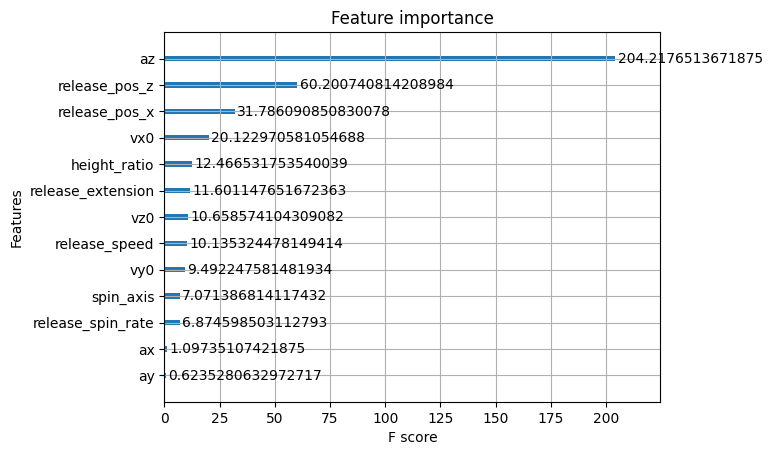

In [25]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [26]:
y_pred = final_model.predict(dtest)

In [27]:
print(y_pred.min())

-0.73765826


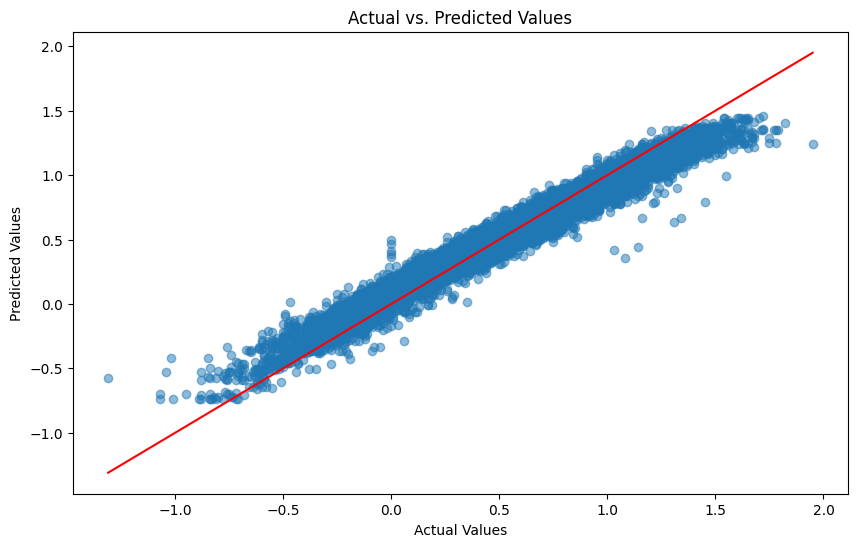

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

## Testing Data Set Predictions

In [29]:
predictions = final_model.predict(xgb.DMatrix(testing_data))

In [30]:
testing_identifiers['xpfx_z'] = predictions

In [31]:
testing_identifiers.head()

pitch_id_raw    xpfx_z
9   663364_646240_605347_1_71_10  0.360374
37   663364_598265_605347_1_64_9  0.459869
40   663364_623993_598264_4_62_8  0.725791
65   663364_663527_543135_3_55_7  0.061967
69   663364_596059_543135_3_53_7  0.077057

In [32]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/IVB_2022&3_xpfz.csv")